# ProGAN
In this notebook, we will implement ProGAN. ProGAN starts training to generate low resolution images (4x4 images). Then after training for some time, the resolution is multiplied by 2 and the resolution becomes 8x8. Then 16x16, and so on until the resolution becomes 1024x1024 (in the actual paper). In this notebook, the final generated images will be of resolution 256x256. The main metric to test the ProGAN in this notebook is the FID (Frechet Inception Distance). 
##### Sections
- For Data Importing, [click here](#Data-Importing)
- For FID using InceptionV3, [click here](#InceptionV3-for-FID)
- For Mini Batch Std Deviation, [click here](#Mini-Batch-Standard-Deviation)
- For Pixelwise Feature Normalisation in ProGAN, [click here](#Pixelwise-Feature-Normalisation-in-ProGAN)
- For WGAN-GP Loss Wasserstein Loss with Gradient Penalty, [click here](#WGAN-GP-Loss-(Wasserstein-Loss-with-Gradient-Penalty))
- For Equalized Learning Rate using Weighted Scaled Convolutional Layer, [click here](#Equalized-Learning-Rate-using-Weighted-Scaled-Convolutional-Layer)
- For ProGAN Generator, [click here](#ProGAN-Generator)
- For ProGAN Discriminator, [click here](#ProGAN-Discriminator)
- For ProGAN Model, [click here](#ProGAN-Model)

## Data Importing

The used dataset is H&M dataset. The following link contains the dataset https://www.kaggle.com/datasets/odins0n/hm256x256

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

If images are previously saved to `images_numpy.npy`, [click here](#Retrieving-Dataset-as-NumPy-Directly)

The images are stored in a folder called images. Inside this folder, there are subfolders.

In [ ]:
def get_dataset(folder_name, target_size=(256, 256), shuffle=True):
    folders = os.listdir(folder_name)
    x = []
    for ind, folder in enumerate(folders):
        print(f"\rFolder {ind}", end="")
        cur_folder_name = folder_name + '/' + folder
        images = os.listdir(cur_folder_name)
        for img in images:
            img_name = cur_folder_name + '/' + img
            with Image.open(img_name) as x_img:
                x.append(np.array(x_img.resize(target_size)))
            
    print("\rFinished Extracting", end="")
            
    x = np.array(x)
    
    if shuffle:
        random_idx = np.random.permutation(x.shape[0])
        x = x[random_idx]
        
    return x

In [ ]:
x = get_dataset("Images/")

The below cell will save the images and labels as numpy arrays to easily retrieve them later.

In [ ]:
with open("images_numpy.npy", 'wb') as f:
    np.save(f, x)

#### Retrieving Dataset as NumPy Directly
If `images_numpy.npy` are previously saved, run the below cell to retrive them fast with loading the images from their root folders.

In [2]:
with open("images_numpy.npy", 'rb') as f:
    x = np.load(f)

The following function receives a numpy array with at least 16 images. Using Matplotlib, the images will be shown using a 4x4 grid (only 16 images are shown). Inputting the labels and the predictions are optional.

In [3]:
def show_images(images, labels=None, preds=None):
    if images.shape[0] < 16:
        raise Exception("number of images should be 16")
        
    f, ax = plt.subplots(4, 4, figsize=(10, 10))
    cur_img_ind = 0
    for row in range(4):
        for col in range(4):
            ax[row, col].imshow(images[cur_img_ind])
            ax[row, col].axis("off")
            
            title = ""
            if preds is not None:
                title += str(preds[cur_img_ind]) + "/"
            
            if labels is not None:
                title += str(labels[cur_img_ind])
                
            ax[row, col].set_title(title, fontsize=8)
                
            cur_img_ind += 1
    plt.show()

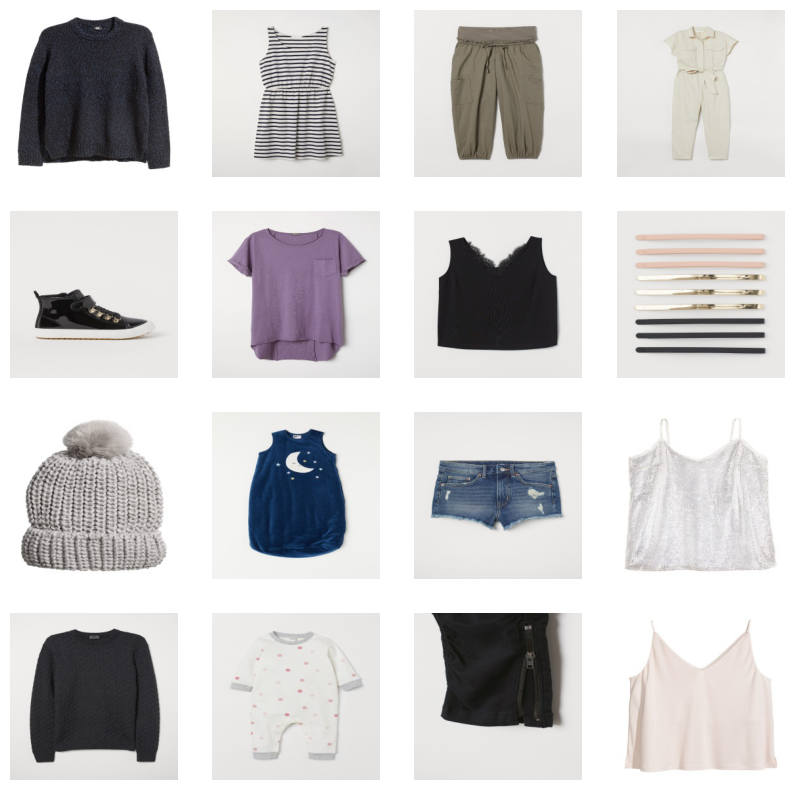

In [4]:
rndm_idx = np.random.choice(x.shape[0], size=16, replace=False)
show_images(x[rndm_idx])

## InceptionV3 for FID

InceptionV3 is used for FID (Frechet Inception Distance). Real and generated images are fed into the InceptionV3 model to output embeddings for each real and generated images. The real and generated images' embeddings are assumed to be sampled from a multivariate gaussian distribution. The closer the distribution of the real and the generated the better. The most common method to measure the "closeness" of these 2 distributions is the Frechet Distance. The Frechet Distance between 2 gaussian normal distributions x & y is given the following equation:
<br></br>
$$
D(x, y) = ||\mu_x - \mu_y||^2 + \text{tr}(\Sigma_x + \Sigma_y - 2\sqrt{\Sigma_x \cdot \Sigma_y})
$$
$\mu_x$: Mean of distribution $x$ (Mean of Generator Embeddings in our case) <br/>
$\mu_y$: Mean of distribution $y$ (Mean of Real Embeddings in our case) <br/>
$\Sigma_x$: Covariance Matrix of distribution $x$ <br/>
$\Sigma_y$: Covariance Matrix of distribution $y$ <br/> 
The first part in this section will include importing and testing the pretrained InceptionV3.
<br></br>
**To jump to to Class FID** [click here](#Class-FID)

In [5]:
import torchvision
import torch

In [6]:
inception_v3 = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT)

In [7]:
inception_v3.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Since PyTorch doesn't have a predefined method of preprocessing InceptionV3, the following function does the preprocessing

In [8]:
def inceptionv3_preprocess(images):
    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.CenterCrop(299),
        torchvision.transforms.Resize(299),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return torch.stack([preprocess(img) for img in images], axis=0)

Testing the weights of the pretrained model

In [9]:
rndm_idx = np.random.choice(x.shape[0])
test_img = x[rndm_idx]
test_img = np.expand_dims(test_img, axis=0)
test_img.shape

(1, 256, 256, 3)

(-0.5, 255.5, 255.5, -0.5)

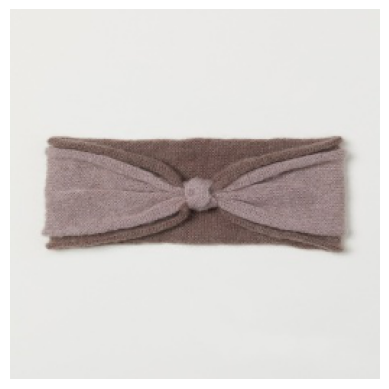

In [10]:
plt.imshow(test_img[0])
plt.axis("off")

In [11]:
preprocessed_img = inceptionv3_preprocess(test_img)
preprocessed_img.shape

torch.Size([1, 3, 299, 299])

Load Imagenet Classes Name

In [12]:
with open("imagenet-classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [13]:
preds = inception_v3(preprocessed_img)[0]
top5_idx = torch.argsort(preds, descending=True)[:5]
[categories[idx] for idx in top5_idx]

['bow tie, bow-tie, bowtie', 'sarong', 'cup', 'hair slide', 'damselfly']

The weights are tested. InceptionV3 predicts at least one of the clothes in the top 5 predictions.     

The final dropout and fully connected layers are removed from the model.

In [14]:
inception_v3.dropout = torch.nn.Identity()
inception_v3.fc = torch.nn.Identity()

In [15]:
inception_v3.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

The current output feature vector (Embedding) shape is 2048. 

In [16]:
inception_v3(preprocessed_img).shape

torch.Size([1, 2048])

The following steps freezes all layers in inception model

In [17]:
for param in inception_v3.parameters():
    param.requires_grad = False

#### Class FID 
The function receives the `inception_model` in the constructor and a `preprocessing_func`. When the `__call__` method is called, it preprocesses the real and fake images using the `preprocessing_func`, it then passes the preprocessed images to the `inception_model` to output a feature vector for each image. The equation in [InceptionV3 for FID](#InceptionV3-for-FID) is calculated returning the value. The lower this value is, the better.

In [18]:
from scipy.linalg import sqrtm 

In [19]:
class FID:
    def __init__(self, inception_model, preprocessing_func):
        self.model = inception_model
        self.preprocess = preprocessing_func
        
    def __call__(self, reals, fakes, batch_size=32, verbose=True):
        reals = self.preprocess(reals)
        fakes = self.preprocess(fakes)
        
        if verbose:
            print("Extracting Embeddings for Reals")
        emb_real = self._fwd_model(reals, batch_size=batch_size, verbose=verbose)
        
        if verbose:
            print("Extracting Embeddings for Fakes")
        emb_fakes = self._fwd_model(fakes, batch_size=batch_size, verbose=verbose)
        
        mu_r = self._mean(emb_real)
        mu_f = self._mean(emb_fakes)
        sigma_r = self._cov(emb_real)
        sigma_f = self._cov(emb_fakes)
        
        return self._op(mu_r, mu_f, sigma_r, sigma_f)
    
    def _fwd_model(self, imgs, batch_size, verbose):
        data_gen = torch.utils.data.DataLoader(imgs, batch_size=batch_size, shuffle=True)
        embeddings = None
        for ind, batch in enumerate(data_gen): 
            if verbose:
                print(f"\rBatch {ind}", end="")
            
            if embeddings is None:
                embeddings = self.model(batch)
            else:
                embeddings = torch.cat((embeddings, self.model(batch)), dim=0)
        
        if verbose:
            print() # leave a line
        
        return embeddings.numpy()
        
    @staticmethod
    def _mean(vectors):
        if len(vectors.shape) != 2:
            raise Exception("vectors shape must be (m, n)")
        return np.mean(vectors, axis=0, keepdims=True)
    
    @staticmethod
    def _cov(vectors):
        if len(vectors.shape) != 2:
            raise Exception("vectors shape must be (m, n)")
        return np.cov(vectors, rowvar=False)
    
    @staticmethod
    def _op(mu_x, mu_y, sigma_x, sigma_y):
        mean_distance = np.sum((mu_x - mu_y) ** 2)
        
        sqrt_term = sqrtm(sigma_x @ sigma_y)
        if np.iscomplexobj(sqrt_term):
            sqrt_term = sqrt_term.real
        
        cov_distance = np.trace(sigma_x + sigma_y - 2 * sqrt_term)
        
        return mean_distance + cov_distance

In [20]:
fid_test = FID(inception_v3, inceptionv3_preprocess)

To jump to Mini Batch Standard Deviation, [click here](#Mini-Batch-Standard-Deviation)

##### FID Test 1: No Variation
For FID testing, if the operation is working properly, taking FID for the same images results in a close 0 distance.

In [ ]:
rndm_idx = np.random.choice(x.shape[0], size=128)
rndm_idx2 = np.random.permutation(rndm_idx)
reals_test = x[rndm_idx]
fakes_test = x[rndm_idx2]

fid_test(reals_test, fakes_test)

##### FID Test 2: Gaussian Blur
The 2nd test is applying a Gaussian Blur on the images and seeing how the FID would change. If FID is working well, it will output a large number.

In [ ]:
import cv2

In [ ]:
rndm_idx = np.random.choice(x.shape[0], size=128)
reals_test = x[rndm_idx]
fakes_test = np.array([cv2.GaussianBlur(img, (15, 15), 0) for img in reals_test])

fid_test(reals_test, fakes_test)

##### FID Test 3: Distorting top left corner
The 3rd test is distorting the top left corner in each image and seeing how the FID would change. The distortion occurs by rotating the top left corner 180 degrees. If FID is working well, it will output a large number.

In [ ]:
rndm_idx = np.random.choice(x.shape[0], size=128)
reals_test = x[rndm_idx]
cropped_rot = np.array([cv2.rotate(img[0:120, 0:120], cv2.ROTATE_180) for img in reals_test])
fakes_test = np.array([img for img in reals_test])

for ind, _ in enumerate(reals_test):
    fakes_test[ind, 0:120, 0:120] = cropped_rot[ind]

fid_test(reals_test, fakes_test)

## Mini-Batch Standard Deviation
According to the ProGAN paper in https://arxiv.org/abs/1710.10196, the authors used mini batch std dev layer at the final layers in the discriminator. This layer is explained very well in https://www.youtube.com/watch?v=V1qQXb9KcDY

In [21]:
class MiniBatchStd(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input_tensor):
        # input_tensor: shape (N, C, H, W)
        n = input_tensor.size()[0]
        h = input_tensor.size()[2]
        w = input_tensor.size()[3]

        scalar_mean_std = torch.mean(torch.std(input_tensor, 0))
        final_map = scalar_mean_std.repeat(n, 1, h, w)

        output_tensor = torch.cat((input_tensor, final_map), 1) # Concatenate the final map to the input tensor
        return output_tensor        

In [22]:
test_tensor = torch.rand(128, 32, 7, 7)
MiniBatchStd()(test_tensor).size() # Should be (128, 33, 7, 7)

torch.Size([128, 33, 7, 7])

## Pixelwise Feature Normalisation in ProGAN
According to the ProGAN paper in https://arxiv.org/abs/1710.10196, the authors used local response normalisation with certain configuration and called it pixelwise feature normalisation. The configured equation is:
$$
b_{x,y}^i = \frac{a_{x,y}^i}{\sqrt{\frac{1}{N}\sum_{j=0}^{N-1} \left(a_{x,y}^{j}\right)^2 + \epsilon}}
$$
$a_{x,y}^i$ is the original pixel located at $(x,y)$ at channel number $i$ </br>
$b_{x,y}^i$ is the normalized pixel located at $(x,y)$ at channel number $i$ </br>
$N$ is the number of channels </br>
$\epsilon$ is set to $10^{-8}$ to avoid division by zero </br>

In [23]:
class PixelwiseNorm(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input_tensor, epsilon=1e-8):
        # input_tensor: shape (N, C, H, W)
        divisor = torch.sqrt(torch.mean(input_tensor**2.0, dim=1, keepdim=True) + epsilon)
        output_tensor = input_tensor / divisor
        return output_tensor

In [24]:
test_tensor = torch.rand(128, 32, 7, 7)
PixelwiseNorm()(test_tensor).shape

torch.Size([128, 32, 7, 7])

## WGAN-GP Loss (Wasserstein Loss with Gradient Penalty)
The authors of ProGAN paper used the Wasserstein loss with gradient penalty explained in the paper ("Improved Training of Wasserstein GANs") in https://arxiv.org/abs/1704.00028. The autors of ProGAN added a fourth term to the critic's (discriminator's) loss function to prevent the discriminator's output from drifiting too far from 0 (to further guarantee stability in training). Thus, the loss function of the discriminator is:
$$
L_d = \mathbb{E}_{x_g\sim\mathbb{P}_g}[D(x_g)] - \mathbb{E}_{x_r\sim\mathbb{P}_r}[D(x_r)] + \lambda \mathbb{E}_{x\sim\mathbb{P}_x}[(||\nabla D(x)|| - 1)^2]+\epsilon_{drift}\mathbb{E}_{x_r\sim\mathbb{P}_r}[D(x_r)^2]
$$
where
$$
x = \epsilon x_r + (1-\epsilon) x_g
$$
Intuitively, minimizing the first 2 terms in this loss function means forcing the generated images to output small numbers from the discriminator, and forcing the real images to output large numbers. The 3rd and 4th terms helps in stability during training for the GAN. Each term is explained in the following bullet points:
- The first term means that we should generate some images, sample from these images, feed these sampled images to the discriminator, the output of the discriminator should belong to $\mathbb{R}^N$ (where $N$ is the number of sampled generated images). These $N$ values are then averaged to find the first term of the equation.
- The second term means that we should sample from some real images, feed these sampled images to the discriminator, the output of the discriminator should also belong to $\mathbb{R}^N$ (where $N$ is the number of sampled sampled real images). These $N$ values are then averaged and multiplied by negative to find the second term of the equation.
- The third term of the equation tries to force the 1-Lipschtiz continuity of the discriminator function. 1-Lipschtiz continuity for a function means that this function's gradient magnitude does not surpass value of 1 on its whole domain. The third term penalizes any value other than 1 for the gradient's magnitude.
- The fourth term, as mentioned, was added by the ProGAN authors to prevent the discriminator's output from drifiting too far from 0.
</br></br>
The loss function of the generator is much simpler that includes only one term:
$$
L_g = -\mathbb{E}_{x_g\sim\mathbb{P}_g}[D(x_g)]
$$
The intuition about this loss function is that the generator tries to fool the discriminator. Now, the generator want to output large numbers from the discriminator. The larger these numbers the less loss. 

In [25]:
class WassersteinGradientPenalty:
    def __init__(self, lmbda=10, epsilon_drift=0.001):
        super().__init__()
        self.lmbda = lmbda
        self.epsilon_drift = epsilon_drift
        
    def disc_loss(self, reals, fakes, disc_nn, alpha=1):
        # reals: shape (N, C, H, W)
        # fakes: shape (N, C, H, W)
        fakes = fakes.detach()
        
        n_r = reals.size()[0]
        n_f = fakes.size()[0]
        
        if n_r != n_f:
            raise Exception("batch number in reals and fakes must be equal")
            
        epsilon = torch.rand(n_r, 1, 1, 1).to("cuda")
        x = epsilon * reals + (1-epsilon) * fakes
        
        # print(x[0])
        # print(x[1])
        
        x.requires_grad = True
        
        d_real = disc_nn(reals, alpha)
        d_fake = disc_nn(fakes, alpha)
        d_x = disc_nn(x, alpha)
        
        first_term = torch.mean(d_fake)
        second_term = -torch.mean(d_real)
        
        gradient = torch.autograd.grad(
            outputs=torch.sum(d_x), # Further explained in the next markdown cell.   
            inputs=x,
            retain_graph=True,
            create_graph=True # Create graph of the derivatives to compute the higher order derivatives
        )[0]
        
        gradient = torch.reshape(gradient, (gradient.size()[0], -1))
        norm = torch.norm(gradient, dim=1)
        
        third_term = self.lmbda * torch.mean((norm - 1) ** 2)
        fourth_term = self.epsilon_drift * torch.mean(d_real**2)
        
        loss = first_term + second_term + third_term + fourth_term
        
        return loss
    
    def gen_loss(self, fakes, disc_nn, alpha=1, reals=None):
        d_fake = disc_nn(fakes, alpha)
        first_term = torch.mean(d_fake)
        loss = -first_term
        
        if reals is not None:
            d_real = disc_nn(reals, alpha)
            second_term = torch.mean(d_real)
            loss += second_term
            
        return loss

#### Note
```
        gradient = torch.autograd.grad(
            outputs=torch.sum(d_x), 
            inputs=x,
            retain_graph=True,
            create_graph=True
        )[0]
```
is equaivalent to
```
        gradient = torch.autograd.grad(
            outputs=d_x, 
            inputs=x,
            grad_outputs=torch.ones_like(d_x)
            retain_graph=True,
            create_graph=True
        )[0]
```
The first code snippet just sums all the values in the discriminator's output for a scalar value. The second code snippet multiplies the final jacobians with ones. Why are these 2 equivalent? </br>
The following example explains why they are equivalent </br>
Assume that:
$$
x = \begin{bmatrix}
x_1 \\
x_2
\end{bmatrix},
y = \begin{bmatrix}
y_1 \\
y_2
\end{bmatrix},
A = \begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}
$$
Also assume that:
$$
y=Ax
$$
$$
\begin{bmatrix}
y_1 \\
y_2
\end{bmatrix}
=\begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$$
If we summed up the output values (like first code snippet):
$$
S = y_1 + y_2
$$
Then
$$
\frac{dS}{dx} = \frac{dy_1}{dx} + \frac{dy_2}{dx}
$$
We can say that
$$
y_1 = \begin{bmatrix}
1&2
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$$
&
$$
y_2 = \begin{bmatrix}
3&4
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
$$
Finding the jacobian for $y_1$
$$
\frac{dy_1}{dx} = \begin{bmatrix}
1&2
\end{bmatrix}
$$
Finding the jacobian for $y_2$
$$
\frac{dy_2}{dx} = \begin{bmatrix}
3&4
\end{bmatrix}
$$
Then
$$
\frac{dS}{dx} = \begin{bmatrix}
\mathbf{4}&\mathbf{6}
\end{bmatrix}
$$
For the second code snippet, we find $\frac{dy}{dx}$ (taking the jacboian of $y$) and then multiply the result with vector of ones:
$$
\frac{dy}{dx} = A = \begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}
$$
Multiplying $\frac{dy}{dx}$ by vector of ones:
$$
\begin{bmatrix}
1&1
\end{bmatrix}
\begin{bmatrix}
1&2 \\
3&4
\end{bmatrix}=\begin{bmatrix}
\mathbf{4}&\mathbf{6}
\end{bmatrix}
$$

The following code cell creates dummy tensor for fakes of shape (2, 2, 2, 2) to test the loss function

In [31]:
fake = torch.FloatTensor([
    [
        [1, 2],
        [3, 4]
    ],
    [
        [5, 6],
        [7, 8]
    ]
]).to("cuda")
fake = fake.unsqueeze(0)
fake = torch.cat([fake, fake], 0)
fake.shape

torch.Size([2, 2, 2, 2])

The following code cell creates dummy tensor for reals of shape (2, 2, 2, 2) to test the loss function

In [32]:
real = torch.FloatTensor([
    [
        [10, 11],
        [12, 13]
    ],
    [
        [14, 15],
        [16, 17]
    ]
]).to("cuda")
real = real.unsqueeze(0)
real = torch.cat([real, real], 0)
real.shape

torch.Size([2, 2, 2, 2])

The following code is a dummy function for the discriminator (for testing purposes only)

In [34]:
class DummyDiscFunc(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def __call__(self, x, *args):
        return torch.sum(torch.reshape(0.5*x**2, (x.shape[0], -1)), 1, keepdim=True)
    
disc_func = DummyDiscFunc().to("cuda")
disc_func(real)

tensor([[750.],
        [750.]], device='cuda:0')

In [35]:
loss_test = WassersteinGradientPenalty()

In [36]:
loss_test.disc_loss(real, fake, disc_func)

tensor(10561.1562, device='cuda:0', grad_fn=<AddBackward0>)

In [37]:
loss_test.gen_loss(fake, disc_func)

tensor(-102., device='cuda:0')

## Equalized Learning Rate using Weighted Scaled Convolutional Layer
According to the ProGAN paper, the authors used Equalized Learning Rate for training stability. The said: "The benefit of doing this dynamically instead of during initialization is somewhat
subtle, and relates to the scale-invariance in commonly used adaptive stochastic gradient descent
methods such as RMSProp (Tieleman & Hinton, 2012) and Adam (Kingma & Ba, 2015). These
methods normalize a gradient update by its estimated standard deviation, thus making the update
independent of the scale of the parameter. As a result, if some parameters have a larger dynamic
range than others, they will take longer to adjust. This is a scenario modern initializers cause, and
thus it is possible that a learning rate is both too large and too small at the same time."
</br></br>
For Equalized Learning Rate, the weights of the convolutional layer is trivially initialized by a standard normal distribution. Then, the weights are scaled during runtime by multiplying the inputs to the convolutional layer with standard deviation constant from He's initializer. The std deviation is:
$$
\sigma = \sqrt{\frac{2}{fan\_in}}
$$
$fan\_in$ is the number of inputs which results in a single output. For a convolutional layer, $fan\_in$ is given by:
$$
fan\_in = k * k * n_c
$$
where: </br>
$k$ is the filter size </br>
$n_c$ is the number of input channels </br>

In [38]:
class WeightedScaledConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super().__init__()
        
        self.lyr = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            padding=padding
        )
        
        fan_in = kernel_size * kernel_size * in_channels
        self.std = (2.0/fan_in) ** 0.5
        
        torch.nn.init.normal_(self.lyr.weight)
        torch.nn.init.zeros_(self.lyr.bias)
        
    def forward(self, x):
        return self.lyr(x*self.std)

## ProGAN Generator
In the appendix in ProGAN paper, they showed the generator's architecture. The architecture is:
</br>
<img src="Markdown_Images/Gen_Arch.png" alt="Generator Architecture" width="400"/>
</br>
There are some changes differences between the model implemented in this notebook and the ProGAN in the actual paper. The changes are:
- Images generated will be 256x256. The paper generated images of resolution 1024x1024.
- Used FID, explained [here](#InceptionV3-for-FID), instead of inception score.
</br>
One of the major operations the paper of ProGAN did was the fade in operation described in the following picture:
</br>
<img src="Markdown_Images/Gen_Fade_In.png" alt="Generator Fade In" width="400"/>
</br>
The "2x" corresponds to upsampling using nearest neighbour. The "toRGB" block is composed of 1x1 convolution operation with 3 filters.

In [39]:
class Generator(torch.nn.Module):
    def __init__(self, log2_target_res=8, weights_path=None):
        """log2_target_res means that the resolution of the output image is required to be 2^log2_target_res
        Example: 2^8 = 256. That means that the target resolution of the generated images is 256*256 """
        super().__init__()
        
        channels = [512, 512, 512, 512, 256, 128, 64, 32, 16]
        num_of_sub_models = log2_target_res - 2
        
        if num_of_sub_models < 0:
            raise Exception("resolution of the image cannot be less than 4*4")
        if num_of_sub_models > 8:
            raise Exception("resolution of the image cannot be more than 1024*1024")
            
        self.start_block = self._start_block()
        self.conv_blocks = torch.nn.ModuleList([])
        self.upsample_block = torch.nn.Upsample(scale_factor=2, mode="nearest")
        self.rgb_blocks = torch.nn.ModuleList([self._rgb_block(channels[0])])
        
        self.cur_growth = 0
        
        for ind in range(num_of_sub_models):
            in_channels = channels[ind]
            out_channels = channels[ind+1]
            
            sub_model = self._conv_block(in_channels, out_channels)
            rgb_block = self._rgb_block(out_channels)
            
            self.conv_blocks.append(sub_model)
            self.rgb_blocks.append(rgb_block)
        
        if weights_path is not None:
            self.load_weights(weights_path)
    
    def _start_block(self):
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512, 512, kernel_size=4),
            torch.nn.LeakyReLU(0.2),
            WeightedScaledConv2d(512, 512, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            PixelwiseNorm(),
        )
    
    def _conv_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode="nearest"),
            WeightedScaledConv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            PixelwiseNorm(),
            WeightedScaledConv2d(out_channels, out_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            PixelwiseNorm()
        )
    
    def _rgb_block(self, in_channels):
        return torch.nn.Sequential(
            WeightedScaledConv2d(in_channels, 3, kernel_size=1),
            torch.nn.Tanh()
        )
                
    def save_weights(self, path):
        model_data = self.state_dict()
        model_data["cur_growth"] = self.cur_growth # Add cur_growth to the dict to be saved
        torch.save(model_data, path)
        
    def load_weights(self, path):
        model_data = torch.load(path)
        self.cur_growth = model_data["cur_growth"] # Read cur_growth
        model_data.pop("cur_growth") # Remove cur_growth from dict
        self.load_state_dict(model_data)
        
    def grow(self): 
        if self.cur_growth >= (len(self.conv_blocks)):
            raise Exception("Generator cannot be grown further")
        else:
            self.cur_growth += 1
        
    def get_cur_growth(self):
        return self.cur_growth
    
    def forward(self, x, alpha=1):
        y_hat = self.start_block(x)
        
        for cur_lyr in range(self.cur_growth-1):
            y_hat = self.conv_blocks[cur_lyr](y_hat)
        
        if self.cur_growth > 0:
            conv = self.conv_blocks[self.cur_growth-1](y_hat)
            upsample = self.upsample_block(y_hat)

            rgb_lyr_conv = self.rgb_blocks[self.cur_growth](conv)
            rgb_lyr_upsample = self.rgb_blocks[self.cur_growth-1](upsample)
        
            y_hat = alpha * rgb_lyr_conv + (1 - alpha) * rgb_lyr_upsample
        else:
            y_hat = self.rgb_blocks[0](y_hat)
            
        return y_hat

In [40]:
def test_gen():
    gen = Generator()
    test_in = torch.randn(2, 512, 1, 1)
    while True:
        cur_sz = gen(test_in).size()
        print(f"Output size is {cur_sz}")
        try:
            gen.grow()
        except Exception:
            break

In [41]:
test_gen()

Output size is torch.Size([2, 3, 4, 4])
Output size is torch.Size([2, 3, 8, 8])
Output size is torch.Size([2, 3, 16, 16])
Output size is torch.Size([2, 3, 32, 32])
Output size is torch.Size([2, 3, 64, 64])
Output size is torch.Size([2, 3, 128, 128])
Output size is torch.Size([2, 3, 256, 256])


## ProGAN Discriminator
In the appendix in ProGAN paper, they showed the generator's architecture. The architecture is:
</br>
<img src="Markdown_Images/Disc_Arch.png" alt="Discriminator Architecture" width="400"/>
</br>
There are some changes differences between the model implemented in this notebook and the ProGAN in the actual paper. The changes are:
- Images generated will be 256x256. The paper generated images of resolution 1024x1024.
- Used FID, explained [here](#InceptionV3-for-FID), instead of inception score.
</br>
One of the major operations the paper of ProGAN did was the fade in operation described in the following picture:
</br>
<img src="Markdown_Images/Disc_Fade_In.png" alt="Discriminator Fade In" width="400"/>
</br>
The "0.5x" corresponds to downsampling using average pooling. The "fromRGB" block is composed of 1x1 convolution operation.

In [42]:
class Discriminator(torch.nn.Module):
    def __init__(self, log2_target_res=8, weights_path=None):
        """log2_target_res means that the resolution of the output image is required to be 2^log2_target_res
        Example: 2^8 = 256. That means that the target resolution of the generated images is 256*256 """
        super().__init__()
        
        channels = [512, 512, 512, 512, 256, 128, 64, 32, 16]
        self.num_of_sub_models = log2_target_res - 2
        
        if self.num_of_sub_models < 0:
            raise Exception("resolution of the input images cannot be less than 4*4")
        if self.num_of_sub_models > 8:
            raise Exception("resolution of the input images cannot be more than 1024*1024")
        
        self.rgb_blocks = torch.nn.ModuleList([self._rgb_block(channels[0])])
        self.conv_blocks = torch.nn.ModuleList([])
        self.downsample_block = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.end_block = self._end_block()
        
        self.cur_growth = 0
        
        for ind in range(self.num_of_sub_models):
            in_channels = channels[ind+1]
            out_channels = channels[ind]
            
            rgb_block = self._rgb_block(in_channels)
            sub_model = self._conv_block(in_channels, out_channels)
            
            self.rgb_blocks.insert(0, rgb_block)
            self.conv_blocks.insert(0, sub_model)
            
        if weights_path is not None:
            self.load_weights(weights_path)
    
    def _rgb_block(self, out_channels):
        return torch.nn.Sequential(
            WeightedScaledConv2d(3, out_channels, kernel_size=1),
            torch.nn.LeakyReLU(0.2)
        )
    
    def _conv_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            WeightedScaledConv2d(in_channels, in_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            WeightedScaledConv2d(in_channels, out_channels, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
        )
    
    def _end_block(self):
        return torch.nn.Sequential(
            MiniBatchStd(),
            WeightedScaledConv2d(513, 512, kernel_size=3, padding="same"),
            torch.nn.LeakyReLU(0.2),
            WeightedScaledConv2d(512, 512, kernel_size=4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Flatten(),
            torch.nn.Linear(512, 1)
        )
            
    def grow(self):
        if self.cur_growth >= (len(self.conv_blocks)):
            raise Exception("Discriminator cannot be grown further")
        else:
            self.cur_growth += 1
    
    def save_weights(self, path):
        model_data = self.state_dict()
        model_data["cur_growth"] = self.cur_growth # Add cur_growth to the dict to be saved
        torch.save(model_data, path)
        
    def load_weights(self, path):
        model_data = torch.load(path)
        self.cur_growth = model_data["cur_growth"] # Read cur_growth
        model_data.pop("cur_growth") # Remove cur_growth from dict
        self.load_state_dict(model_data)
    
    def forward(self, x, alpha=1):
        ind = self.num_of_sub_models - self.cur_growth
        if self.cur_growth > 0:
            downsampled = self.downsample_block(x)
            rgb_downsampled_lyr = self.rgb_blocks[ind+1](downsampled)
            
            rgb = self.rgb_blocks[ind](x)
            rgb_conv_lyr = self.conv_blocks[ind](rgb)
            
            y_hat = alpha * rgb_conv_lyr + (1 - alpha) * rgb_downsampled_lyr
        else:
            y_hat = self.rgb_blocks[-1](x)
        
        for cur_lyr in range(ind+1, self.num_of_sub_models):
            y_hat = self.conv_blocks[cur_lyr](y_hat)
        
        y_hat = self.end_block(y_hat)
        
        return y_hat

In [43]:
def test_disc():
    disc = Discriminator()
    dim = 4
    while True:
        test_in = torch.randn(2, 3, dim, dim)
        cur_sz = disc(test_in).size()
        print(f"Input size is {test_in.size()}.. Output size is {cur_sz}")
        try:
            disc.grow()
        except Exception:
            break
        else:
            dim *= 2

In [44]:
test_disc()

Input size is torch.Size([2, 3, 4, 4]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 8, 8]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 16, 16]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 32, 32]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 64, 64]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 128, 128]).. Output size is torch.Size([2, 1])
Input size is torch.Size([2, 3, 256, 256]).. Output size is torch.Size([2, 1])


## ProGAN Model
The ProGAN (progressively growing GAN) firstly starts with 4x4 image resolution. Then after some steps, the image resolution multiplies by 2 to be 8x8, then to 16x16, and so on.  

- The first function in the following code cell receives `x` which is a numpy array of shape `(N, H, W, C)` to convert the numpy tenosr to a pytorch tensor of shape `(N, C, H, W)`. It also preprocesses the images from [0, 255] to [-1, 1]. 
- The second function does the opposite. It converts the preprocessed images from [-1, 1] to [0, 255] again. It also converts the pytorch tensor from [-1, 1] to a numpy tensor with range [0, 255].  

In [45]:
def pro_gan_preprocess(x: np.ndarray, resize=256):
    """
    x: shape (N, H, W, C)
    returns: (N, C, H, W)
    This method transforms input images from range [0, 255] to [-1, 1]
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(resize),
        torchvision.transforms.Lambda(lambda x: (x-0.5)/0.5)
    ])
        
    return torch.stack([transform(img) for img in x], axis=0)
    
def pro_gan_undo_preprocess(x):
    """
    x: shape (N, C, H, W)
    returns: (N, H, W, C)
    This method transforms input images from range [-1, 1] to [0, 255] 
    and converts them into numpy arrays
    """
    x = torch.where(x > 1, 1, x)
    x = torch.where(x < -1, -1, x)
    x = (x + 1) / 2.0
    x *= 255.0
    x = x.type(torch.uint8)
    numpy_imgs = x.detach().numpy()
    numpy_imgs = np.transpose(numpy_imgs, (0, 2, 3, 1))
    return numpy_imgs

In [46]:
class ProGan(torch.nn.Module):
    def __init__(self, 
                 lr=0.001,
                 beta1=0.0,
                 beta2=0.99,
                 lmbda=10,
                 epsilon_drift=0.001,
                 gen_weights_path=None, 
                 disc_weights_path=None,
                 gen_opt_weights_path=None,
                 disc_opt_weights_path=None):
        super().__init__()
        
        self.gen_weights_path = gen_weights_path
        self.disc_weights_path = disc_weights_path
        self.gen_weights_opt_path = gen_opt_weights_path
        self.disc_weights_opt_path = disc_opt_weights_path
        
        self.gen = Generator(8, weights_path=gen_weights_path)
        self.disc = Discriminator(8, weights_path=disc_weights_path)
        self.loss = WassersteinGradientPenalty(lmbda=lmbda, epsilon_drift=epsilon_drift)
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr, betas=(beta1, beta2))
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), lr=lr, betas=(beta1, beta2))
        
        self.cur_resolution = 4
        
        if gen_opt_weights_path is not None and disc_opt_weights_path is not None:
            self.load_opt_weights(gen_opt_weights_path, disc_opt_weights_path)
        
    def save_opt_weights(self, gen_path, disc_path):
        gen_opt_data = self.gen_opt.state_dict()
        gen_opt_data["cur_resolution"] = self.cur_resolution # Add cur_resolution to the dict to be saved
        torch.save(gen_opt_data, gen_path)
        
        disc_opt_data = self.disc_opt.state_dict()
        torch.save(disc_opt_data, disc_path)

    def load_opt_weights(self, gen_path, disc_path):
        gen_opt_data = torch.load(gen_path)
        self.cur_resolution = gen_opt_data["cur_resolution"] # Read cur_resolution
        gen_opt_data.pop("cur_resolution") # Remove cur_resolution from dict
        self.gen_opt.load_state_dict(gen_opt_data)
        
        disc_opt_data = torch.load(disc_path)
        self.disc_opt.load_state_dict(disc_opt_data)
    
    def generate(self, batch_size=1, alpha=1):
        z = torch.randn(batch_size, 512, 1, 1).to("cuda")
        return self.gen(z, alpha=alpha)
    
    def discriminate(self, inputs, alpha=1):
        if inputs.size()[0] <= 1:
            raise Exception("inputs' batch size should be greater than 1")
        return self.disc(inputs, alpha=alpha)
    
    def disc_train_step(self, reals, fakes, alpha=1):
        if reals.size()[0] != fakes.size()[0]:
            raise Exception("reals and fakes should have the same batch size")
        
        disc_loss = self.loss.disc_loss(reals=reals, fakes=fakes.detach(), disc_nn=self.disc, alpha=alpha)
        self.disc_opt.zero_grad()
        disc_loss.backward()
        self.disc_opt.step()
        
        return disc_loss
        
    def gen_train_step(self, fakes, alpha=1):
        gen_loss = self.loss.gen_loss(fakes=fakes, disc_nn=self.disc, alpha=alpha)
        self.gen_opt.zero_grad()
        gen_loss.backward()
        self.gen_opt.step()
        
        return gen_loss
        
    def train(self, 
              reals: np.ndarray, 
              epochs,
              see_dataset_per_epoch=2,
              batch_size=3, 
              verbose=True, 
              show_gen_img_every="step"):
        
        step = 0
        
        n = reals.shape[0]
        alpha_step = batch_size / n
        disc_loss_history = []
        gen_loss_history = []
        
        disc_loss_history_avg = []
        gen_loss_history_avg = []
        
        for __ in range(epochs):
            alpha = 0.0
            reals_torch = pro_gan_preprocess(reals, resize=self.cur_resolution) 
            print(reals_torch.size())

            for _ in range(see_dataset_per_epoch):
                reals_torch = reals_torch.to("cuda")
                data_loader = torch.utils.data.DataLoader(reals_torch, batch_size=batch_size, shuffle=True)
                for cur_reals in data_loader:
                    fakes = self.generate(batch_size=cur_reals.size()[0], alpha=alpha).detach()
                    disc_loss = self.disc_train_step(cur_reals, fakes, alpha=alpha)
                    disc_loss_history.append(disc_loss.cpu().detach())
                    disc_loss_history_avg.append(np.mean(disc_loss_history))
                    
                    fakes = self.generate(batch_size=2*cur_reals.size()[0], alpha=alpha)
                    gen_loss = self.gen_train_step(fakes, alpha=alpha)
                    gen_loss_history.append(gen_loss.cpu().detach())
                    gen_loss_history_avg.append(np.mean(gen_loss_history))

                    alpha += alpha_step
                    if alpha >= 1.0:
                        alpha = 1.0

                    if self.disc_weights_path is not None:
                        self.disc.save_weights(self.disc_weights_path)

                    if self.gen_weights_path is not None:
                        self.gen.save_weights(self.gen_weights_path)
                        
                    if self.gen_weights_opt_path is not None and self.disc_weights_opt_path is not None:
                        self.save_opt_weights(self.gen_weights_opt_path, self.disc_weights_opt_path)

                    if verbose:
                        print(f"Step: {step}")
                        print(f"Alpha: {alpha}")
                        print(f"Current Resolution: {self.cur_resolution}")
                        print(f"Discriminator loss : {disc_loss_history_avg[-1]}")
                        print(f"Generator loss: {gen_loss_history_avg[-1]}")

                    if show_gen_img_every.lower() == "step":
                        if batch_size >= 16:
                            test_img = self.generate(16, alpha=alpha)

                            # convert the image to numpy and make it in range [0, 255]
                            test_img = pro_gan_undo_preprocess(test_img.cpu())
                            show_images(test_img)
                        else:
                            test_img = self.generate(1, alpha=alpha)
                            
                            # convert the image to numpy and make it in range [0, 255]
                            test_img = pro_gan_undo_preprocess(test_img.cpu())
                            plt.imshow(test_img[0])
                            plt.axis("off")
                            plt.show()
                        
                    step += 1
                if show_gen_img_every.lower() == "dataset":
                    if batch_size >= 16:
                        test_img = self.generate(16, alpha=alpha)

                        # convert the image to numpy and make it in range [0, 255]
                        test_img = pro_gan_undo_preprocess(test_img.cpu())
                        show_images(test_img)
                    else:
                        test_img = self.generate(1, alpha=alpha)
                            
                        # convert the image to numpy and make it in range [0, 255]
                        test_img = pro_gan_undo_preprocess(test_img.cpu())
                        plt.imshow(test_img[0])
                        plt.axis("off")
                        plt.show()

            try:
                self.gen.grow()
                self.disc.grow()
            except Exception:
                if verbose:
                    print("Maximum growth reached")
            else:
                self.cur_resolution *= 2
                
            if self.disc_weights_path is not None:
                self.disc.save_weights(self.disc_weights_path)

            if self.gen_weights_path is not None:
                self.gen.save_weights(self.gen_weights_path)
                        
            if self.gen_weights_opt_path is not None and self.disc_weights_opt_path is not None:
                self.save_opt_weights(self.gen_weights_opt_path, self.disc_weights_opt_path)
        
        return disc_loss_history_avg, gen_loss_history_avg

If parameters resetting is required. Run the following cell. Otherwise, ***skip this cell***

In [47]:
ProGan().save_opt_weights("saved_weights/gen_opt/weights.pth", "saved_weights/disc_opt/weights.pth")
ProGan().gen.save_weights("saved_weights/generator/weights.pth")
ProGan().disc.save_weights("saved_weights/discriminator/weights.pth")

In [48]:
pro_gan = ProGan(
    gen_weights_path="saved_weights/generator/weights.pth", 
    disc_weights_path="saved_weights/discriminator/weights.pth",
    # gen_opt_weights_path="saved_weights/gen_opt/weights.pth",
    # disc_opt_weights_path="saved_weights/disc_opt/weights.pth"
).to("cuda")

torch.Size([17985, 3, 4, 4])
Step: 0
Alpha: 0.007117041979427301
Current Resolution: 4
Discriminator loss : 2.0834484100341797
Generator loss: 0.4452493488788605


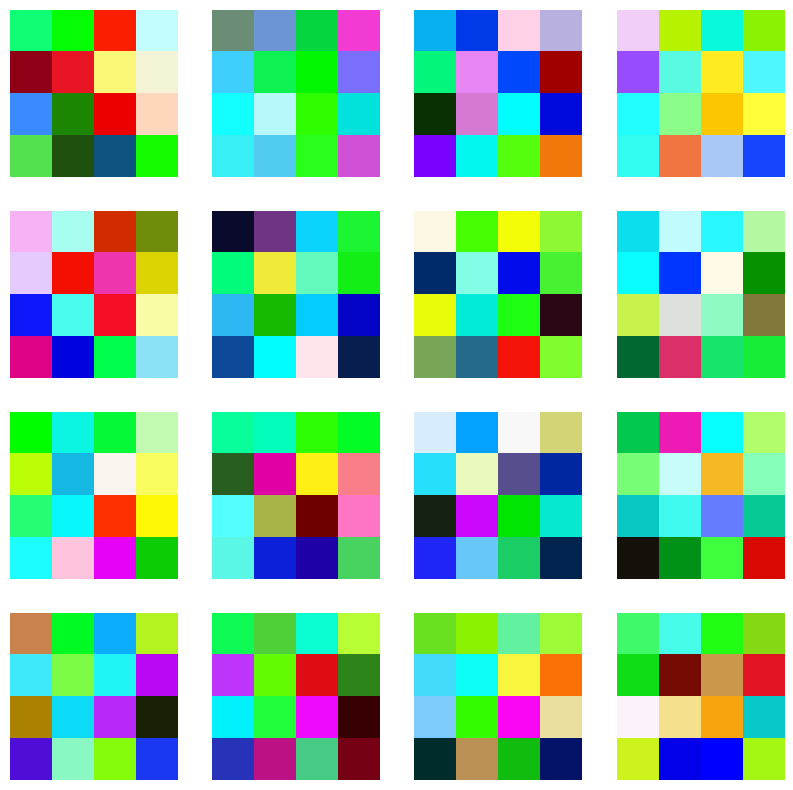

Step: 1
Alpha: 0.014234083958854601
Current Resolution: 4
Discriminator loss : 1.8325450420379639
Generator loss: 0.14872553944587708


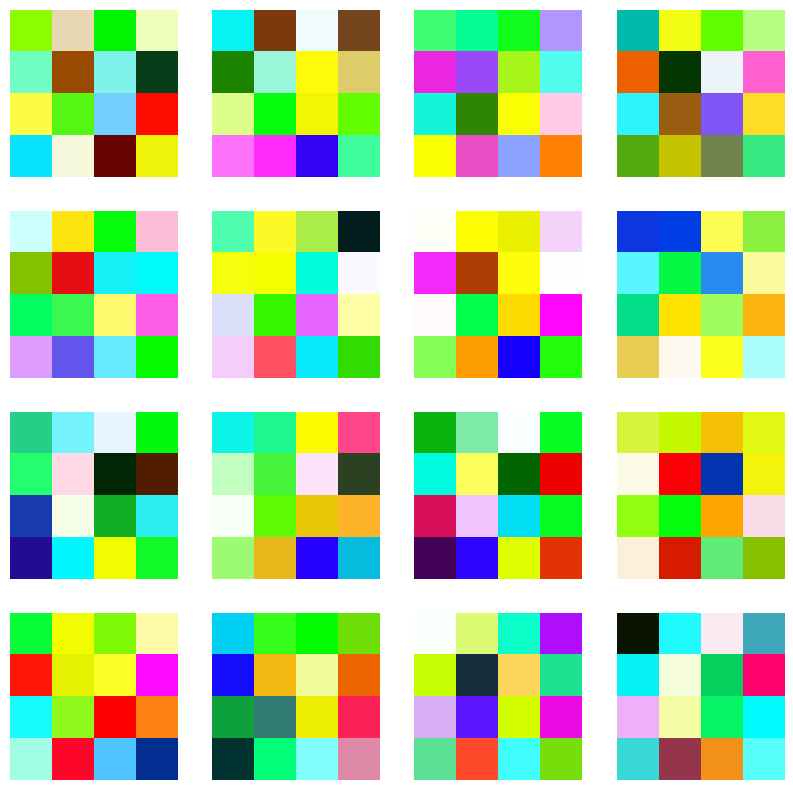

Step: 2
Alpha: 0.021351125938281902
Current Resolution: 4
Discriminator loss : 1.5433107614517212
Generator loss: -0.08216089010238647


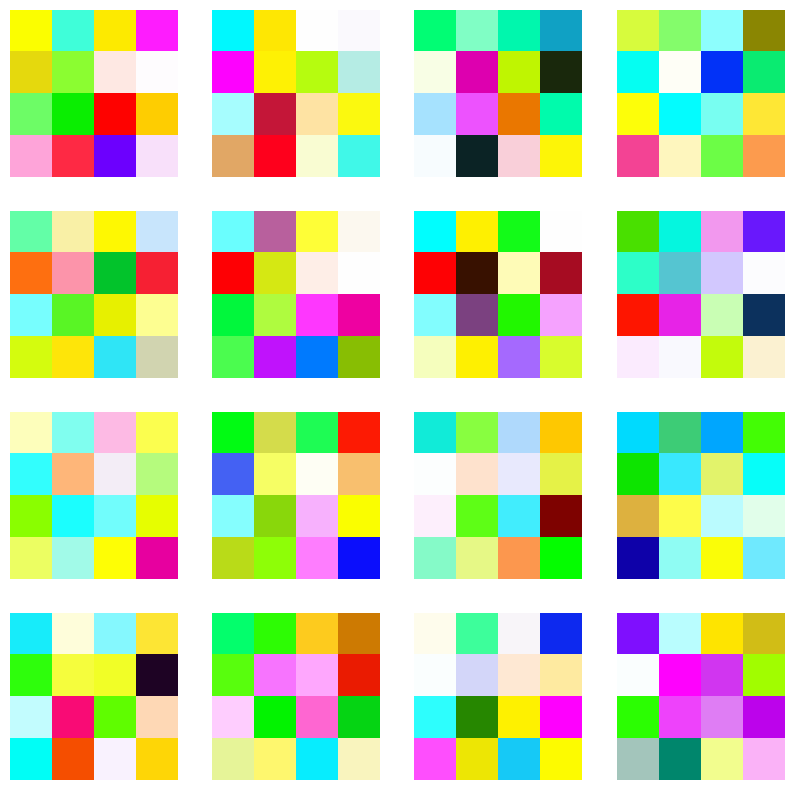

Step: 3
Alpha: 0.028468167917709203
Current Resolution: 4
Discriminator loss : 1.3047654628753662
Generator loss: -0.27463793754577637


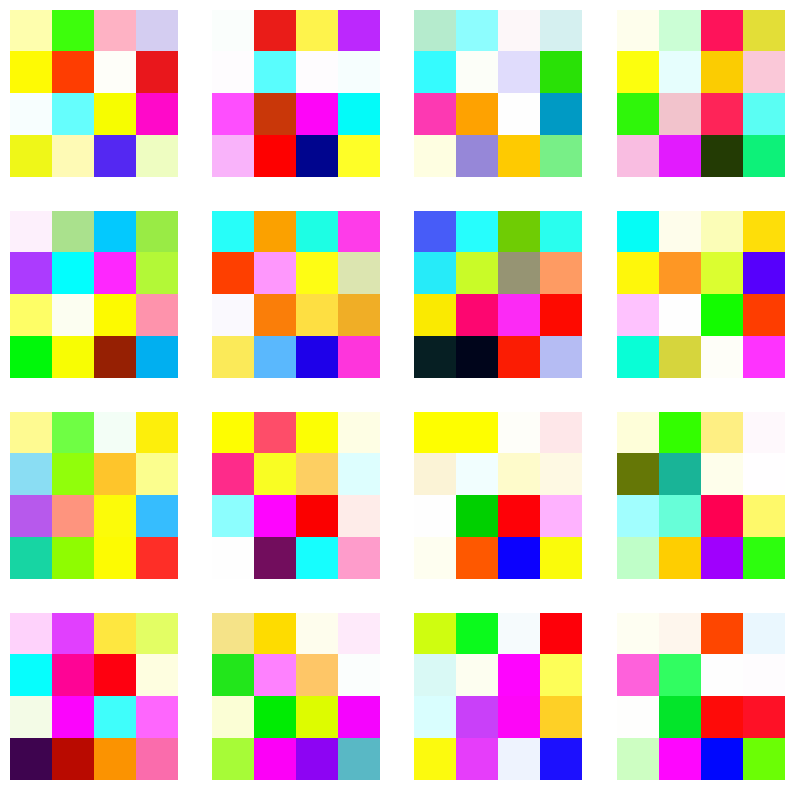

Step: 4
Alpha: 0.035585209897136504
Current Resolution: 4
Discriminator loss : 1.1621758937835693
Generator loss: -0.4116674065589905


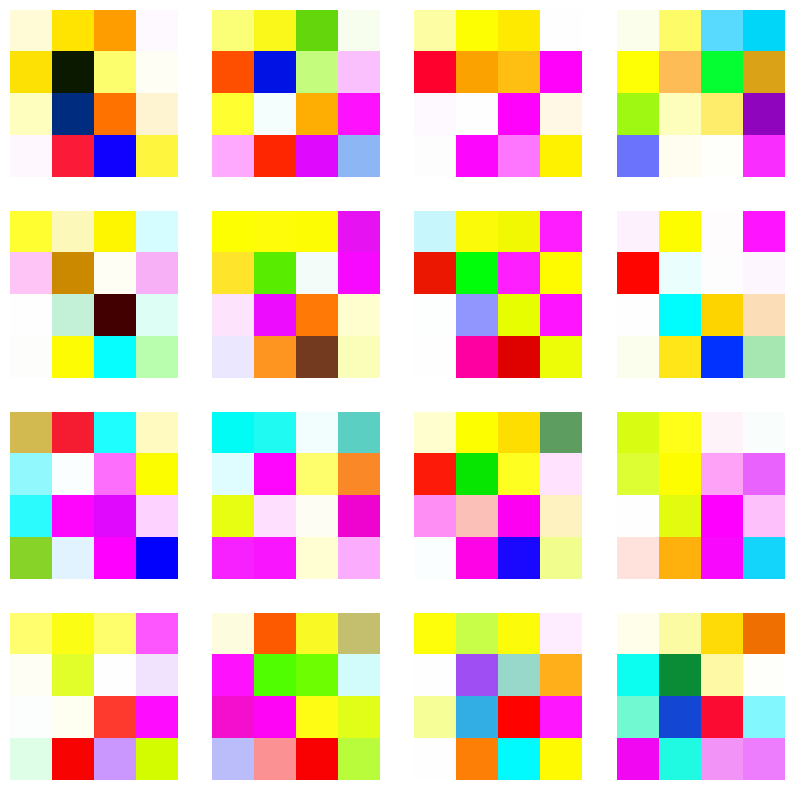

Step: 5
Alpha: 0.042702251876563804
Current Resolution: 4
Discriminator loss : 1.0253477096557617
Generator loss: -0.4958994388580322


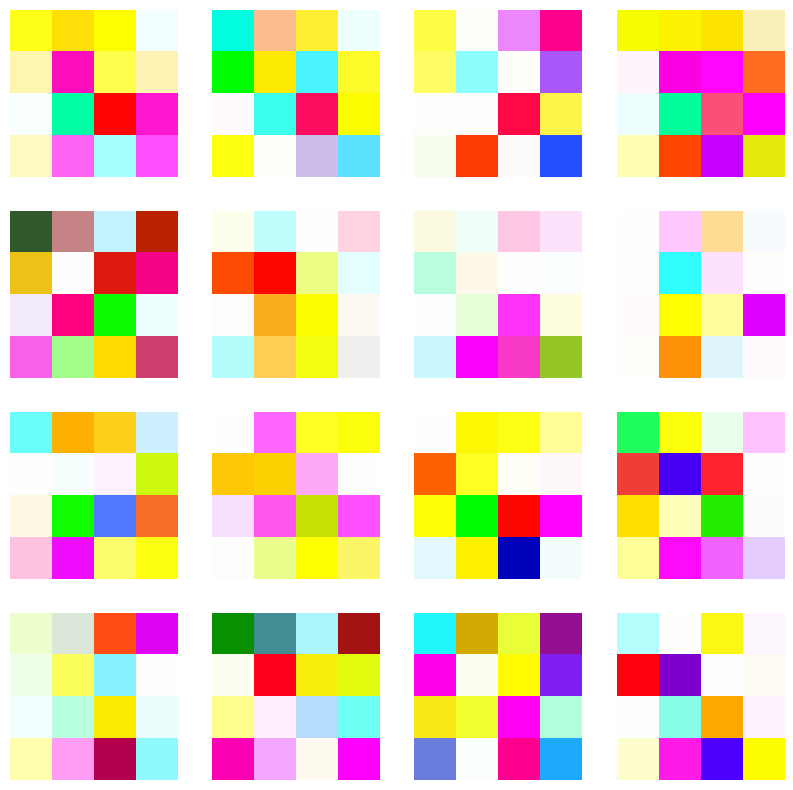

Step: 6
Alpha: 0.049819293855991105
Current Resolution: 4
Discriminator loss : 0.9004043936729431
Generator loss: -0.5113287568092346


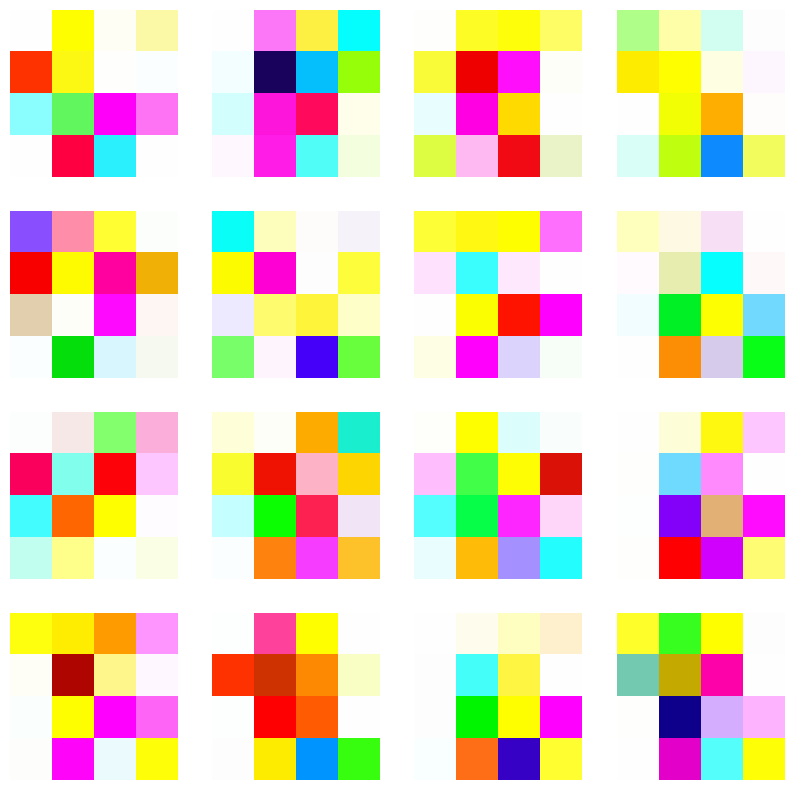

Step: 7
Alpha: 0.056936335835418406
Current Resolution: 4
Discriminator loss : 0.7749465107917786
Generator loss: -0.4707011282444


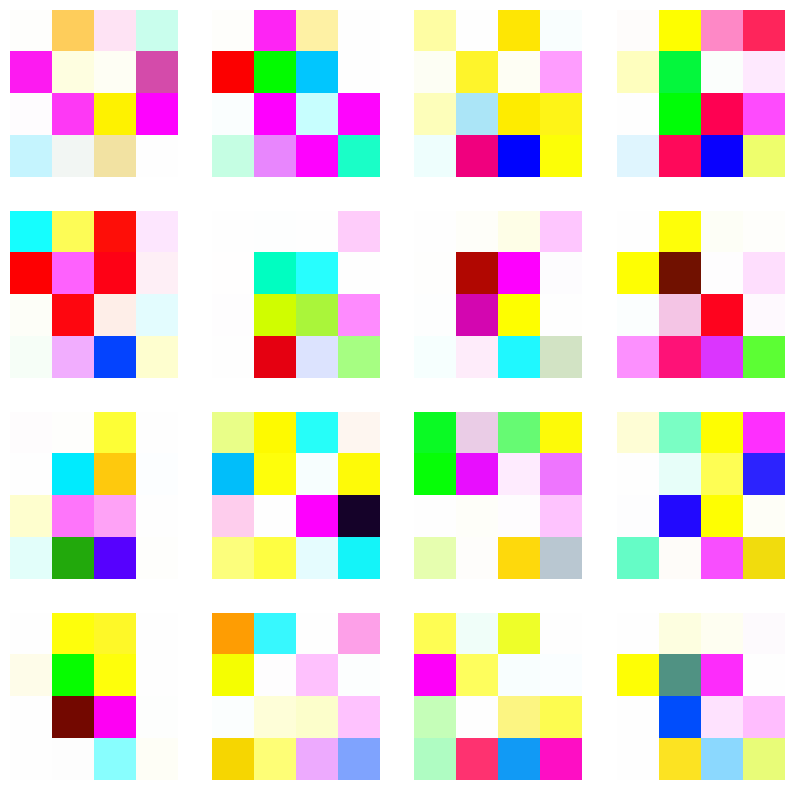

Step: 8
Alpha: 0.06405337781484571
Current Resolution: 4
Discriminator loss : 0.644902229309082
Generator loss: -0.3783690333366394


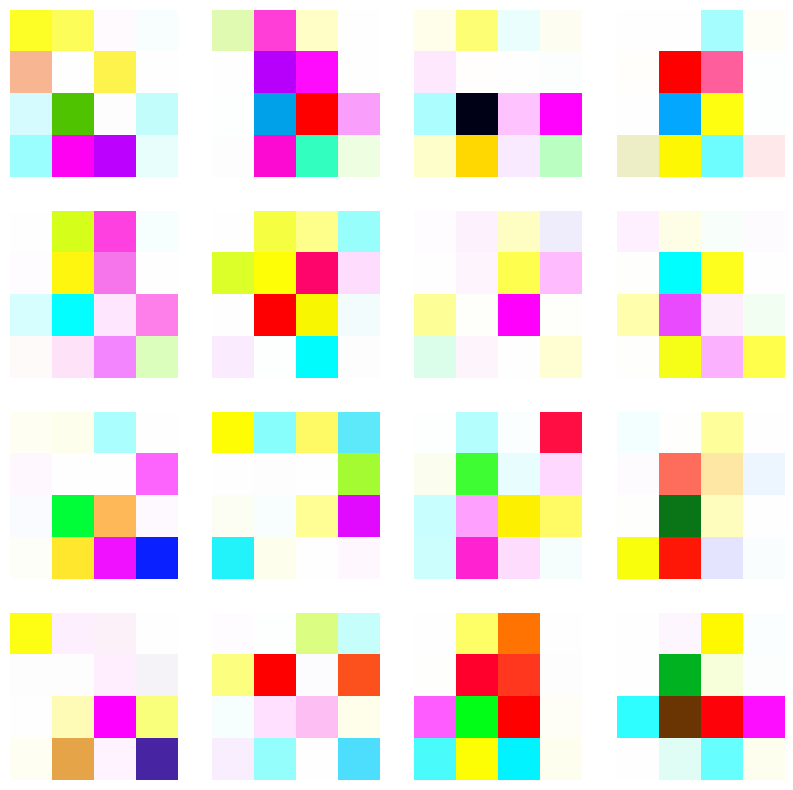

Step: 9
Alpha: 0.07117041979427302
Current Resolution: 4
Discriminator loss : 0.522352397441864
Generator loss: -0.25982969999313354


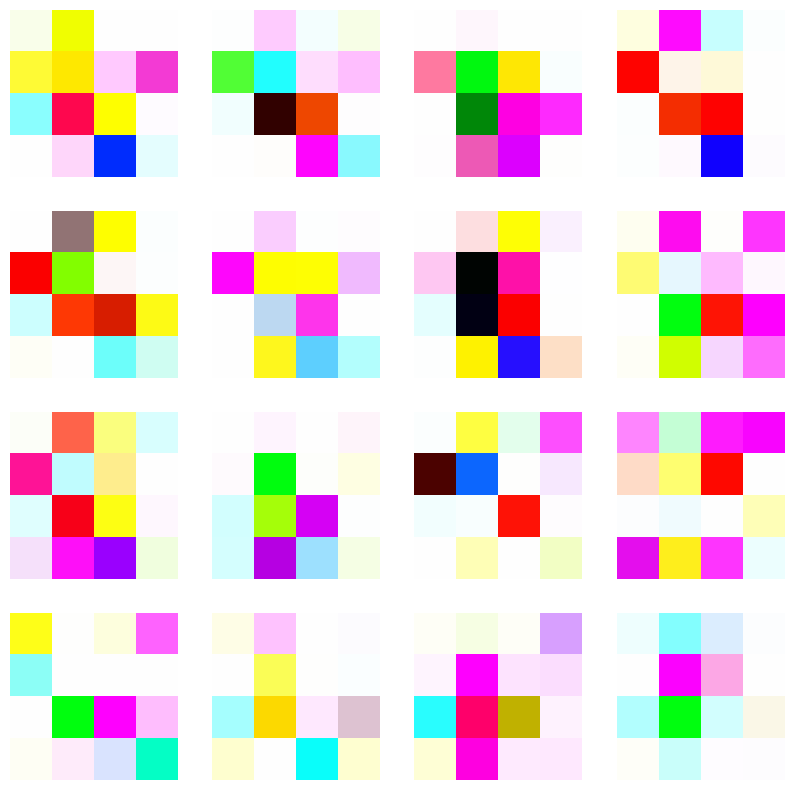

Step: 10
Alpha: 0.07828746177370033
Current Resolution: 4
Discriminator loss : 0.39657700061798096
Generator loss: -0.10169863700866699


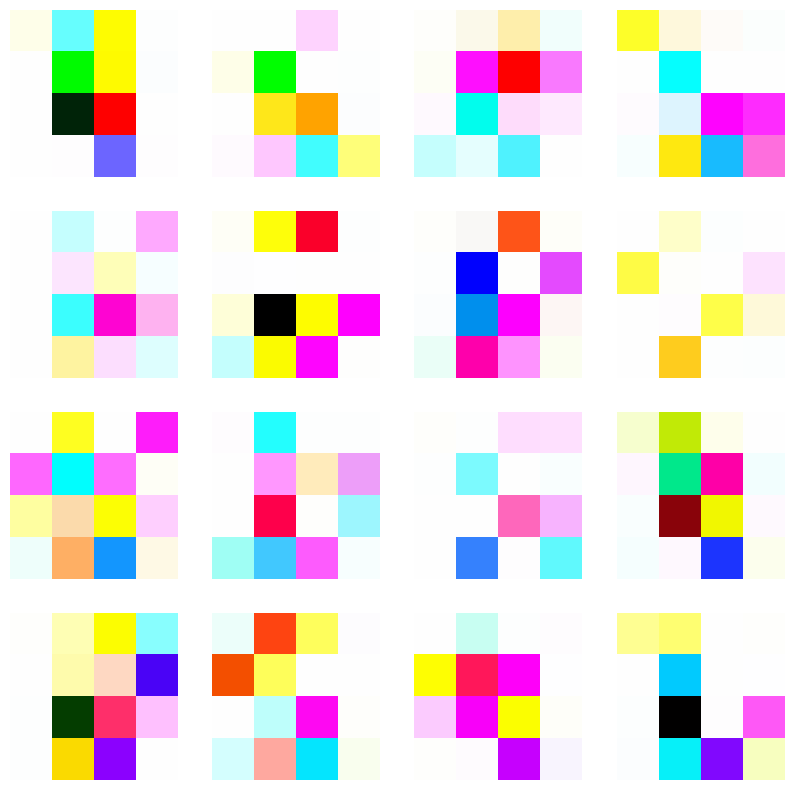

Step: 11
Alpha: 0.08540450375312764
Current Resolution: 4
Discriminator loss : 0.26993128657341003
Generator loss: 0.0907747745513916


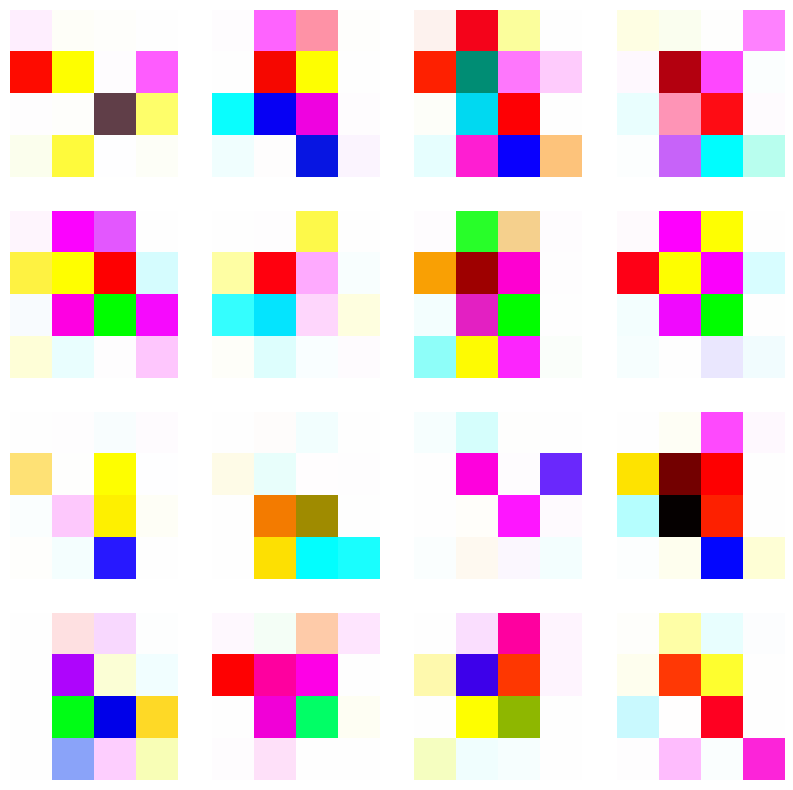

Step: 12
Alpha: 0.09252154573255494
Current Resolution: 4
Discriminator loss : 0.12426038086414337
Generator loss: 0.30331817269325256


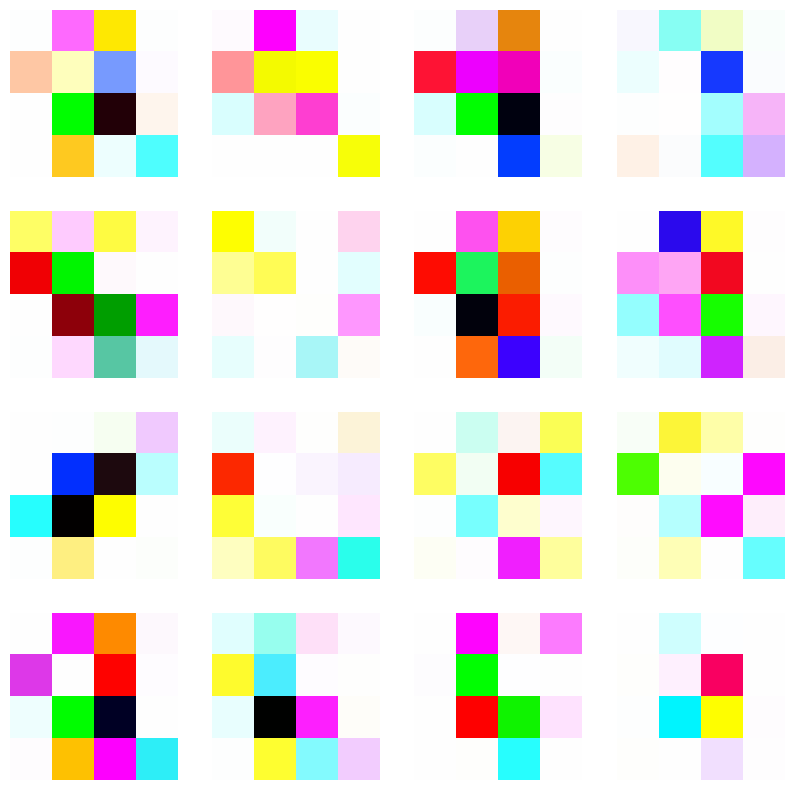

Step: 13
Alpha: 0.09963858771198225
Current Resolution: 4
Discriminator loss : -0.015214954502880573
Generator loss: 0.5293819308280945


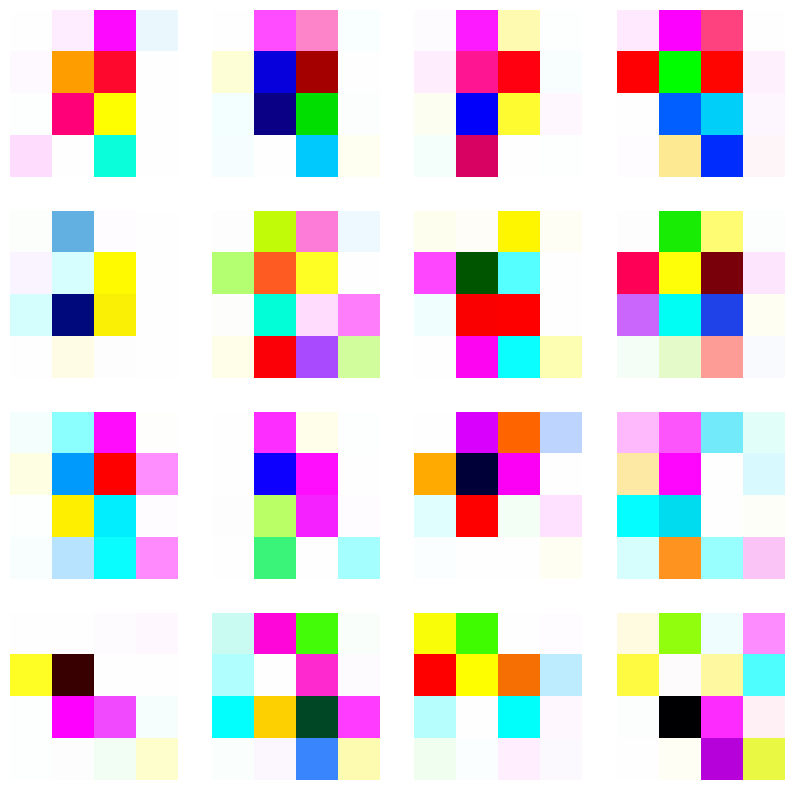

Step: 14
Alpha: 0.10675562969140956
Current Resolution: 4
Discriminator loss : -0.14758047461509705
Generator loss: 0.7565380334854126


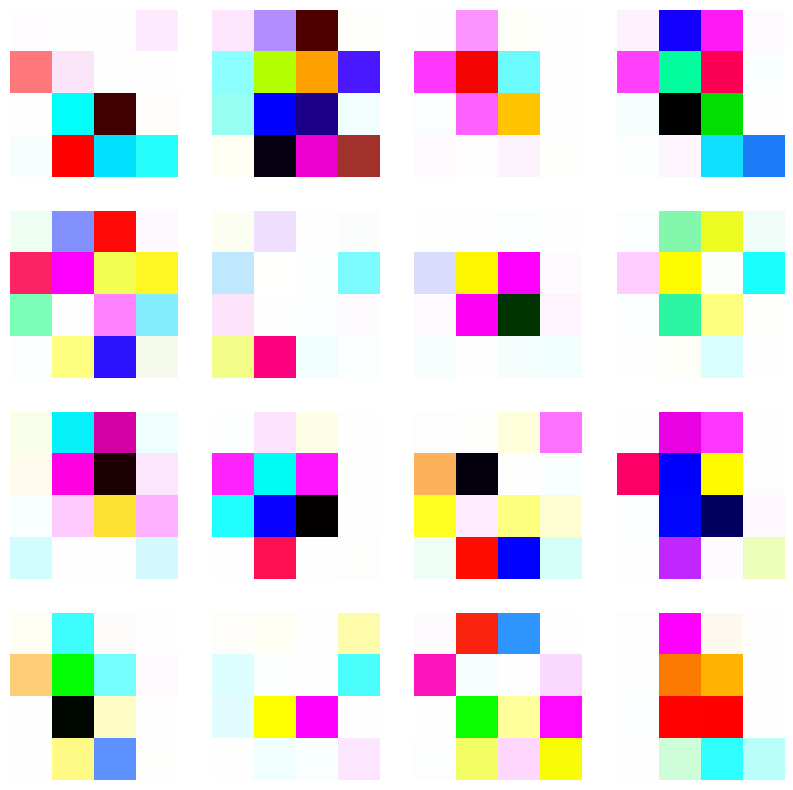

Step: 15
Alpha: 0.11387267167083687
Current Resolution: 4
Discriminator loss : -0.2812381982803345
Generator loss: 1.0017350912094116


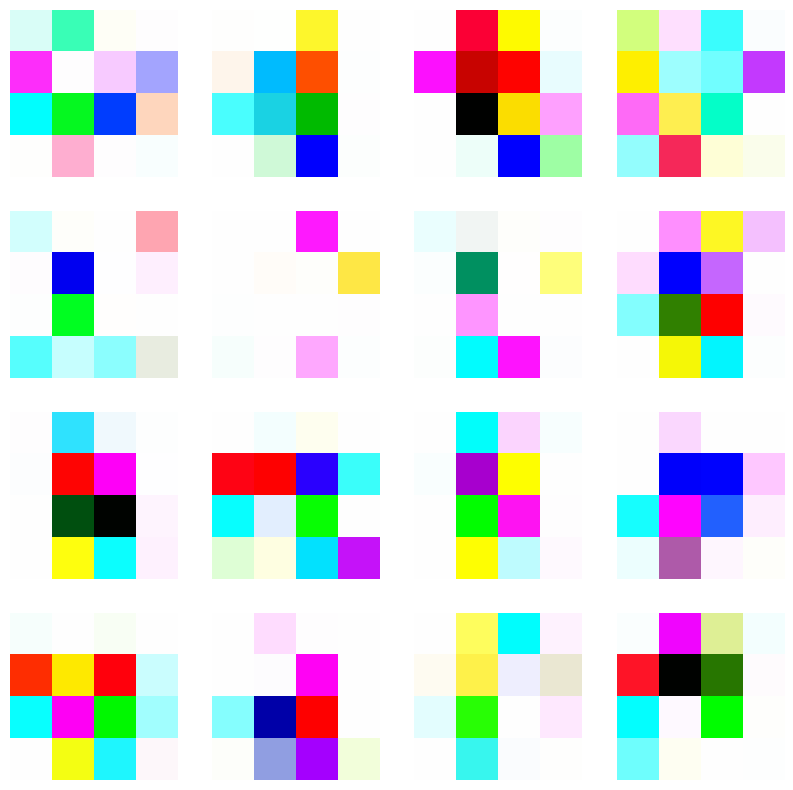

Step: 16
Alpha: 0.12098971365026417
Current Resolution: 4
Discriminator loss : -0.41249722242355347
Generator loss: 1.2328616380691528


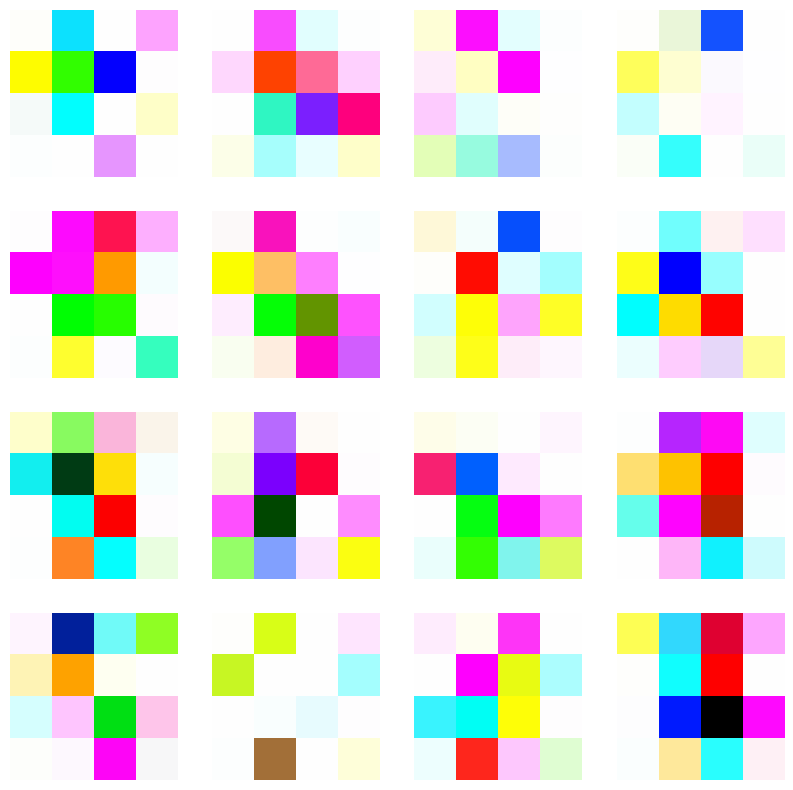

Step: 17
Alpha: 0.12810675562969148
Current Resolution: 4
Discriminator loss : -0.5358455181121826
Generator loss: 1.4600085020065308


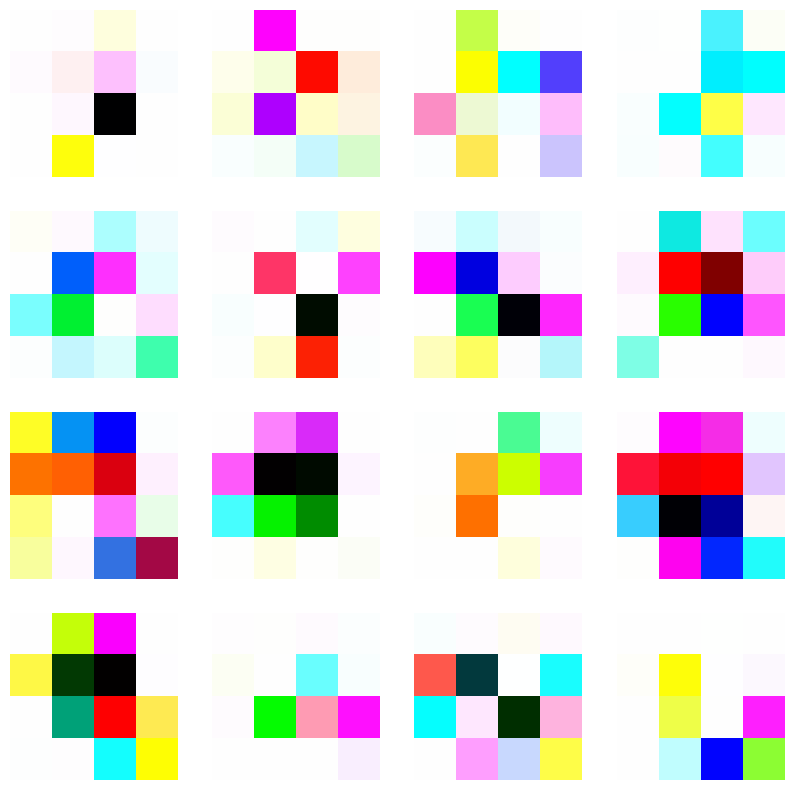

Step: 18
Alpha: 0.1352237976091188
Current Resolution: 4
Discriminator loss : -0.6644750833511353
Generator loss: 1.6756887435913086


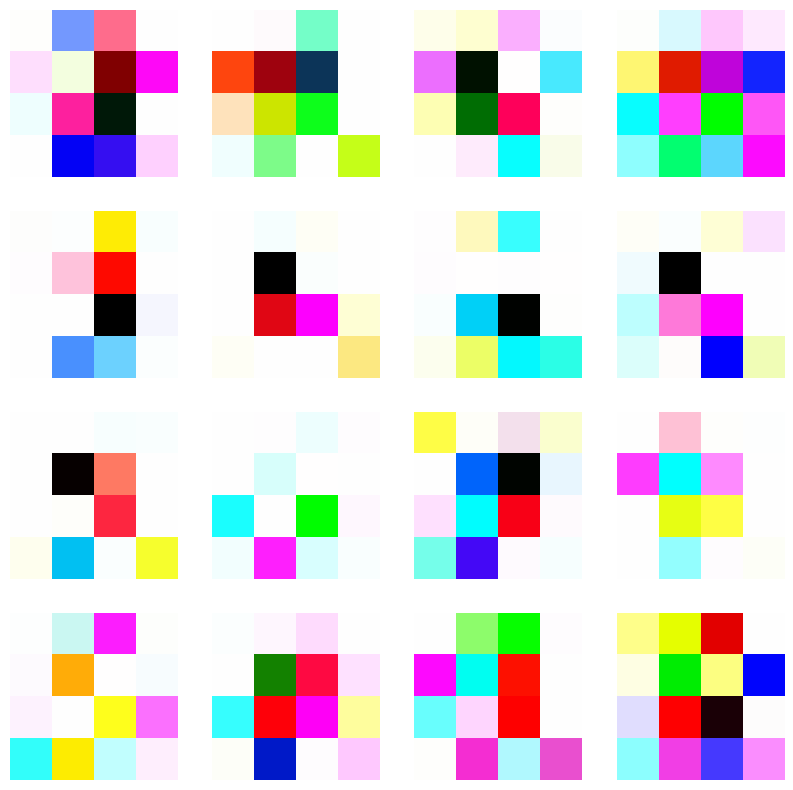

Step: 19
Alpha: 0.1423408395885461
Current Resolution: 4
Discriminator loss : -0.7867370843887329
Generator loss: 1.8686374425888062


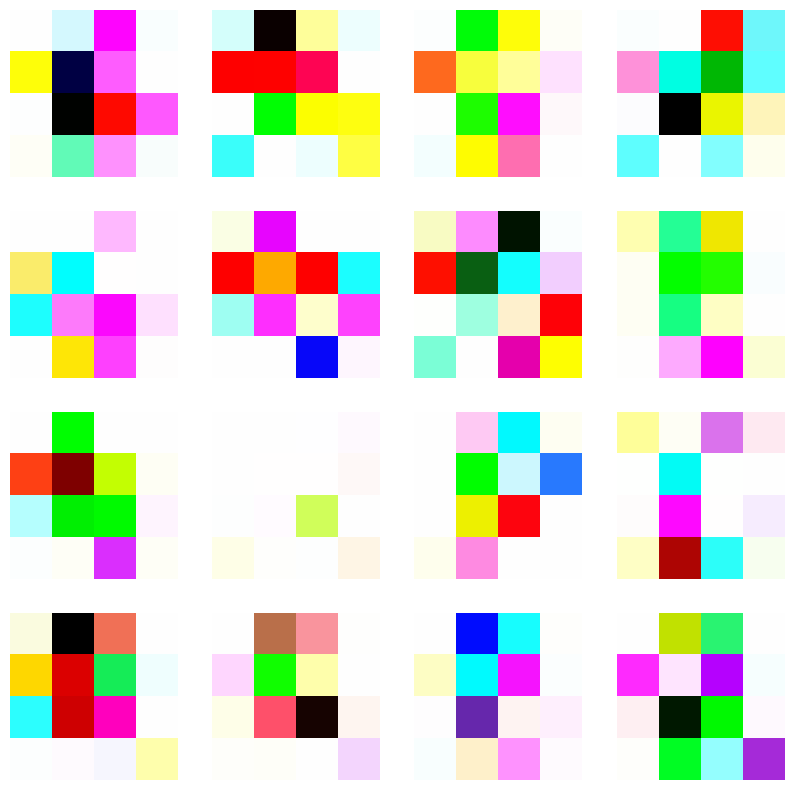

Step: 20
Alpha: 0.1494578815679734
Current Resolution: 4
Discriminator loss : -0.8932782411575317
Generator loss: 2.068173408508301


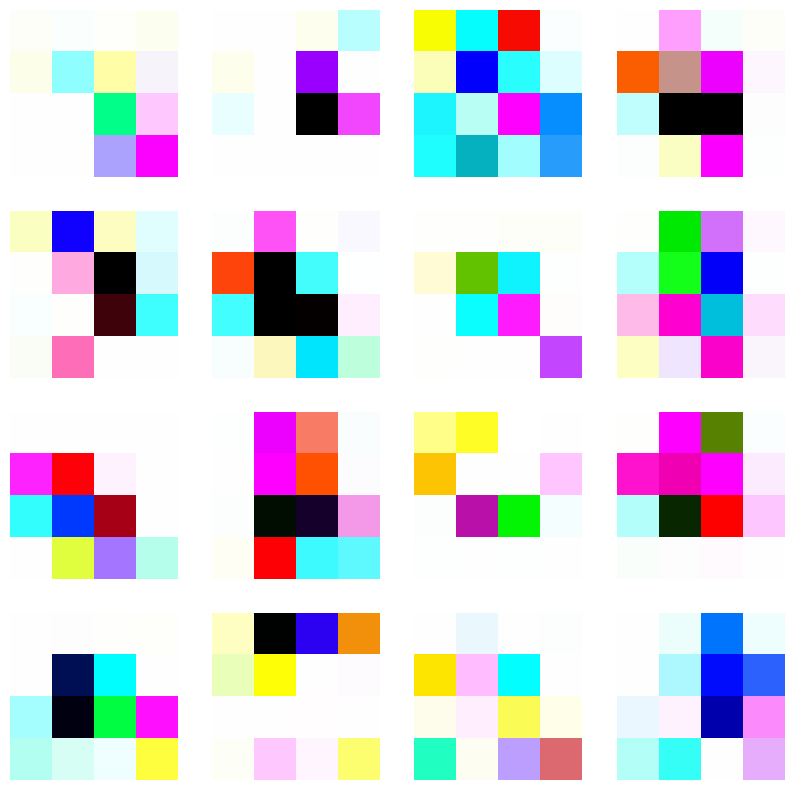

Step: 21
Alpha: 0.1565749235474007
Current Resolution: 4
Discriminator loss : -0.9871858954429626
Generator loss: 2.2275121212005615


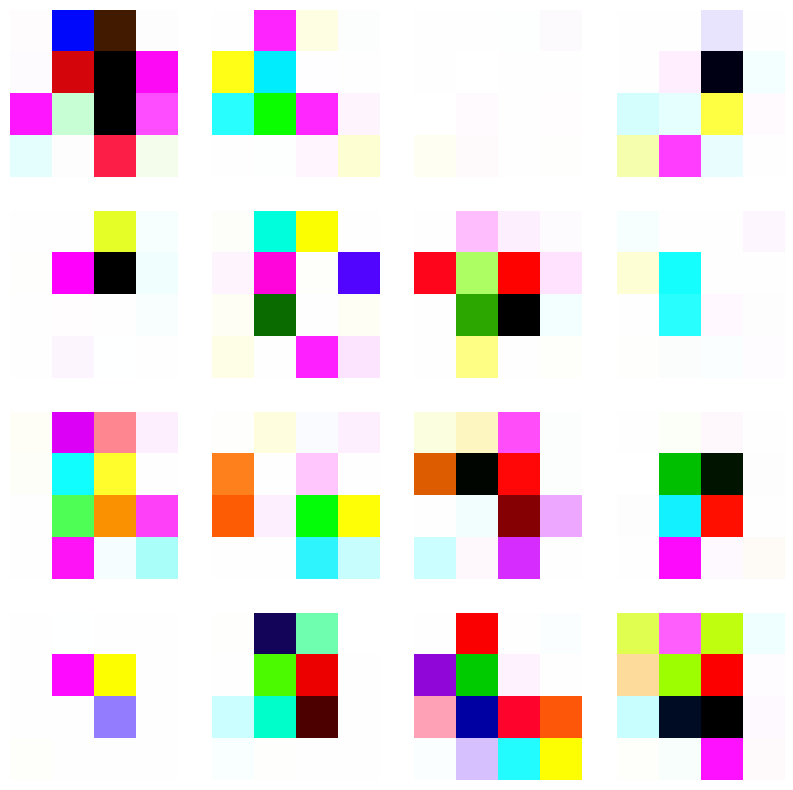

Step: 22
Alpha: 0.16369196552682802
Current Resolution: 4
Discriminator loss : -1.0693390369415283
Generator loss: 2.402397394180298


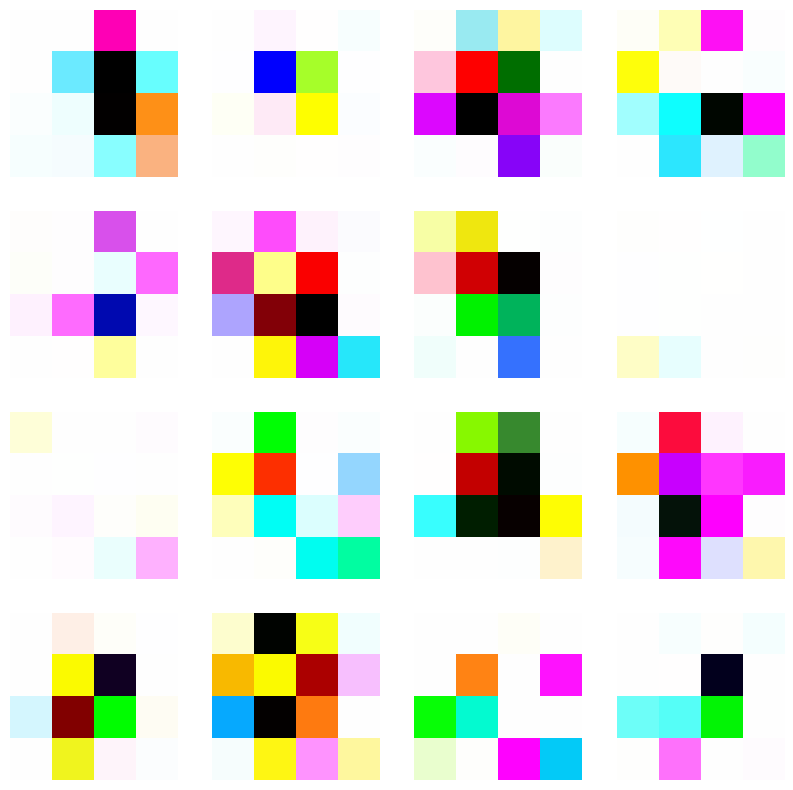

Step: 23
Alpha: 0.17080900750625533
Current Resolution: 4
Discriminator loss : -1.1526669263839722
Generator loss: 2.546433448791504


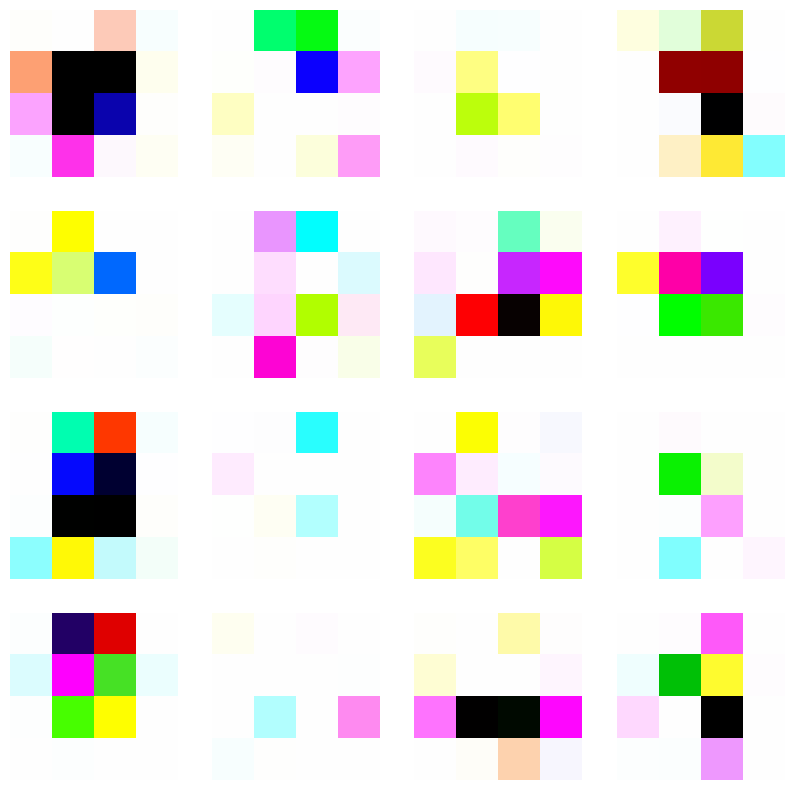

Step: 24
Alpha: 0.17792604948568264
Current Resolution: 4
Discriminator loss : -1.223343849182129
Generator loss: 2.70925235748291


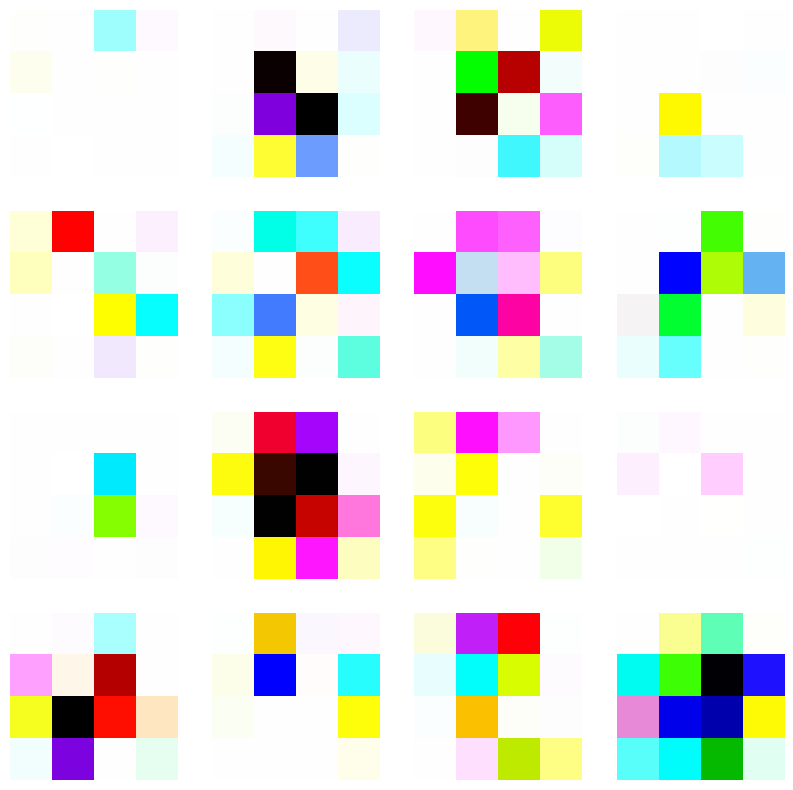

Step: 25
Alpha: 0.18504309146510994
Current Resolution: 4
Discriminator loss : -1.2925639152526855
Generator loss: 2.824080228805542


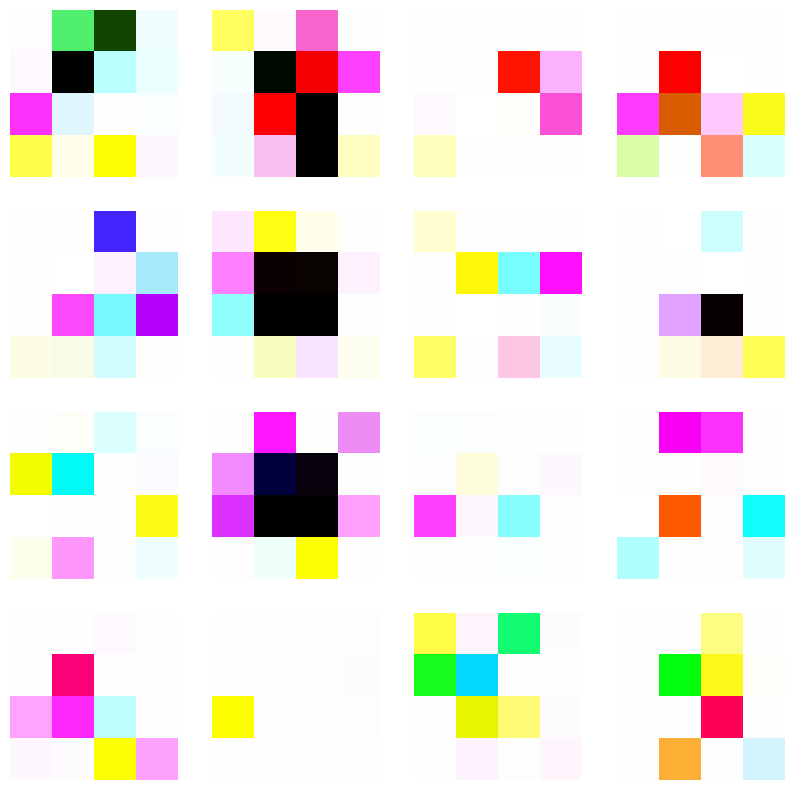

Step: 26
Alpha: 0.19216013344453725
Current Resolution: 4
Discriminator loss : -1.355224370956421
Generator loss: 2.9694712162017822


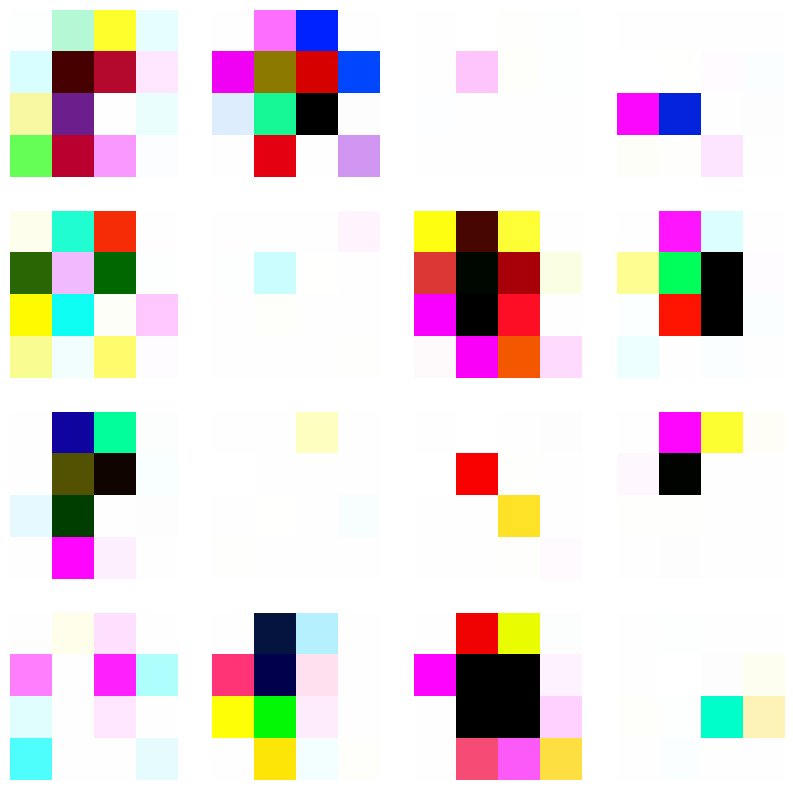

Step: 27
Alpha: 0.19927717542396456
Current Resolution: 4
Discriminator loss : -1.4014616012573242
Generator loss: 3.0542006492614746


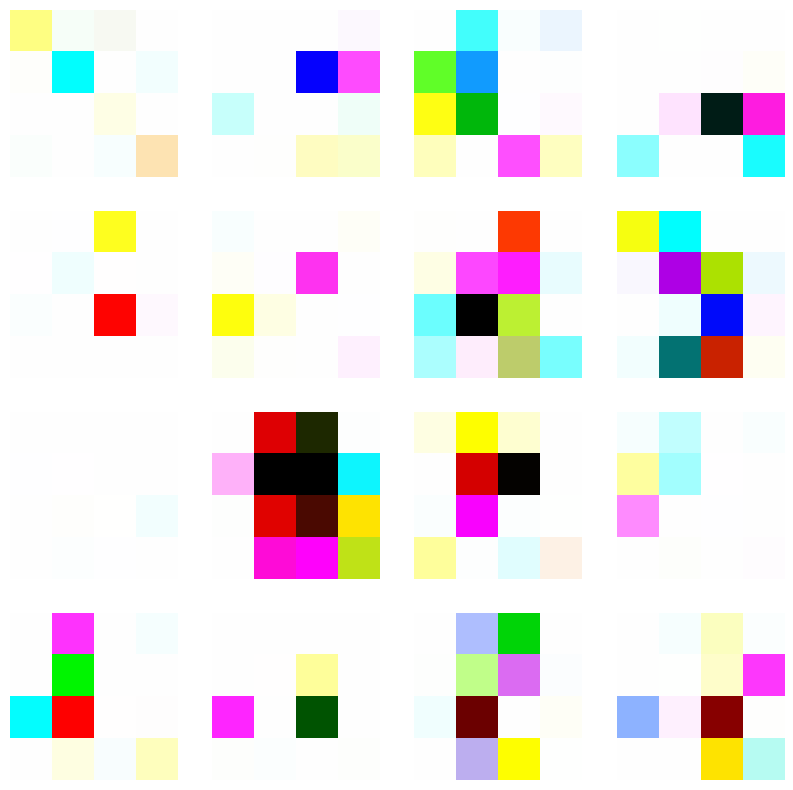

Step: 28
Alpha: 0.20639421740339187
Current Resolution: 4
Discriminator loss : -1.451587438583374
Generator loss: 3.186117172241211


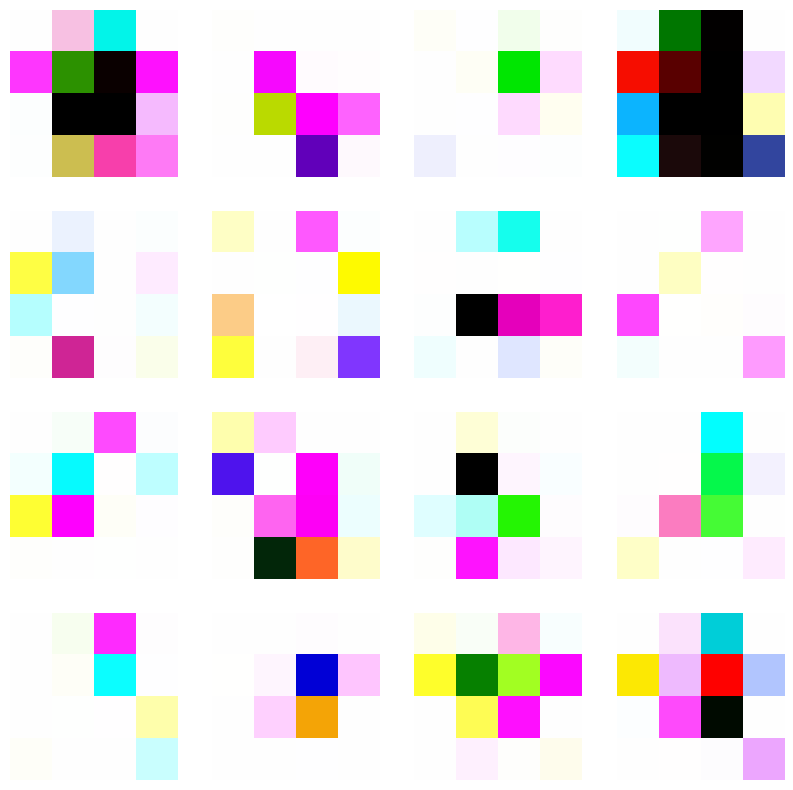

Step: 29
Alpha: 0.21351125938281917
Current Resolution: 4
Discriminator loss : -1.4998408555984497
Generator loss: 3.2729551792144775


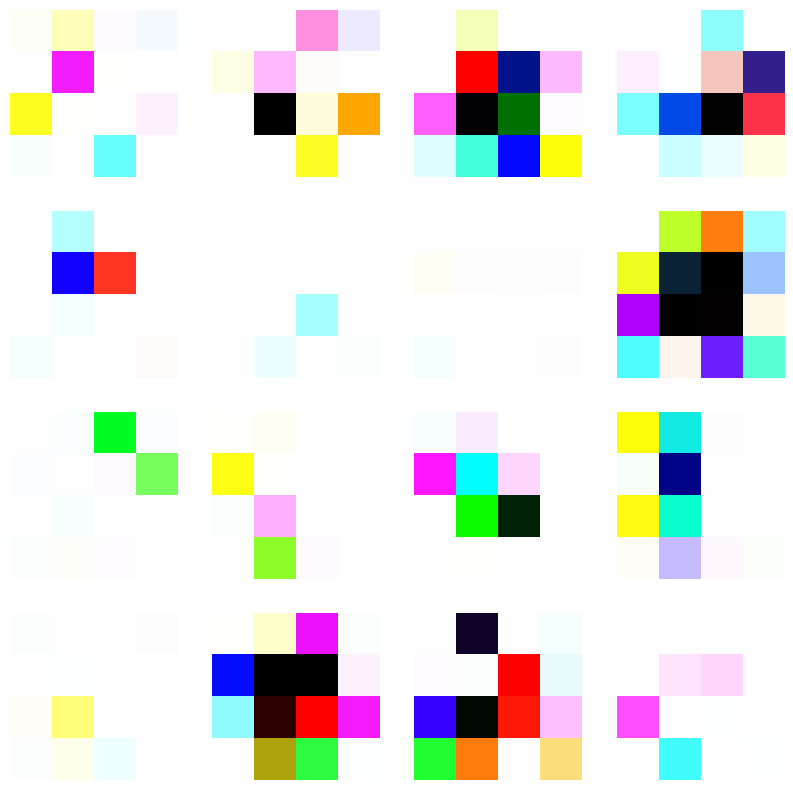

Step: 30
Alpha: 0.22062830136224648
Current Resolution: 4
Discriminator loss : -1.5413316488265991
Generator loss: 3.380892753601074


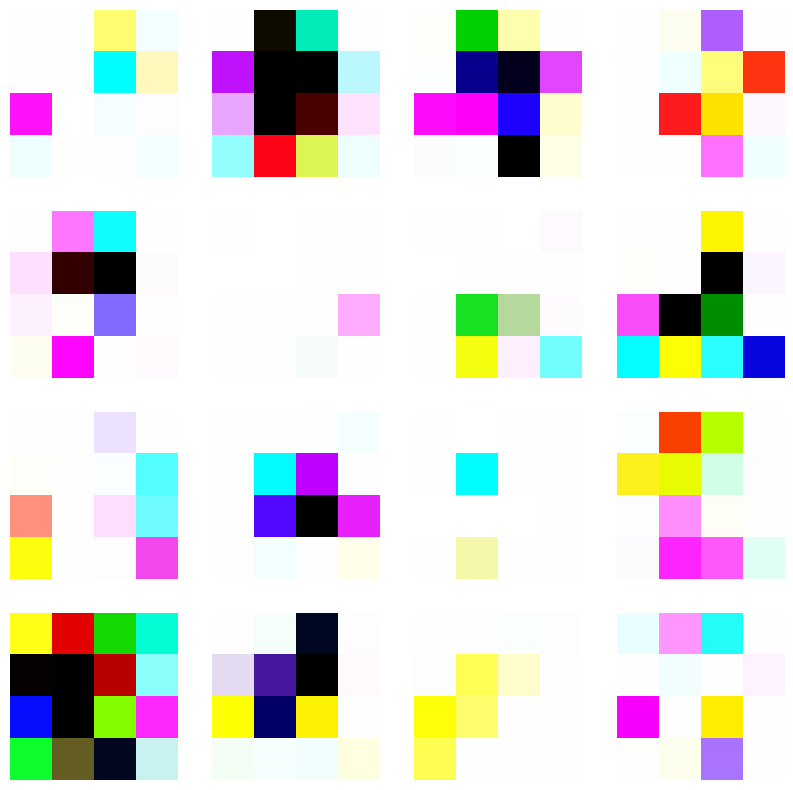

Step: 31
Alpha: 0.2277453433416738
Current Resolution: 4
Discriminator loss : -1.5855661630630493
Generator loss: 3.454901695251465


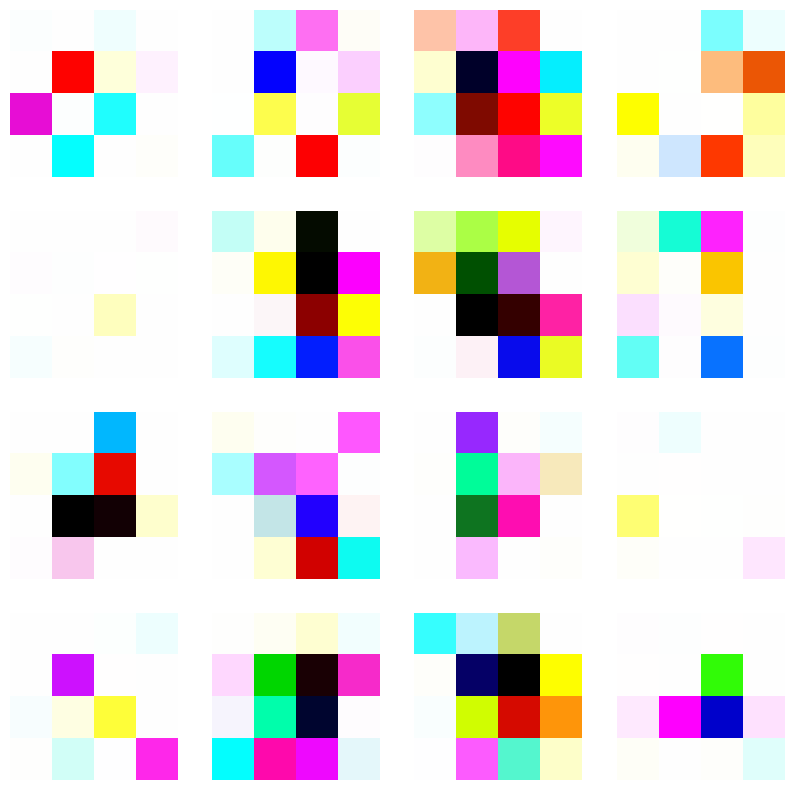

Step: 32
Alpha: 0.2348623853211011
Current Resolution: 4
Discriminator loss : -1.6171066761016846
Generator loss: 3.547961950302124


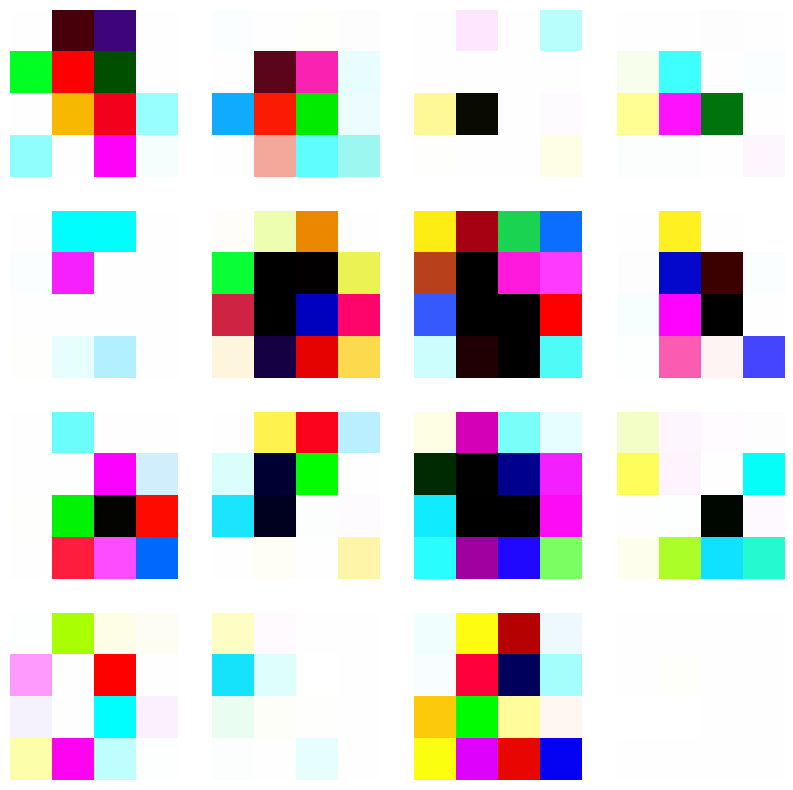

Step: 33
Alpha: 0.2419794273005284
Current Resolution: 4
Discriminator loss : -1.6540213823318481
Generator loss: 3.616297960281372


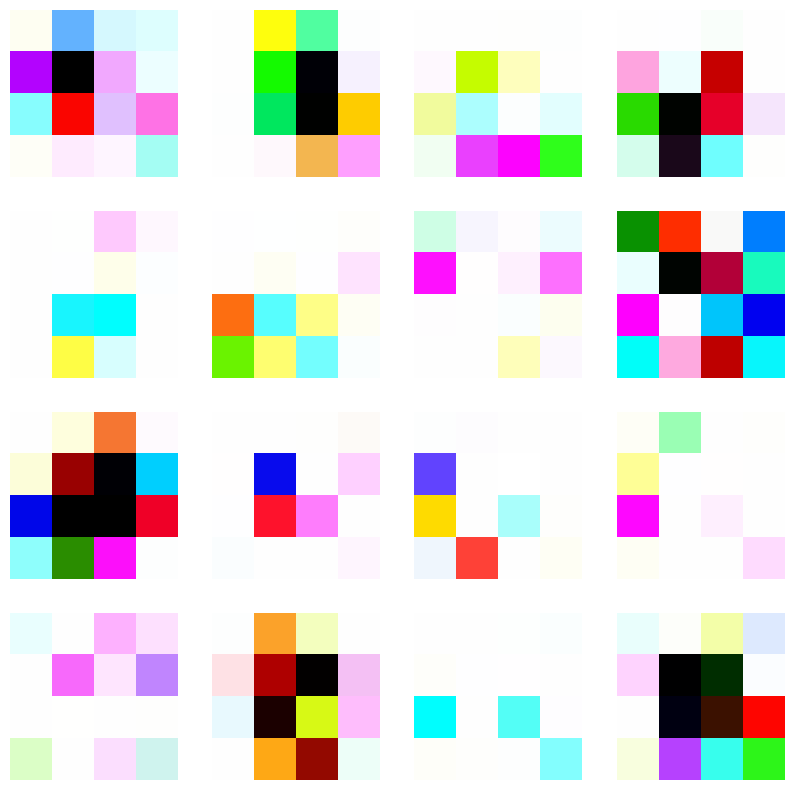

Step: 34
Alpha: 0.2490964692799557
Current Resolution: 4
Discriminator loss : -1.6881059408187866
Generator loss: 3.6995770931243896


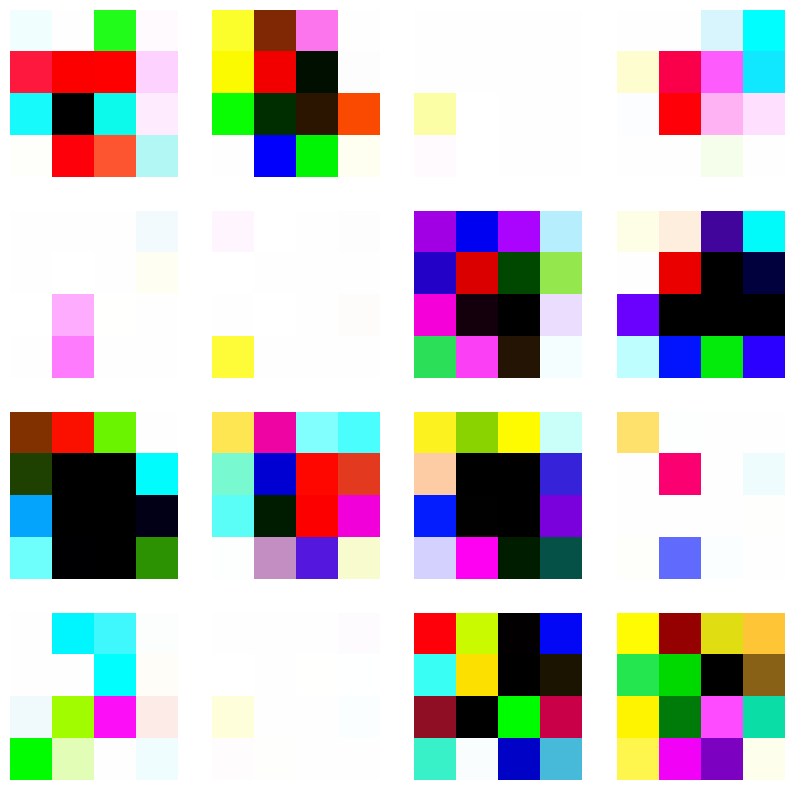

Step: 35
Alpha: 0.256213511259383
Current Resolution: 4
Discriminator loss : -1.7133086919784546
Generator loss: 3.74979305267334


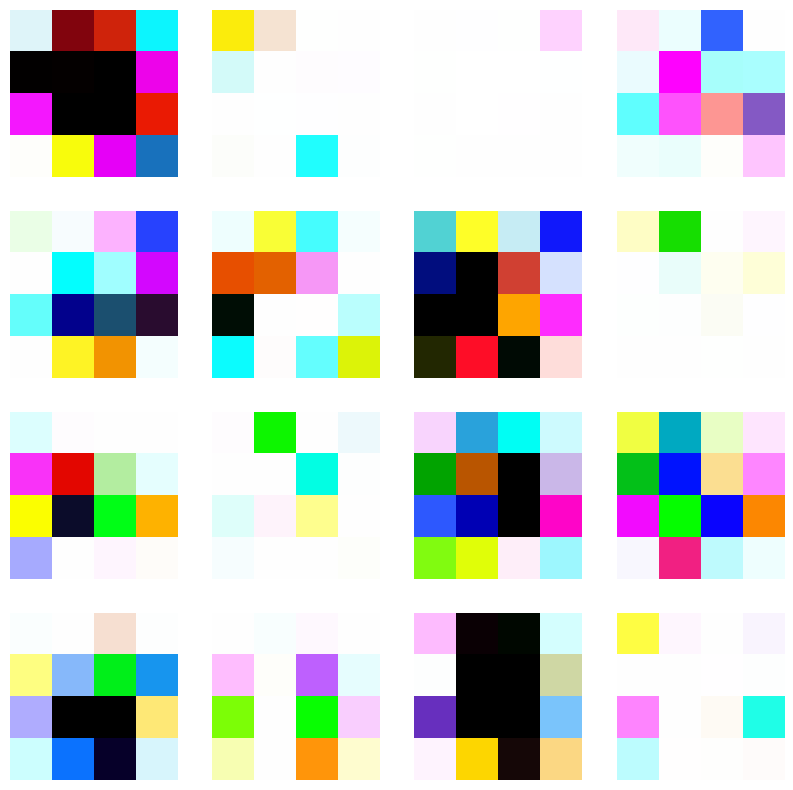

Step: 36
Alpha: 0.2633305532388103
Current Resolution: 4
Discriminator loss : -1.741193175315857
Generator loss: 3.814457654953003


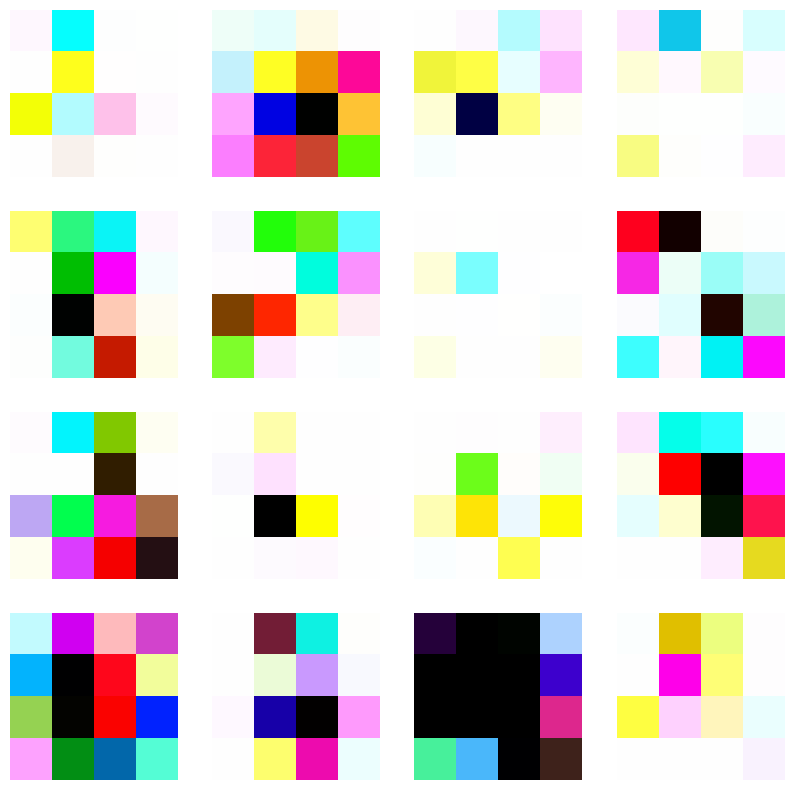

Step: 37
Alpha: 0.27044759521823764
Current Resolution: 4
Discriminator loss : -1.768011450767517
Generator loss: 3.8777096271514893


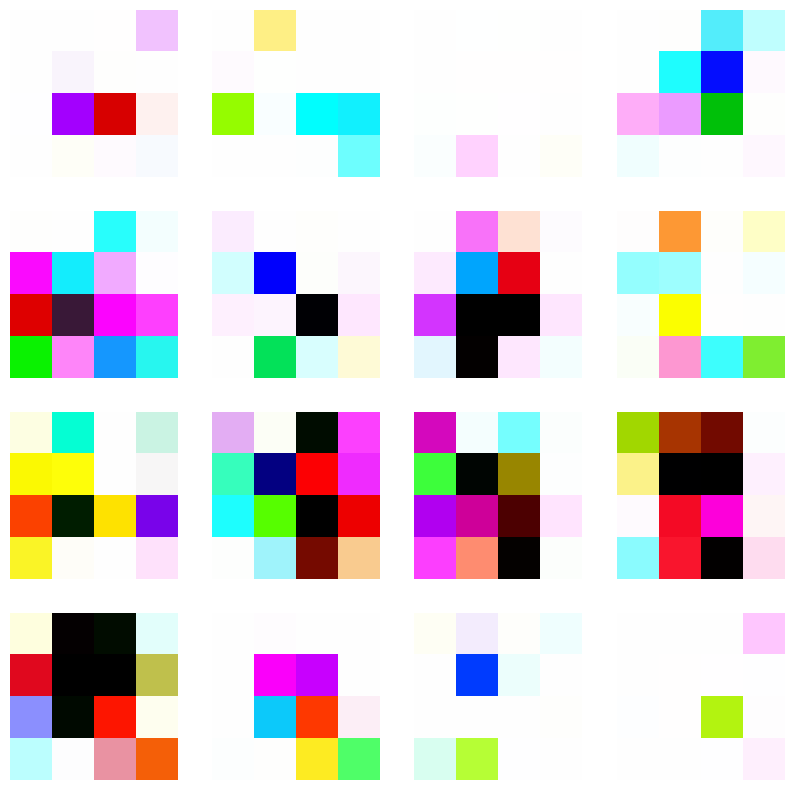

Step: 38
Alpha: 0.27756463719766494
Current Resolution: 4
Discriminator loss : -1.7936294078826904
Generator loss: 3.927730083465576


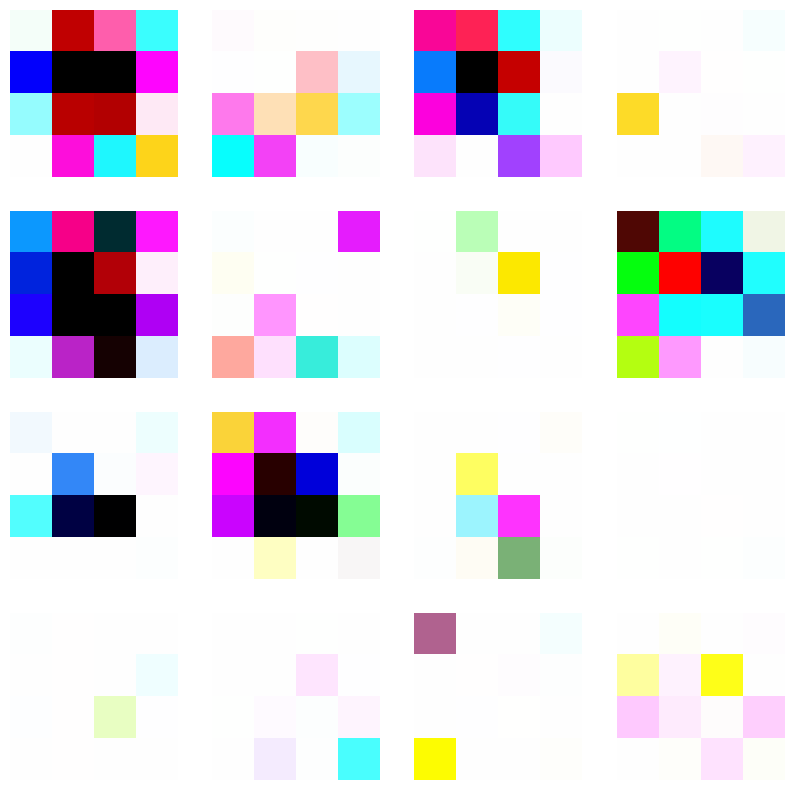

Step: 39
Alpha: 0.28468167917709225
Current Resolution: 4
Discriminator loss : -1.82085382938385
Generator loss: 3.9960334300994873


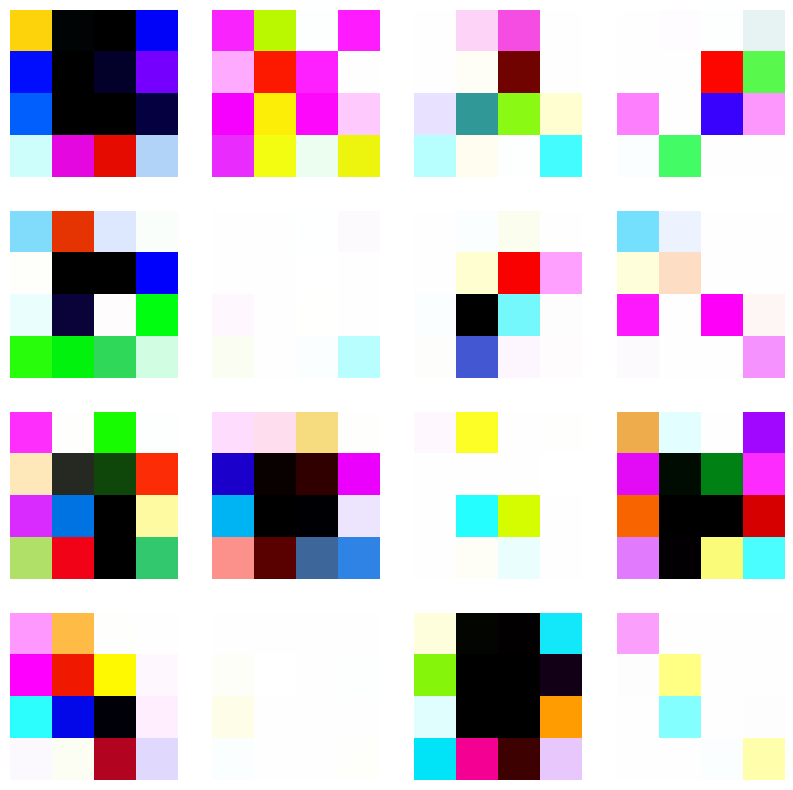

Step: 40
Alpha: 0.29179872115651956
Current Resolution: 4
Discriminator loss : -1.8461588621139526
Generator loss: 4.04072380065918


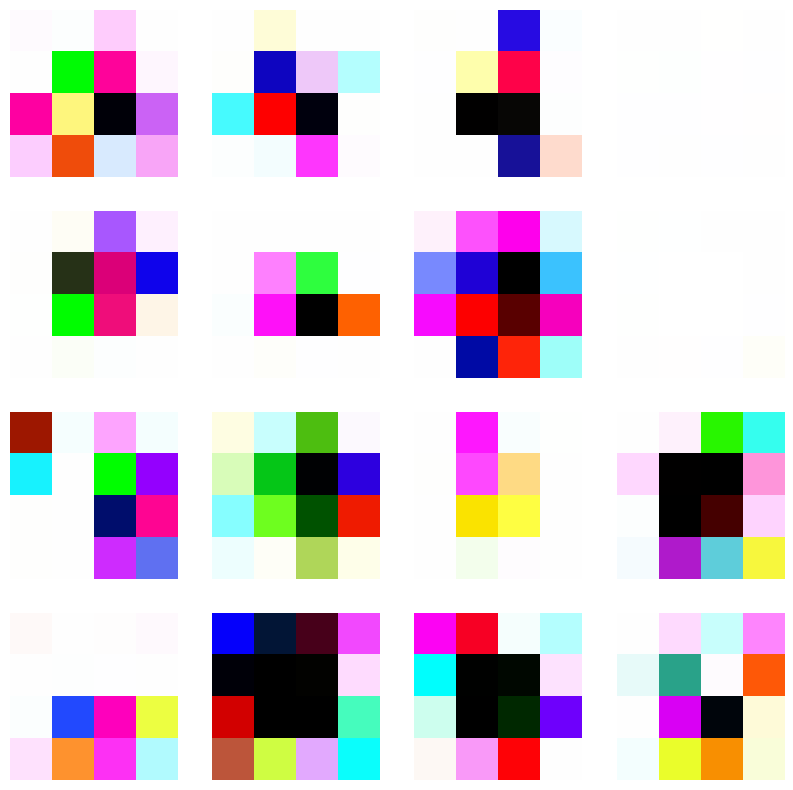

Step: 41
Alpha: 0.29891576313594687
Current Resolution: 4
Discriminator loss : -1.8657146692276
Generator loss: 4.093814849853516


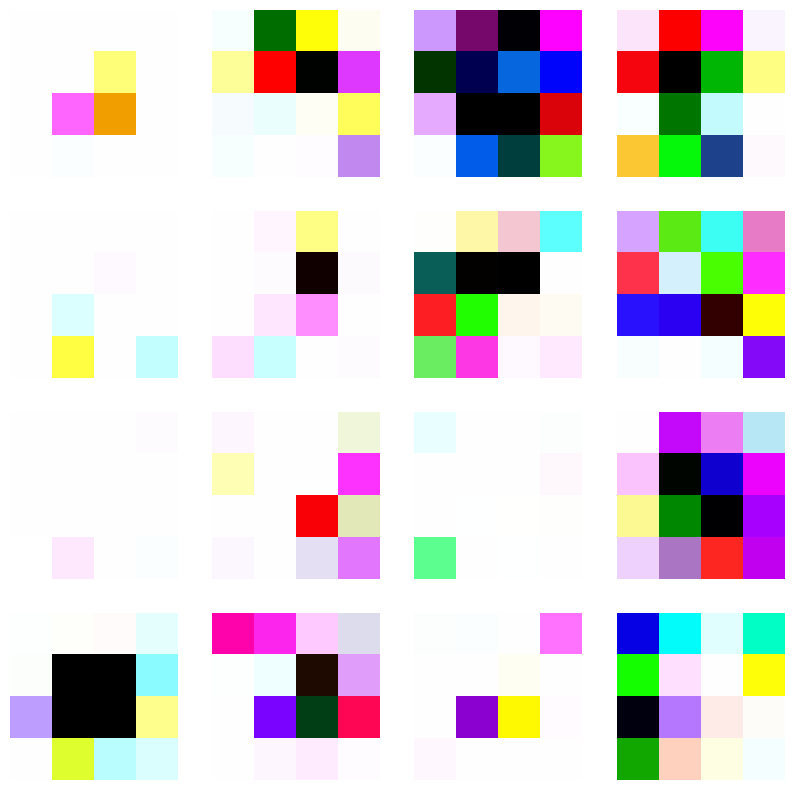

Step: 42
Alpha: 0.3060328051153742
Current Resolution: 4
Discriminator loss : -1.884538173675537
Generator loss: 4.135179042816162


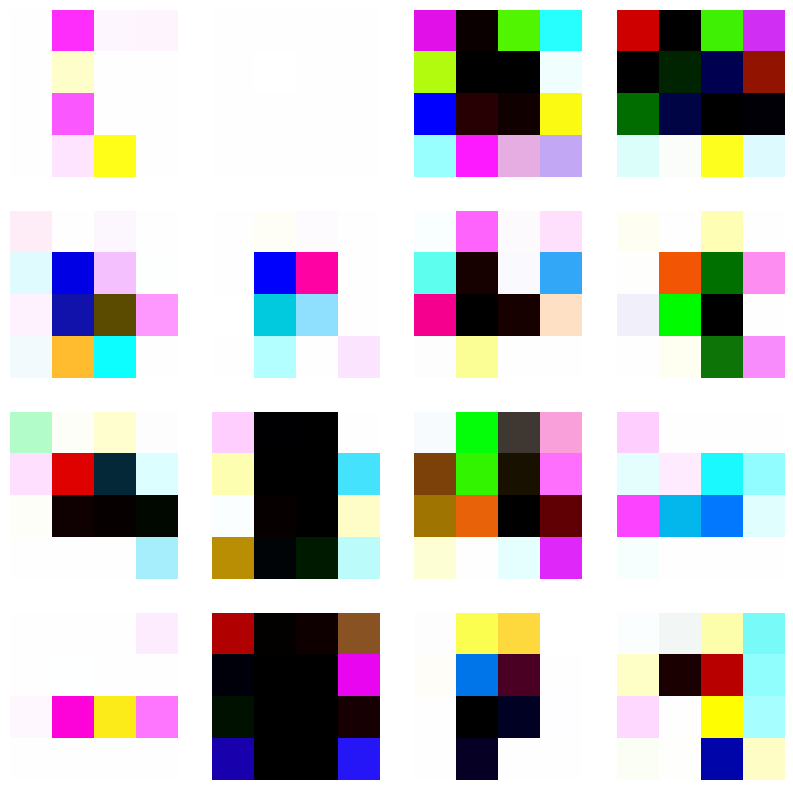

Step: 43
Alpha: 0.3131498470948015
Current Resolution: 4
Discriminator loss : -1.9066413640975952
Generator loss: 4.189805030822754


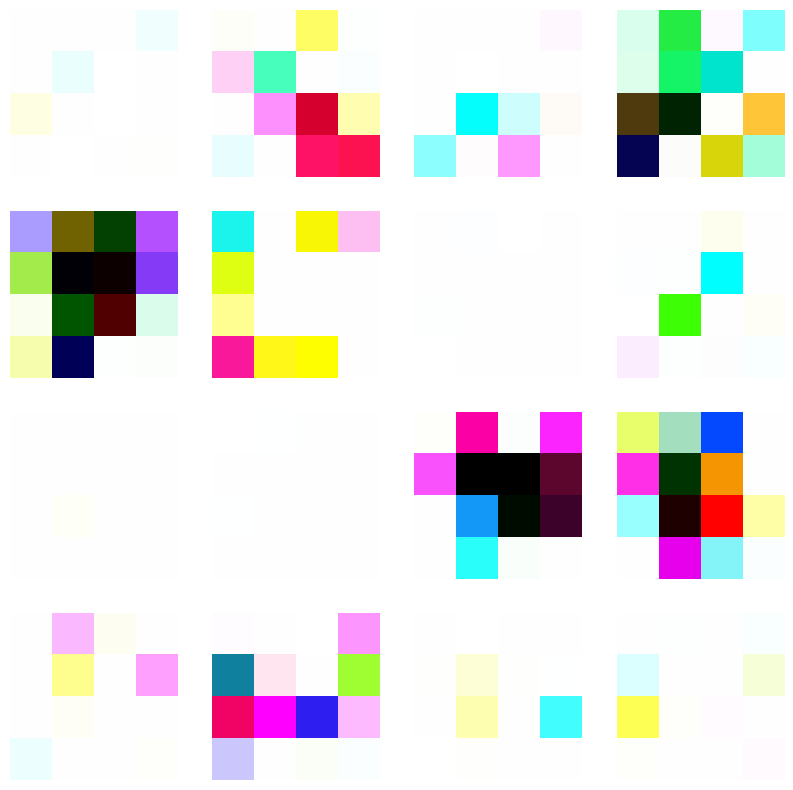

Step: 44
Alpha: 0.3202668890742288
Current Resolution: 4
Discriminator loss : -1.925419807434082
Generator loss: 4.218166828155518


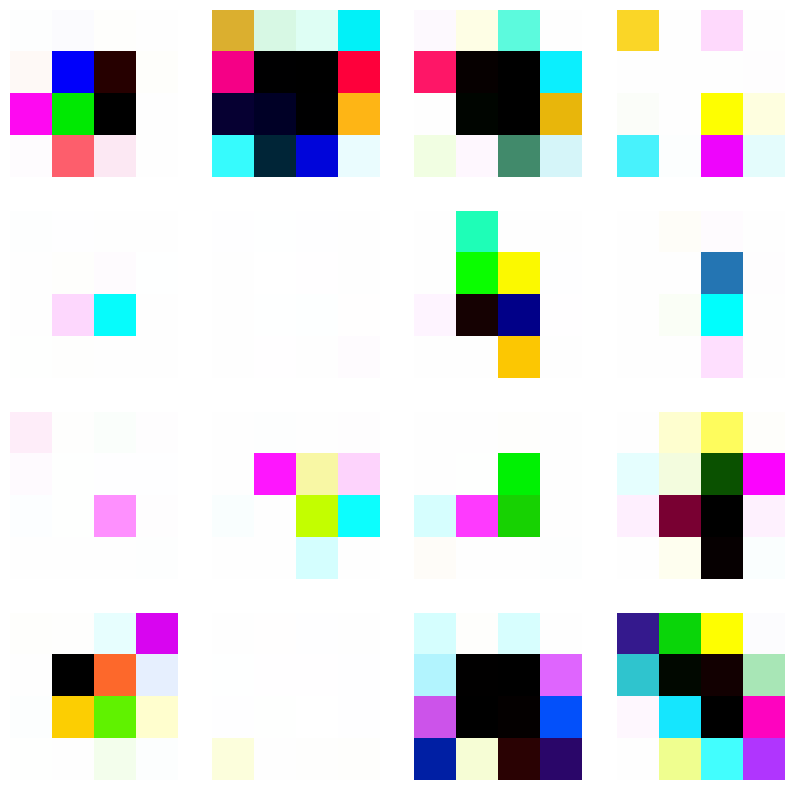

Step: 45
Alpha: 0.3273839310536561
Current Resolution: 4
Discriminator loss : -1.9390113353729248
Generator loss: 4.2783589363098145


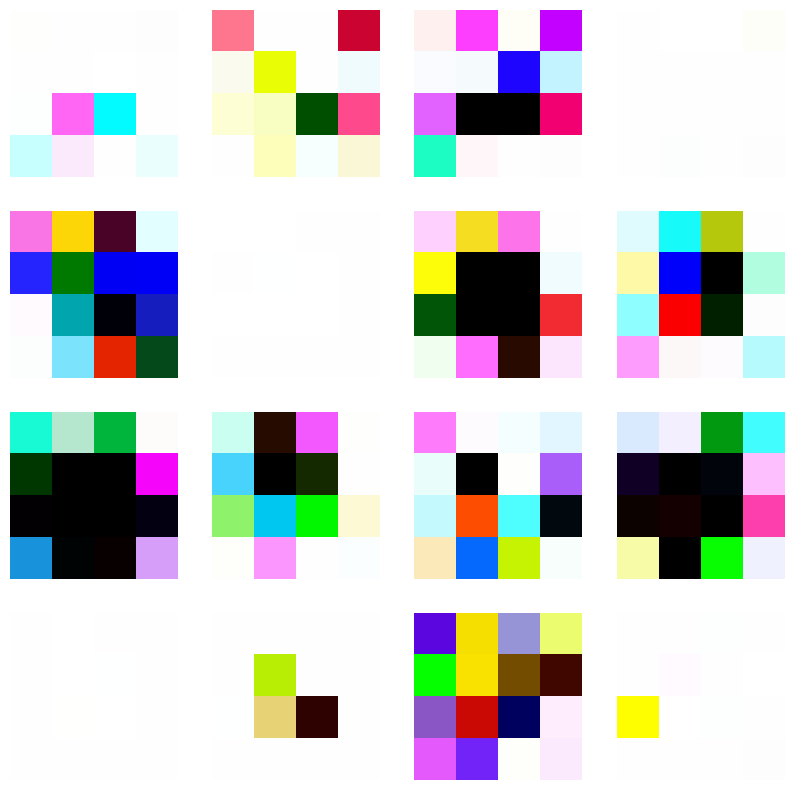

Step: 46
Alpha: 0.3345009730330834
Current Resolution: 4
Discriminator loss : -1.957698106765747
Generator loss: 4.309083938598633


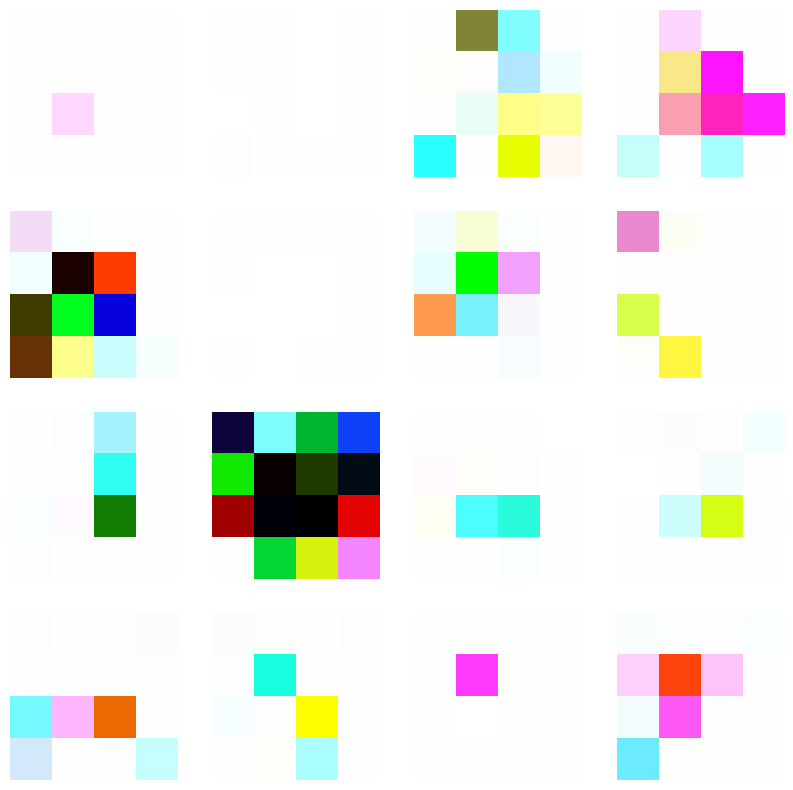

Step: 47
Alpha: 0.3416180150125107
Current Resolution: 4
Discriminator loss : -1.9717499017715454
Generator loss: 4.369929313659668


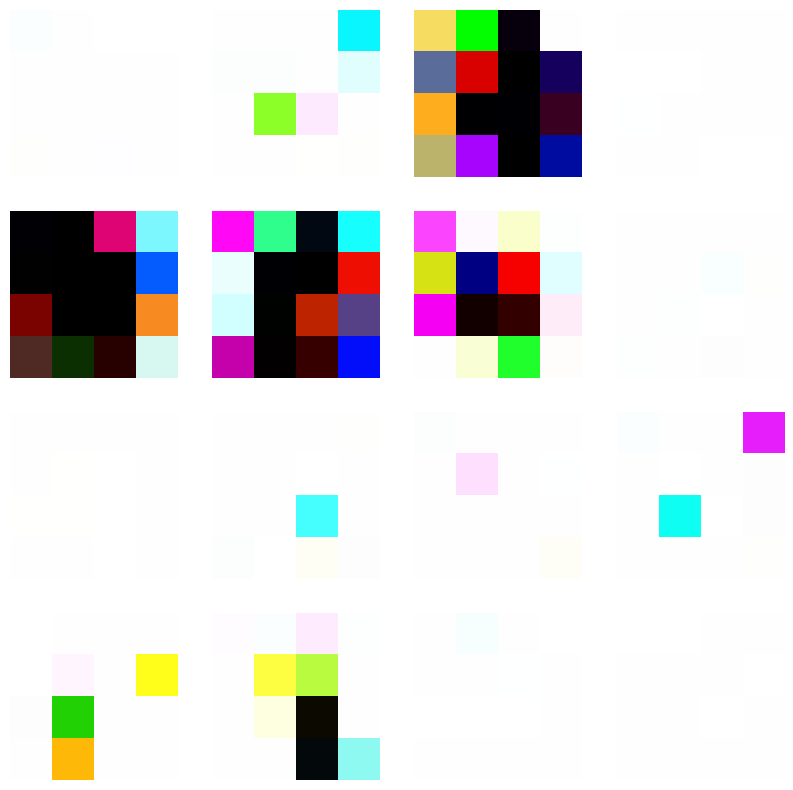

Step: 48
Alpha: 0.348735056991938
Current Resolution: 4
Discriminator loss : -1.98469078540802
Generator loss: 4.393158435821533


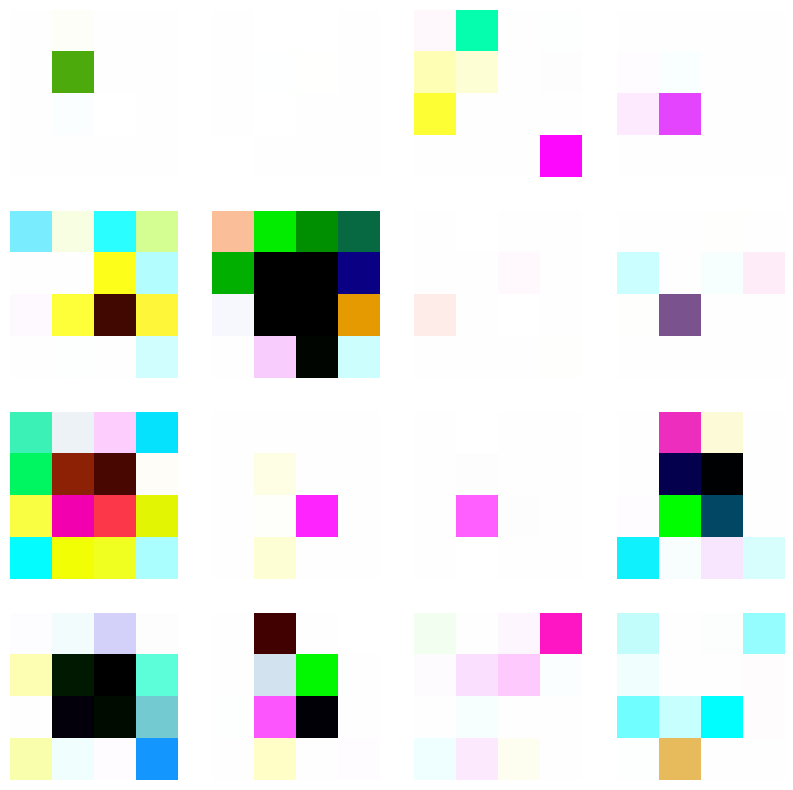

Step: 49
Alpha: 0.3558520989713653
Current Resolution: 4
Discriminator loss : -1.9982309341430664
Generator loss: 4.455705165863037


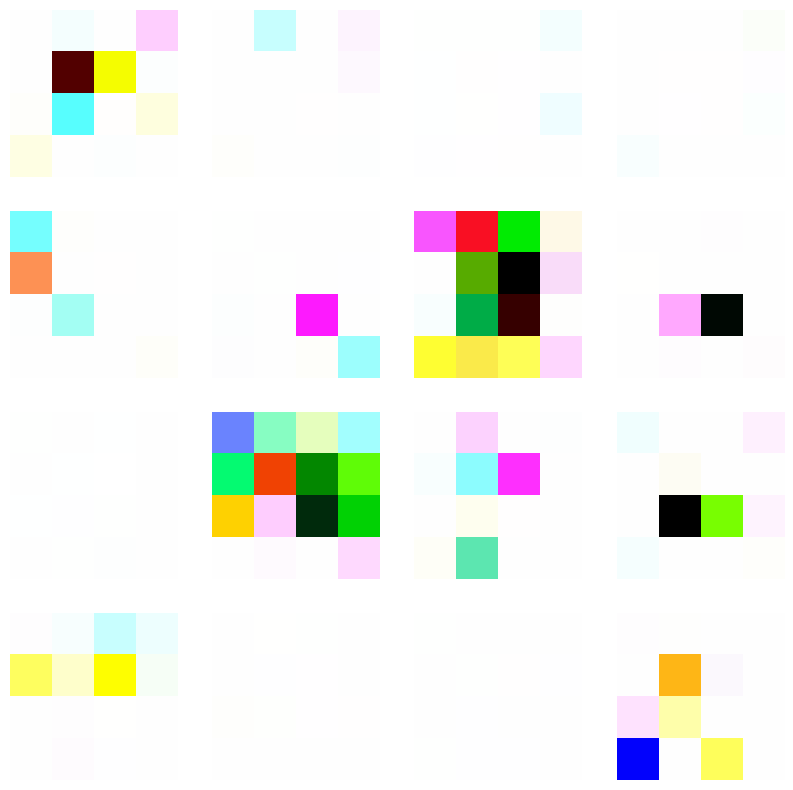

Step: 50
Alpha: 0.36296914095079263
Current Resolution: 4
Discriminator loss : -2.0067577362060547
Generator loss: 4.472086429595947


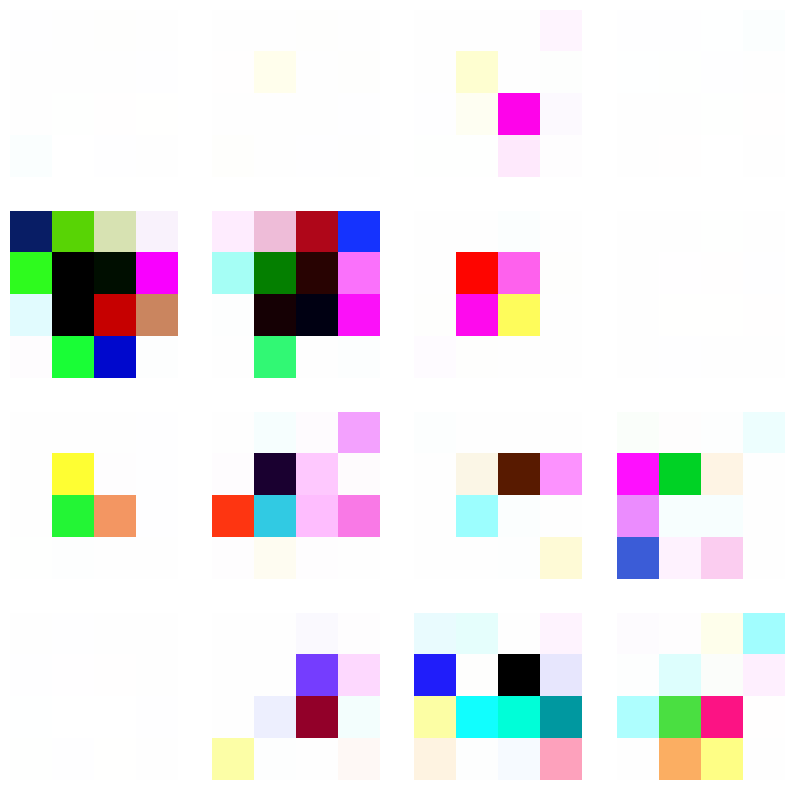

Step: 51
Alpha: 0.37008618293021994
Current Resolution: 4
Discriminator loss : -2.016873598098755
Generator loss: 4.525204658508301


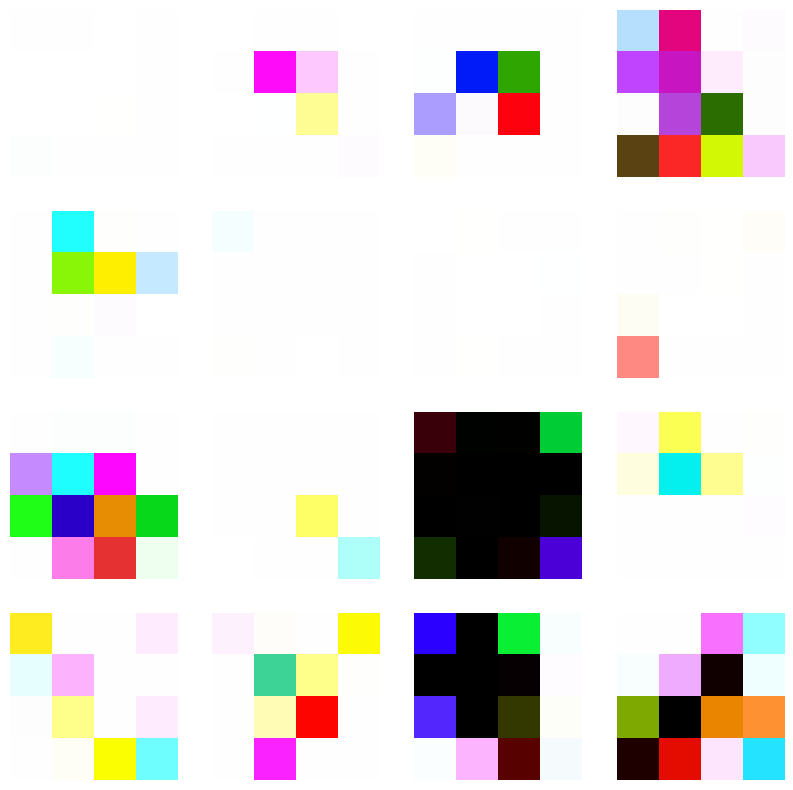

Step: 52
Alpha: 0.37720322490964725
Current Resolution: 4
Discriminator loss : -2.029097557067871
Generator loss: 4.550876140594482


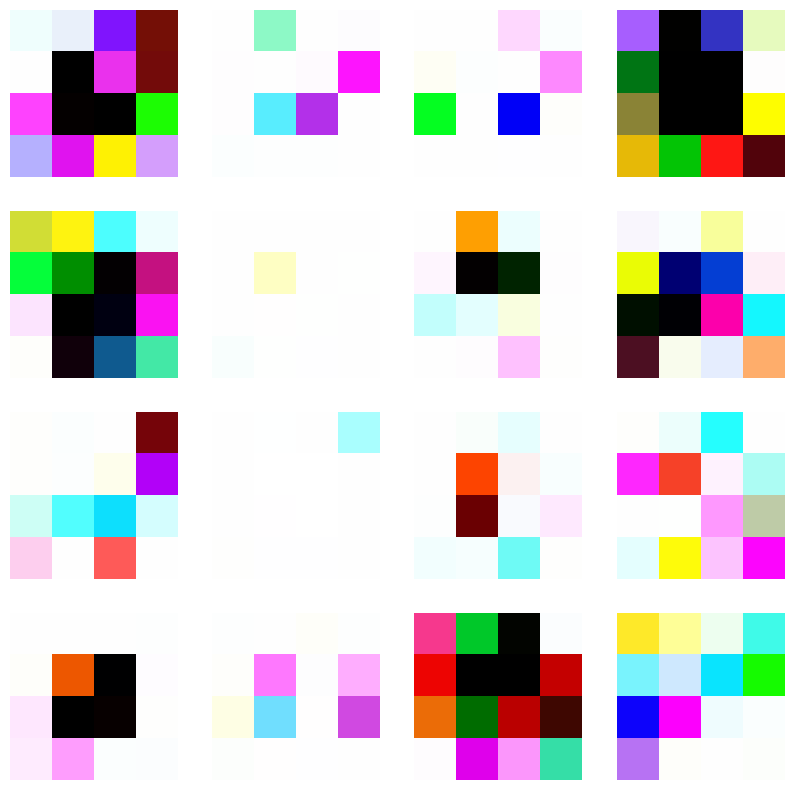

Step: 53
Alpha: 0.38432026688907456
Current Resolution: 4
Discriminator loss : -2.0397064685821533
Generator loss: 4.591483116149902


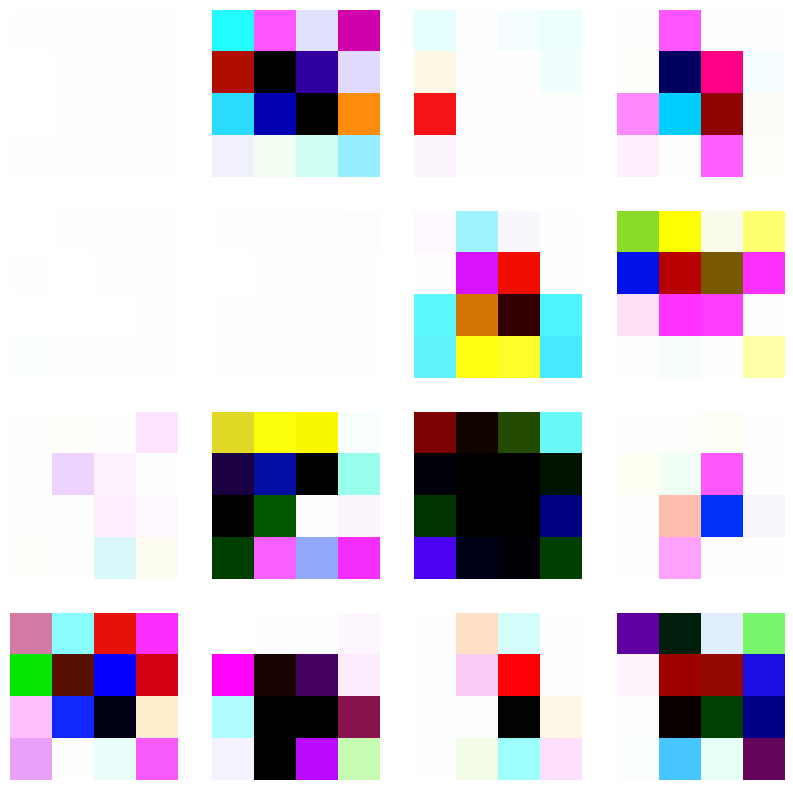

Step: 54
Alpha: 0.39143730886850187
Current Resolution: 4
Discriminator loss : -2.054948329925537
Generator loss: 4.623568534851074


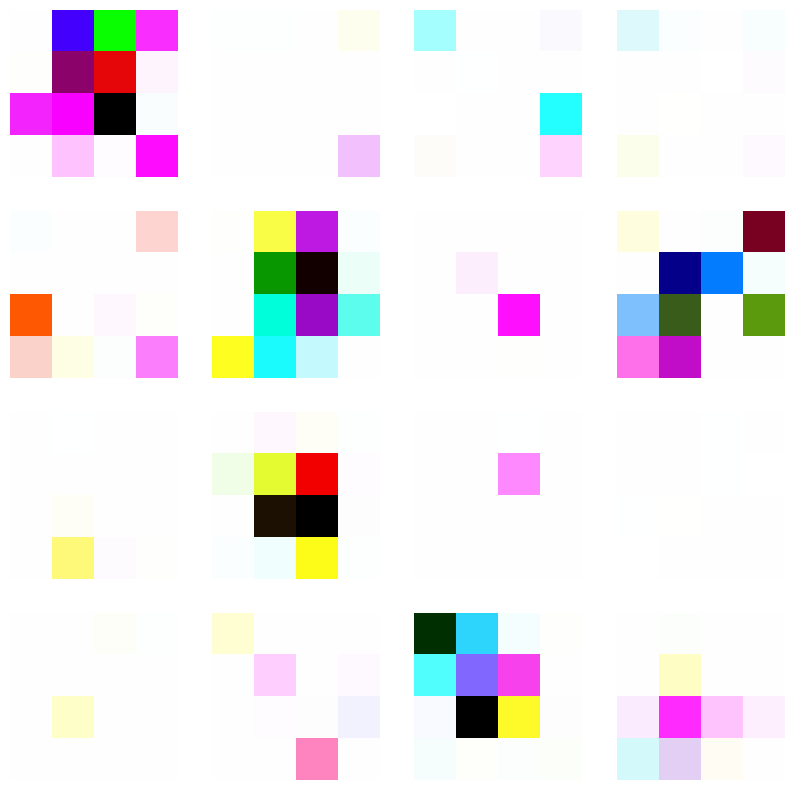

Step: 55
Alpha: 0.3985543508479292
Current Resolution: 4
Discriminator loss : -2.0705931186676025
Generator loss: 4.656611919403076


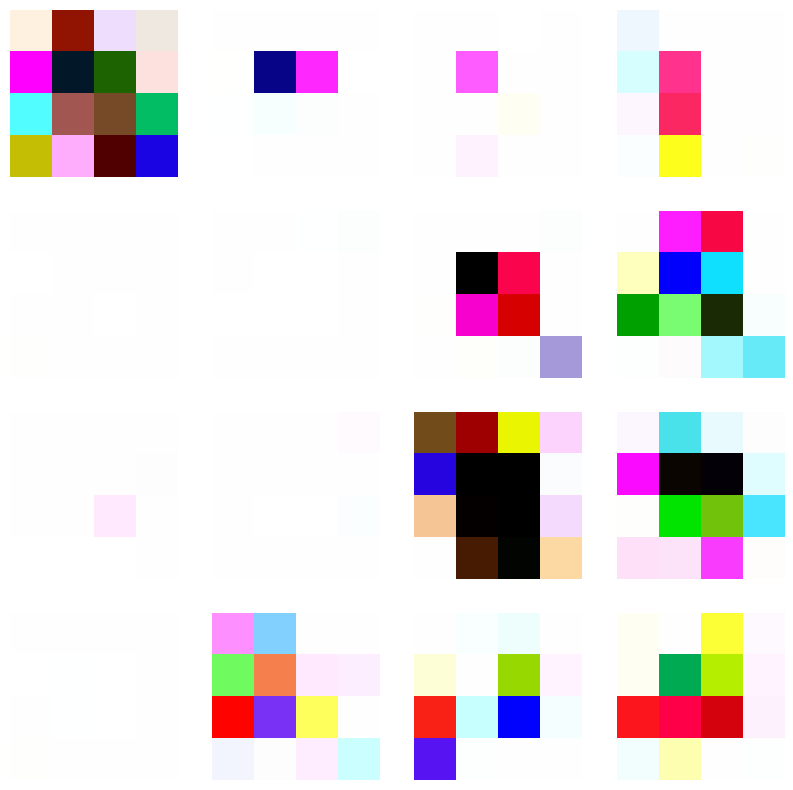

Step: 56
Alpha: 0.4056713928273565
Current Resolution: 4
Discriminator loss : -2.0848495960235596
Generator loss: 4.6846208572387695


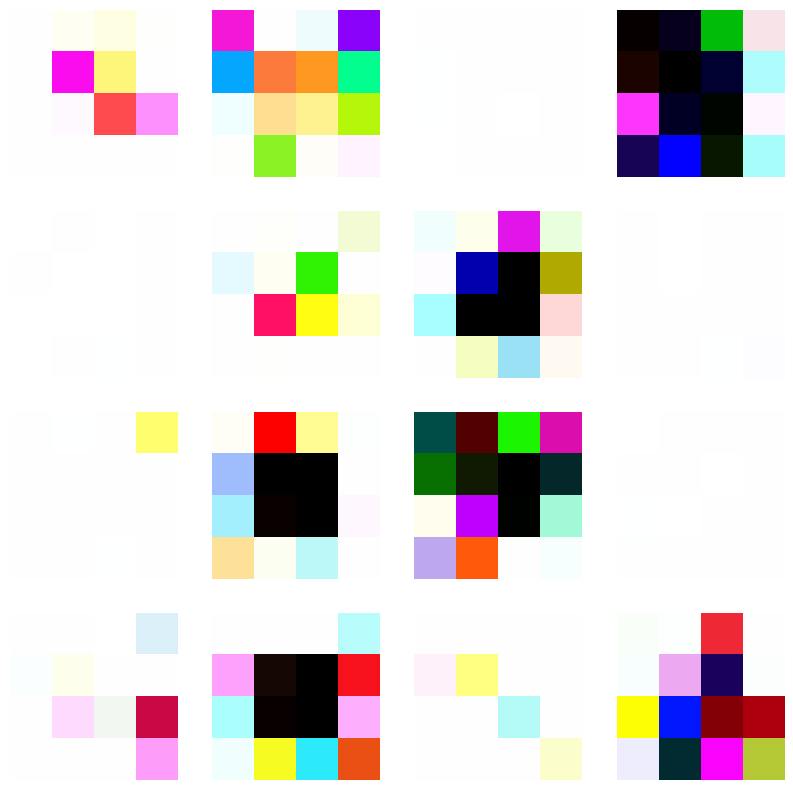

Step: 57
Alpha: 0.4127884348067838
Current Resolution: 4
Discriminator loss : -2.0979413986206055
Generator loss: 4.71818733215332


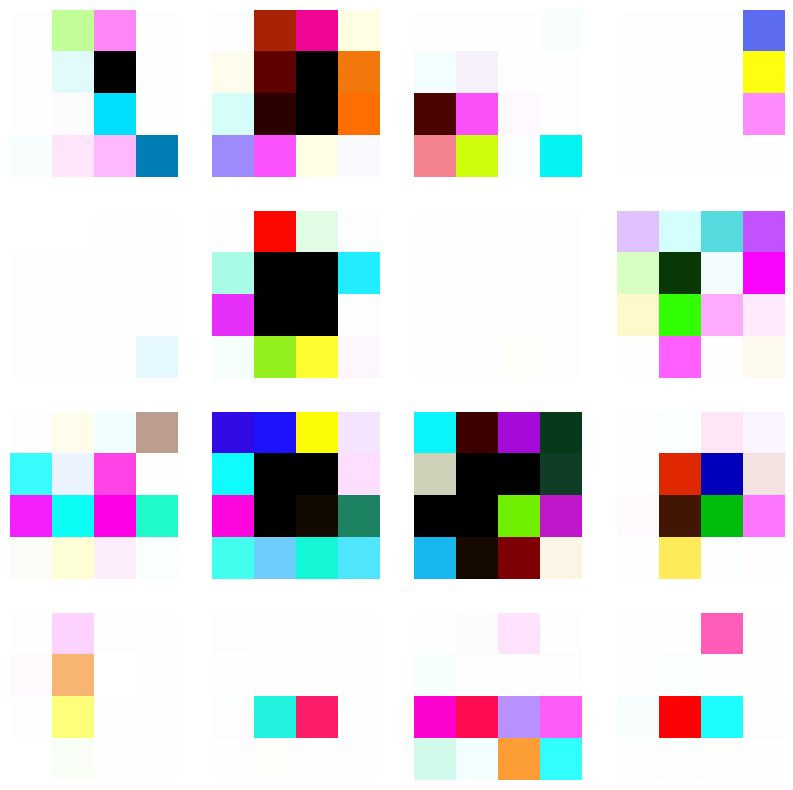

Step: 58
Alpha: 0.4199054767862111
Current Resolution: 4
Discriminator loss : -2.1115241050720215
Generator loss: 4.743983745574951


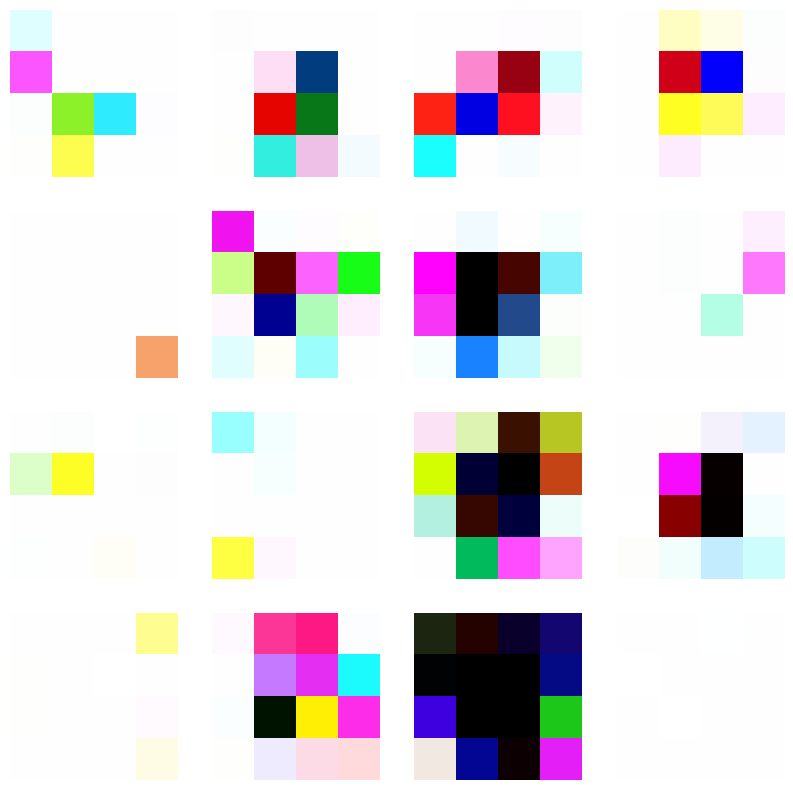

Step: 59
Alpha: 0.4270225187656384
Current Resolution: 4
Discriminator loss : -2.1228673458099365
Generator loss: 4.773092746734619


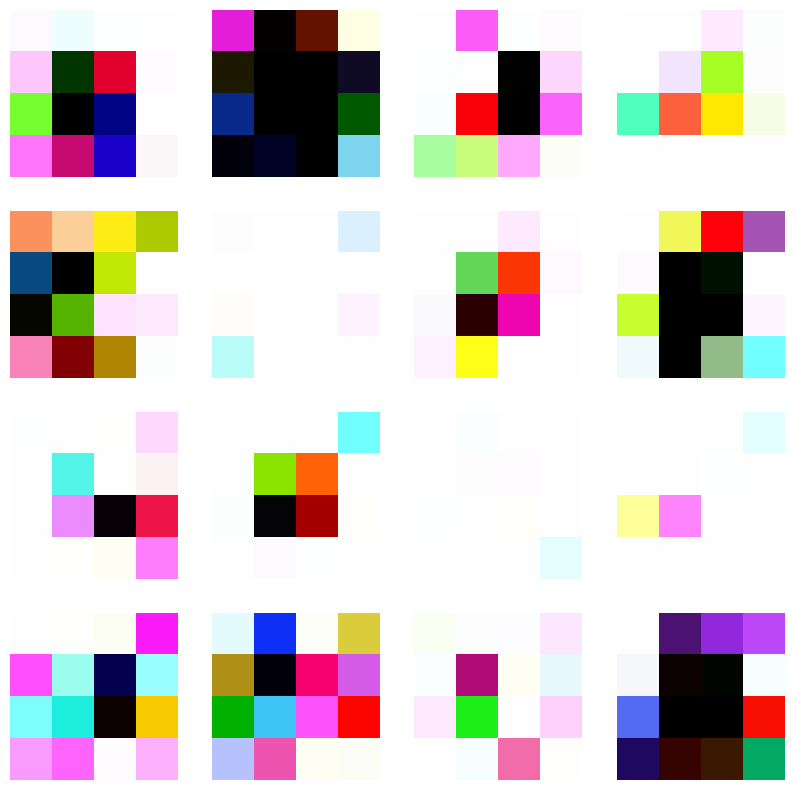

Step: 60
Alpha: 0.4341395607450657
Current Resolution: 4
Discriminator loss : -2.1359949111938477
Generator loss: 4.801164627075195


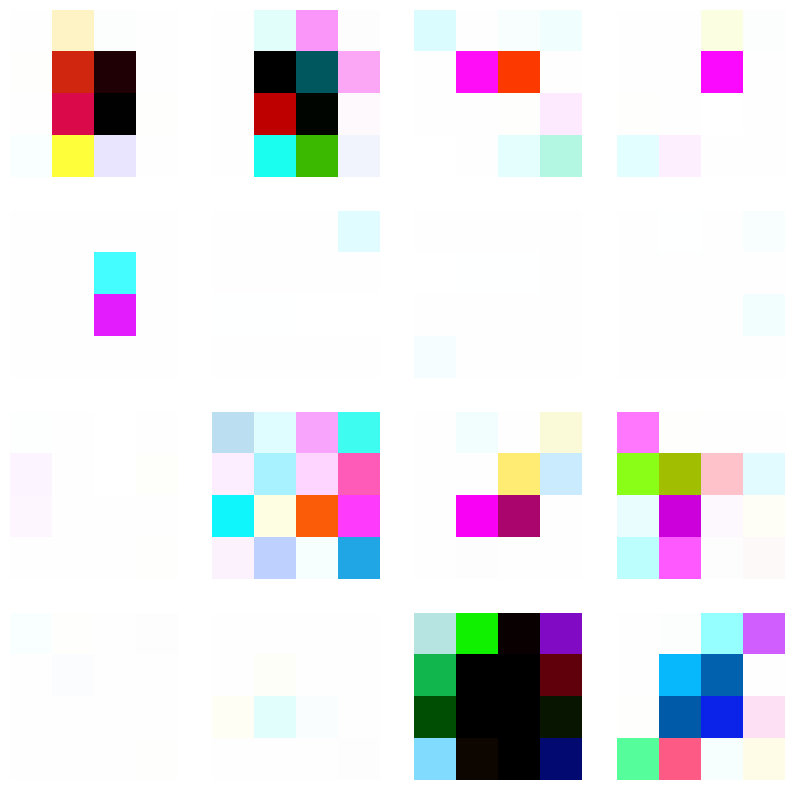

Step: 61
Alpha: 0.441256602724493
Current Resolution: 4
Discriminator loss : -2.1494383811950684
Generator loss: 4.828636646270752


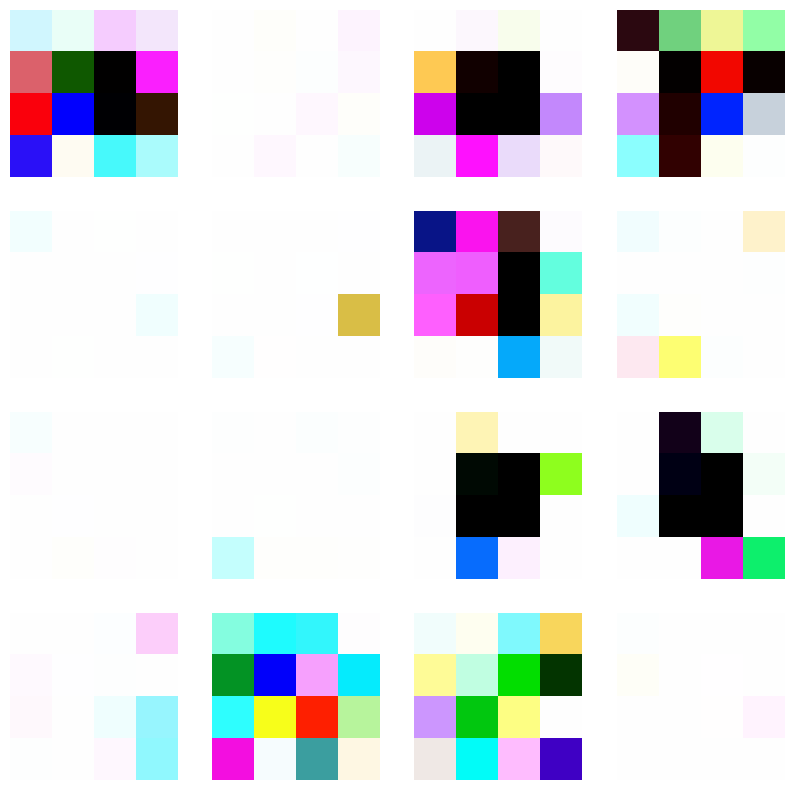

Step: 62
Alpha: 0.4483736447039203
Current Resolution: 4
Discriminator loss : -2.1594409942626953
Generator loss: 4.850790023803711


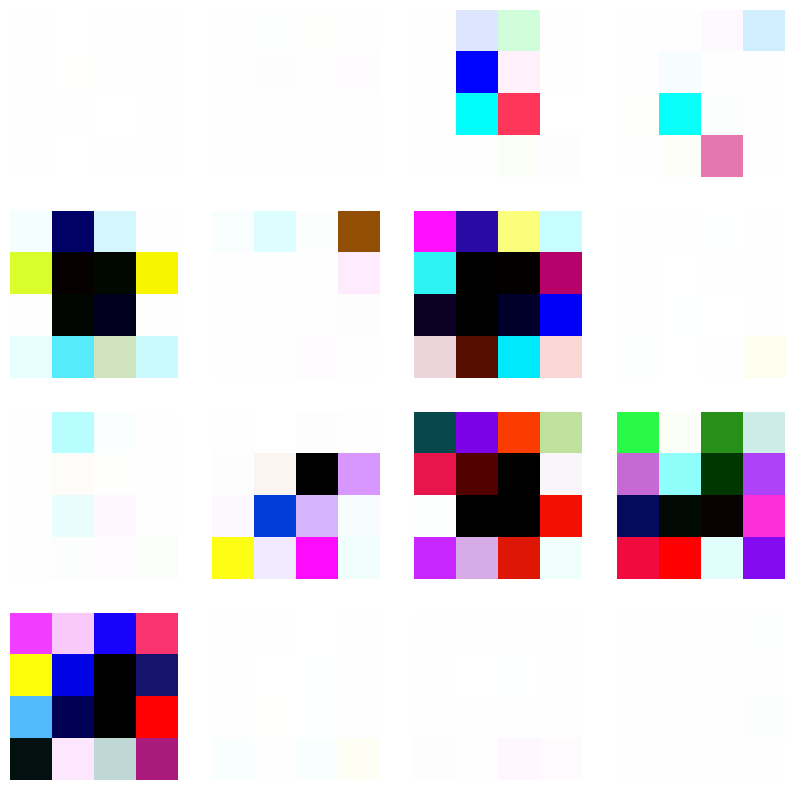

Step: 63
Alpha: 0.45549068668334763
Current Resolution: 4
Discriminator loss : -2.1709141731262207
Generator loss: 4.880463600158691


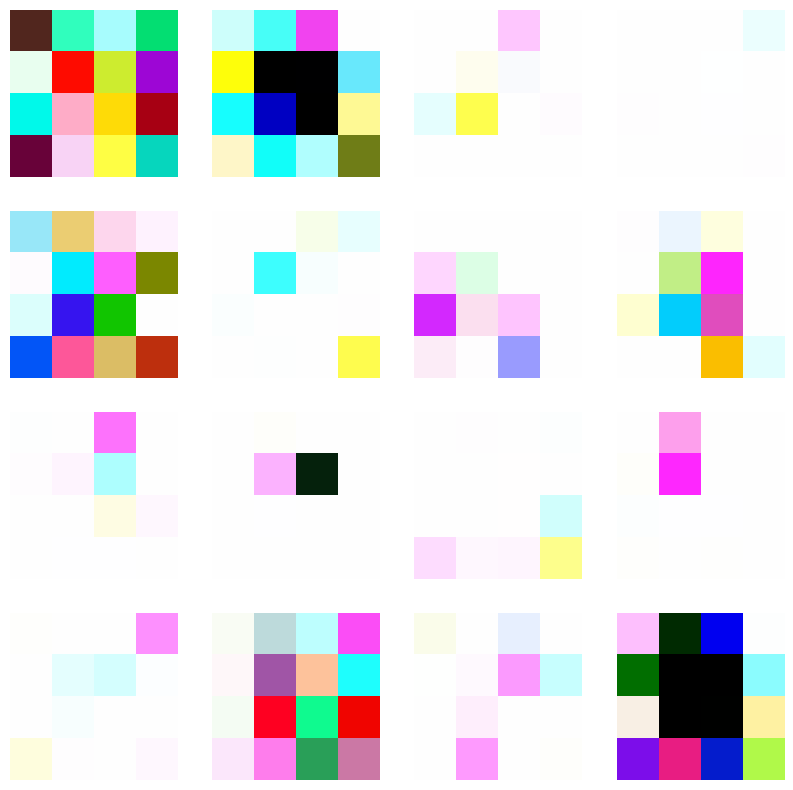

Step: 64
Alpha: 0.46260772866277494
Current Resolution: 4
Discriminator loss : -2.180178642272949
Generator loss: 4.895528793334961


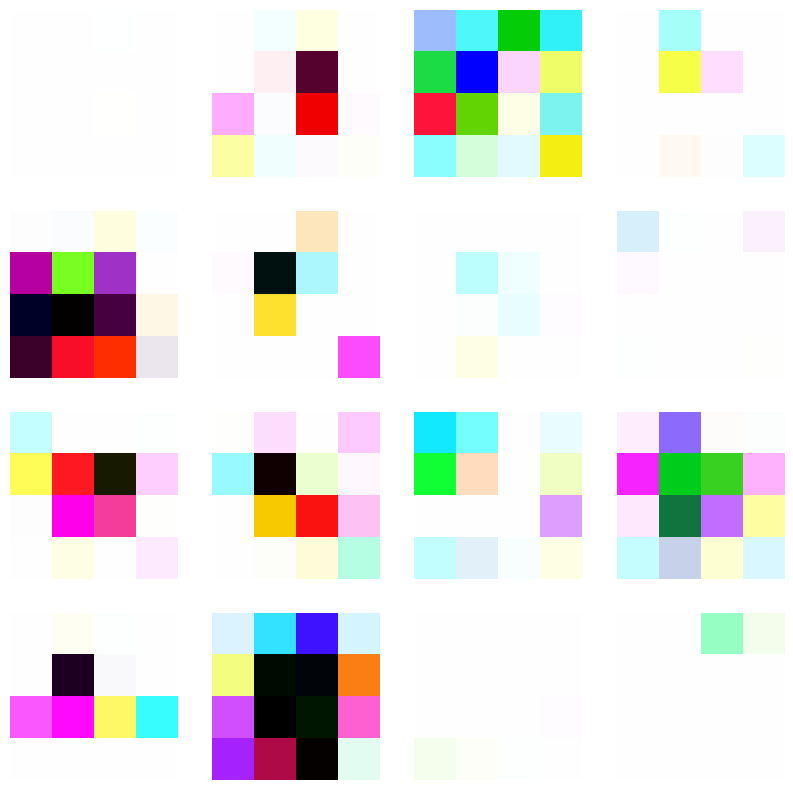

Step: 65
Alpha: 0.46972477064220225
Current Resolution: 4
Discriminator loss : -2.1894330978393555
Generator loss: 4.924221992492676


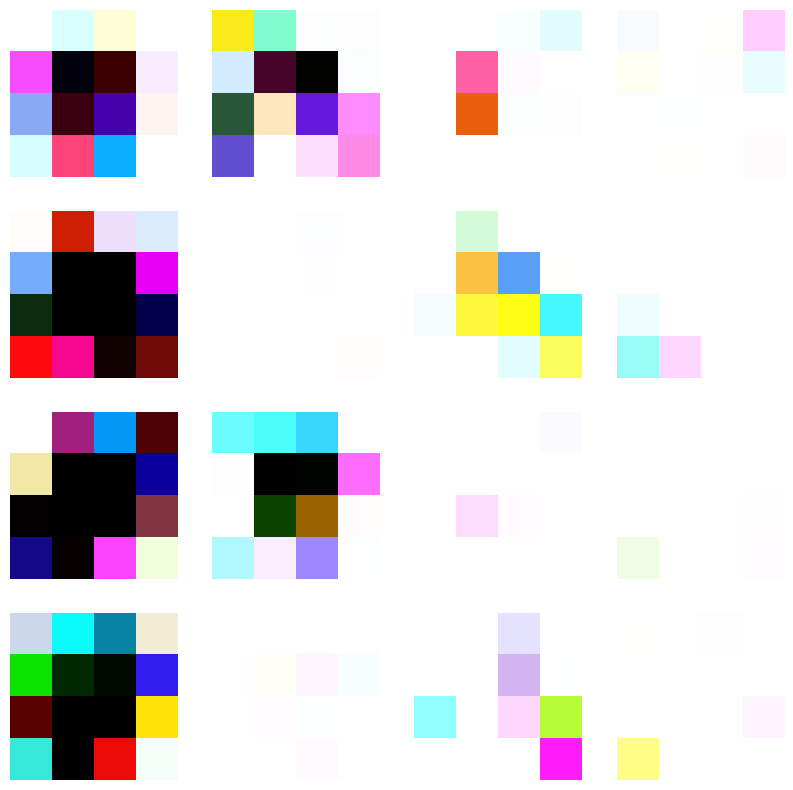

Step: 66
Alpha: 0.47684181262162956
Current Resolution: 4
Discriminator loss : -2.1972296237945557
Generator loss: 4.939126968383789


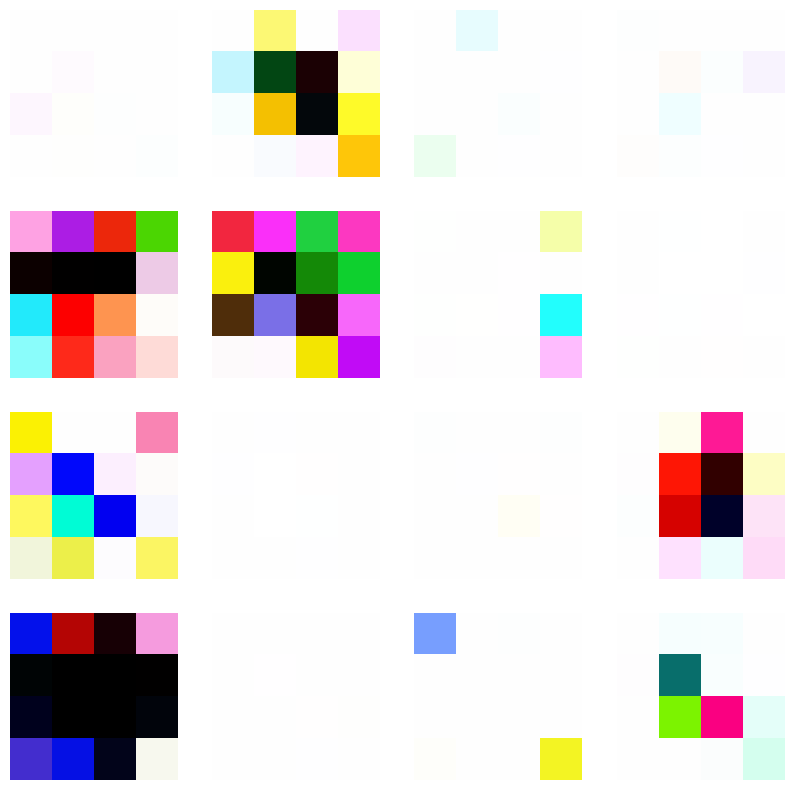

Step: 67
Alpha: 0.48395885460105686
Current Resolution: 4
Discriminator loss : -2.2066779136657715
Generator loss: 4.966506004333496


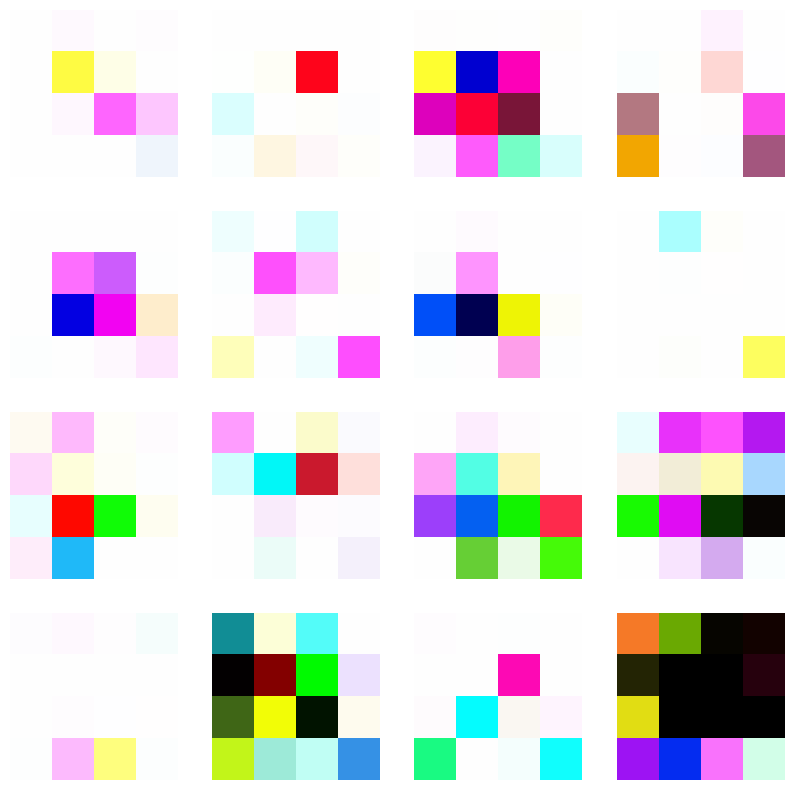

Step: 68
Alpha: 0.4910758965804842
Current Resolution: 4
Discriminator loss : -2.2153775691986084
Generator loss: 4.982365131378174


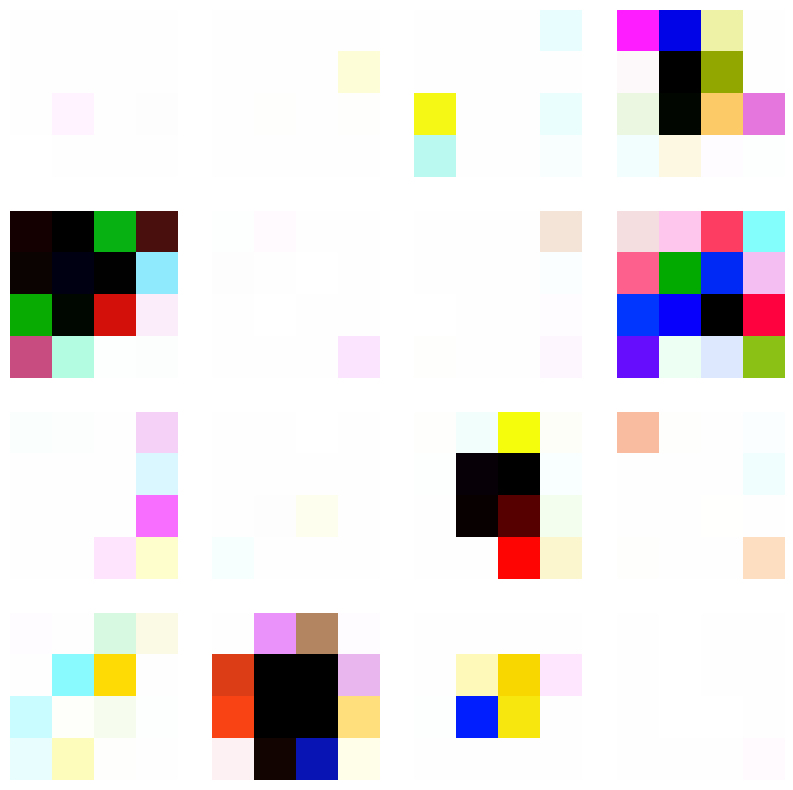

Step: 69
Alpha: 0.4981929385599115
Current Resolution: 4
Discriminator loss : -2.2238266468048096
Generator loss: 5.008083343505859


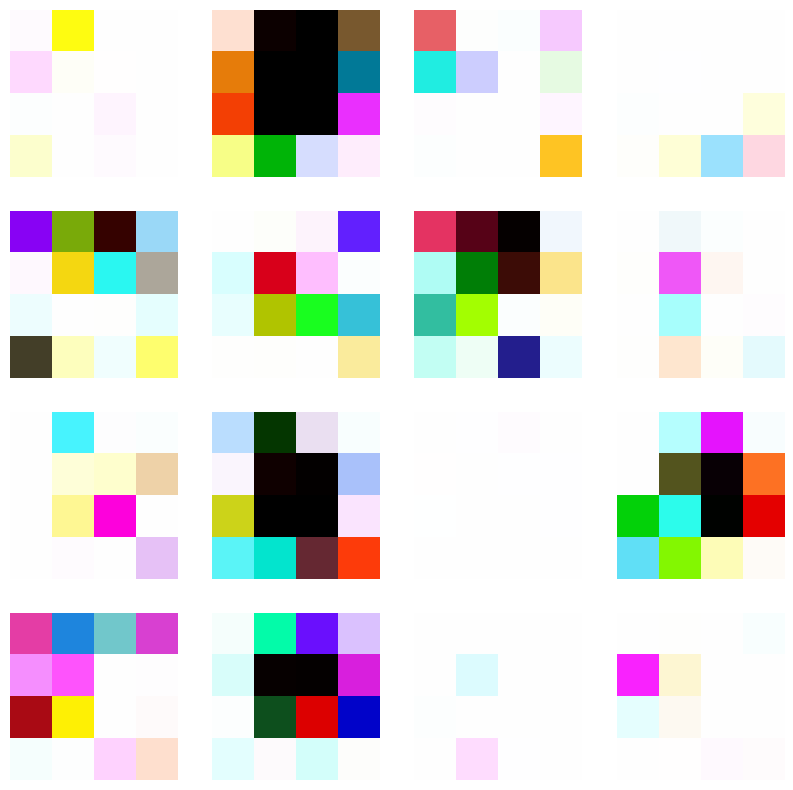

Step: 70
Alpha: 0.5053099805393387
Current Resolution: 4
Discriminator loss : -2.2330644130706787
Generator loss: 5.022061347961426


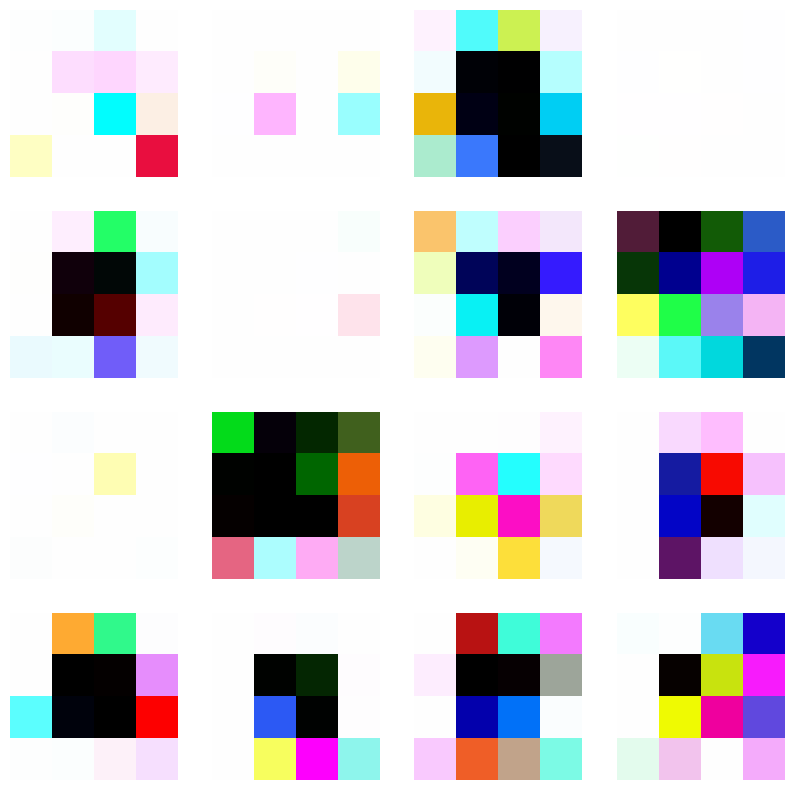

Step: 71
Alpha: 0.512427022518766
Current Resolution: 4
Discriminator loss : -2.2413761615753174
Generator loss: 5.043581008911133


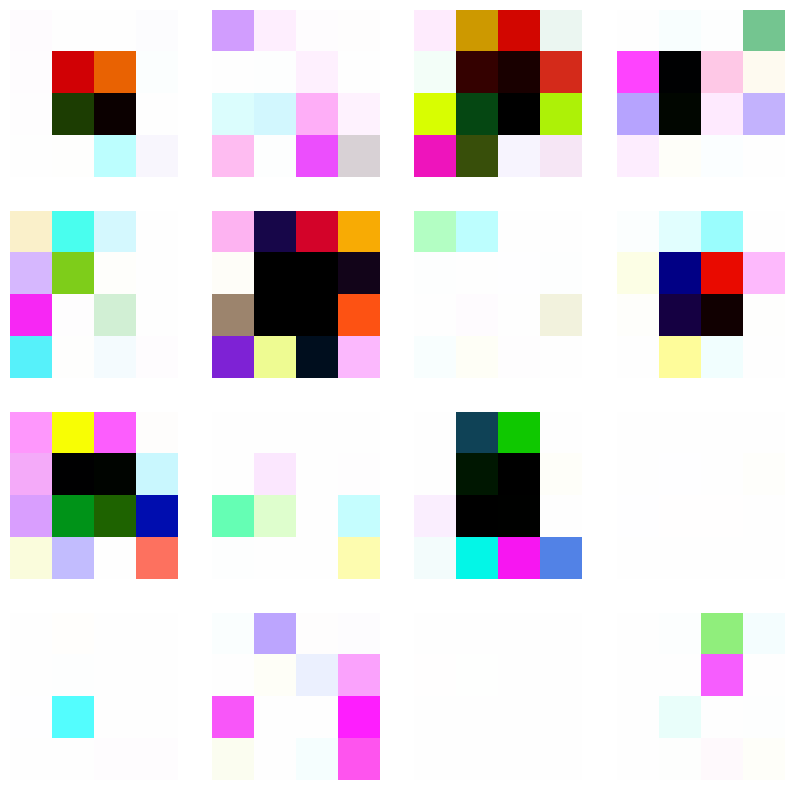

Step: 72
Alpha: 0.5195440644981933
Current Resolution: 4
Discriminator loss : -2.247781991958618
Generator loss: 5.056624889373779


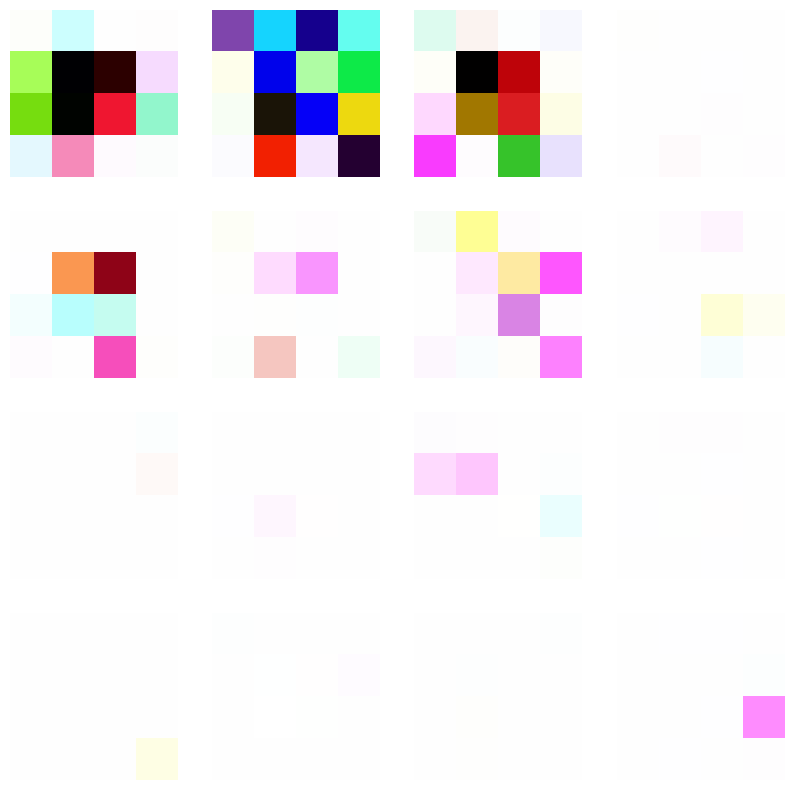

Step: 73
Alpha: 0.5266611064776207
Current Resolution: 4
Discriminator loss : -2.2537882328033447
Generator loss: 5.0764479637146


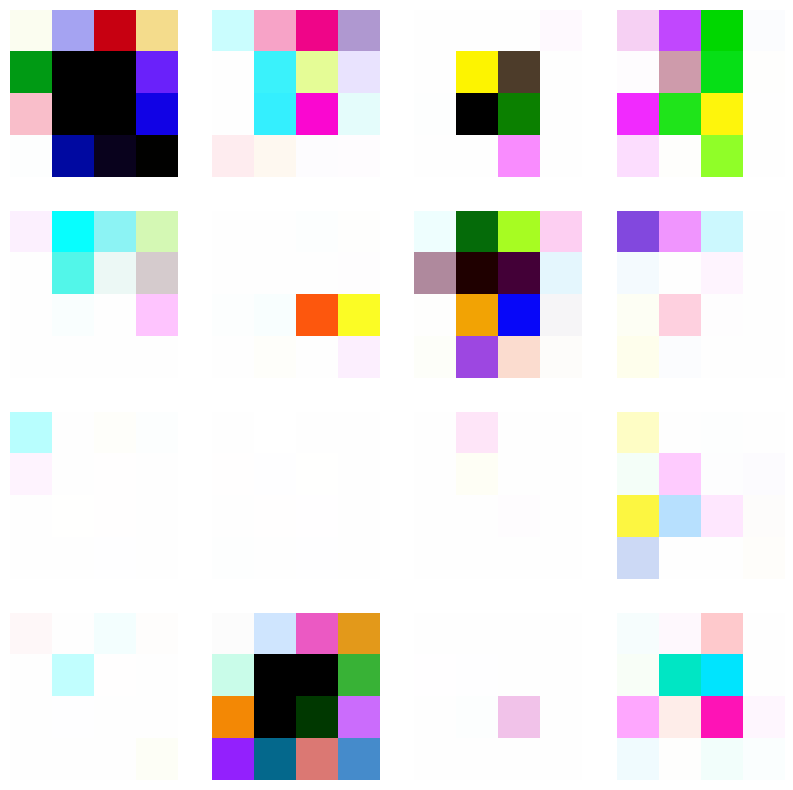

Step: 74
Alpha: 0.533778148457048
Current Resolution: 4
Discriminator loss : -2.2615671157836914
Generator loss: 5.0902419090271


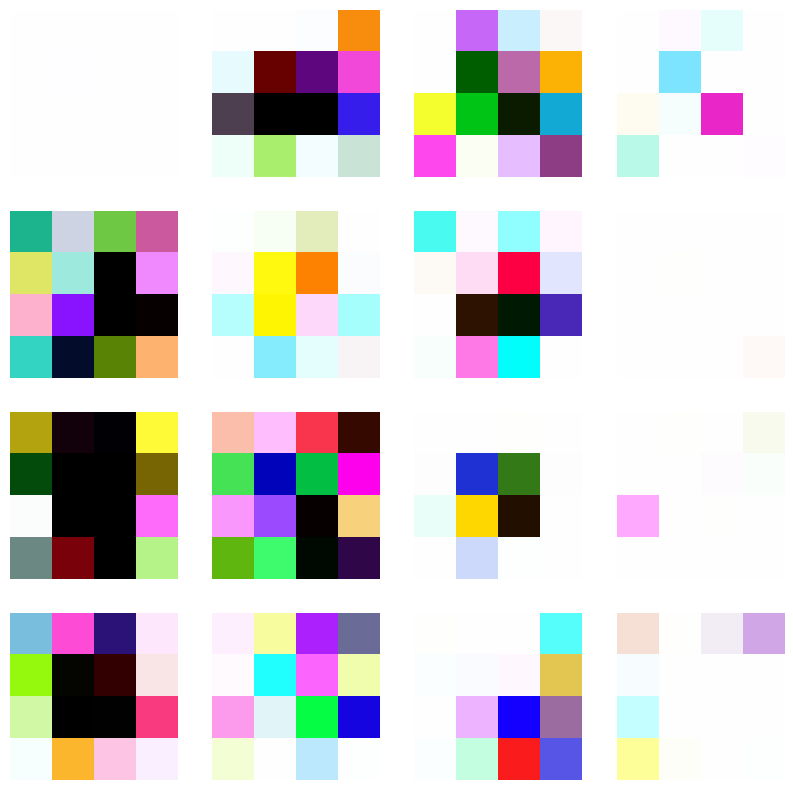

Step: 75
Alpha: 0.5408951904364753
Current Resolution: 4
Discriminator loss : -2.268193006515503
Generator loss: 5.10560417175293


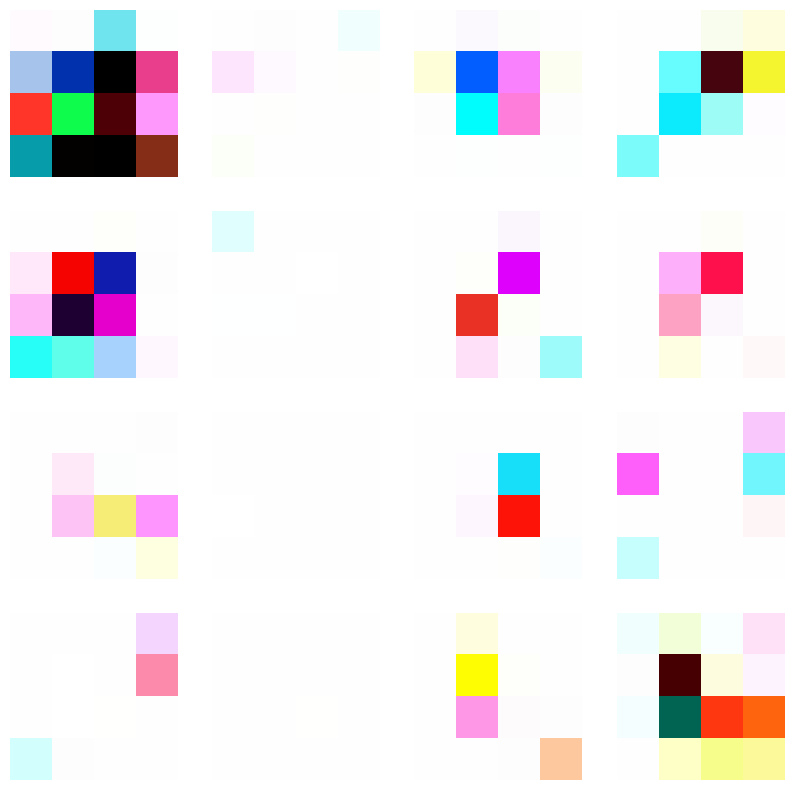

Step: 76
Alpha: 0.5480122324159026
Current Resolution: 4
Discriminator loss : -2.2729883193969727
Generator loss: 5.117835521697998


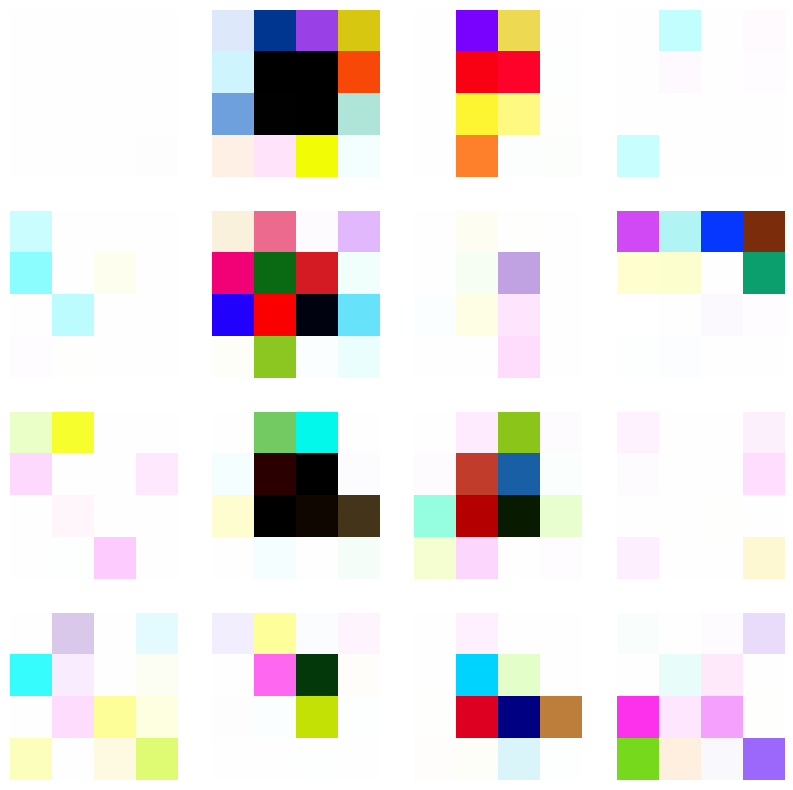

Step: 77
Alpha: 0.5551292743953299
Current Resolution: 4
Discriminator loss : -2.2769010066986084
Generator loss: 5.132176399230957


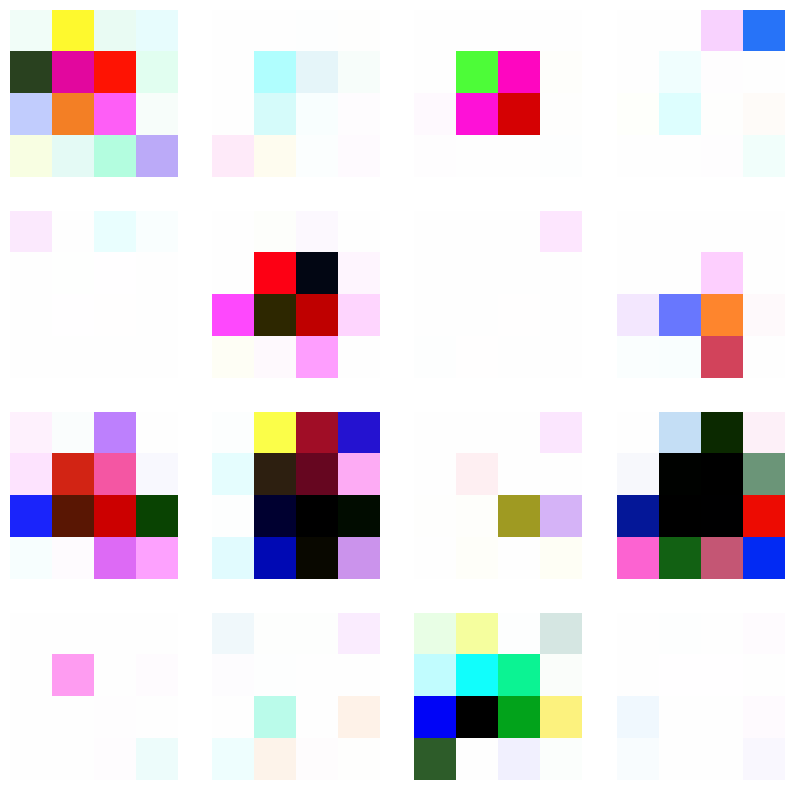

Step: 78
Alpha: 0.5622463163747572
Current Resolution: 4
Discriminator loss : -2.2819087505340576
Generator loss: 5.1448516845703125


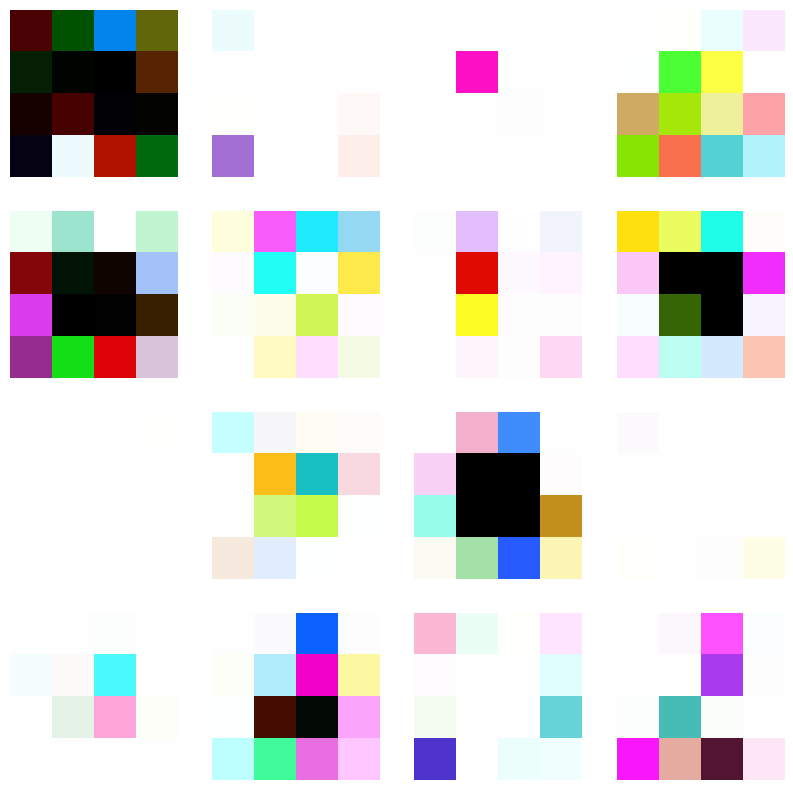

Step: 79
Alpha: 0.5693633583541845
Current Resolution: 4
Discriminator loss : -2.2869038581848145
Generator loss: 5.155518531799316


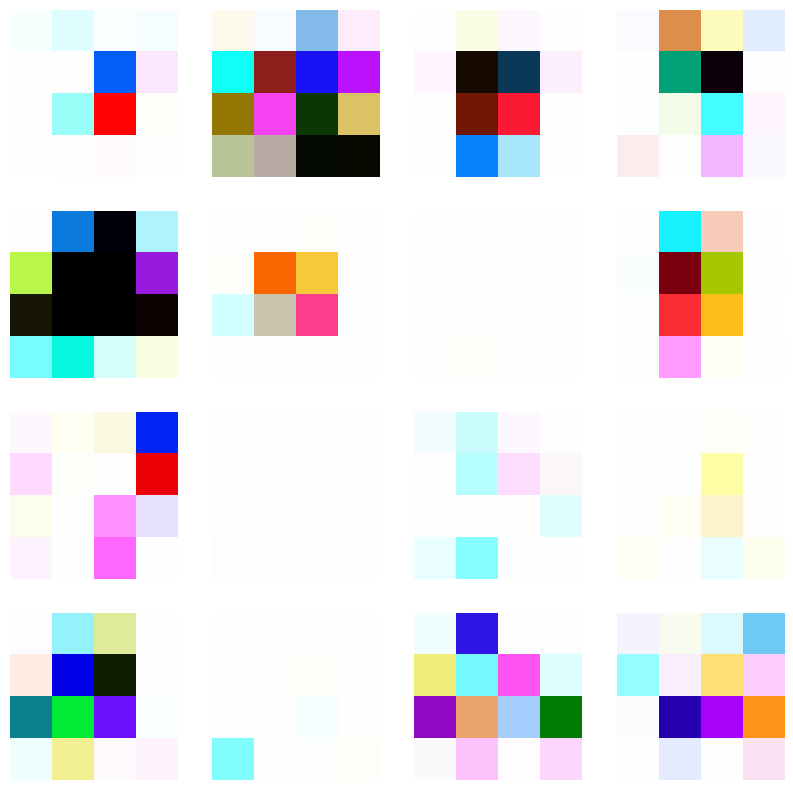

Step: 80
Alpha: 0.5764804003336118
Current Resolution: 4
Discriminator loss : -2.290651559829712
Generator loss: 5.17237663269043


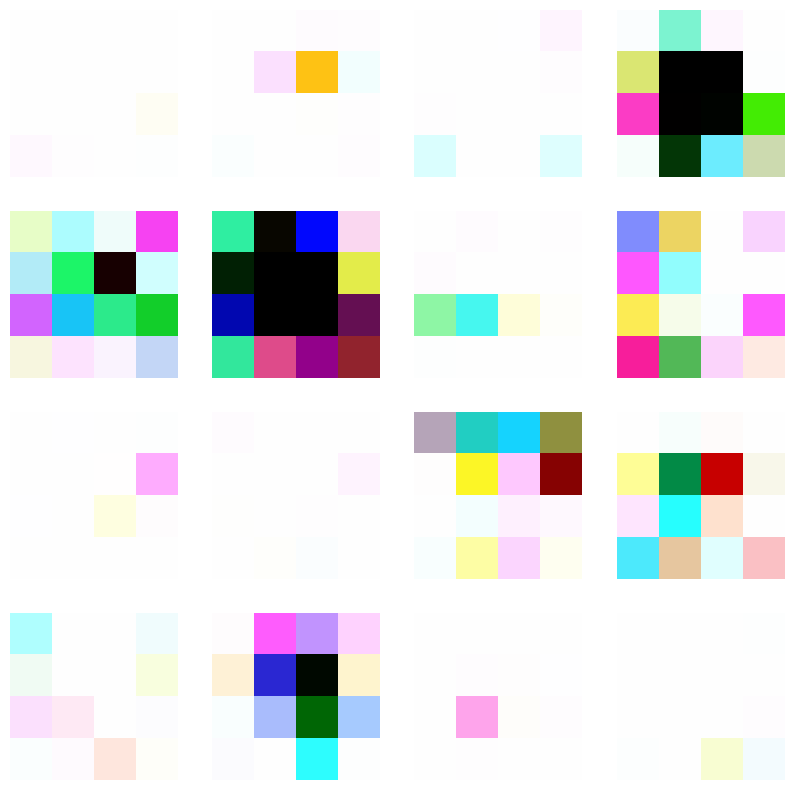

Step: 81
Alpha: 0.5835974423130391
Current Resolution: 4
Discriminator loss : -2.294574022293091
Generator loss: 5.180532455444336


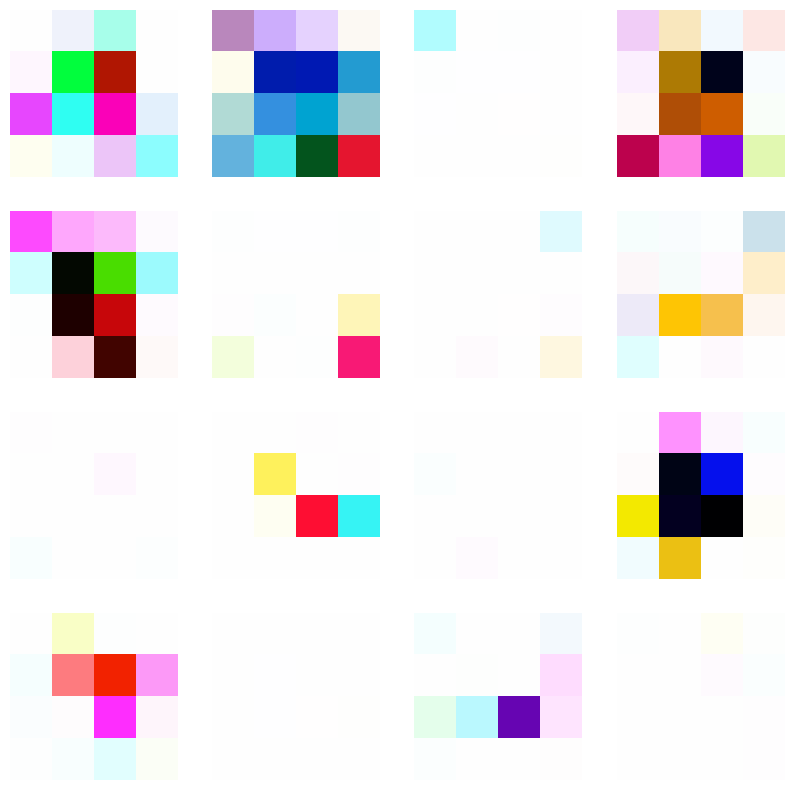

Step: 82
Alpha: 0.5907144842924664
Current Resolution: 4
Discriminator loss : -2.2986984252929688
Generator loss: 5.196511268615723


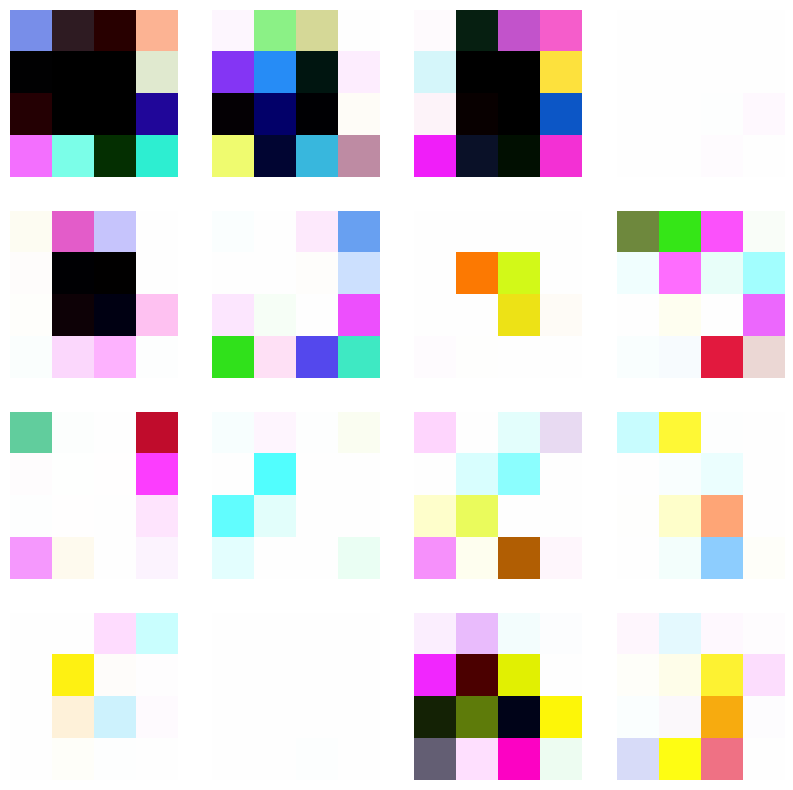

Step: 83
Alpha: 0.5978315262718937
Current Resolution: 4
Discriminator loss : -2.301128387451172
Generator loss: 5.200753688812256


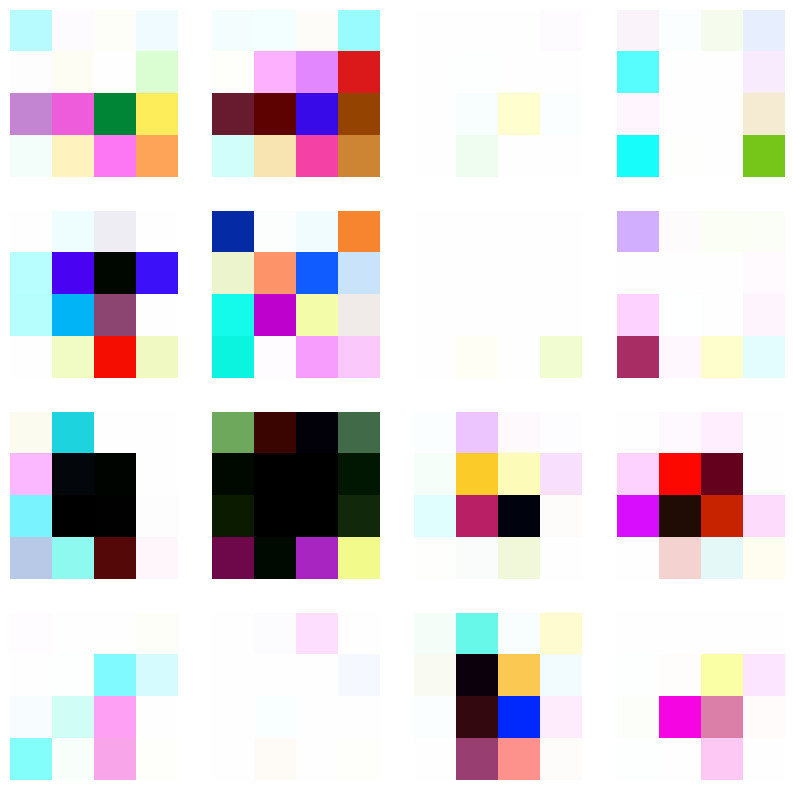

Step: 84
Alpha: 0.604948568251321
Current Resolution: 4
Discriminator loss : -2.3037919998168945
Generator loss: 5.215714454650879


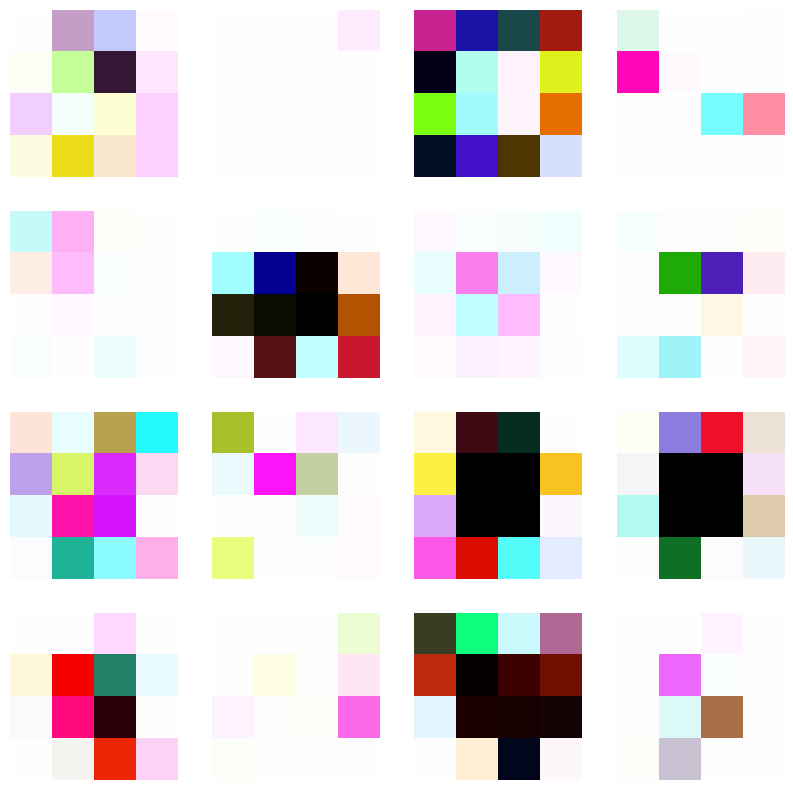

Step: 85
Alpha: 0.6120656102307483
Current Resolution: 4
Discriminator loss : -2.3083112239837646
Generator loss: 5.221680641174316


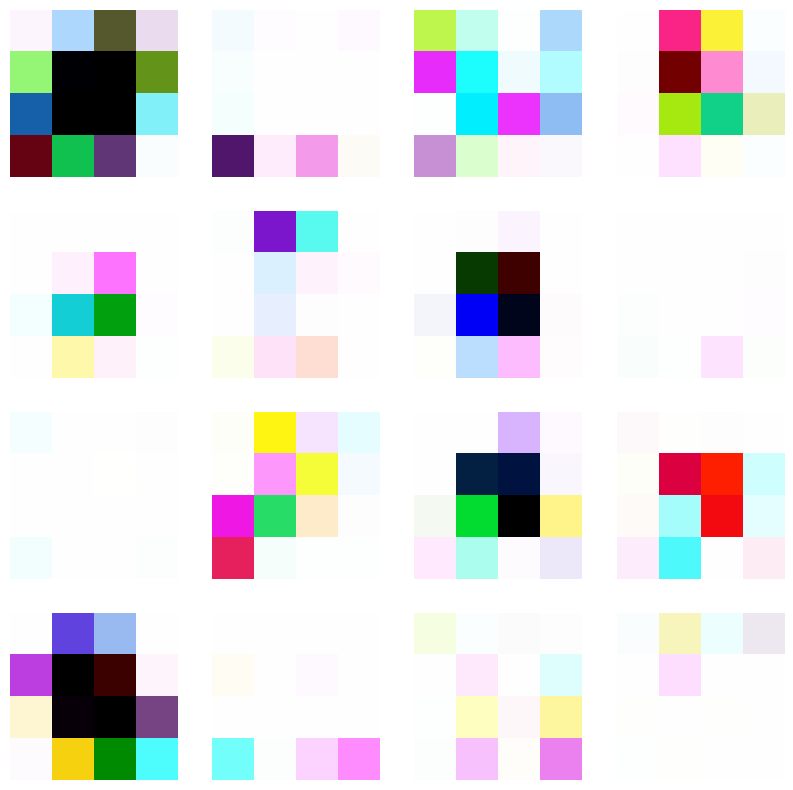

Step: 86
Alpha: 0.6191826522101757
Current Resolution: 4
Discriminator loss : -2.311093807220459
Generator loss: 5.236388683319092


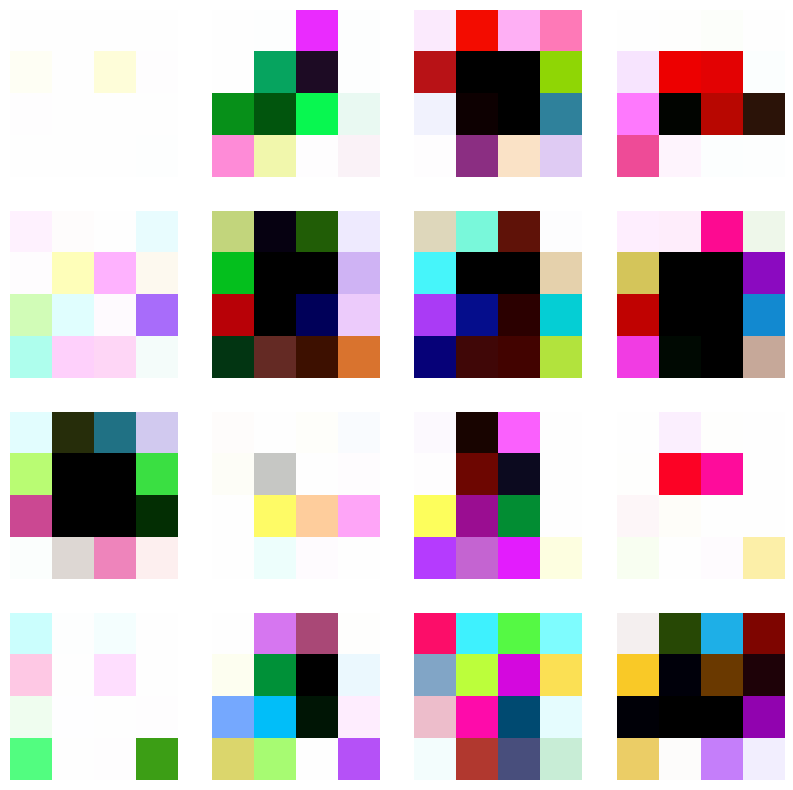

Step: 87
Alpha: 0.626299694189603
Current Resolution: 4
Discriminator loss : -2.313100814819336
Generator loss: 5.238072395324707


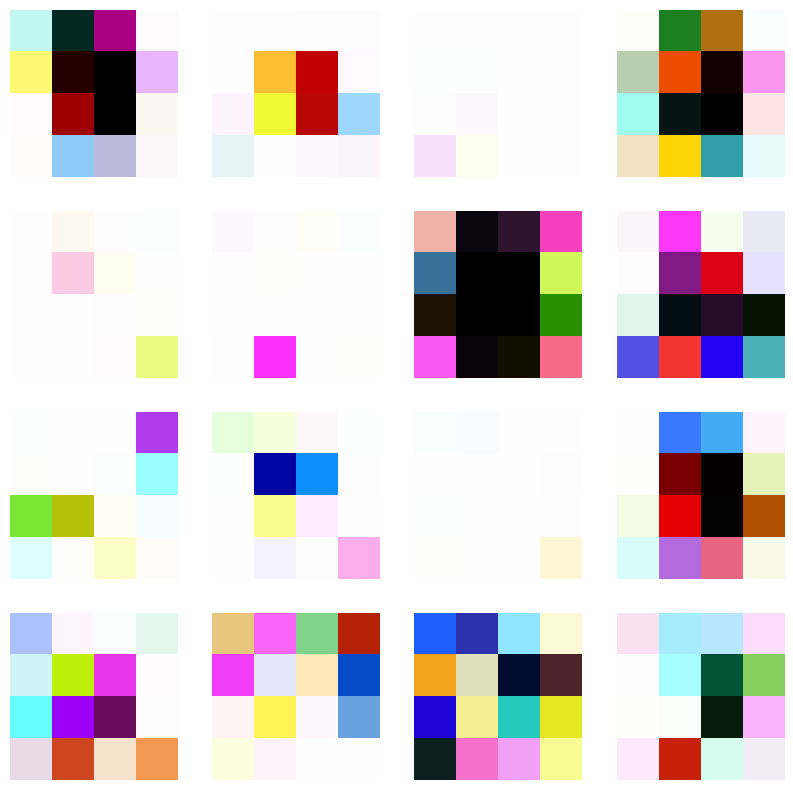

Step: 88
Alpha: 0.6334167361690303
Current Resolution: 4
Discriminator loss : -2.3150112628936768
Generator loss: 5.247666358947754


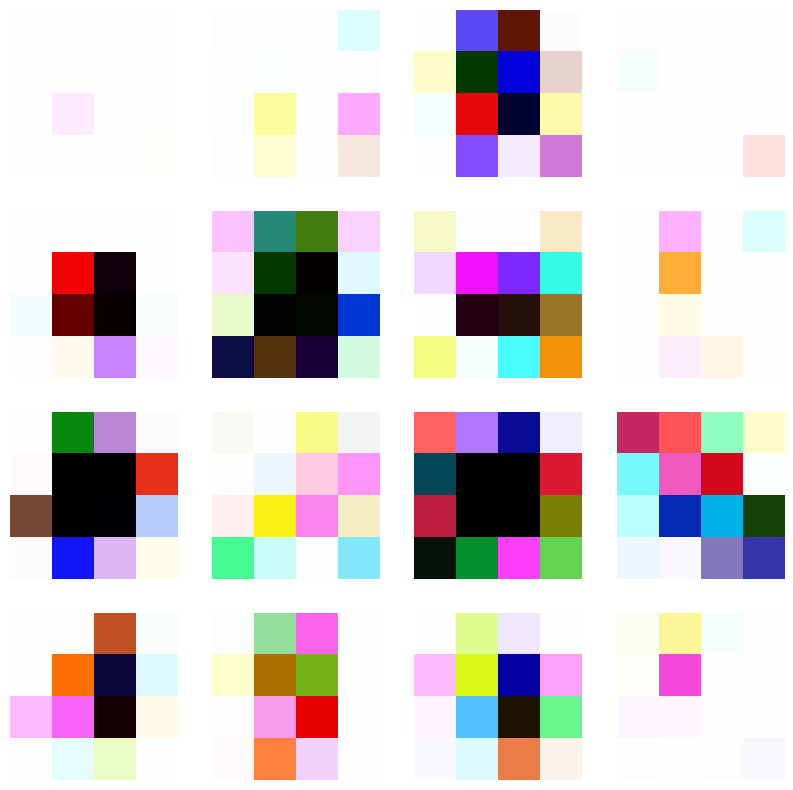

Step: 89
Alpha: 0.6405337781484576
Current Resolution: 4
Discriminator loss : -2.315418004989624
Generator loss: 5.24905252456665


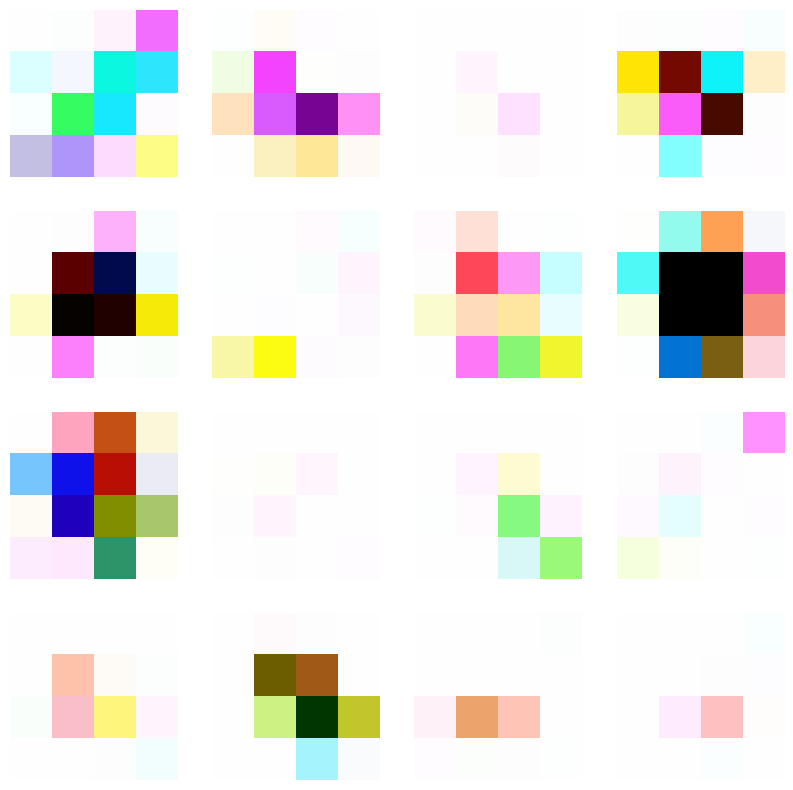

Step: 90
Alpha: 0.6476508201278849
Current Resolution: 4
Discriminator loss : -2.3146228790283203
Generator loss: 5.2598748207092285


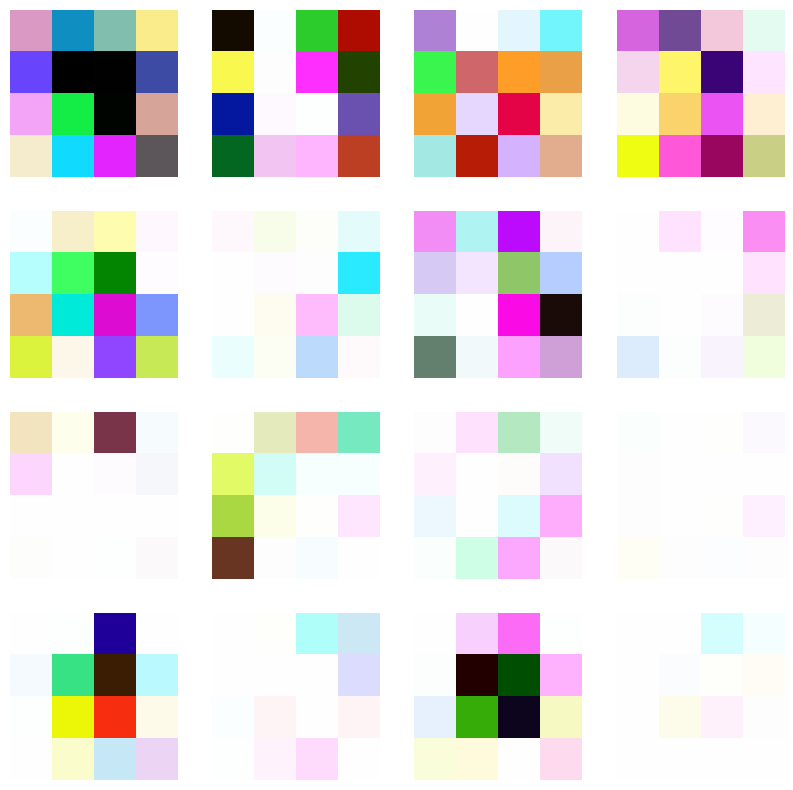

Step: 91
Alpha: 0.6547678621073122
Current Resolution: 4
Discriminator loss : -2.3145008087158203
Generator loss: 5.260900020599365


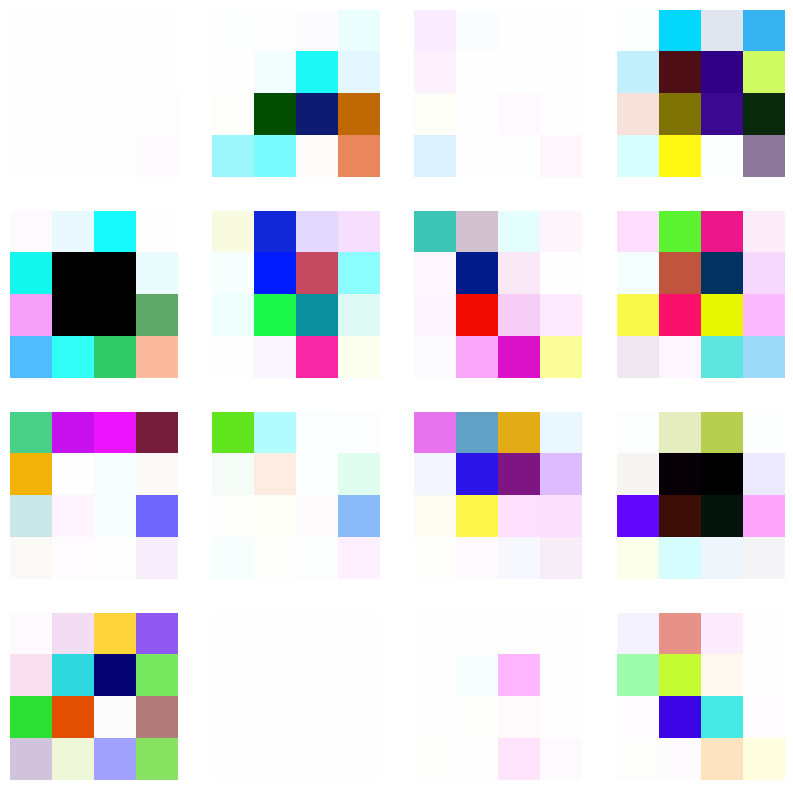

Step: 92
Alpha: 0.6618849040867395
Current Resolution: 4
Discriminator loss : -2.3150112628936768
Generator loss: 5.27190637588501


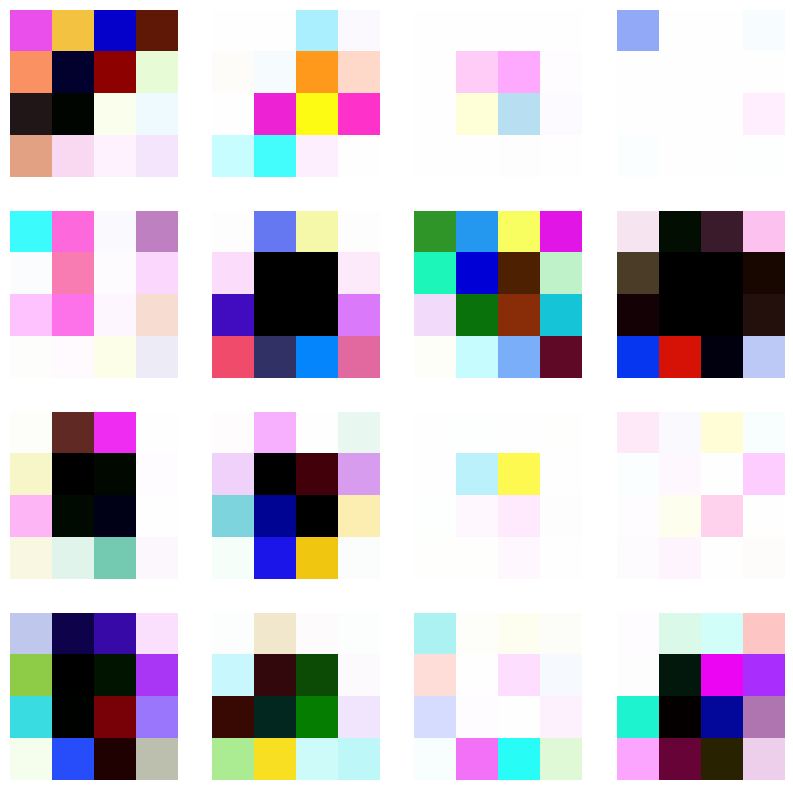

Step: 93
Alpha: 0.6690019460661668
Current Resolution: 4
Discriminator loss : -2.315403461456299
Generator loss: 5.268027305603027


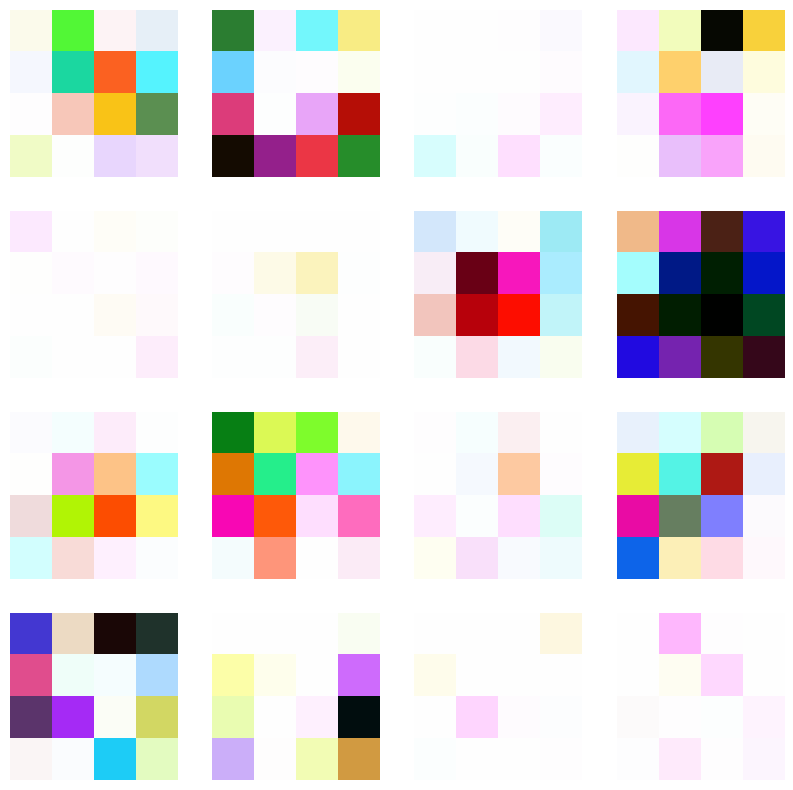

Step: 94
Alpha: 0.6761189880455941
Current Resolution: 4
Discriminator loss : -2.313356637954712
Generator loss: 5.273615837097168


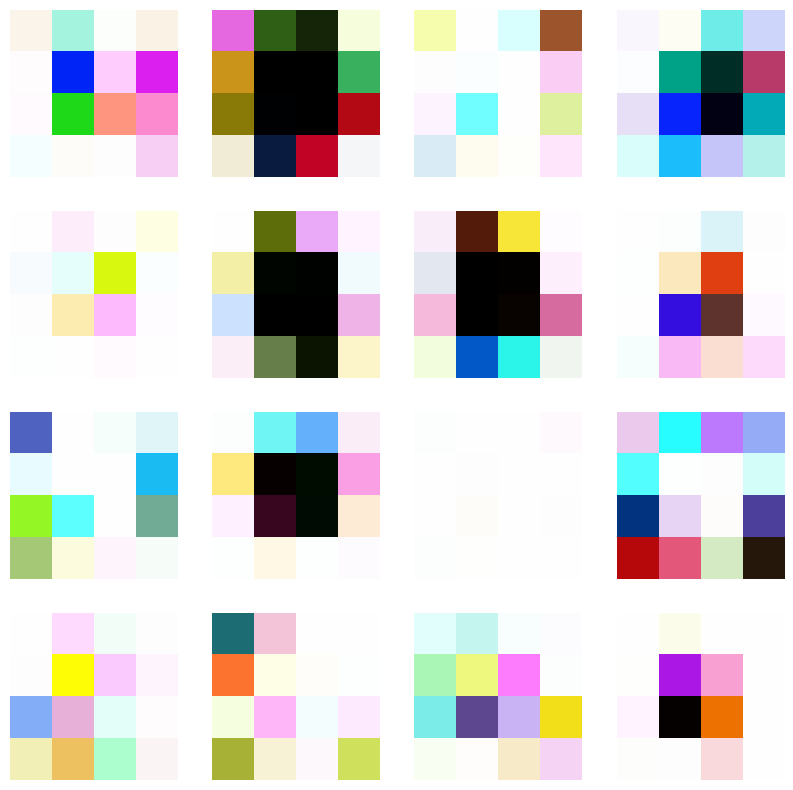

Step: 95
Alpha: 0.6832360300250214
Current Resolution: 4
Discriminator loss : -2.312721014022827
Generator loss: 5.273770809173584


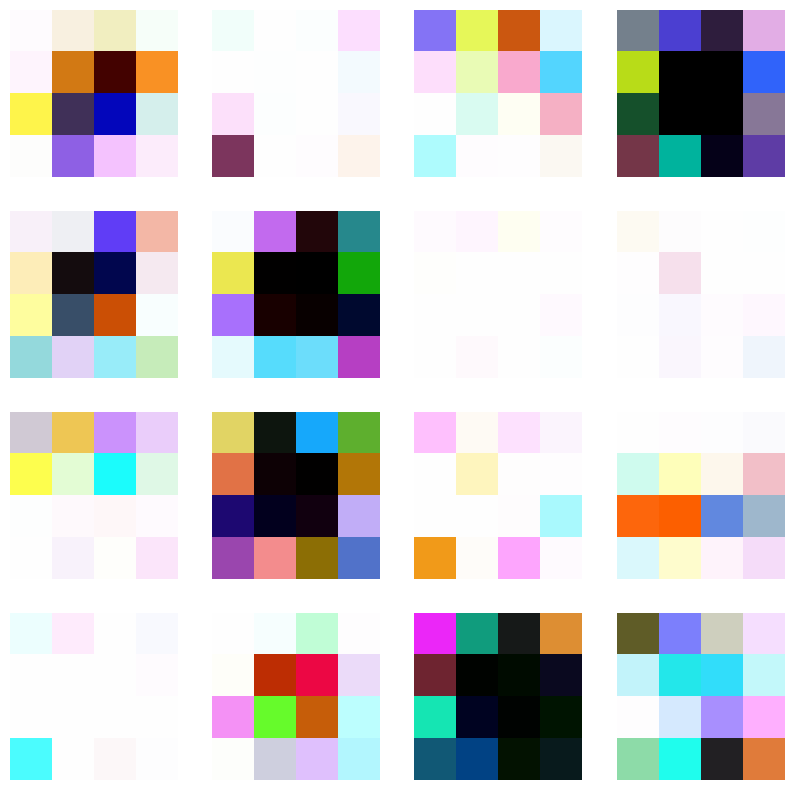

Step: 96
Alpha: 0.6903530720044487
Current Resolution: 4
Discriminator loss : -2.312687873840332
Generator loss: 5.277353763580322


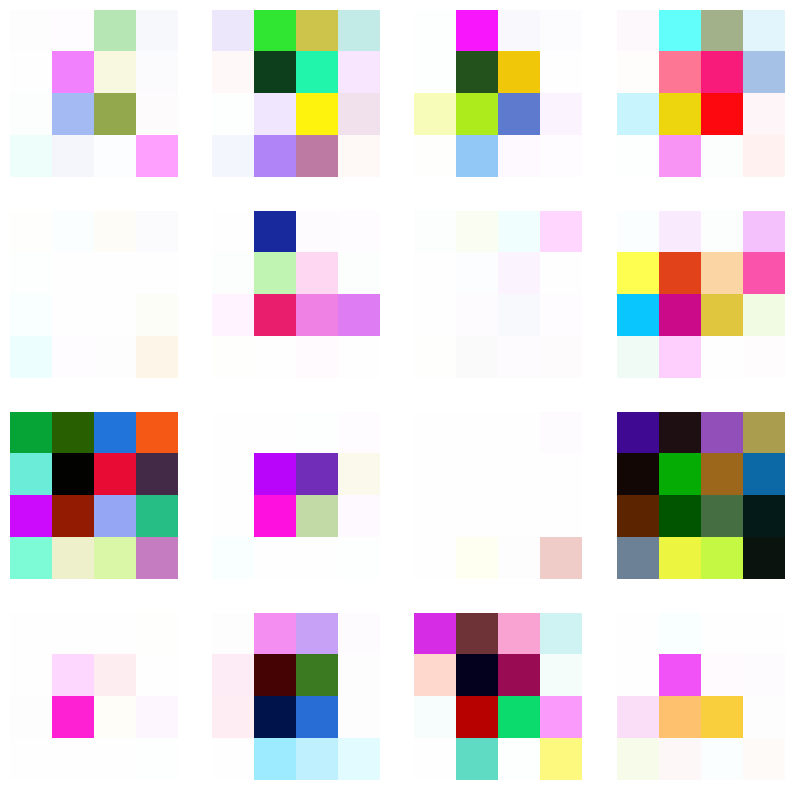

Step: 97
Alpha: 0.697470113983876
Current Resolution: 4
Discriminator loss : -2.3132128715515137
Generator loss: 5.279669284820557


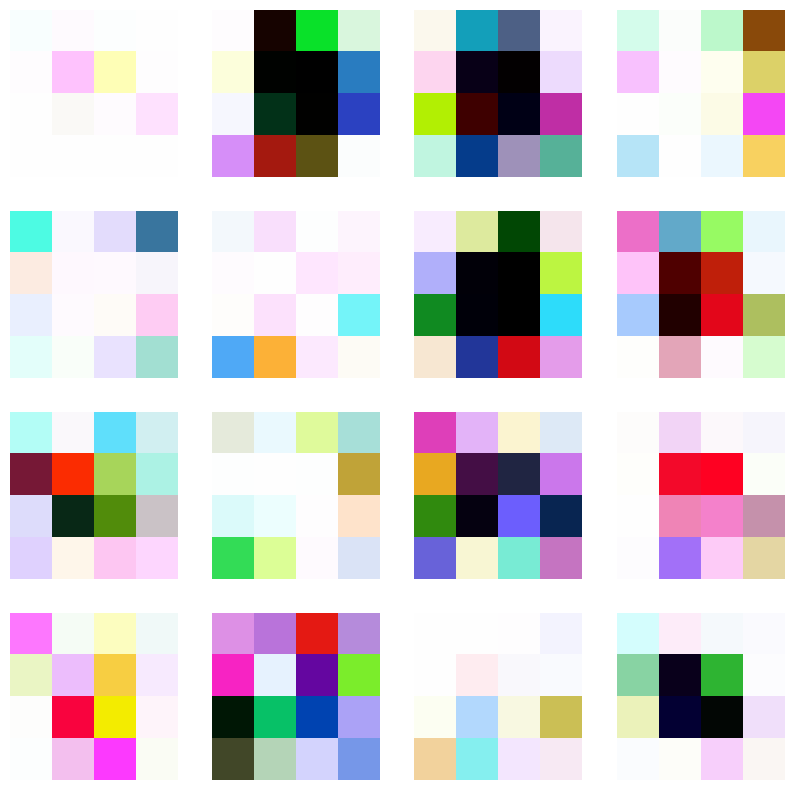

Step: 98
Alpha: 0.7045871559633033
Current Resolution: 4
Discriminator loss : -2.3103272914886475
Generator loss: 5.27706241607666


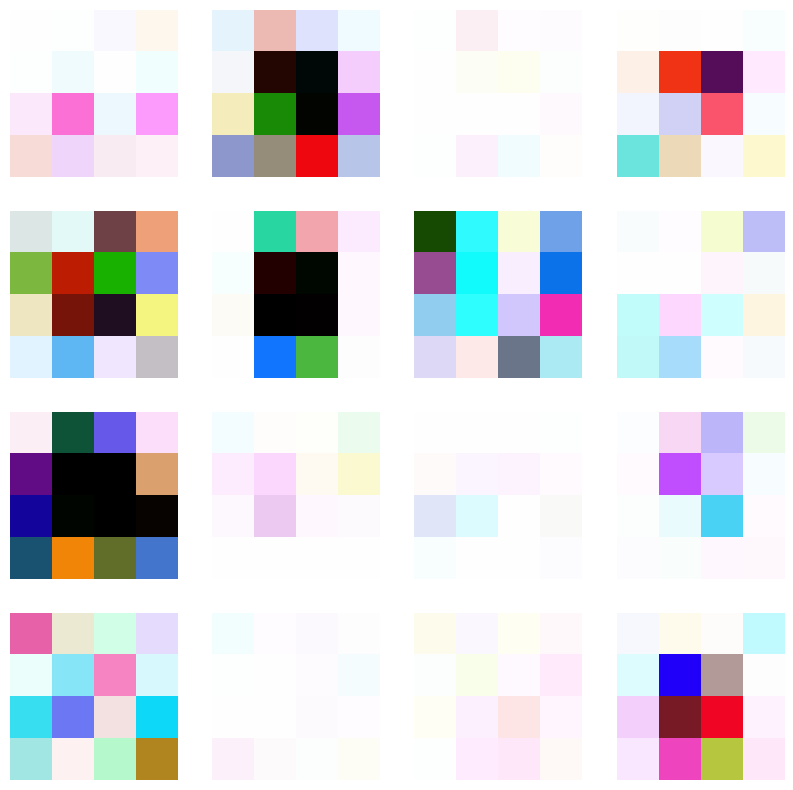

Step: 99
Alpha: 0.7117041979427307
Current Resolution: 4
Discriminator loss : -2.3094606399536133
Generator loss: 5.2805681228637695


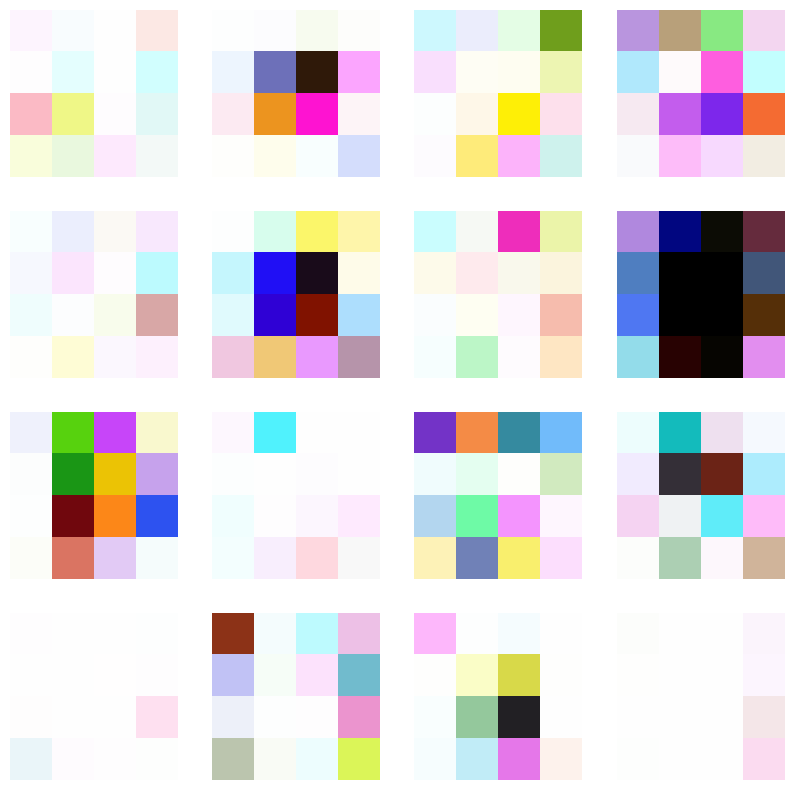

Step: 100
Alpha: 0.718821239922158
Current Resolution: 4
Discriminator loss : -2.3067080974578857
Generator loss: 5.273535251617432


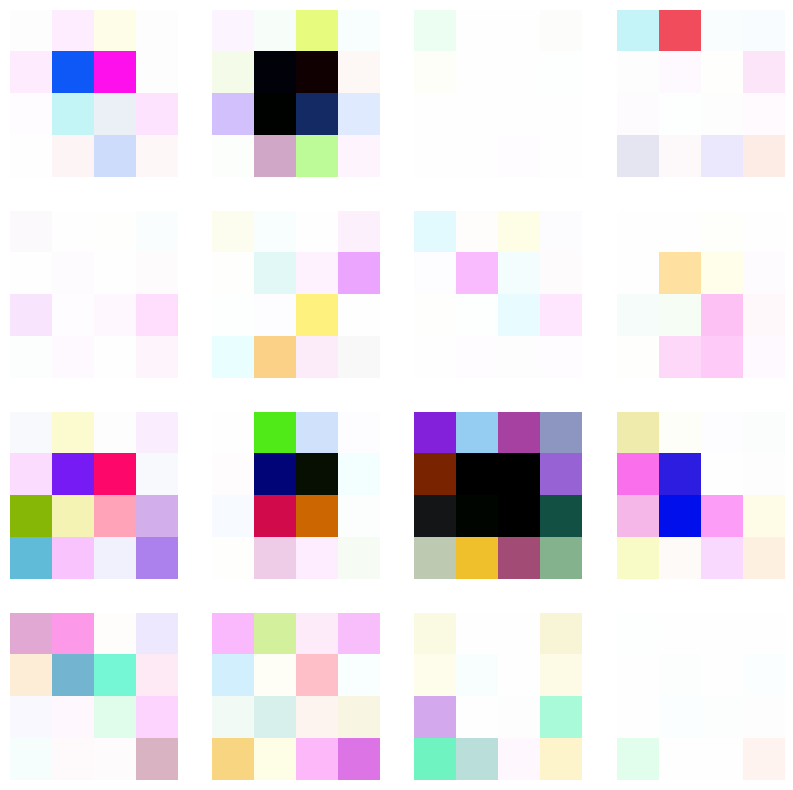

Step: 101
Alpha: 0.7259382819015853
Current Resolution: 4
Discriminator loss : -2.3038761615753174
Generator loss: 5.274968147277832


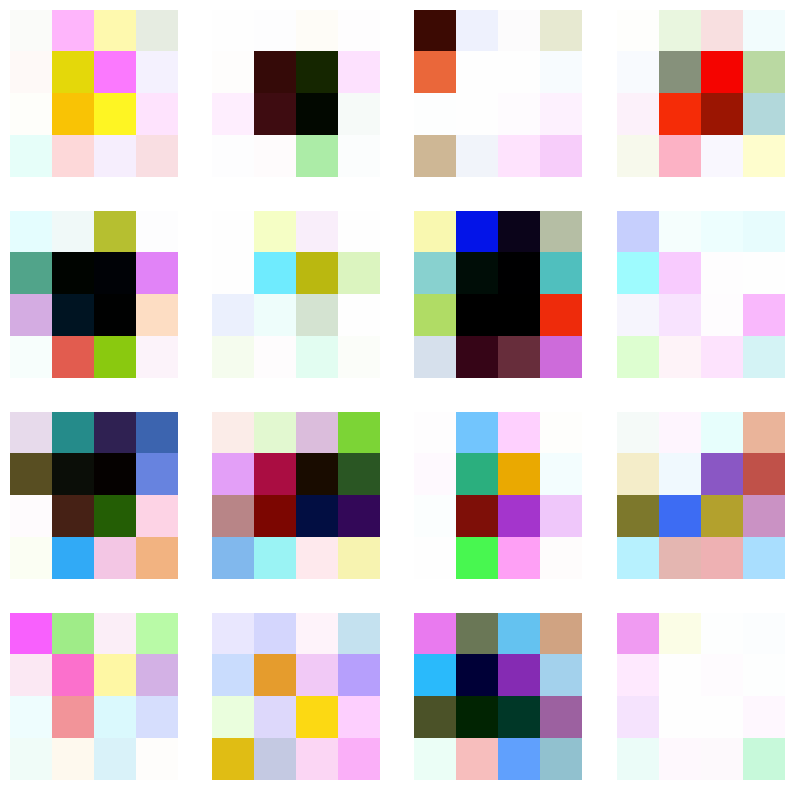

Step: 102
Alpha: 0.7330553238810126
Current Resolution: 4
Discriminator loss : -2.302051305770874
Generator loss: 5.271508693695068


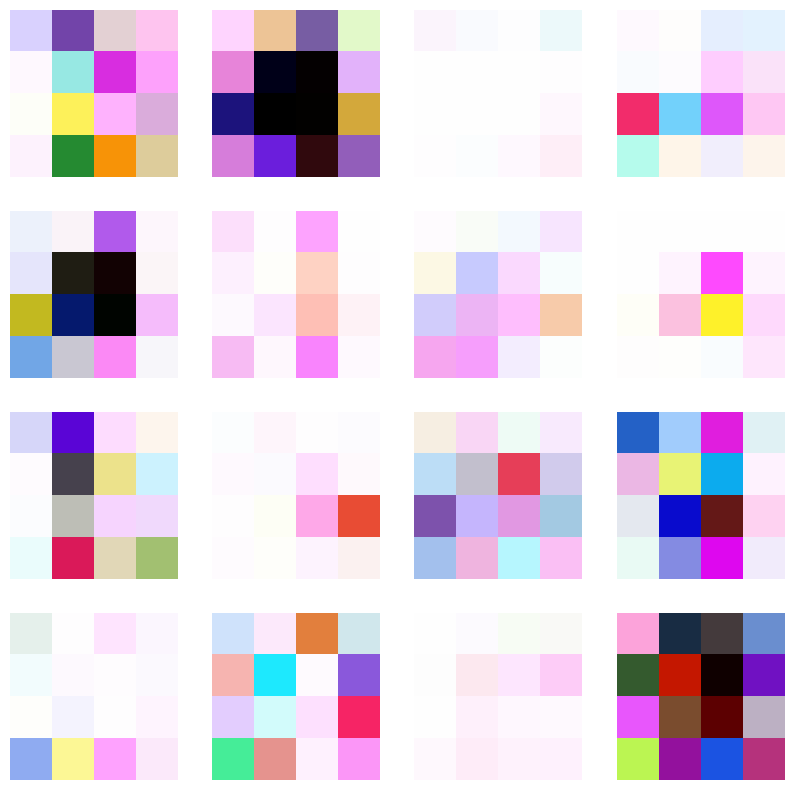

Step: 103
Alpha: 0.7401723658604399
Current Resolution: 4
Discriminator loss : -2.2995121479034424
Generator loss: 5.268897533416748


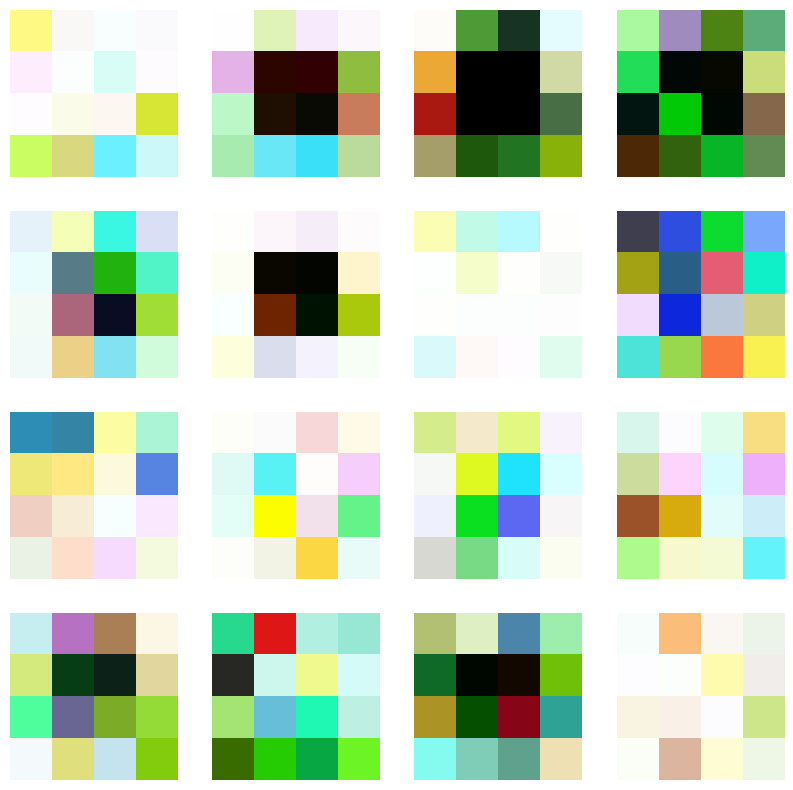

Step: 104
Alpha: 0.7472894078398672
Current Resolution: 4
Discriminator loss : -2.2964730262756348
Generator loss: 5.262953758239746


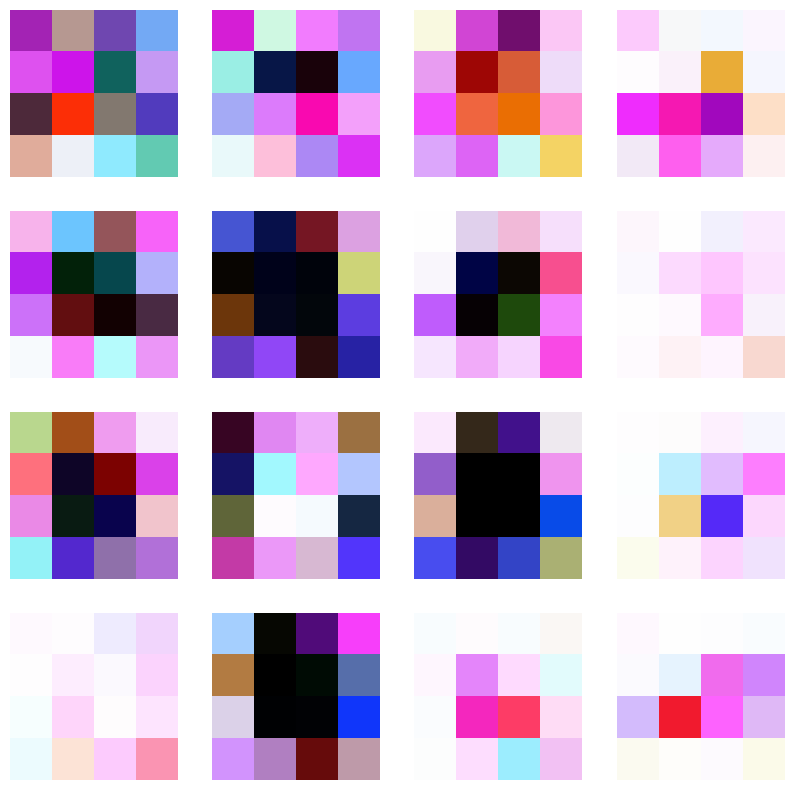

Step: 105
Alpha: 0.7544064498192945
Current Resolution: 4
Discriminator loss : -2.2932043075561523
Generator loss: 5.258344650268555


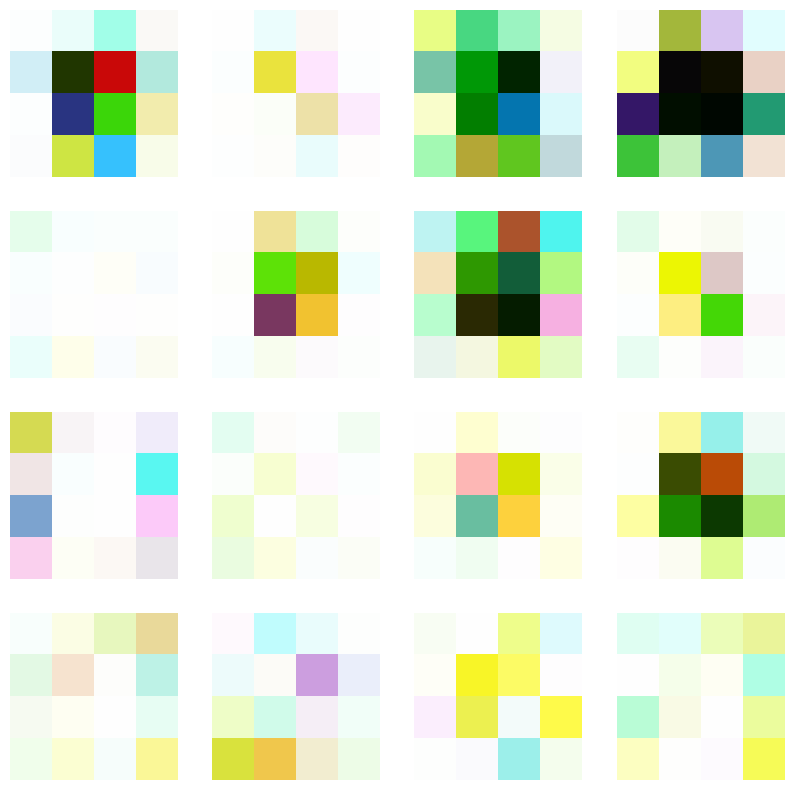

Step: 106
Alpha: 0.7615234917987218
Current Resolution: 4
Discriminator loss : -2.2916646003723145
Generator loss: 5.257491588592529


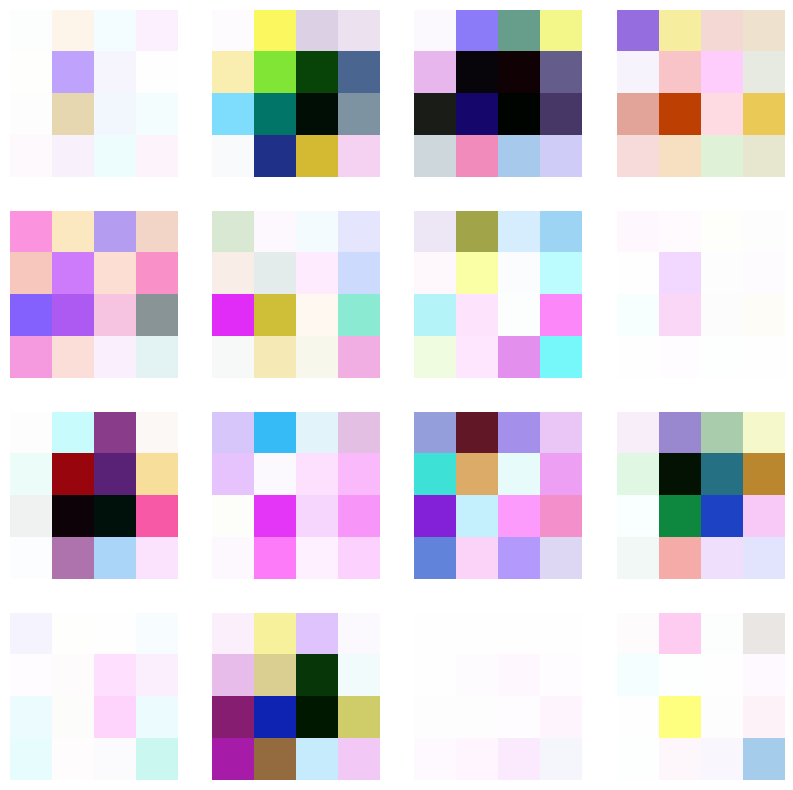

Step: 107
Alpha: 0.7686405337781491
Current Resolution: 4
Discriminator loss : -2.2867796421051025
Generator loss: 5.251999378204346


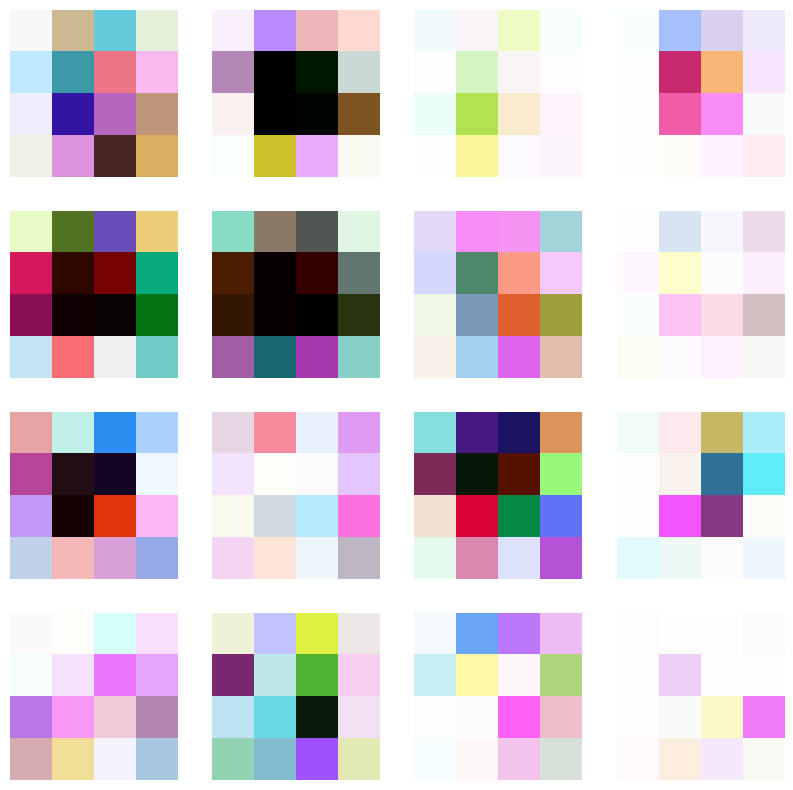

Step: 108
Alpha: 0.7757575757575764
Current Resolution: 4
Discriminator loss : -2.2826805114746094
Generator loss: 5.246653079986572


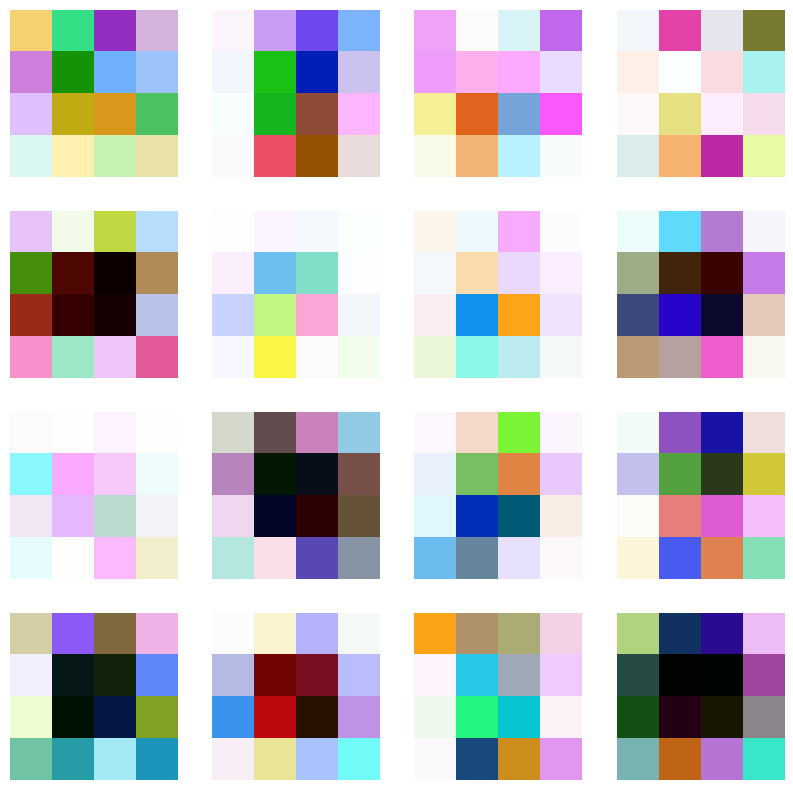

Step: 109
Alpha: 0.7828746177370037
Current Resolution: 4
Discriminator loss : -2.277385950088501
Generator loss: 5.238041400909424


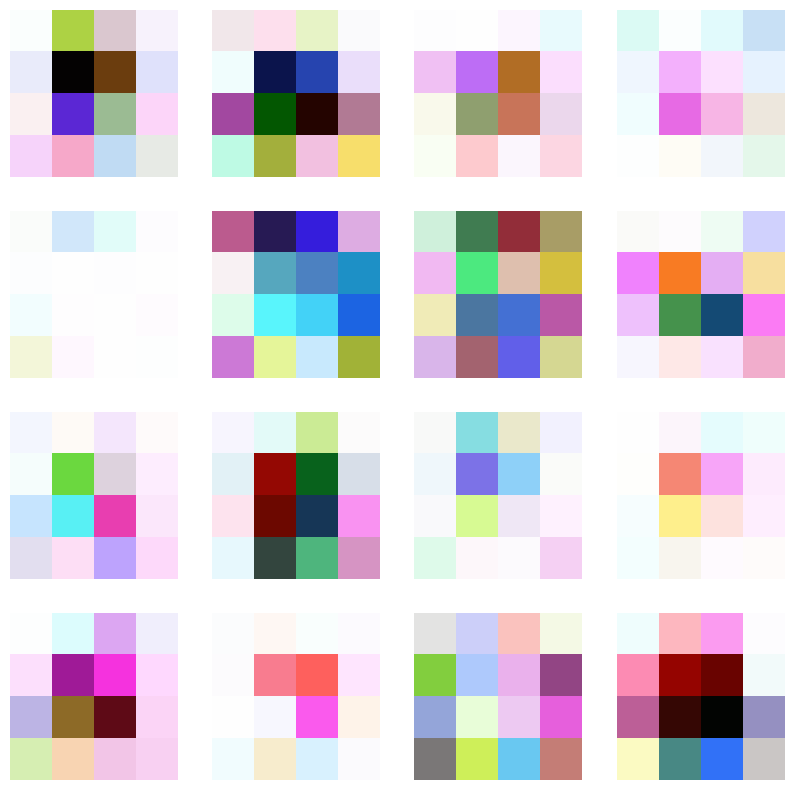

Step: 110
Alpha: 0.789991659716431
Current Resolution: 4
Discriminator loss : -2.2732131481170654
Generator loss: 5.2289814949035645


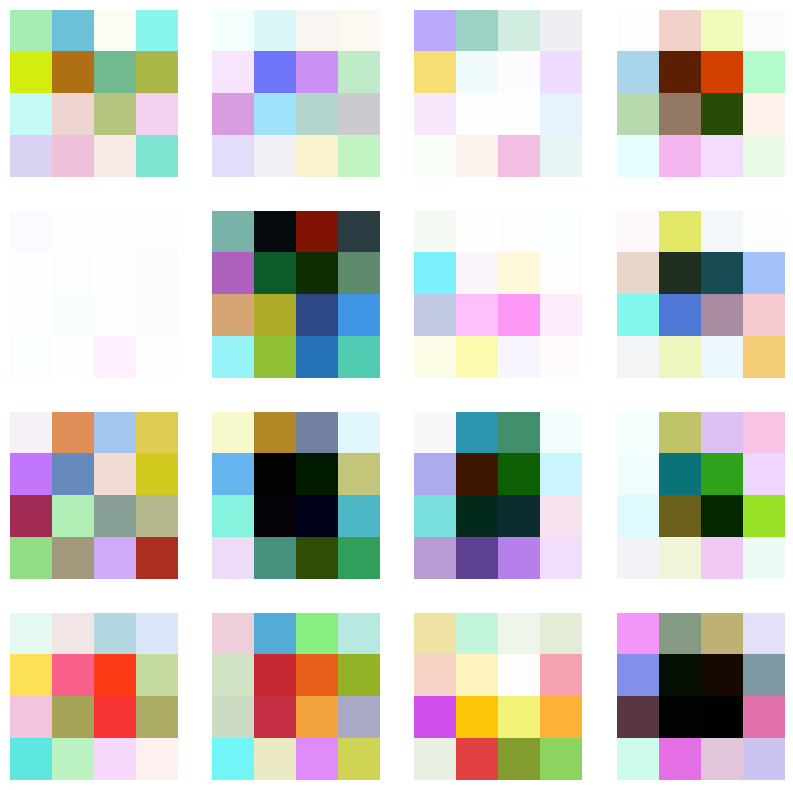

Step: 111
Alpha: 0.7971087016958583
Current Resolution: 4
Discriminator loss : -2.2672619819641113
Generator loss: 5.219470024108887


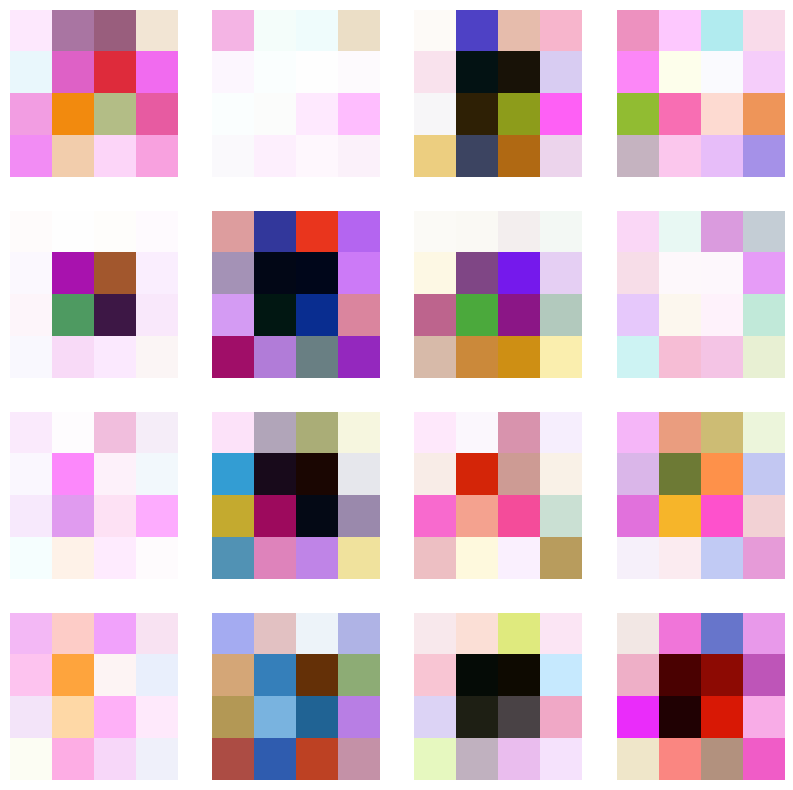

Step: 112
Alpha: 0.8042257436752857
Current Resolution: 4
Discriminator loss : -2.260885238647461
Generator loss: 5.209047794342041


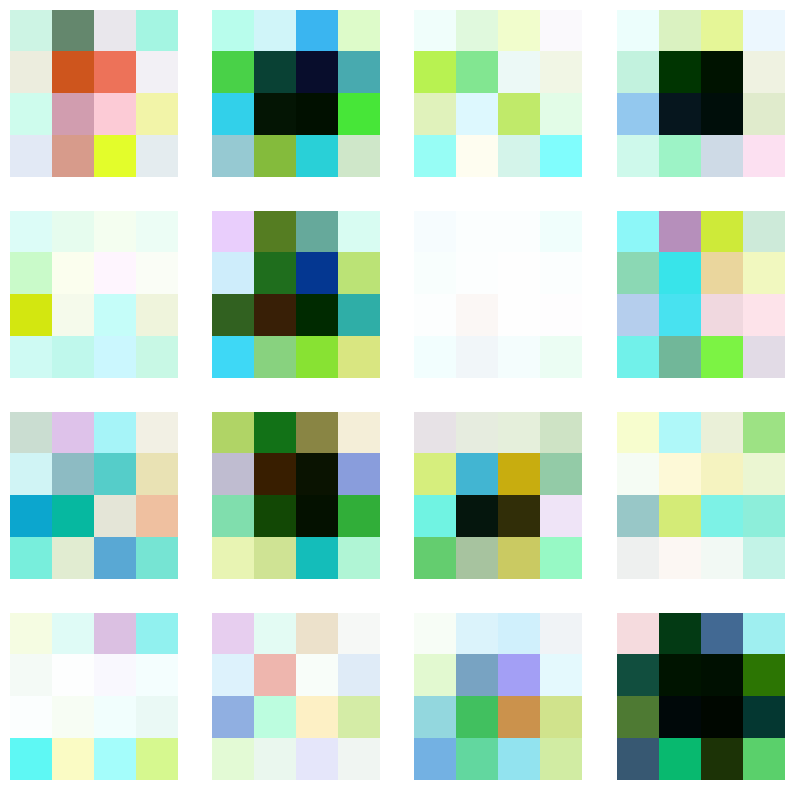

Step: 113
Alpha: 0.811342785654713
Current Resolution: 4
Discriminator loss : -2.2557528018951416
Generator loss: 5.200801372528076


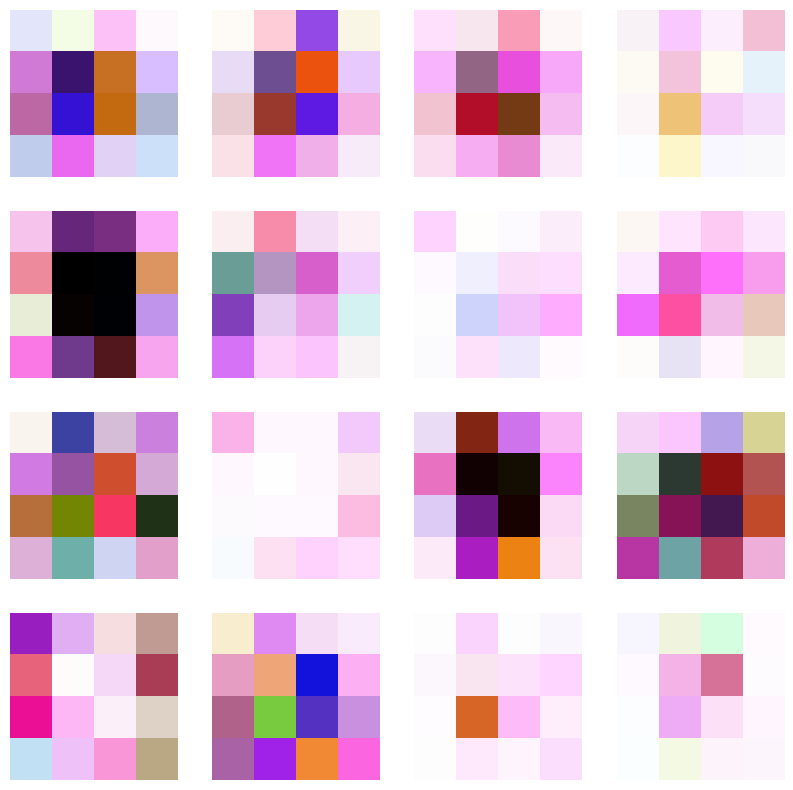

Step: 114
Alpha: 0.8184598276341403
Current Resolution: 4
Discriminator loss : -2.2505321502685547
Generator loss: 5.193430423736572


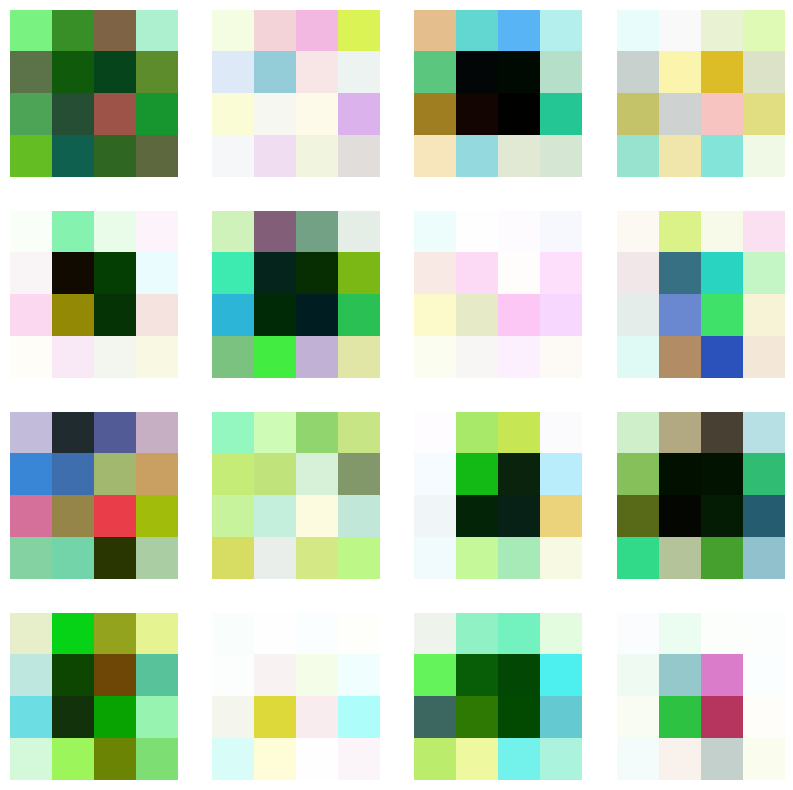

Step: 115
Alpha: 0.8255768696135676
Current Resolution: 4
Discriminator loss : -2.2439005374908447
Generator loss: 5.185287952423096


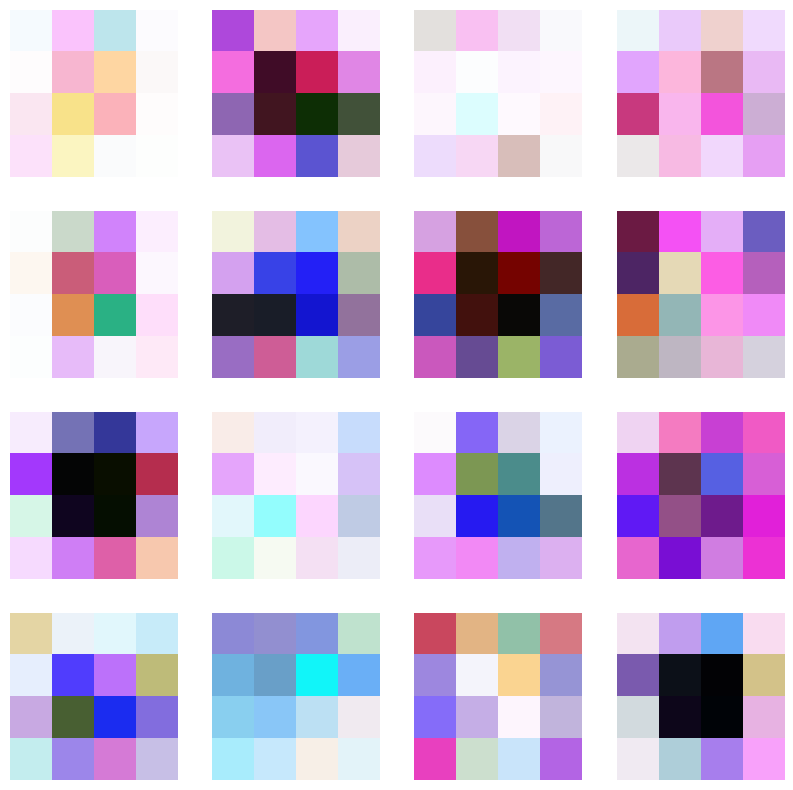

Step: 116
Alpha: 0.8326939115929949
Current Resolution: 4
Discriminator loss : -2.2366037368774414
Generator loss: 5.173550128936768


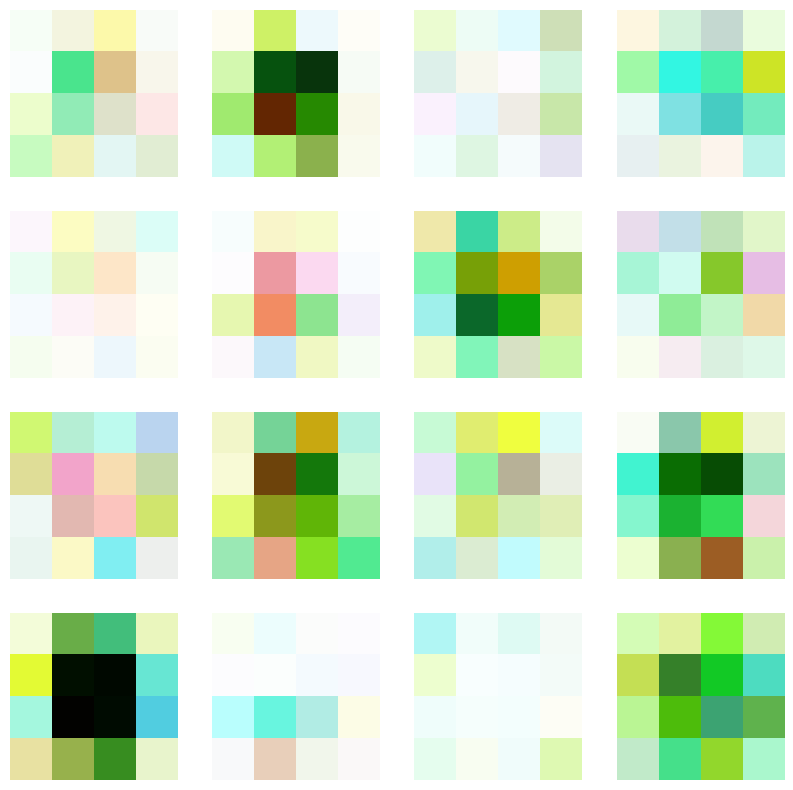

Step: 117
Alpha: 0.8398109535724222
Current Resolution: 4
Discriminator loss : -2.2305667400360107
Generator loss: 5.164613723754883


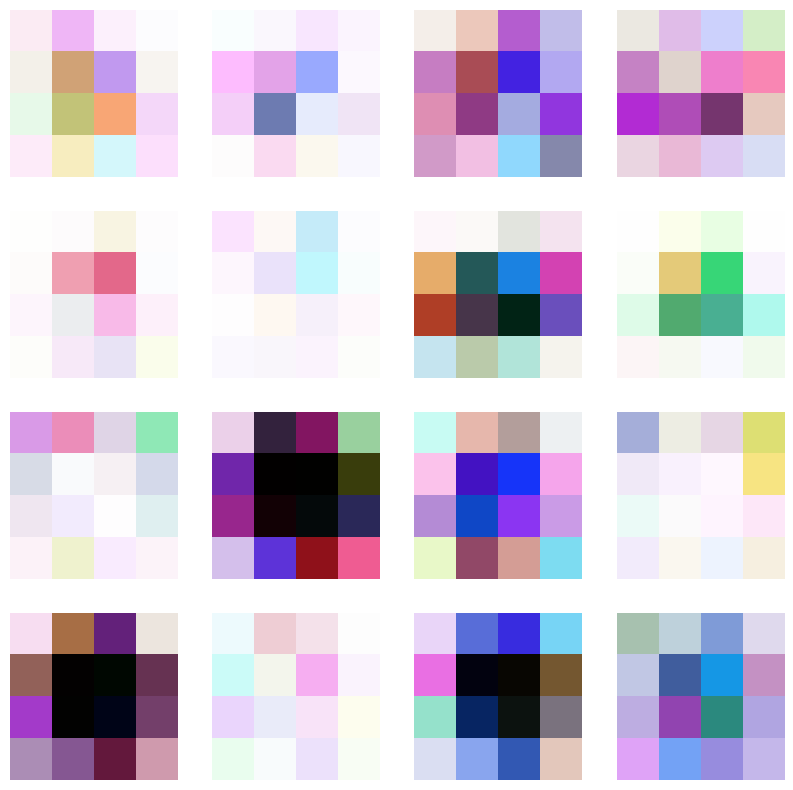

Step: 118
Alpha: 0.8469279955518495
Current Resolution: 4
Discriminator loss : -2.2213690280914307
Generator loss: 5.1518683433532715


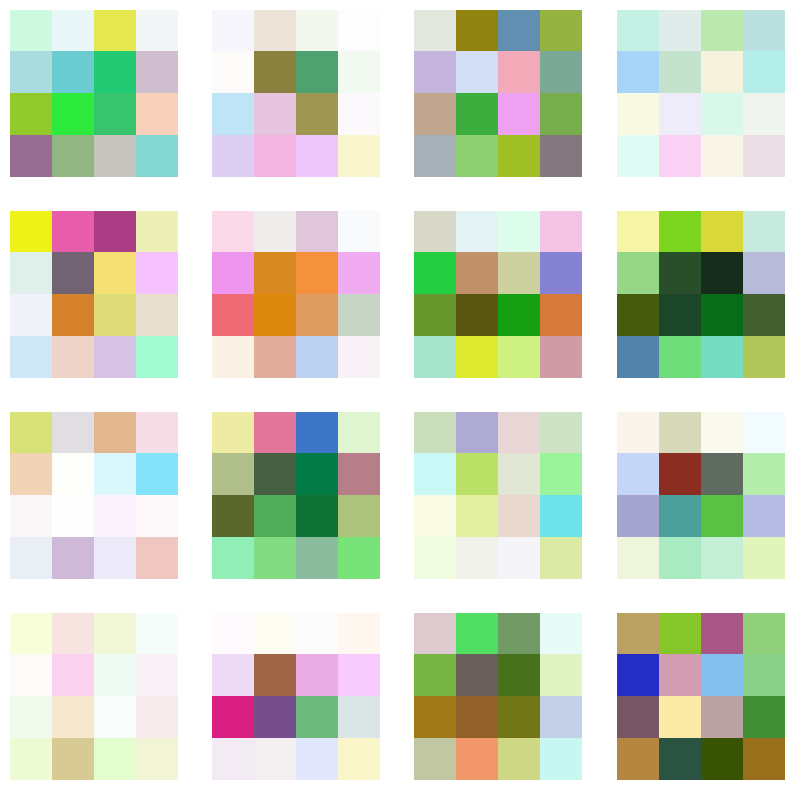

Step: 119
Alpha: 0.8540450375312768
Current Resolution: 4
Discriminator loss : -2.2129390239715576
Generator loss: 5.138274192810059


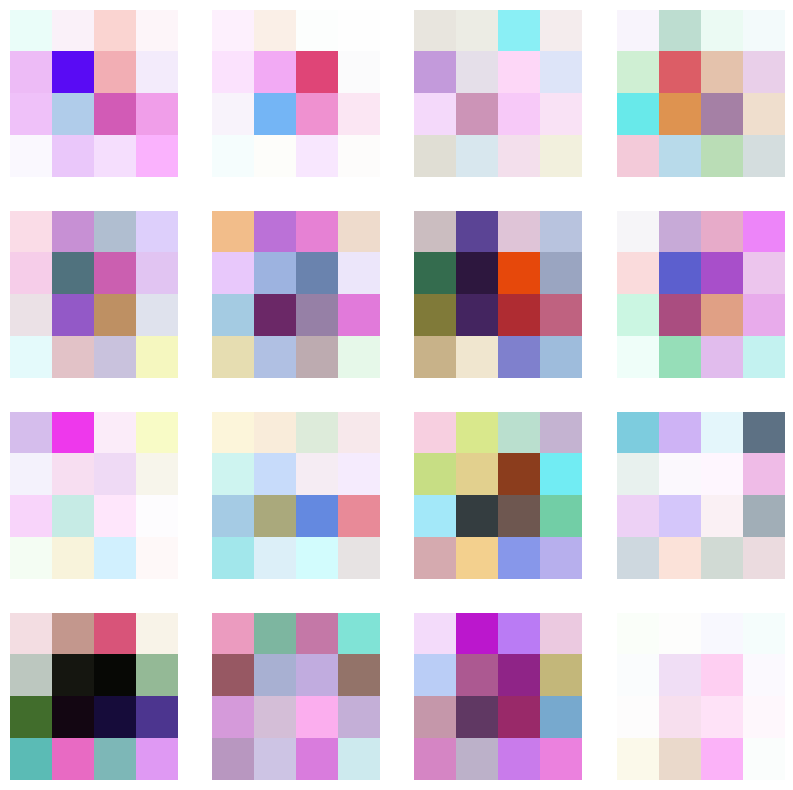

Step: 120
Alpha: 0.8611620795107041
Current Resolution: 4
Discriminator loss : -2.203444480895996
Generator loss: 5.1230669021606445


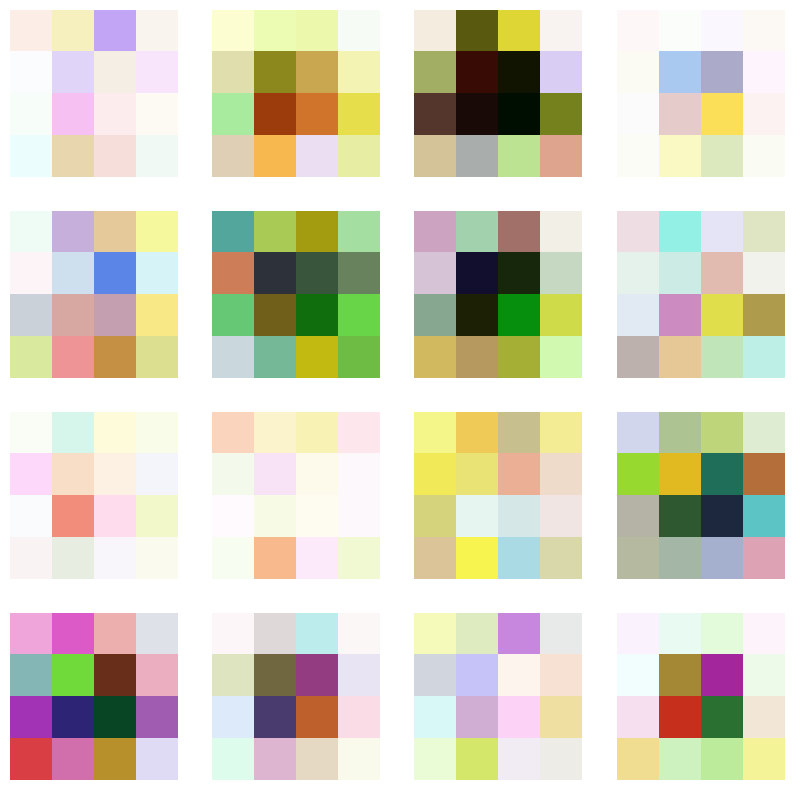

Step: 121
Alpha: 0.8682791214901314
Current Resolution: 4
Discriminator loss : -2.1948249340057373
Generator loss: 5.109299182891846


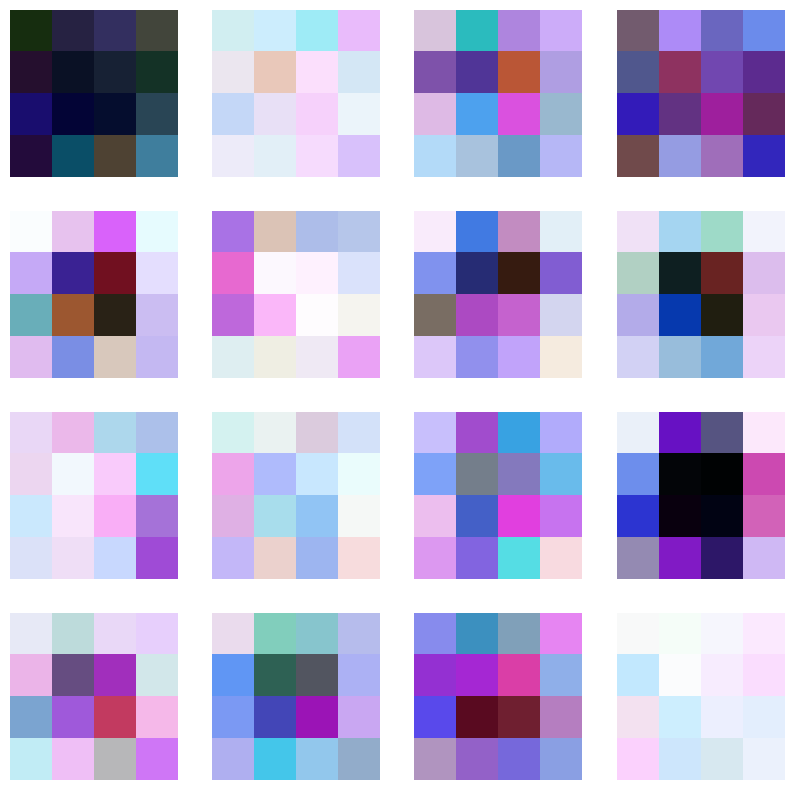

Step: 122
Alpha: 0.8753961634695587
Current Resolution: 4
Discriminator loss : -2.1870498657226562
Generator loss: 5.093687534332275


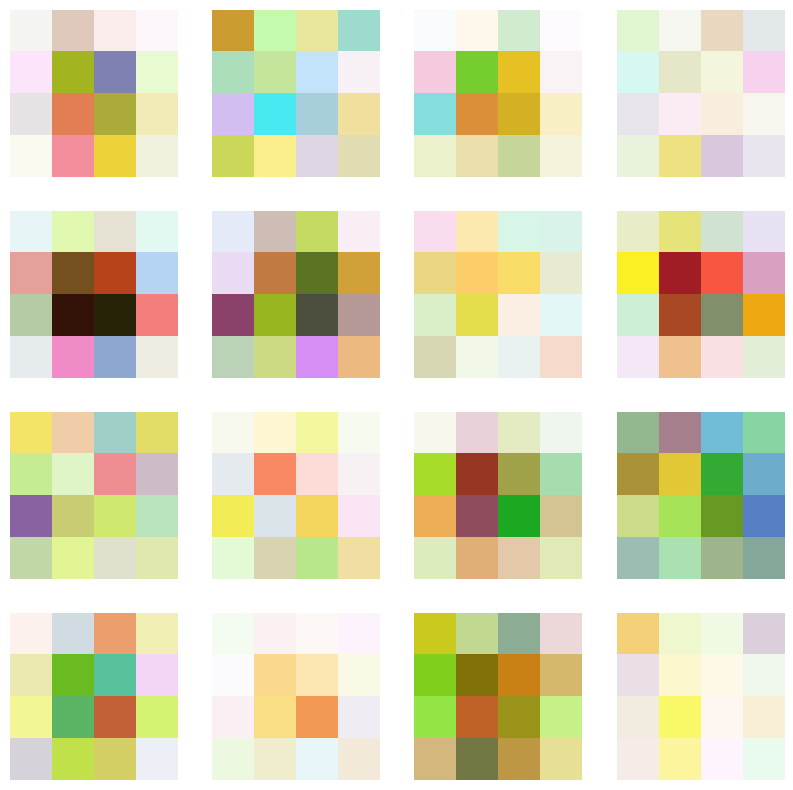

Step: 123
Alpha: 0.882513205448986
Current Resolution: 4
Discriminator loss : -2.1780712604522705
Generator loss: 5.082198143005371


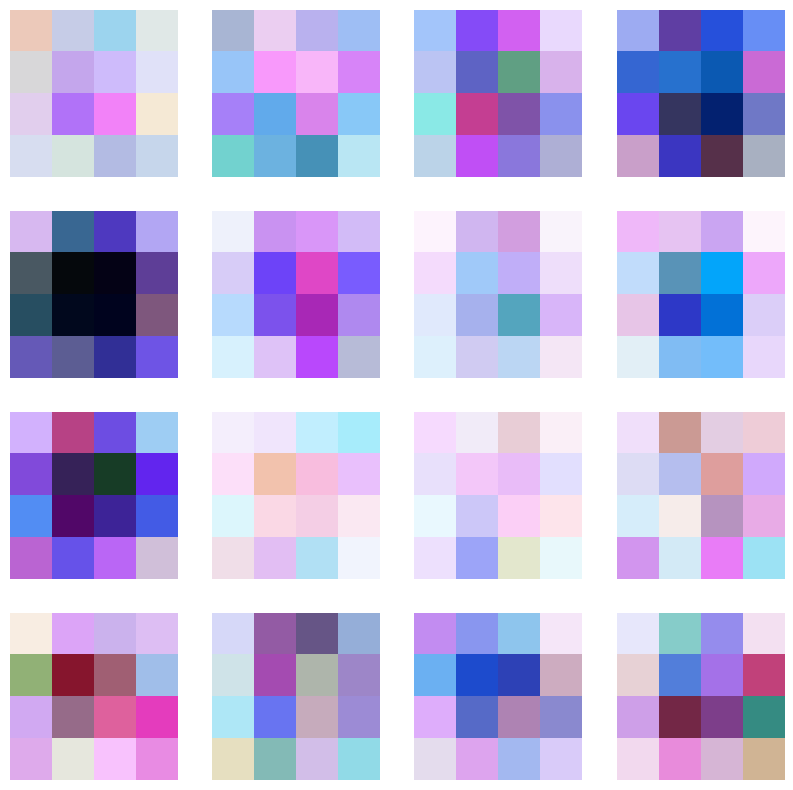

Step: 124
Alpha: 0.8896302474284133
Current Resolution: 4
Discriminator loss : -2.1705570220947266
Generator loss: 5.067636013031006


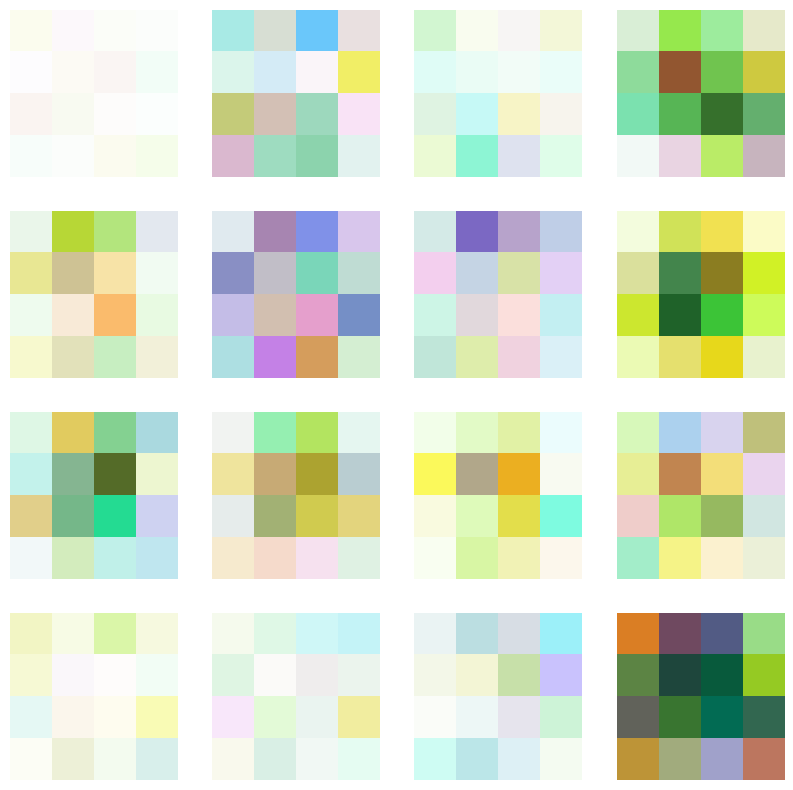

Step: 125
Alpha: 0.8967472894078407
Current Resolution: 4
Discriminator loss : -2.1609995365142822
Generator loss: 5.054845809936523


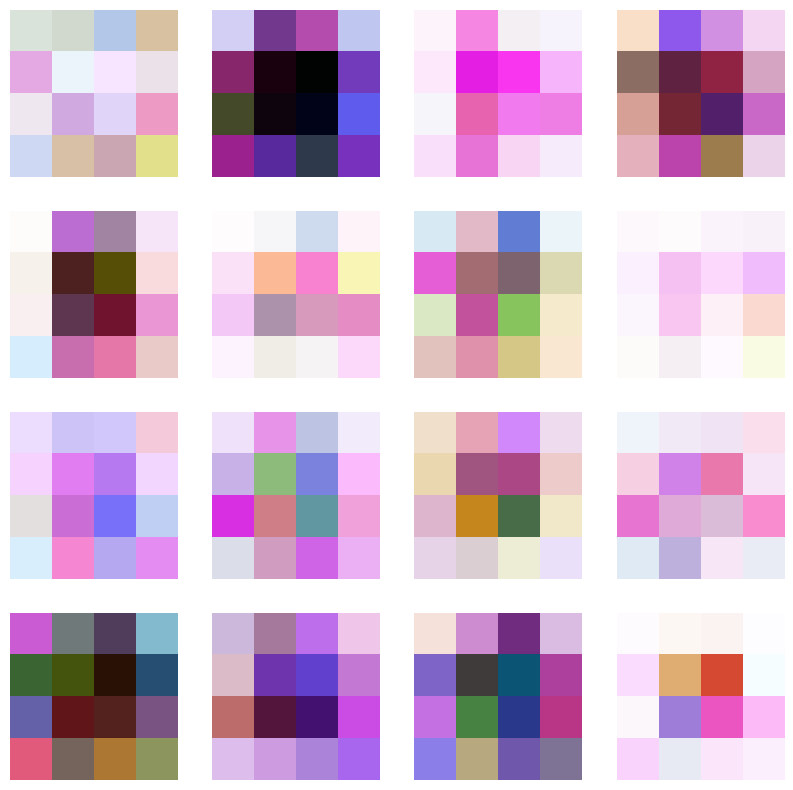

Step: 126
Alpha: 0.903864331387268
Current Resolution: 4
Discriminator loss : -2.1510348320007324
Generator loss: 5.0399489402771


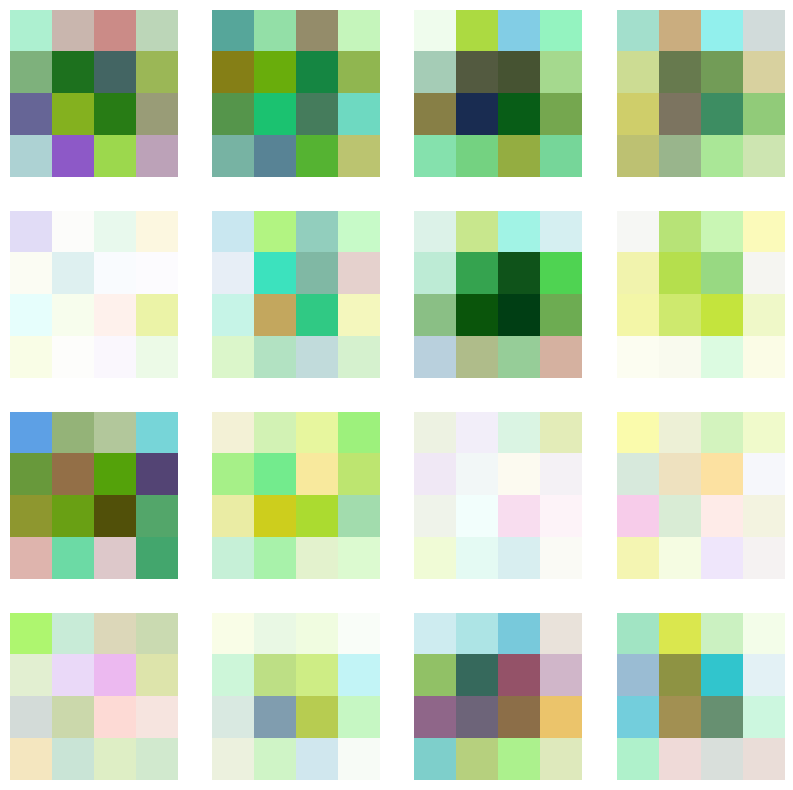

Step: 127
Alpha: 0.9109813733666953
Current Resolution: 4
Discriminator loss : -2.14111065864563
Generator loss: 5.023138523101807


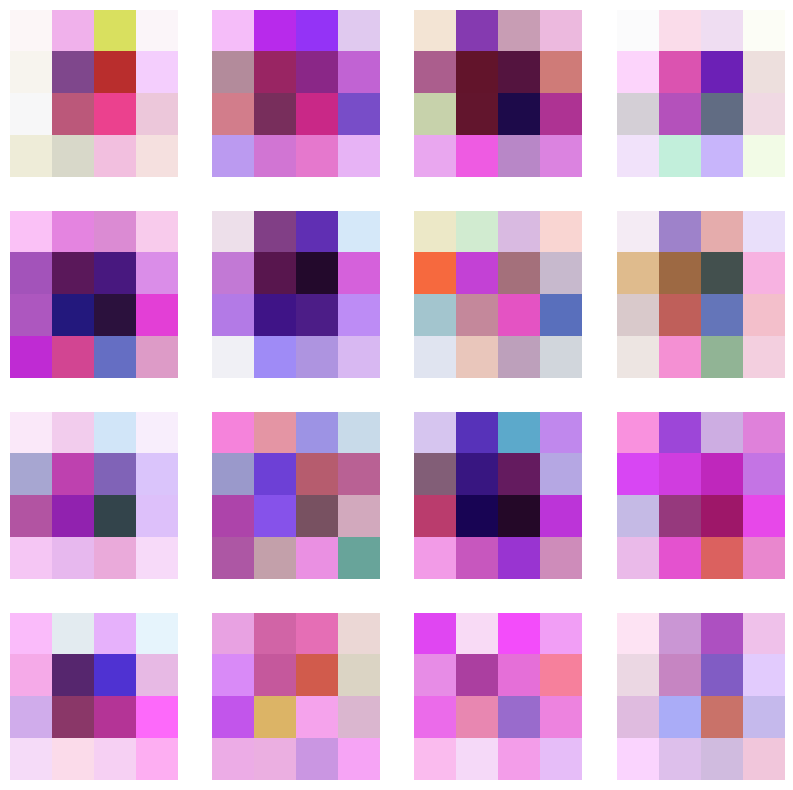

Step: 128
Alpha: 0.9180984153461226
Current Resolution: 4
Discriminator loss : -2.131535053253174
Generator loss: 5.009138107299805


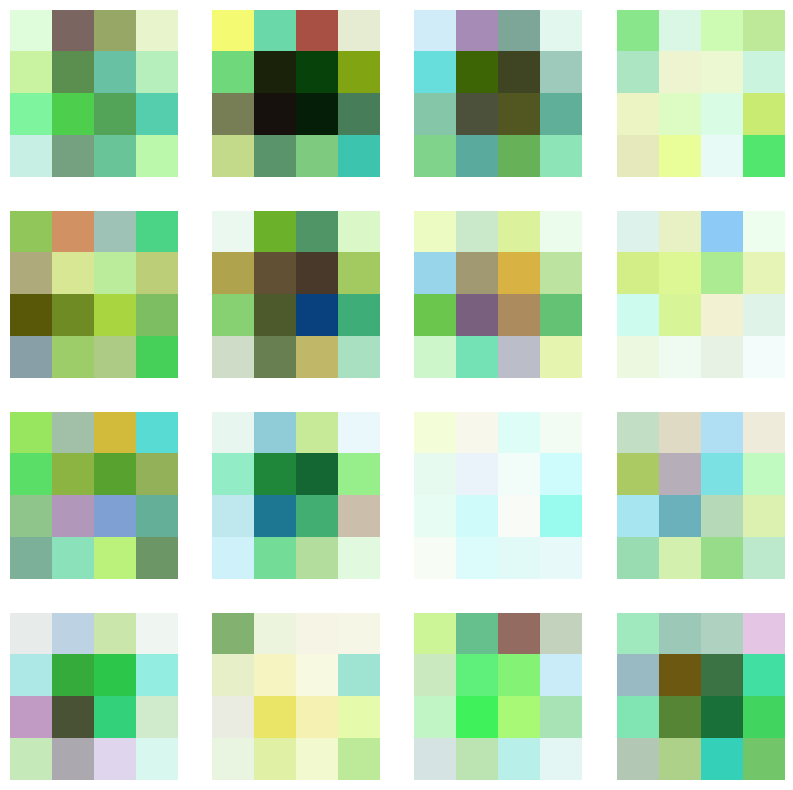

Step: 129
Alpha: 0.9252154573255499
Current Resolution: 4
Discriminator loss : -2.1225085258483887
Generator loss: 4.995458126068115


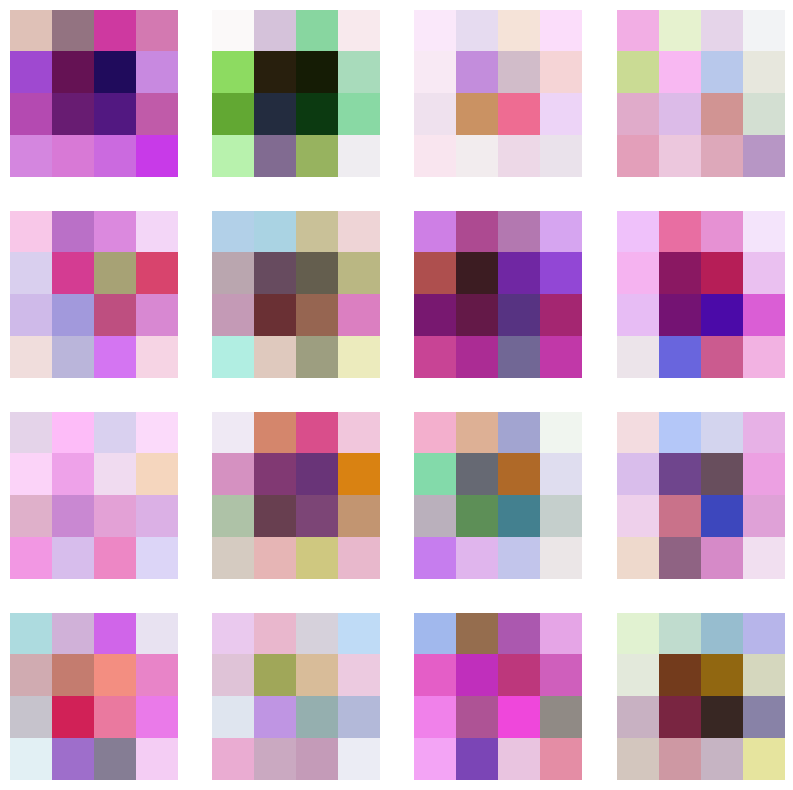

Step: 130
Alpha: 0.9323324993049772
Current Resolution: 4
Discriminator loss : -2.1130855083465576
Generator loss: 4.979748725891113


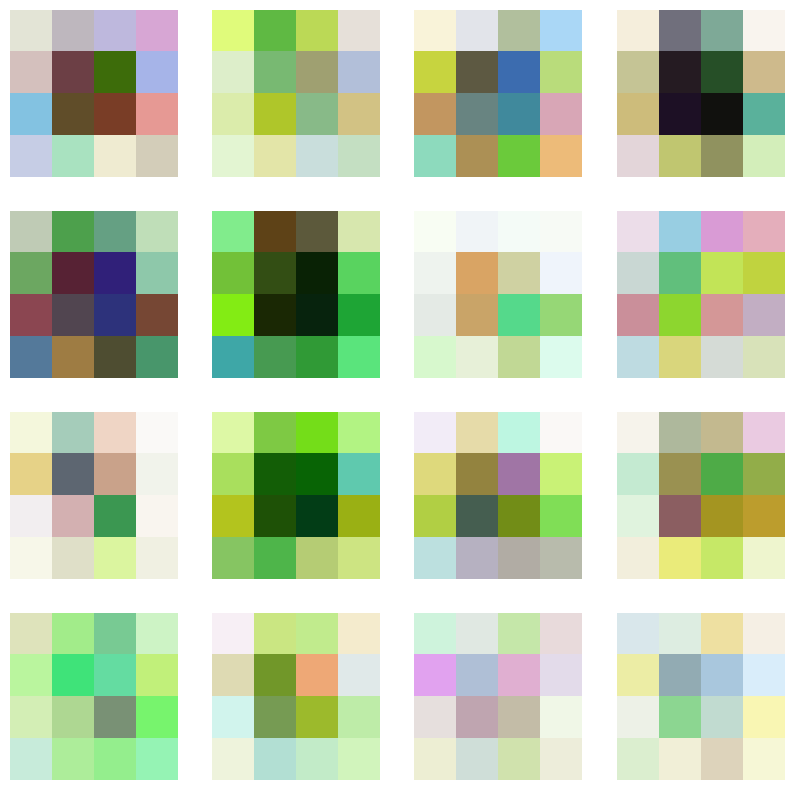

Step: 131
Alpha: 0.9394495412844045
Current Resolution: 4
Discriminator loss : -2.1030170917510986
Generator loss: 4.959187984466553


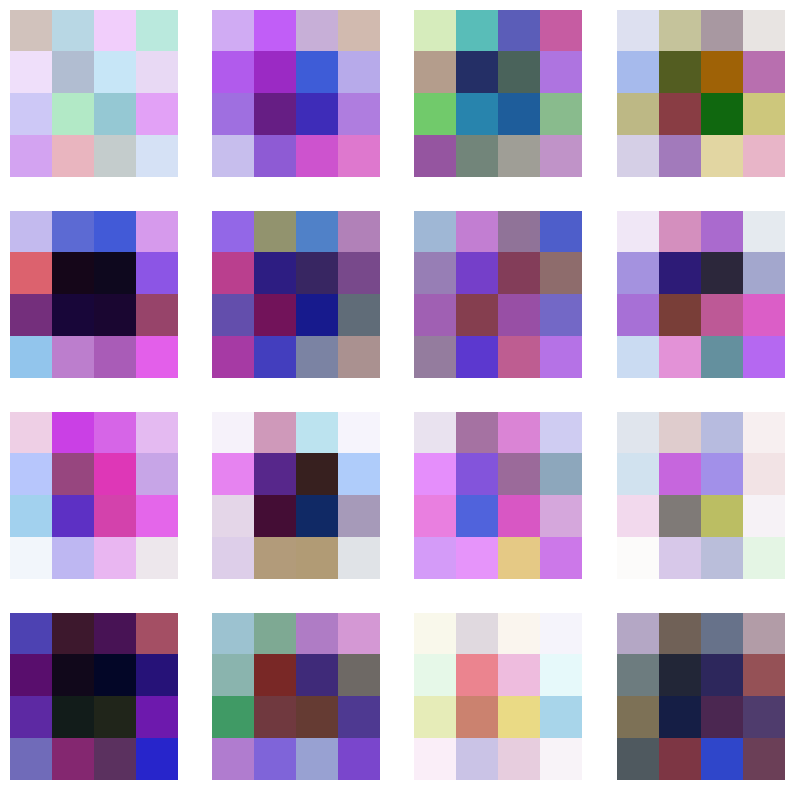

Step: 132
Alpha: 0.9465665832638318
Current Resolution: 4
Discriminator loss : -2.093121290206909
Generator loss: 4.942289352416992


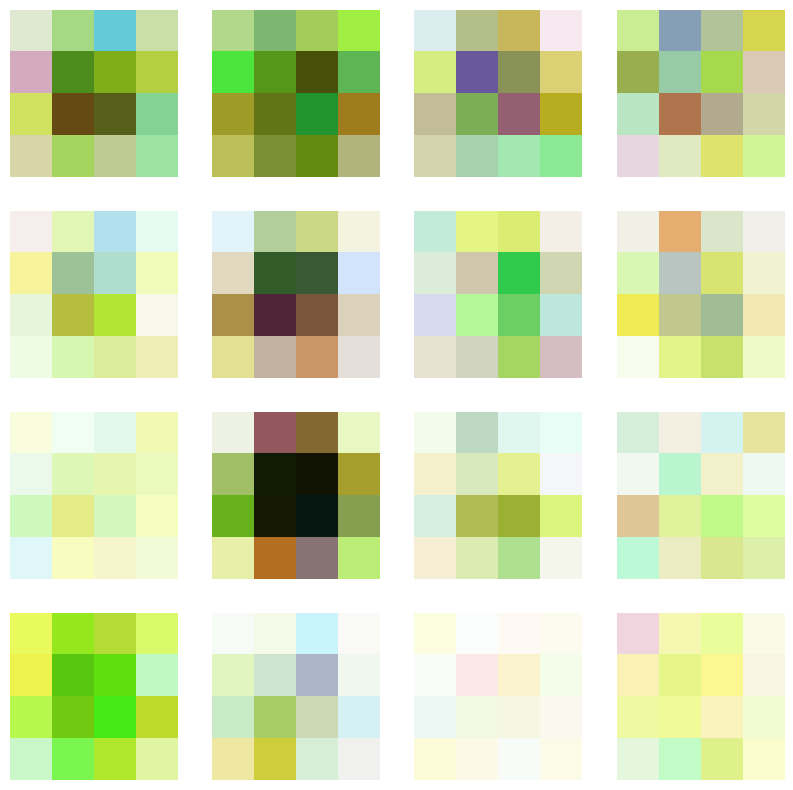

Step: 133
Alpha: 0.9536836252432591
Current Resolution: 4
Discriminator loss : -2.085026741027832
Generator loss: 4.927735805511475


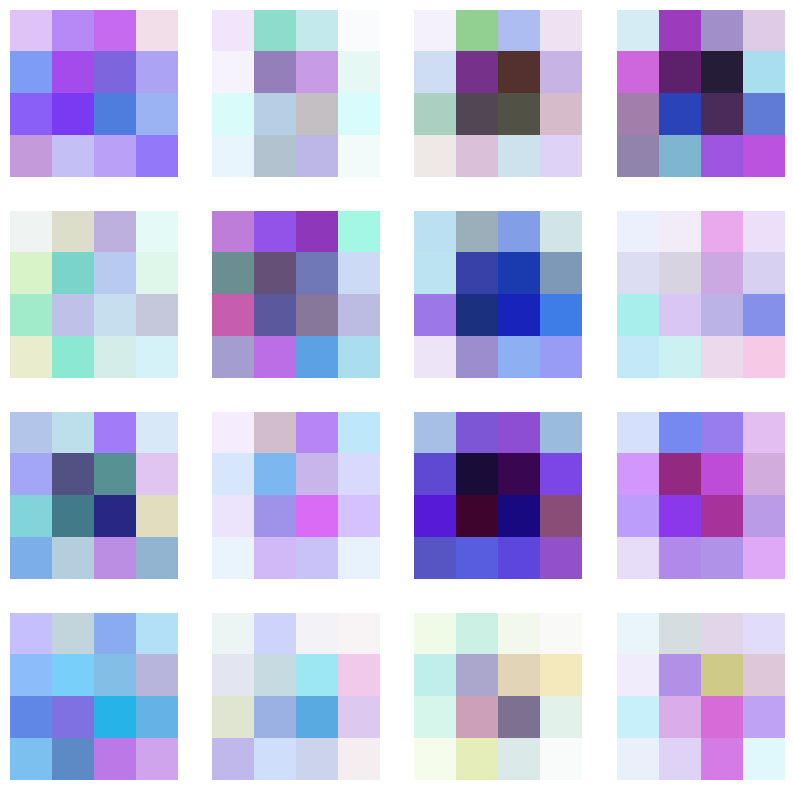

Step: 134
Alpha: 0.9608006672226864
Current Resolution: 4
Discriminator loss : -2.076903820037842
Generator loss: 4.9103875160217285


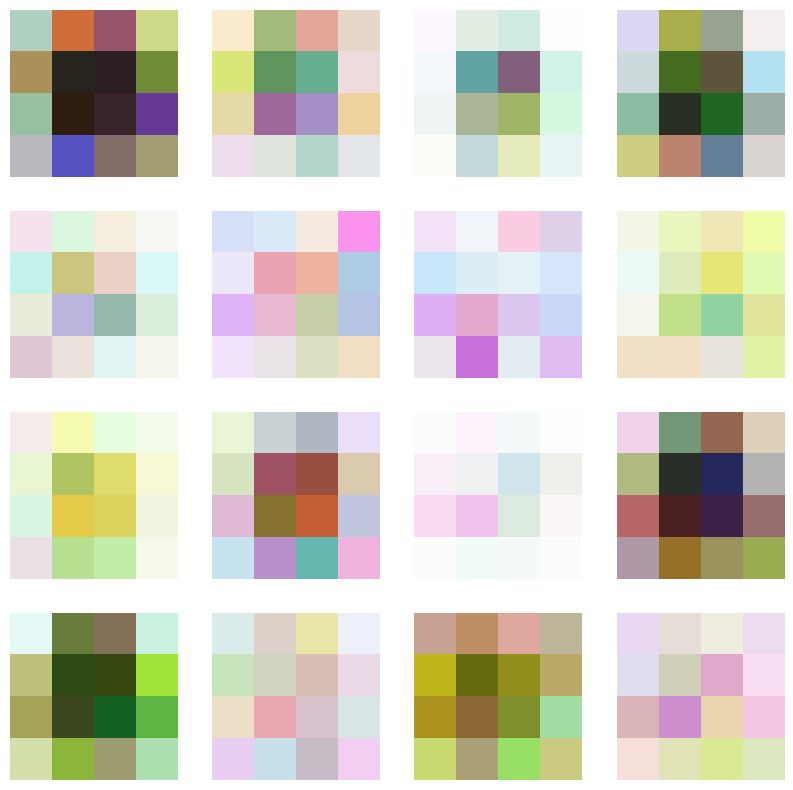

Step: 135
Alpha: 0.9679177092021137
Current Resolution: 4
Discriminator loss : -2.0664987564086914
Generator loss: 4.89552116394043


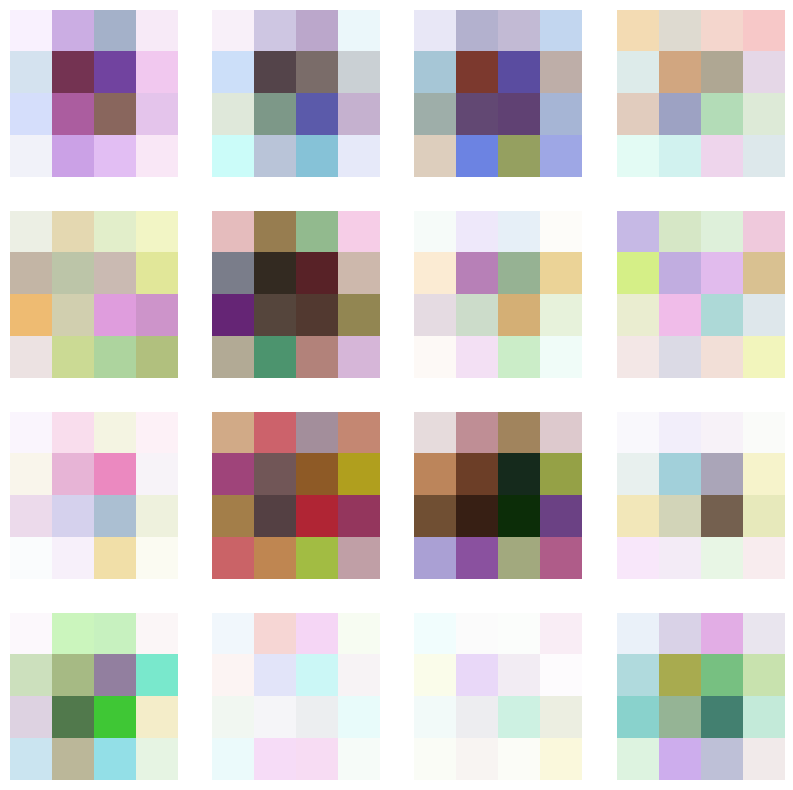

Step: 136
Alpha: 0.975034751181541
Current Resolution: 4
Discriminator loss : -2.055084466934204
Generator loss: 4.87429141998291


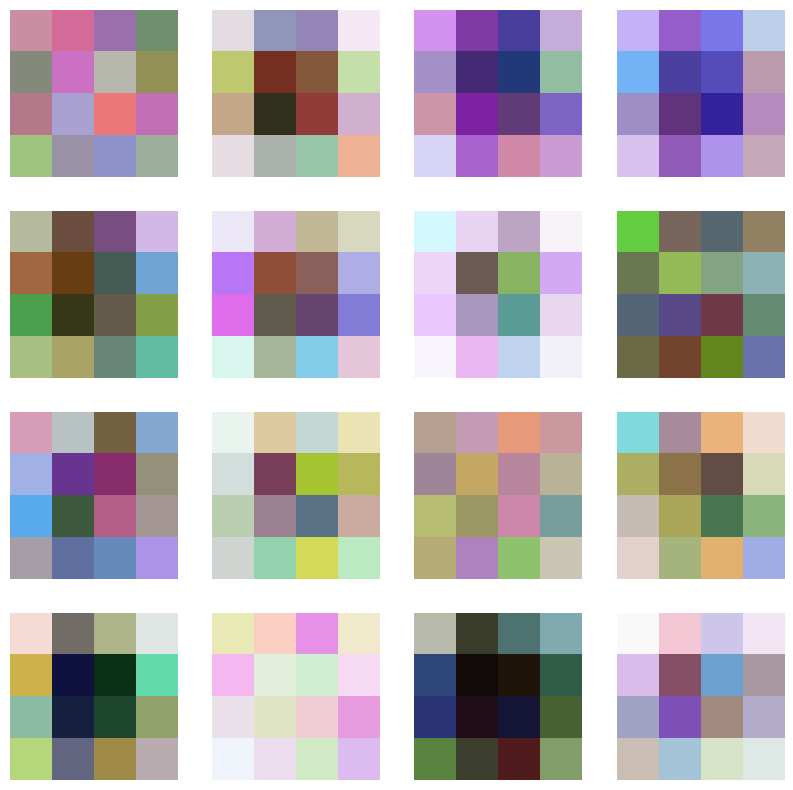

Step: 137
Alpha: 0.9821517931609683
Current Resolution: 4
Discriminator loss : -2.0422654151916504
Generator loss: 4.852465629577637


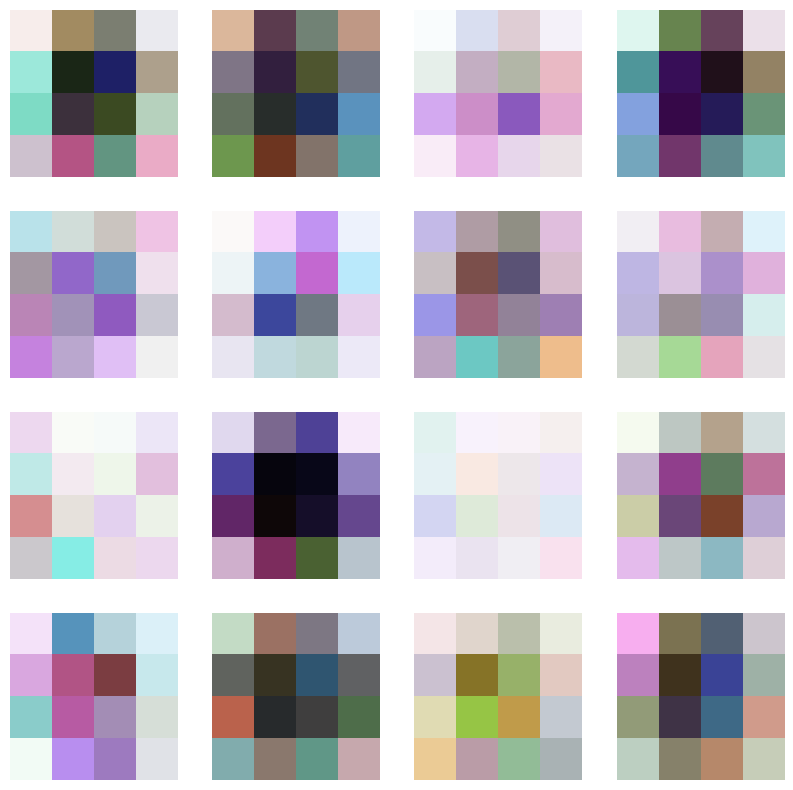

Step: 138
Alpha: 0.9892688351403957
Current Resolution: 4
Discriminator loss : -2.030135154724121
Generator loss: 4.831731796264648


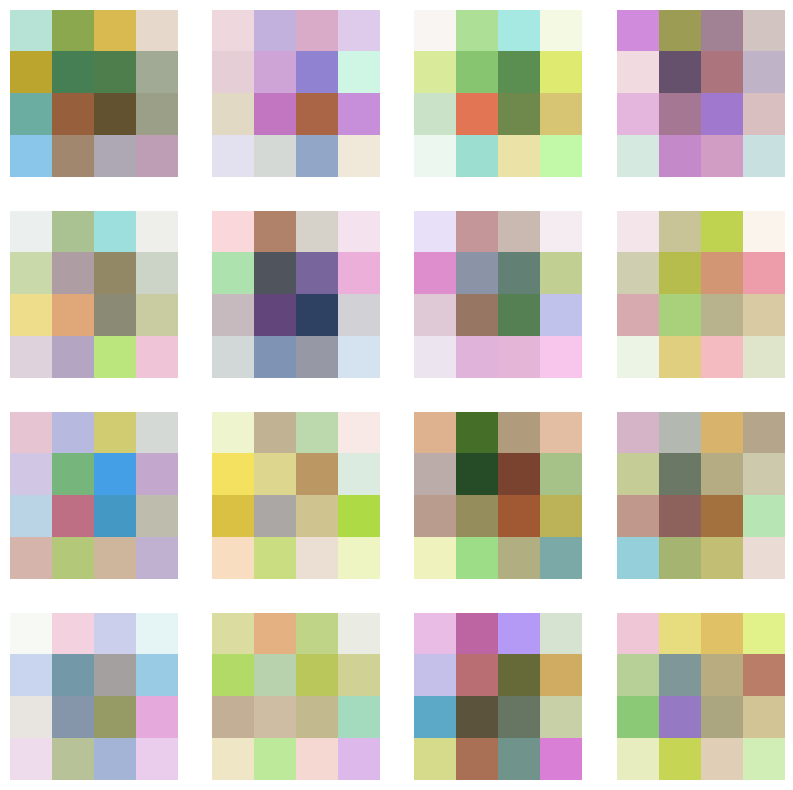

Step: 139
Alpha: 0.996385877119823
Current Resolution: 4
Discriminator loss : -2.0188357830047607
Generator loss: 4.810793399810791


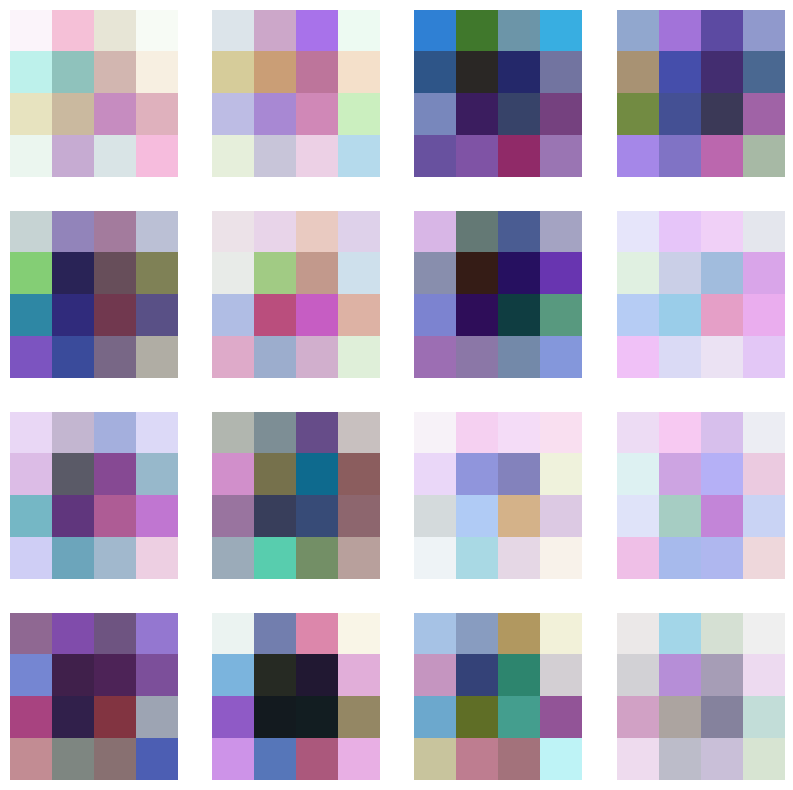

Step: 140
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -2.0079500675201416
Generator loss: 4.790191650390625


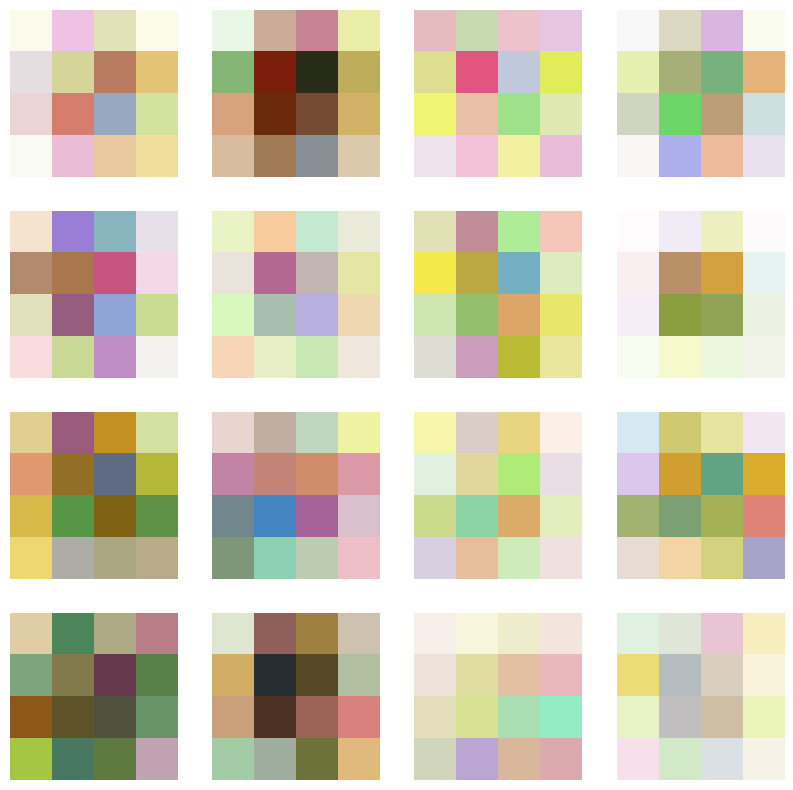

Step: 141
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9977476596832275
Generator loss: 4.771003723144531


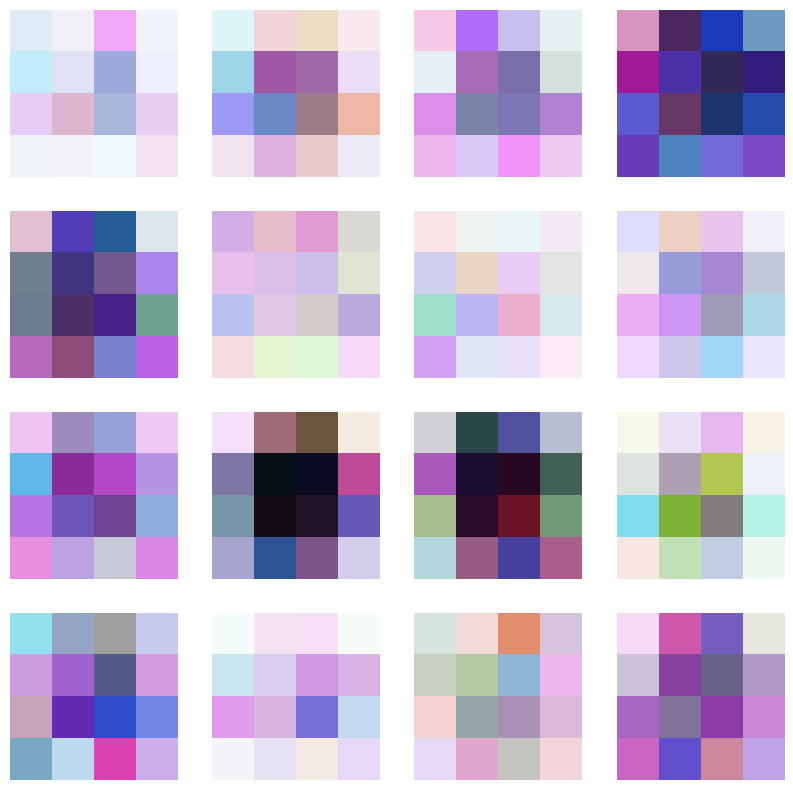

Step: 142
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9884878396987915
Generator loss: 4.7556538581848145


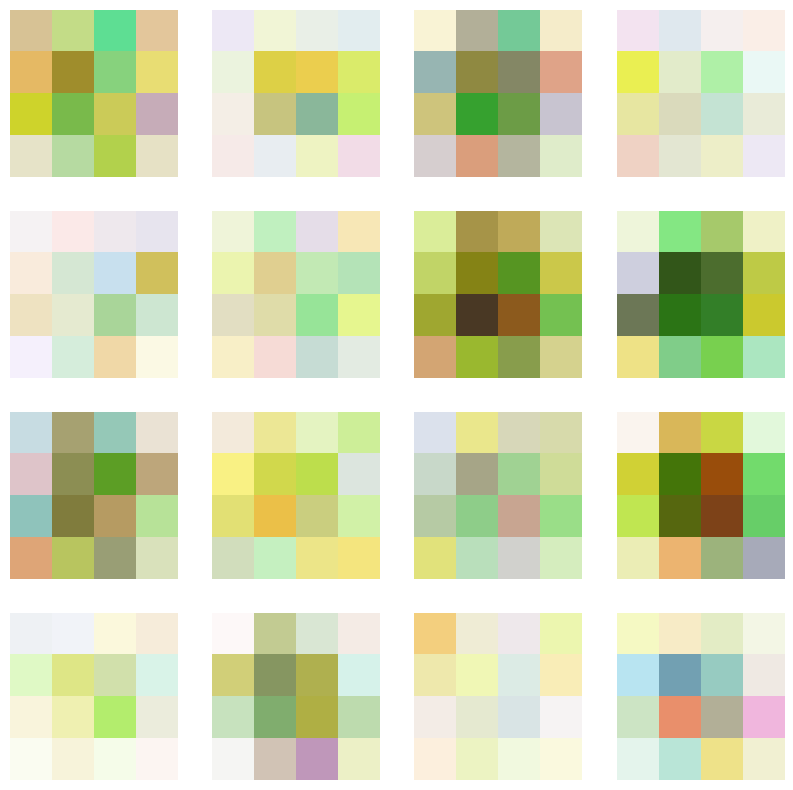

Step: 143
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9801186323165894
Generator loss: 4.738460063934326


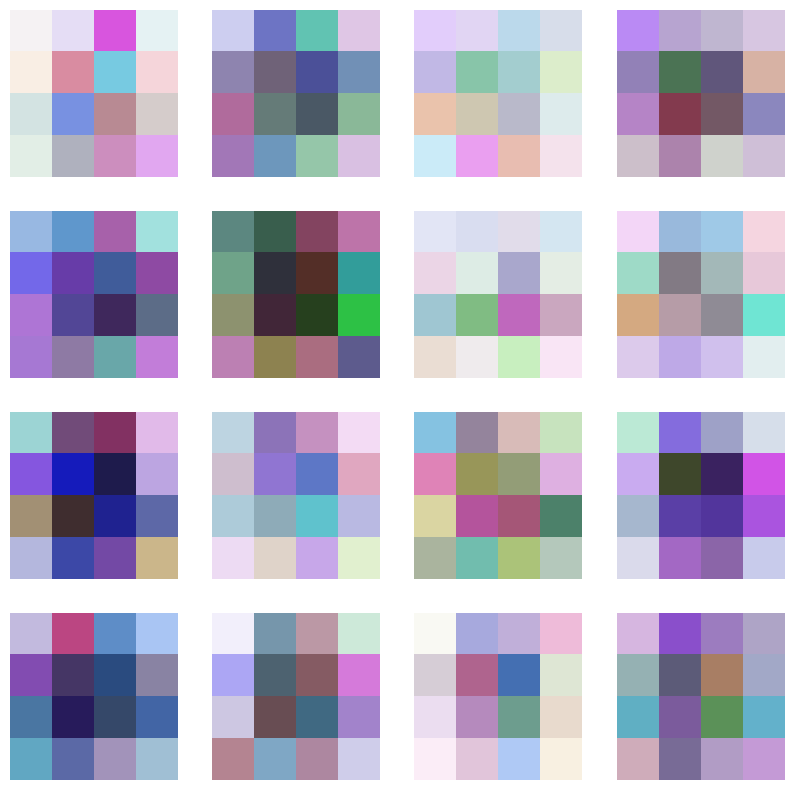

Step: 144
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9693691730499268
Generator loss: 4.716071128845215


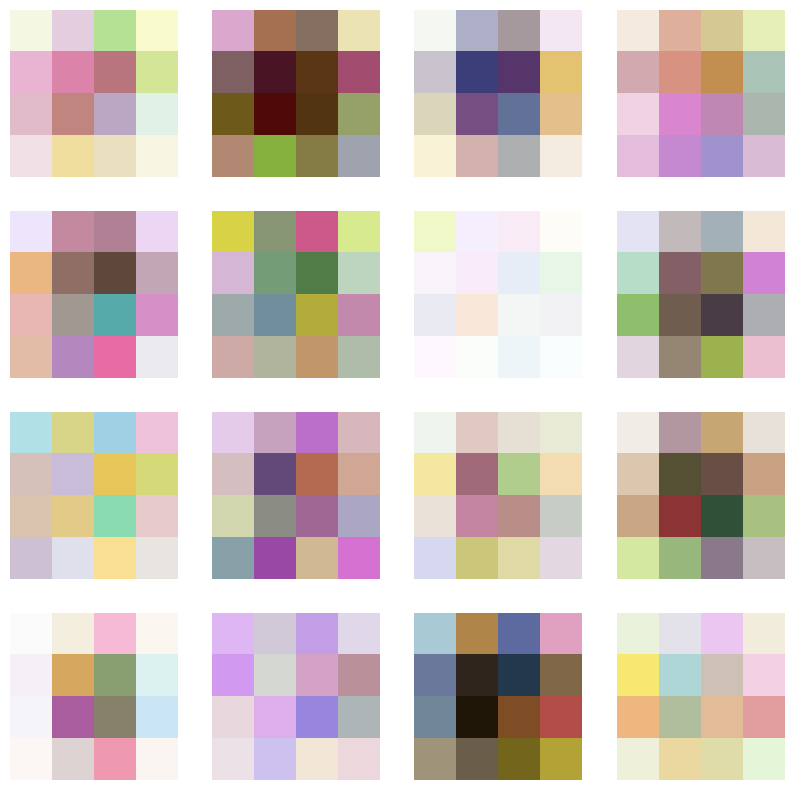

Step: 145
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9582245349884033
Generator loss: 4.6967387199401855


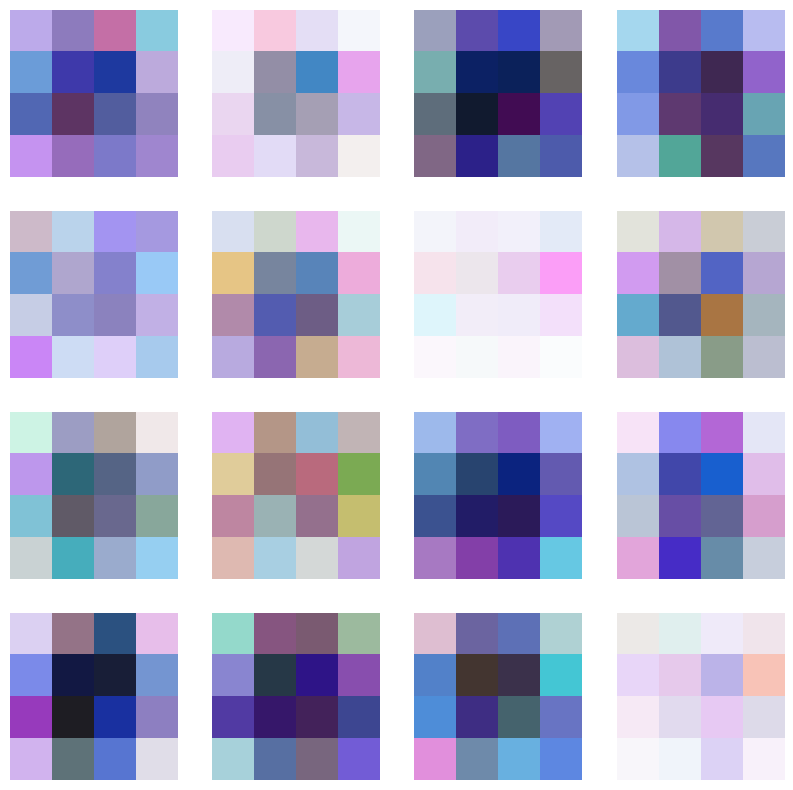

Step: 146
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9487136602401733
Generator loss: 4.676352024078369


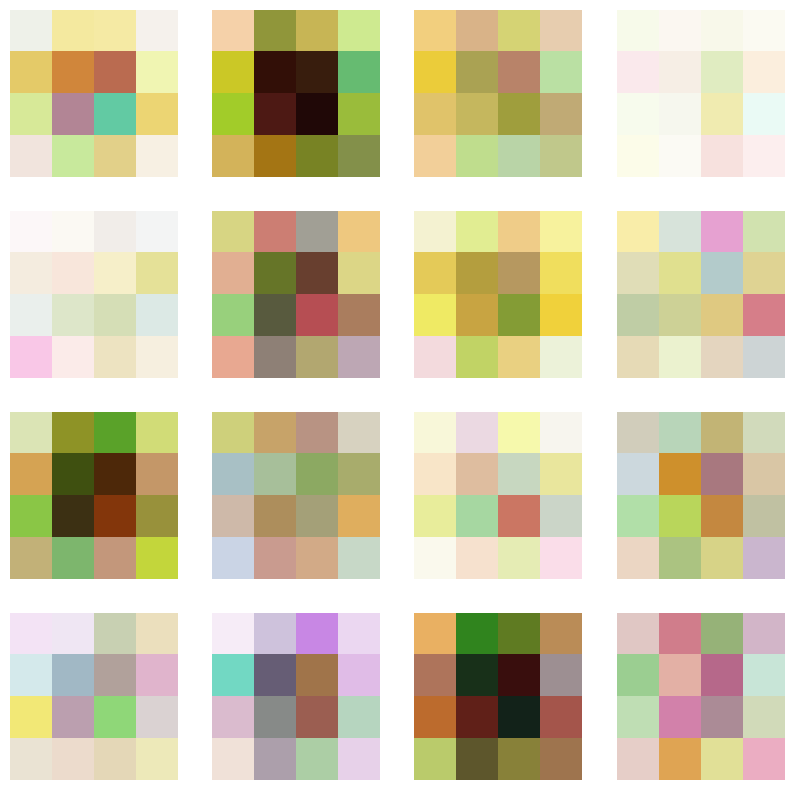

Step: 147
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9391504526138306
Generator loss: 4.656973838806152


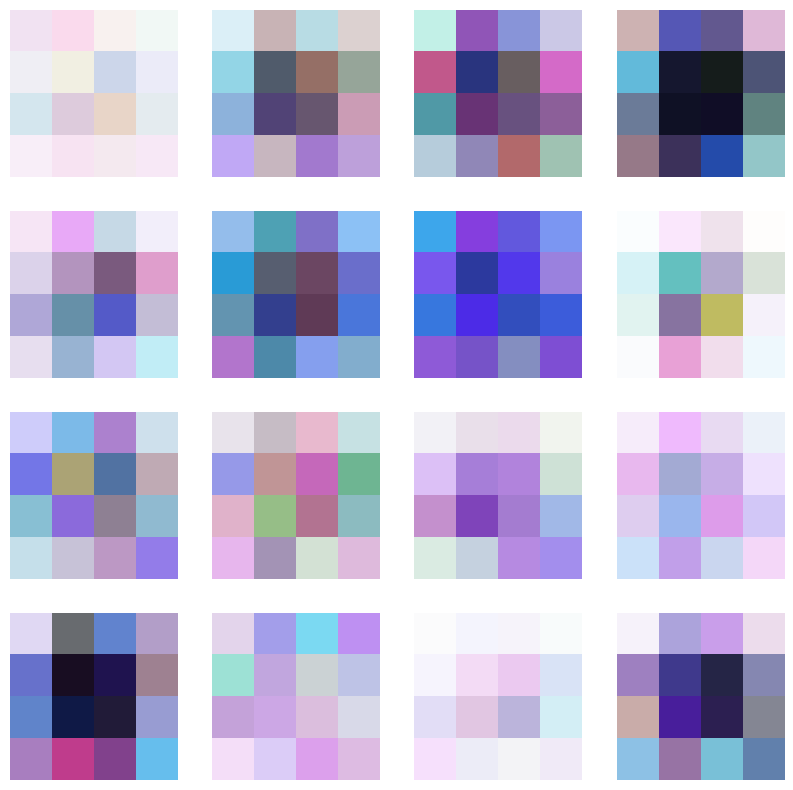

Step: 148
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9300411939620972
Generator loss: 4.638297080993652


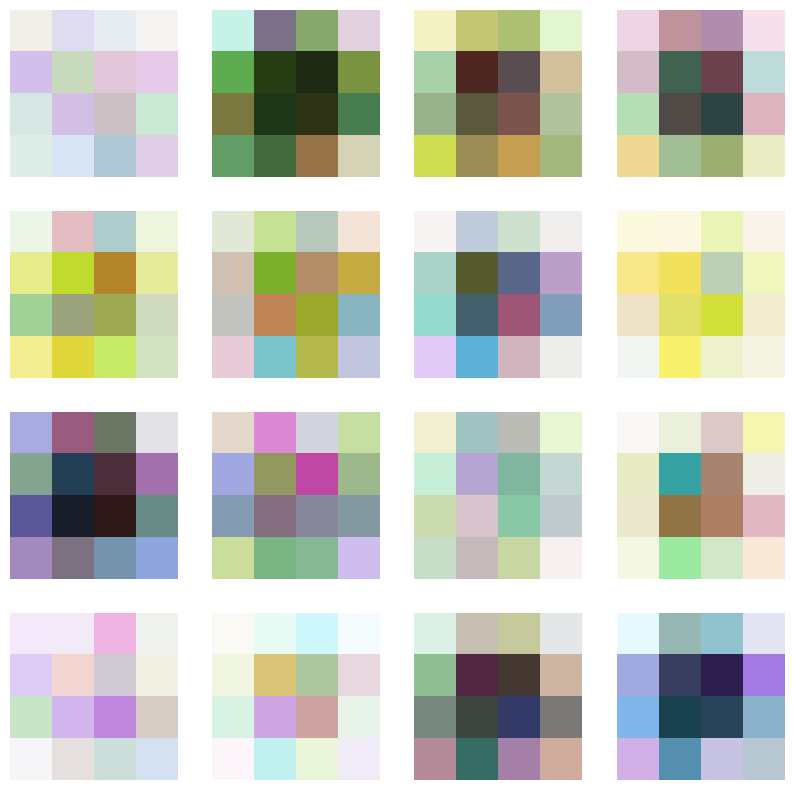

Step: 149
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9198685884475708
Generator loss: 4.619927406311035


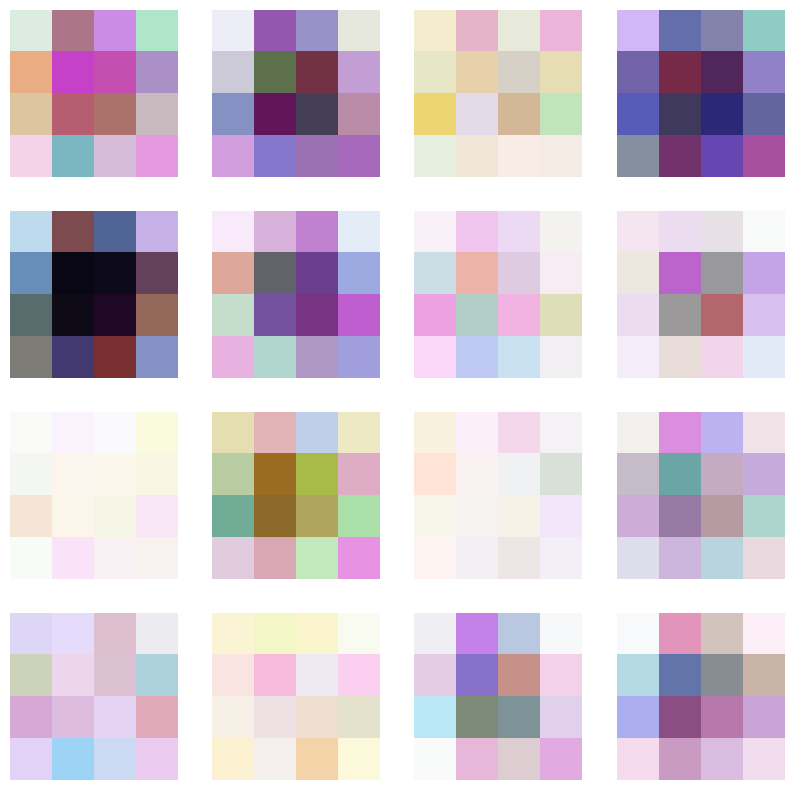

Step: 150
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.9097999334335327
Generator loss: 4.603539943695068


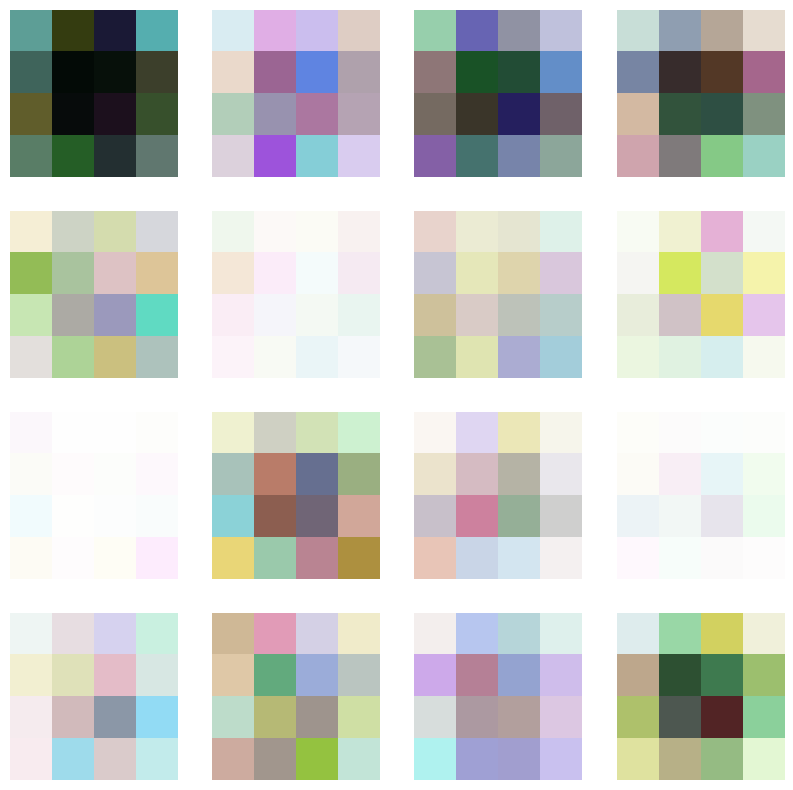

Step: 151
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.898290991783142
Generator loss: 4.581820011138916


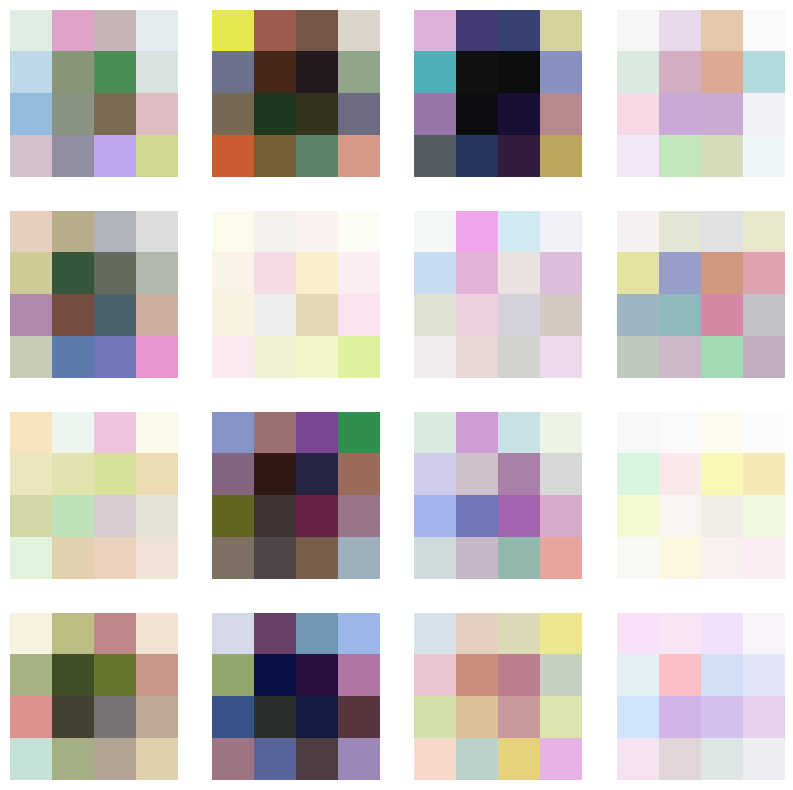

Step: 152
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.887766718864441
Generator loss: 4.56221342086792


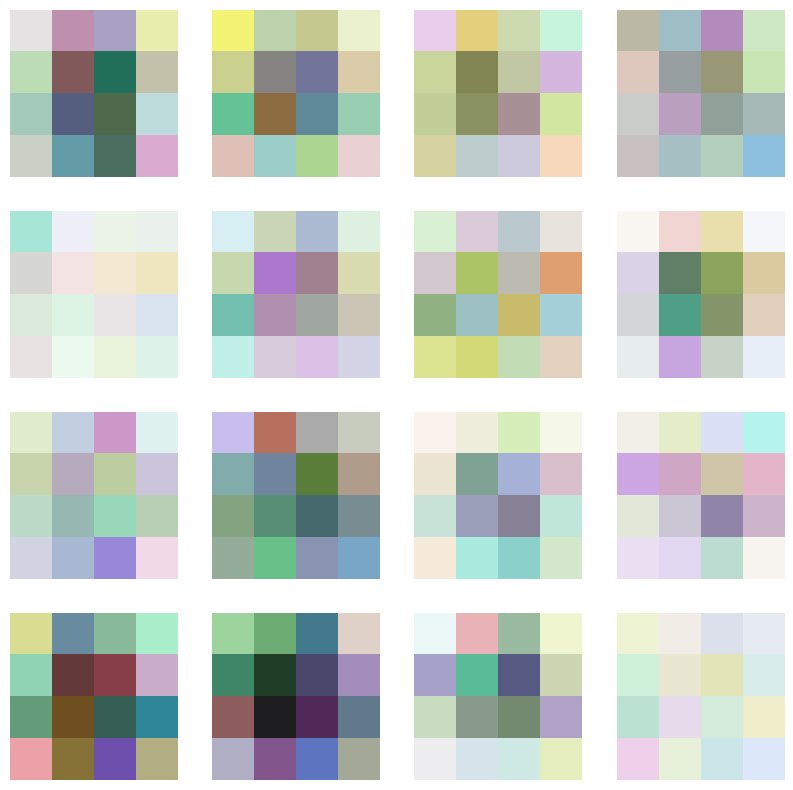

Step: 153
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.8775907754898071
Generator loss: 4.541888236999512


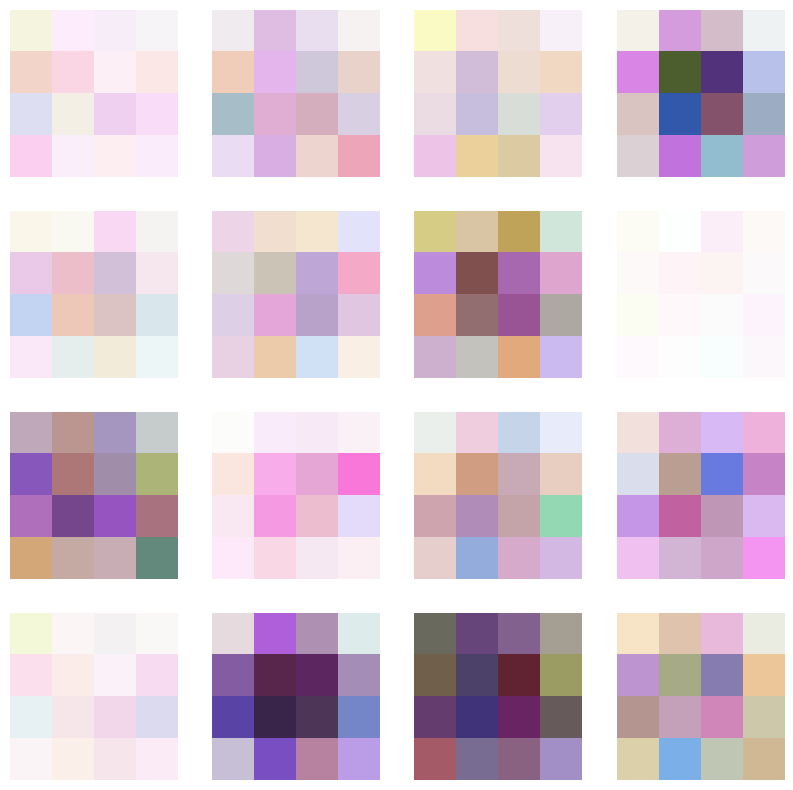

Step: 154
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.8677982091903687
Generator loss: 4.522294044494629


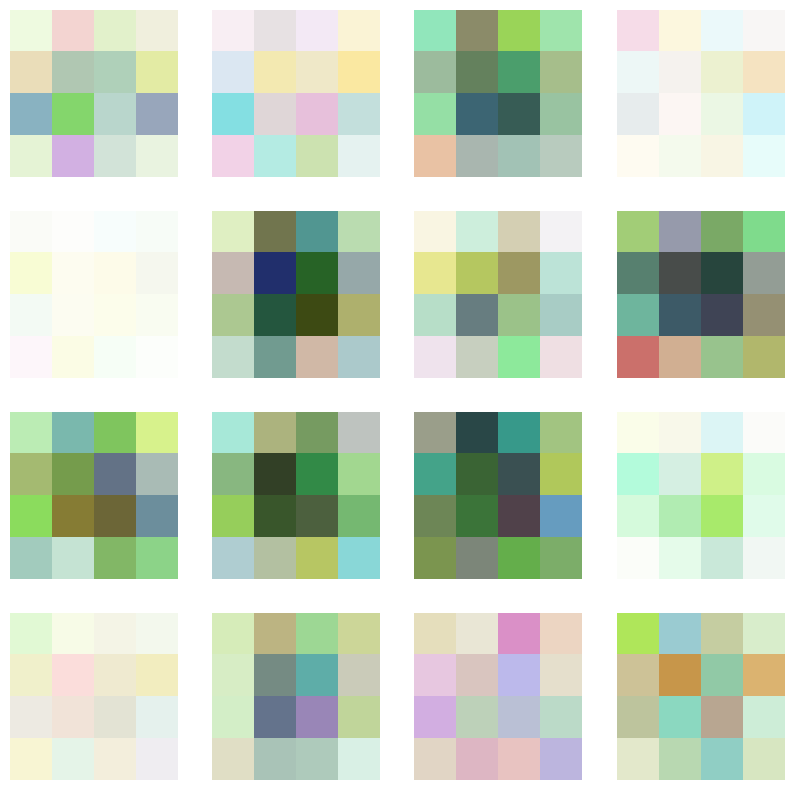

Step: 155
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.858789324760437
Generator loss: 4.501297950744629


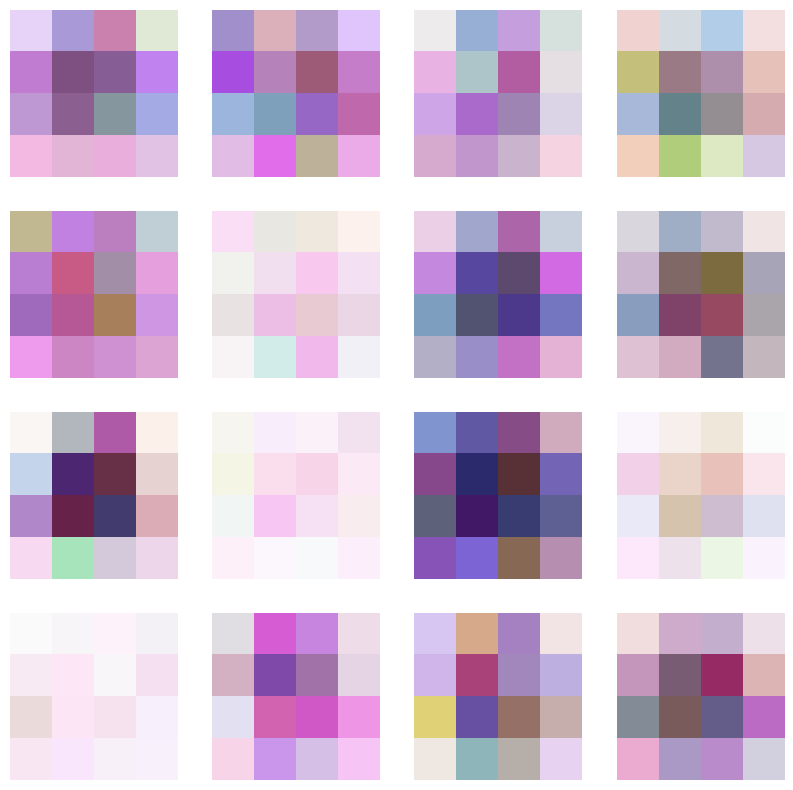

Step: 156
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.8493212461471558
Generator loss: 4.481894493103027


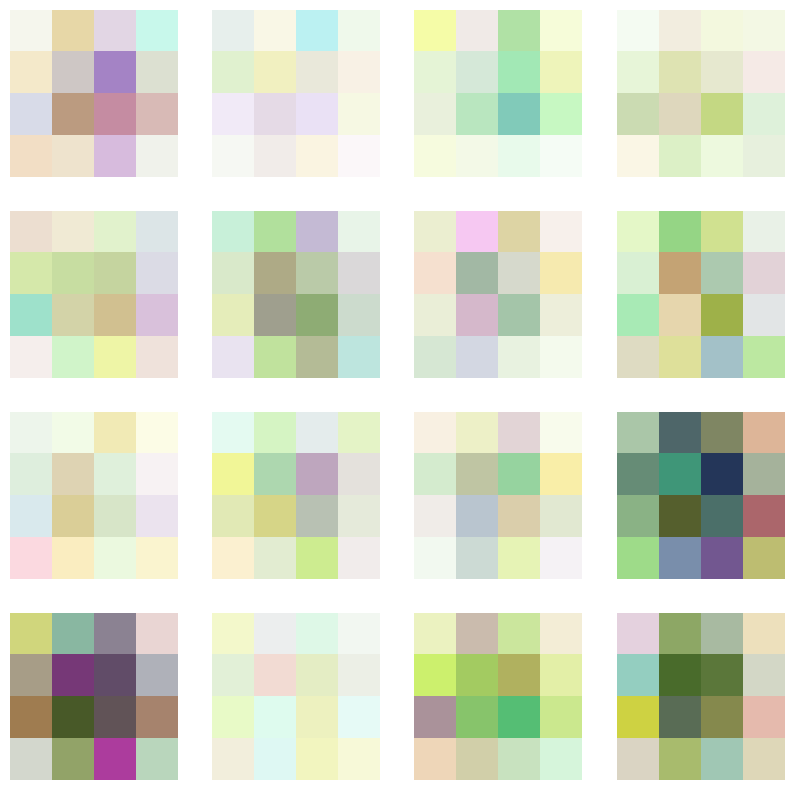

Step: 157
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.8399773836135864
Generator loss: 4.465306758880615


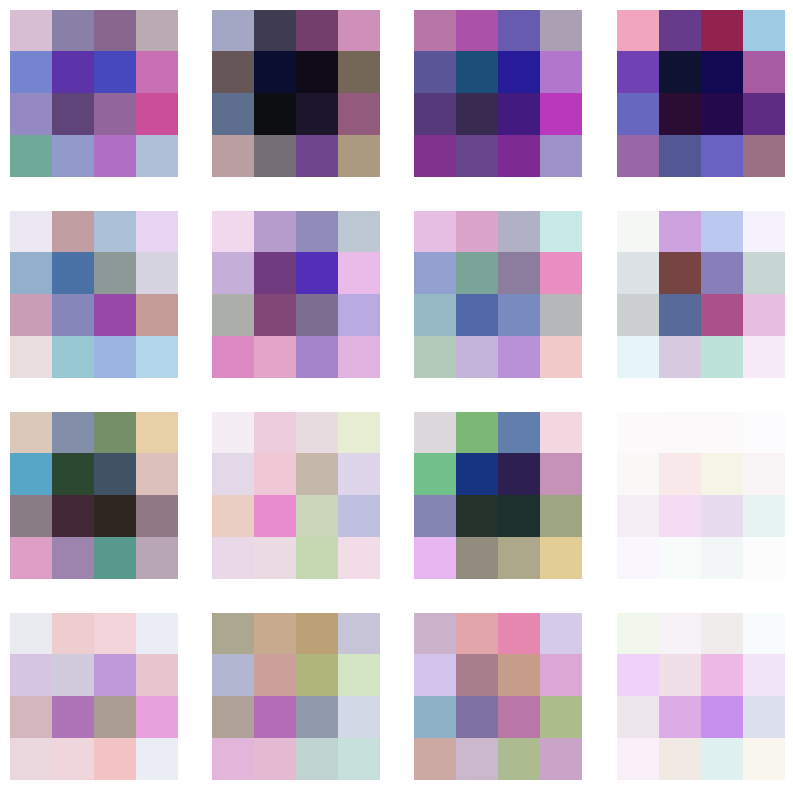

Step: 158
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.831493854522705
Generator loss: 4.447855472564697


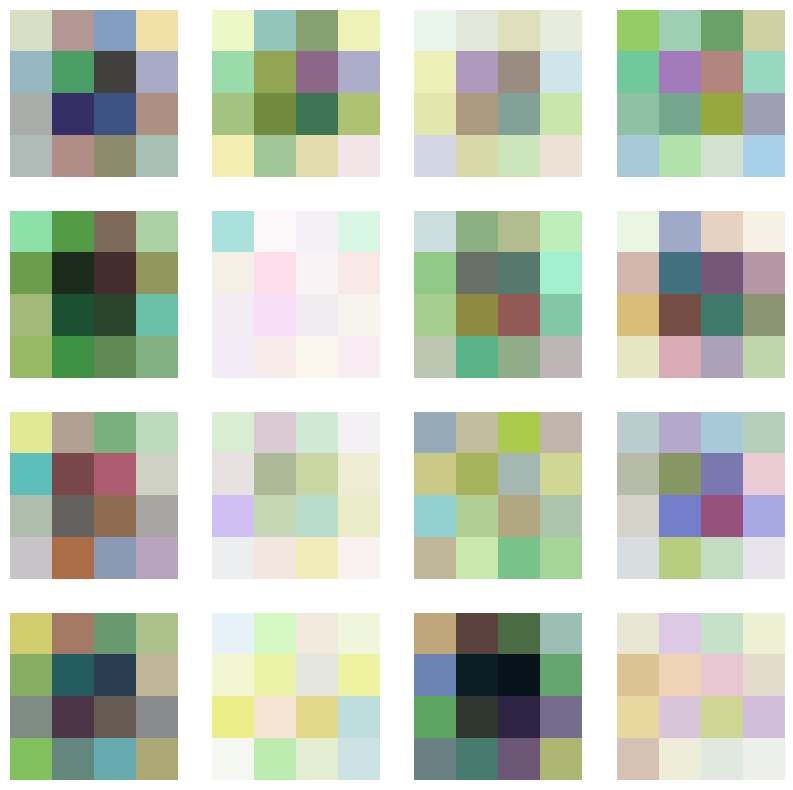

Step: 159
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.8222682476043701
Generator loss: 4.427115440368652


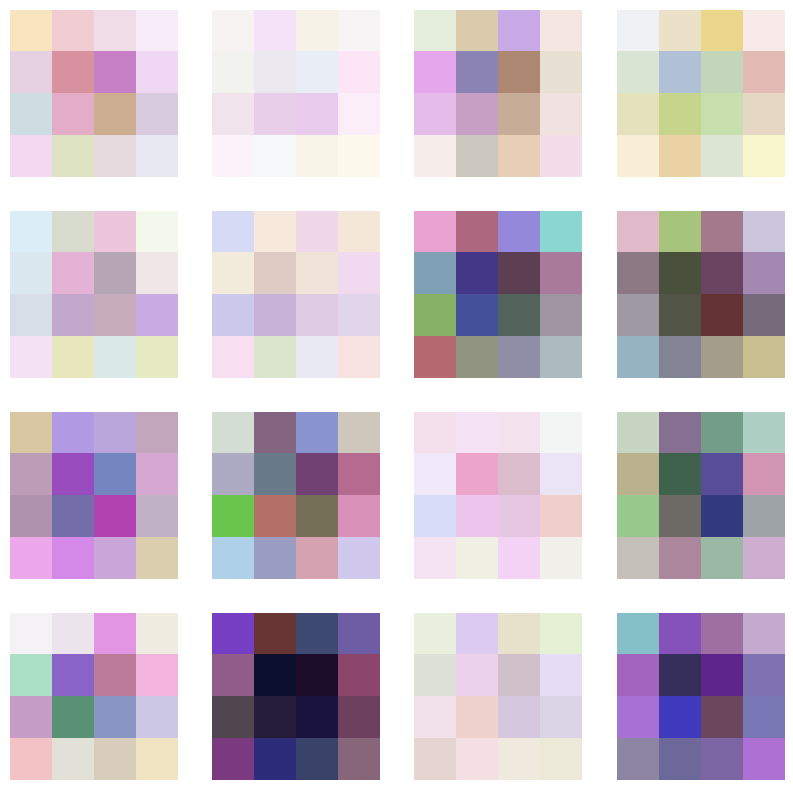

Step: 160
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.8132262229919434
Generator loss: 4.407069683074951


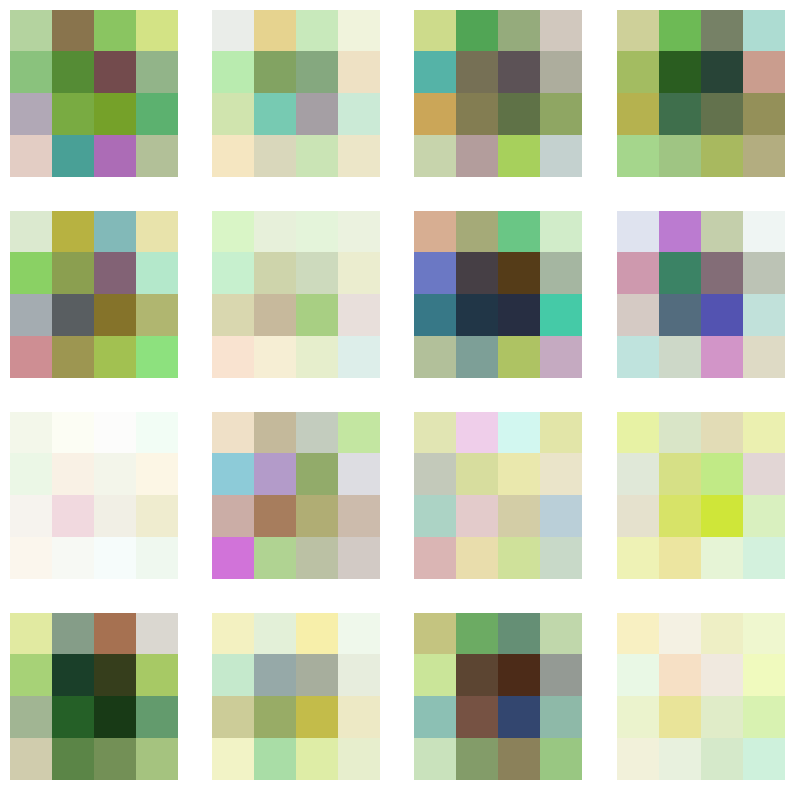

Step: 161
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.8040401935577393
Generator loss: 4.390538215637207


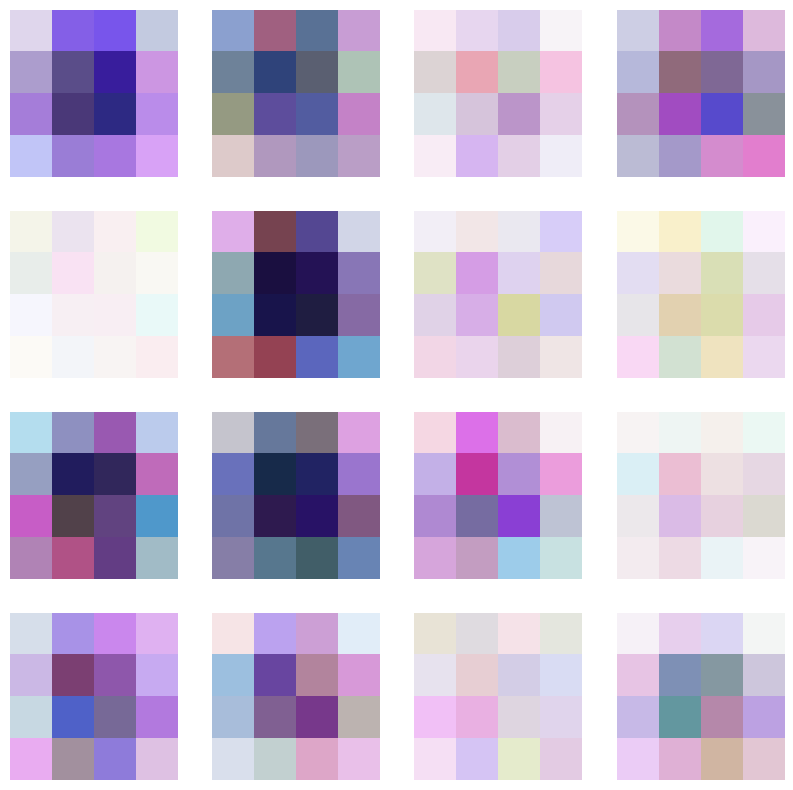

Step: 162
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7961455583572388
Generator loss: 4.371770858764648


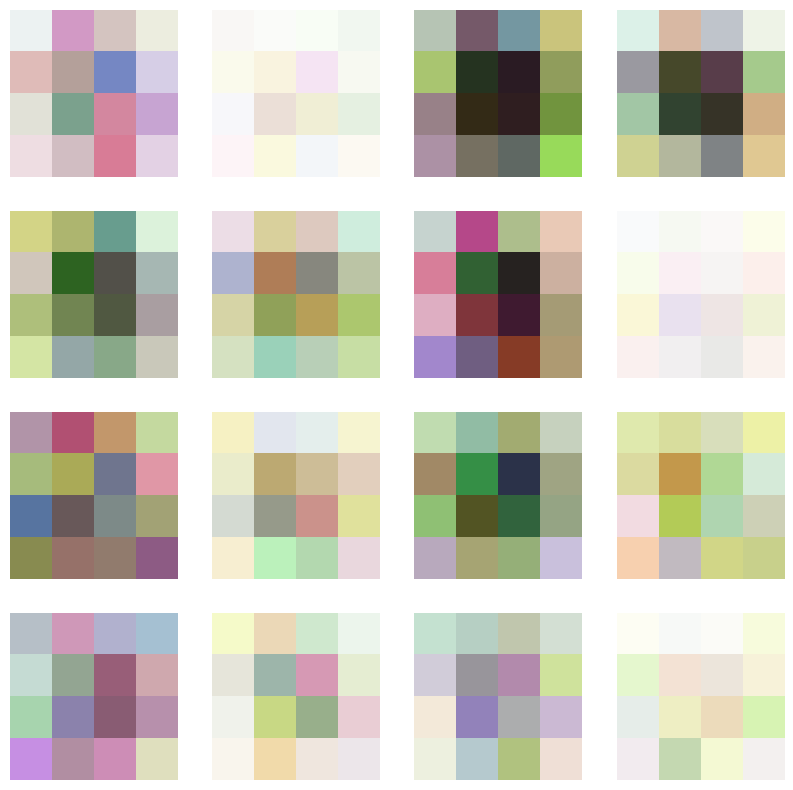

Step: 163
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7872035503387451
Generator loss: 4.35312032699585


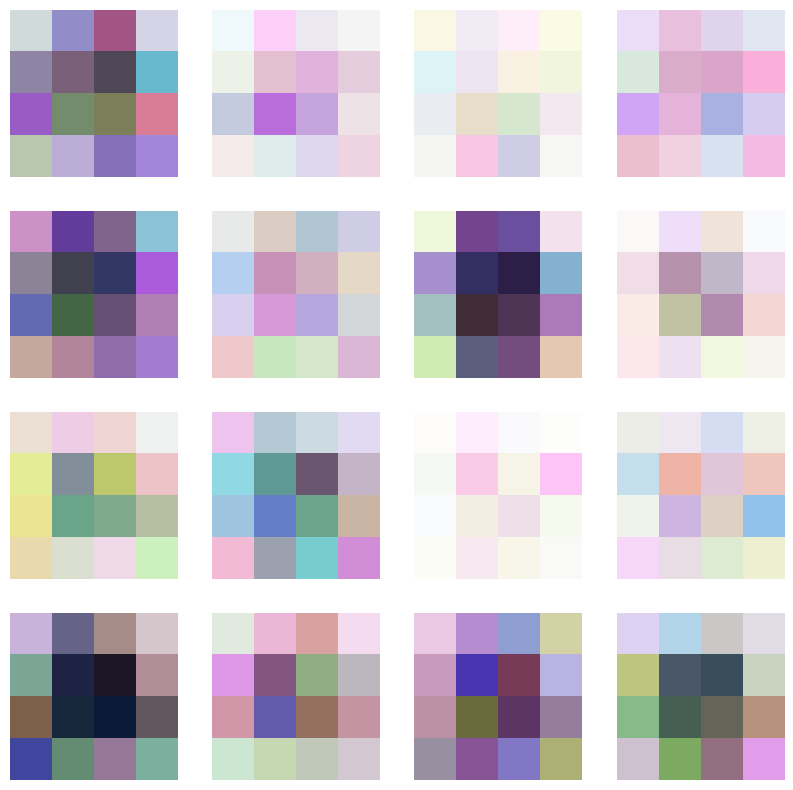

Step: 164
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7775338888168335
Generator loss: 4.334538459777832


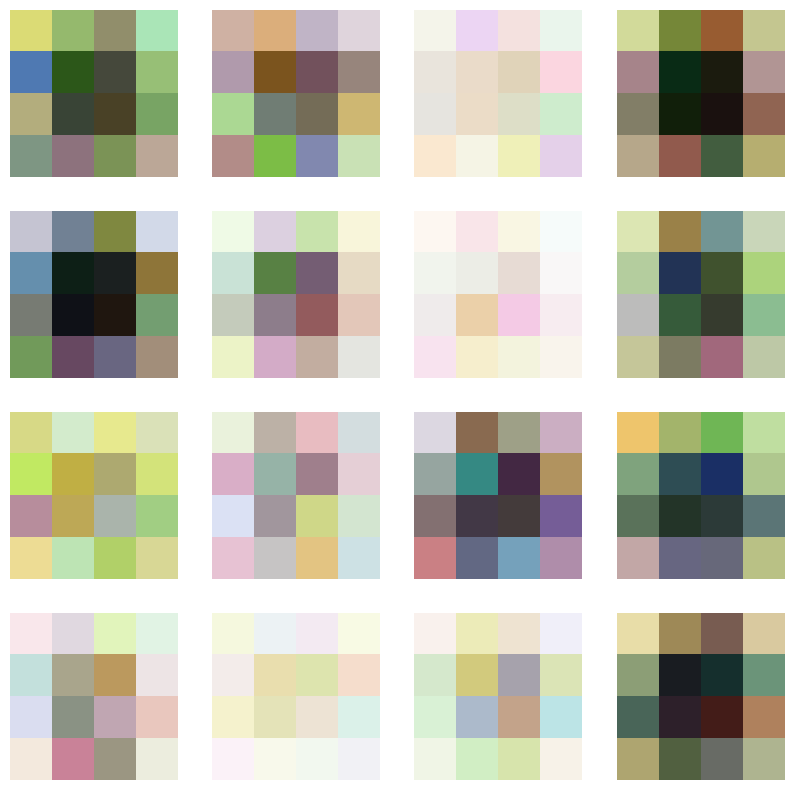

Step: 165
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7687320709228516
Generator loss: 4.315214157104492


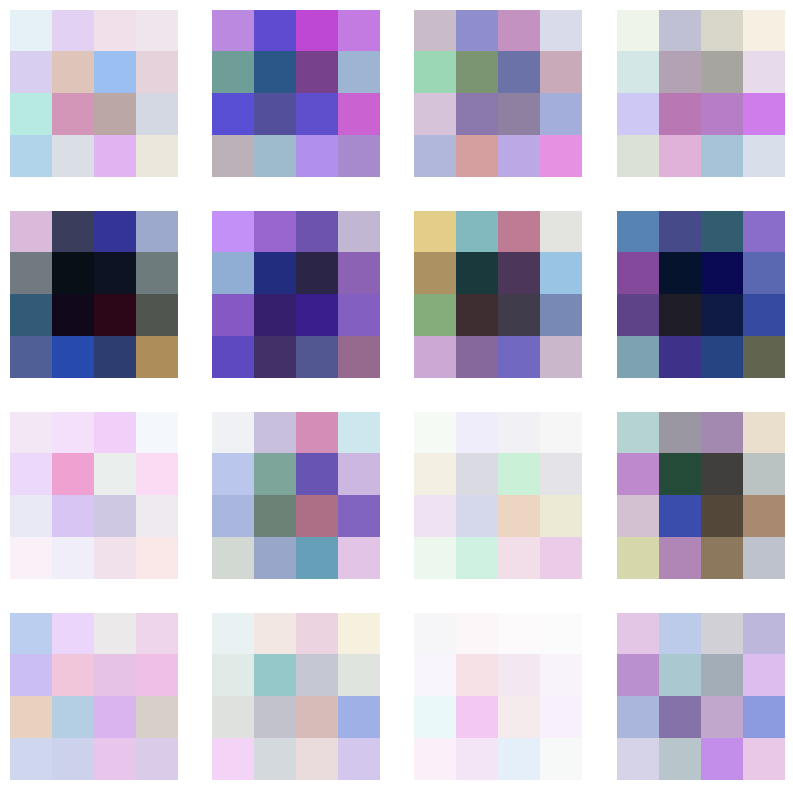

Step: 166
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.760820984840393
Generator loss: 4.296364784240723


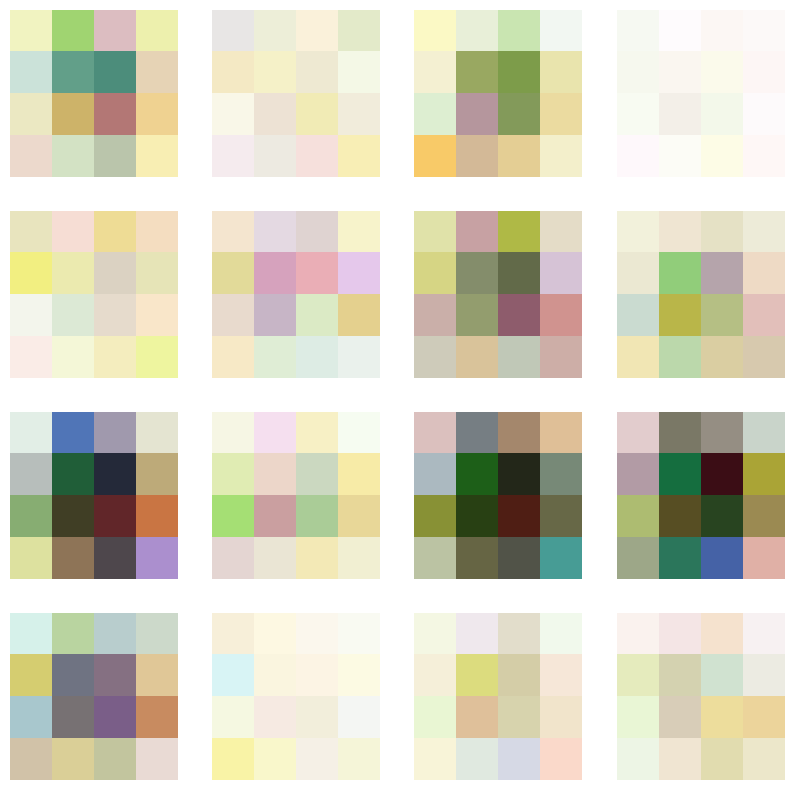

Step: 167
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.752507209777832
Generator loss: 4.279268741607666


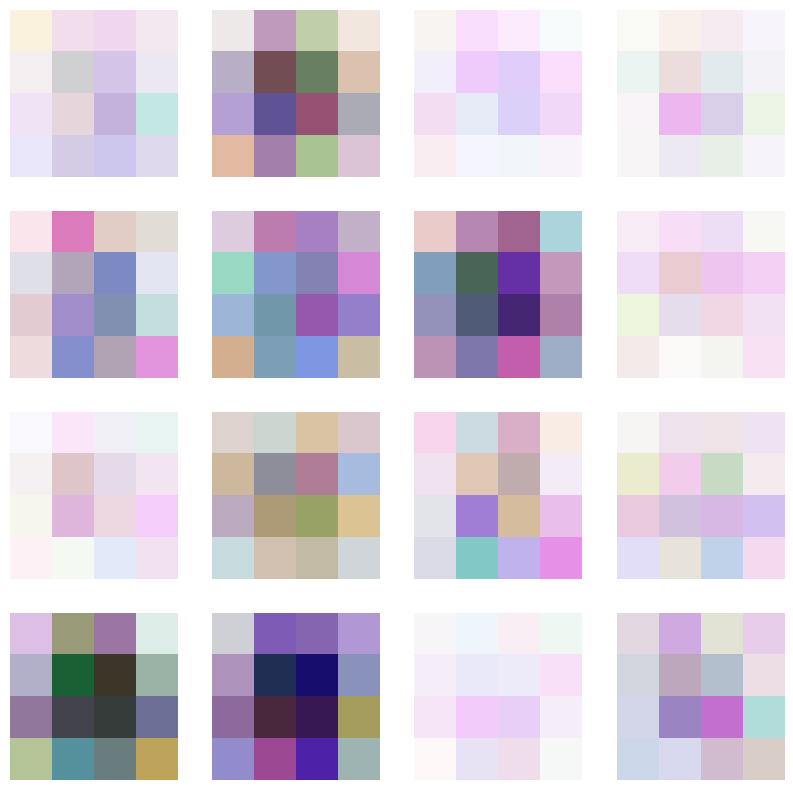

Step: 168
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7442677021026611
Generator loss: 4.263469696044922


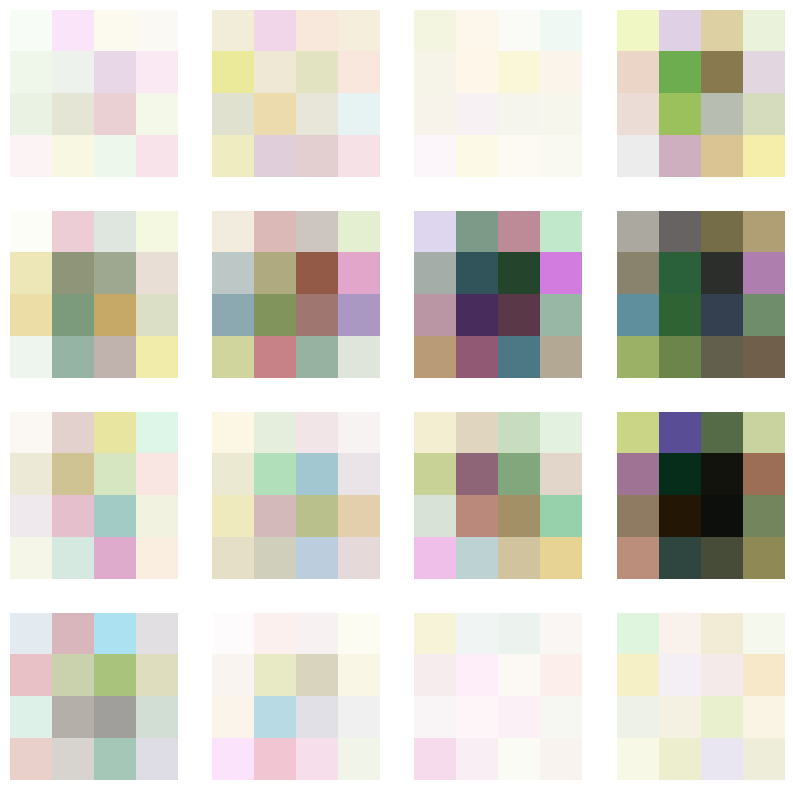

Step: 169
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.735898733139038
Generator loss: 4.250317573547363


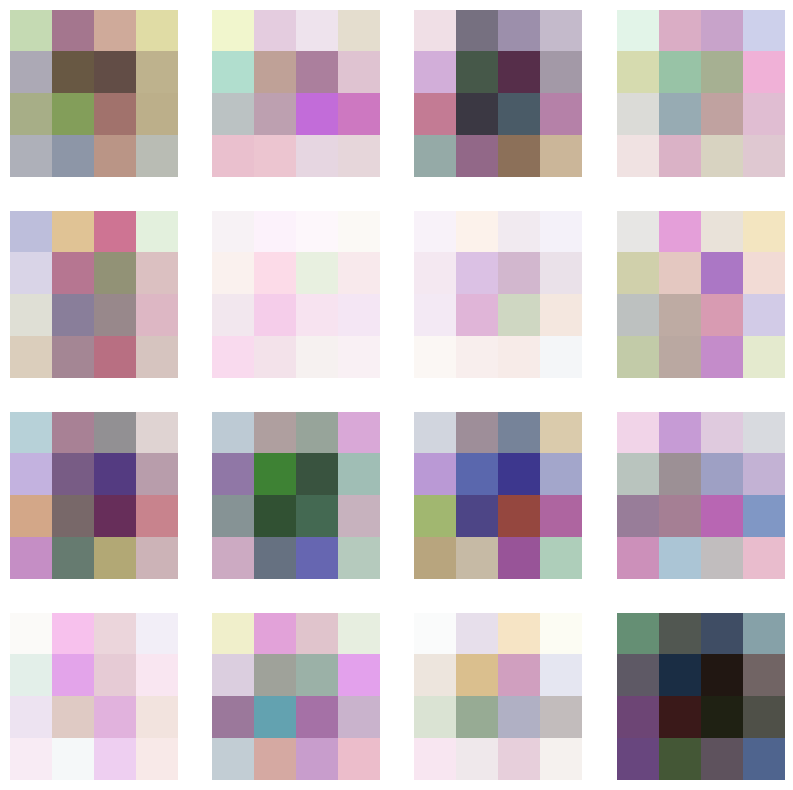

Step: 170
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7277123928070068
Generator loss: 4.237604141235352


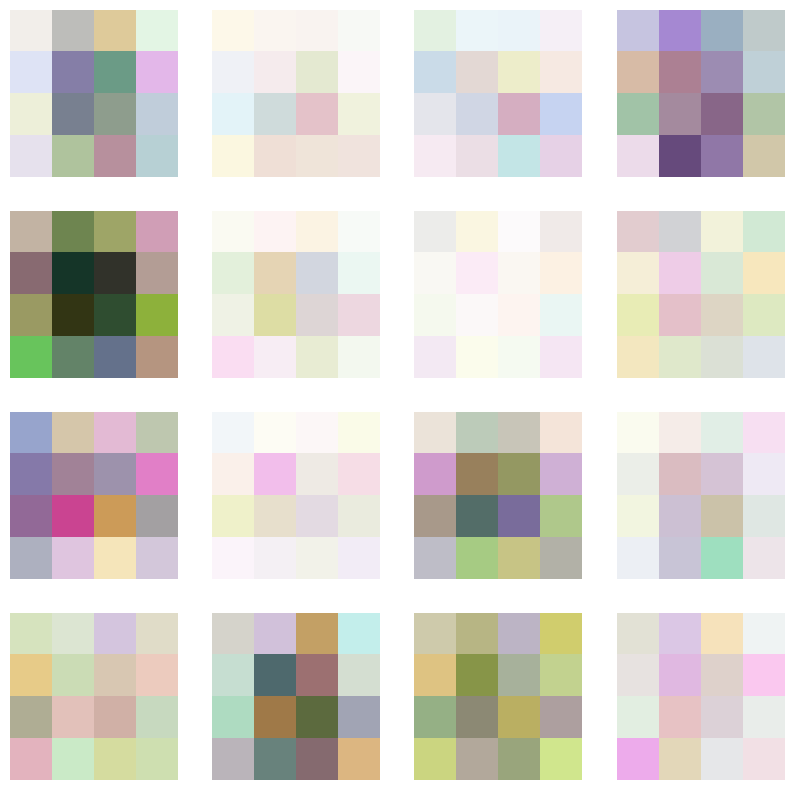

Step: 171
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7176876068115234
Generator loss: 4.218681812286377


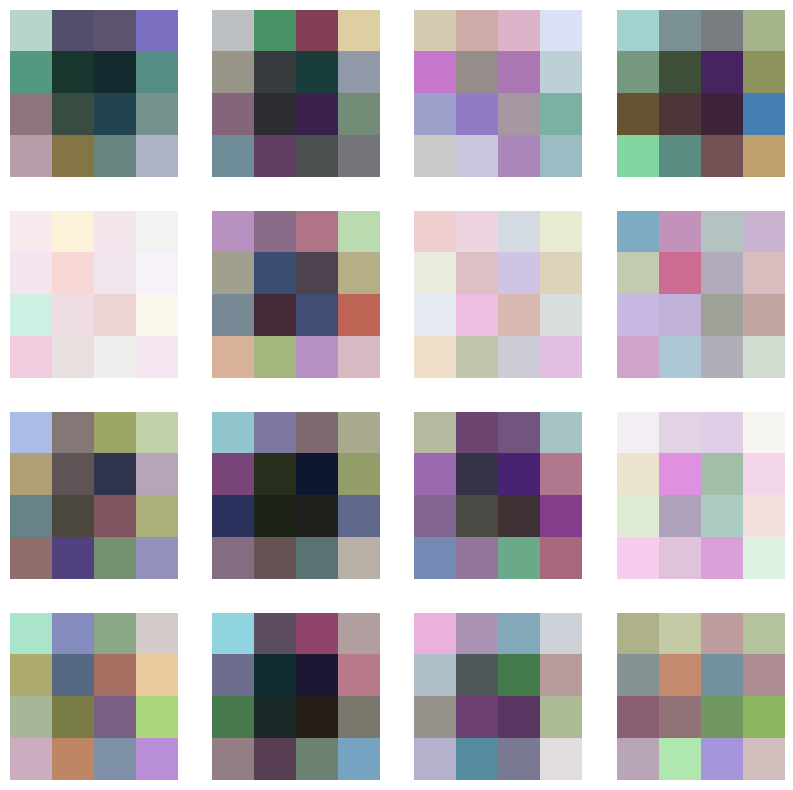

Step: 172
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7085349559783936
Generator loss: 4.199936389923096


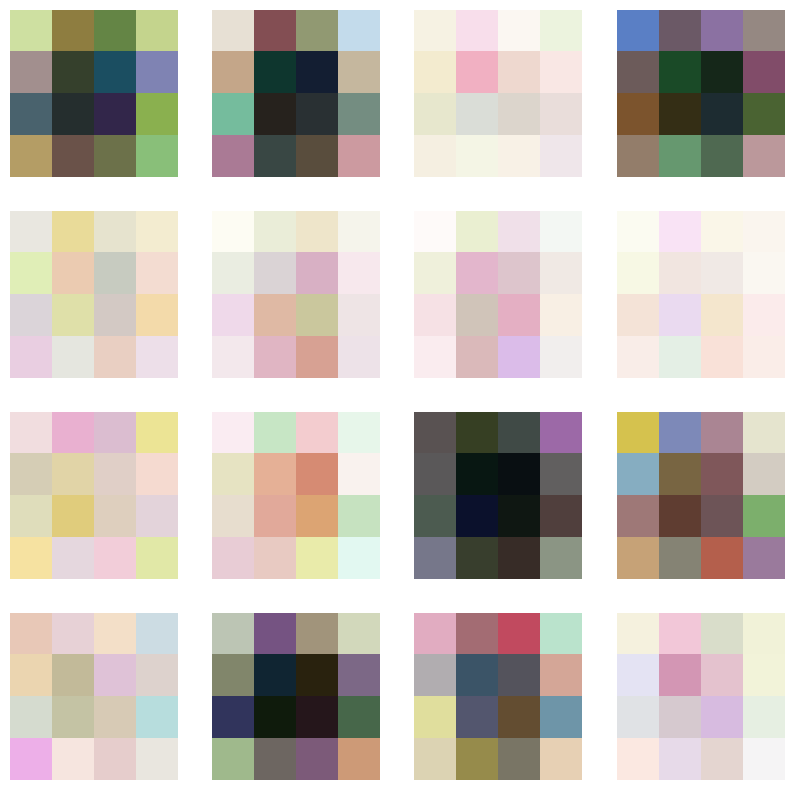

Step: 173
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.7003259658813477
Generator loss: 4.181016445159912


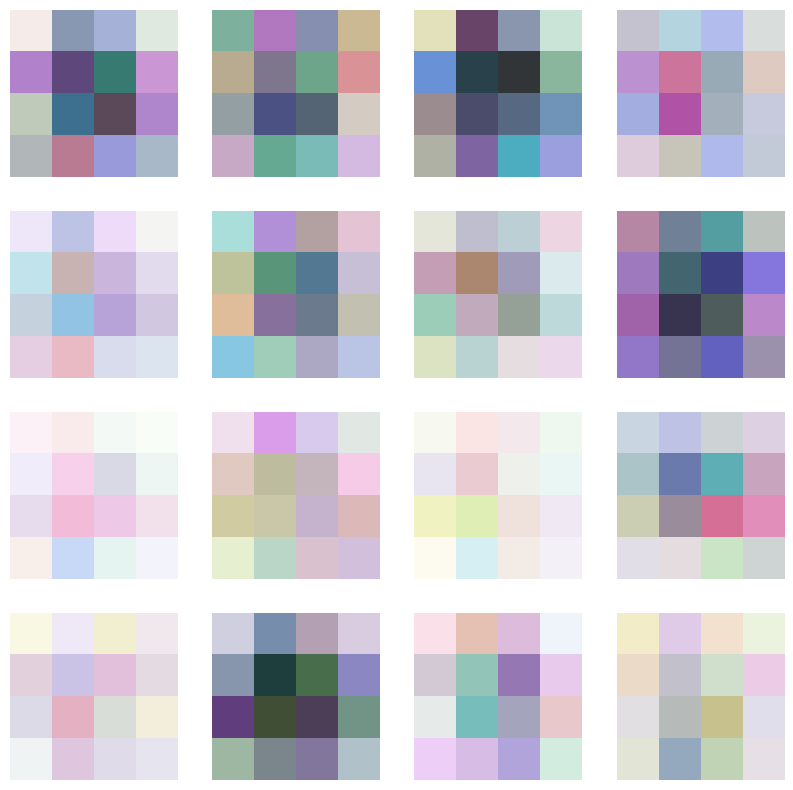

Step: 174
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6921449899673462
Generator loss: 4.160895347595215


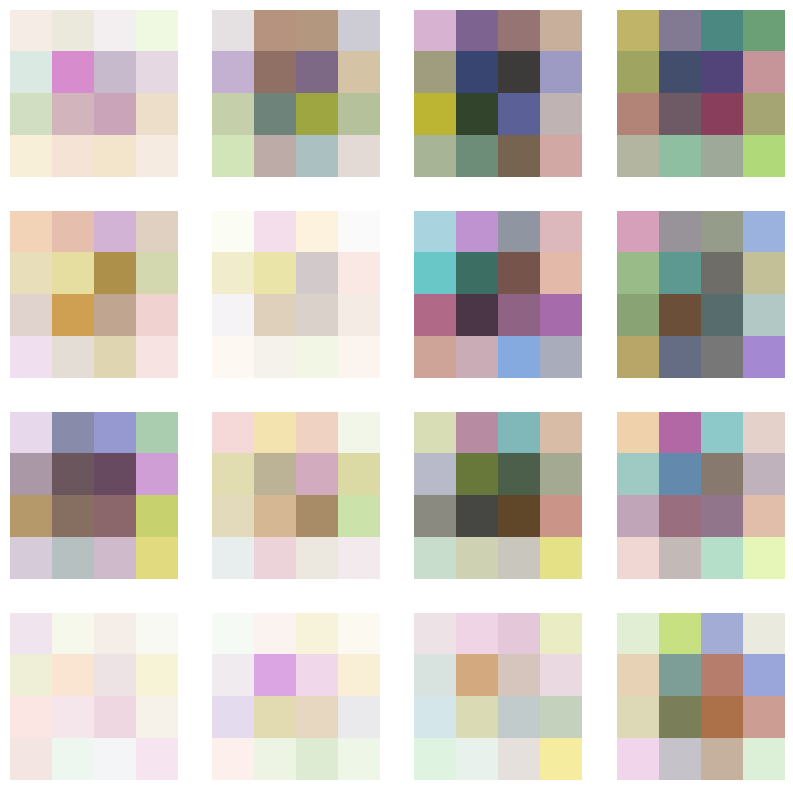

Step: 175
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6837196350097656
Generator loss: 4.141643047332764


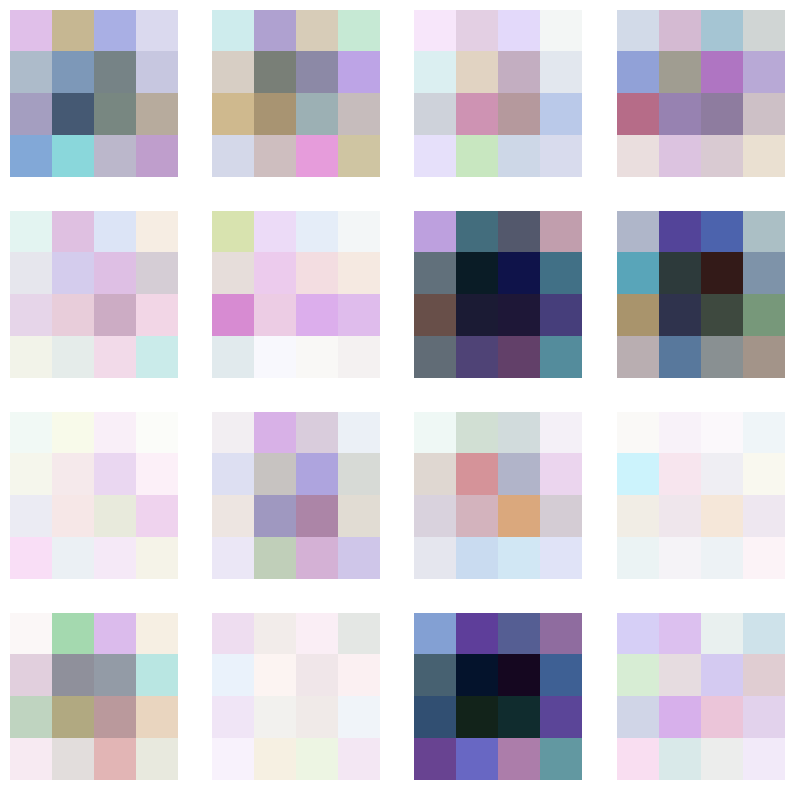

Step: 176
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.675681471824646
Generator loss: 4.126739501953125


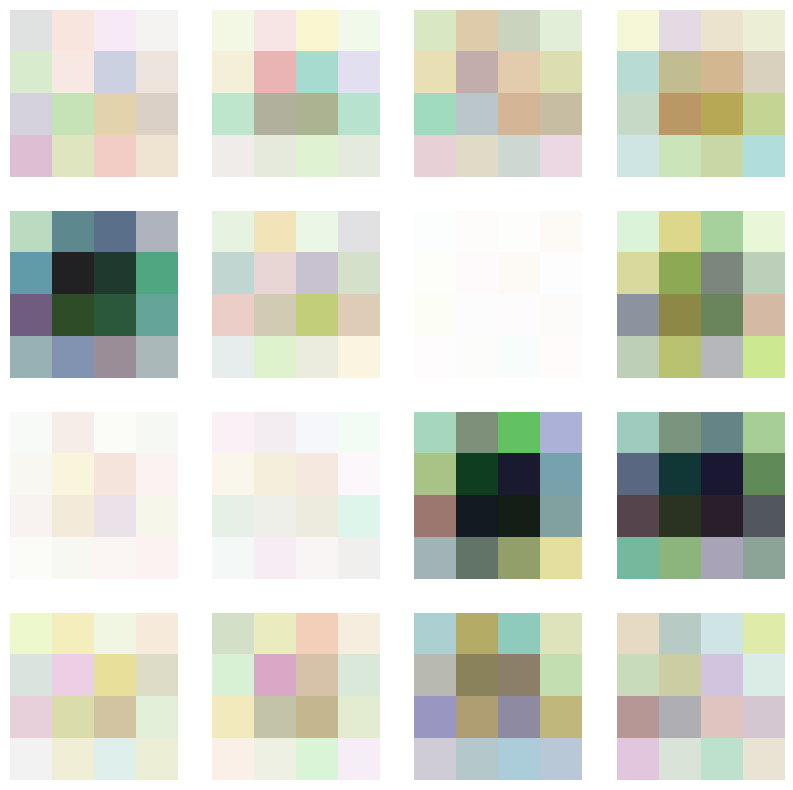

Step: 177
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6682053804397583
Generator loss: 4.114055633544922


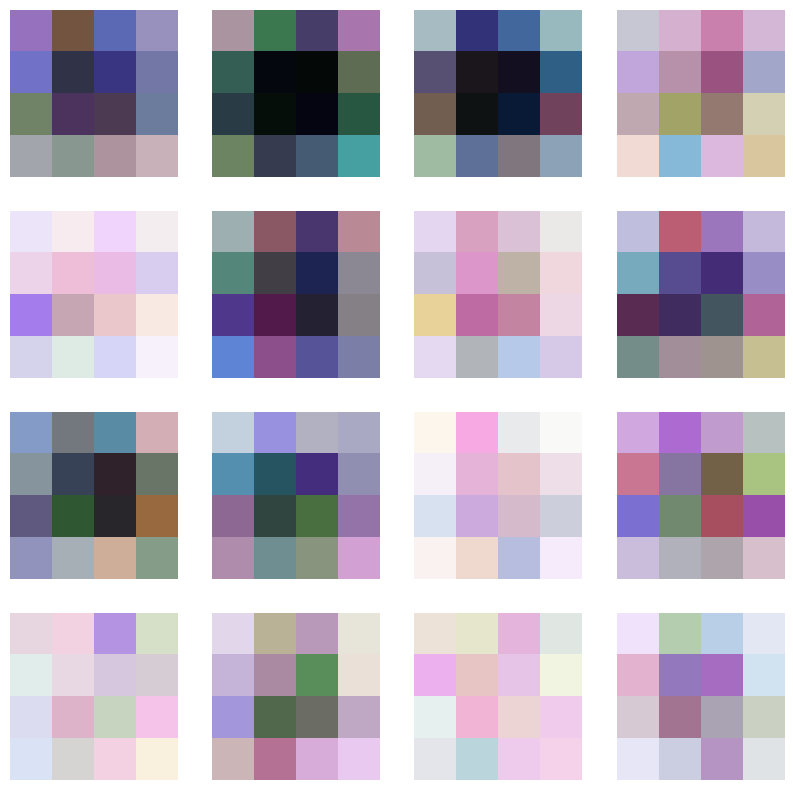

Step: 178
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.660807728767395
Generator loss: 4.0988264083862305


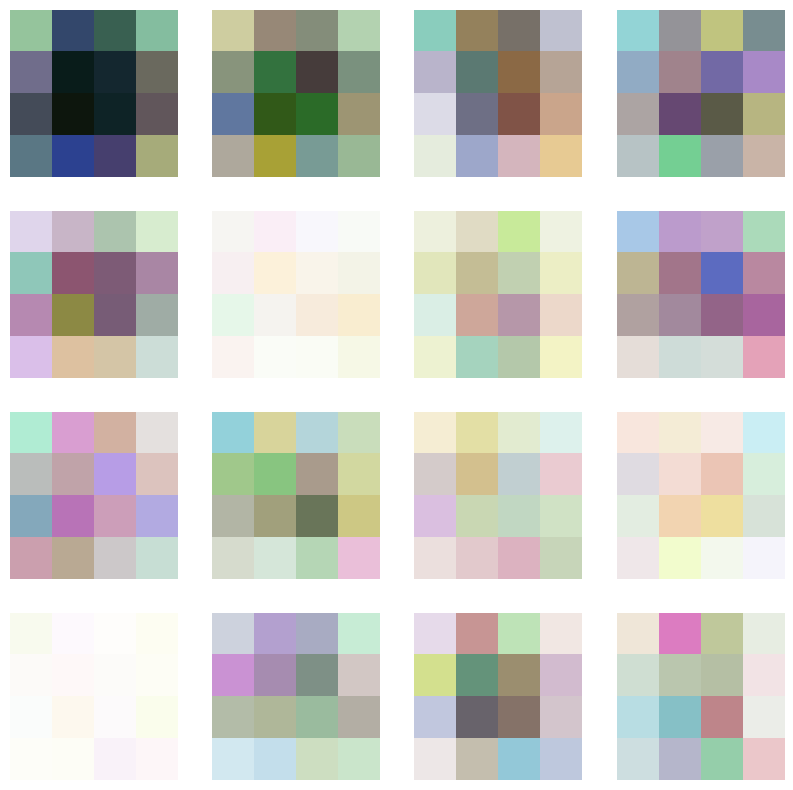

Step: 179
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6527148485183716
Generator loss: 4.083564758300781


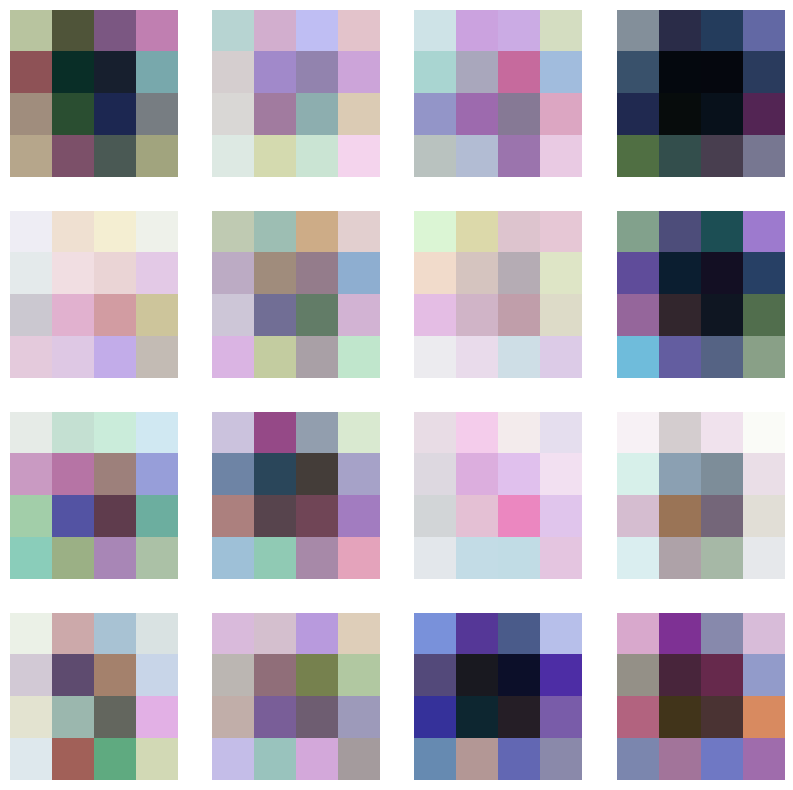

Step: 180
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.644045352935791
Generator loss: 4.064728260040283


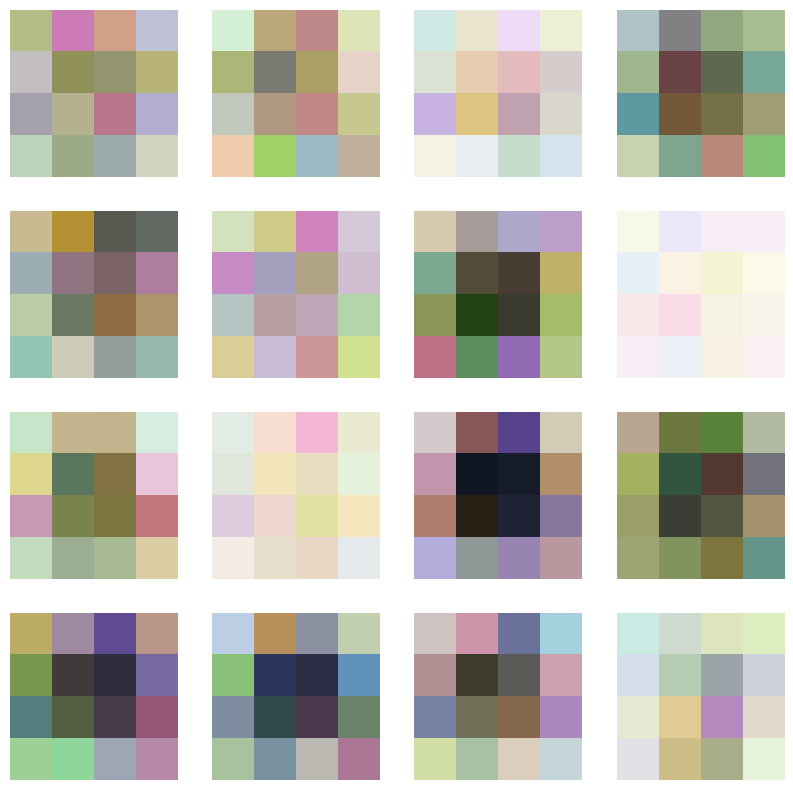

Step: 181
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6369215250015259
Generator loss: 4.046401023864746


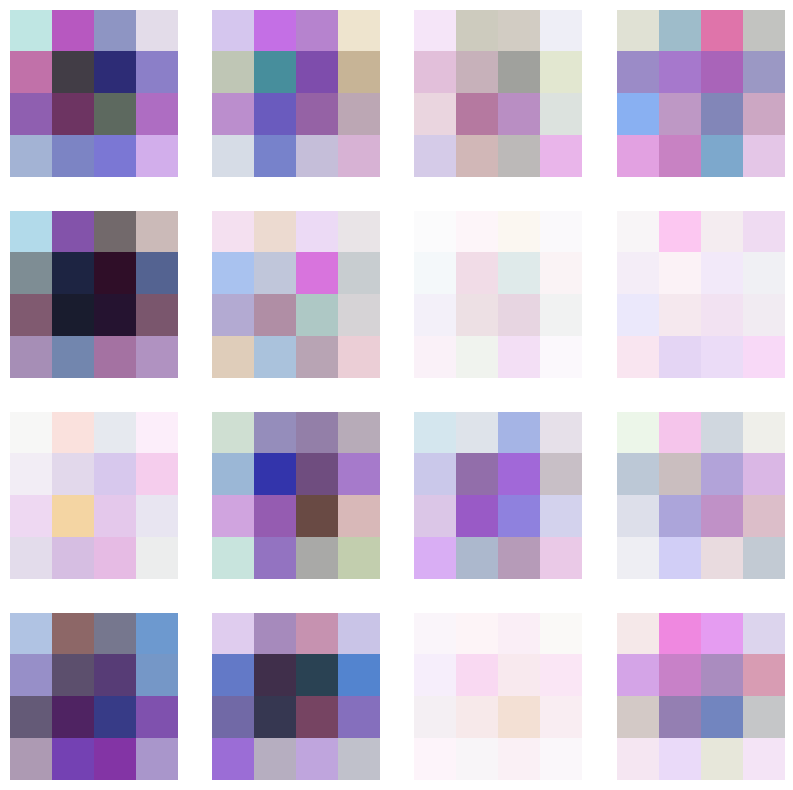

Step: 182
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6297723054885864
Generator loss: 4.031065464019775


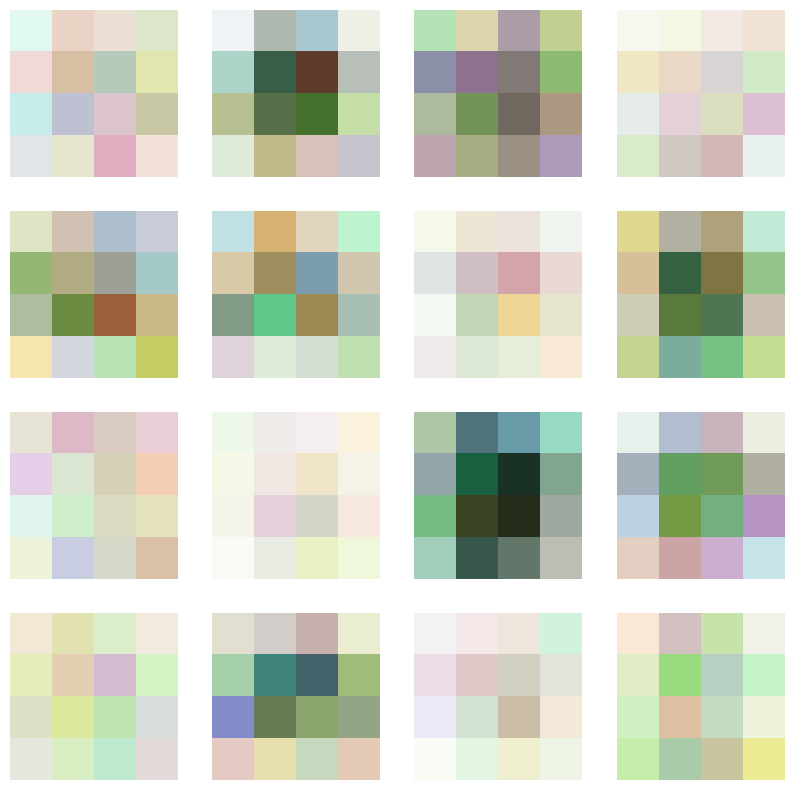

Step: 183
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6228574514389038
Generator loss: 4.0170979499816895


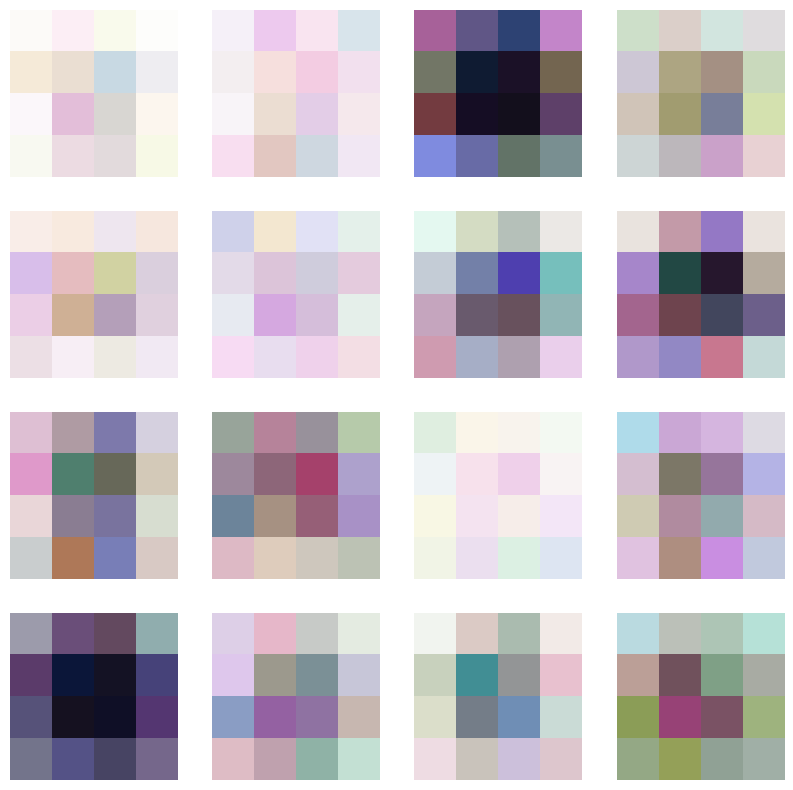

Step: 184
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6159660816192627
Generator loss: 4.002279758453369


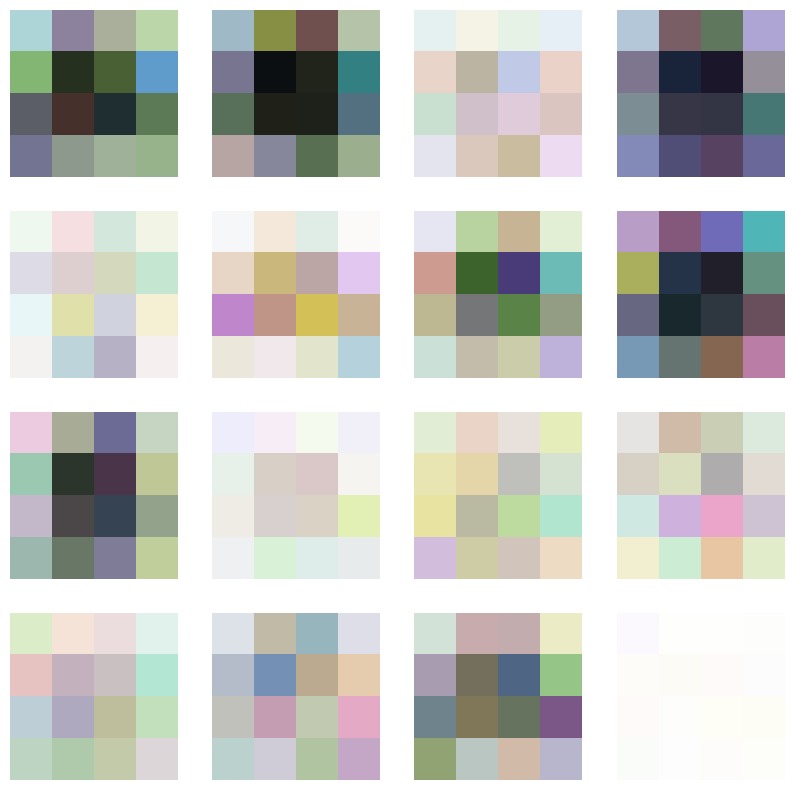

Step: 185
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6092203855514526
Generator loss: 3.9890494346618652


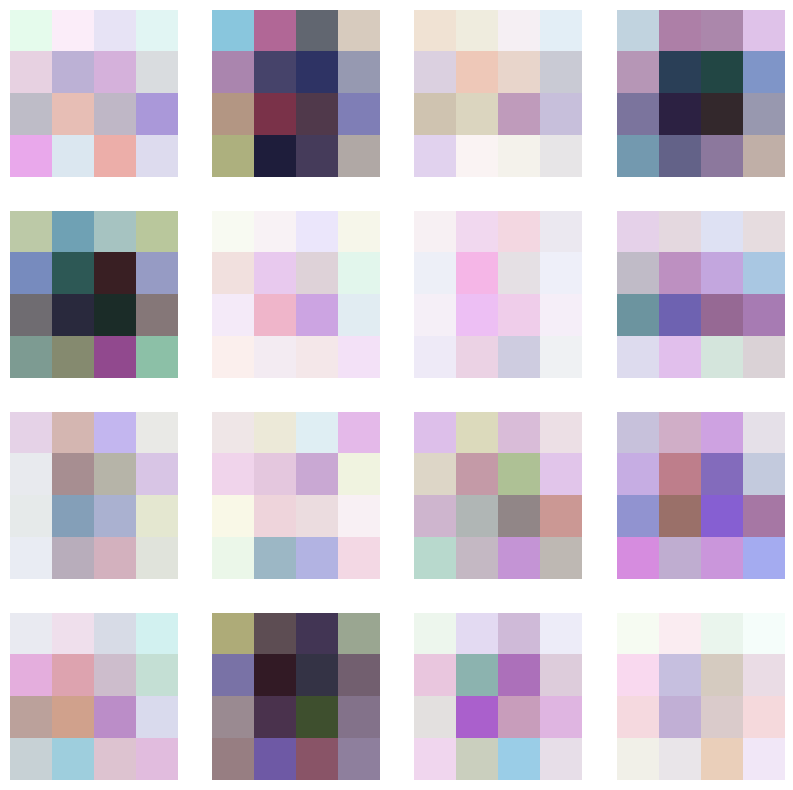

Step: 186
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.6017667055130005
Generator loss: 3.9736557006835938


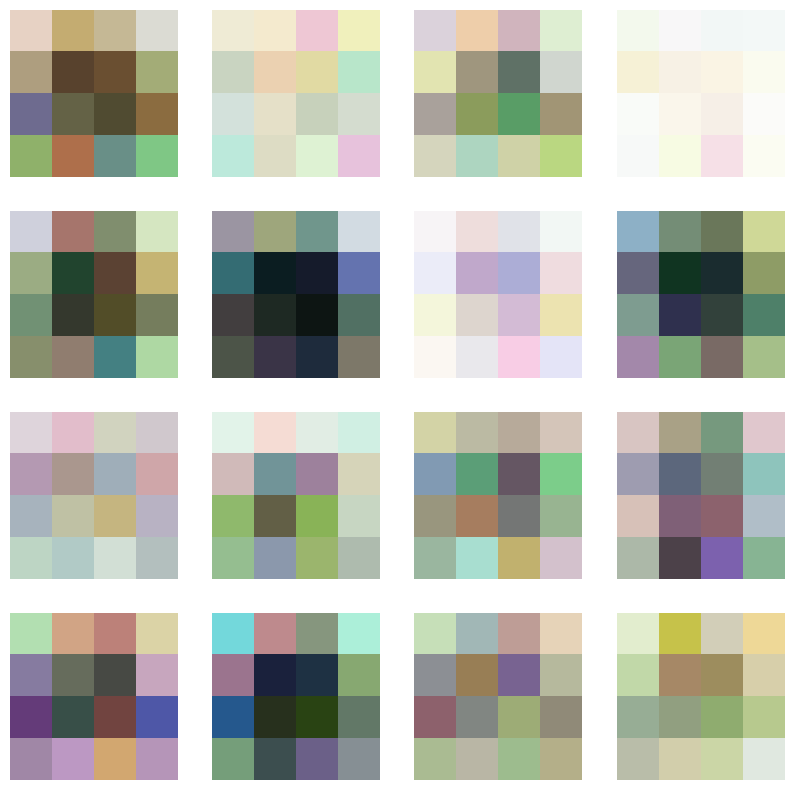

Step: 187
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.594907522201538
Generator loss: 3.957258462905884


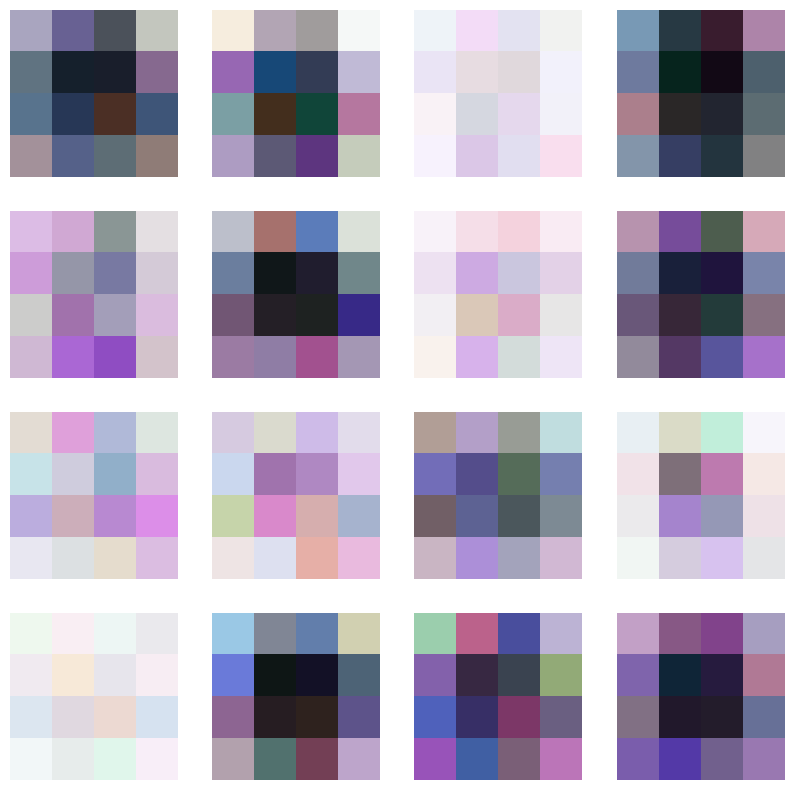

Step: 188
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5882458686828613
Generator loss: 3.940826892852783


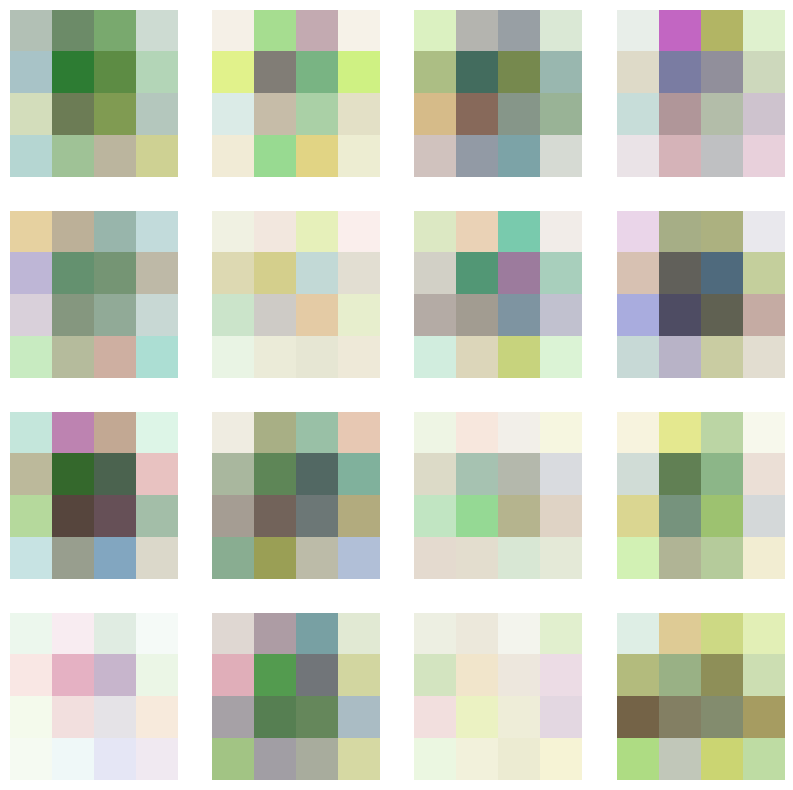

Step: 189
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5818884372711182
Generator loss: 3.924285888671875


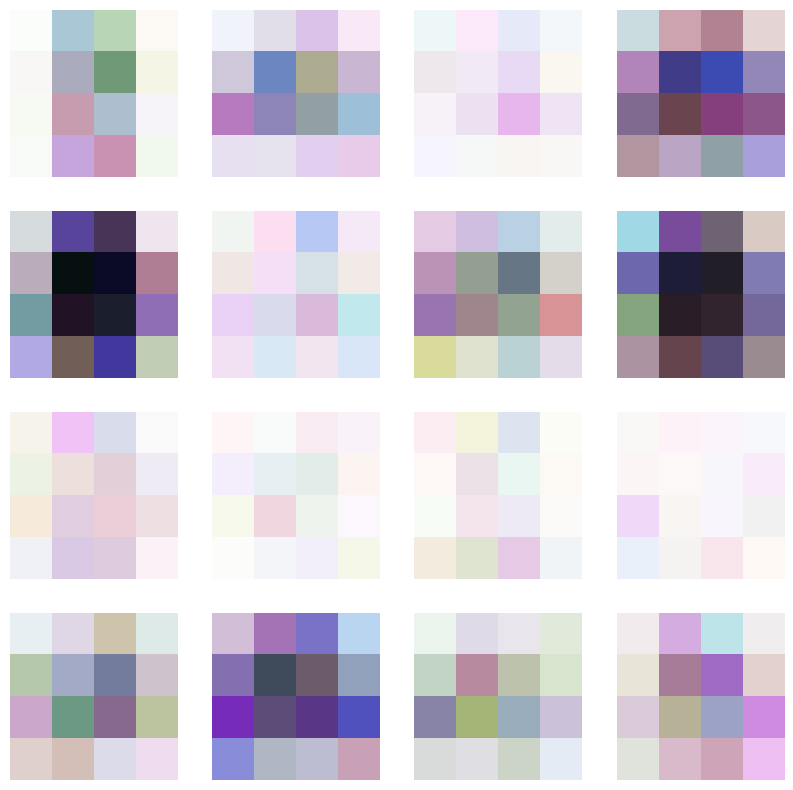

Step: 190
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5745257139205933
Generator loss: 3.9134228229522705


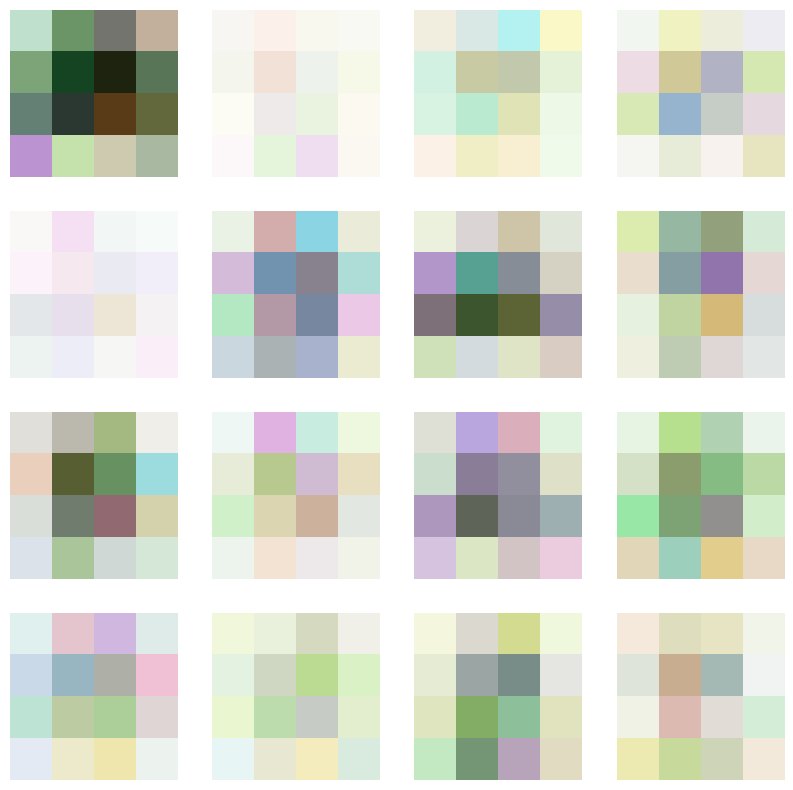

Step: 191
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5682607889175415
Generator loss: 3.9011857509613037


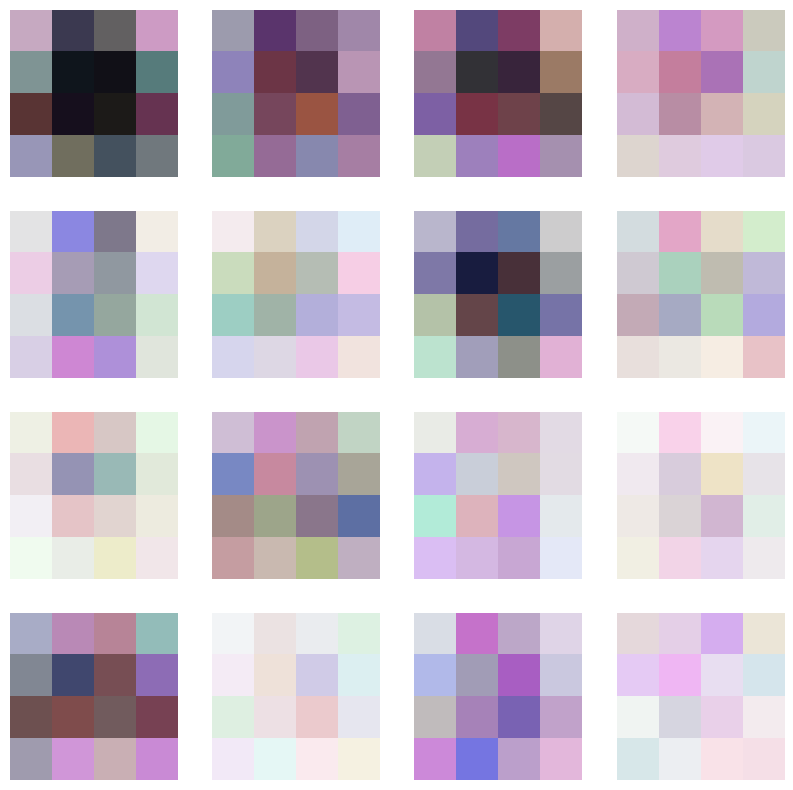

Step: 192
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5609270334243774
Generator loss: 3.8844923973083496


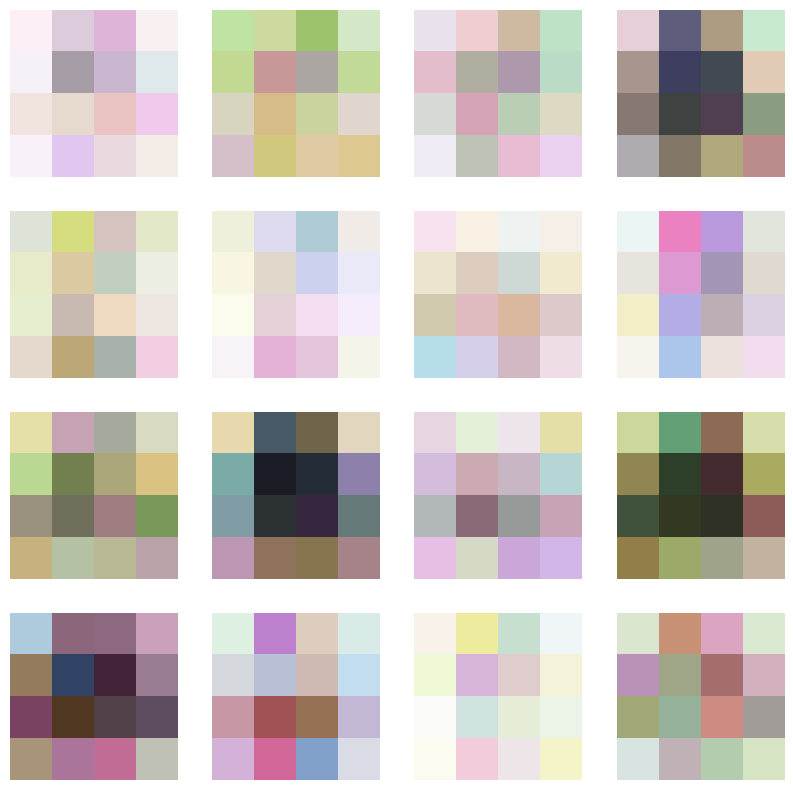

Step: 193
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5543562173843384
Generator loss: 3.868947982788086


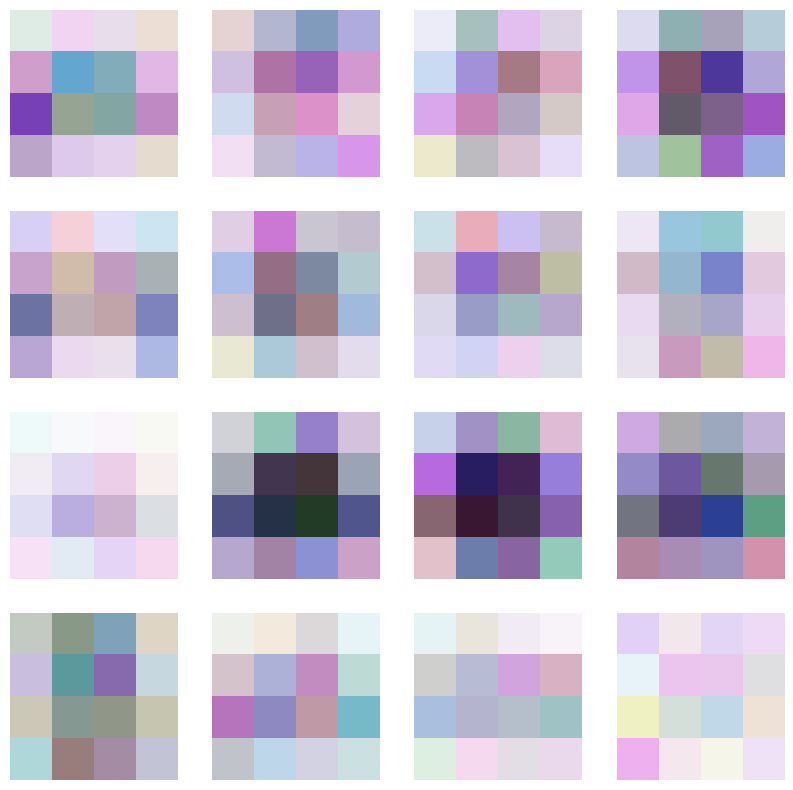

Step: 194
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5482181310653687
Generator loss: 3.852994441986084


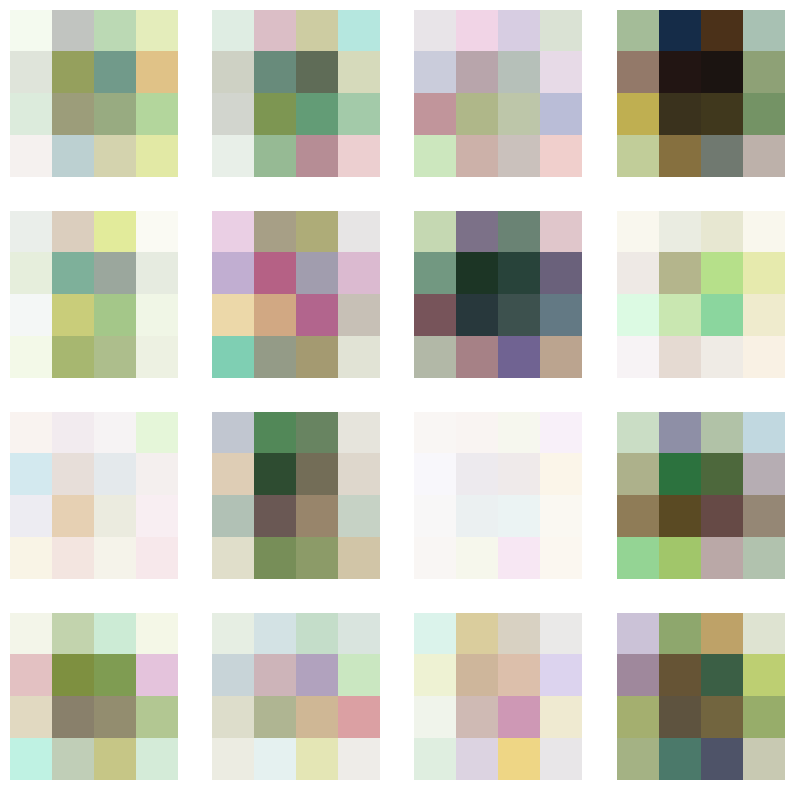

Step: 195
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5421525239944458
Generator loss: 3.8354697227478027


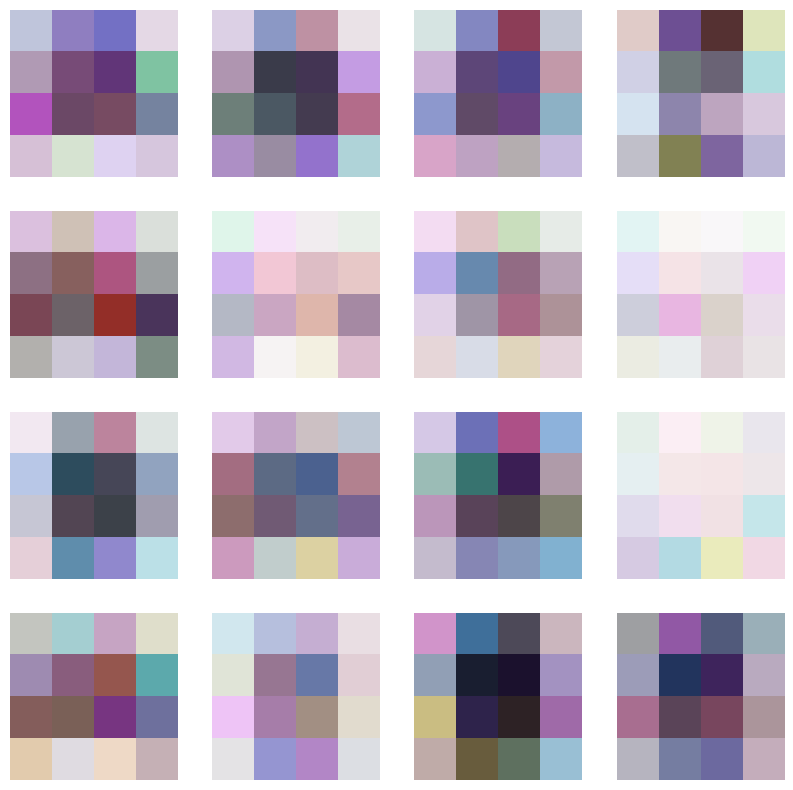

Step: 196
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5353868007659912
Generator loss: 3.819850444793701


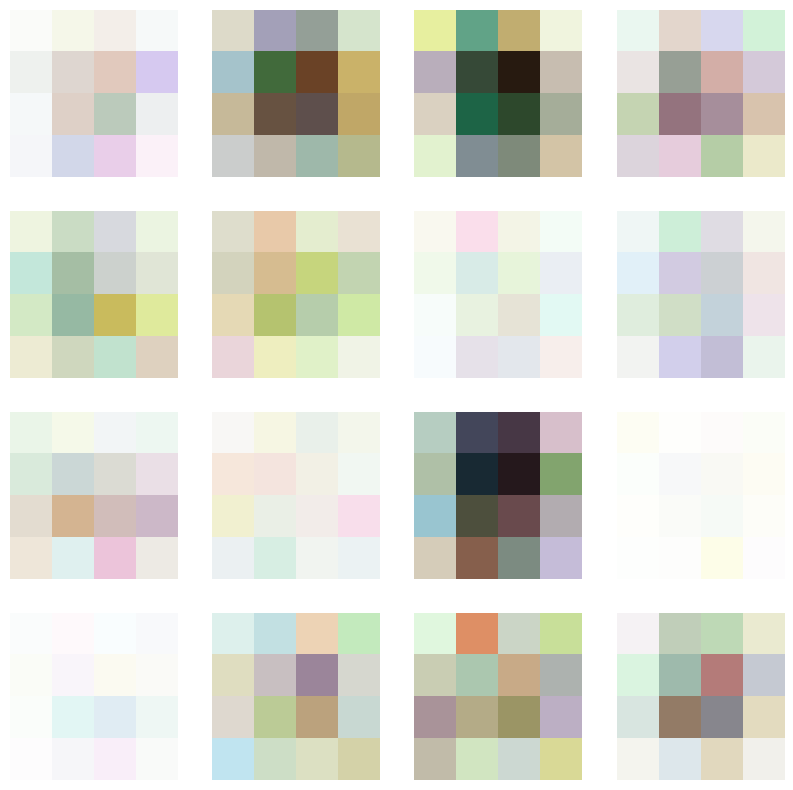

Step: 197
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.529567837715149
Generator loss: 3.8055830001831055


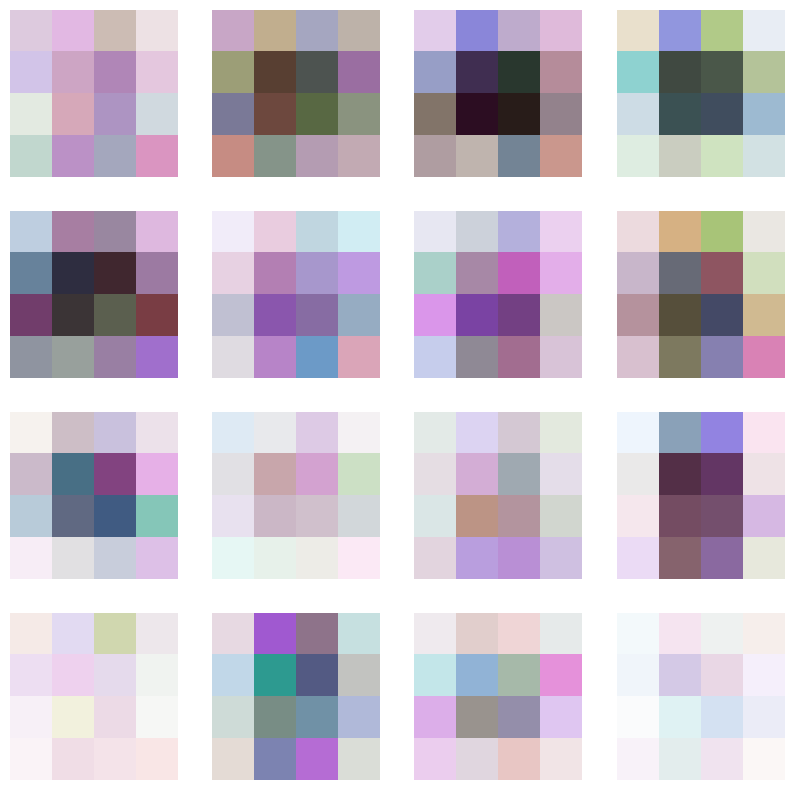

Step: 198
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5234402418136597
Generator loss: 3.789447069168091


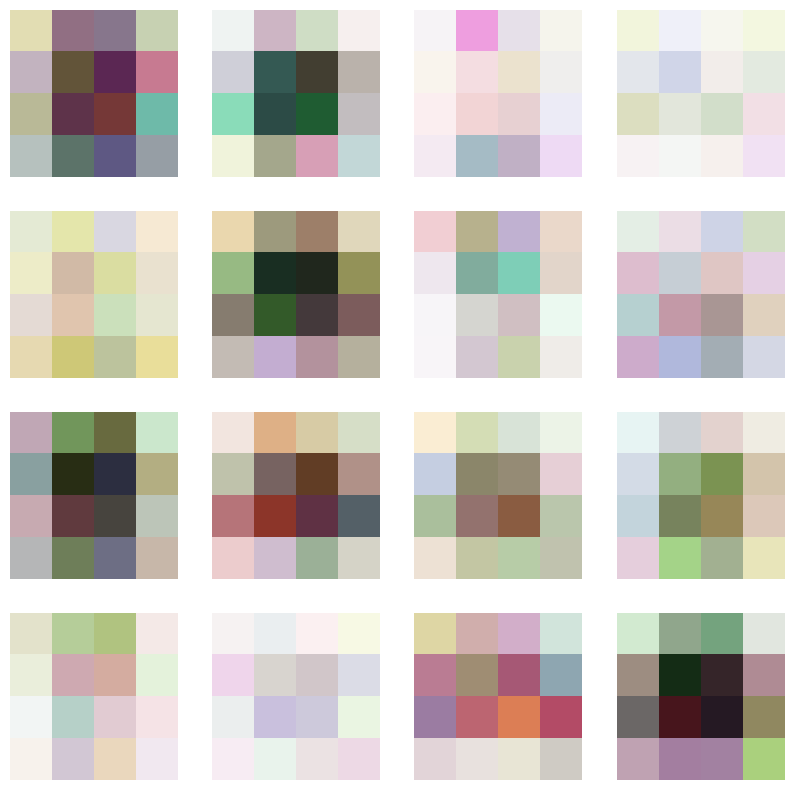

Step: 199
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5172860622406006
Generator loss: 3.7735815048217773


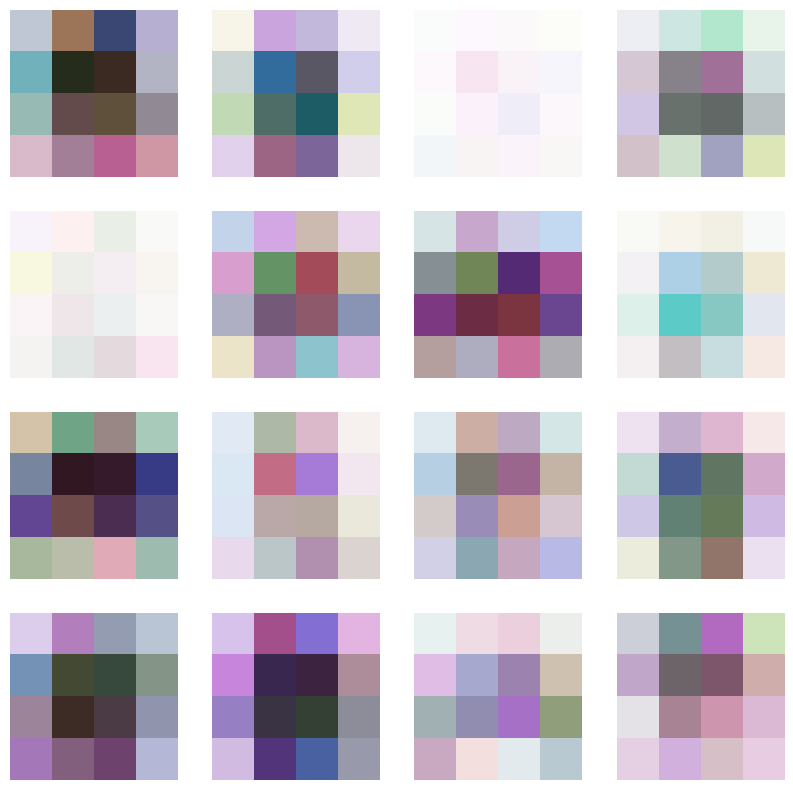

Step: 200
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5111831426620483
Generator loss: 3.7602617740631104


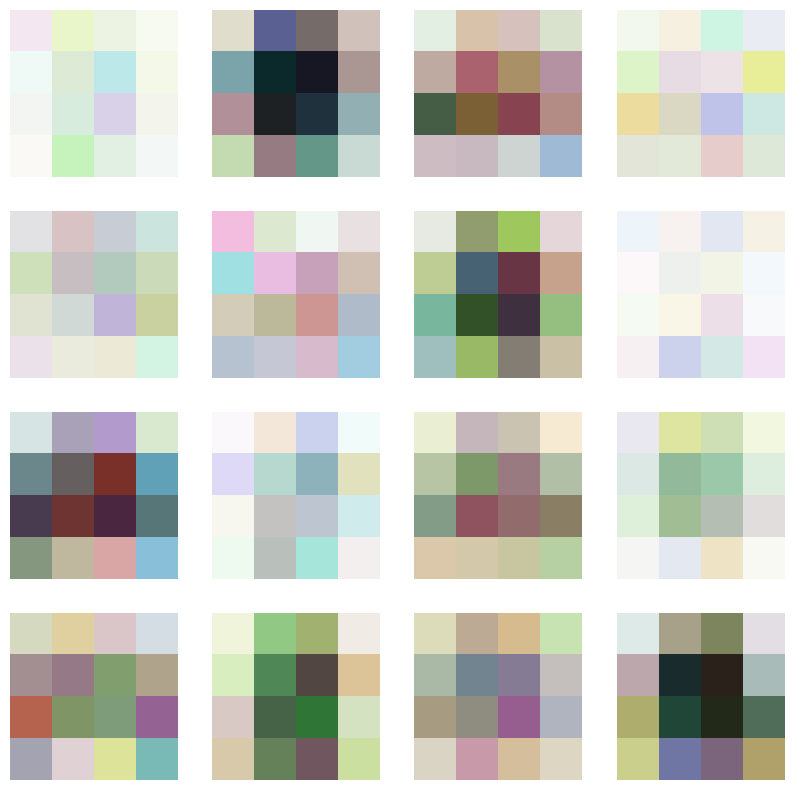

Step: 201
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.5052807331085205
Generator loss: 3.7463533878326416


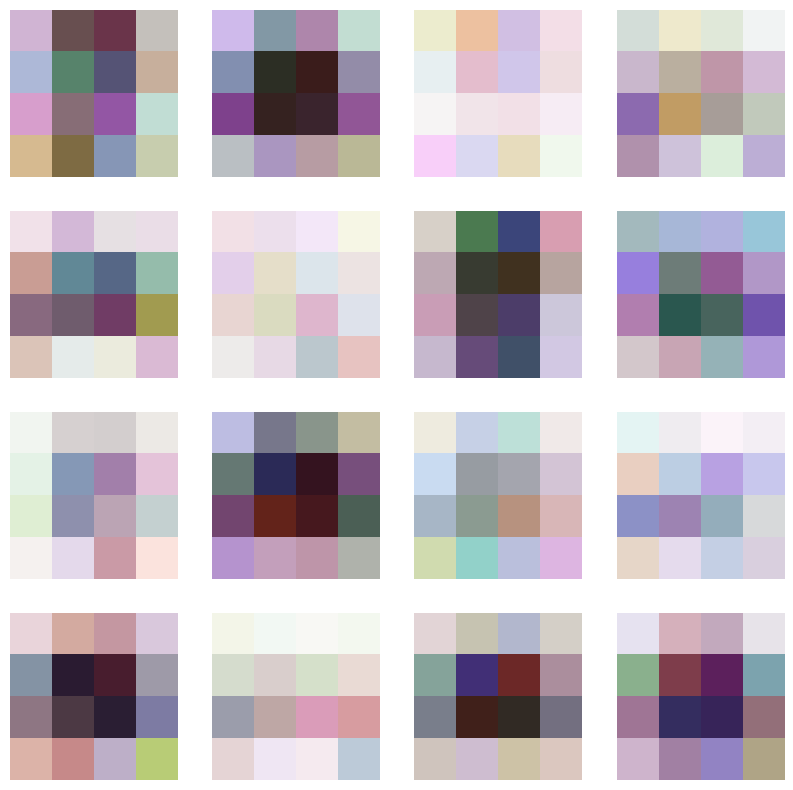

Step: 202
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.499276876449585
Generator loss: 3.730381488800049


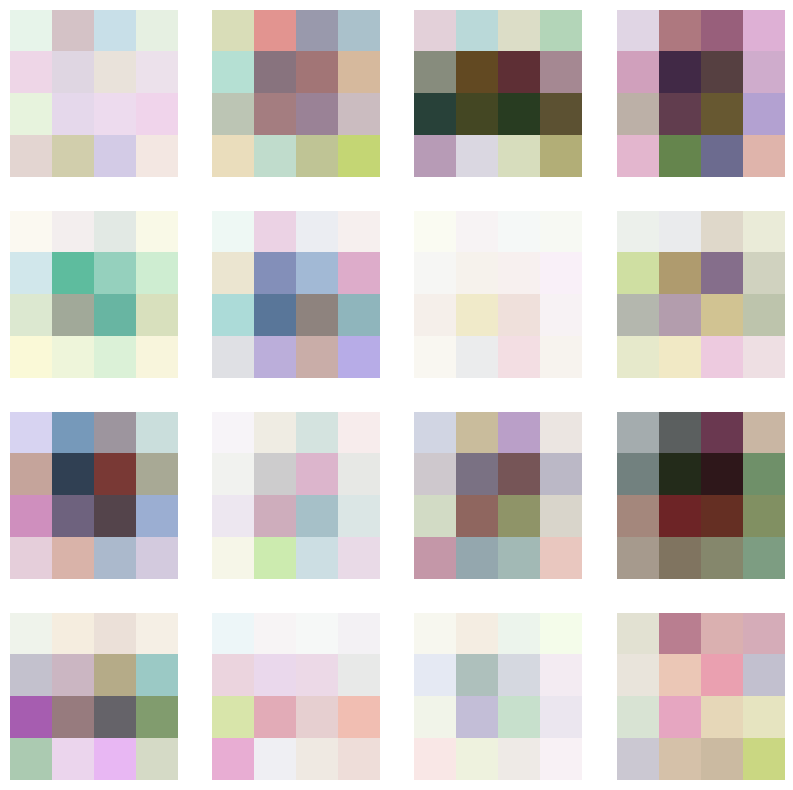

Step: 203
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4935832023620605
Generator loss: 3.714756965637207


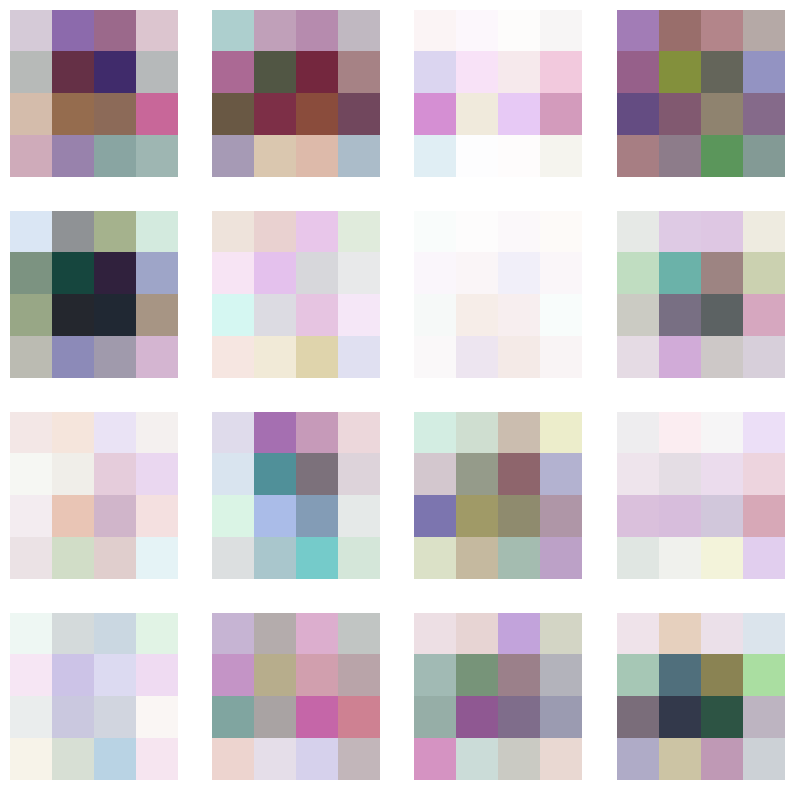

Step: 204
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.487861156463623
Generator loss: 3.700878620147705


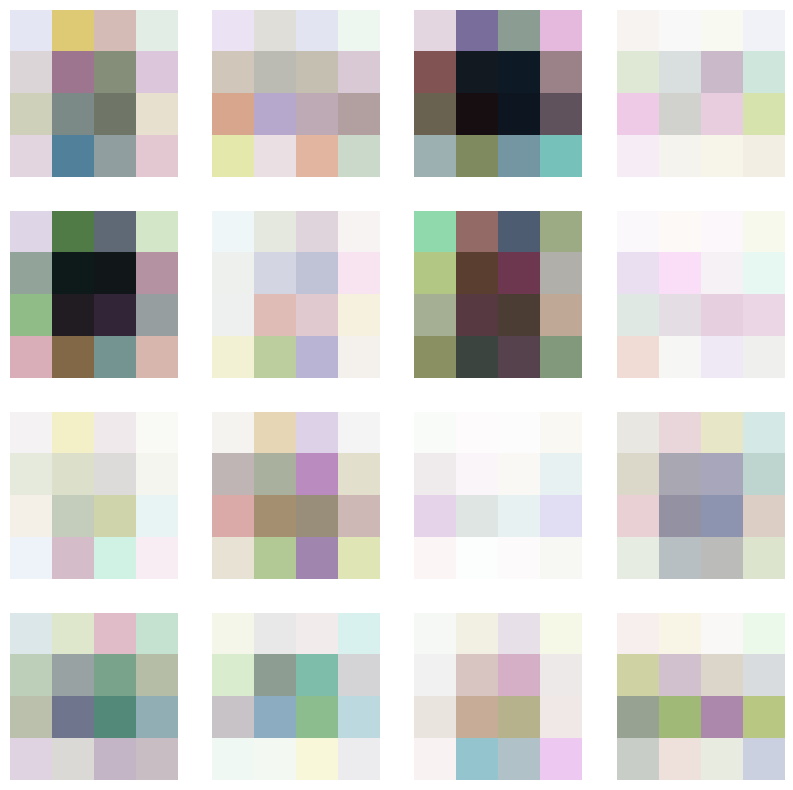

Step: 205
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4821348190307617
Generator loss: 3.68621826171875


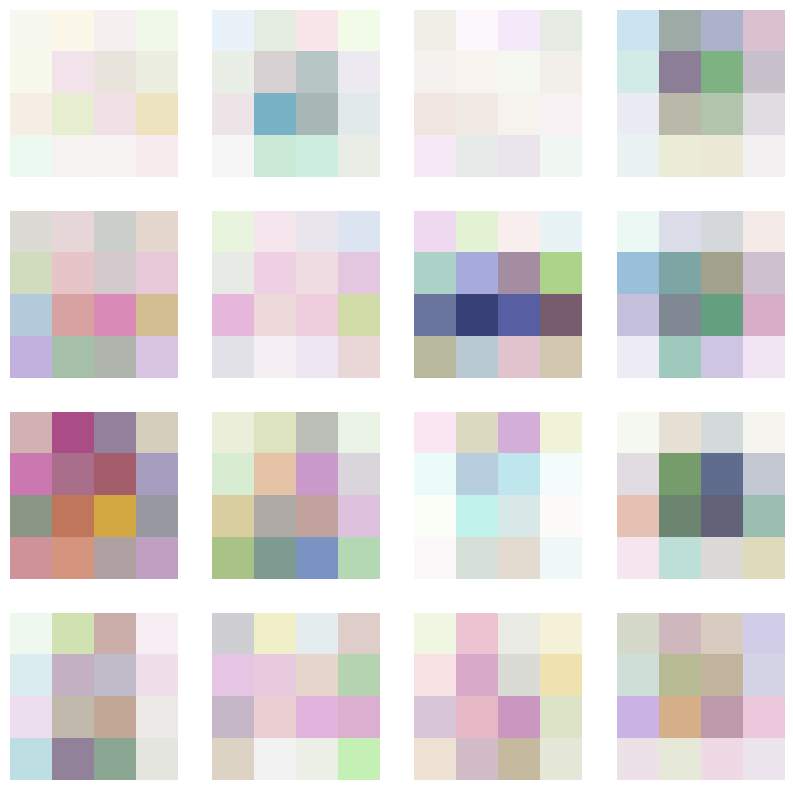

Step: 206
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4764293432235718
Generator loss: 3.6730411052703857


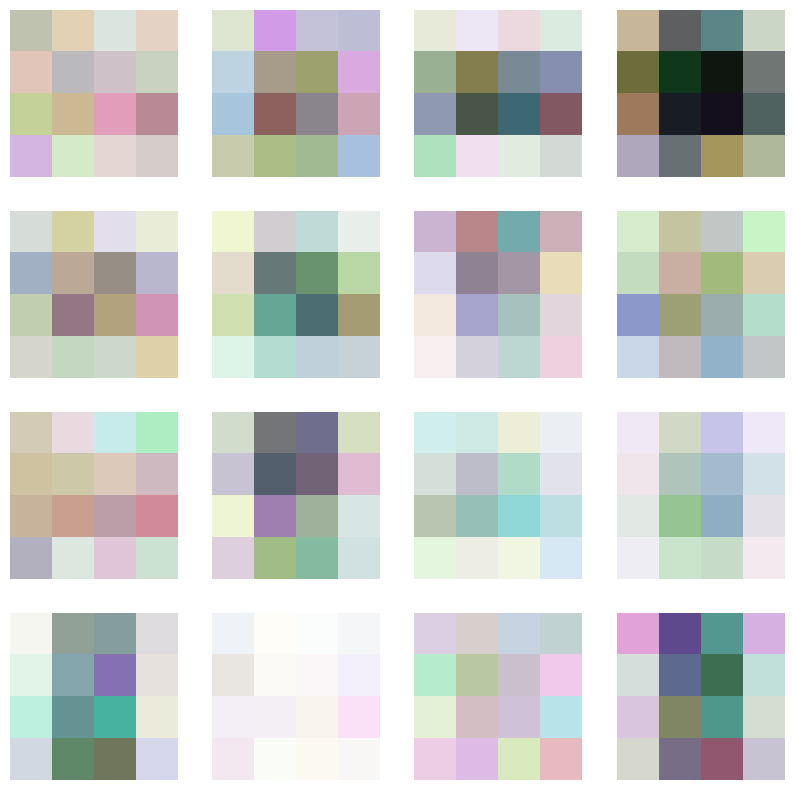

Step: 207
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4708844423294067
Generator loss: 3.6596784591674805


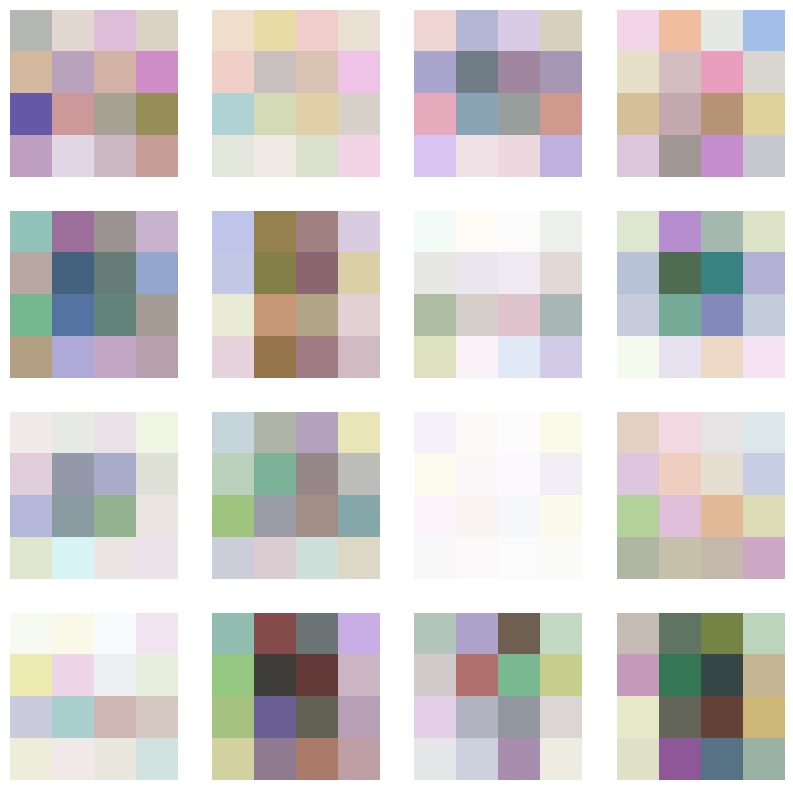

Step: 208
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.46492338180542
Generator loss: 3.644193649291992


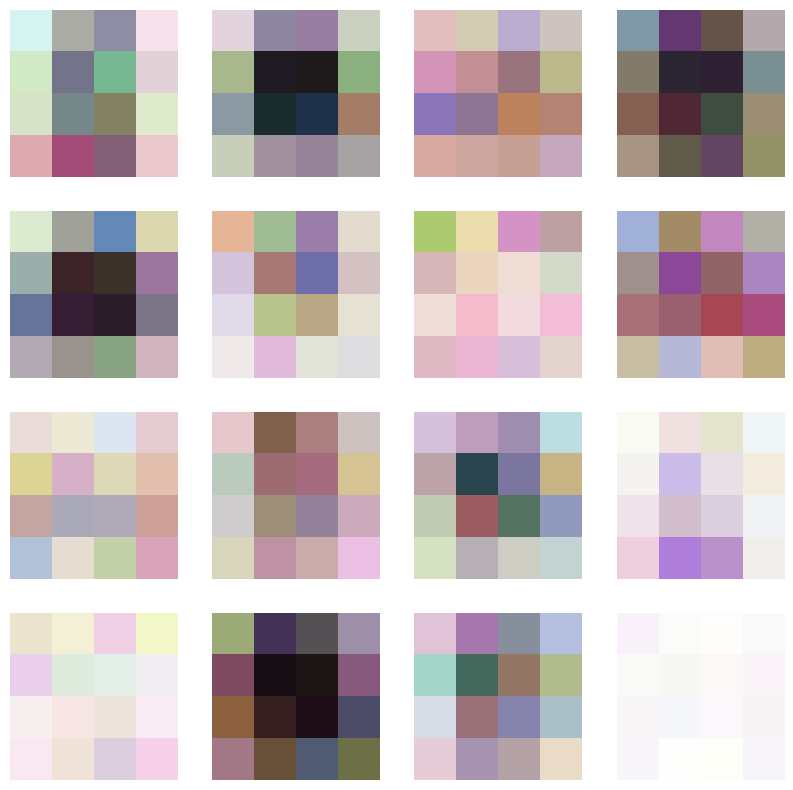

Step: 209
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4585981369018555
Generator loss: 3.629296064376831


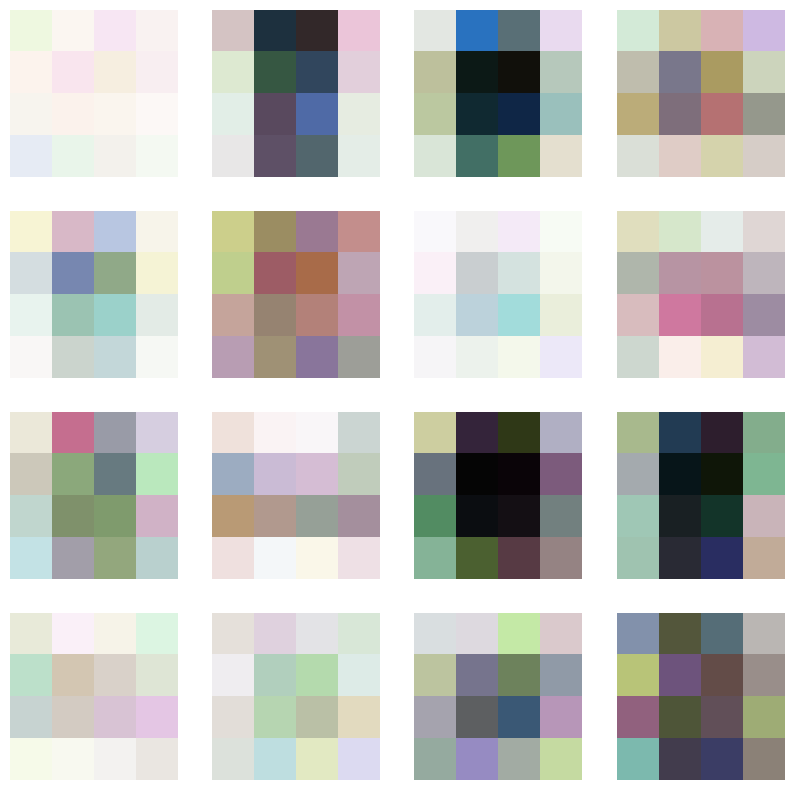

Step: 210
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.452316164970398
Generator loss: 3.6127591133117676


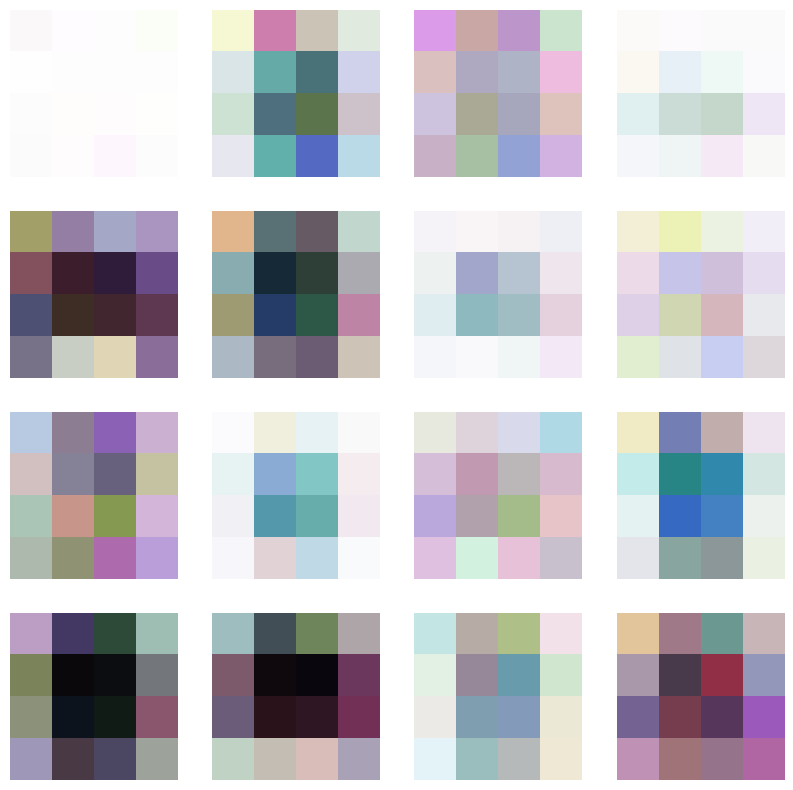

Step: 211
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4463119506835938
Generator loss: 3.5973665714263916


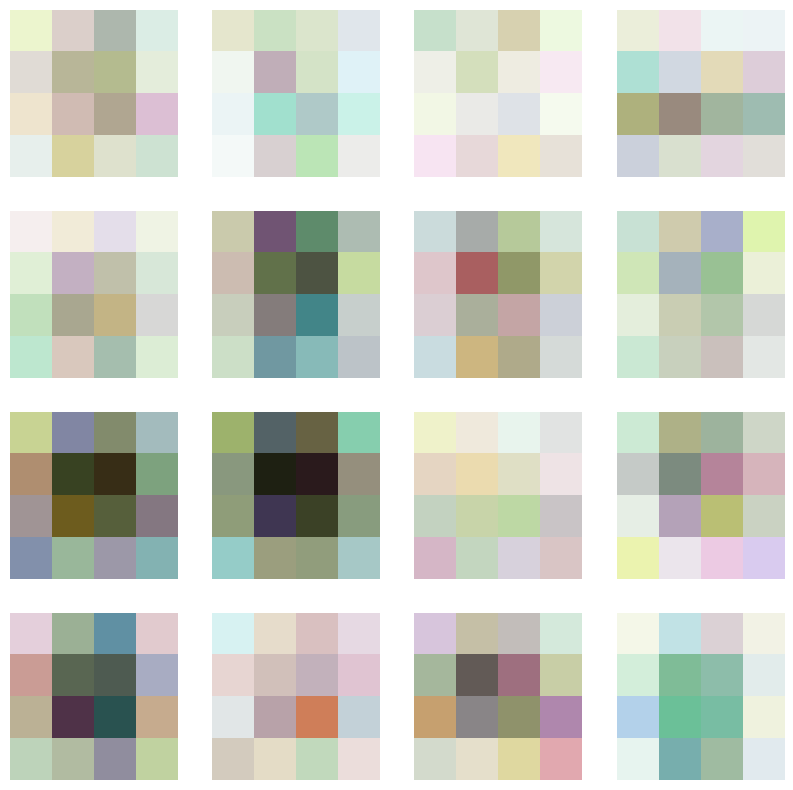

Step: 212
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.440597653388977
Generator loss: 3.5820751190185547


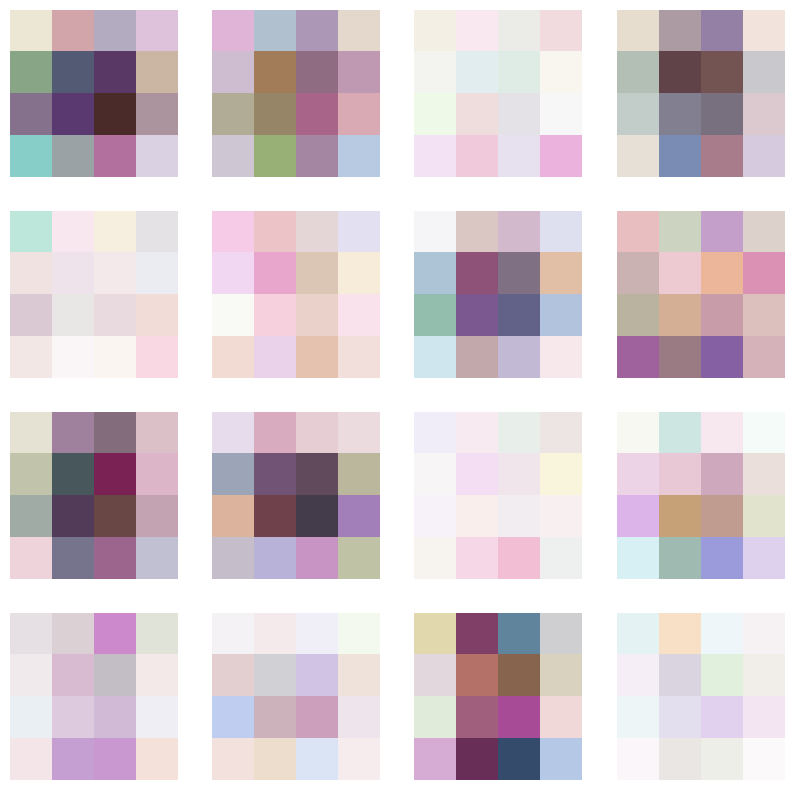

Step: 213
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4353694915771484
Generator loss: 3.5681636333465576


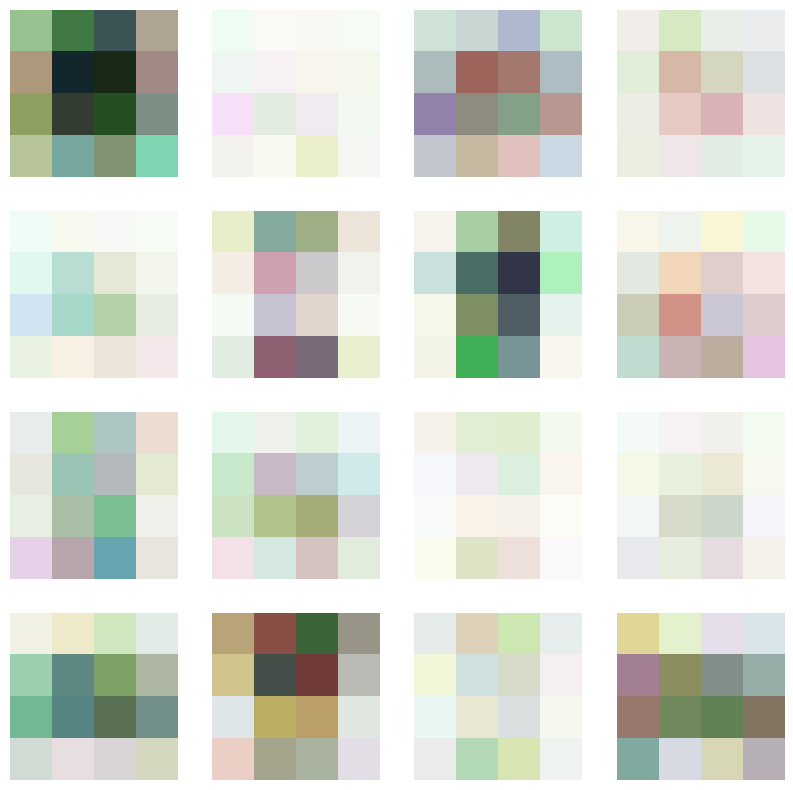

Step: 214
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4296083450317383
Generator loss: 3.553213357925415


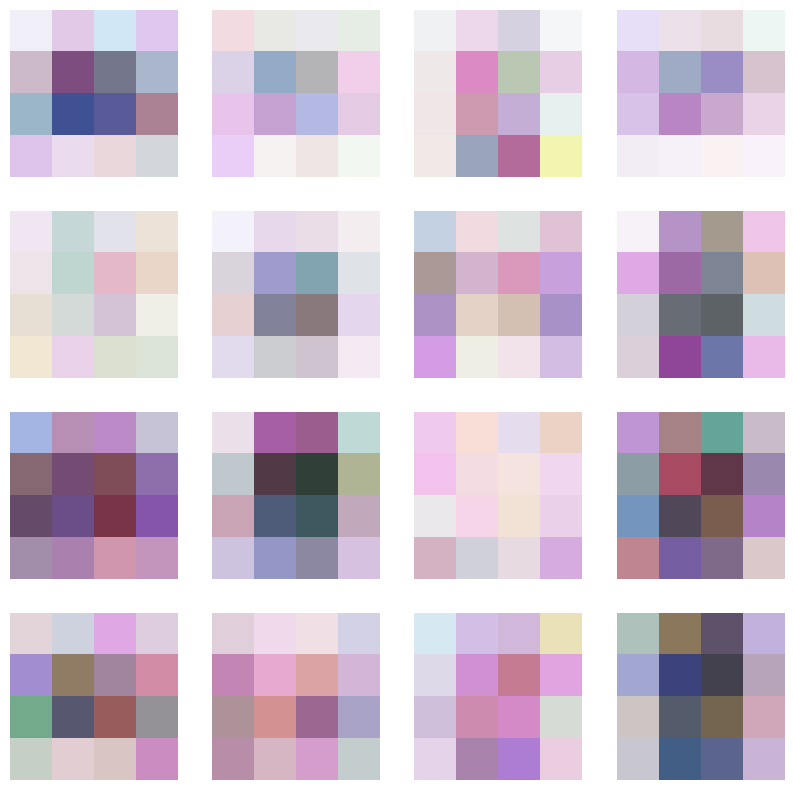

Step: 215
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4245545864105225
Generator loss: 3.539893865585327


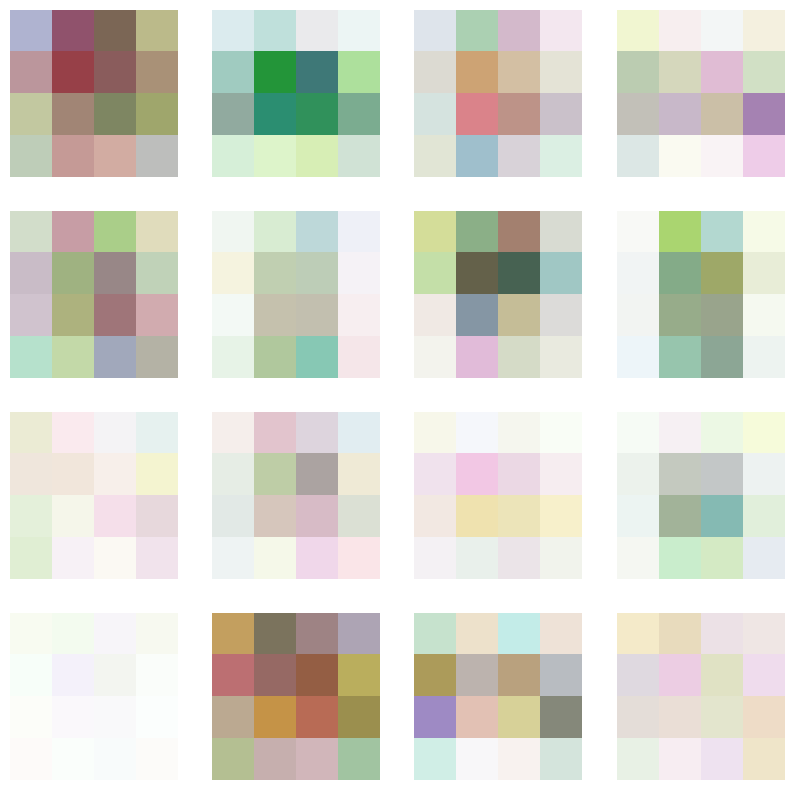

Step: 216
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4193891286849976
Generator loss: 3.525239944458008


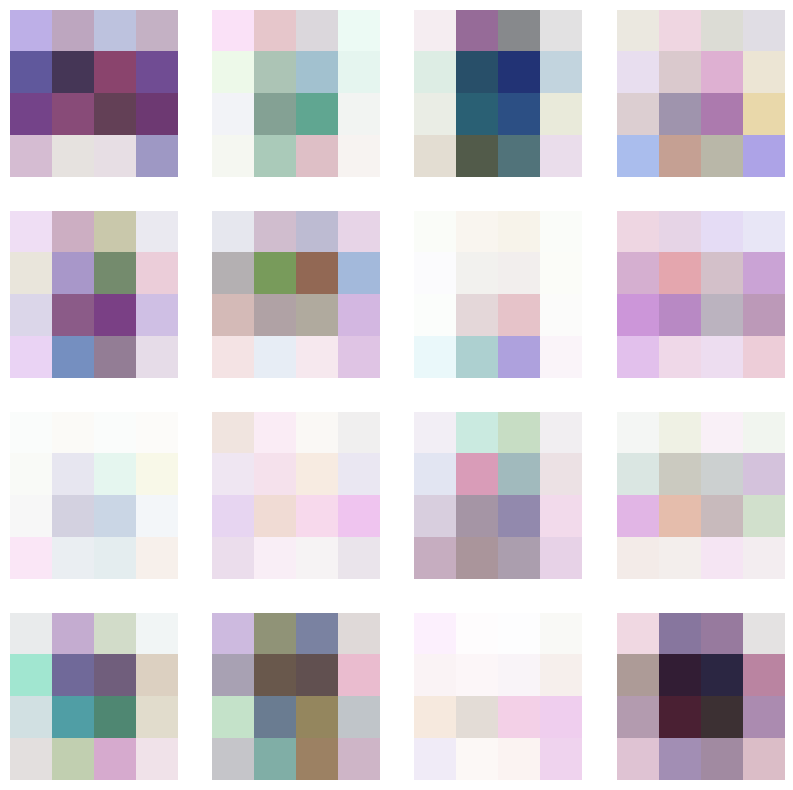

Step: 217
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.413869857788086
Generator loss: 3.511988639831543


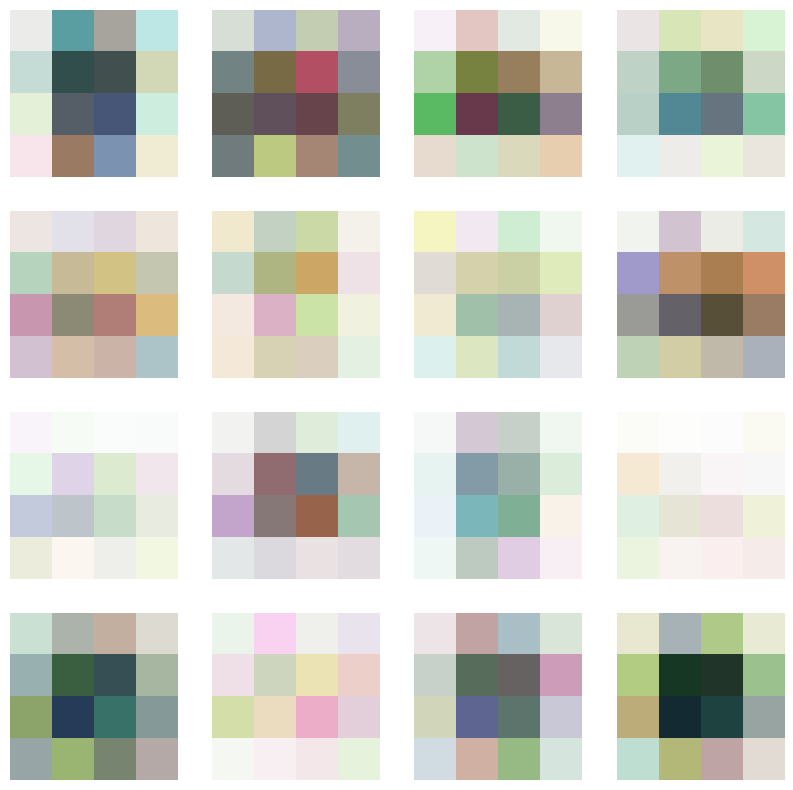

Step: 218
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.408835768699646
Generator loss: 3.4991822242736816


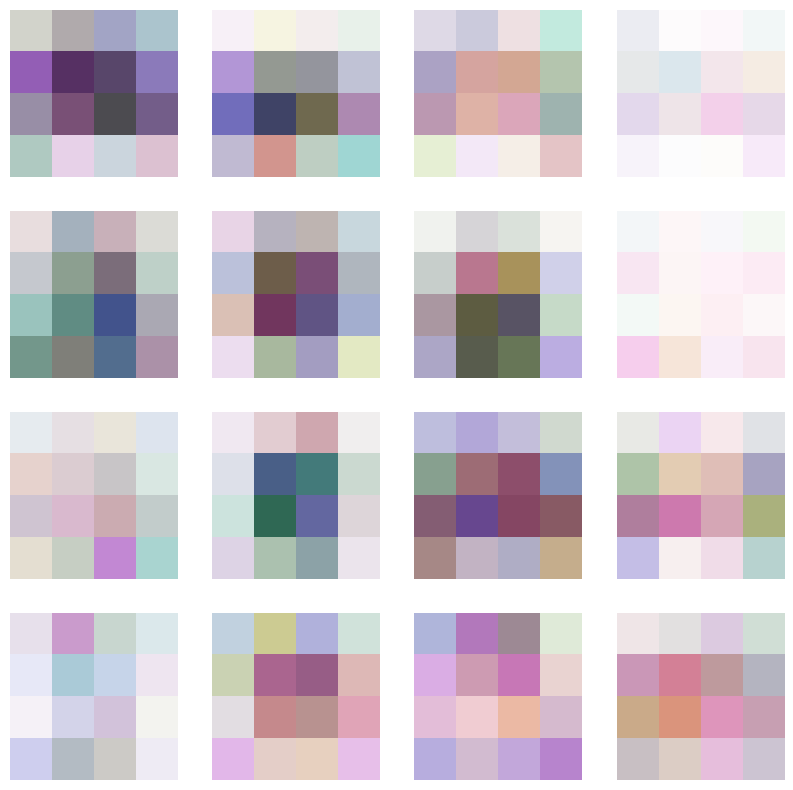

Step: 219
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.4041520357131958
Generator loss: 3.4874041080474854


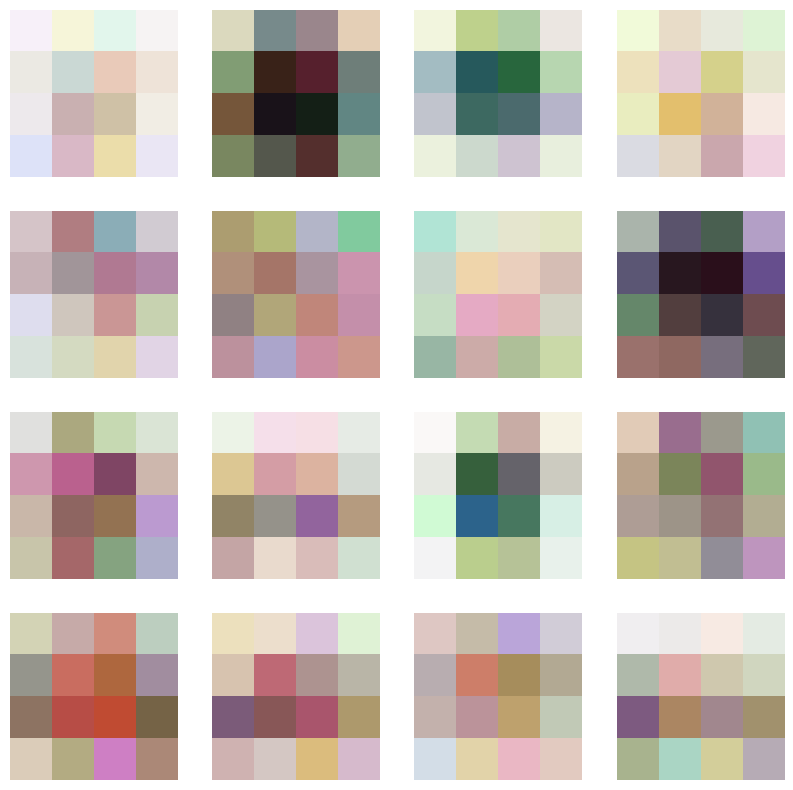

Step: 220
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3987343311309814
Generator loss: 3.474304676055908


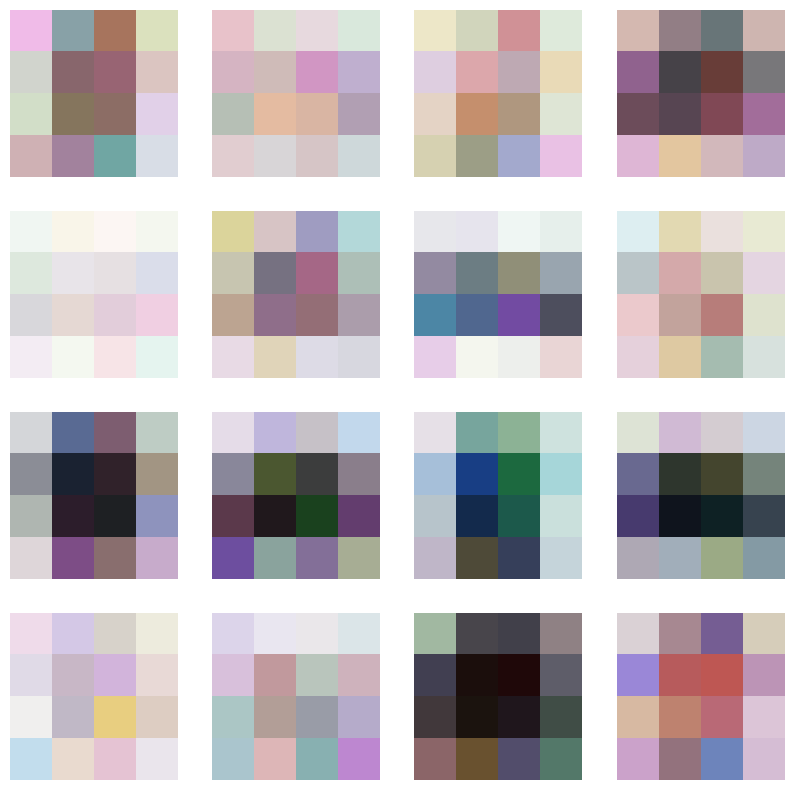

Step: 221
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.39304780960083
Generator loss: 3.4594244956970215


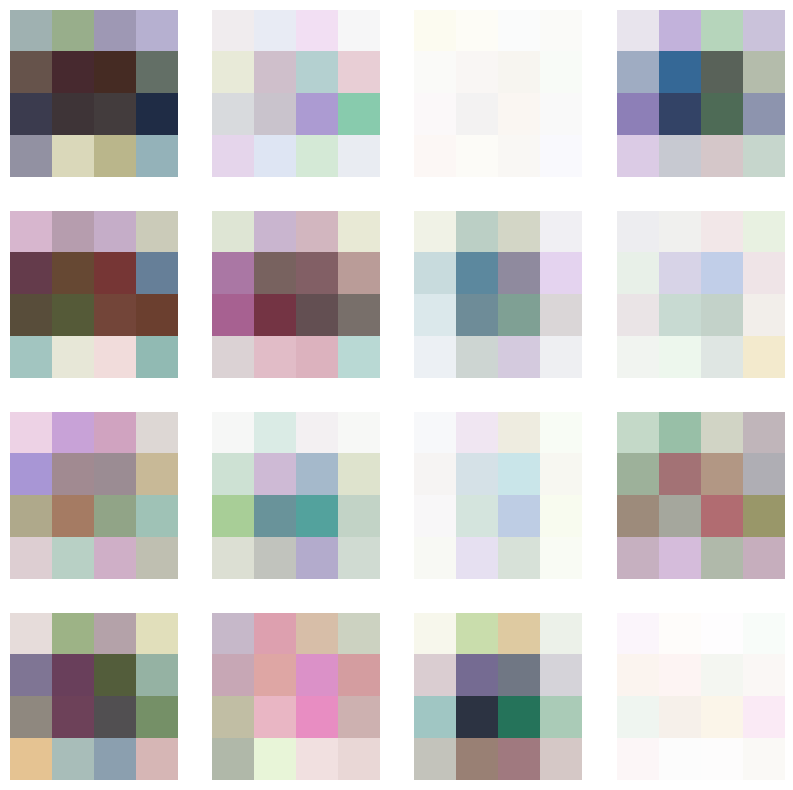

Step: 222
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3873597383499146
Generator loss: 3.445944309234619


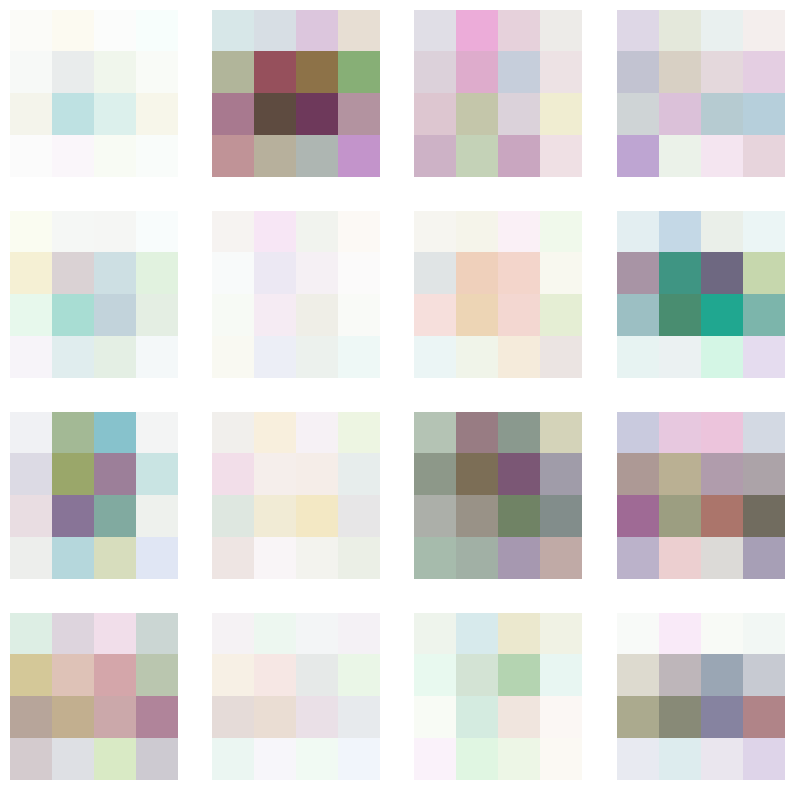

Step: 223
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3820708990097046
Generator loss: 3.433159112930298


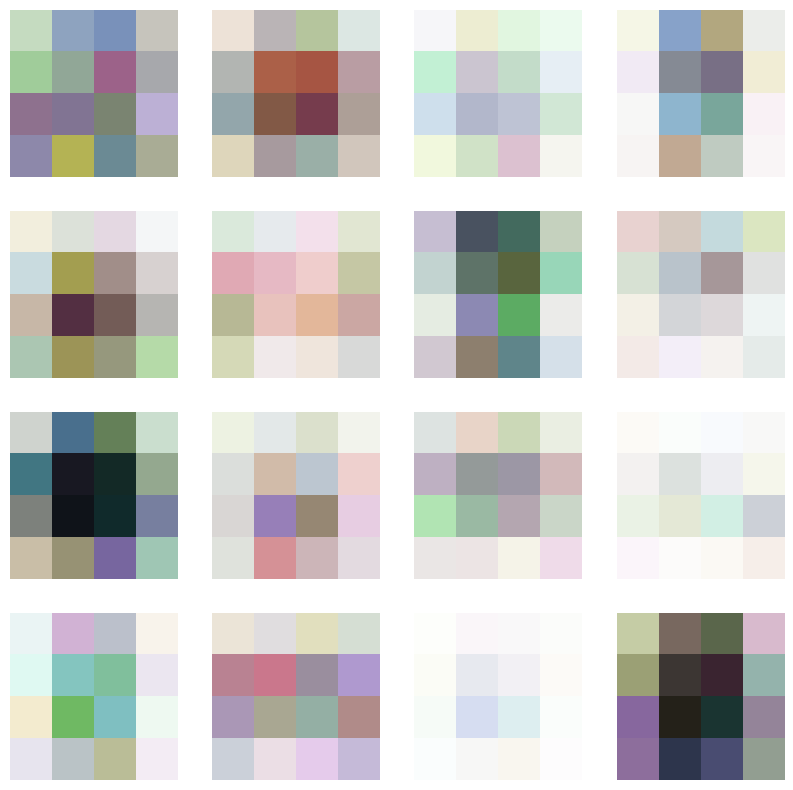

Step: 224
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3769725561141968
Generator loss: 3.4242067337036133


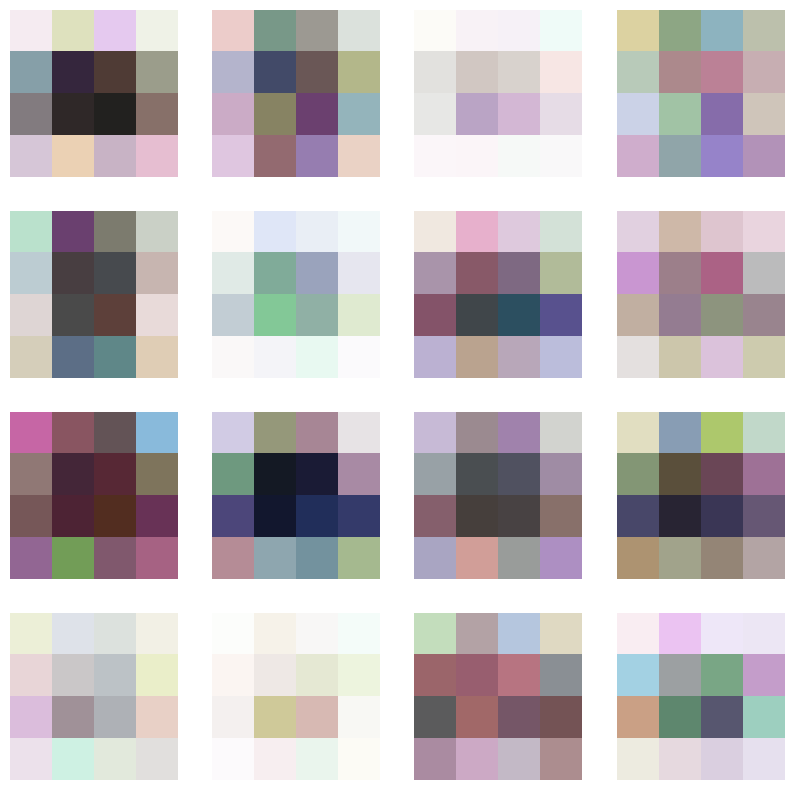

Step: 225
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.371581792831421
Generator loss: 3.412229299545288


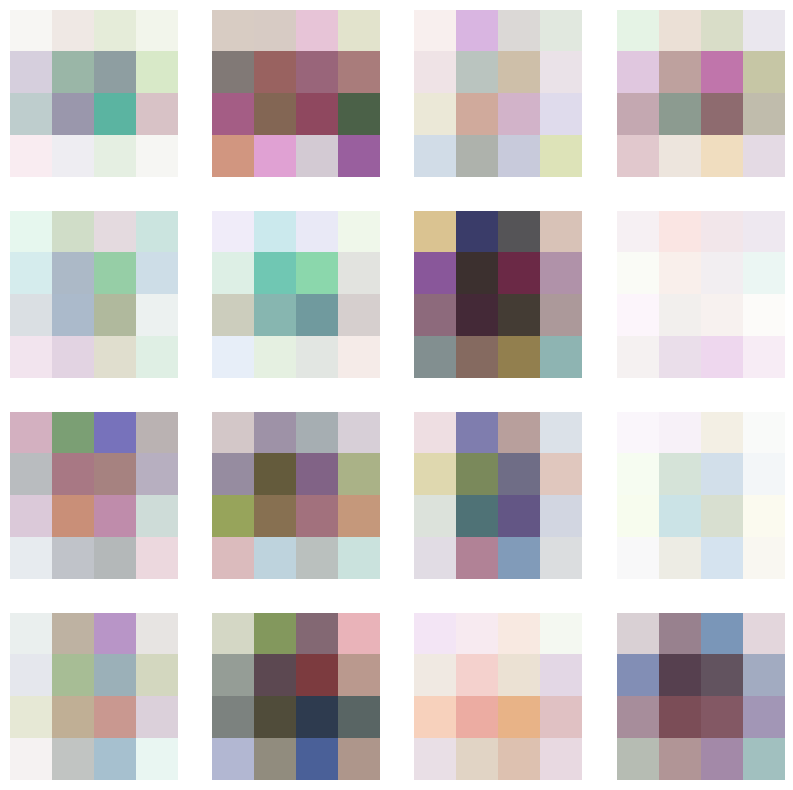

Step: 226
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.366987943649292
Generator loss: 3.4012773036956787


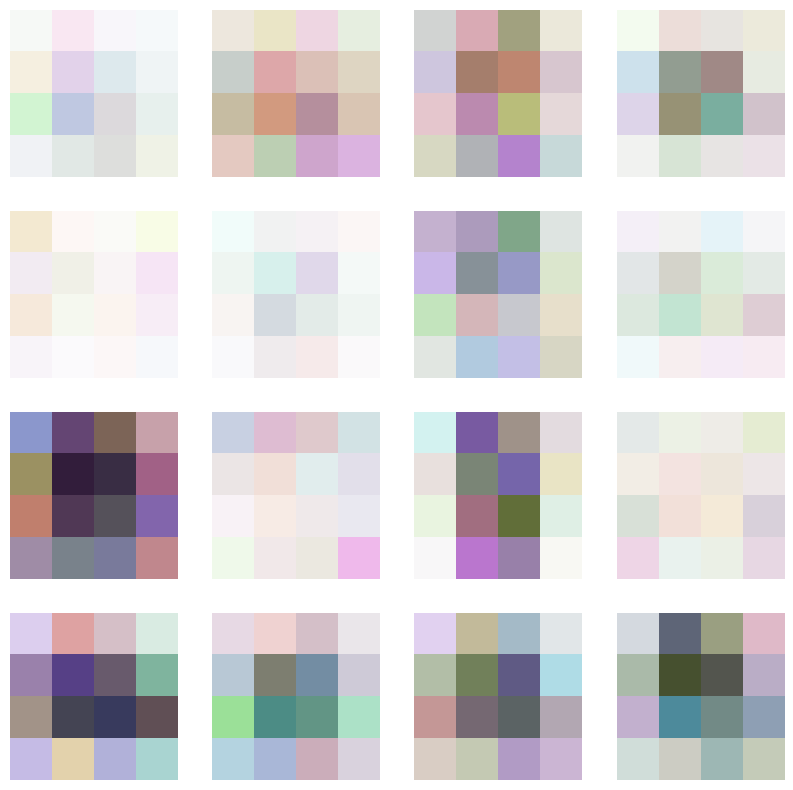

Step: 227
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3619256019592285
Generator loss: 3.3882741928100586


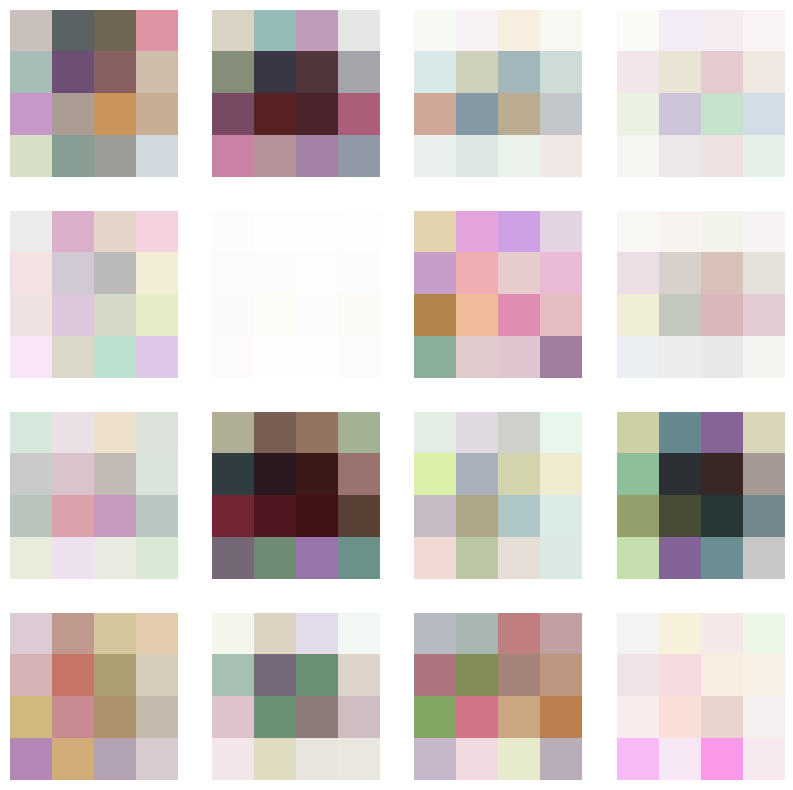

Step: 228
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3572105169296265
Generator loss: 3.375187635421753


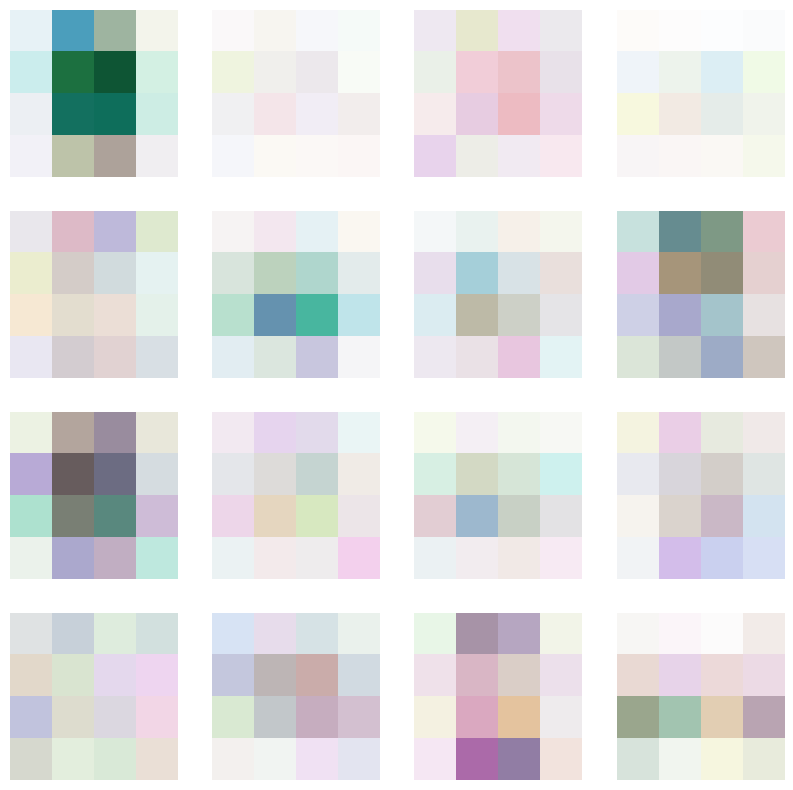

Step: 229
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3516532182693481
Generator loss: 3.3649742603302


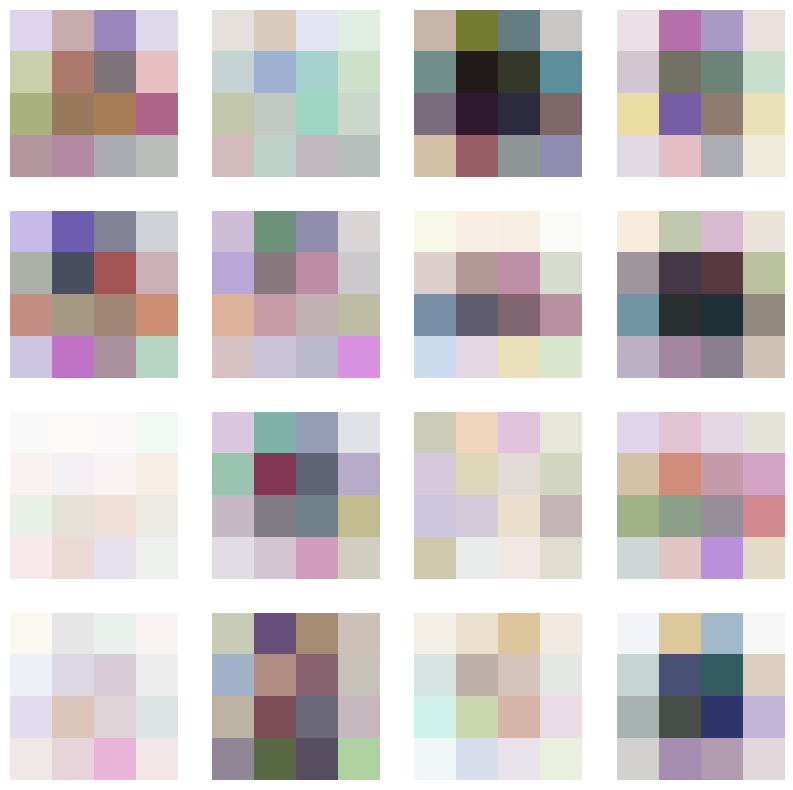

Step: 230
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.346949577331543
Generator loss: 3.3559722900390625


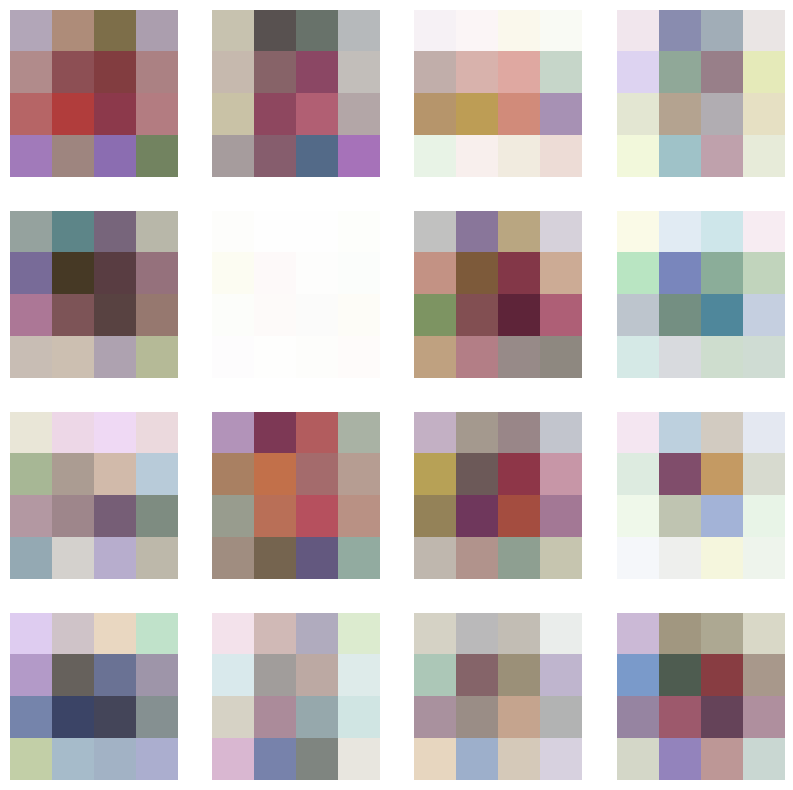

Step: 231
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3416721820831299
Generator loss: 3.3428170680999756


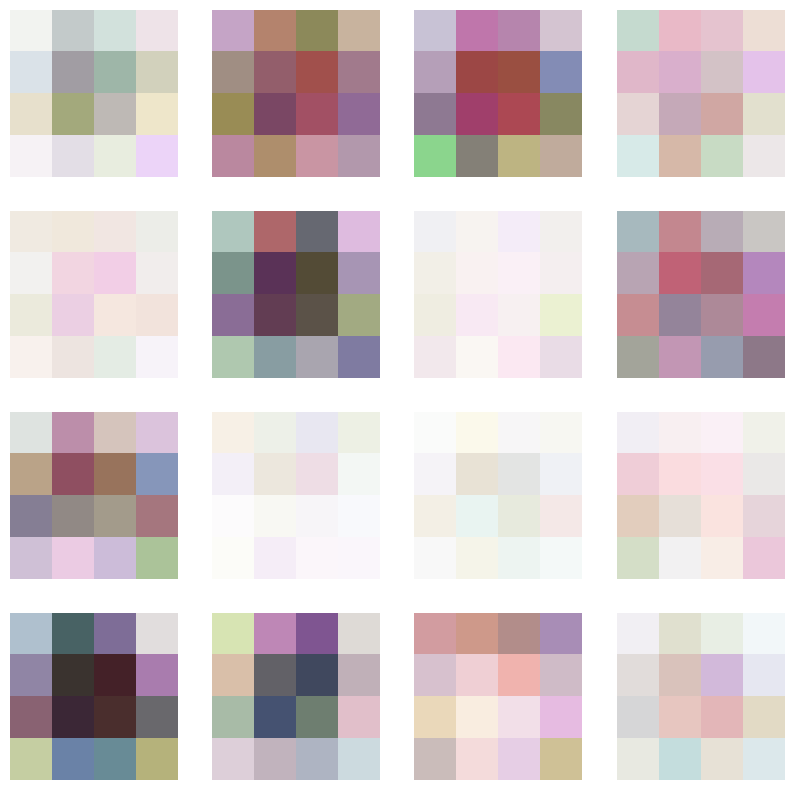

Step: 232
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3366061449050903
Generator loss: 3.331935405731201


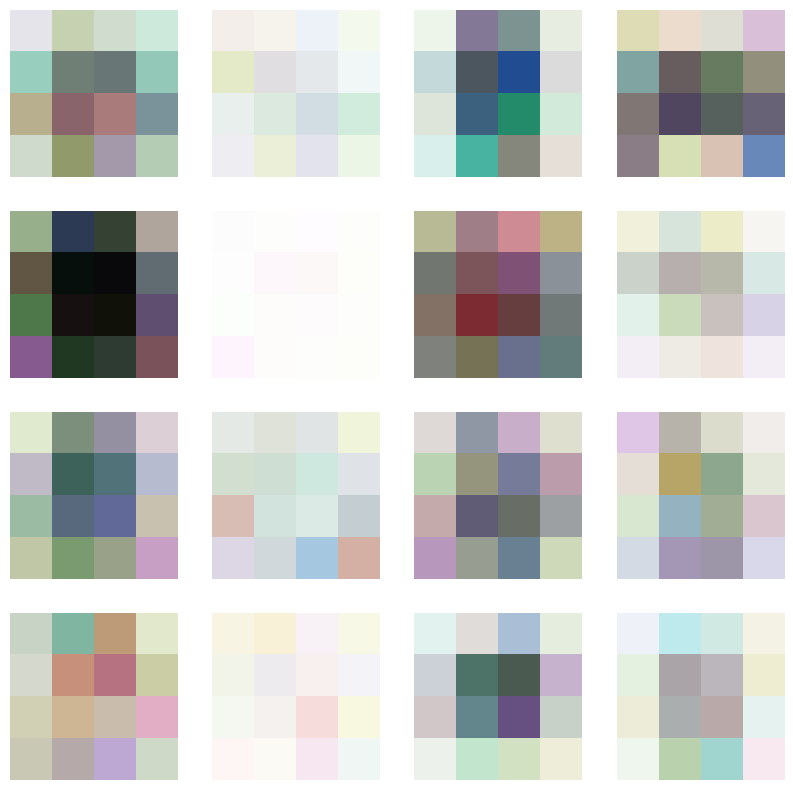

Step: 233
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3319422006607056
Generator loss: 3.319485664367676


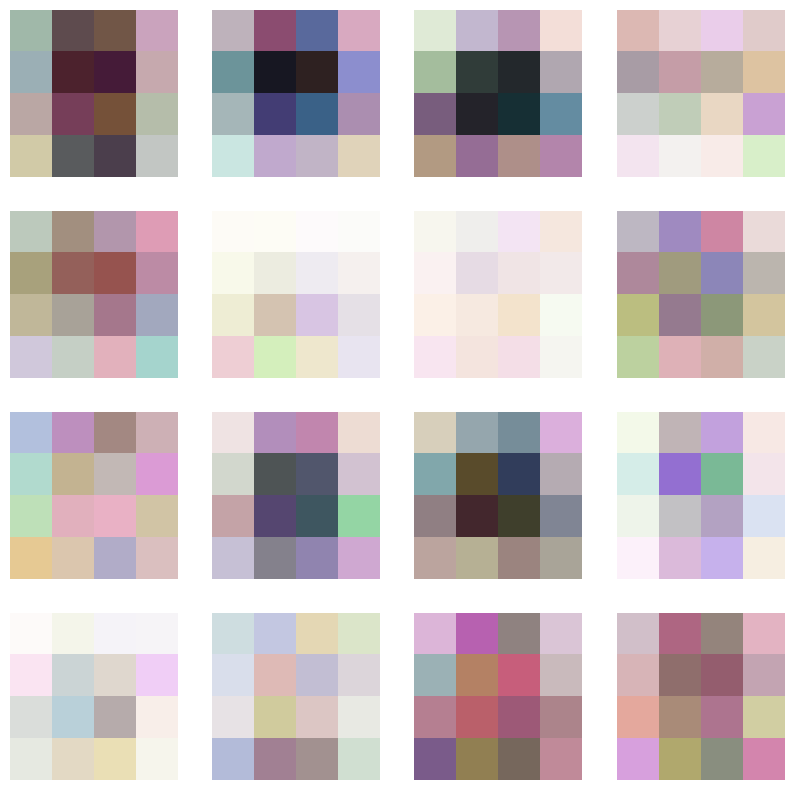

Step: 234
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3272377252578735
Generator loss: 3.308166742324829


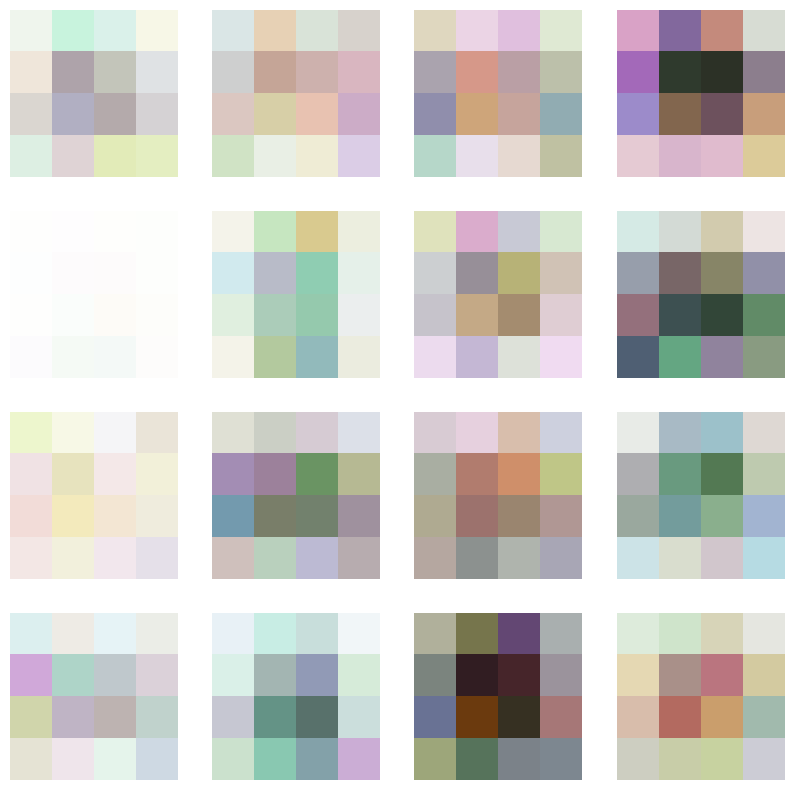

Step: 235
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3224549293518066
Generator loss: 3.294854164123535


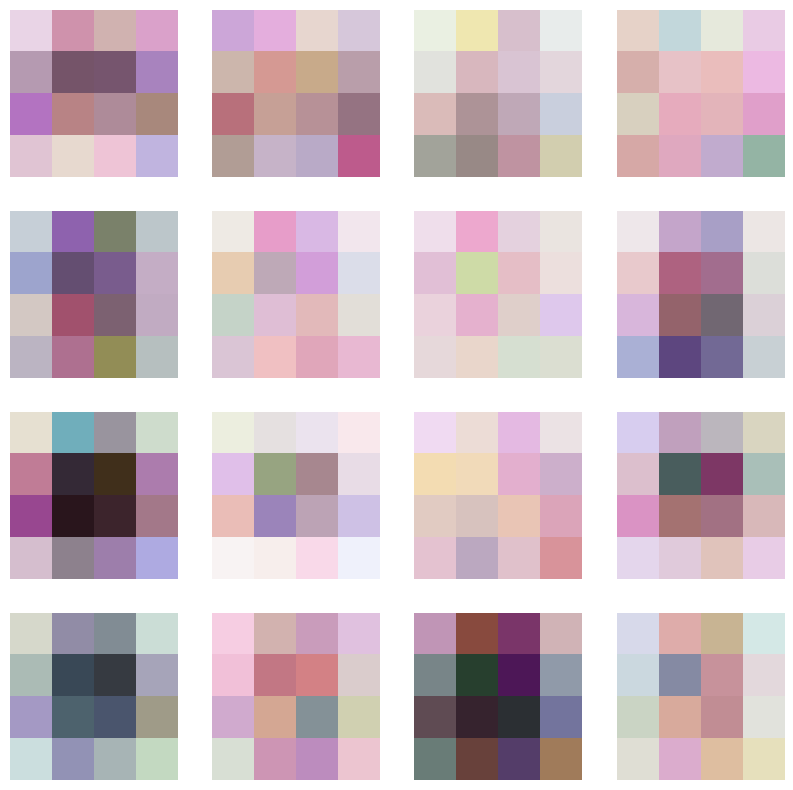

Step: 236
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3174163103103638
Generator loss: 3.282912015914917


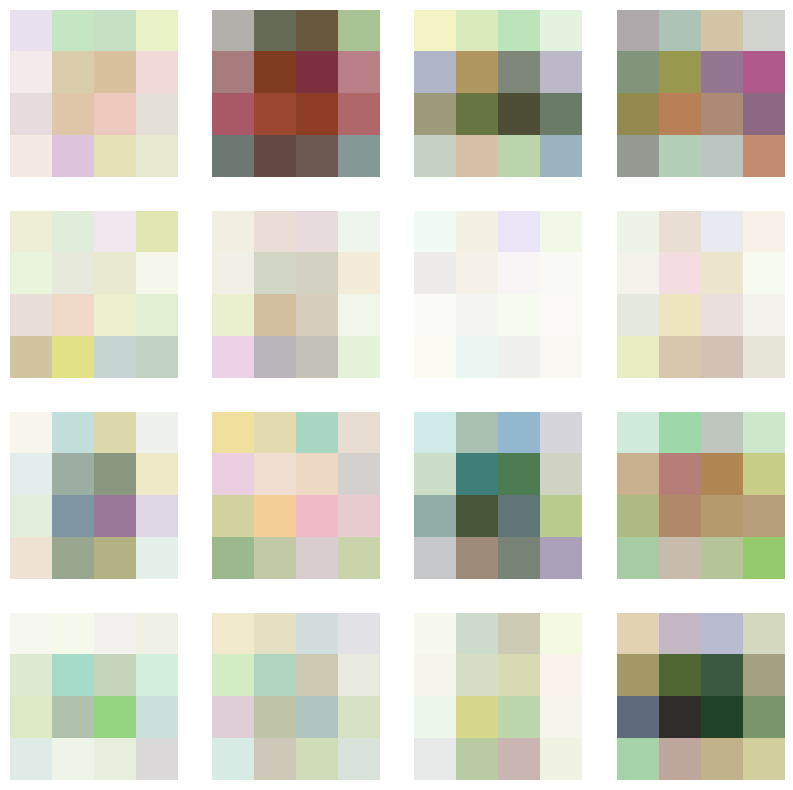

Step: 237
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3126776218414307
Generator loss: 3.271238088607788


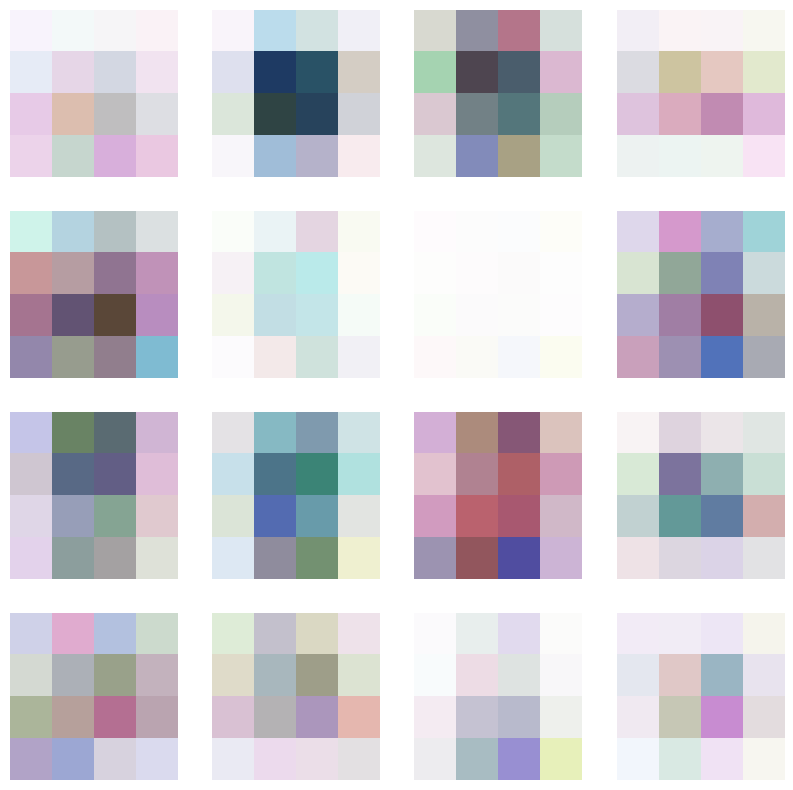

Step: 238
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.308313012123108
Generator loss: 3.2585415840148926


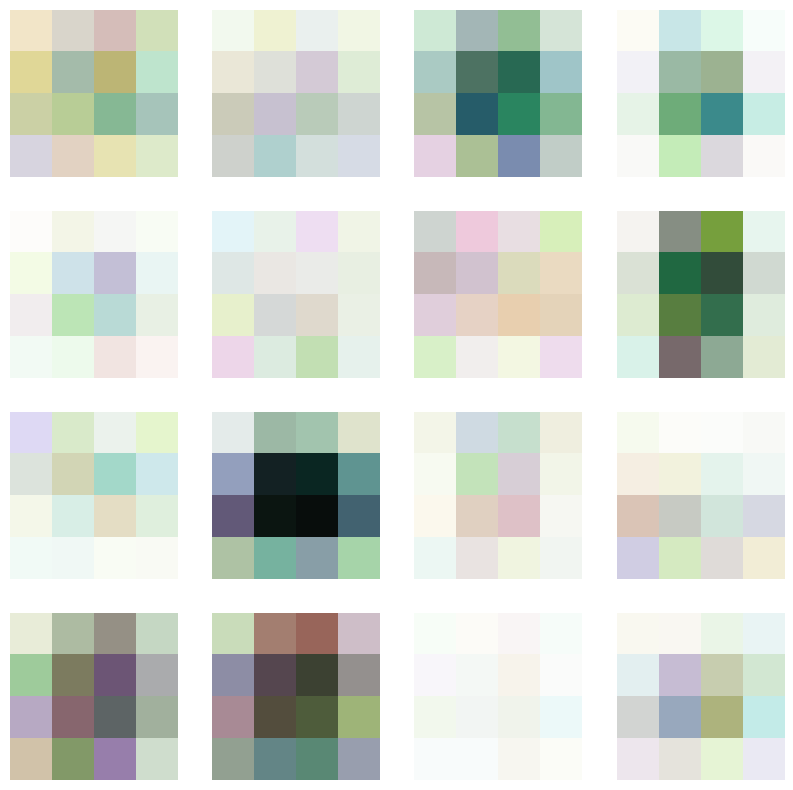

Step: 239
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.3038479089736938
Generator loss: 3.2463841438293457


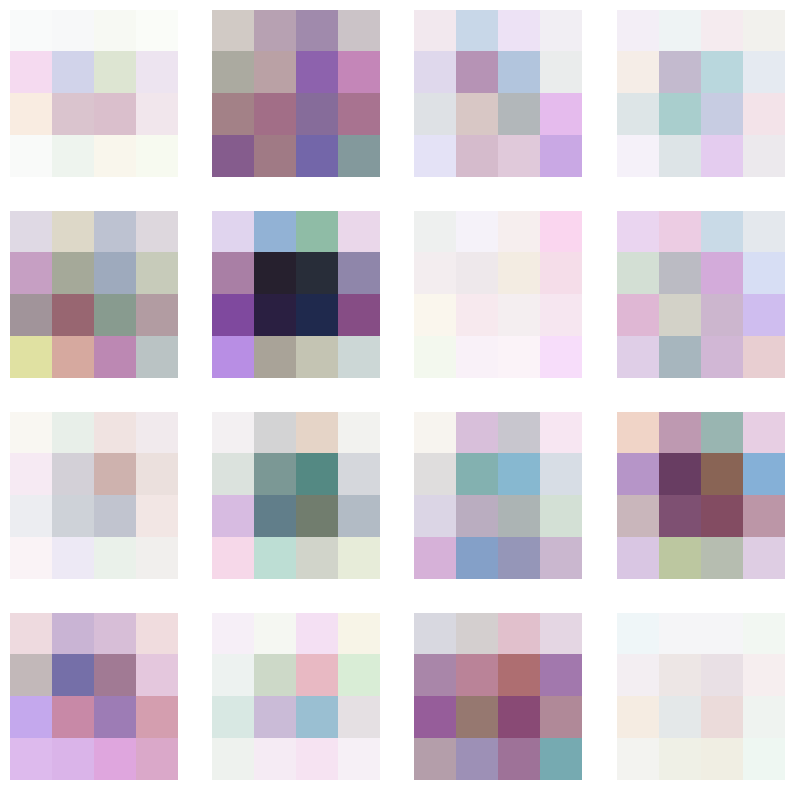

Step: 240
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2991803884506226
Generator loss: 3.2354180812835693


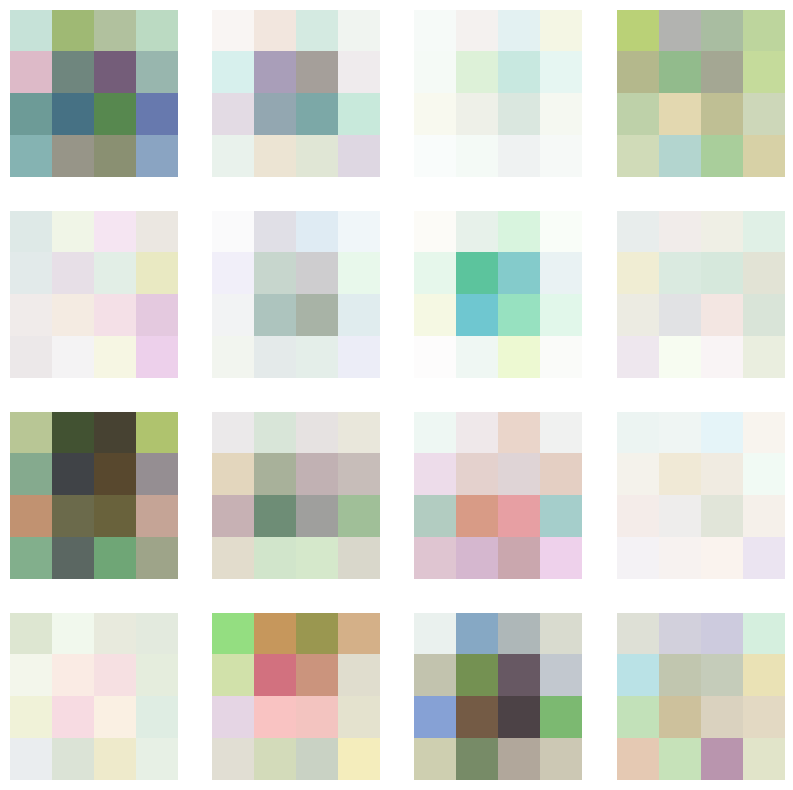

Step: 241
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2949285507202148
Generator loss: 3.2236292362213135


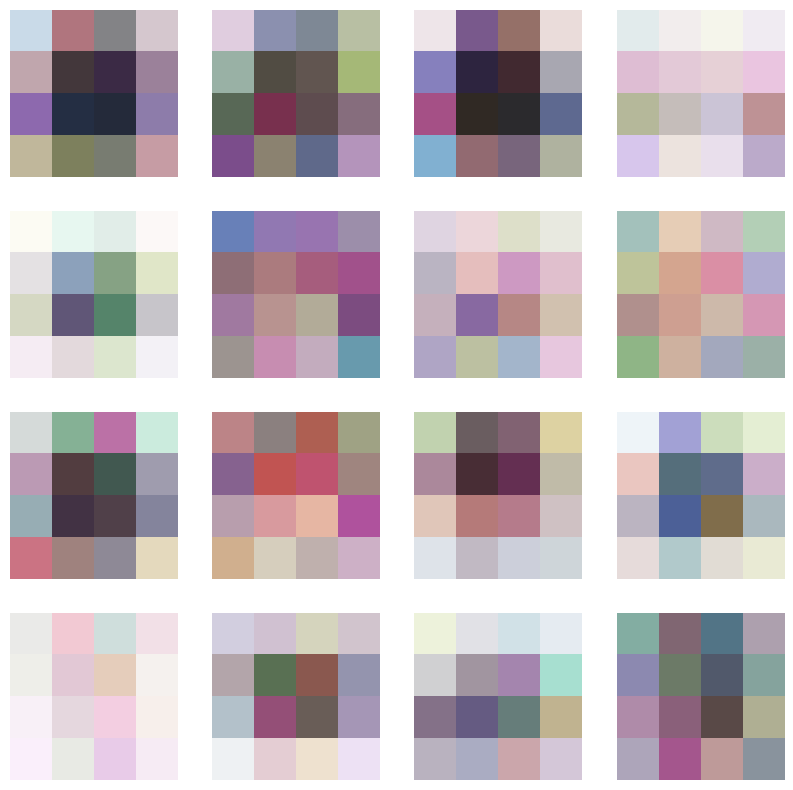

Step: 242
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2906756401062012
Generator loss: 3.2125566005706787


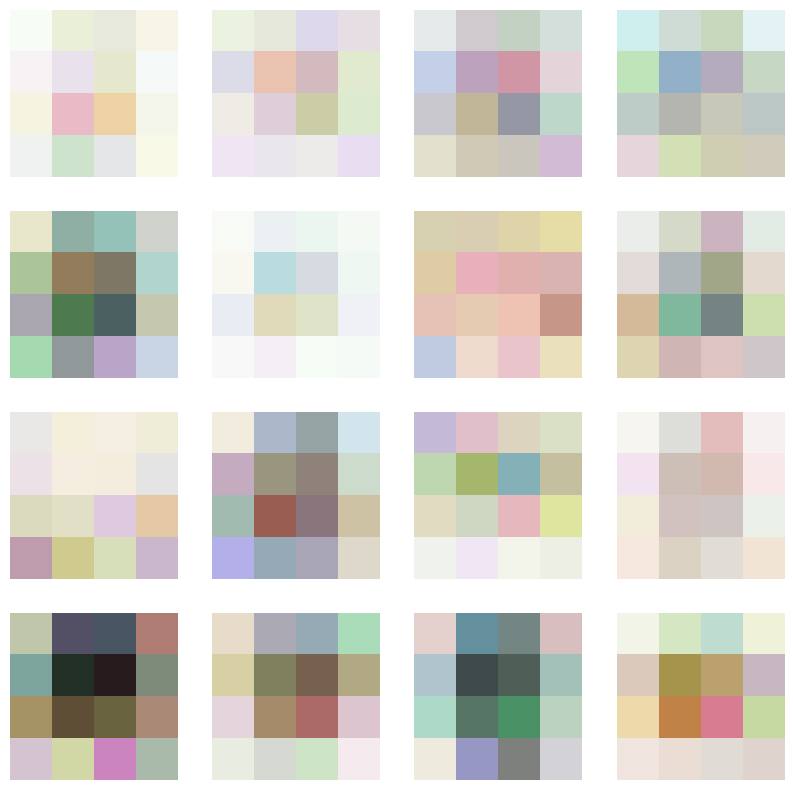

Step: 243
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2865631580352783
Generator loss: 3.20131778717041


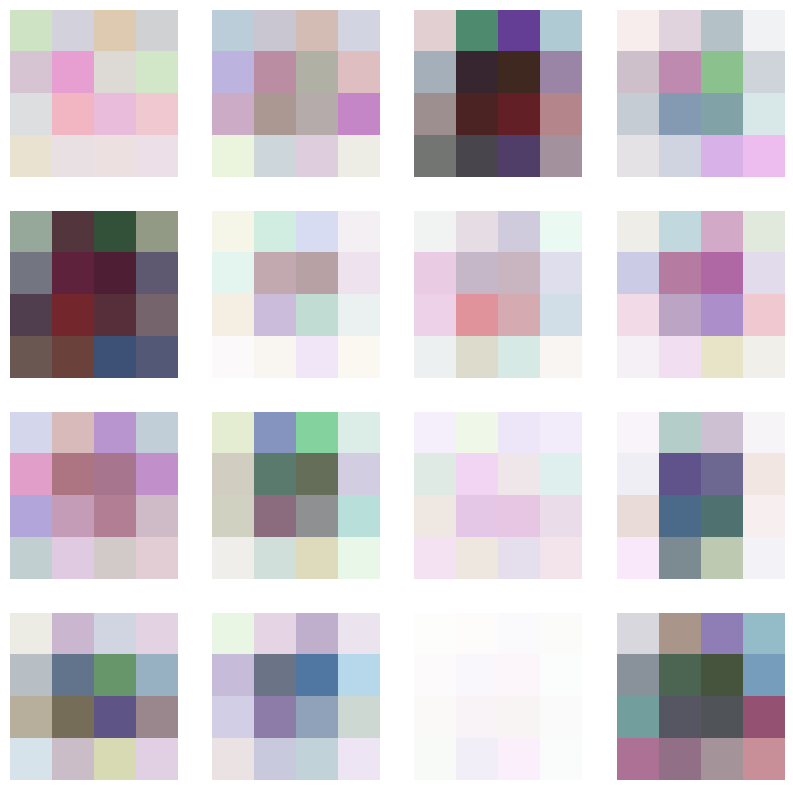

Step: 244
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2822232246398926
Generator loss: 3.1896133422851562


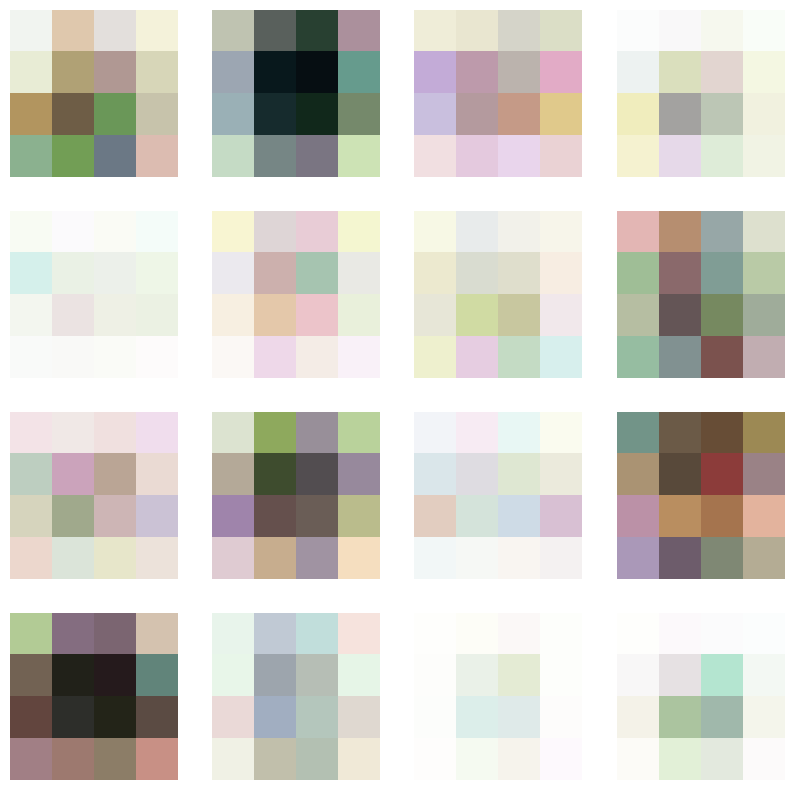

Step: 245
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2779511213302612
Generator loss: 3.177849292755127


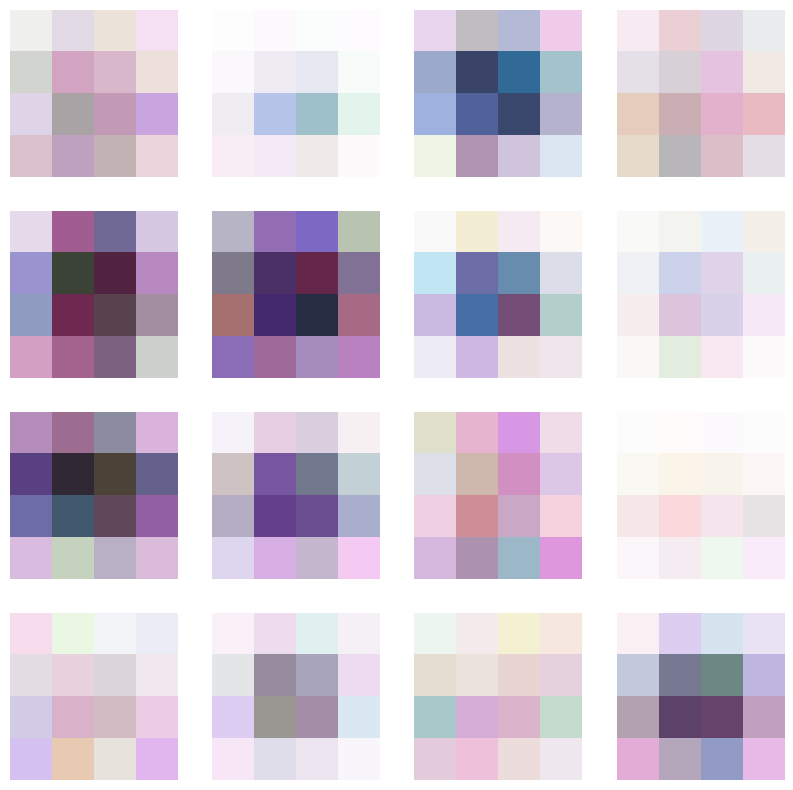

Step: 246
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2740041017532349
Generator loss: 3.1664817333221436


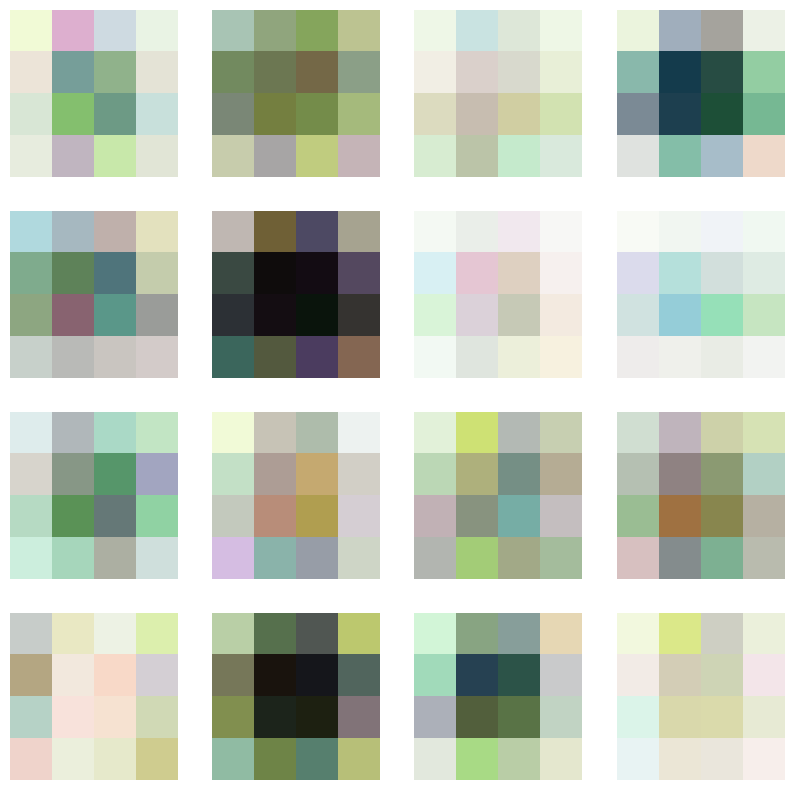

Step: 247
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.270066499710083
Generator loss: 3.1570990085601807


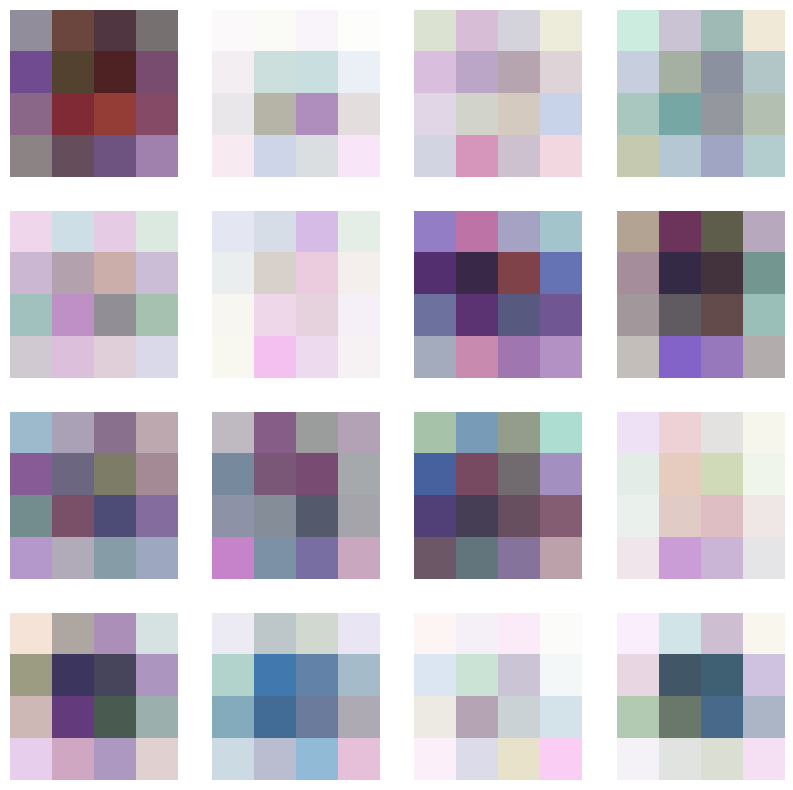

Step: 248
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2659838199615479
Generator loss: 3.1477091312408447


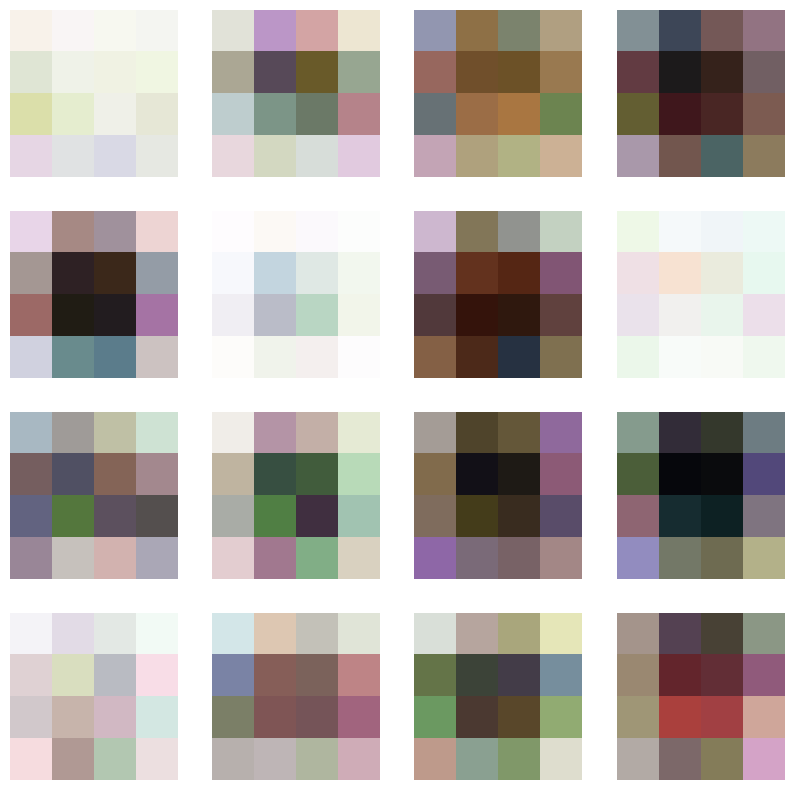

Step: 249
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2618955373764038
Generator loss: 3.1379330158233643


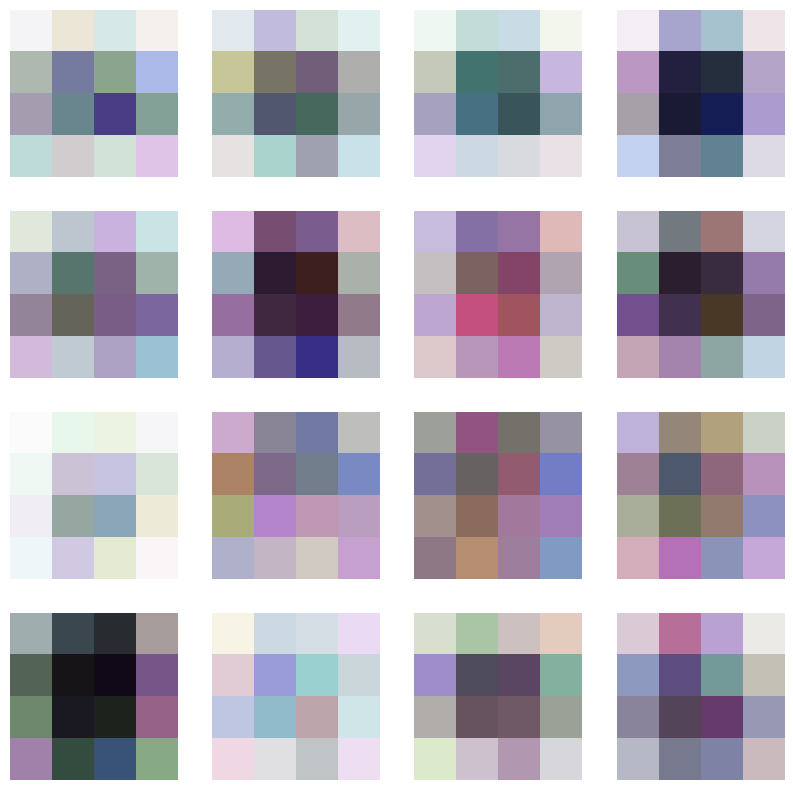

Step: 250
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2581787109375
Generator loss: 3.128133535385132


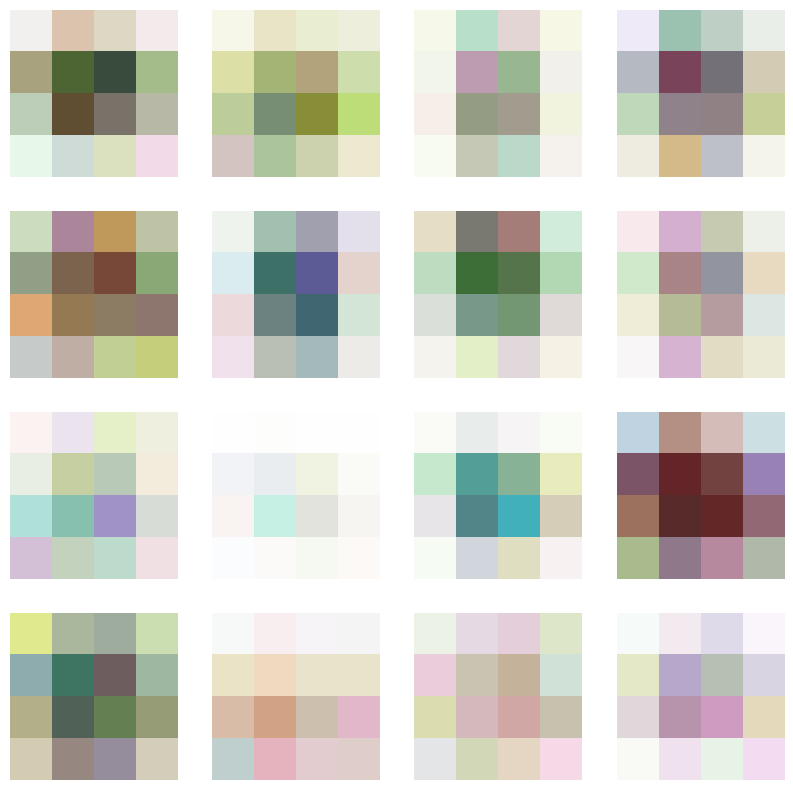

Step: 251
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2542006969451904
Generator loss: 3.118849039077759


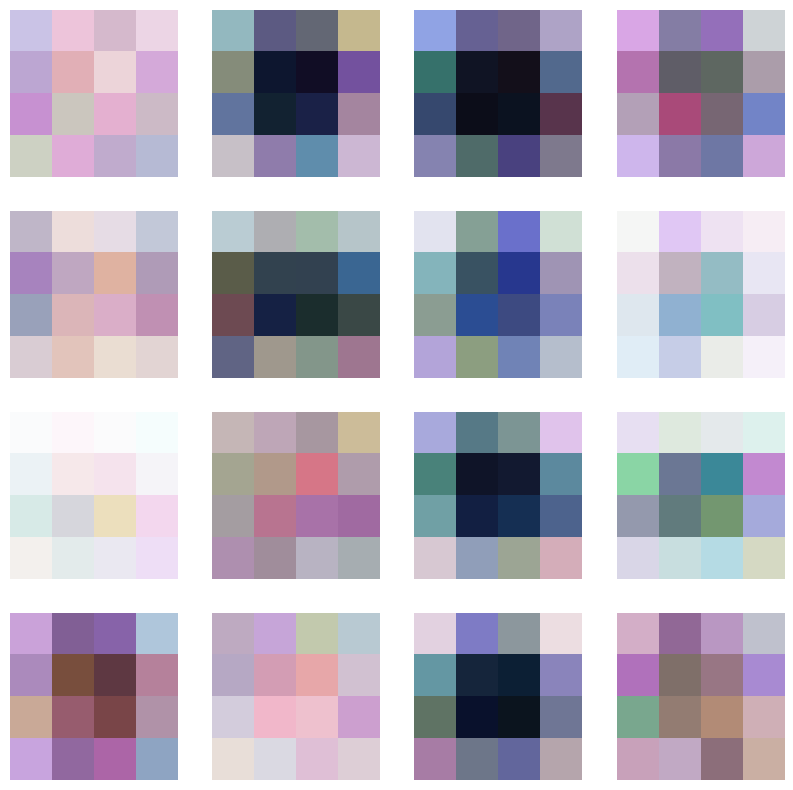

Step: 252
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2506048679351807
Generator loss: 3.1097209453582764


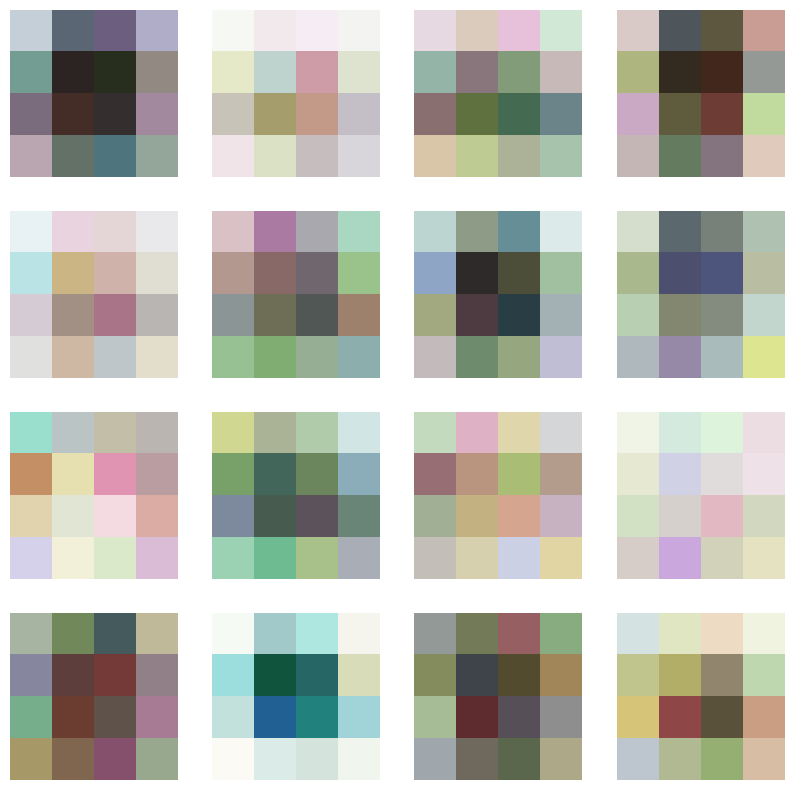

Step: 253
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2468287944793701
Generator loss: 3.0996286869049072


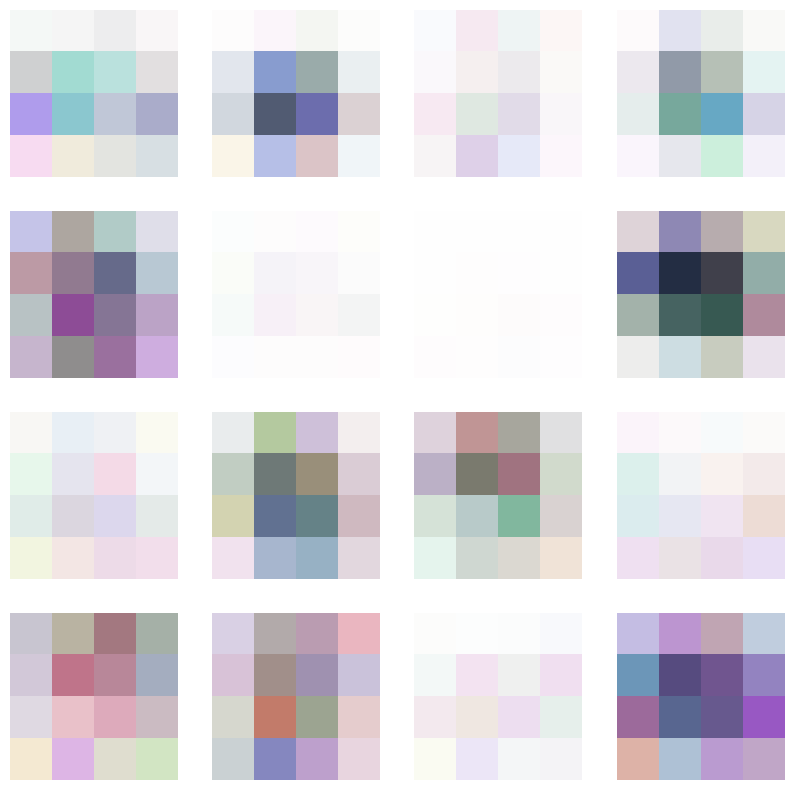

Step: 254
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.243363380432129
Generator loss: 3.087520122528076


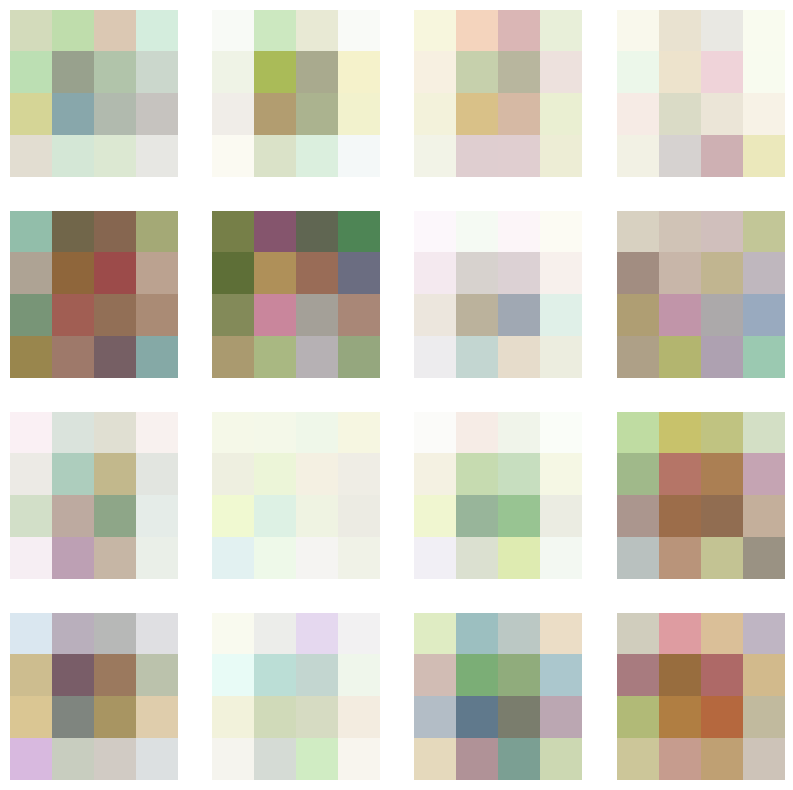

Step: 255
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2391360998153687
Generator loss: 3.075838327407837


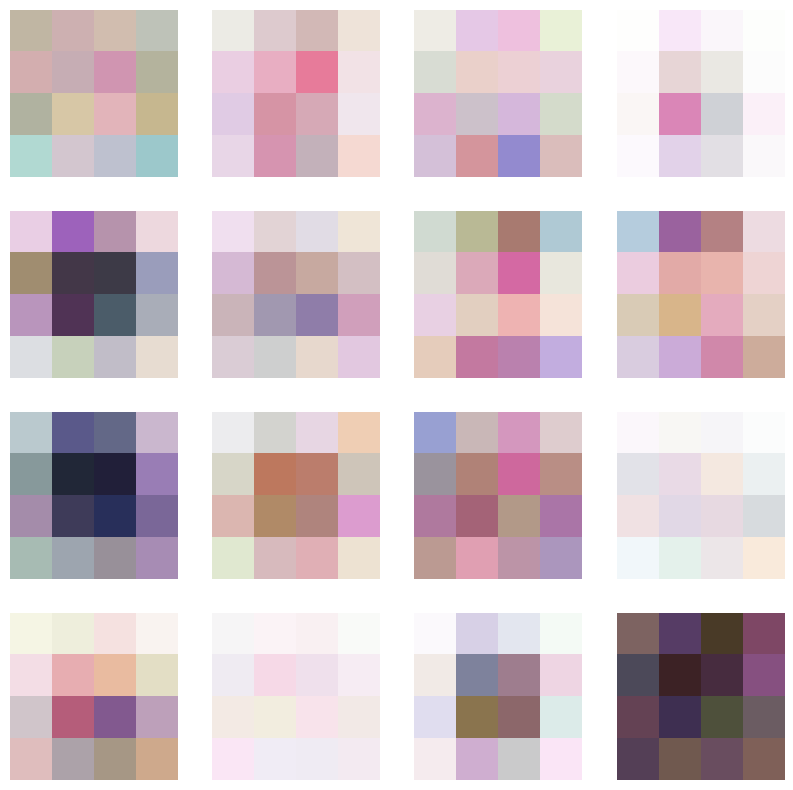

Step: 256
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2348265647888184
Generator loss: 3.067324161529541


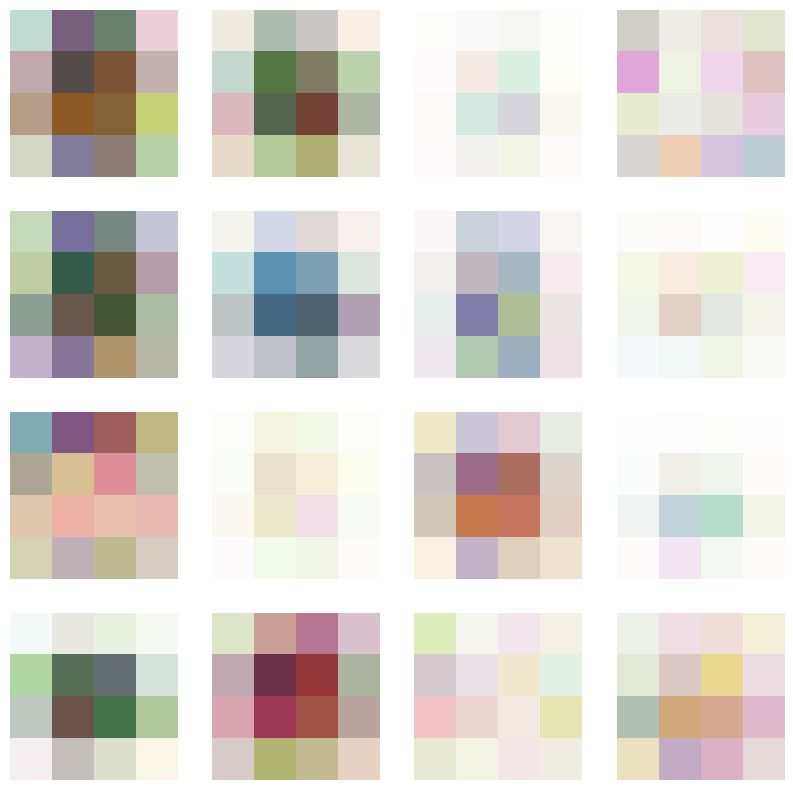

Step: 257
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2309705018997192
Generator loss: 3.0585856437683105


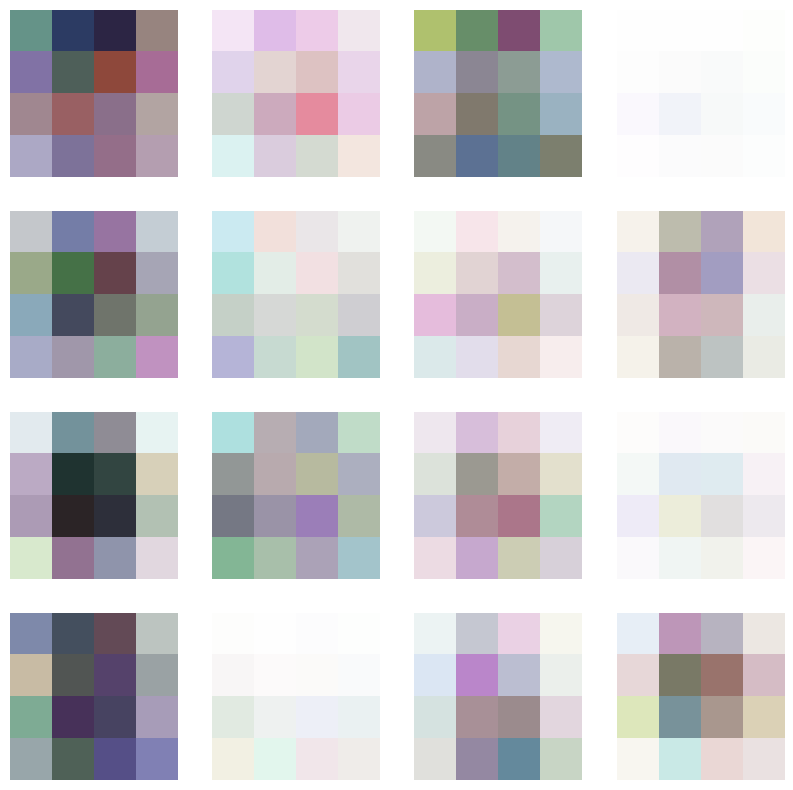

Step: 258
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2271562814712524
Generator loss: 3.0498952865600586


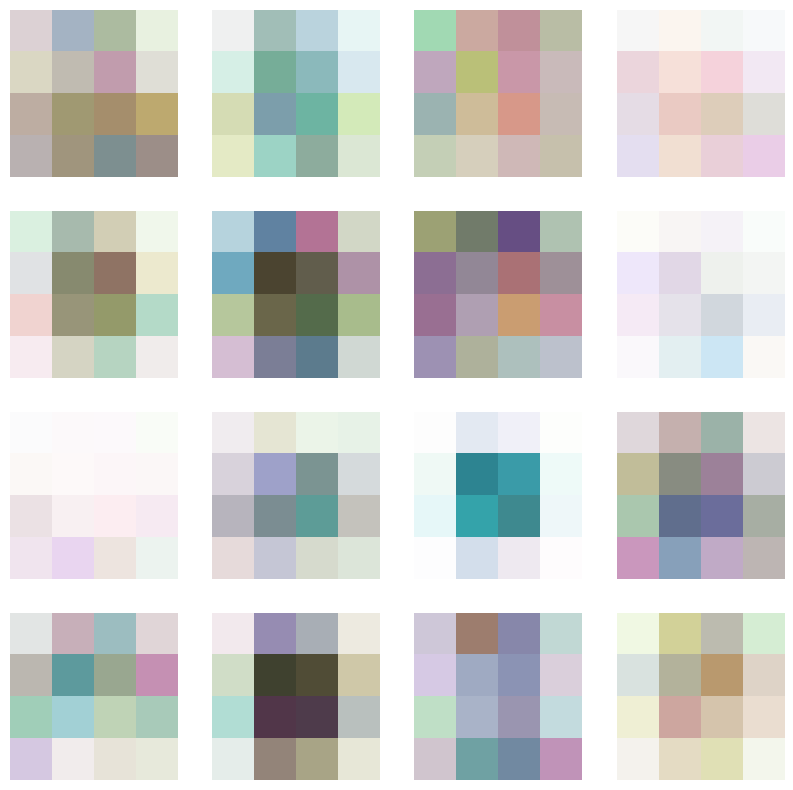

Step: 259
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2234572172164917
Generator loss: 3.041497230529785


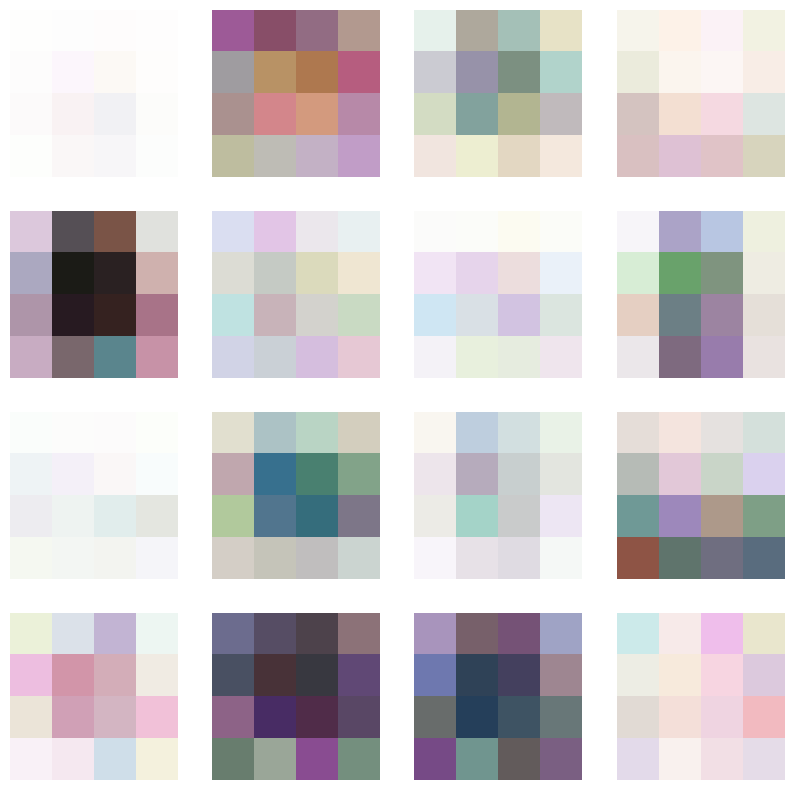

Step: 260
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2196615934371948
Generator loss: 3.031602621078491


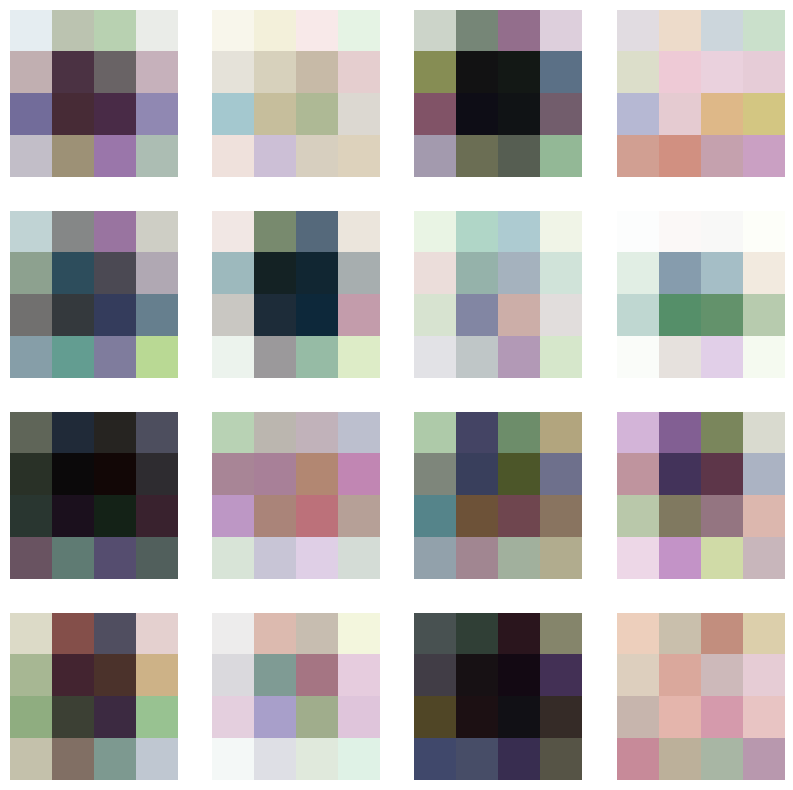

Step: 261
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.21591055393219
Generator loss: 3.021186590194702


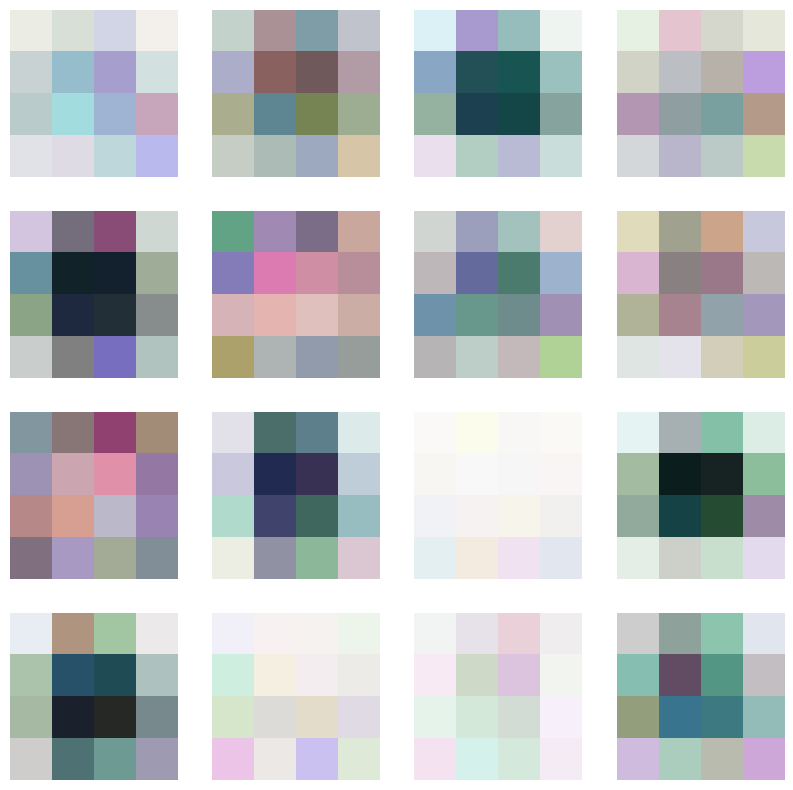

Step: 262
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2123750448226929
Generator loss: 3.00937557220459


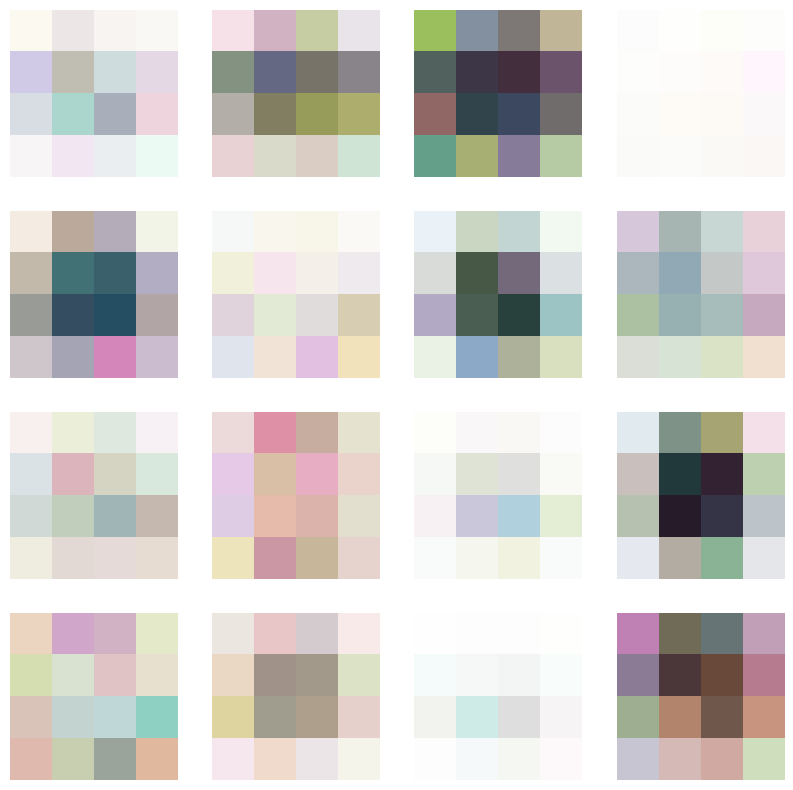

Step: 263
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.20864737033844
Generator loss: 2.9961555004119873


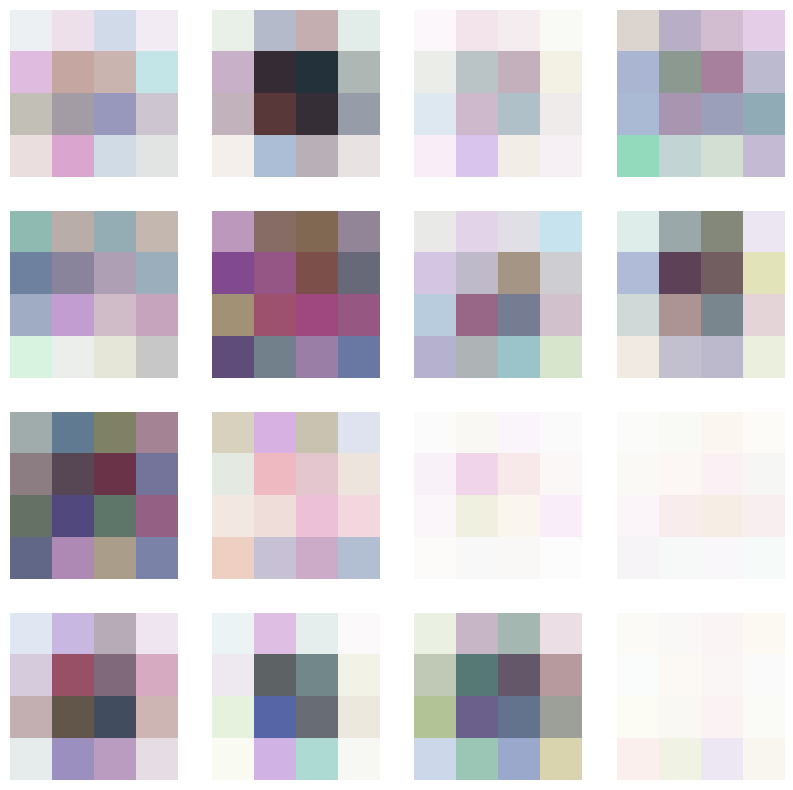

Step: 264
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2043451070785522
Generator loss: 2.984501600265503


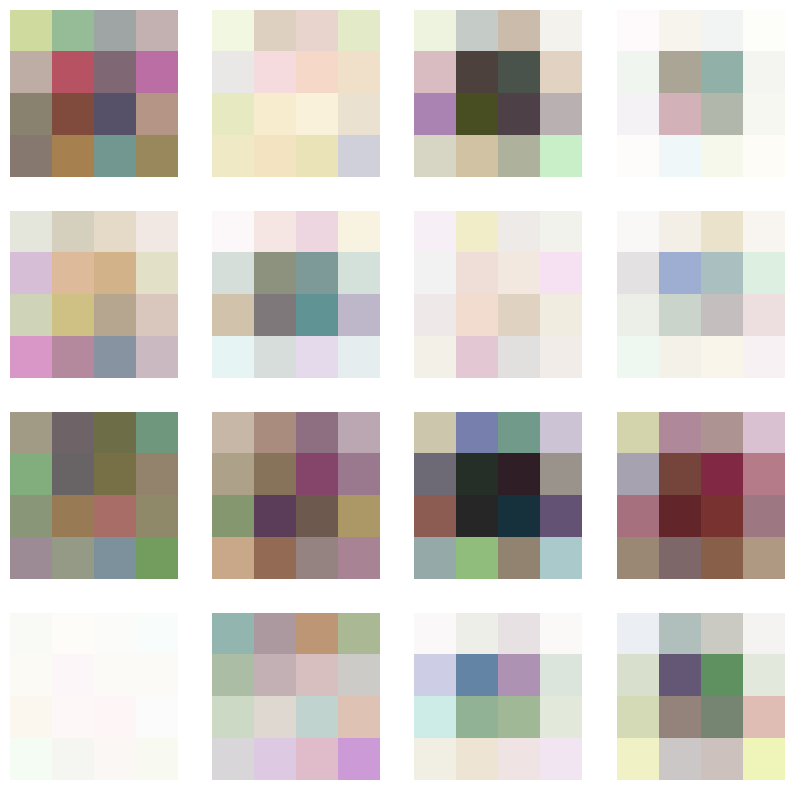

Step: 265
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.2002308368682861
Generator loss: 2.975435495376587


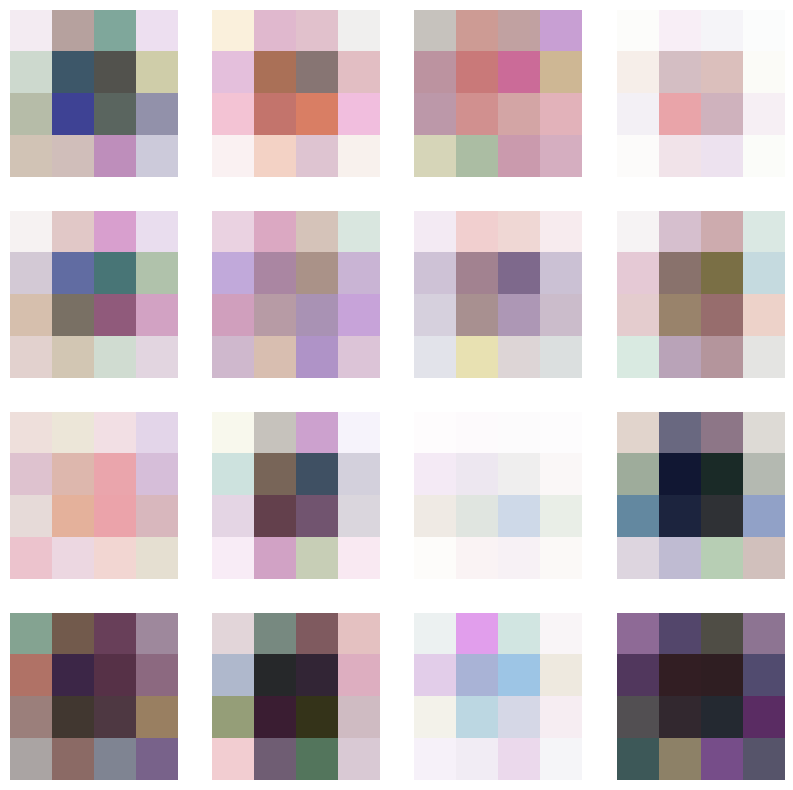

Step: 266
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1966956853866577
Generator loss: 2.967268705368042


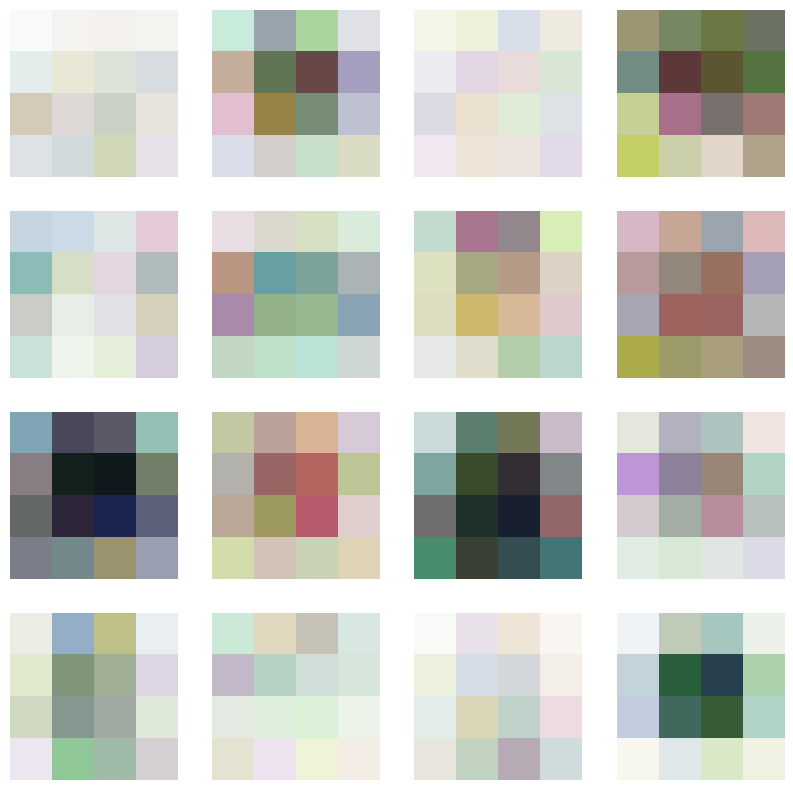

Step: 267
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1933677196502686
Generator loss: 2.9600555896759033


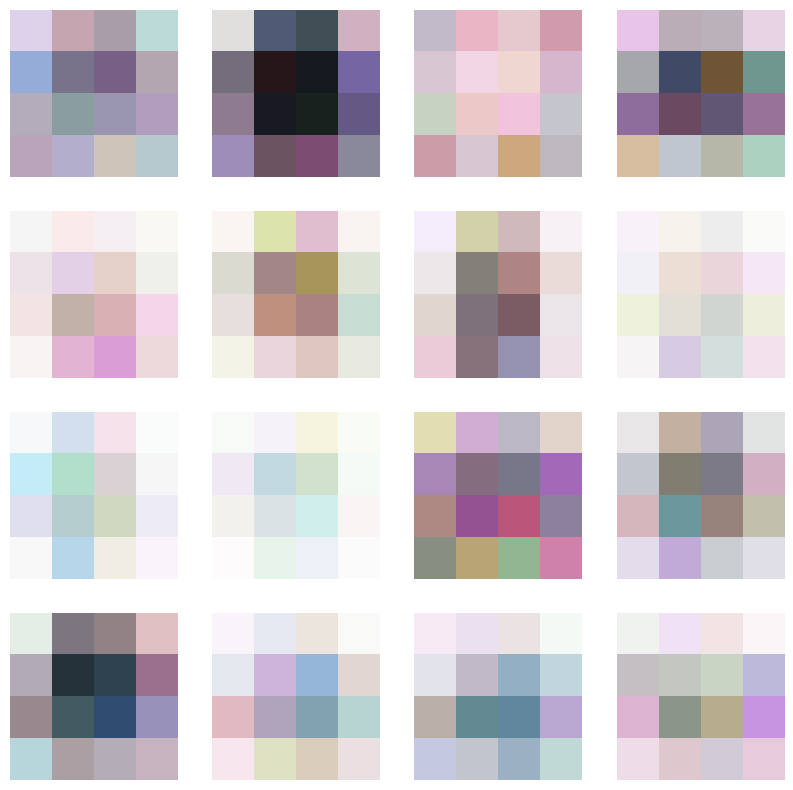

Step: 268
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1893421411514282
Generator loss: 2.950331926345825


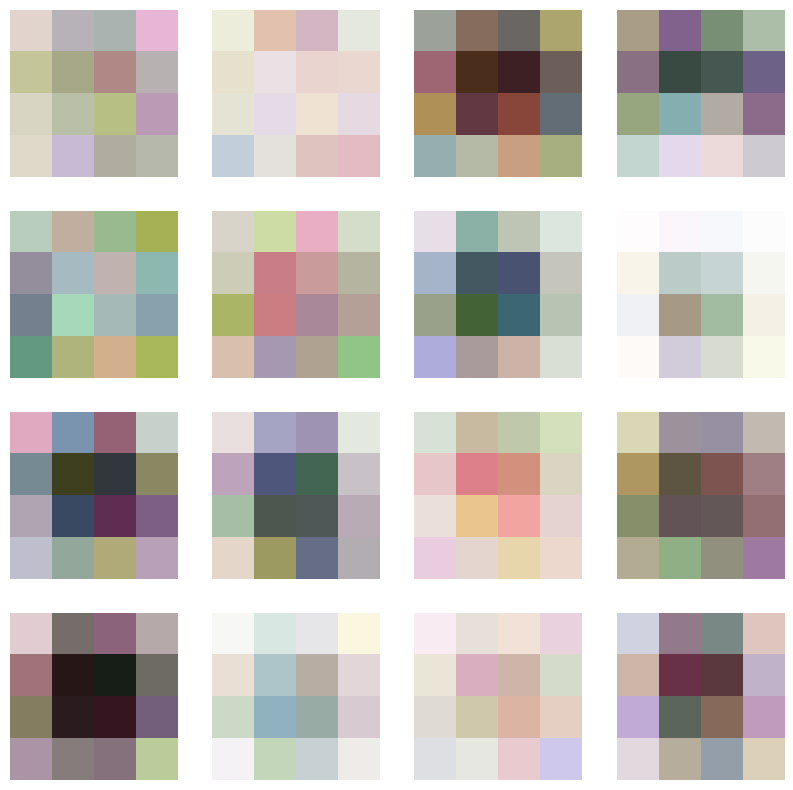

Step: 269
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1856119632720947
Generator loss: 2.9409053325653076


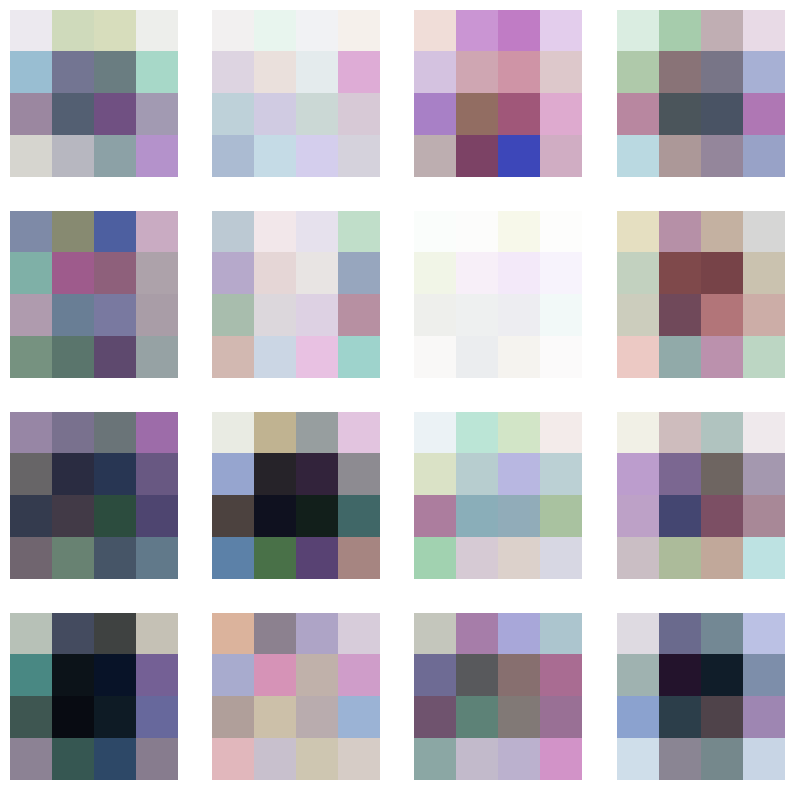

Step: 270
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.182305097579956
Generator loss: 2.9299495220184326


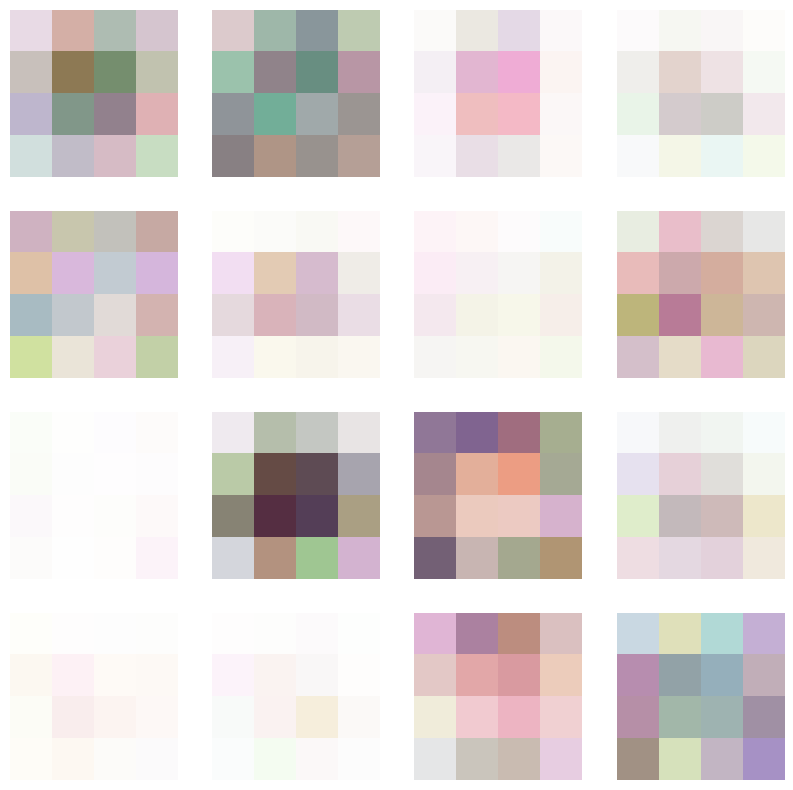

Step: 271
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1779710054397583
Generator loss: 2.920339822769165


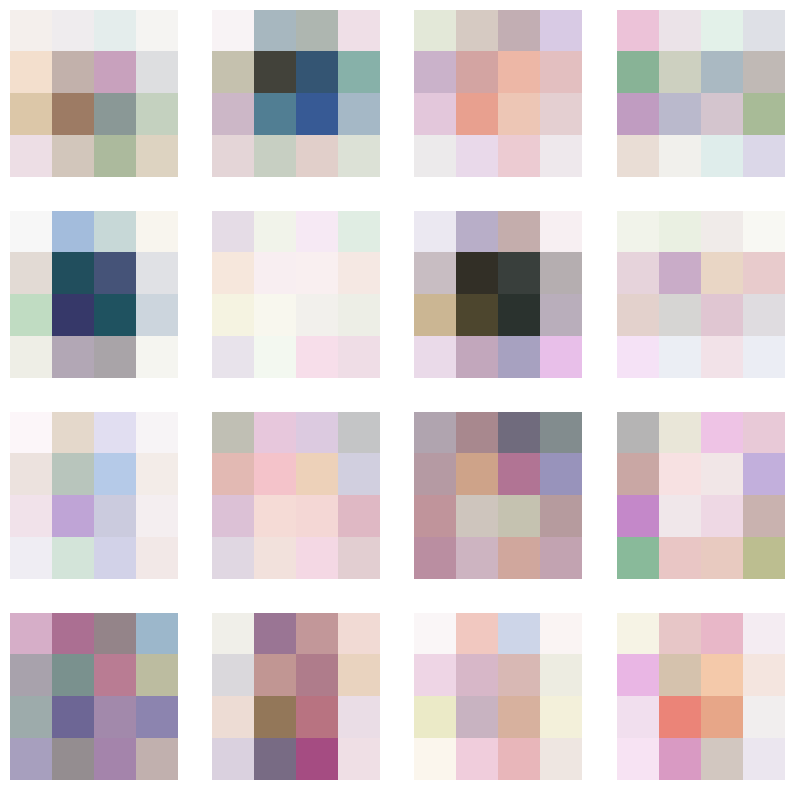

Step: 272
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.17446768283844
Generator loss: 2.9130914211273193


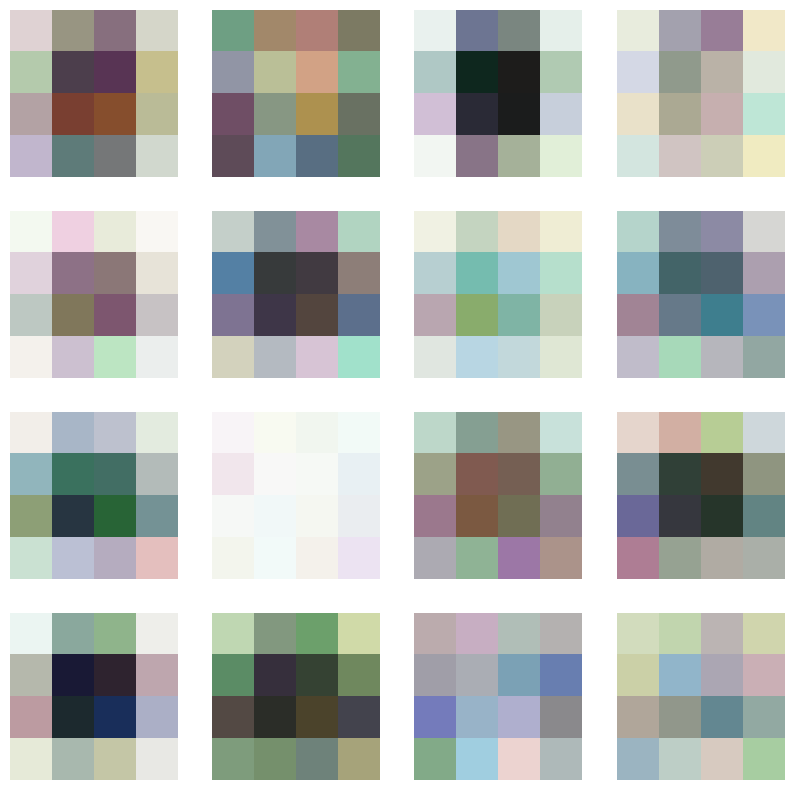

Step: 273
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1705777645111084
Generator loss: 2.9035050868988037


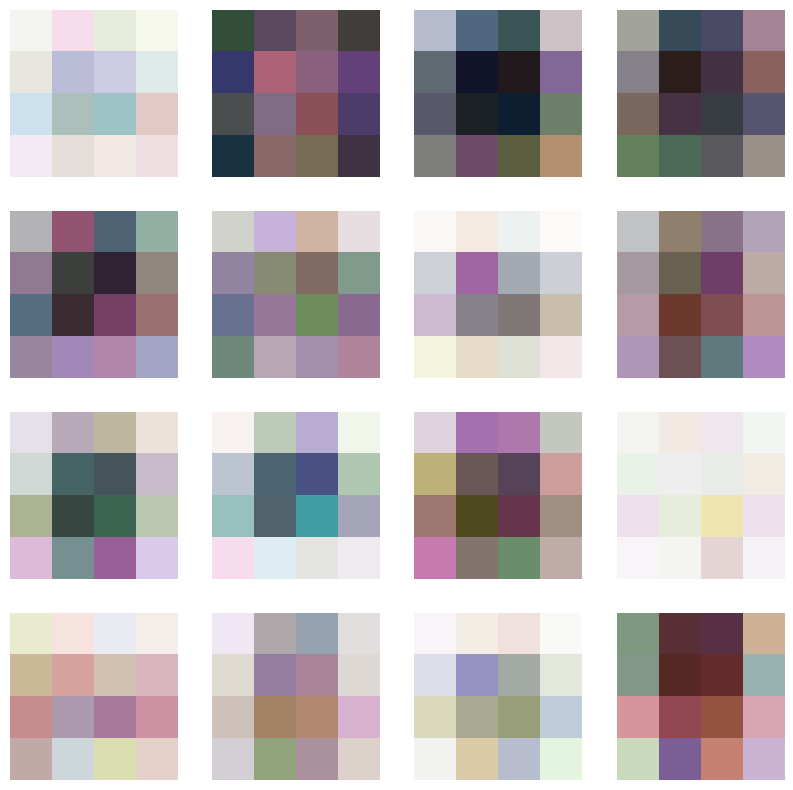

Step: 274
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1670563220977783
Generator loss: 2.8949337005615234


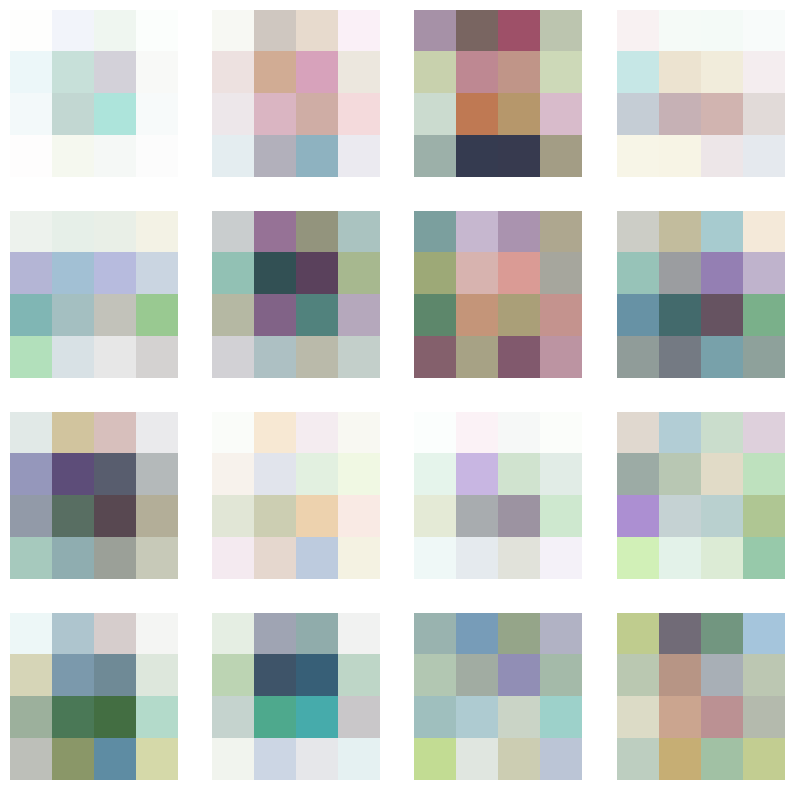

Step: 275
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.163472056388855
Generator loss: 2.8855388164520264


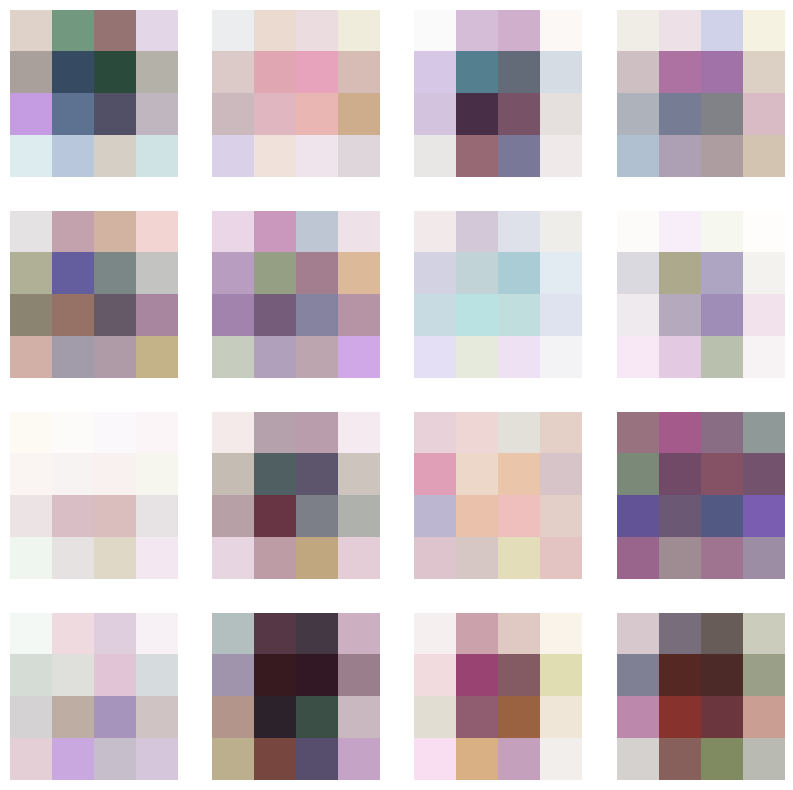

Step: 276
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1598106622695923
Generator loss: 2.875771999359131


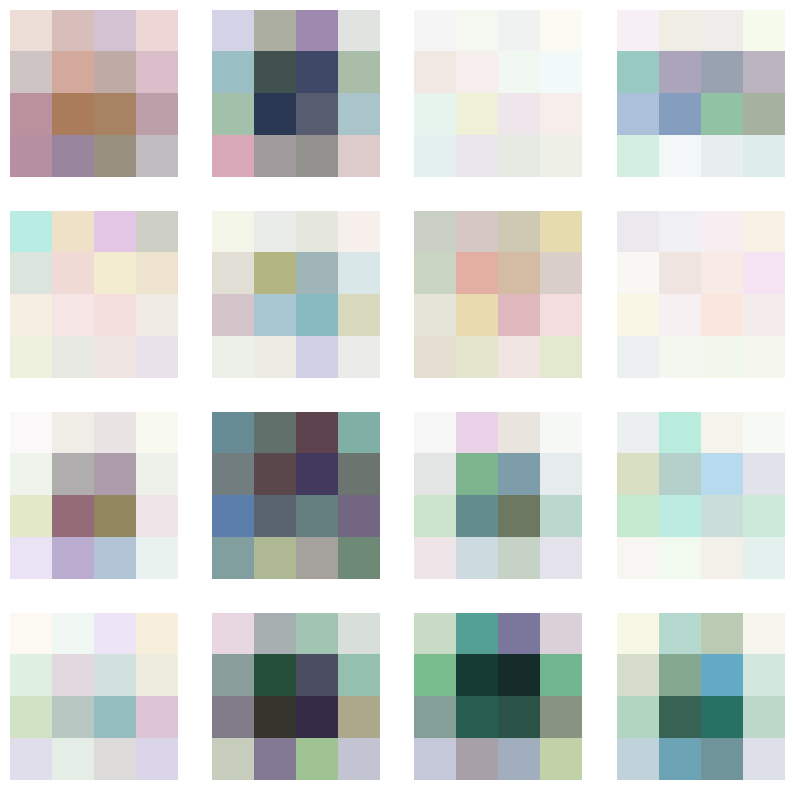

Step: 277
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1560978889465332
Generator loss: 2.868004322052002


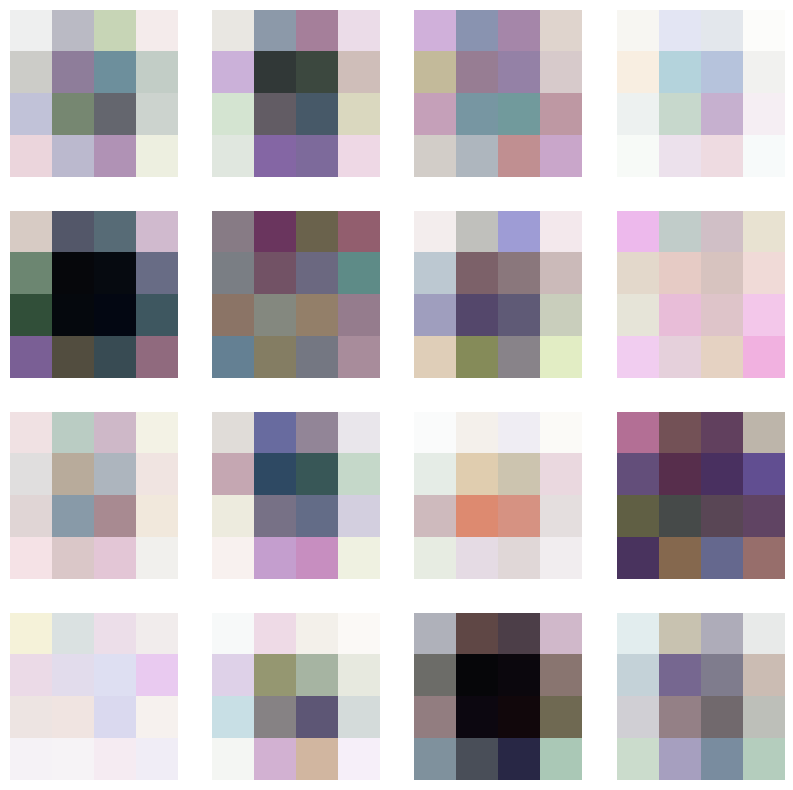

Step: 278
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.152723789215088
Generator loss: 2.8610715866088867


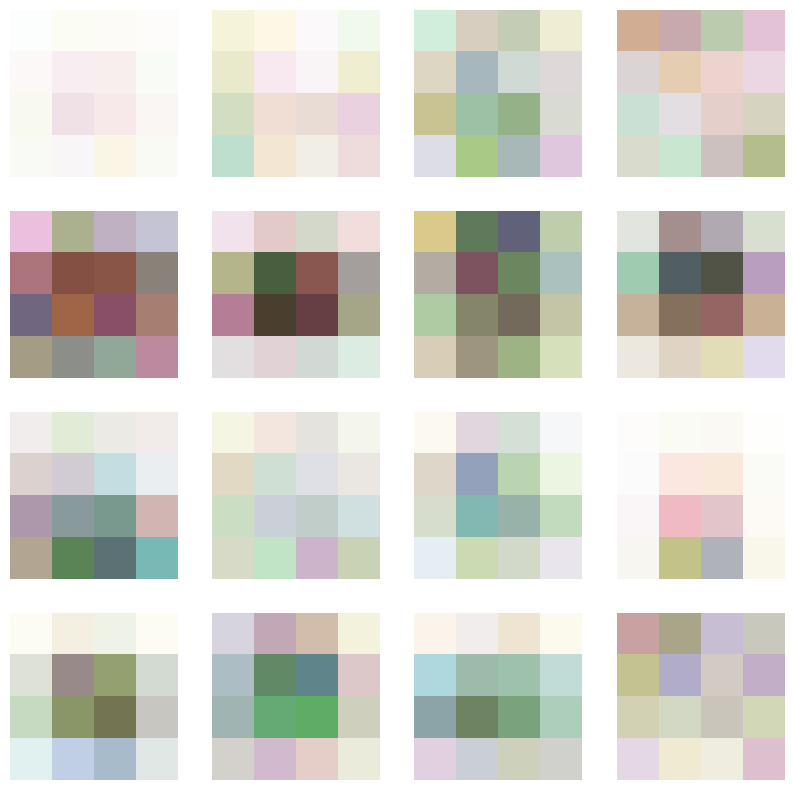

Step: 279
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1488630771636963
Generator loss: 2.851227283477783


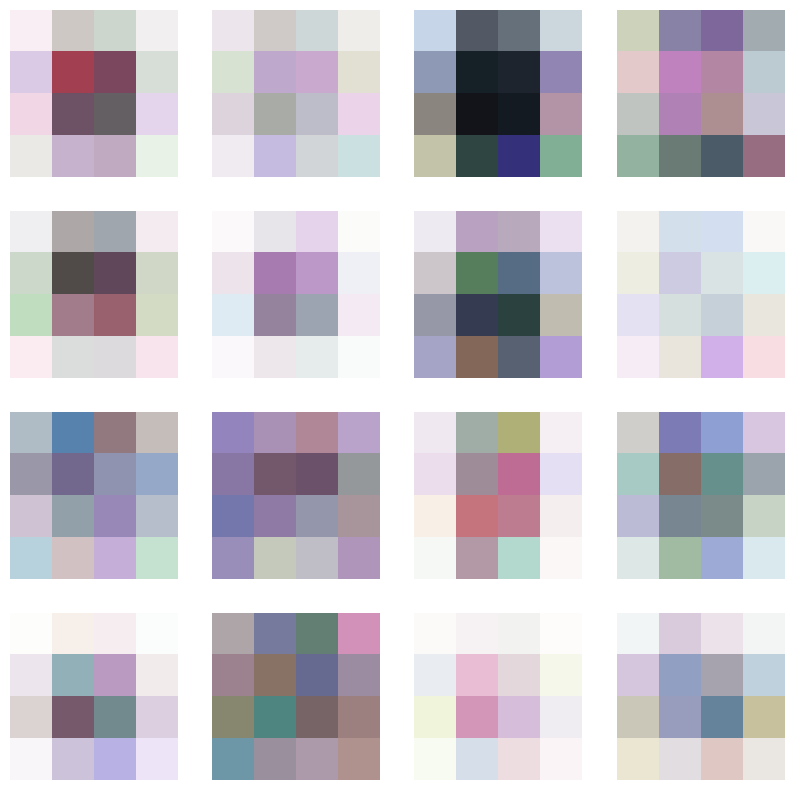

Step: 280
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1451787948608398
Generator loss: 2.842094659805298


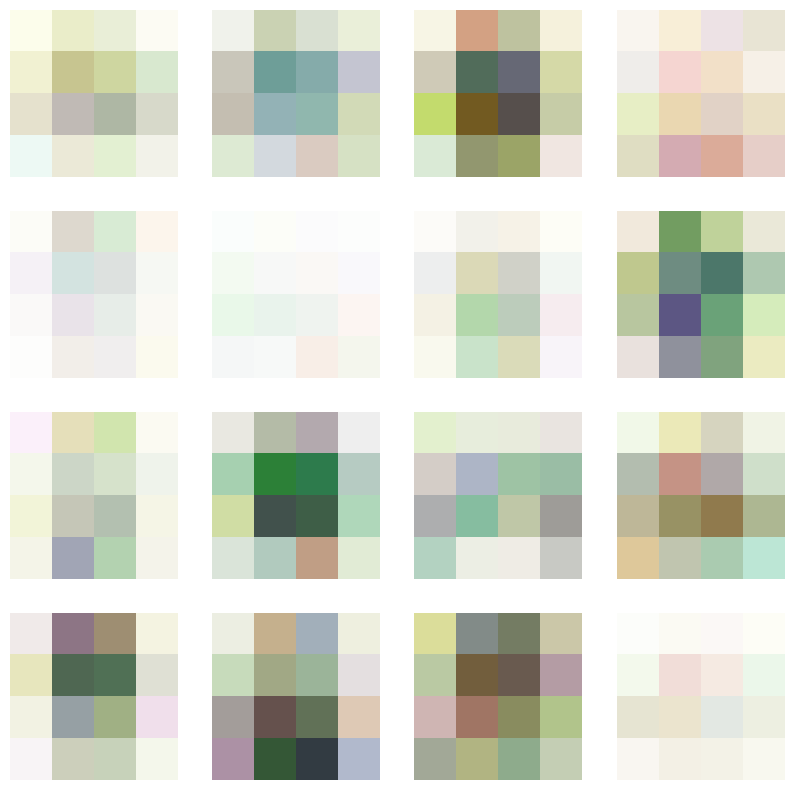

Step: 281
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1417242288589478
Generator loss: 2.8339977264404297


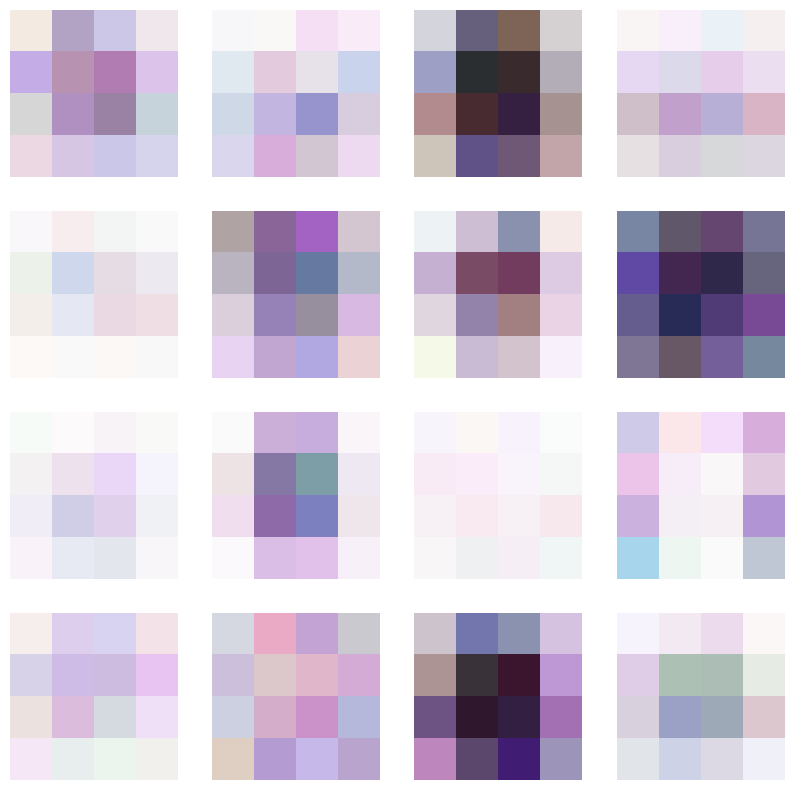

Step: 282
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1392182111740112
Generator loss: 2.827232599258423


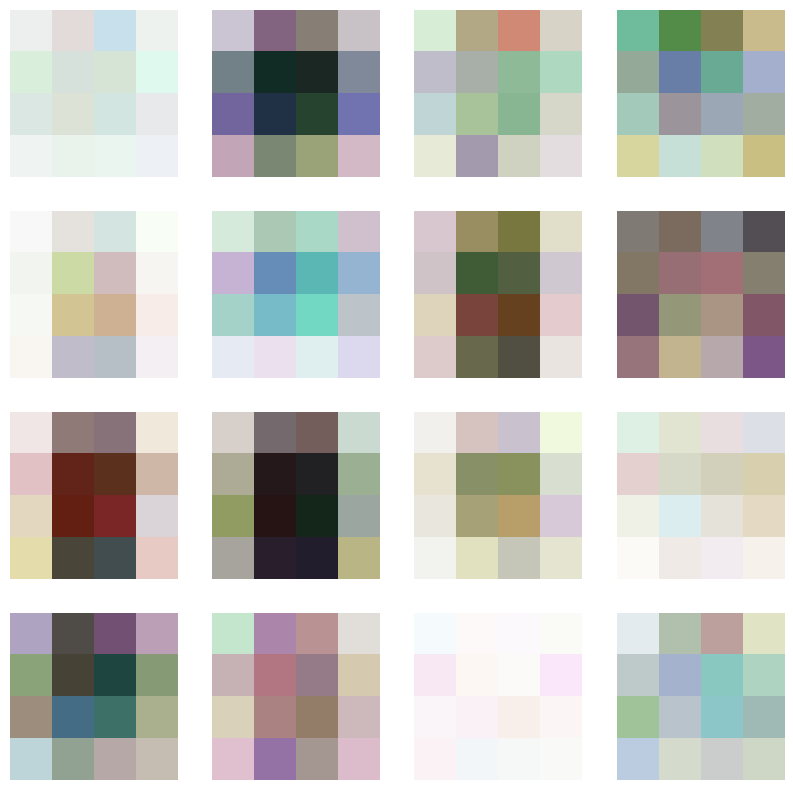

Step: 283
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1358485221862793
Generator loss: 2.8178603649139404


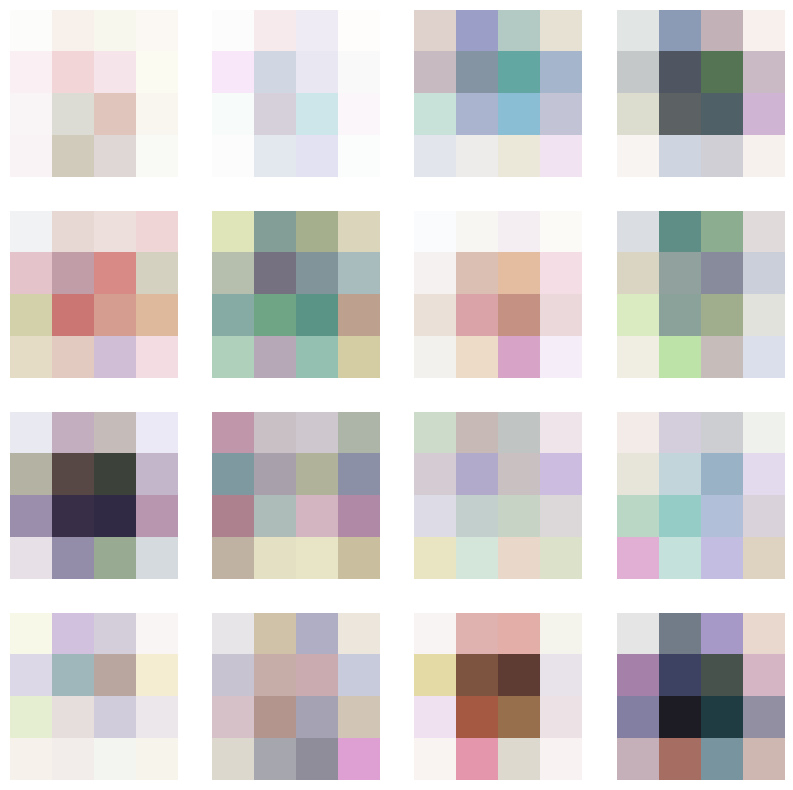

Step: 284
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1327208280563354
Generator loss: 2.8092591762542725


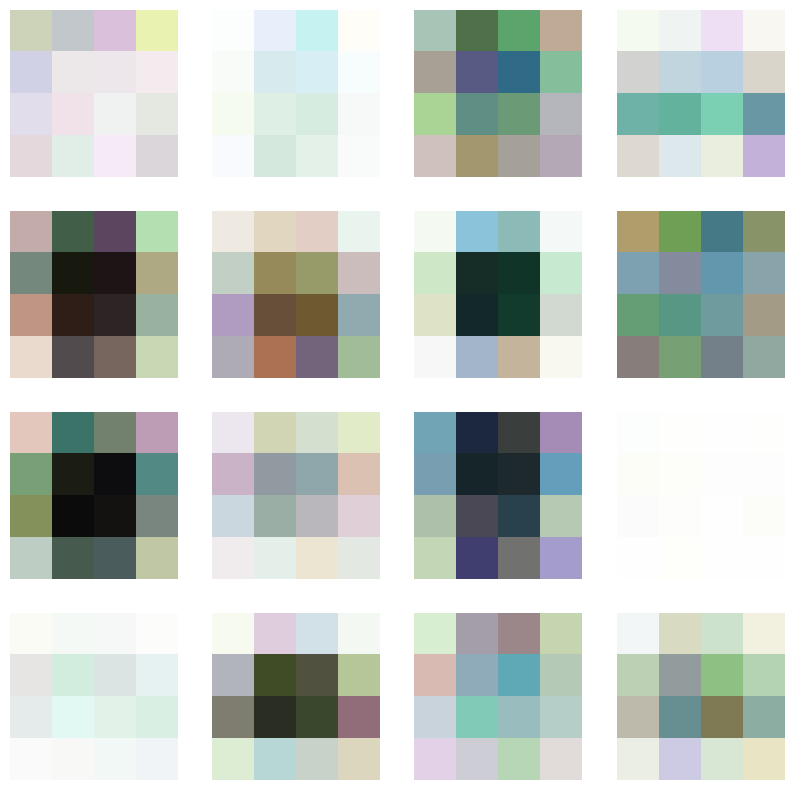

Step: 285
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1293320655822754
Generator loss: 2.798576831817627


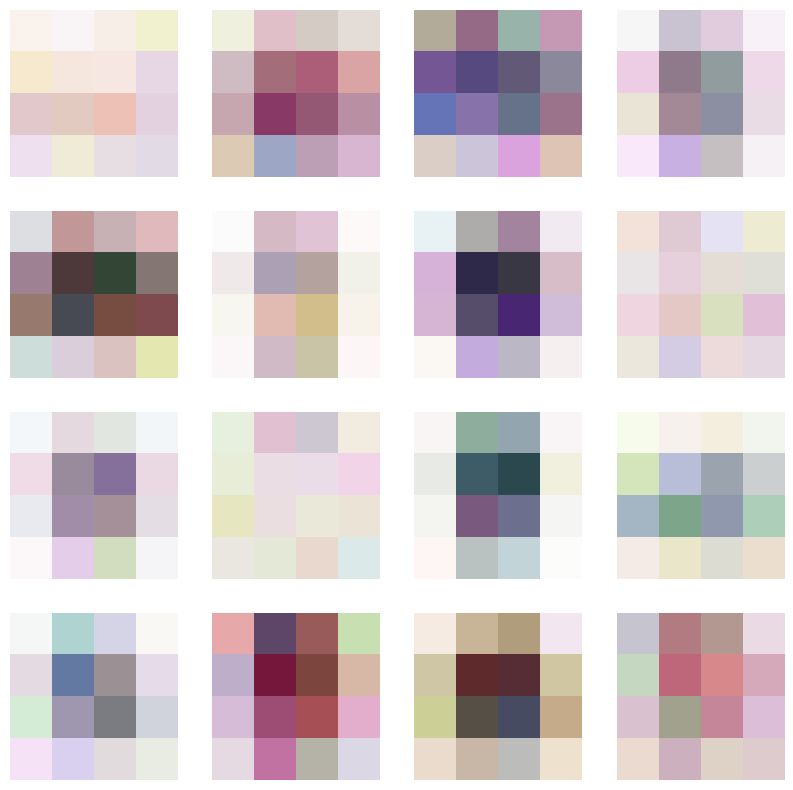

Step: 286
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.126139760017395
Generator loss: 2.787529230117798


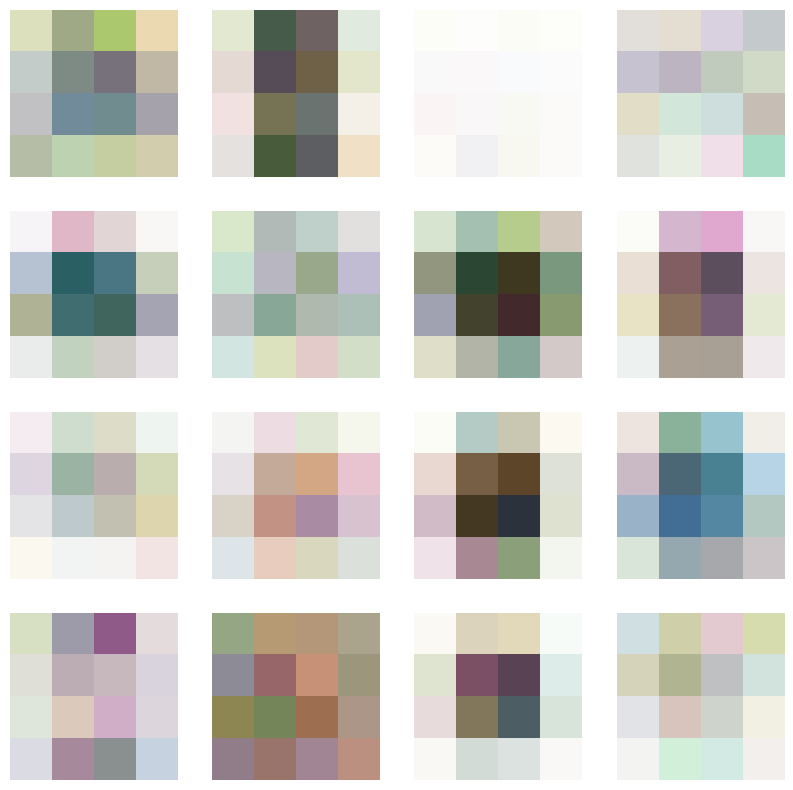

Step: 287
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.122706651687622
Generator loss: 2.7798869609832764


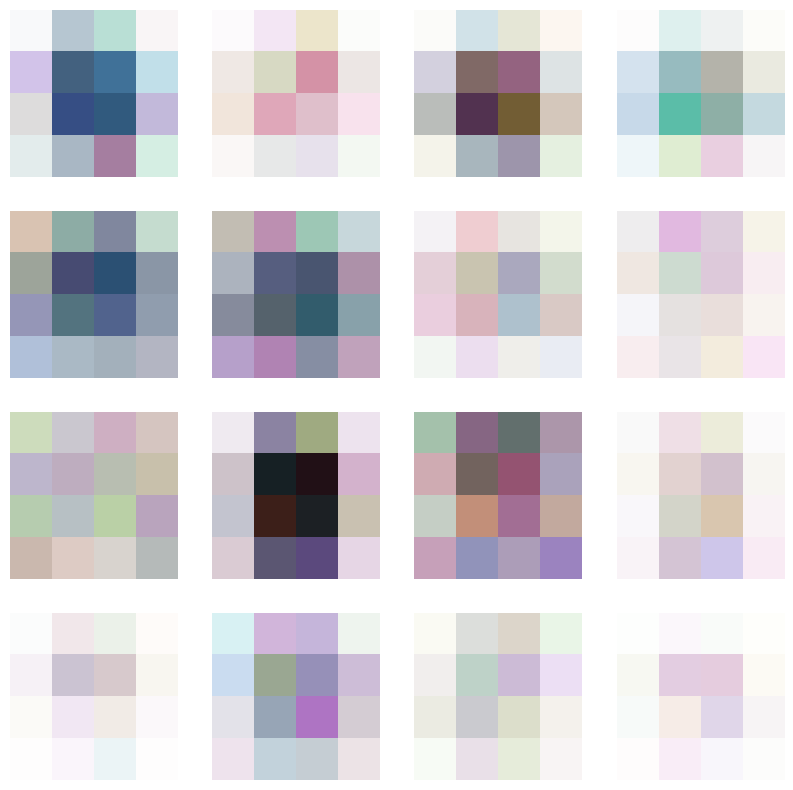

Step: 288
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1194342374801636
Generator loss: 2.771419048309326


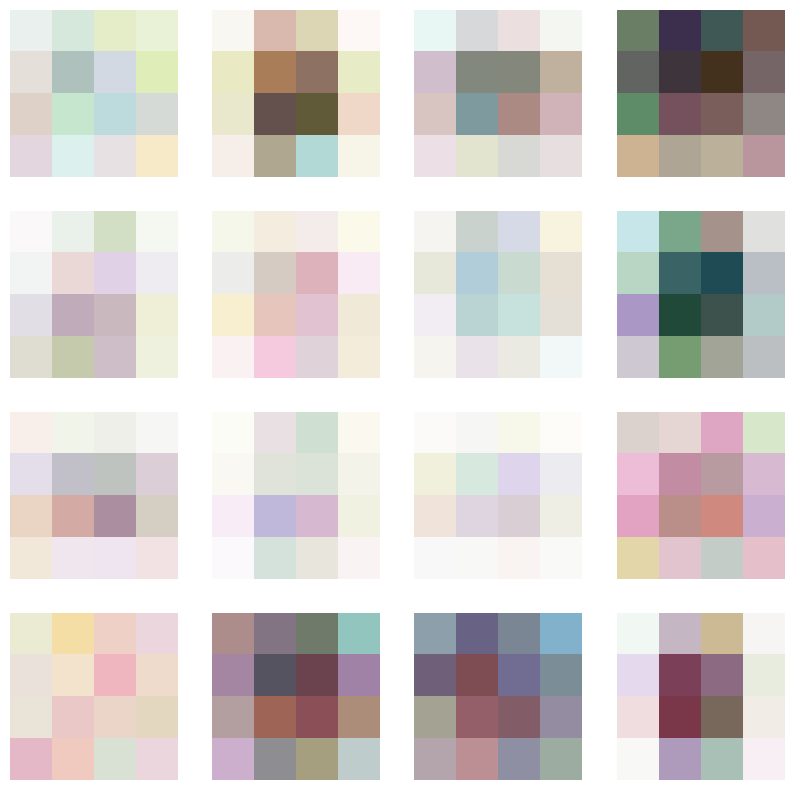

Step: 289
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1163949966430664
Generator loss: 2.7631216049194336


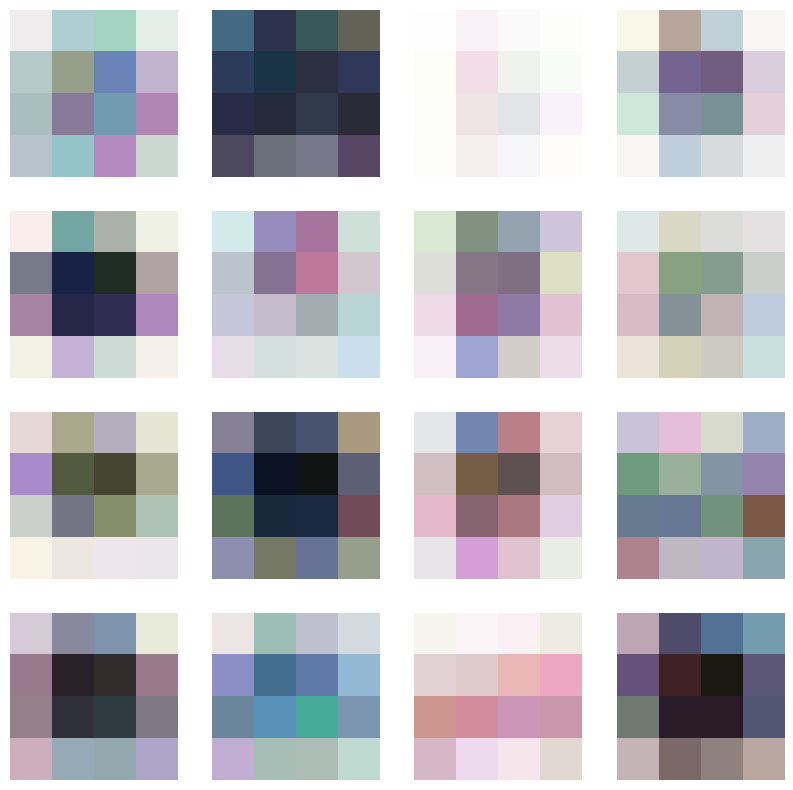

Step: 290
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1132869720458984
Generator loss: 2.7539782524108887


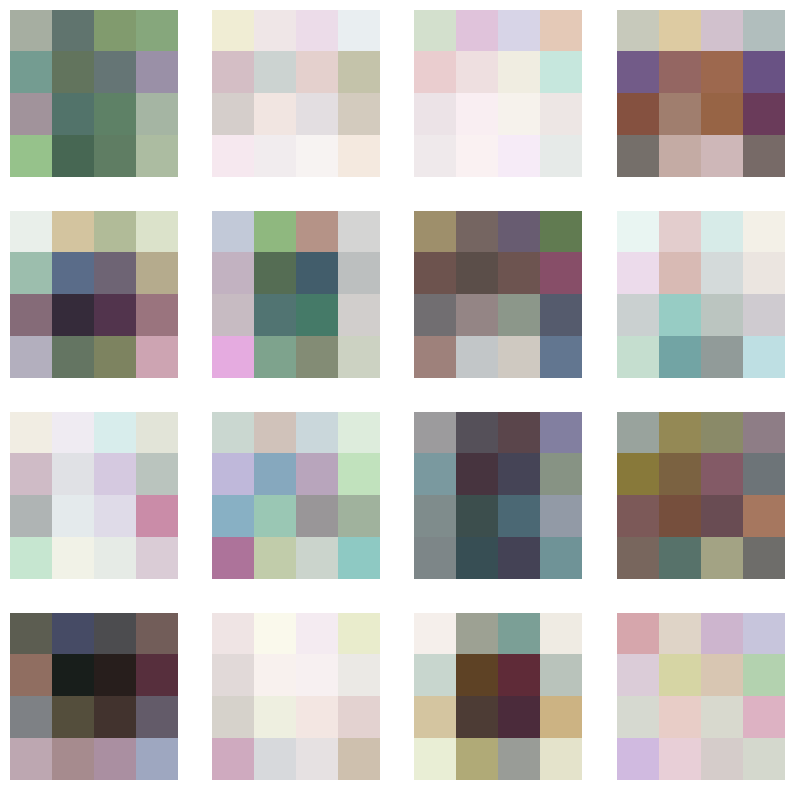

Step: 291
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1100832223892212
Generator loss: 2.745851755142212


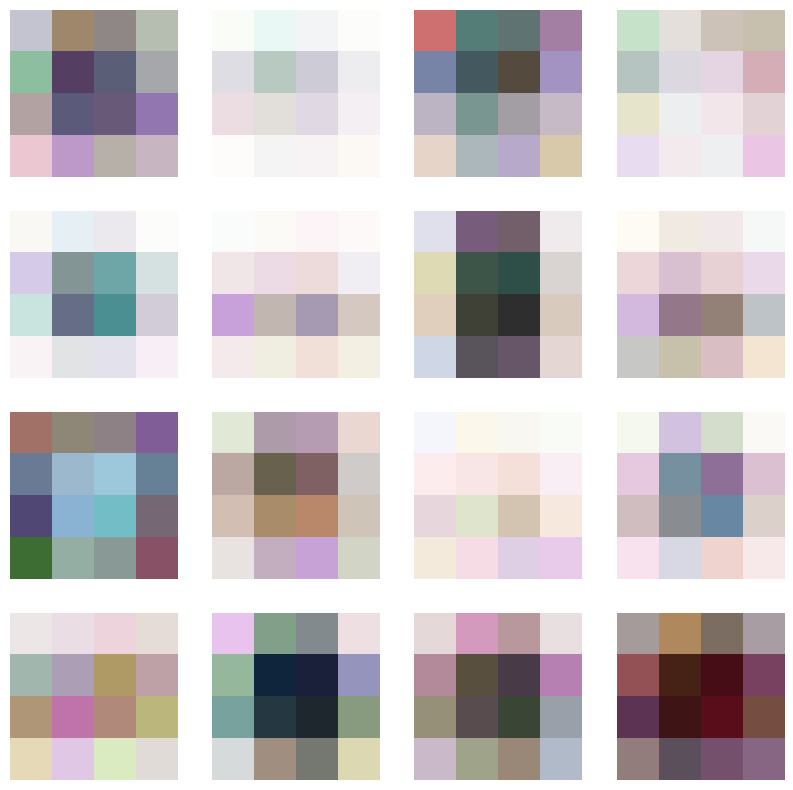

Step: 292
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1066055297851562
Generator loss: 2.735963821411133


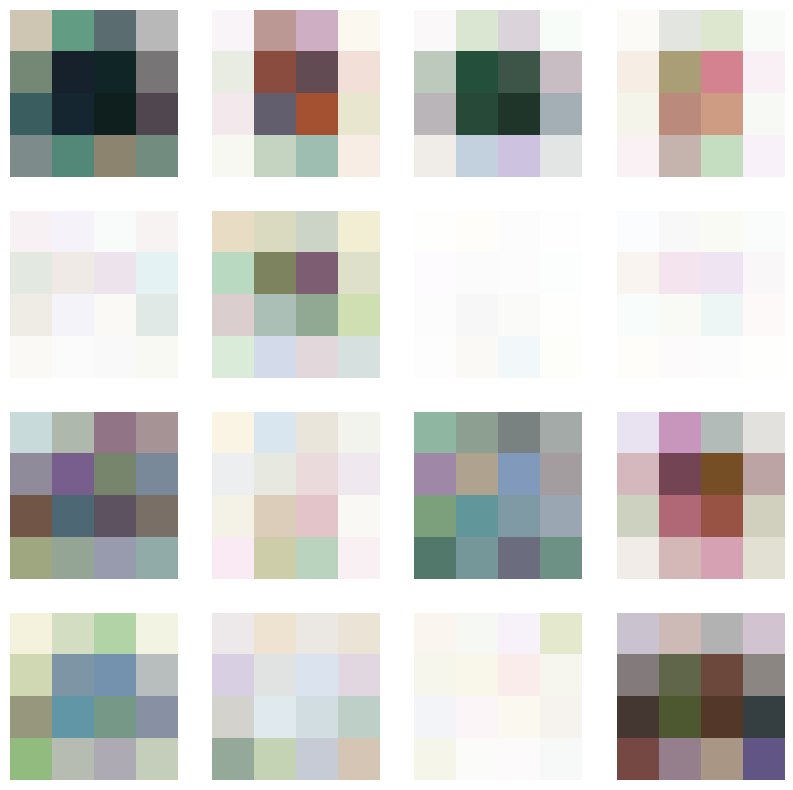

Step: 293
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.1033174991607666
Generator loss: 2.725864887237549


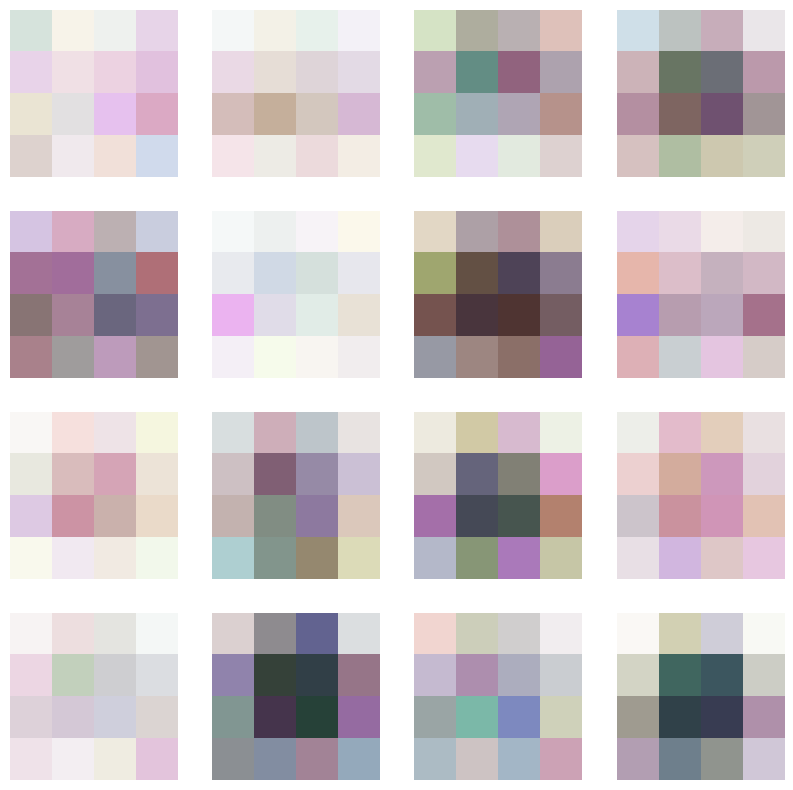

Step: 294
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0998386144638062
Generator loss: 2.7180919647216797


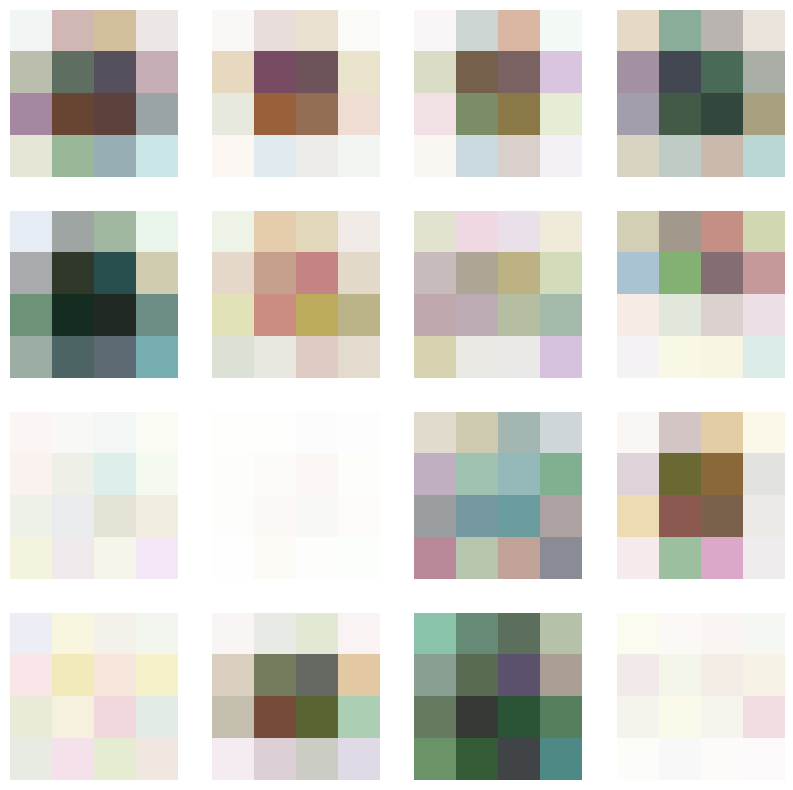

Step: 295
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0970218181610107
Generator loss: 2.712019443511963


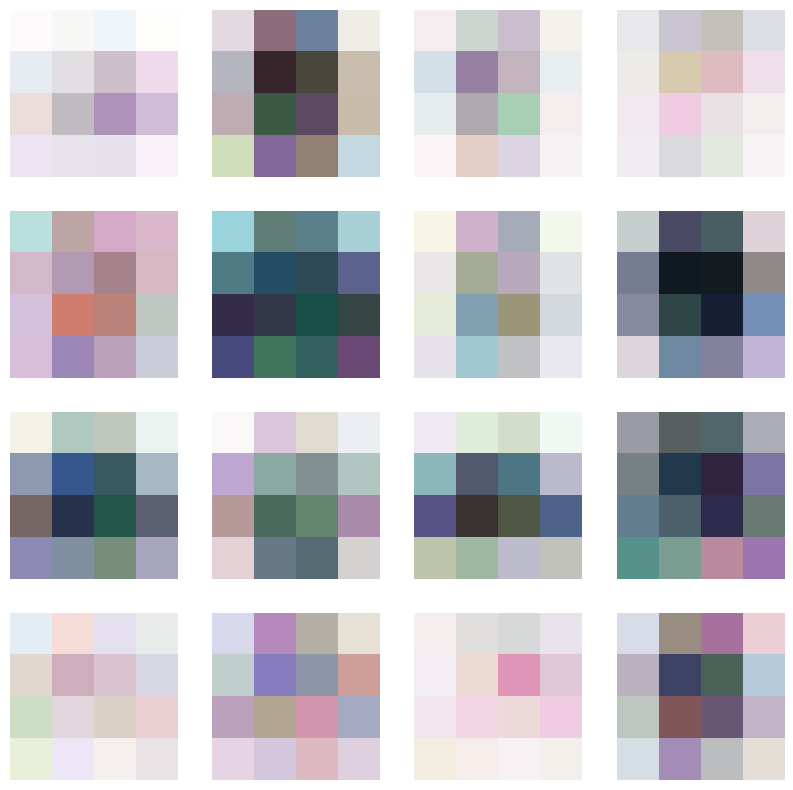

Step: 296
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.094168782234192
Generator loss: 2.7053580284118652


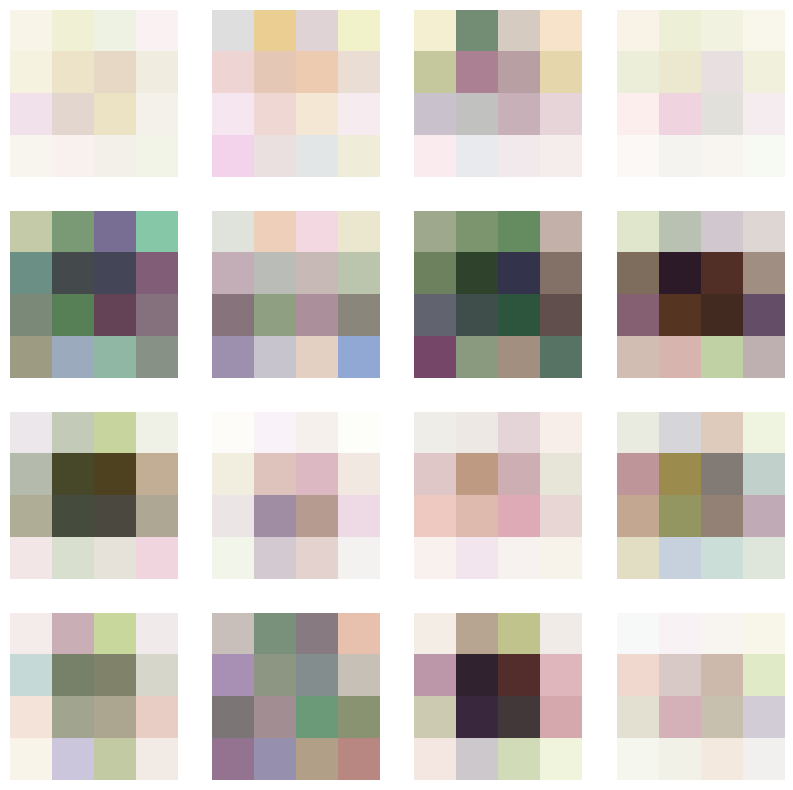

Step: 297
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.091338872909546
Generator loss: 2.6981234550476074


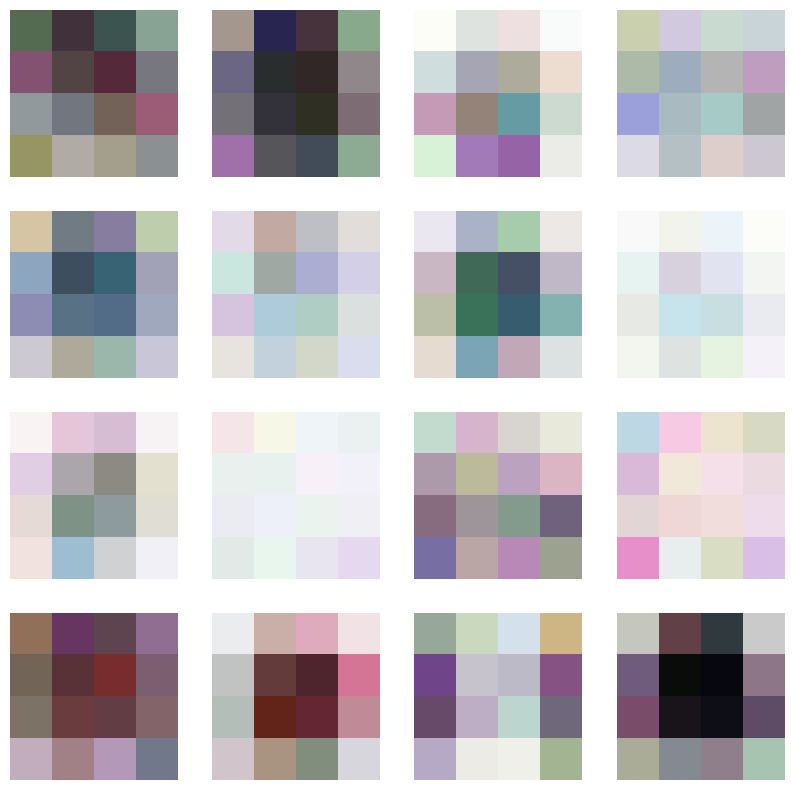

Step: 298
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0885043144226074
Generator loss: 2.6903529167175293


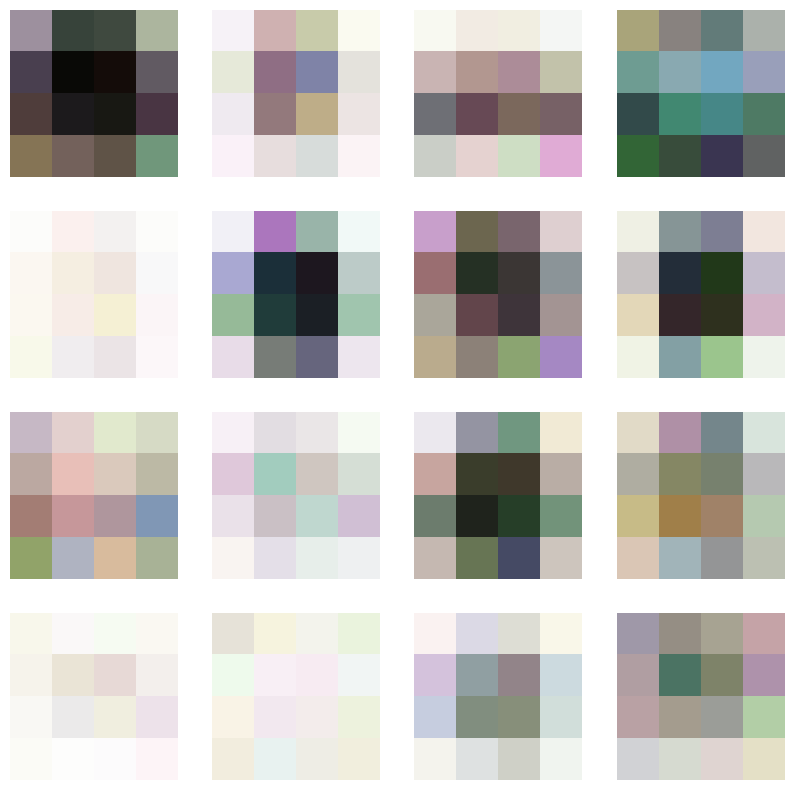

Step: 299
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0855892896652222
Generator loss: 2.6815381050109863


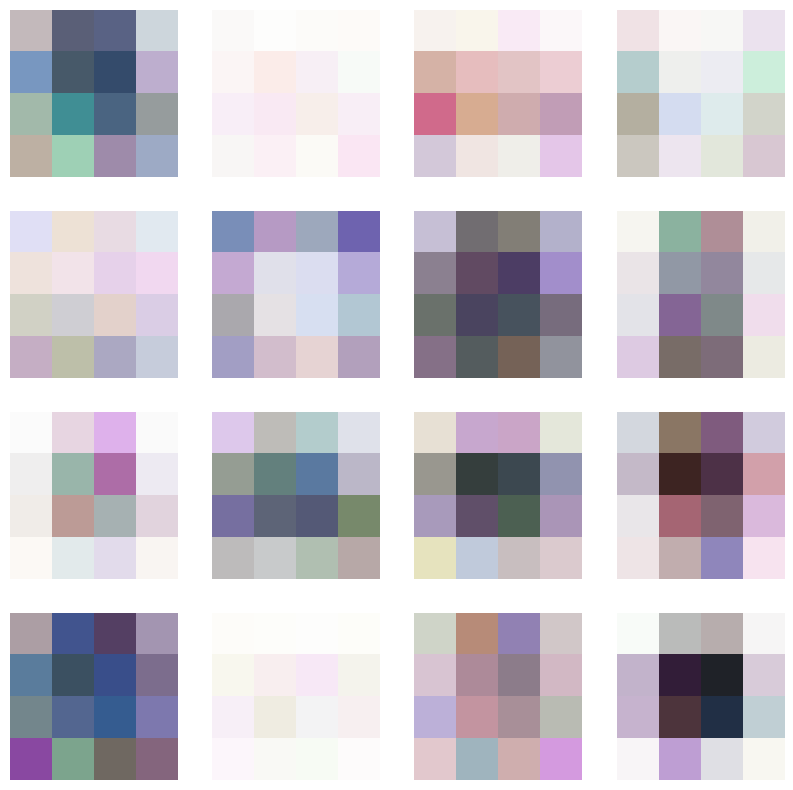

Step: 300
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0829272270202637
Generator loss: 2.6720707416534424


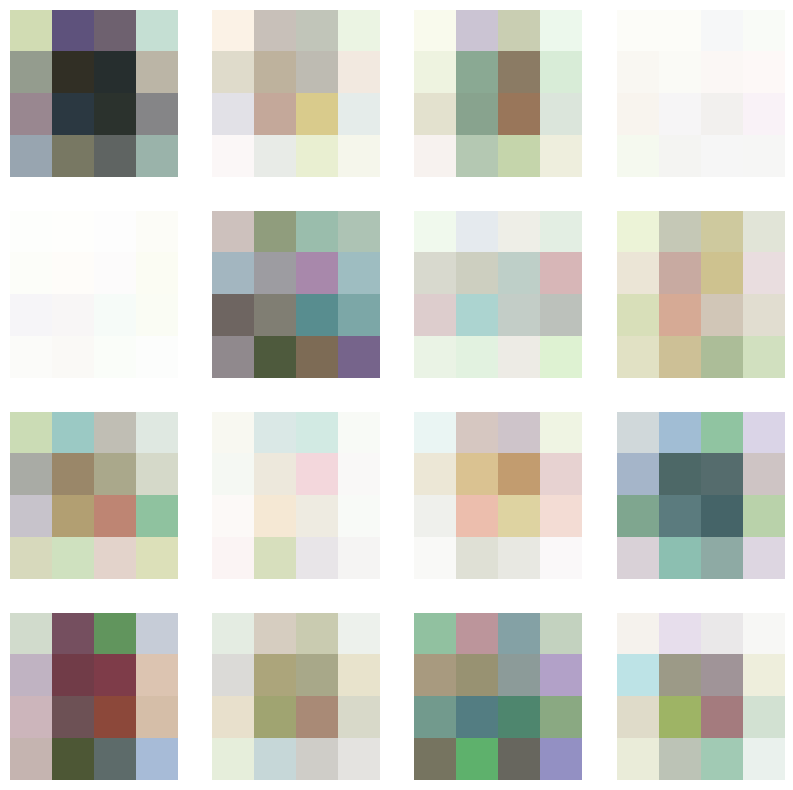

Step: 301
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0794514417648315
Generator loss: 2.6640267372131348


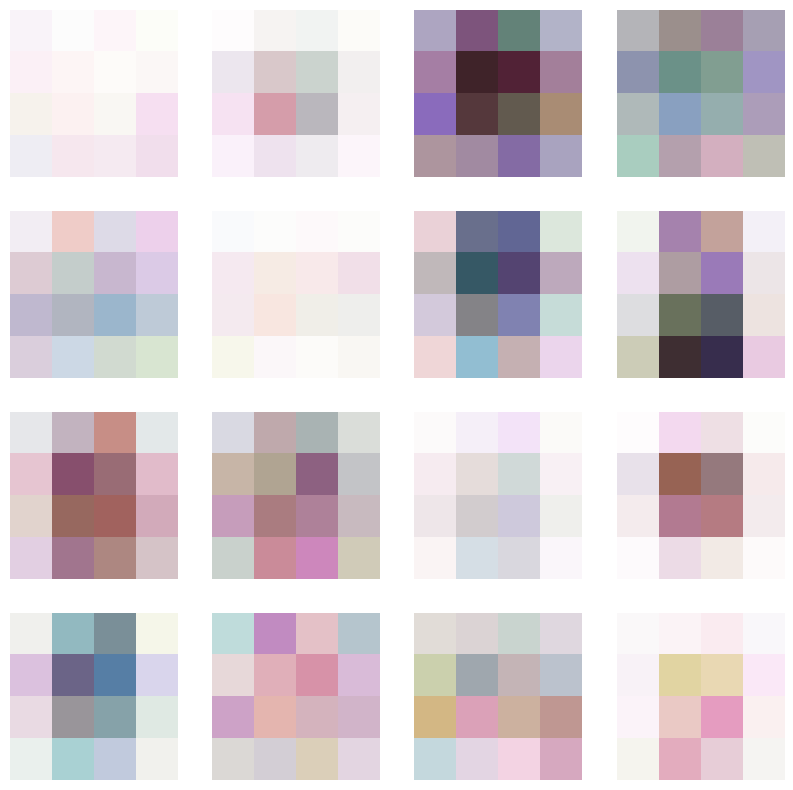

Step: 302
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0767489671707153
Generator loss: 2.6577630043029785


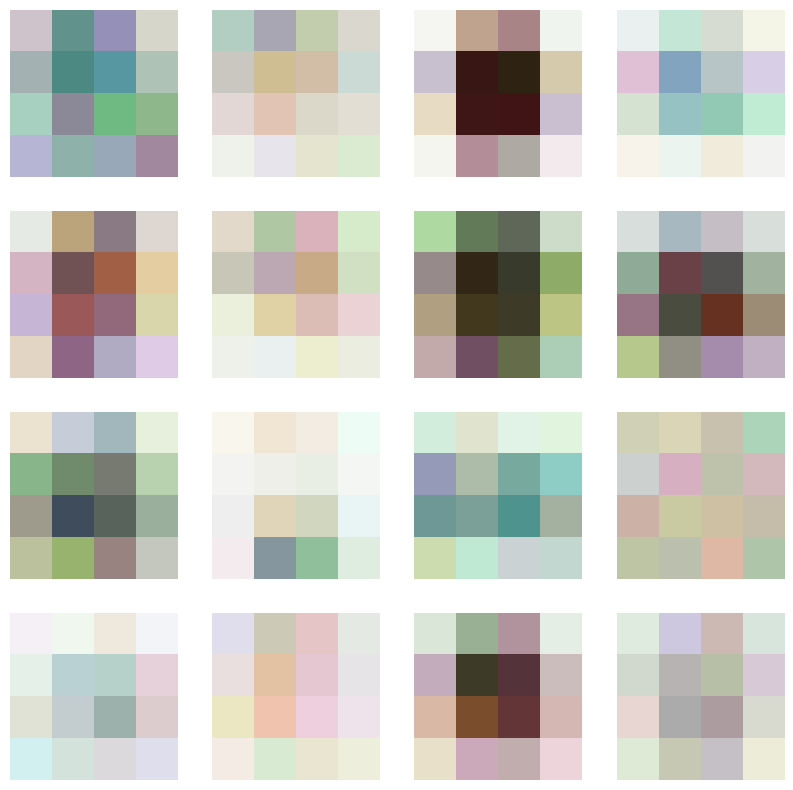

Step: 303
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0737662315368652
Generator loss: 2.64963436126709


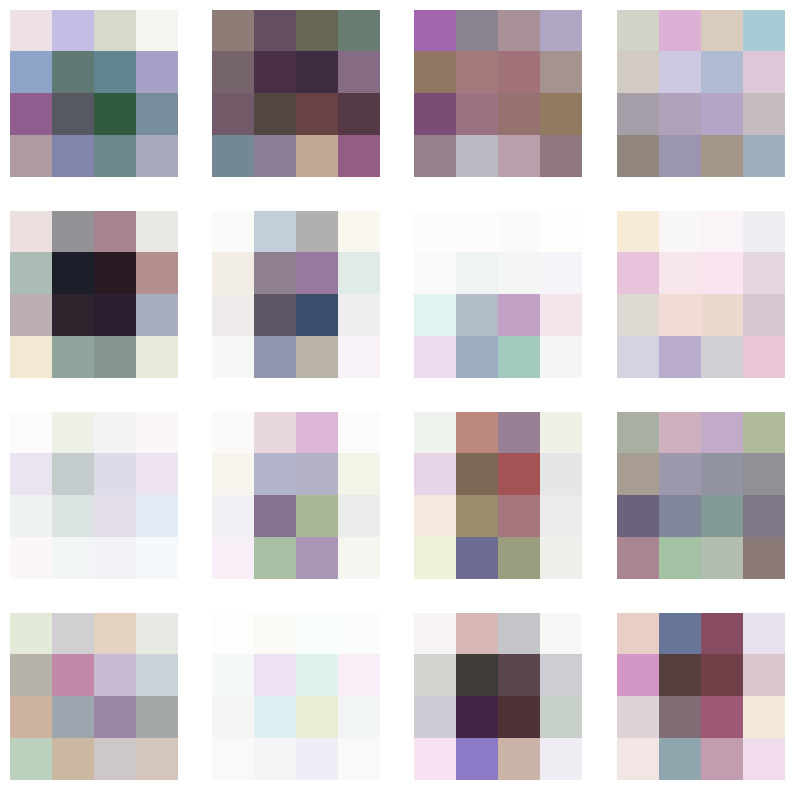

Step: 304
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0709222555160522
Generator loss: 2.6418635845184326


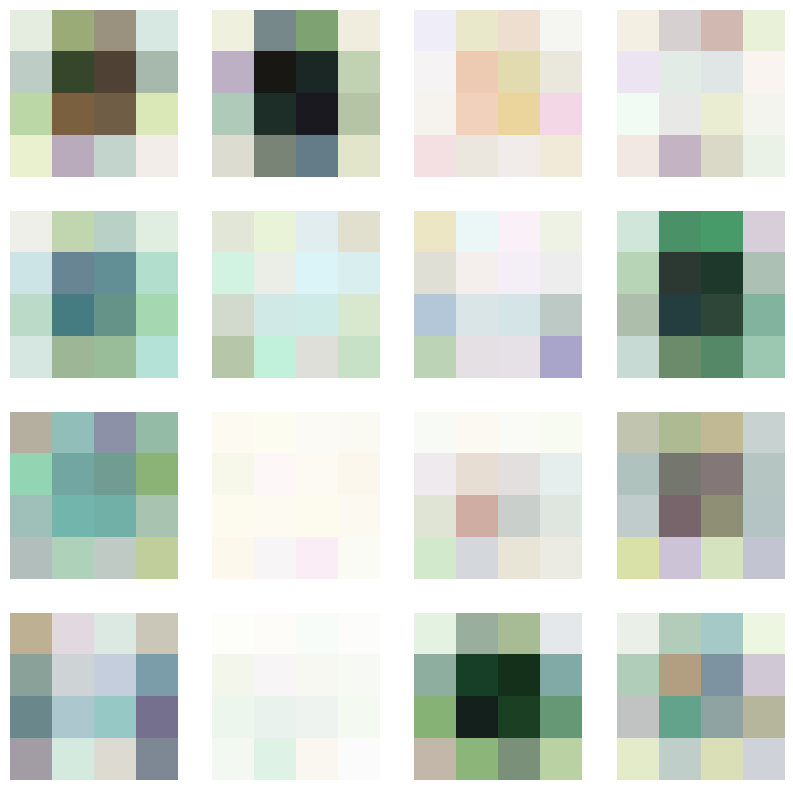

Step: 305
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0683064460754395
Generator loss: 2.6347615718841553


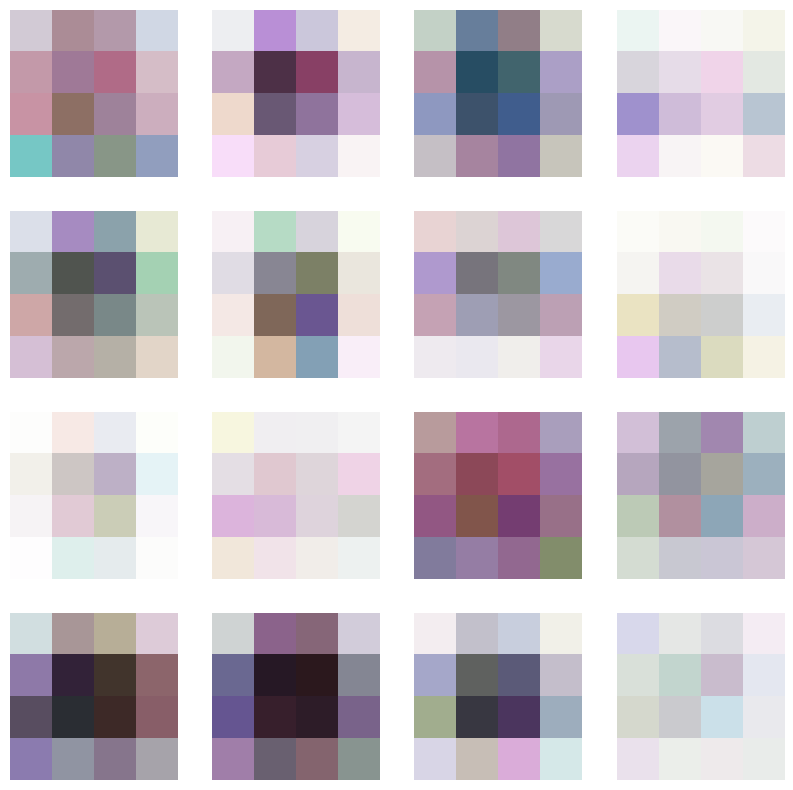

Step: 306
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.065645456314087
Generator loss: 2.62687611579895


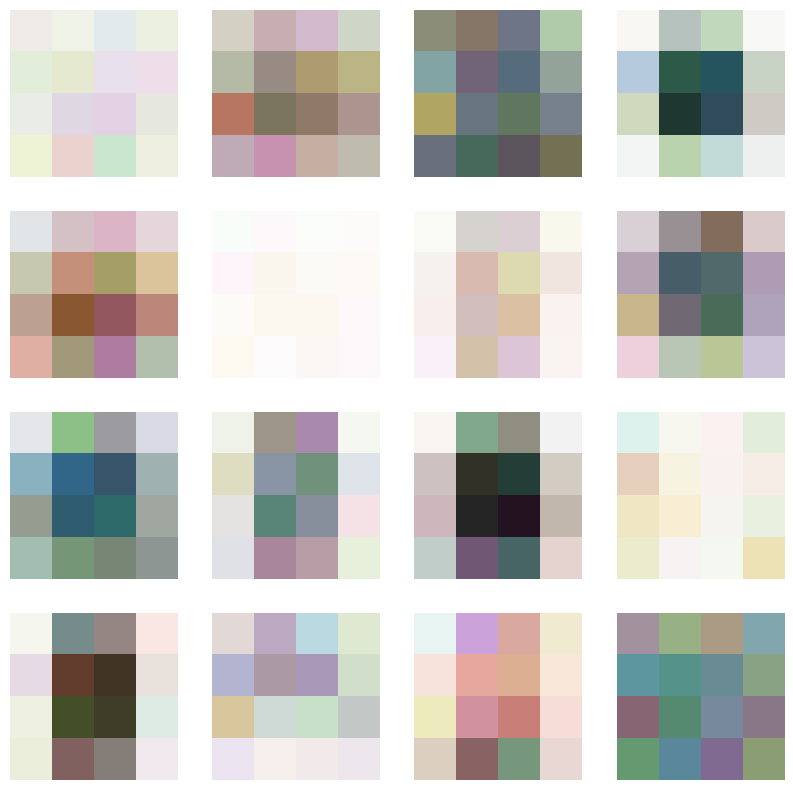

Step: 307
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.062973976135254
Generator loss: 2.618882179260254


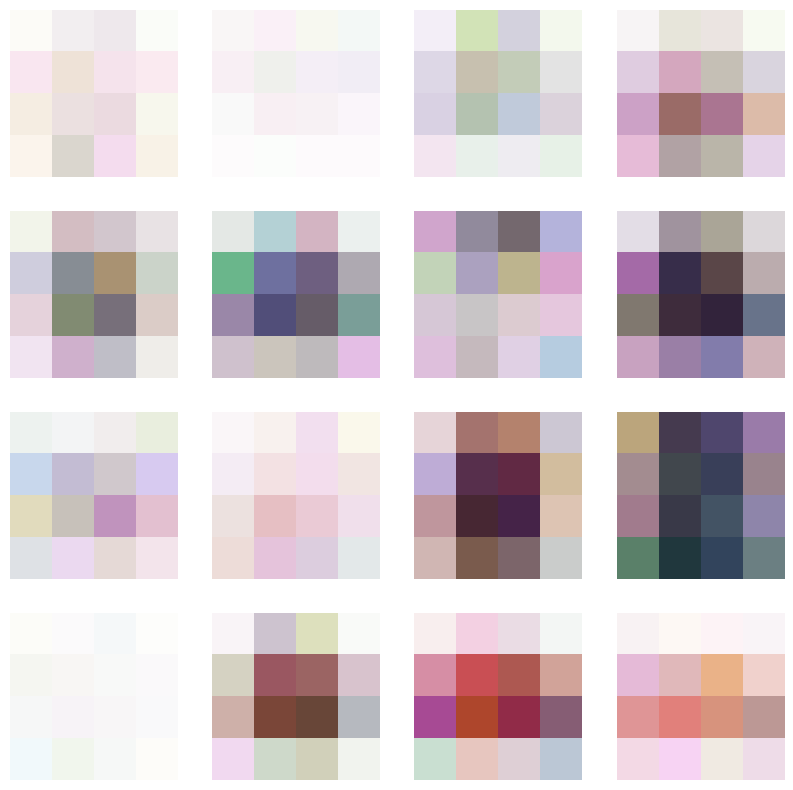

Step: 308
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0603139400482178
Generator loss: 2.6120102405548096


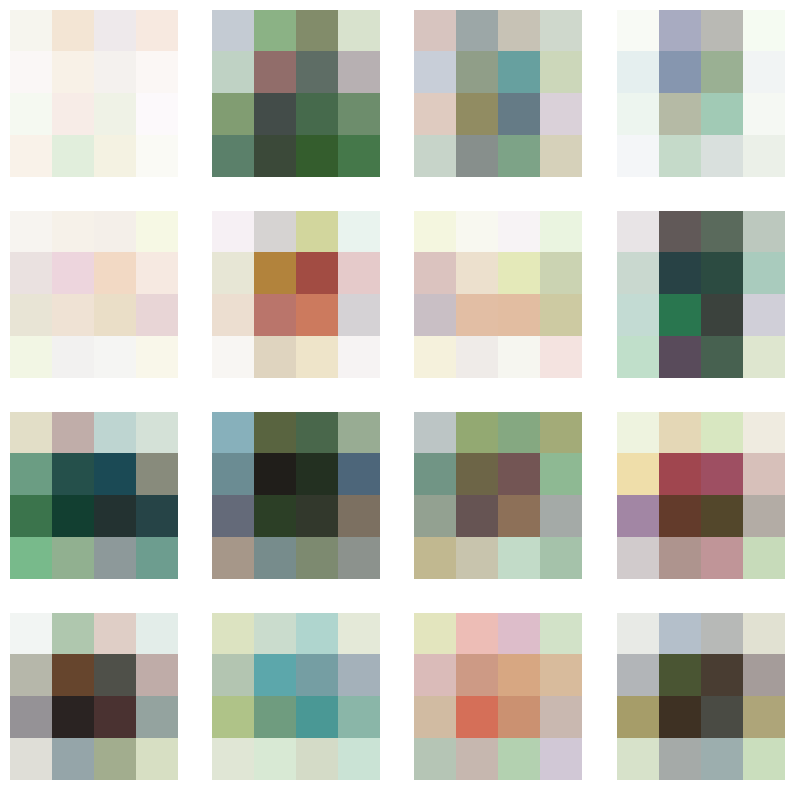

Step: 309
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0575494766235352
Generator loss: 2.6036317348480225


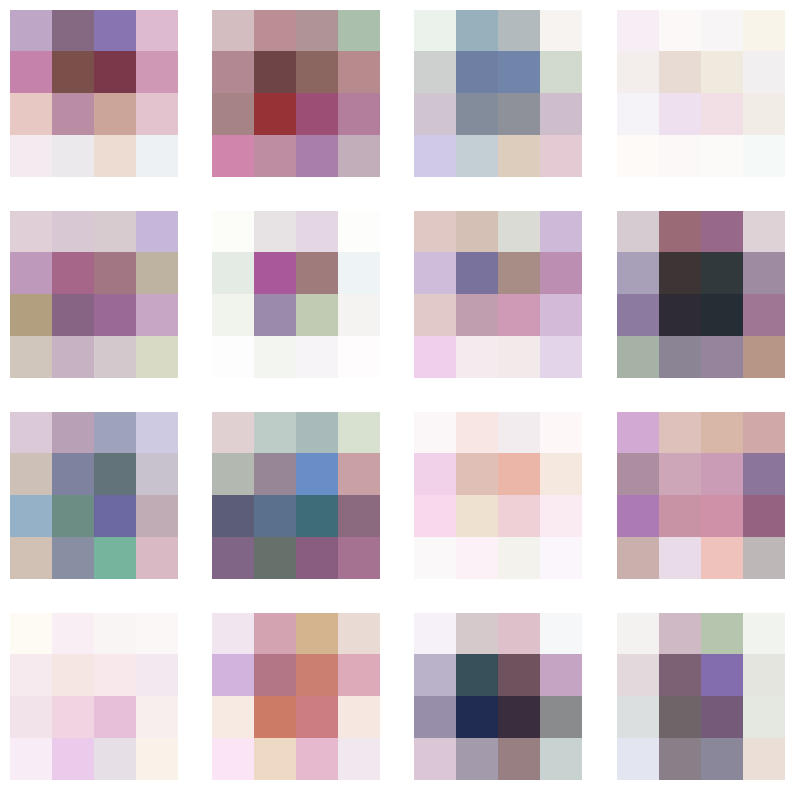

Step: 310
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0549962520599365
Generator loss: 2.596358060836792


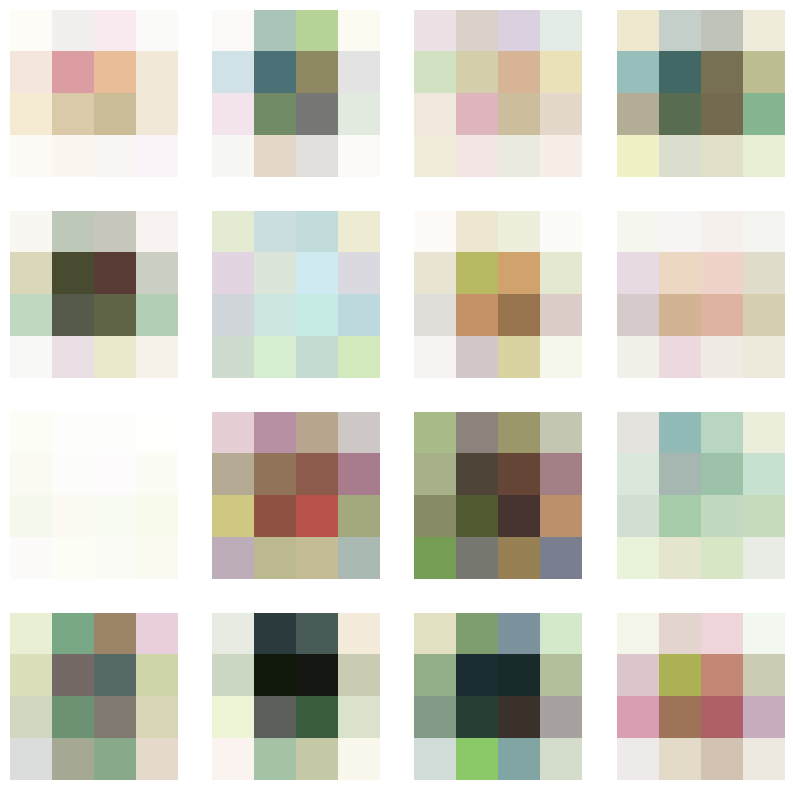

Step: 311
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0524250268936157
Generator loss: 2.589383125305176


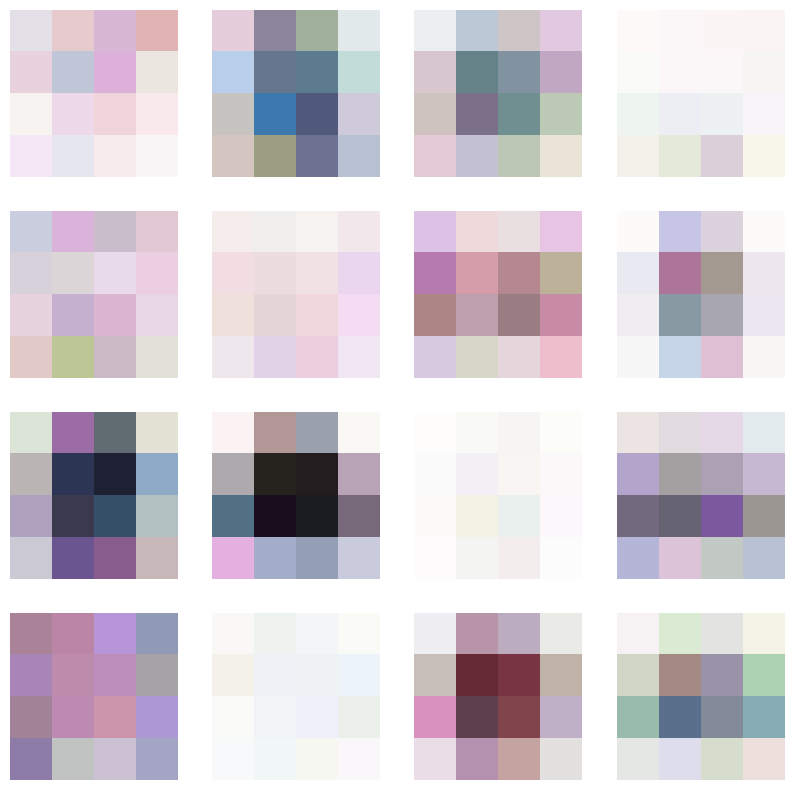

Step: 312
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0499601364135742
Generator loss: 2.5814123153686523


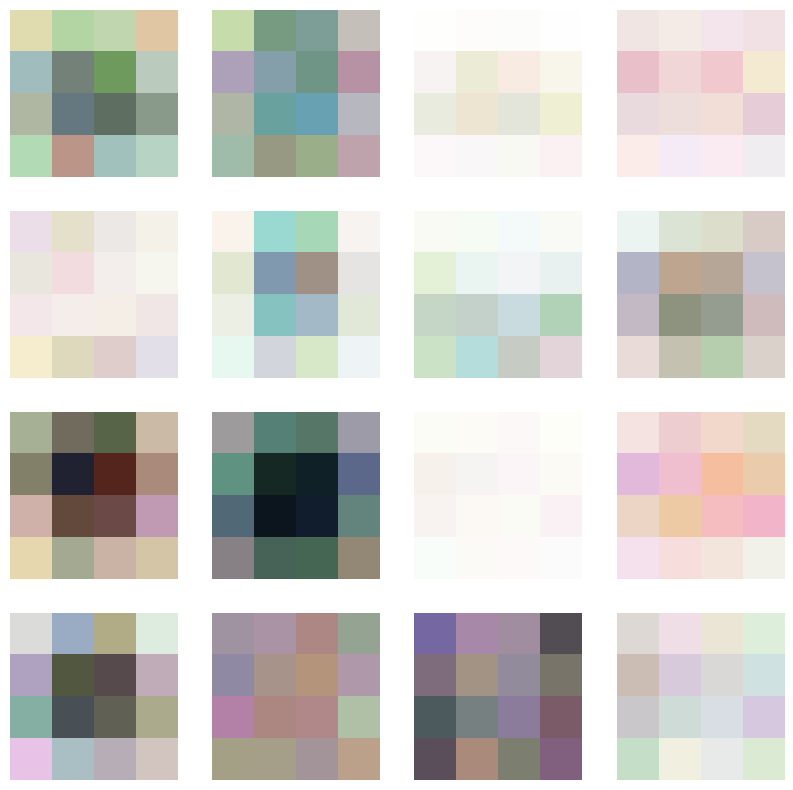

Step: 313
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0473544597625732
Generator loss: 2.5734124183654785


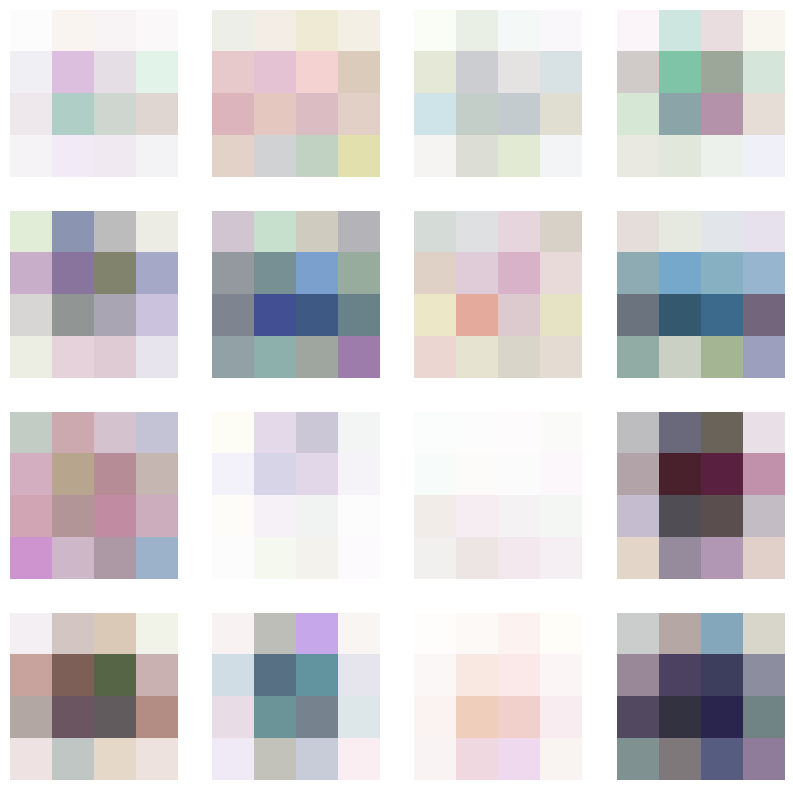

Step: 314
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0447767972946167
Generator loss: 2.566706418991089


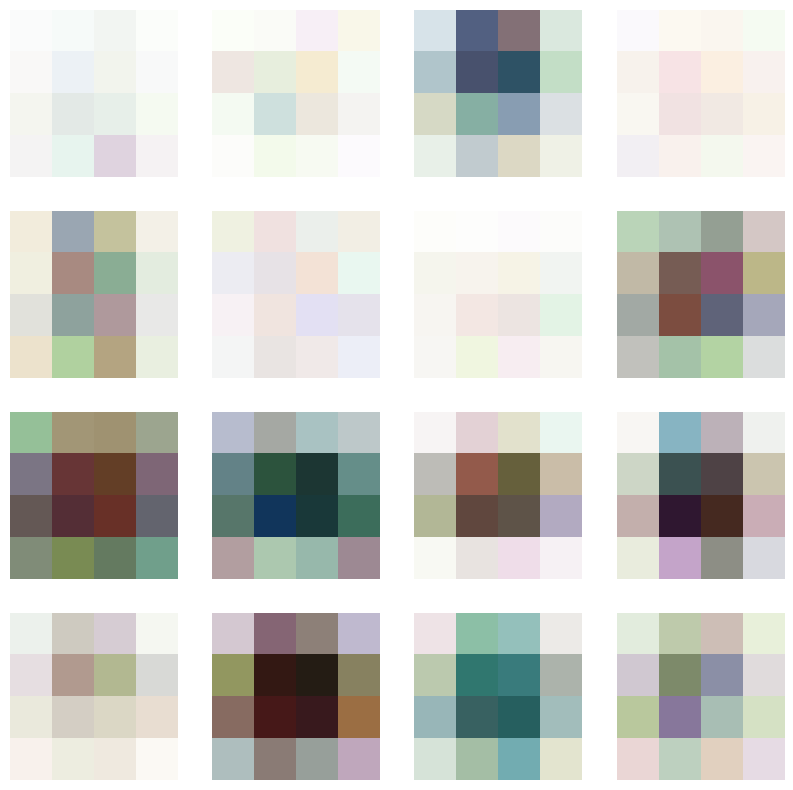

Step: 315
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0422515869140625
Generator loss: 2.5597527027130127


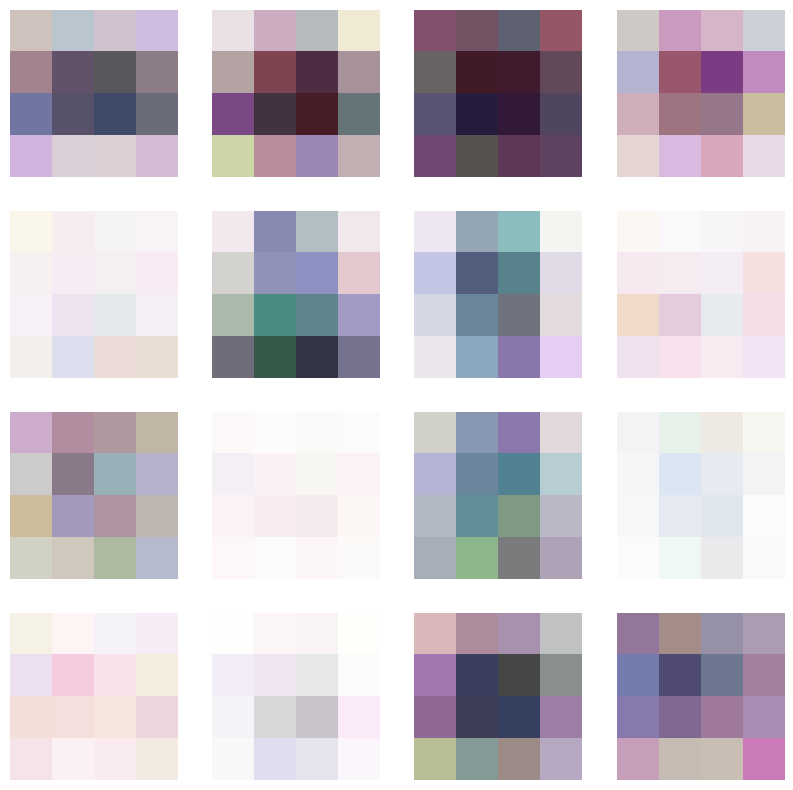

Step: 316
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0394225120544434
Generator loss: 2.5525717735290527


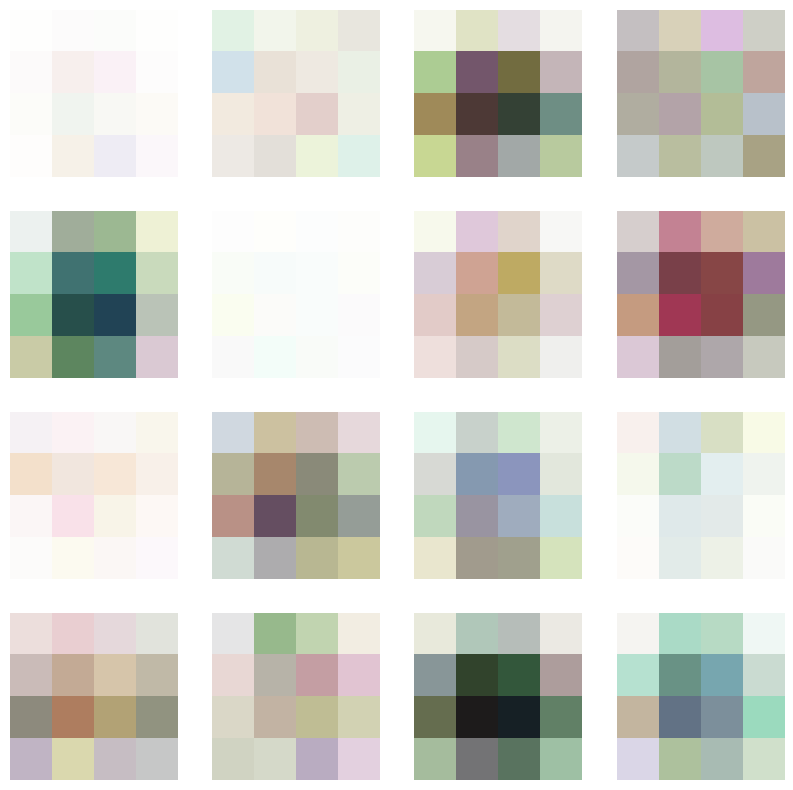

Step: 317
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0367990732192993
Generator loss: 2.543729782104492


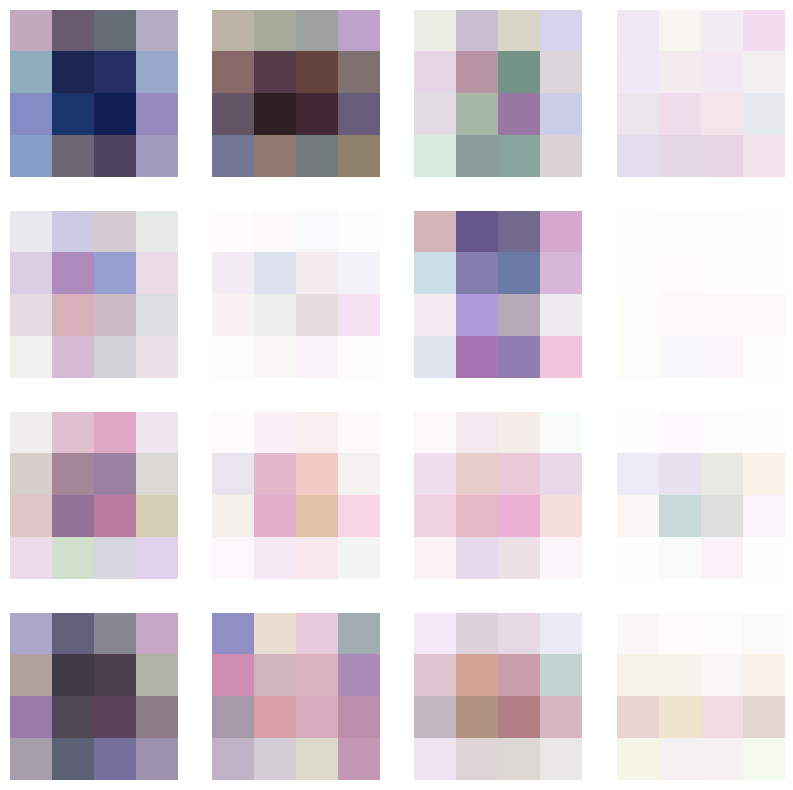

Step: 318
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0339179039001465
Generator loss: 2.5356924533843994


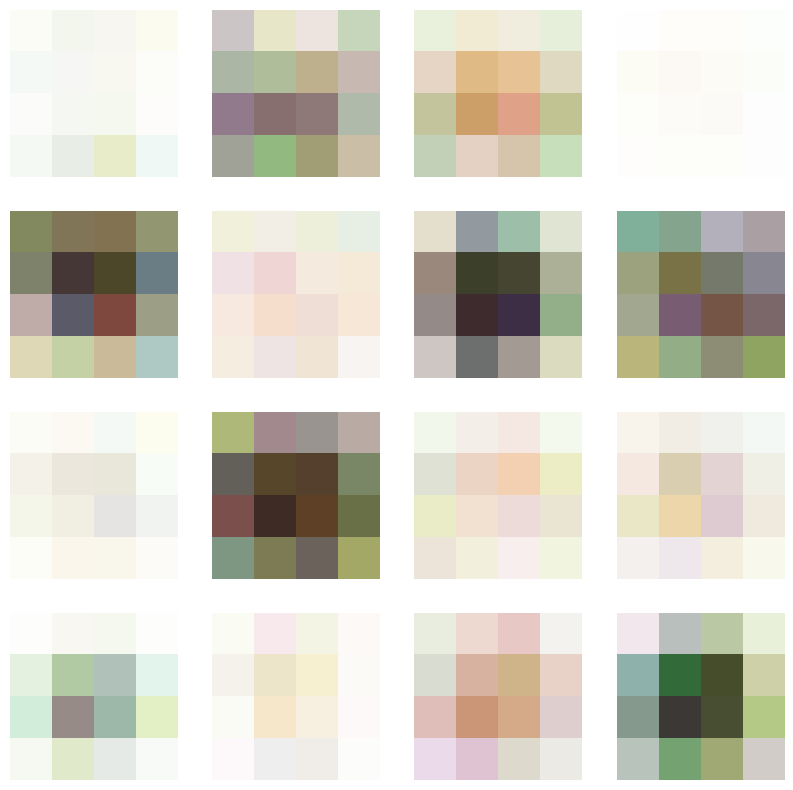

Step: 319
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0312203168869019
Generator loss: 2.529139995574951


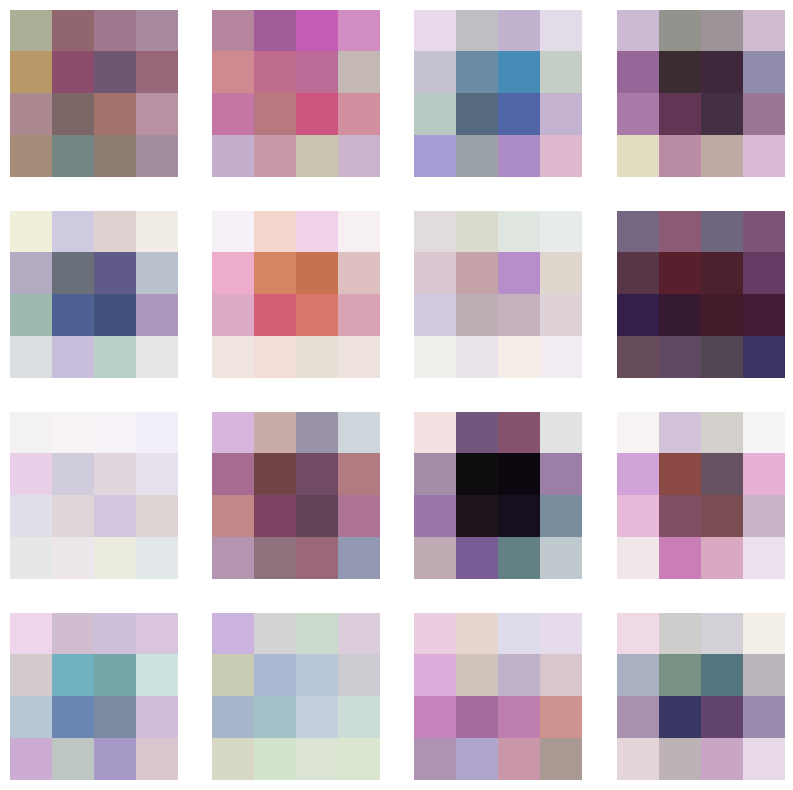

Step: 320
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0289350748062134
Generator loss: 2.523333787918091


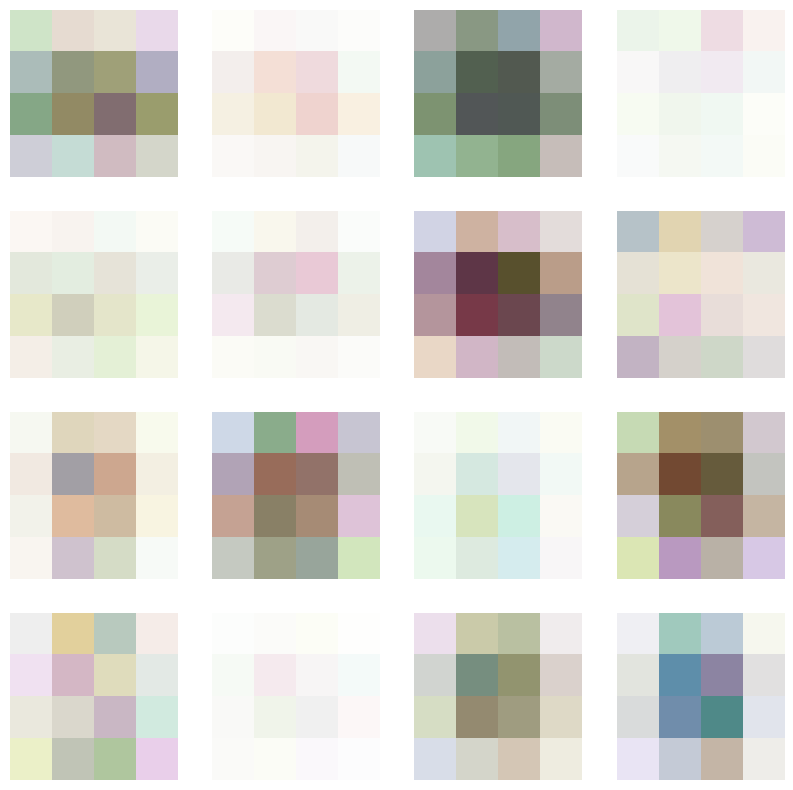

Step: 321
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0263005495071411
Generator loss: 2.5158939361572266


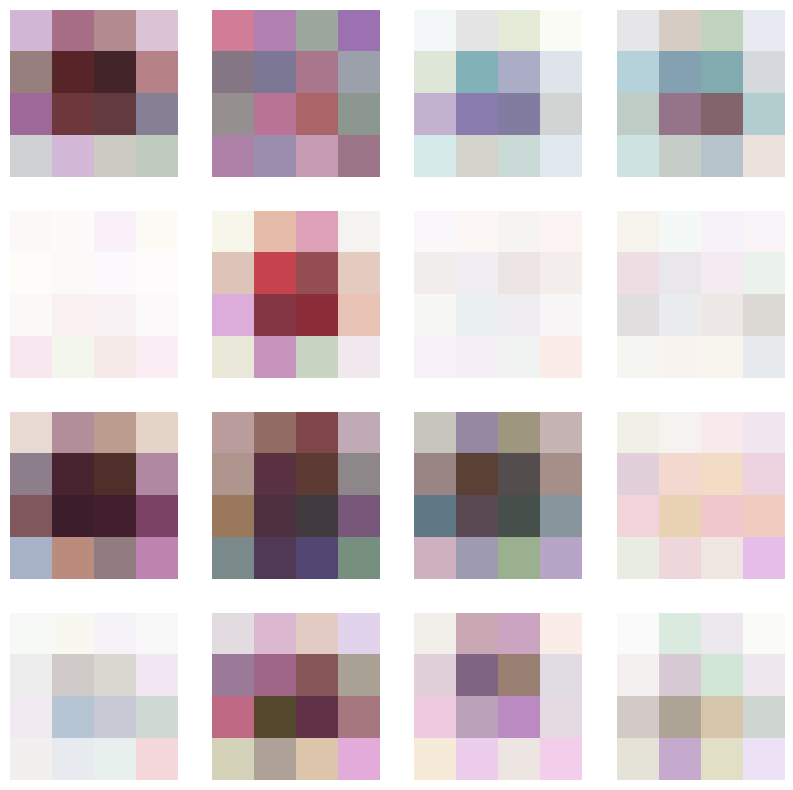

Step: 322
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0237821340560913
Generator loss: 2.5093307495117188


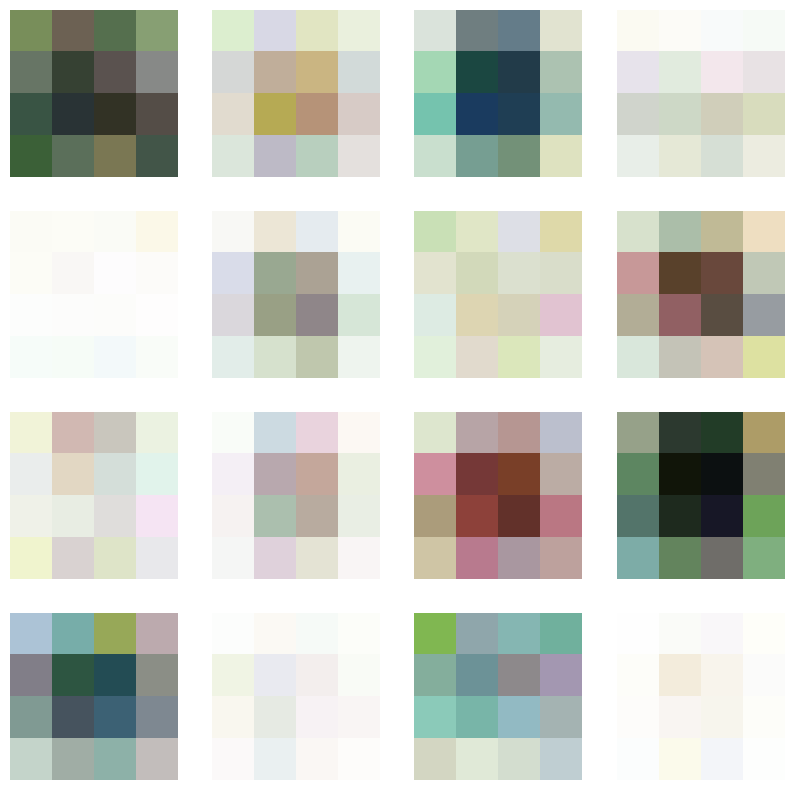

Step: 323
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0211063623428345
Generator loss: 2.5011773109436035


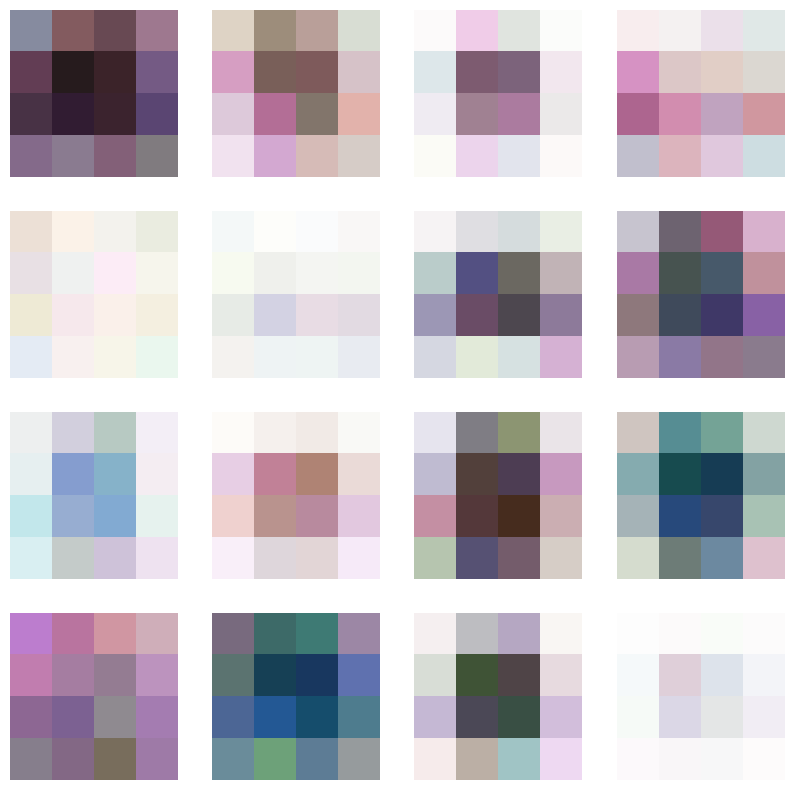

Step: 324
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.018728256225586
Generator loss: 2.493255376815796


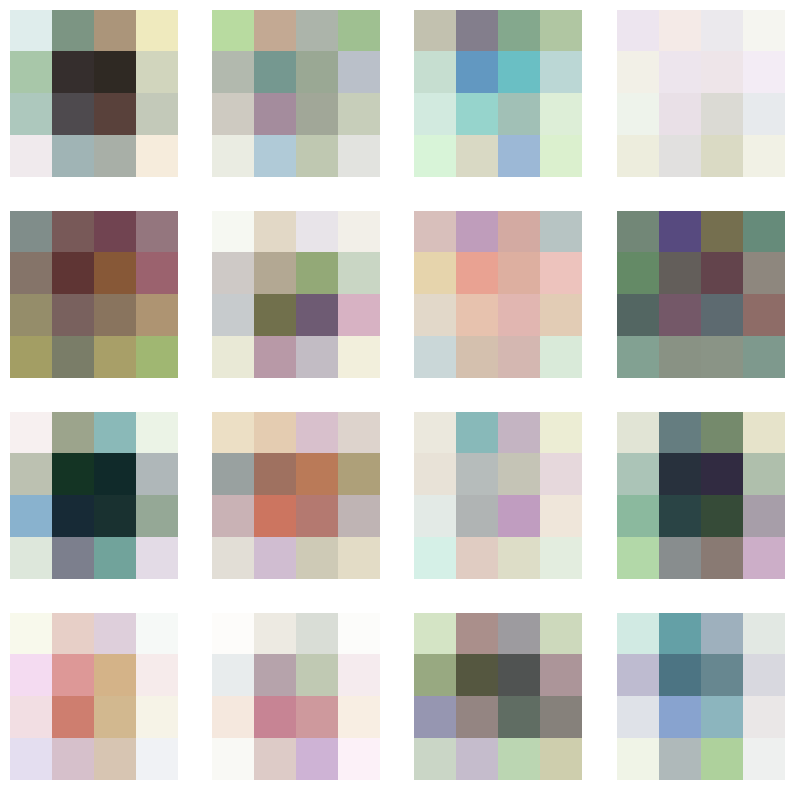

Step: 325
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0164895057678223
Generator loss: 2.4855995178222656


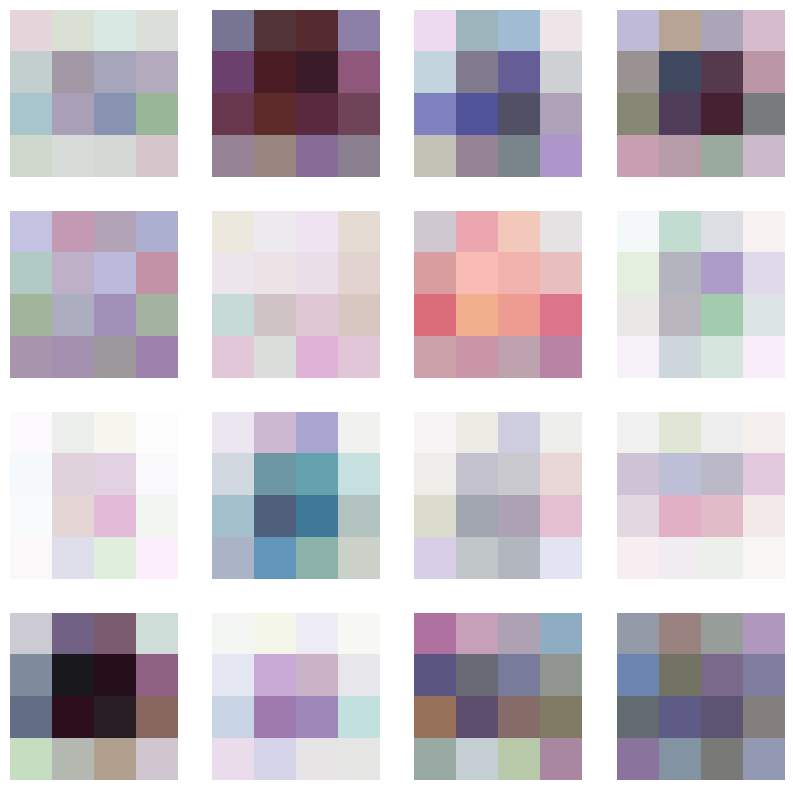

Step: 326
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.013871431350708
Generator loss: 2.4786438941955566


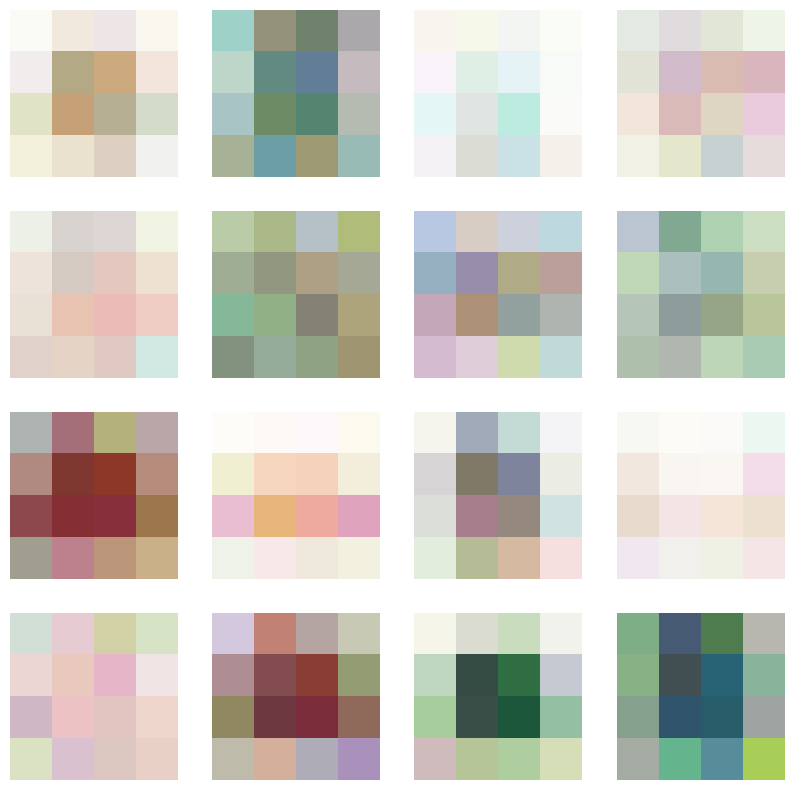

Step: 327
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0114095211029053
Generator loss: 2.471198081970215


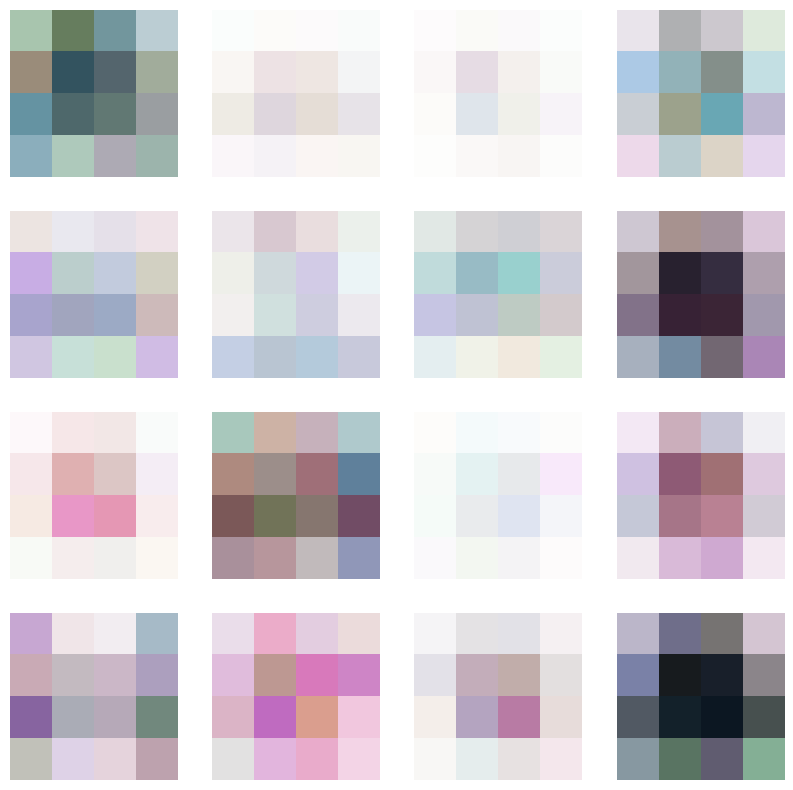

Step: 328
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0090328454971313
Generator loss: 2.46474552154541


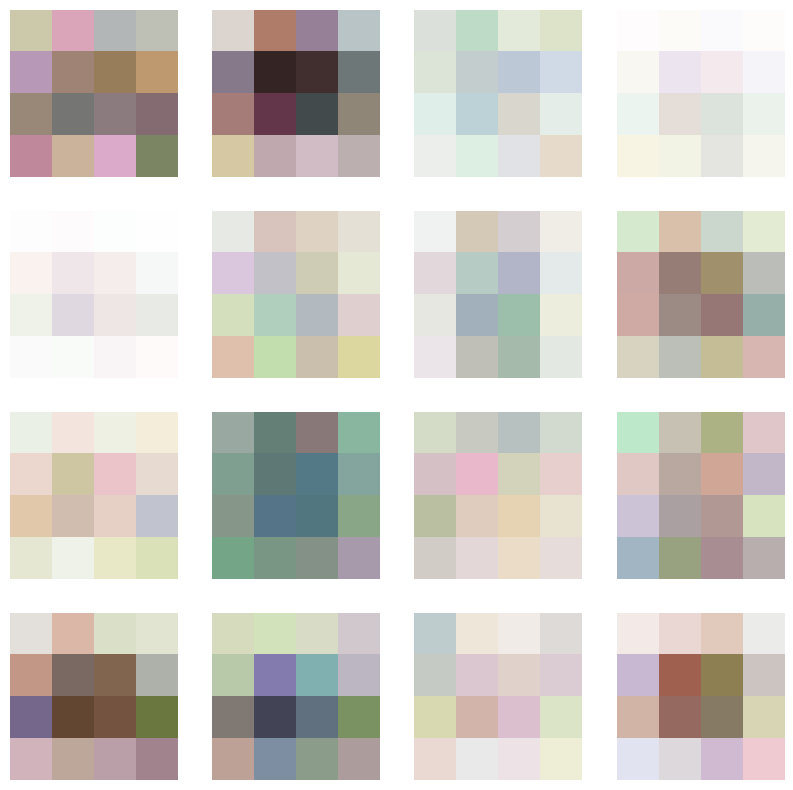

Step: 329
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0065878629684448
Generator loss: 2.4585938453674316


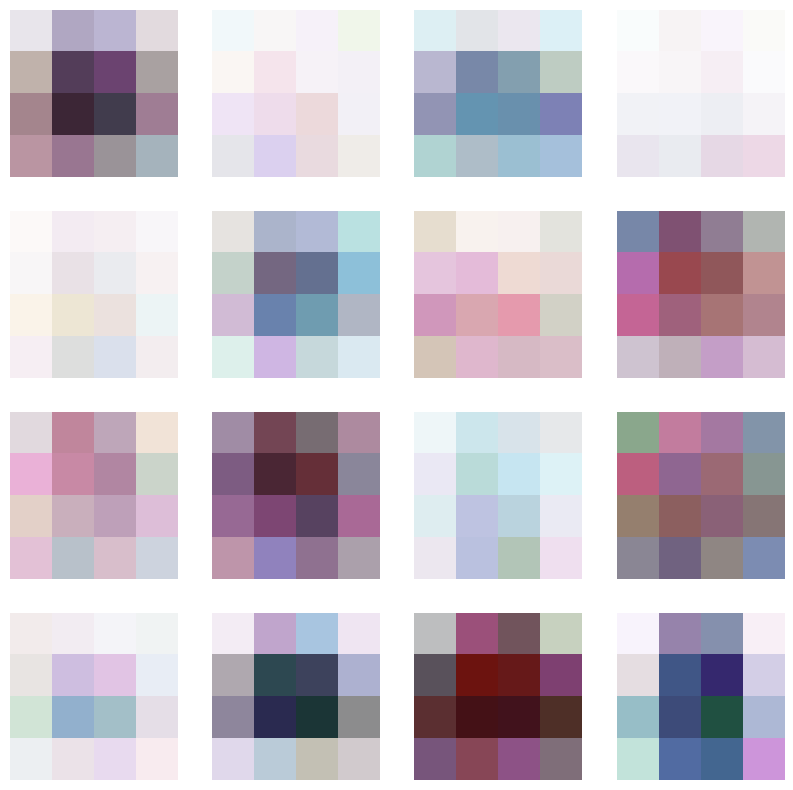

Step: 330
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0043361186981201
Generator loss: 2.4522314071655273


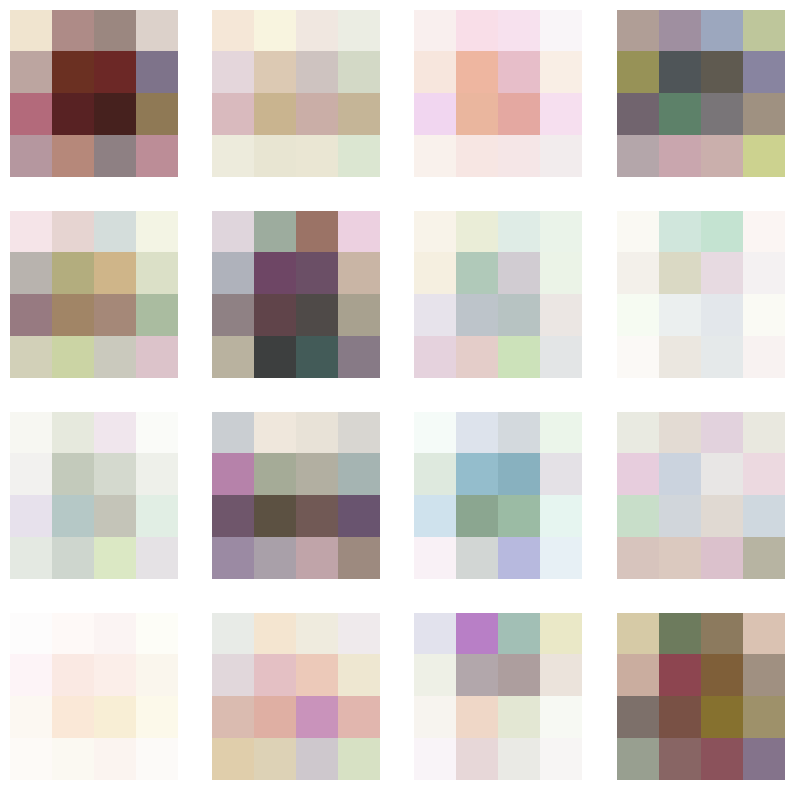

Step: 331
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -1.0016870498657227
Generator loss: 2.4451491832733154


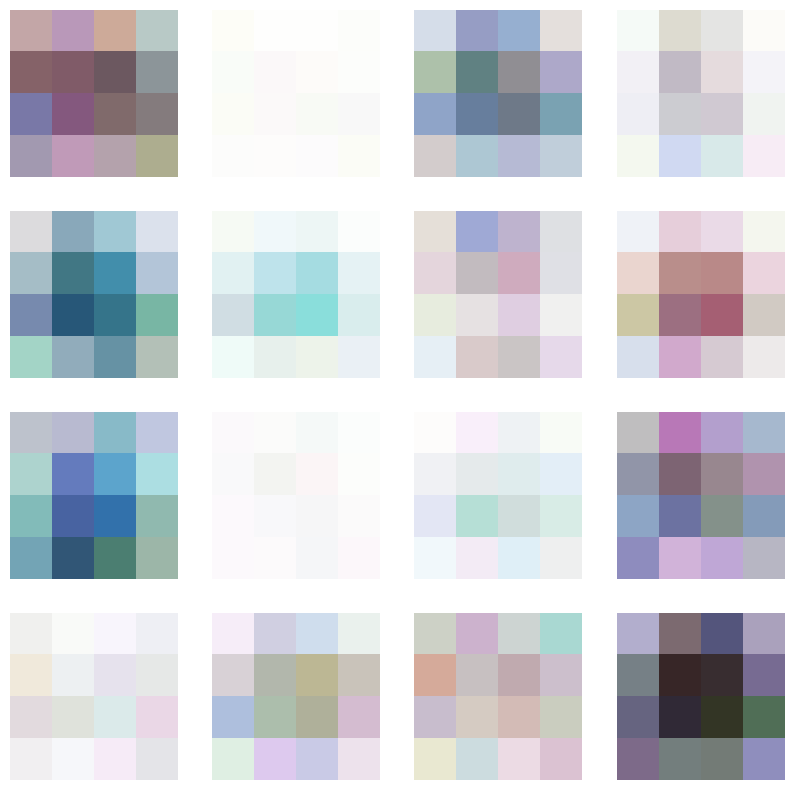

Step: 332
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9992141723632812
Generator loss: 2.437957763671875


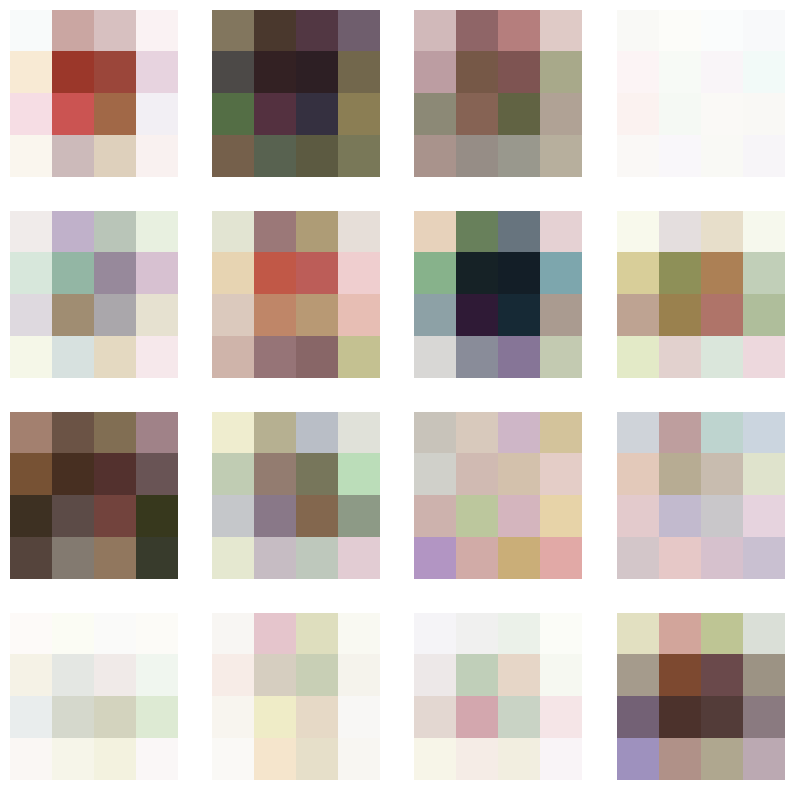

Step: 333
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.996615469455719
Generator loss: 2.4315056800842285


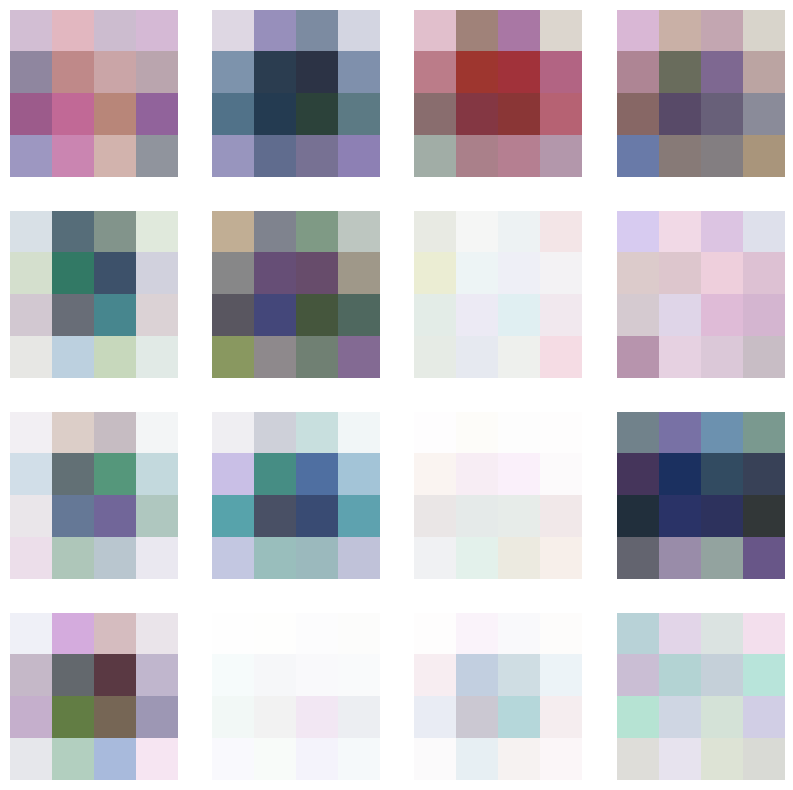

Step: 334
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9942188858985901
Generator loss: 2.424255847930908


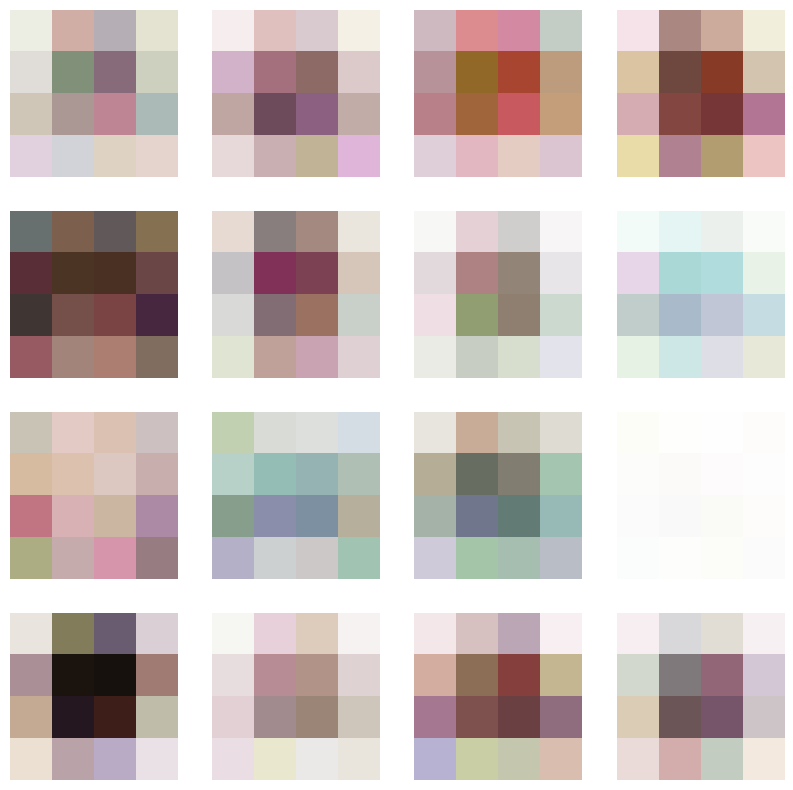

Step: 335
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9918405413627625
Generator loss: 2.4185781478881836


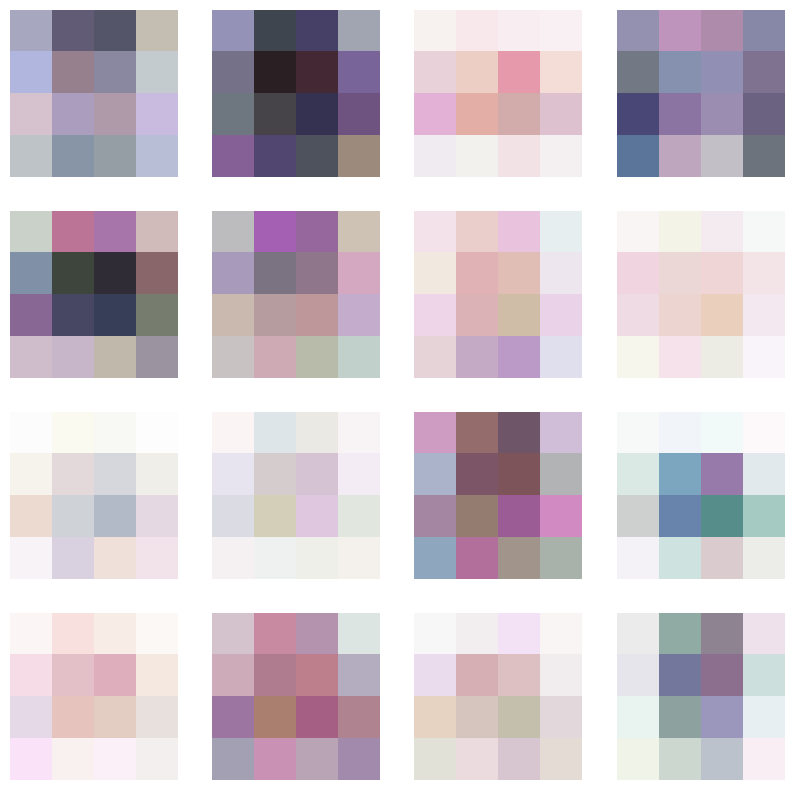

Step: 336
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9892314672470093
Generator loss: 2.411958694458008


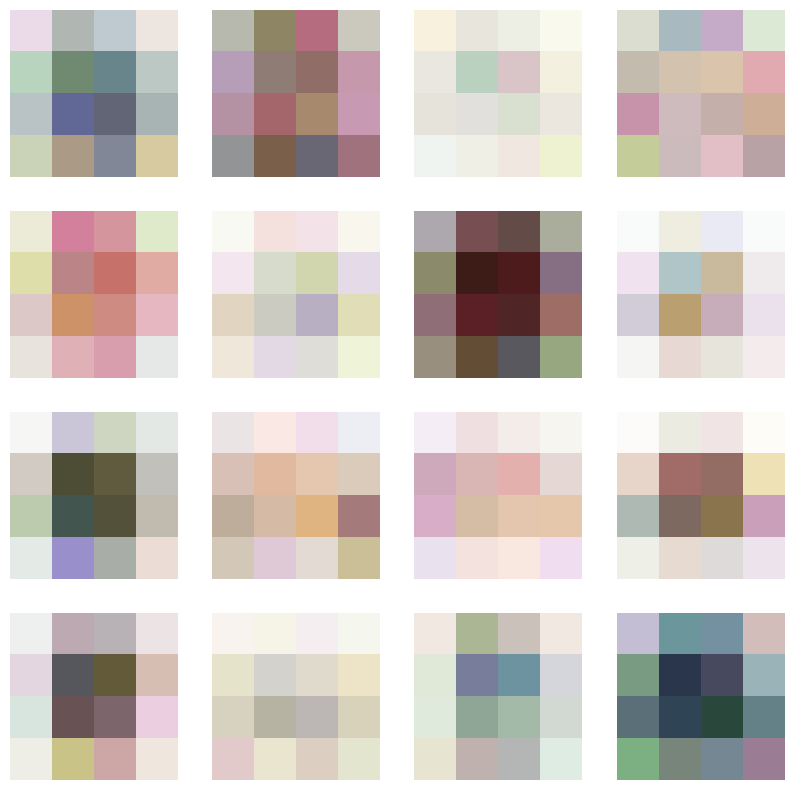

Step: 337
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9867822527885437
Generator loss: 2.404942512512207


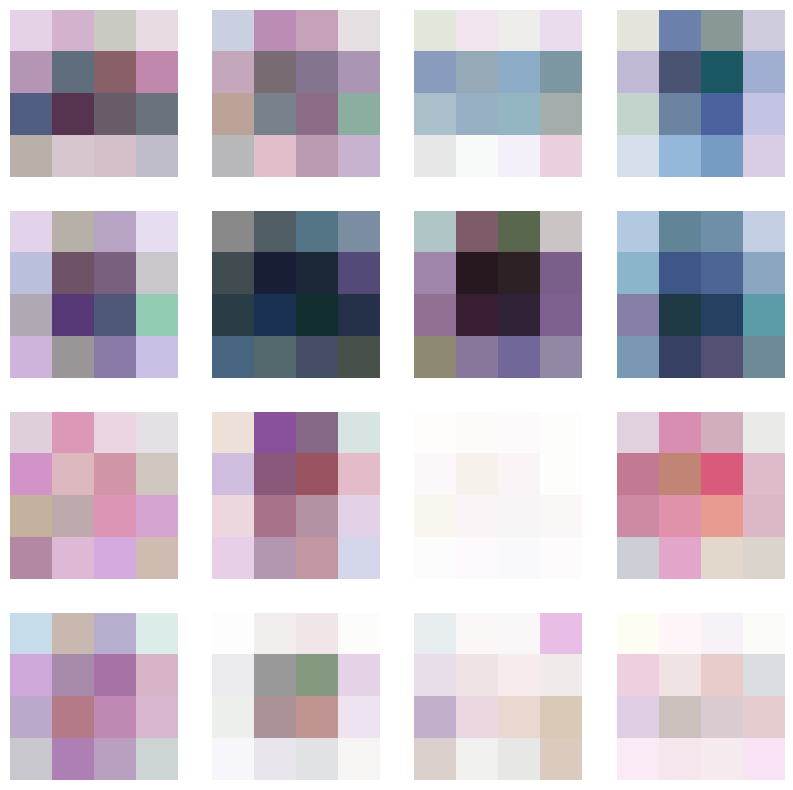

Step: 338
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9845384955406189
Generator loss: 2.3988733291625977


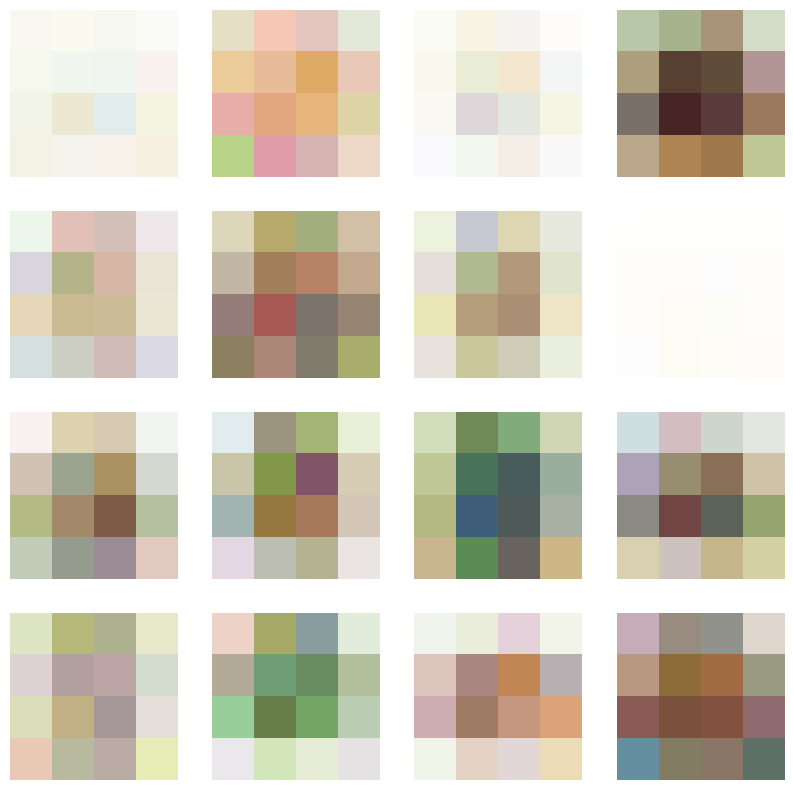

Step: 339
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9825571179389954
Generator loss: 2.3916680812835693


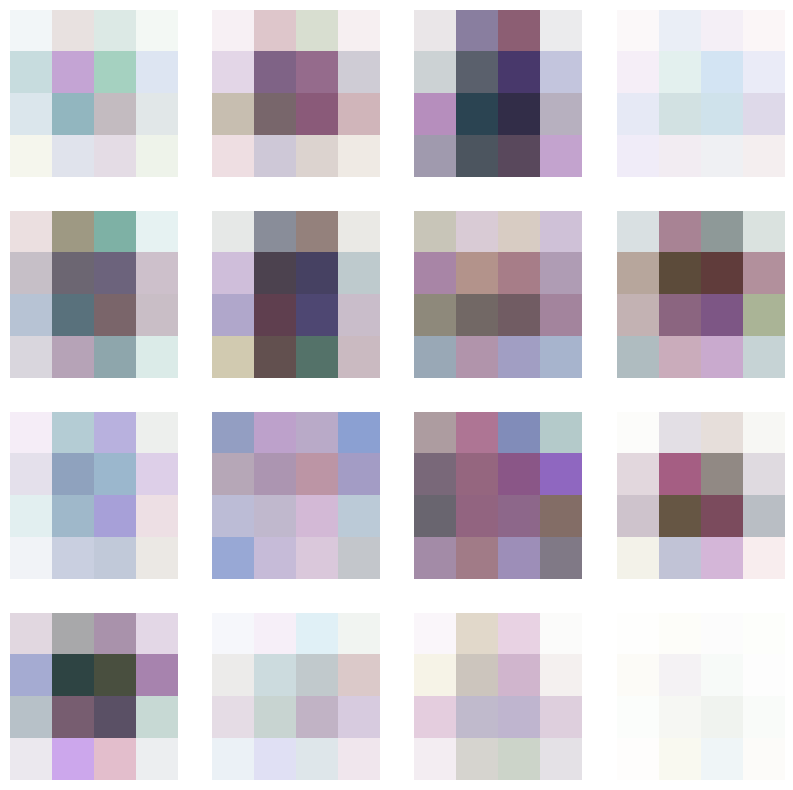

Step: 340
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9805027842521667
Generator loss: 2.3846094608306885


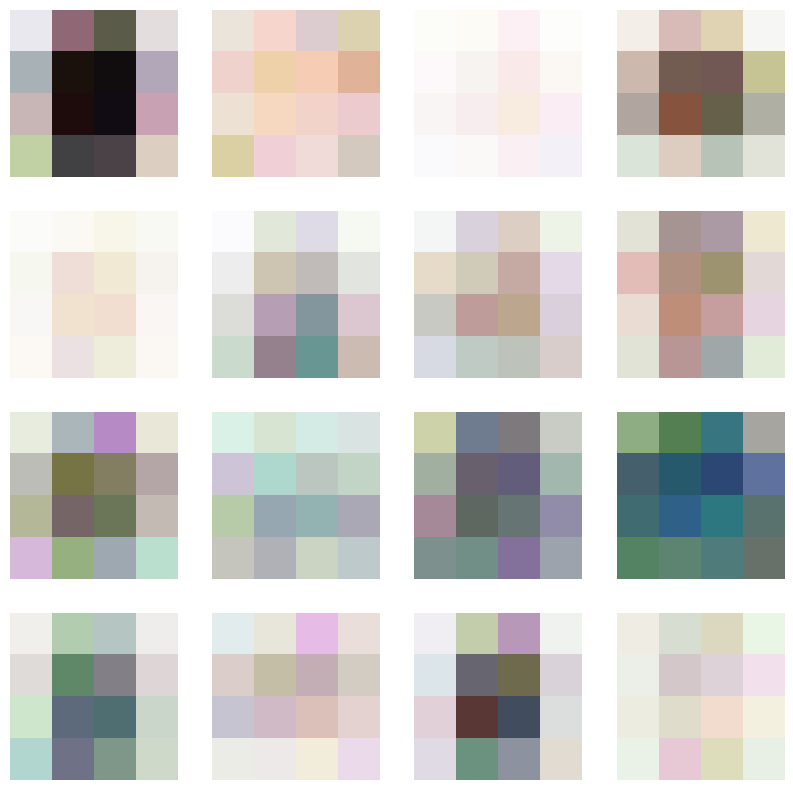

Step: 341
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9782054424285889
Generator loss: 2.379021406173706


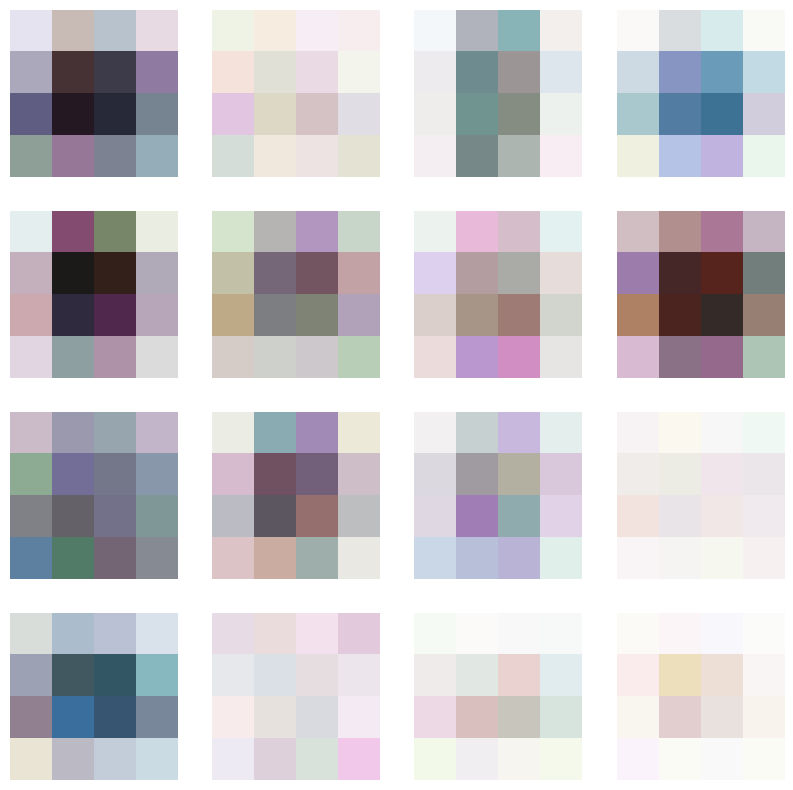

Step: 342
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9758197665214539
Generator loss: 2.3723437786102295


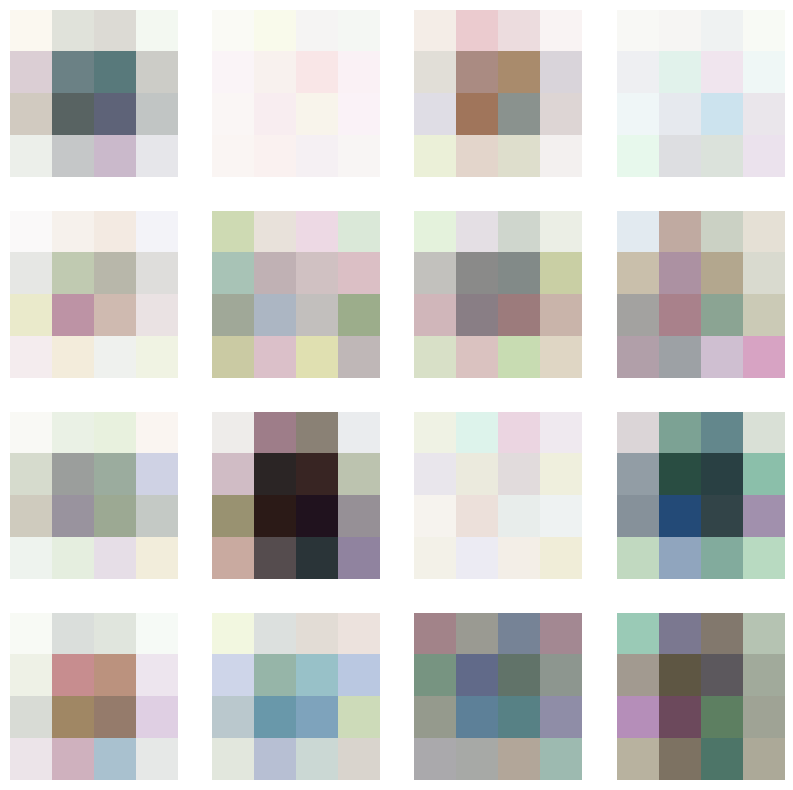

Step: 343
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9736884236335754
Generator loss: 2.365771532058716


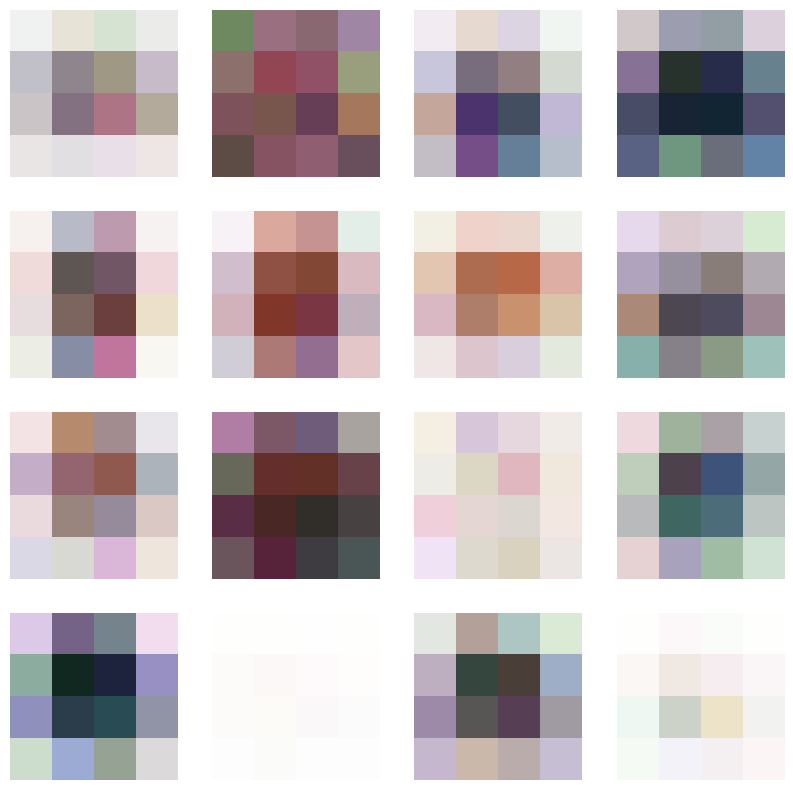

Step: 344
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9713340997695923
Generator loss: 2.3579249382019043


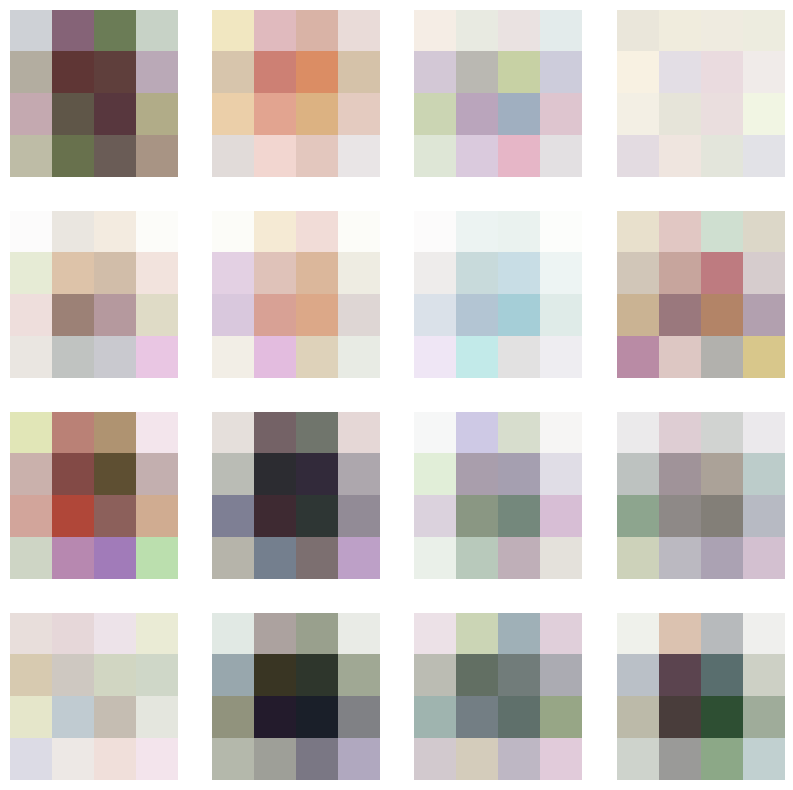

Step: 345
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.96880042552948
Generator loss: 2.3505043983459473


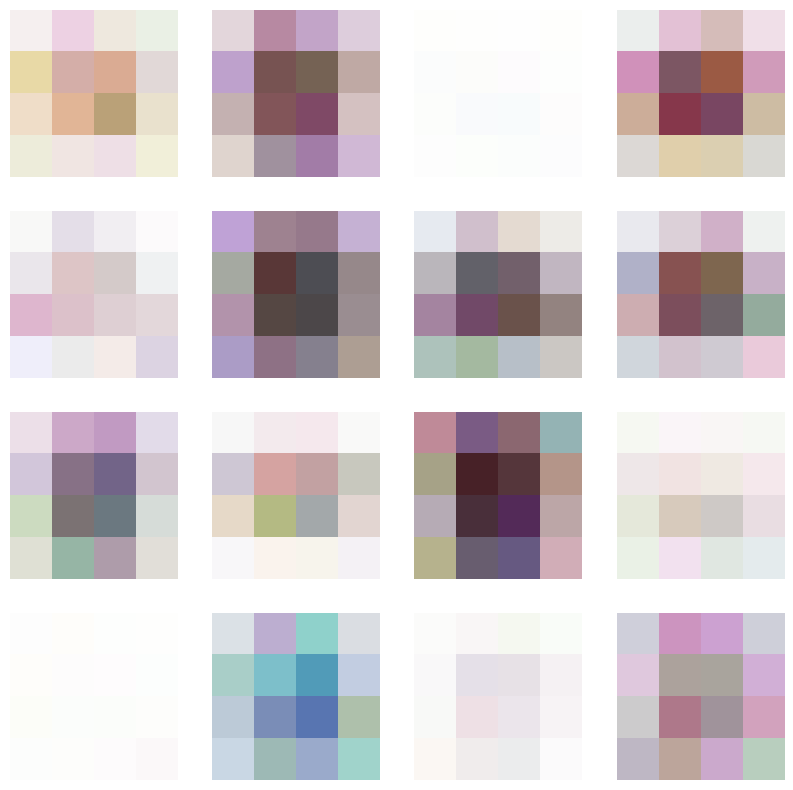

Step: 346
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9663004279136658
Generator loss: 2.345059394836426


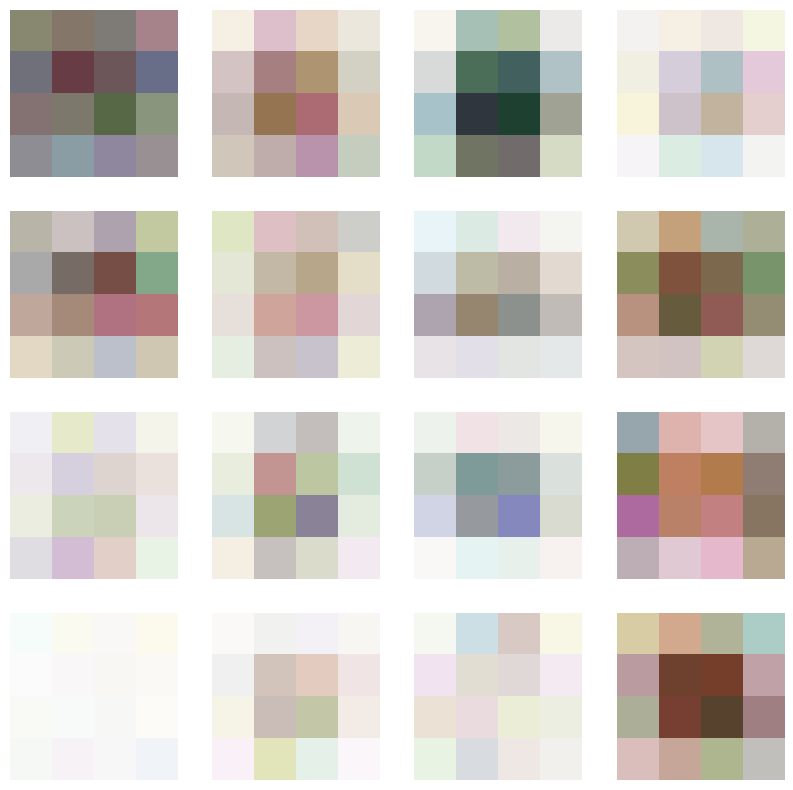

Step: 347
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9642365574836731
Generator loss: 2.3419060707092285


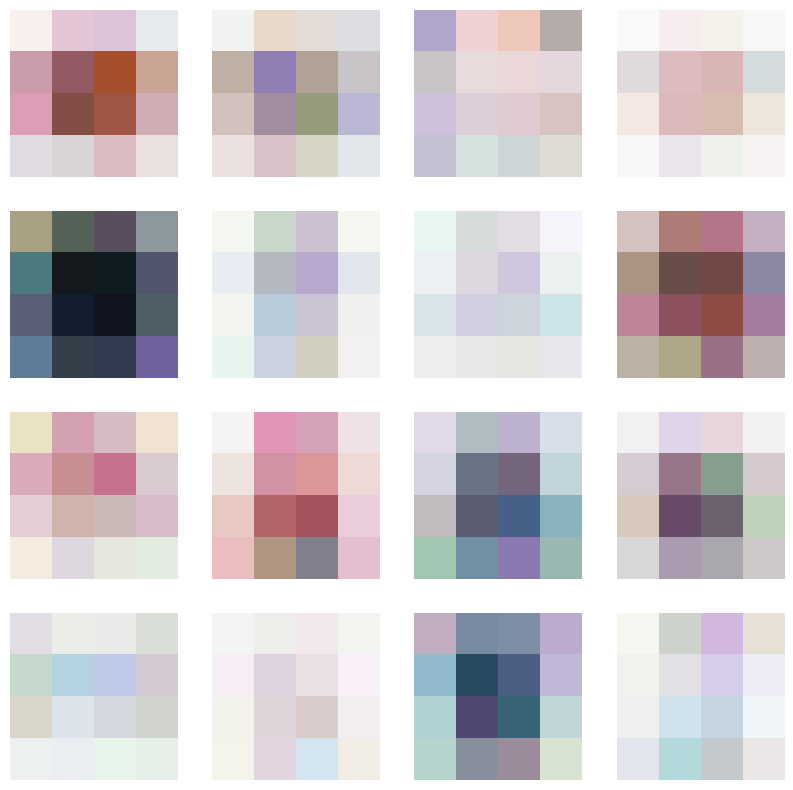

Step: 348
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9618883728981018
Generator loss: 2.3352341651916504


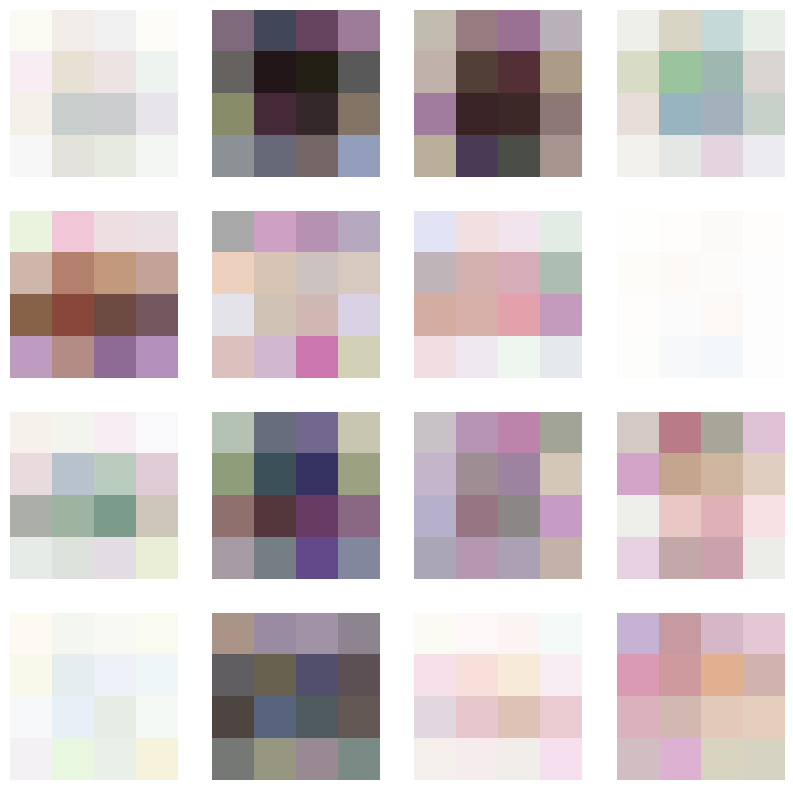

Step: 349
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9594466090202332
Generator loss: 2.3290951251983643


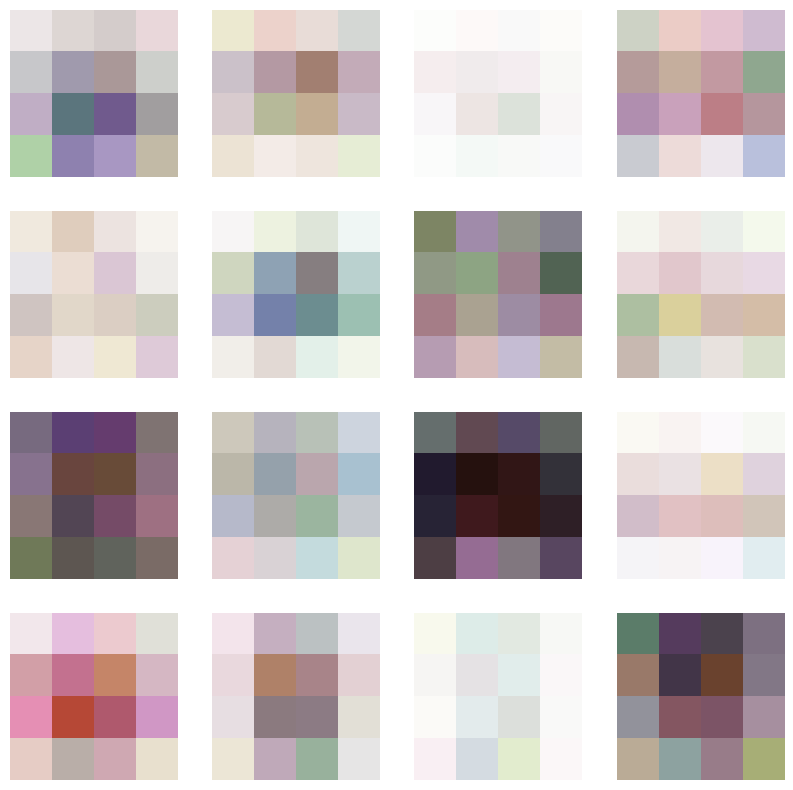

Step: 350
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9573031067848206
Generator loss: 2.3224785327911377


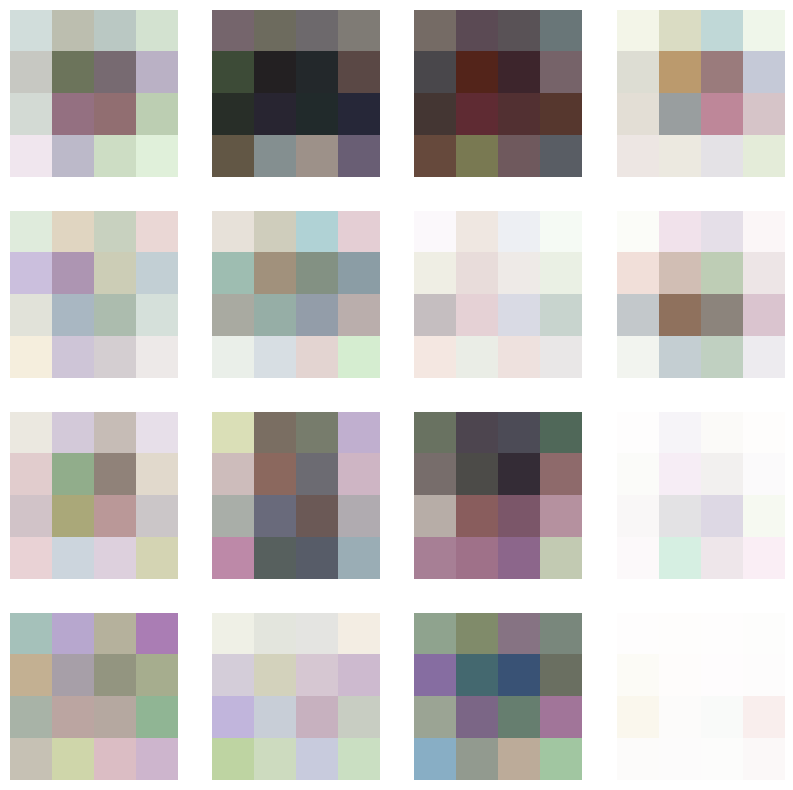

Step: 351
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9552125930786133
Generator loss: 2.3160500526428223


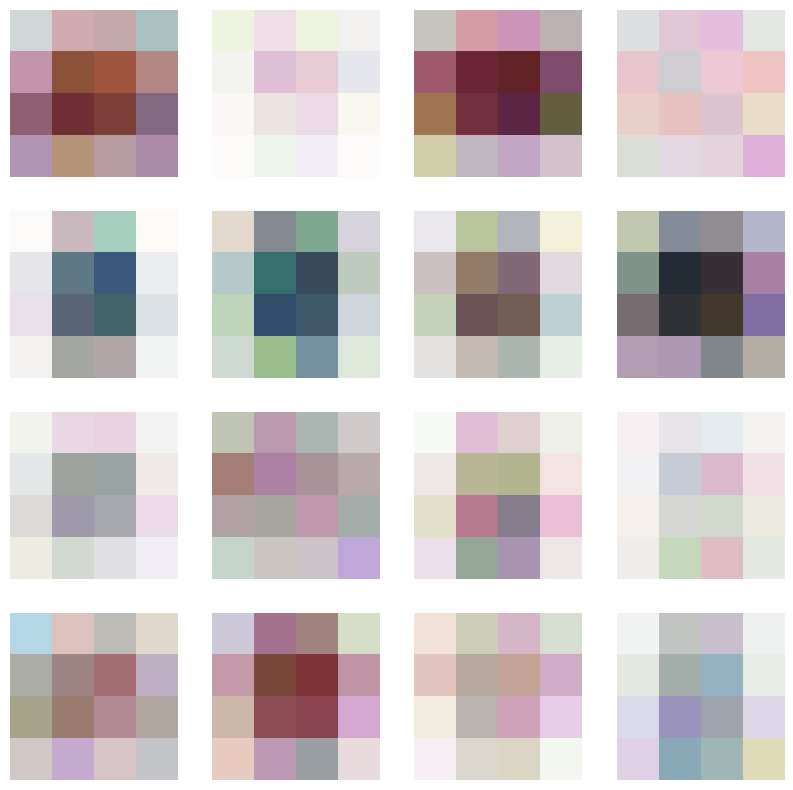

Step: 352
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9529812932014465
Generator loss: 2.309368371963501


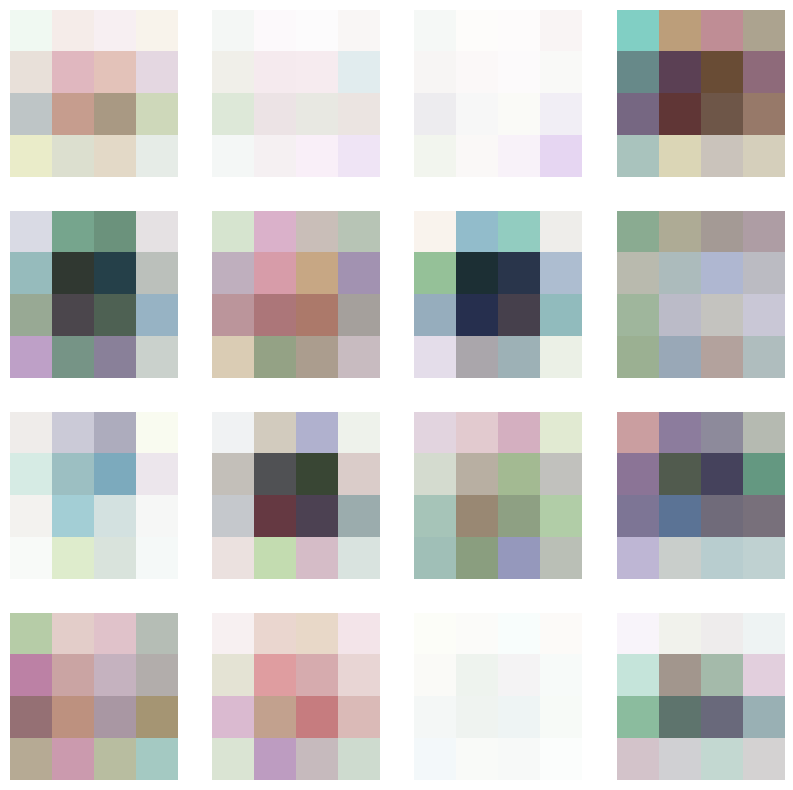

Step: 353
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9508123993873596
Generator loss: 2.3020265102386475


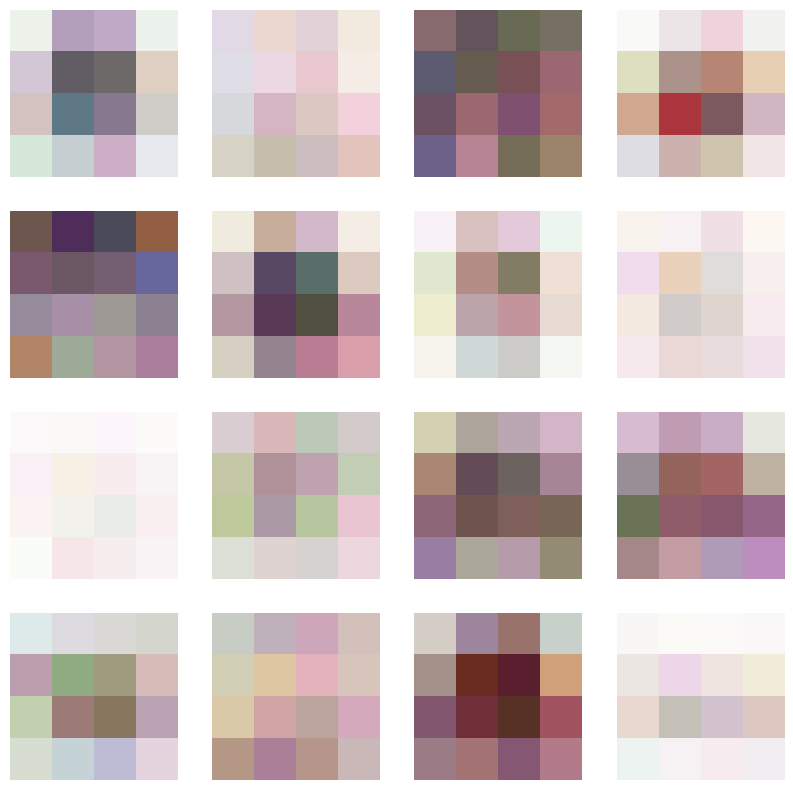

Step: 354
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9483151435852051
Generator loss: 2.295567750930786


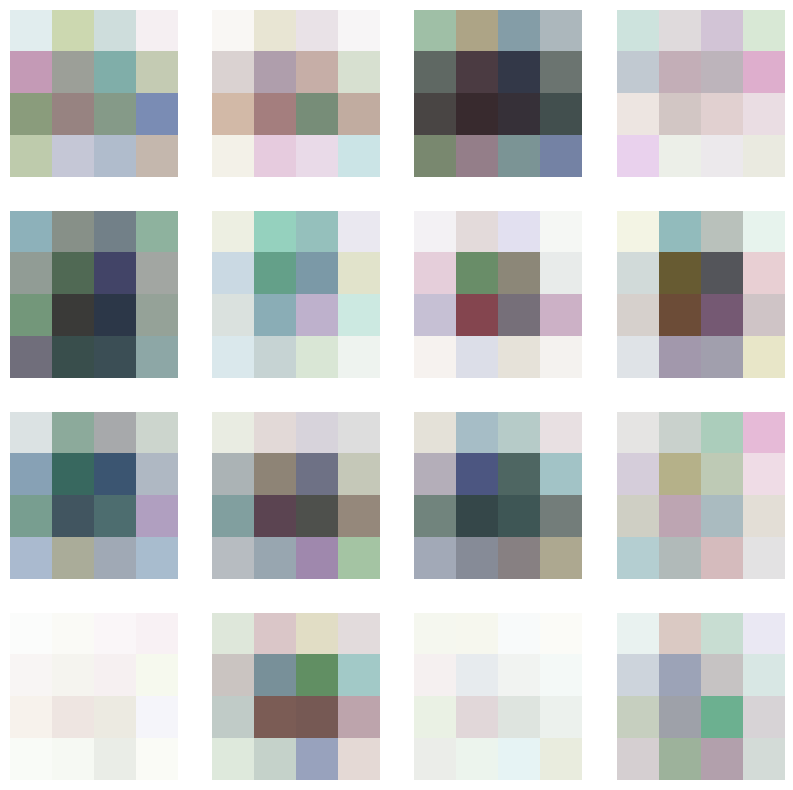

Step: 355
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9461636543273926
Generator loss: 2.2906980514526367


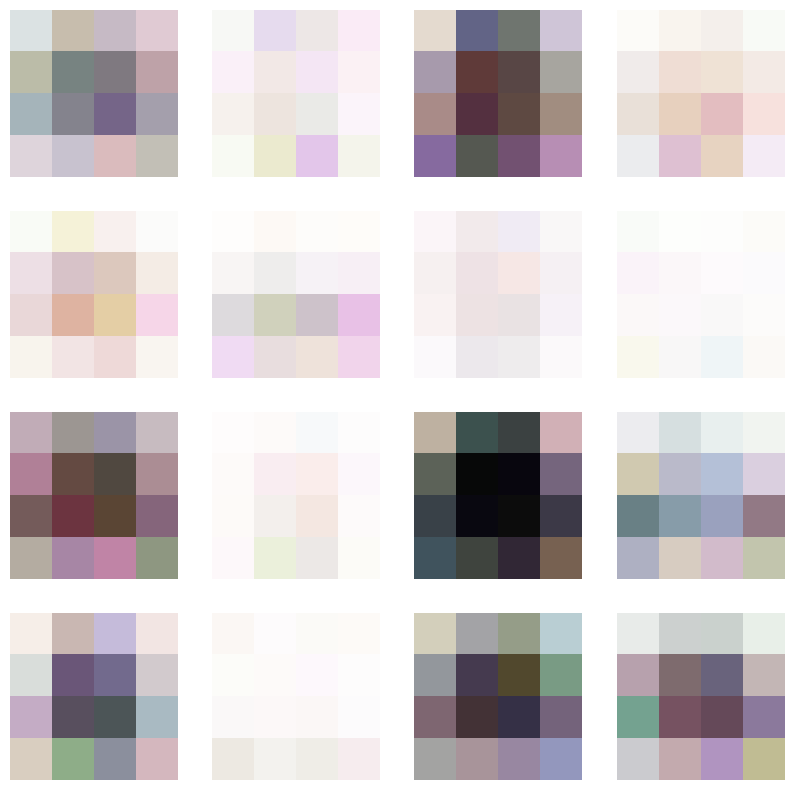

Step: 356
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9438413977622986
Generator loss: 2.284698009490967


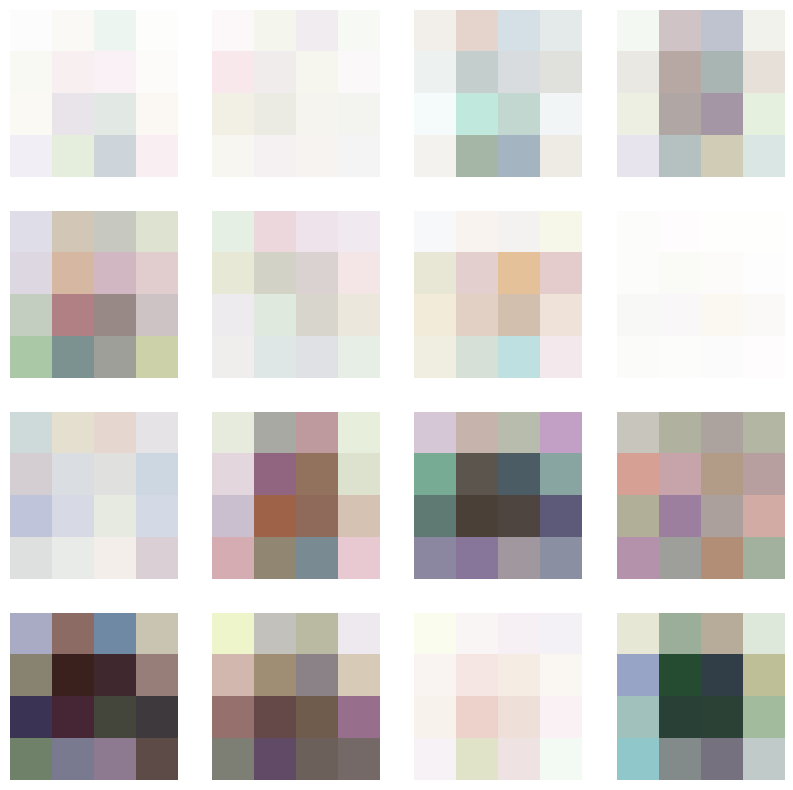

Step: 357
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9415757060050964
Generator loss: 2.2787864208221436


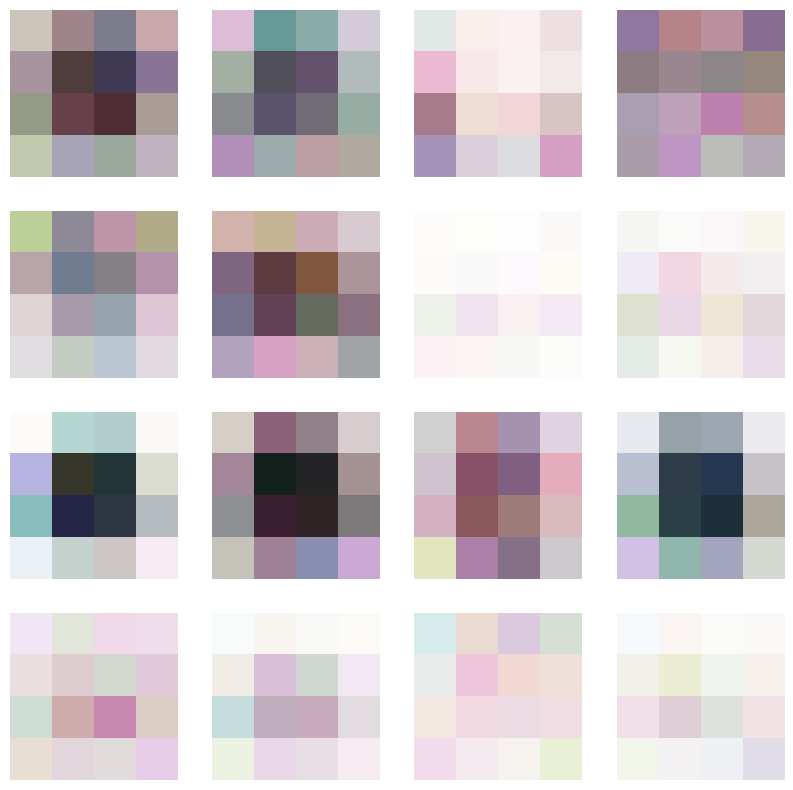

Step: 358
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9395372867584229
Generator loss: 2.2719154357910156


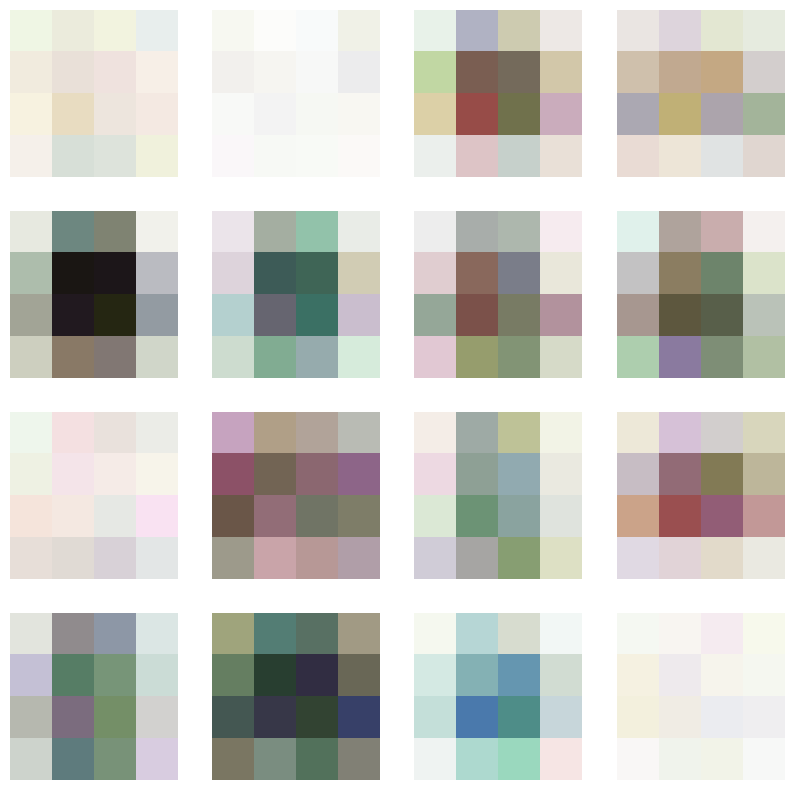

Step: 359
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.937346875667572
Generator loss: 2.2650365829467773


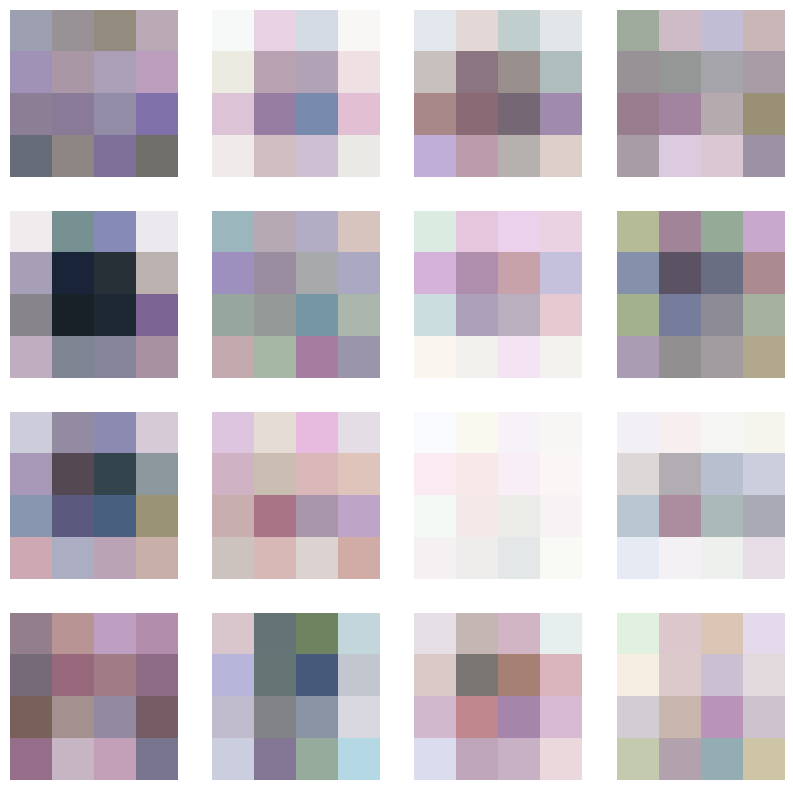

Step: 360
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9352332353591919
Generator loss: 2.259300470352173


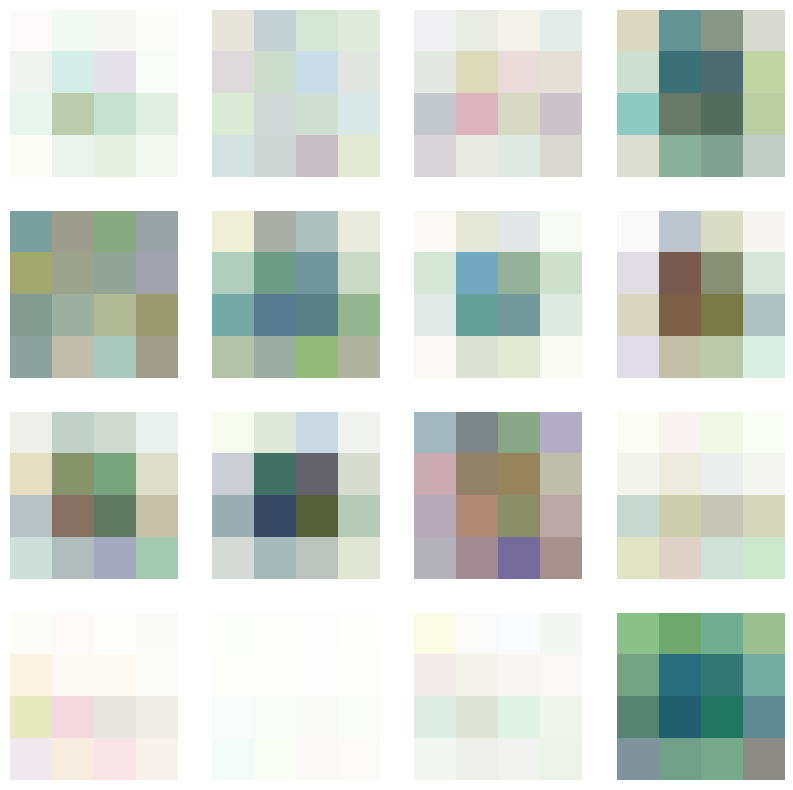

Step: 361
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9333109259605408
Generator loss: 2.254791021347046


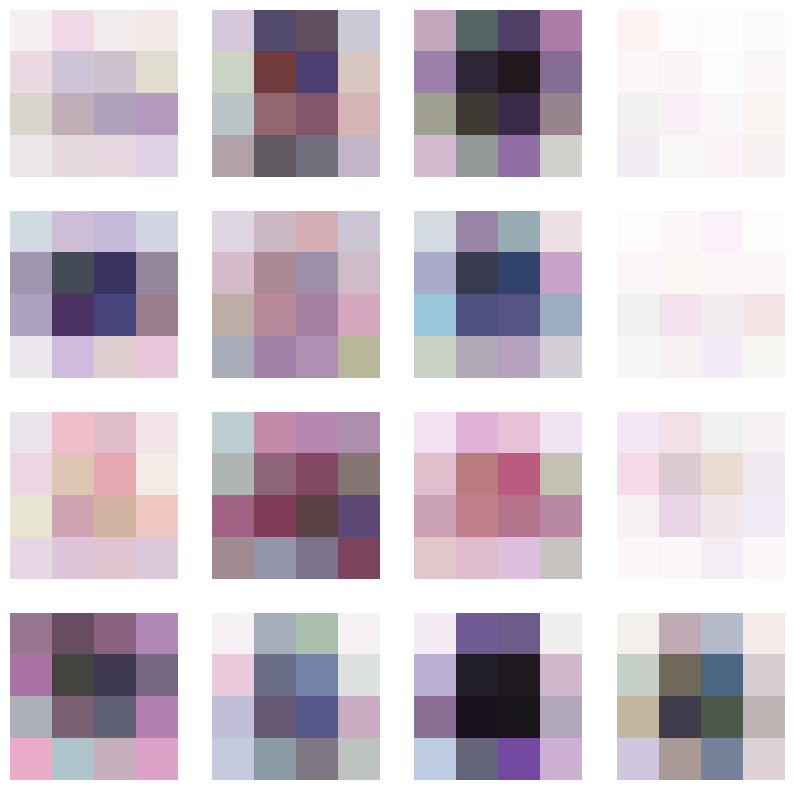

Step: 362
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9313377737998962
Generator loss: 2.2492313385009766


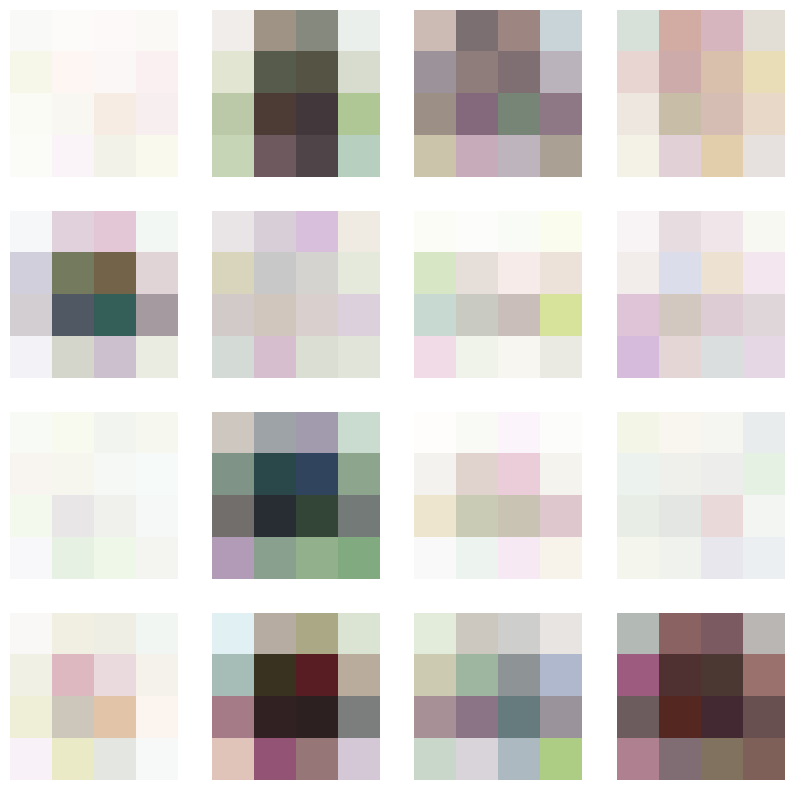

Step: 363
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9292330741882324
Generator loss: 2.242187976837158


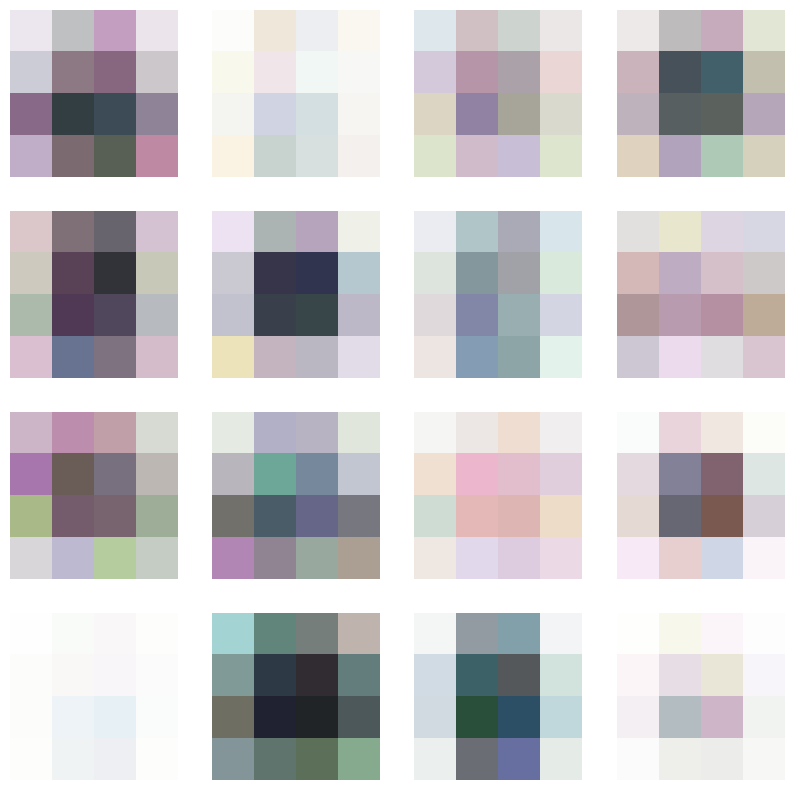

Step: 364
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9272449016571045
Generator loss: 2.2356817722320557


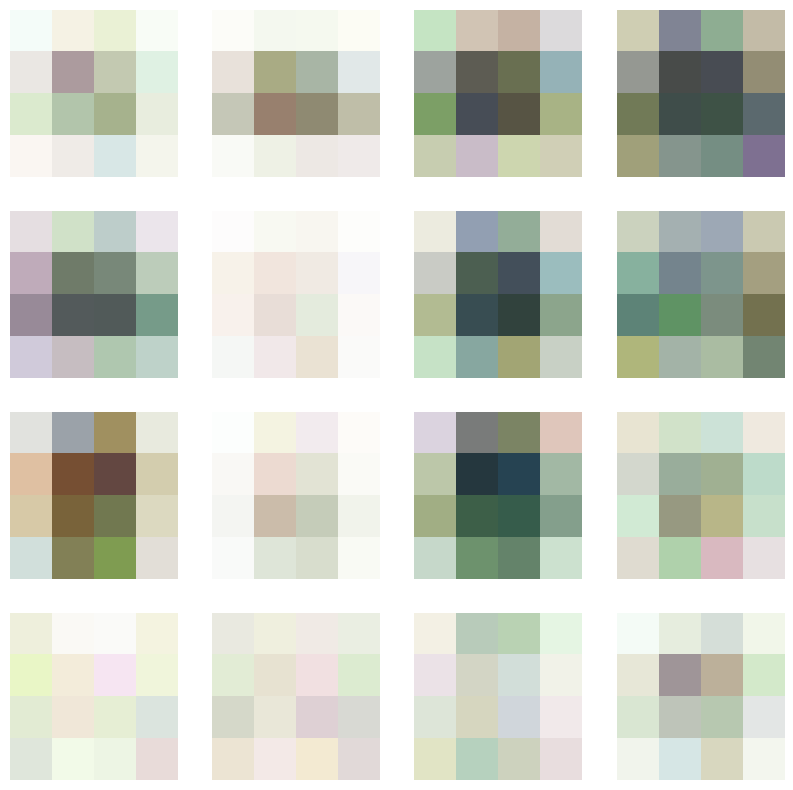

Step: 365
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9254136085510254
Generator loss: 2.2297399044036865


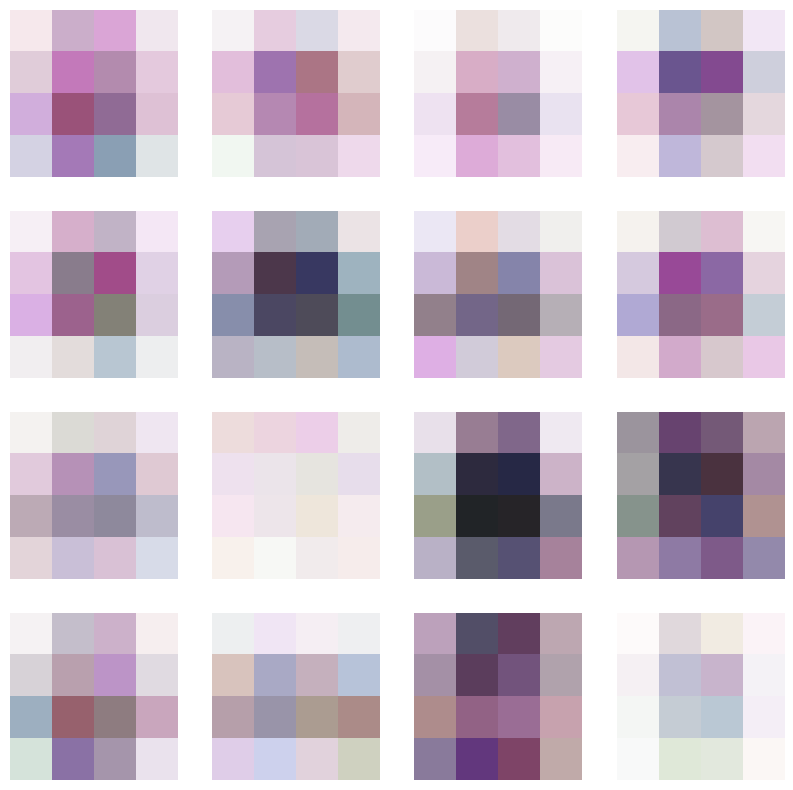

Step: 366
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9236932396888733
Generator loss: 2.2239503860473633


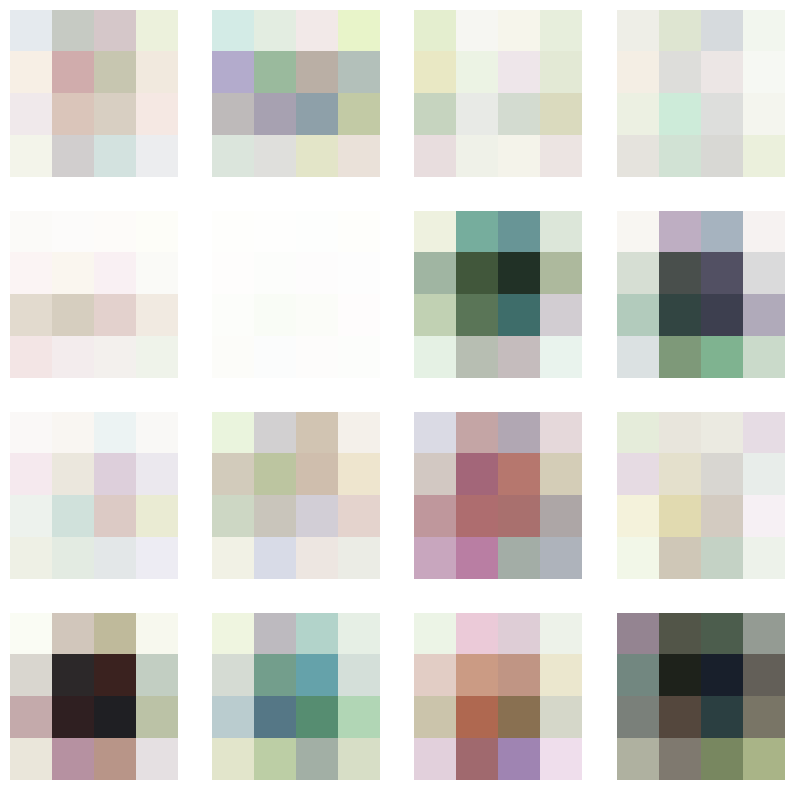

Step: 367
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9213548898696899
Generator loss: 2.216404438018799


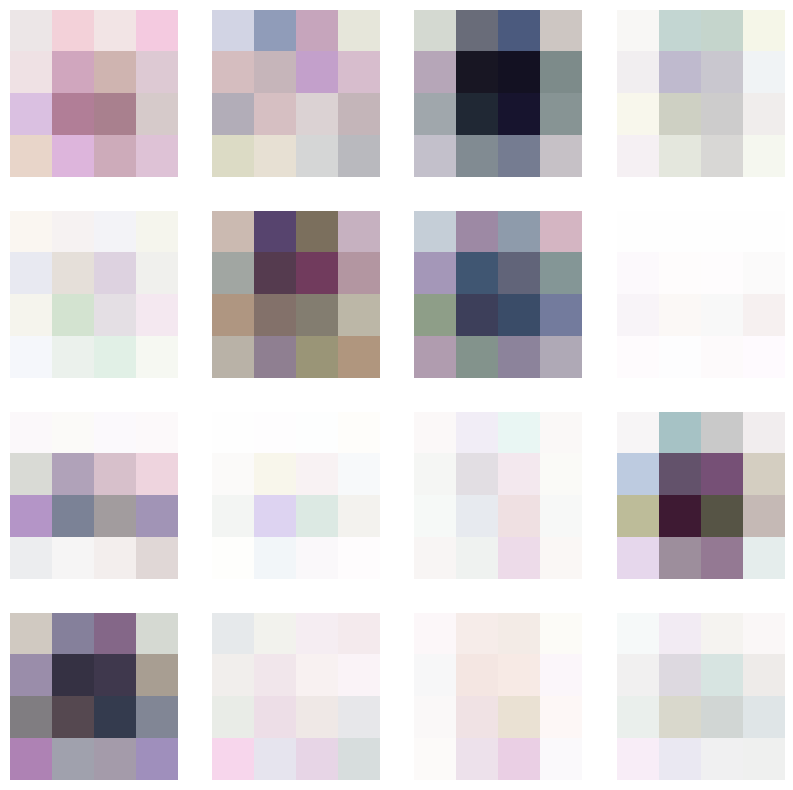

Step: 368
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9192713499069214
Generator loss: 2.2100026607513428


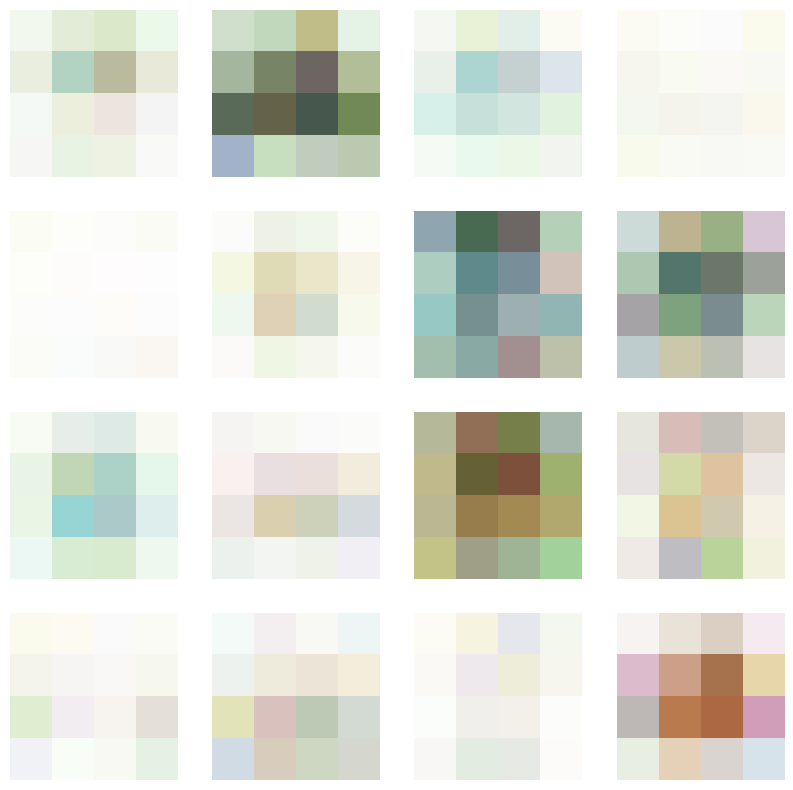

Step: 369
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.917488694190979
Generator loss: 2.204662799835205


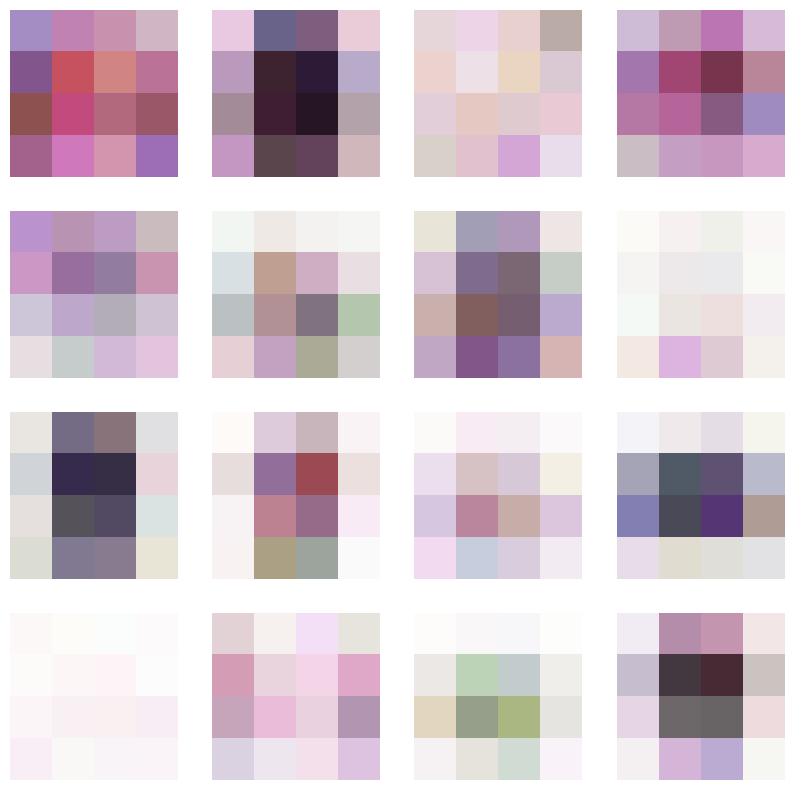

Step: 370
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9157842993736267
Generator loss: 2.201093912124634


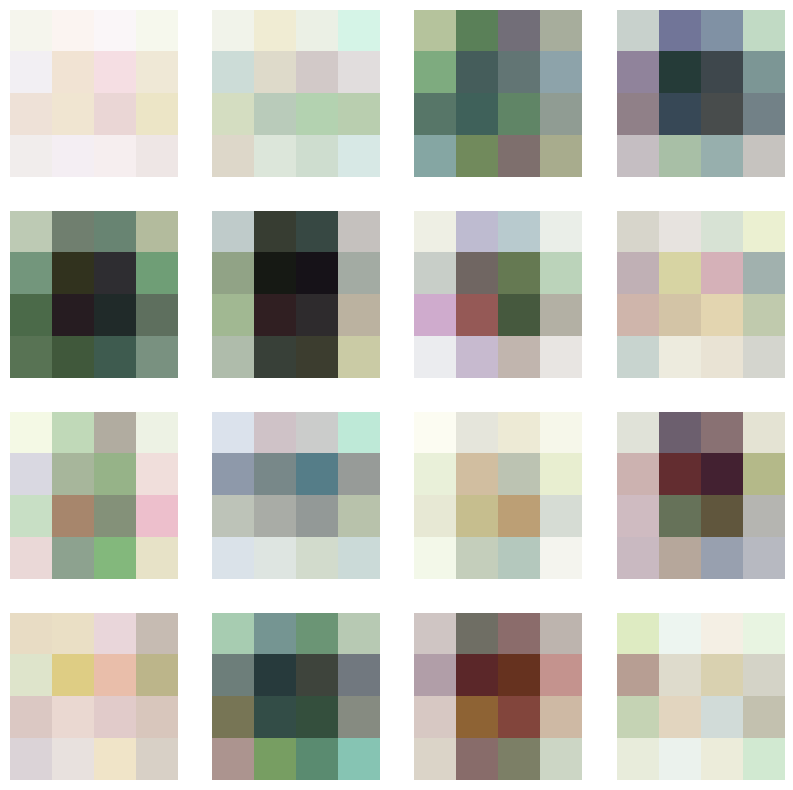

Step: 371
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.913767397403717
Generator loss: 2.1949222087860107


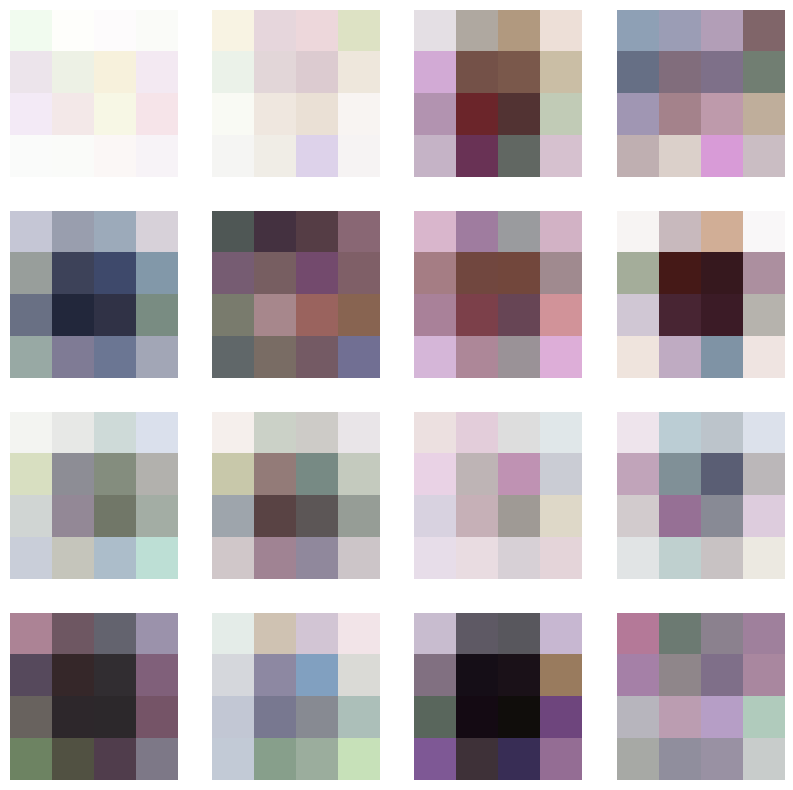

Step: 372
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9116301536560059
Generator loss: 2.188326597213745


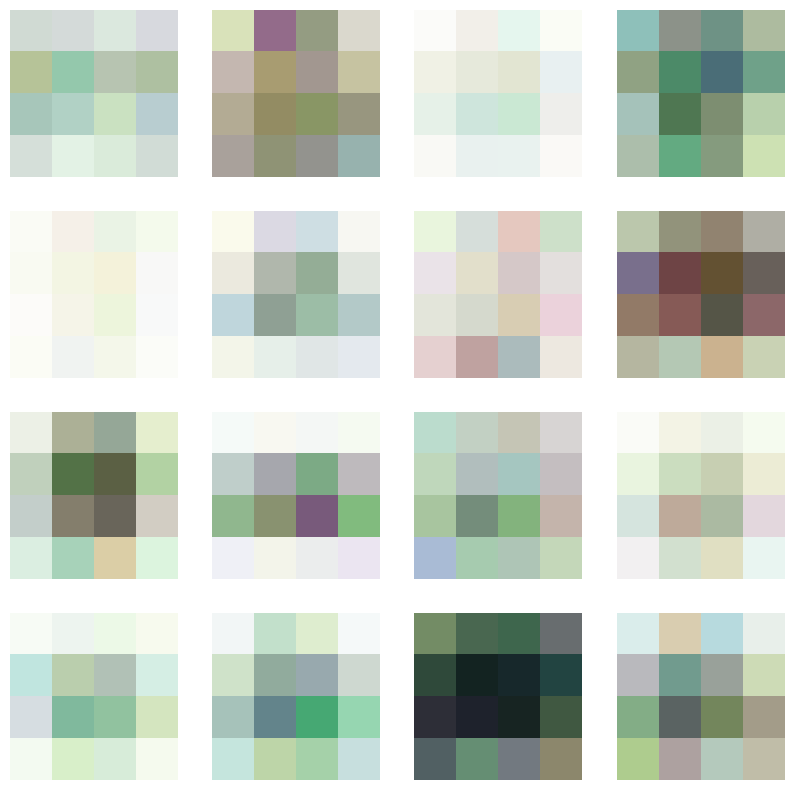

Step: 373
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9095751047134399
Generator loss: 2.182551860809326


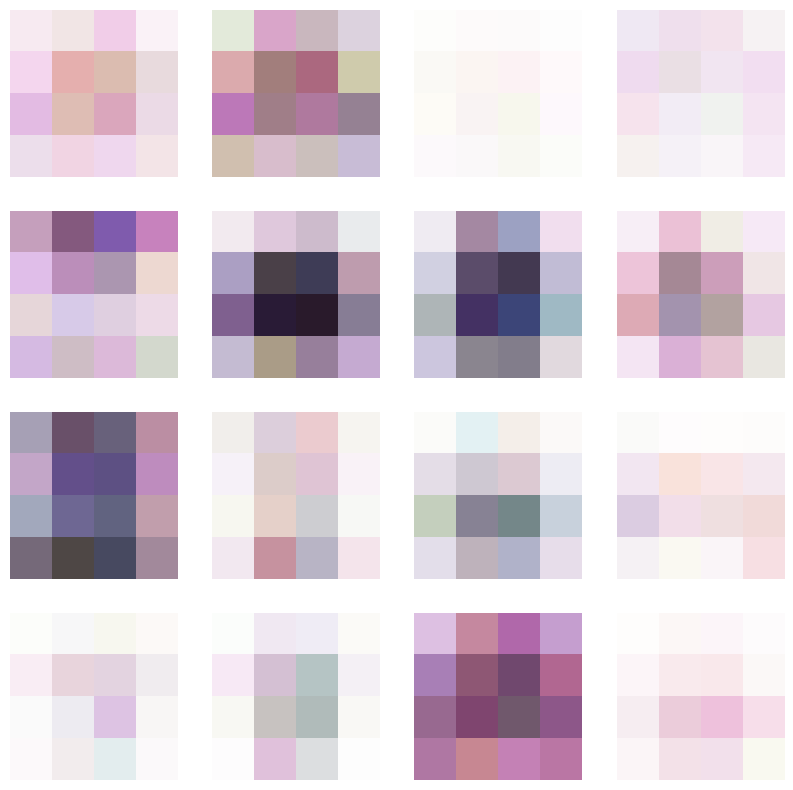

Step: 374
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.907660722732544
Generator loss: 2.178910970687866


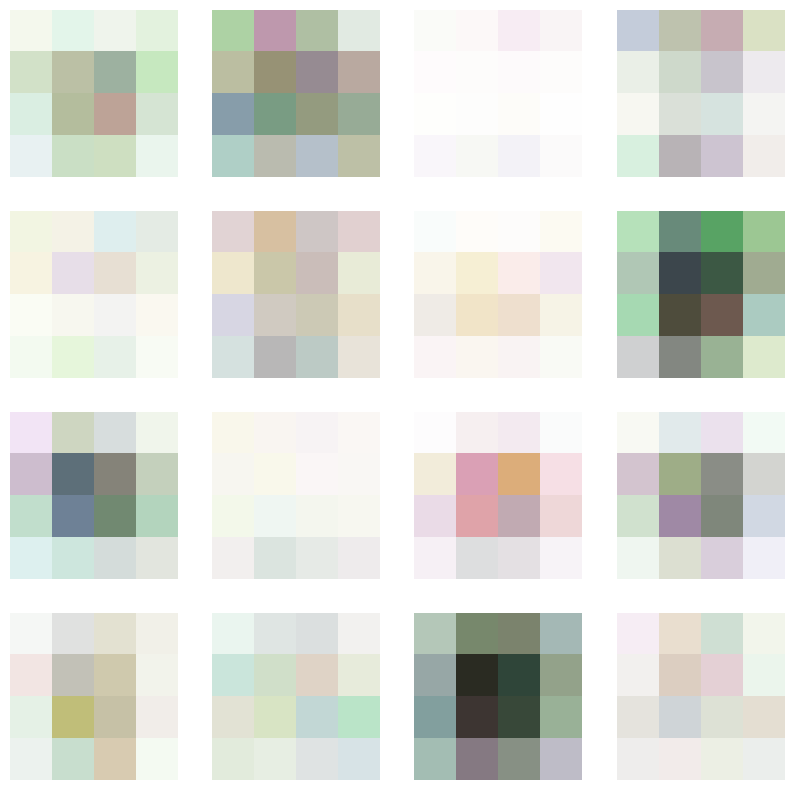

Step: 375
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9057149887084961
Generator loss: 2.174222707748413


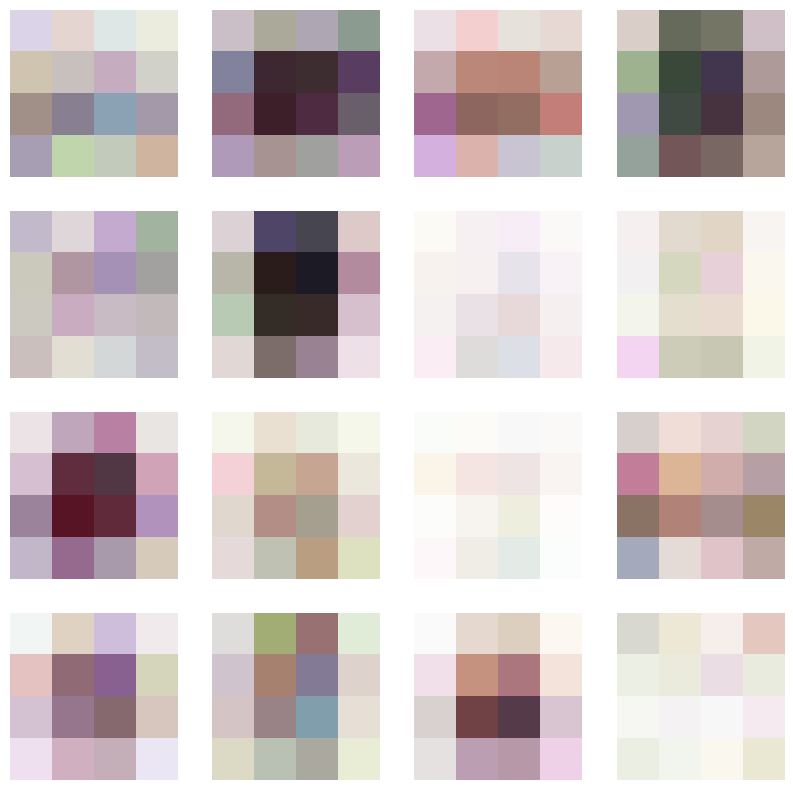

Step: 376
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9039403796195984
Generator loss: 2.172215223312378


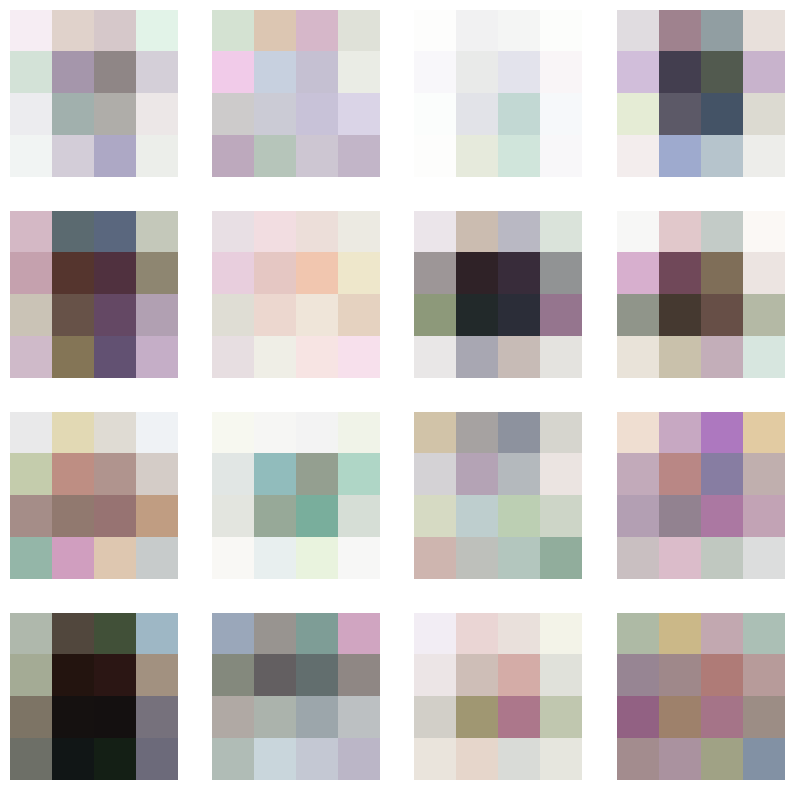

Step: 377
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.9012796878814697
Generator loss: 2.165806293487549


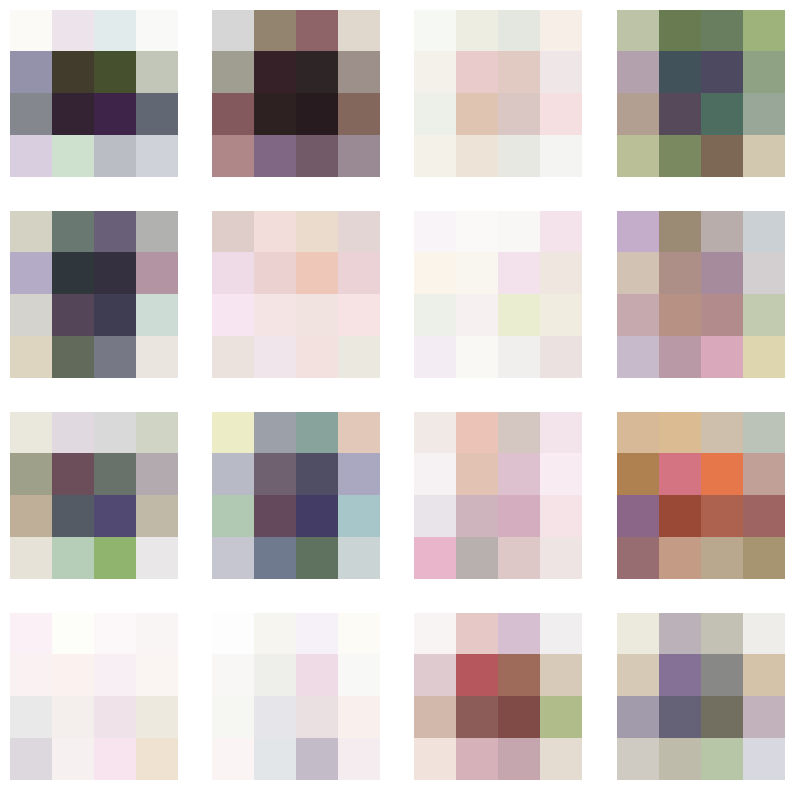

Step: 378
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8991453647613525
Generator loss: 2.1591079235076904


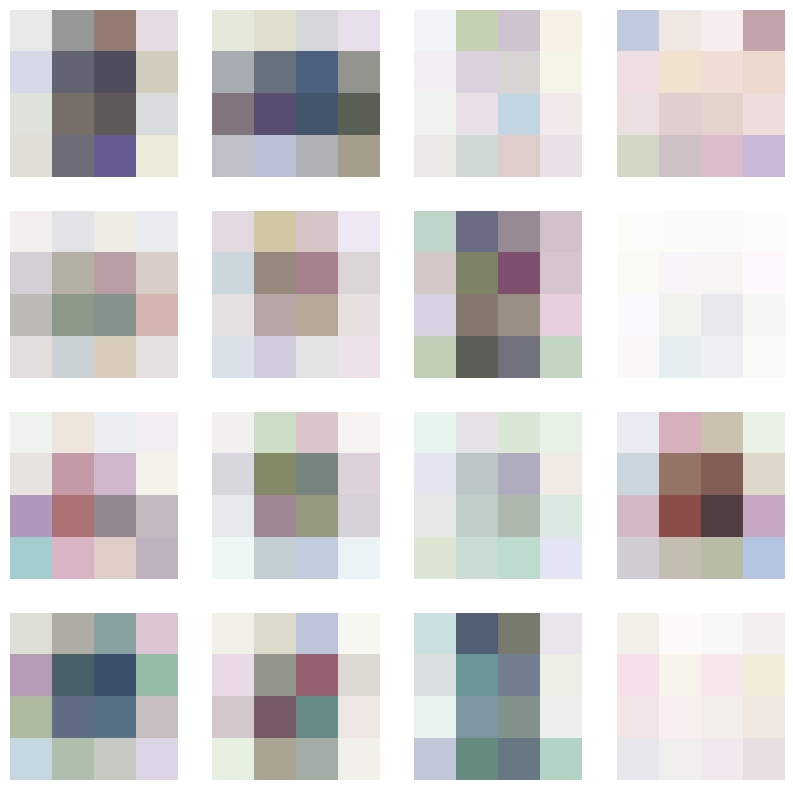

Step: 379
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.897020697593689
Generator loss: 2.152696132659912


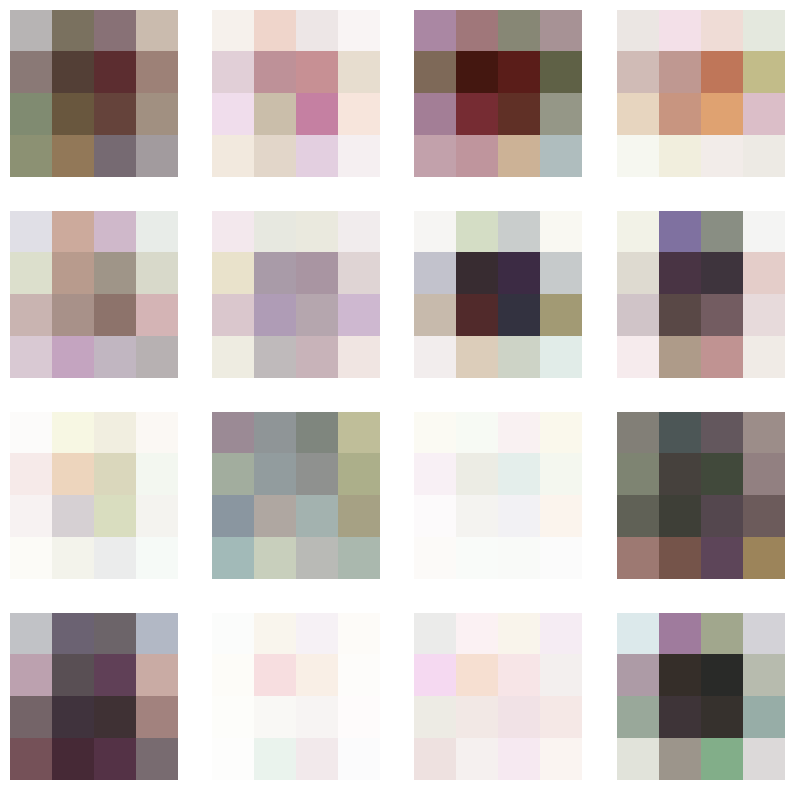

Step: 380
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8949889540672302
Generator loss: 2.1474273204803467


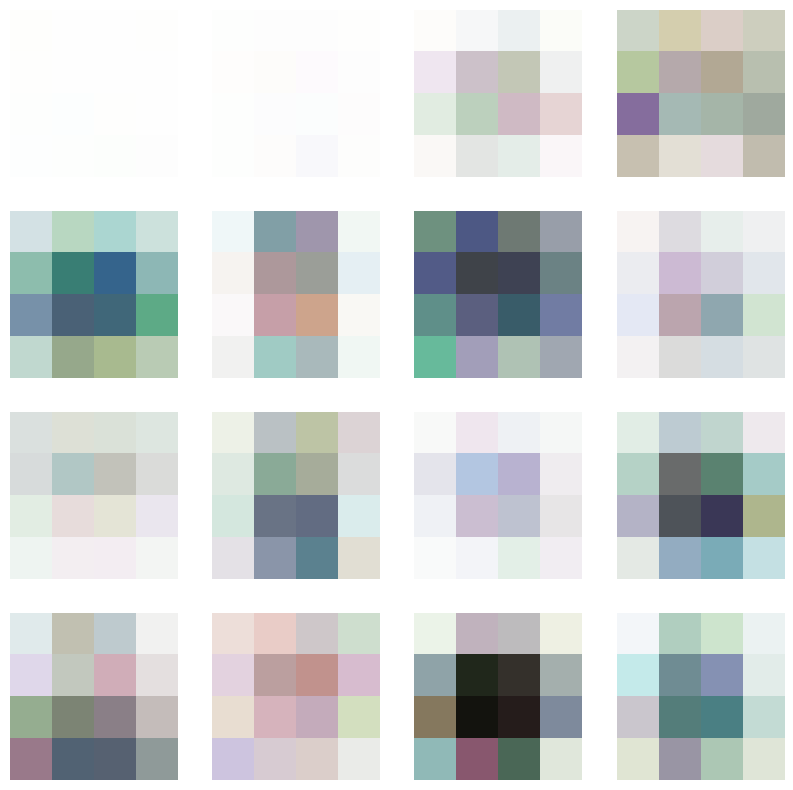

Step: 381
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8928931951522827
Generator loss: 2.1414899826049805


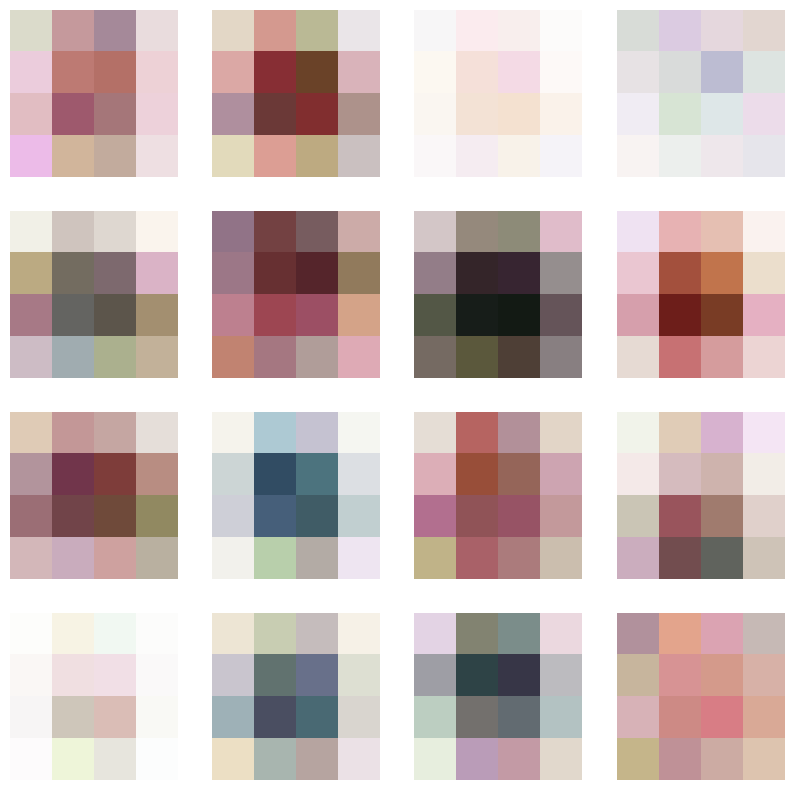

Step: 382
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8906655311584473
Generator loss: 2.135545253753662


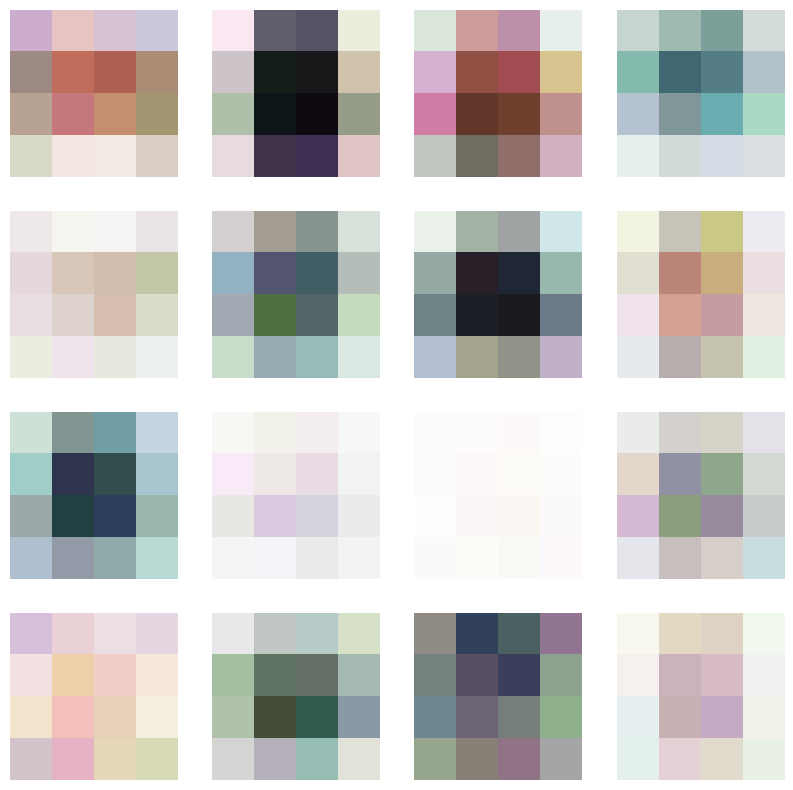

Step: 383
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8888666033744812
Generator loss: 2.1292850971221924


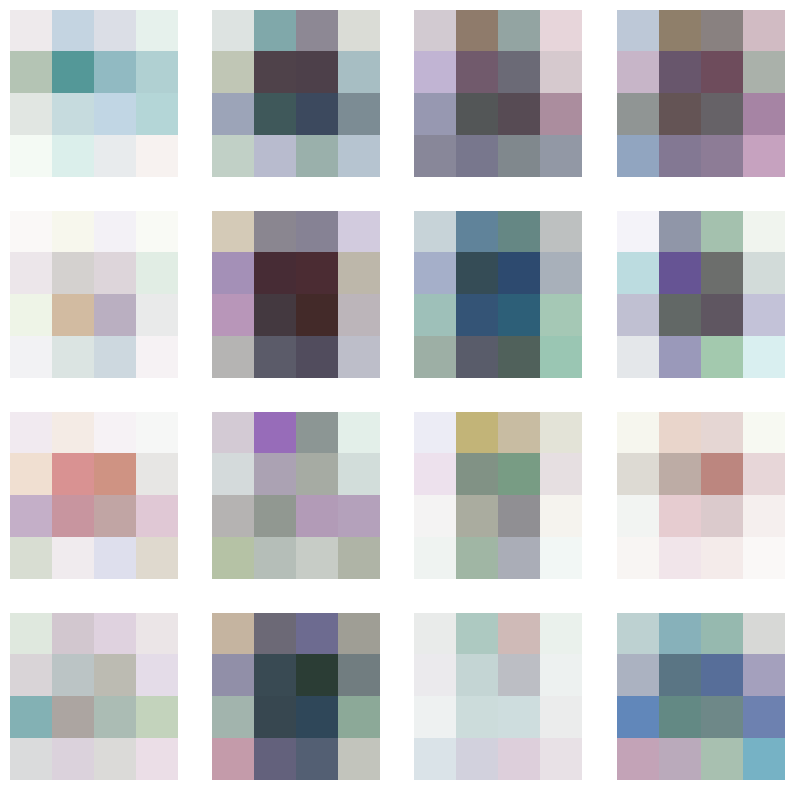

Step: 384
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8870150446891785
Generator loss: 2.122025489807129


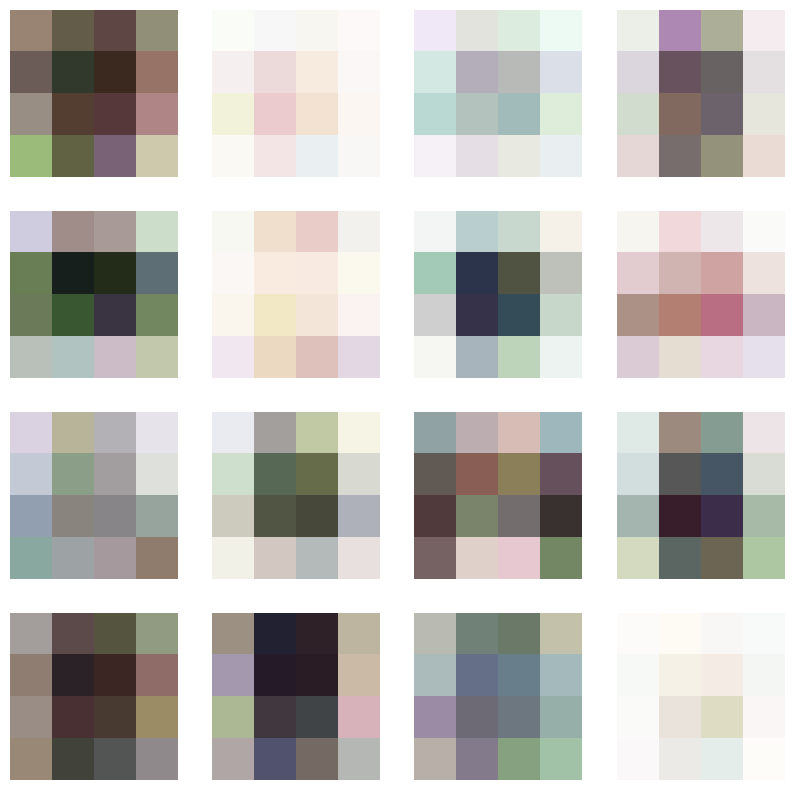

Step: 385
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8853026032447815
Generator loss: 2.1150126457214355


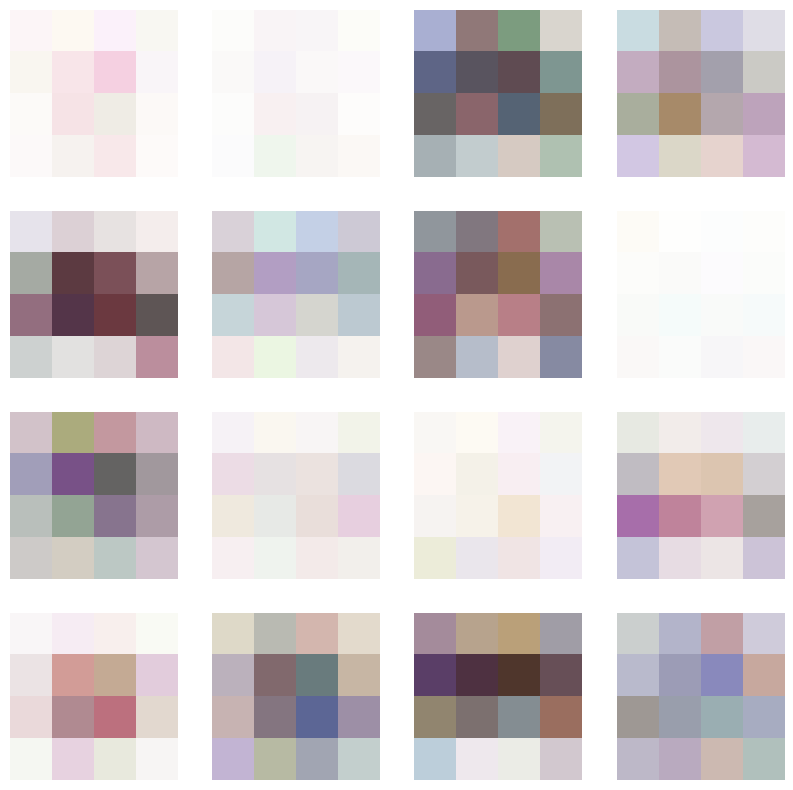

Step: 386
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8834394812583923
Generator loss: 2.108278512954712


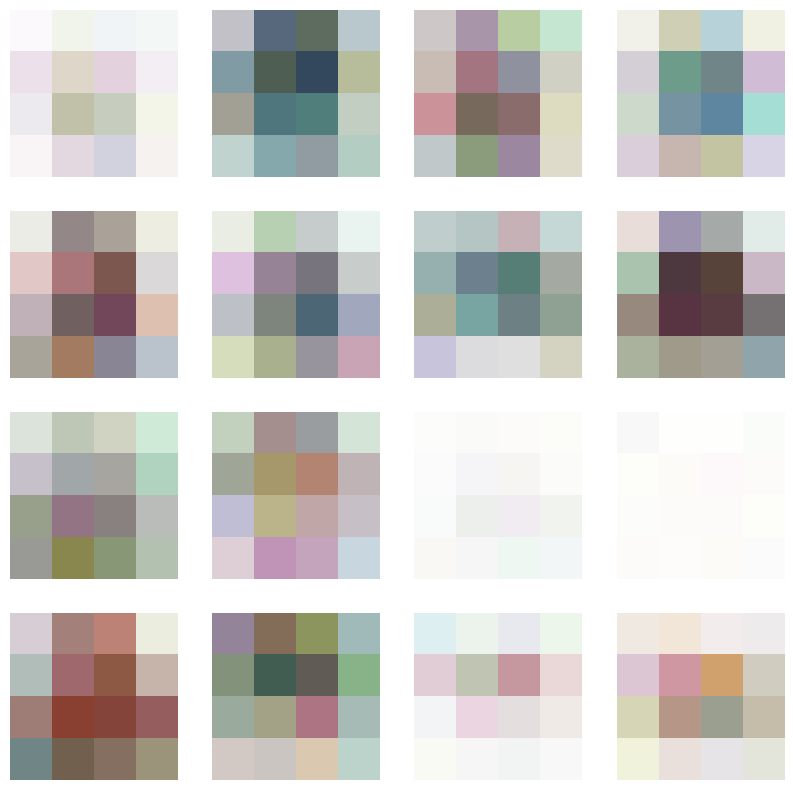

Step: 387
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.881645143032074
Generator loss: 2.1014652252197266


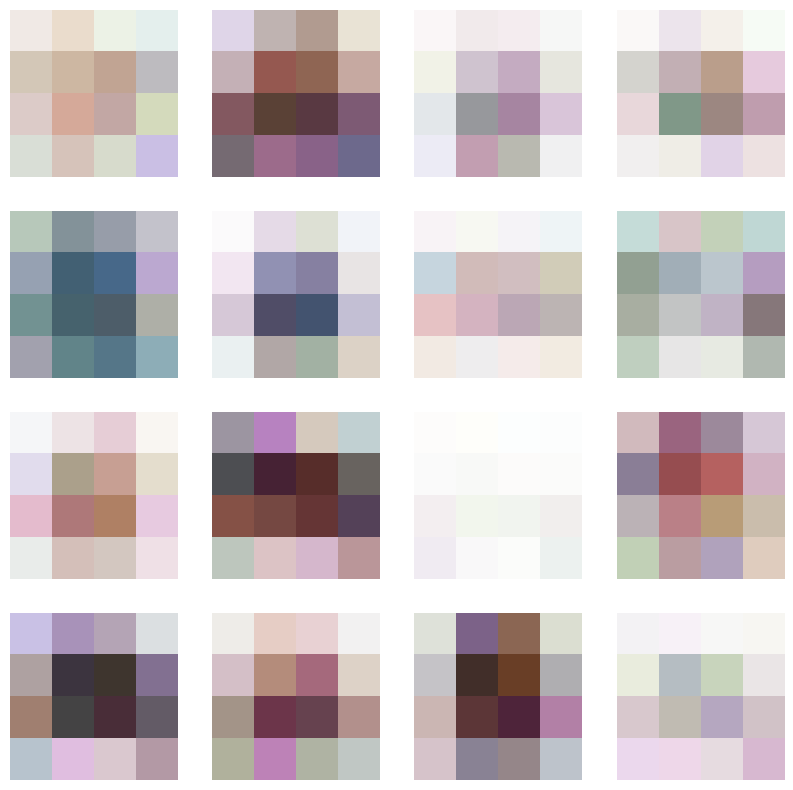

Step: 388
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8795426487922668
Generator loss: 2.0948972702026367


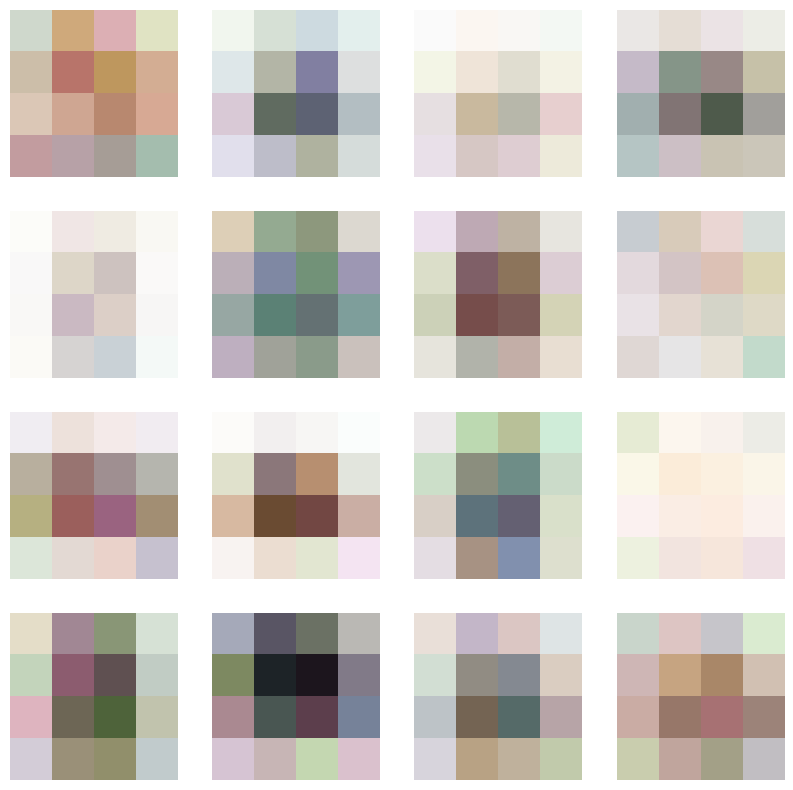

Step: 389
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8776111602783203
Generator loss: 2.0899150371551514


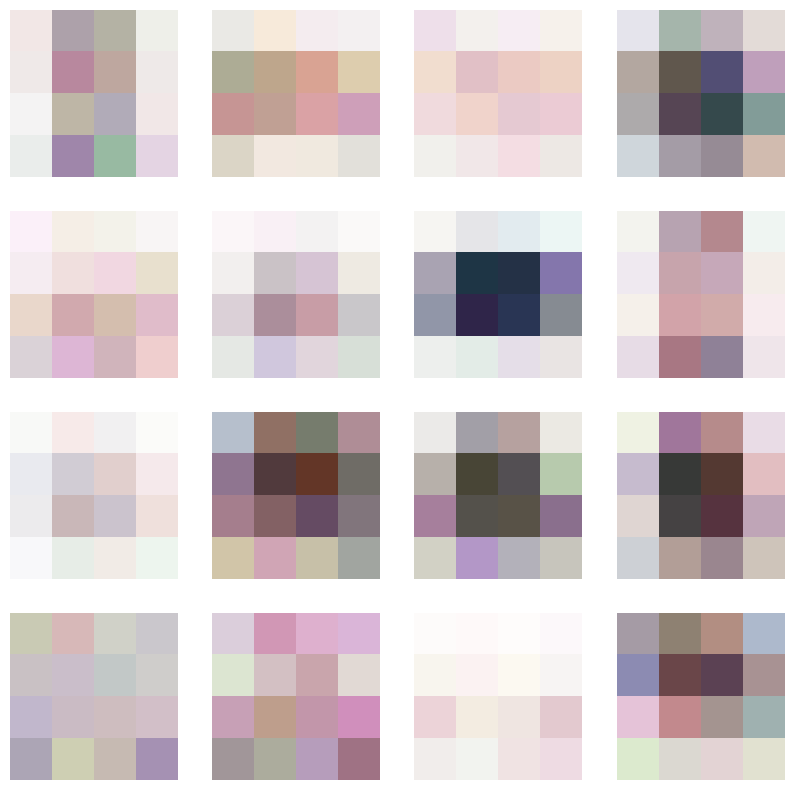

Step: 390
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8761292099952698
Generator loss: 2.0860109329223633


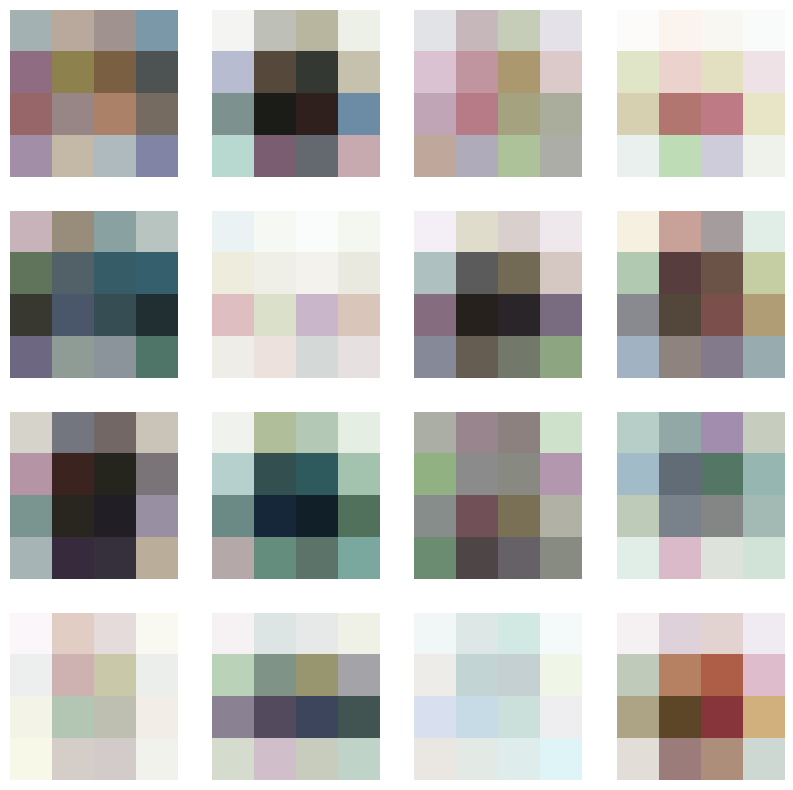

Step: 391
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8740314841270447
Generator loss: 2.0796566009521484


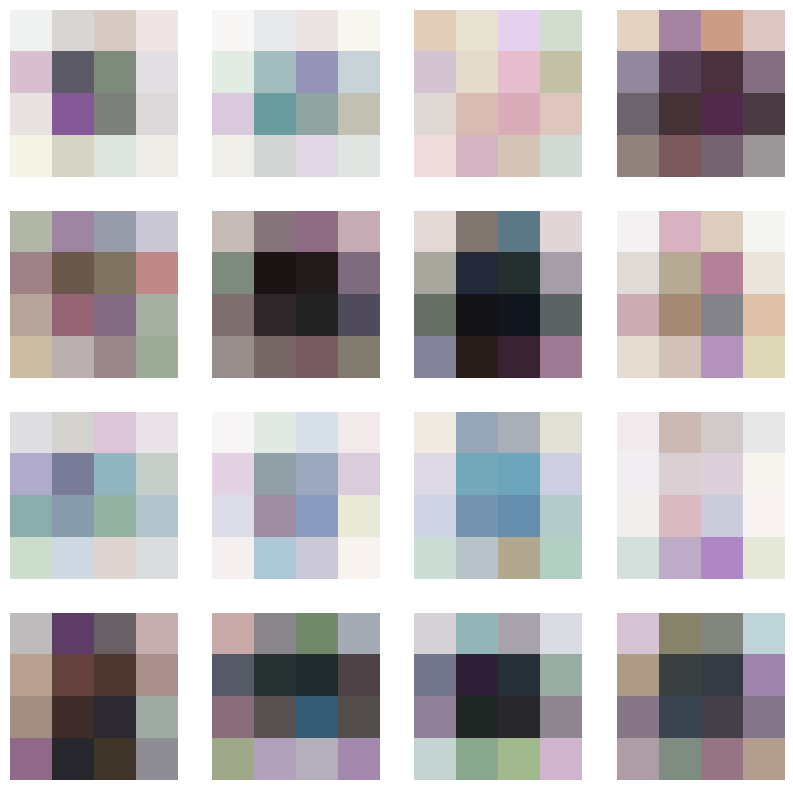

Step: 392
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8721513152122498
Generator loss: 2.0723490715026855


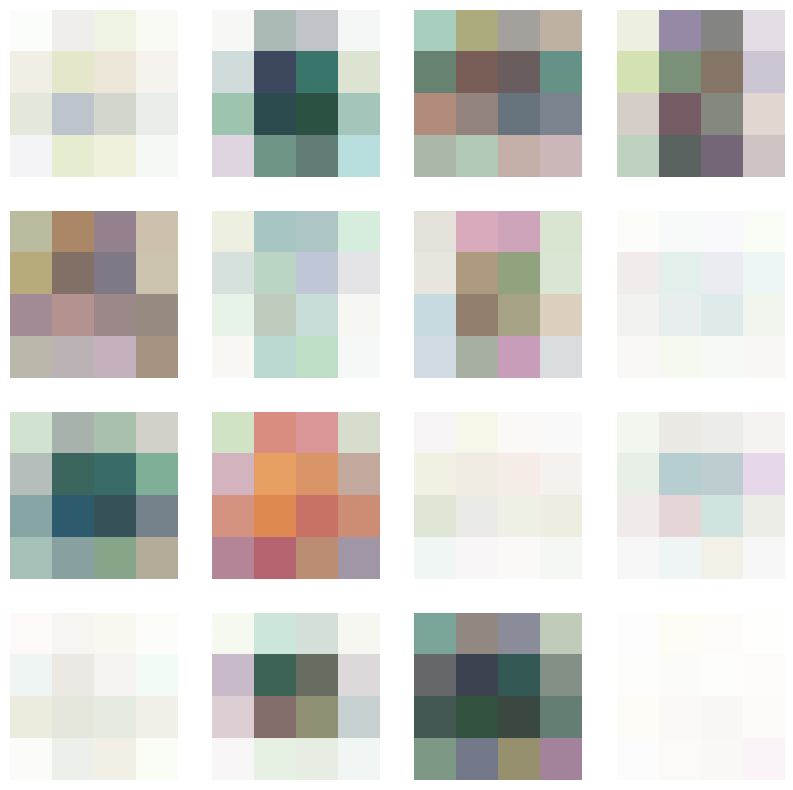

Step: 393
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8698645830154419
Generator loss: 2.0652692317962646


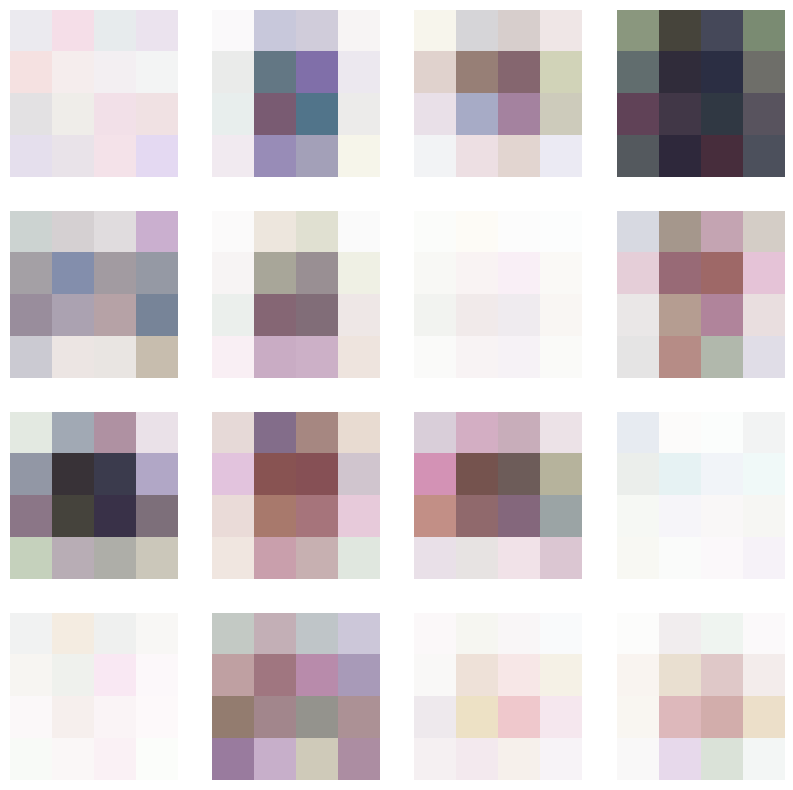

Step: 394
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8679524660110474
Generator loss: 2.0596017837524414


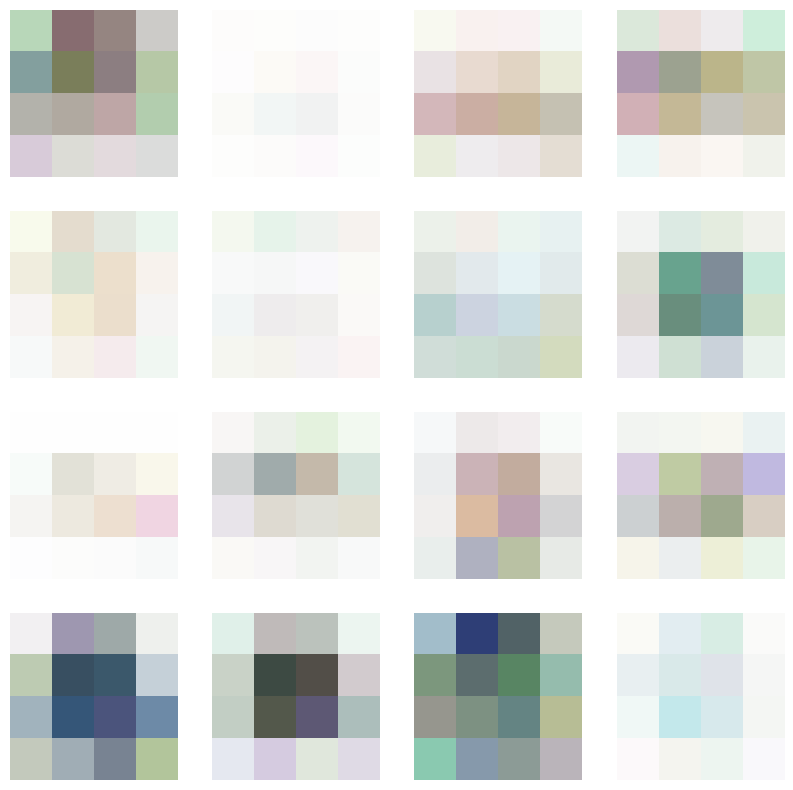

Step: 395
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8663727641105652
Generator loss: 2.057196617126465


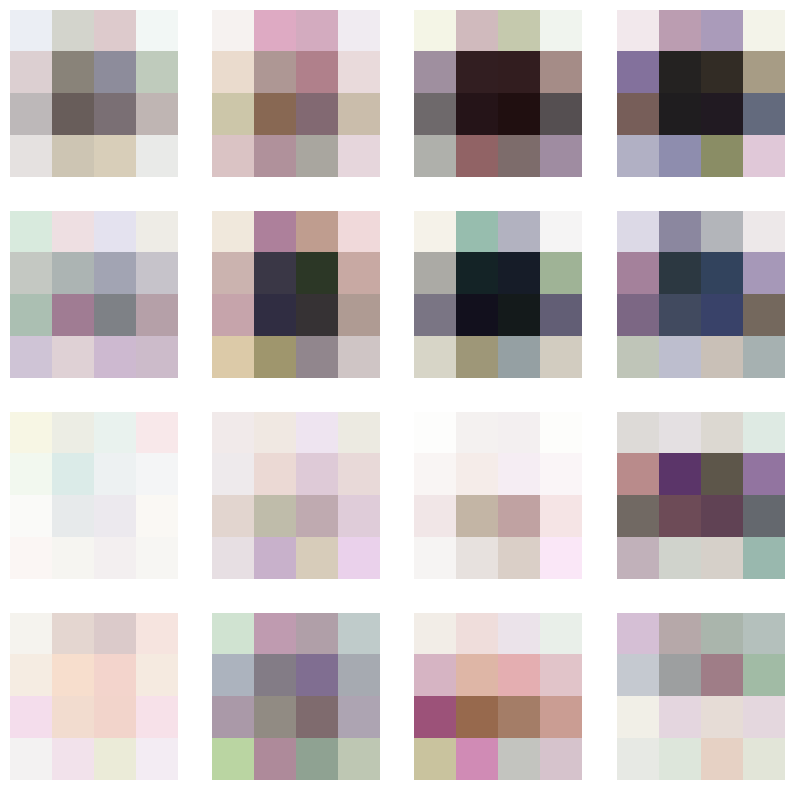

Step: 396
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8645563721656799
Generator loss: 2.0534136295318604


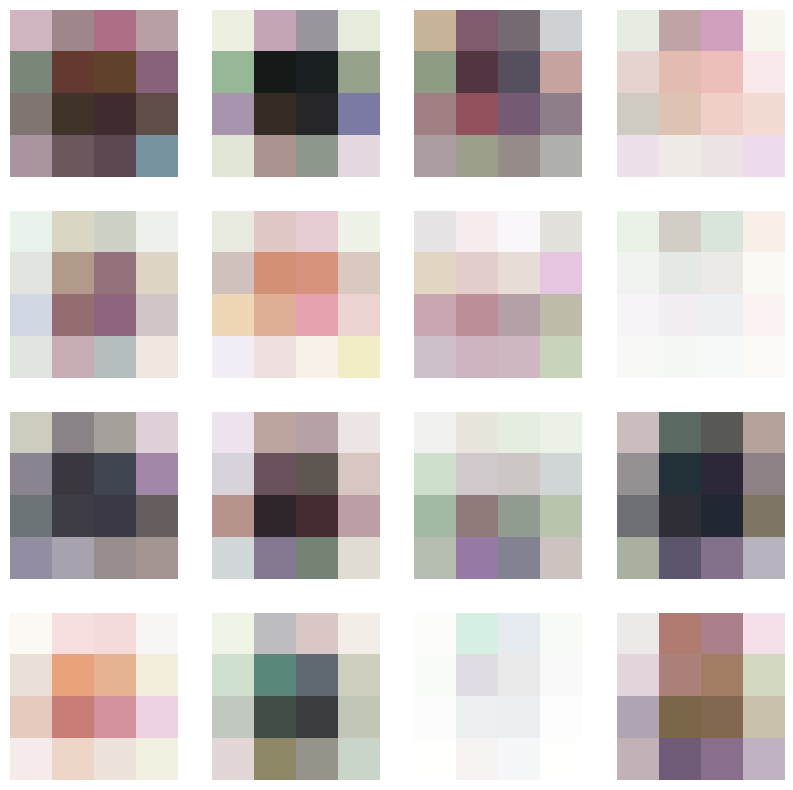

Step: 397
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8632366061210632
Generator loss: 2.052272081375122


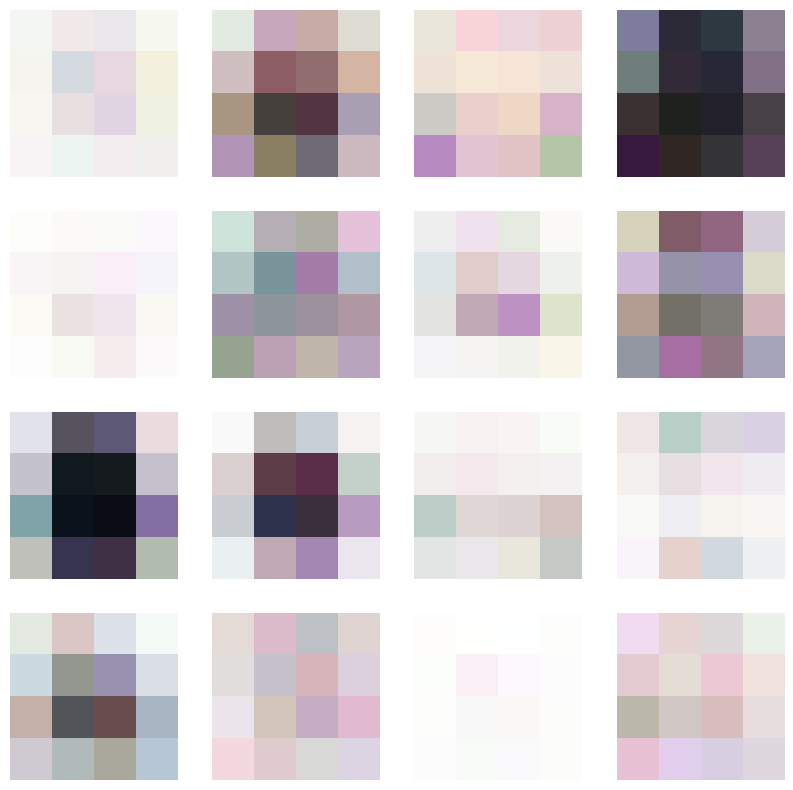

Step: 398
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8597592711448669
Generator loss: 2.0460238456726074


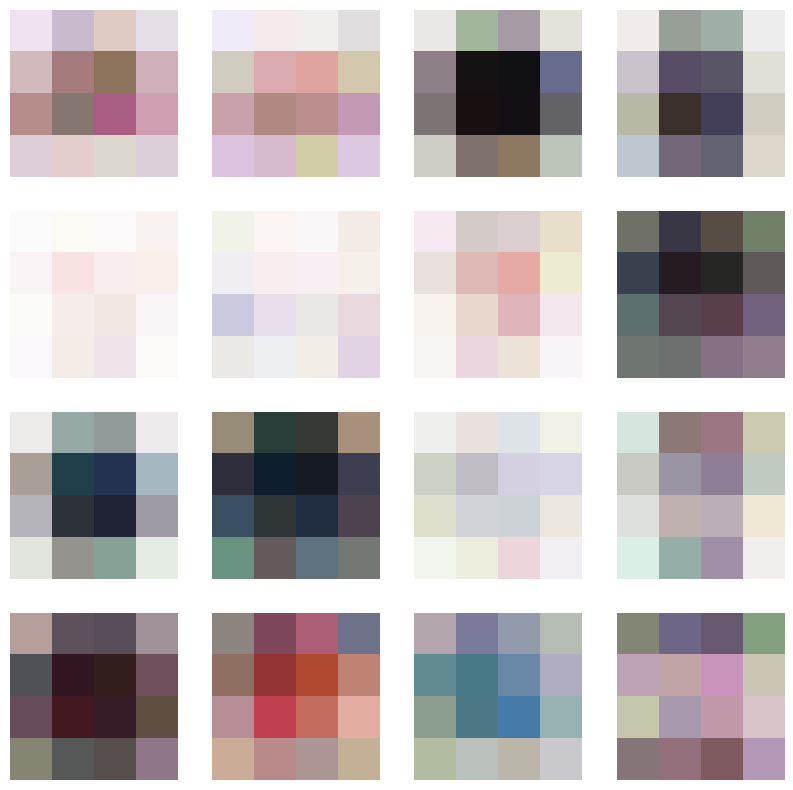

Step: 399
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8574101328849792
Generator loss: 2.039297580718994


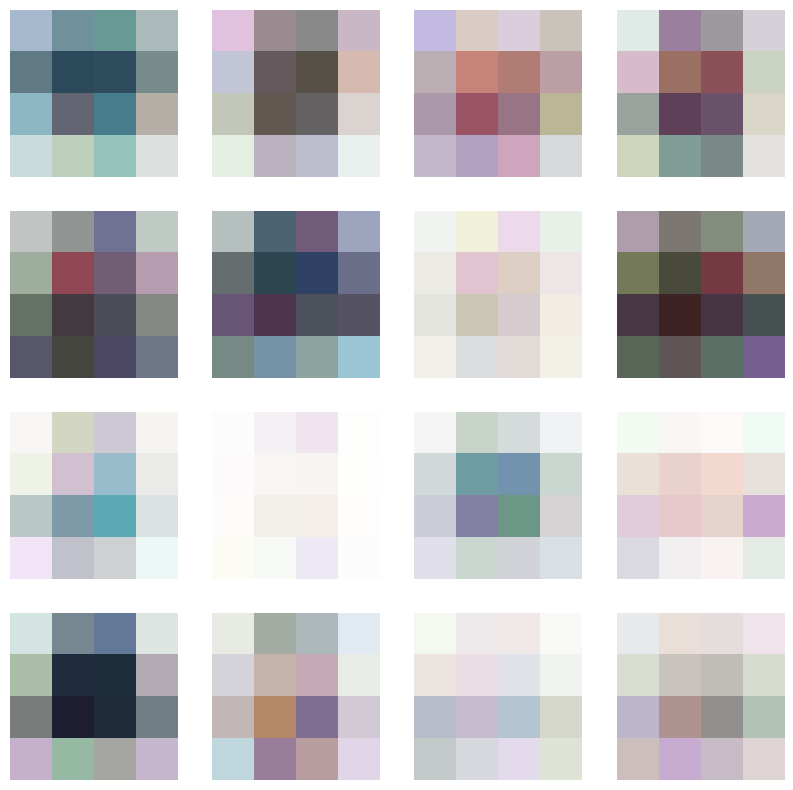

Step: 400
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8548111915588379
Generator loss: 2.033745050430298


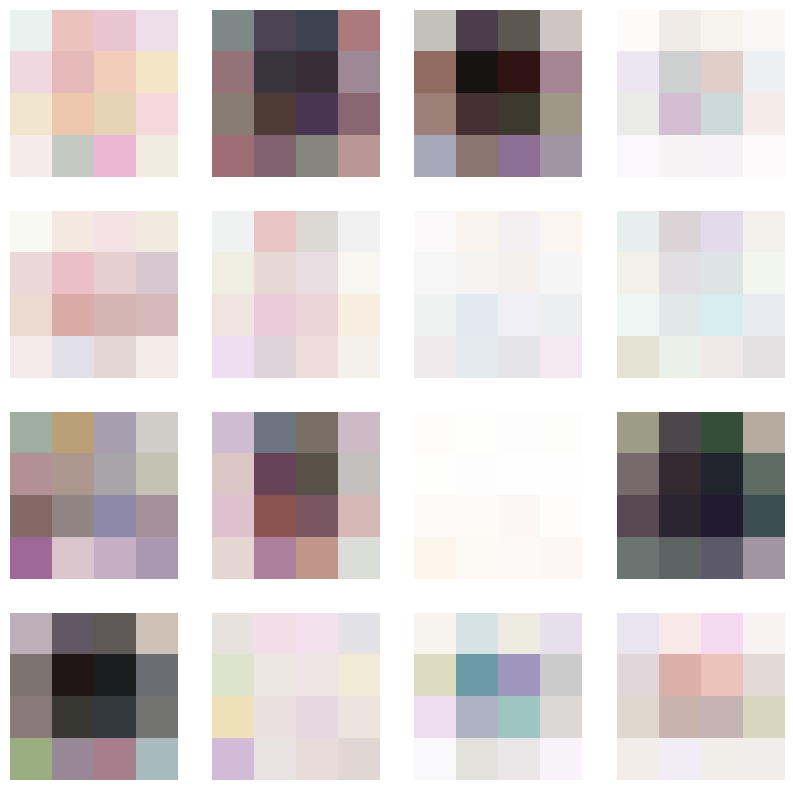

Step: 401
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8524985909461975
Generator loss: 2.0293338298797607


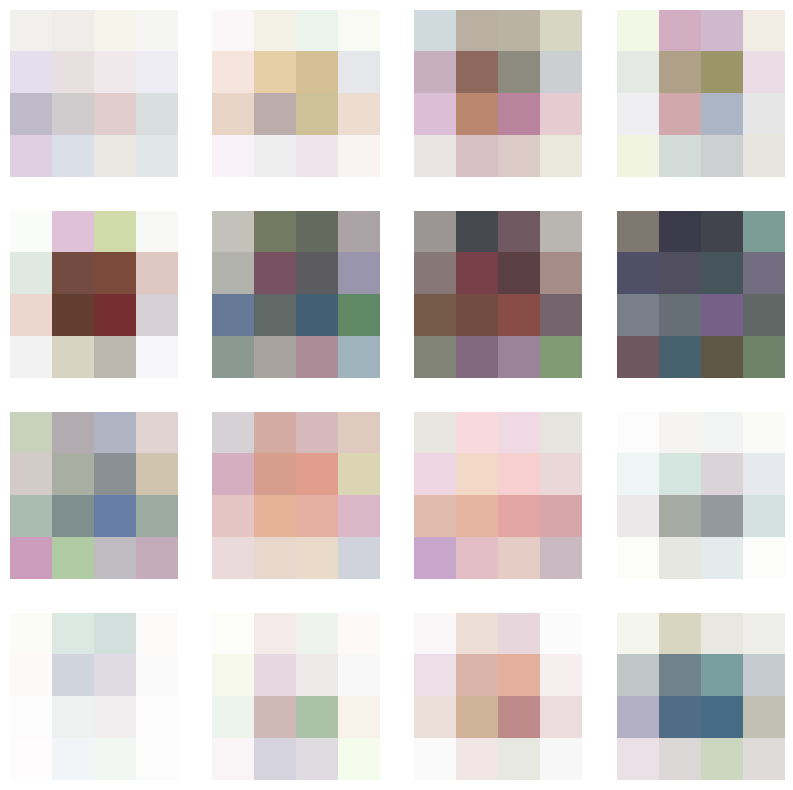

Step: 402
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8505371809005737
Generator loss: 2.0249691009521484


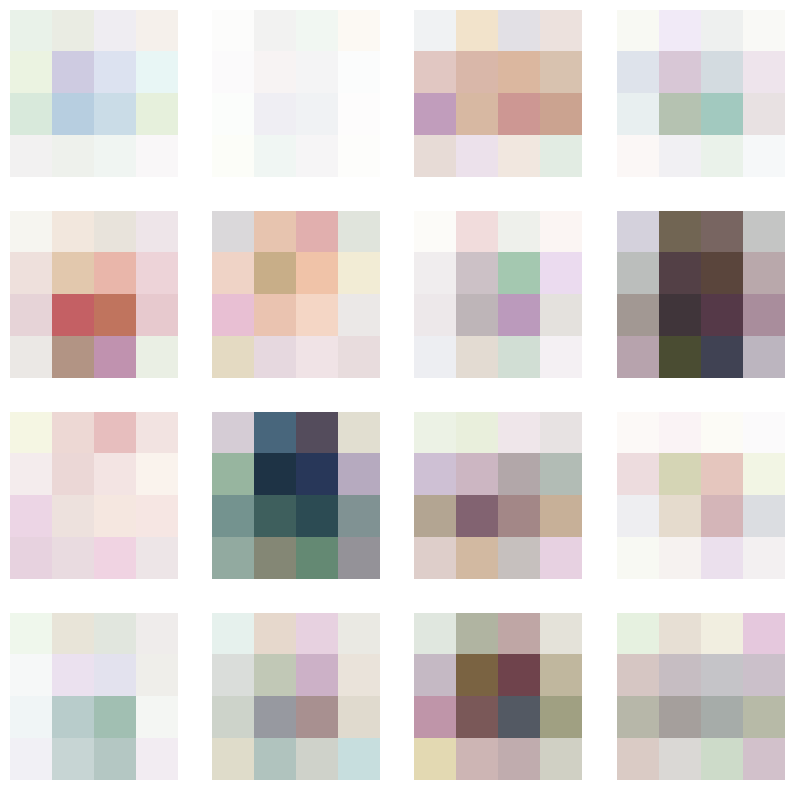

Step: 403
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8488408923149109
Generator loss: 2.0220603942871094


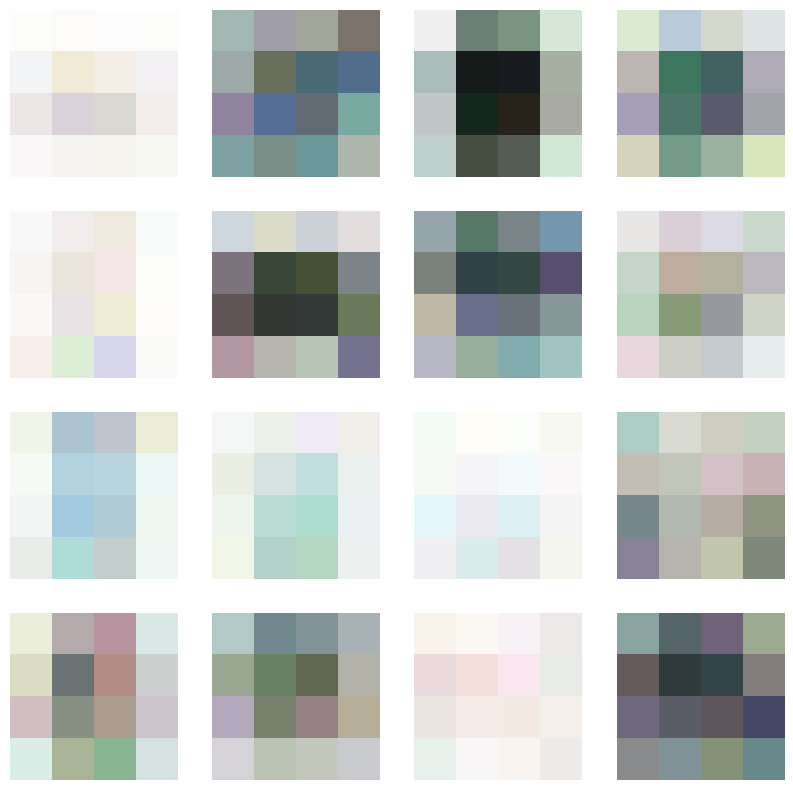

Step: 404
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8469991087913513
Generator loss: 2.0177605152130127


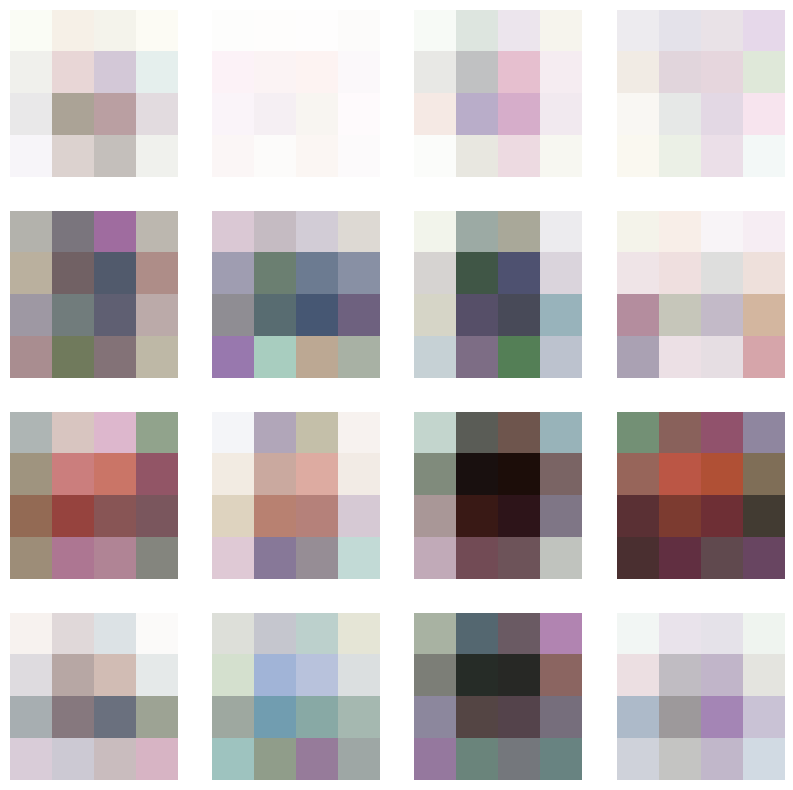

Step: 405
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8451696038246155
Generator loss: 2.013084888458252


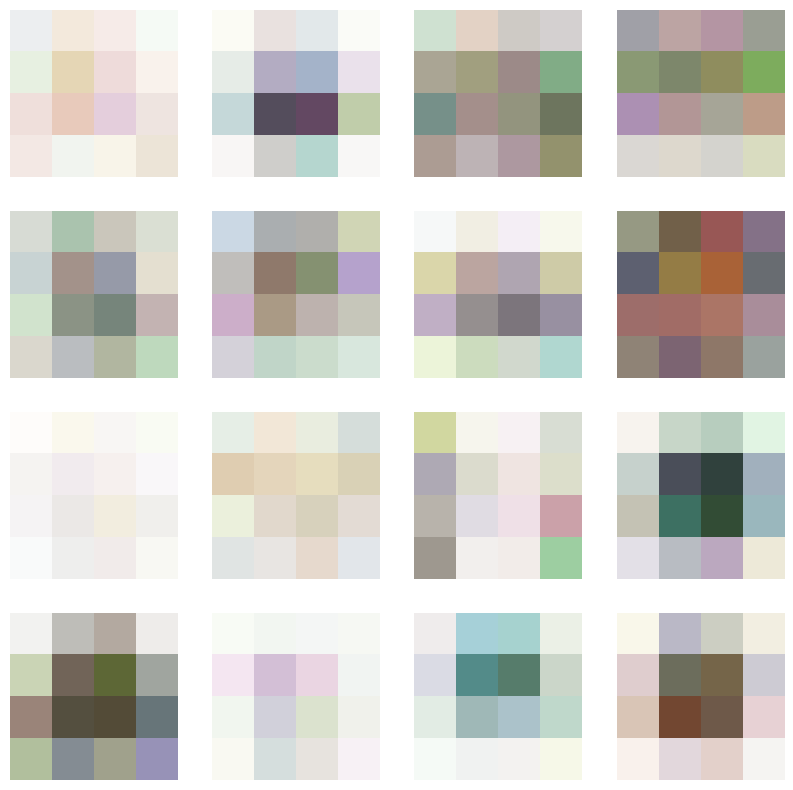

Step: 406
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8436435461044312
Generator loss: 2.0079233646392822


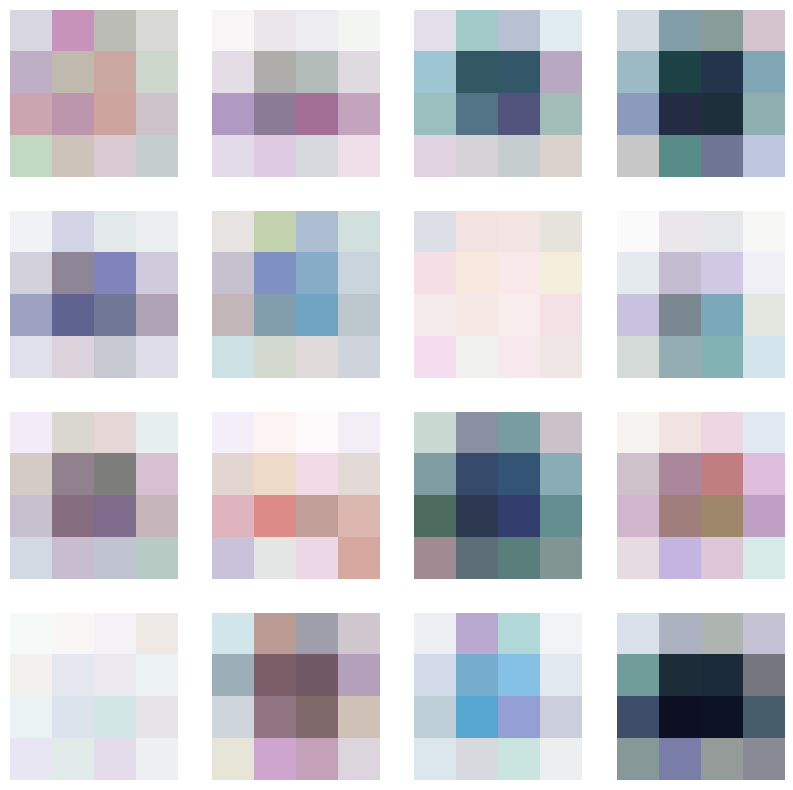

Step: 407
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8423182964324951
Generator loss: 2.002612590789795


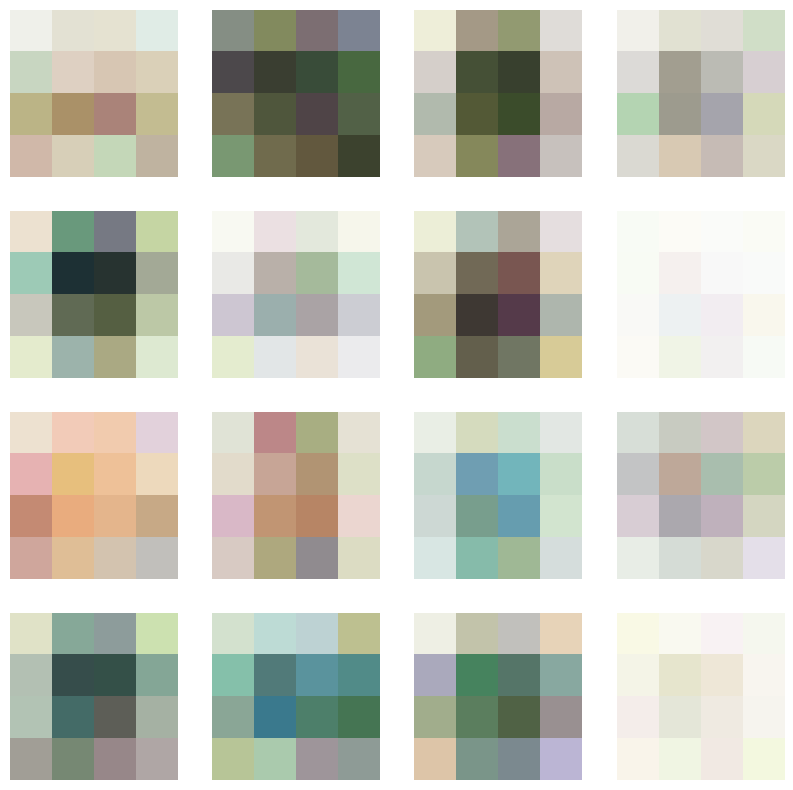

Step: 408
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8408066630363464
Generator loss: 1.9974497556686401


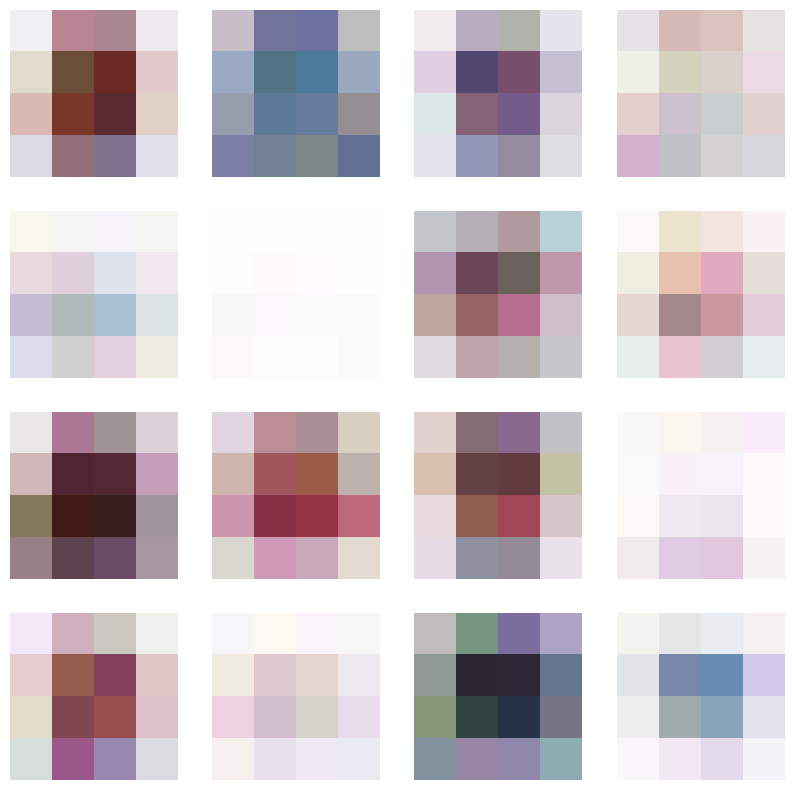

Step: 409
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8391684889793396
Generator loss: 1.9936473369598389


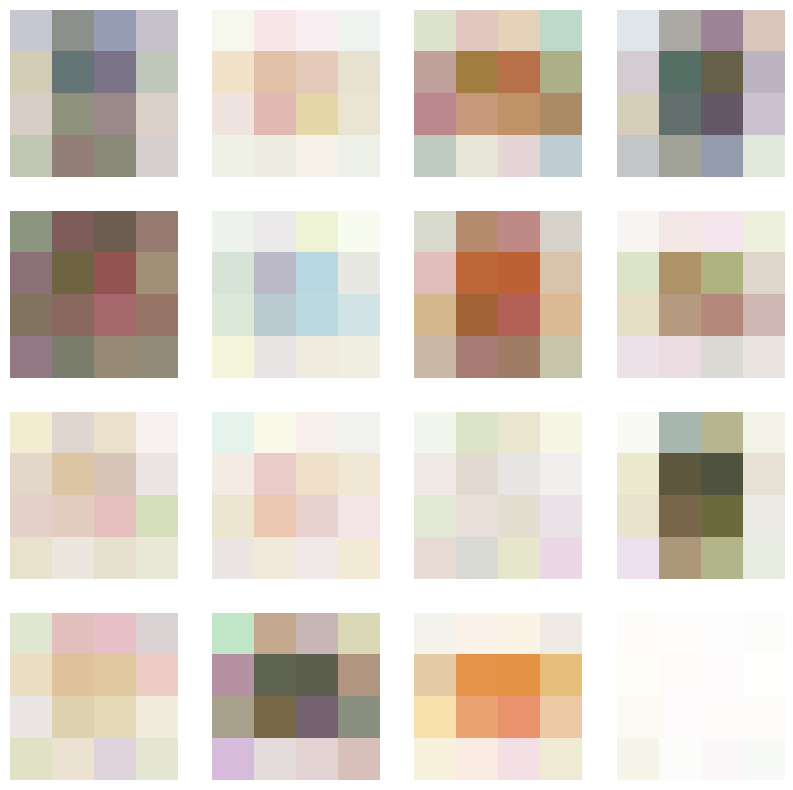

Step: 410
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.837779700756073
Generator loss: 1.990450143814087


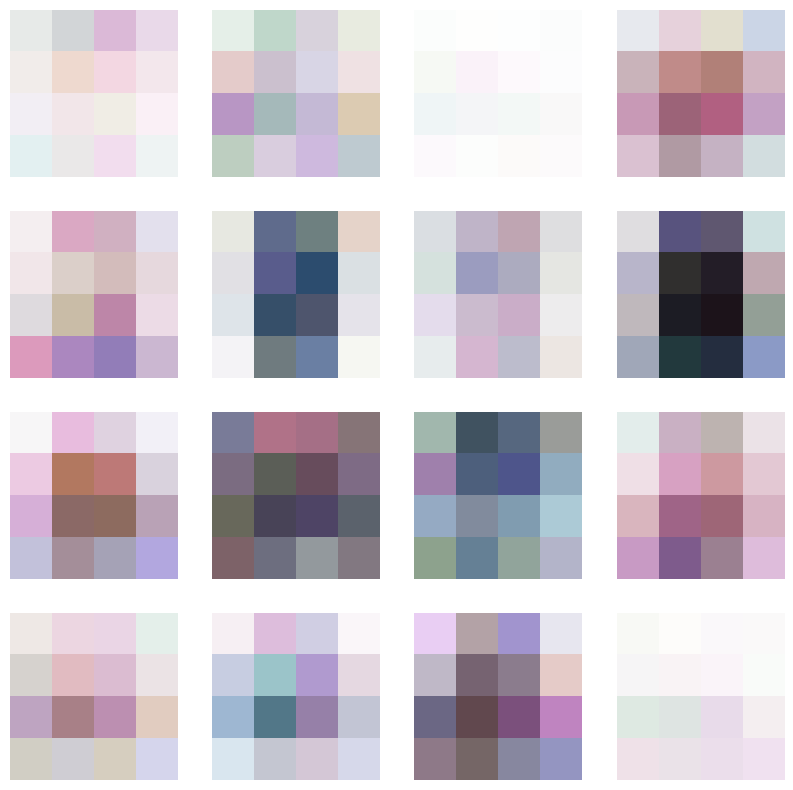

Step: 411
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8363054990768433
Generator loss: 1.9855287075042725


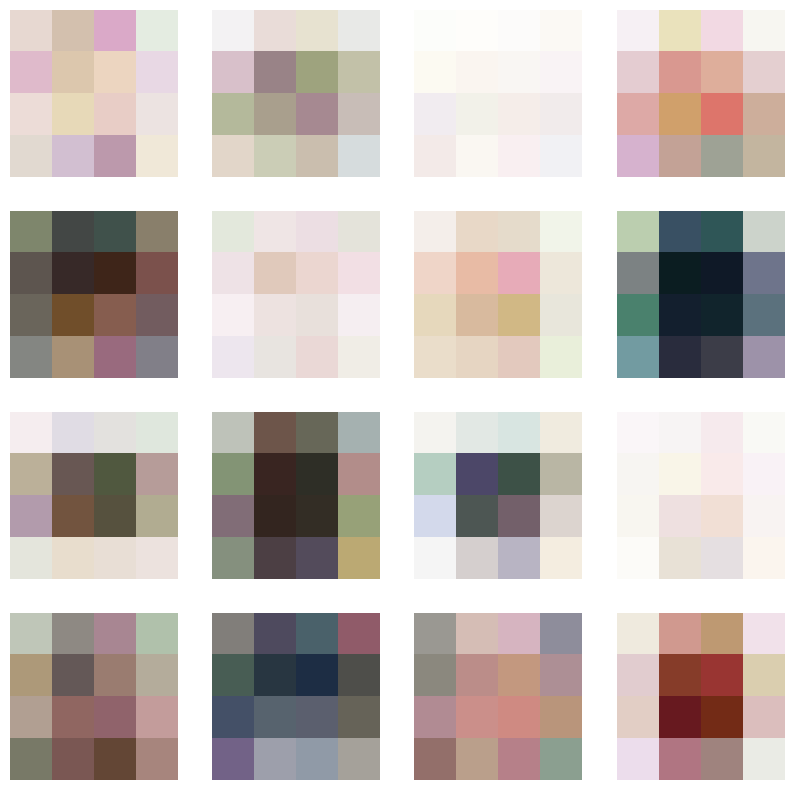

Step: 412
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8345755338668823
Generator loss: 1.9804558753967285


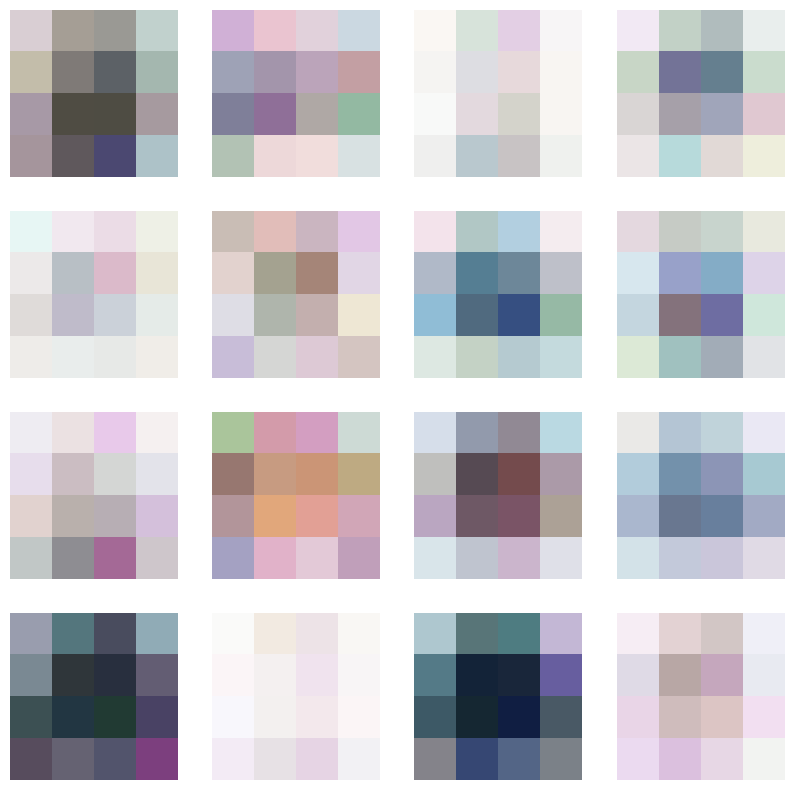

Step: 413
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.833013653755188
Generator loss: 1.974544644355774


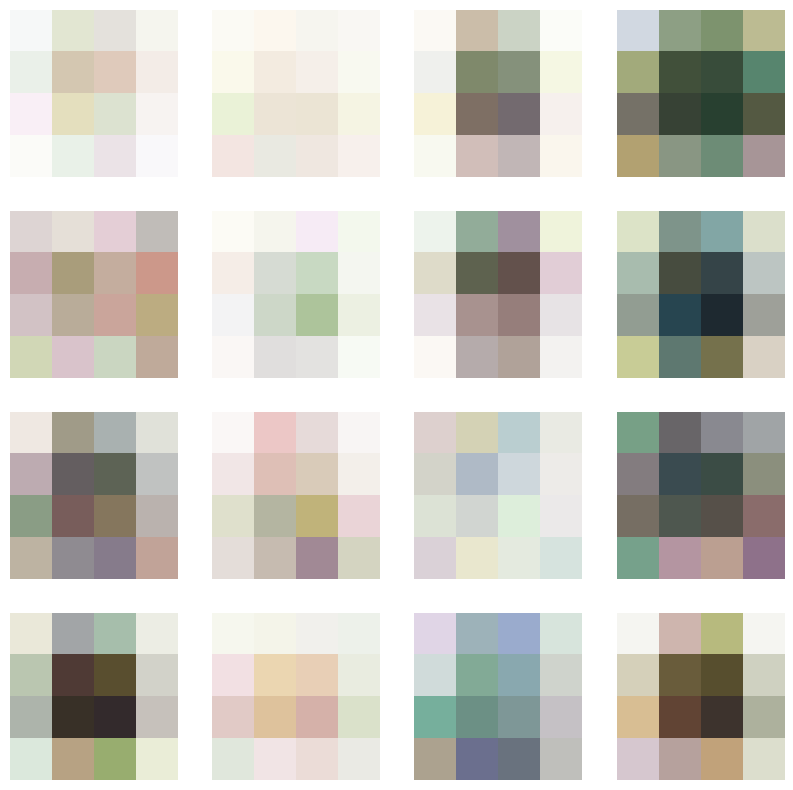

Step: 414
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8316642045974731
Generator loss: 1.9686599969863892


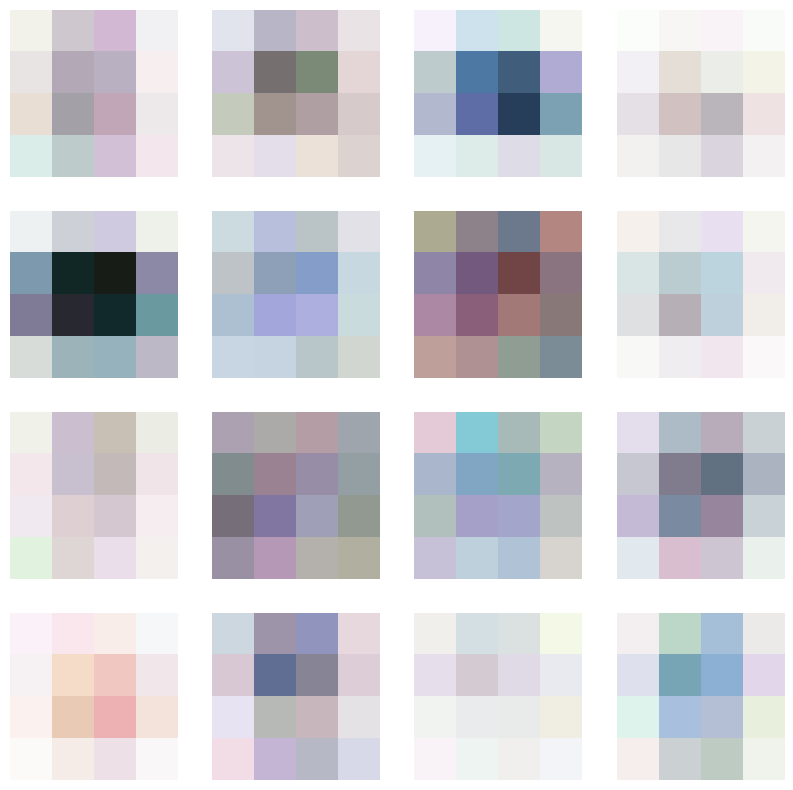

Step: 415
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8296800255775452
Generator loss: 1.9643670320510864


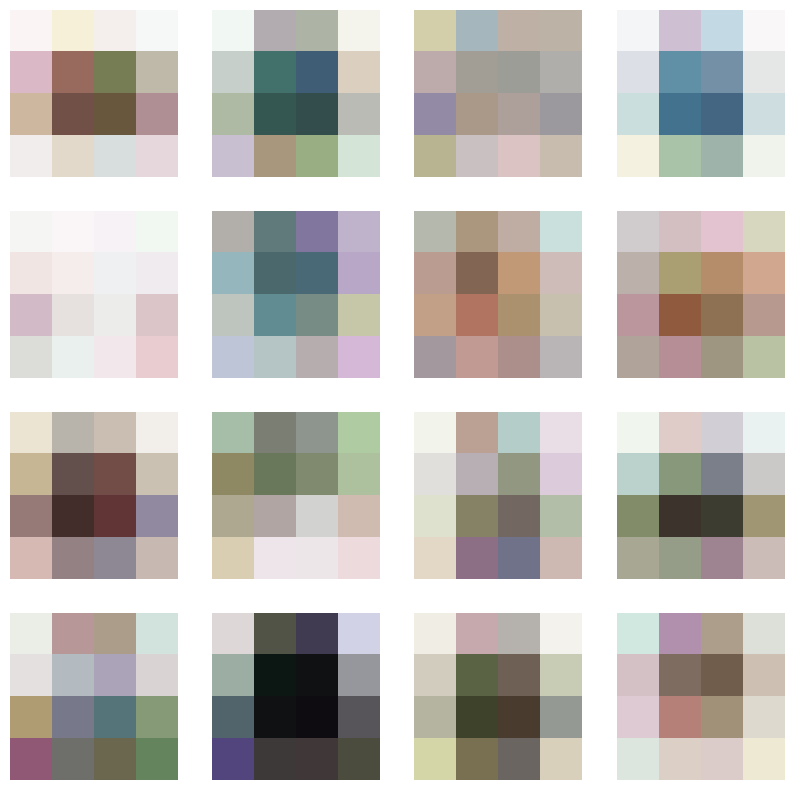

Step: 416
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.828411340713501
Generator loss: 1.9612964391708374


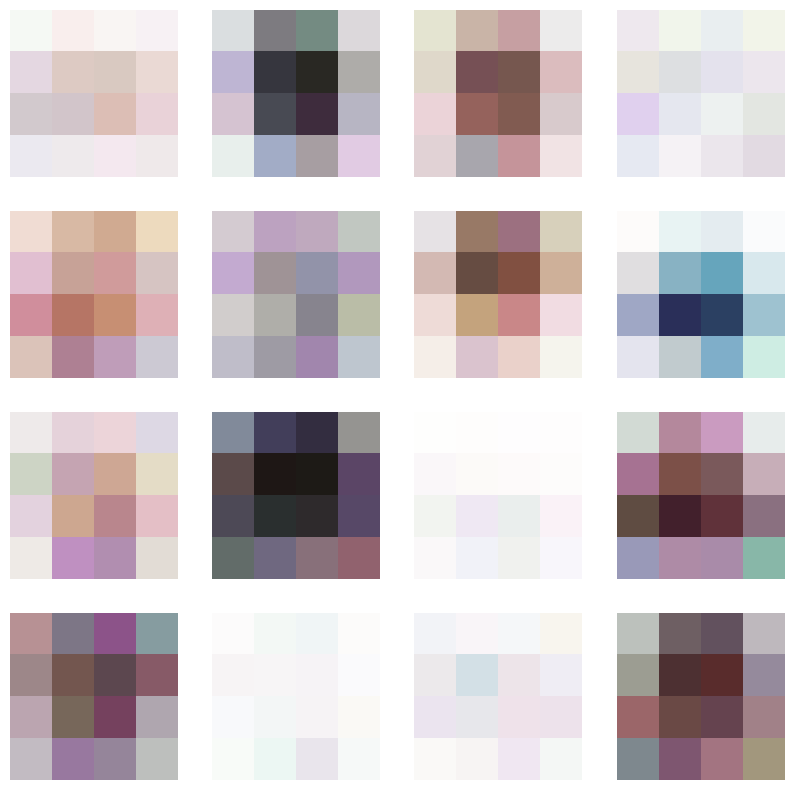

Step: 417
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8264344334602356
Generator loss: 1.9565061330795288


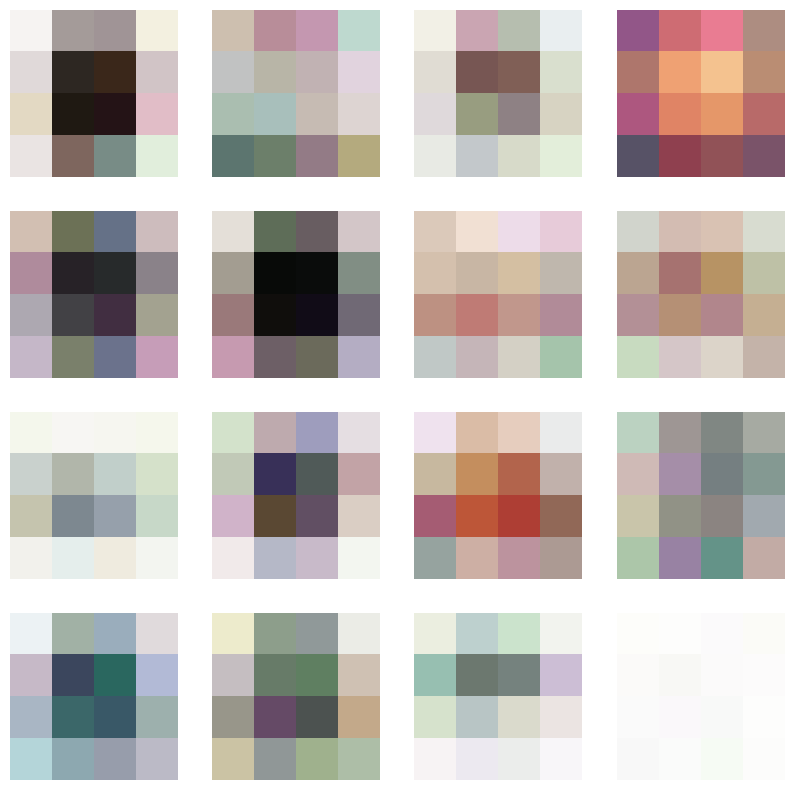

Step: 418
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8248030543327332
Generator loss: 1.9509377479553223


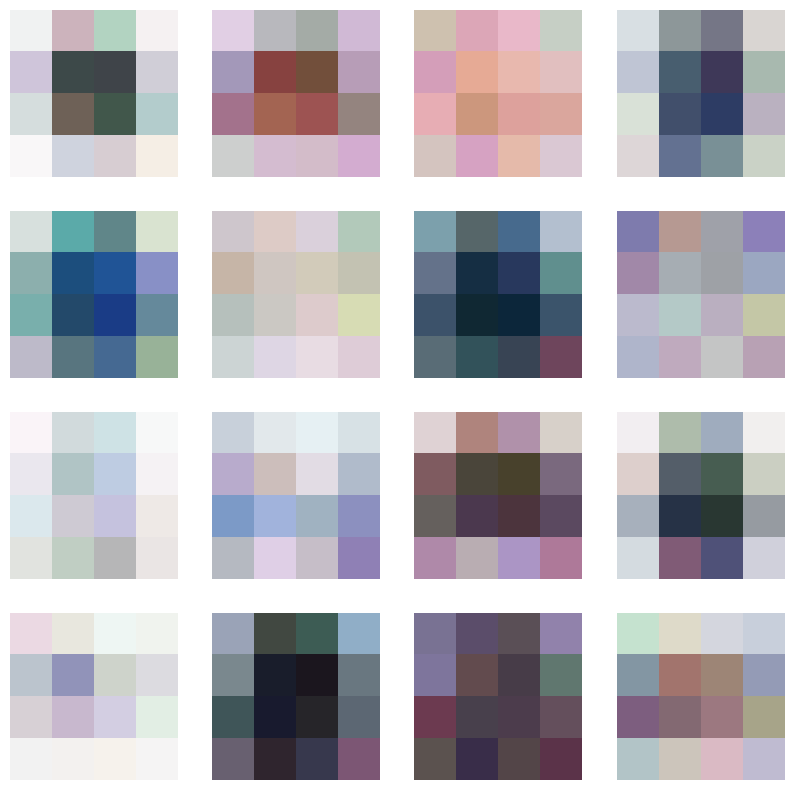

Step: 419
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8233914375305176
Generator loss: 1.9452424049377441


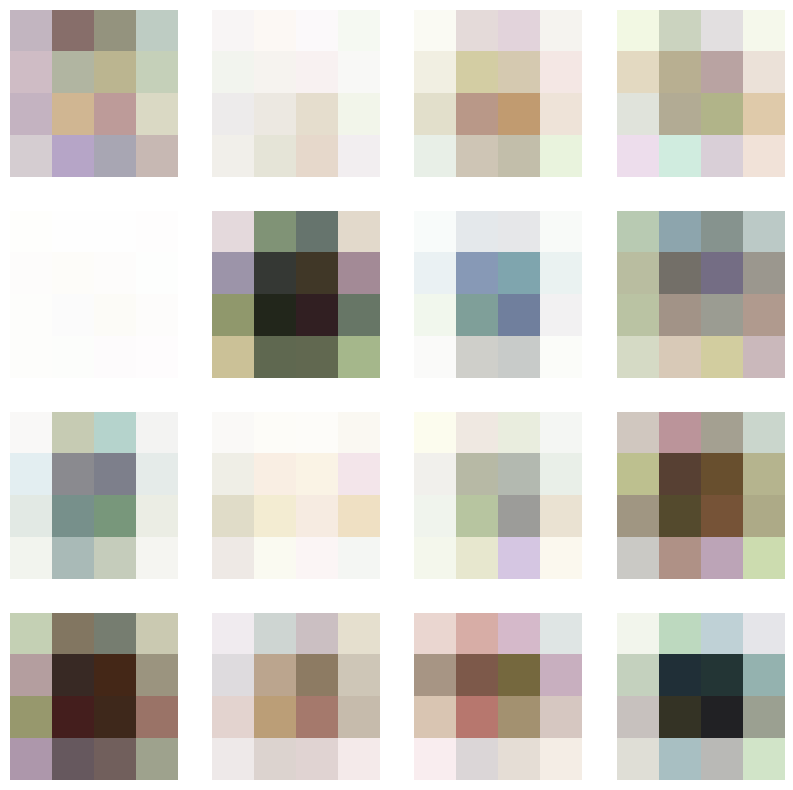

Step: 420
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8220564126968384
Generator loss: 1.9387452602386475


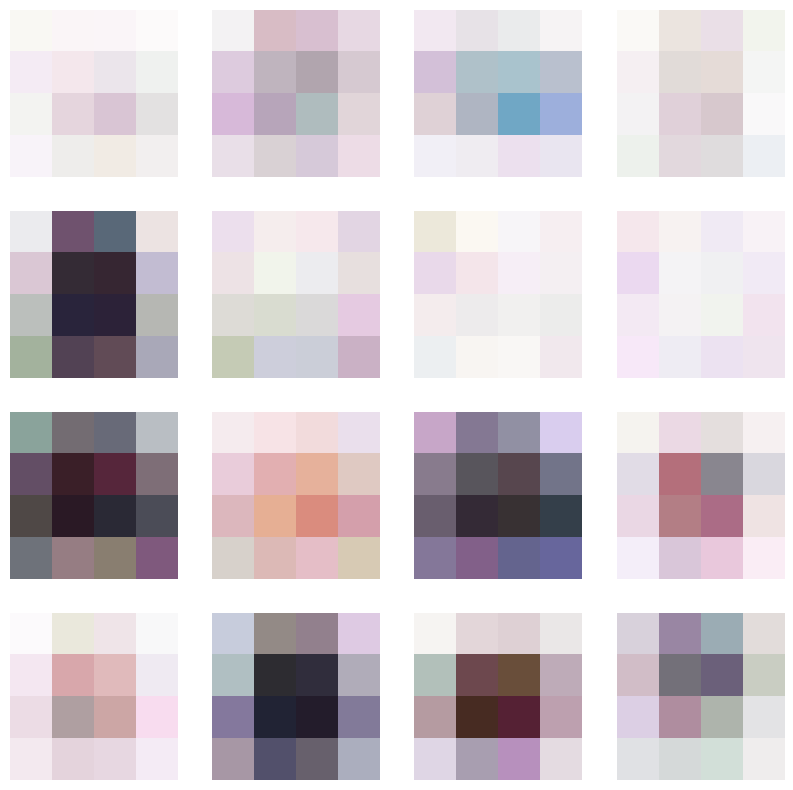

Step: 421
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8206685781478882
Generator loss: 1.9328217506408691


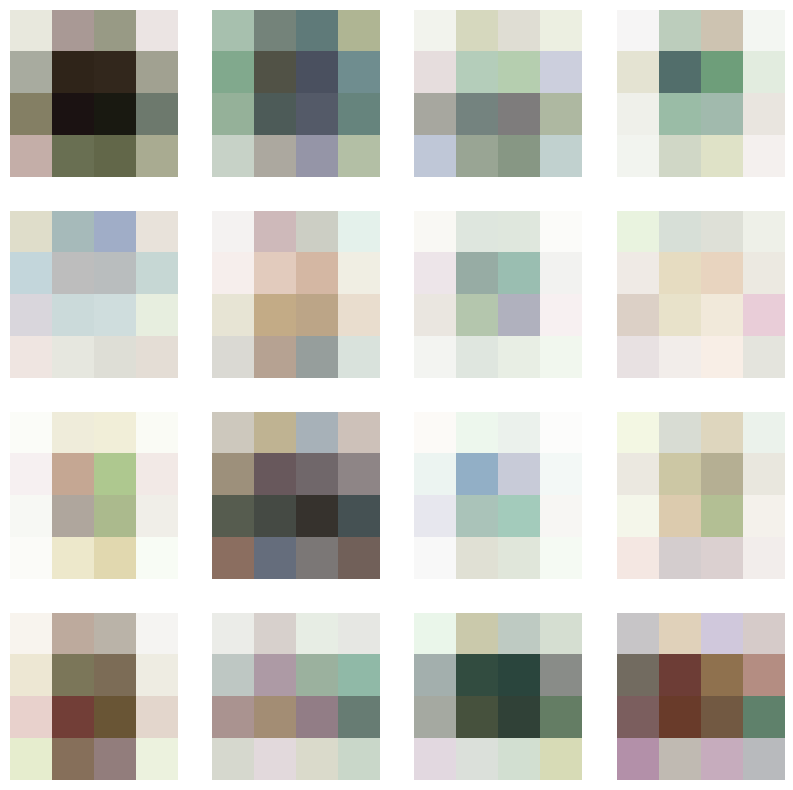

Step: 422
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8189895153045654
Generator loss: 1.9291229248046875


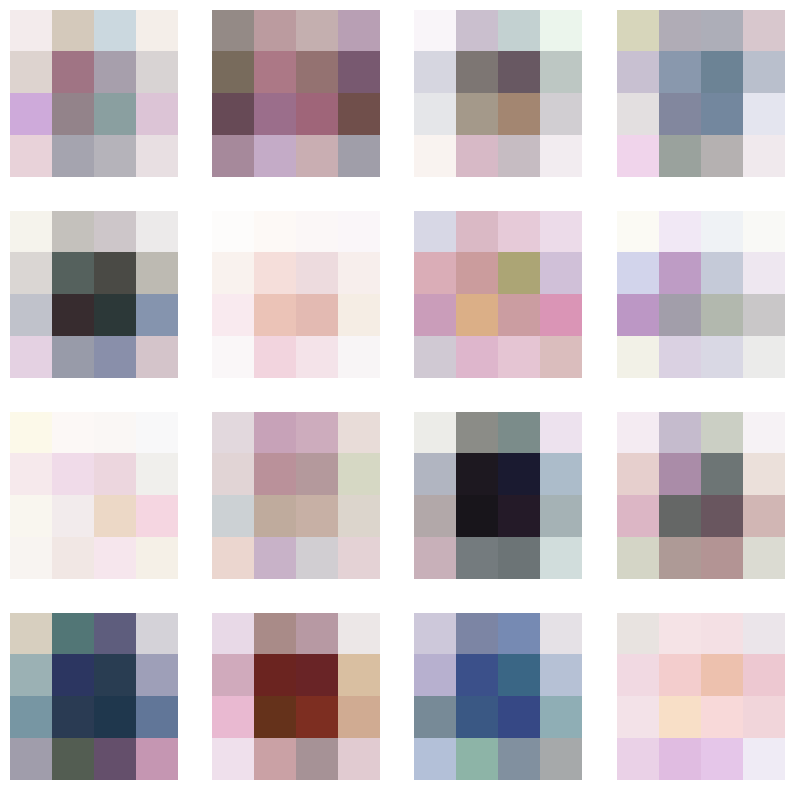

Step: 423
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8173828125
Generator loss: 1.9255120754241943


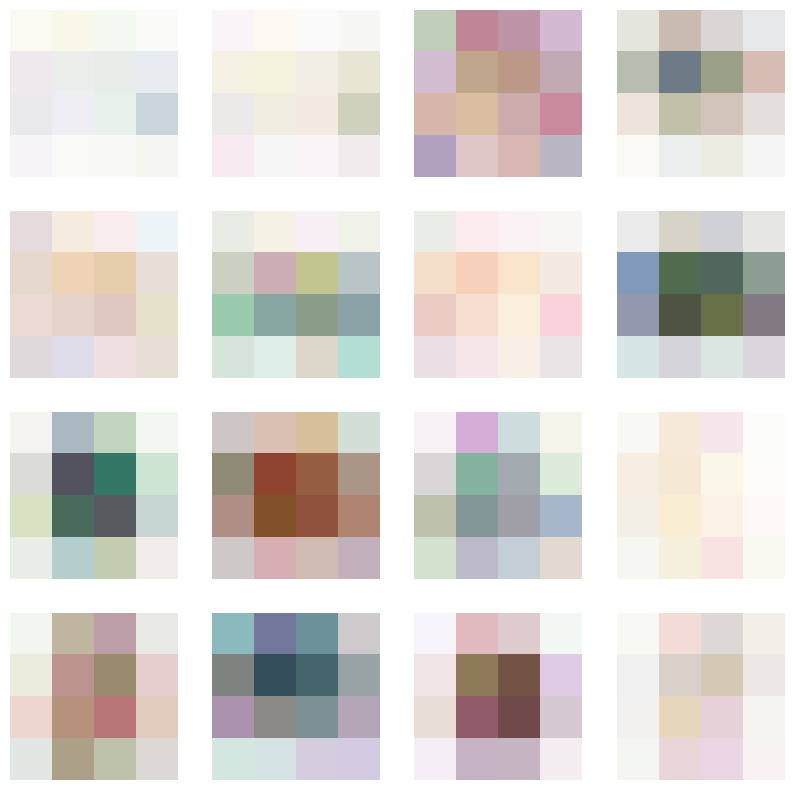

Step: 424
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8159635066986084
Generator loss: 1.9218946695327759


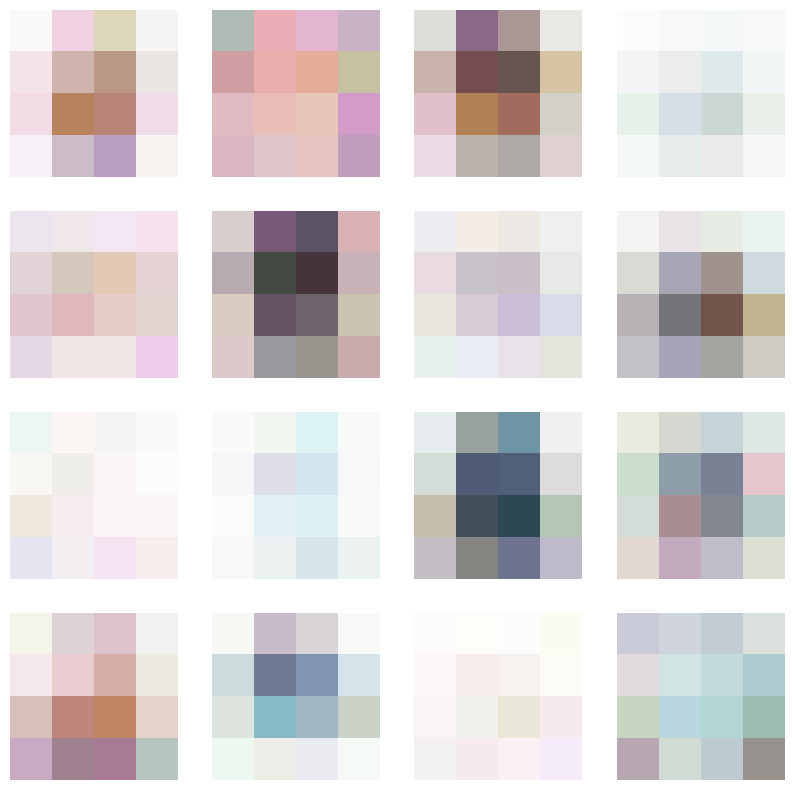

Step: 425
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8146568536758423
Generator loss: 1.9192888736724854


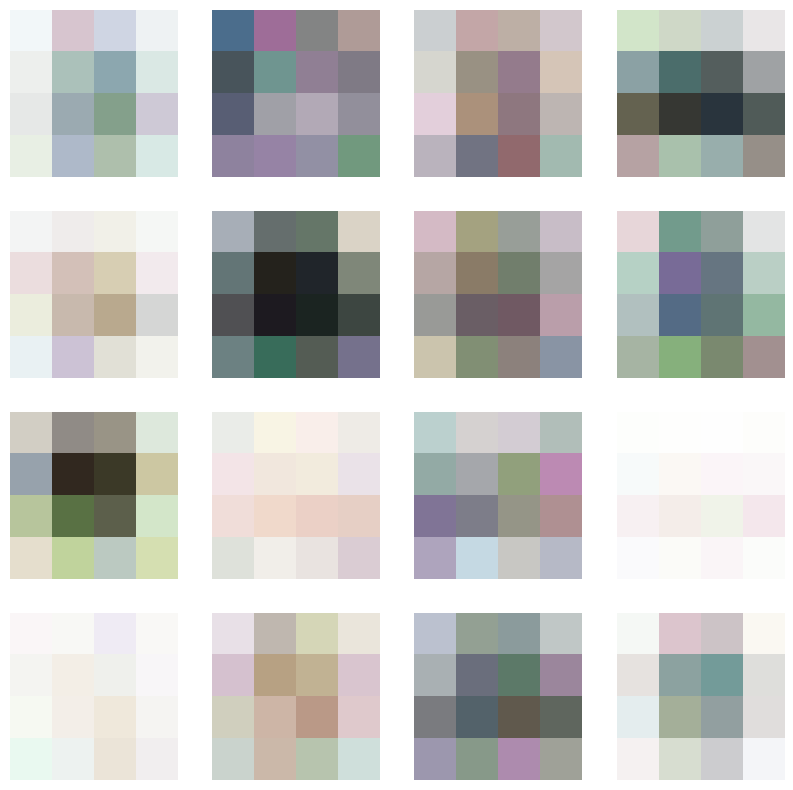

Step: 426
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8134371638298035
Generator loss: 1.9161845445632935


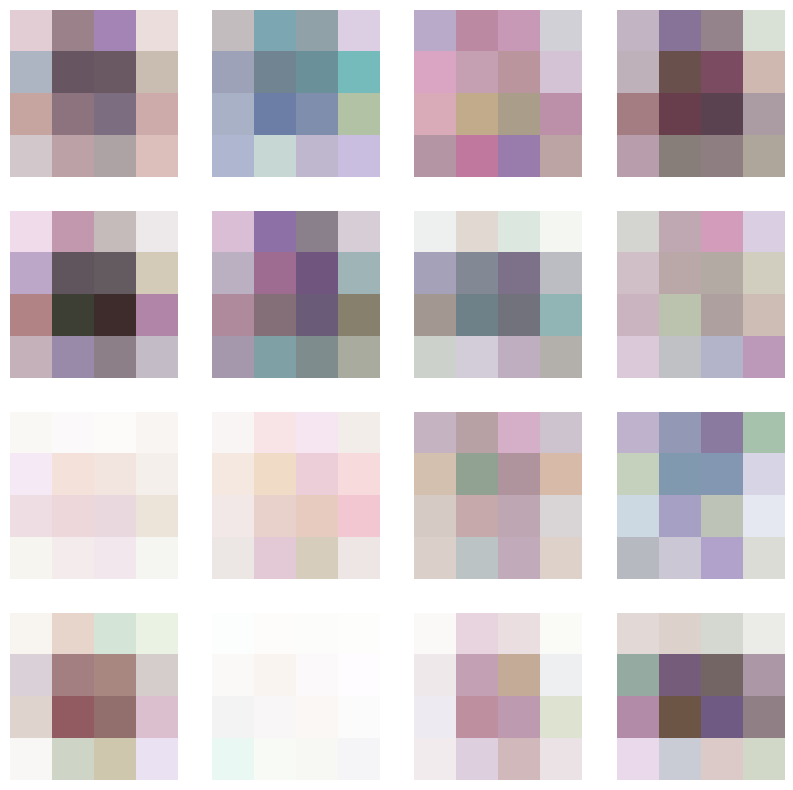

Step: 427
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8115875124931335
Generator loss: 1.911821722984314


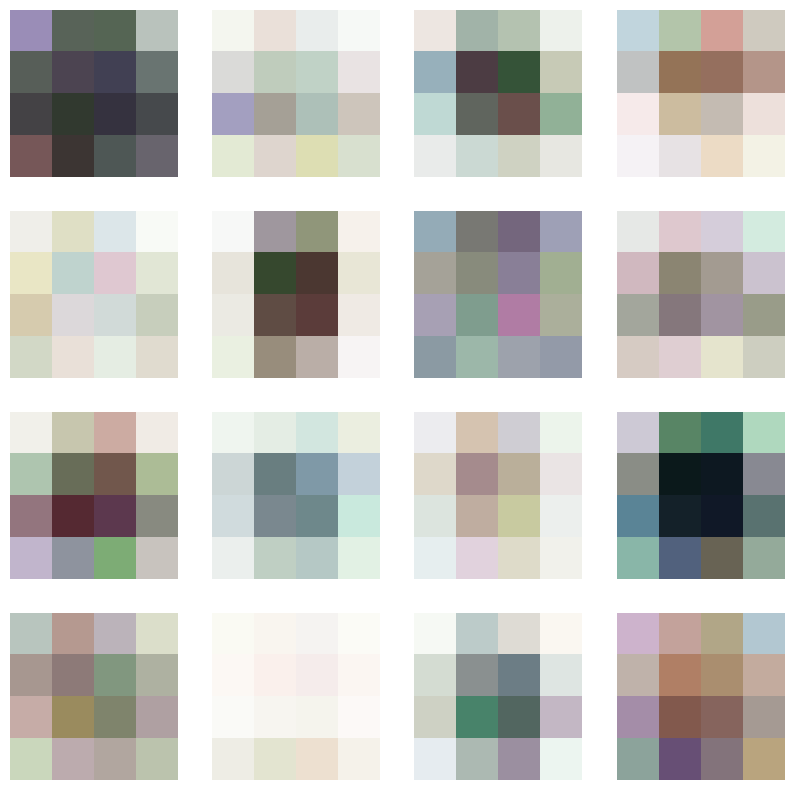

Step: 428
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8099389672279358
Generator loss: 1.9070383310317993


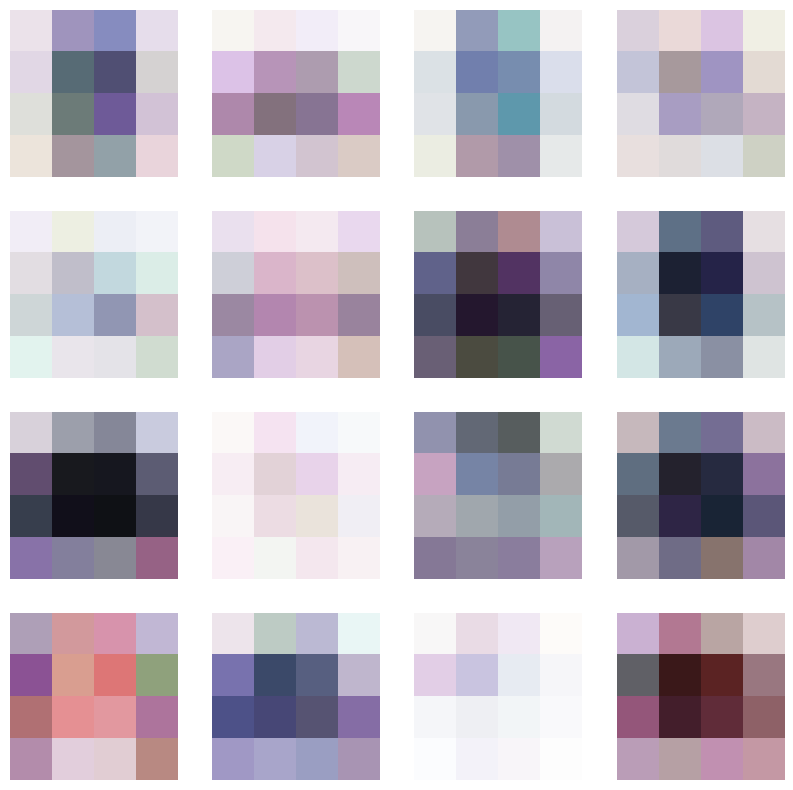

Step: 429
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8085331916809082
Generator loss: 1.9021652936935425


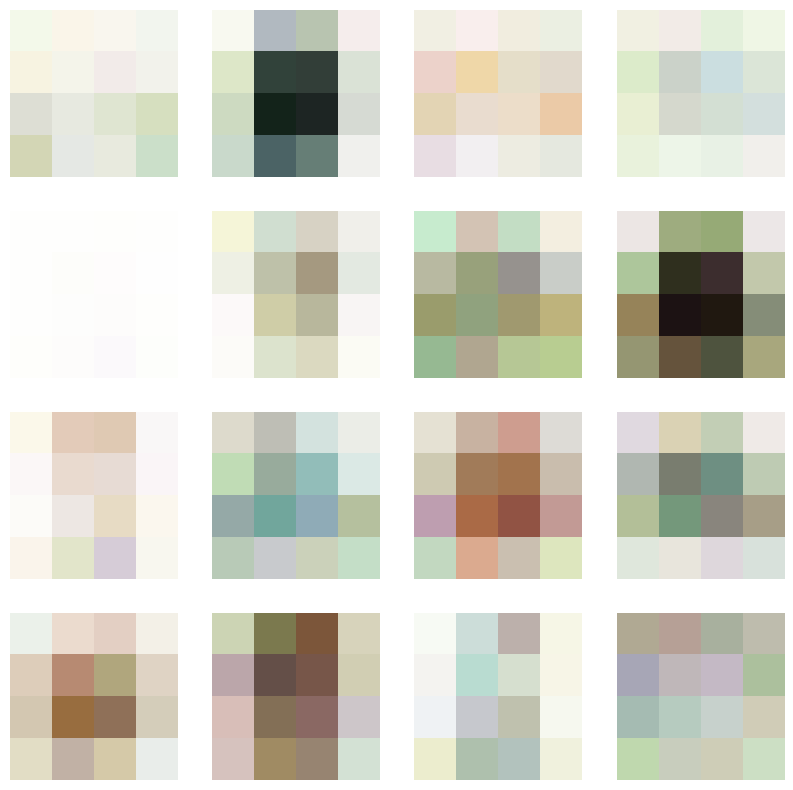

Step: 430
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.807248592376709
Generator loss: 1.8977810144424438


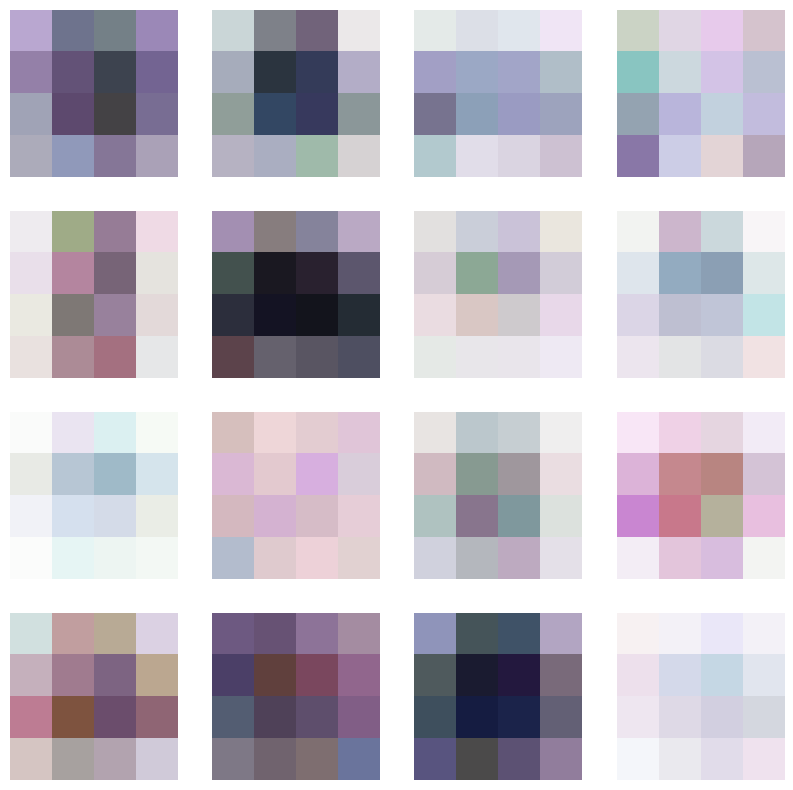

Step: 431
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8058394193649292
Generator loss: 1.8939125537872314


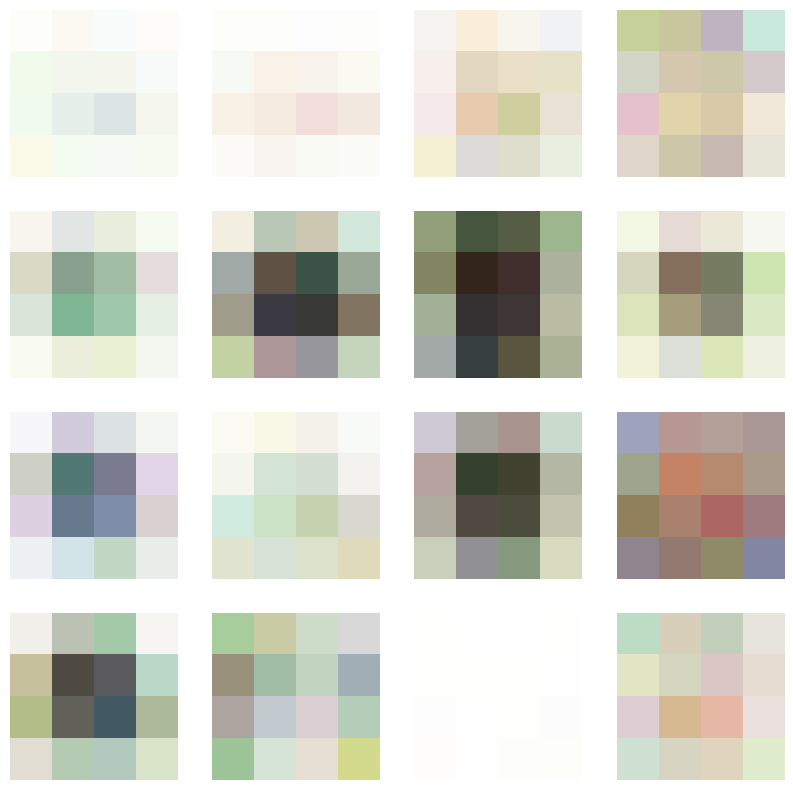

Step: 432
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8045294880867004
Generator loss: 1.8903357982635498


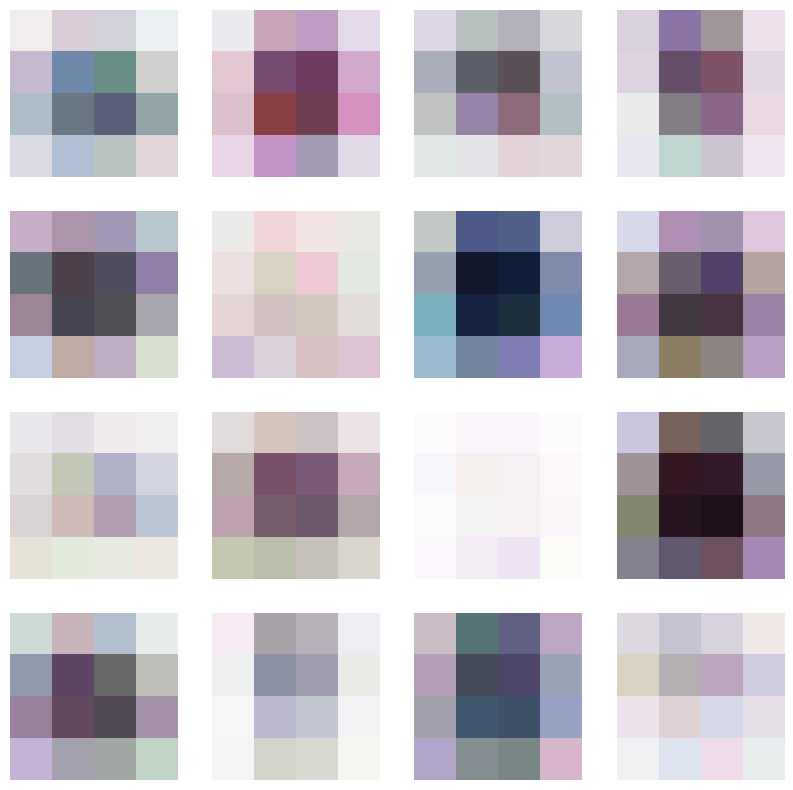

Step: 433
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8032834529876709
Generator loss: 1.8875044584274292


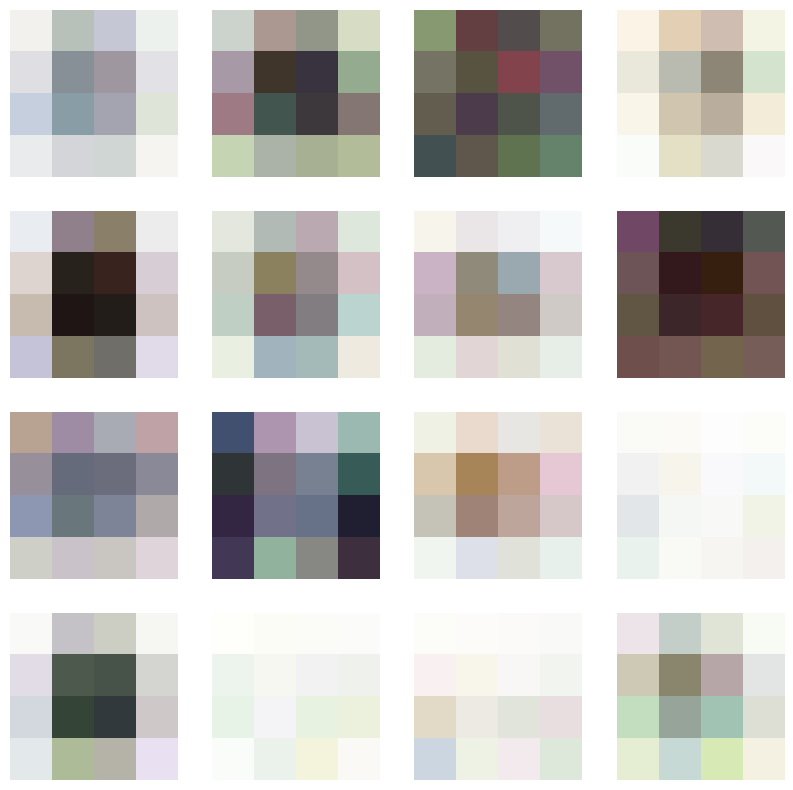

Step: 434
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8020634055137634
Generator loss: 1.8835079669952393


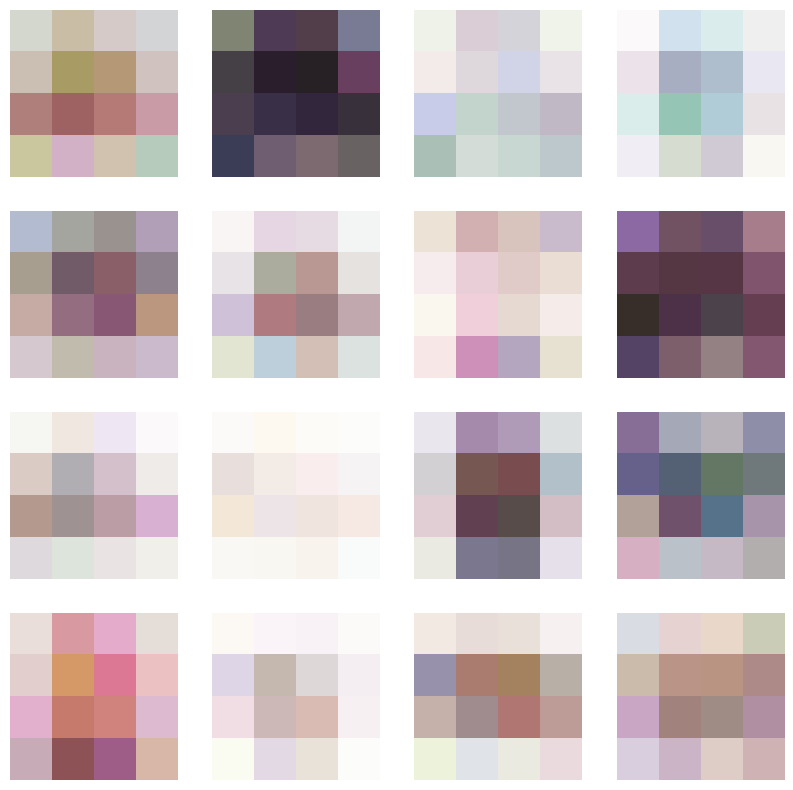

Step: 435
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.8007980585098267
Generator loss: 1.8800885677337646


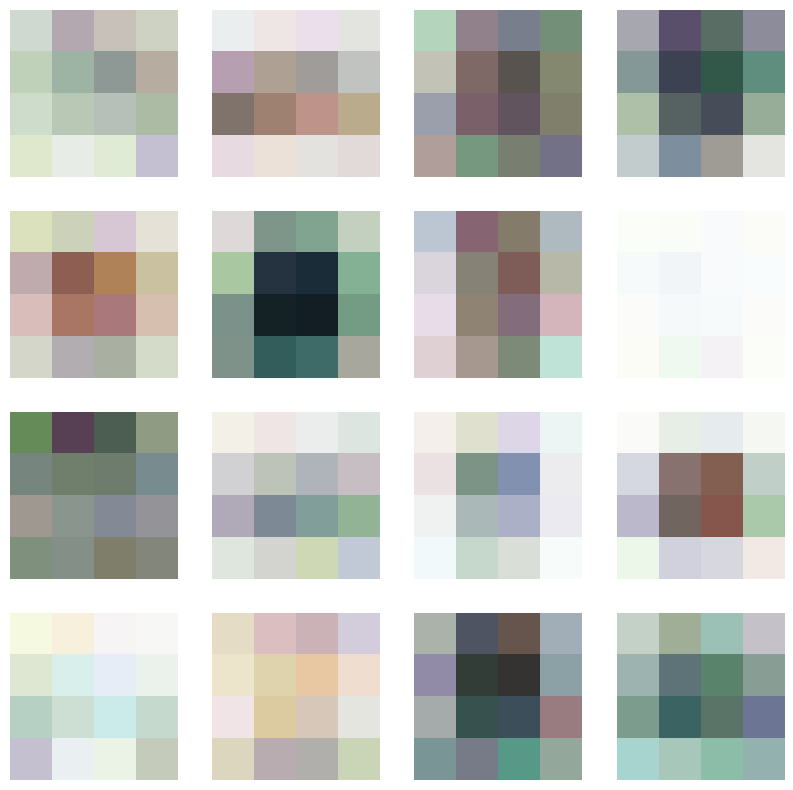

Step: 436
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7991321682929993
Generator loss: 1.875951886177063


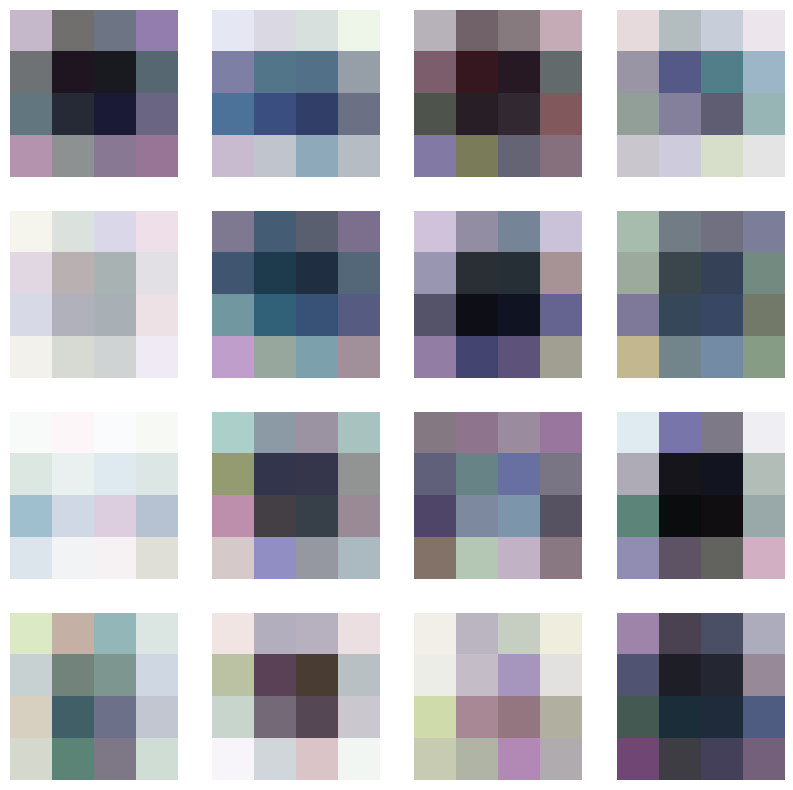

Step: 437
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7978076934814453
Generator loss: 1.8715754747390747


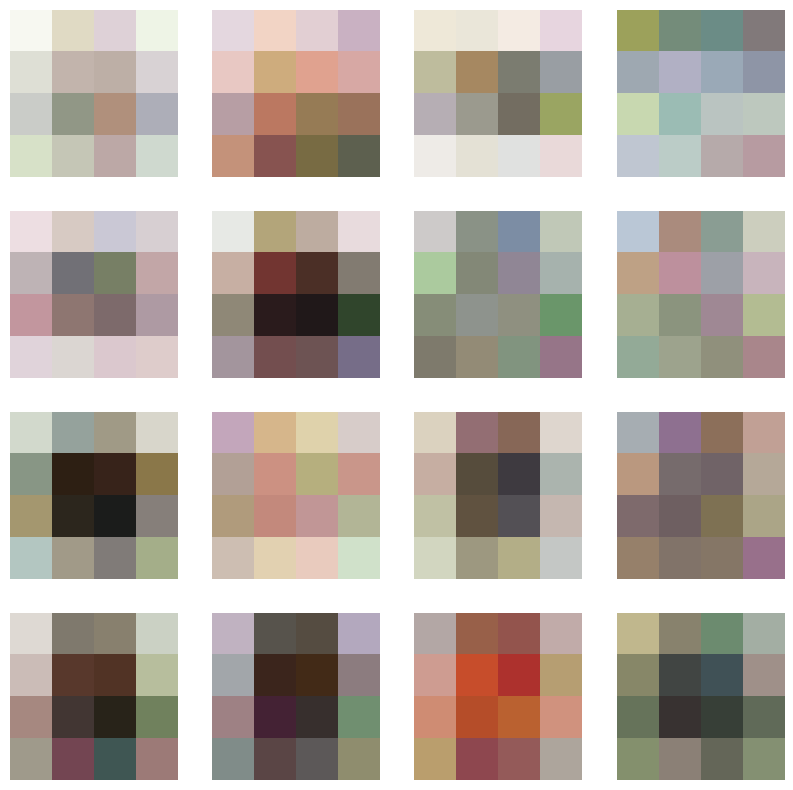

Step: 438
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7964674234390259
Generator loss: 1.867447018623352


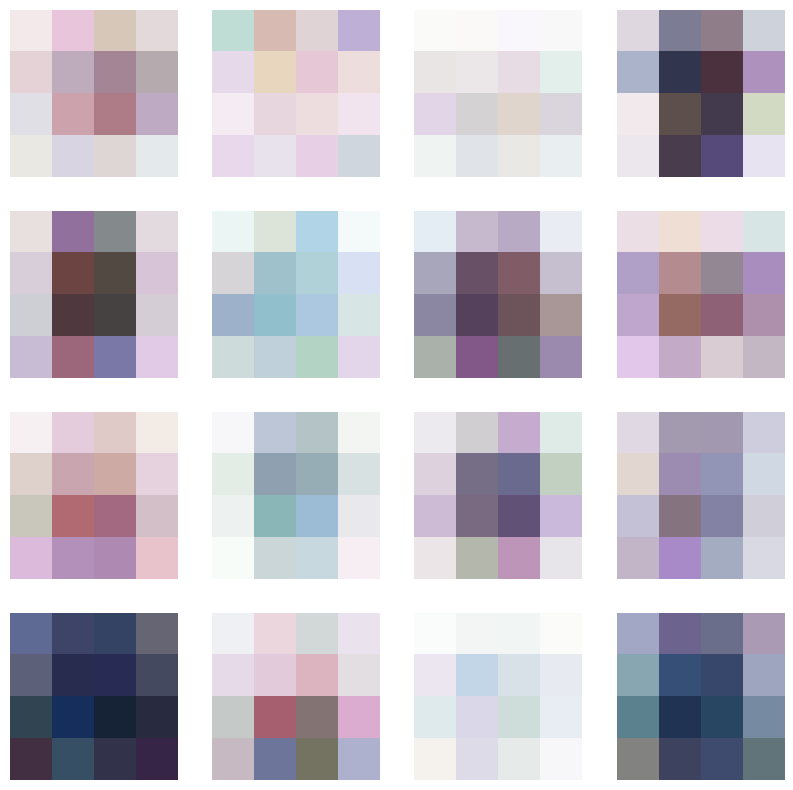

Step: 439
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7953656911849976
Generator loss: 1.8631136417388916


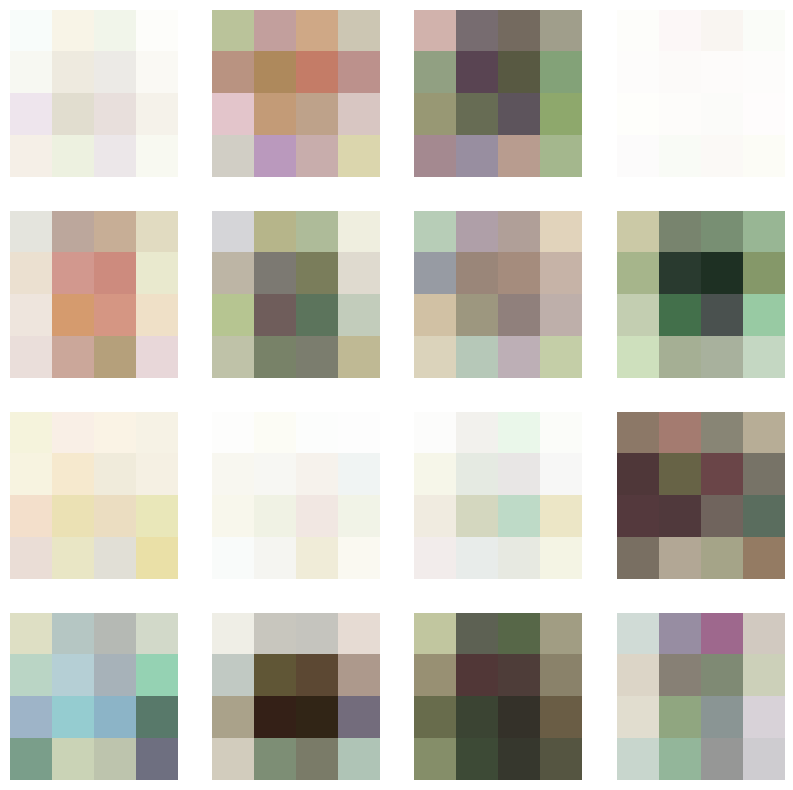

Step: 440
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.794133722782135
Generator loss: 1.8586013317108154


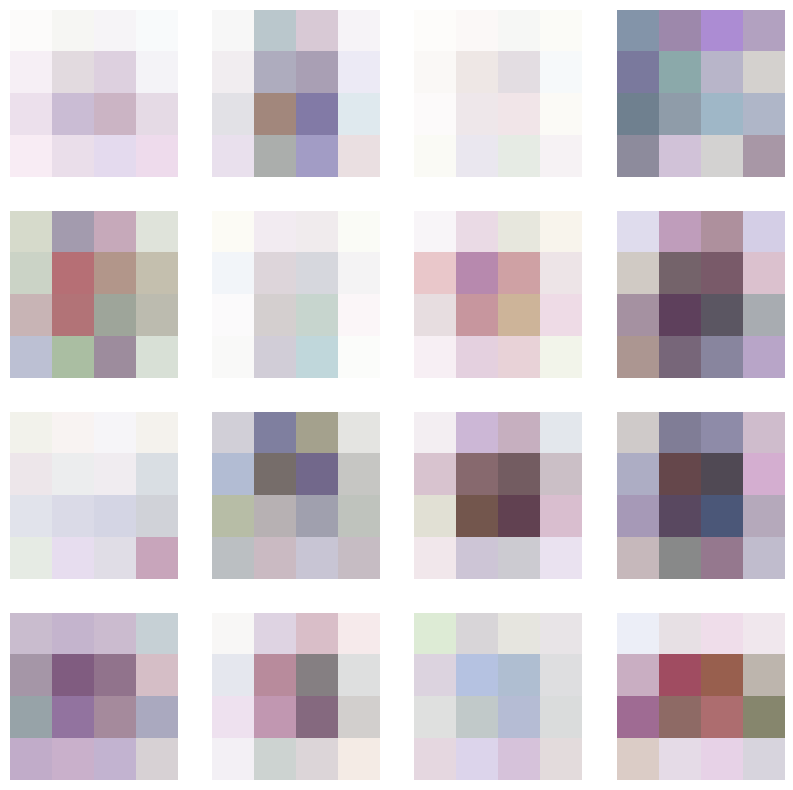

Step: 441
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7928414344787598
Generator loss: 1.8537981510162354


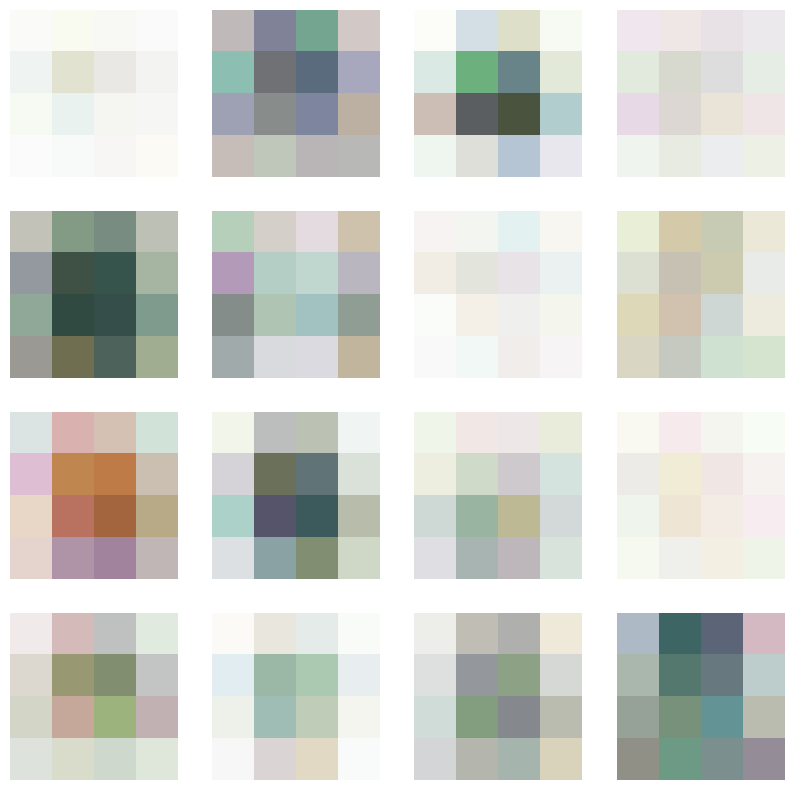

Step: 442
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.791477620601654
Generator loss: 1.8496756553649902


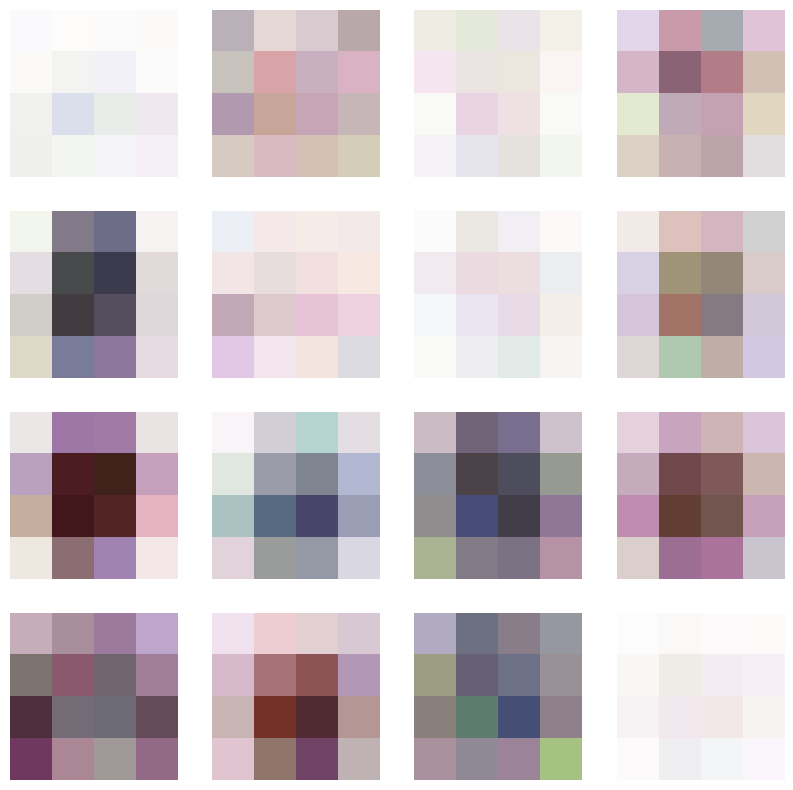

Step: 443
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7900329232215881
Generator loss: 1.8470458984375


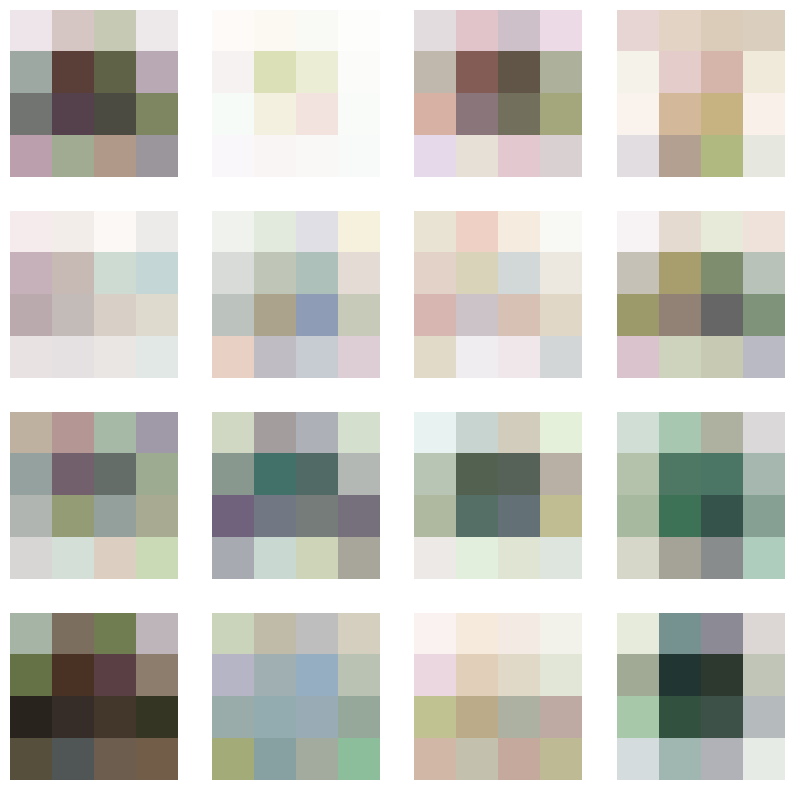

Step: 444
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7887975573539734
Generator loss: 1.8447493314743042


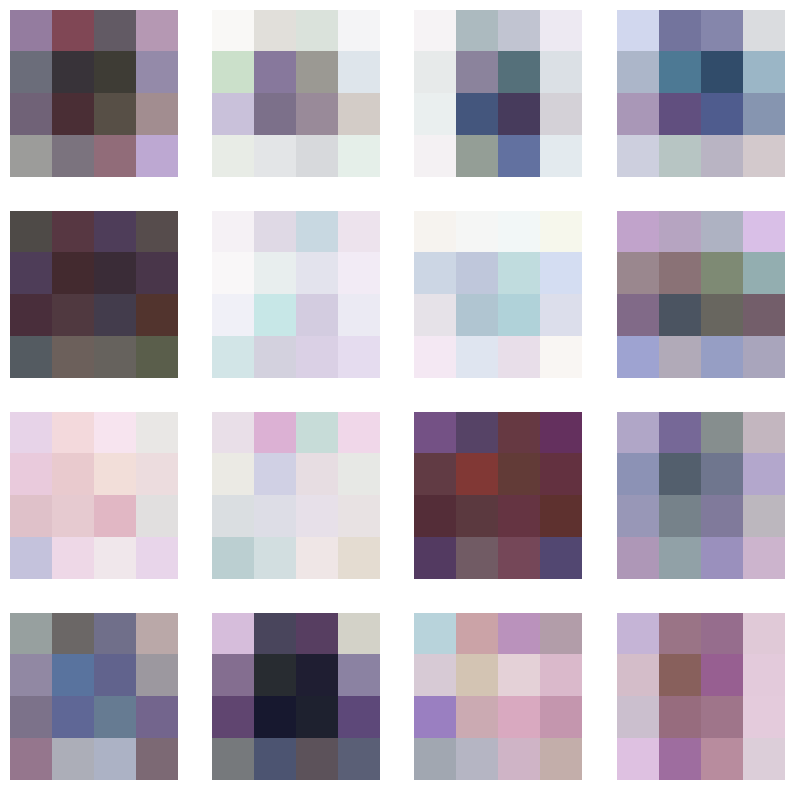

Step: 445
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7871375679969788
Generator loss: 1.840952754020691


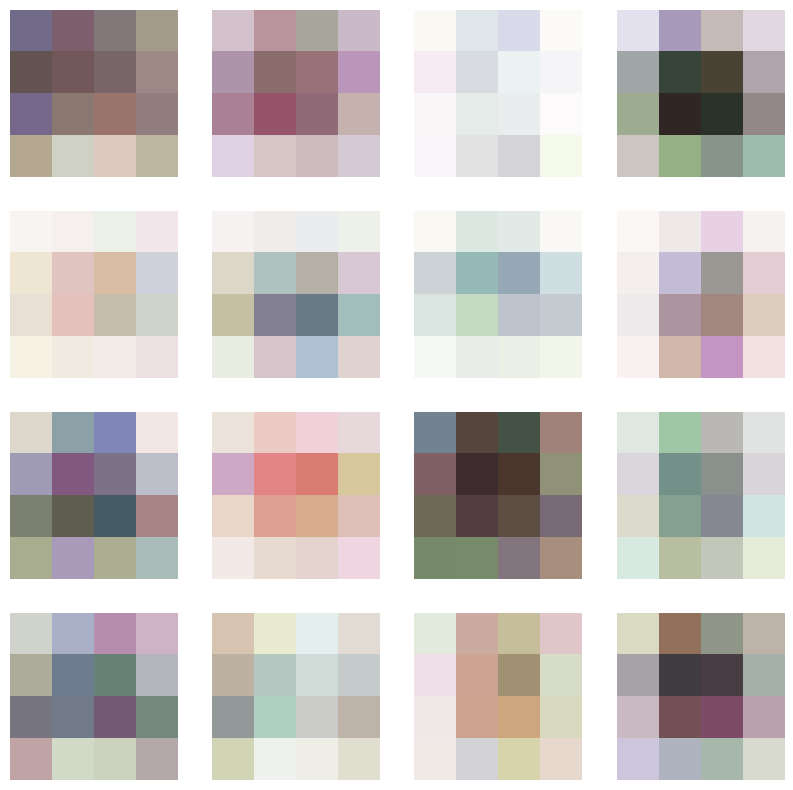

Step: 446
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7857117652893066
Generator loss: 1.837363839149475


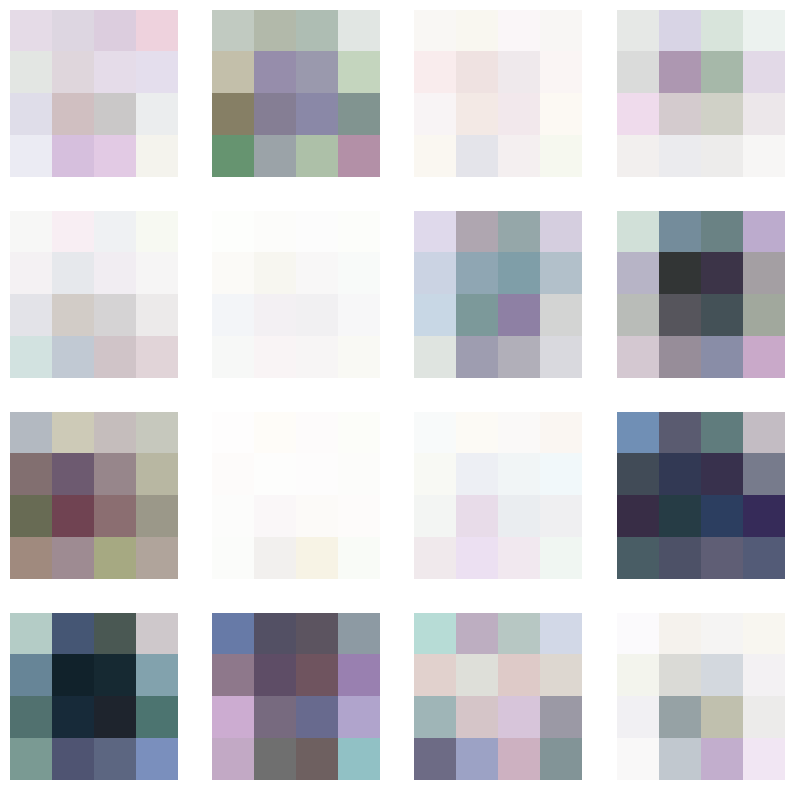

Step: 447
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.784509539604187
Generator loss: 1.833982229232788


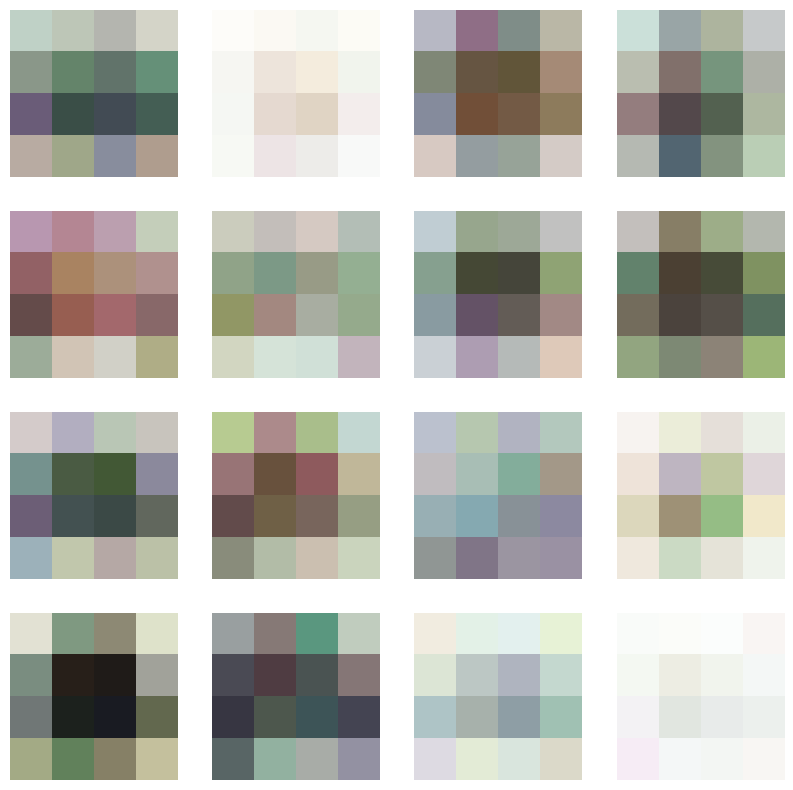

Step: 448
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7832184433937073
Generator loss: 1.8299765586853027


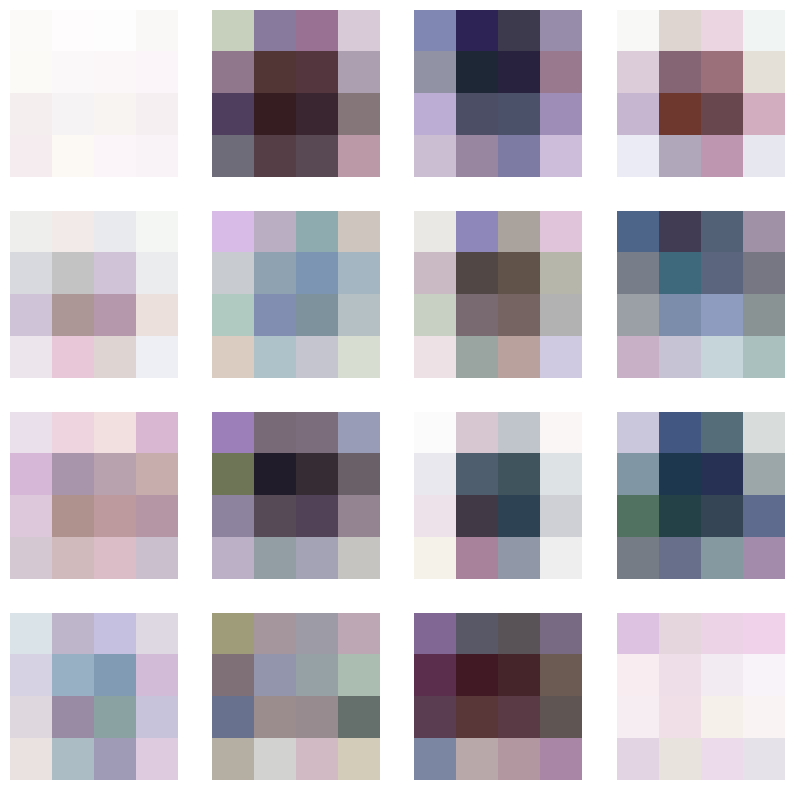

Step: 449
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7818993330001831
Generator loss: 1.8255040645599365


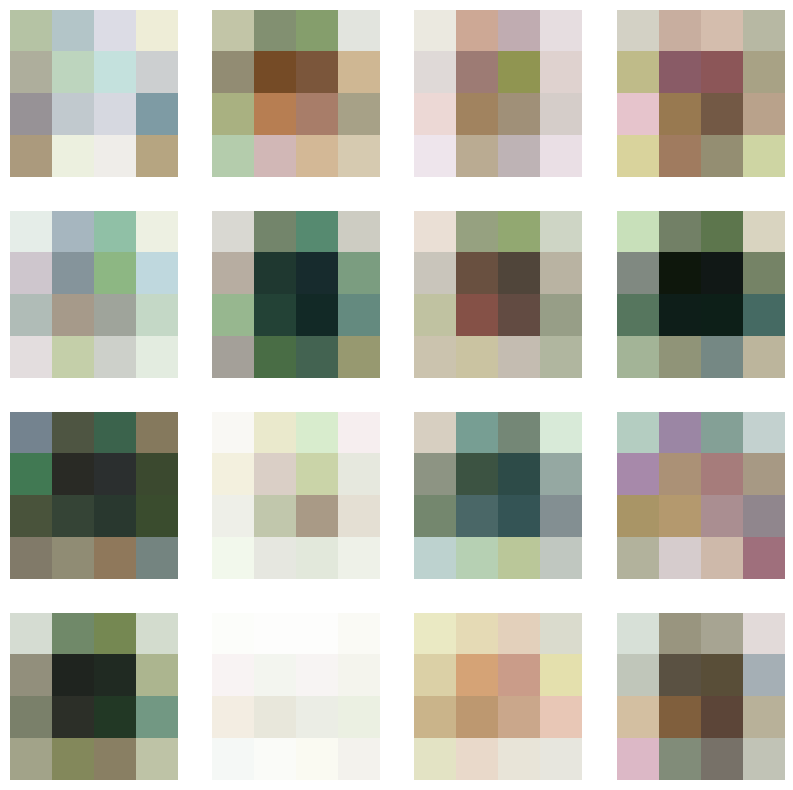

Step: 450
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7807089686393738
Generator loss: 1.8213410377502441


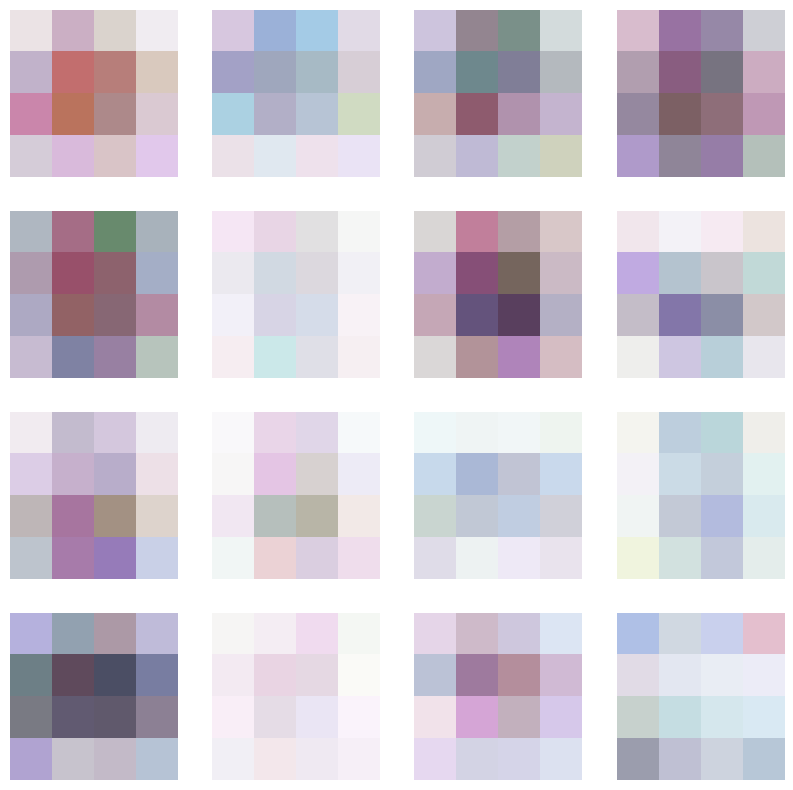

Step: 451
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.779522180557251
Generator loss: 1.8174082040786743


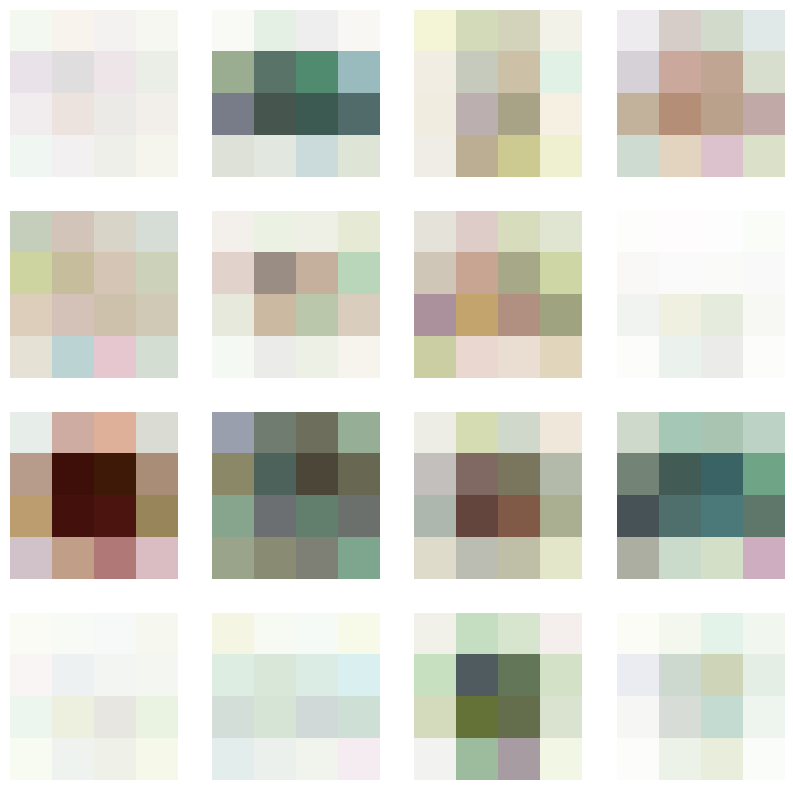

Step: 452
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7783825397491455
Generator loss: 1.812798261642456


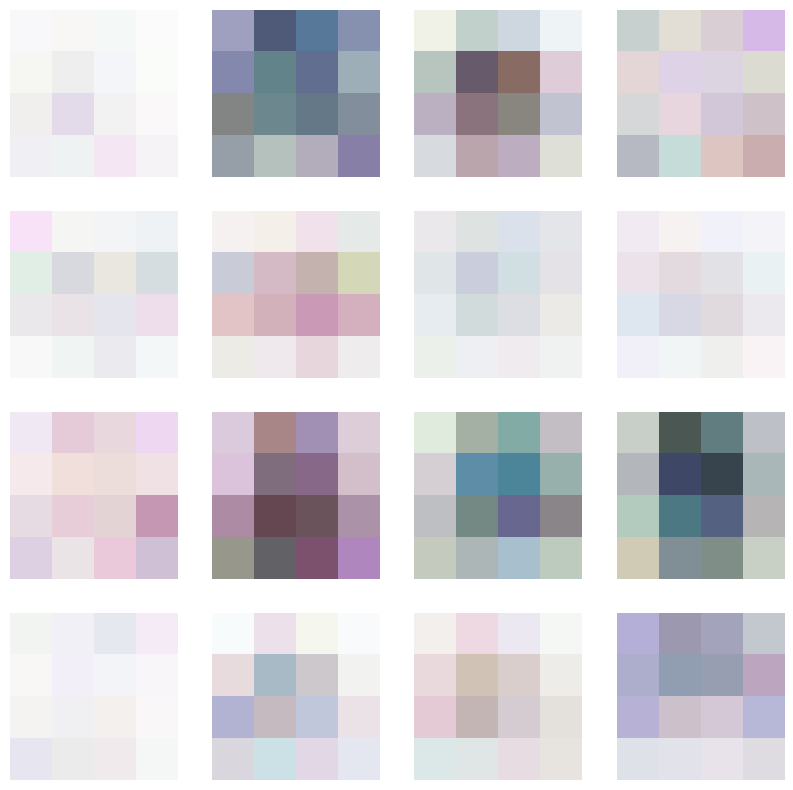

Step: 453
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7767496705055237
Generator loss: 1.8096387386322021


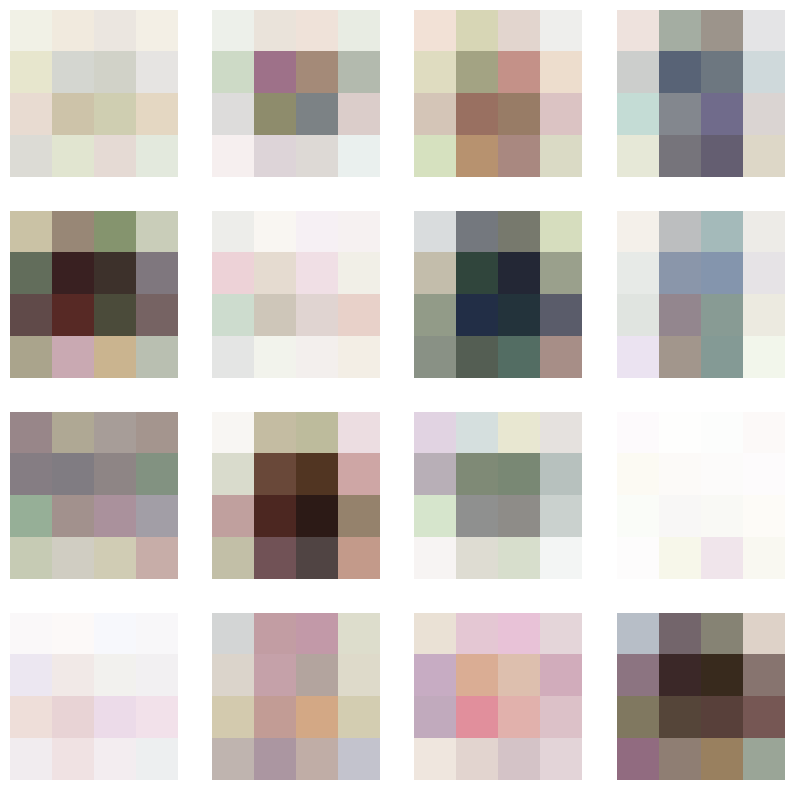

Step: 454
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7757930755615234
Generator loss: 1.8071104288101196


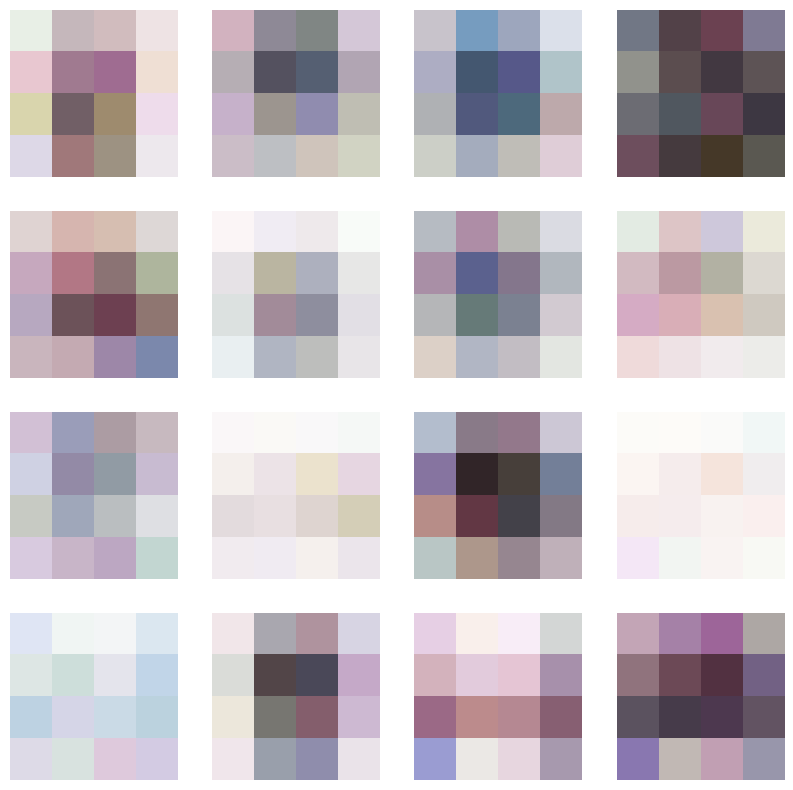

Step: 455
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7735918164253235
Generator loss: 1.803056001663208


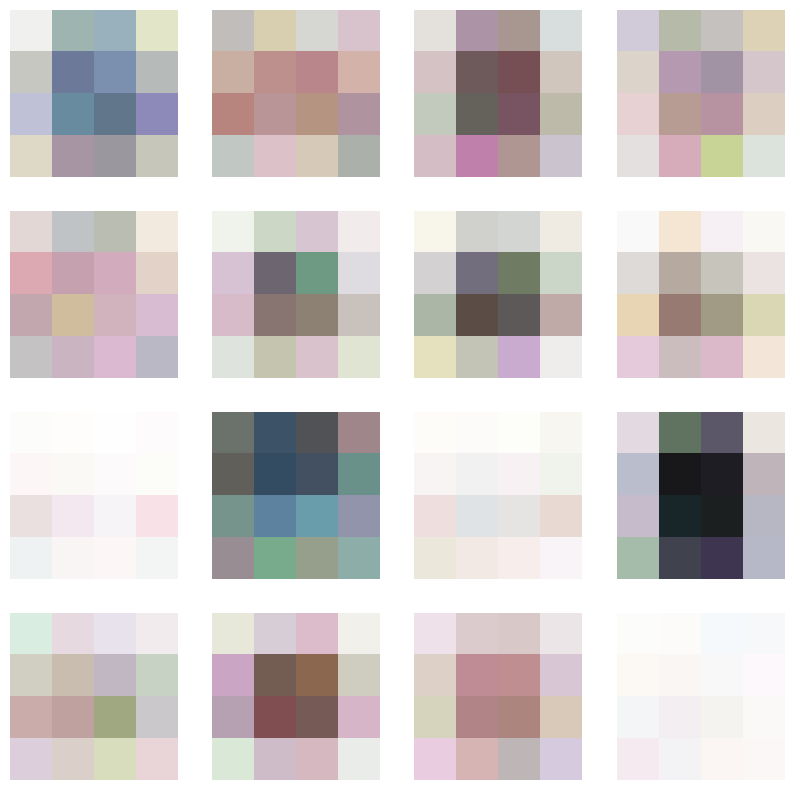

Step: 456
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7721913456916809
Generator loss: 1.7989898920059204


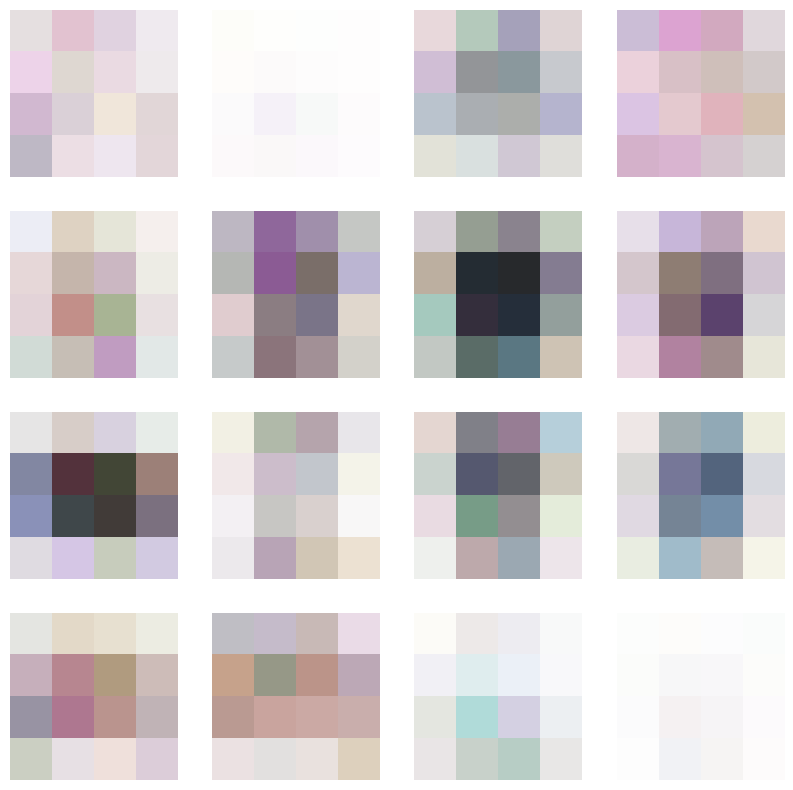

Step: 457
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7708332538604736
Generator loss: 1.7946407794952393


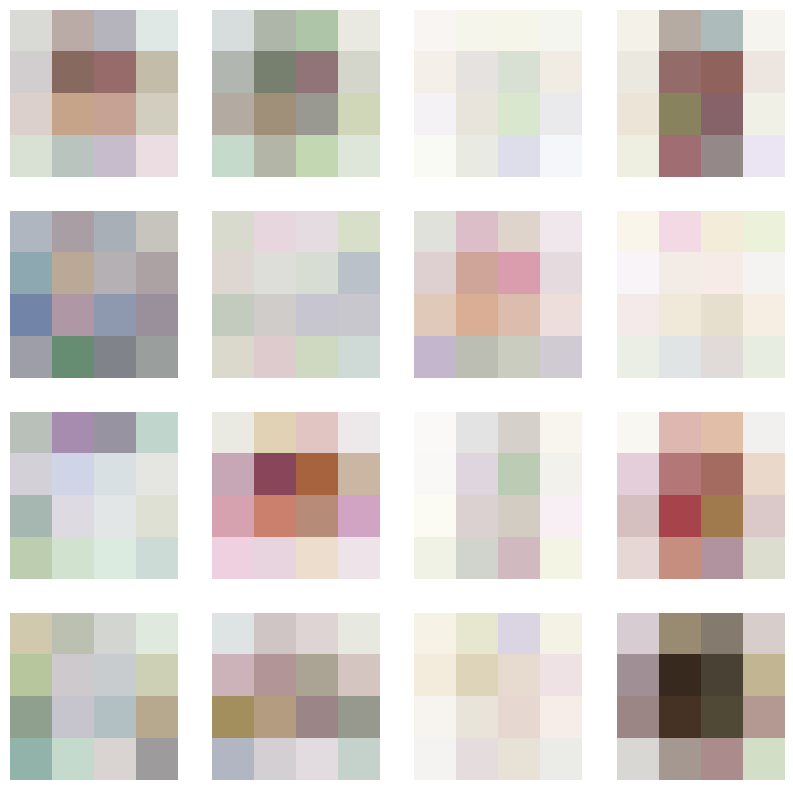

Step: 458
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7692835330963135
Generator loss: 1.7910659313201904


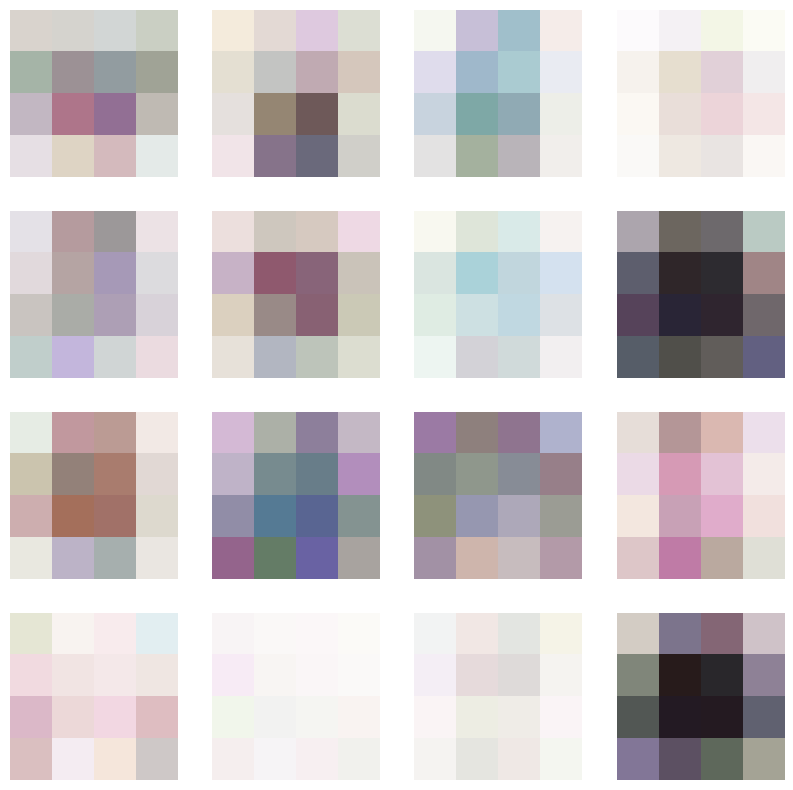

Step: 459
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7678875923156738
Generator loss: 1.7889169454574585


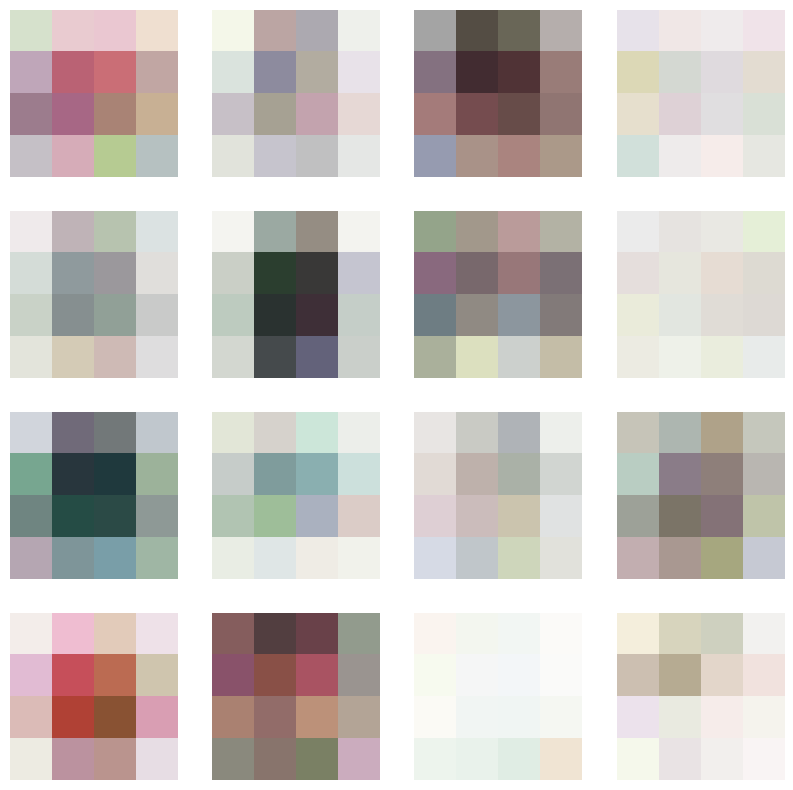

Step: 460
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.766433596611023
Generator loss: 1.7855137586593628


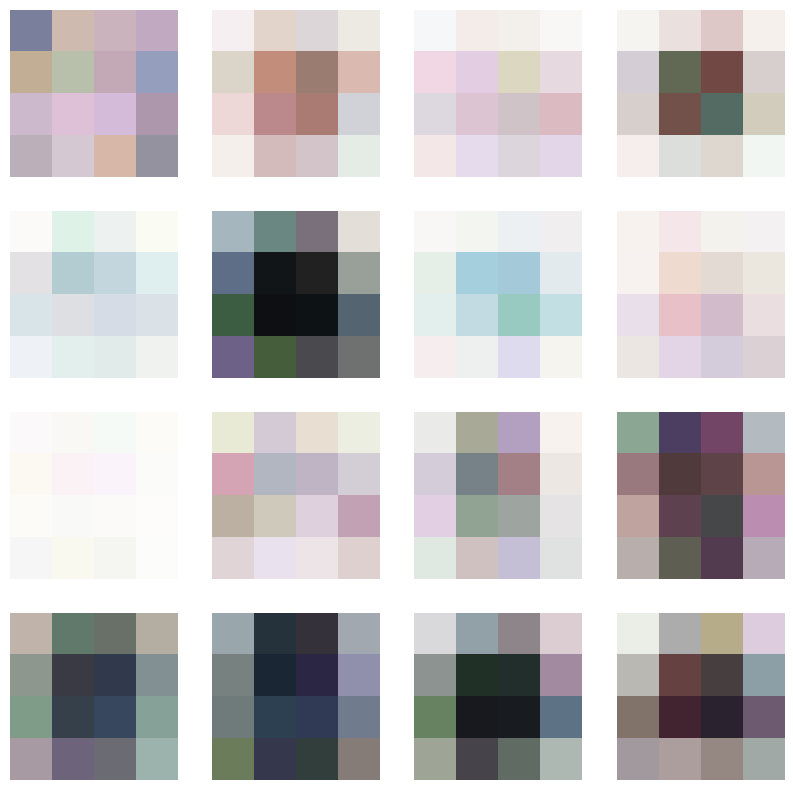

Step: 461
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7651598453521729
Generator loss: 1.7822962999343872


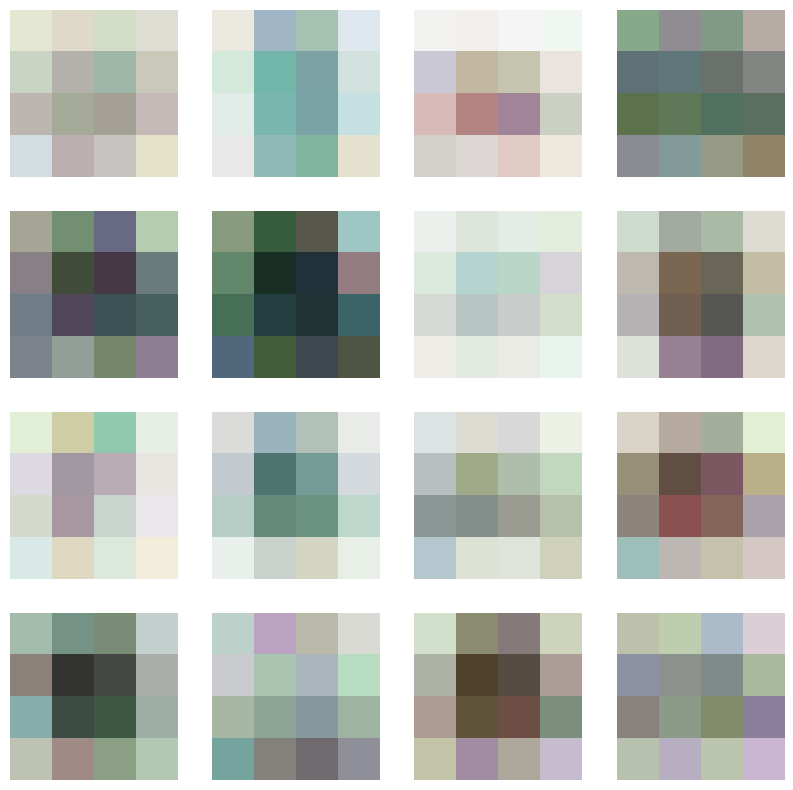

Step: 462
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7639709711074829
Generator loss: 1.7784911394119263


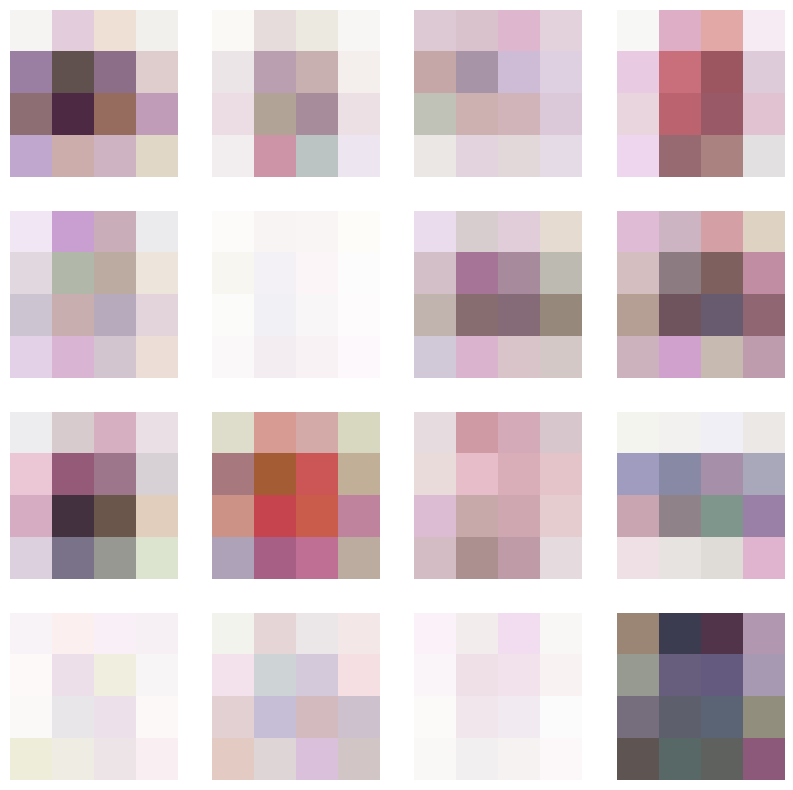

Step: 463
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7627381086349487
Generator loss: 1.775080919265747


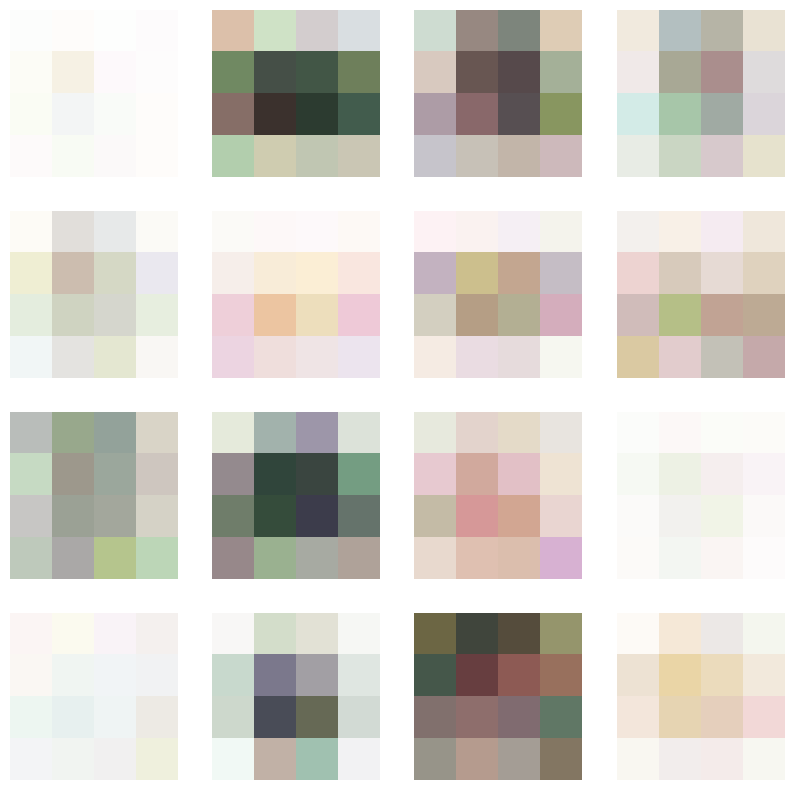

Step: 464
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7617243528366089
Generator loss: 1.7714685201644897


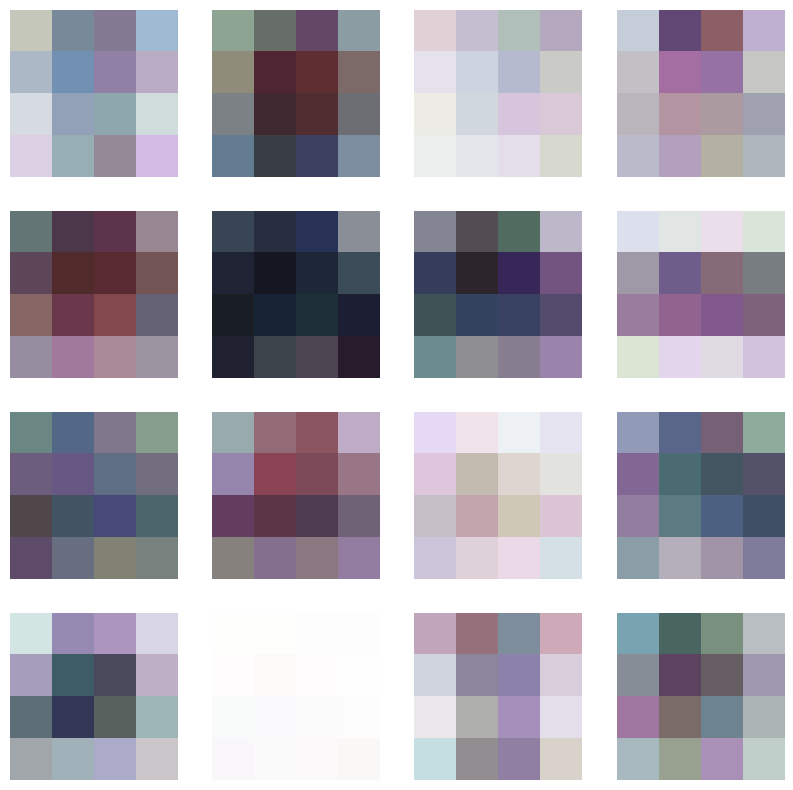

Step: 465
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7605996131896973
Generator loss: 1.7674291133880615


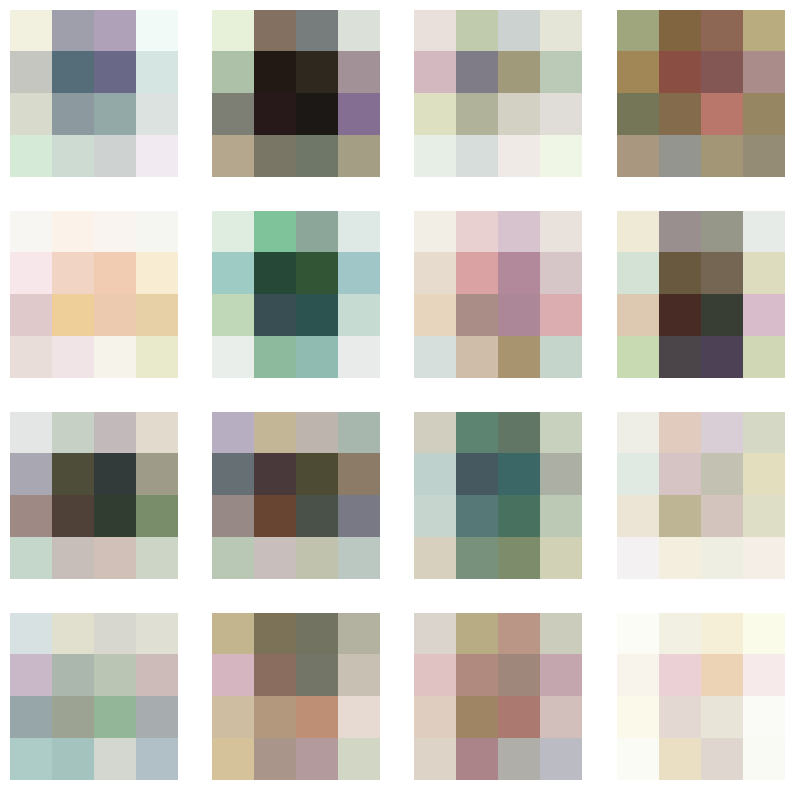

Step: 466
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7595395445823669
Generator loss: 1.763174057006836


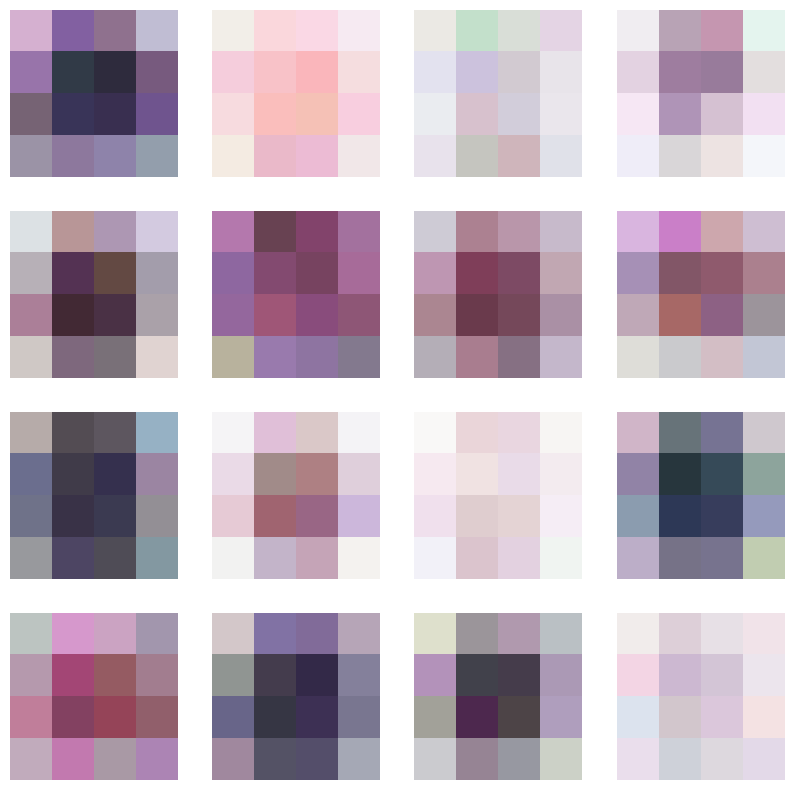

Step: 467
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7586245536804199
Generator loss: 1.7589055299758911


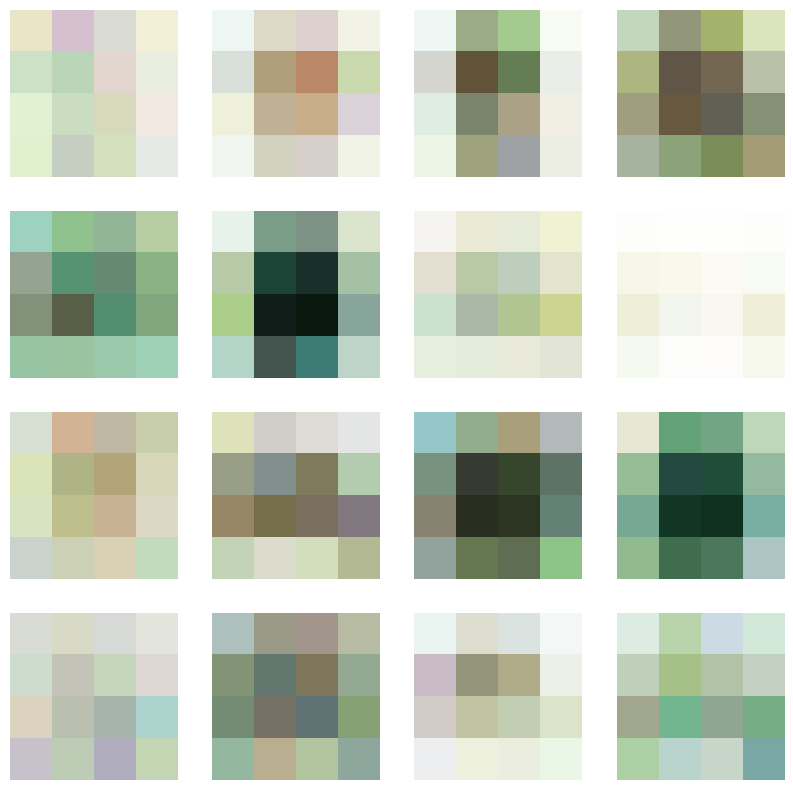

Step: 468
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7574344873428345
Generator loss: 1.7538409233093262


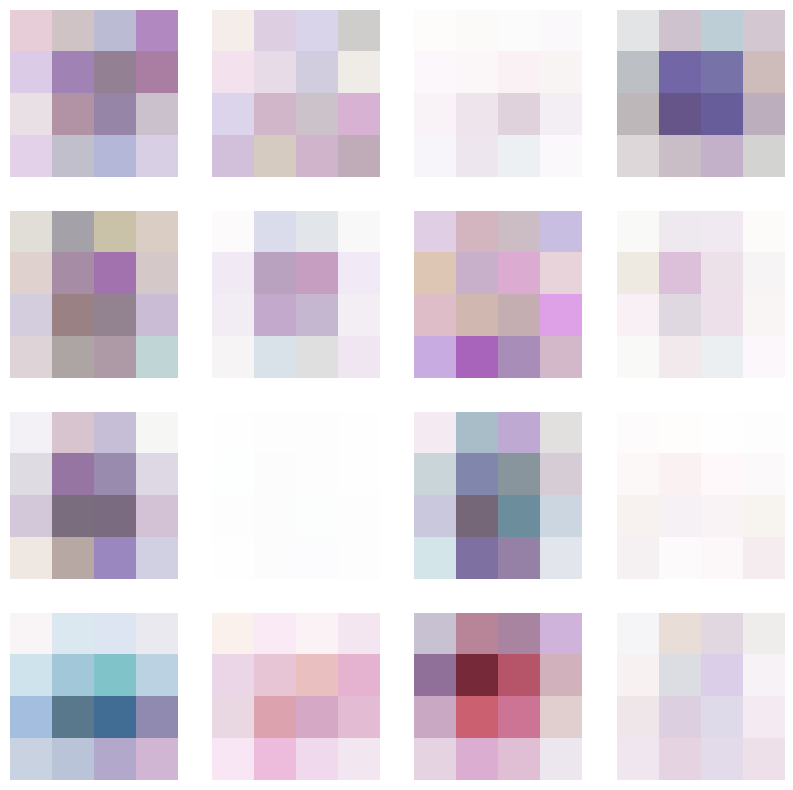

Step: 469
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7561384439468384
Generator loss: 1.748530387878418


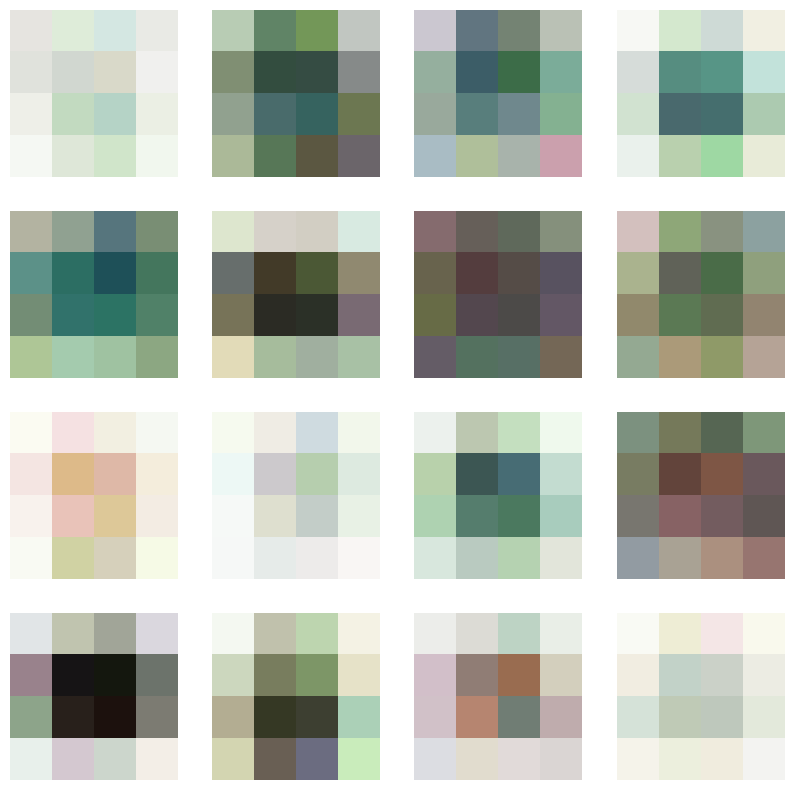

Step: 470
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7549376487731934
Generator loss: 1.7441450357437134


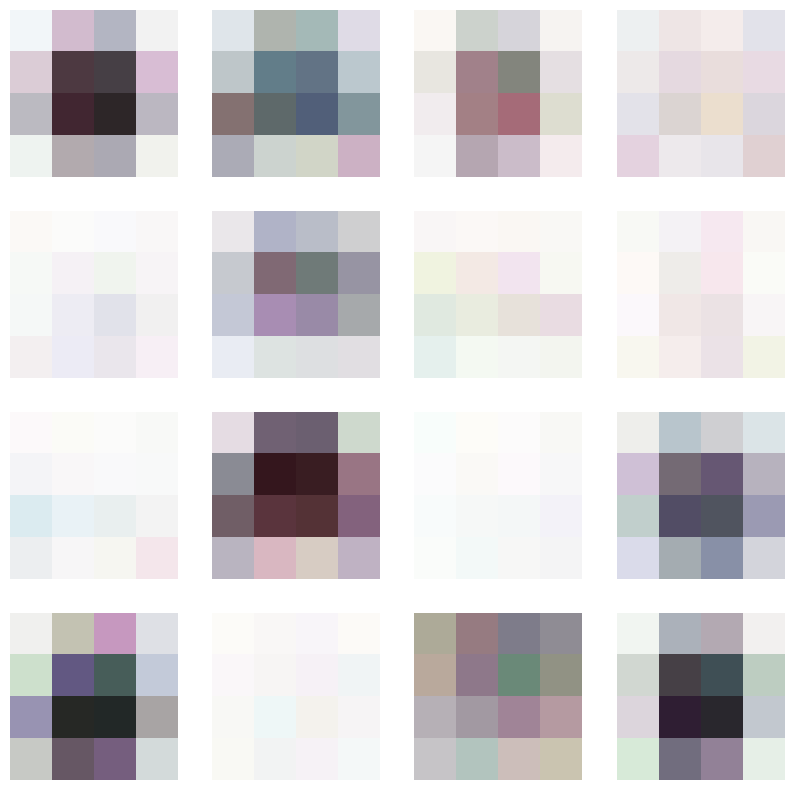

Step: 471
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7537367939949036
Generator loss: 1.741137146949768


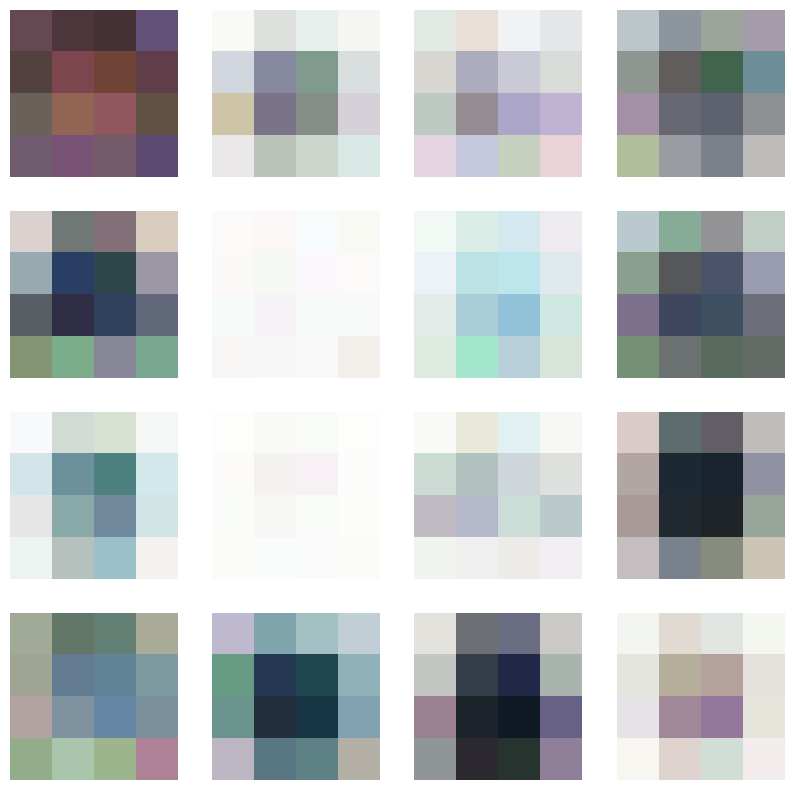

Step: 472
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7524147629737854
Generator loss: 1.738477110862732


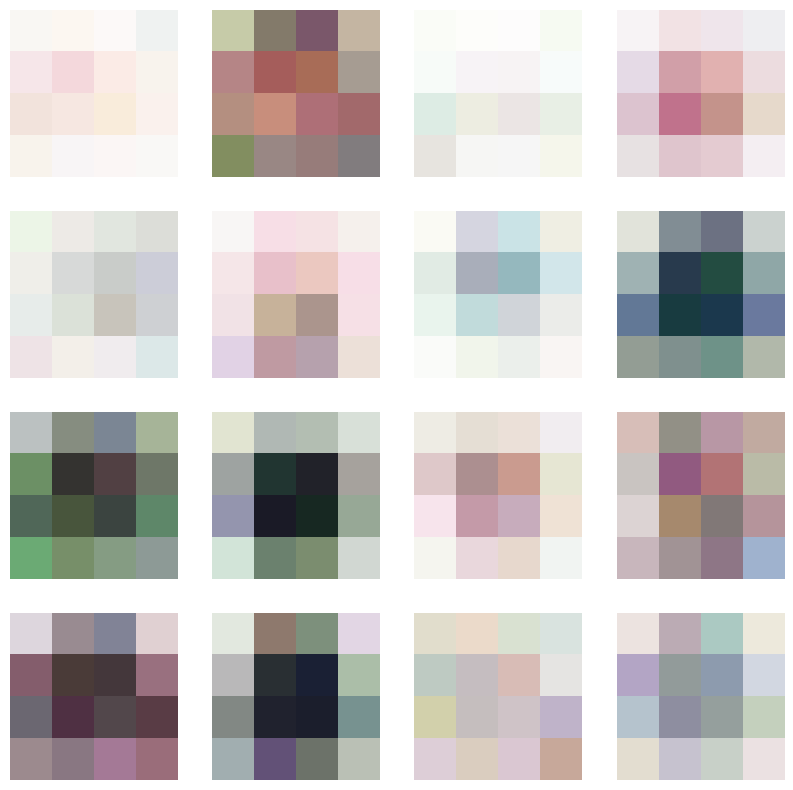

Step: 473
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7510018944740295
Generator loss: 1.7346947193145752


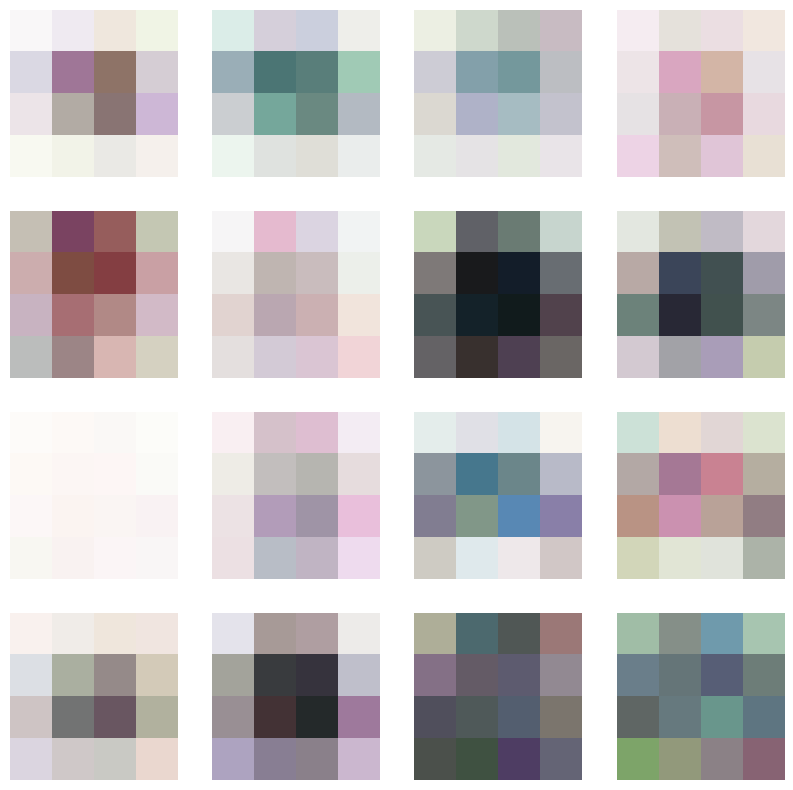

Step: 474
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.749768853187561
Generator loss: 1.7306149005889893


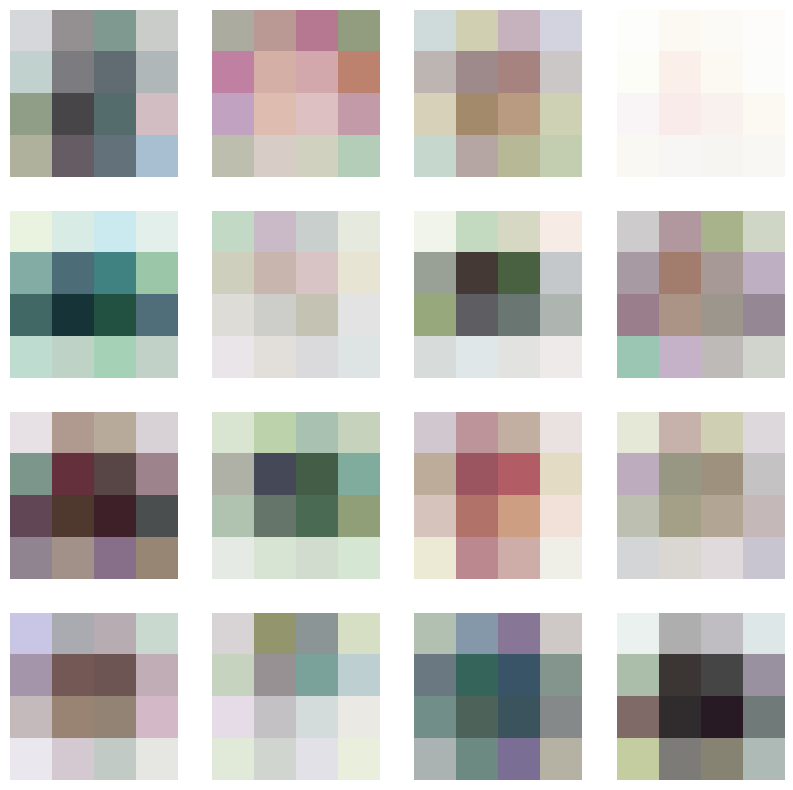

Step: 475
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7485479116439819
Generator loss: 1.7265349626541138


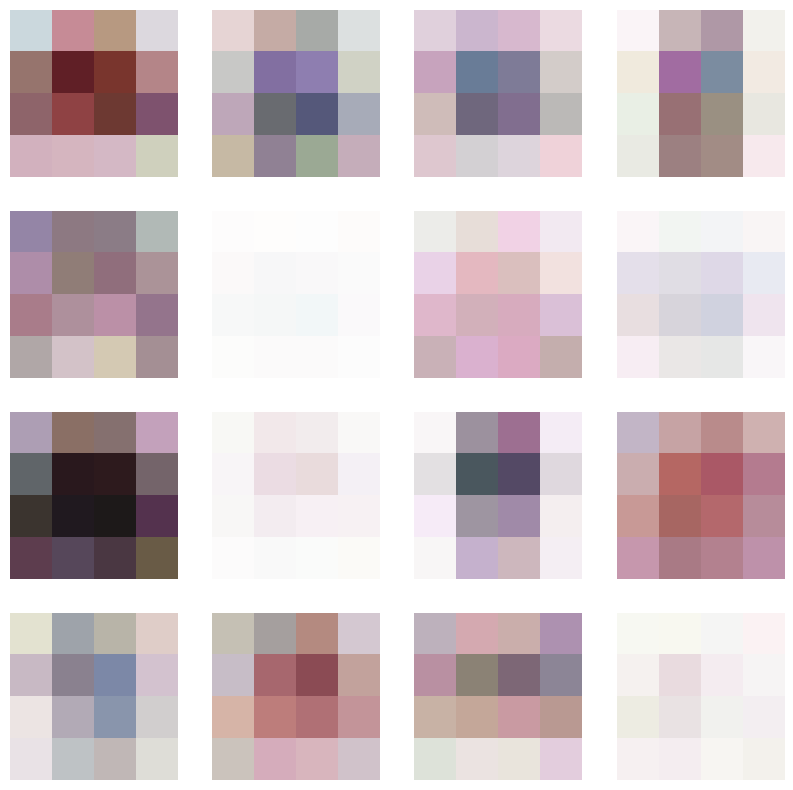

Step: 476
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7471523284912109
Generator loss: 1.723722219467163


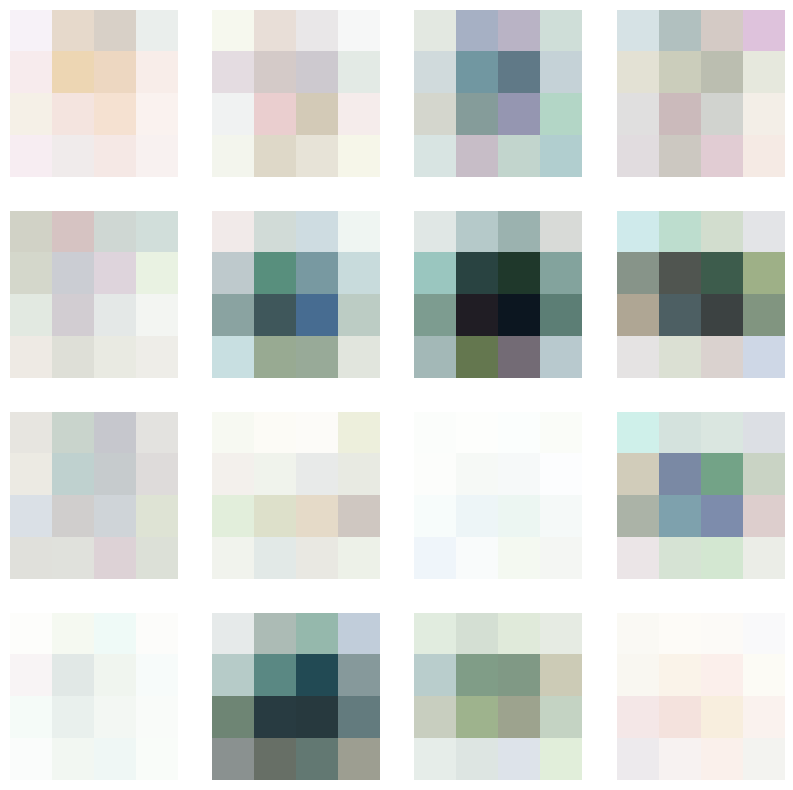

Step: 477
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7459632754325867
Generator loss: 1.7203618288040161


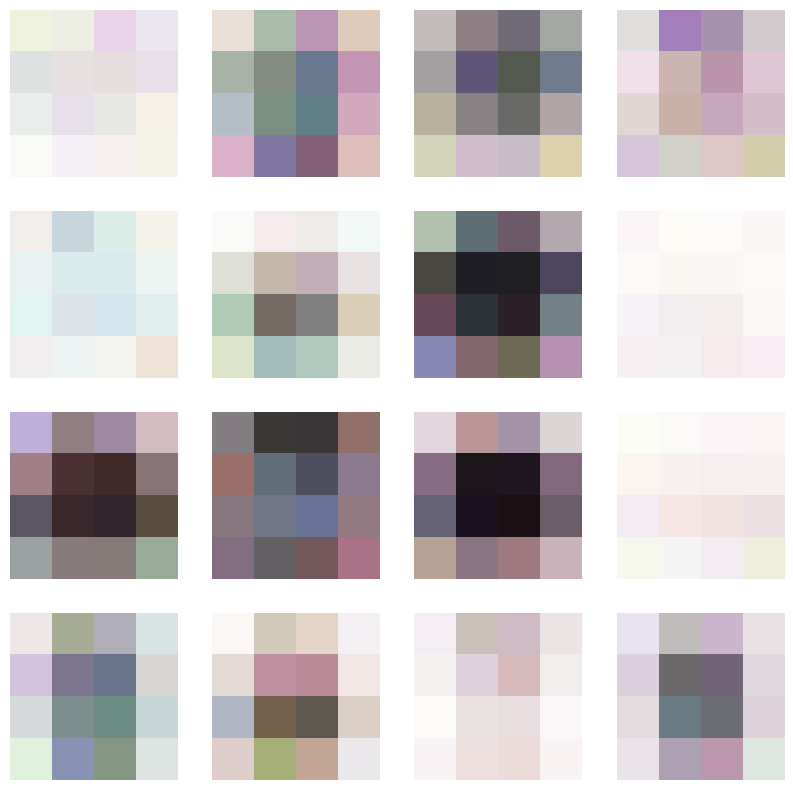

Step: 478
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7446826100349426
Generator loss: 1.7170255184173584


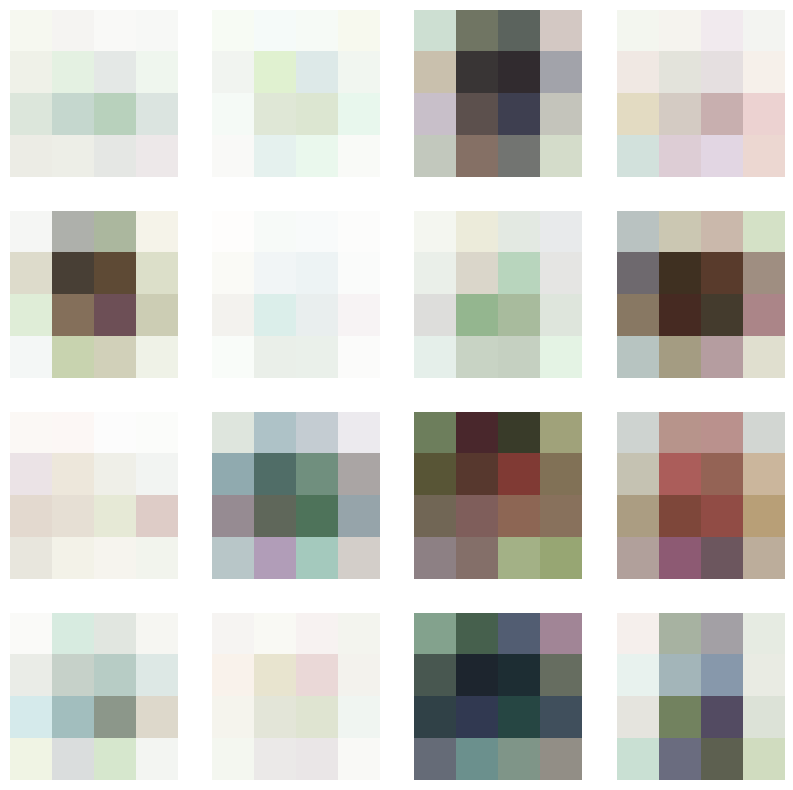

Step: 479
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7436376214027405
Generator loss: 1.7139132022857666


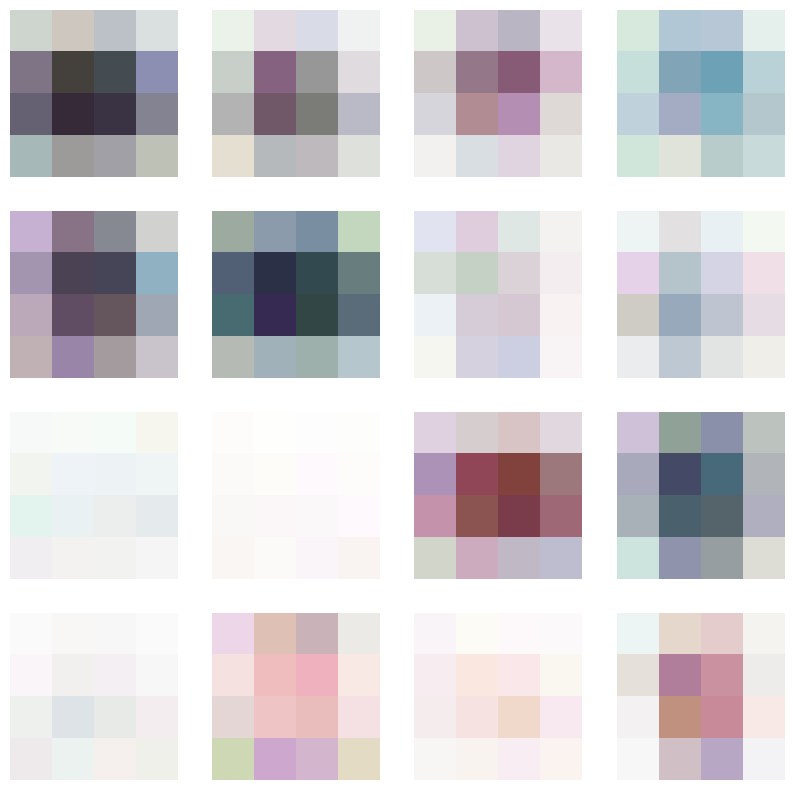

Step: 480
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7426254749298096
Generator loss: 1.7105869054794312


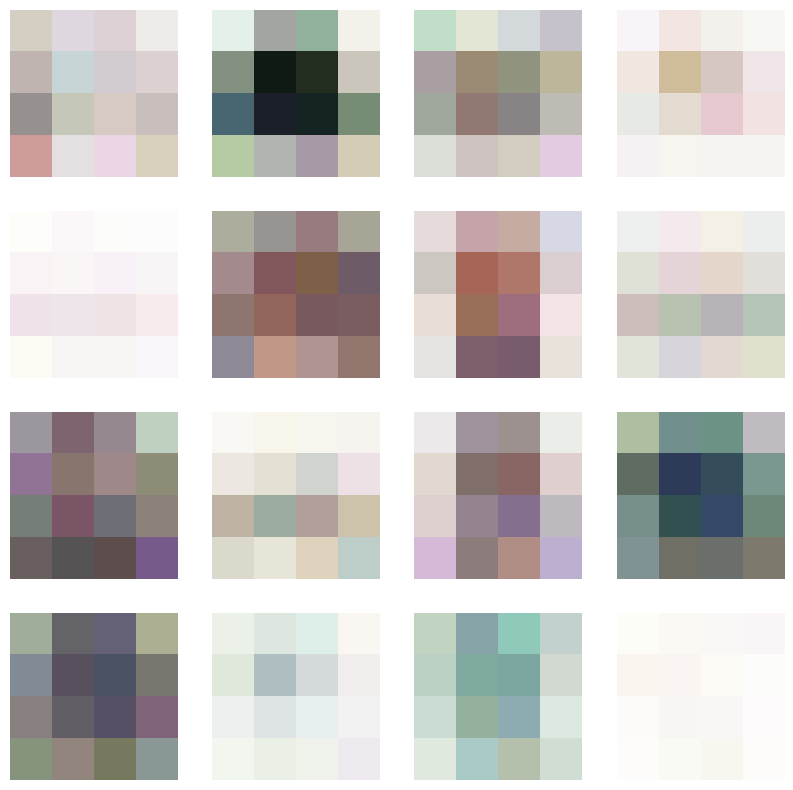

Step: 481
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7415627241134644
Generator loss: 1.7071495056152344


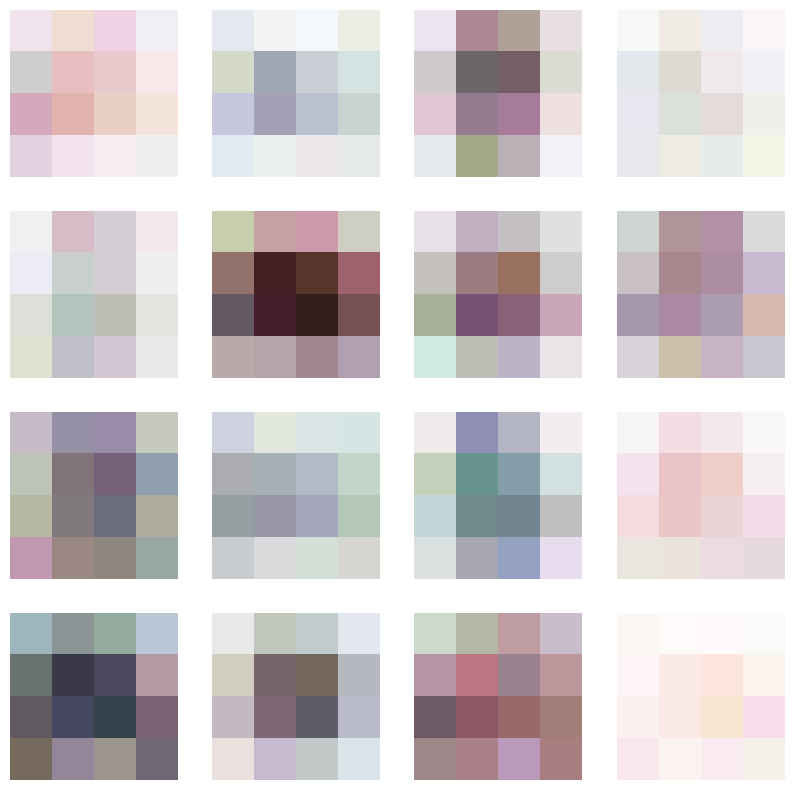

Step: 482
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7404485940933228
Generator loss: 1.7043485641479492


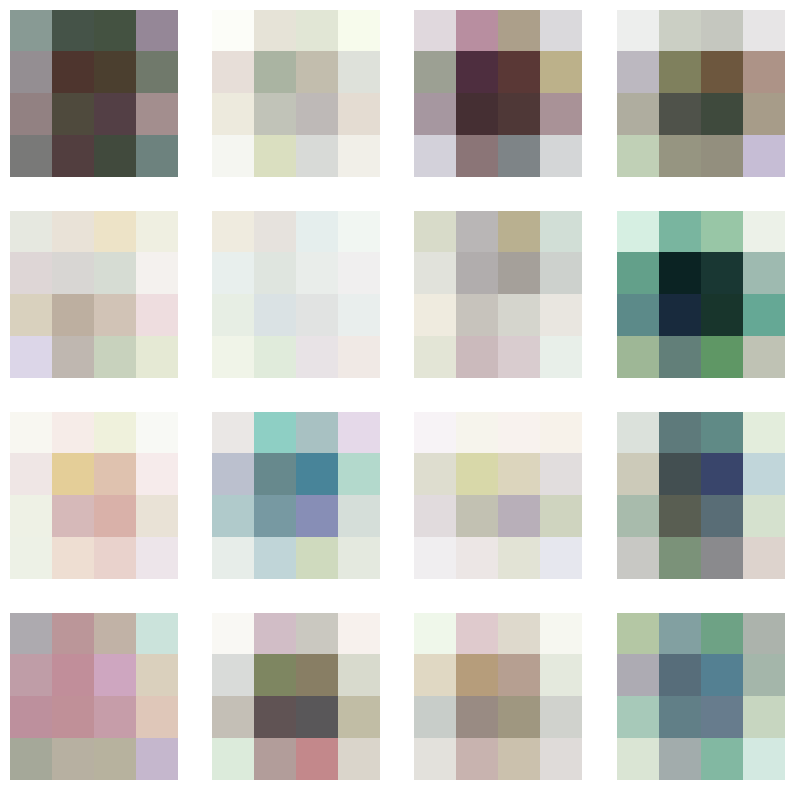

Step: 483
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7391694784164429
Generator loss: 1.7008674144744873


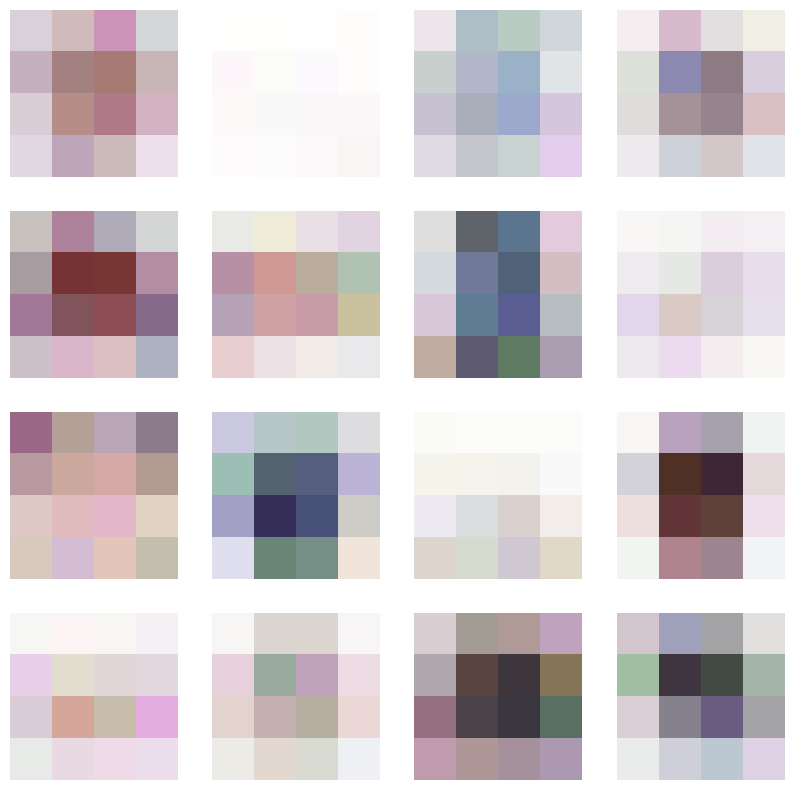

Step: 484
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7380456924438477
Generator loss: 1.697003960609436


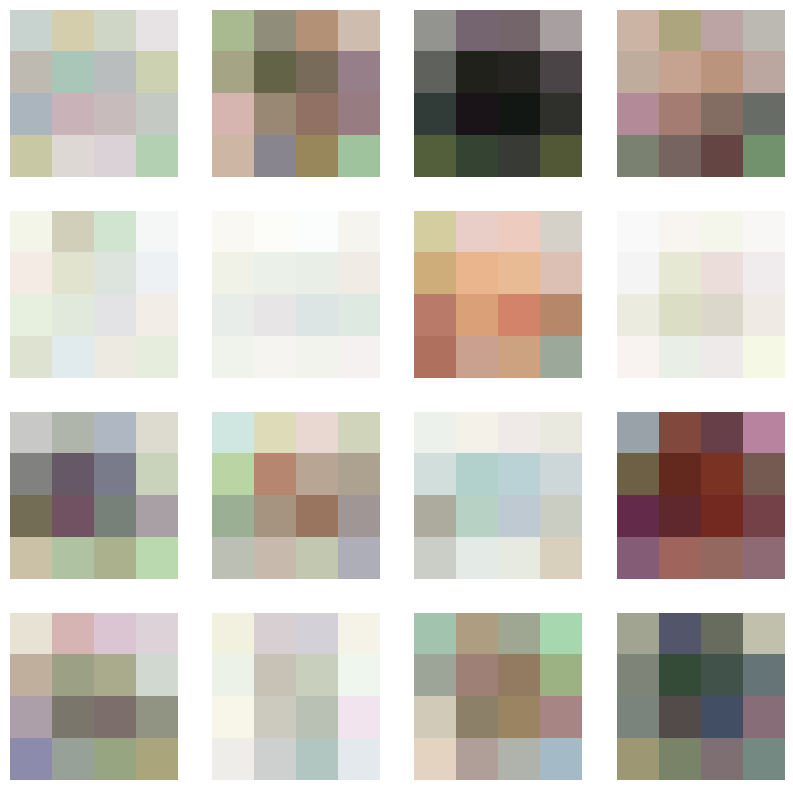

Step: 485
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7371311783790588
Generator loss: 1.6921136379241943


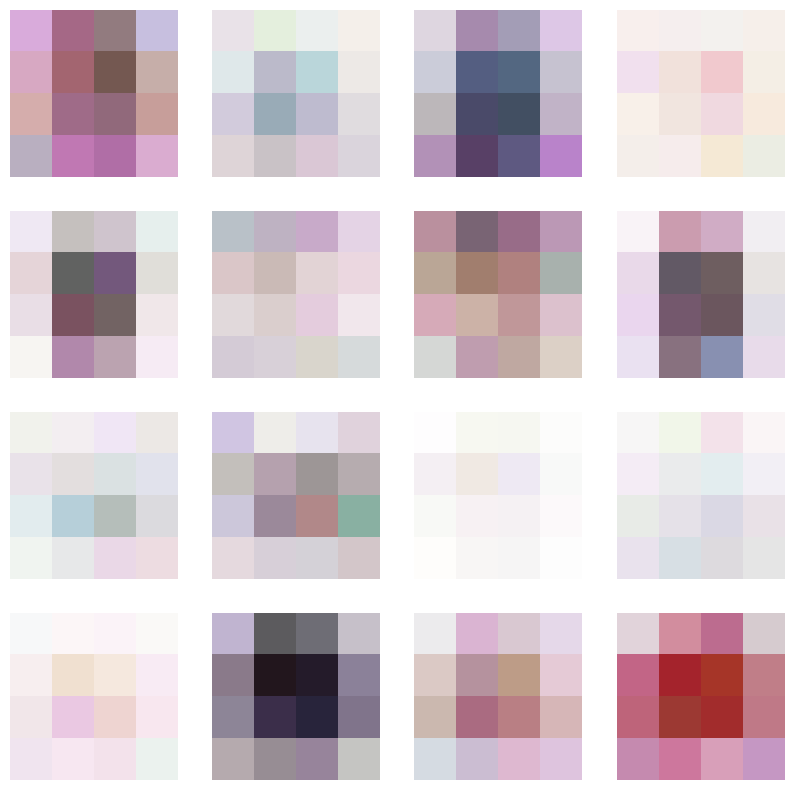

Step: 486
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7358277440071106
Generator loss: 1.6878011226654053


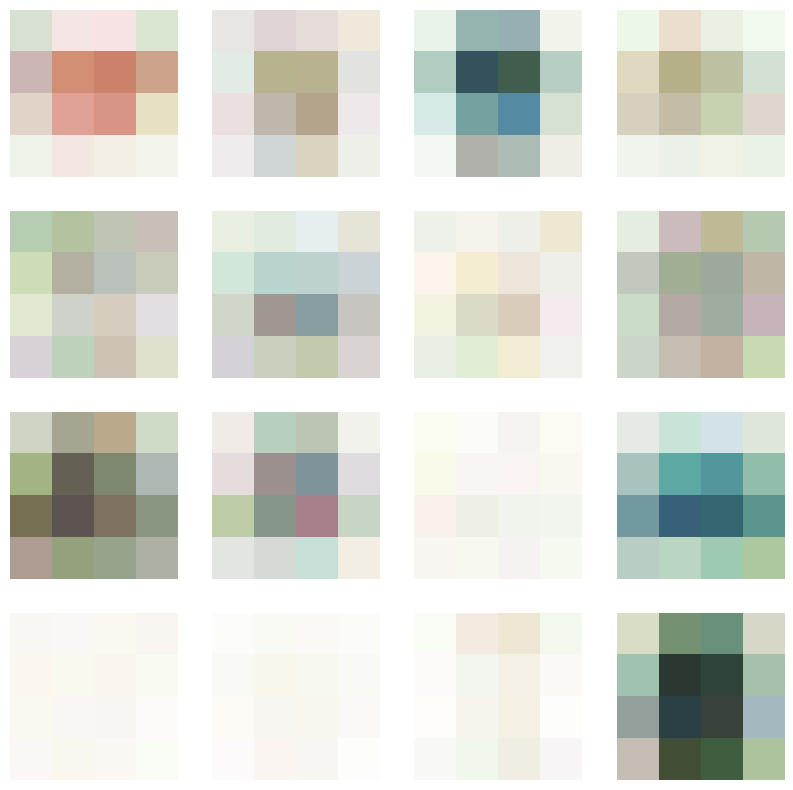

Step: 487
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7347034811973572
Generator loss: 1.6847143173217773


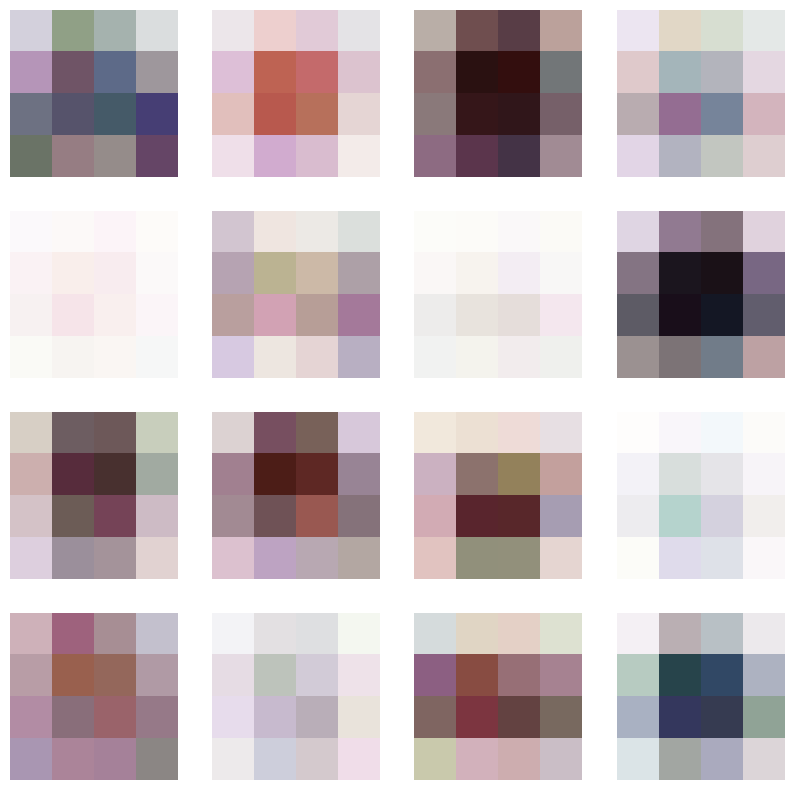

Step: 488
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7335072159767151
Generator loss: 1.6817004680633545


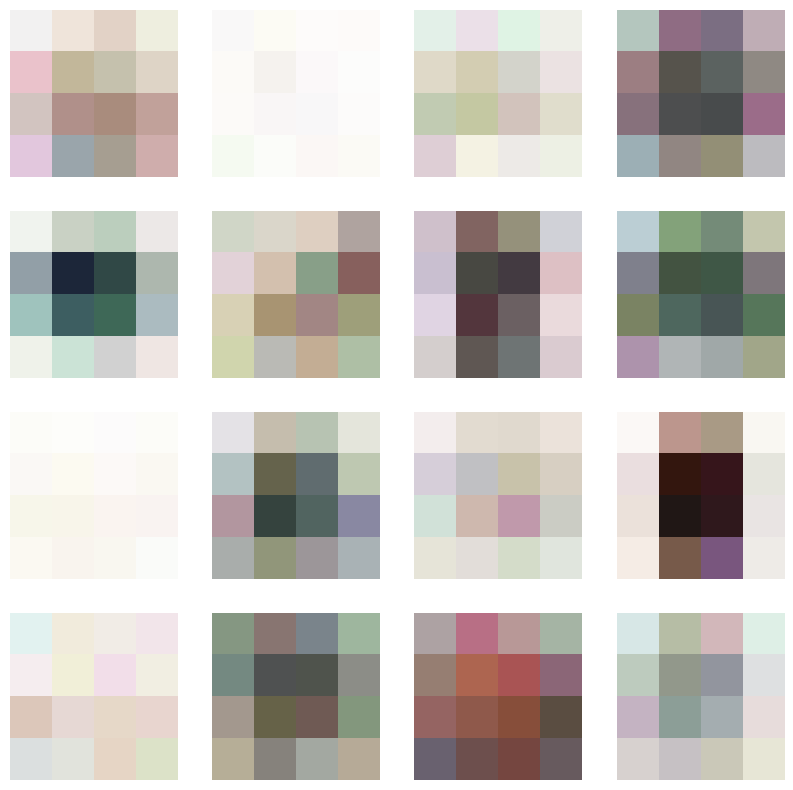

Step: 489
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7325724363327026
Generator loss: 1.6788716316223145


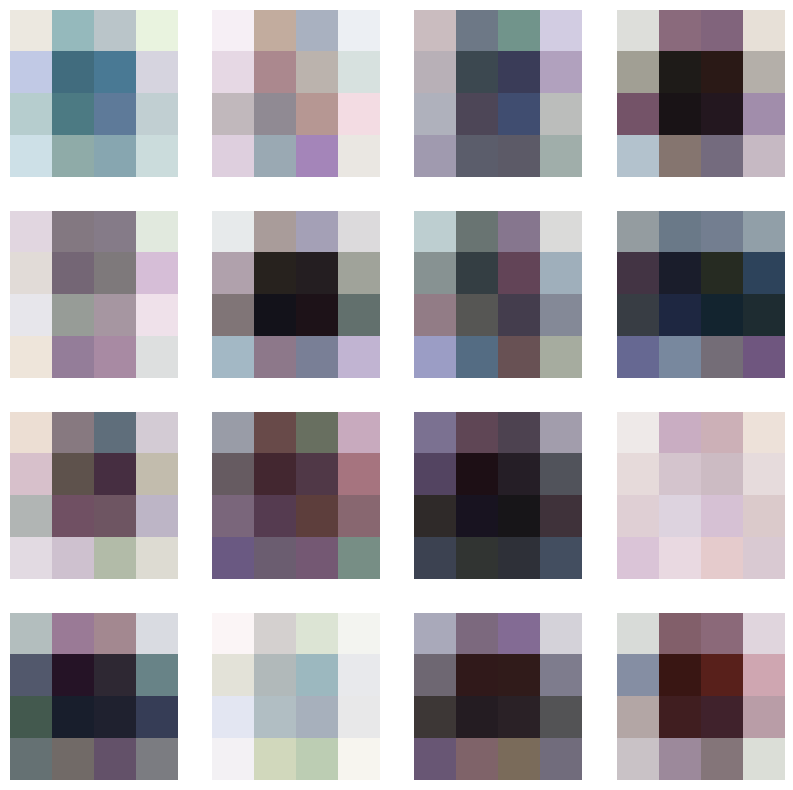

Step: 490
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7312889695167542
Generator loss: 1.6747527122497559


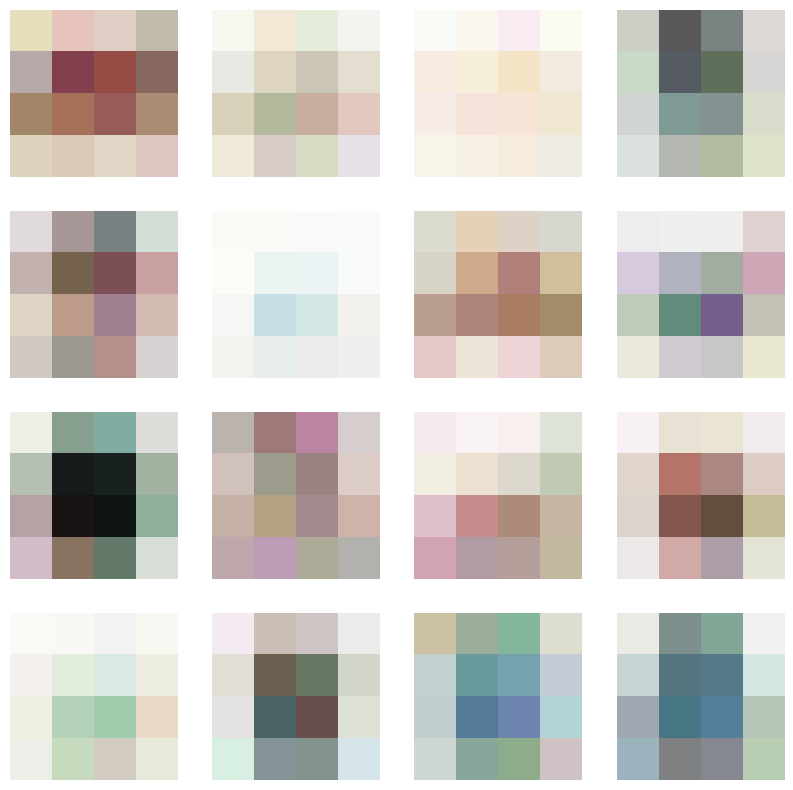

Step: 491
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7302471399307251
Generator loss: 1.670596718788147


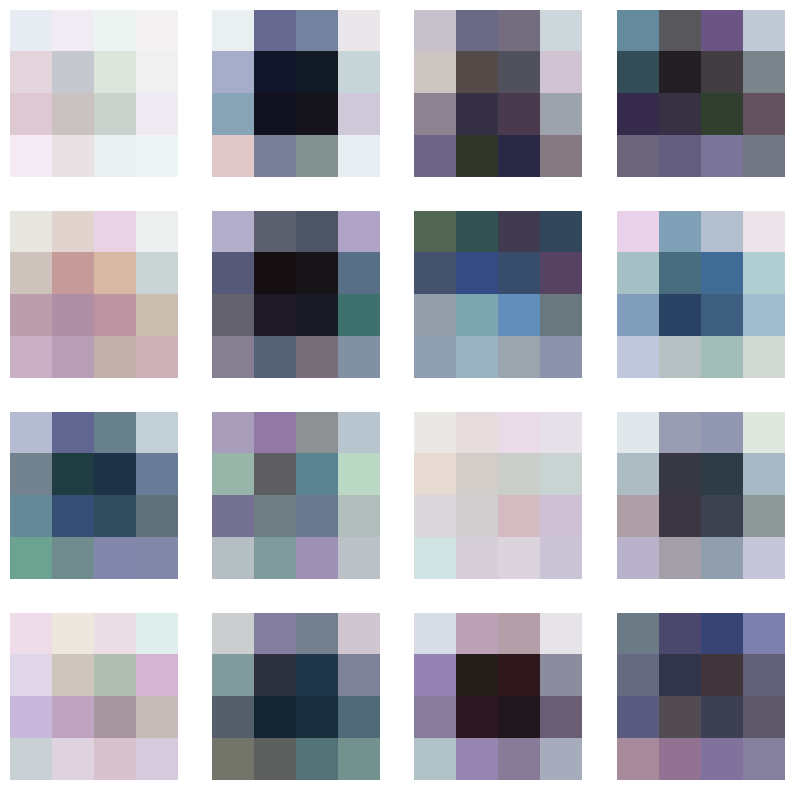

Step: 492
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7291250824928284
Generator loss: 1.666153907775879


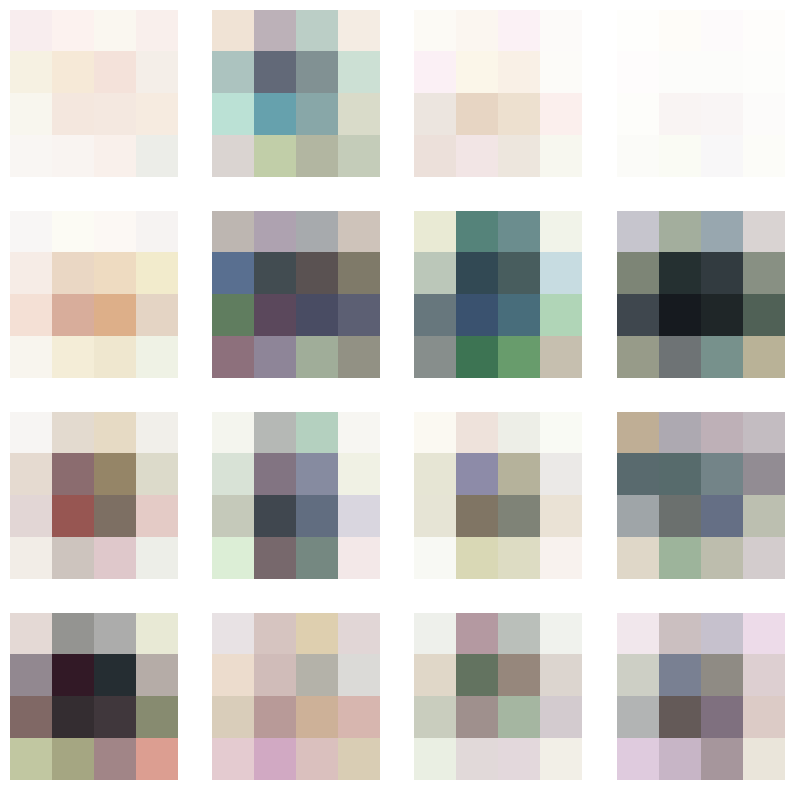

Step: 493
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7279714941978455
Generator loss: 1.661582589149475


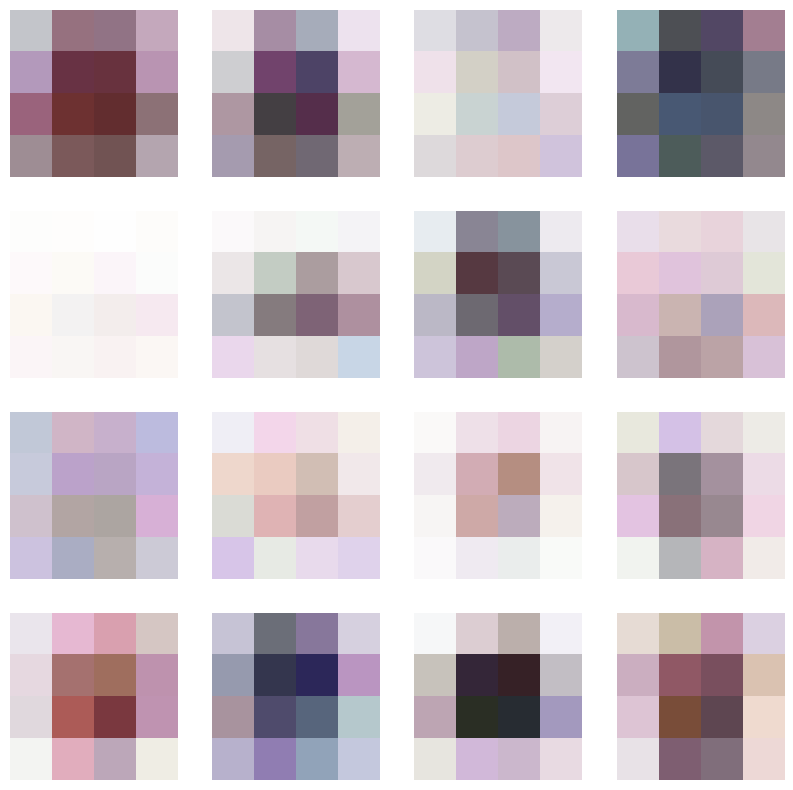

Step: 494
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7265902161598206
Generator loss: 1.6581213474273682


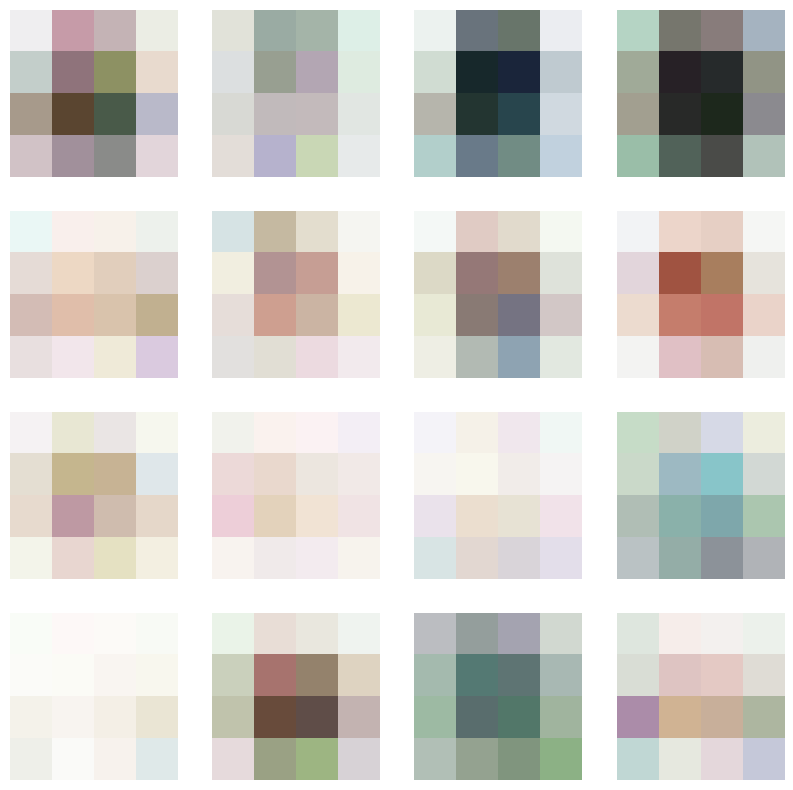

Step: 495
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.725364625453949
Generator loss: 1.6564133167266846


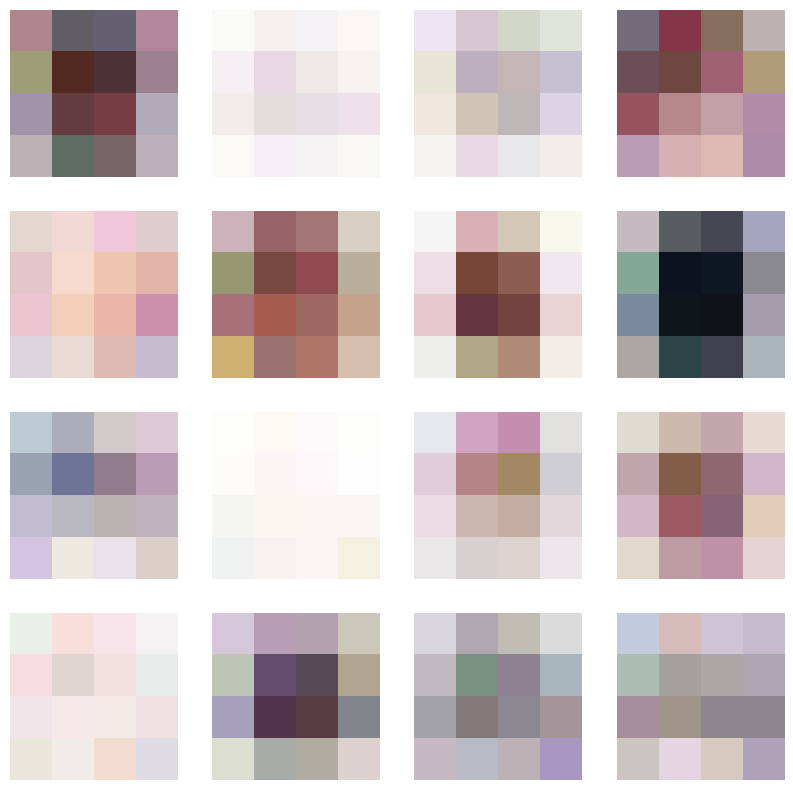

Step: 496
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7243475317955017
Generator loss: 1.6548465490341187


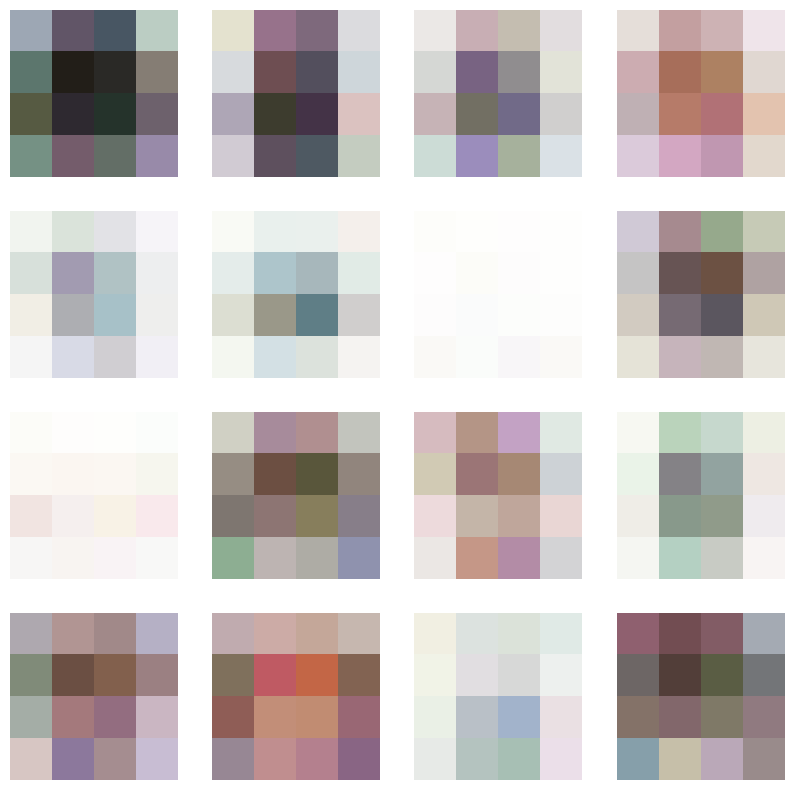

Step: 497
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7231578230857849
Generator loss: 1.6525908708572388


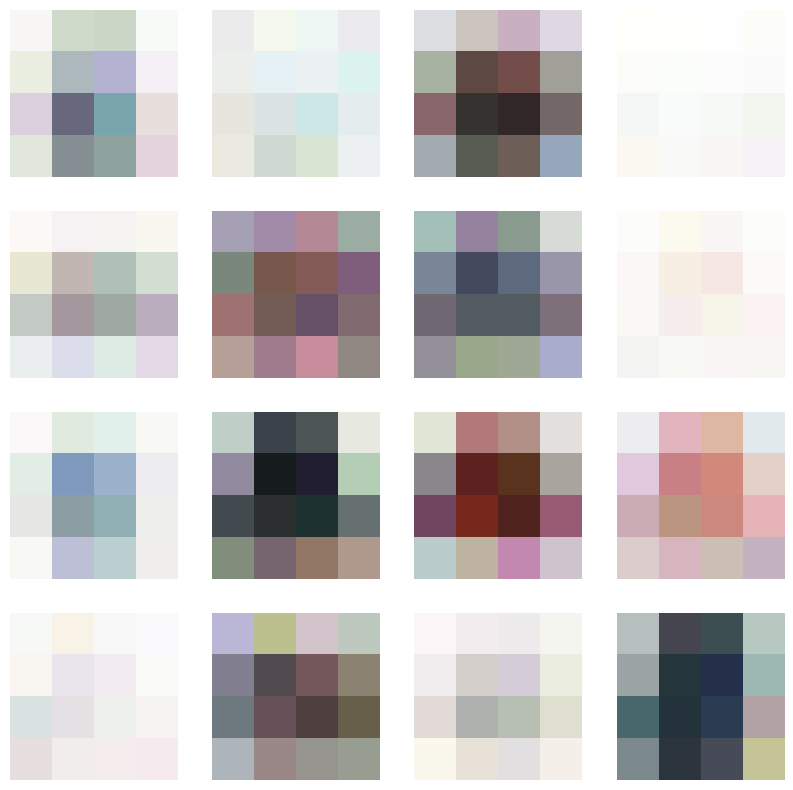

Step: 498
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7217298150062561
Generator loss: 1.6494389772415161


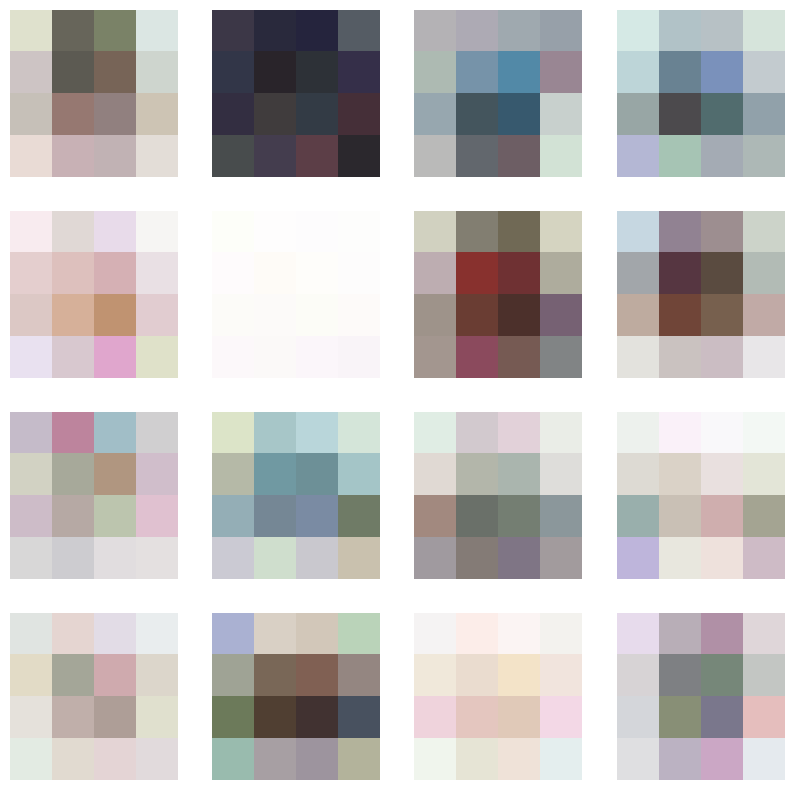

Step: 499
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7206333875656128
Generator loss: 1.6453183889389038


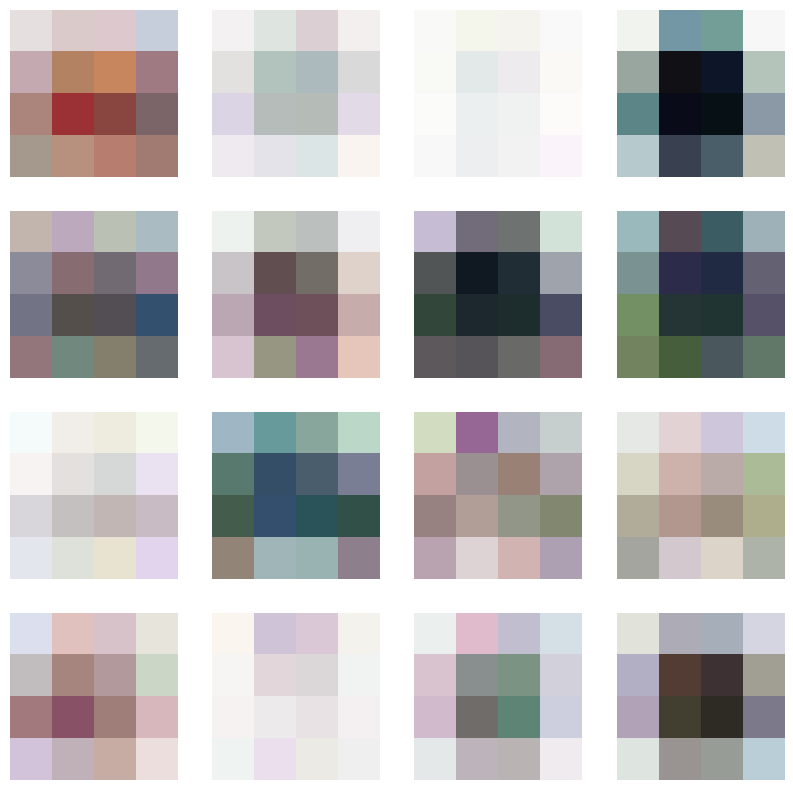

Step: 500
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7197320461273193
Generator loss: 1.6403855085372925


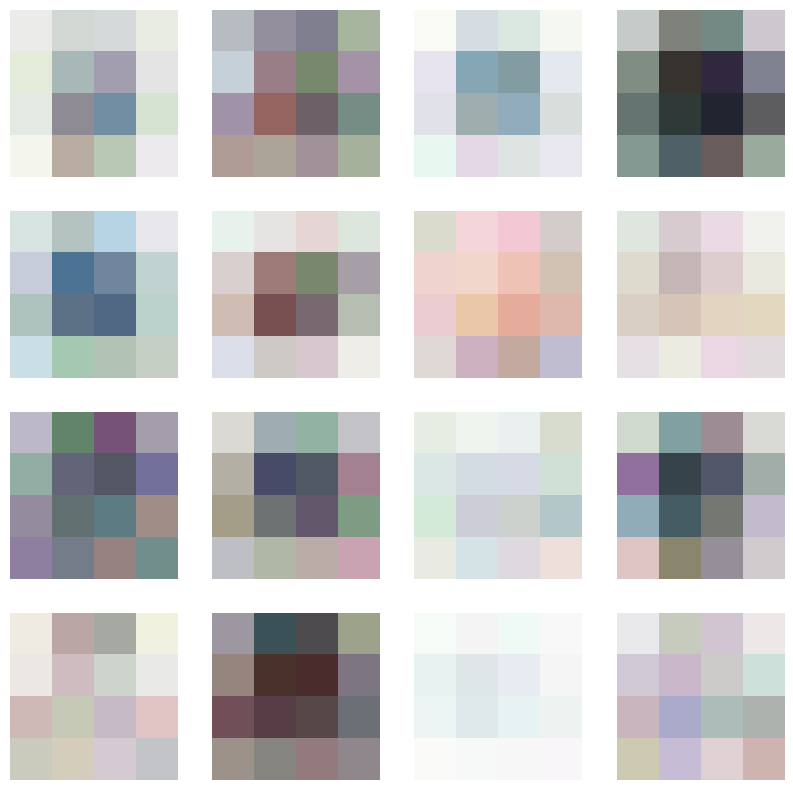

Step: 501
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7182504534721375
Generator loss: 1.6362122297286987


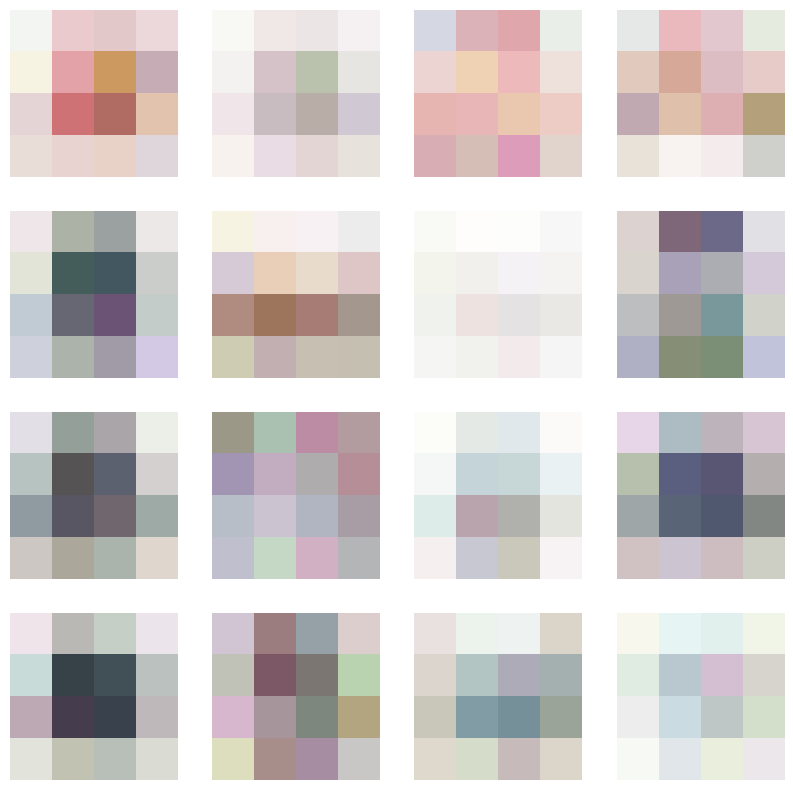

Step: 502
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.716891884803772
Generator loss: 1.6339585781097412


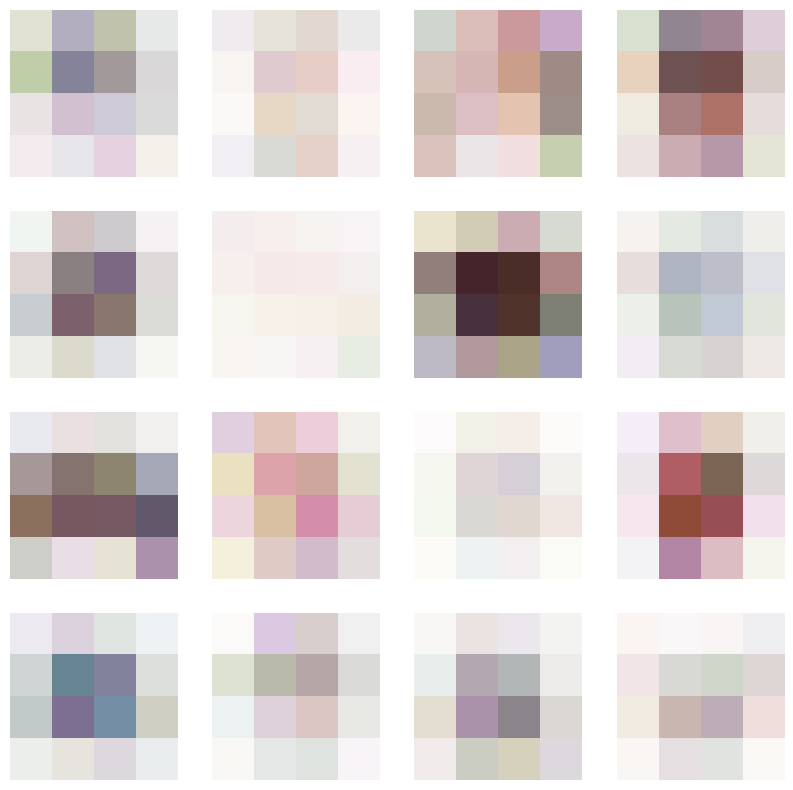

Step: 503
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7158976197242737
Generator loss: 1.6313902139663696


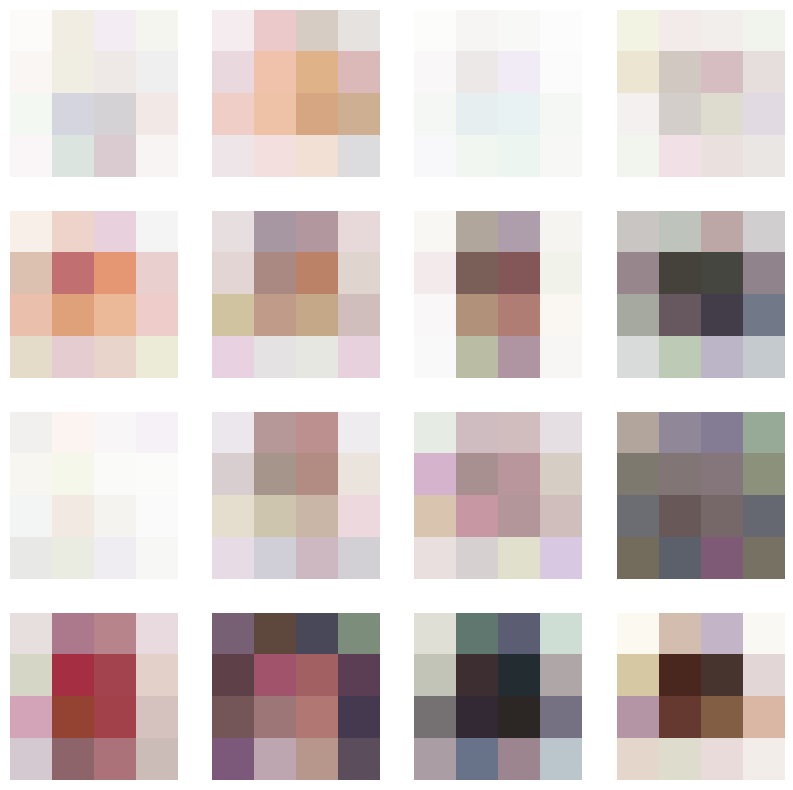

Step: 504
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7149680852890015
Generator loss: 1.6299992799758911


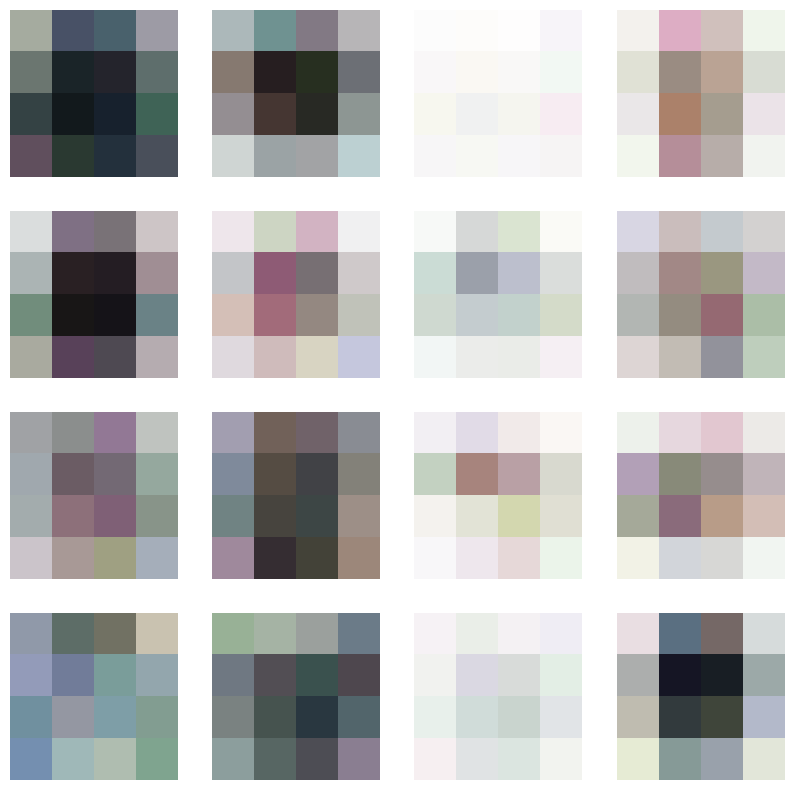

Step: 505
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7136813998222351
Generator loss: 1.6267294883728027


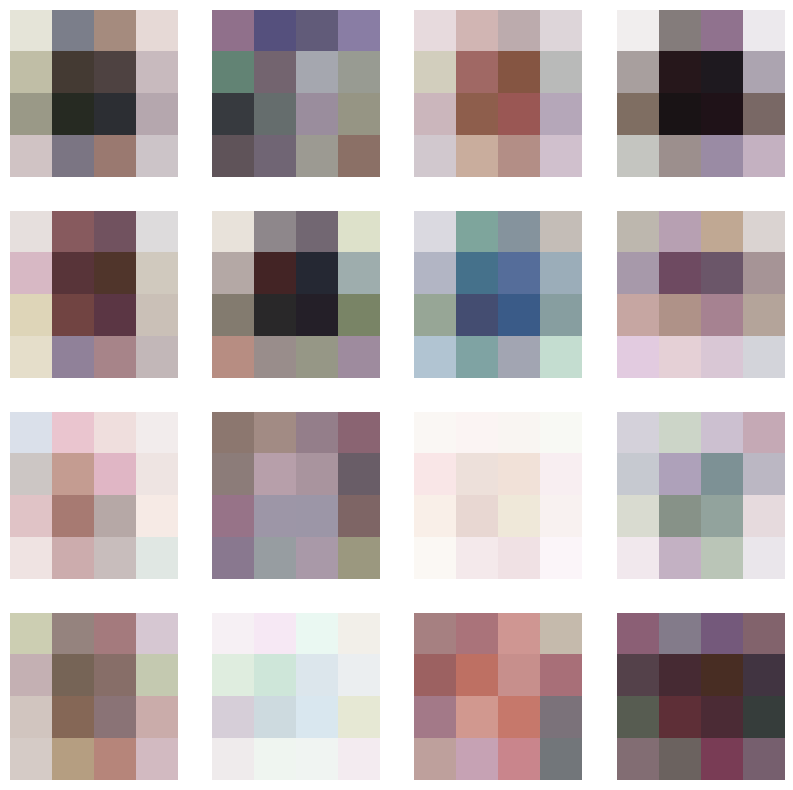

Step: 506
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7125784754753113
Generator loss: 1.6243033409118652


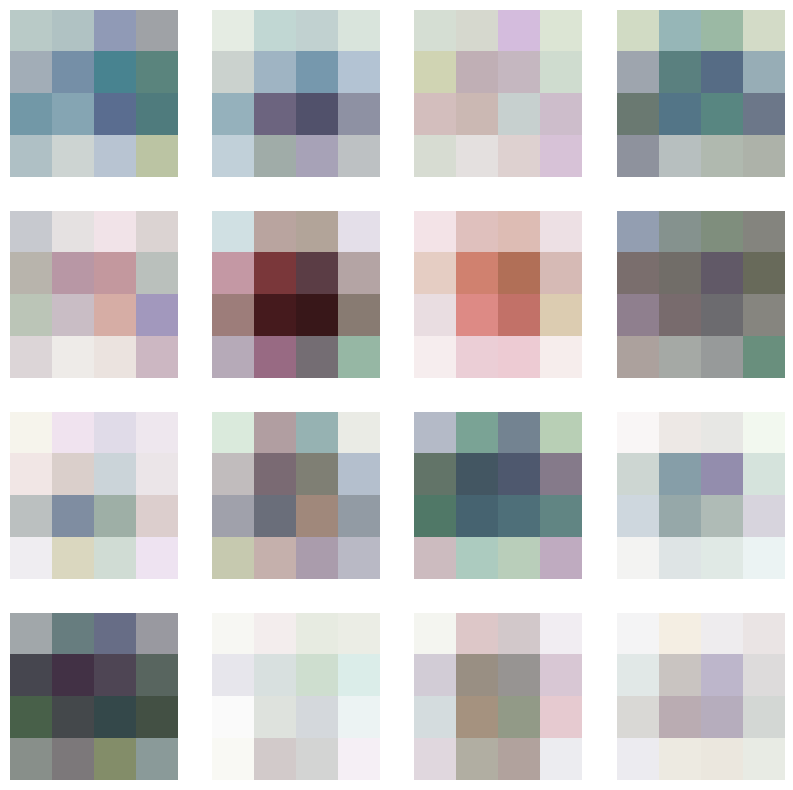

Step: 507
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7111645340919495
Generator loss: 1.6208857297897339


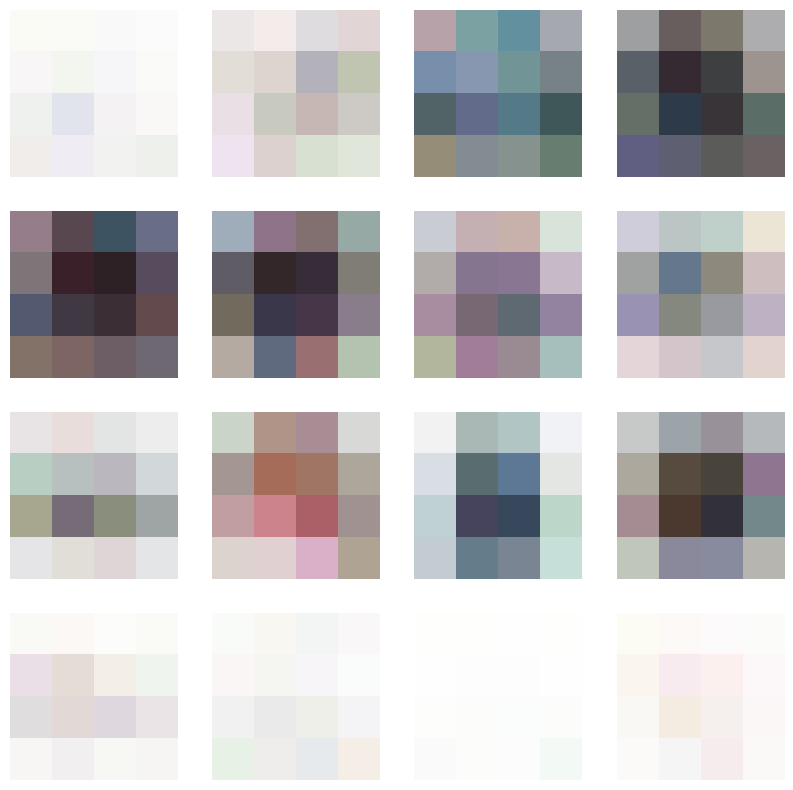

Step: 508
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7101619839668274
Generator loss: 1.6180580854415894


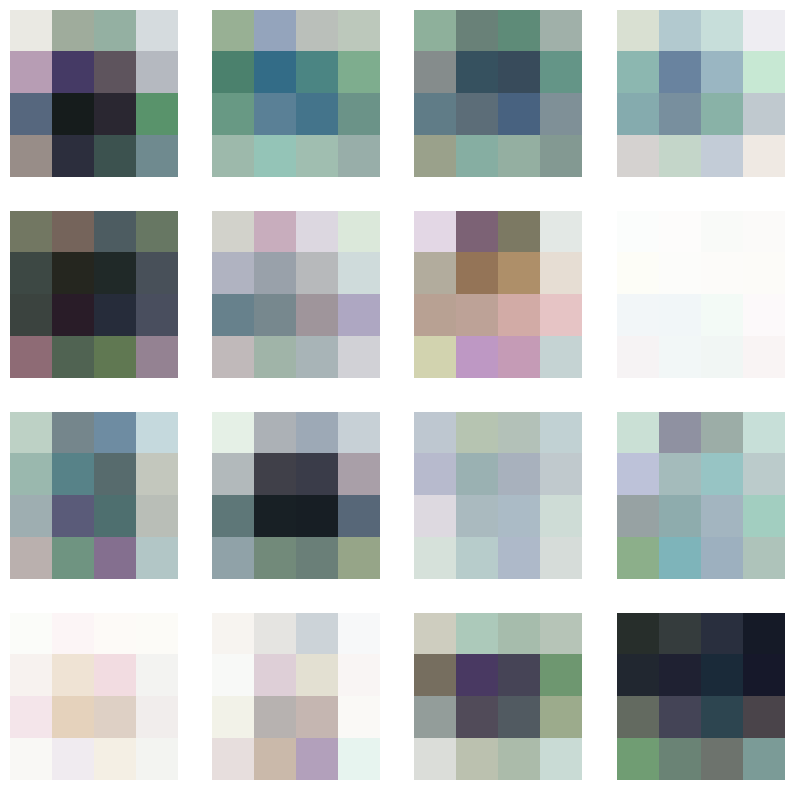

Step: 509
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7090227603912354
Generator loss: 1.6150121688842773


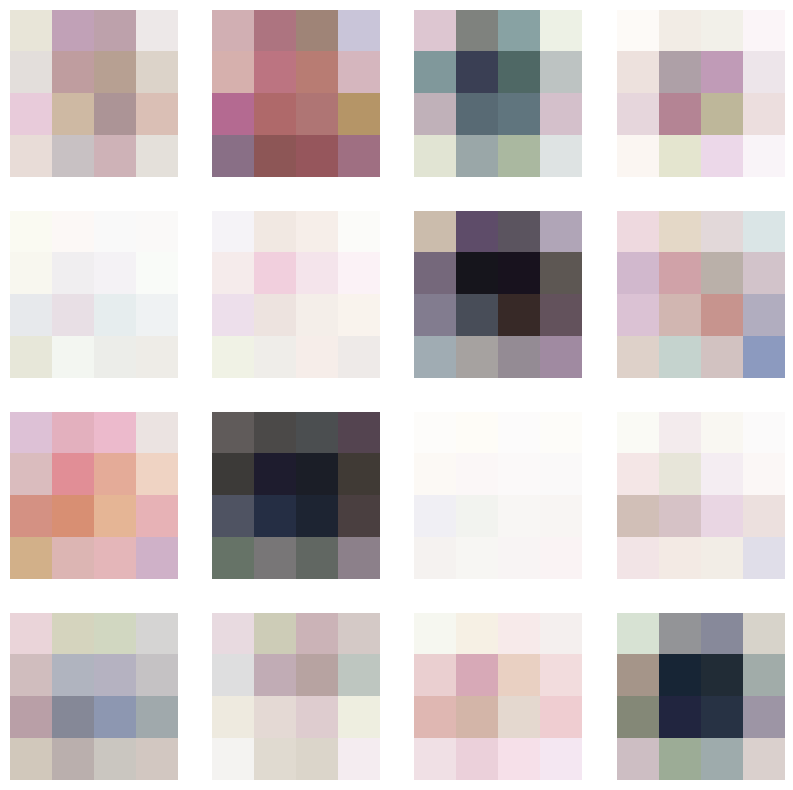

Step: 510
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7079083919525146
Generator loss: 1.6118265390396118


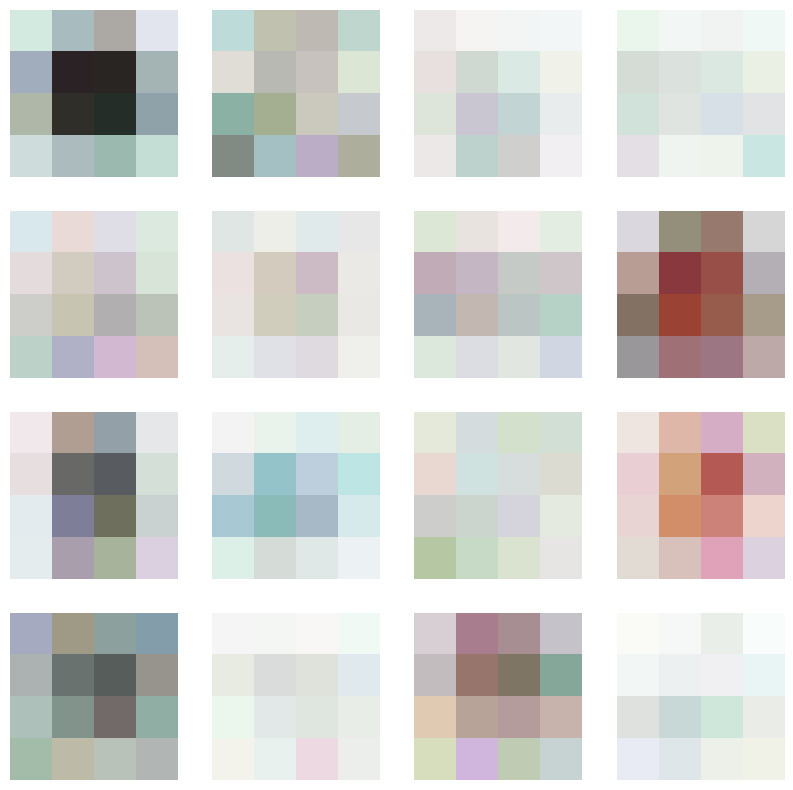

Step: 511
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7067728638648987
Generator loss: 1.6083317995071411


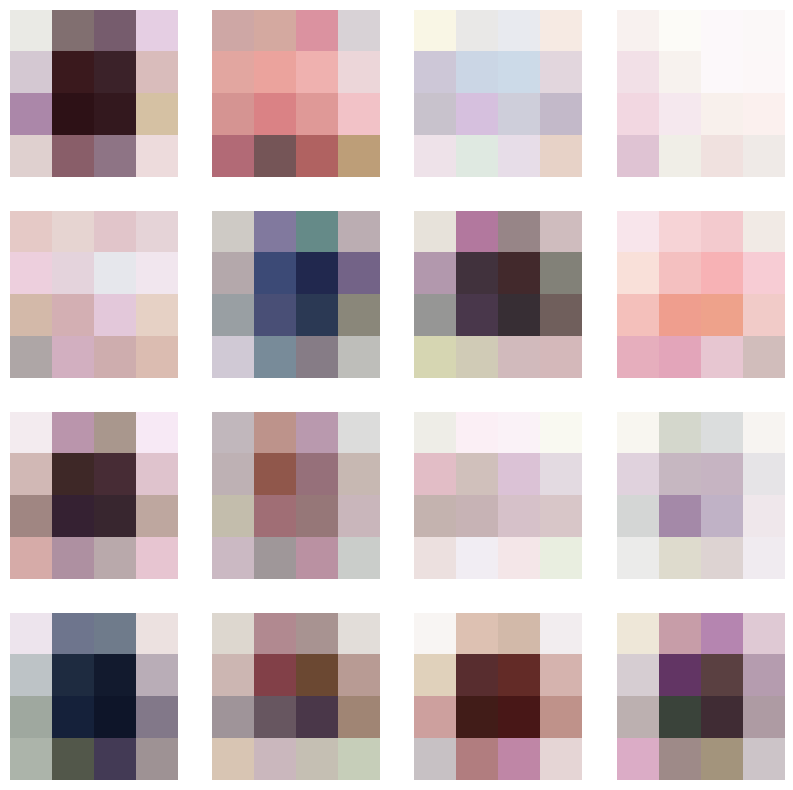

Step: 512
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7053610682487488
Generator loss: 1.6047881841659546


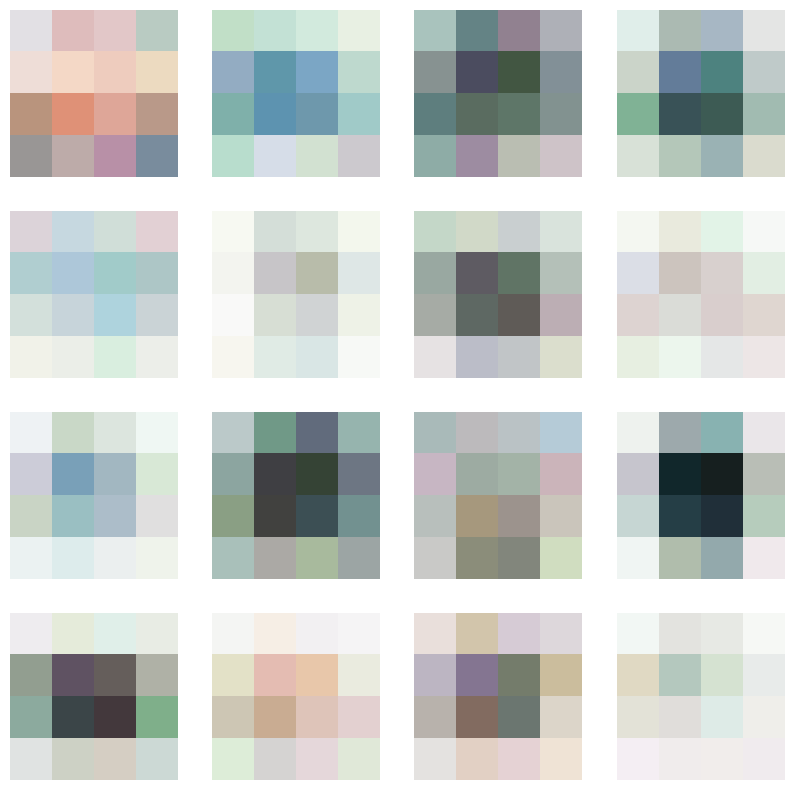

Step: 513
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7039607763290405
Generator loss: 1.6015900373458862


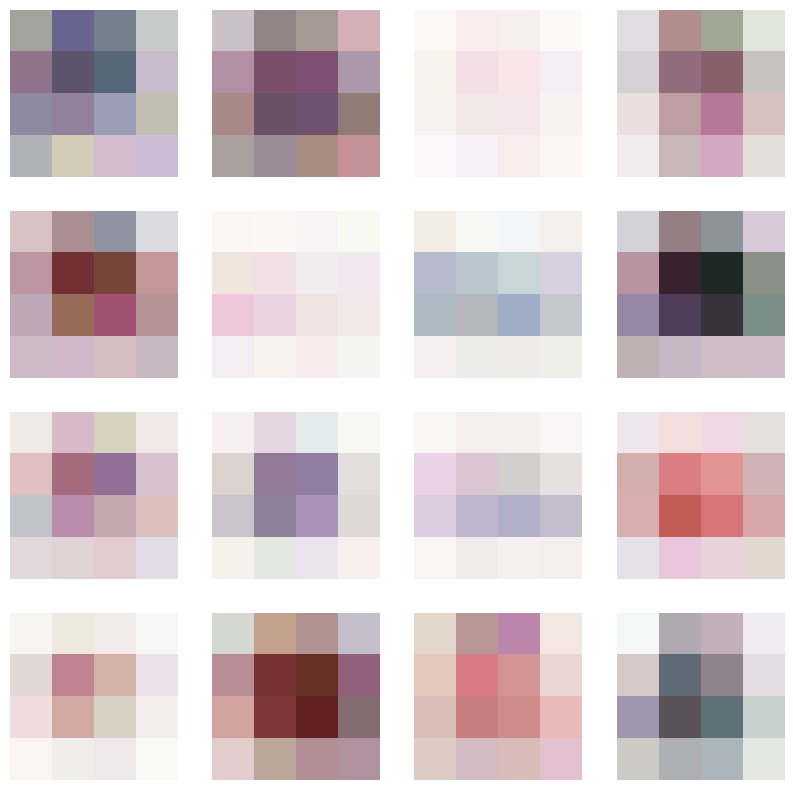

Step: 514
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7028186917304993
Generator loss: 1.5988572835922241


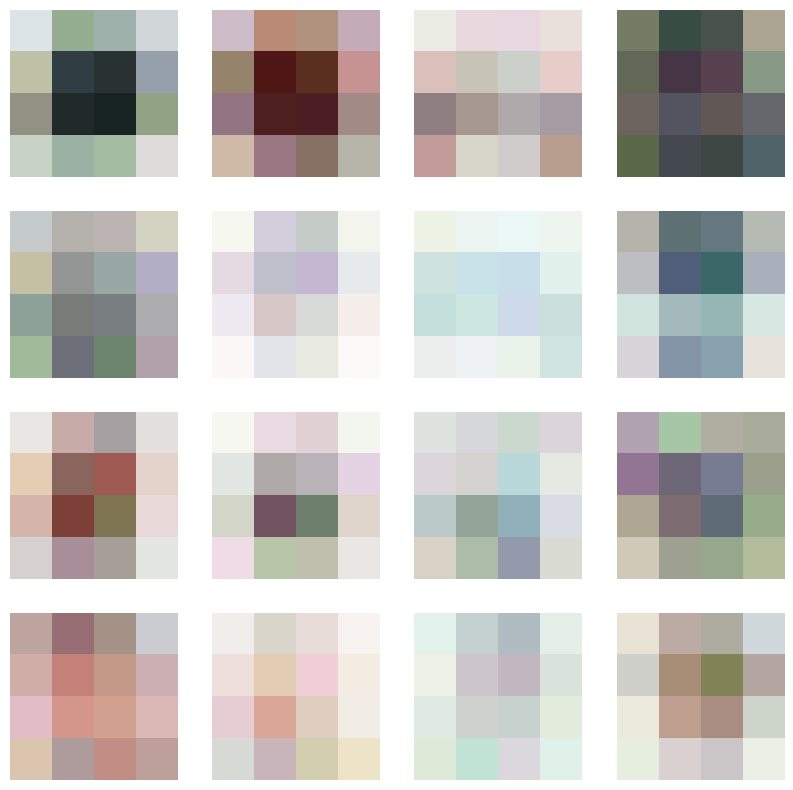

Step: 515
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7018309831619263
Generator loss: 1.5965371131896973


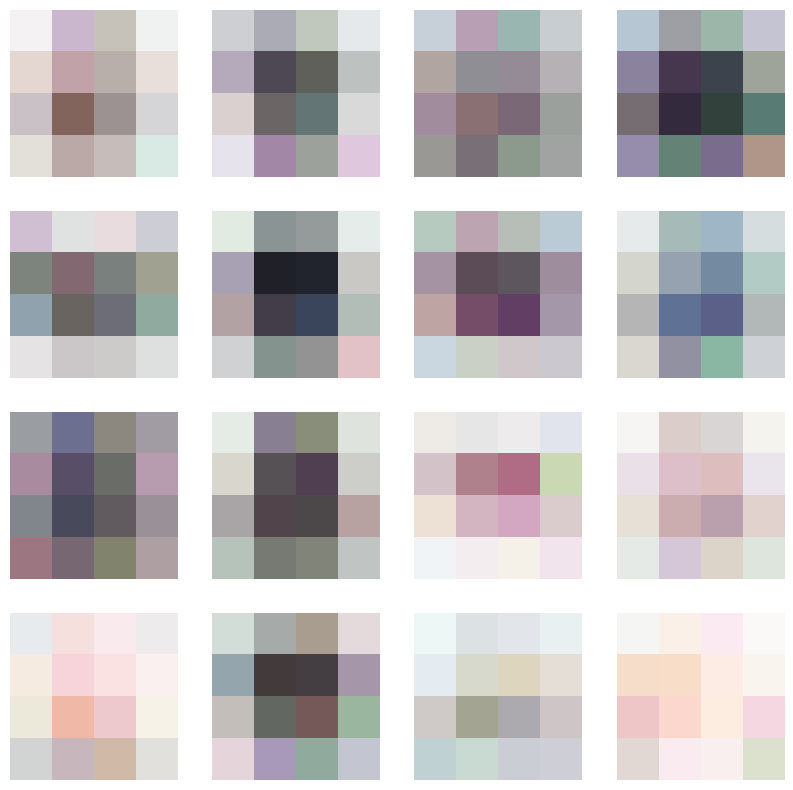

Step: 516
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7009004354476929
Generator loss: 1.5947299003601074


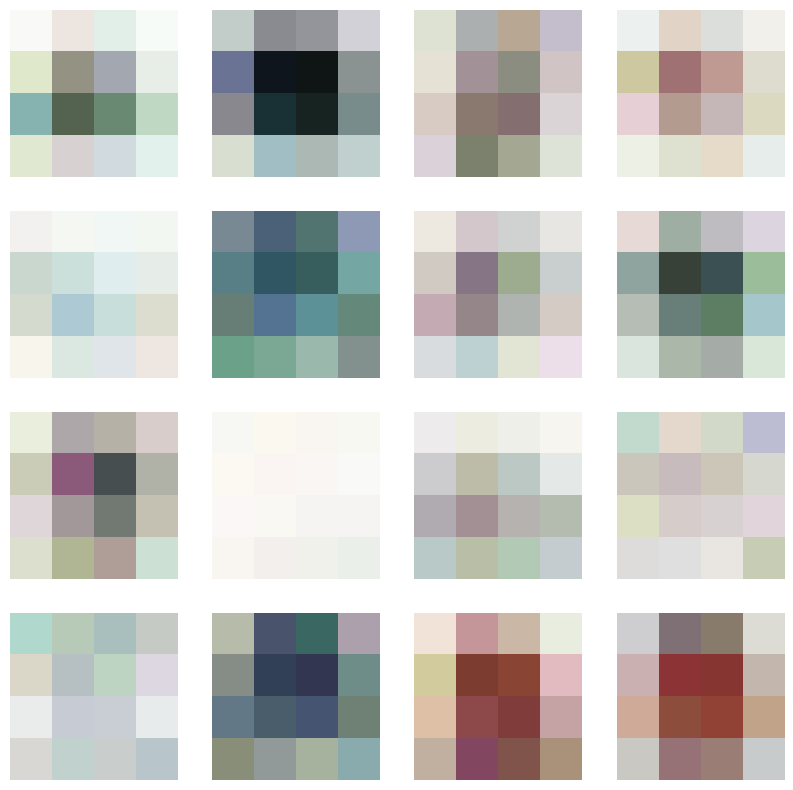

Step: 517
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.7000211477279663
Generator loss: 1.592522382736206


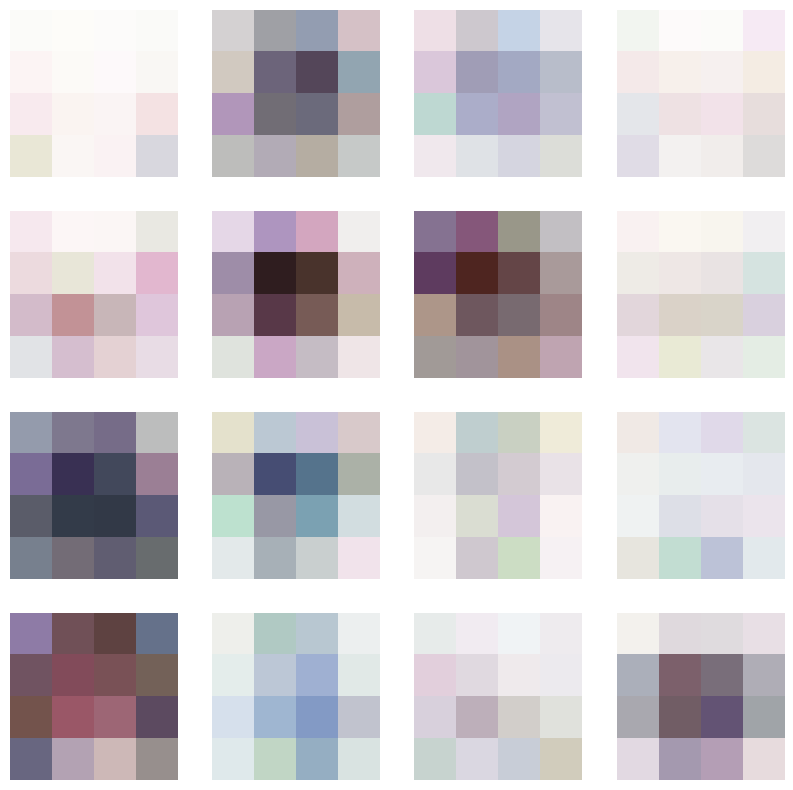

Step: 518
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6988036632537842
Generator loss: 1.5893868207931519


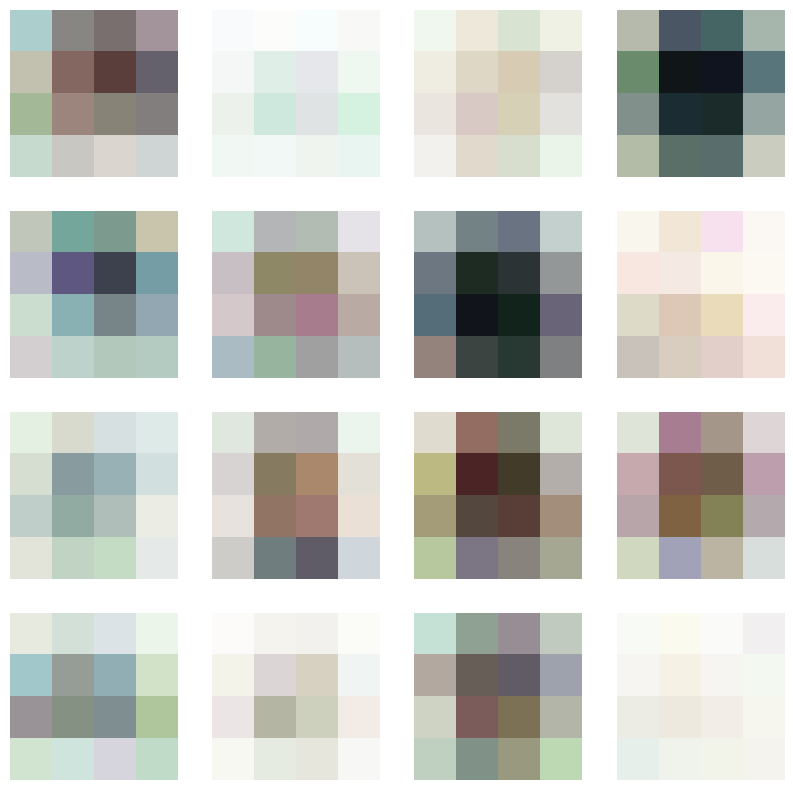

Step: 519
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6978325247764587
Generator loss: 1.5863717794418335


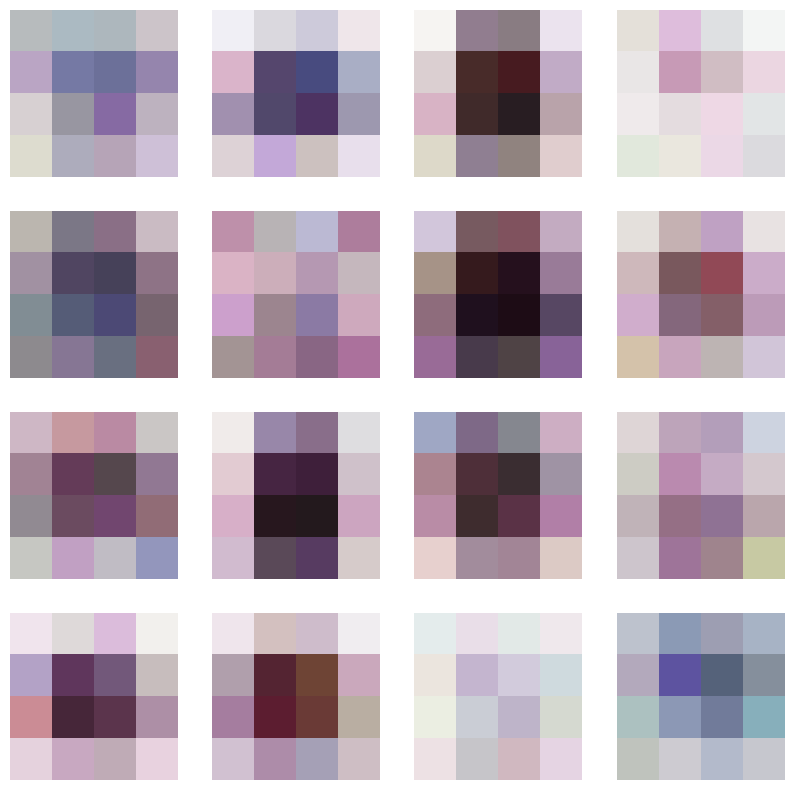

Step: 520
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6969053149223328
Generator loss: 1.5832356214523315


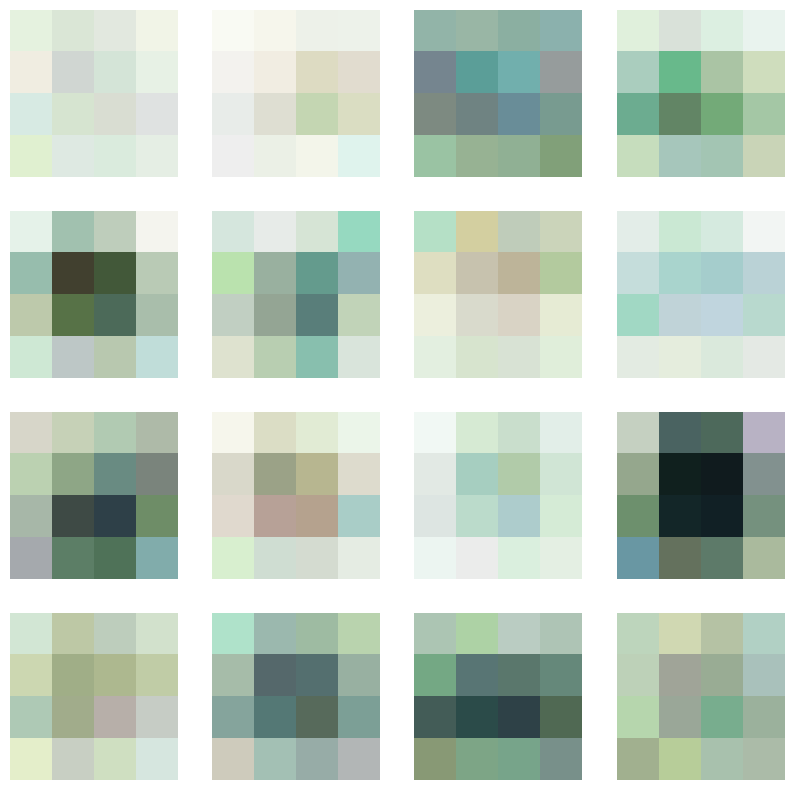

Step: 521
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6961233615875244
Generator loss: 1.5801361799240112


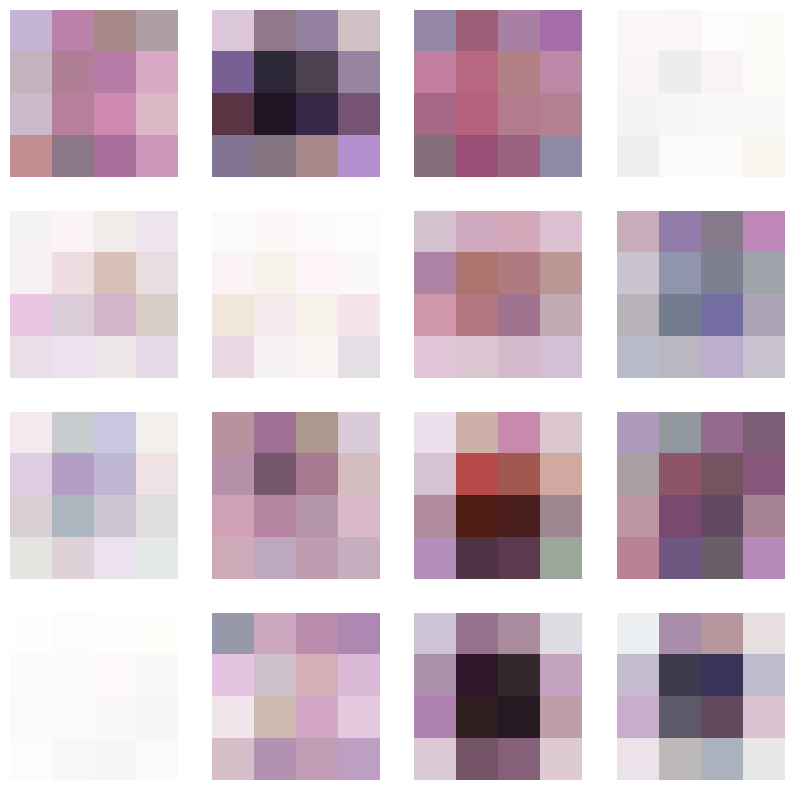

Step: 522
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6951937079429626
Generator loss: 1.57686185836792


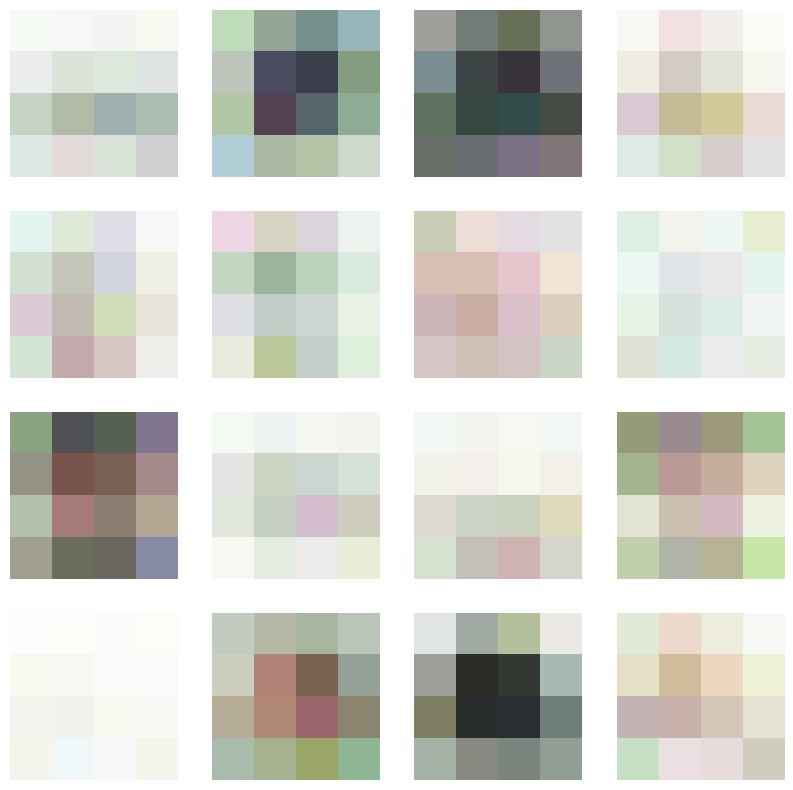

Step: 523
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6941978931427002
Generator loss: 1.5733330249786377


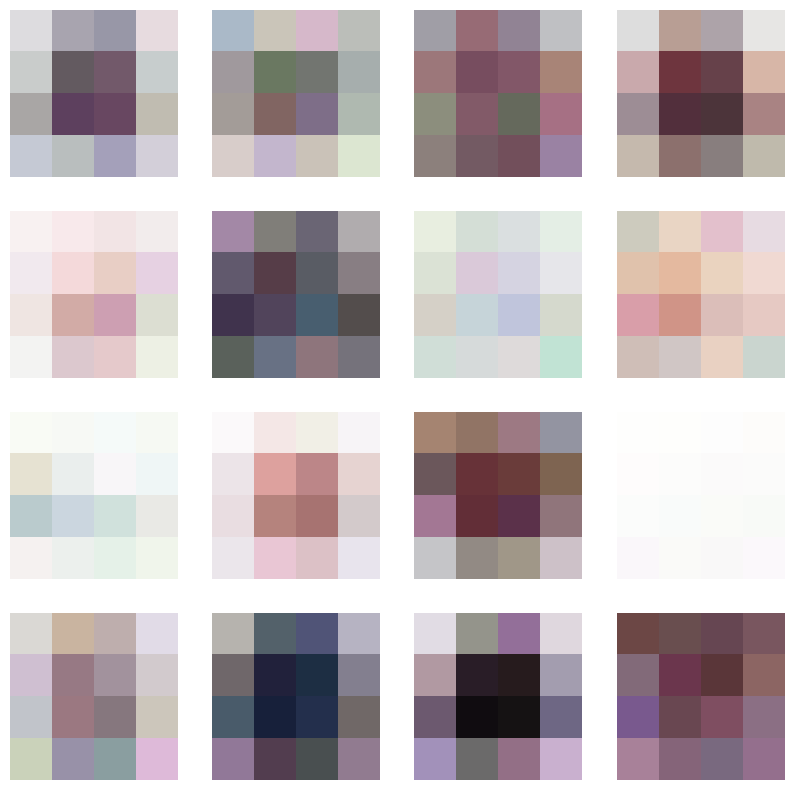

Step: 524
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6932166218757629
Generator loss: 1.5696463584899902


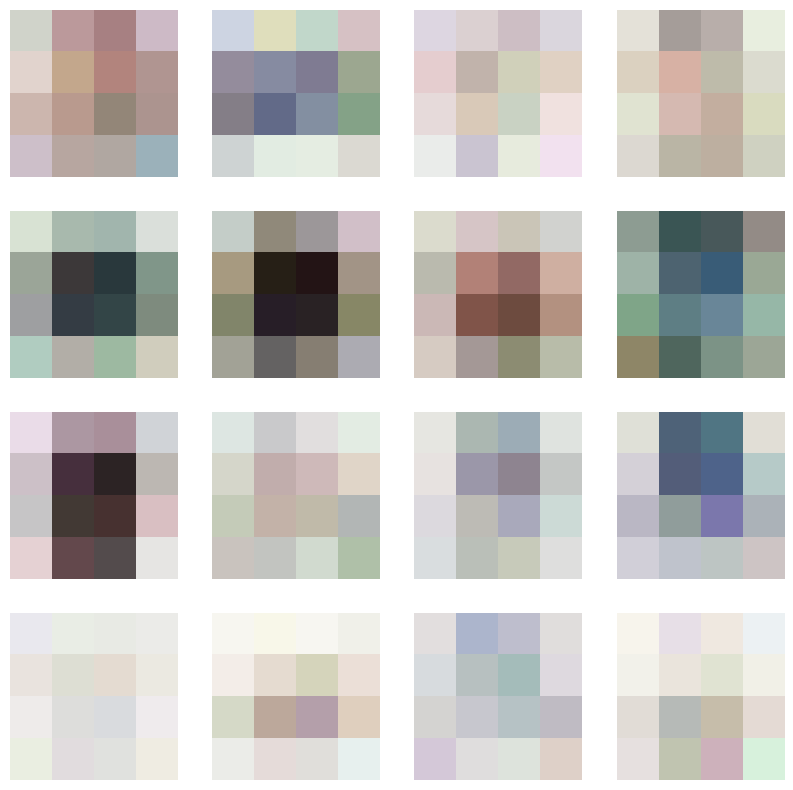

Step: 525
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.692363440990448
Generator loss: 1.5653598308563232


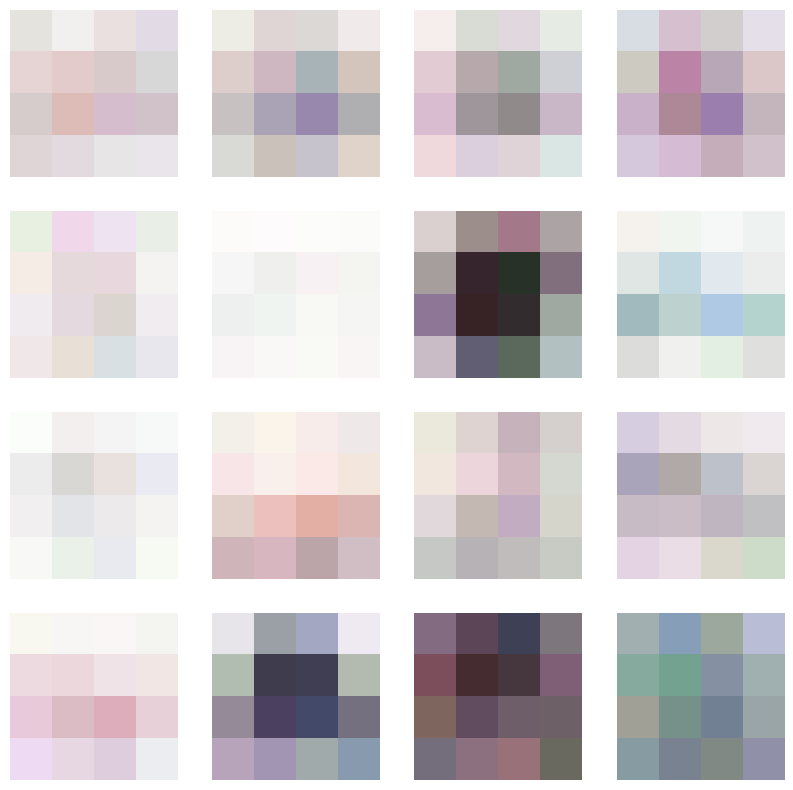

Step: 526
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6912966966629028
Generator loss: 1.5621209144592285


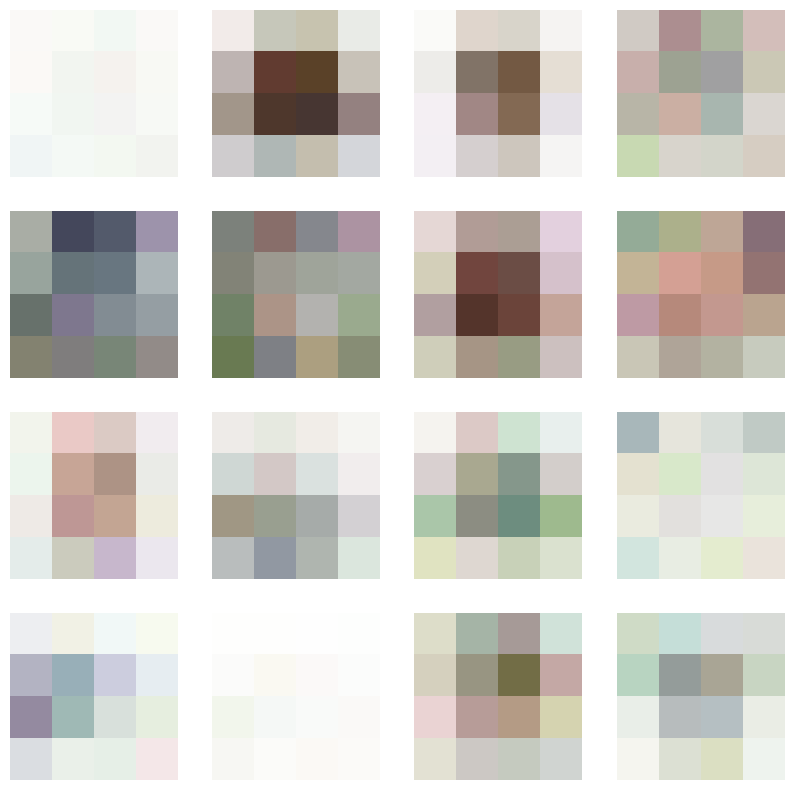

Step: 527
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6903505325317383
Generator loss: 1.5603973865509033


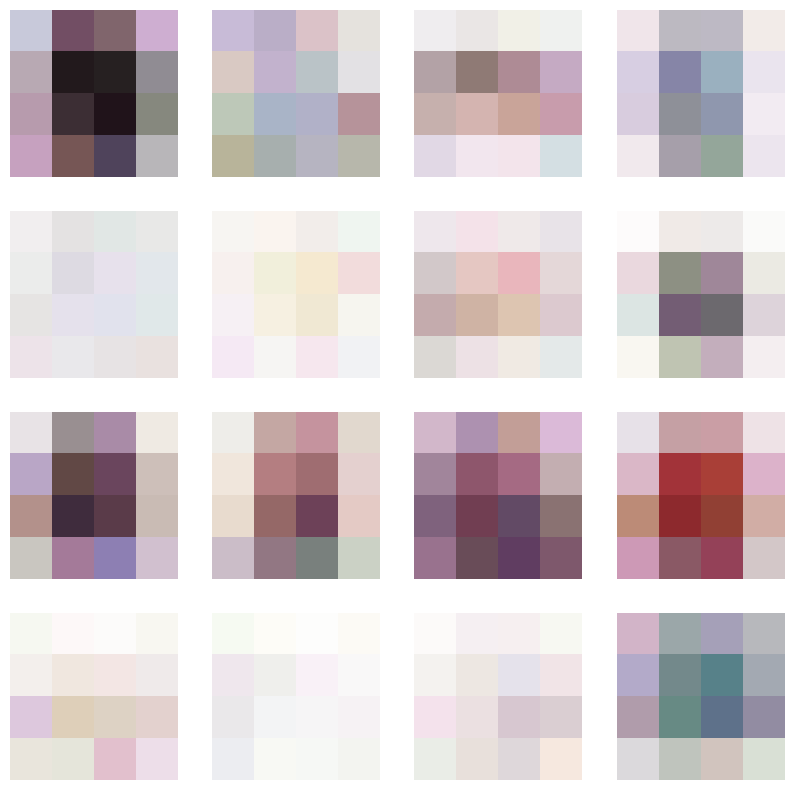

Step: 528
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6893544793128967
Generator loss: 1.5574668645858765


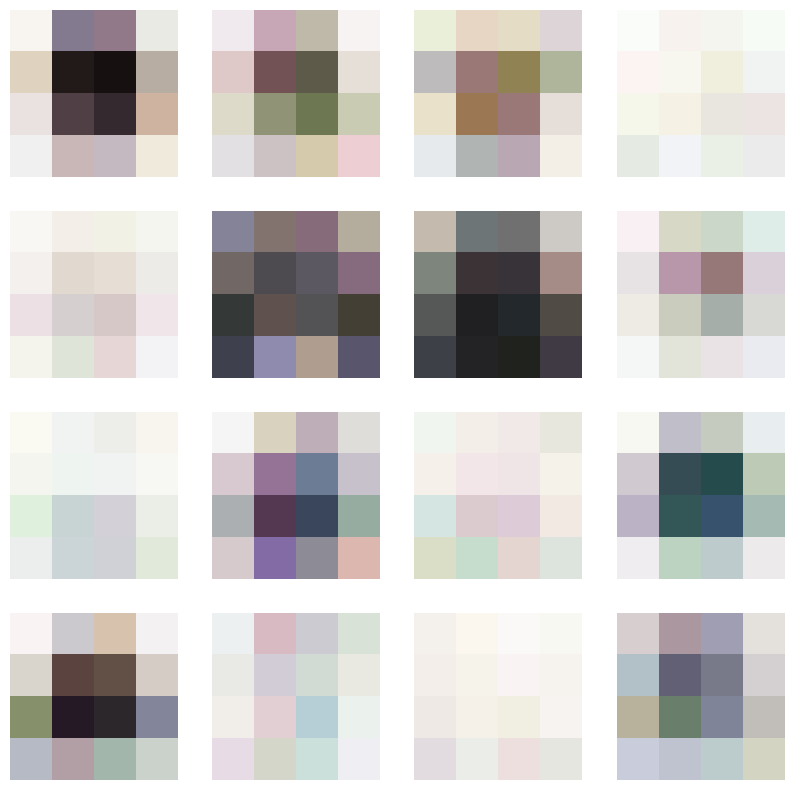

Step: 529
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6882650852203369
Generator loss: 1.554710865020752


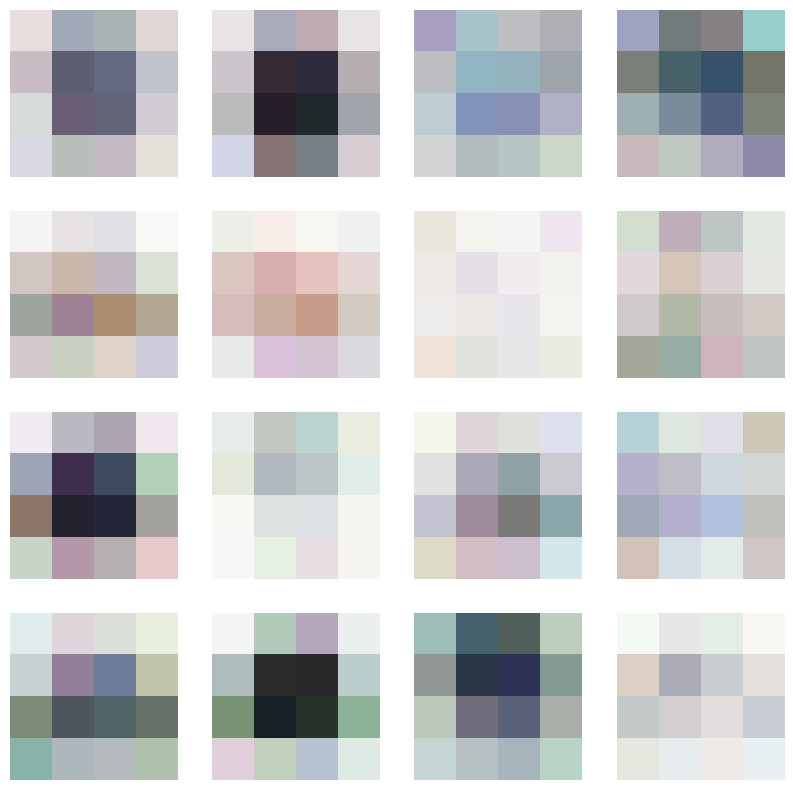

Step: 530
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6873459219932556
Generator loss: 1.5516414642333984


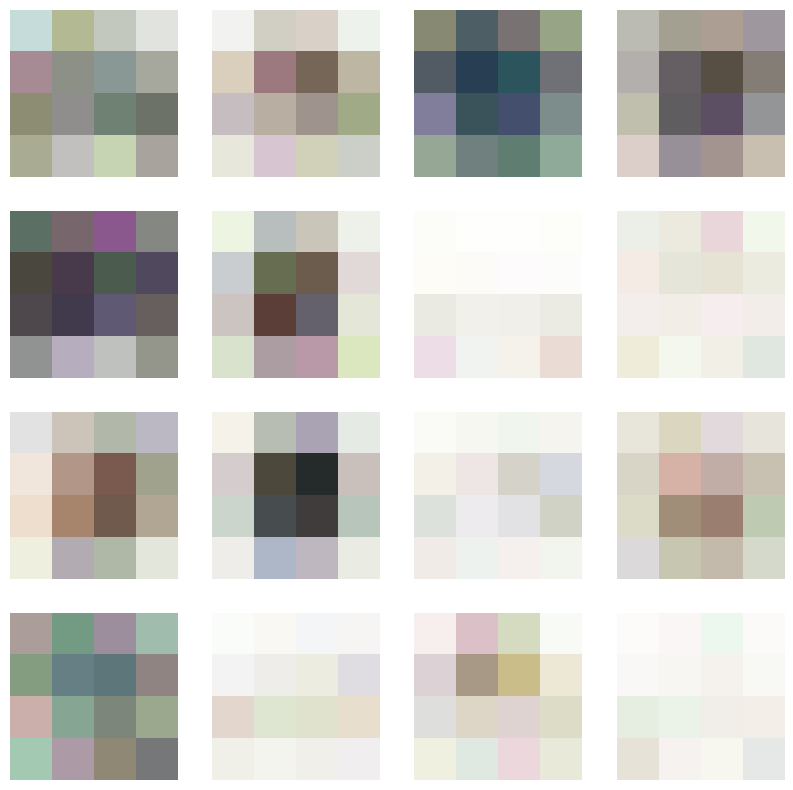

Step: 531
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6861949563026428
Generator loss: 1.548494815826416


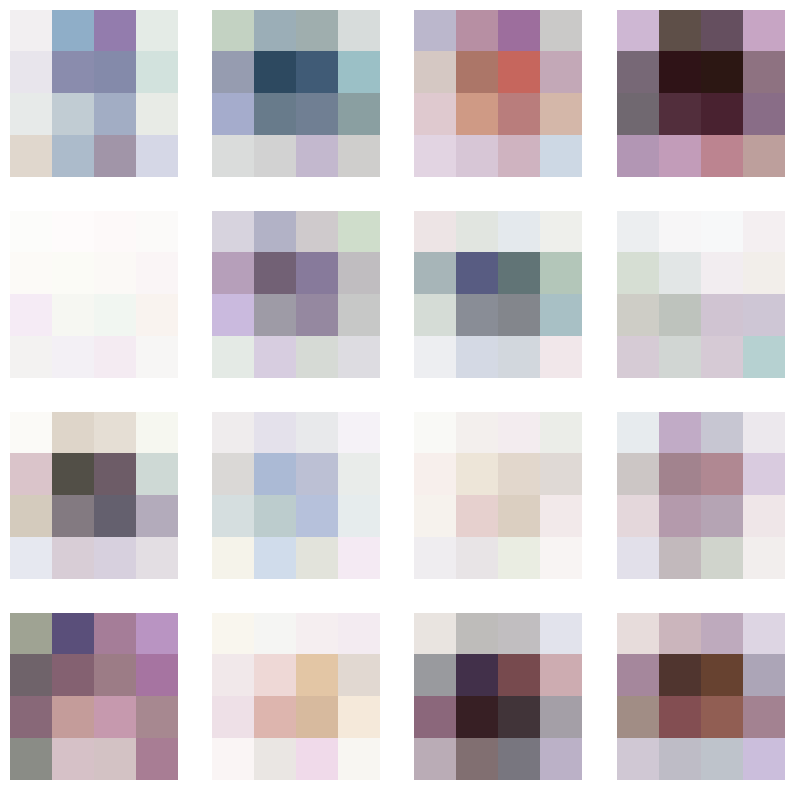

Step: 532
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6852866411209106
Generator loss: 1.5453343391418457


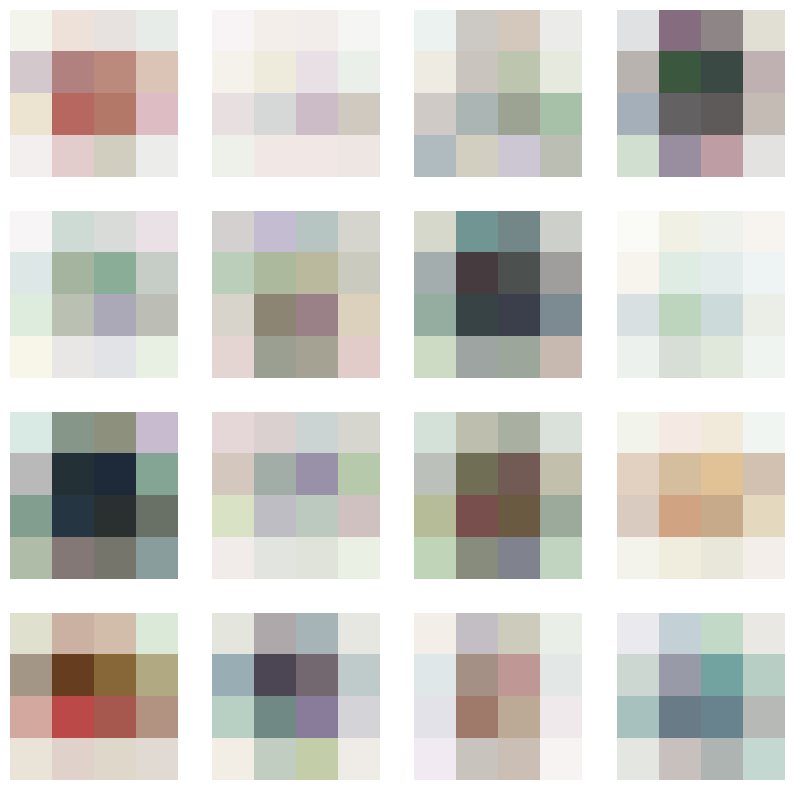

Step: 533
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6843187808990479
Generator loss: 1.5425091981887817


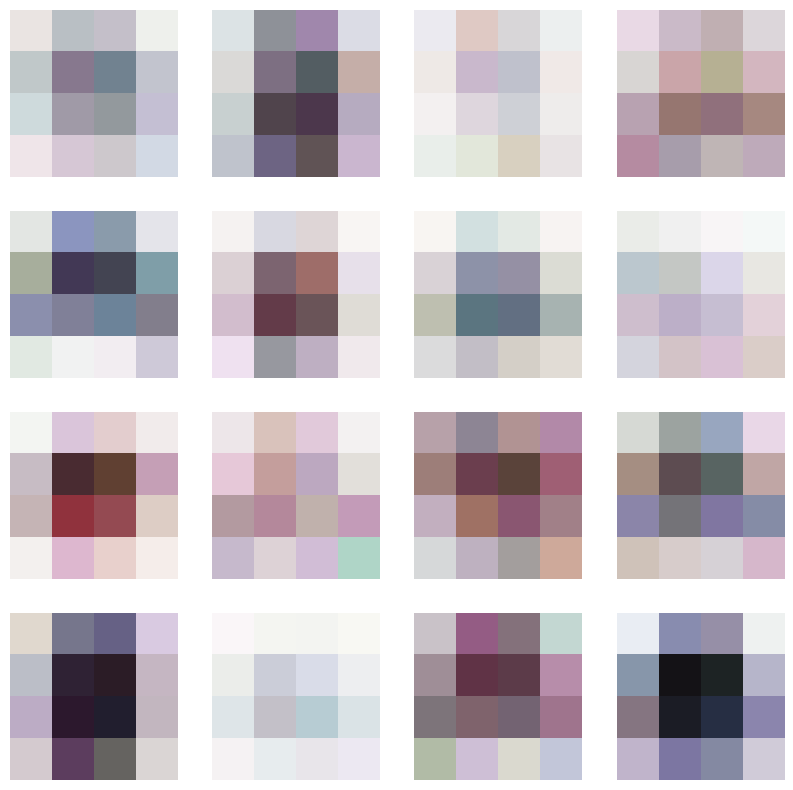

Step: 534
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6834923624992371
Generator loss: 1.5401184558868408


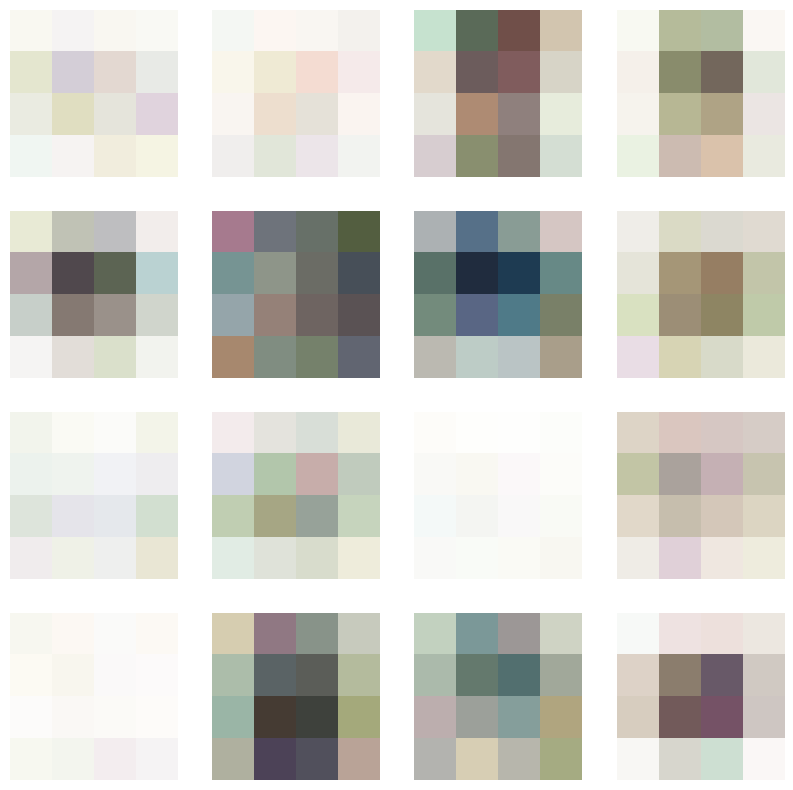

Step: 535
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.682459831237793
Generator loss: 1.537764072418213


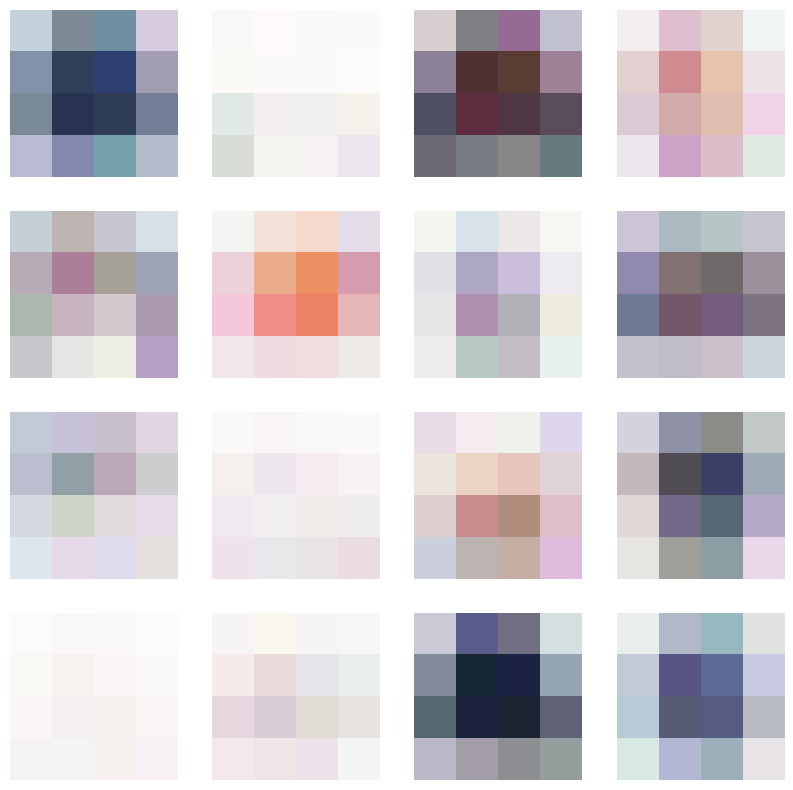

Step: 536
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6814846992492676
Generator loss: 1.5350120067596436


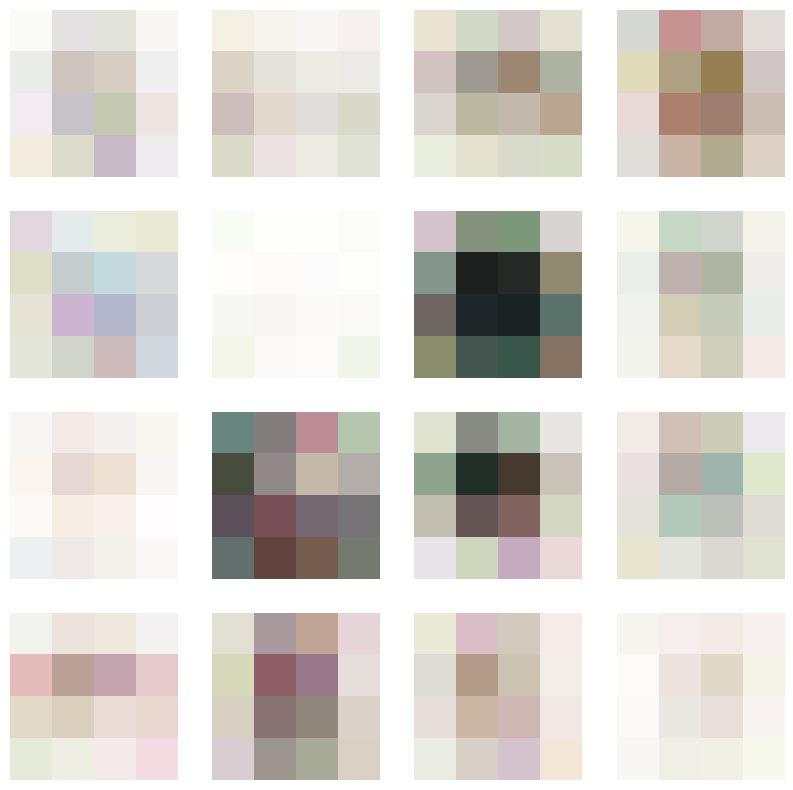

Step: 537
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6803944706916809
Generator loss: 1.5327568054199219


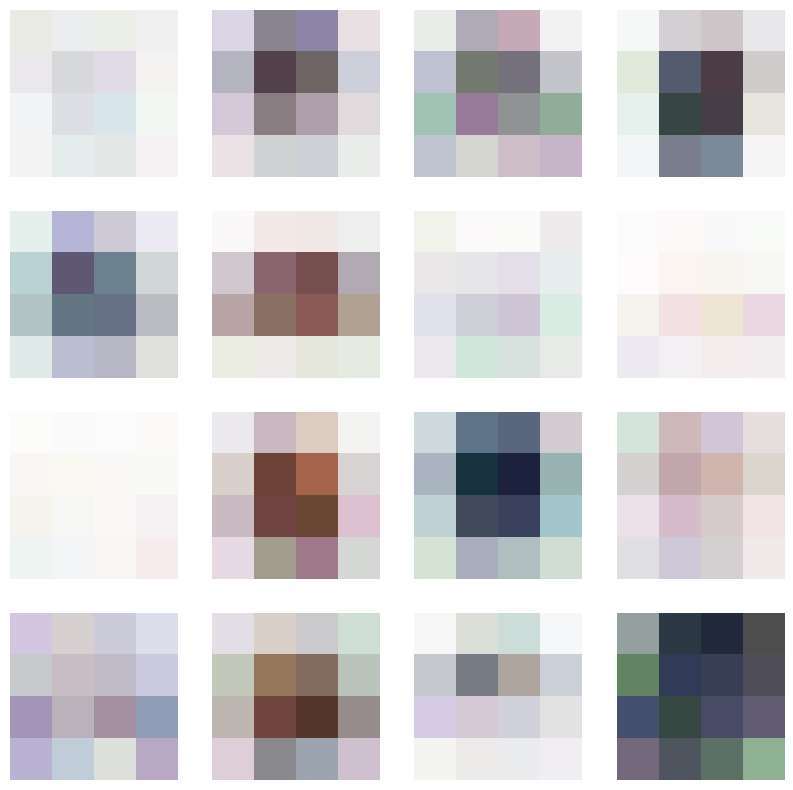

Step: 538
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6795998811721802
Generator loss: 1.5306233167648315


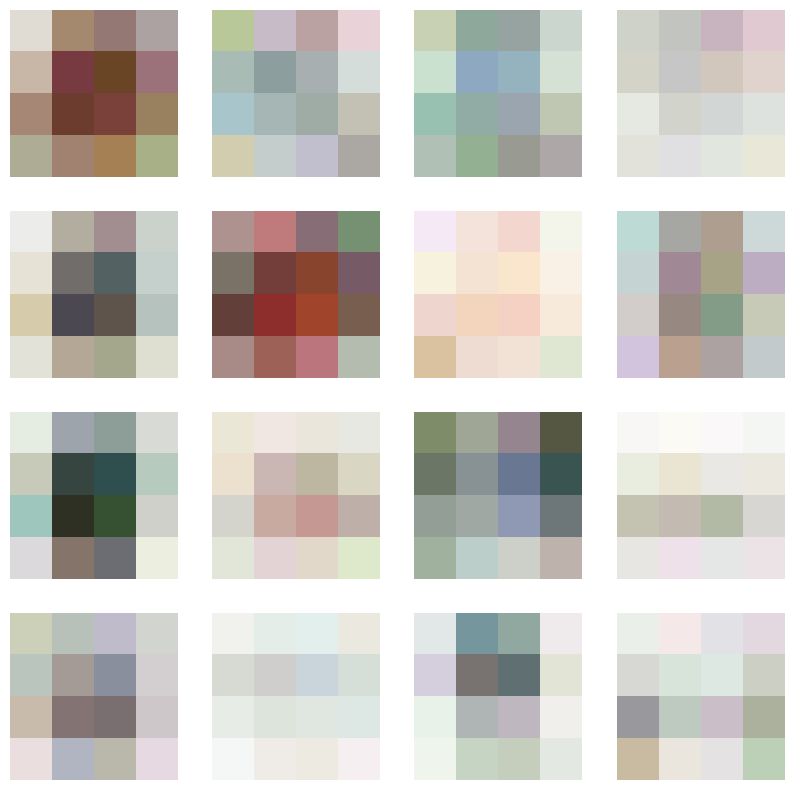

Step: 539
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6787216067314148
Generator loss: 1.5277379751205444


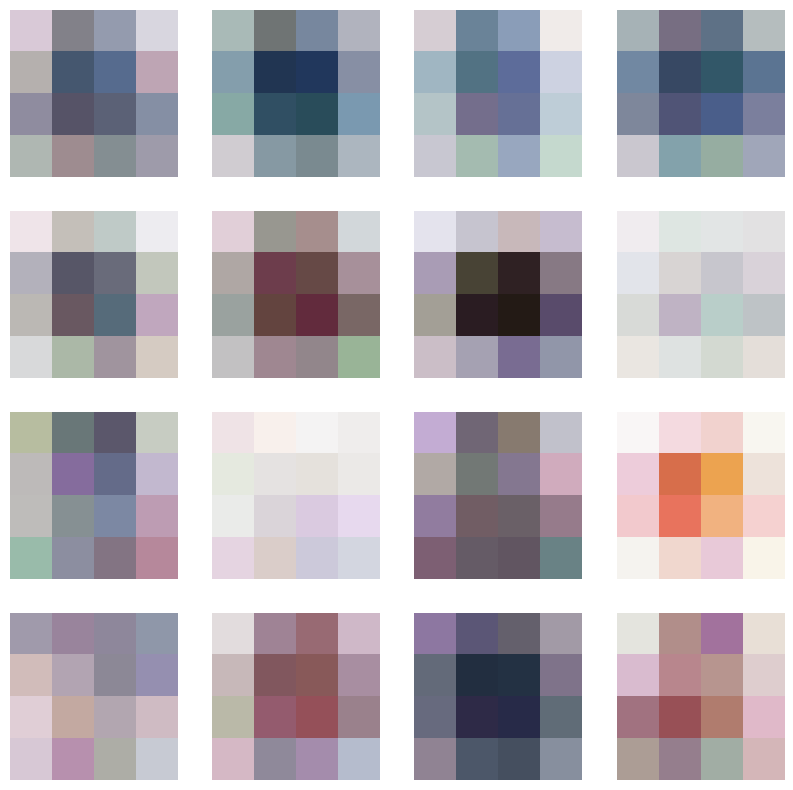

Step: 540
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6774981021881104
Generator loss: 1.5242174863815308


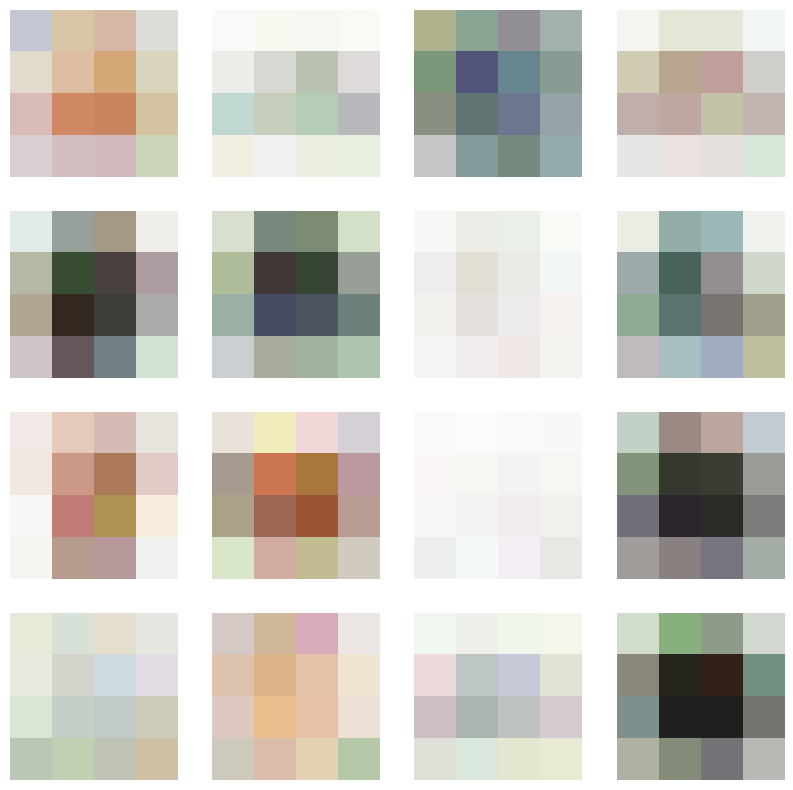

Step: 541
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6767598986625671
Generator loss: 1.520050048828125


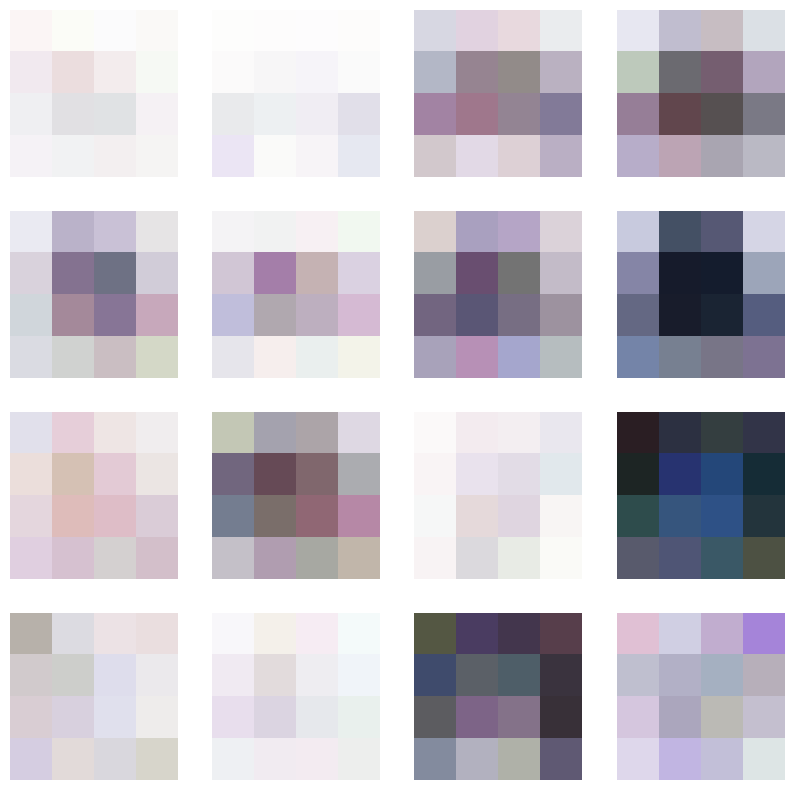

Step: 542
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6758914589881897
Generator loss: 1.5157641172409058


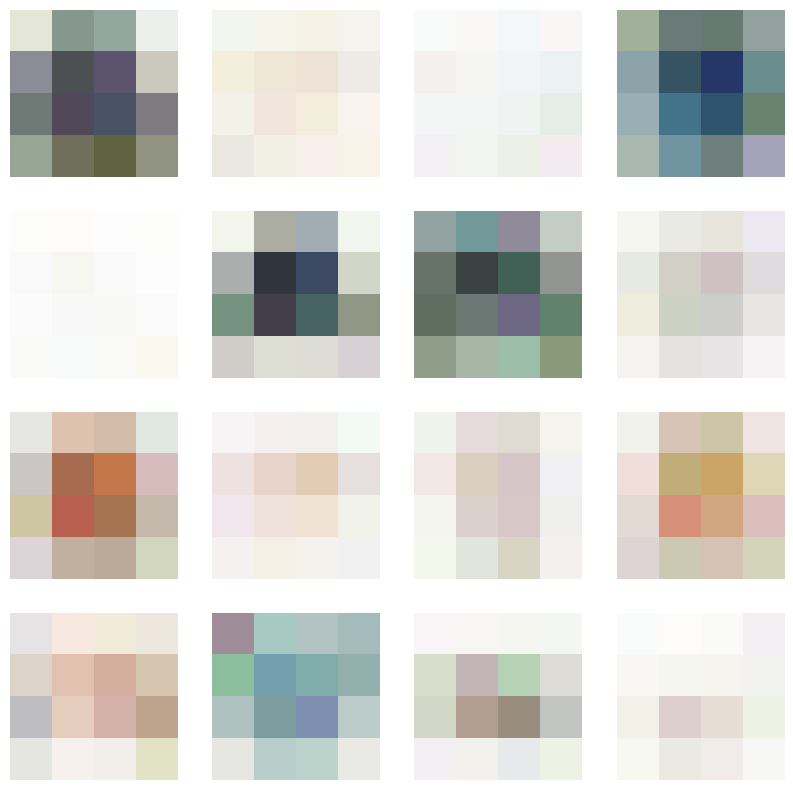

Step: 543
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6744392514228821
Generator loss: 1.5125938653945923


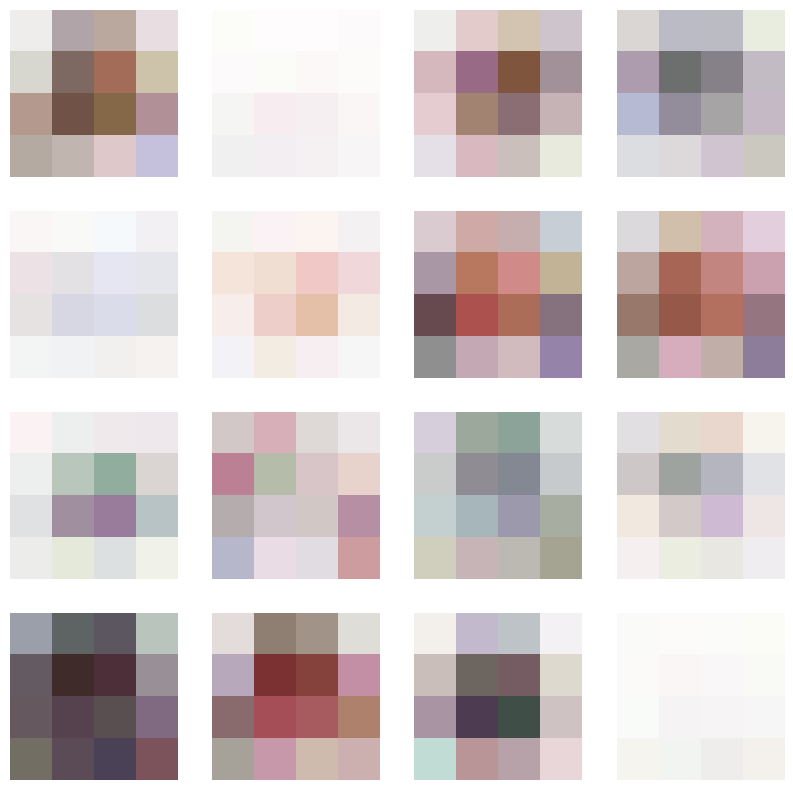

Step: 544
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6734885573387146
Generator loss: 1.5100526809692383


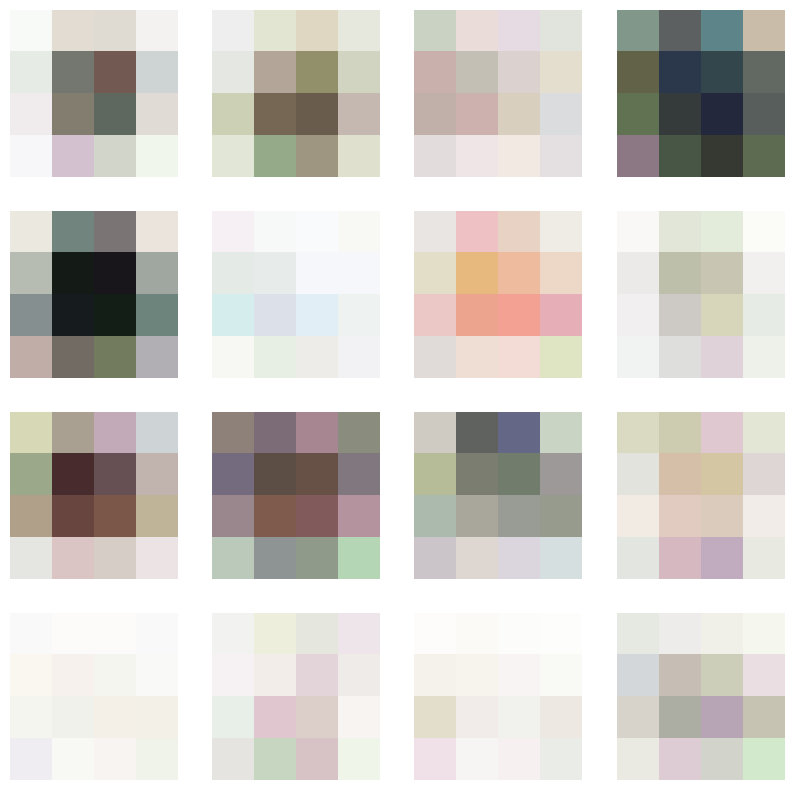

Step: 545
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6724706888198853
Generator loss: 1.5070891380310059


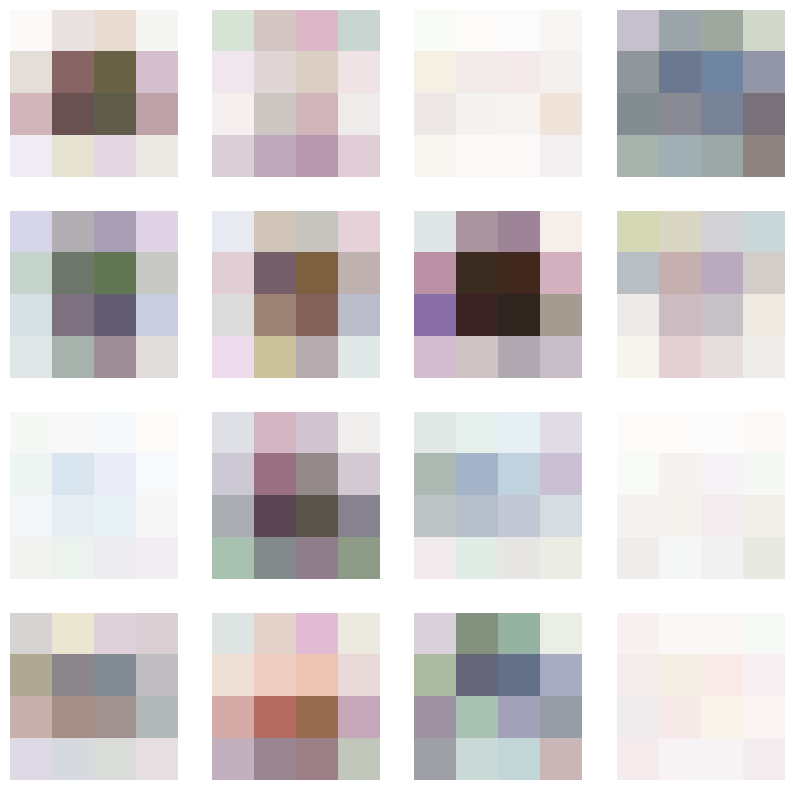

Step: 546
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6716123819351196
Generator loss: 1.5044547319412231


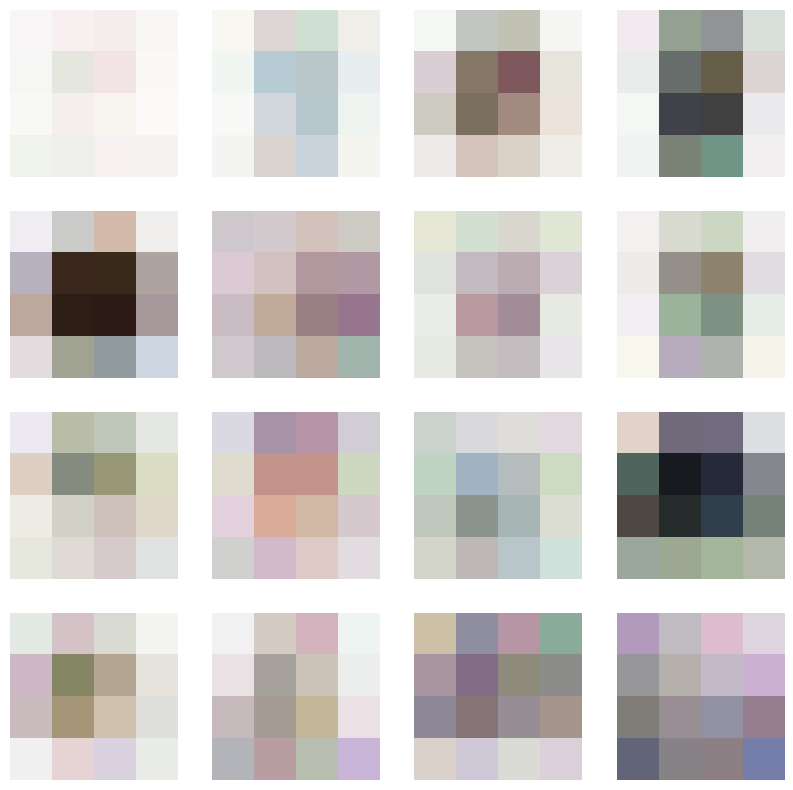

Step: 547
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6705781817436218
Generator loss: 1.5012959241867065


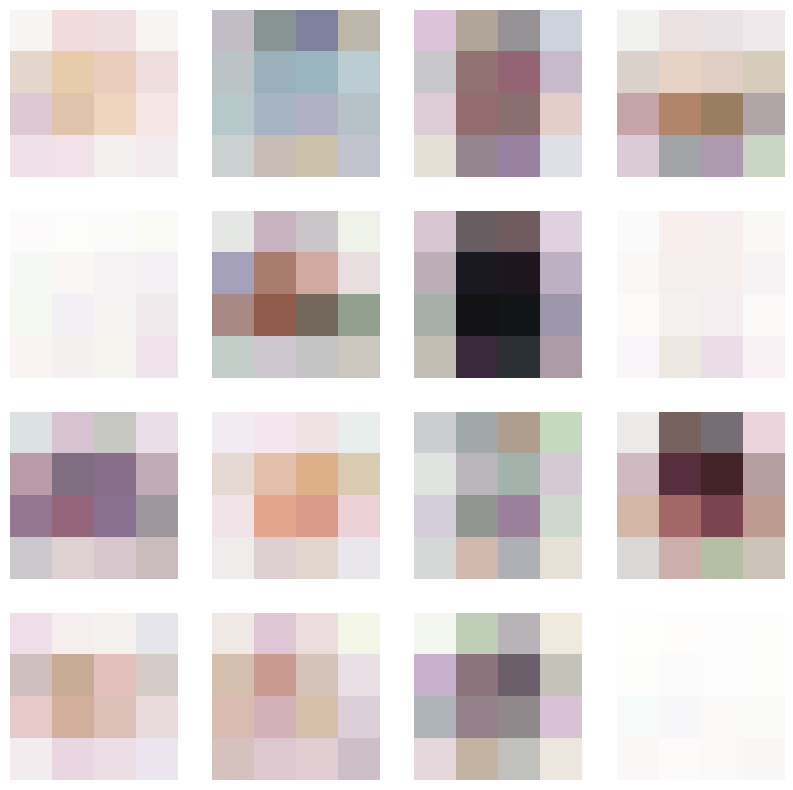

Step: 548
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6695857048034668
Generator loss: 1.4985320568084717


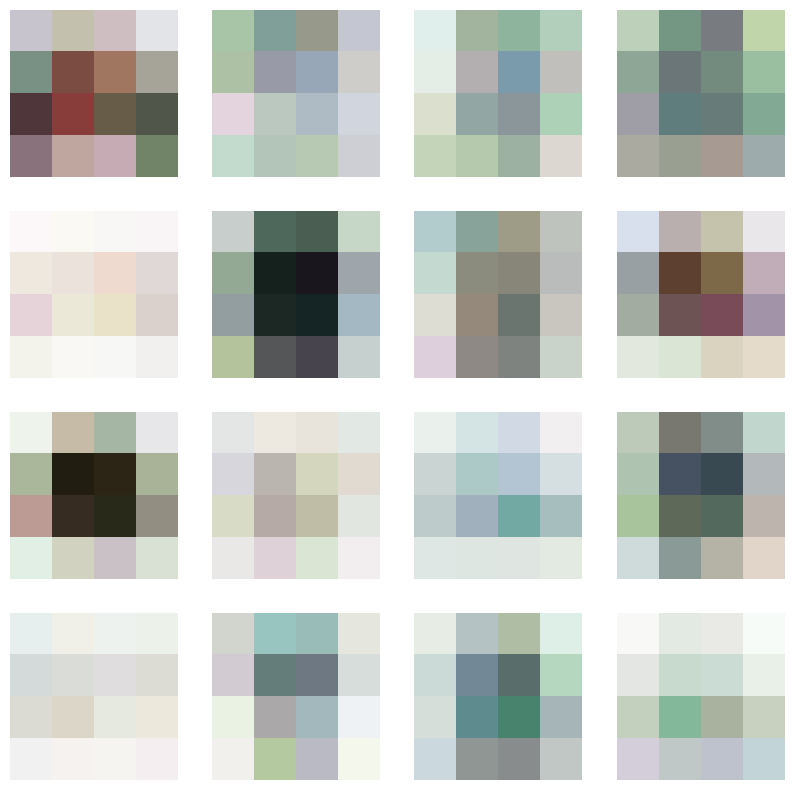

Step: 549
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6686252951622009
Generator loss: 1.4959064722061157


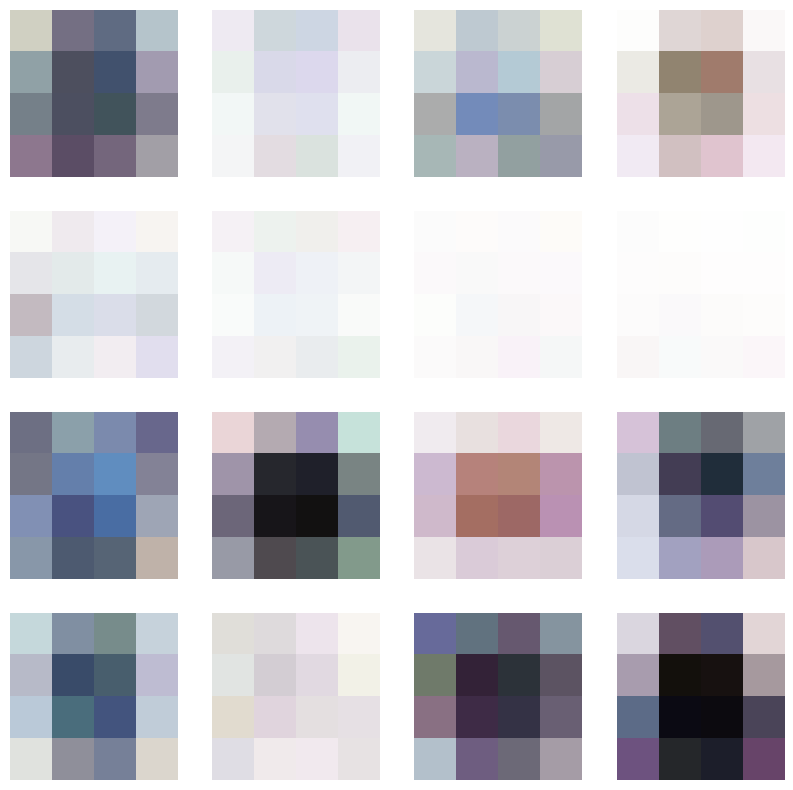

Step: 550
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6677543520927429
Generator loss: 1.493140697479248


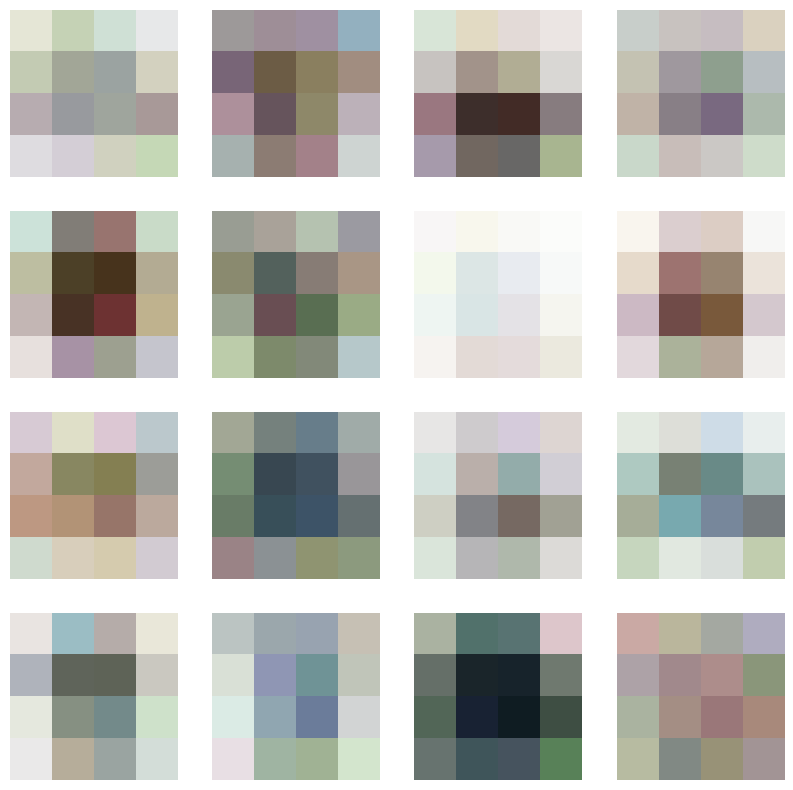

Step: 551
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6669043302536011
Generator loss: 1.4906105995178223


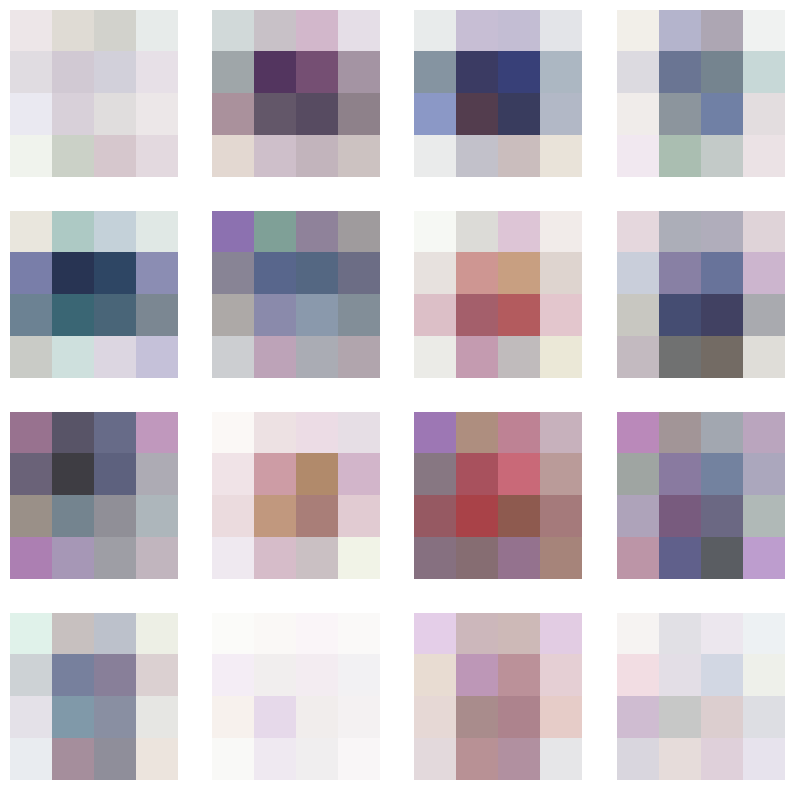

Step: 552
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6661481857299805
Generator loss: 1.4885131120681763


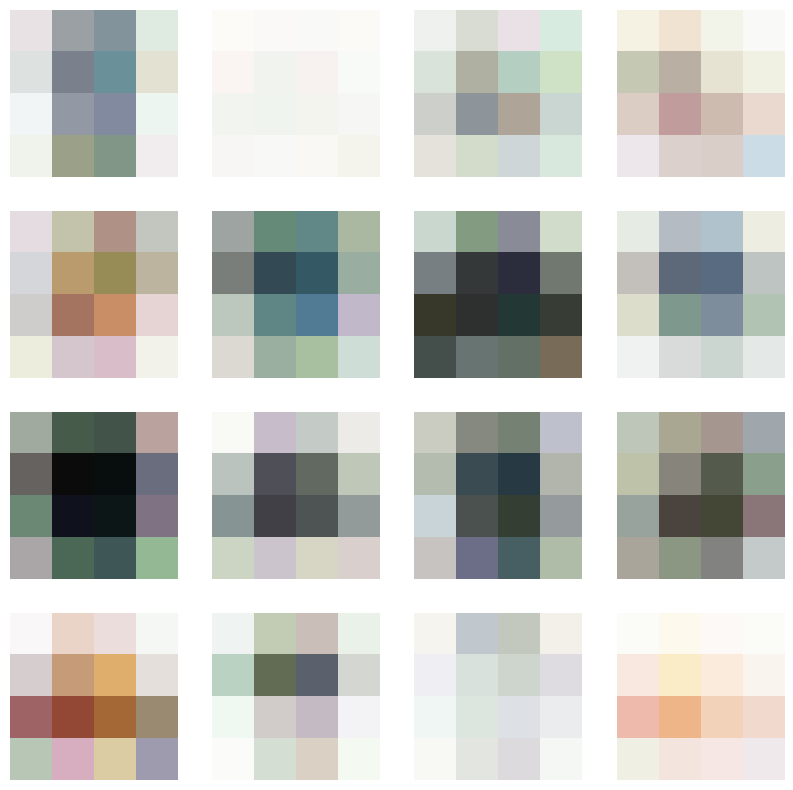

Step: 553
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.665377140045166
Generator loss: 1.4864788055419922


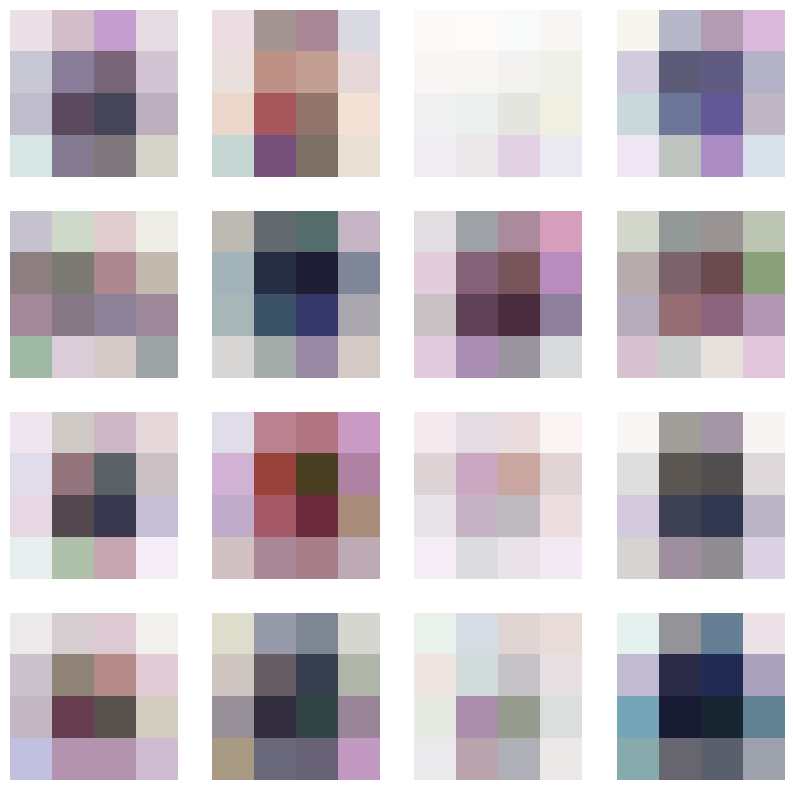

Step: 554
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6646336317062378
Generator loss: 1.4849275350570679


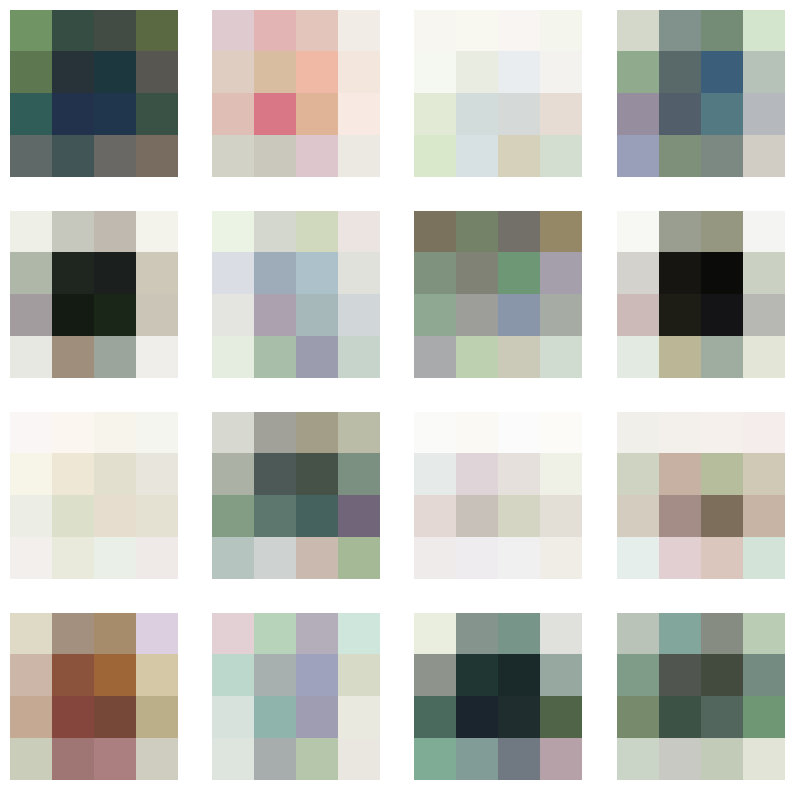

Step: 555
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6629722118377686
Generator loss: 1.4820986986160278


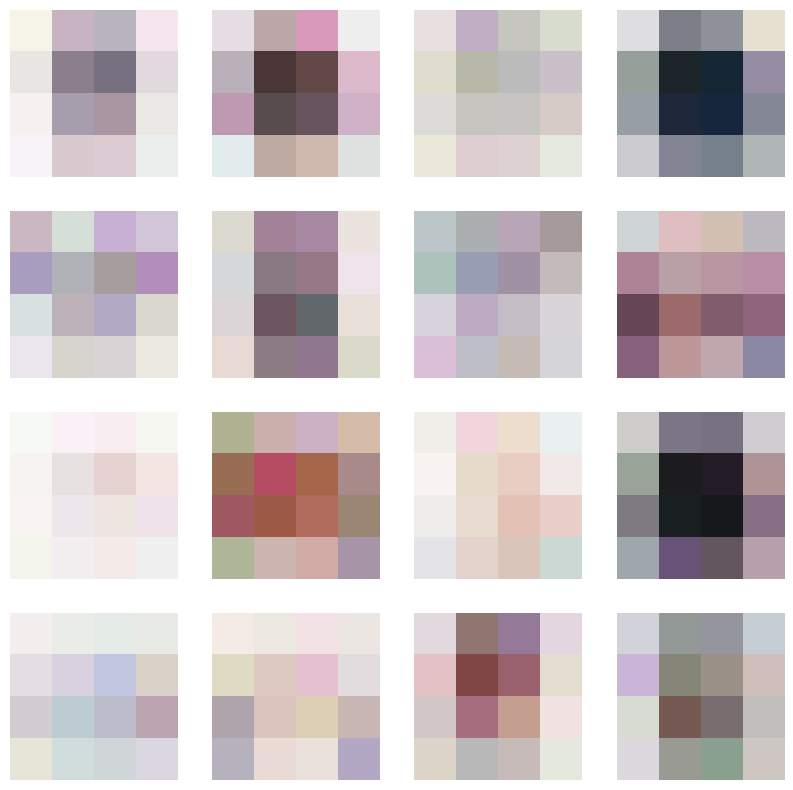

Step: 556
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6621477007865906
Generator loss: 1.4789392948150635


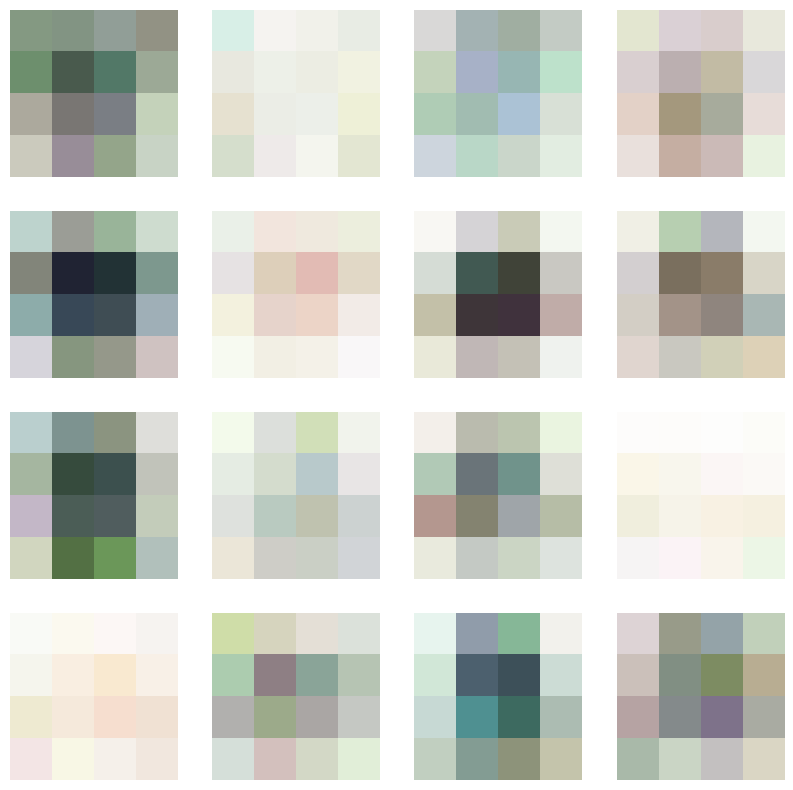

Step: 557
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6610490083694458
Generator loss: 1.4759514331817627


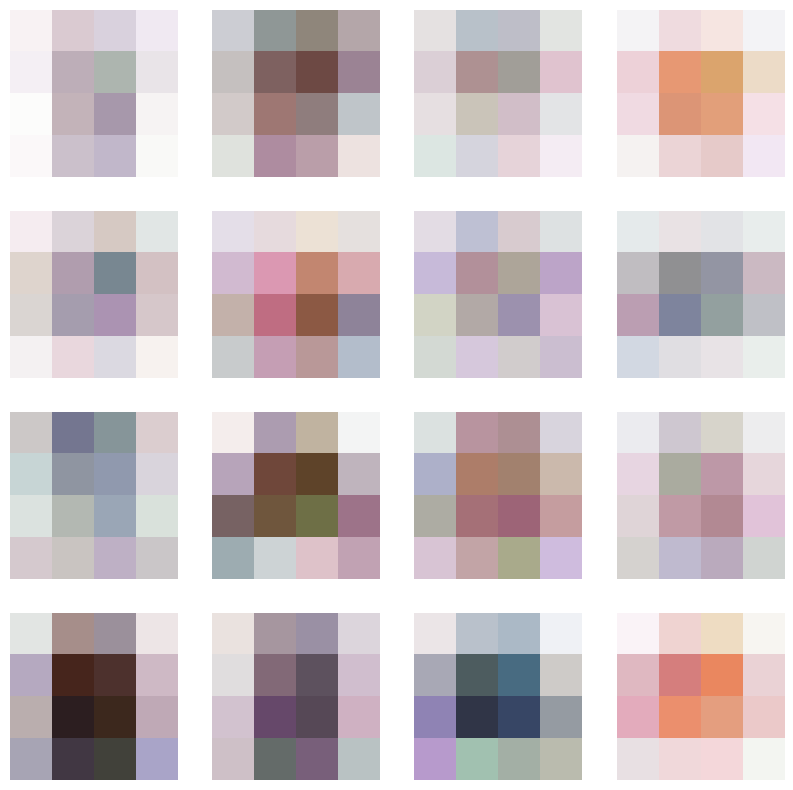

Step: 558
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6601117253303528
Generator loss: 1.4732917547225952


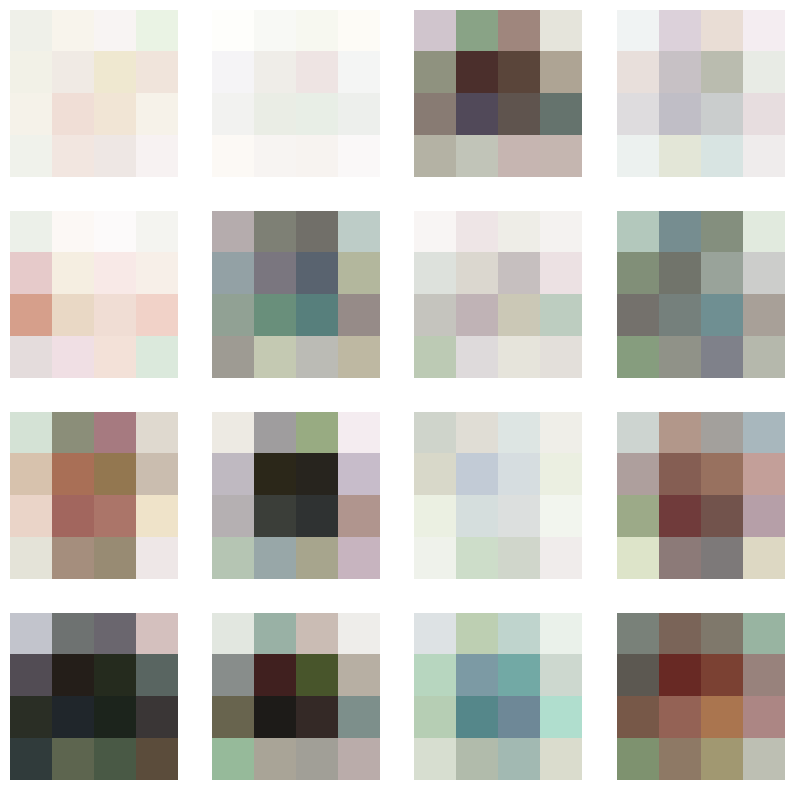

Step: 559
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6589434146881104
Generator loss: 1.4720227718353271


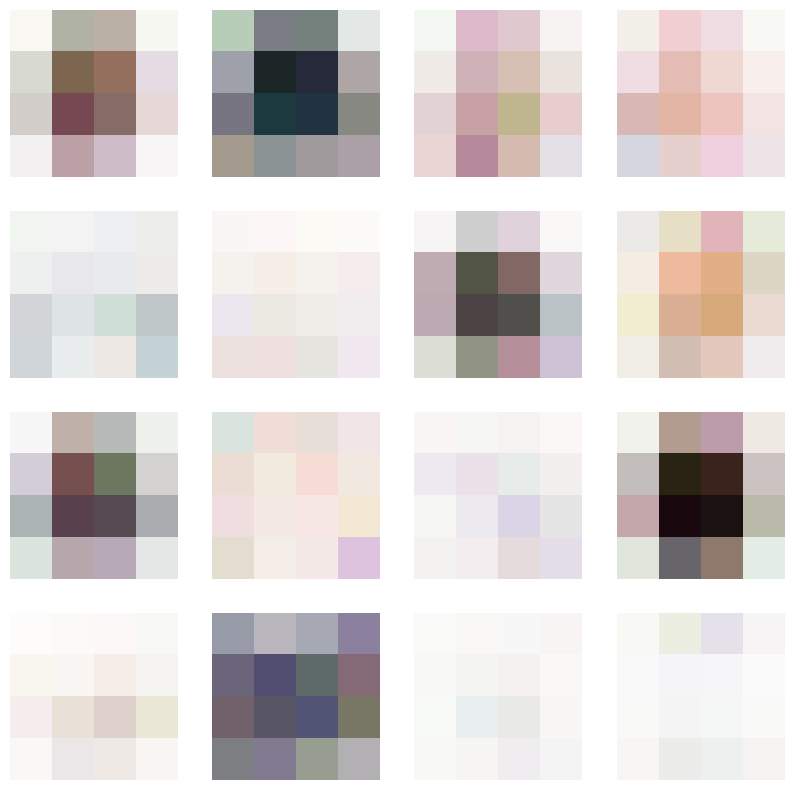

Step: 560
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6581436991691589
Generator loss: 1.4717472791671753


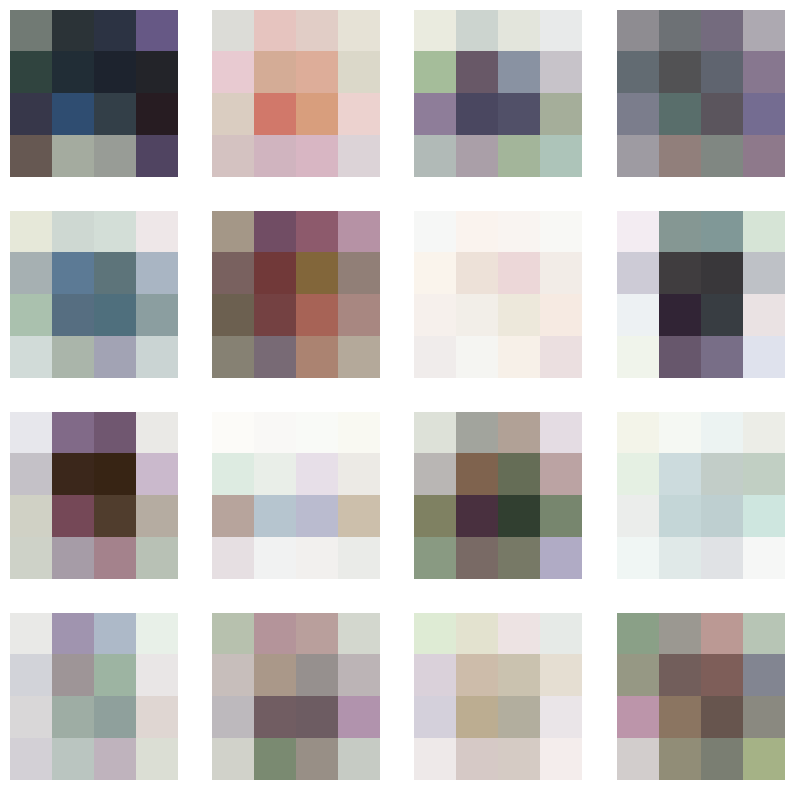

Step: 561
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6573824286460876
Generator loss: 1.4708143472671509


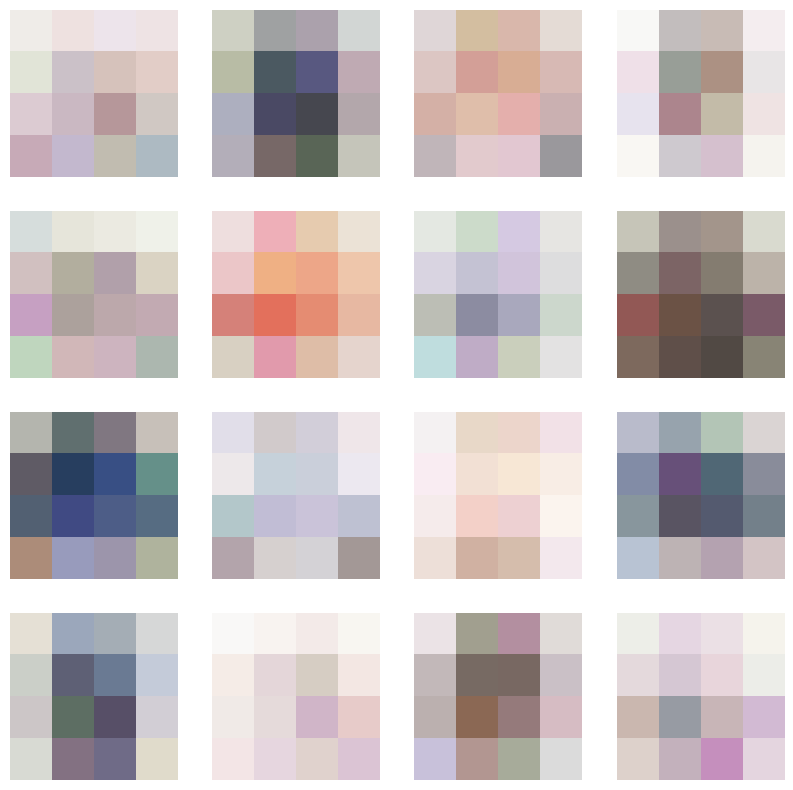

Step: 562
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6561880707740784
Generator loss: 1.468445062637329


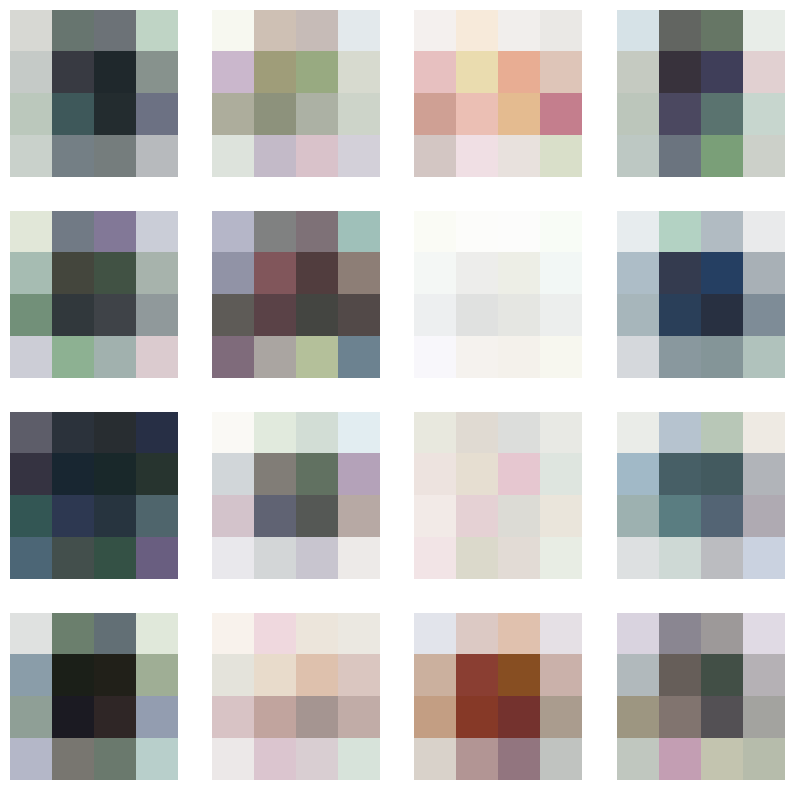

Step: 563
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6553000211715698
Generator loss: 1.4654738903045654


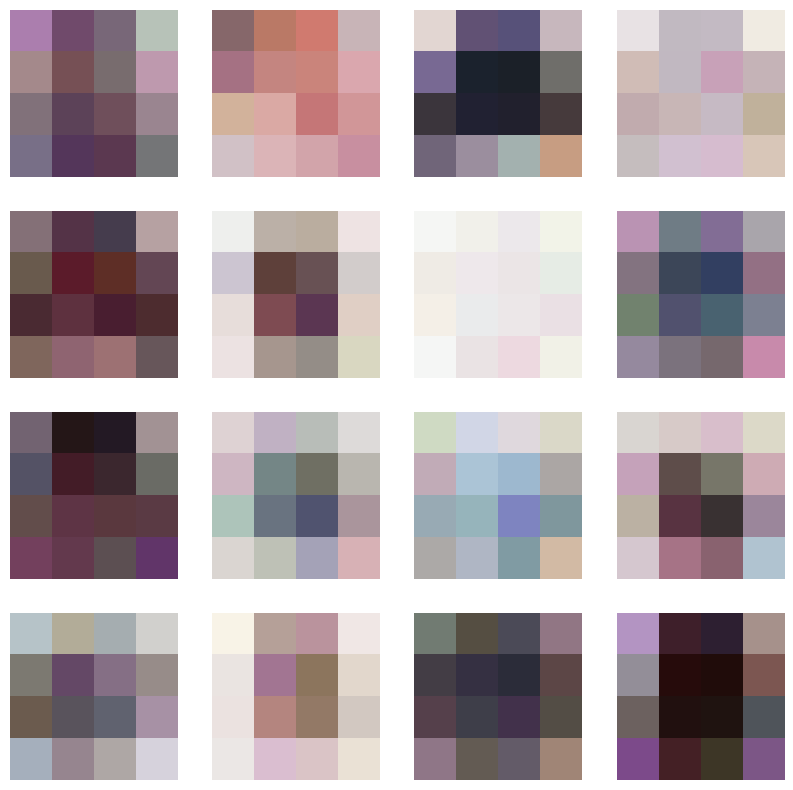

Step: 564
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6539507508277893
Generator loss: 1.462091088294983


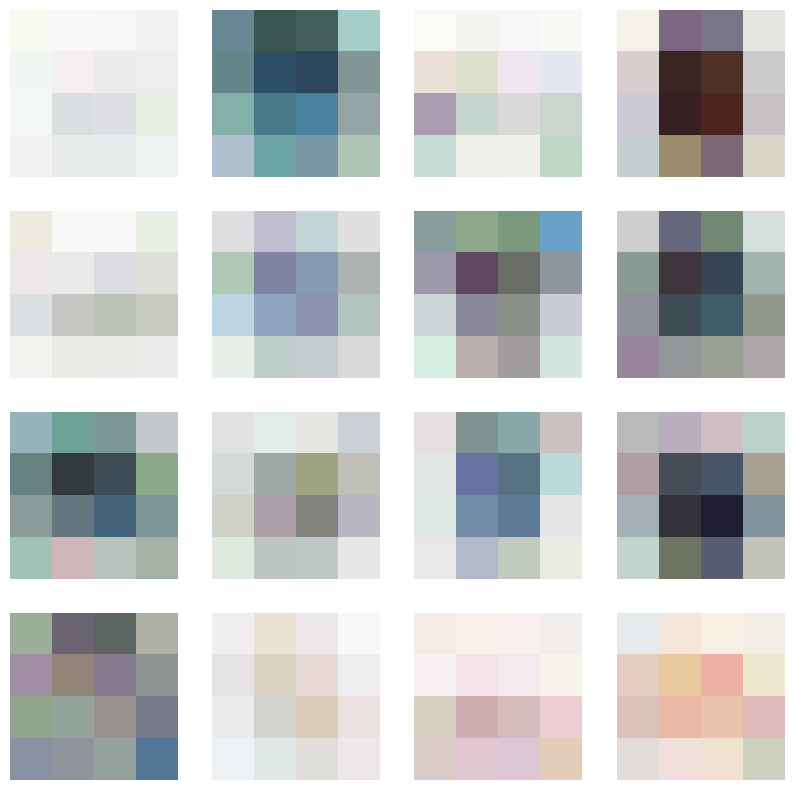

Step: 565
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6532929539680481
Generator loss: 1.4577510356903076


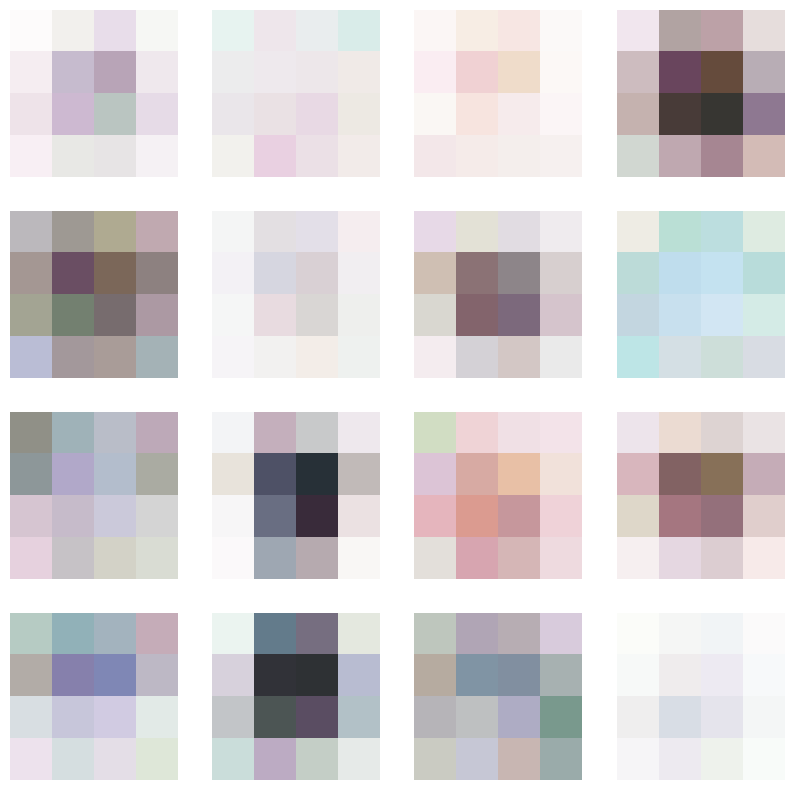

Step: 566
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6519684791564941
Generator loss: 1.4536558389663696


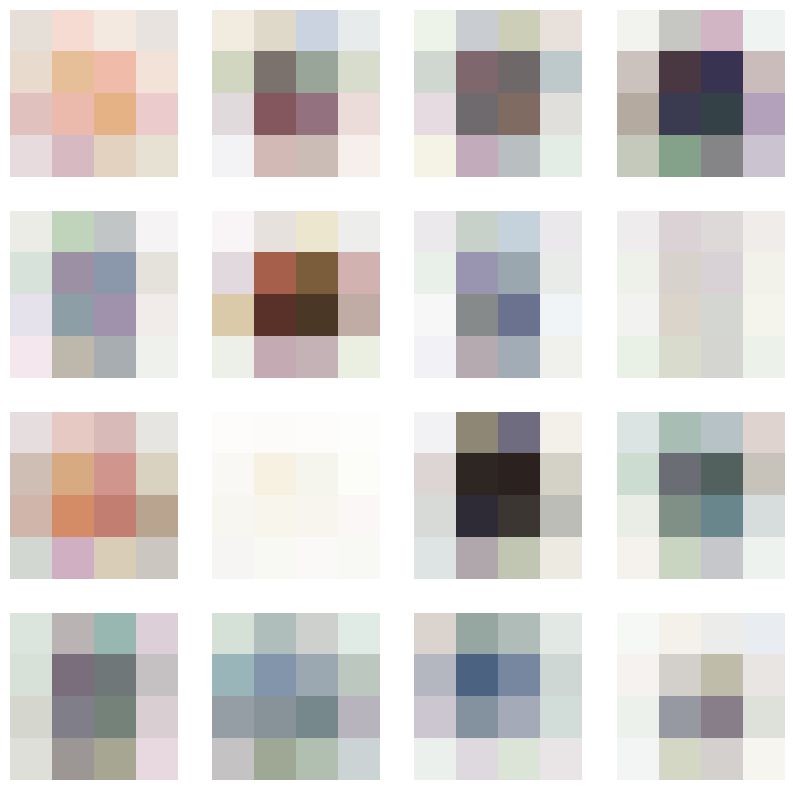

Step: 567
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.650862991809845
Generator loss: 1.4506440162658691


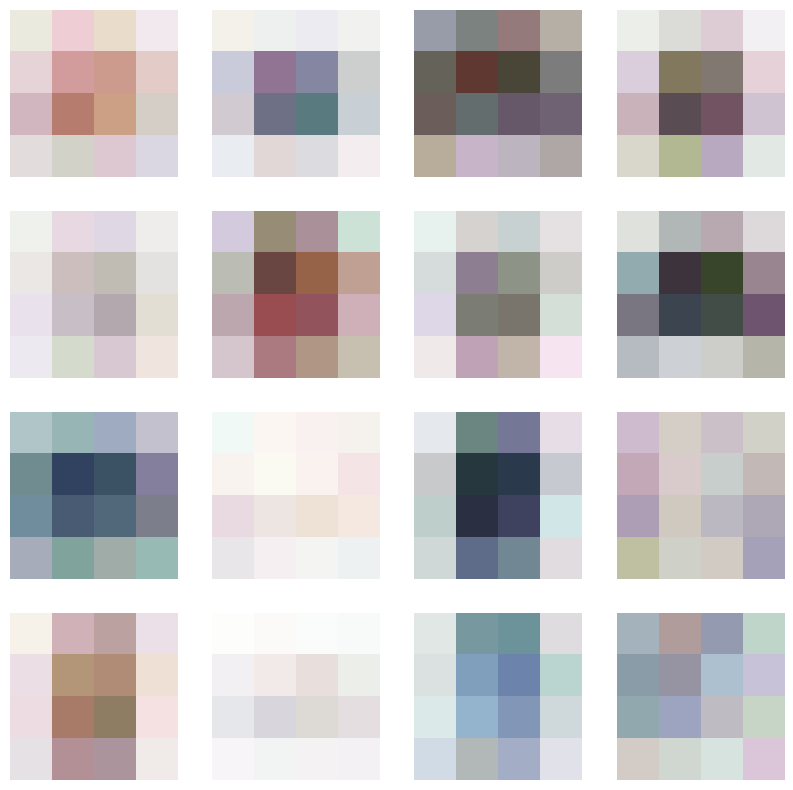

Step: 568
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.650122880935669
Generator loss: 1.4490042924880981


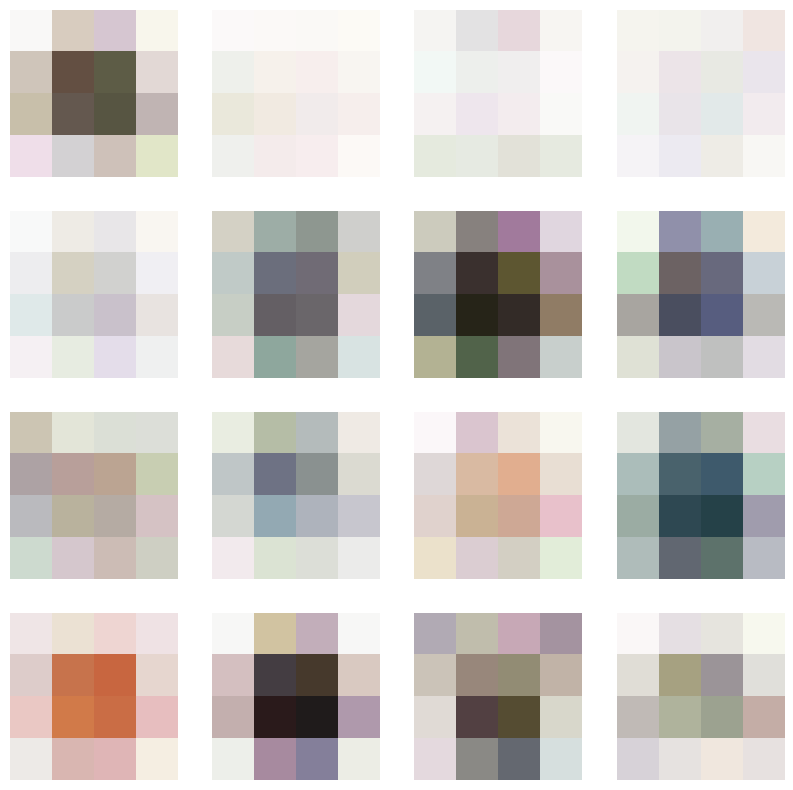

Step: 569
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6489522457122803
Generator loss: 1.4470852613449097


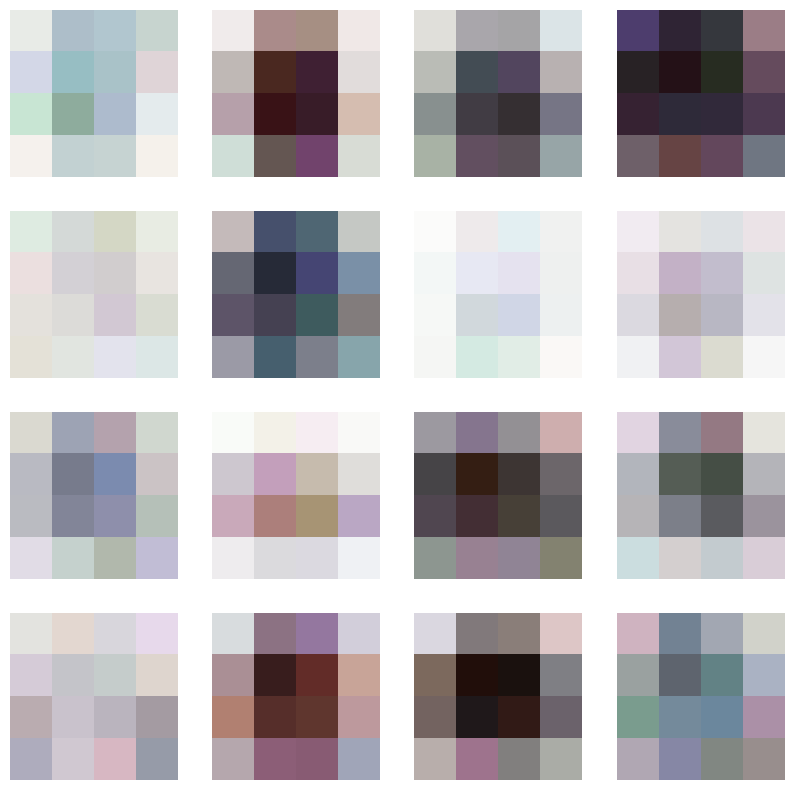

Step: 570
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6479400396347046
Generator loss: 1.4450496435165405


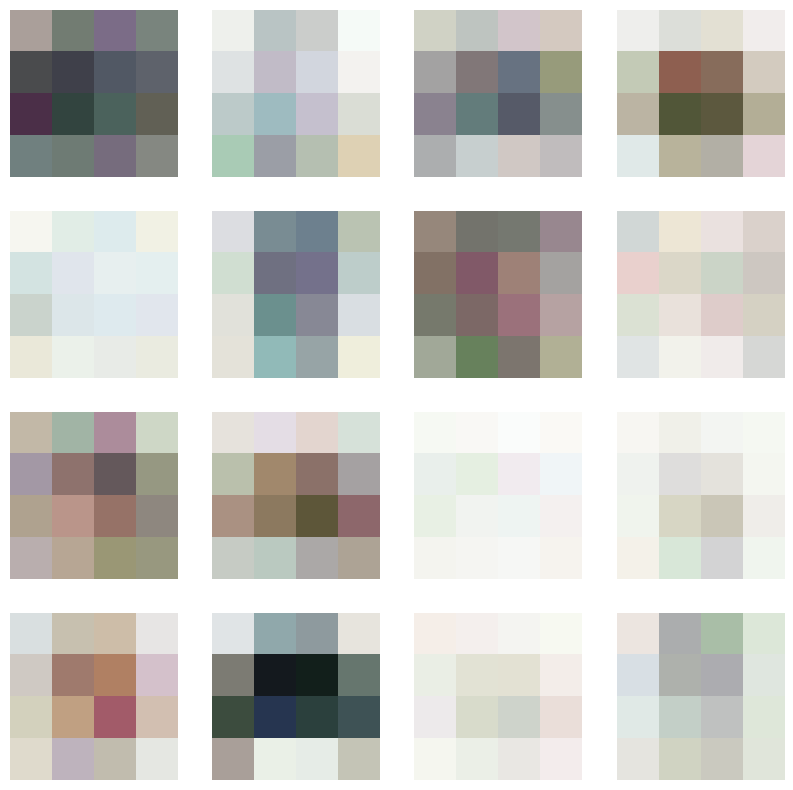

Step: 571
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6469634771347046
Generator loss: 1.4428614377975464


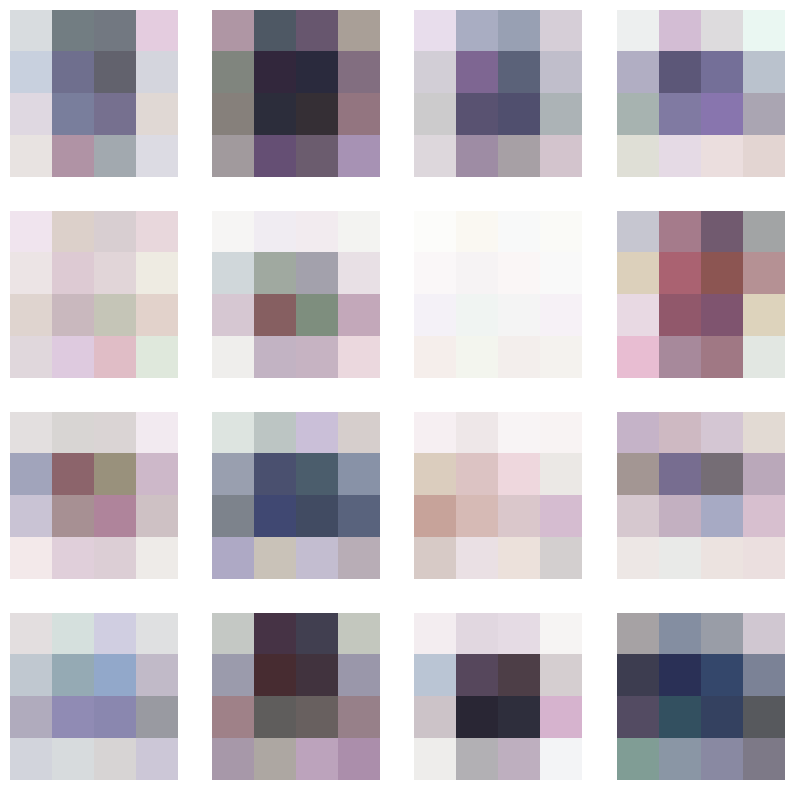

Step: 572
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.646310567855835
Generator loss: 1.440358281135559


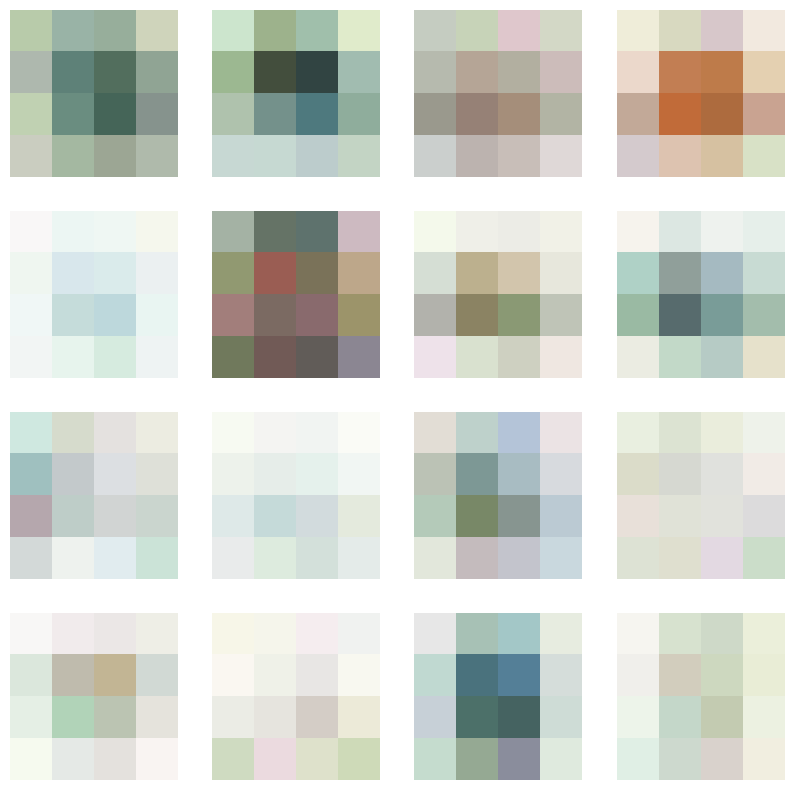

Step: 573
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6454516649246216
Generator loss: 1.43851900100708


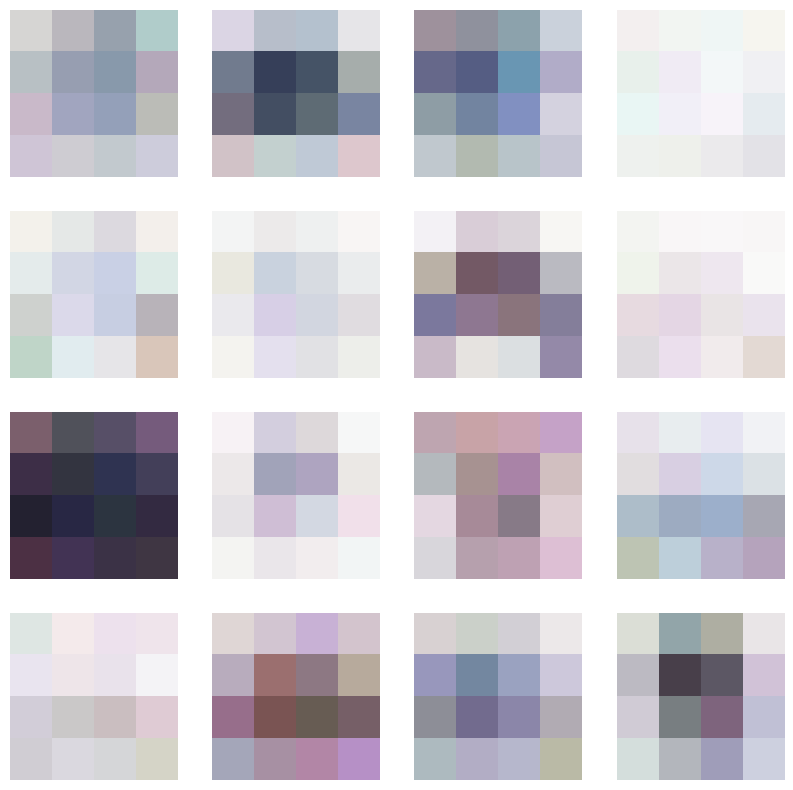

Step: 574
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6446829438209534
Generator loss: 1.4357293844223022


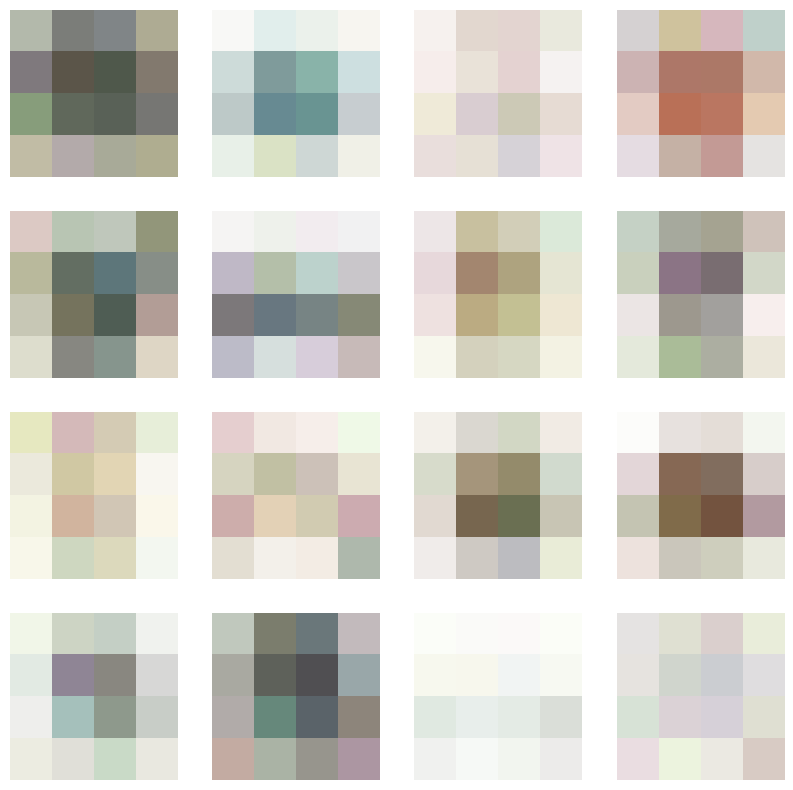

Step: 575
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6439560055732727
Generator loss: 1.4327373504638672


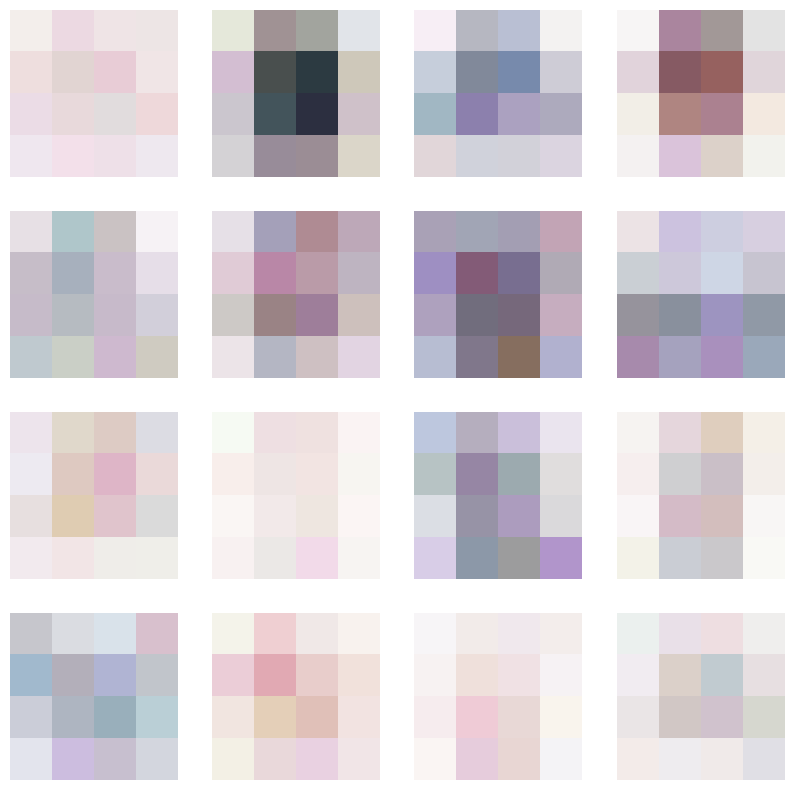

Step: 576
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6429335474967957
Generator loss: 1.4307888746261597


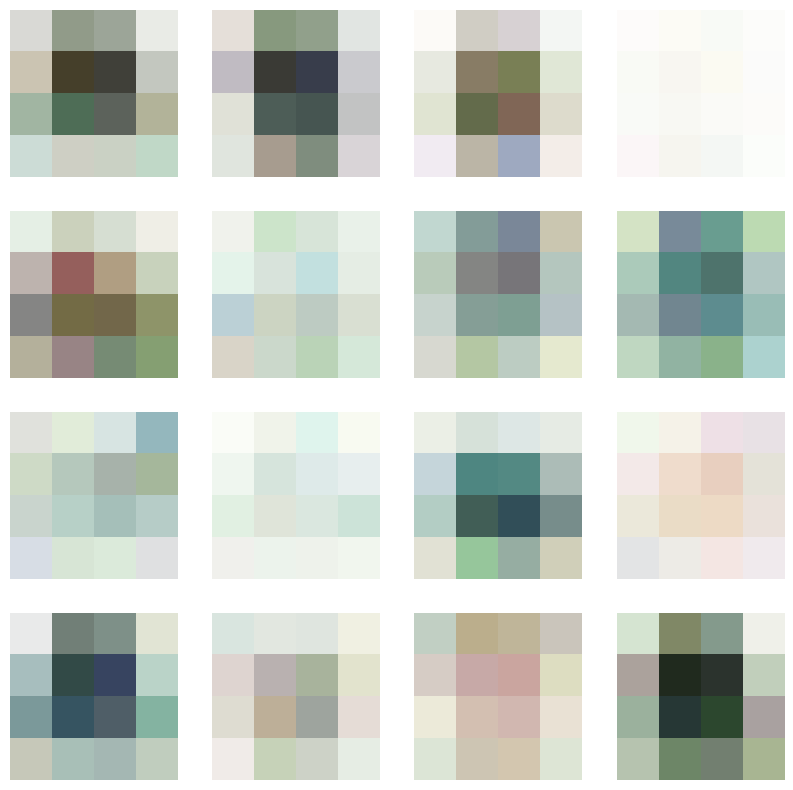

Step: 577
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.642136812210083
Generator loss: 1.429115653038025


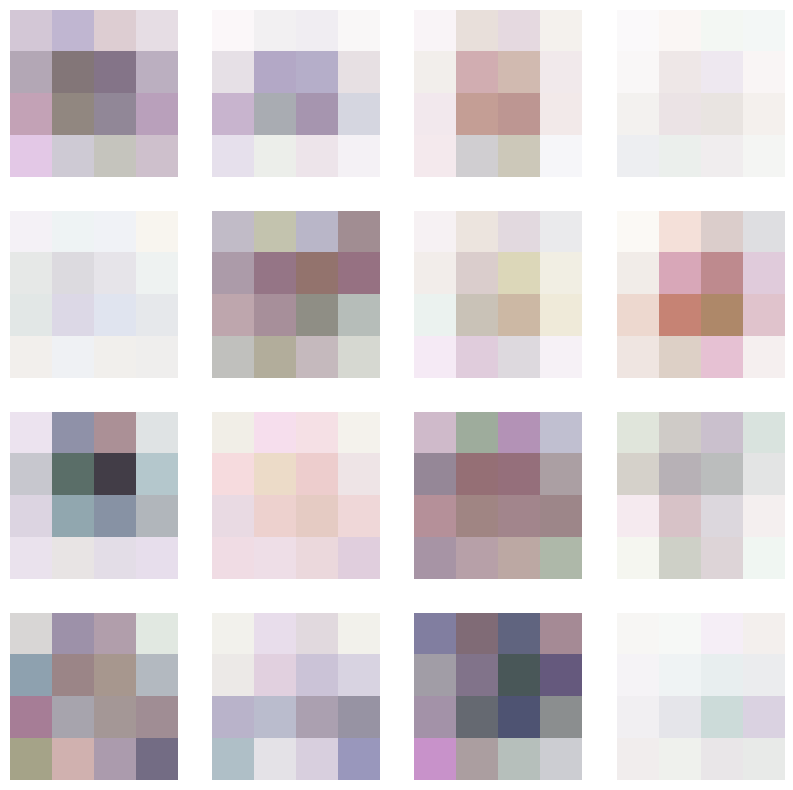

Step: 578
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6413764357566833
Generator loss: 1.4268864393234253


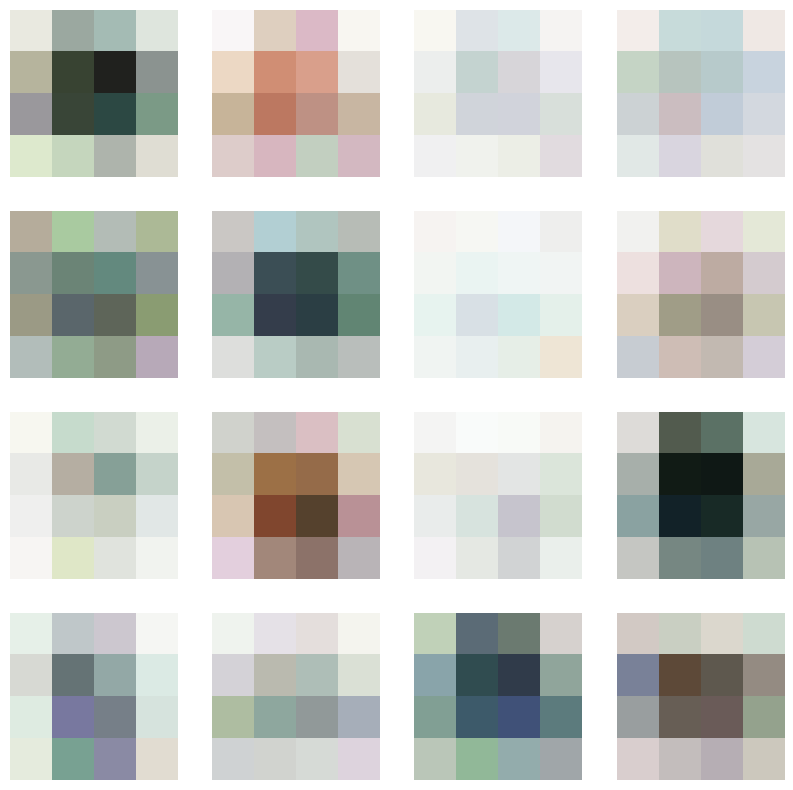

Step: 579
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6404941082000732
Generator loss: 1.4242039918899536


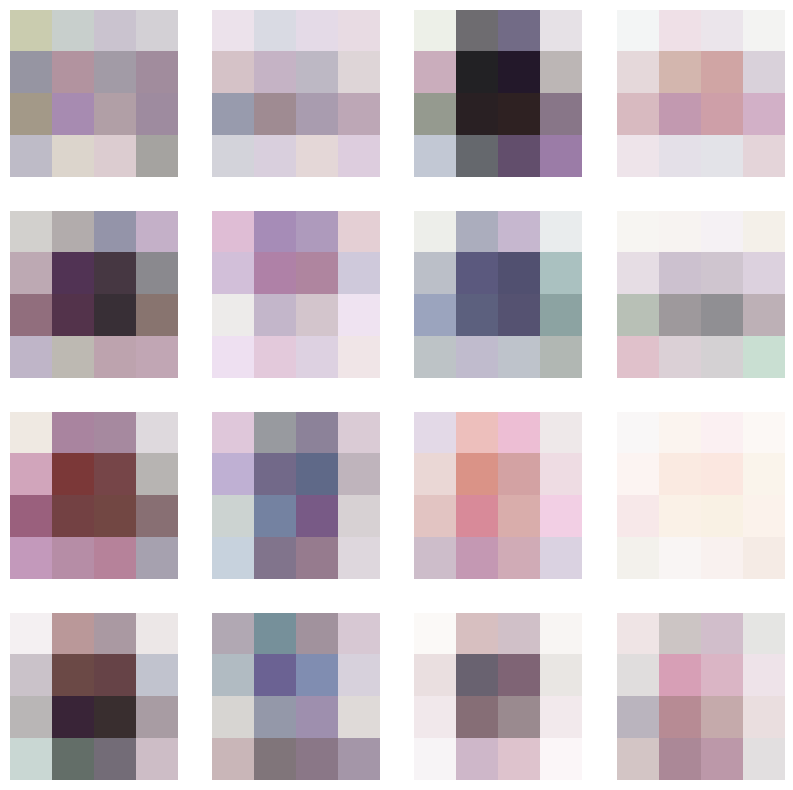

Step: 580
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6396961212158203
Generator loss: 1.421465516090393


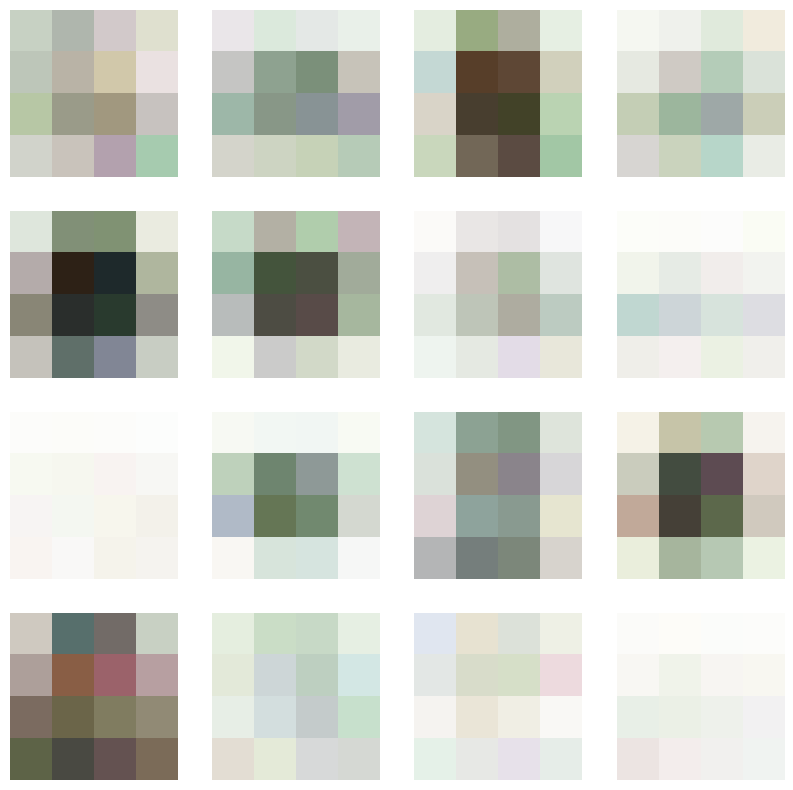

Step: 581
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6389083862304688
Generator loss: 1.4188868999481201


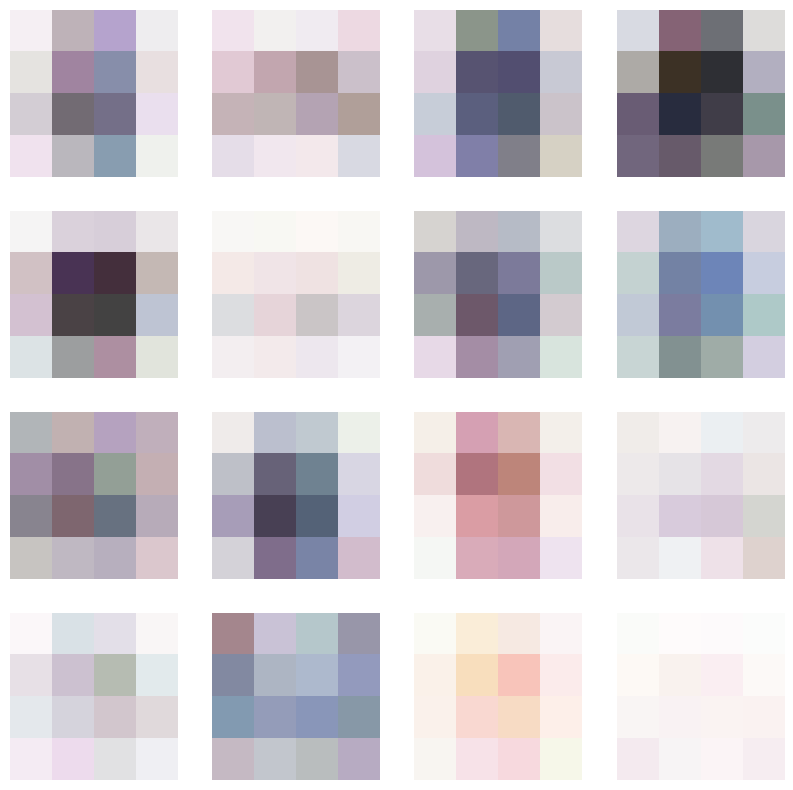

Step: 582
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6382028460502625
Generator loss: 1.41596519947052


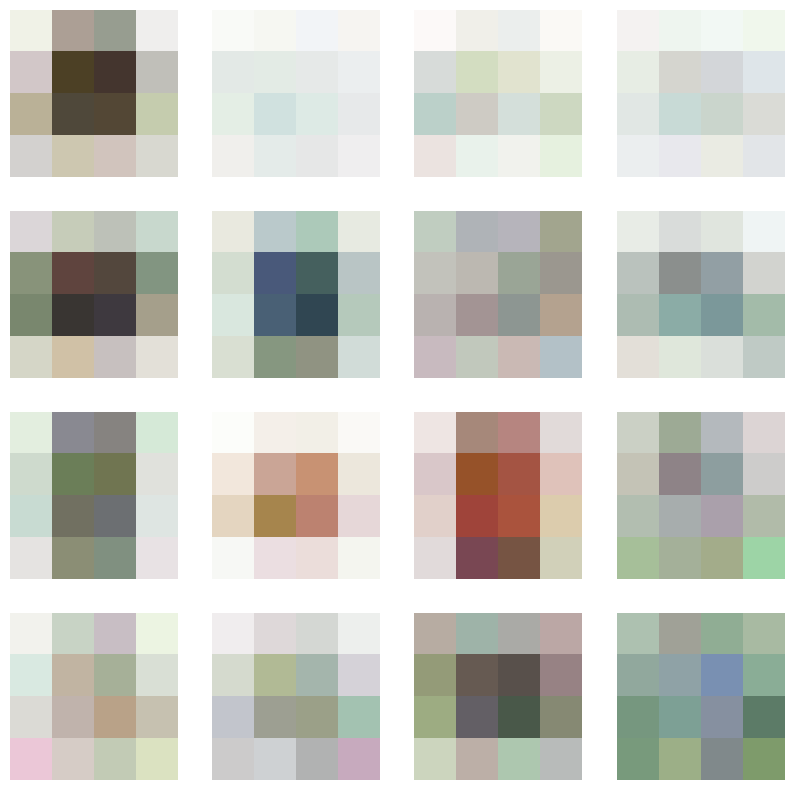

Step: 583
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6374081373214722
Generator loss: 1.4132919311523438


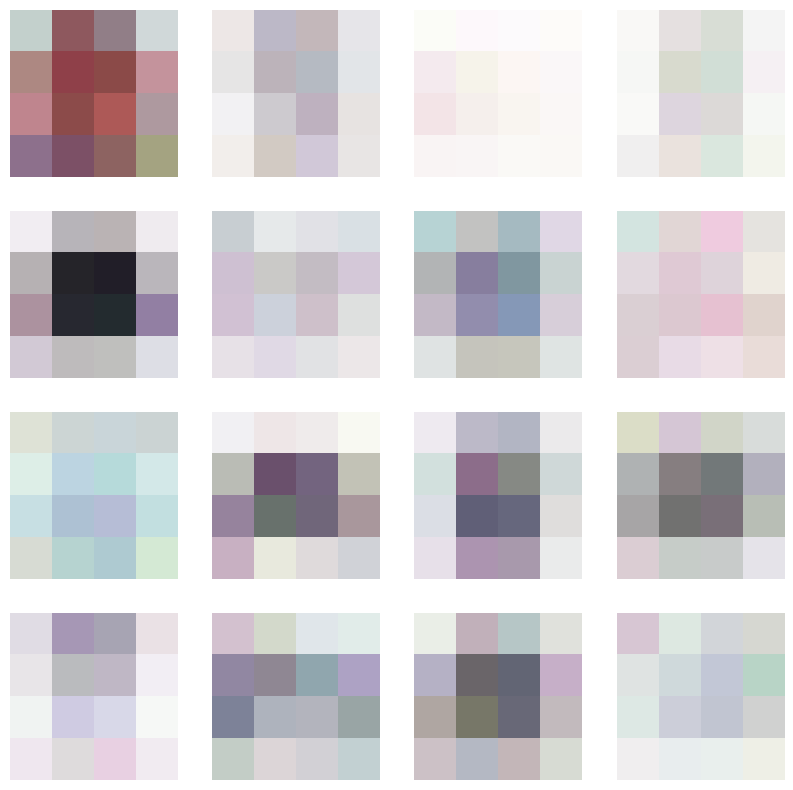

Step: 584
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6366171836853027
Generator loss: 1.4106190204620361


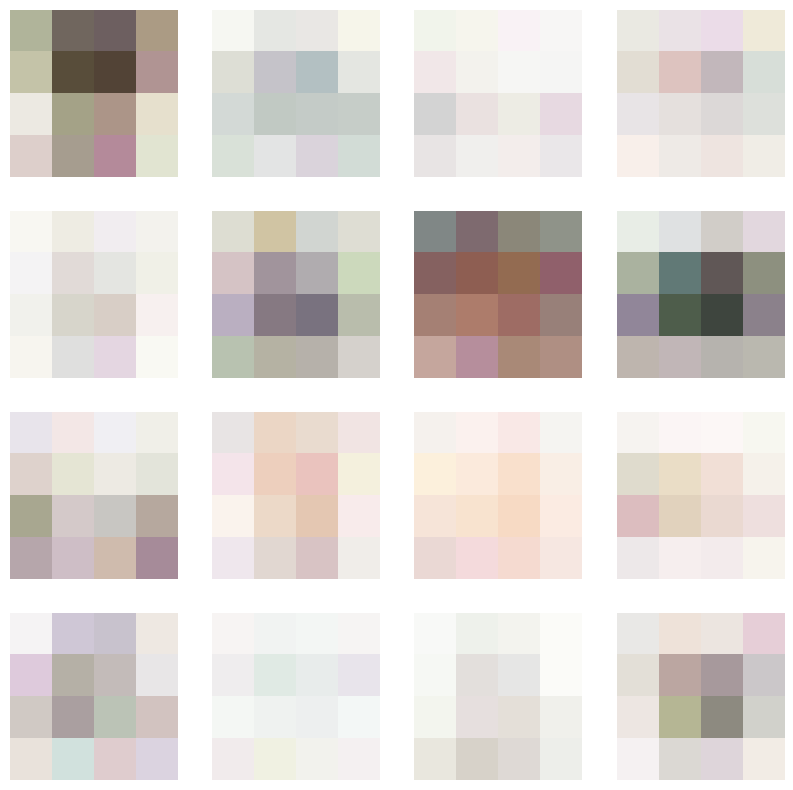

Step: 585
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6359614133834839
Generator loss: 1.4087810516357422


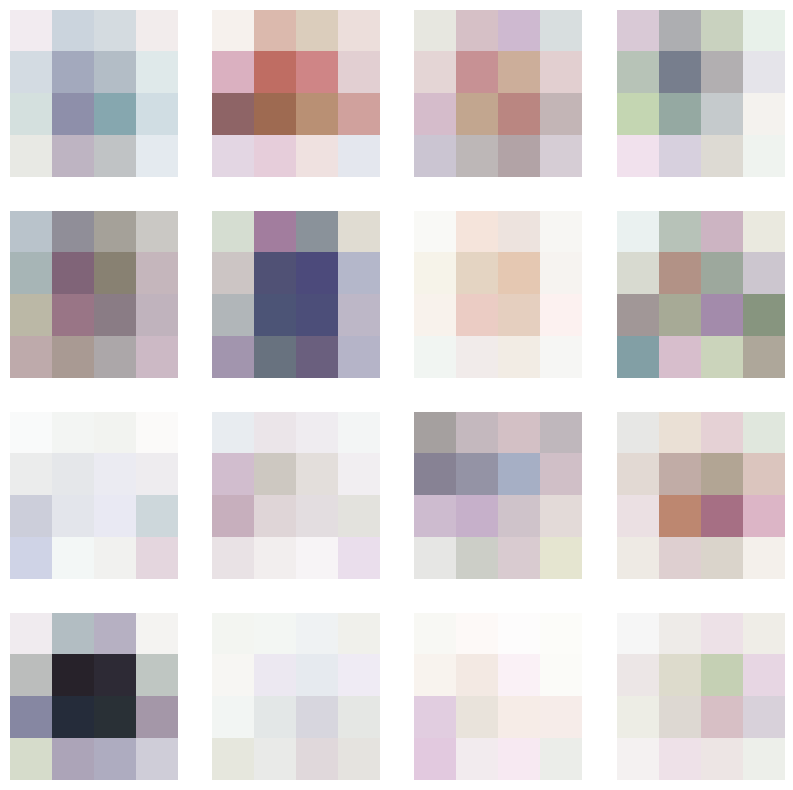

Step: 586
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.635262668132782
Generator loss: 1.4070744514465332


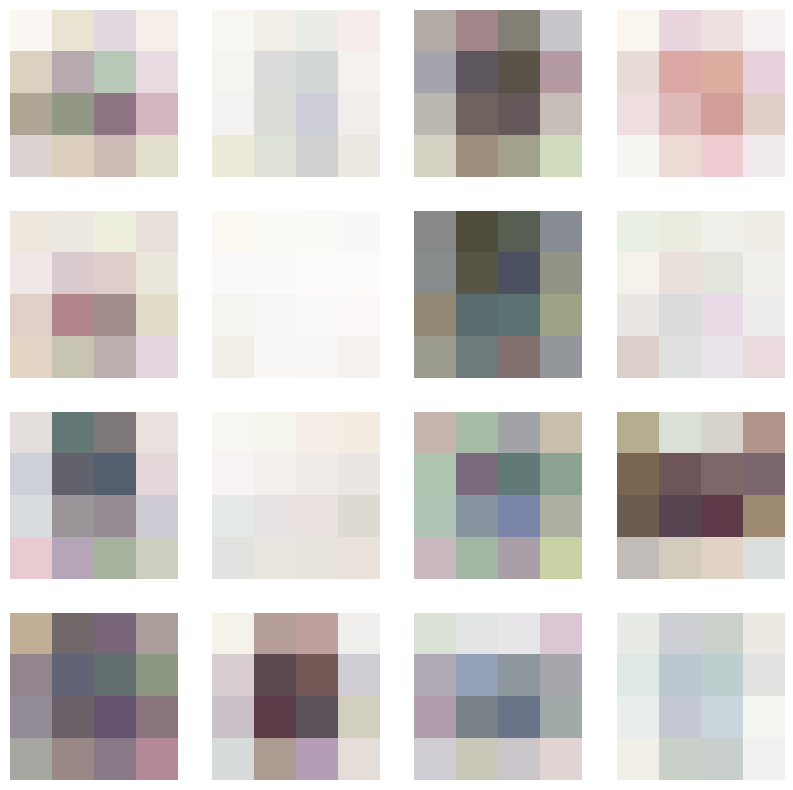

Step: 587
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.634158730506897
Generator loss: 1.4045906066894531


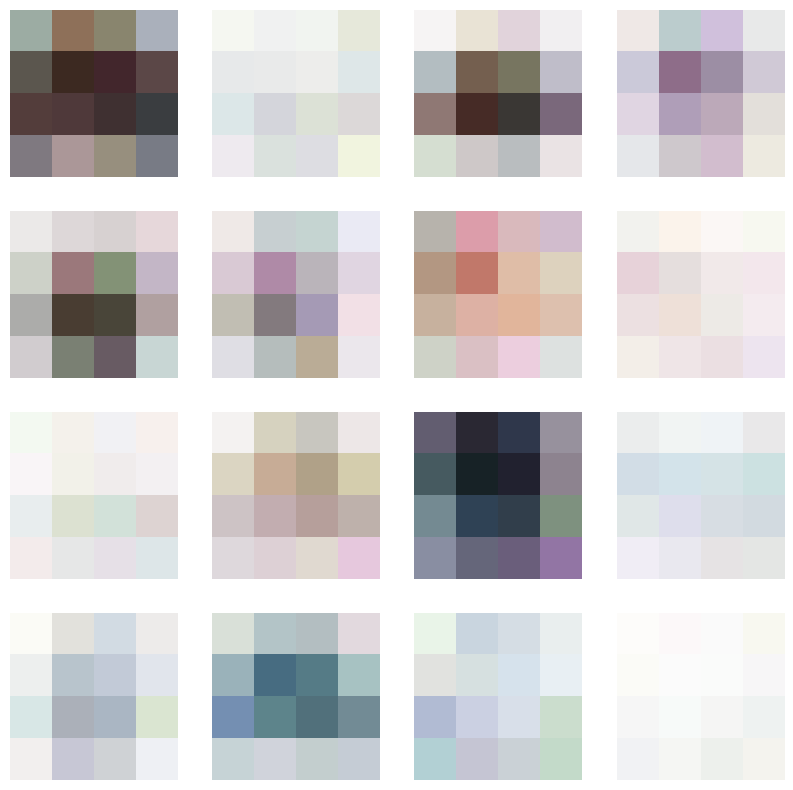

Step: 588
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6333153247833252
Generator loss: 1.4026026725769043


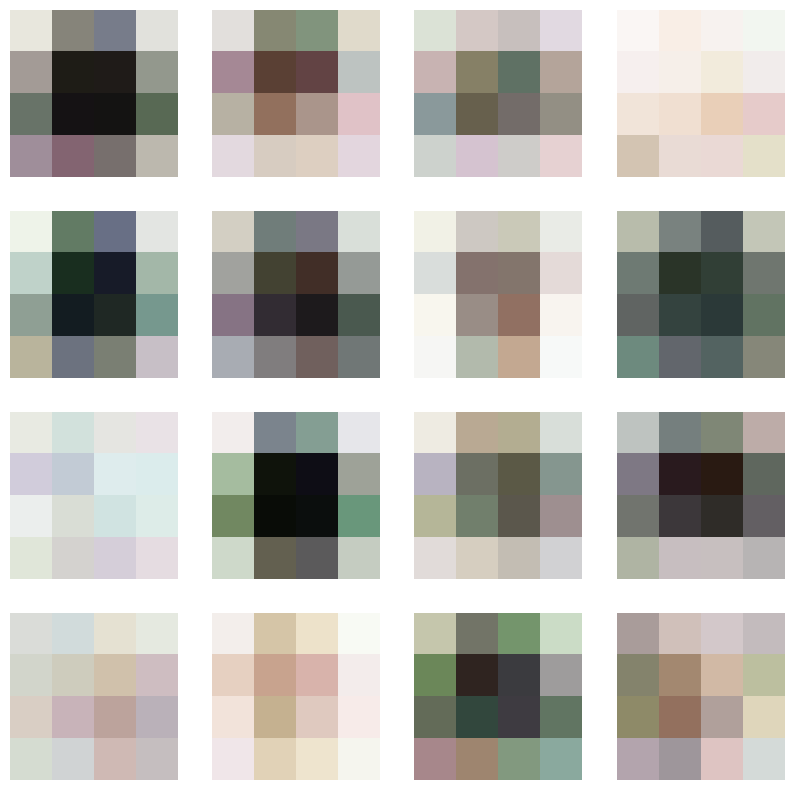

Step: 589
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6324886083602905
Generator loss: 1.3999505043029785


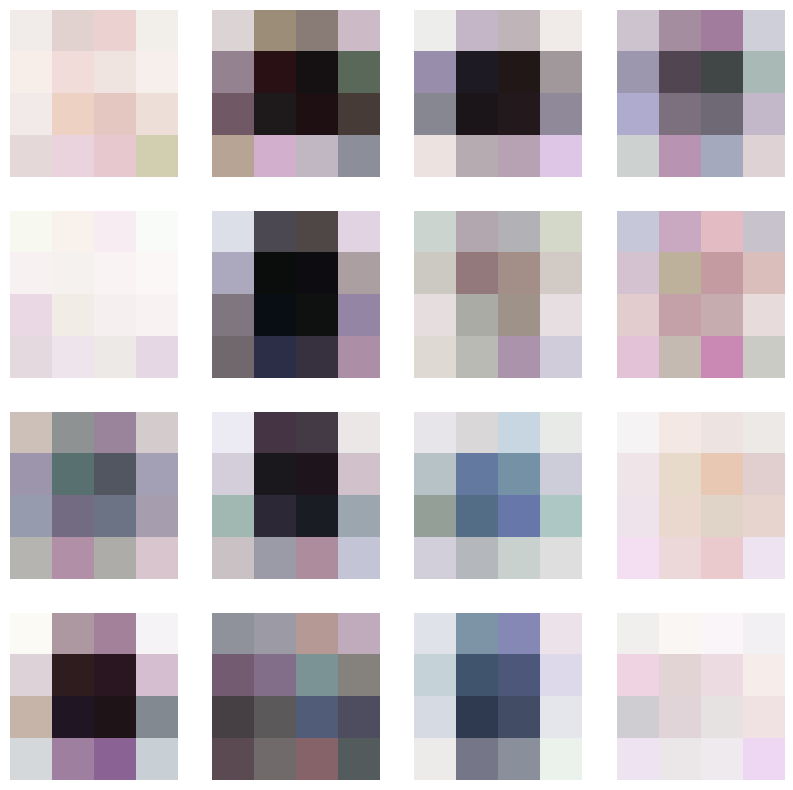

Step: 590
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6317199468612671
Generator loss: 1.3968825340270996


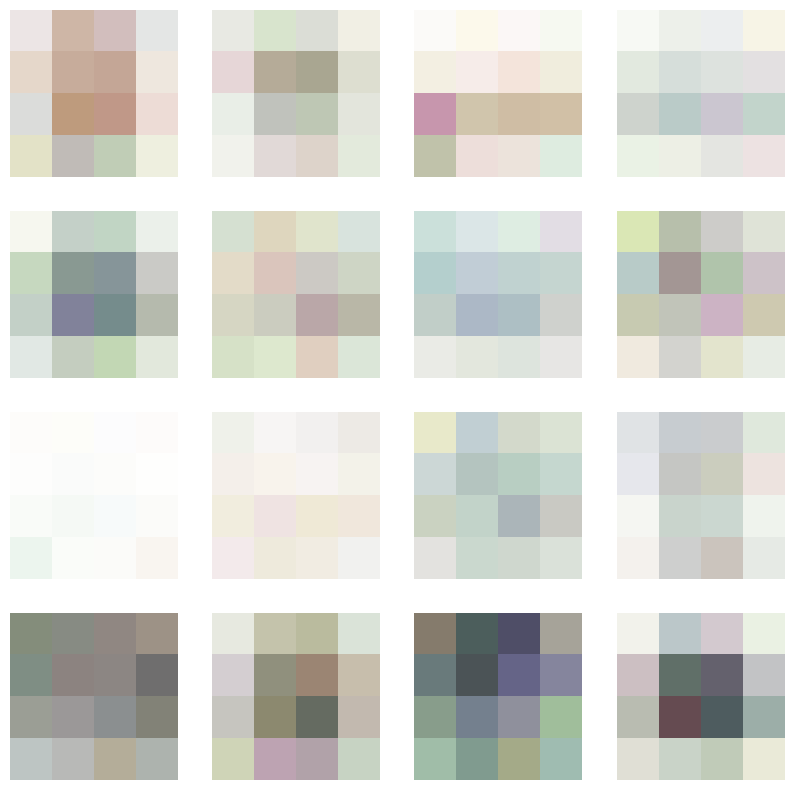

Step: 591
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6308640241622925
Generator loss: 1.3941105604171753


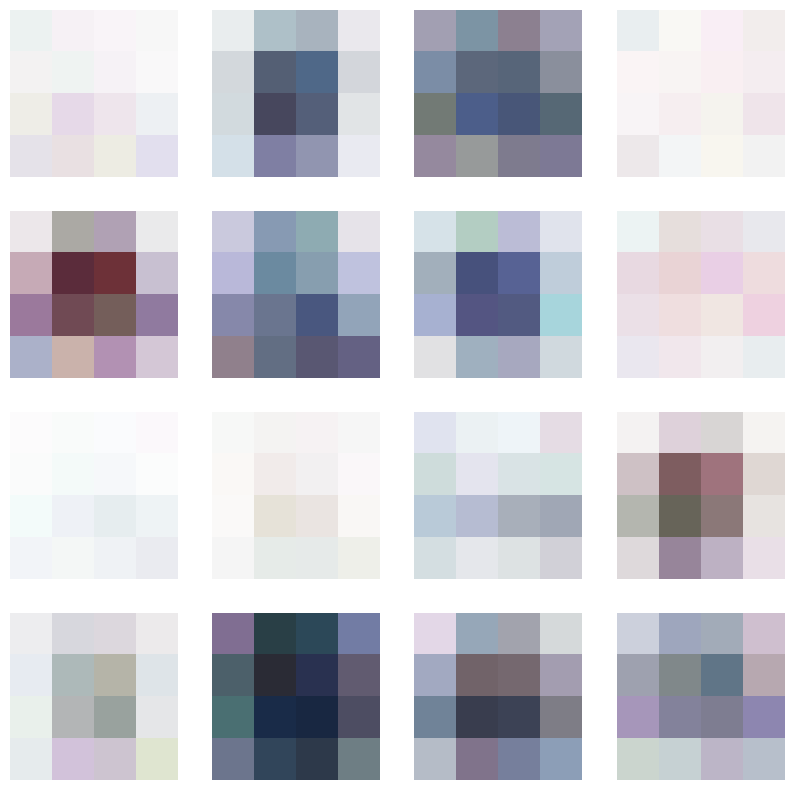

Step: 592
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6299793720245361
Generator loss: 1.3917306661605835


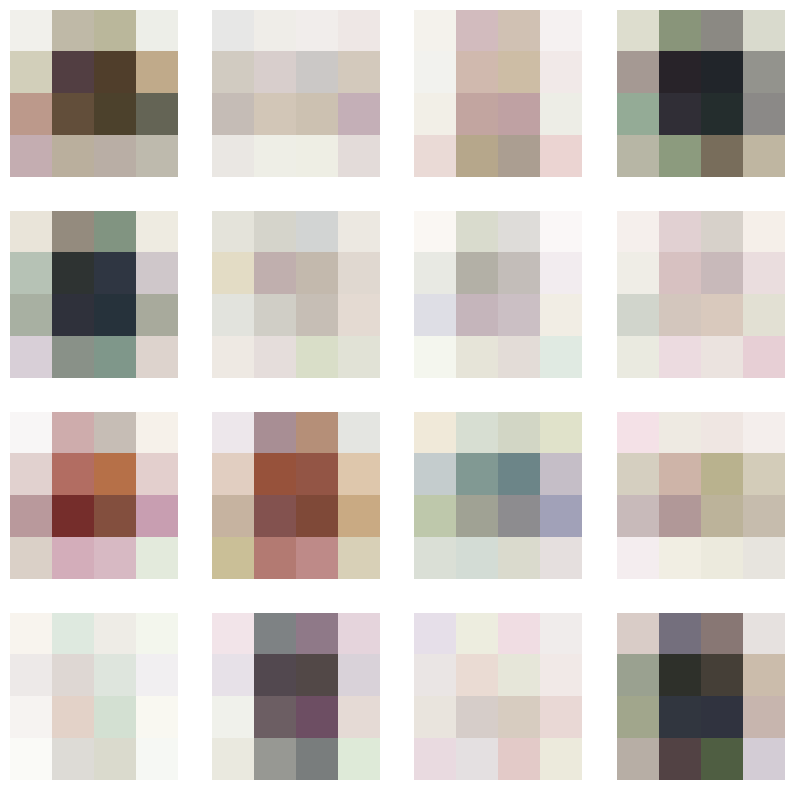

Step: 593
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6289271712303162
Generator loss: 1.3907221555709839


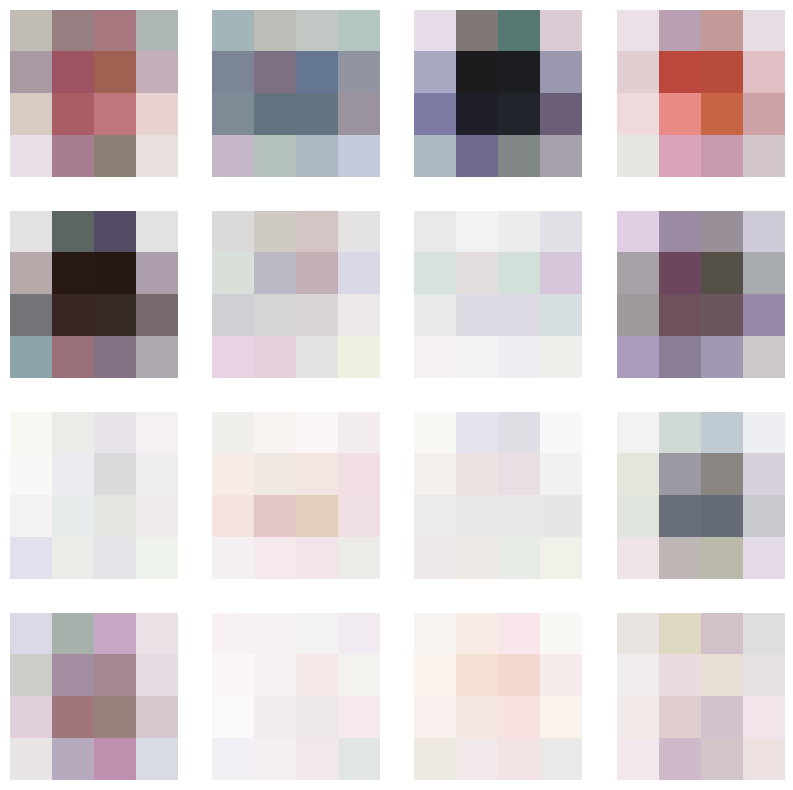

Step: 594
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6281436085700989
Generator loss: 1.3894391059875488


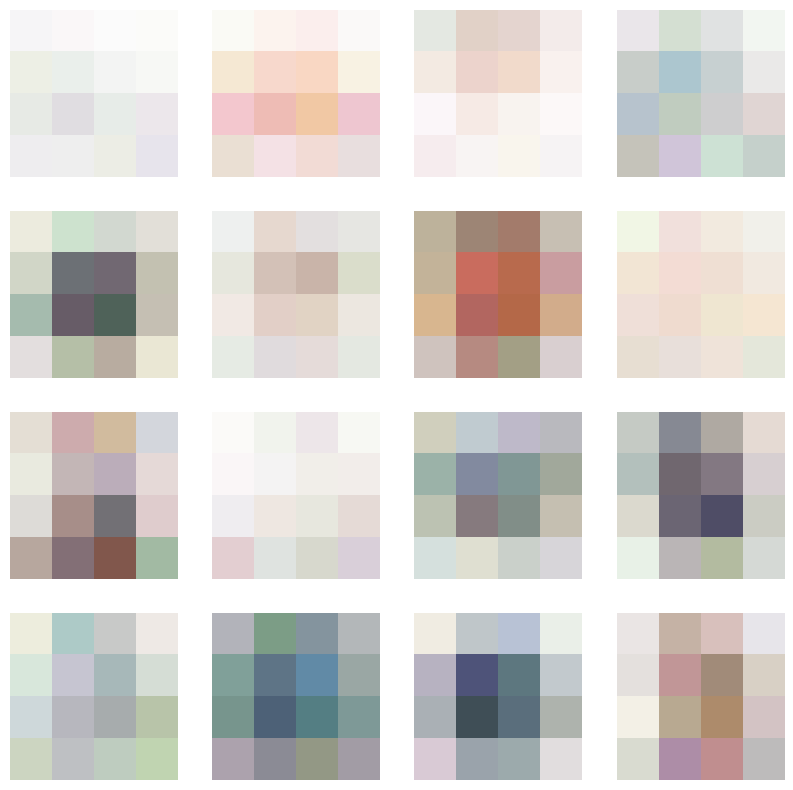

Step: 595
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6273943781852722
Generator loss: 1.3881373405456543


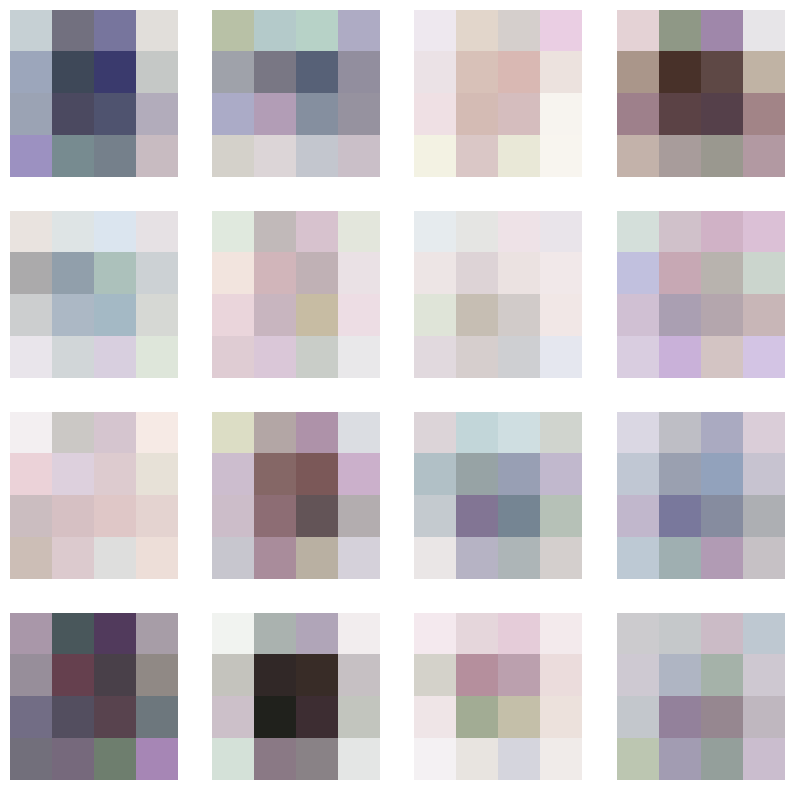

Step: 596
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6262651681900024
Generator loss: 1.3856555223464966


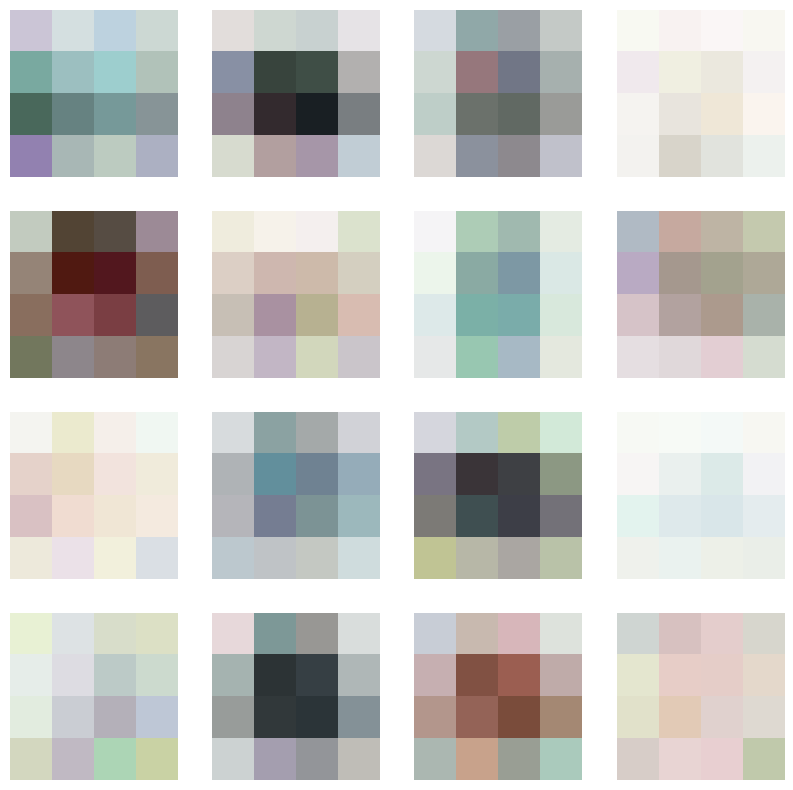

Step: 597
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6254326105117798
Generator loss: 1.3831366300582886


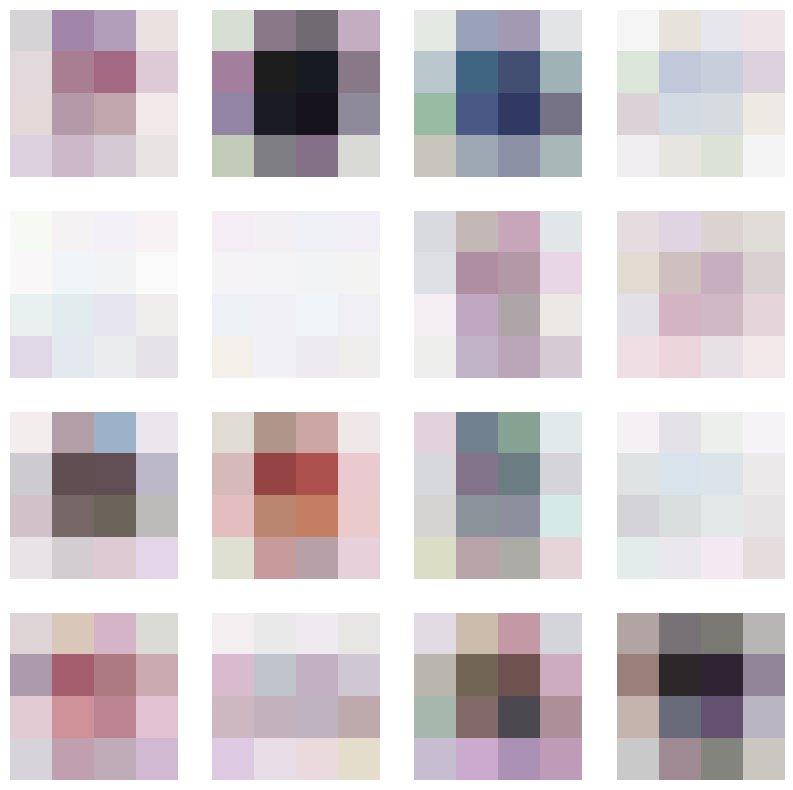

Step: 598
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6243310570716858
Generator loss: 1.380989909172058


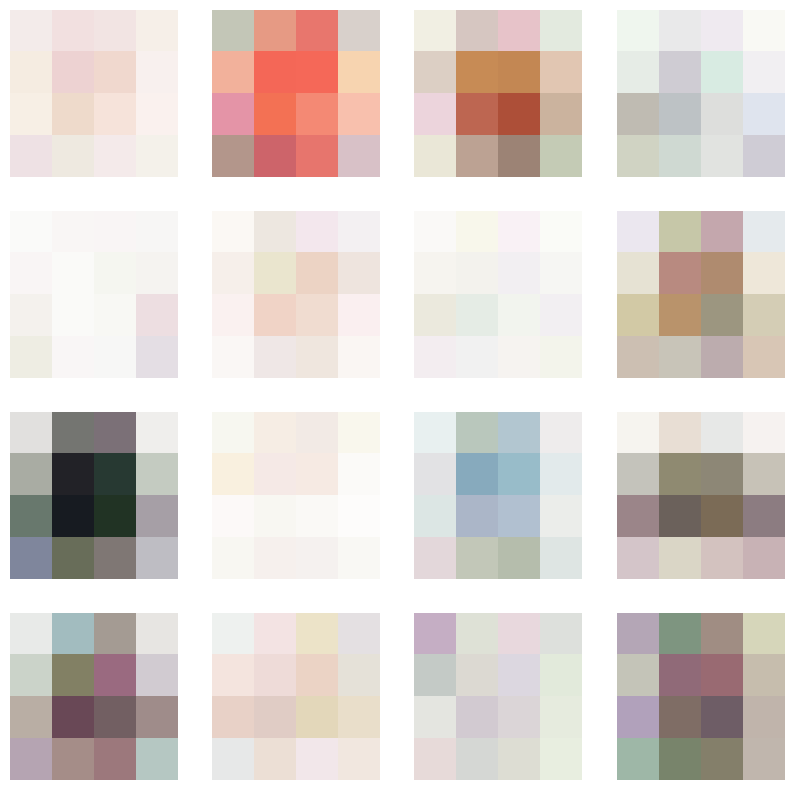

Step: 599
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.623562216758728
Generator loss: 1.3789114952087402


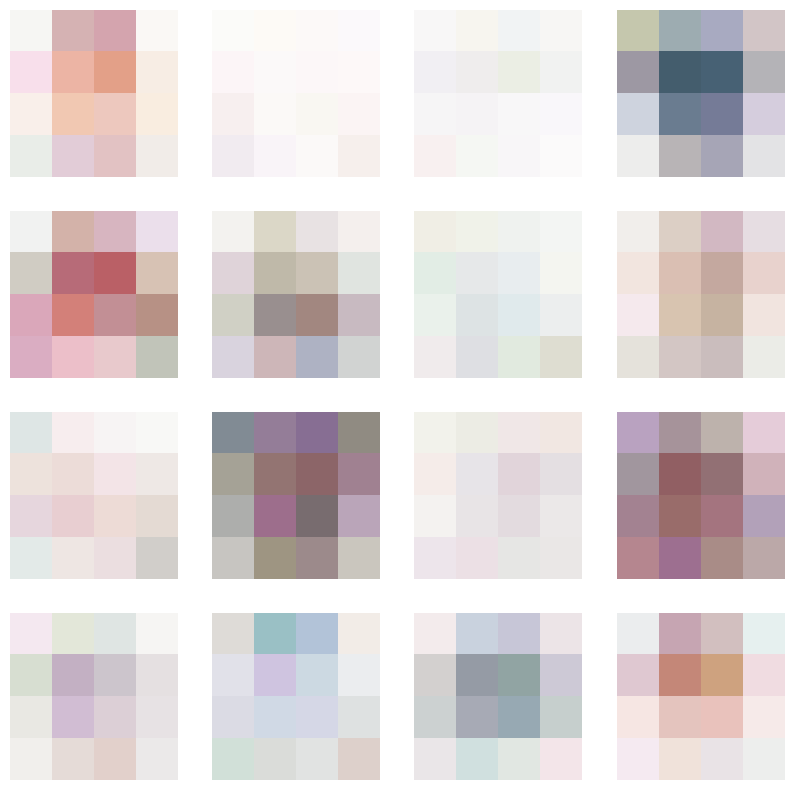

Step: 600
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6227693557739258
Generator loss: 1.3767213821411133


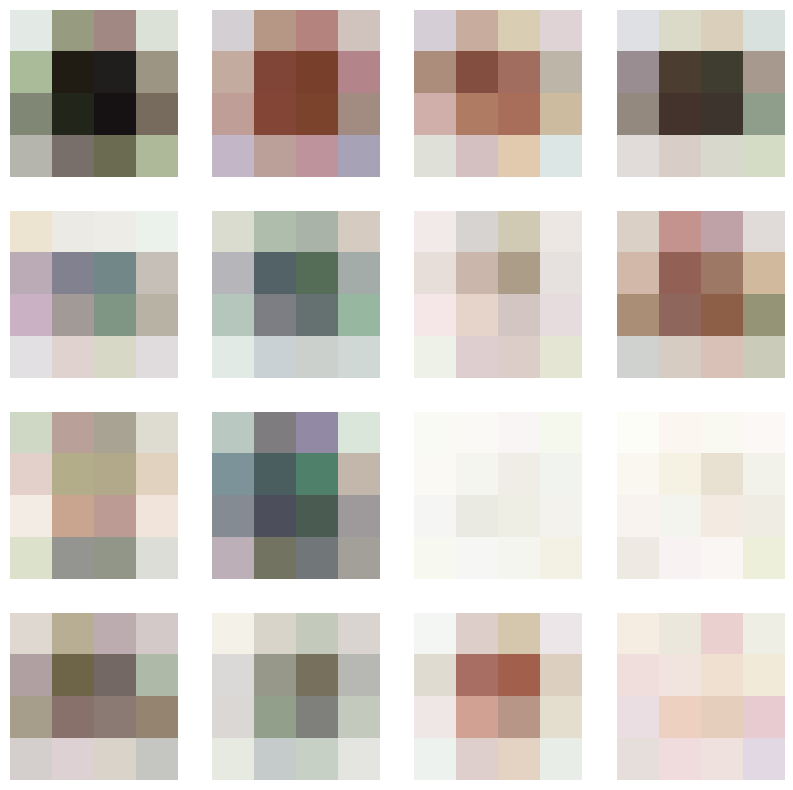

Step: 601
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6220749616622925
Generator loss: 1.3750674724578857


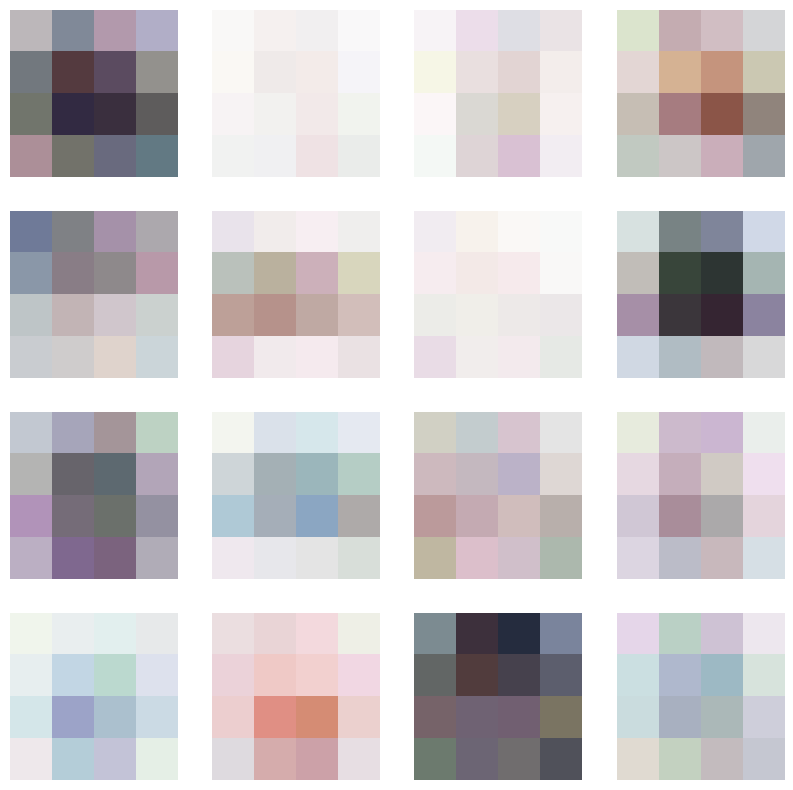

Step: 602
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6211814880371094
Generator loss: 1.3726587295532227


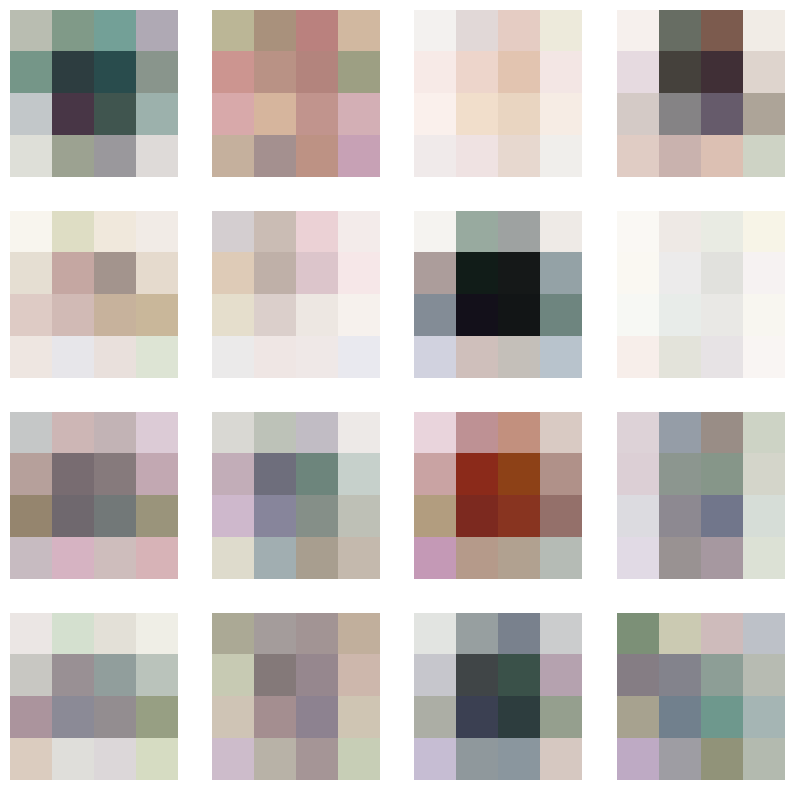

Step: 603
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6204120516777039
Generator loss: 1.370246171951294


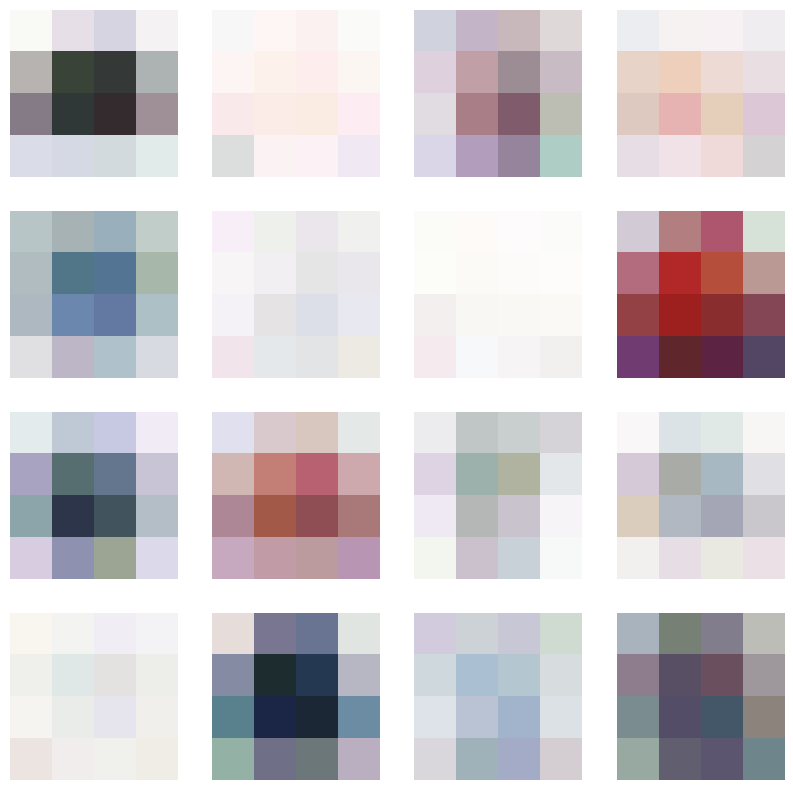

Step: 604
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6196614503860474
Generator loss: 1.3674280643463135


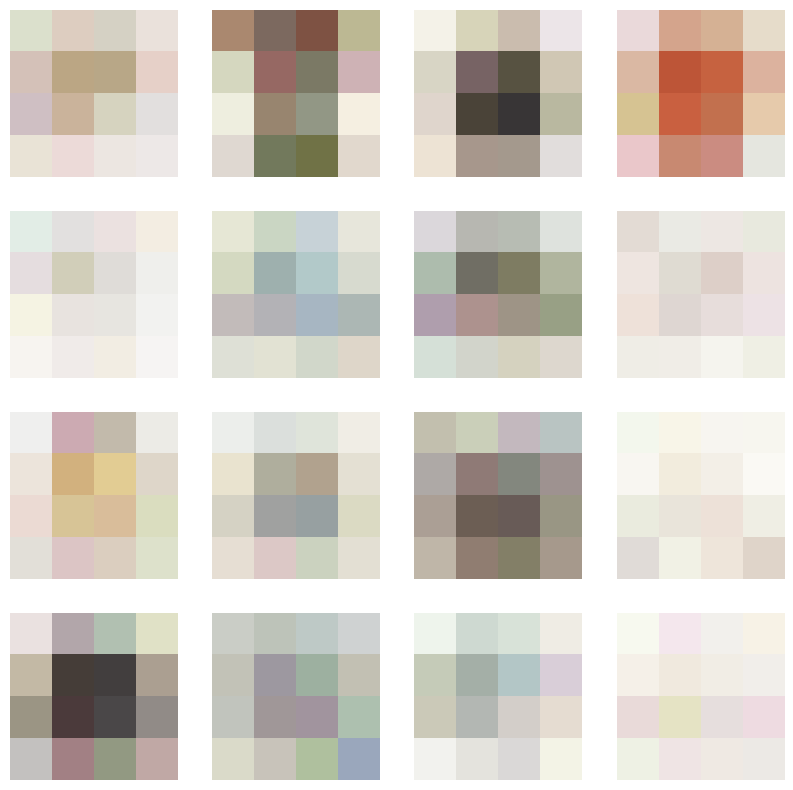

Step: 605
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6189000010490417
Generator loss: 1.364915132522583


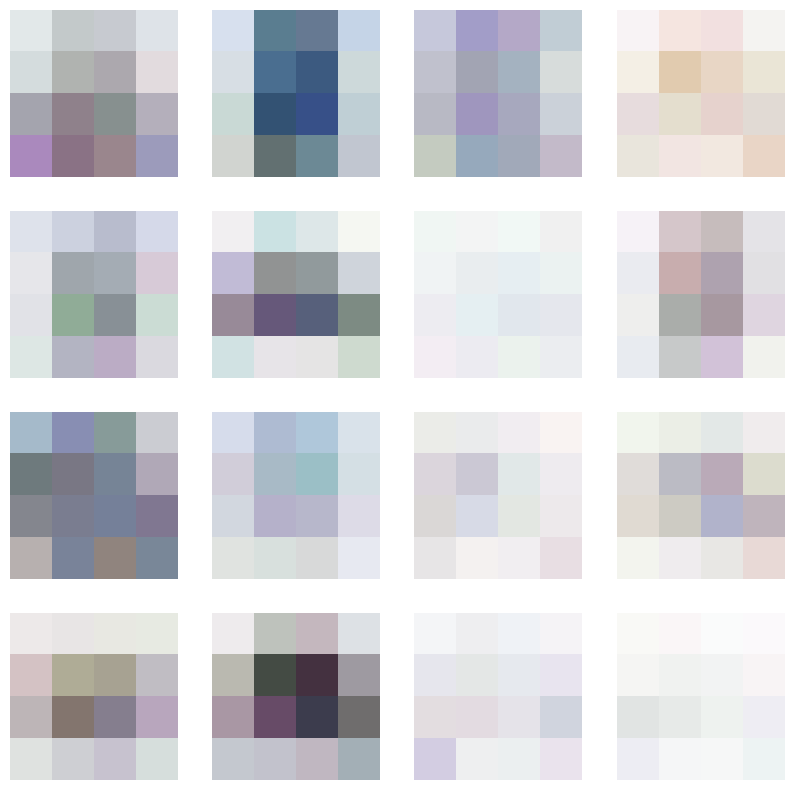

Step: 606
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6179816126823425
Generator loss: 1.3628987073898315


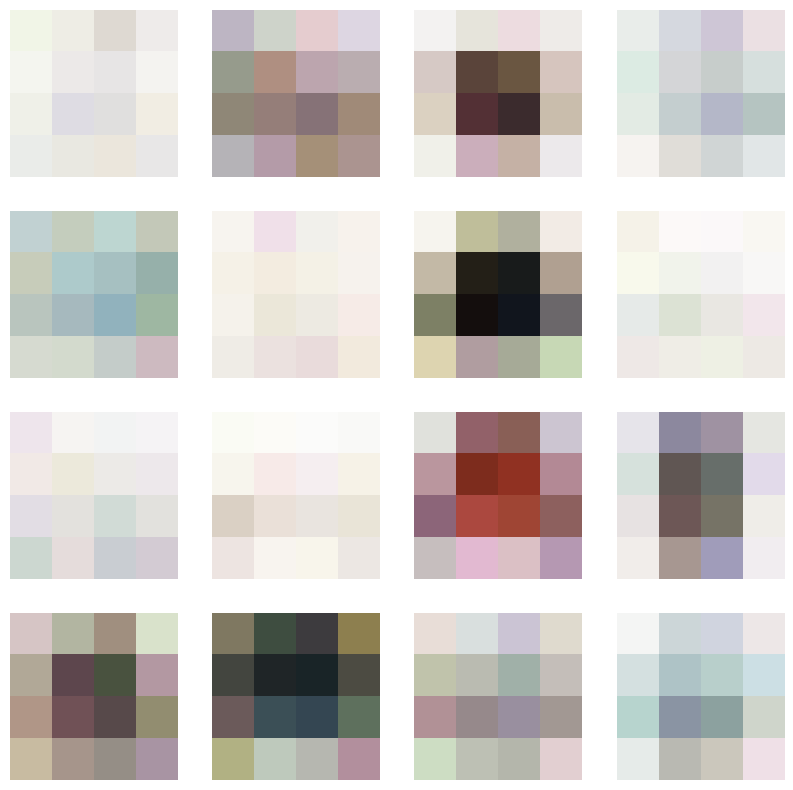

Step: 607
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6172069311141968
Generator loss: 1.3607196807861328


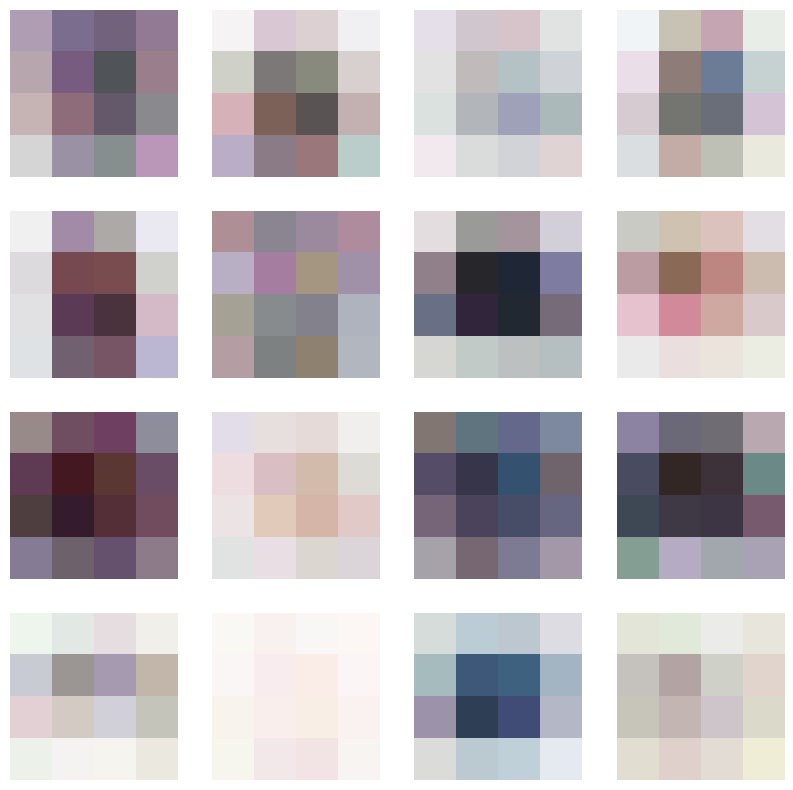

Step: 608
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6165931820869446
Generator loss: 1.359002709388733


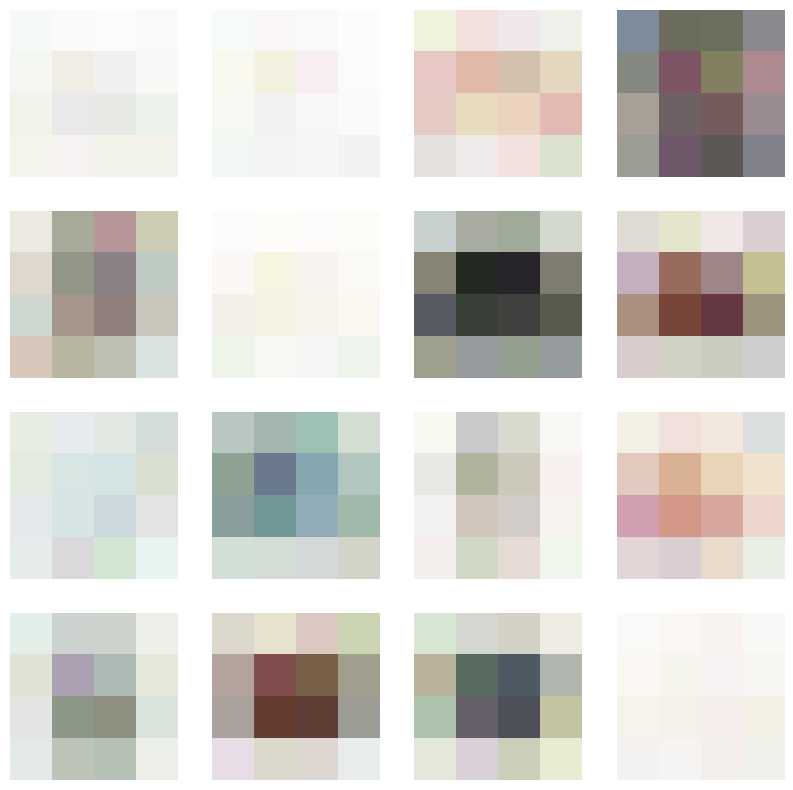

Step: 609
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6158092021942139
Generator loss: 1.3568501472473145


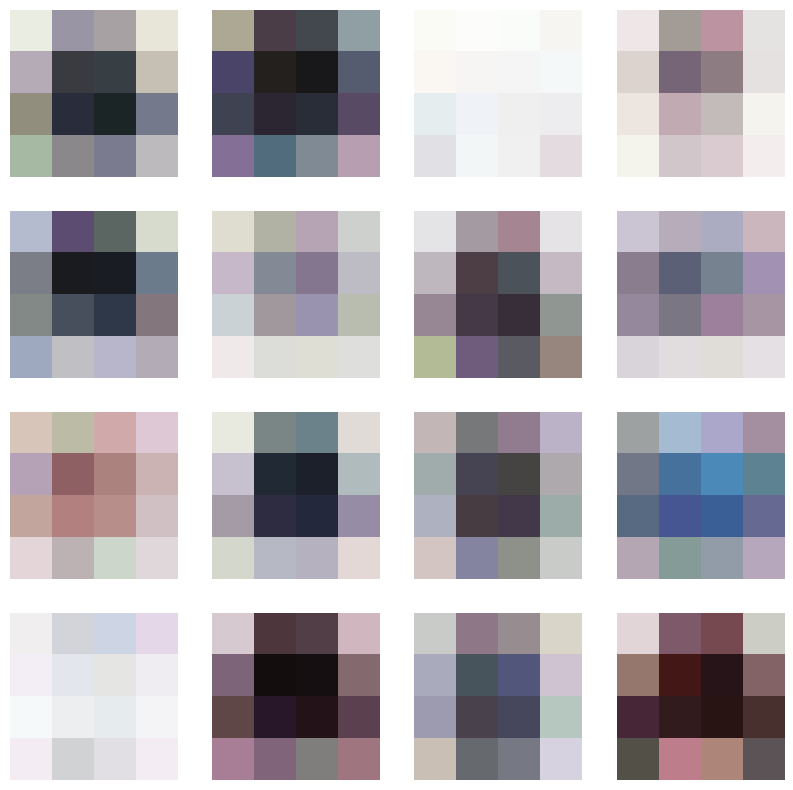

Step: 610
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6150548458099365
Generator loss: 1.3544882535934448


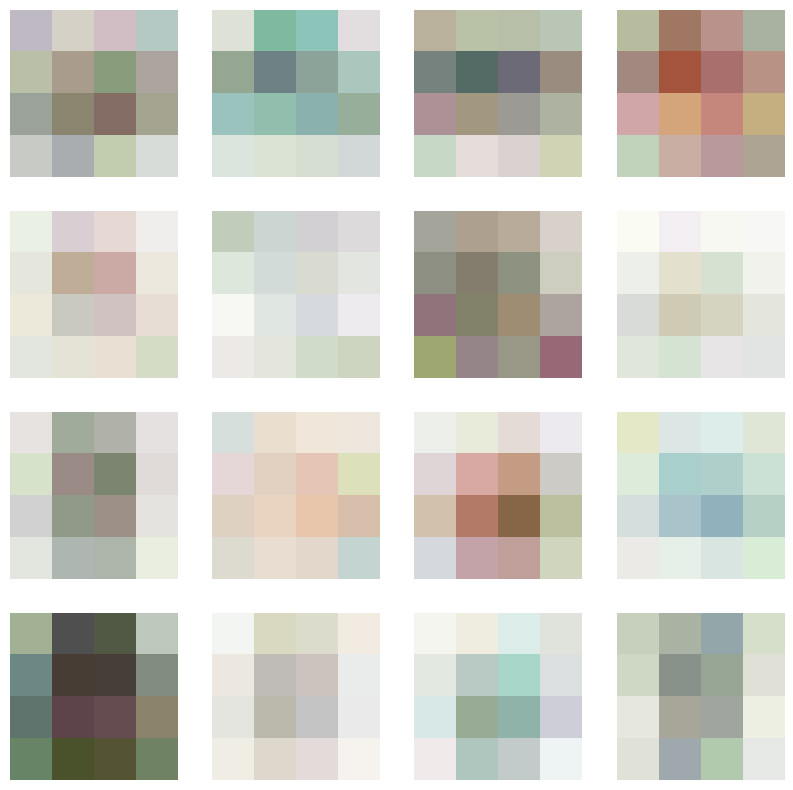

Step: 611
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6143463850021362
Generator loss: 1.3518240451812744


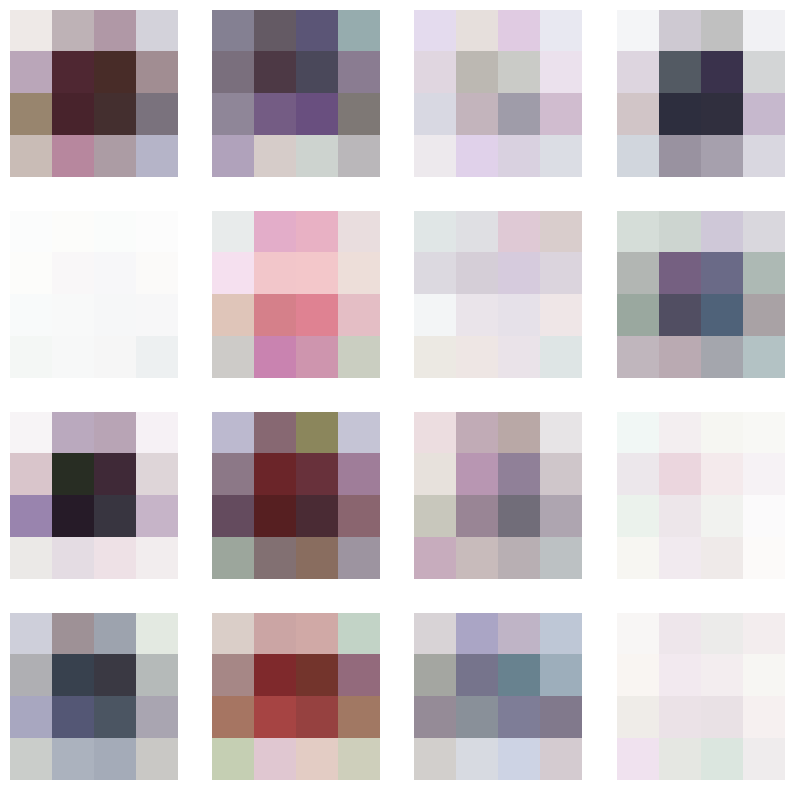

Step: 612
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6134941577911377
Generator loss: 1.3492964506149292


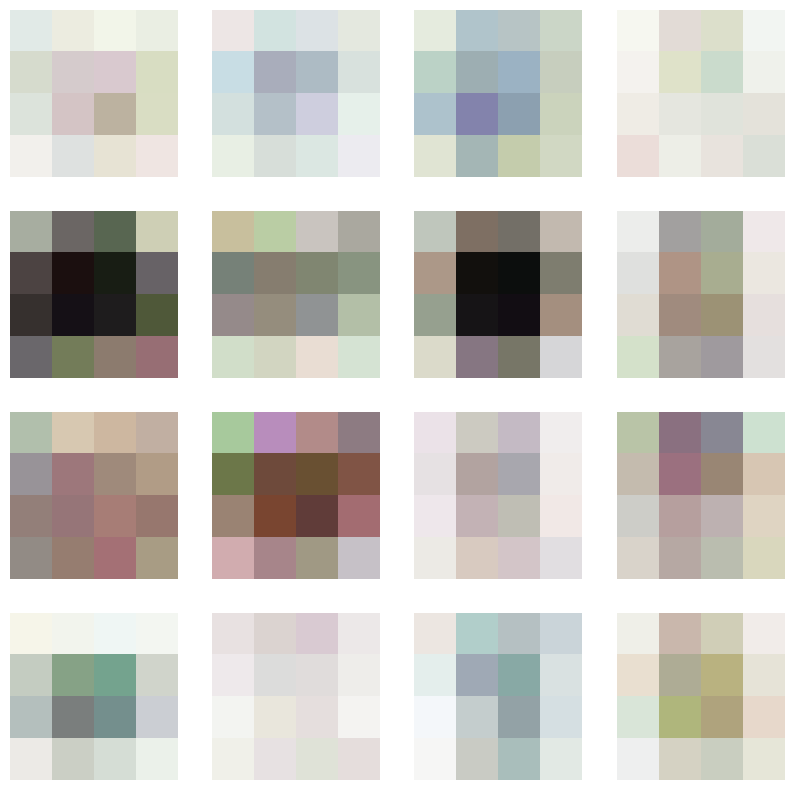

Step: 613
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6128047108650208
Generator loss: 1.3465495109558105


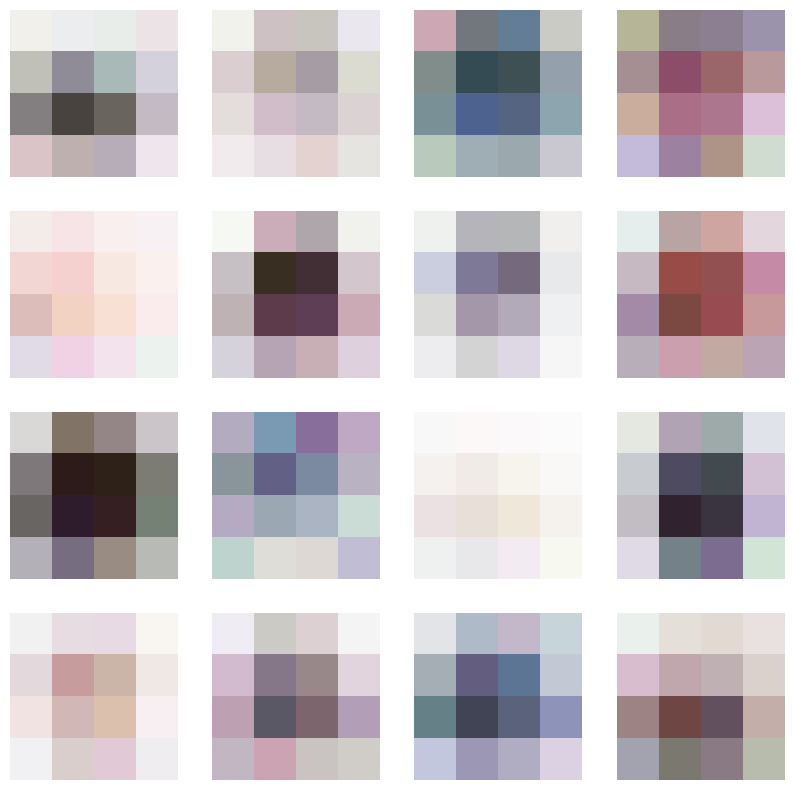

Step: 614
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6120580434799194
Generator loss: 1.3439029455184937


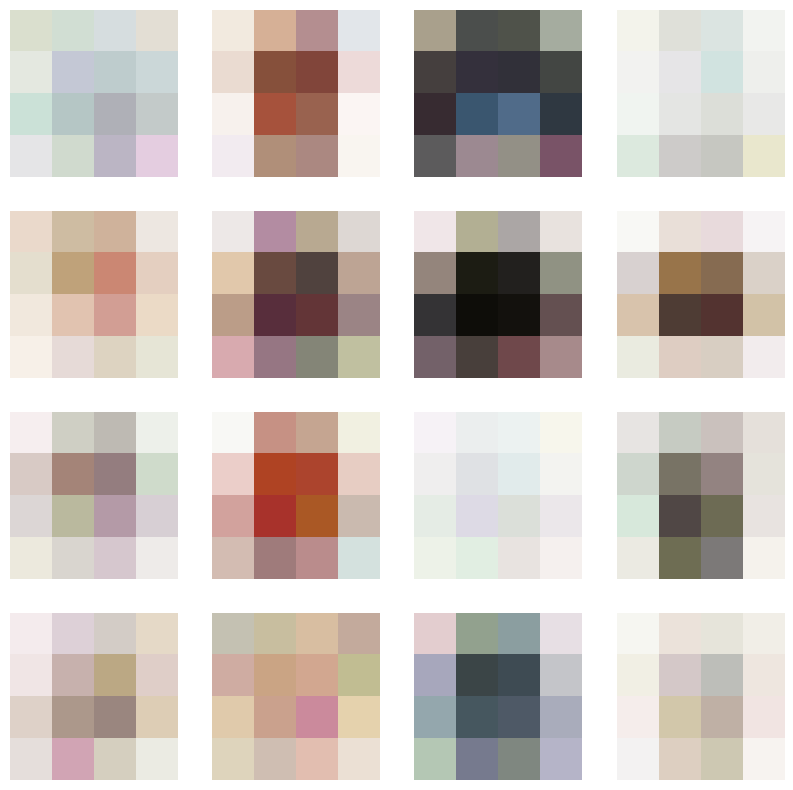

Step: 615
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6113412976264954
Generator loss: 1.3415300846099854


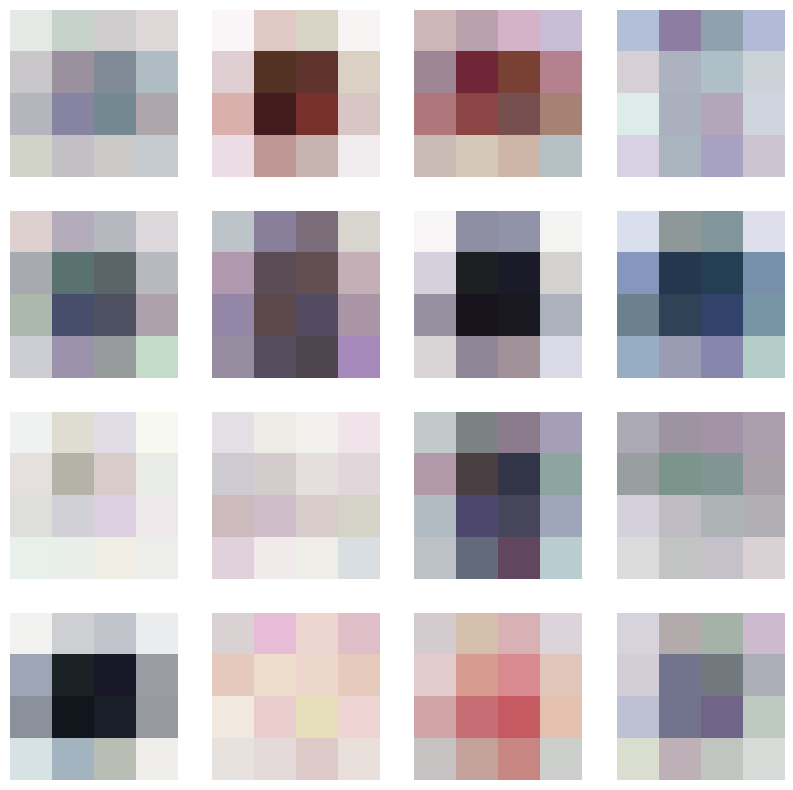

Step: 616
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6105999946594238
Generator loss: 1.3395332098007202


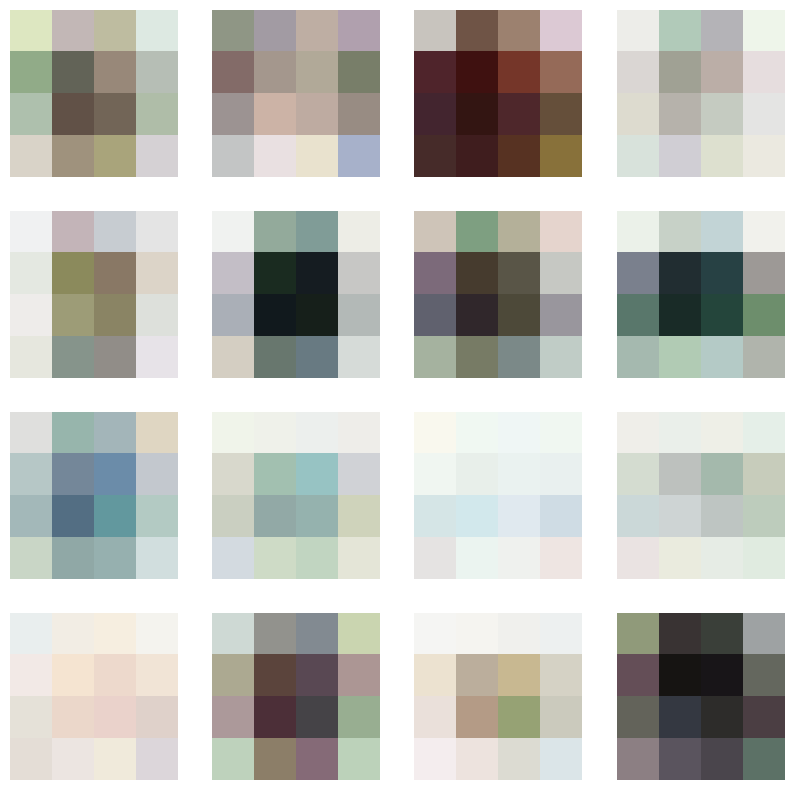

Step: 617
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6098642349243164
Generator loss: 1.3373582363128662


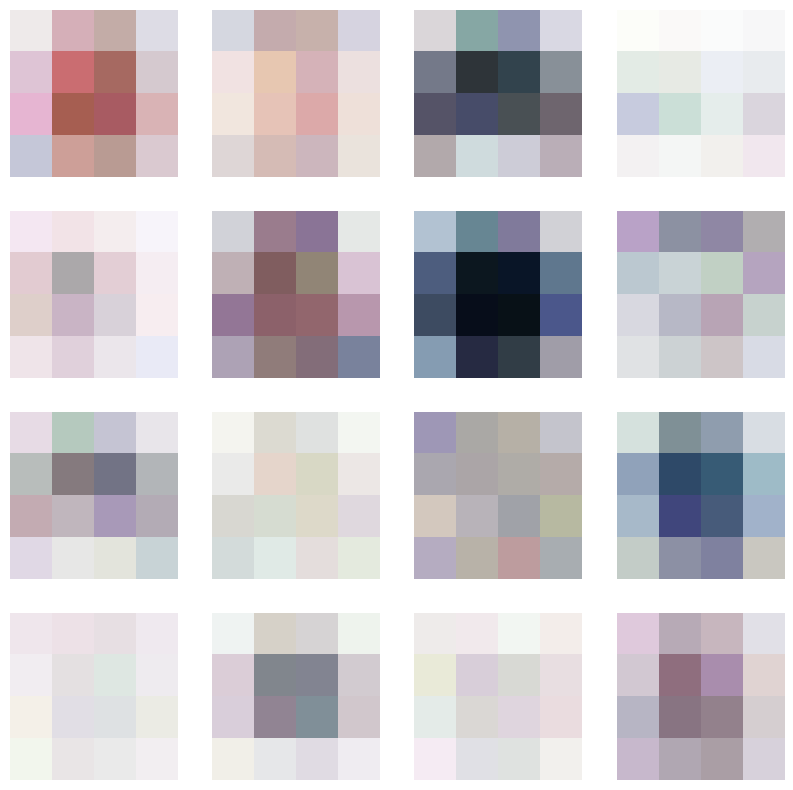

Step: 618
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6089805960655212
Generator loss: 1.3352806568145752


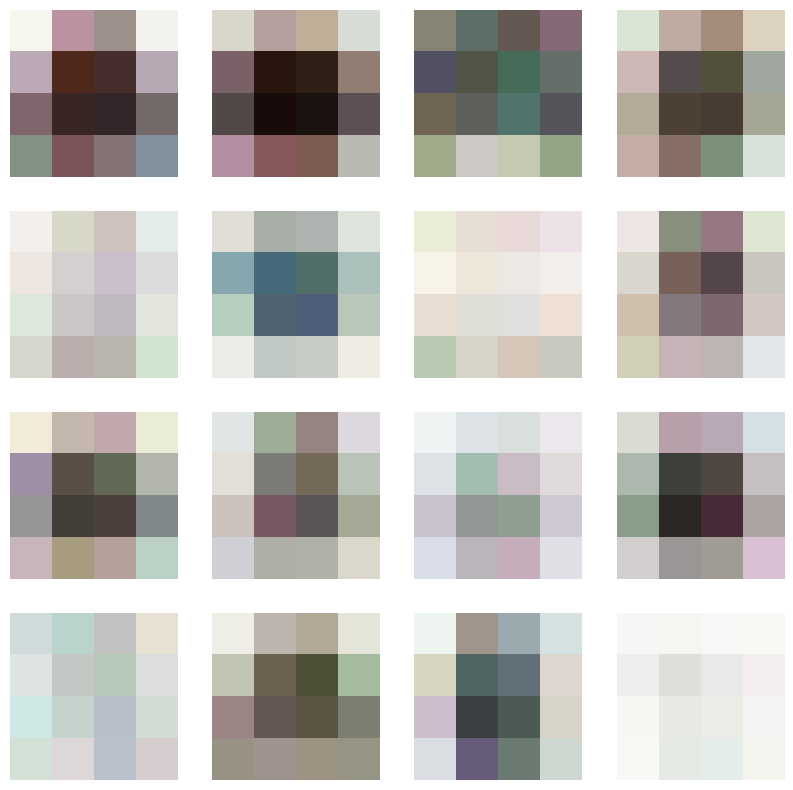

Step: 619
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6083399057388306
Generator loss: 1.3330832719802856


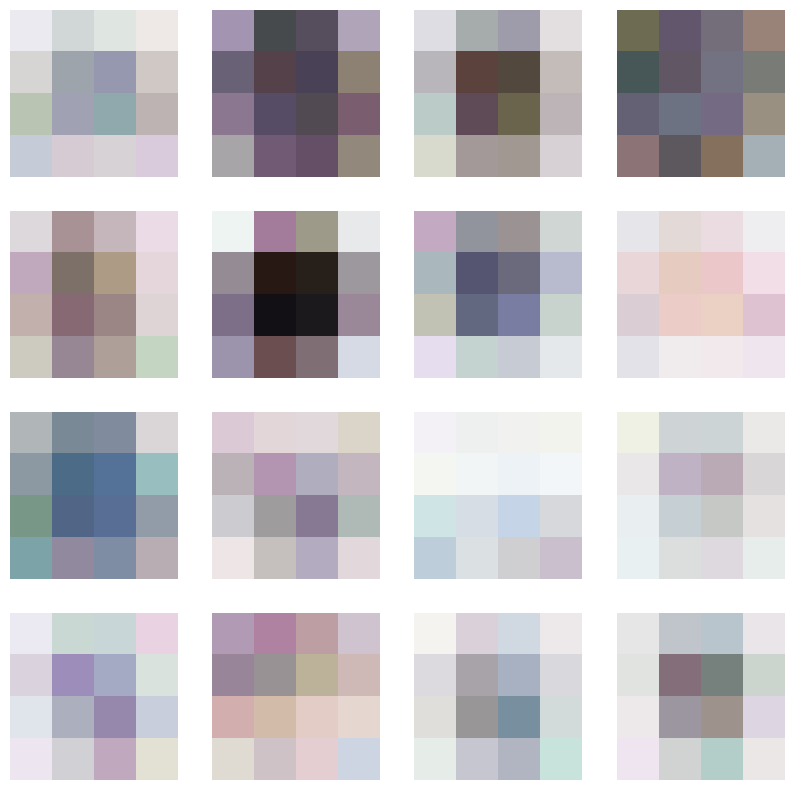

Step: 620
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6076423525810242
Generator loss: 1.3308449983596802


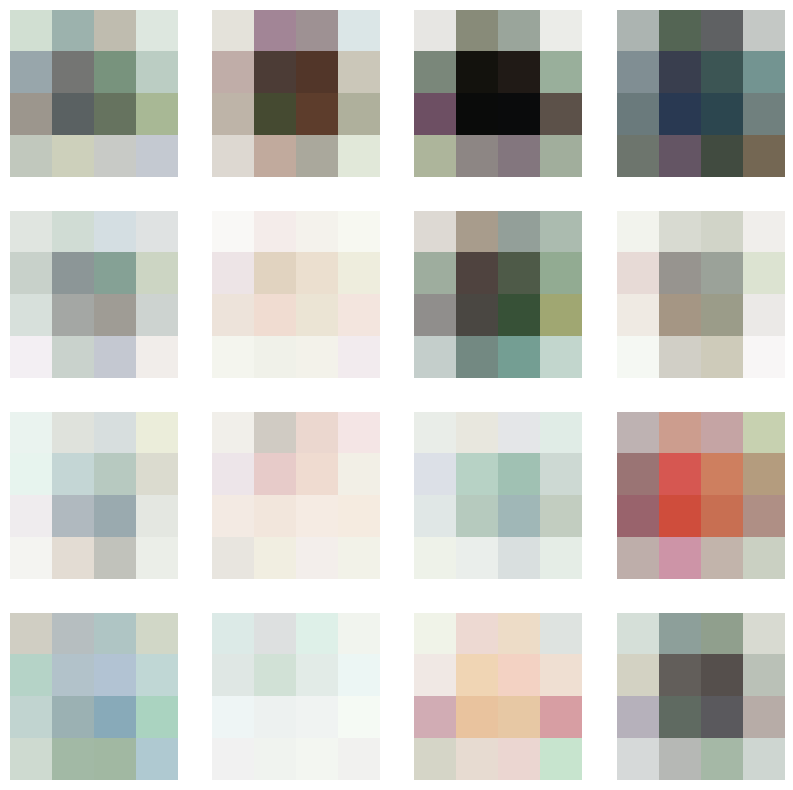

Step: 621
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6069076061248779
Generator loss: 1.3280009031295776


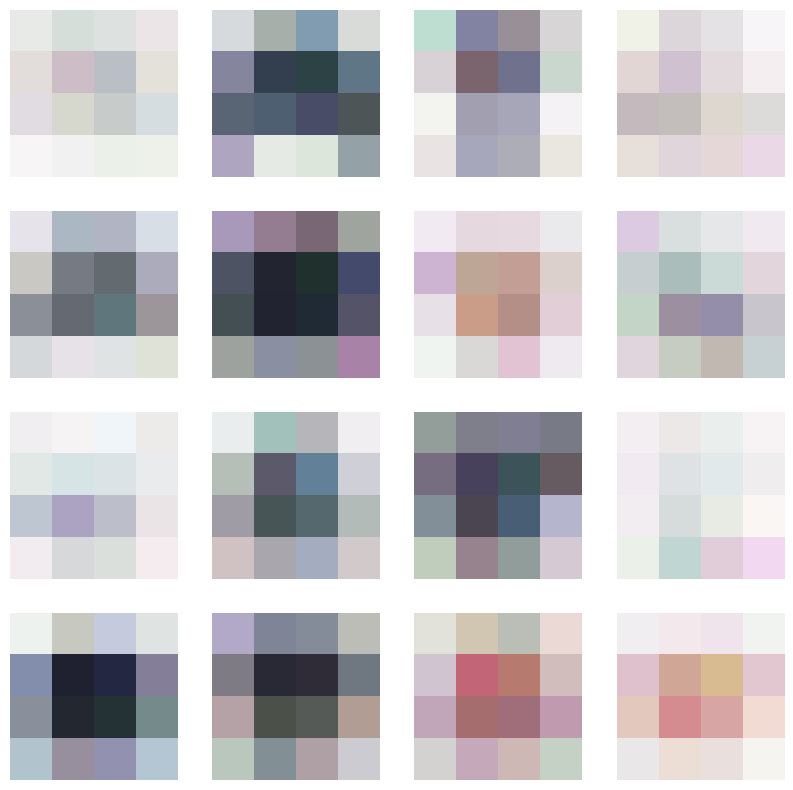

Step: 622
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6059631705284119
Generator loss: 1.3260778188705444


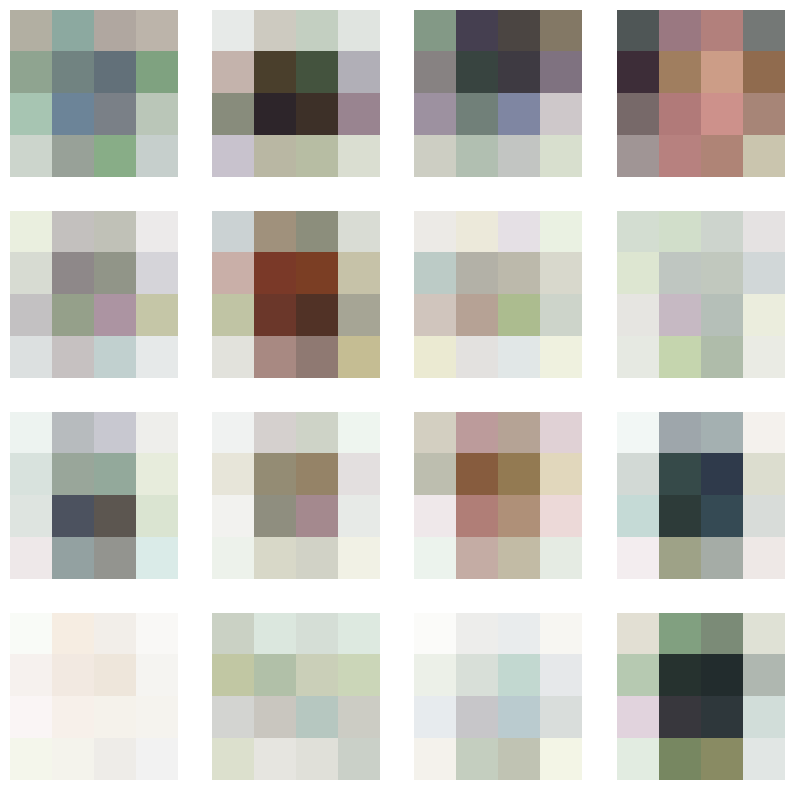

Step: 623
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.605370819568634
Generator loss: 1.3242573738098145


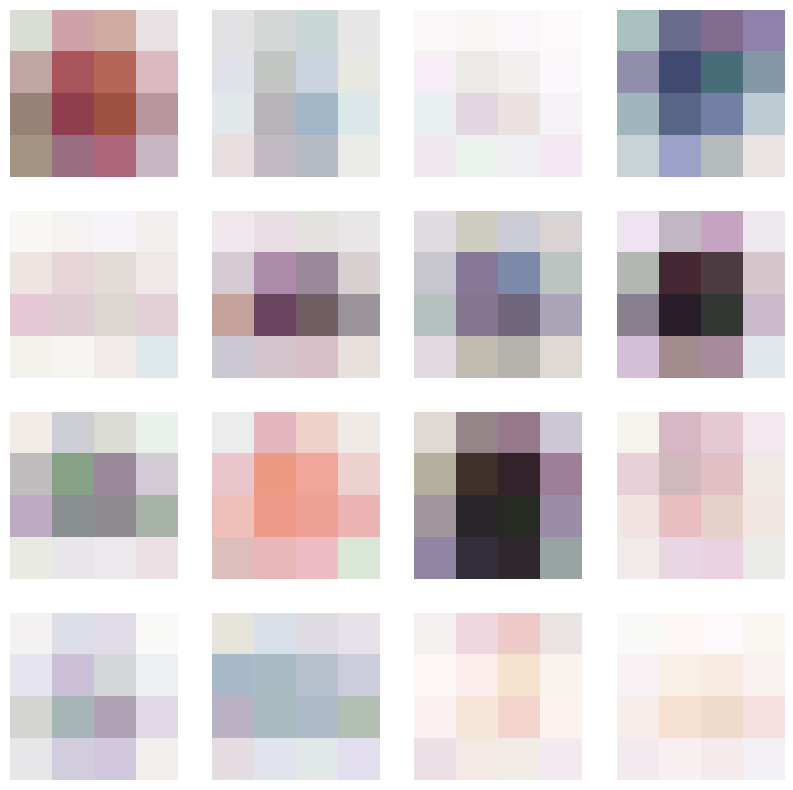

Step: 624
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6045717597007751
Generator loss: 1.3232402801513672


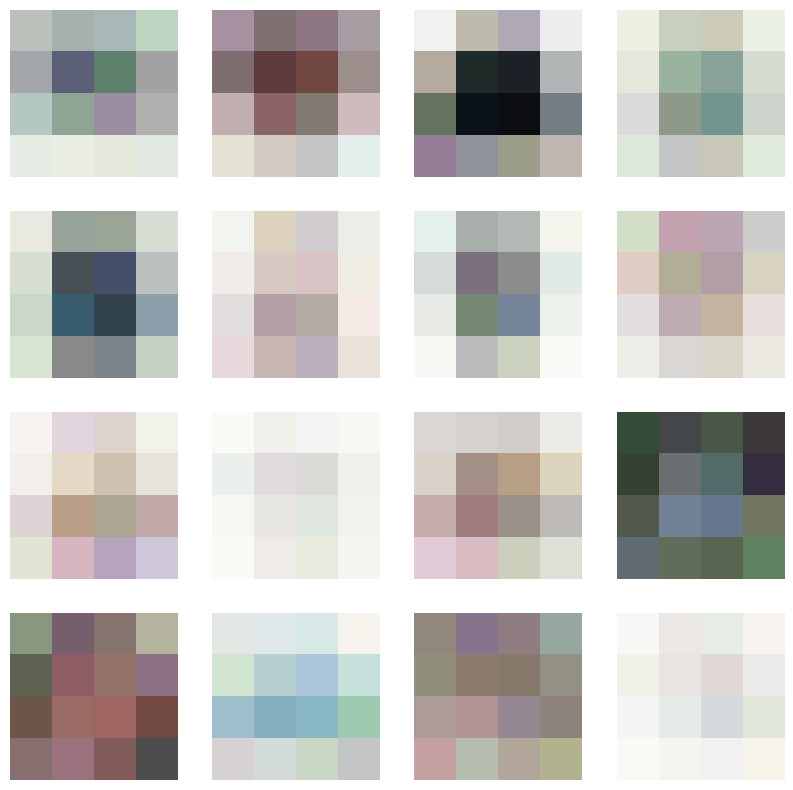

Step: 625
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6037966012954712
Generator loss: 1.321790099143982


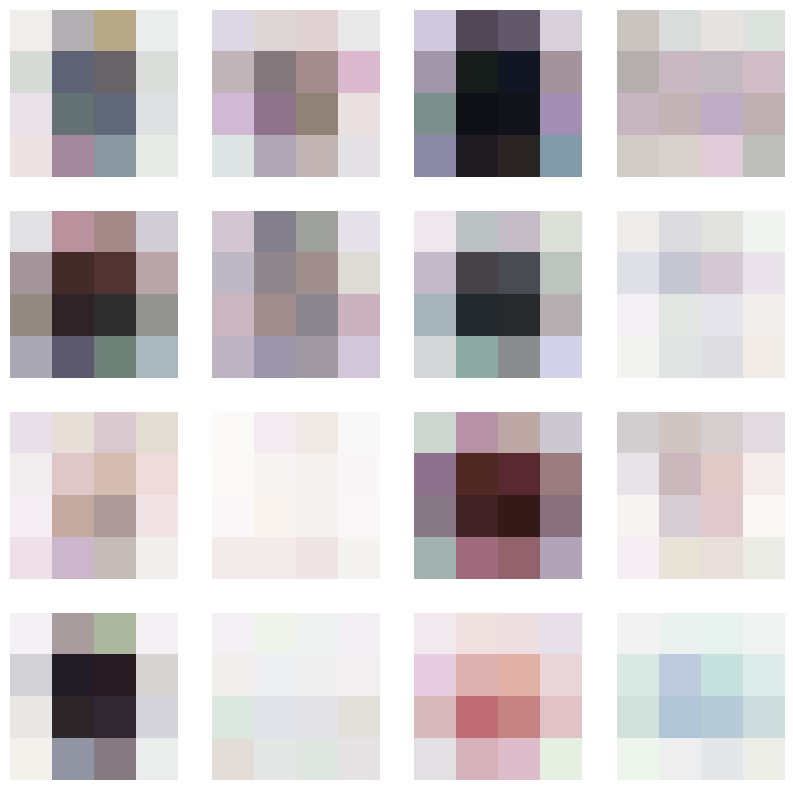

Step: 626
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6031214594841003
Generator loss: 1.320217251777649


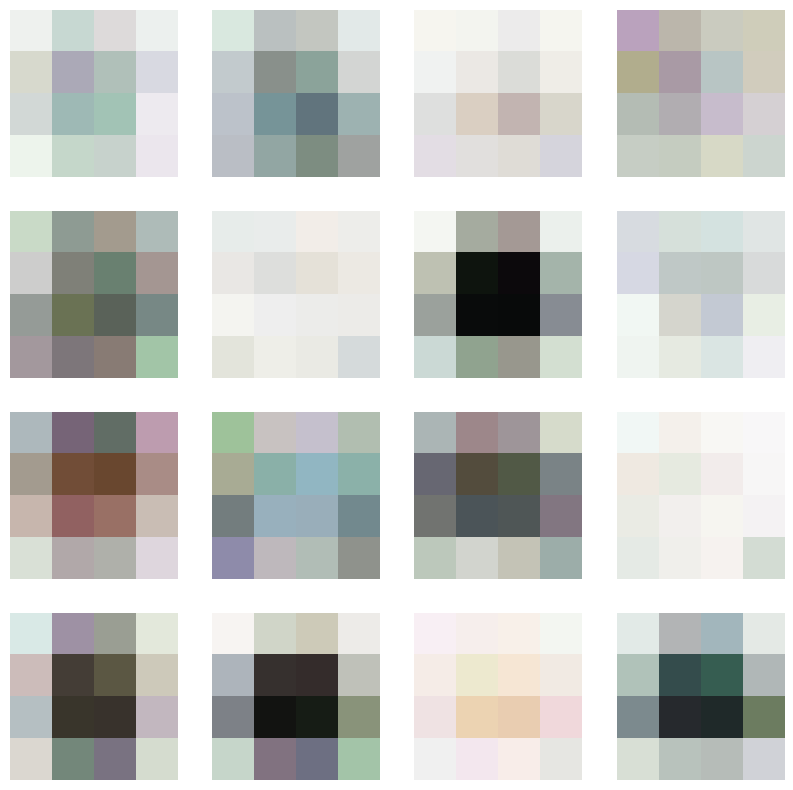

Step: 627
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6023094058036804
Generator loss: 1.318331241607666


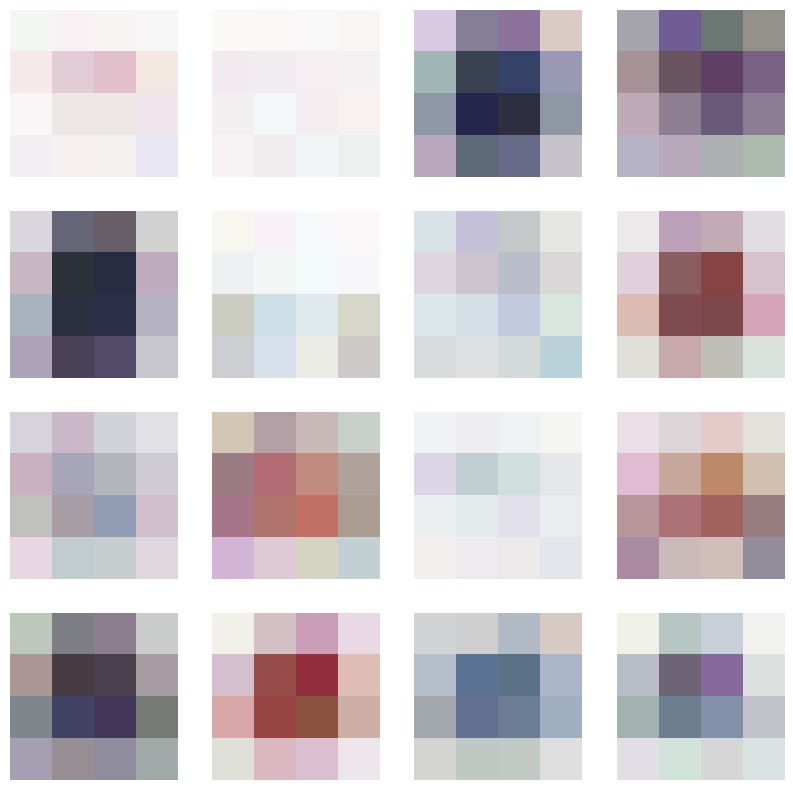

Step: 628
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6014946103096008
Generator loss: 1.3164671659469604


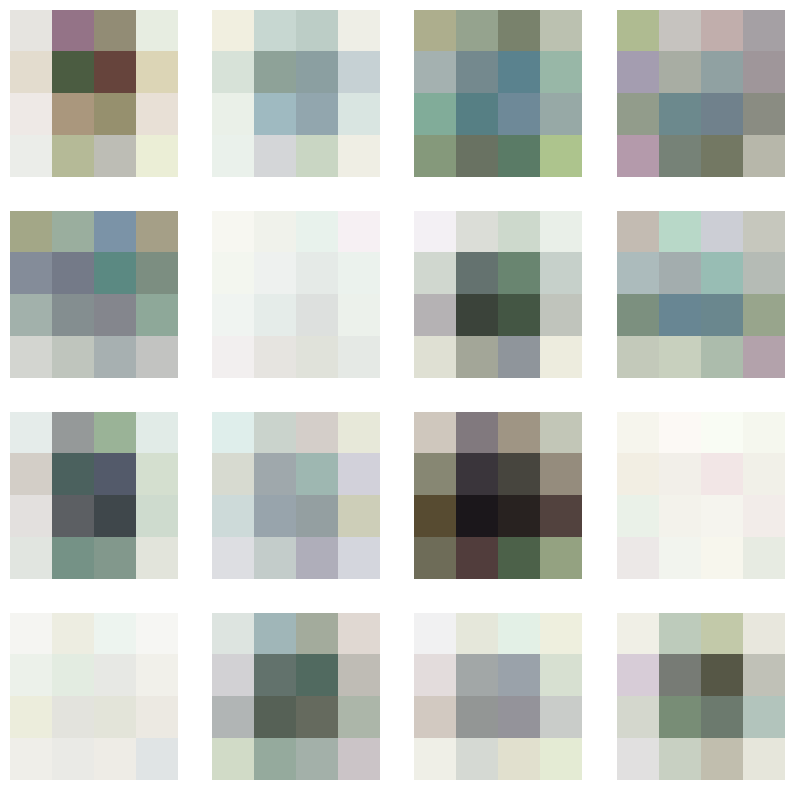

Step: 629
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6009337902069092
Generator loss: 1.3145686388015747


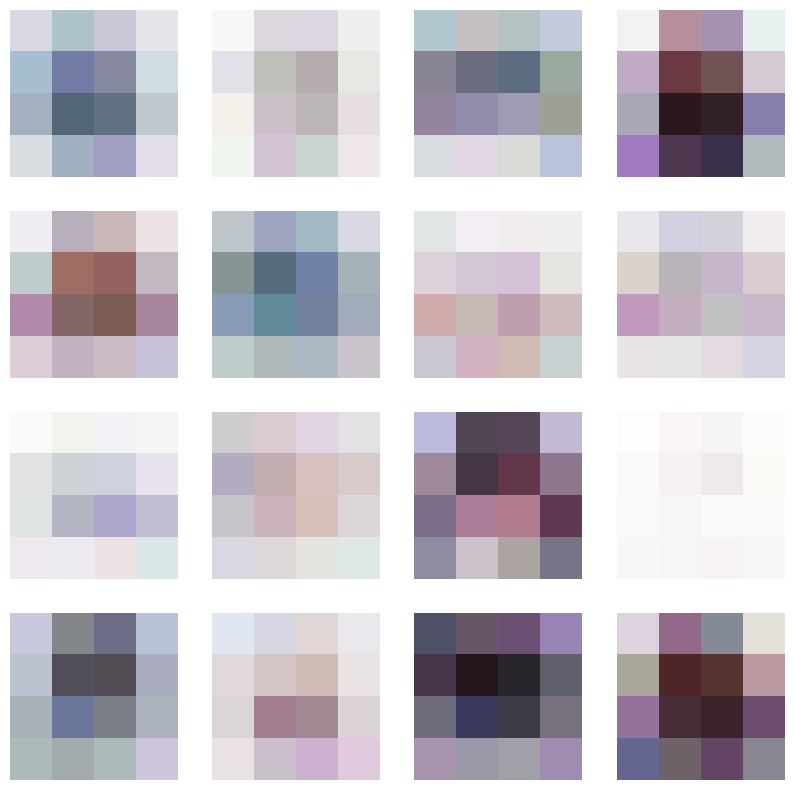

Step: 630
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.6003137826919556
Generator loss: 1.3123399019241333


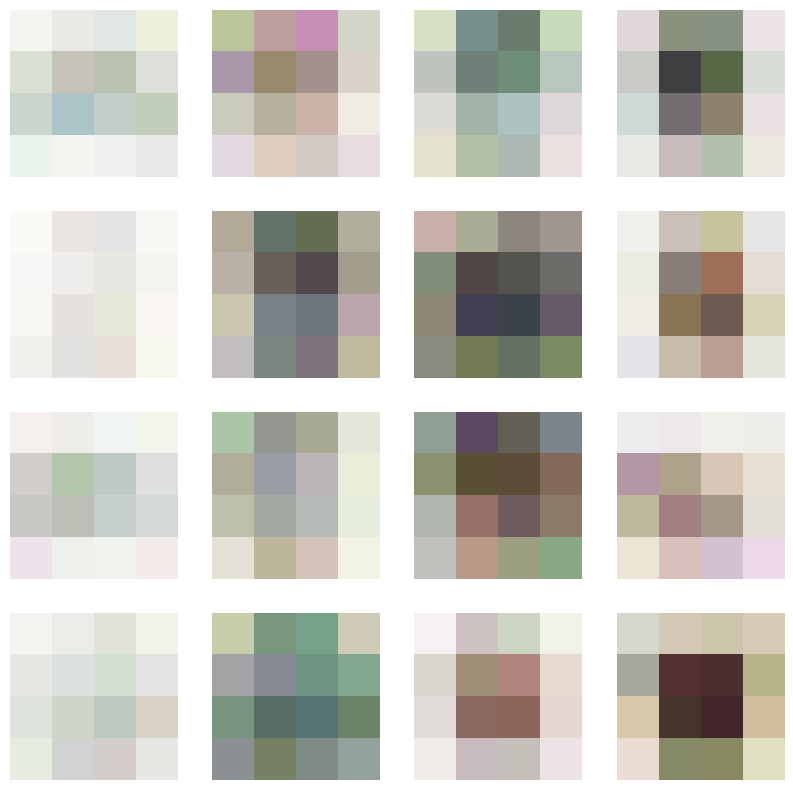

Step: 631
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.59961998462677
Generator loss: 1.3101032972335815


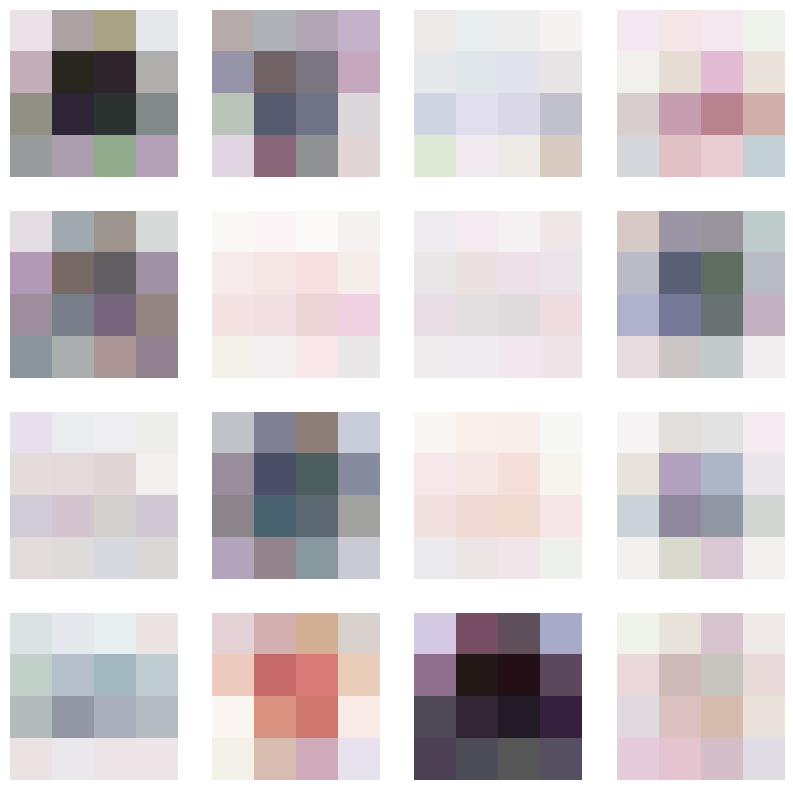

Step: 632
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.59886634349823
Generator loss: 1.3087114095687866


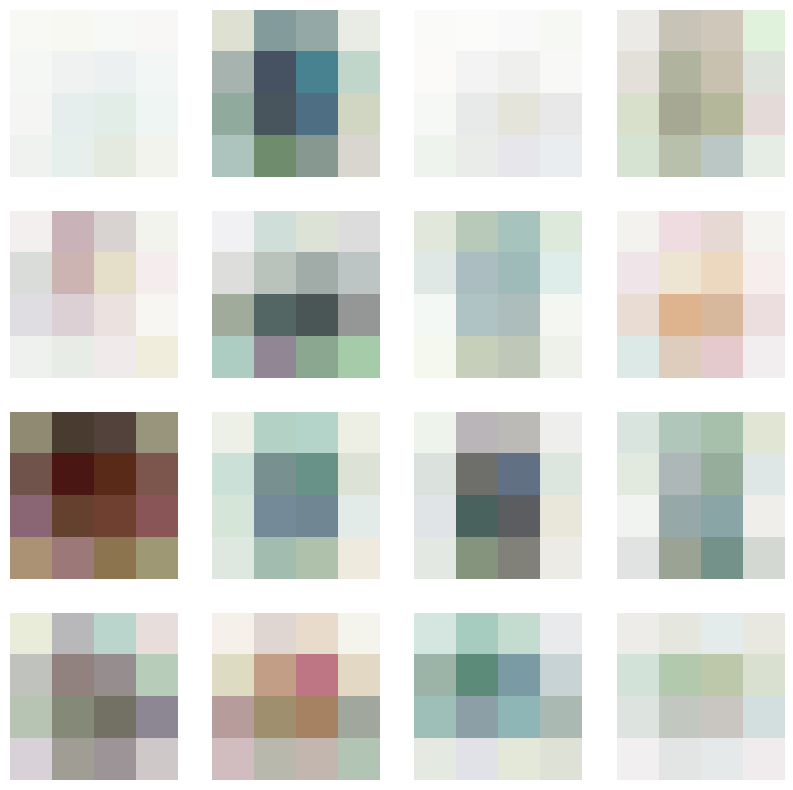

Step: 633
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5981566309928894
Generator loss: 1.3069716691970825


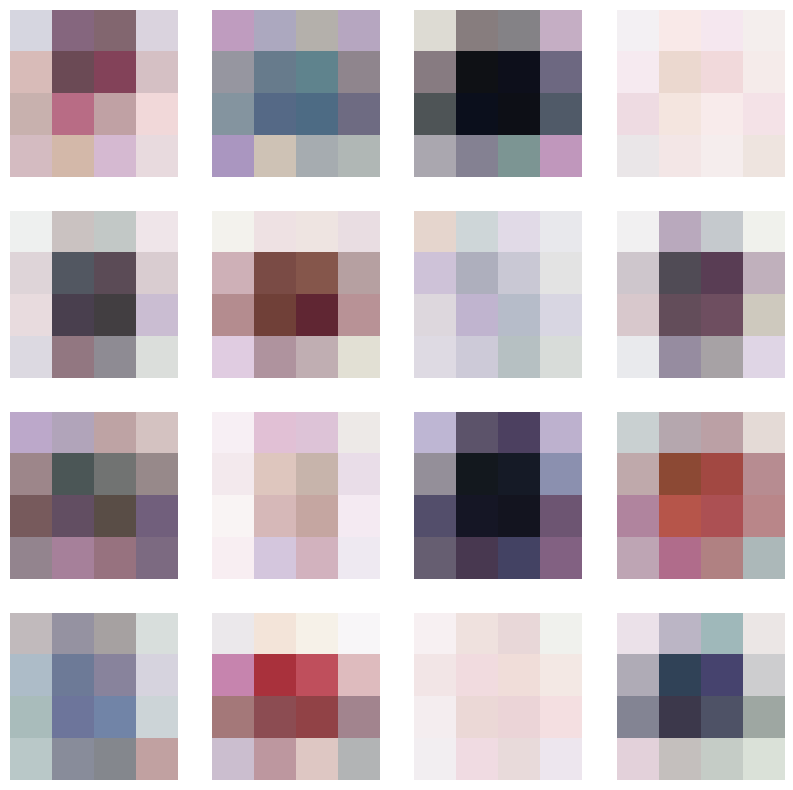

Step: 634
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5976049900054932
Generator loss: 1.3054981231689453


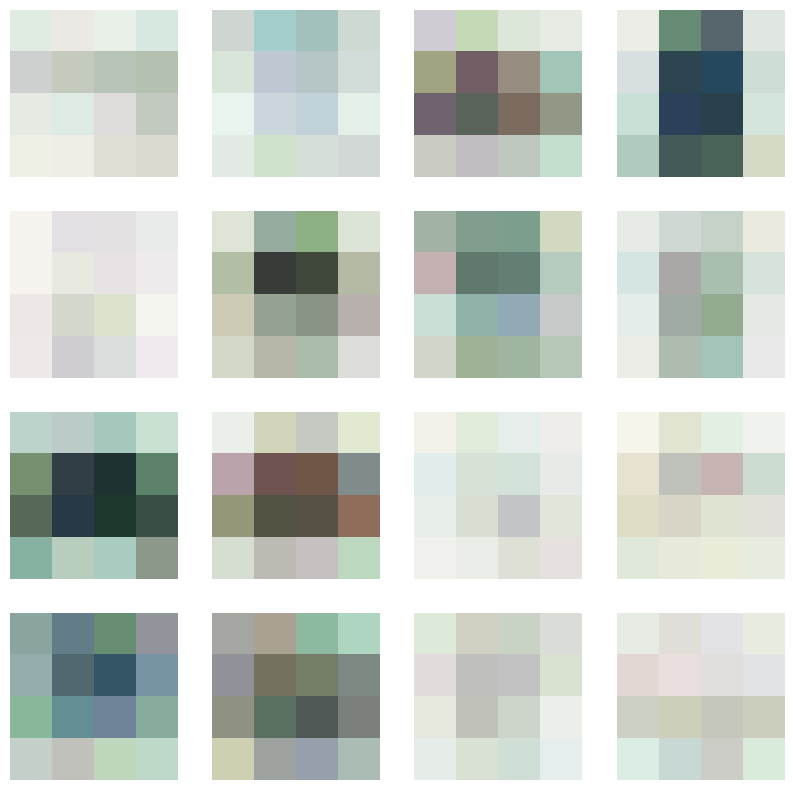

Step: 635
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.596928060054779
Generator loss: 1.3038898706436157


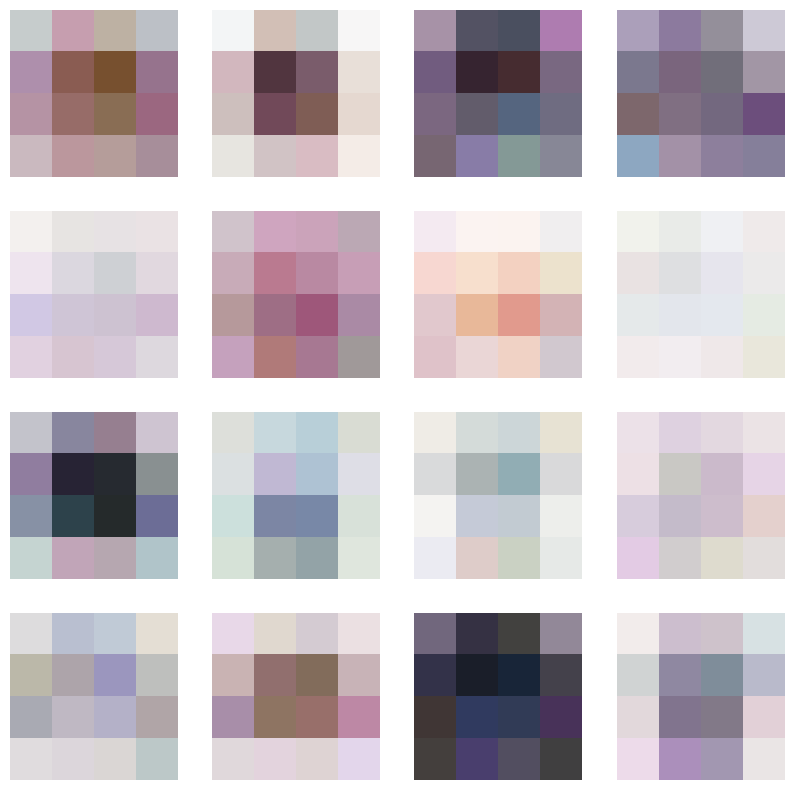

Step: 636
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5961463451385498
Generator loss: 1.3015530109405518


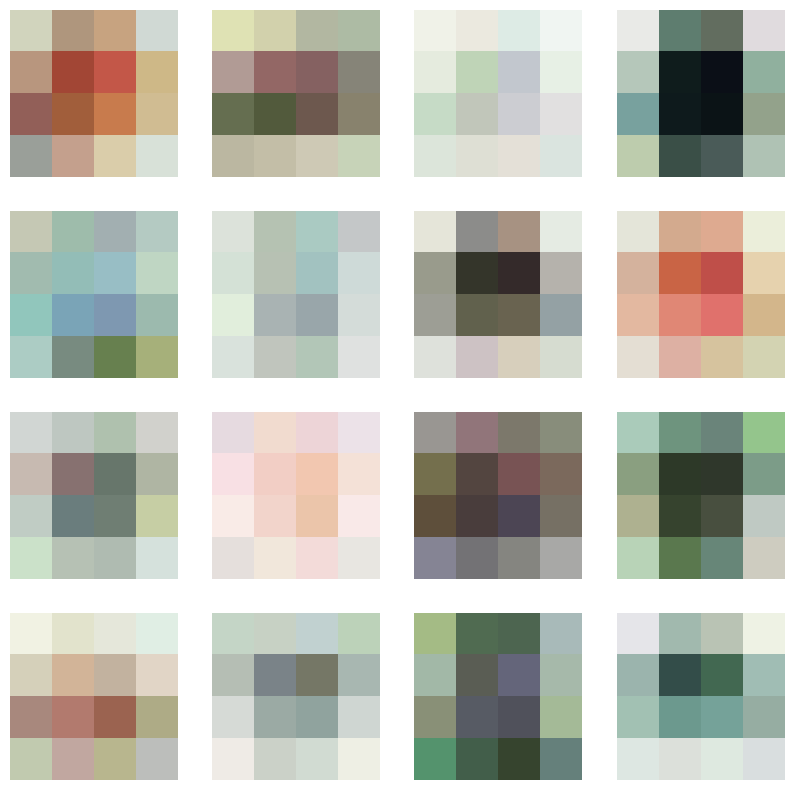

Step: 637
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5955225229263306
Generator loss: 1.2988874912261963


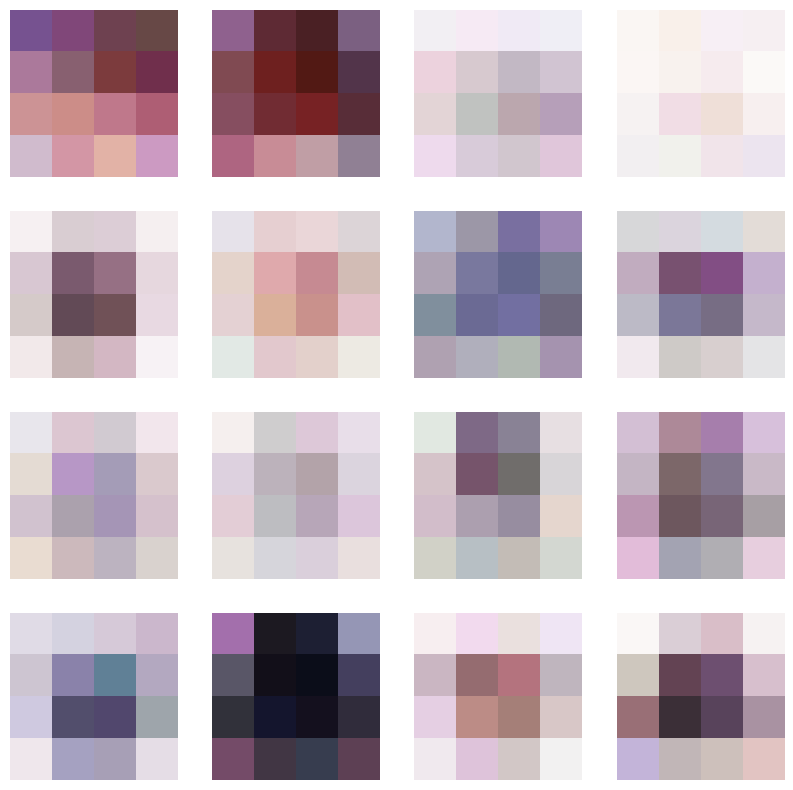

Step: 638
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5948833227157593
Generator loss: 1.2961009740829468


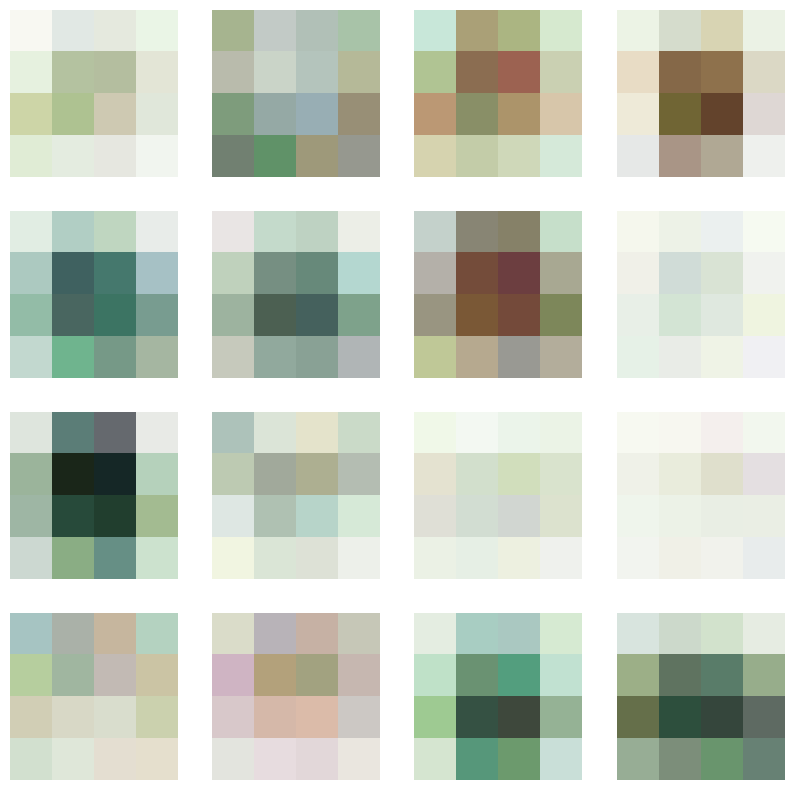

Step: 639
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5941178202629089
Generator loss: 1.293817400932312


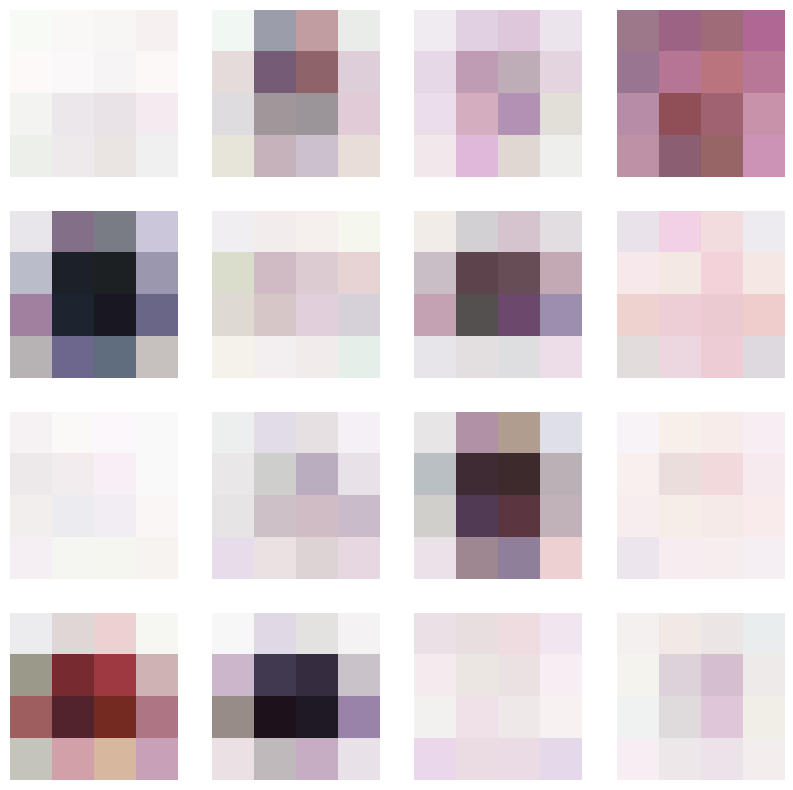

Step: 640
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5932988524436951
Generator loss: 1.2915196418762207


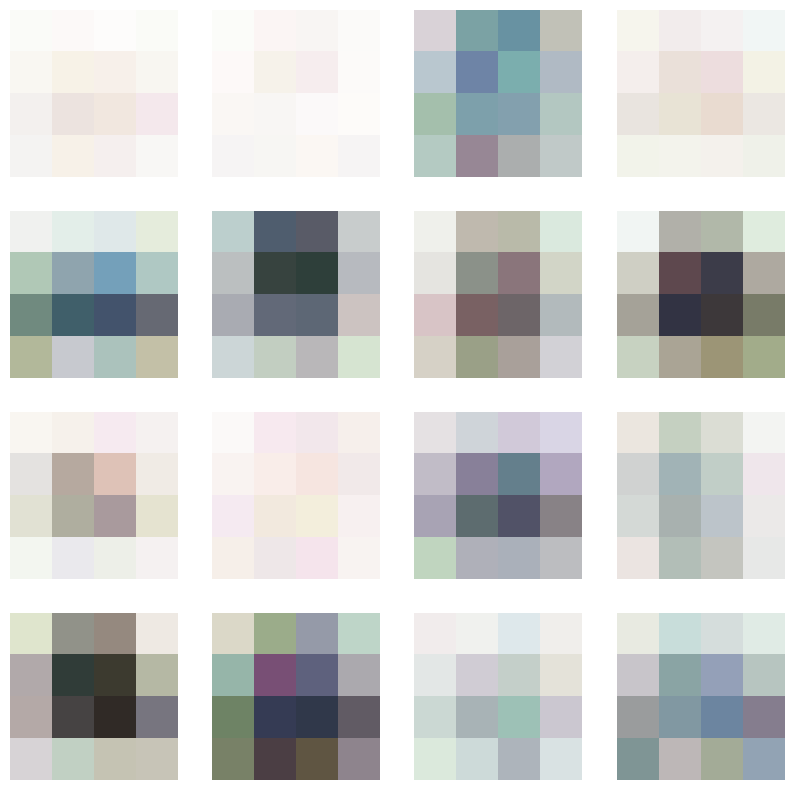

Step: 641
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5923944115638733
Generator loss: 1.290320634841919


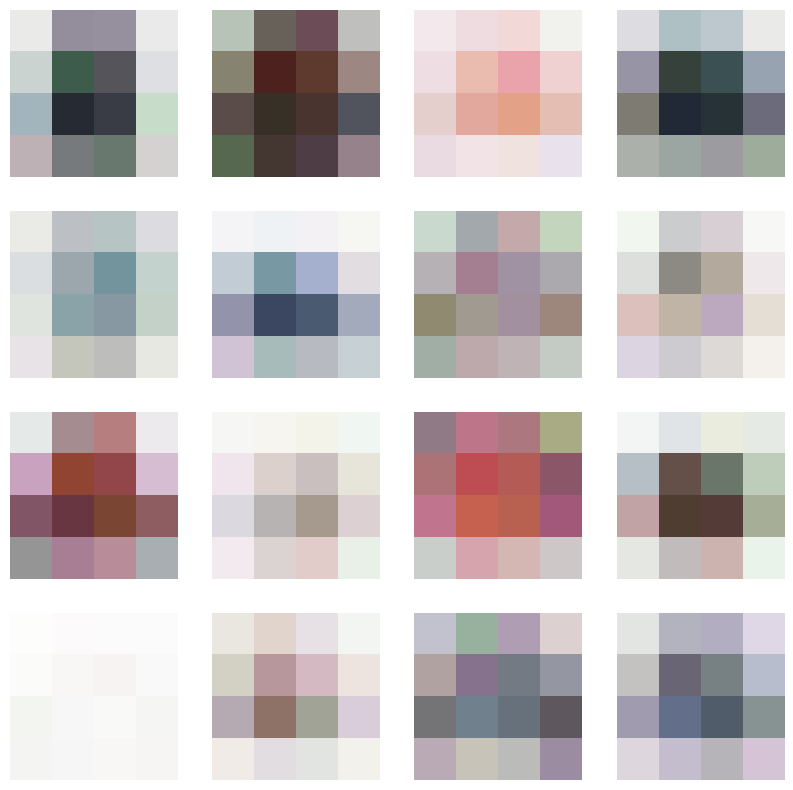

Step: 642
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5918142199516296
Generator loss: 1.289560079574585


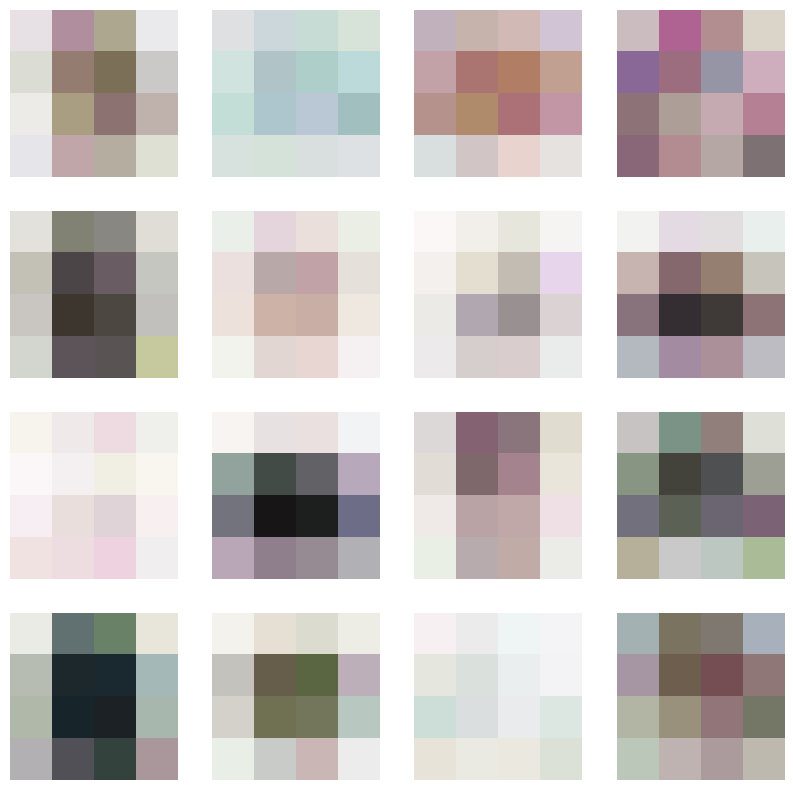

Step: 643
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5909975171089172
Generator loss: 1.2880178689956665


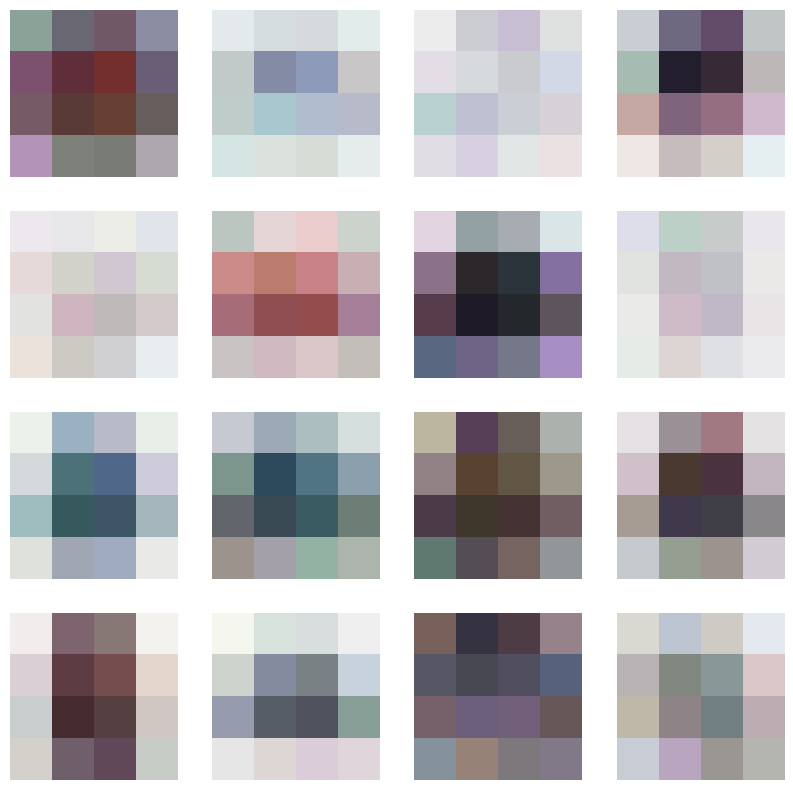

Step: 644
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5902000665664673
Generator loss: 1.286065936088562


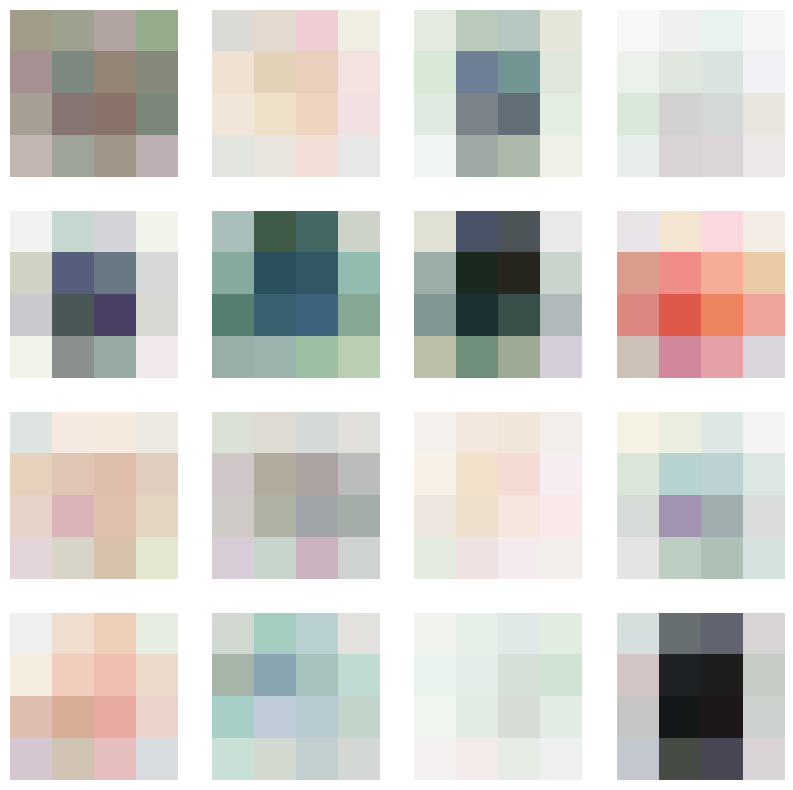

Step: 645
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5895455479621887
Generator loss: 1.2840139865875244


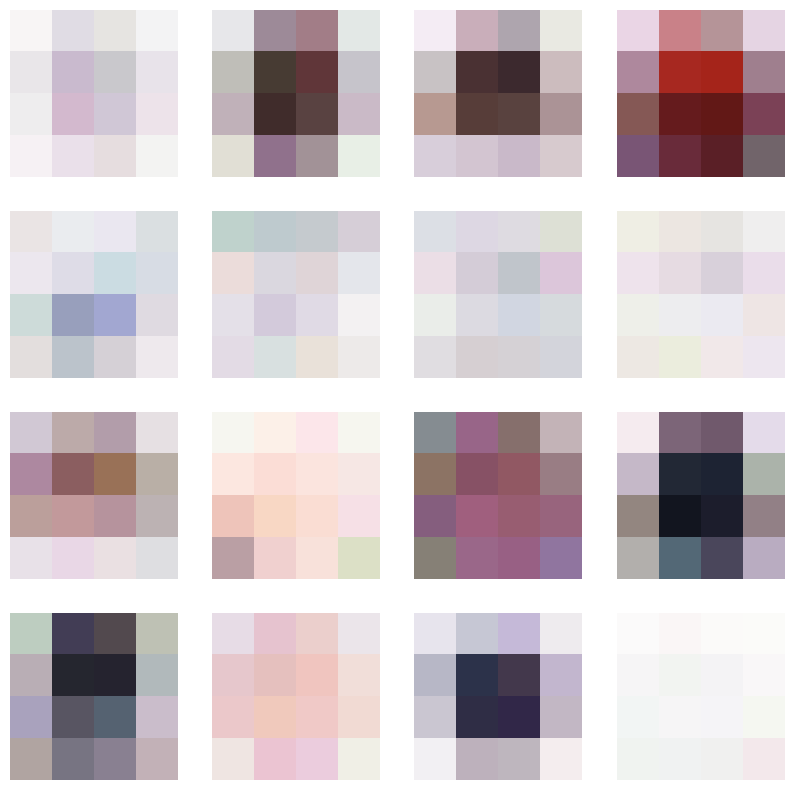

Step: 646
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5888577699661255
Generator loss: 1.2819786071777344


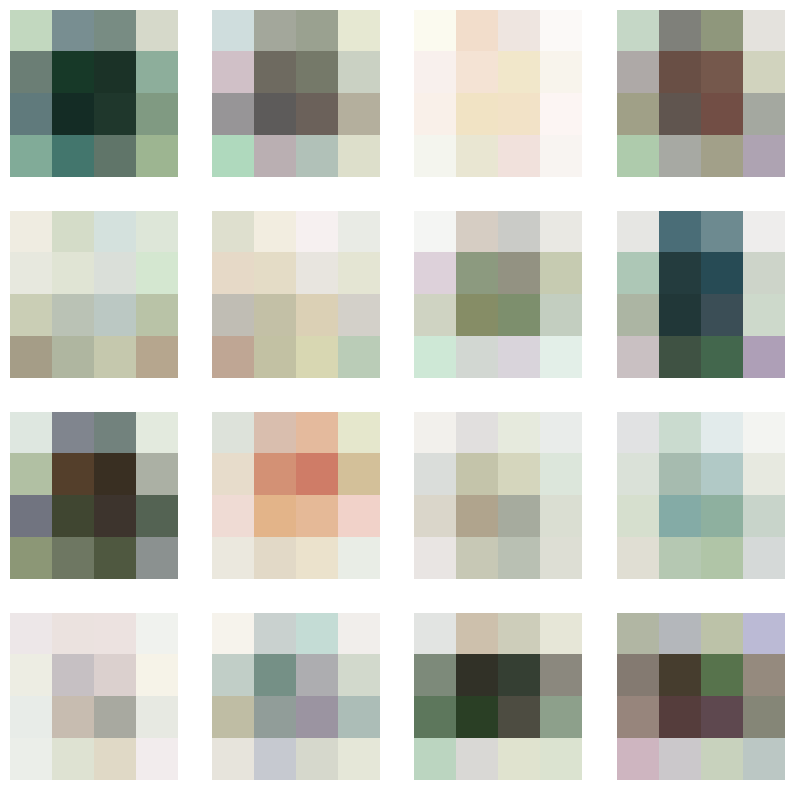

Step: 647
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5882360339164734
Generator loss: 1.2798104286193848


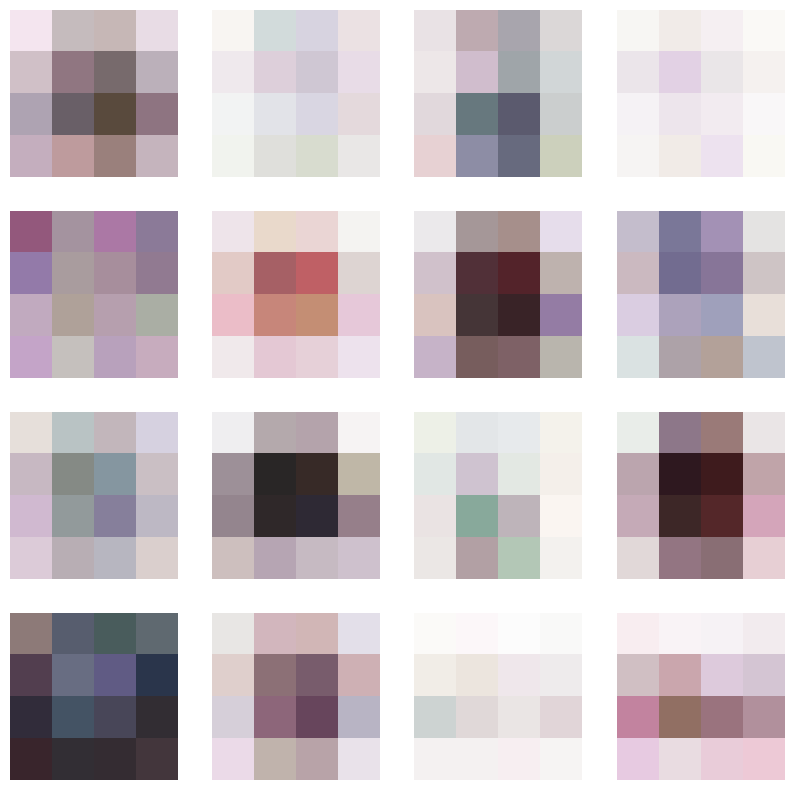

Step: 648
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5875633955001831
Generator loss: 1.278015375137329


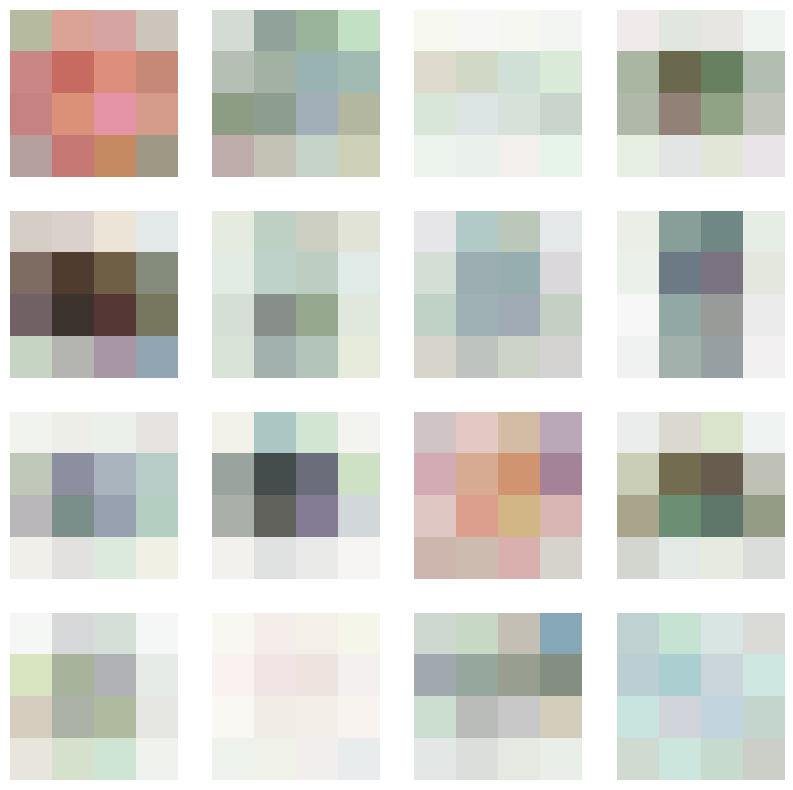

Step: 649
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.586916446685791
Generator loss: 1.2768712043762207


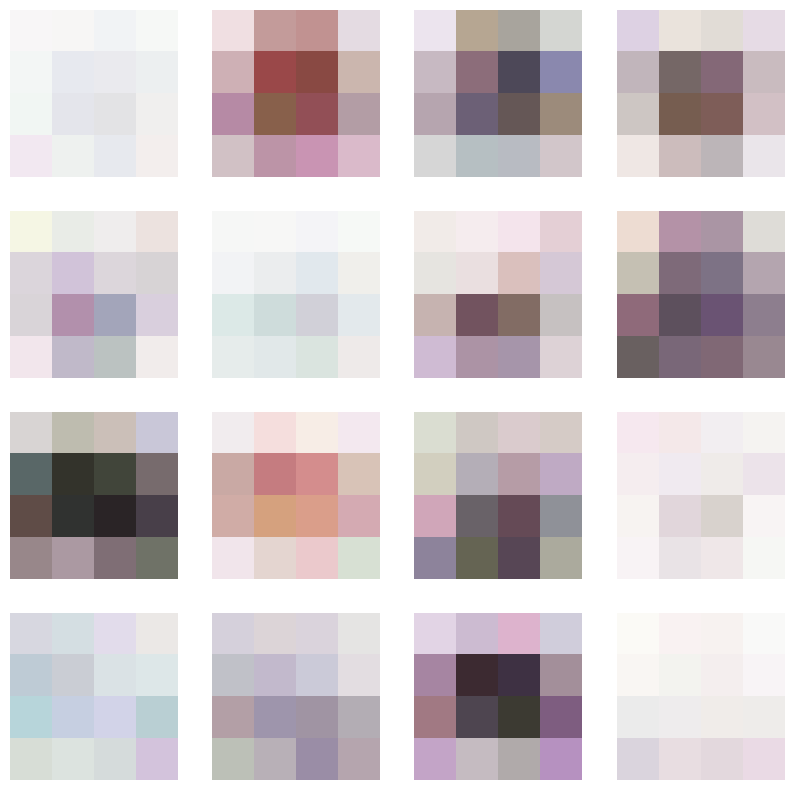

Step: 650
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5862496495246887
Generator loss: 1.2753729820251465


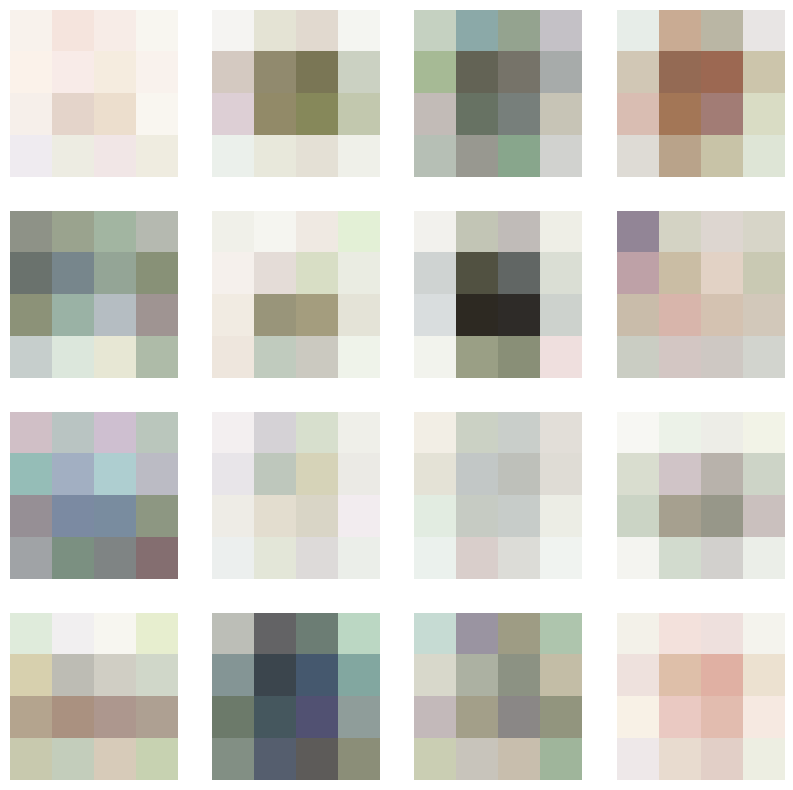

Step: 651
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5856753587722778
Generator loss: 1.2738457918167114


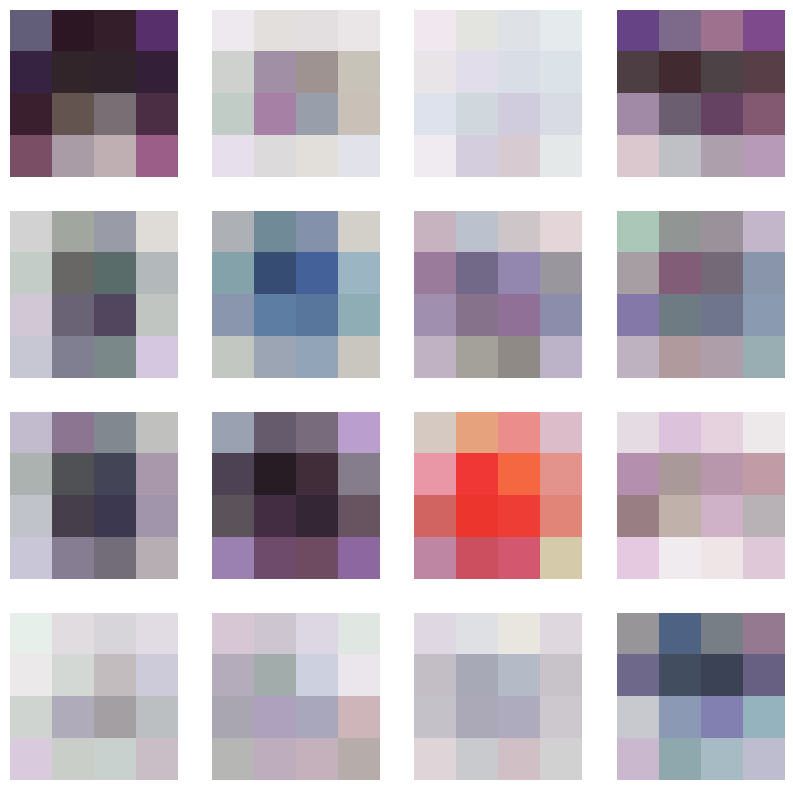

Step: 652
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5849289894104004
Generator loss: 1.2715563774108887


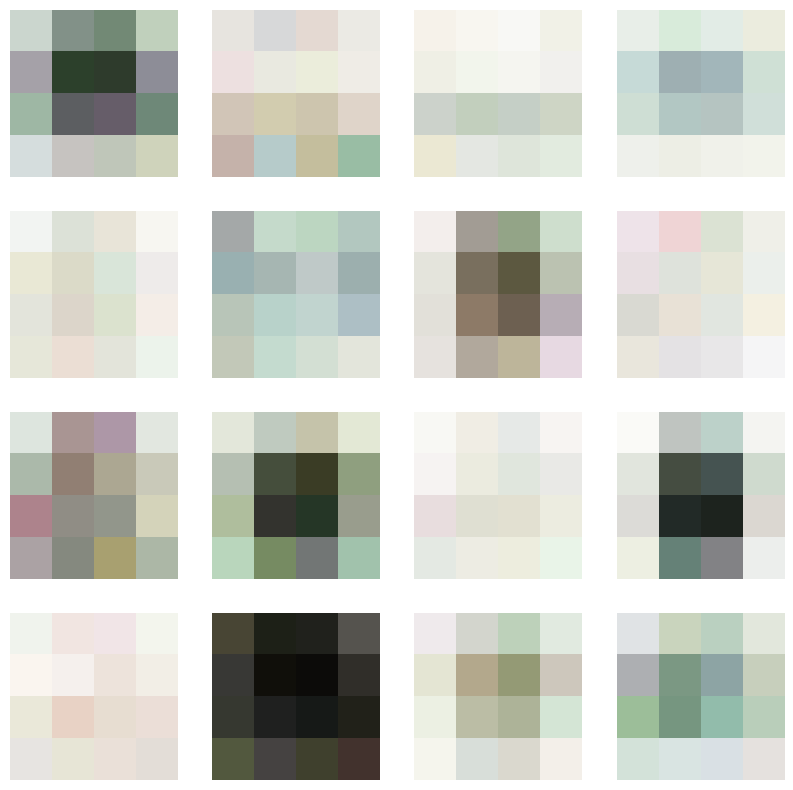

Step: 653
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5844796299934387
Generator loss: 1.2687456607818604


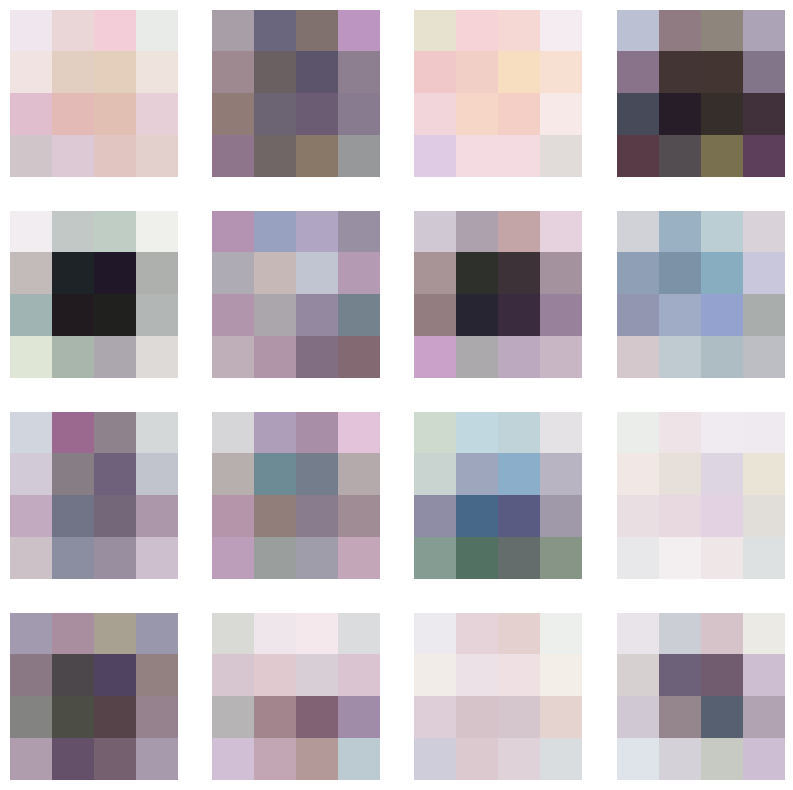

Step: 654
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5837185382843018
Generator loss: 1.2664306163787842


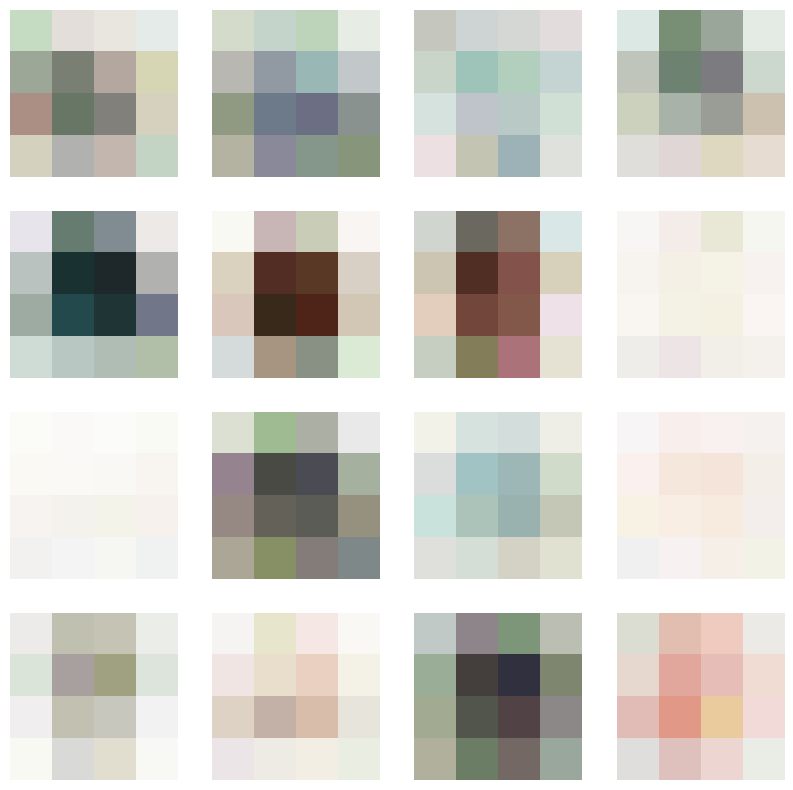

Step: 655
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5830590724945068
Generator loss: 1.2640239000320435


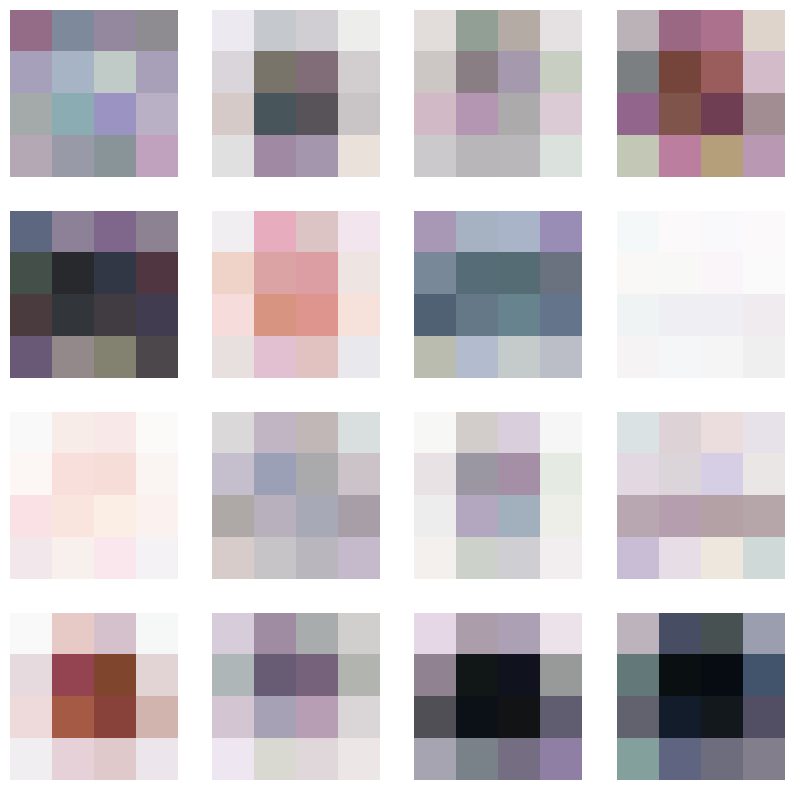

Step: 656
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5824307203292847
Generator loss: 1.262578010559082


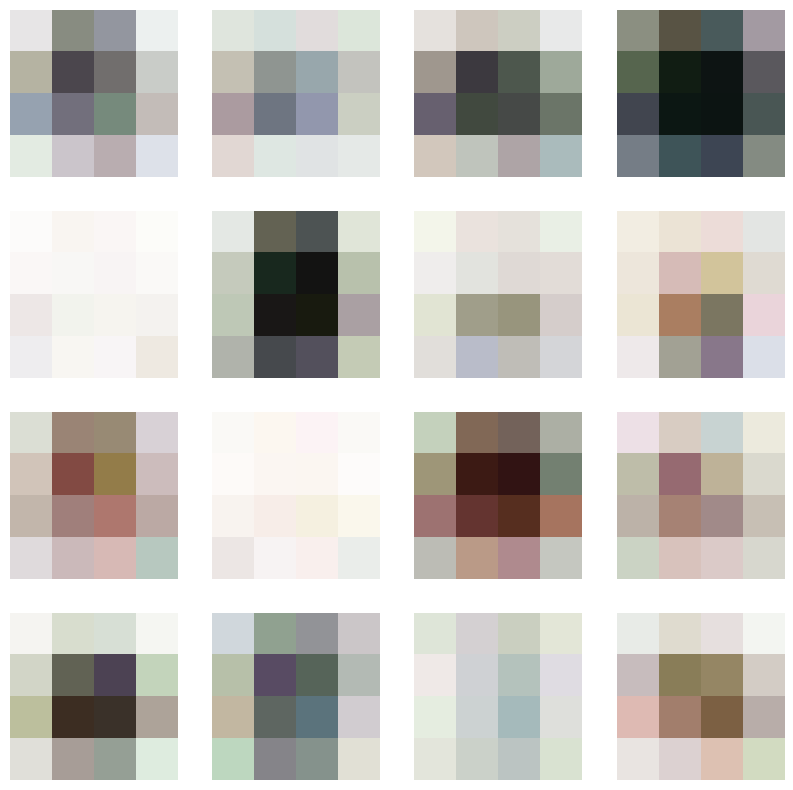

Step: 657
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5818714499473572
Generator loss: 1.2608280181884766


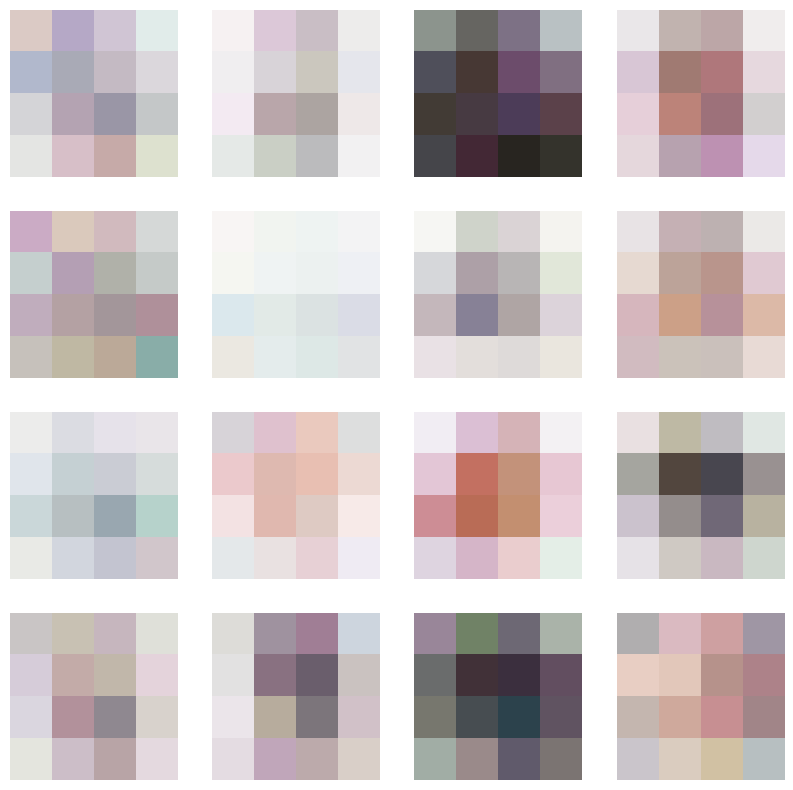

Step: 658
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5810564756393433
Generator loss: 1.258924961090088


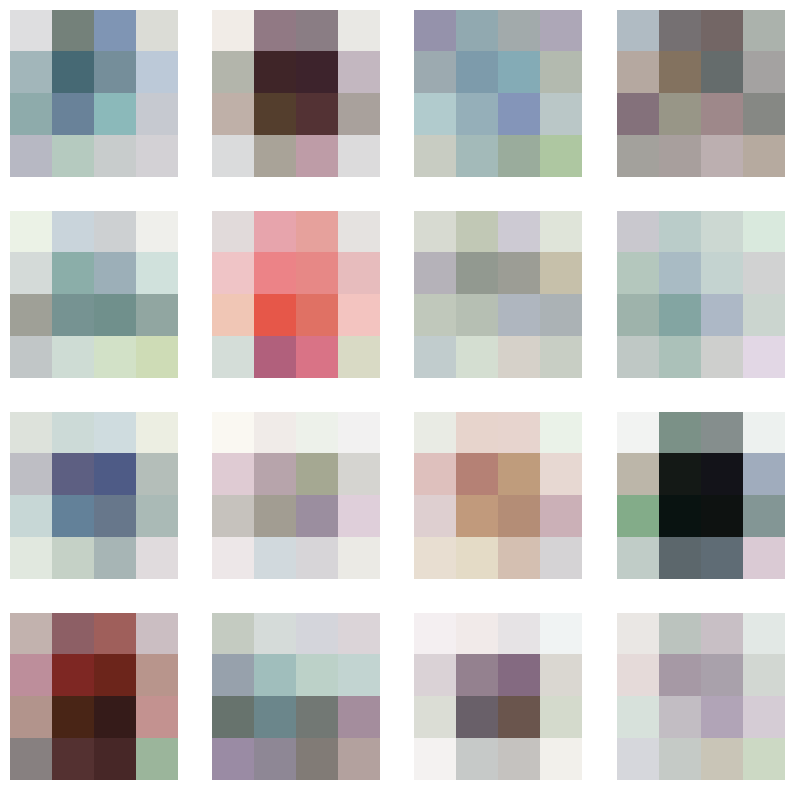

Step: 659
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5802690982818604
Generator loss: 1.2564243078231812


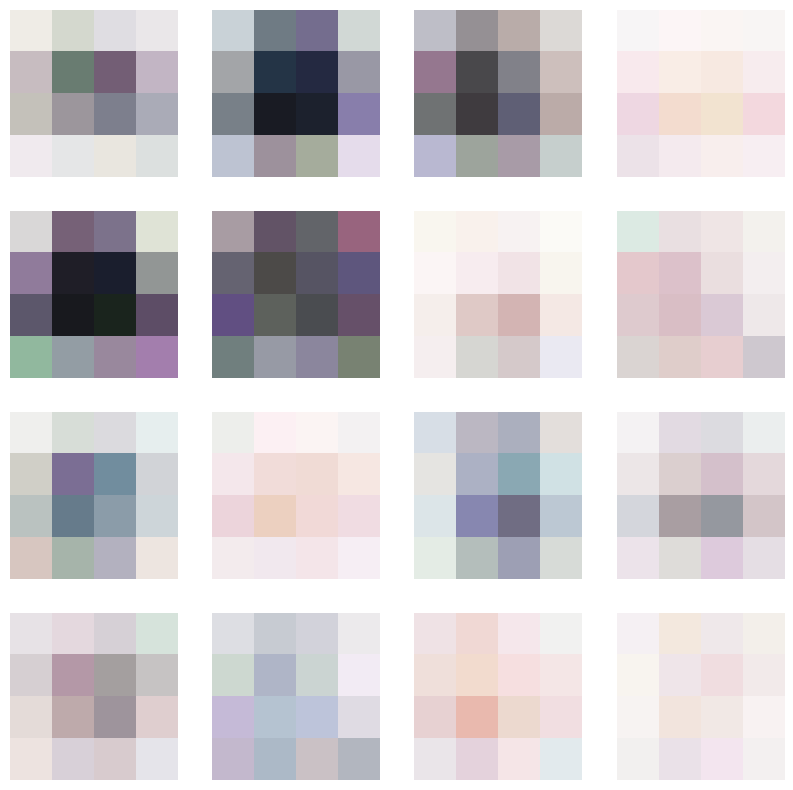

Step: 660
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5795342326164246
Generator loss: 1.253623604774475


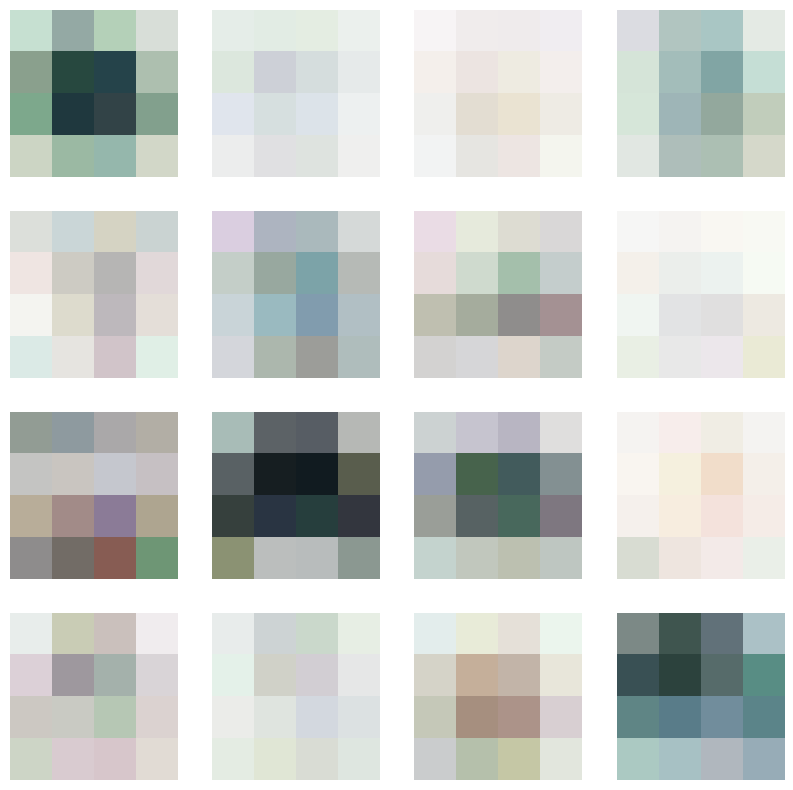

Step: 661
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5786982178688049
Generator loss: 1.2514010667800903


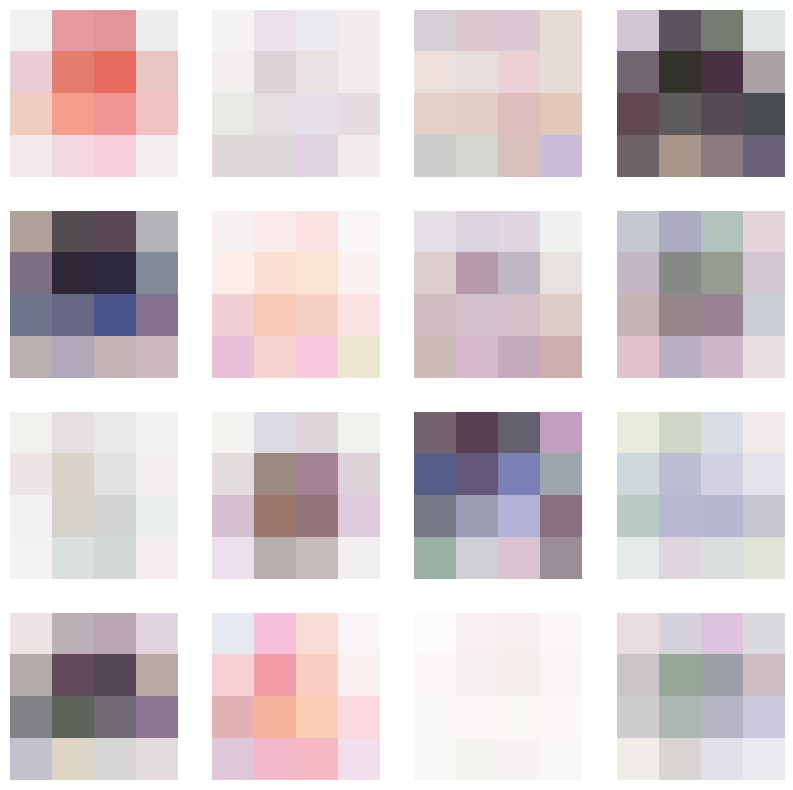

Step: 662
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5781218409538269
Generator loss: 1.249511480331421


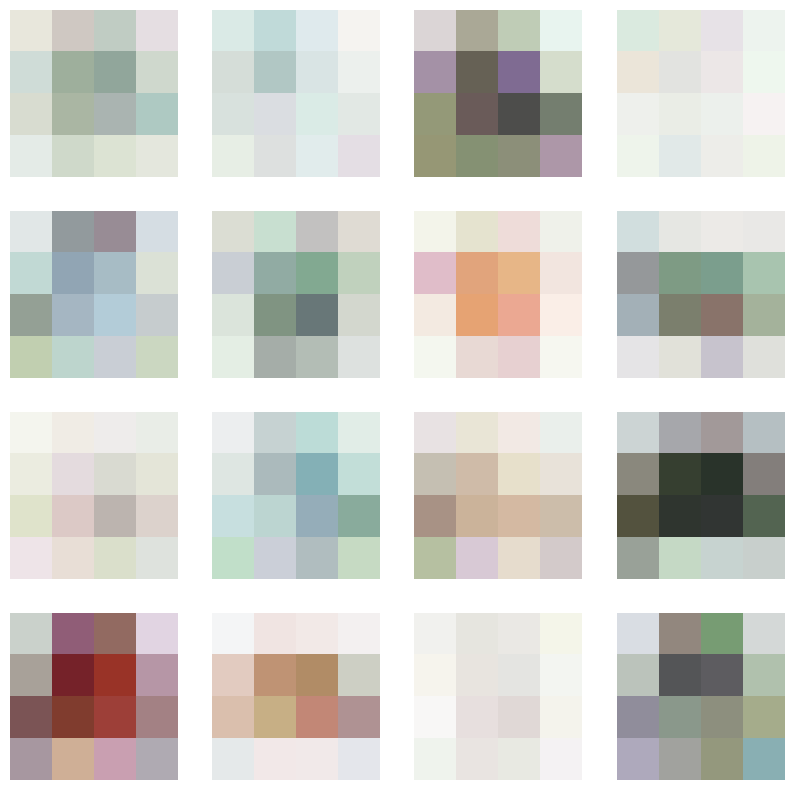

Step: 663
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5774784088134766
Generator loss: 1.2481306791305542


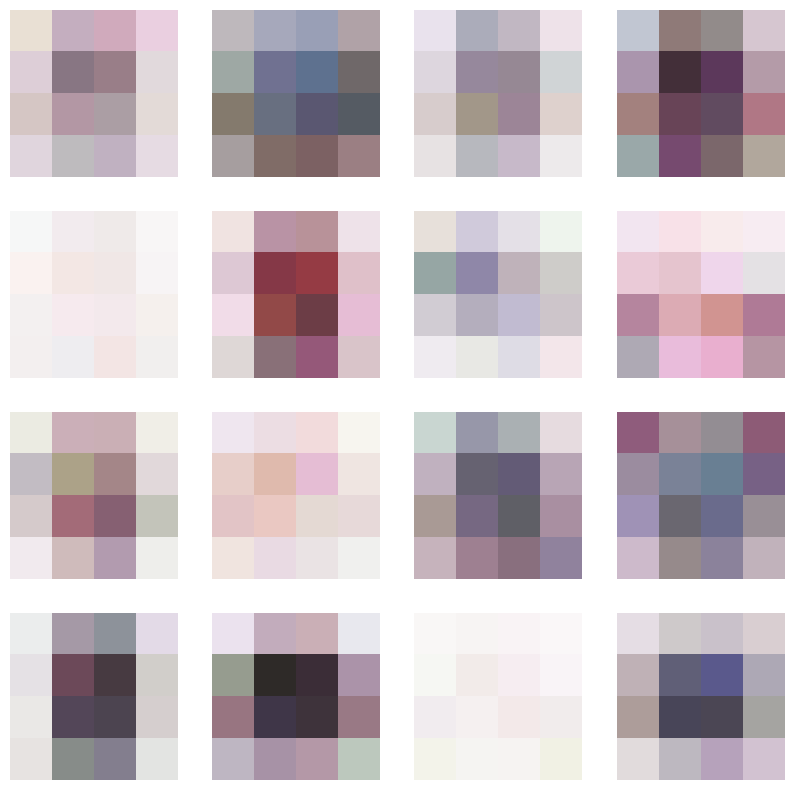

Step: 664
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5768671631813049
Generator loss: 1.2470906972885132


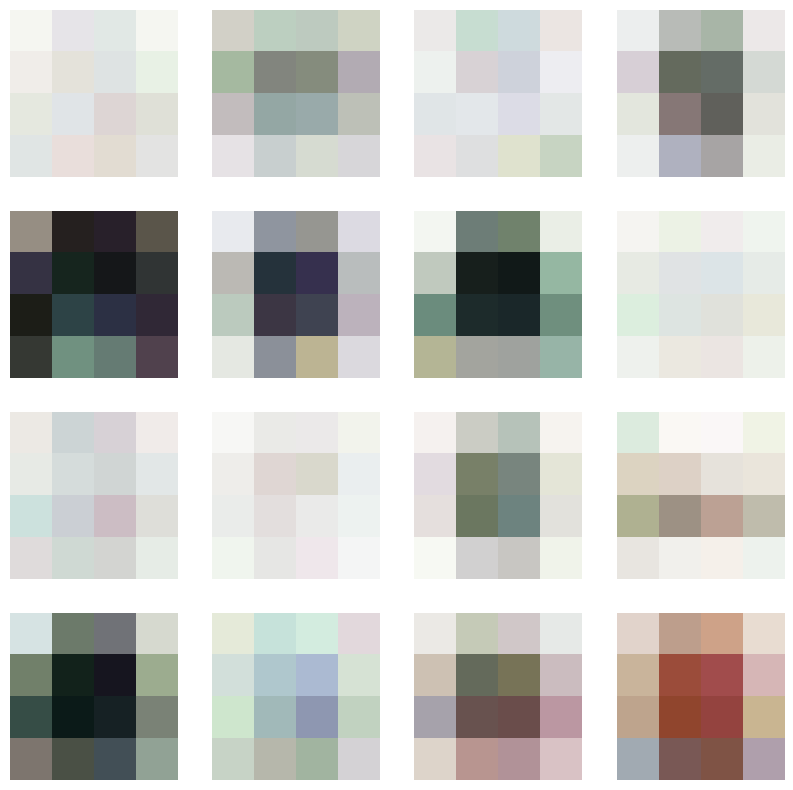

Step: 665
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5762986540794373
Generator loss: 1.2458834648132324


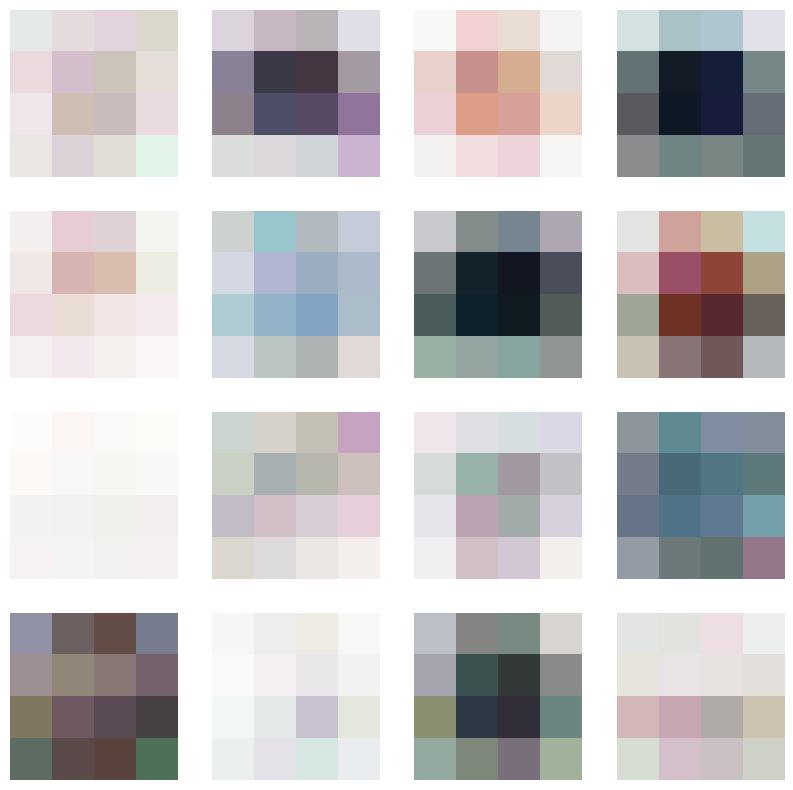

Step: 666
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5757303237915039
Generator loss: 1.2448482513427734


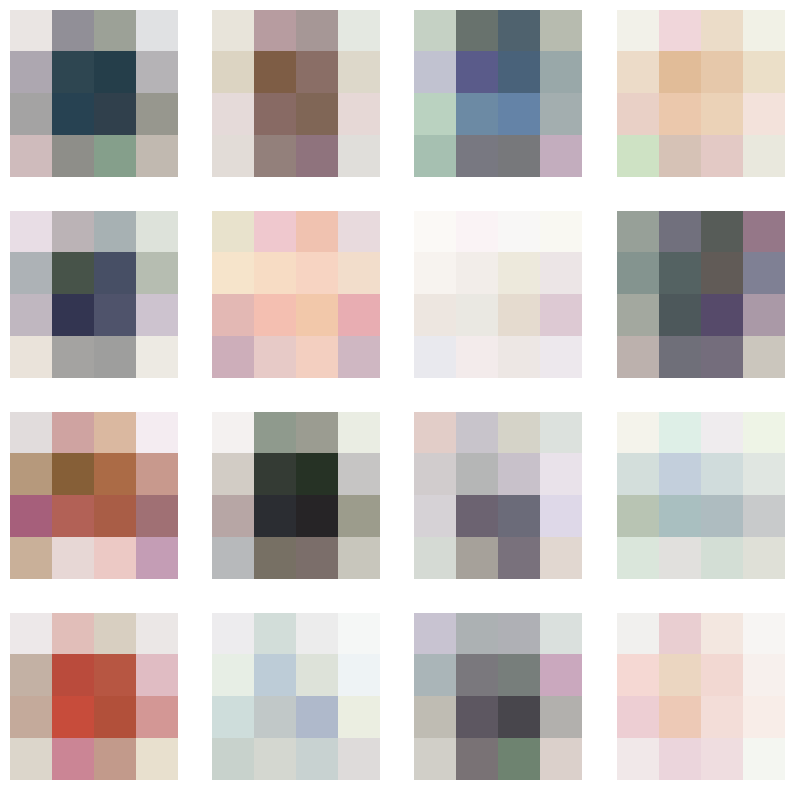

Step: 667
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5750895738601685
Generator loss: 1.2434853315353394


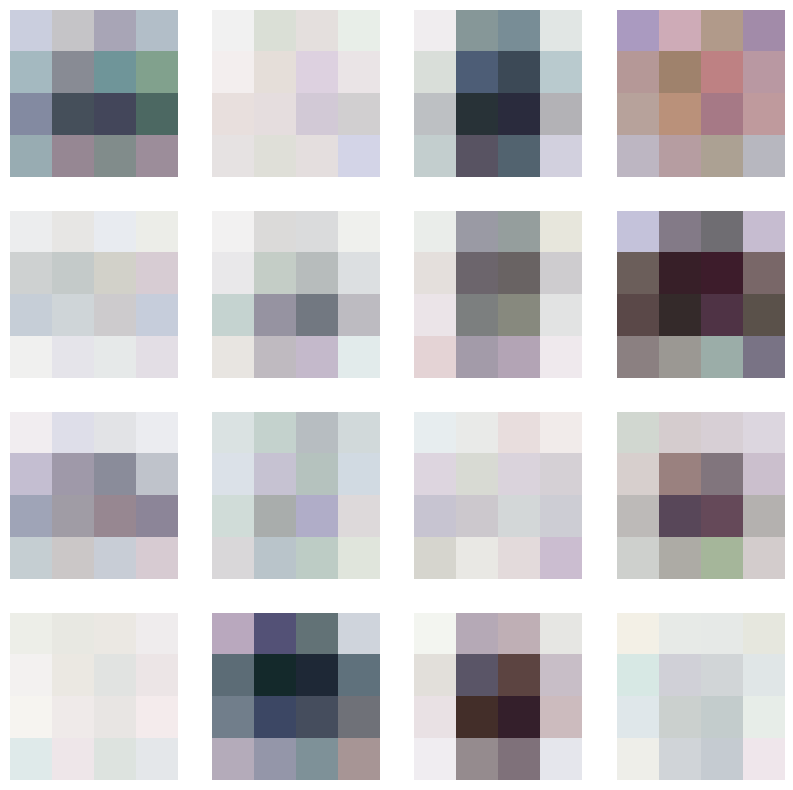

Step: 668
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5744090676307678
Generator loss: 1.241378903388977


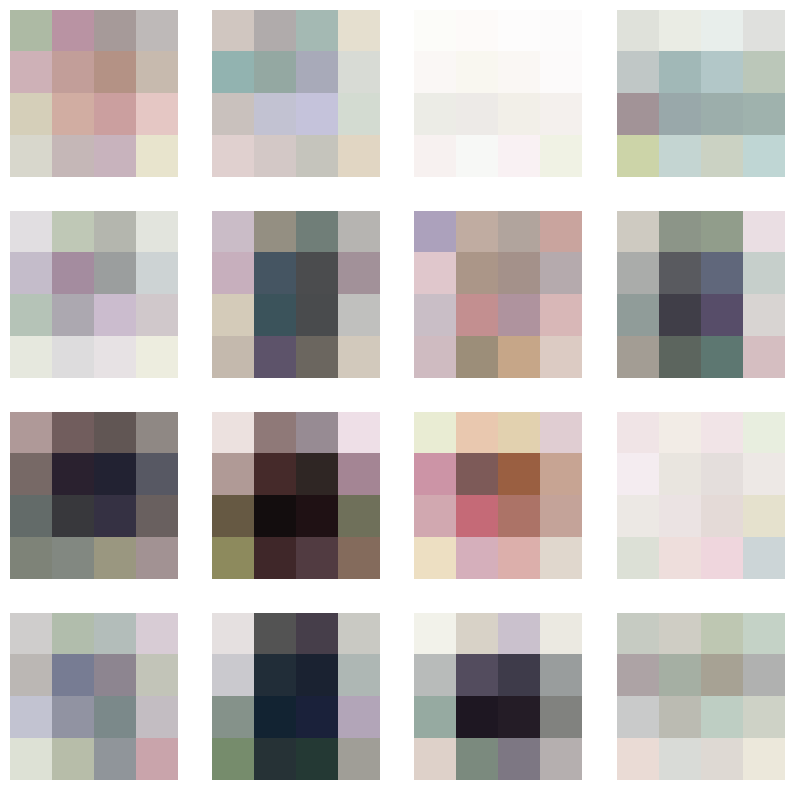

Step: 669
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5737215280532837
Generator loss: 1.2390663623809814


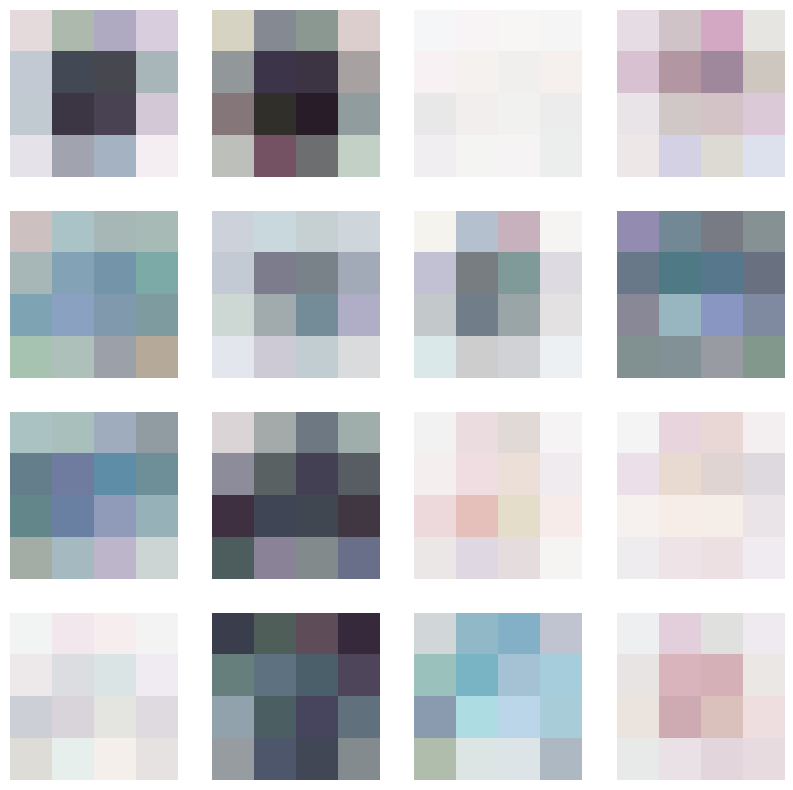

Step: 670
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5730654001235962
Generator loss: 1.236750841140747


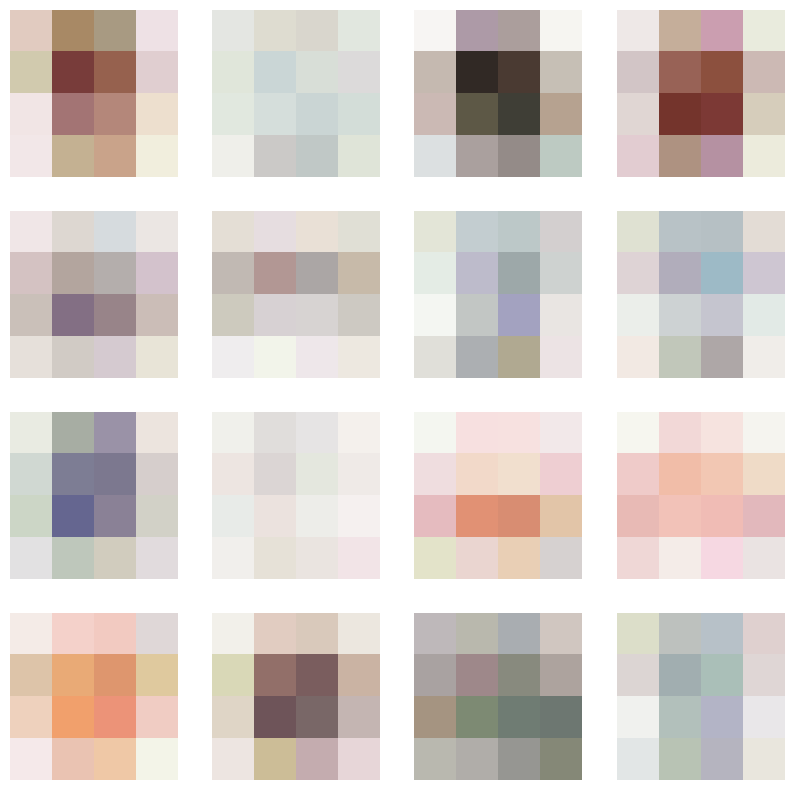

Step: 671
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5722806453704834
Generator loss: 1.2345082759857178


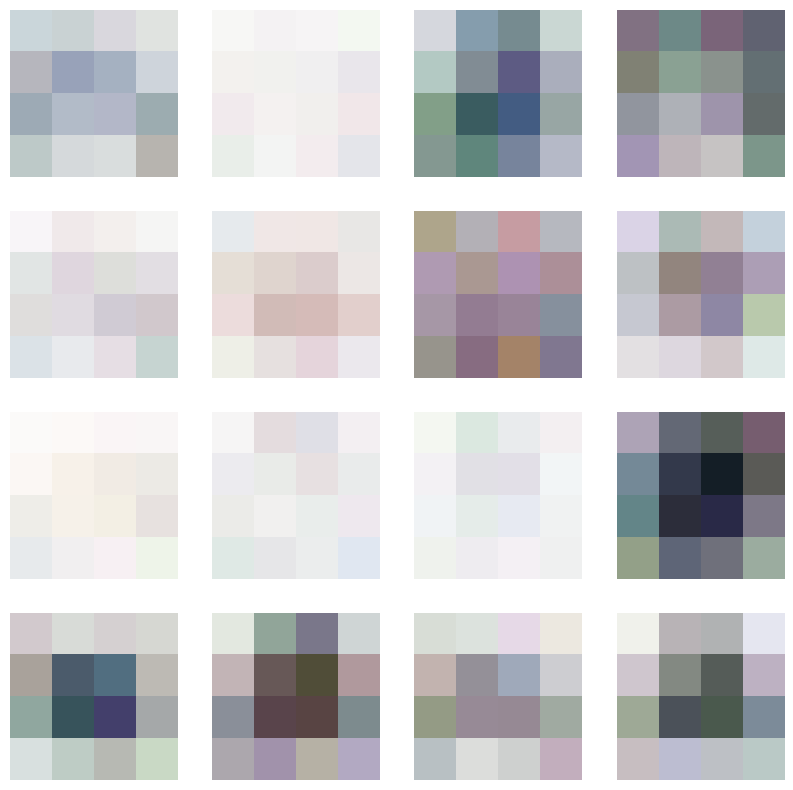

Step: 672
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5716657042503357
Generator loss: 1.2323154211044312


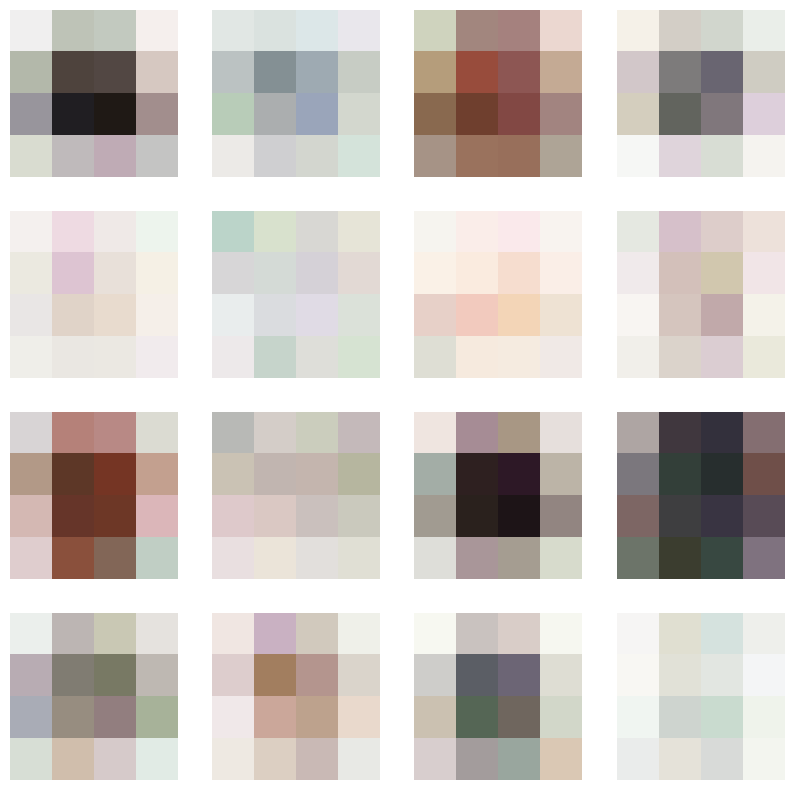

Step: 673
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5710353851318359
Generator loss: 1.2310470342636108


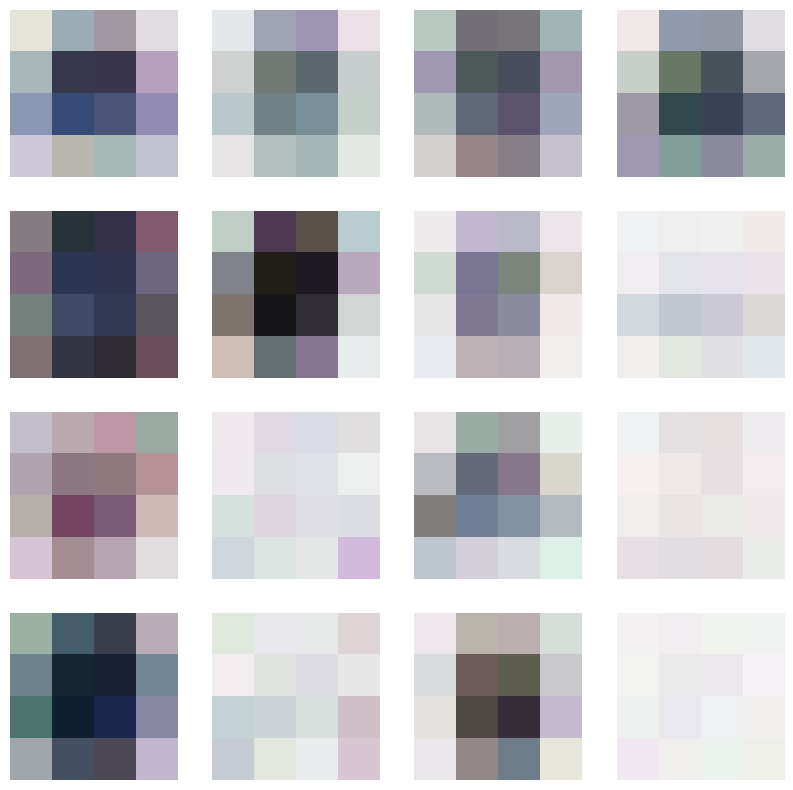

Step: 674
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.57024085521698
Generator loss: 1.2290748357772827


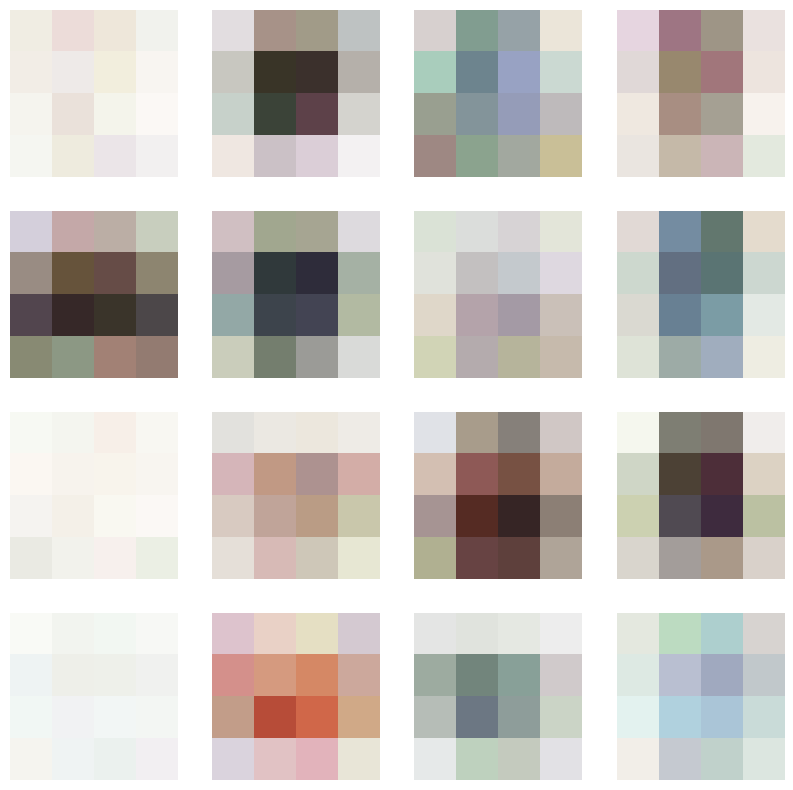

Step: 675
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5695375800132751
Generator loss: 1.2274765968322754


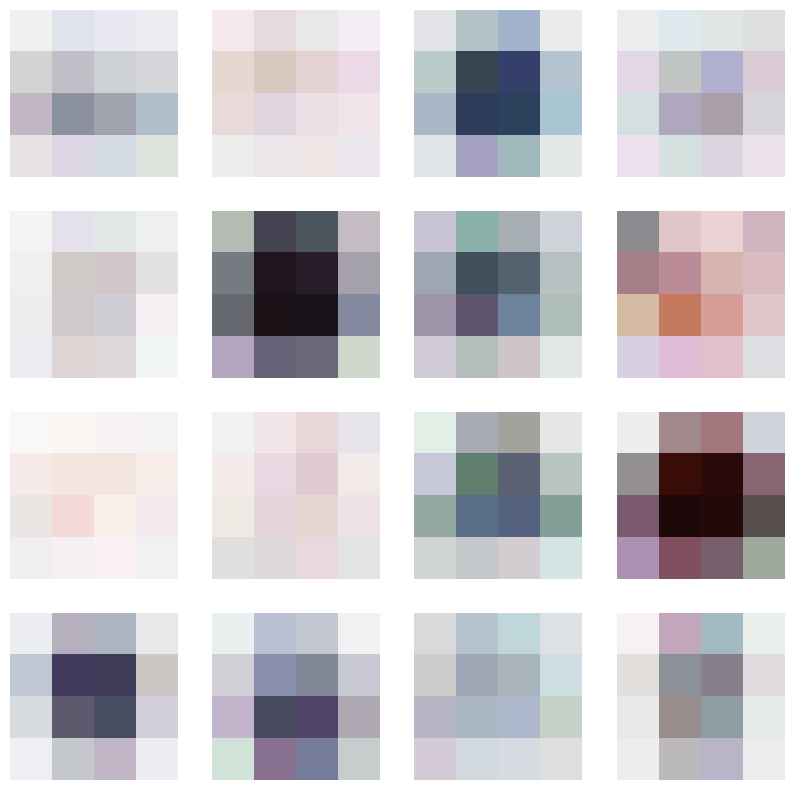

Step: 676
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5689204931259155
Generator loss: 1.2256371974945068


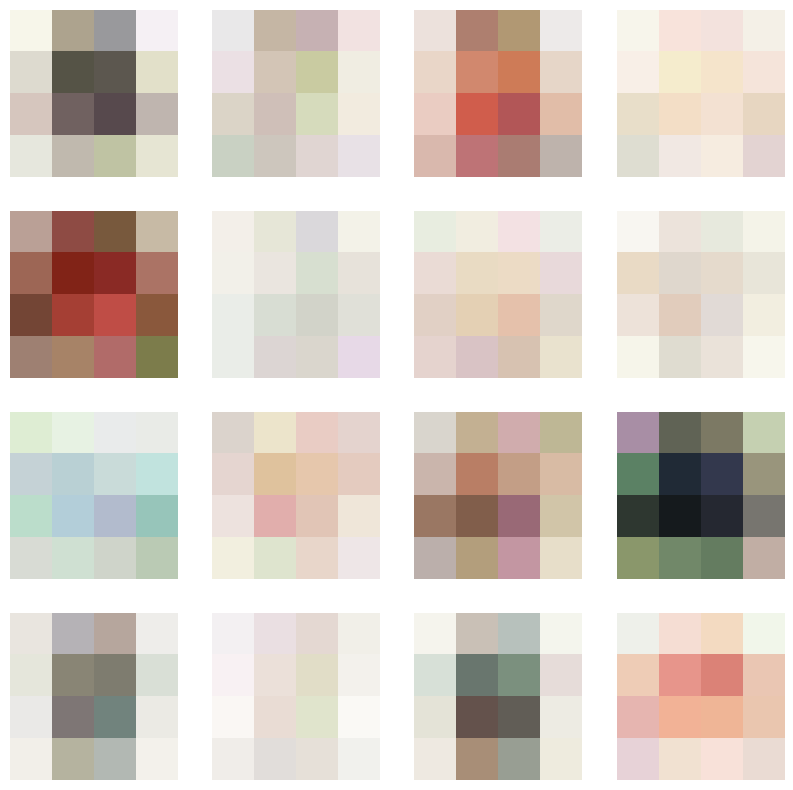

Step: 677
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5683094263076782
Generator loss: 1.22373628616333


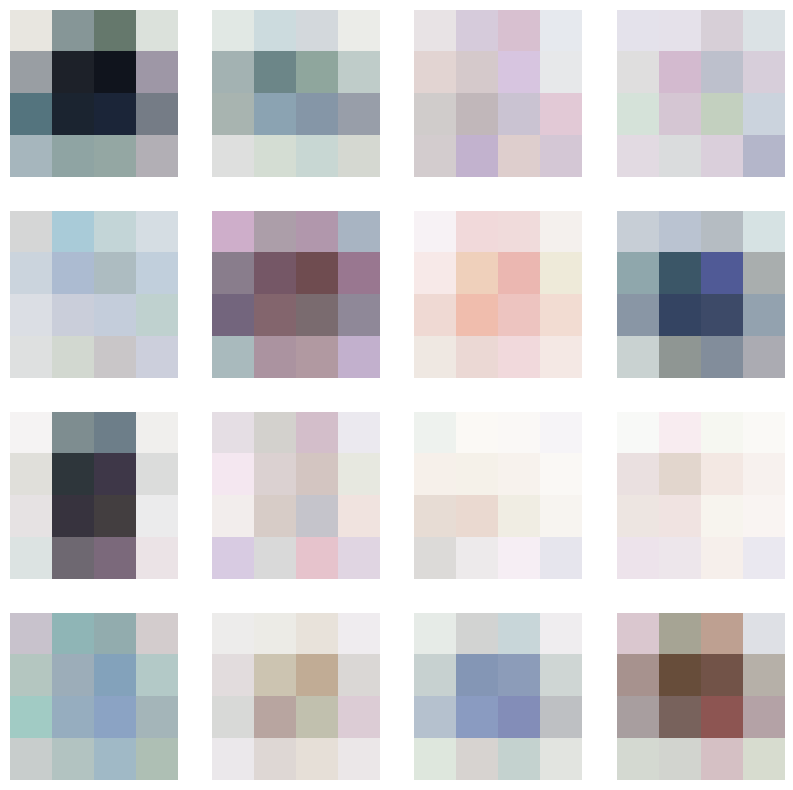

Step: 678
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5676270723342896
Generator loss: 1.2223434448242188


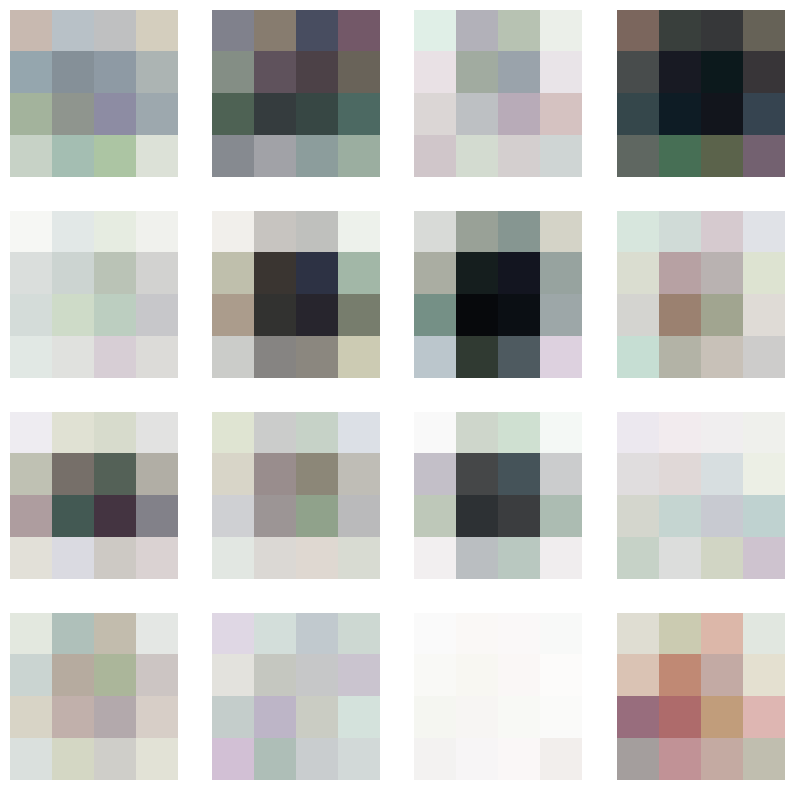

Step: 679
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5670377612113953
Generator loss: 1.2205359935760498


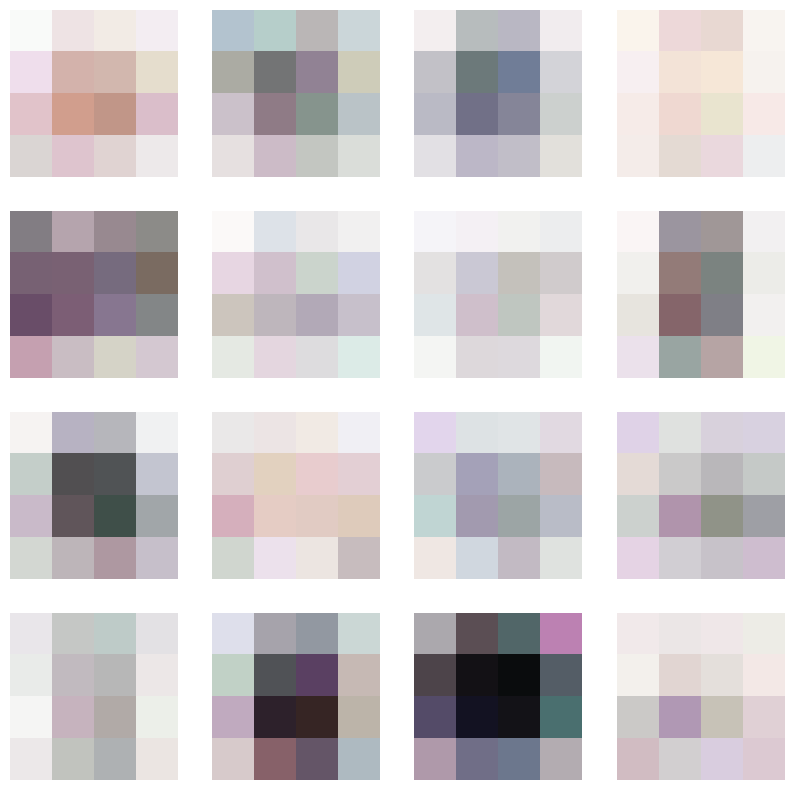

Step: 680
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5663765668869019
Generator loss: 1.219159722328186


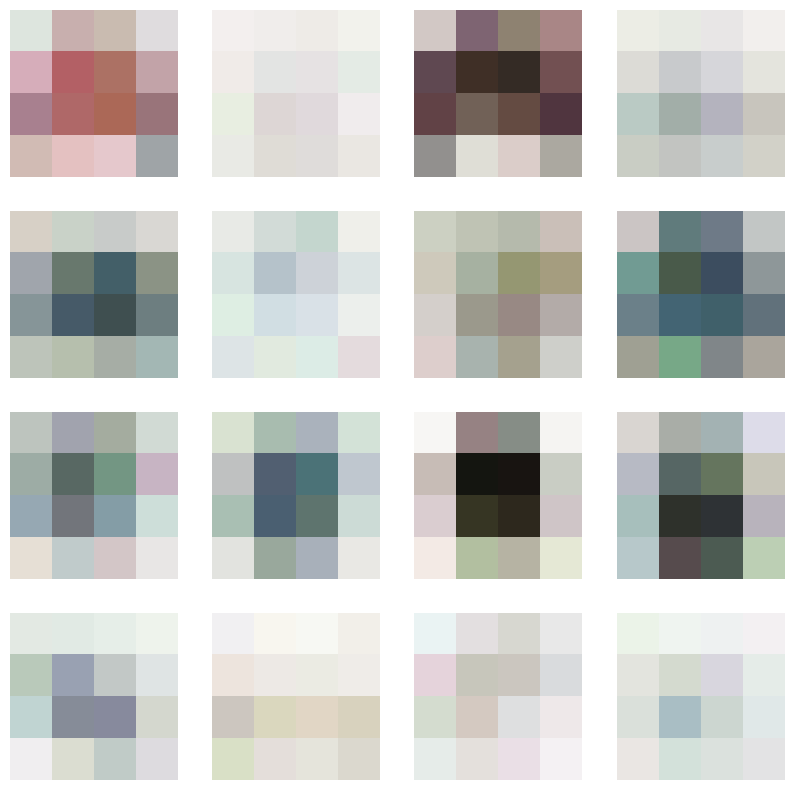

Step: 681
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5656782984733582
Generator loss: 1.2174696922302246


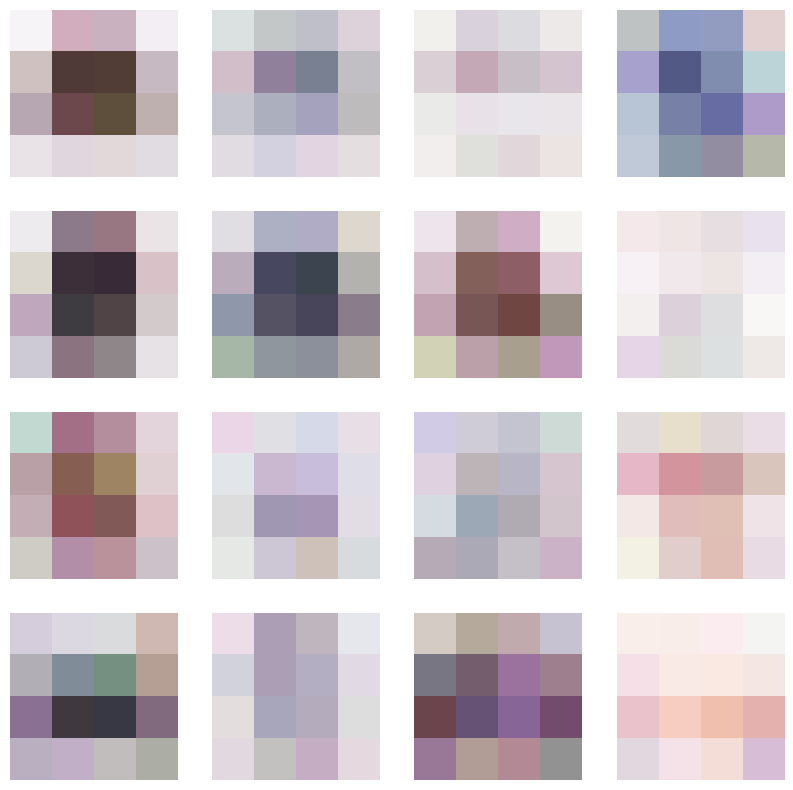

Step: 682
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5649914145469666
Generator loss: 1.2159850597381592


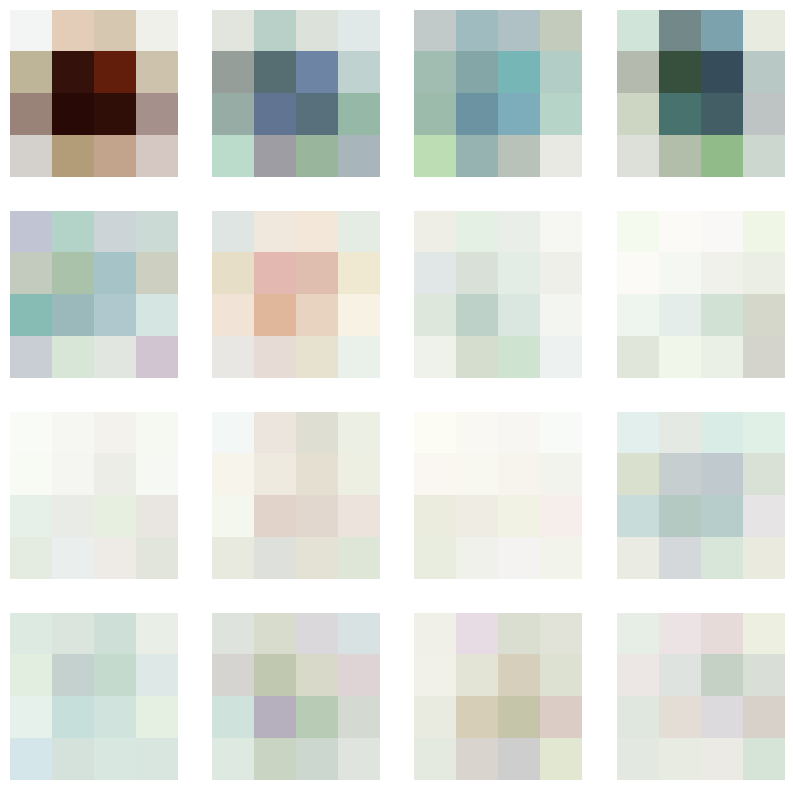

Step: 683
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.564389705657959
Generator loss: 1.214752435684204


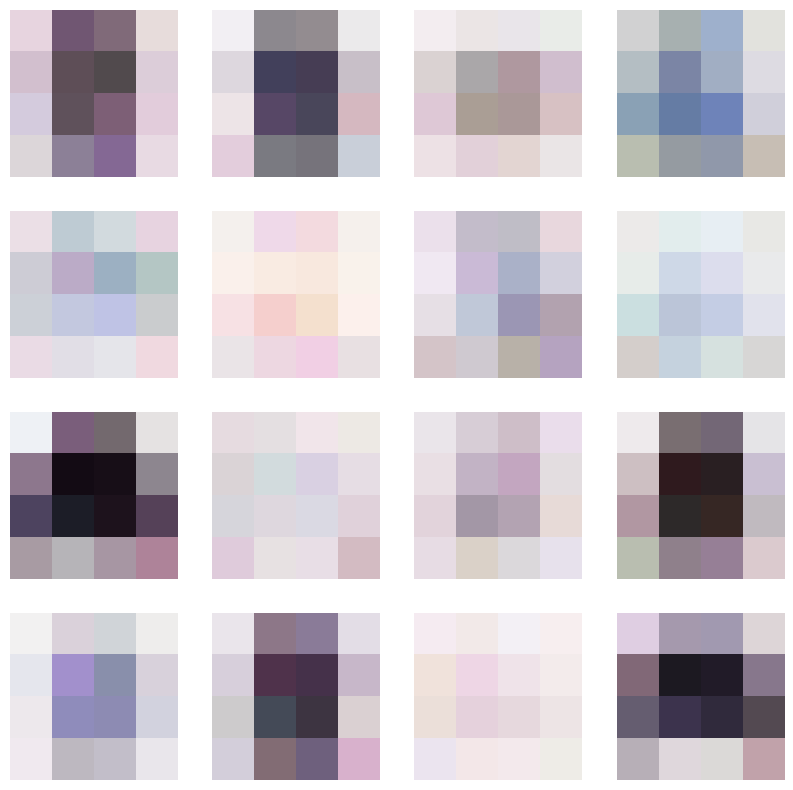

Step: 684
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5638605952262878
Generator loss: 1.2131474018096924


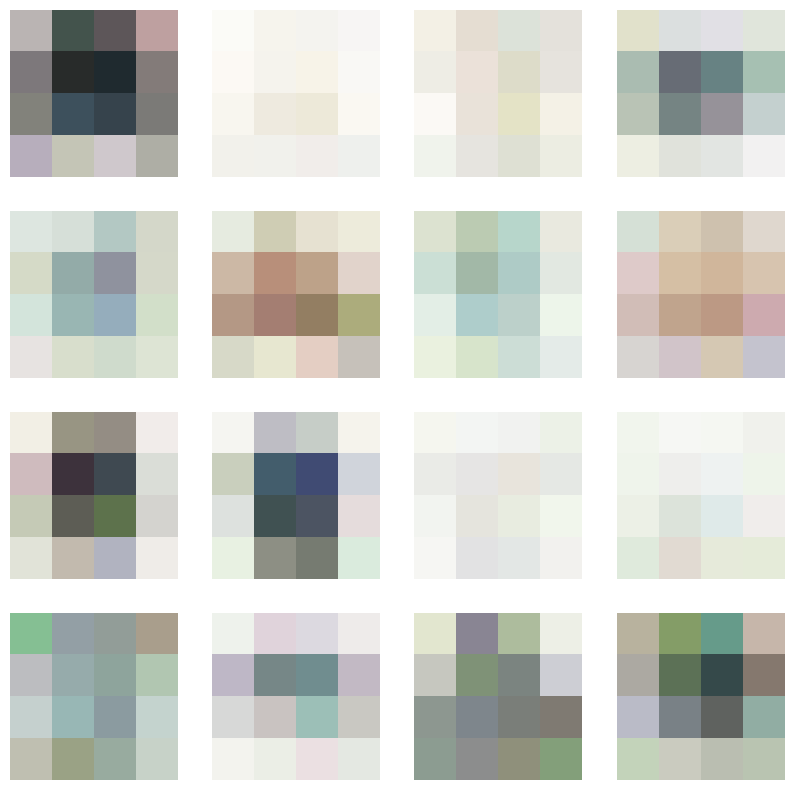

Step: 685
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5631945729255676
Generator loss: 1.211535930633545


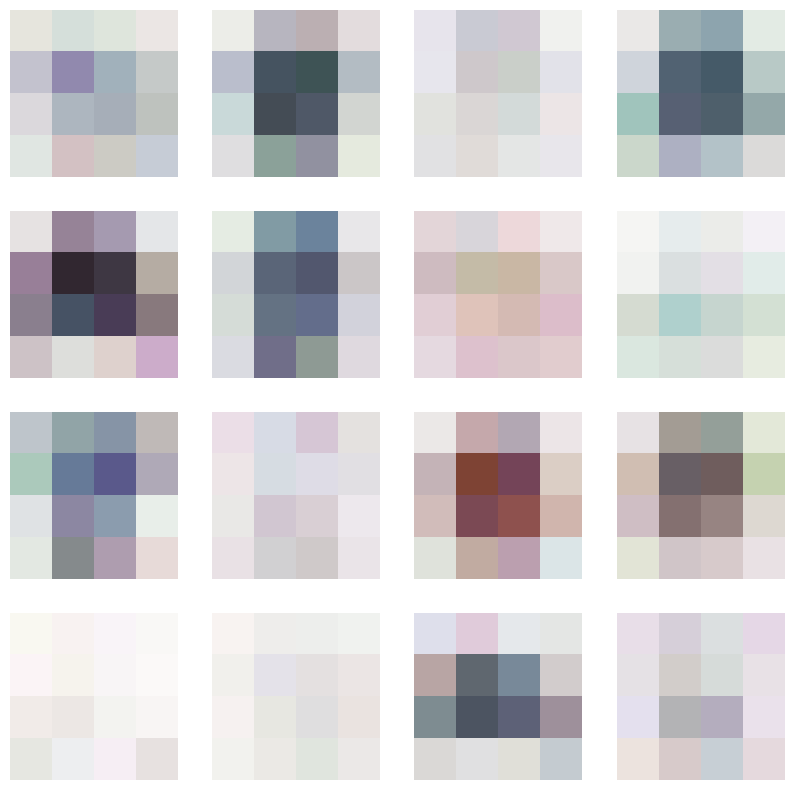

Step: 686
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5624904632568359
Generator loss: 1.210549235343933


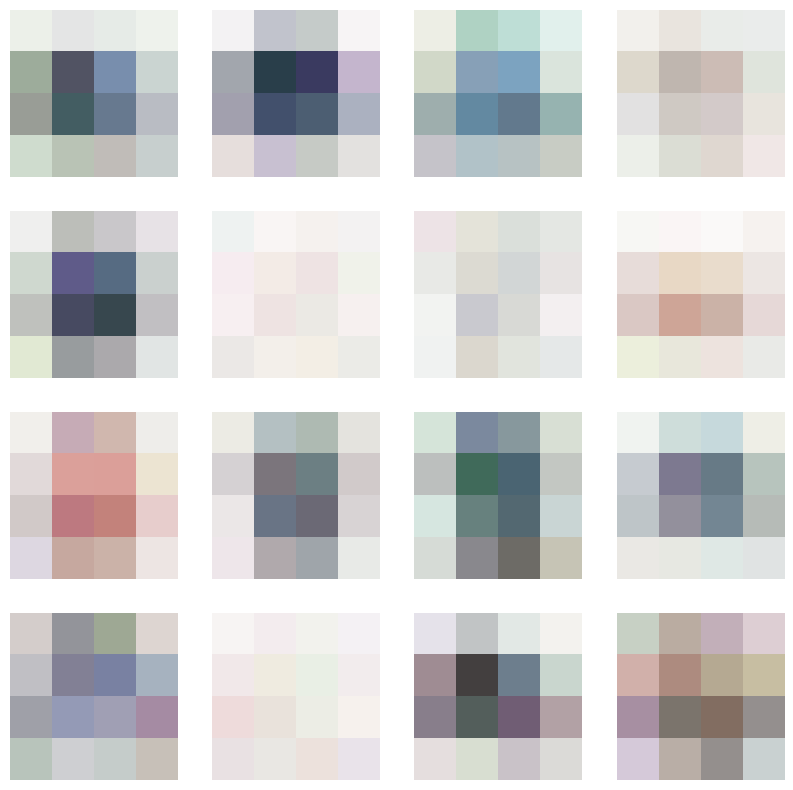

Step: 687
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.561899721622467
Generator loss: 1.2092921733856201


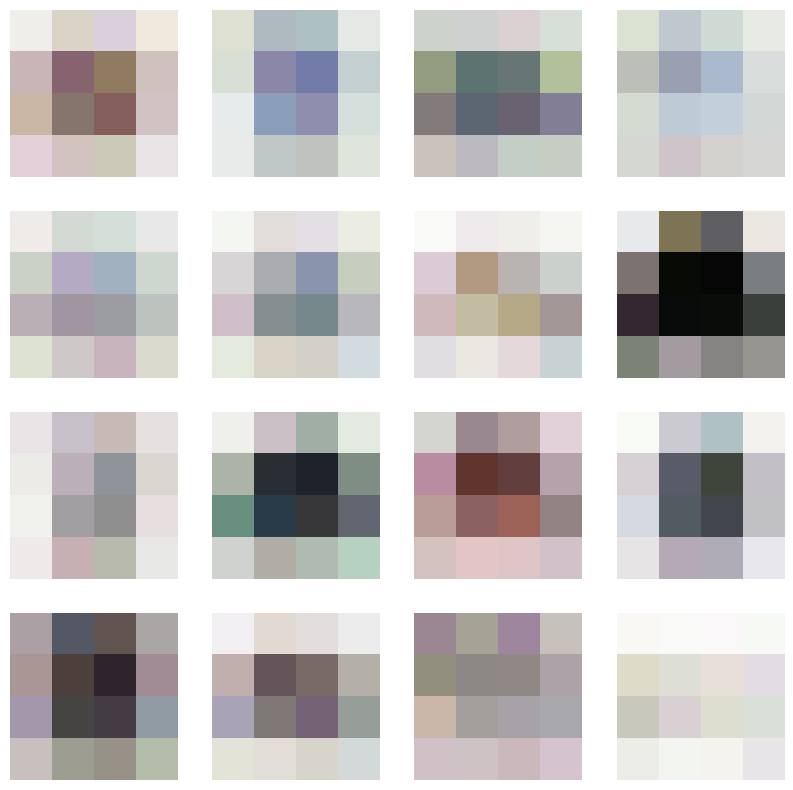

Step: 688
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5611554384231567
Generator loss: 1.208639144897461


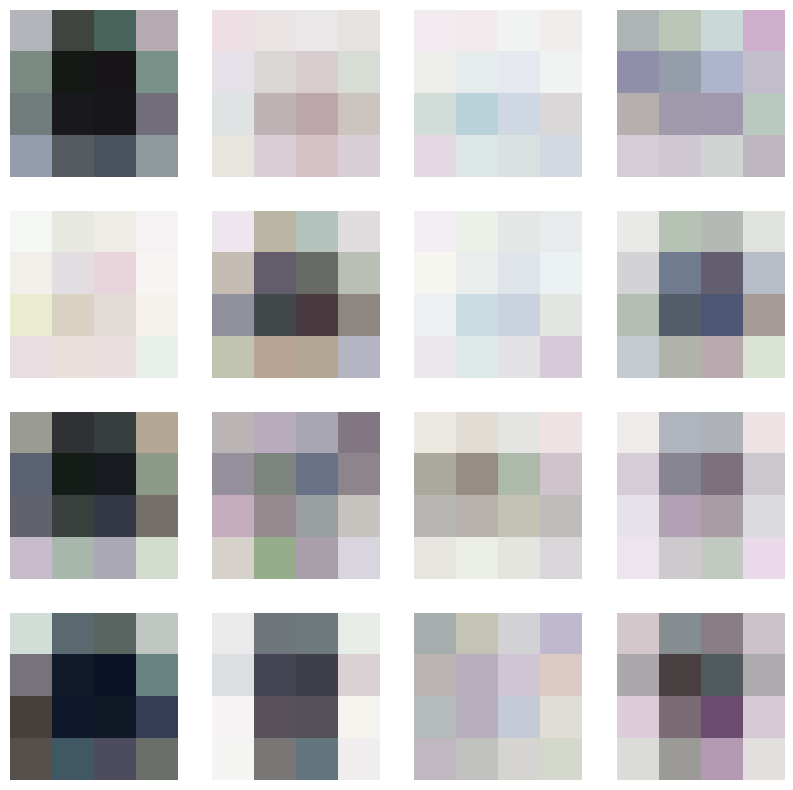

Step: 689
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5604283809661865
Generator loss: 1.2068971395492554


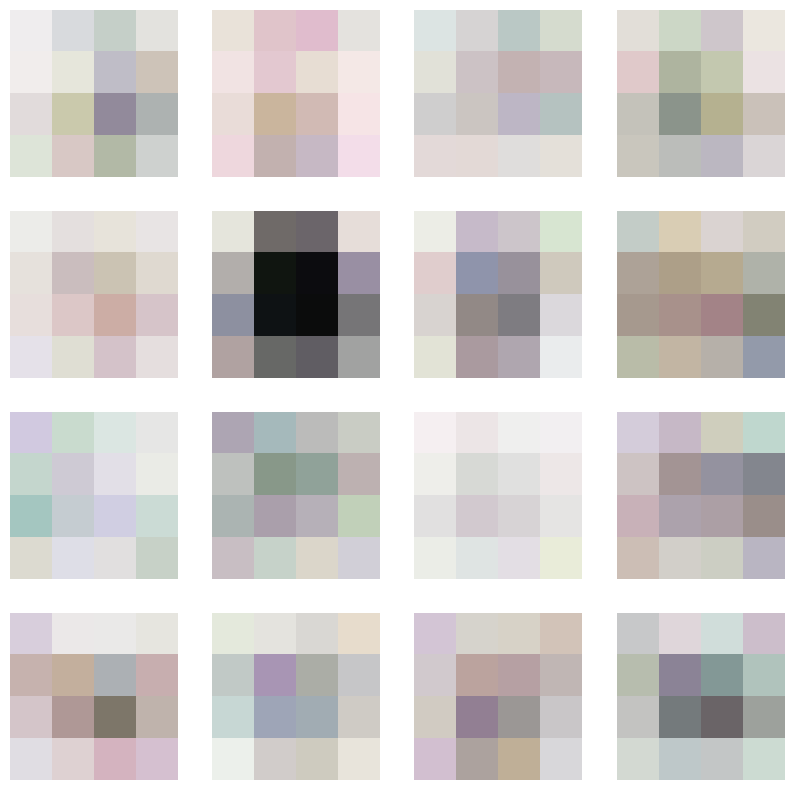

Step: 690
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.559647798538208
Generator loss: 1.2048038244247437


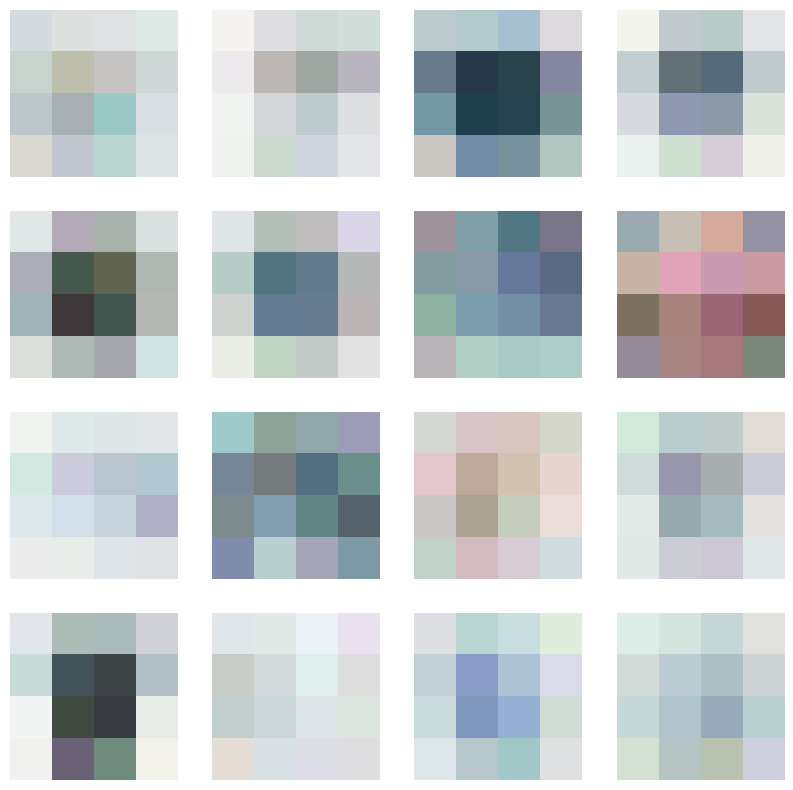

Step: 691
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5589046478271484
Generator loss: 1.2029480934143066


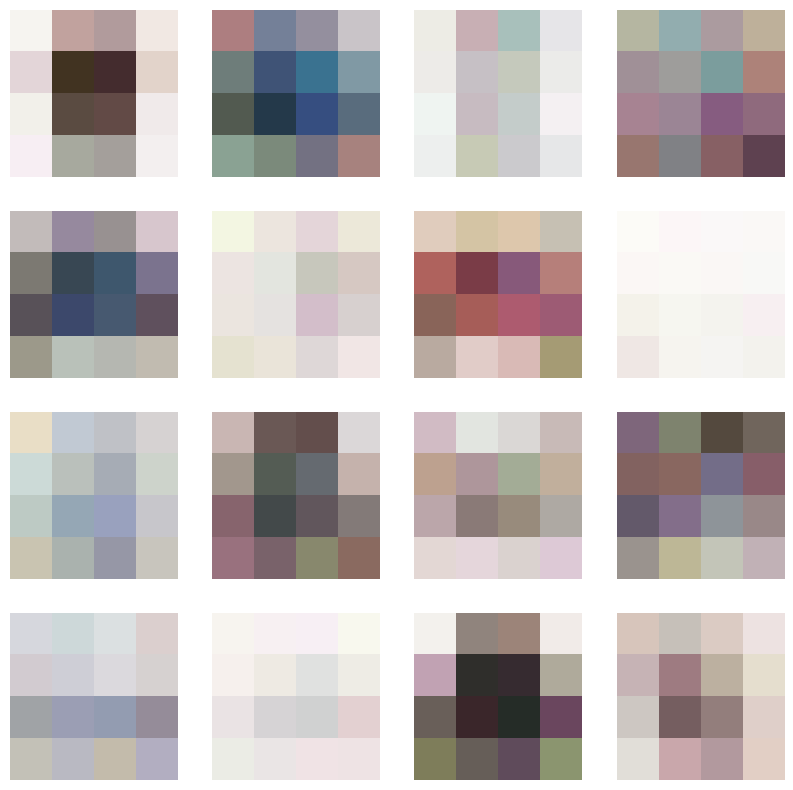

Step: 692
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.558181643486023
Generator loss: 1.20061457157135


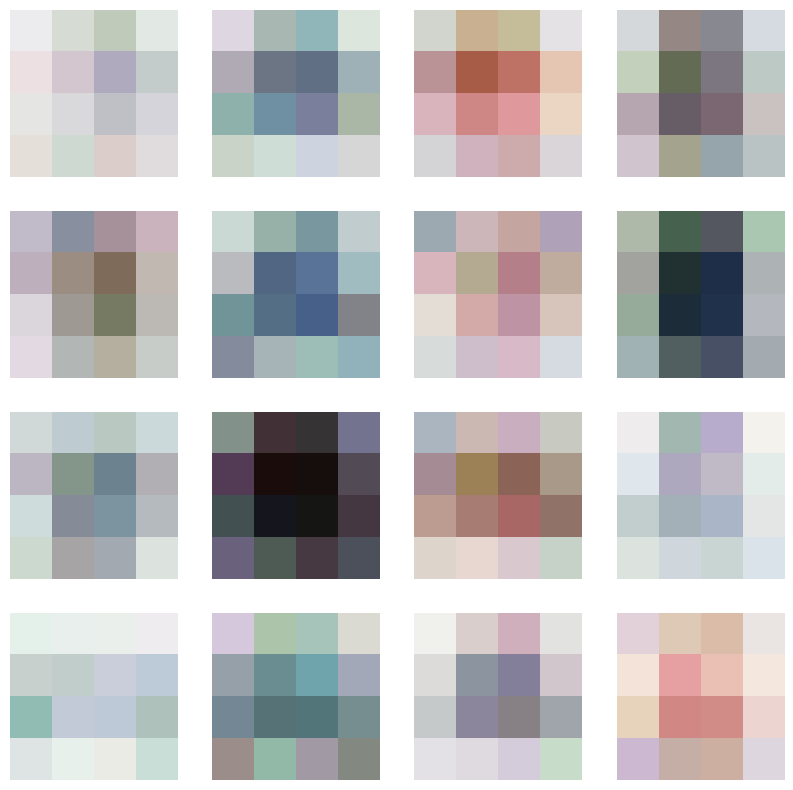

Step: 693
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5574999451637268
Generator loss: 1.1982167959213257


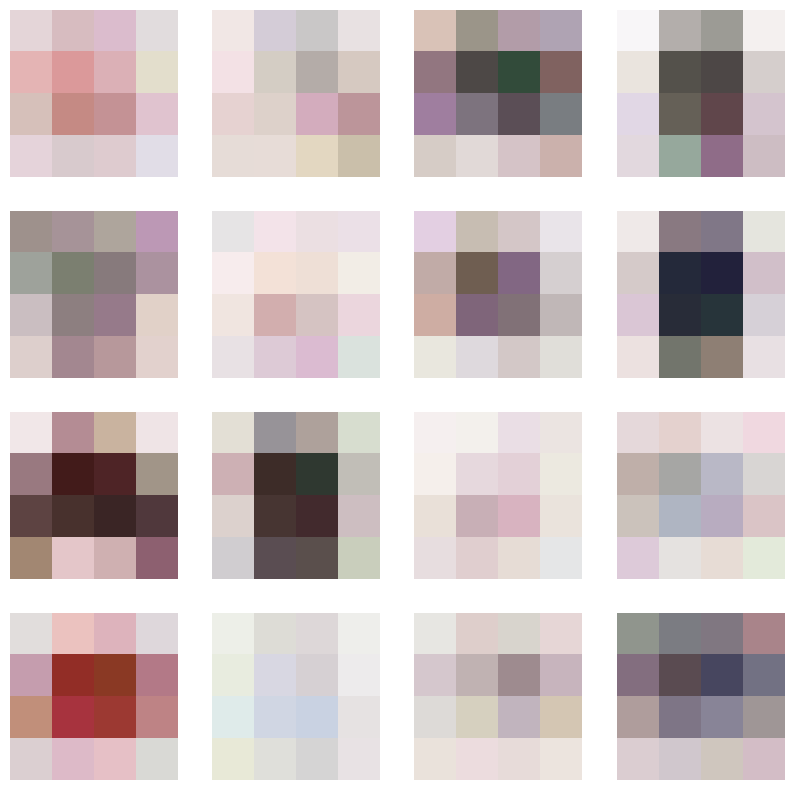

Step: 694
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5566630363464355
Generator loss: 1.1961233615875244


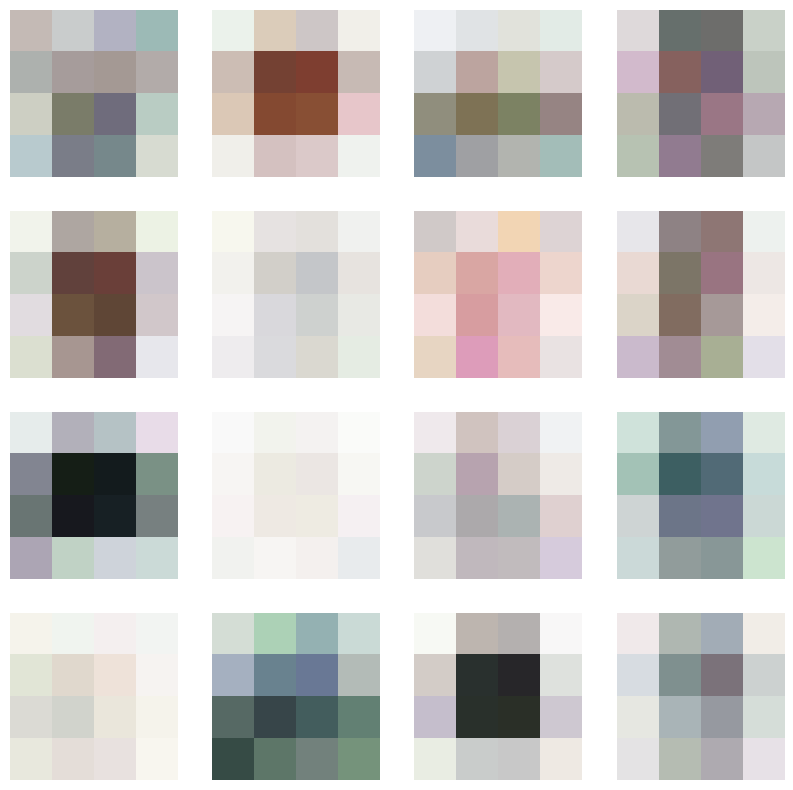

Step: 695
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5561183094978333
Generator loss: 1.1943466663360596


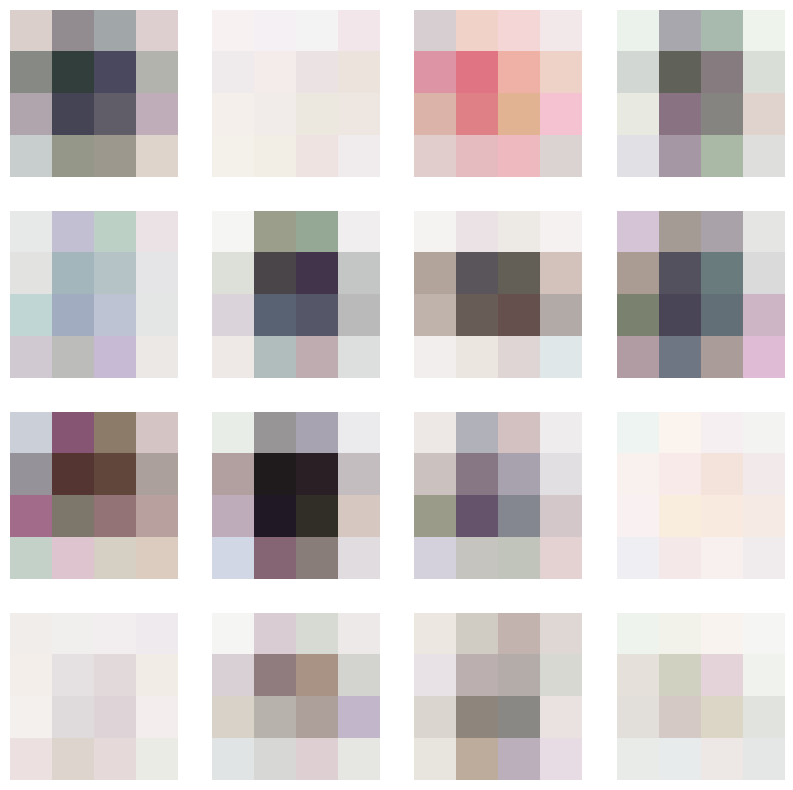

Step: 696
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5554642081260681
Generator loss: 1.1932038068771362


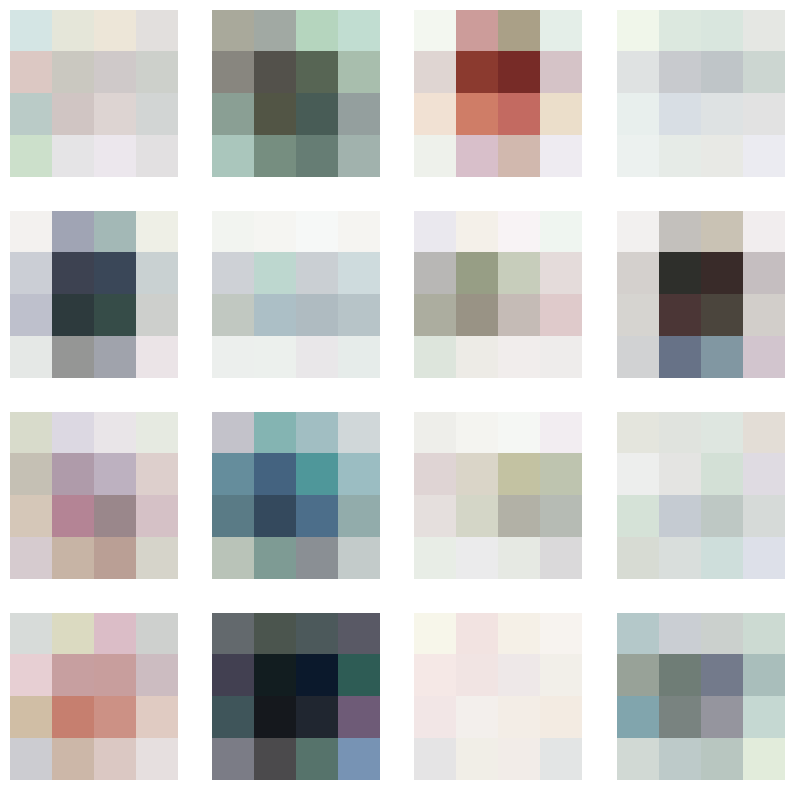

Step: 697
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5548578500747681
Generator loss: 1.191613793373108


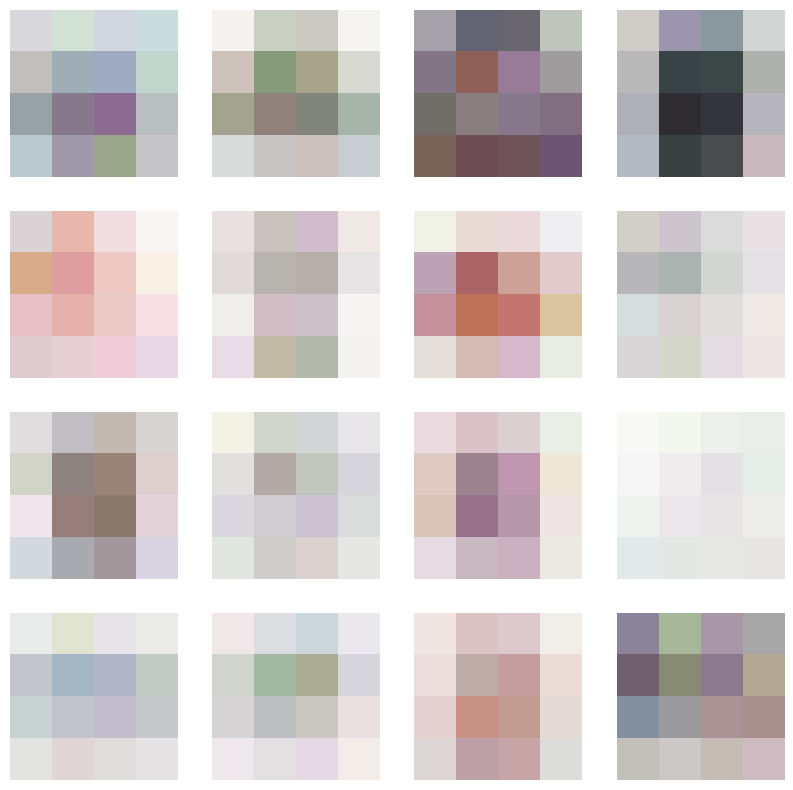

Step: 698
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5539616942405701
Generator loss: 1.189578890800476


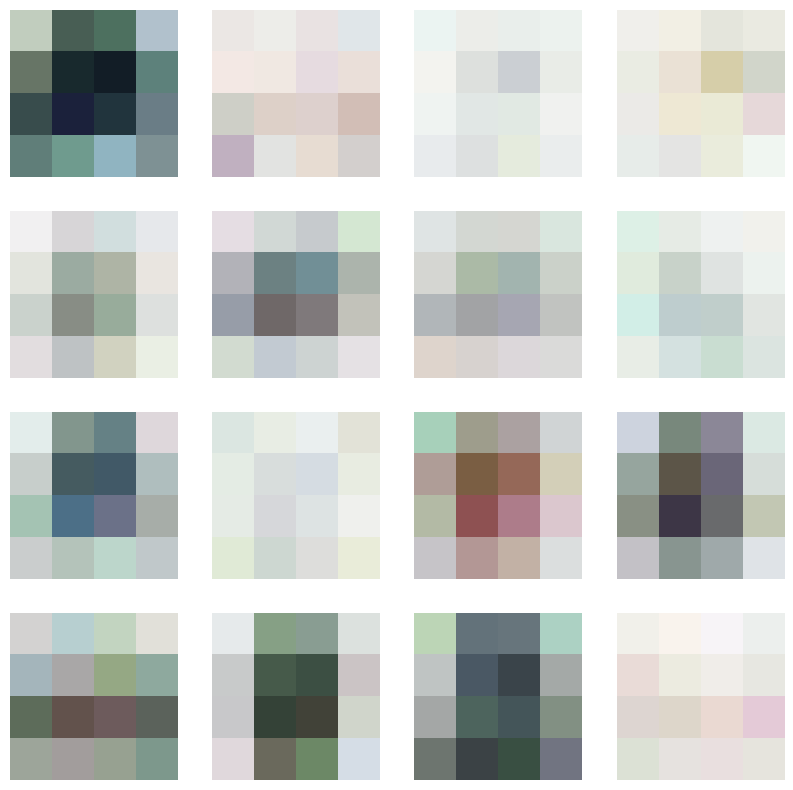

Step: 699
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5533647537231445
Generator loss: 1.1876311302185059


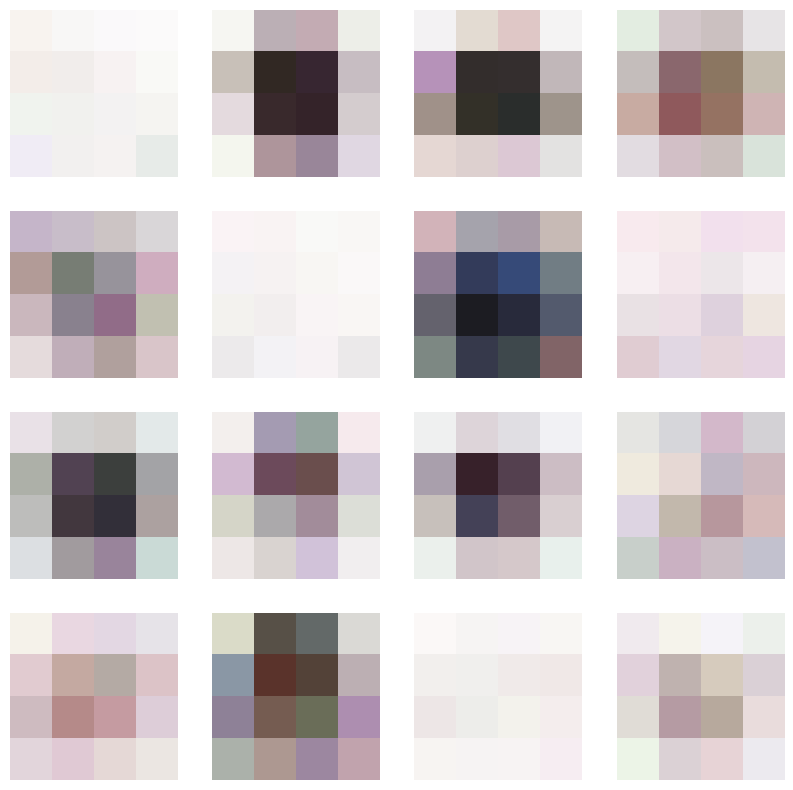

Step: 700
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5527457594871521
Generator loss: 1.1859016418457031


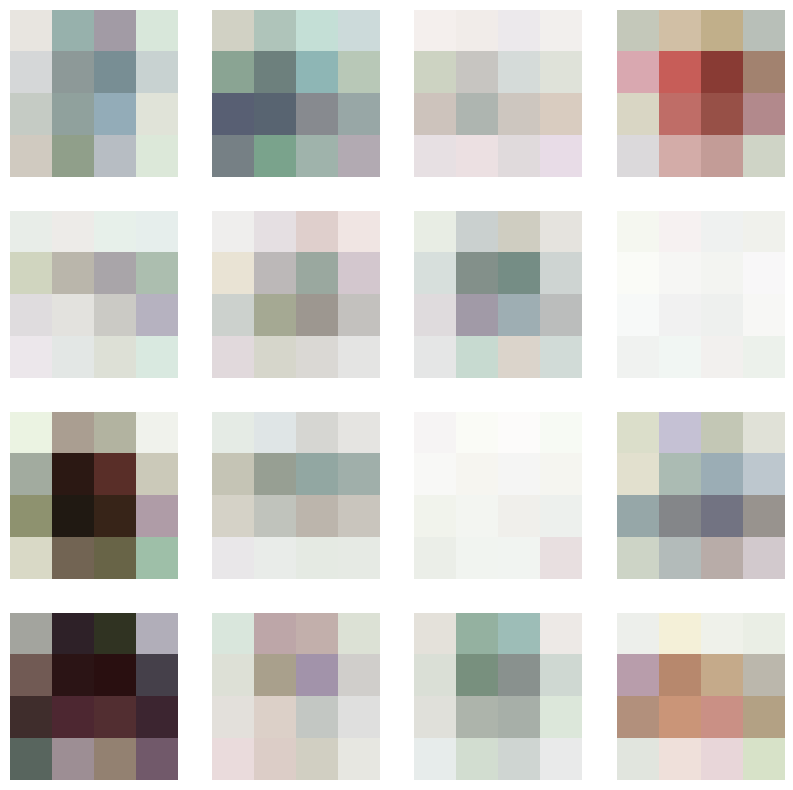

Step: 701
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5521514415740967
Generator loss: 1.184372901916504


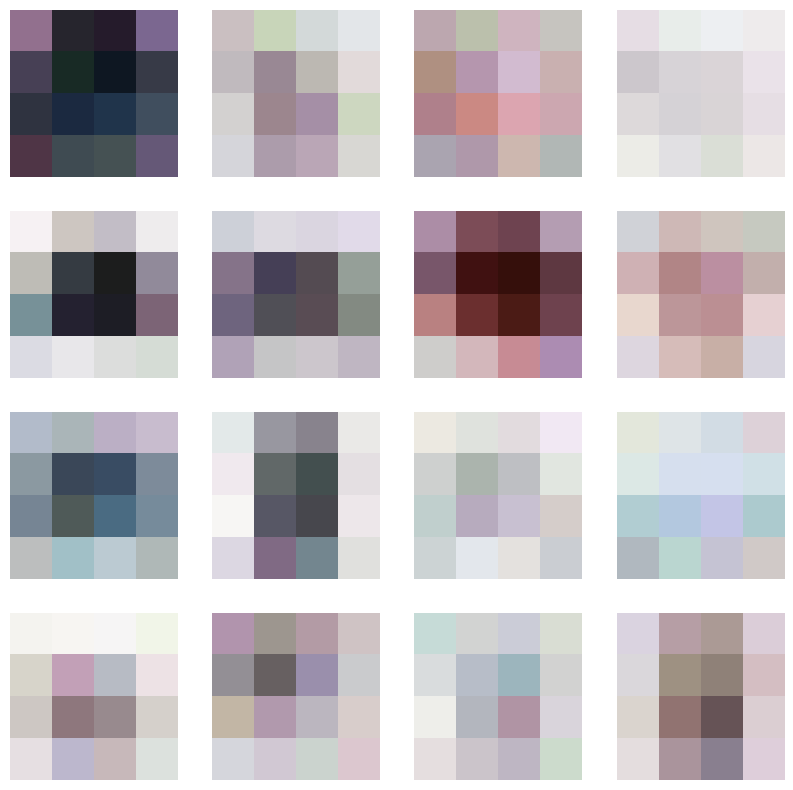

Step: 702
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5516442656517029
Generator loss: 1.1828899383544922


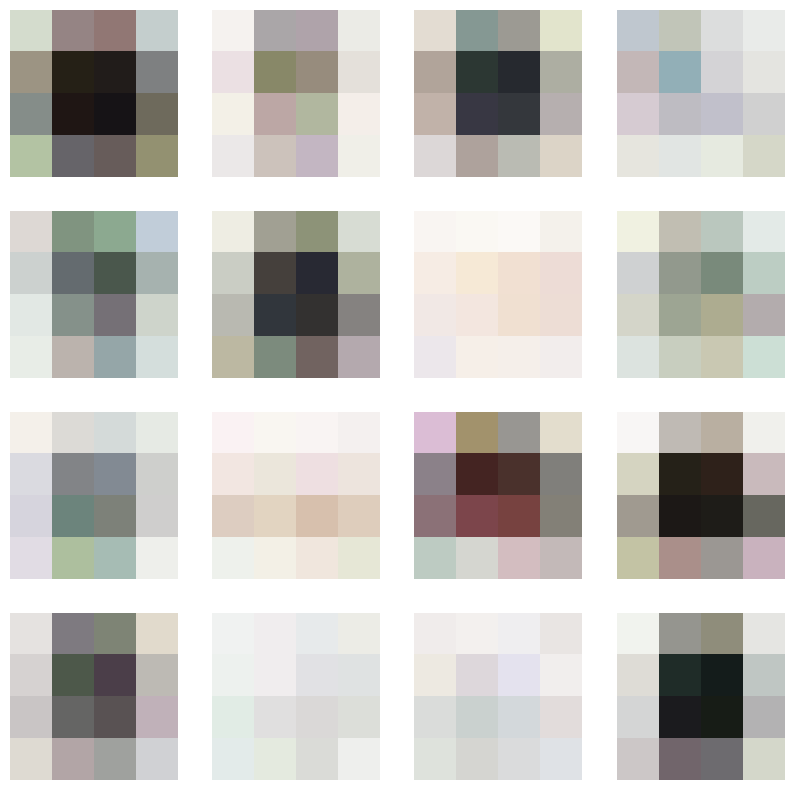

Step: 703
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5509992837905884
Generator loss: 1.1811178922653198


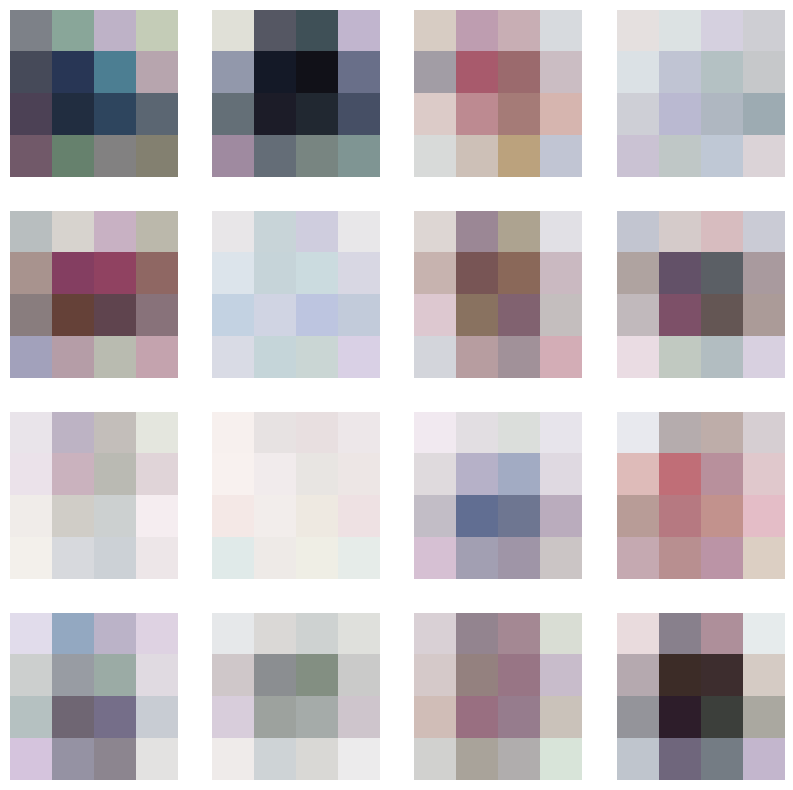

Step: 704
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5504258871078491
Generator loss: 1.1791698932647705


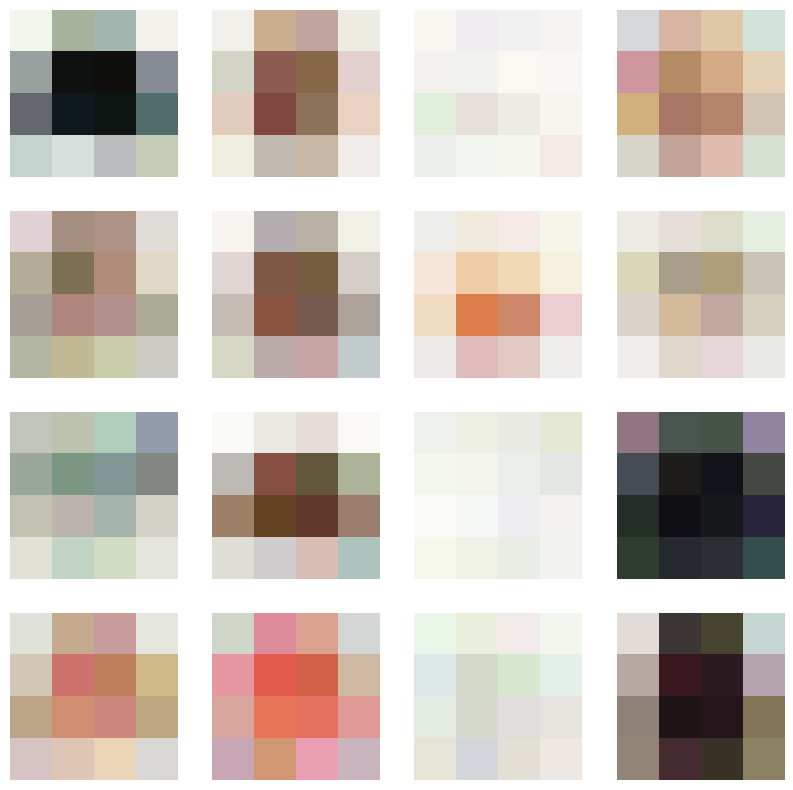

Step: 705
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5498558282852173
Generator loss: 1.1775530576705933


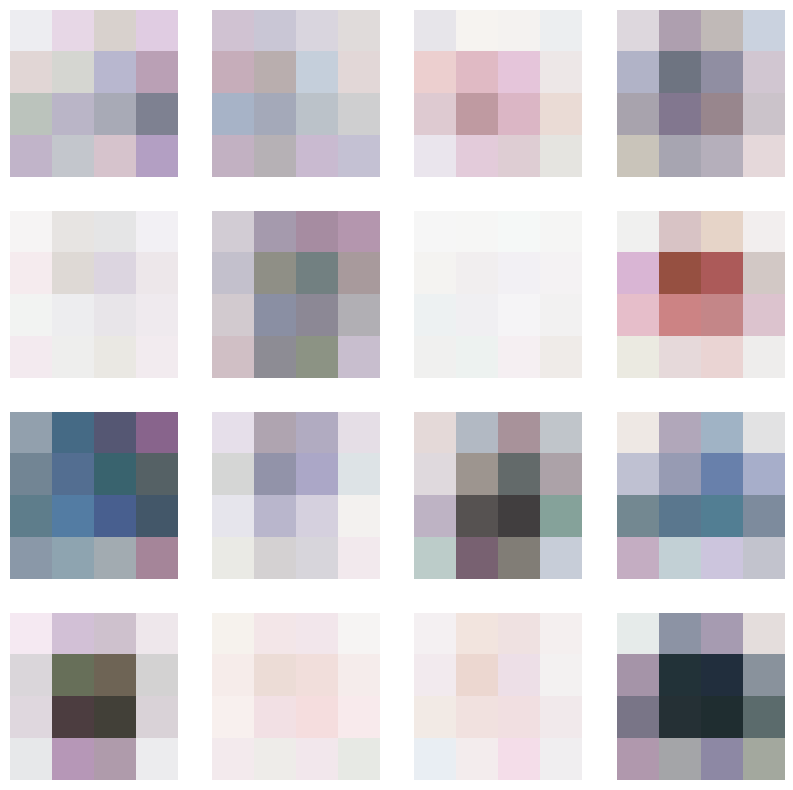

Step: 706
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5493335723876953
Generator loss: 1.1755506992340088


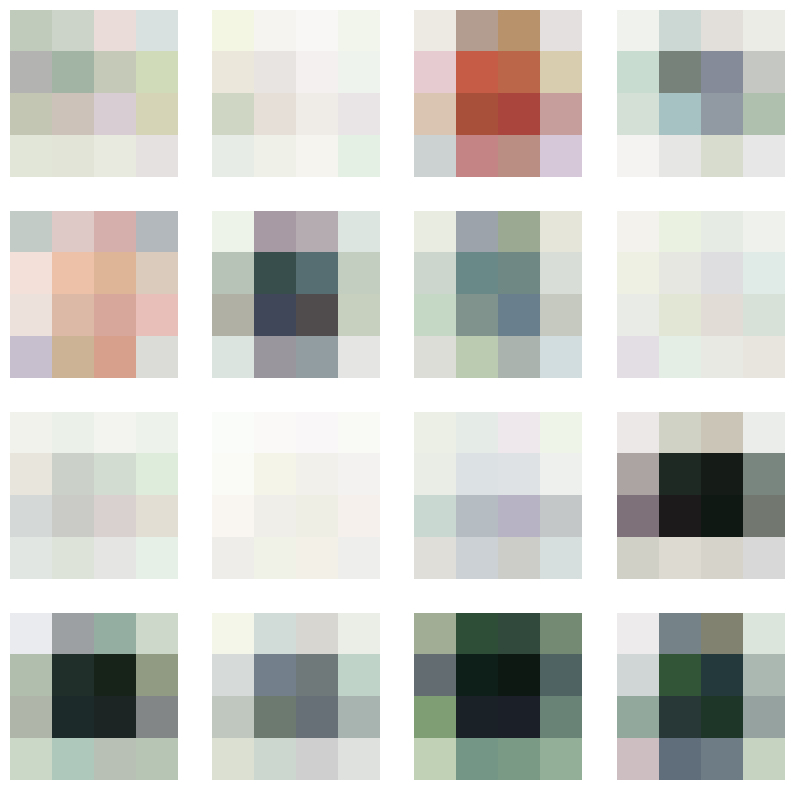

Step: 707
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5488325357437134
Generator loss: 1.1735283136367798


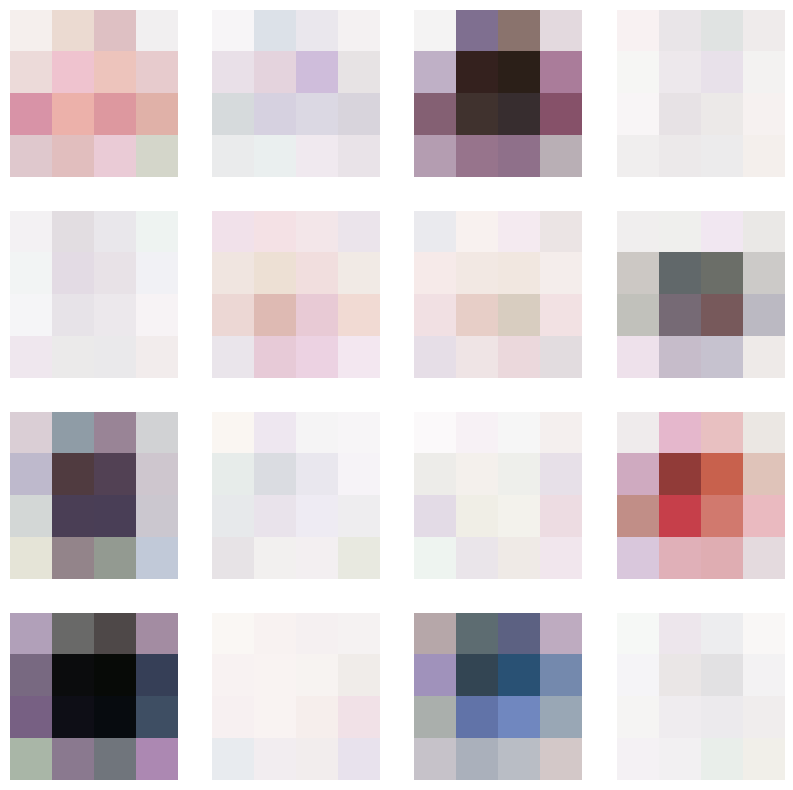

Step: 708
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5482911467552185
Generator loss: 1.1718071699142456


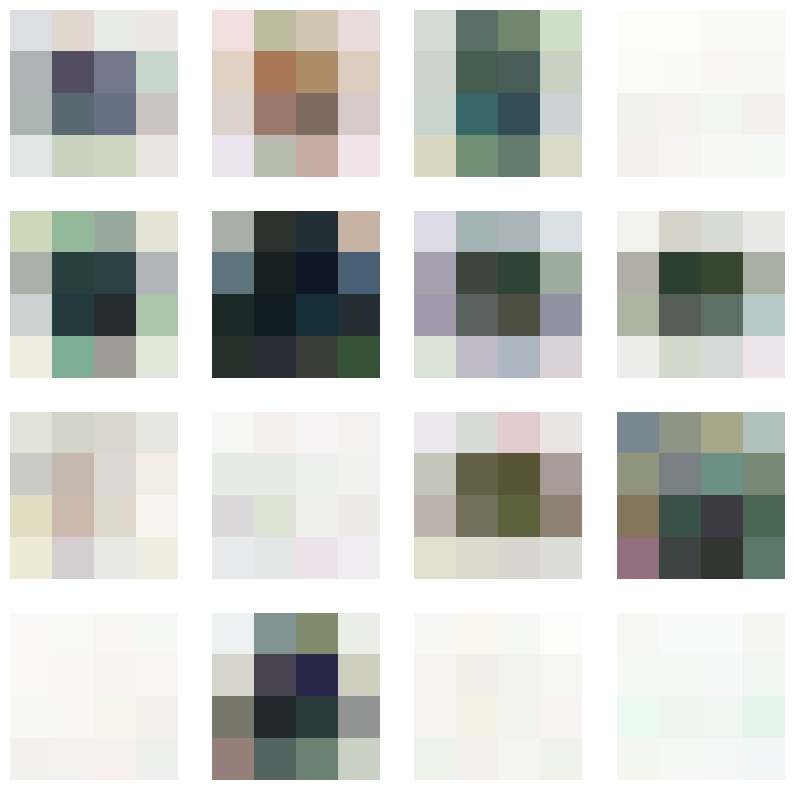

Step: 709
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5476934313774109
Generator loss: 1.170719861984253


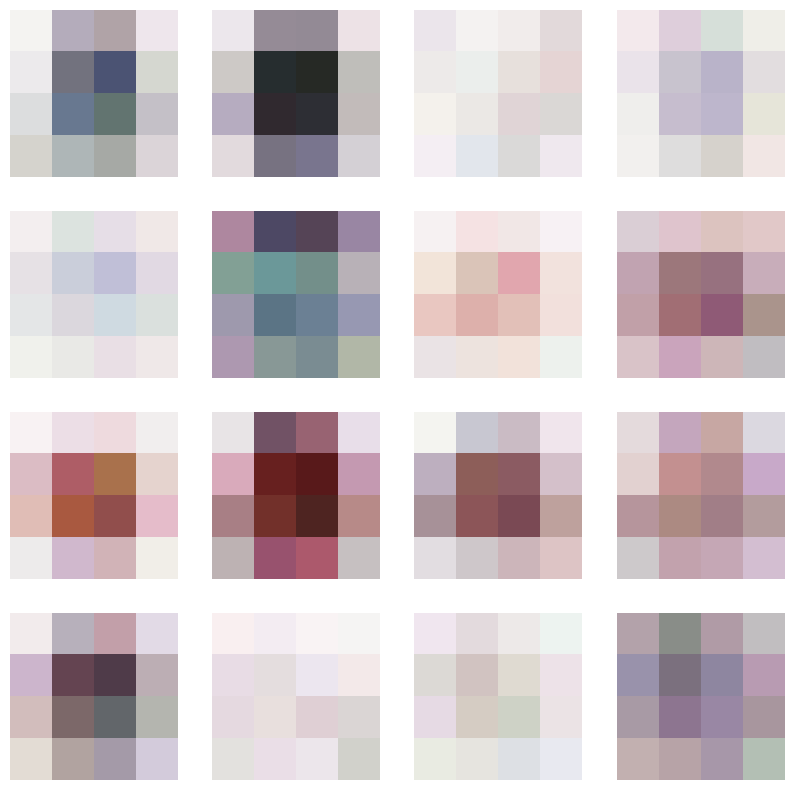

Step: 710
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5471158623695374
Generator loss: 1.1697537899017334


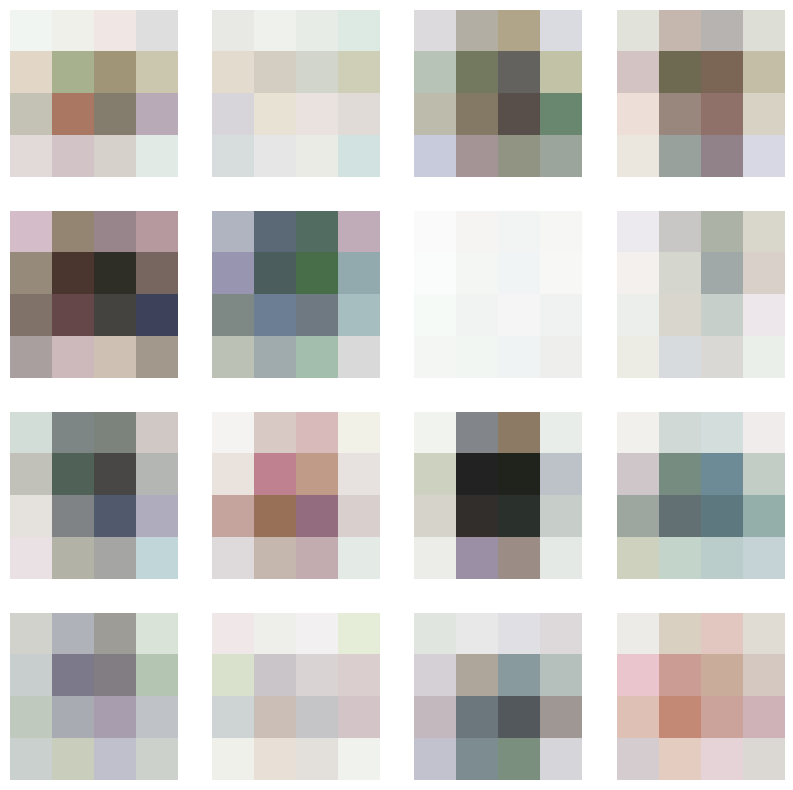

Step: 711
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5463932752609253
Generator loss: 1.168372392654419


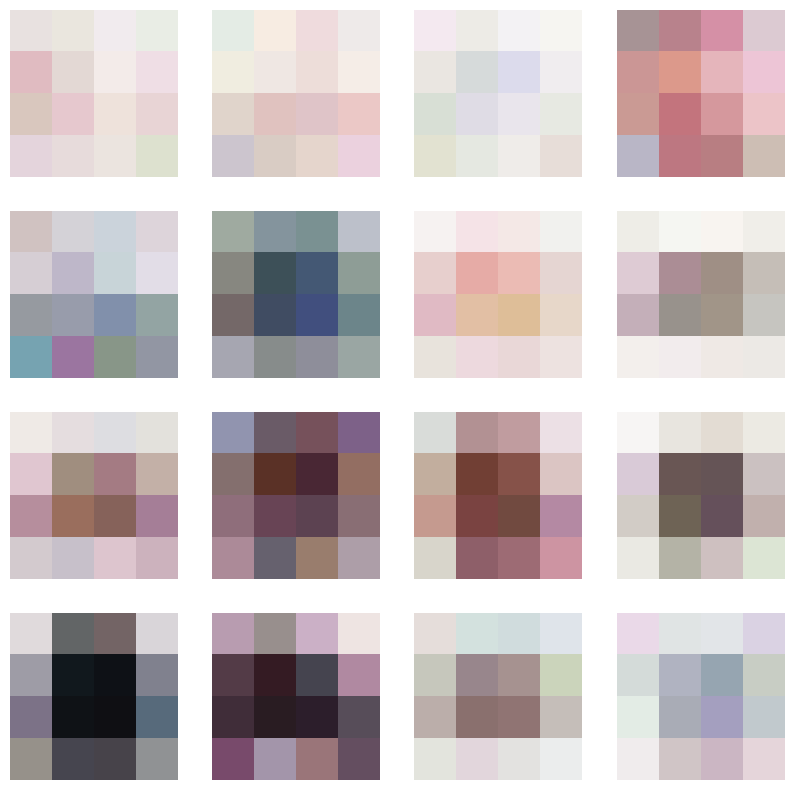

Step: 712
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.54587721824646
Generator loss: 1.1666243076324463


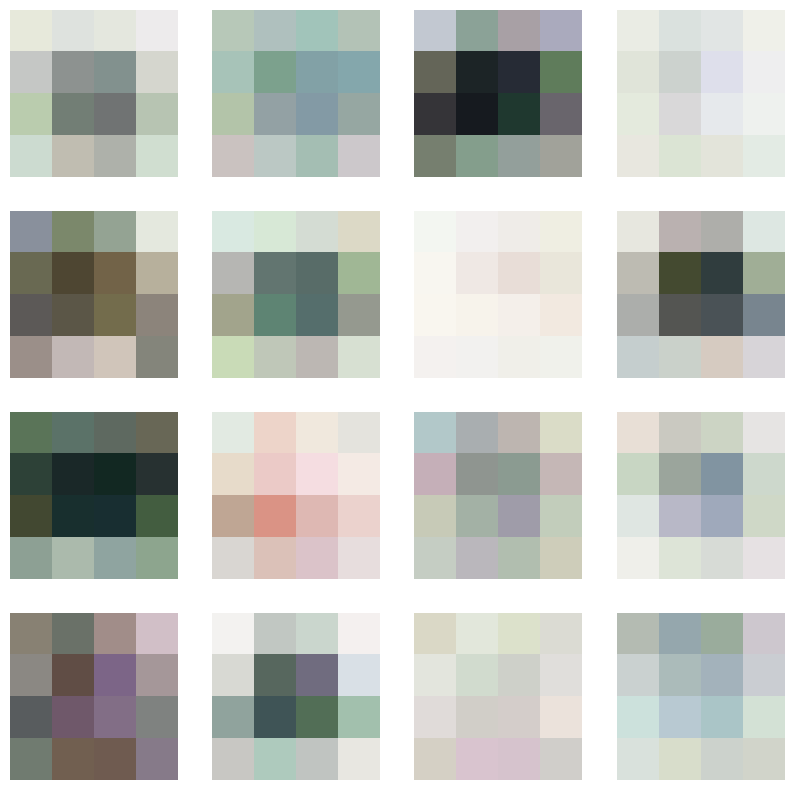

Step: 713
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5453360080718994
Generator loss: 1.1646956205368042


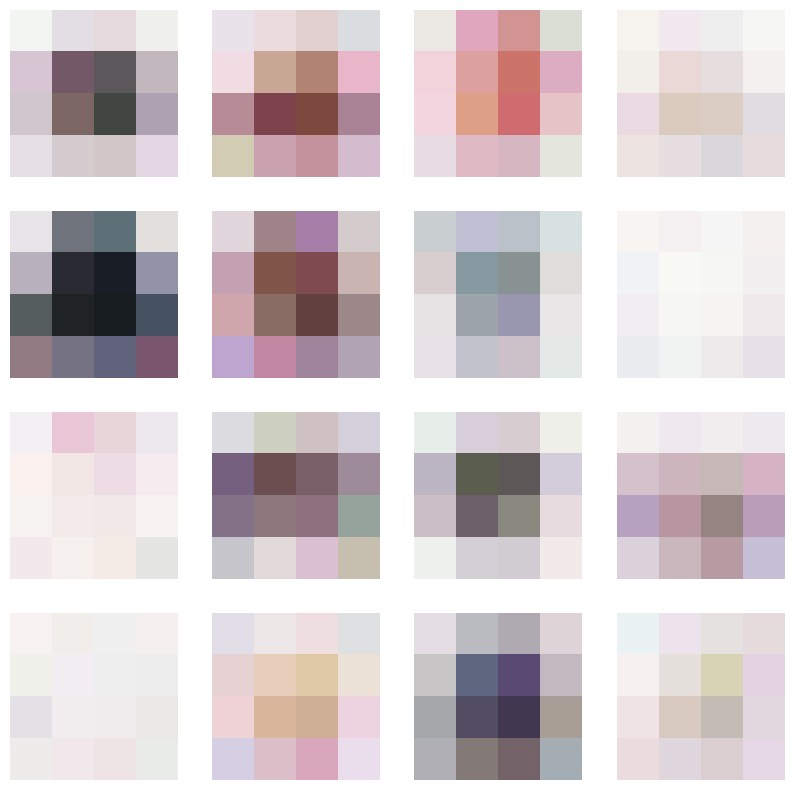

Step: 714
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5448240637779236
Generator loss: 1.1629838943481445


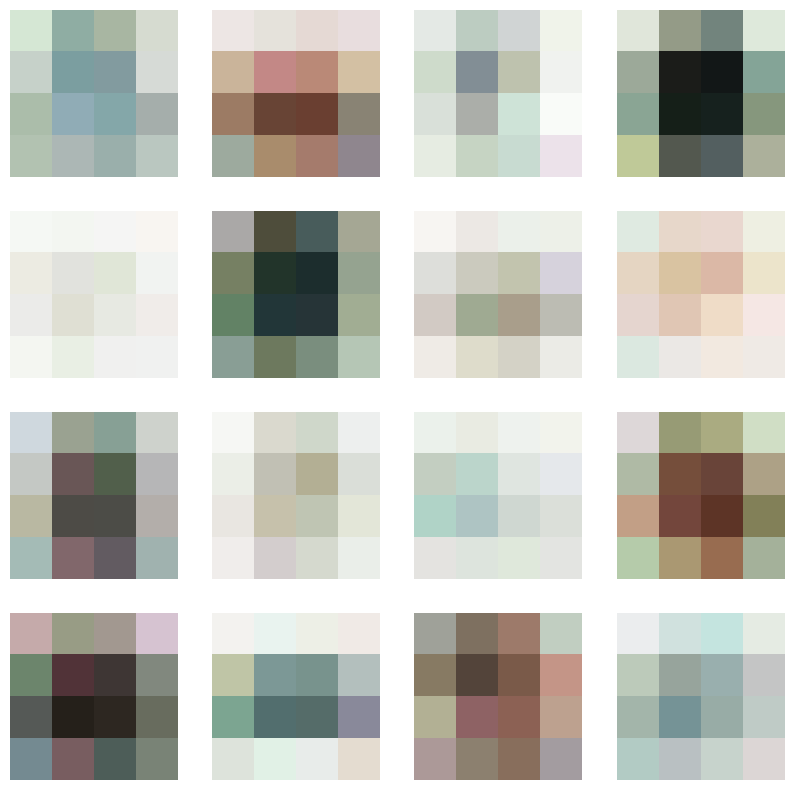

Step: 715
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5443488359451294
Generator loss: 1.1615842580795288


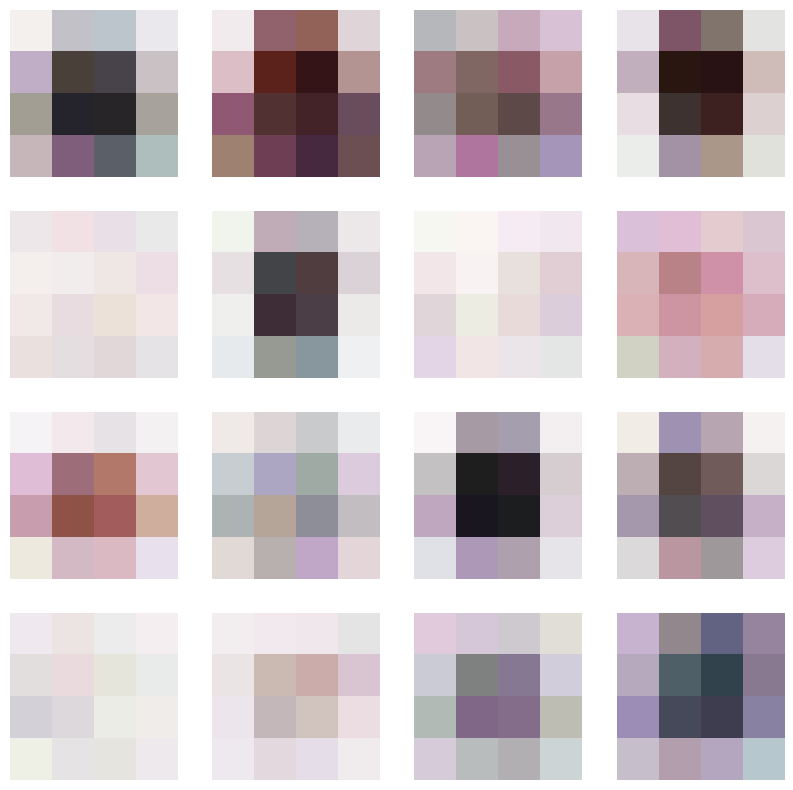

Step: 716
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5436937808990479
Generator loss: 1.1600675582885742


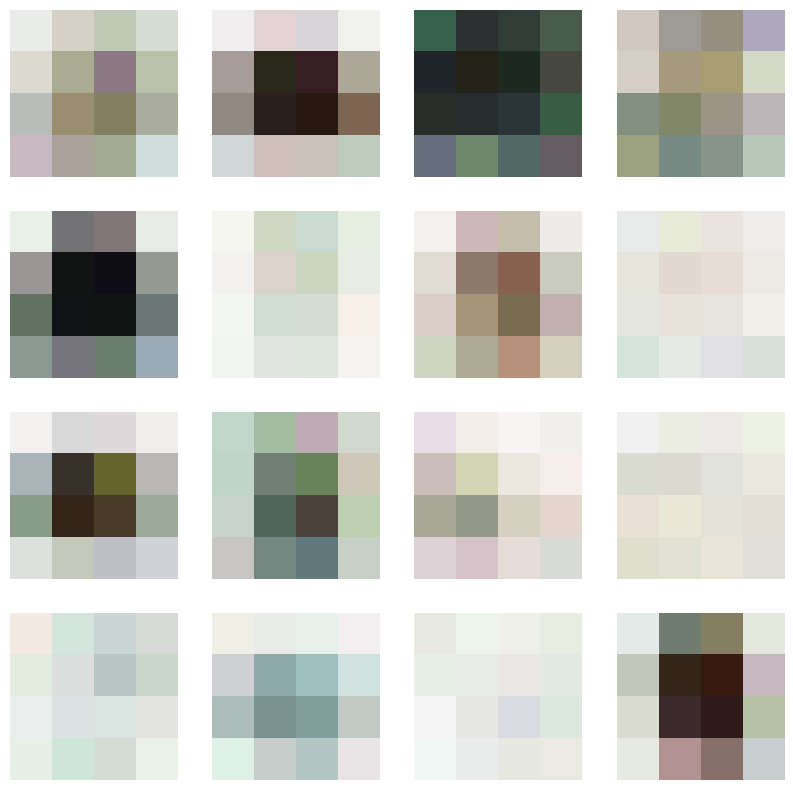

Step: 717
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5431219935417175
Generator loss: 1.1585642099380493


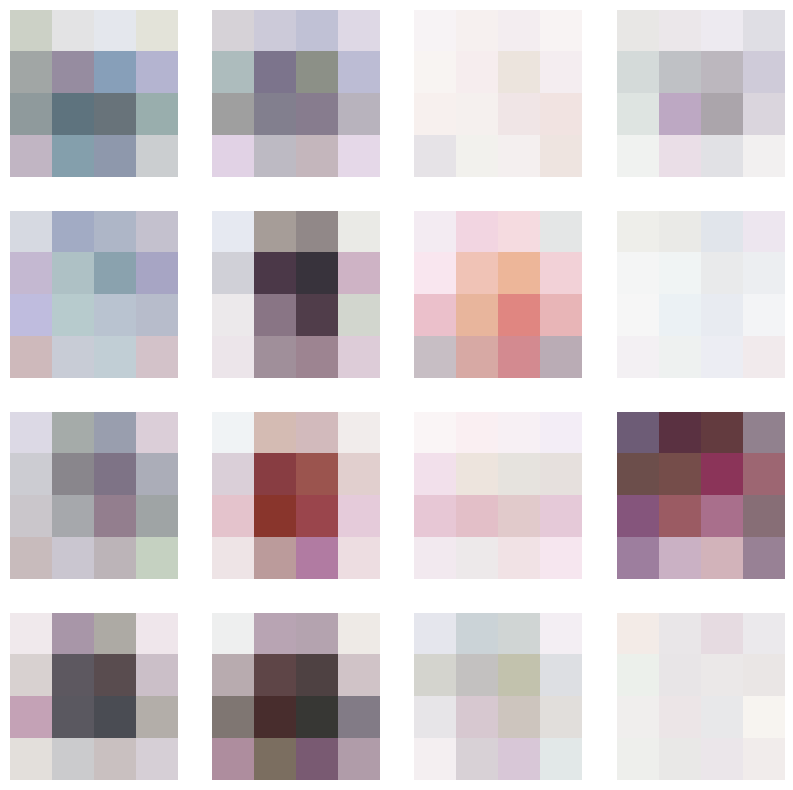

Step: 718
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5425199866294861
Generator loss: 1.1574379205703735


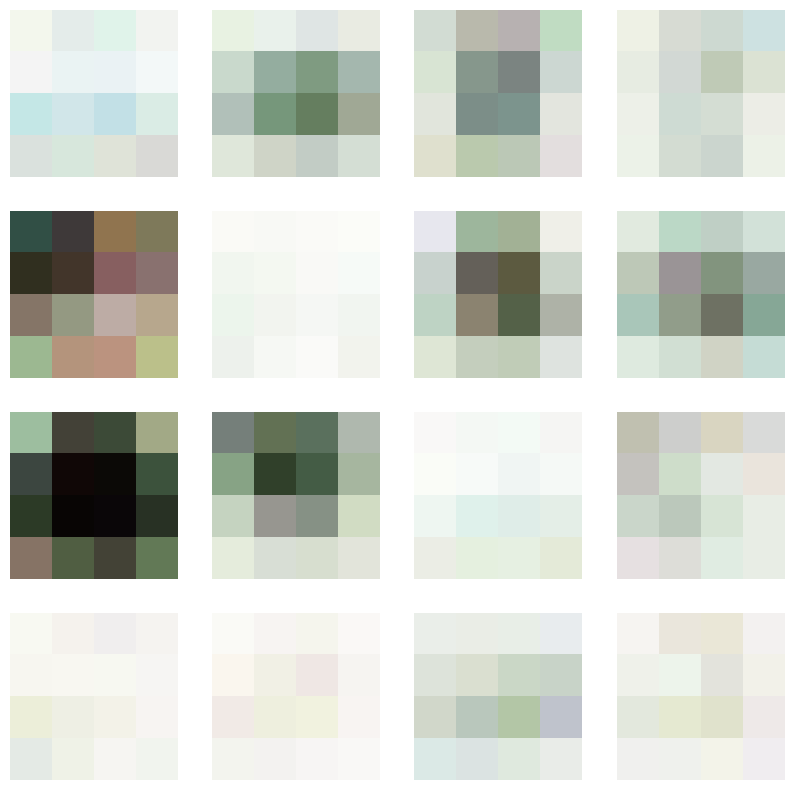

Step: 719
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5420153141021729
Generator loss: 1.1564429998397827


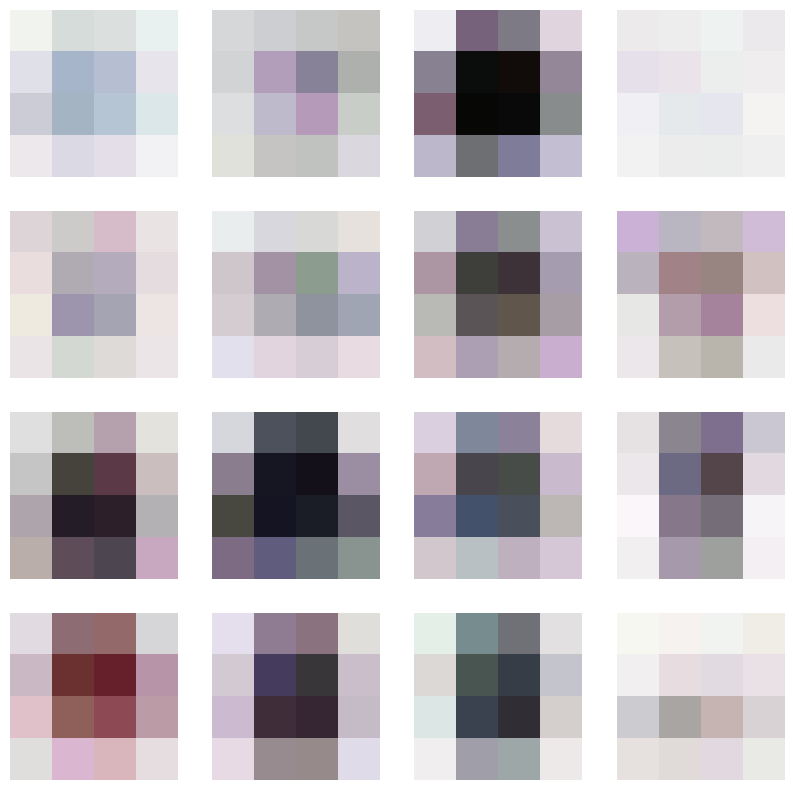

Step: 720
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5415345430374146
Generator loss: 1.155195713043213


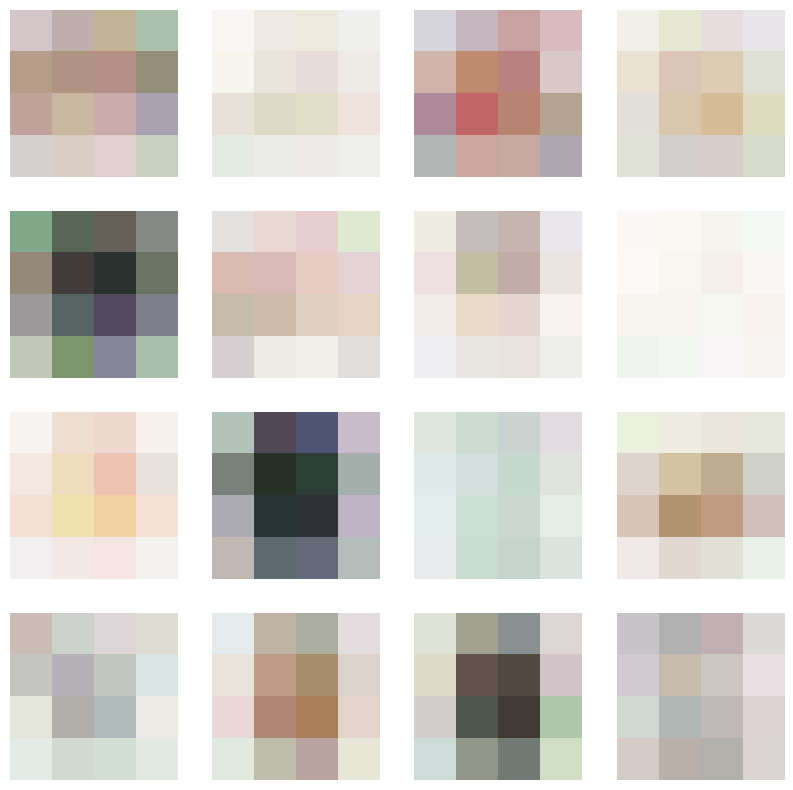

Step: 721
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5410188436508179
Generator loss: 1.1539332866668701


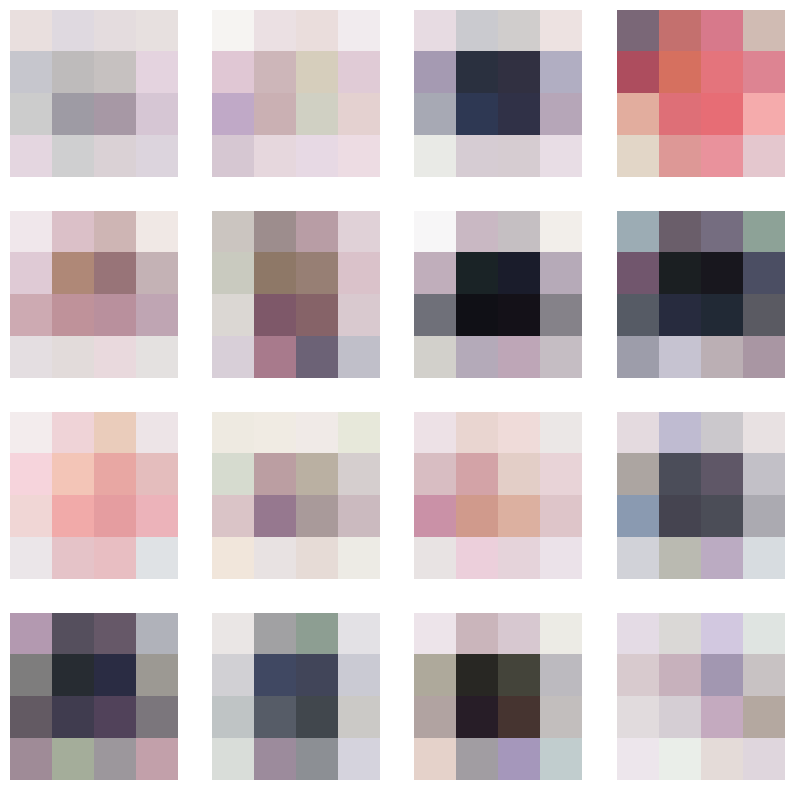

Step: 722
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5403717756271362
Generator loss: 1.152327060699463


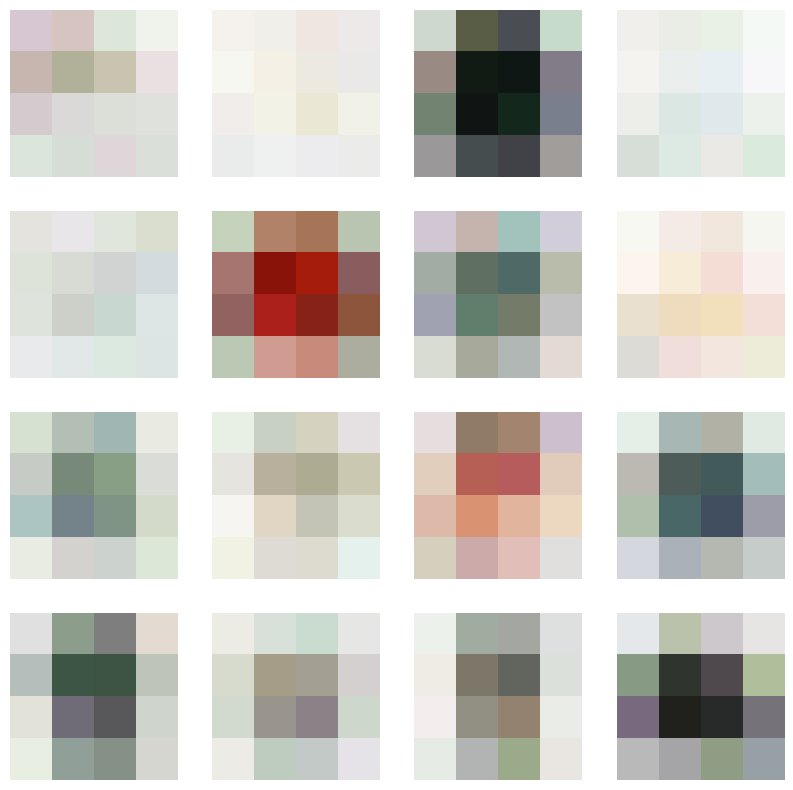

Step: 723
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5398156642913818
Generator loss: 1.1506092548370361


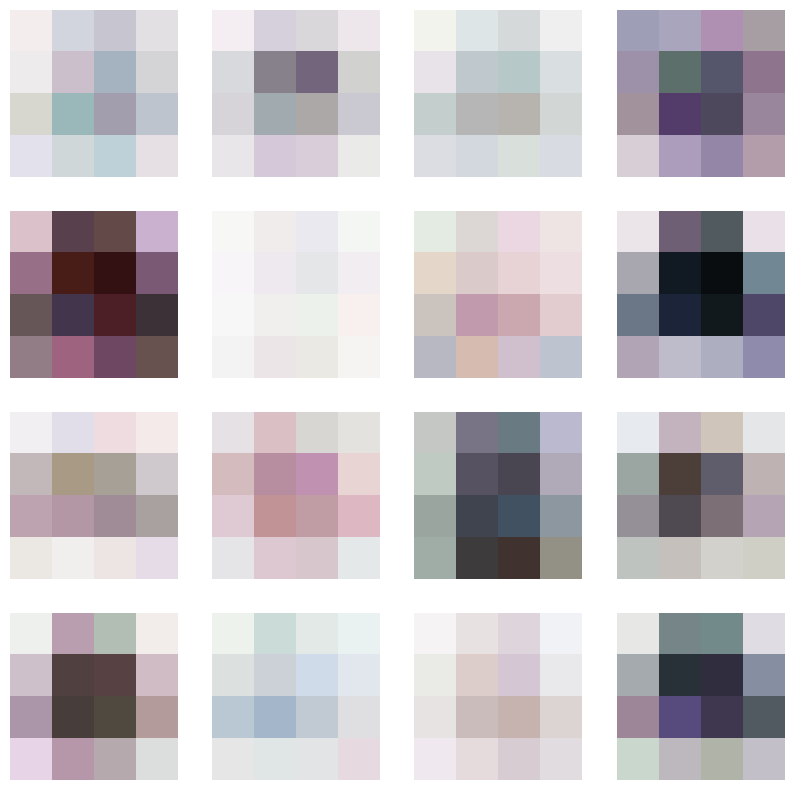

Step: 724
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5393087267875671
Generator loss: 1.1486681699752808


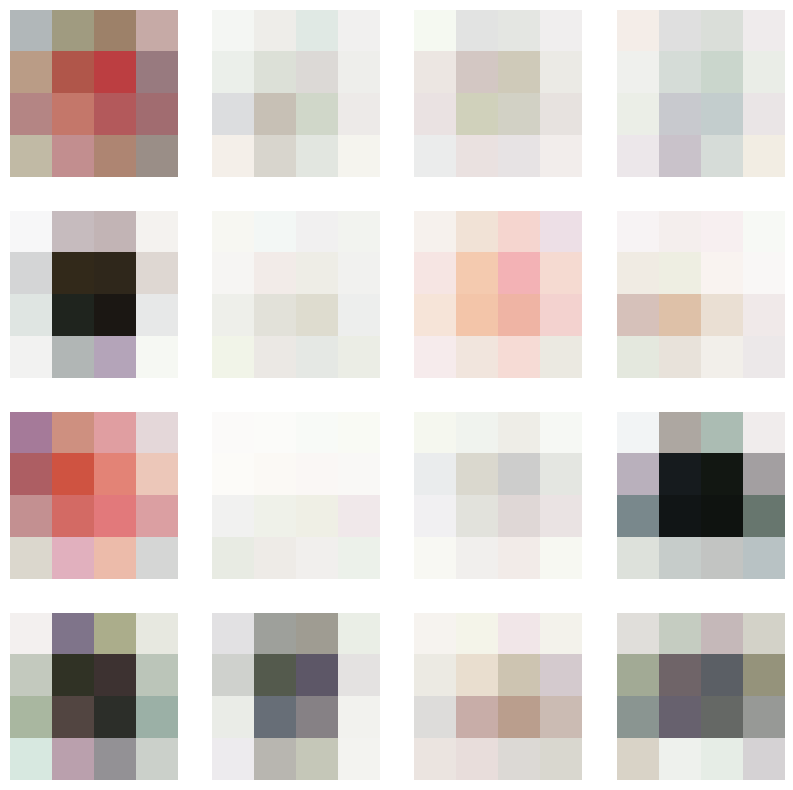

Step: 725
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.538514256477356
Generator loss: 1.1475054025650024


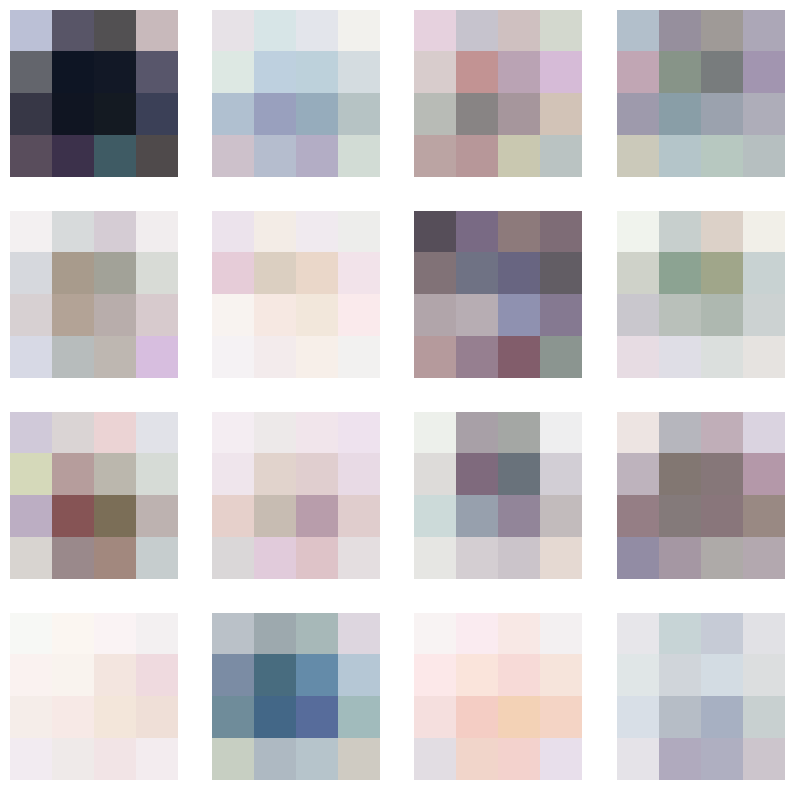

Step: 726
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5379825830459595
Generator loss: 1.1467514038085938


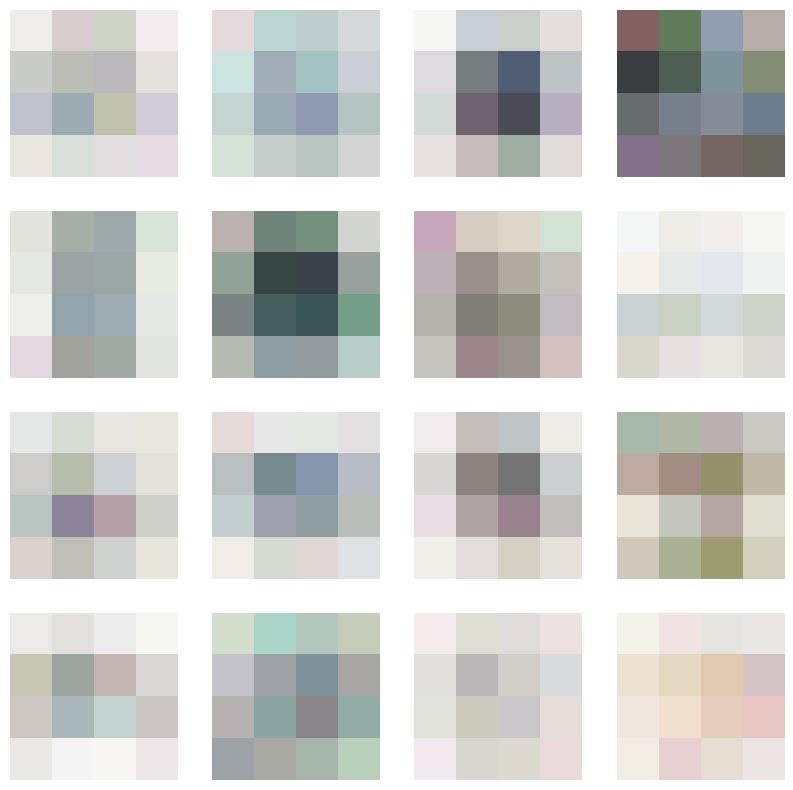

Step: 727
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5373865365982056
Generator loss: 1.1458184719085693


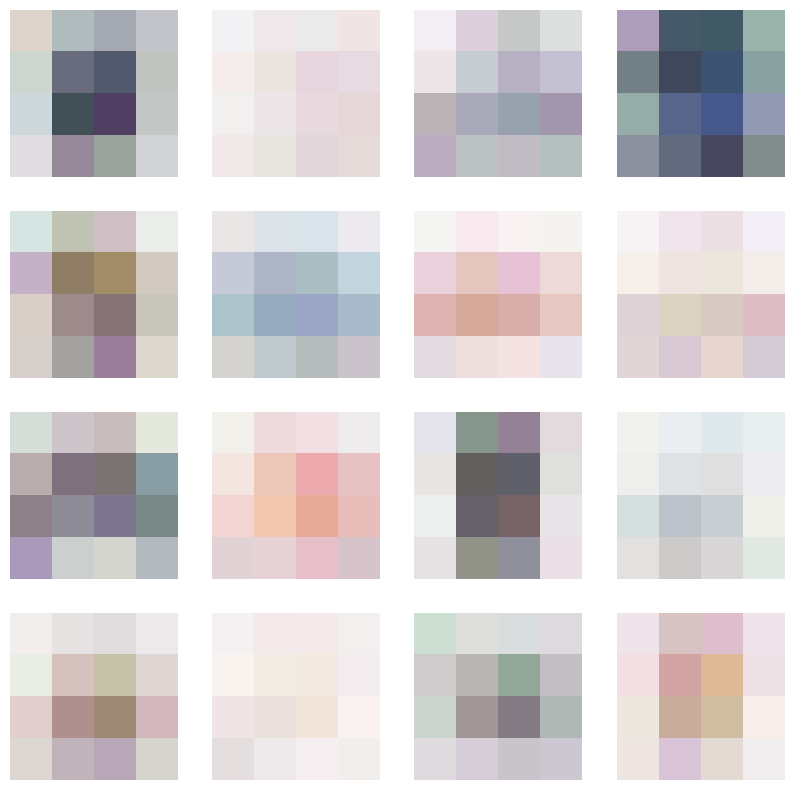

Step: 728
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5368408560752869
Generator loss: 1.1453237533569336


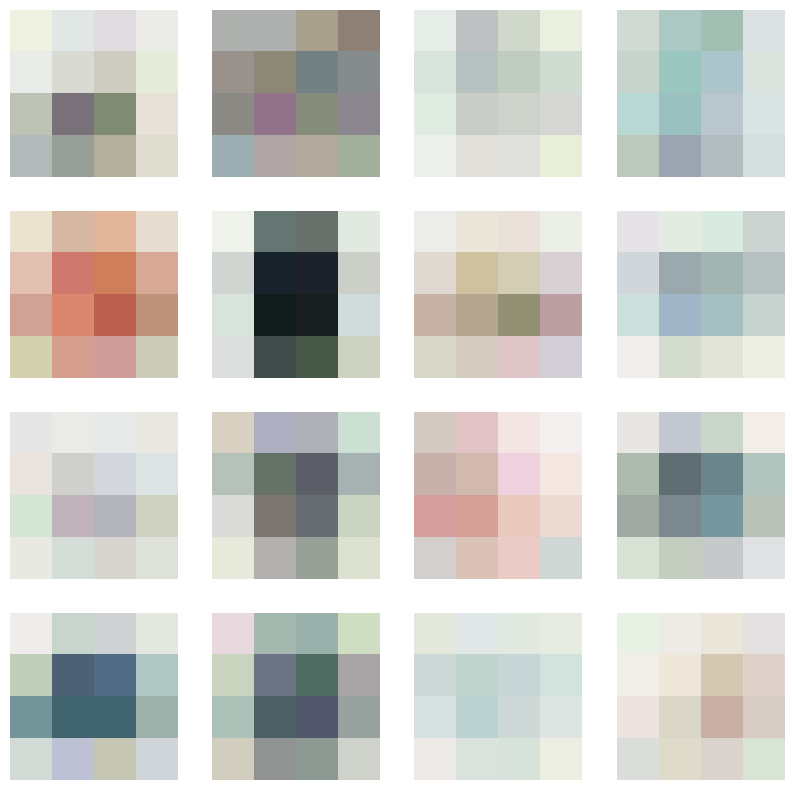

Step: 729
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5361223816871643
Generator loss: 1.143688678741455


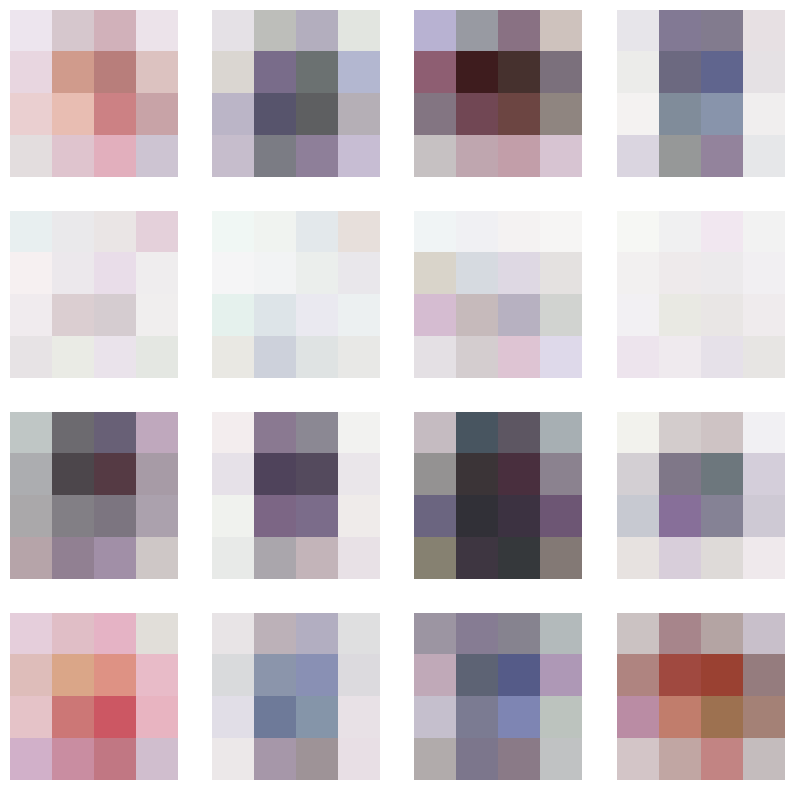

Step: 730
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5356188416481018
Generator loss: 1.1419529914855957


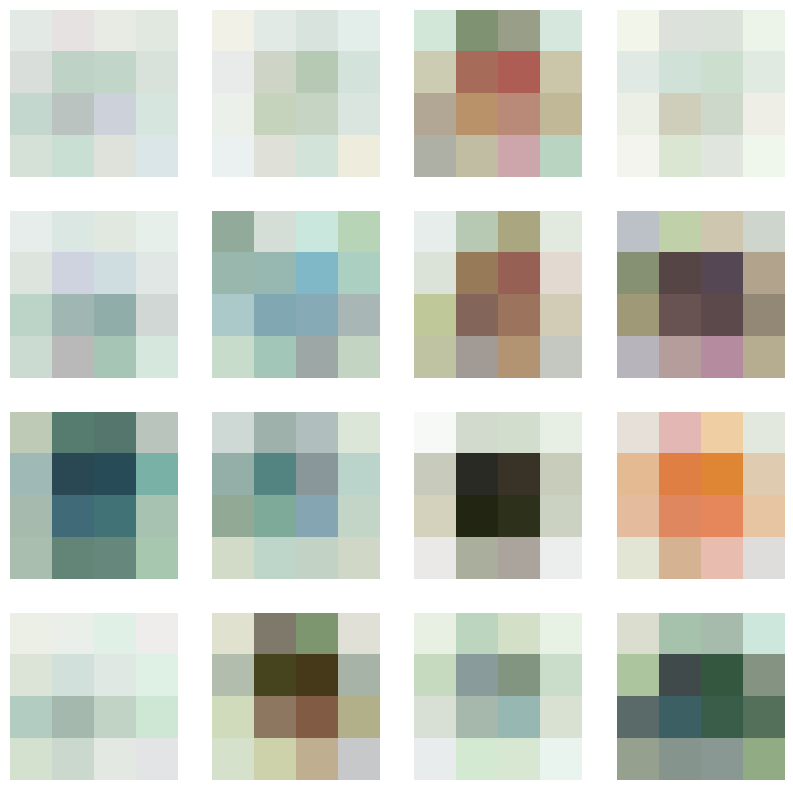

Step: 731
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5348510146141052
Generator loss: 1.140912652015686


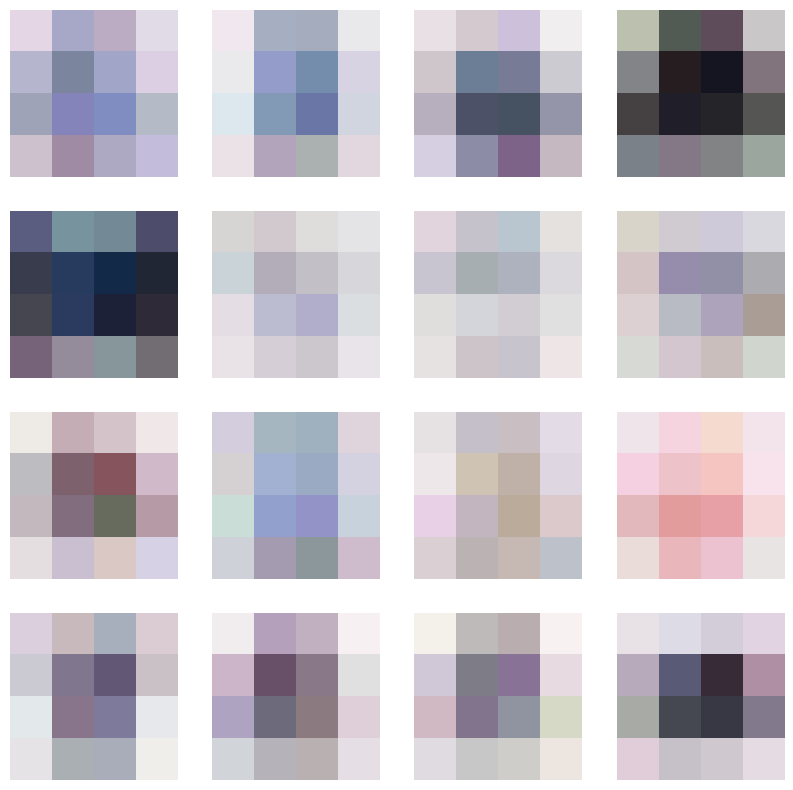

Step: 732
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5342705845832825
Generator loss: 1.1397268772125244


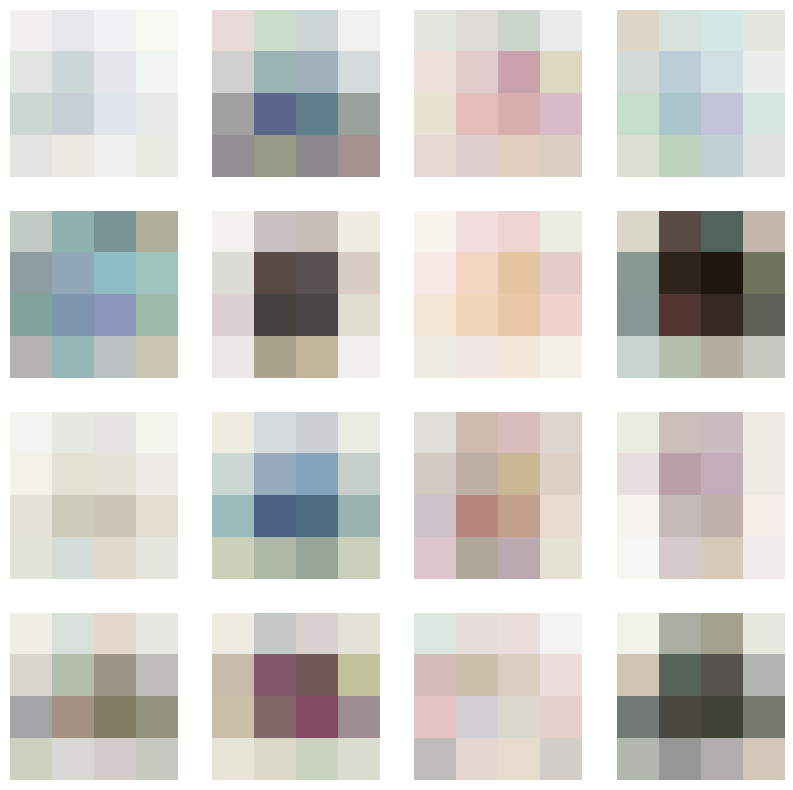

Step: 733
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5336388349533081
Generator loss: 1.1386393308639526


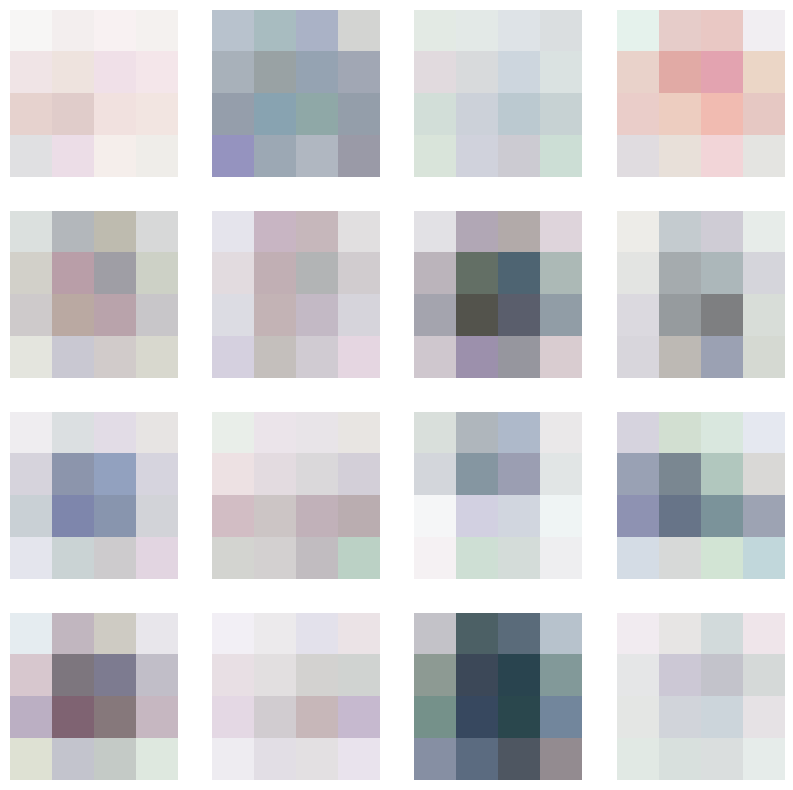

Step: 734
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5331487059593201
Generator loss: 1.1376653909683228


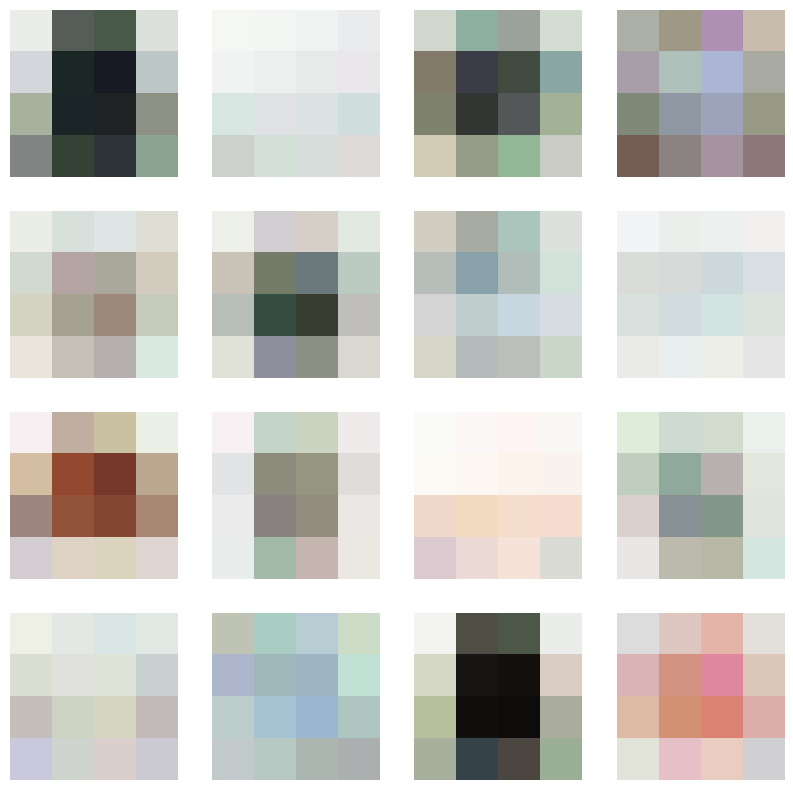

Step: 735
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.532524585723877
Generator loss: 1.1358799934387207


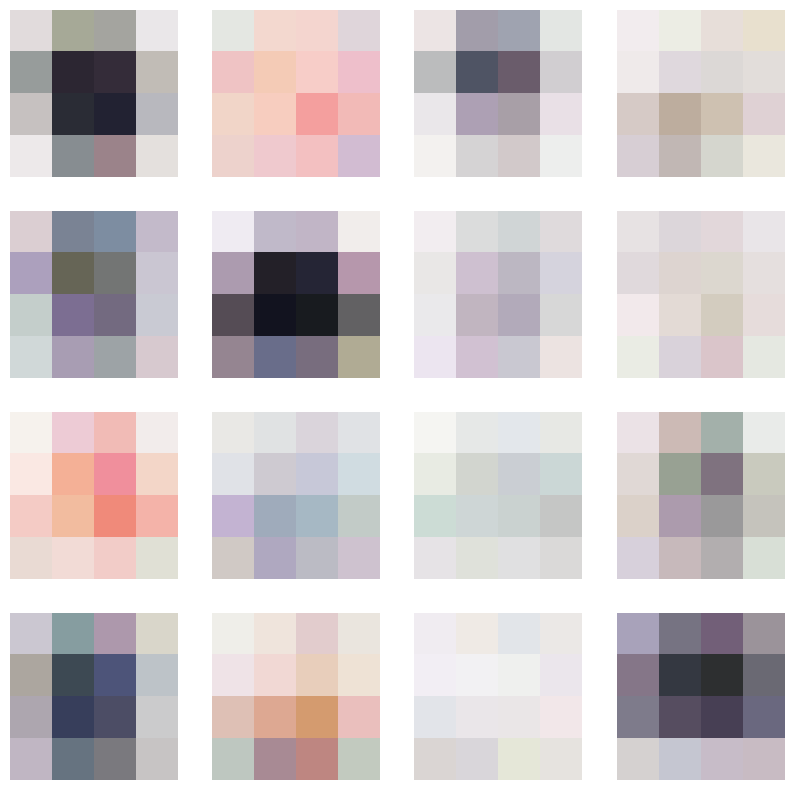

Step: 736
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.531955897808075
Generator loss: 1.134065866470337


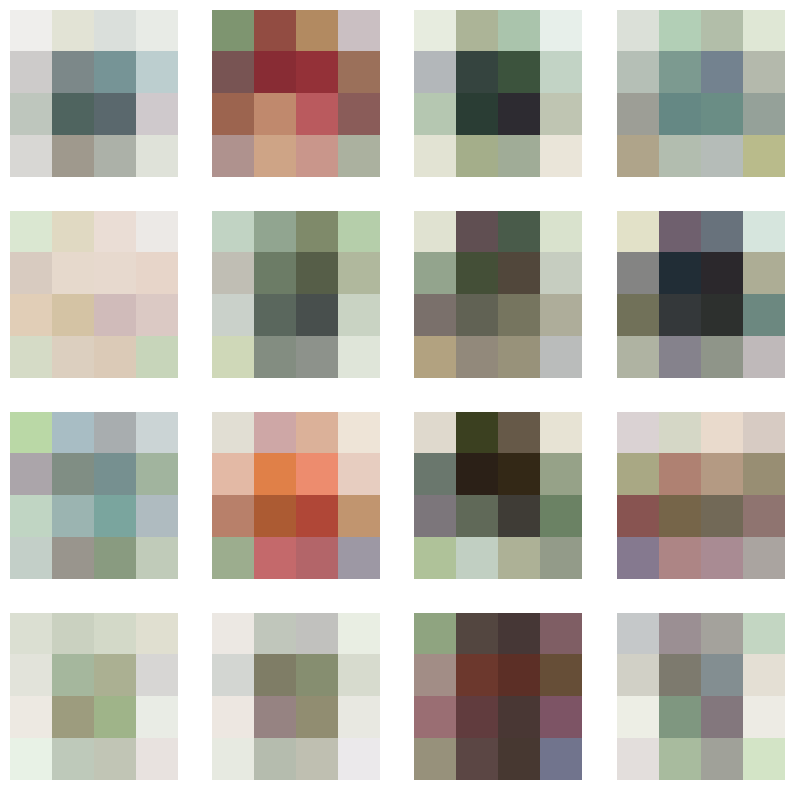

Step: 737
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5315403342247009
Generator loss: 1.1324092149734497


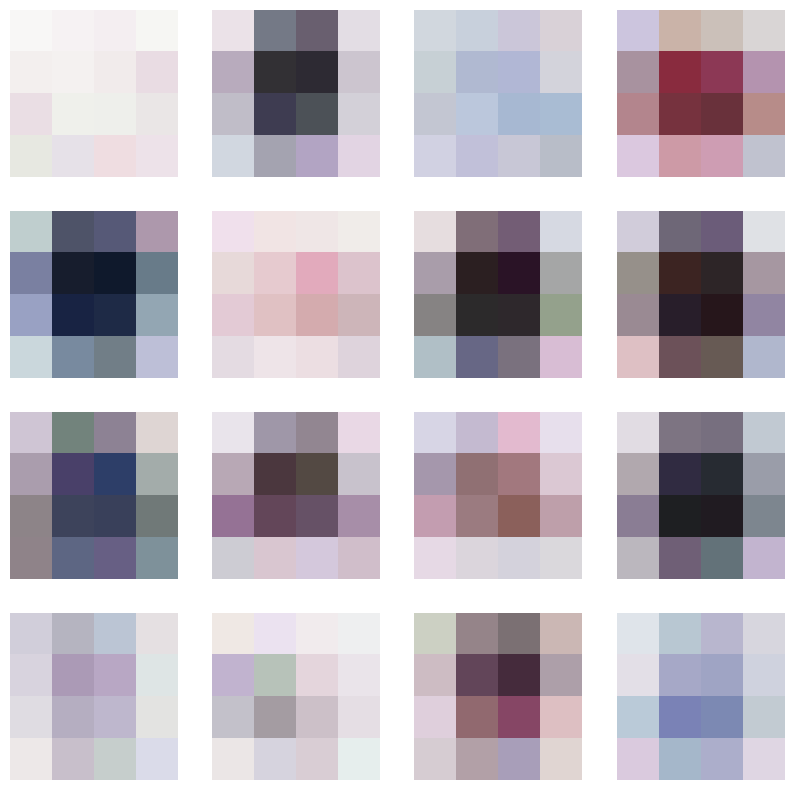

Step: 738
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.530889630317688
Generator loss: 1.1308568716049194


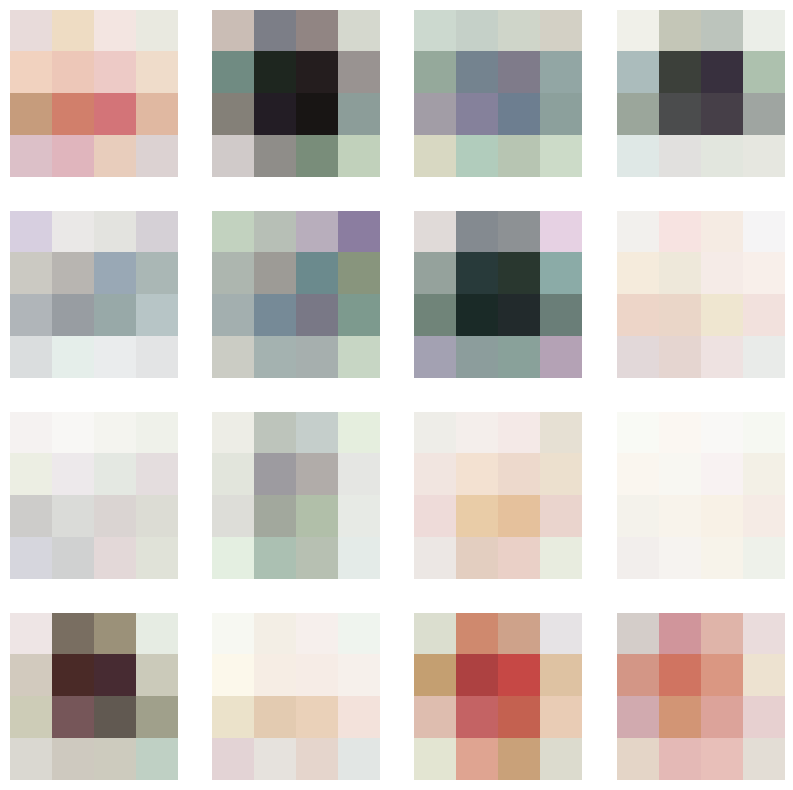

Step: 739
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5303532481193542
Generator loss: 1.1289467811584473


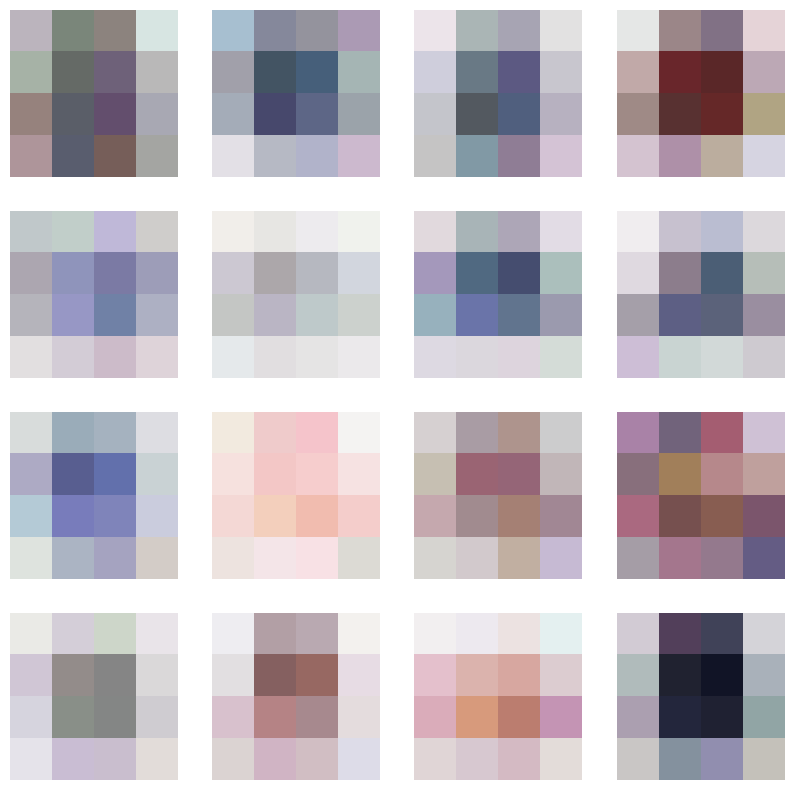

Step: 740
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5298742055892944
Generator loss: 1.1267775297164917


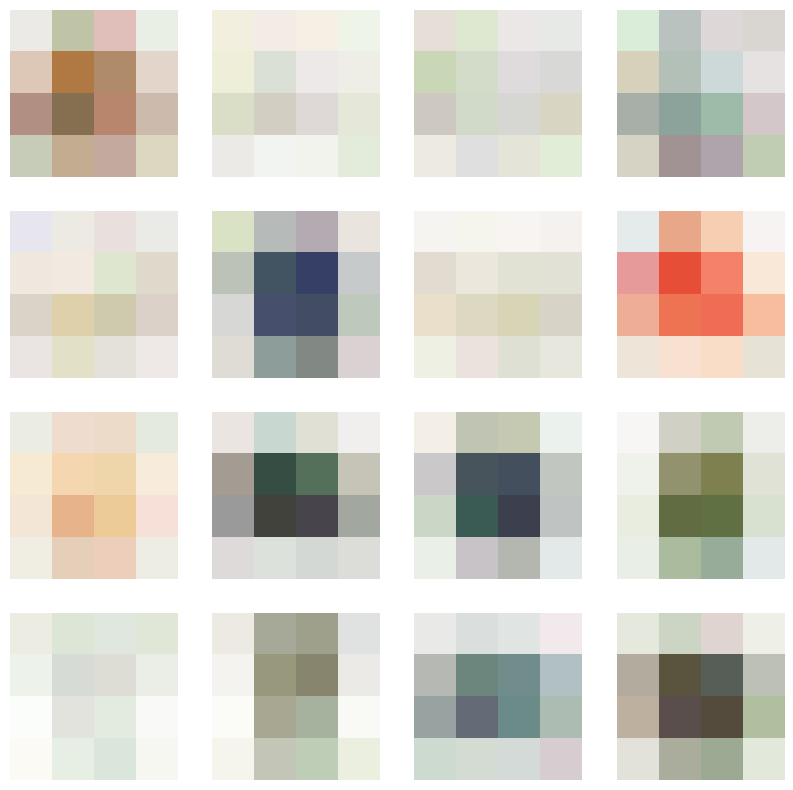

Step: 741
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5292000770568848
Generator loss: 1.1255366802215576


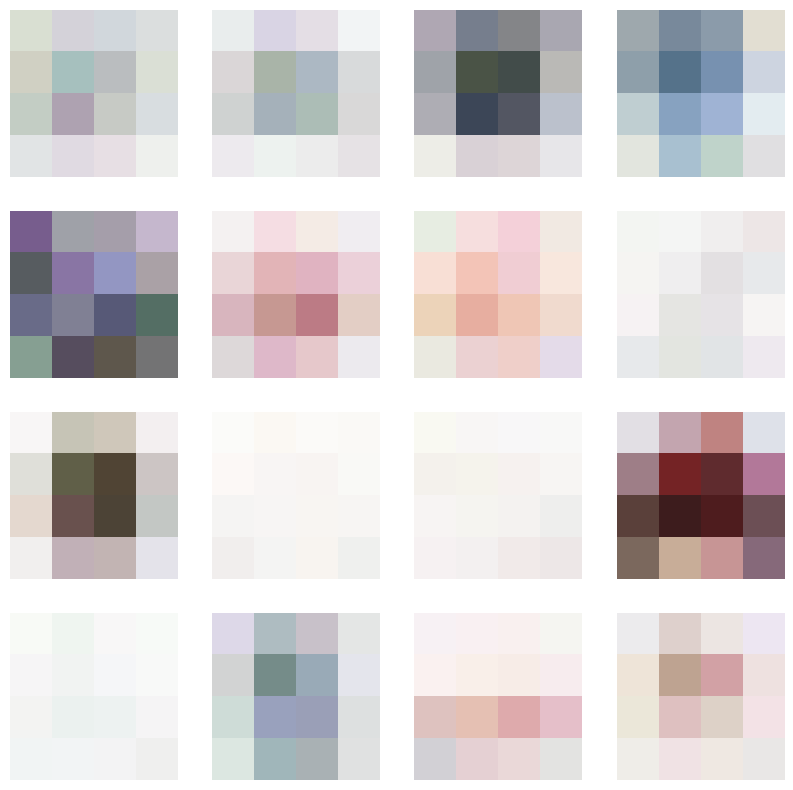

Step: 742
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5285993218421936
Generator loss: 1.1252250671386719


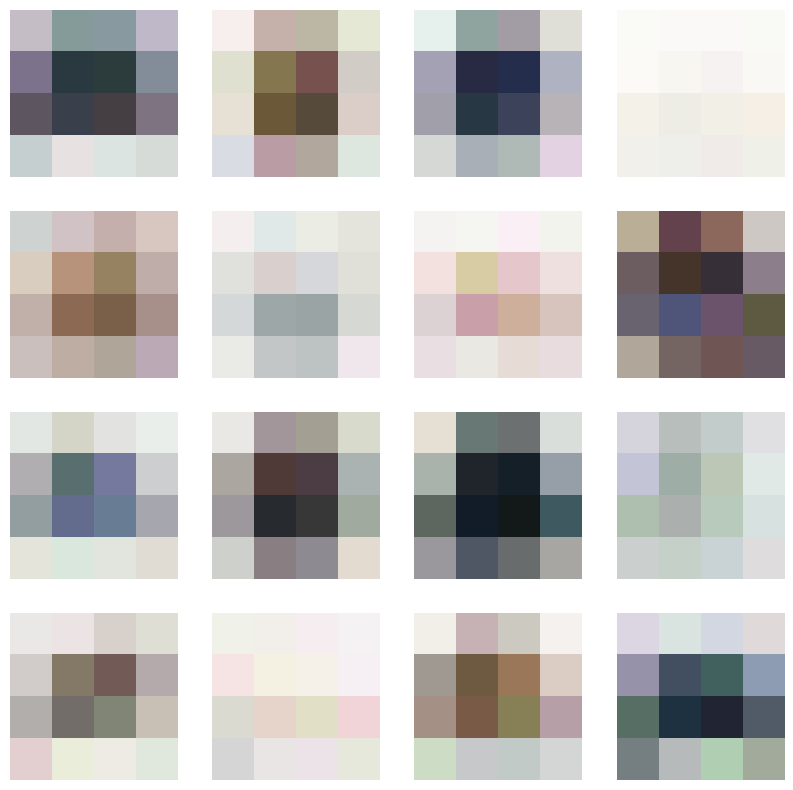

Step: 743
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5278840661048889
Generator loss: 1.1242051124572754


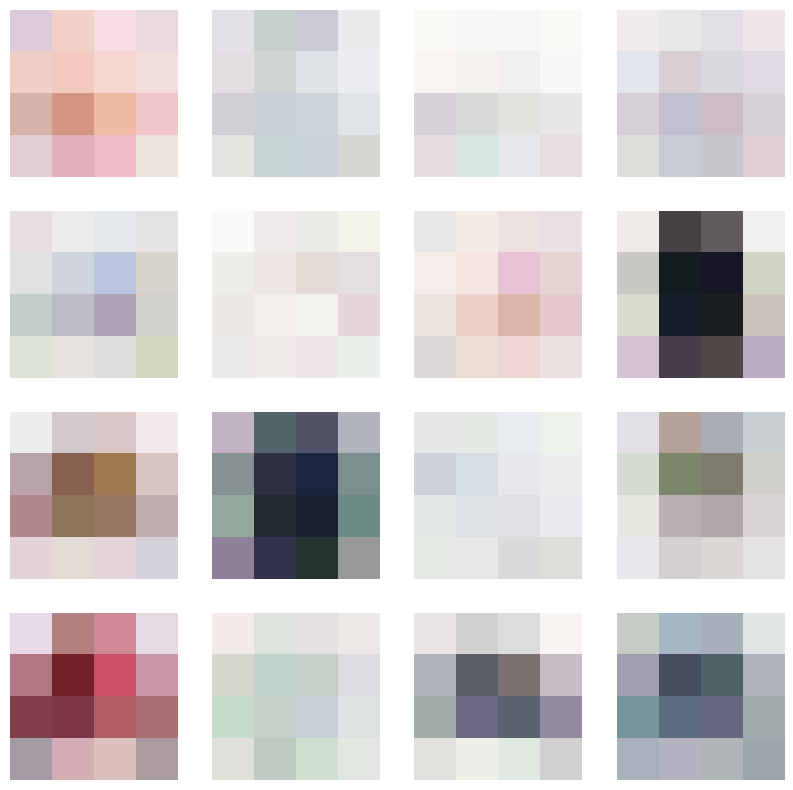

Step: 744
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5273541808128357
Generator loss: 1.1235429048538208


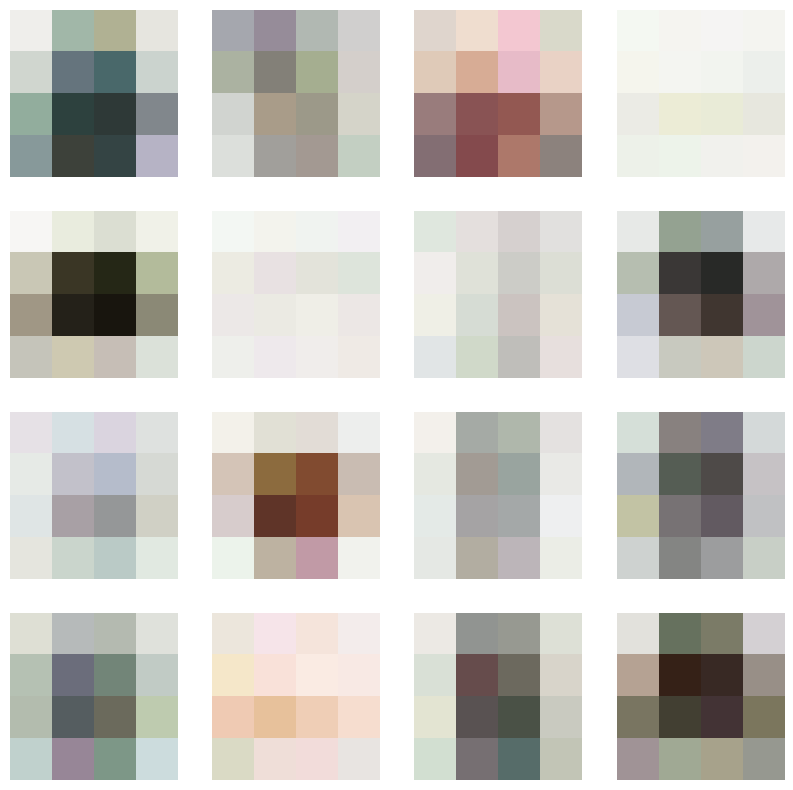

Step: 745
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5266978740692139
Generator loss: 1.1219781637191772


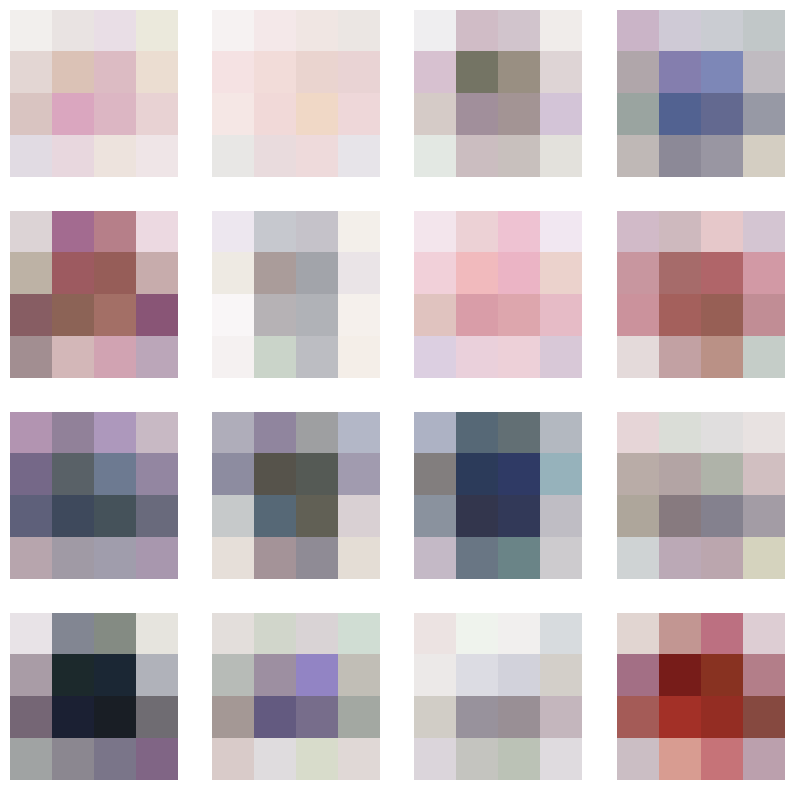

Step: 746
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.526135265827179
Generator loss: 1.1203798055648804


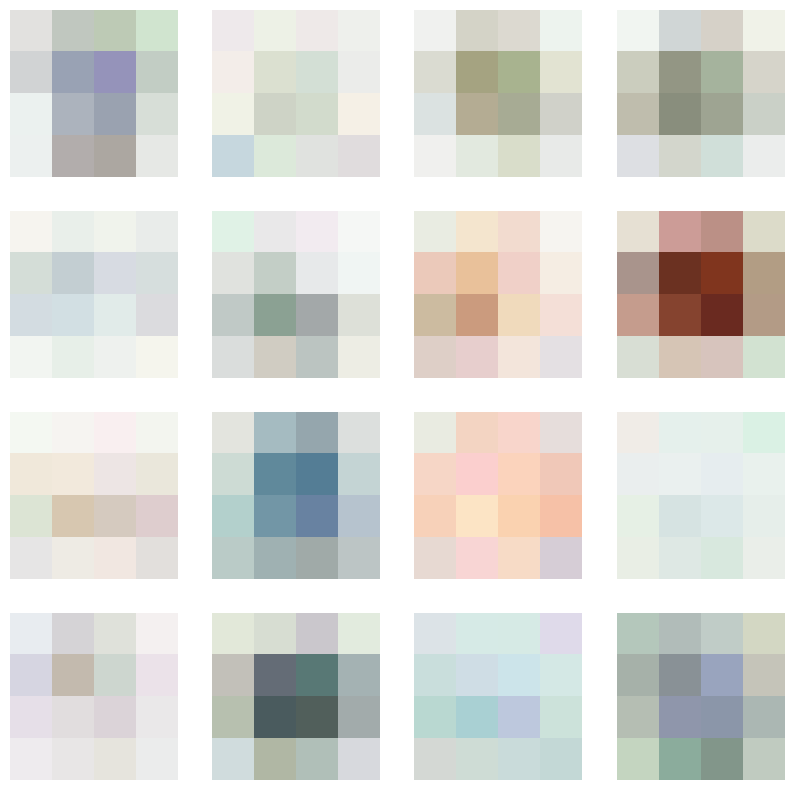

Step: 747
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5255039930343628
Generator loss: 1.1191775798797607


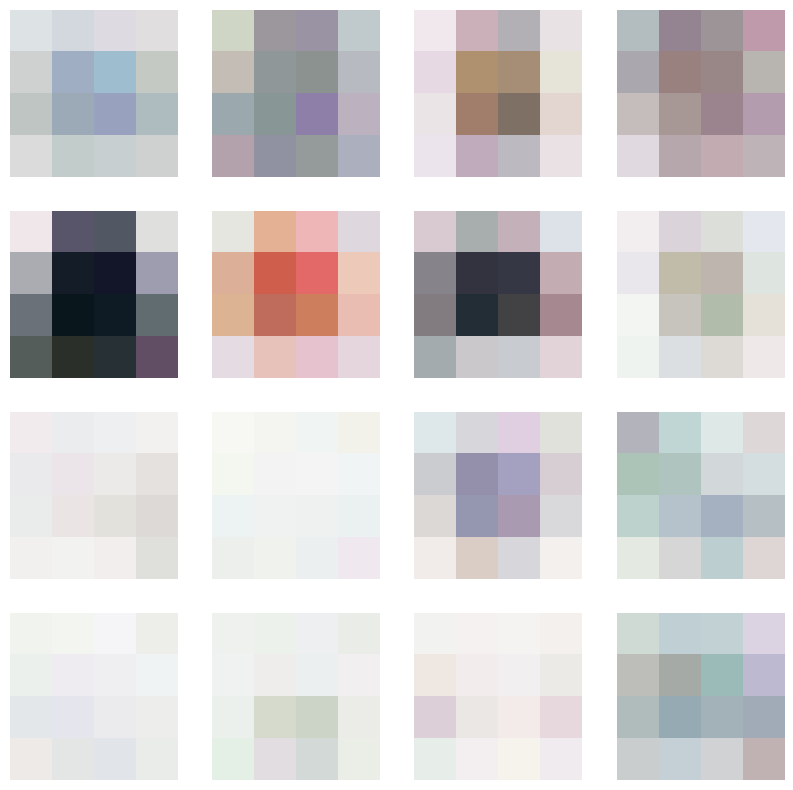

Step: 748
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5248530507087708
Generator loss: 1.1186107397079468


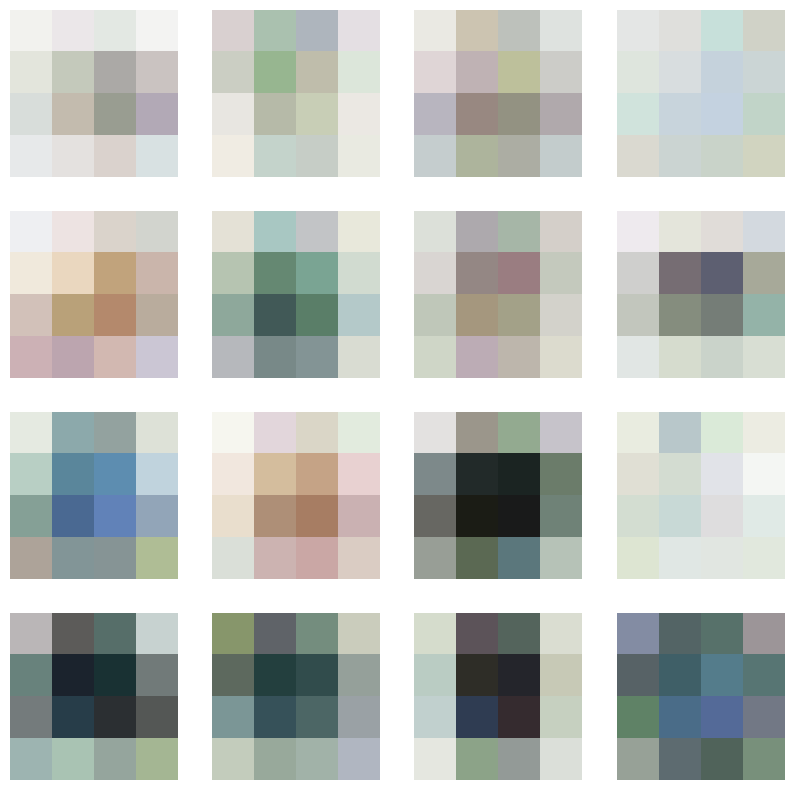

Step: 749
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5244189500808716
Generator loss: 1.118313193321228


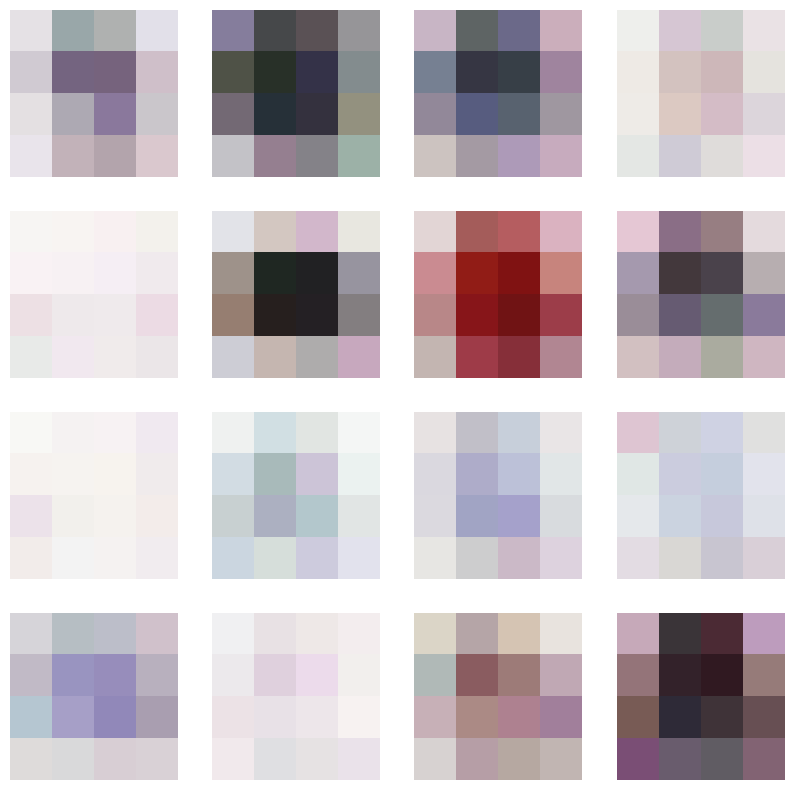

Step: 750
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5237511992454529
Generator loss: 1.1174687147140503


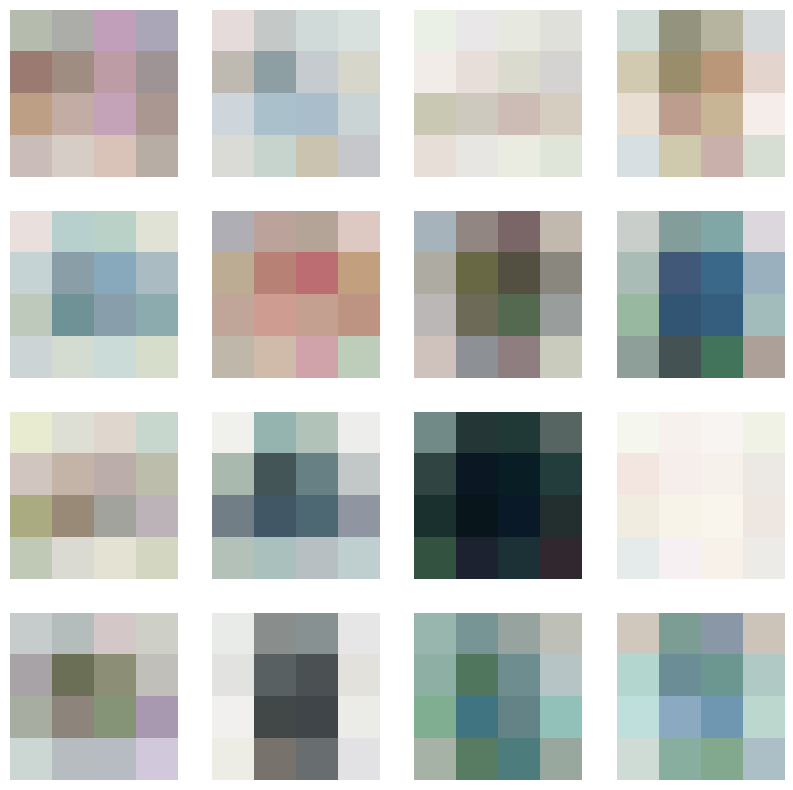

Step: 751
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5231925249099731
Generator loss: 1.11642587184906


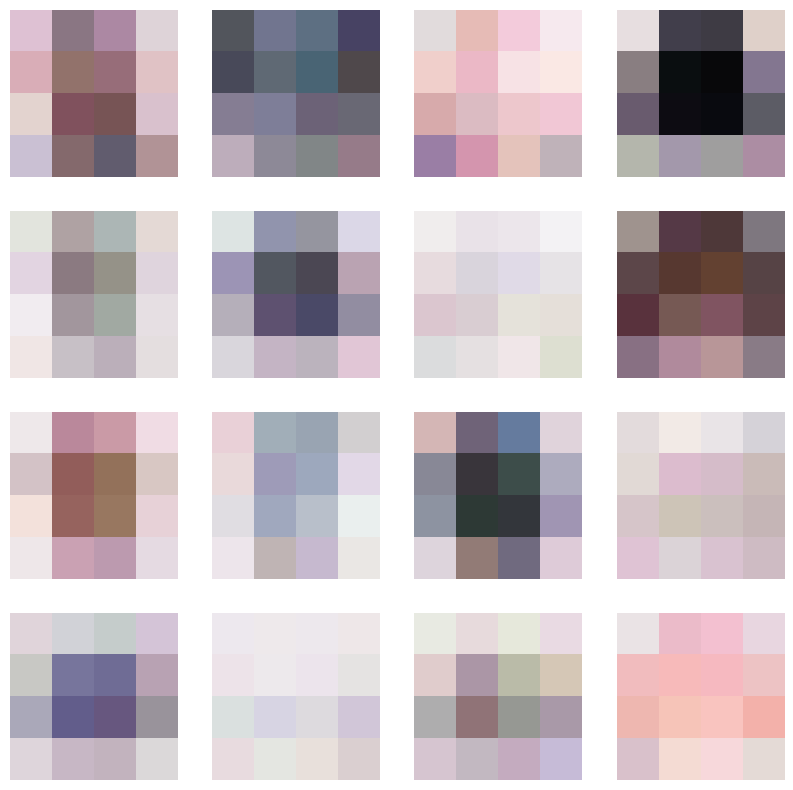

Step: 752
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5227100849151611
Generator loss: 1.1150171756744385


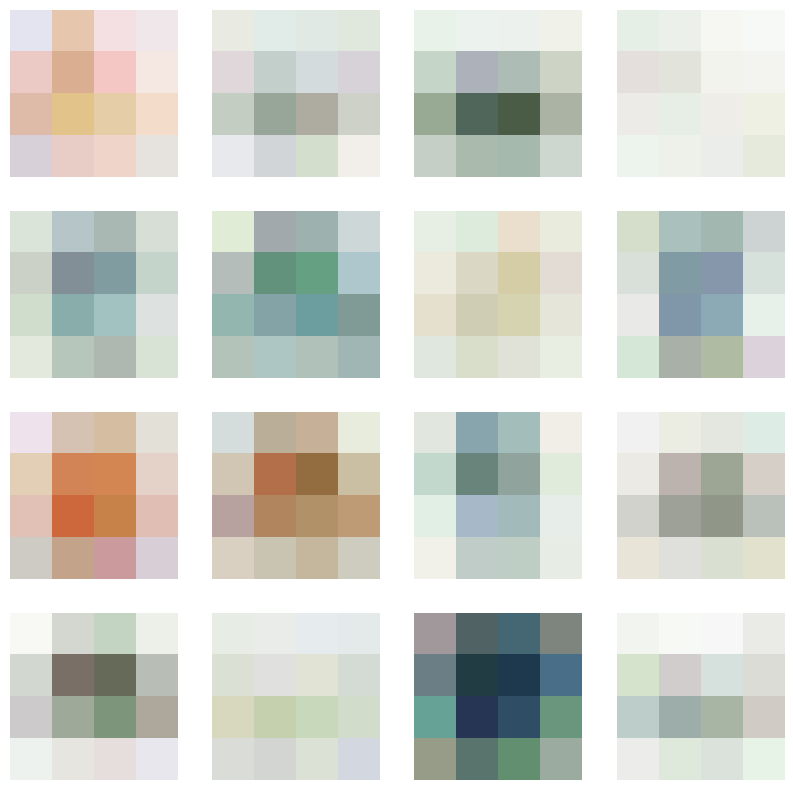

Step: 753
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5221512913703918
Generator loss: 1.1136853694915771


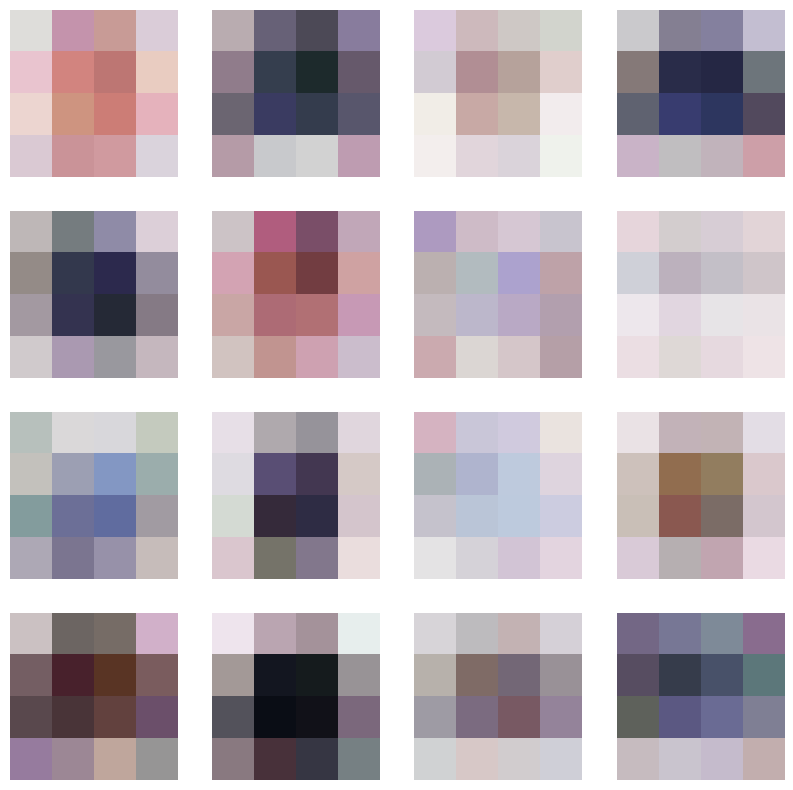

Step: 754
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5216876268386841
Generator loss: 1.1119719743728638


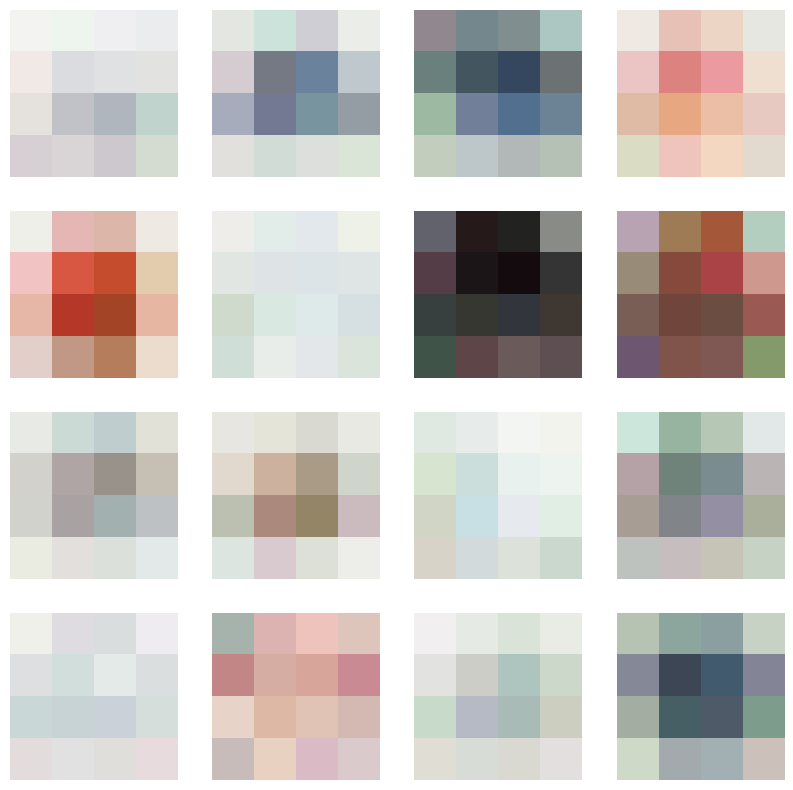

Step: 755
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.521198034286499
Generator loss: 1.1098054647445679


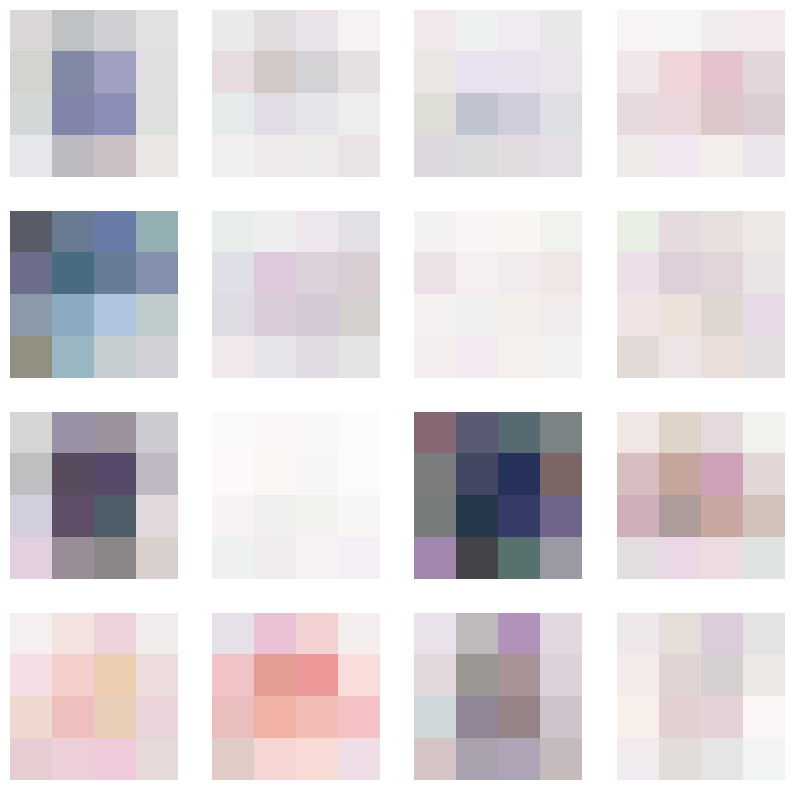

Step: 756
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5206804871559143
Generator loss: 1.1078218221664429


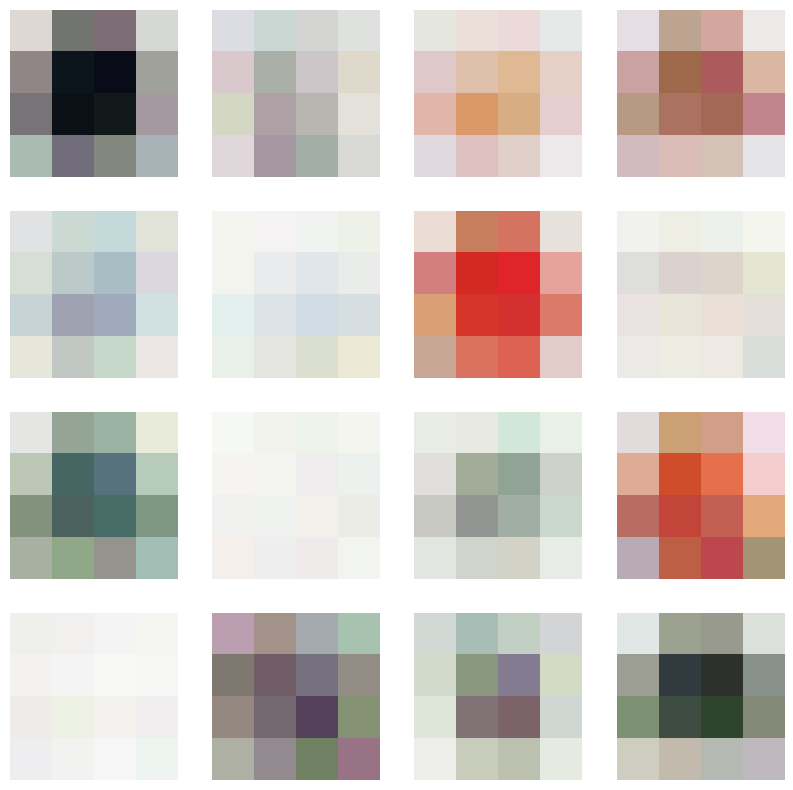

Step: 757
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5200865268707275
Generator loss: 1.1058902740478516


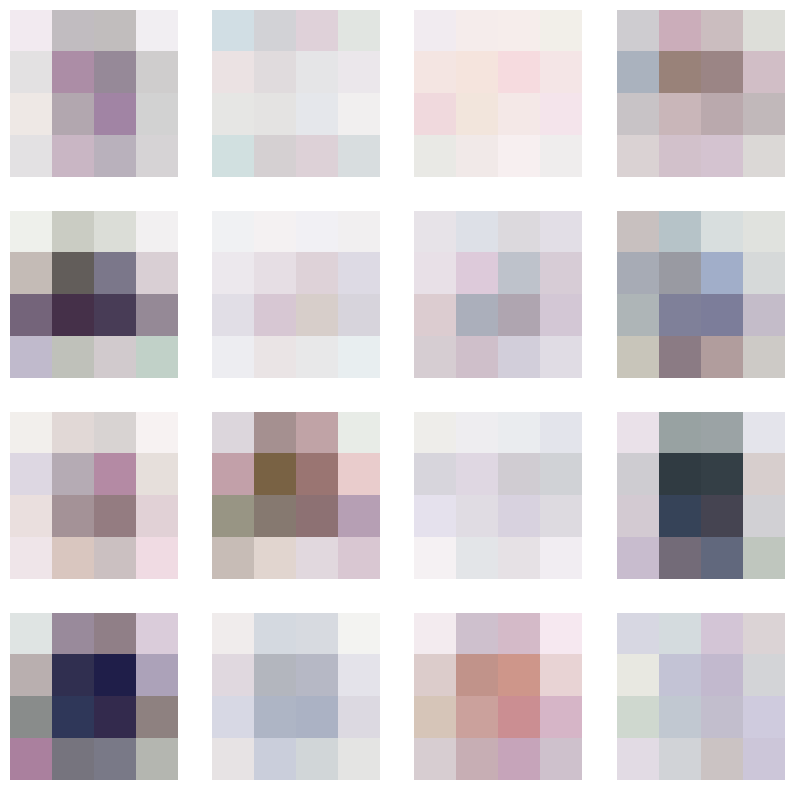

Step: 758
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5195280909538269
Generator loss: 1.10464346408844


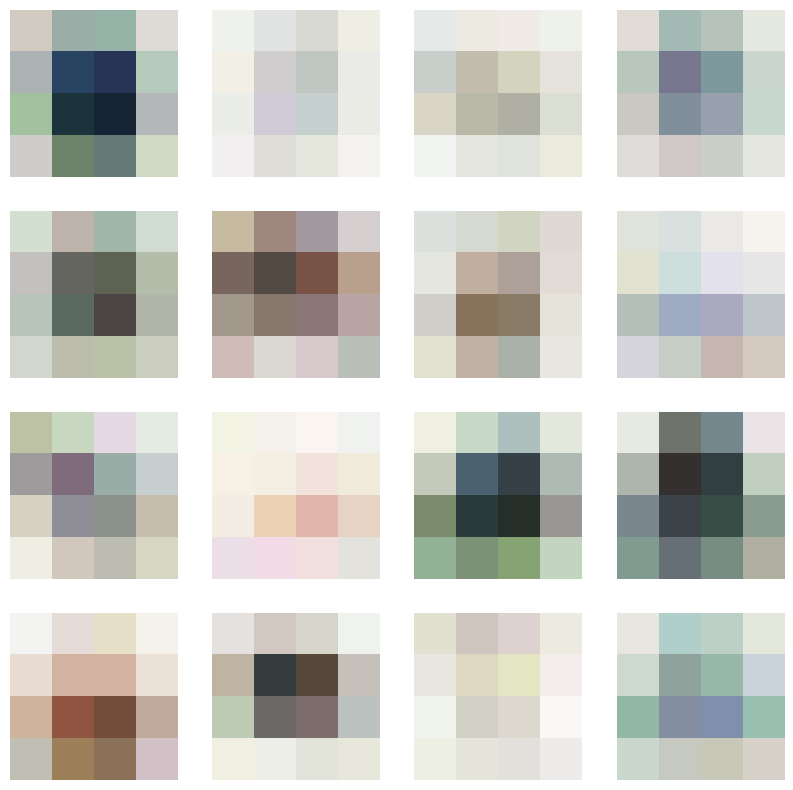

Step: 759
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5190180540084839
Generator loss: 1.1041347980499268


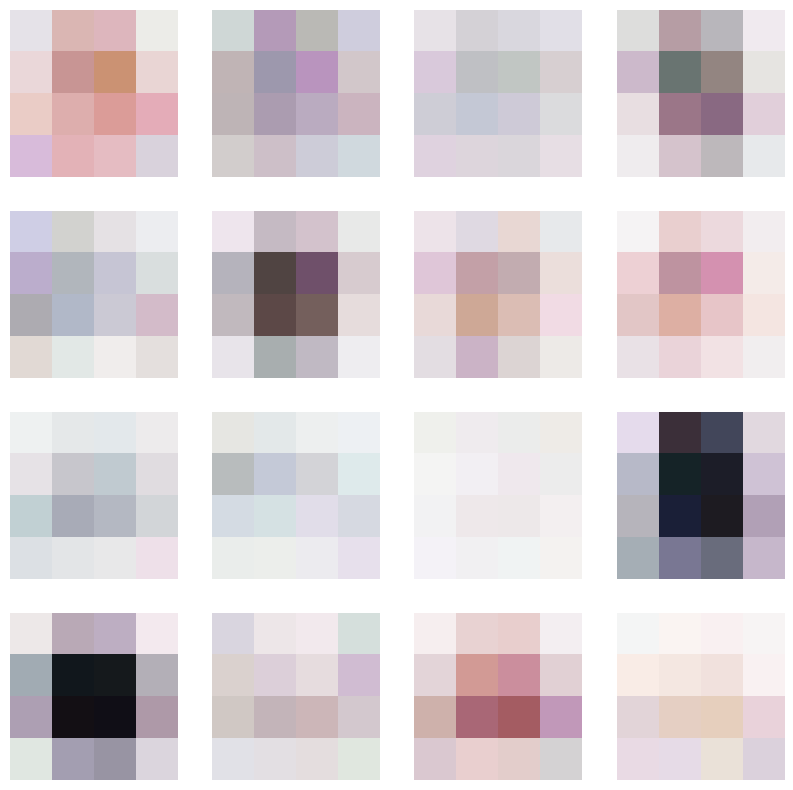

Step: 760
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5185602307319641
Generator loss: 1.103218913078308


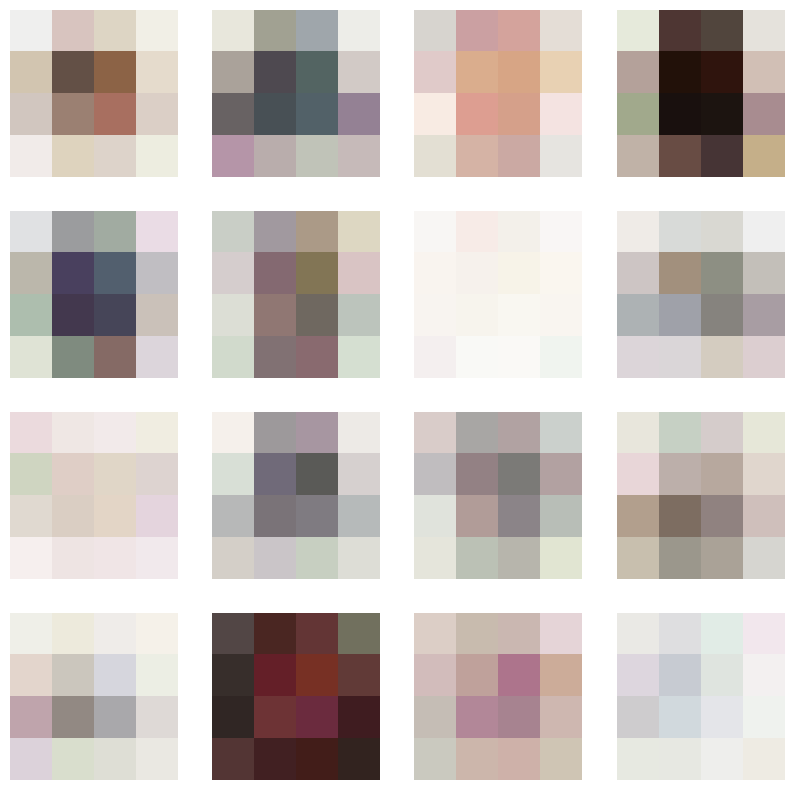

Step: 761
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5178651213645935
Generator loss: 1.1020548343658447


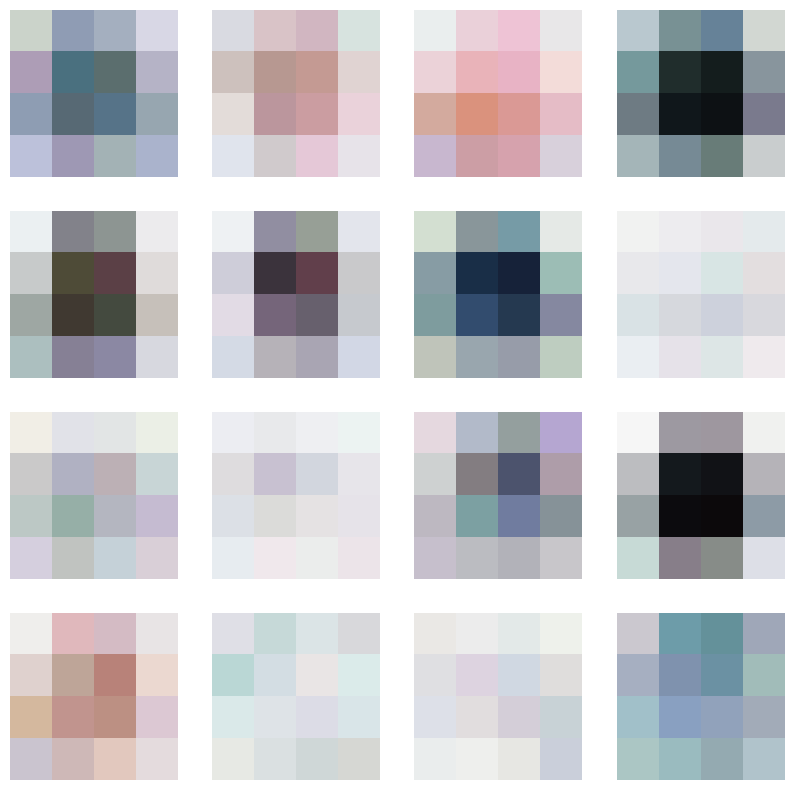

Step: 762
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5172541737556458
Generator loss: 1.1009771823883057


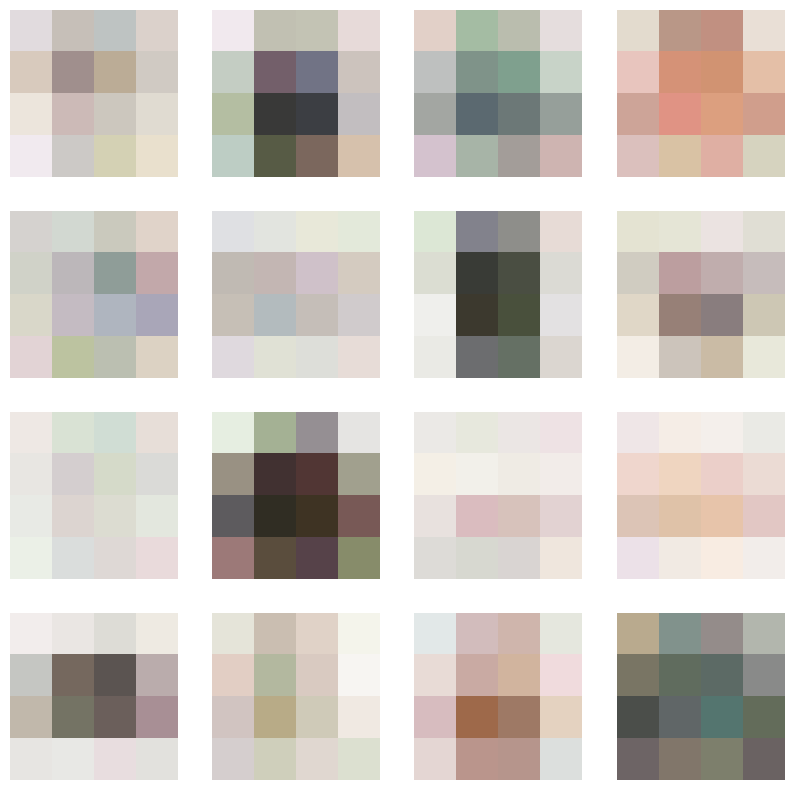

Step: 763
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5166460871696472
Generator loss: 1.0998592376708984


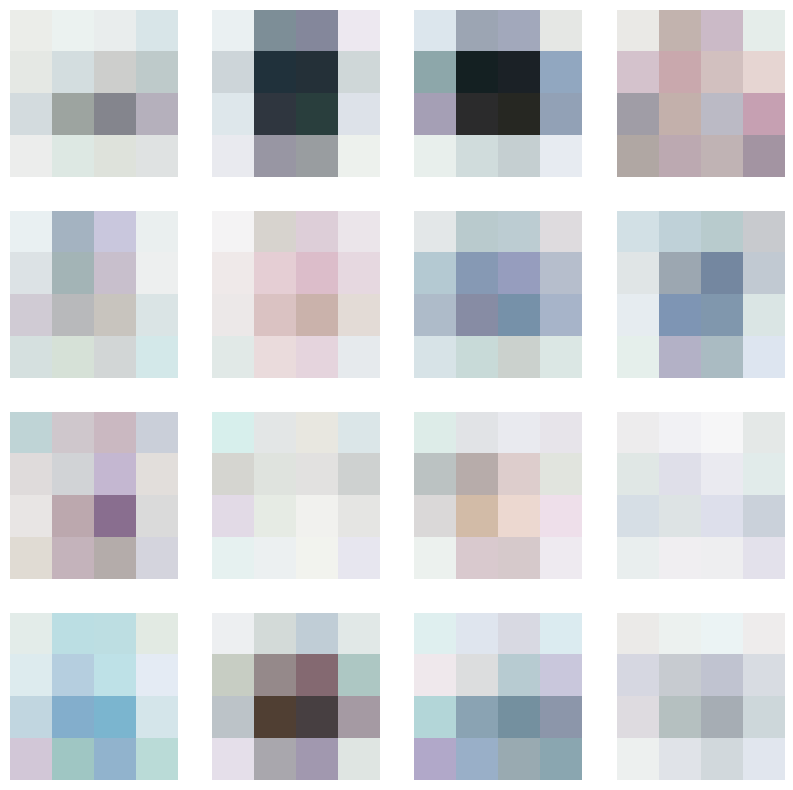

Step: 764
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5161406993865967
Generator loss: 1.0987639427185059


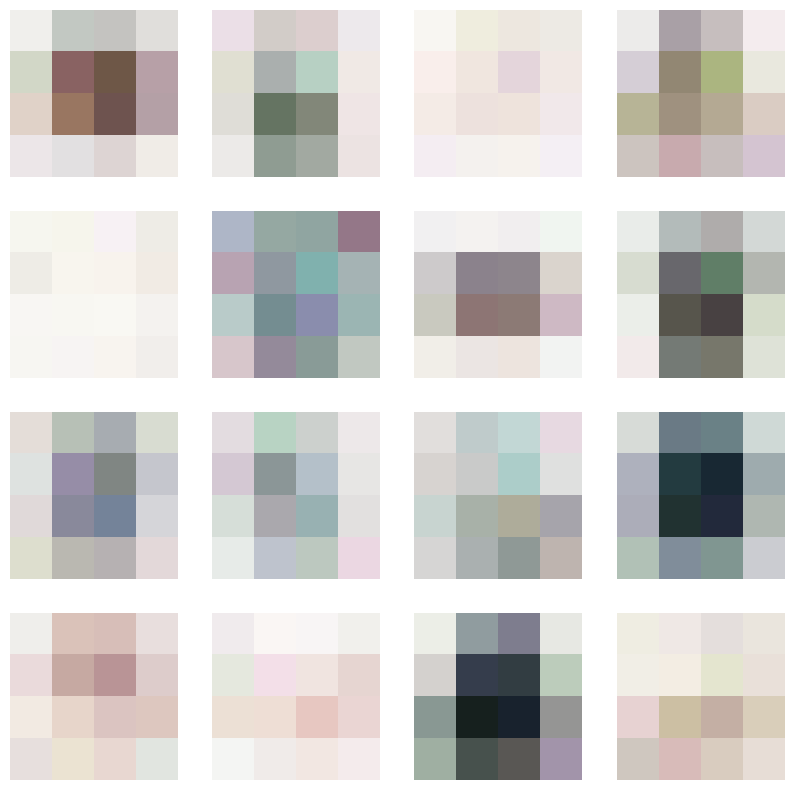

Step: 765
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5156095623970032
Generator loss: 1.0976492166519165


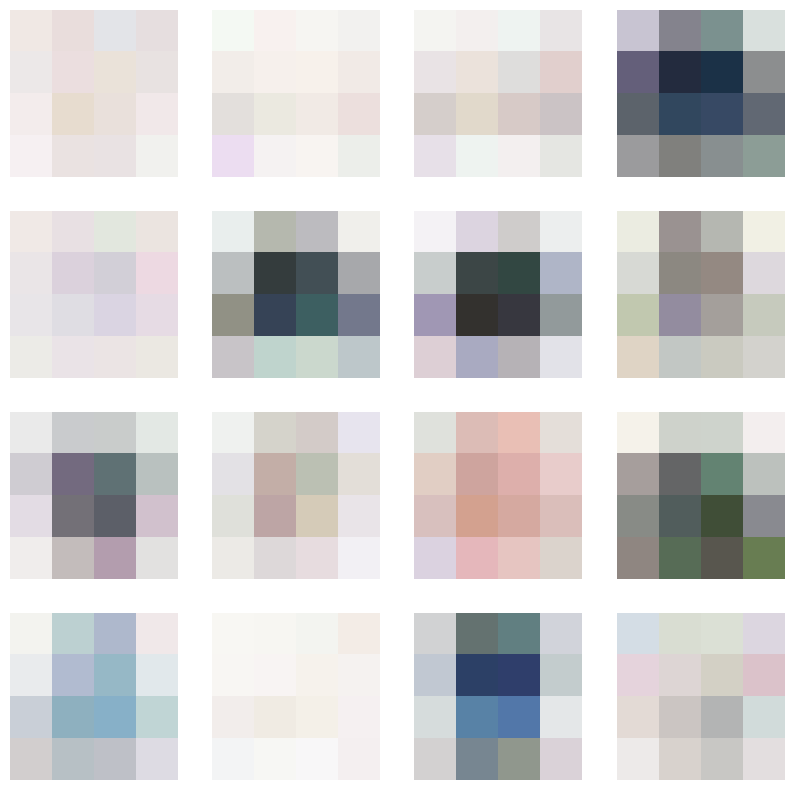

Step: 766
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5151063799858093
Generator loss: 1.096544861793518


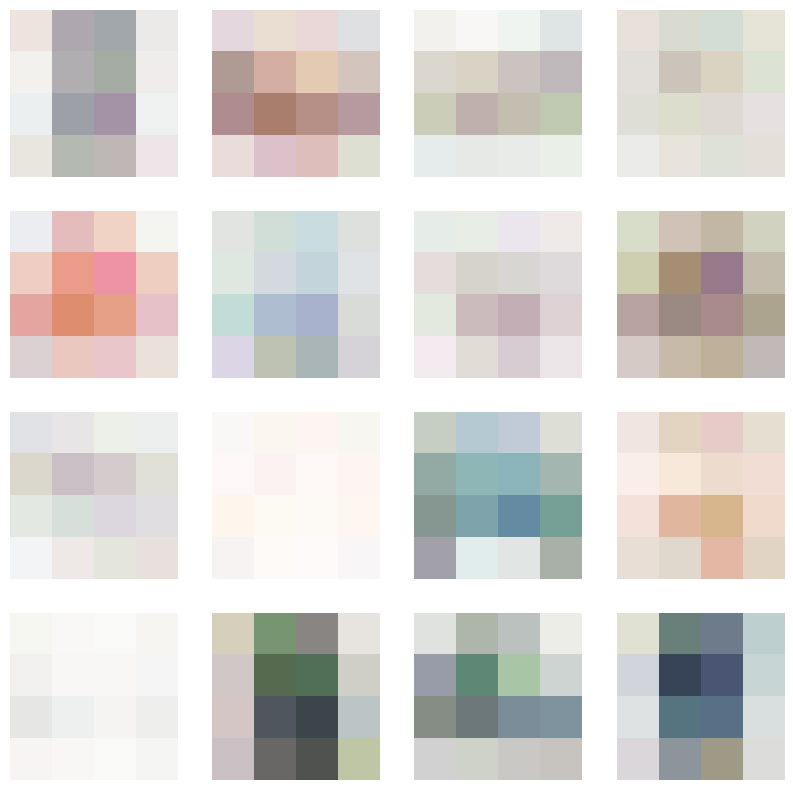

Step: 767
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5145444273948669
Generator loss: 1.0958495140075684


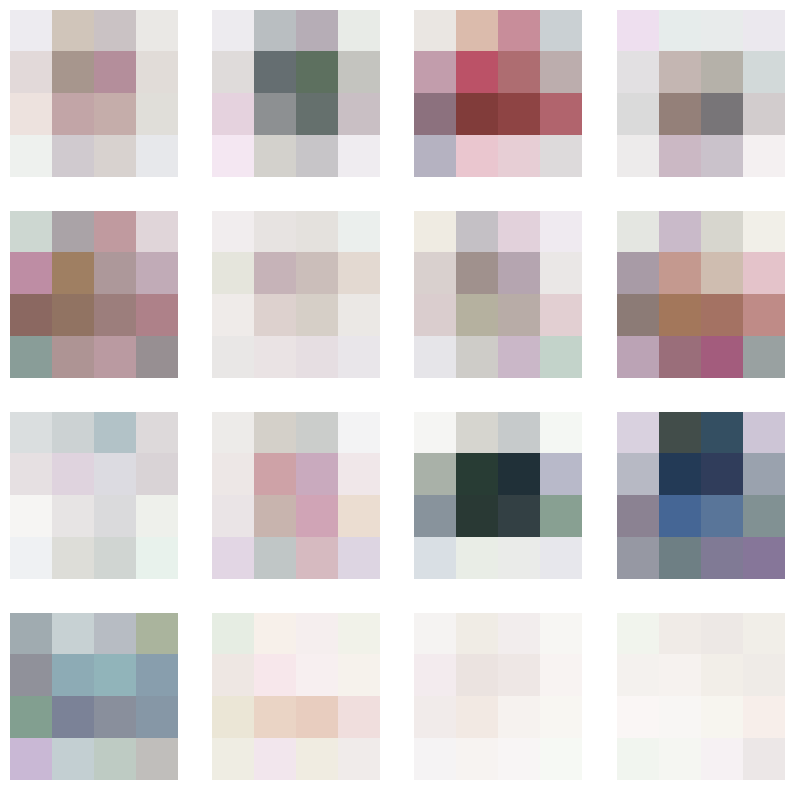

Step: 768
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5141019225120544
Generator loss: 1.0952807664871216


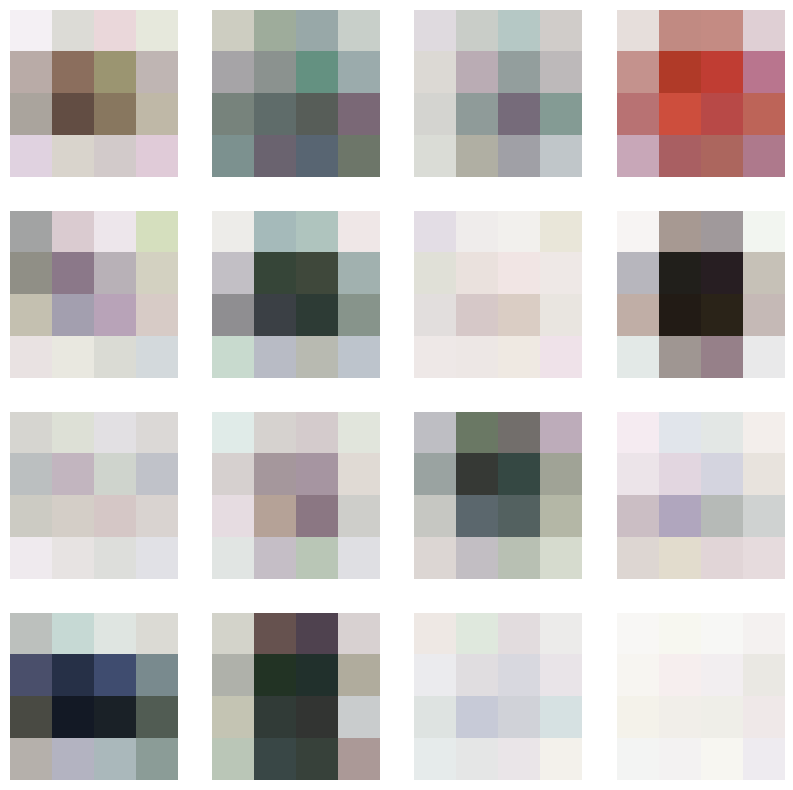

Step: 769
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5135557651519775
Generator loss: 1.0945279598236084


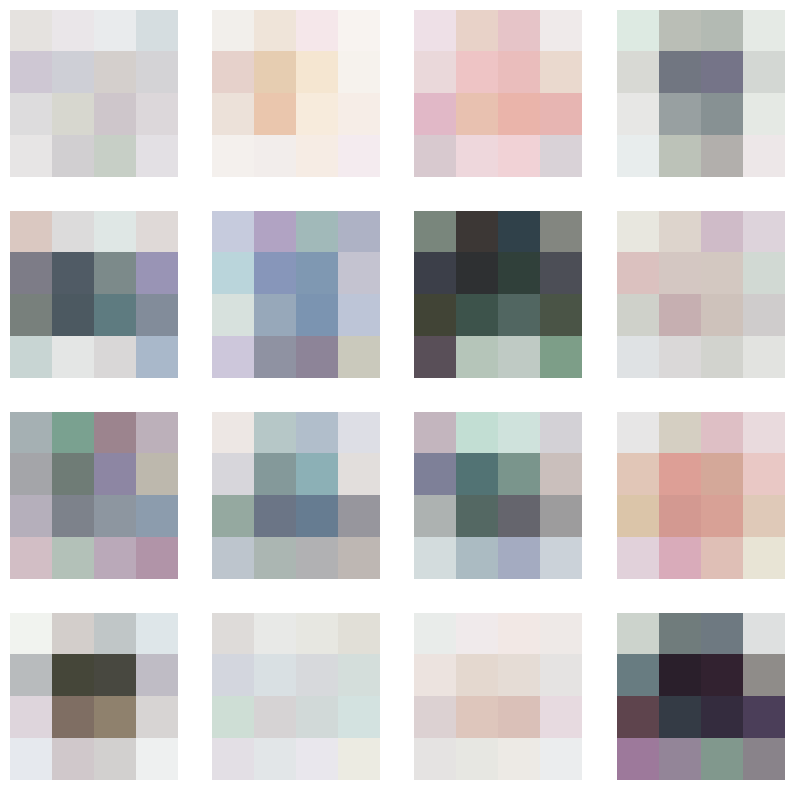

Step: 770
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5128571391105652
Generator loss: 1.09334135055542


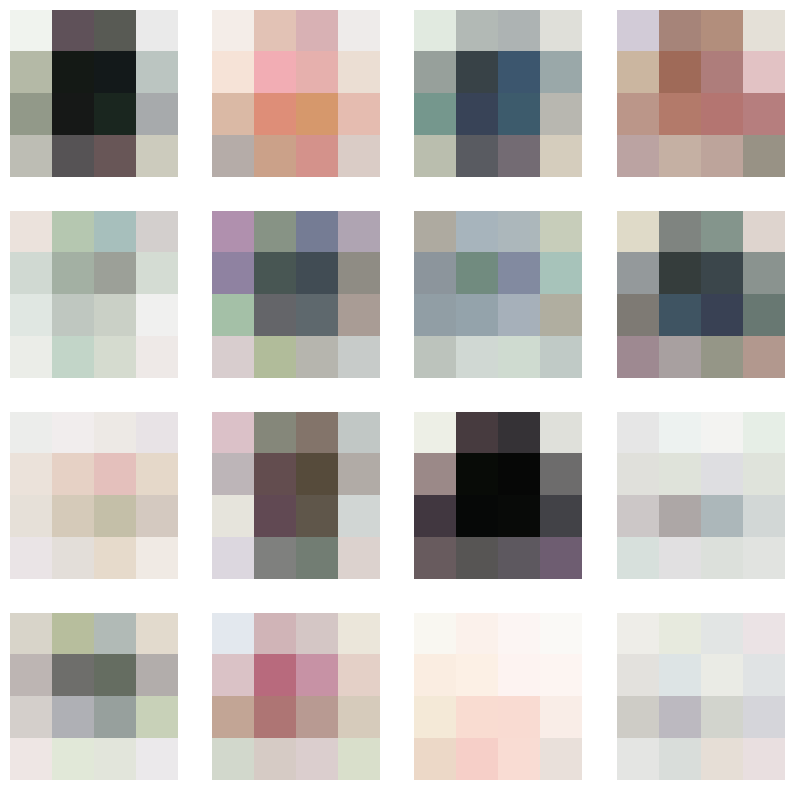

Step: 771
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5123277902603149
Generator loss: 1.0921218395233154


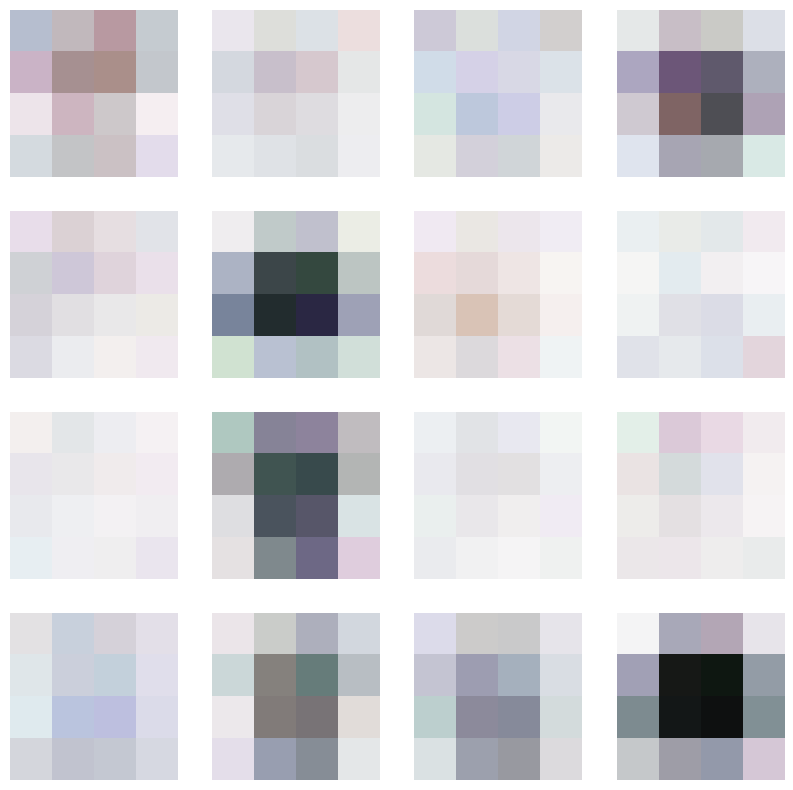

Step: 772
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5117892622947693
Generator loss: 1.090667486190796


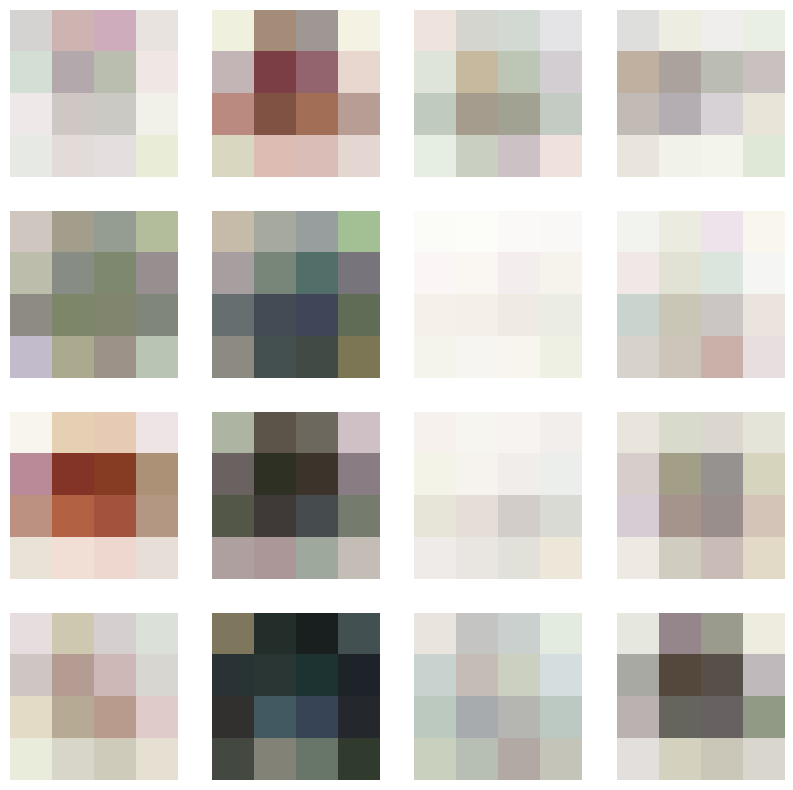

Step: 773
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5111947059631348
Generator loss: 1.0891261100769043


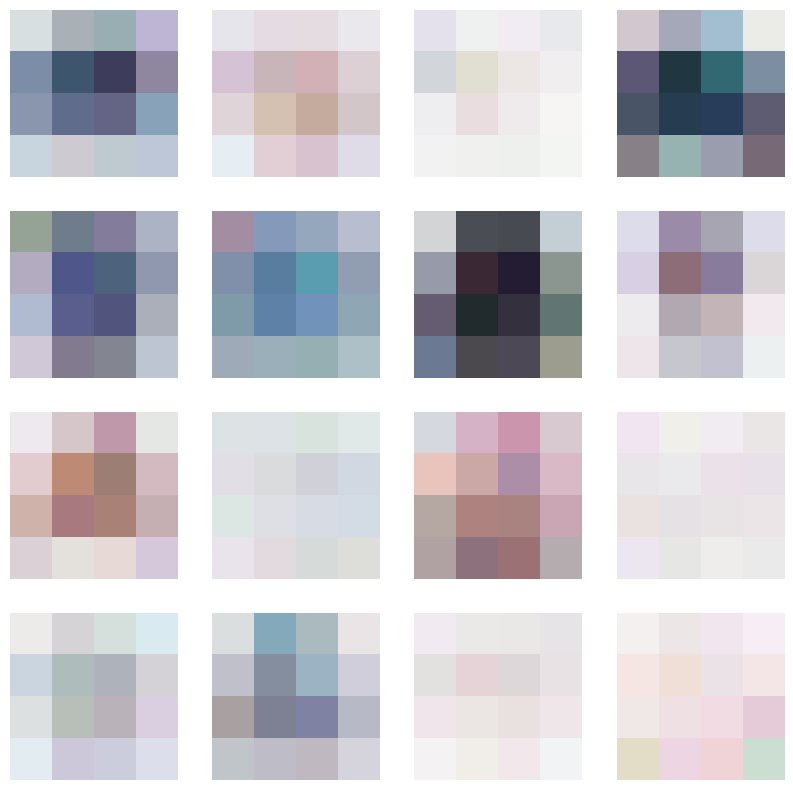

Step: 774
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5108212232589722
Generator loss: 1.0871191024780273


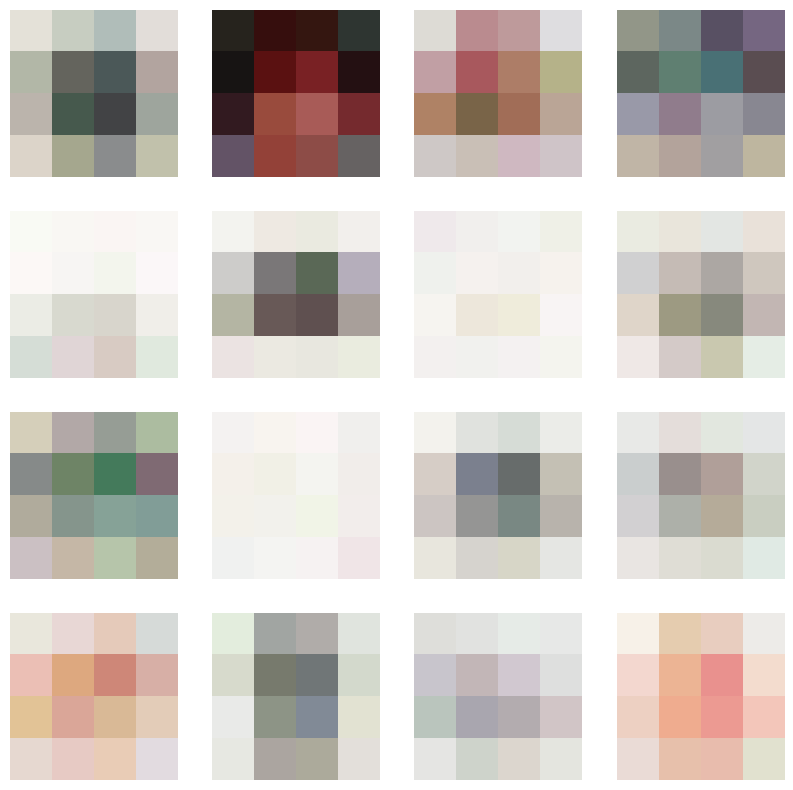

Step: 775
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5102150440216064
Generator loss: 1.0855337381362915


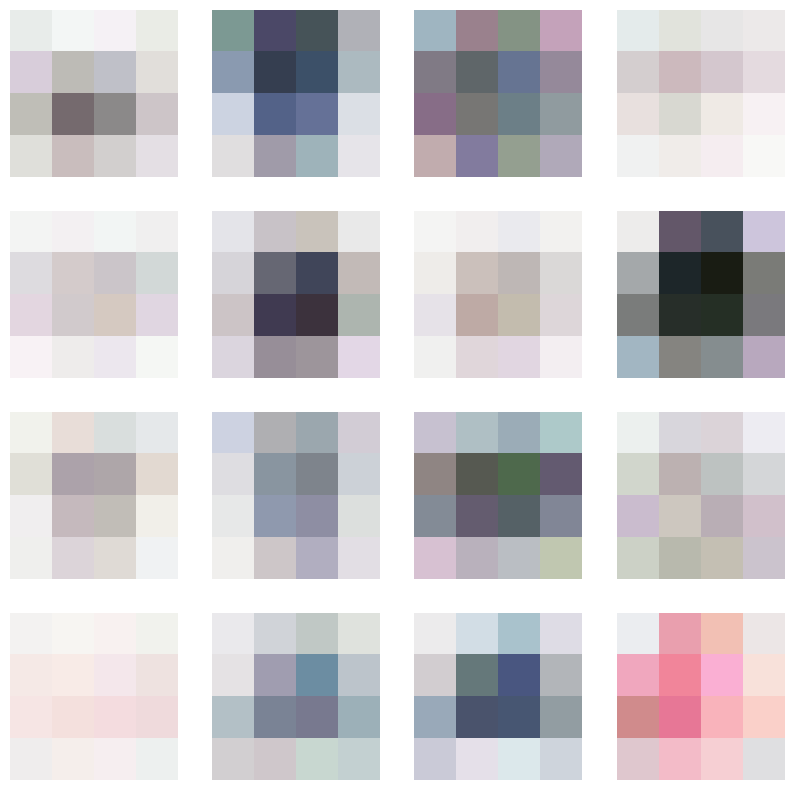

Step: 776
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5095613598823547
Generator loss: 1.0846741199493408


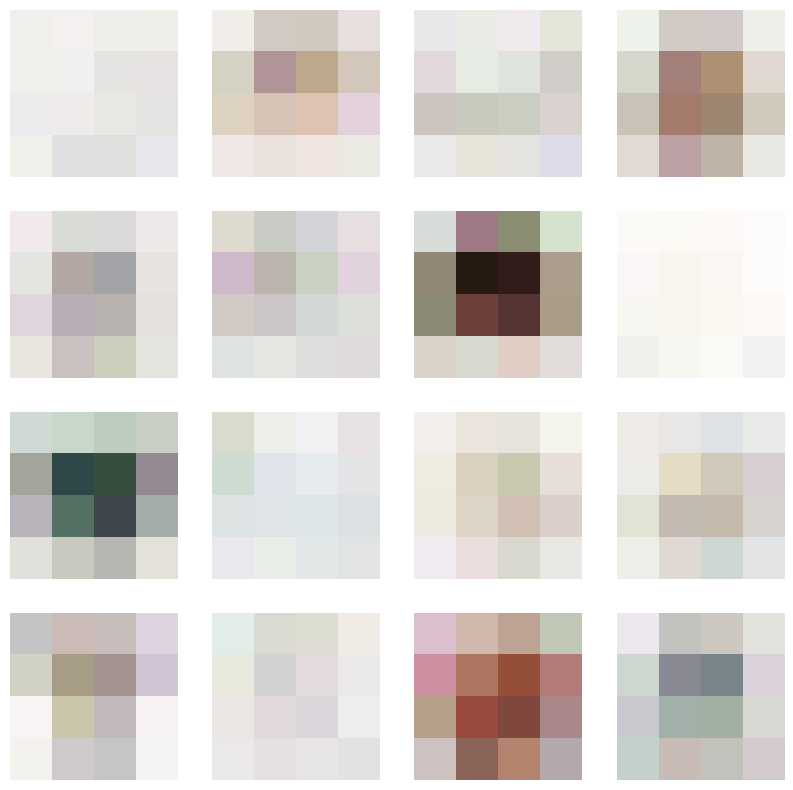

Step: 777
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5091160535812378
Generator loss: 1.0844204425811768


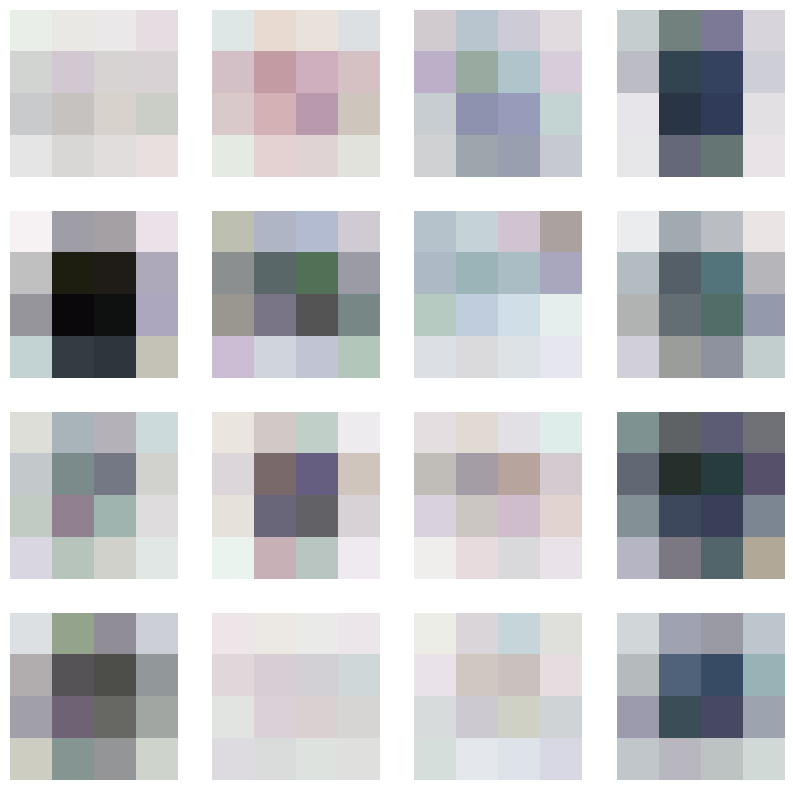

Step: 778
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5084622502326965
Generator loss: 1.0833649635314941


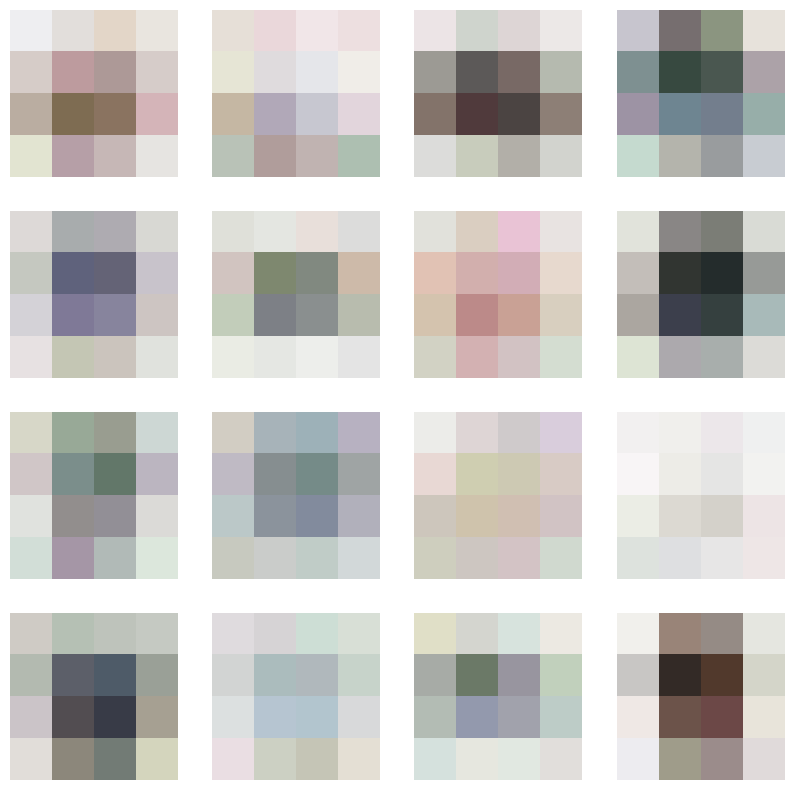

Step: 779
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5079345703125
Generator loss: 1.0822741985321045


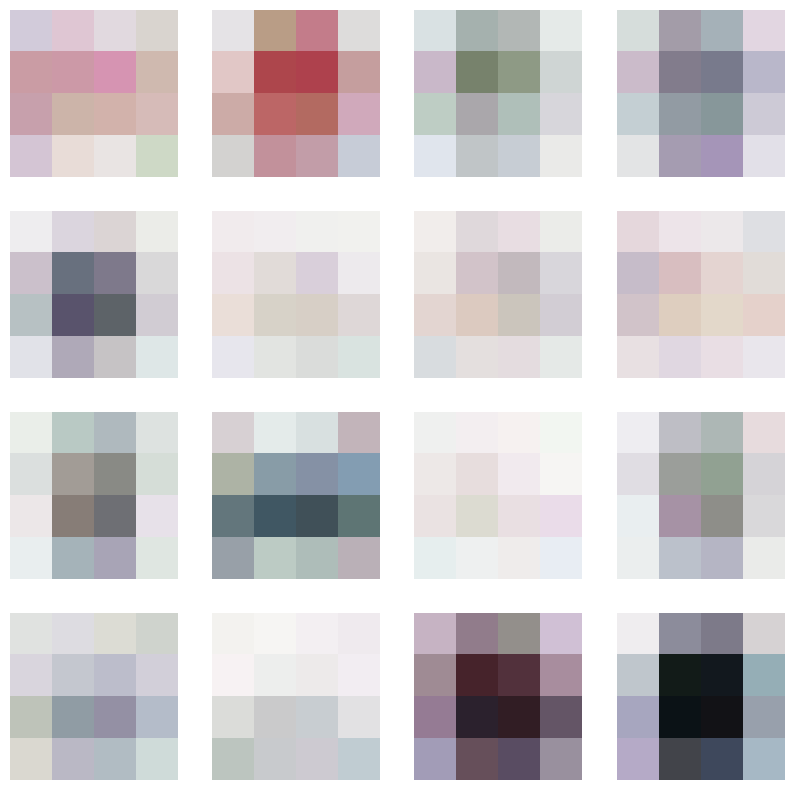

Step: 780
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5074825882911682
Generator loss: 1.0808677673339844


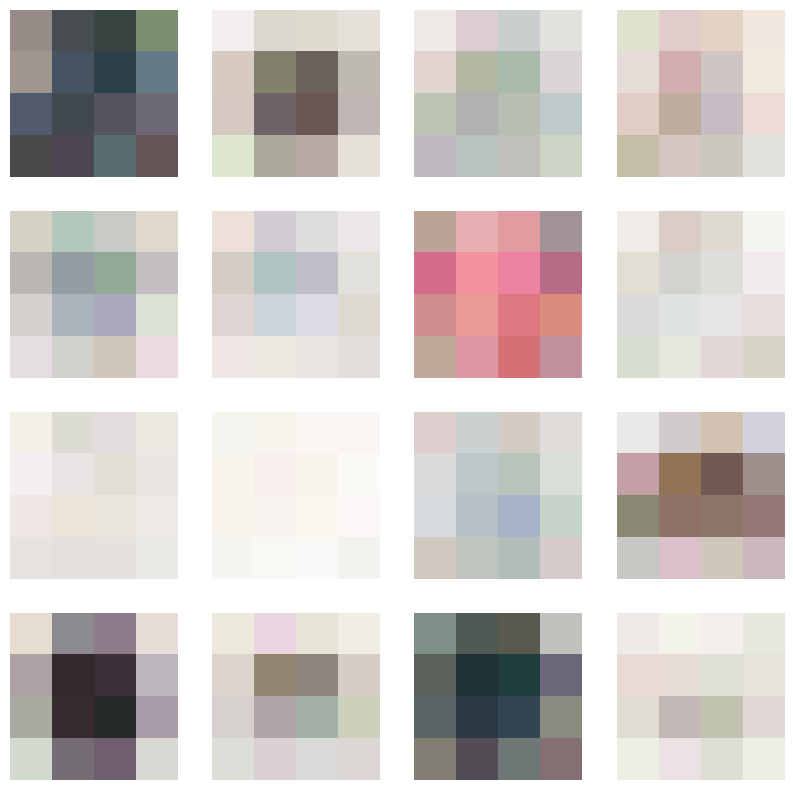

Step: 781
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5069945454597473
Generator loss: 1.0794981718063354


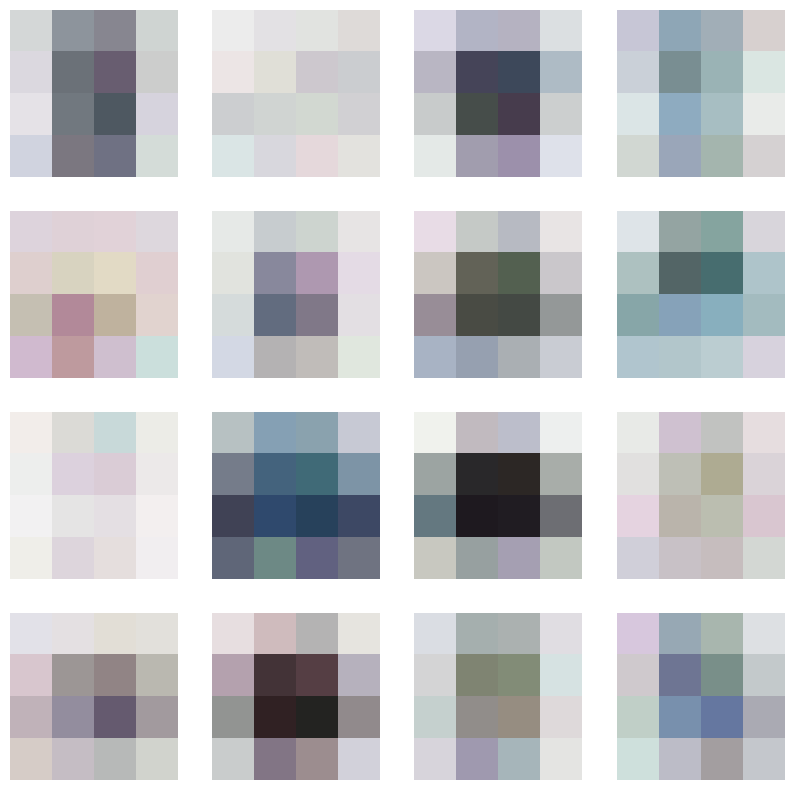

Step: 782
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5065550208091736
Generator loss: 1.0778465270996094


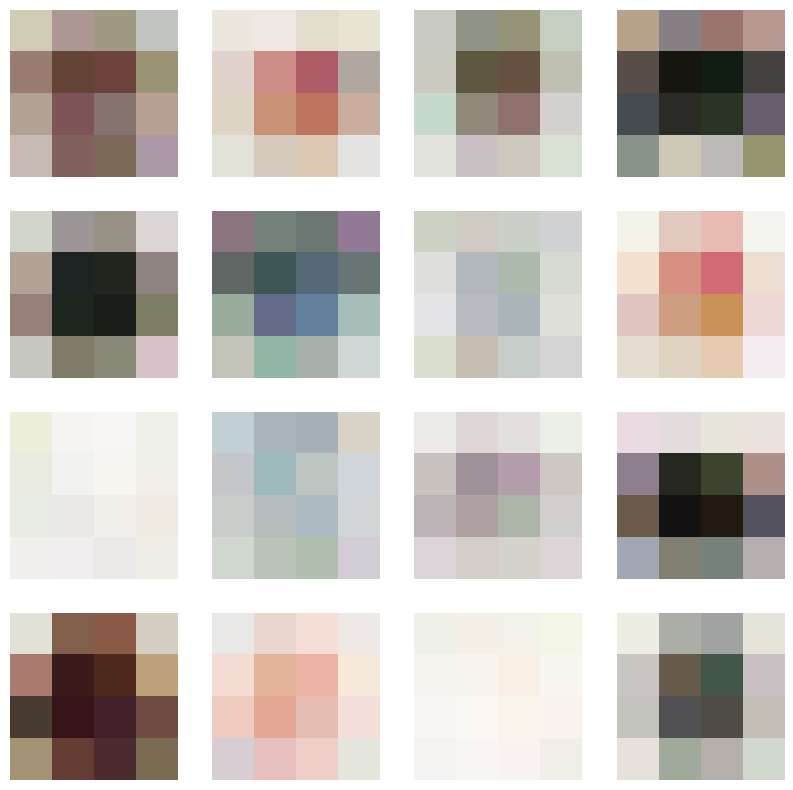

Step: 783
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5061324238777161
Generator loss: 1.0764821767807007


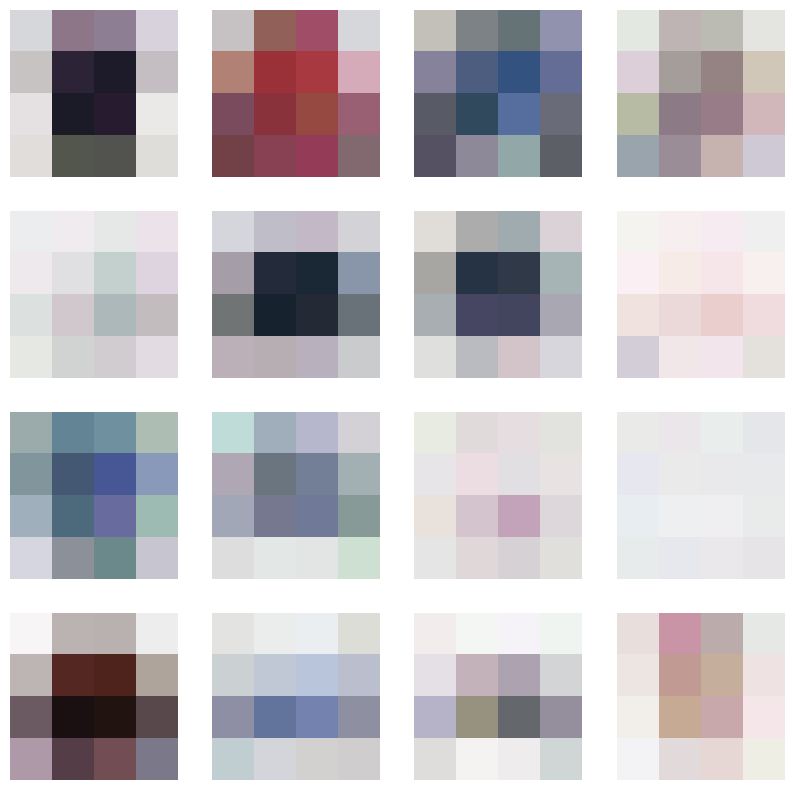

Step: 784
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5056111812591553
Generator loss: 1.0747008323669434


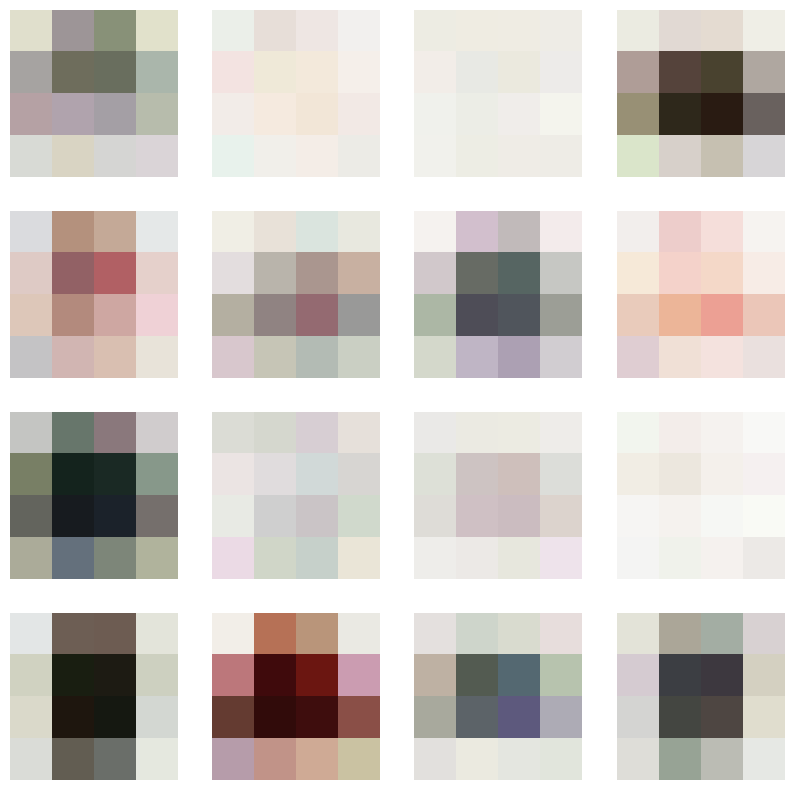

Step: 785
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5052056312561035
Generator loss: 1.0726455450057983


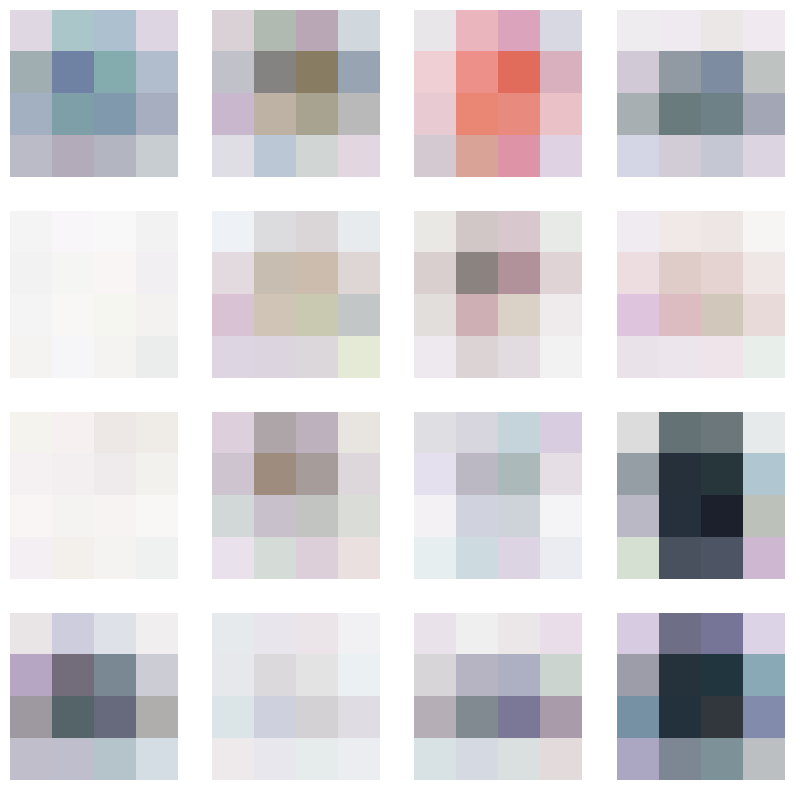

Step: 786
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5046485662460327
Generator loss: 1.0707718133926392


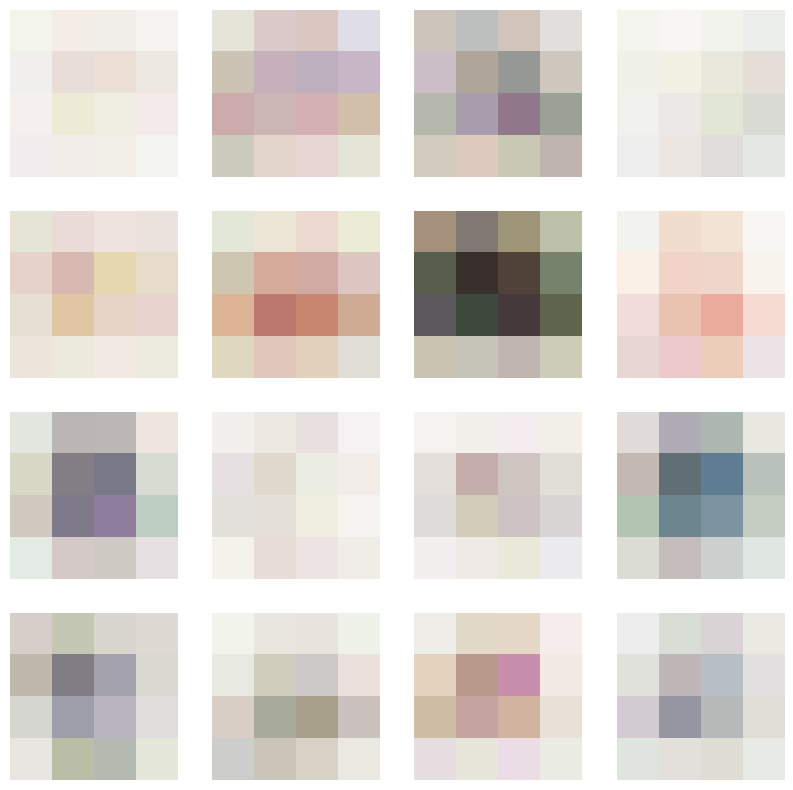

Step: 787
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5039536952972412
Generator loss: 1.0702203512191772


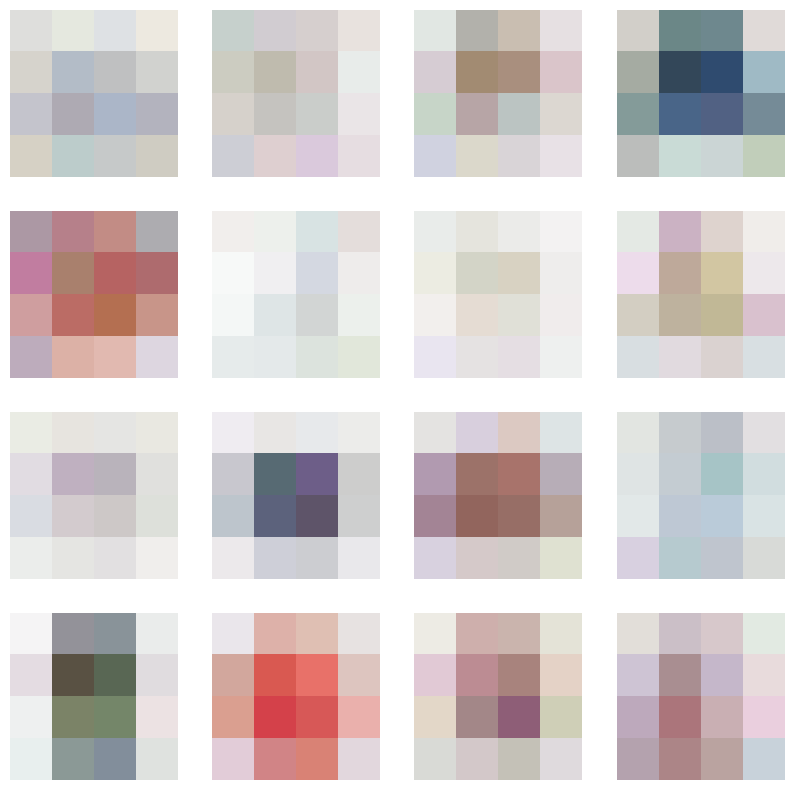

Step: 788
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5036322474479675
Generator loss: 1.0704220533370972


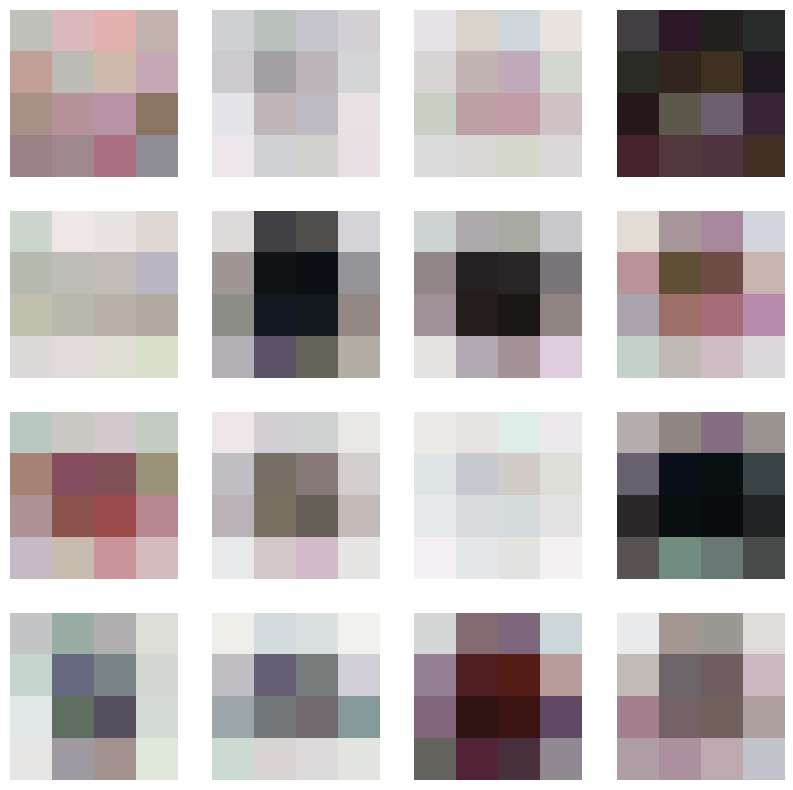

Step: 789
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5029504895210266
Generator loss: 1.0696548223495483


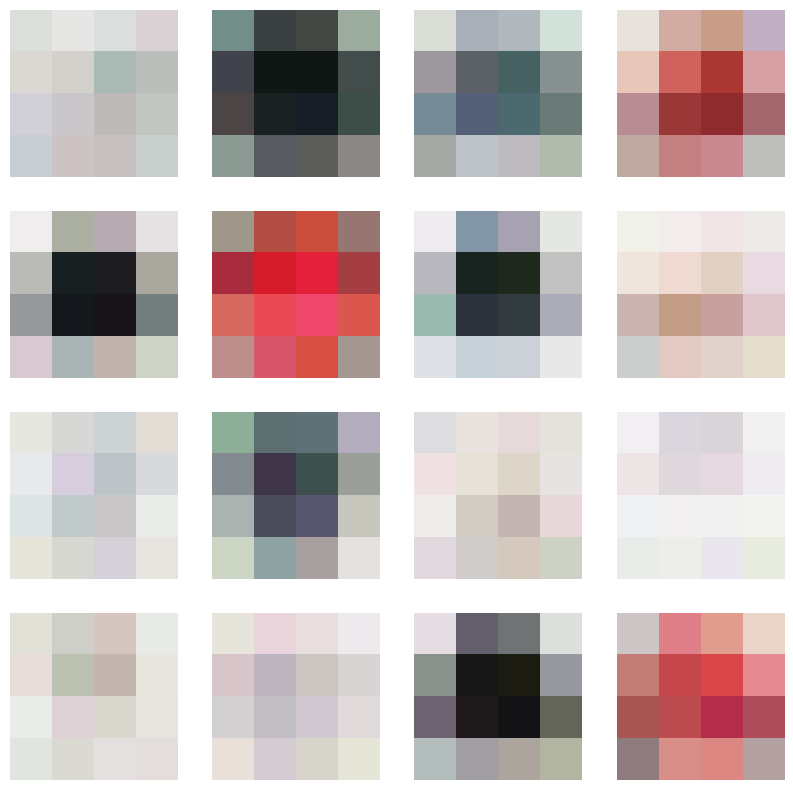

Step: 790
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5023383498191833
Generator loss: 1.0688220262527466


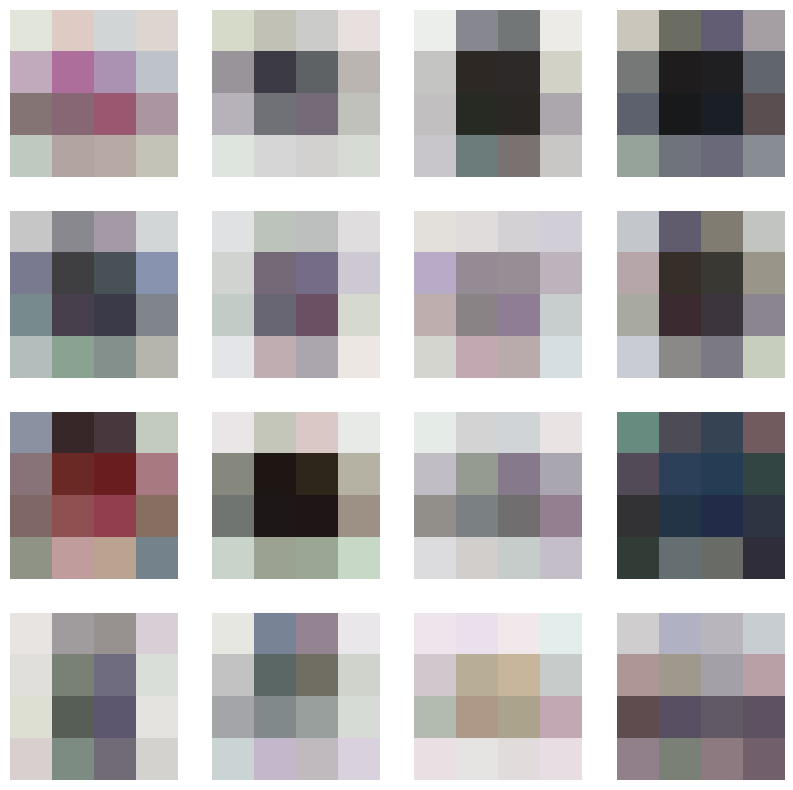

Step: 791
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5016973614692688
Generator loss: 1.067543625831604


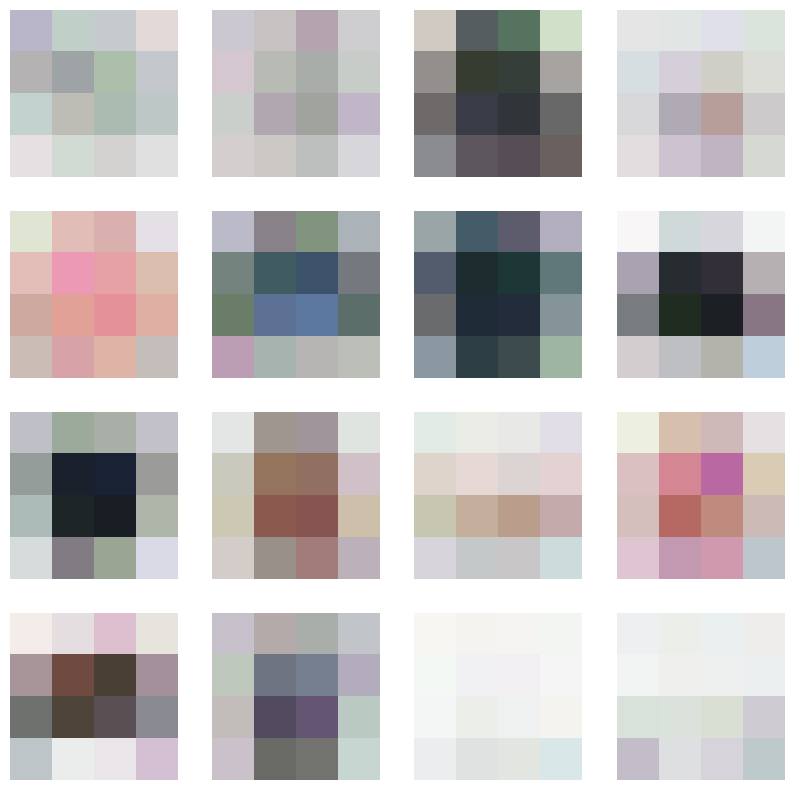

Step: 792
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5011815428733826
Generator loss: 1.0659395456314087


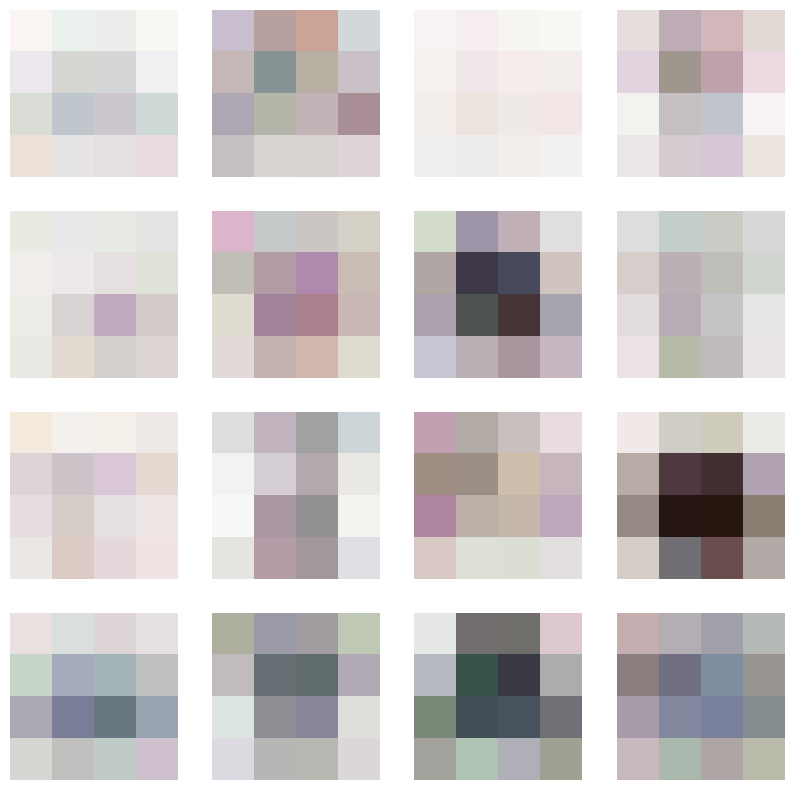

Step: 793
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5007405877113342
Generator loss: 1.0642223358154297


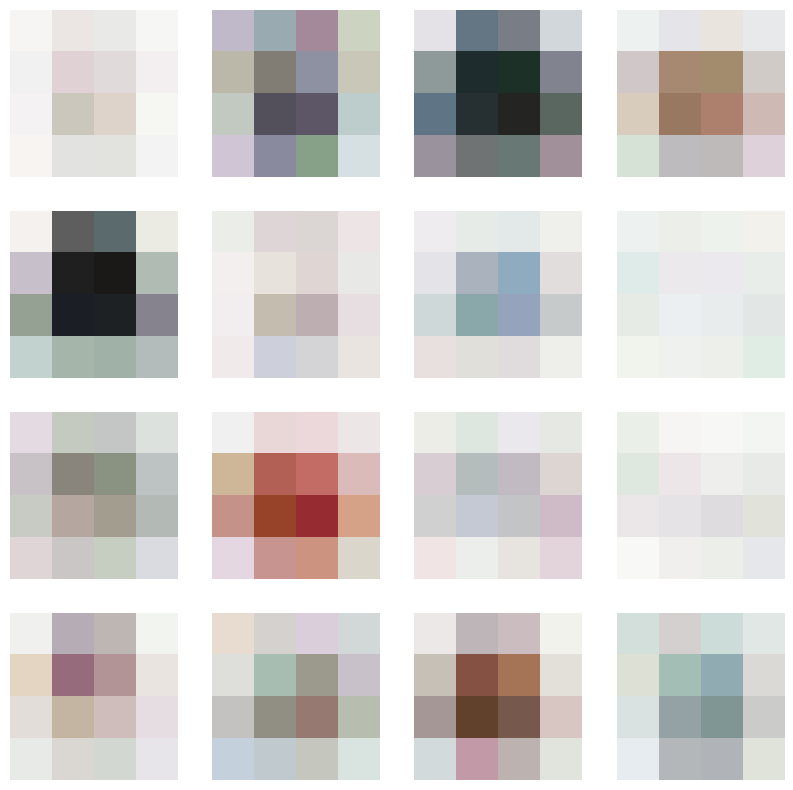

Step: 794
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.5000743865966797
Generator loss: 1.0628917217254639


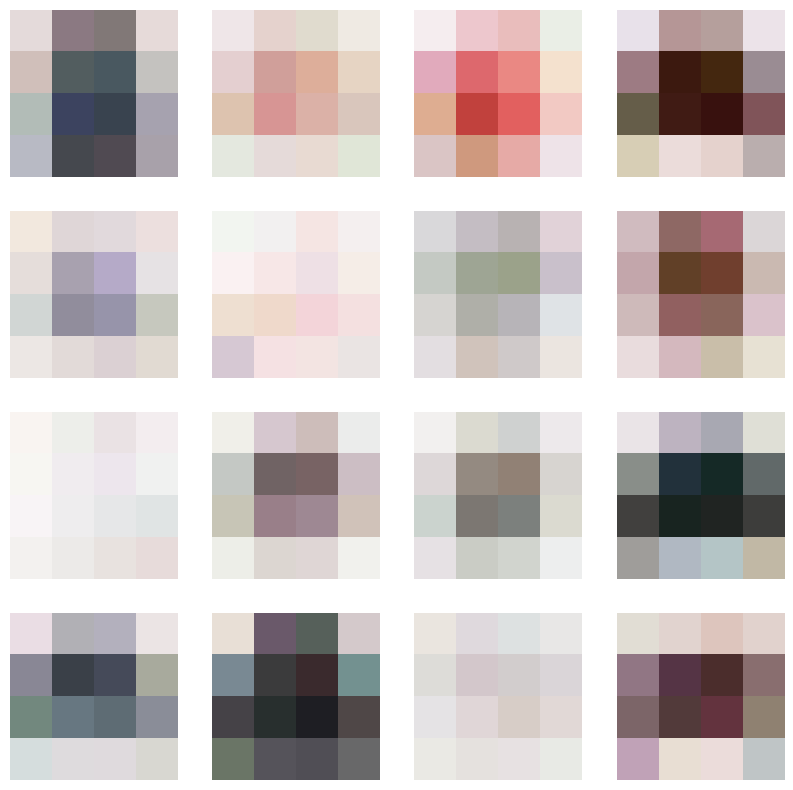

Step: 795
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4995634853839874
Generator loss: 1.0617847442626953


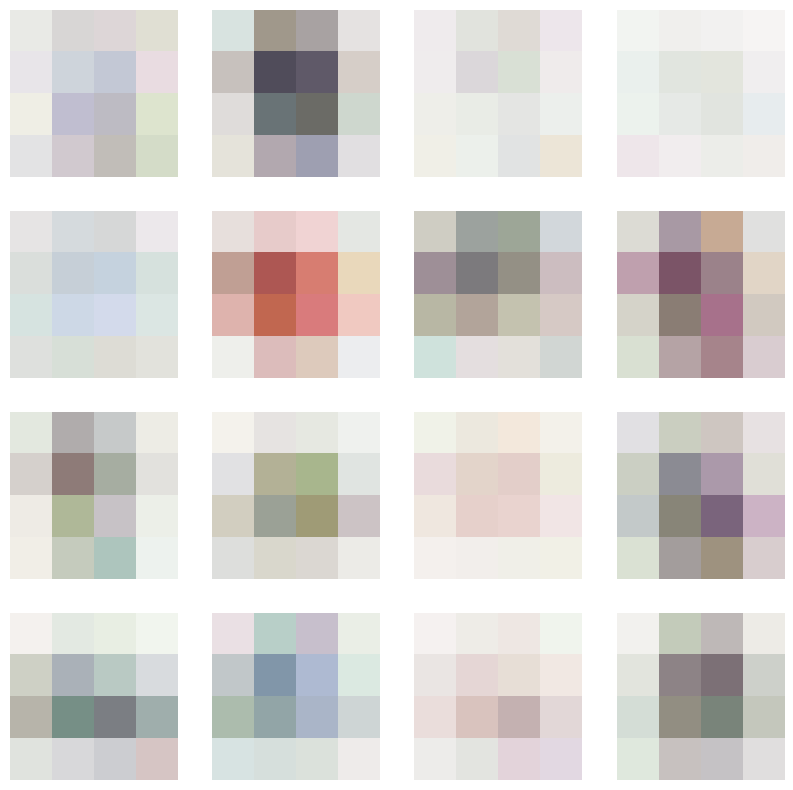

Step: 796
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4990055561065674
Generator loss: 1.0616974830627441


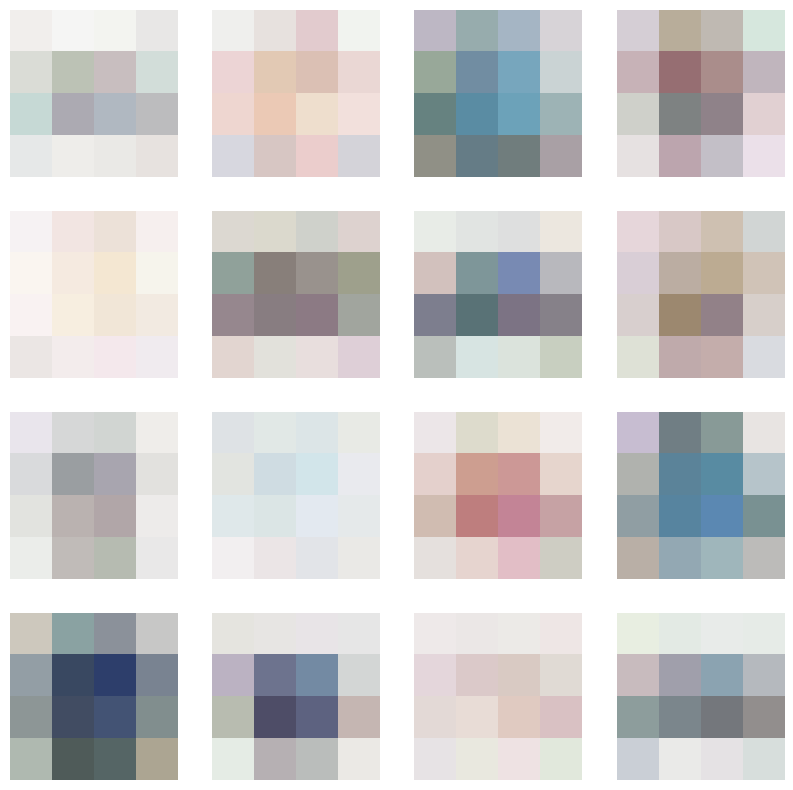

Step: 797
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4985843300819397
Generator loss: 1.0615811347961426


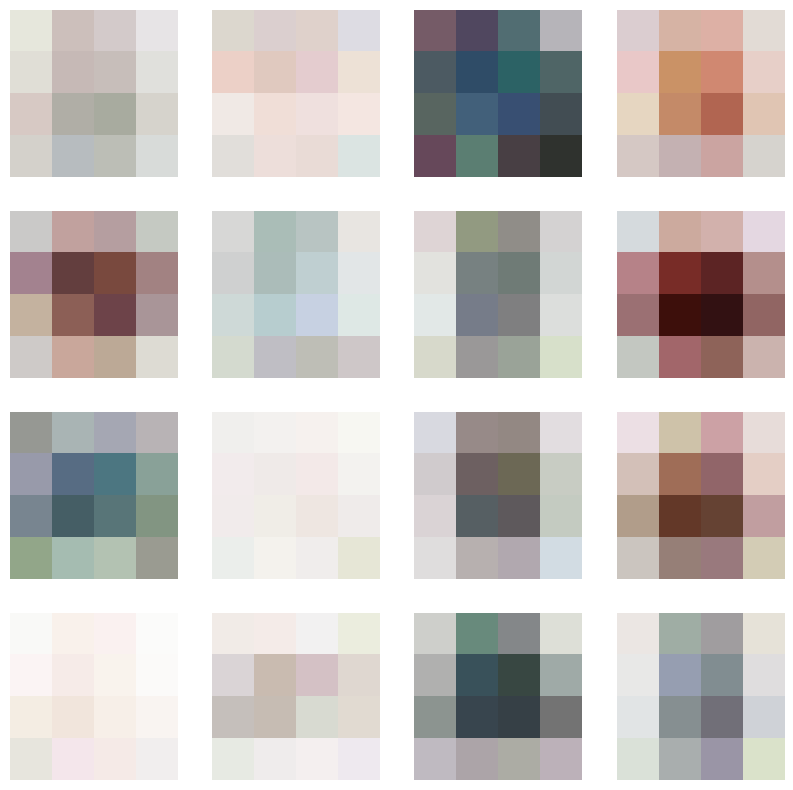

Step: 798
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.49813559651374817
Generator loss: 1.0613489151000977


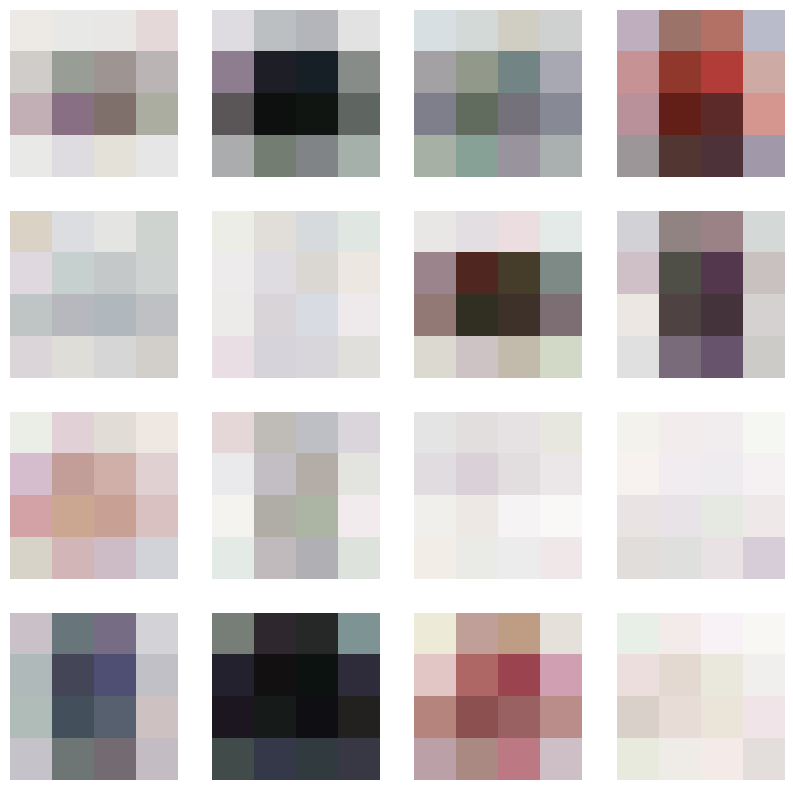

Step: 799
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4975365400314331
Generator loss: 1.060441493988037


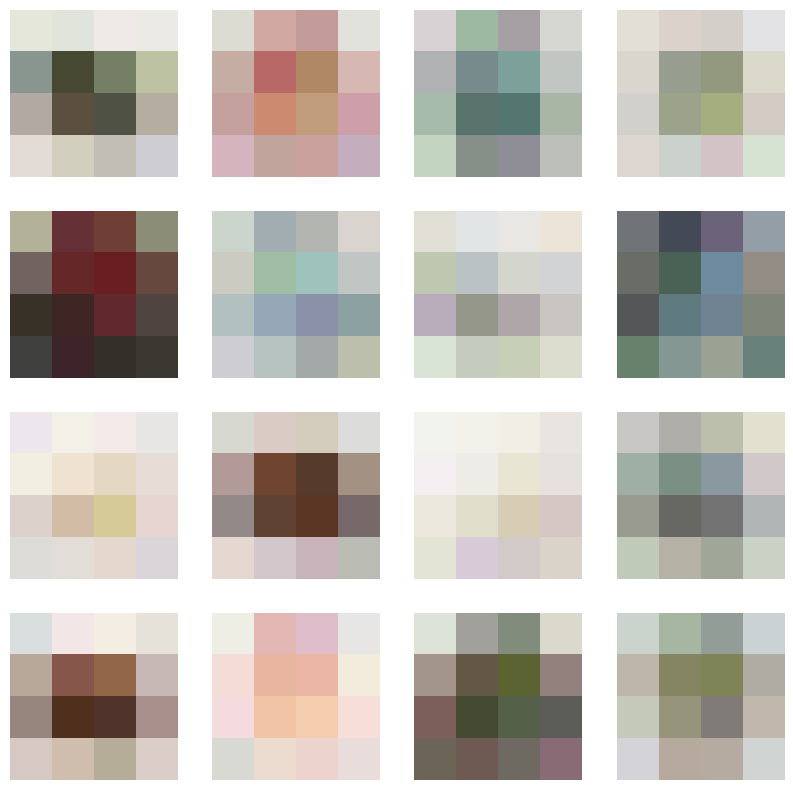

Step: 800
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.49701693654060364
Generator loss: 1.0591635704040527


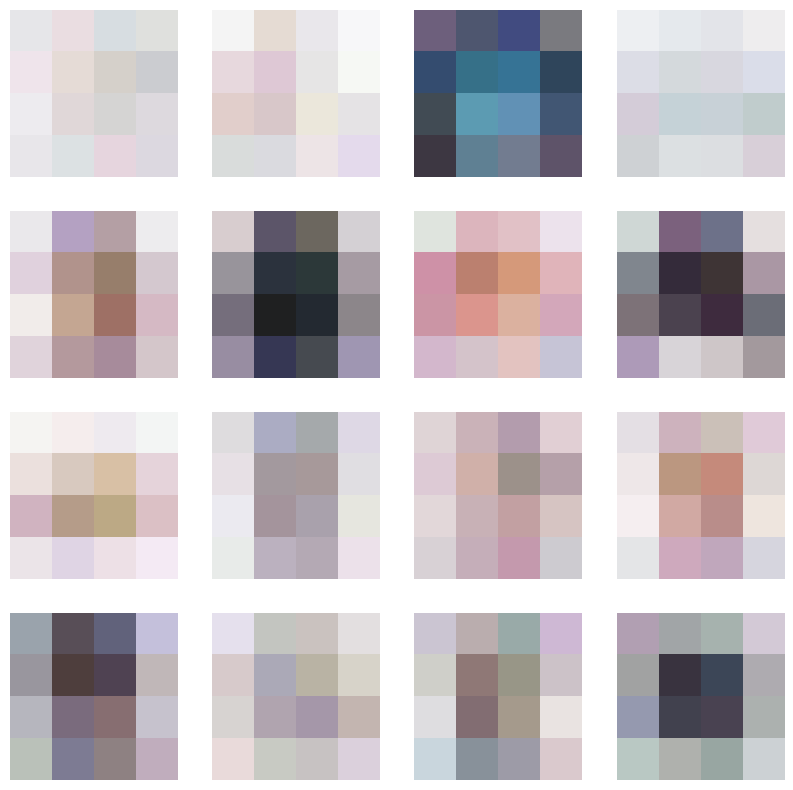

Step: 801
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4966035783290863
Generator loss: 1.0576571226119995


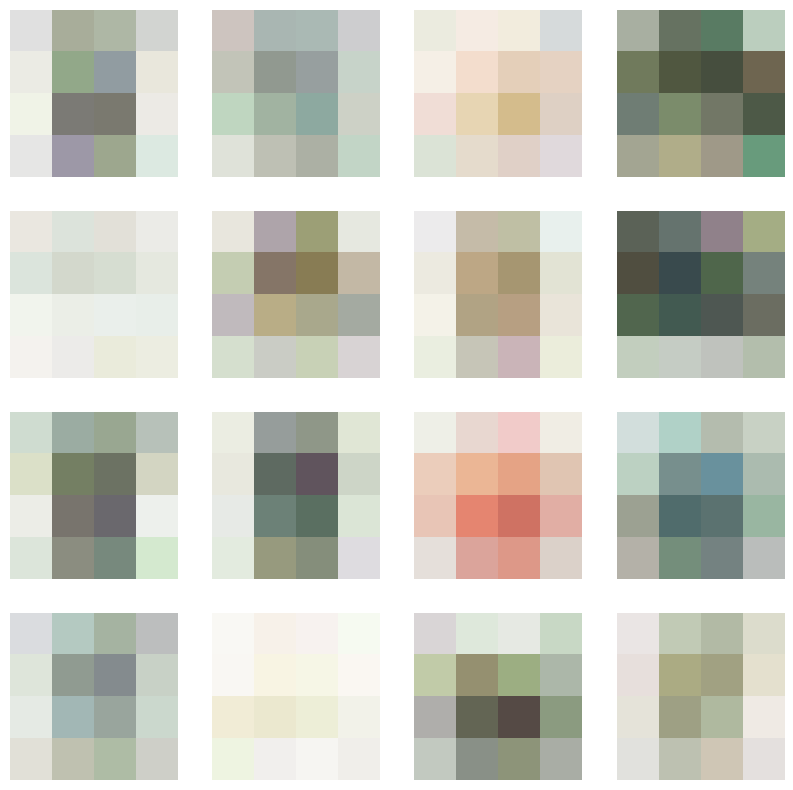

Step: 802
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.49614840745925903
Generator loss: 1.055997610092163


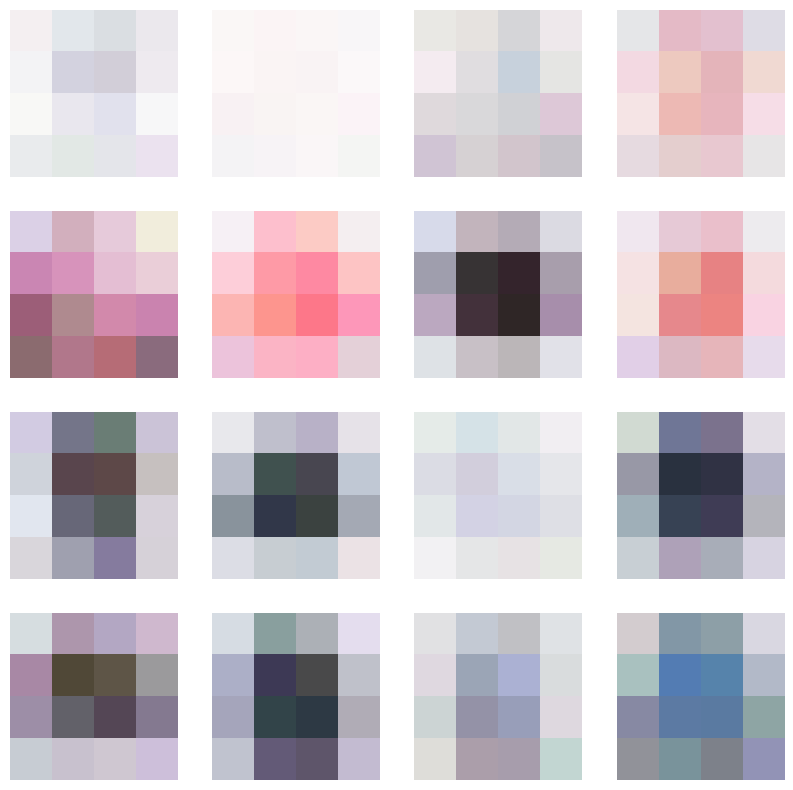

Step: 803
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4956679046154022
Generator loss: 1.0546354055404663


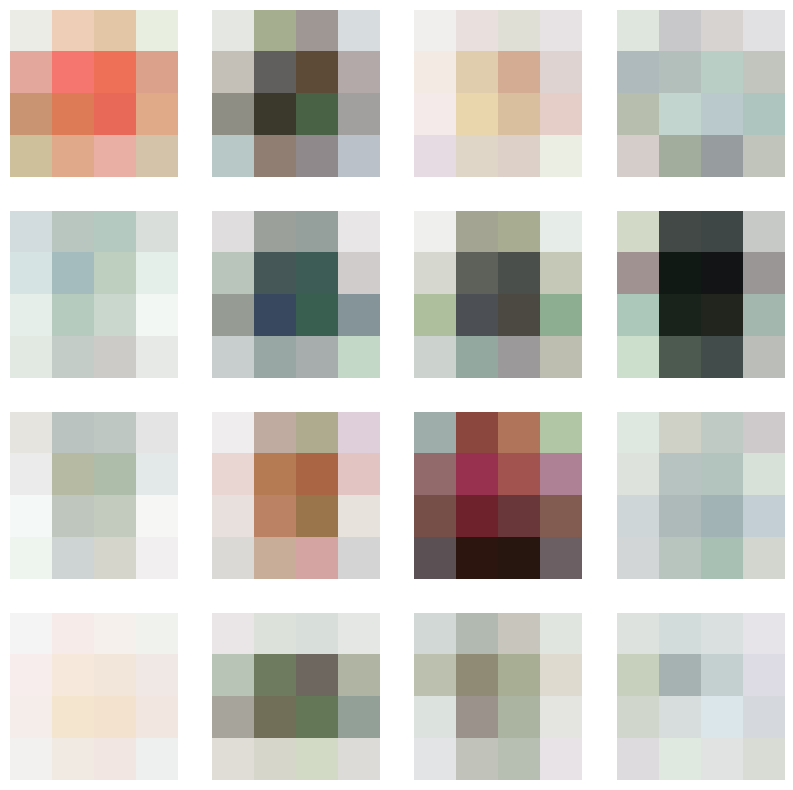

Step: 804
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4952619969844818
Generator loss: 1.0532053709030151


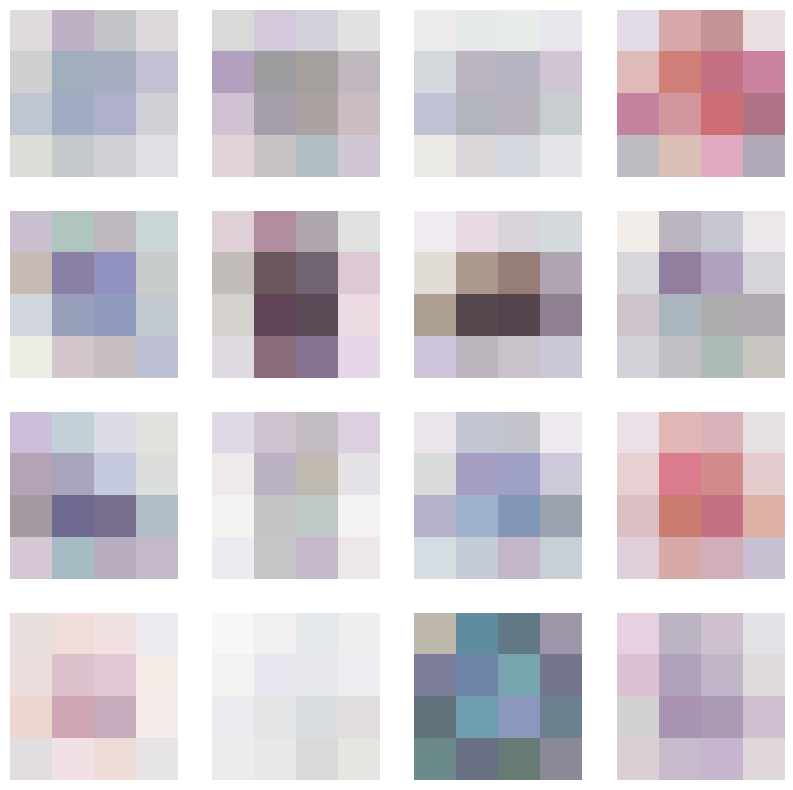

Step: 805
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.49484729766845703
Generator loss: 1.0521953105926514


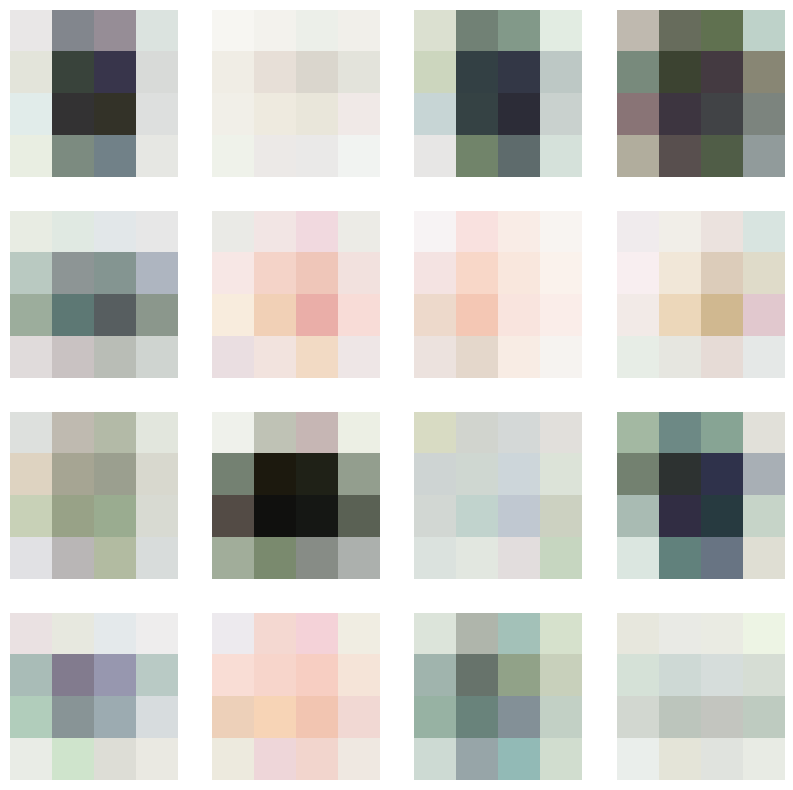

Step: 806
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4942741096019745
Generator loss: 1.0507571697235107


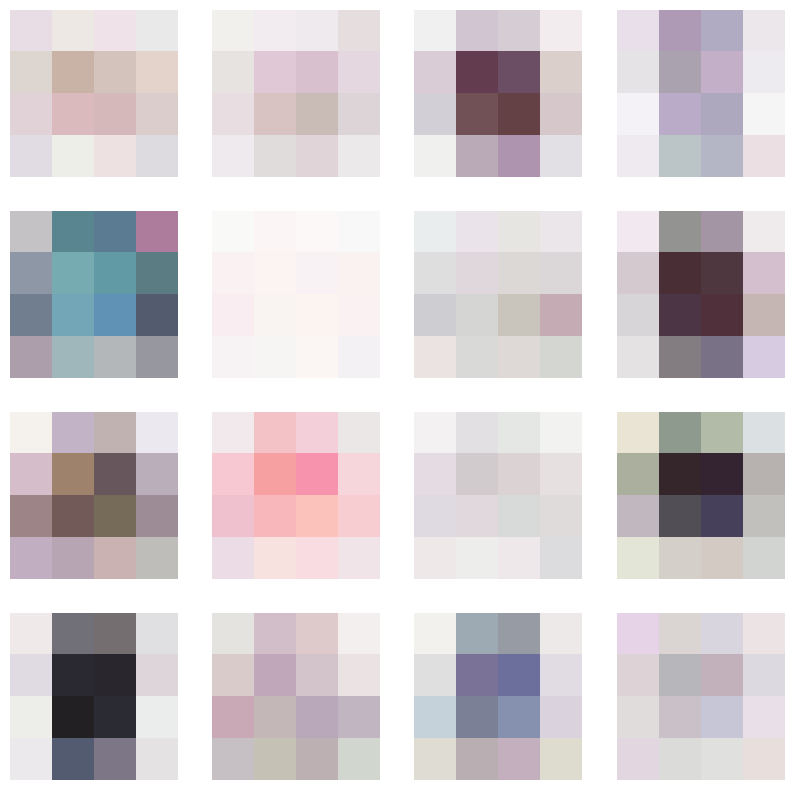

Step: 807
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4936929941177368
Generator loss: 1.0493634939193726


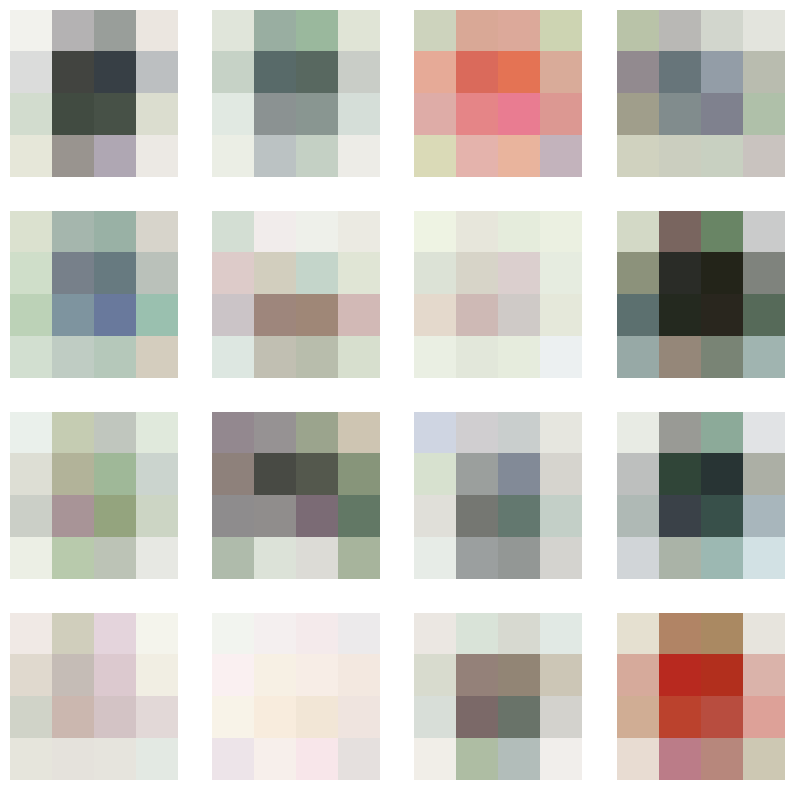

Step: 808
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4932084381580353
Generator loss: 1.0484004020690918


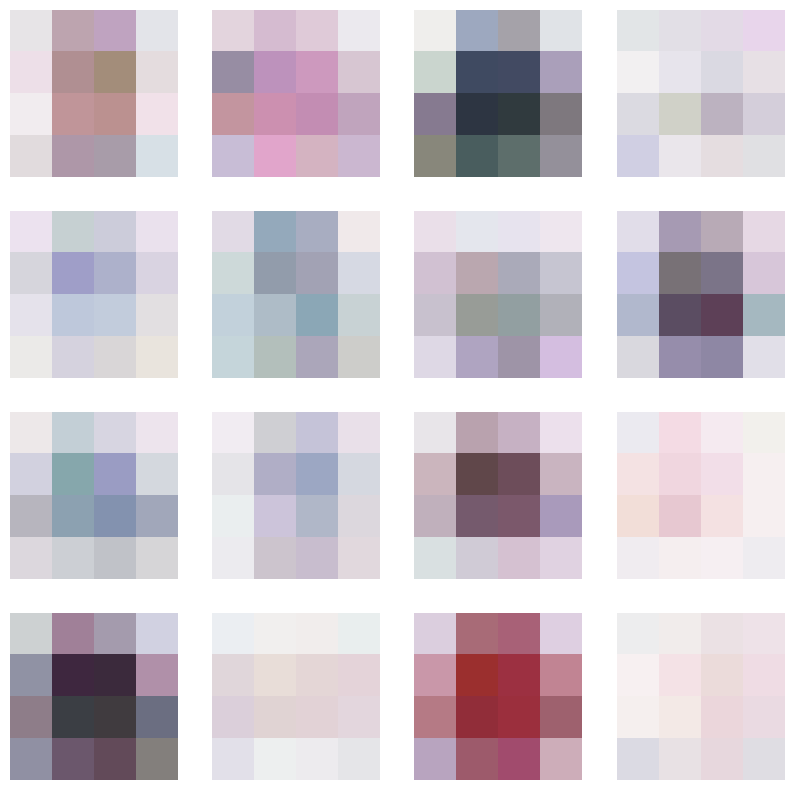

Step: 809
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4927673041820526
Generator loss: 1.047135591506958


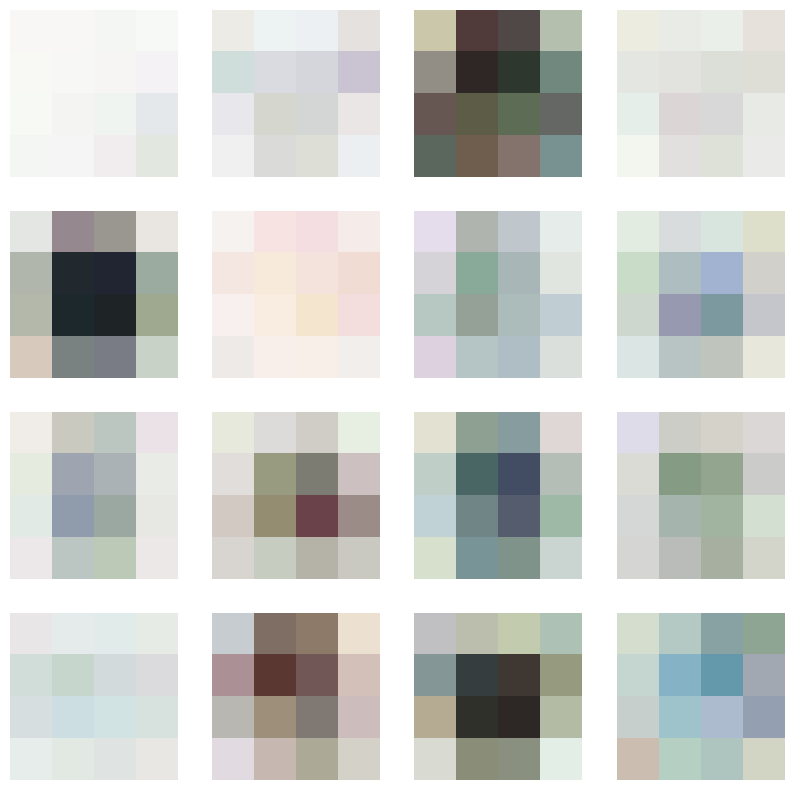

Step: 810
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.492271363735199
Generator loss: 1.0458393096923828


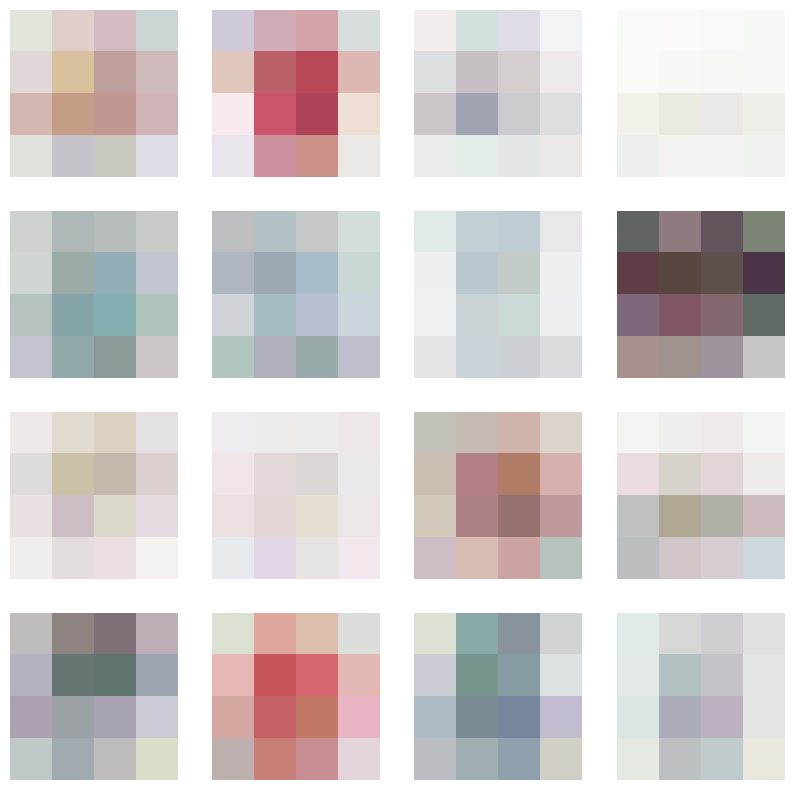

Step: 811
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4917713701725006
Generator loss: 1.0448205471038818


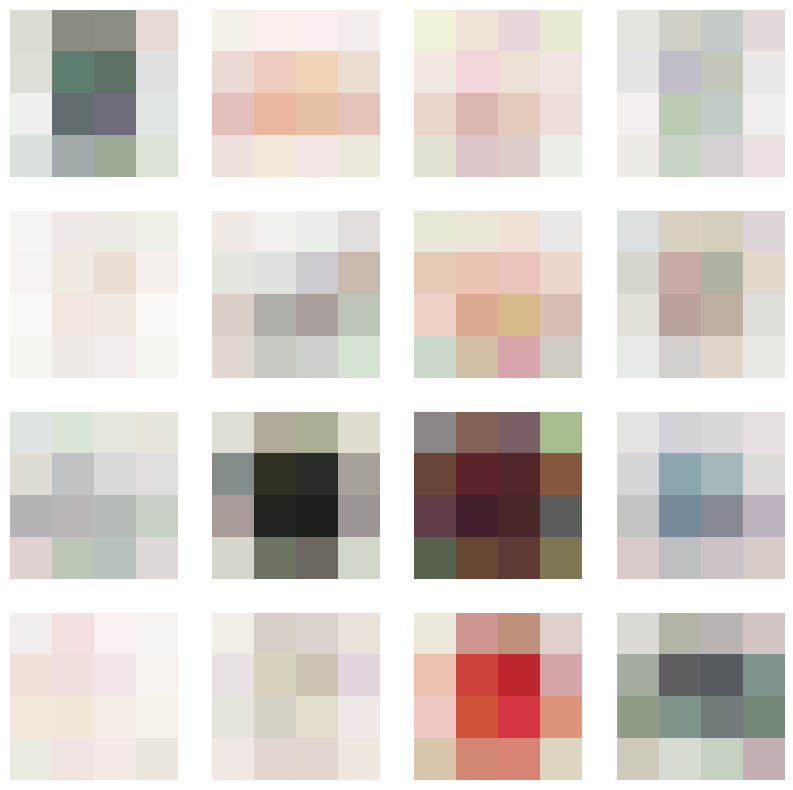

Step: 812
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.49123480916023254
Generator loss: 1.0438437461853027


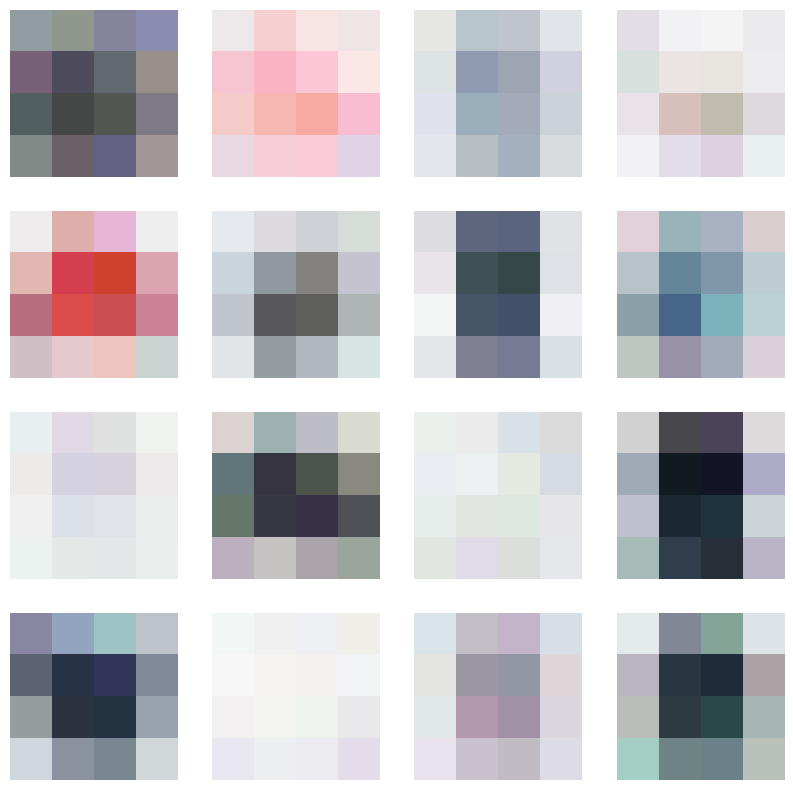

Step: 813
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4908198416233063
Generator loss: 1.0433107614517212


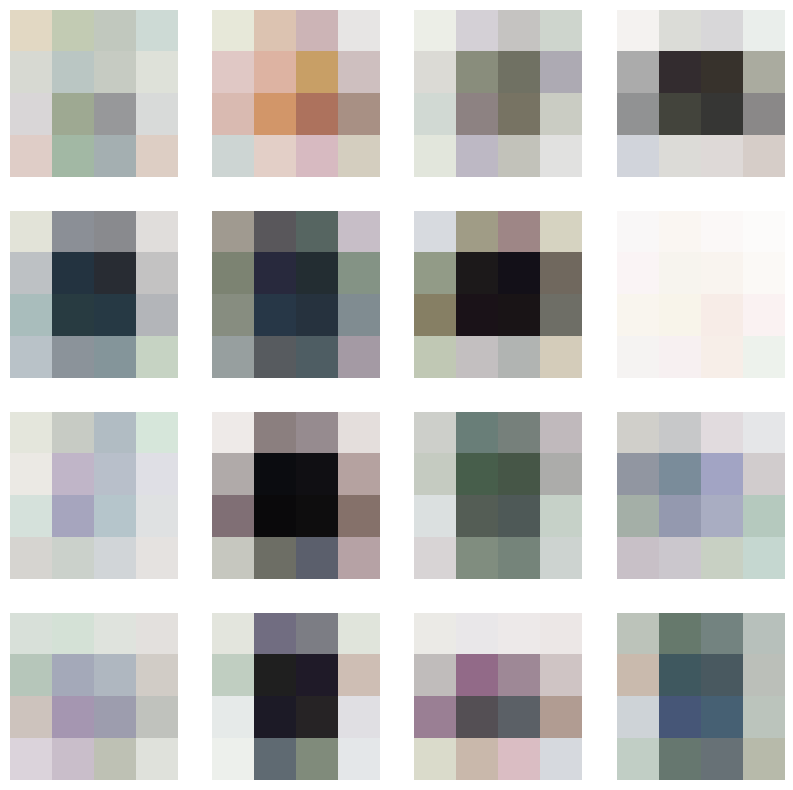

Step: 814
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4903299808502197
Generator loss: 1.042744517326355


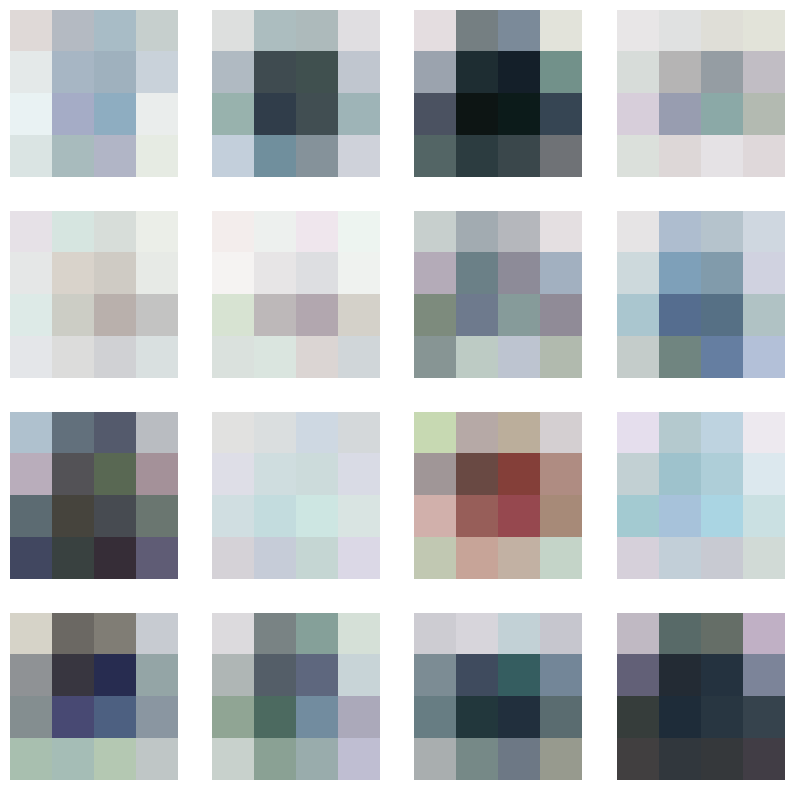

Step: 815
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4896935224533081
Generator loss: 1.0415737628936768


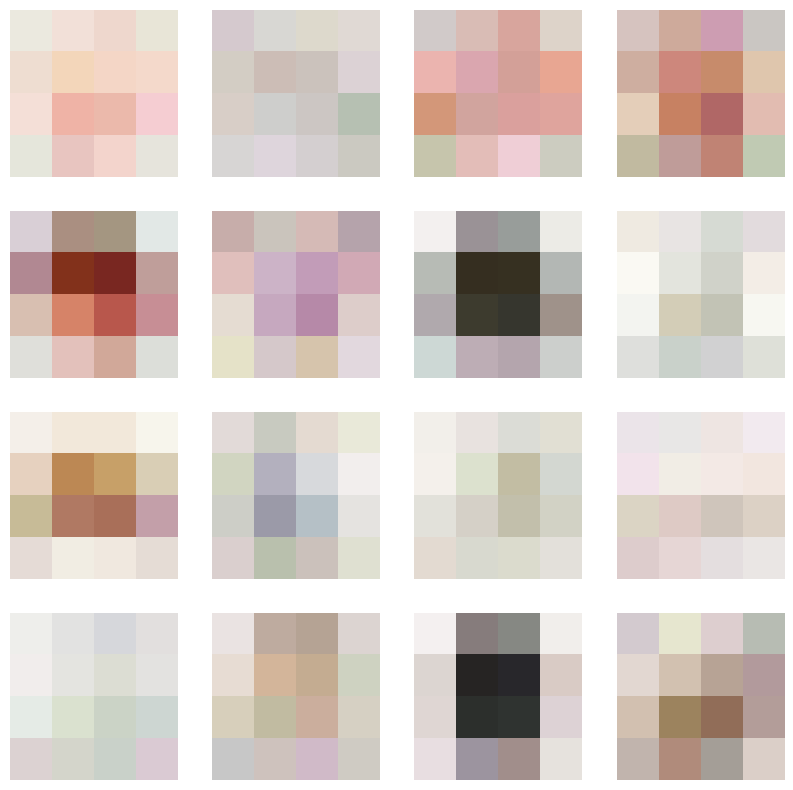

Step: 816
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4892426133155823
Generator loss: 1.0401220321655273


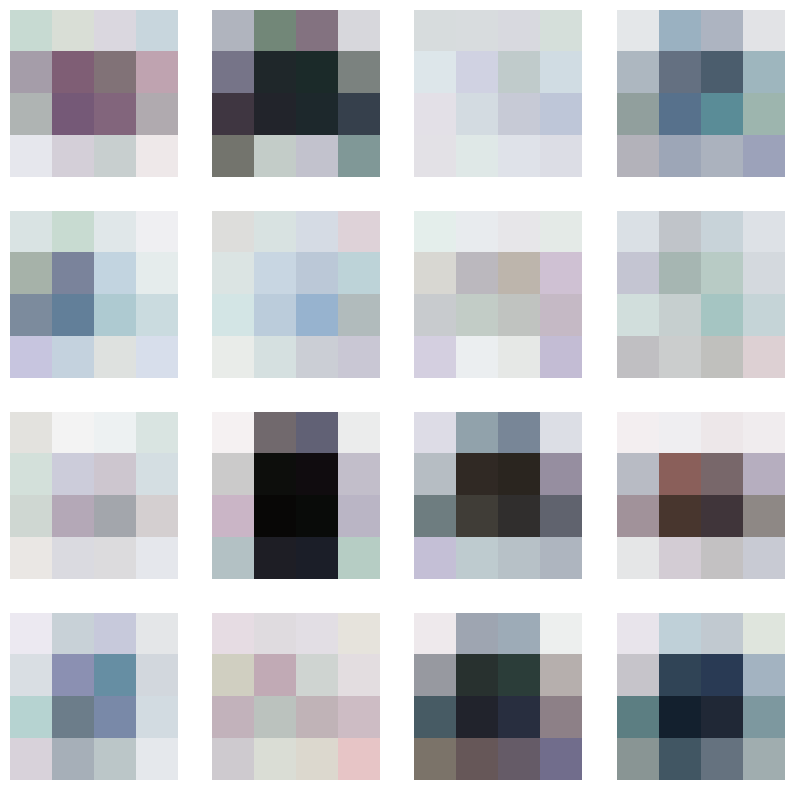

Step: 817
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.488833487033844
Generator loss: 1.0385687351226807


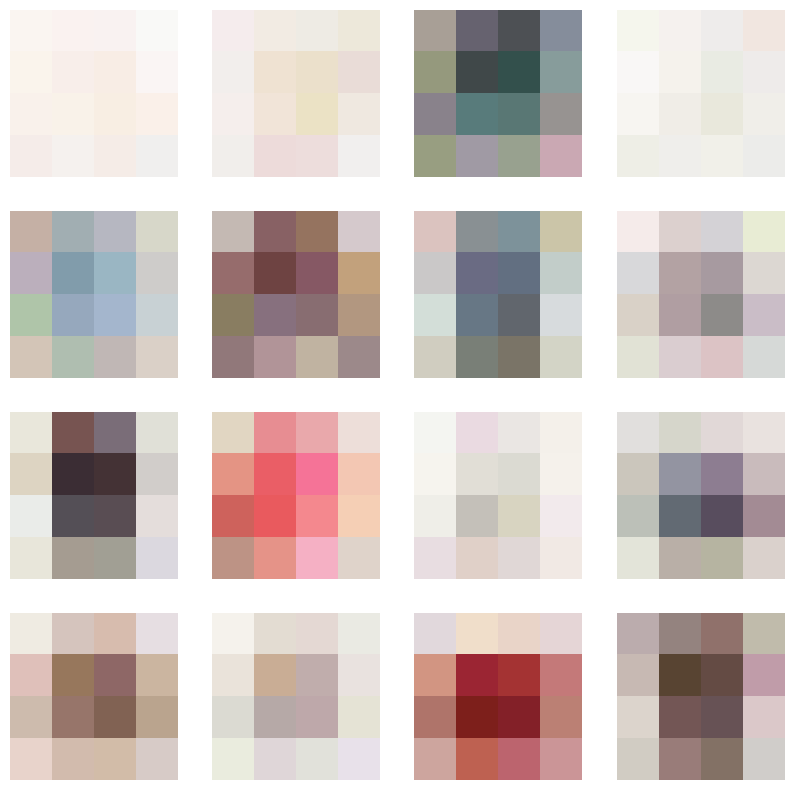

Step: 818
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48814114928245544
Generator loss: 1.0373156070709229


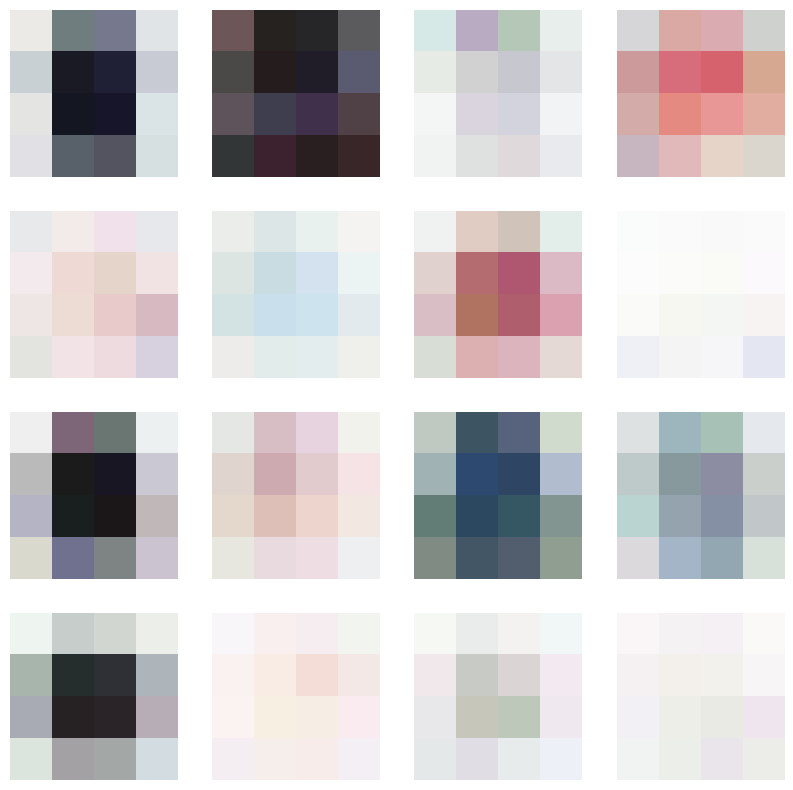

Step: 819
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48763564229011536
Generator loss: 1.036161184310913


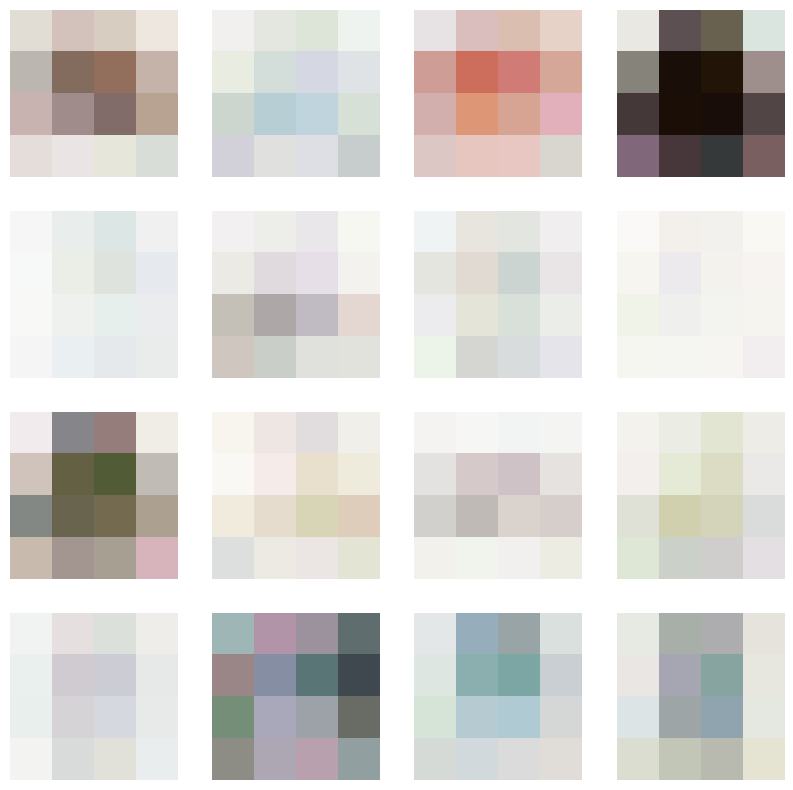

Step: 820
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4870372414588928
Generator loss: 1.0357184410095215


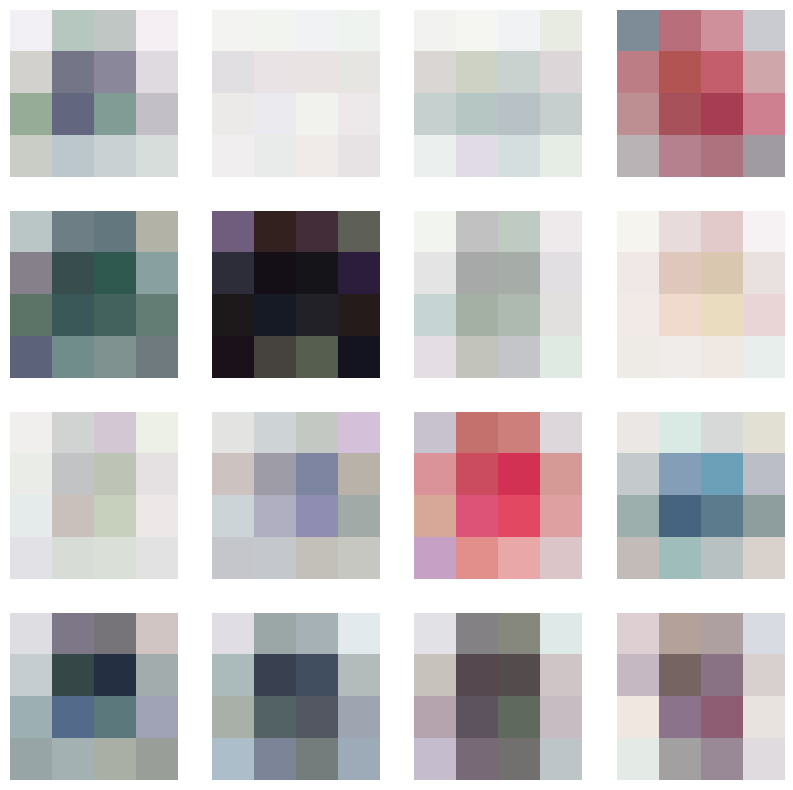

Step: 821
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4865945279598236
Generator loss: 1.035728931427002


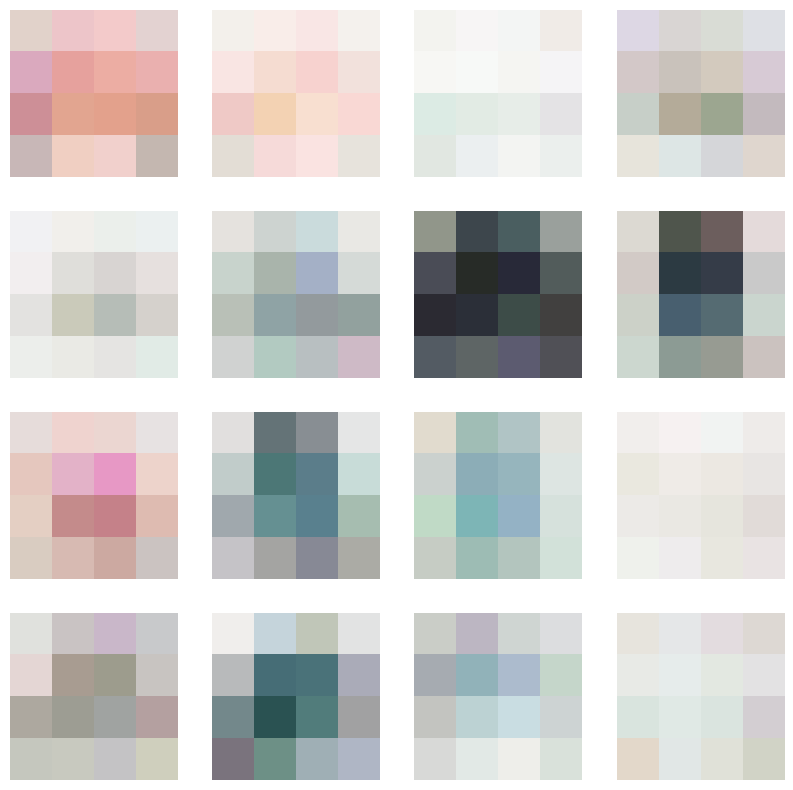

Step: 822
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48614946007728577
Generator loss: 1.0353401899337769


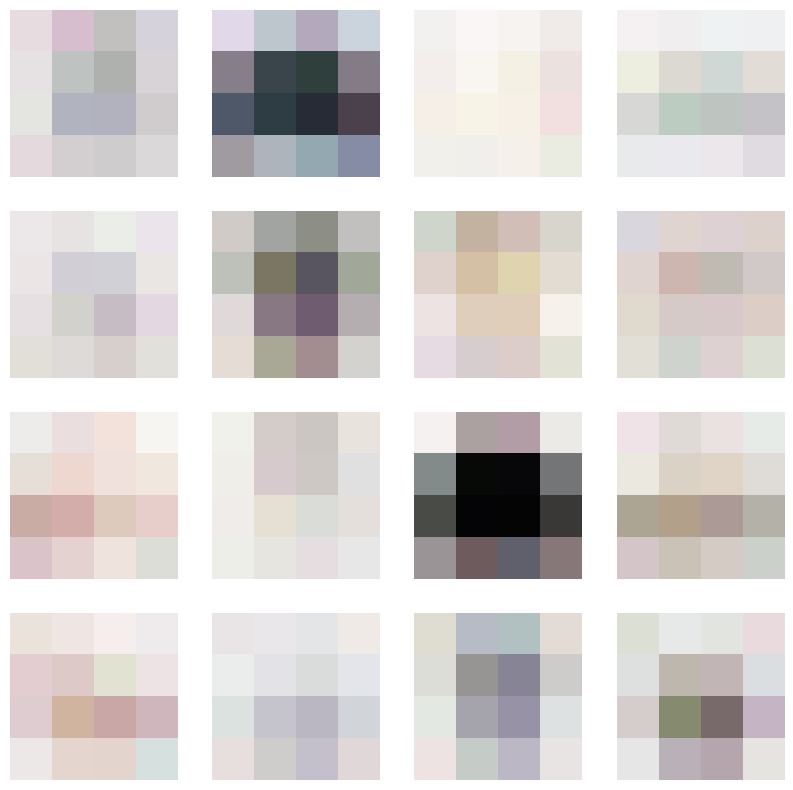

Step: 823
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48553329706192017
Generator loss: 1.034684658050537


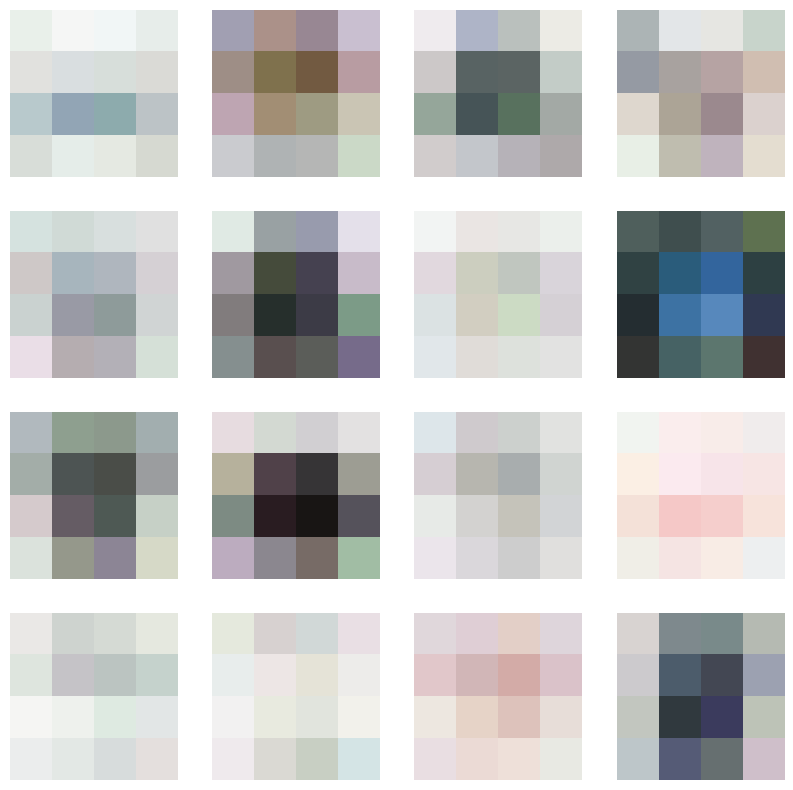

Step: 824
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4849534034729004
Generator loss: 1.0334807634353638


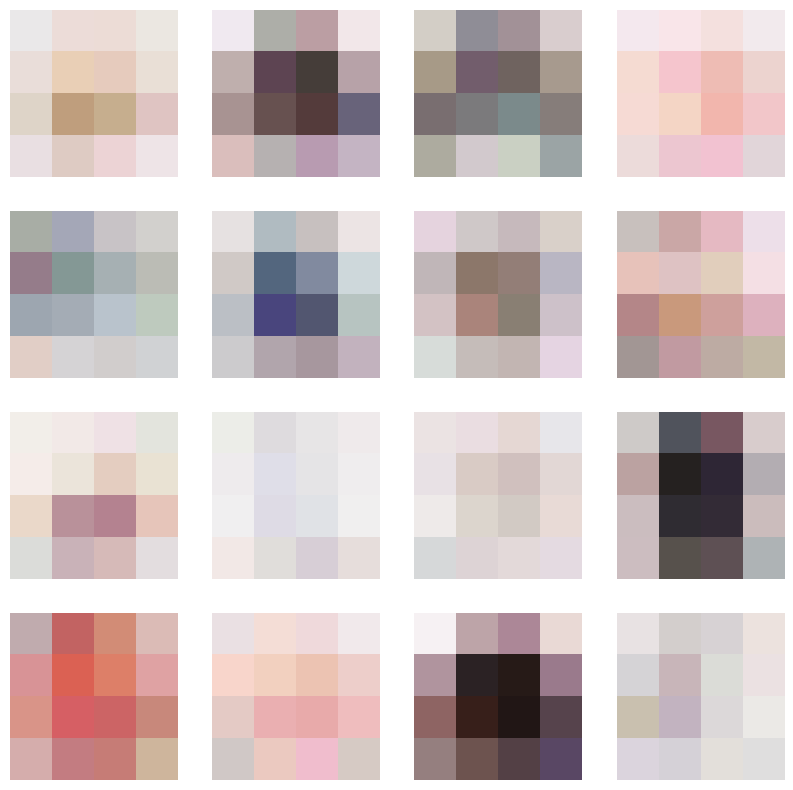

Step: 825
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48445549607276917
Generator loss: 1.0319132804870605


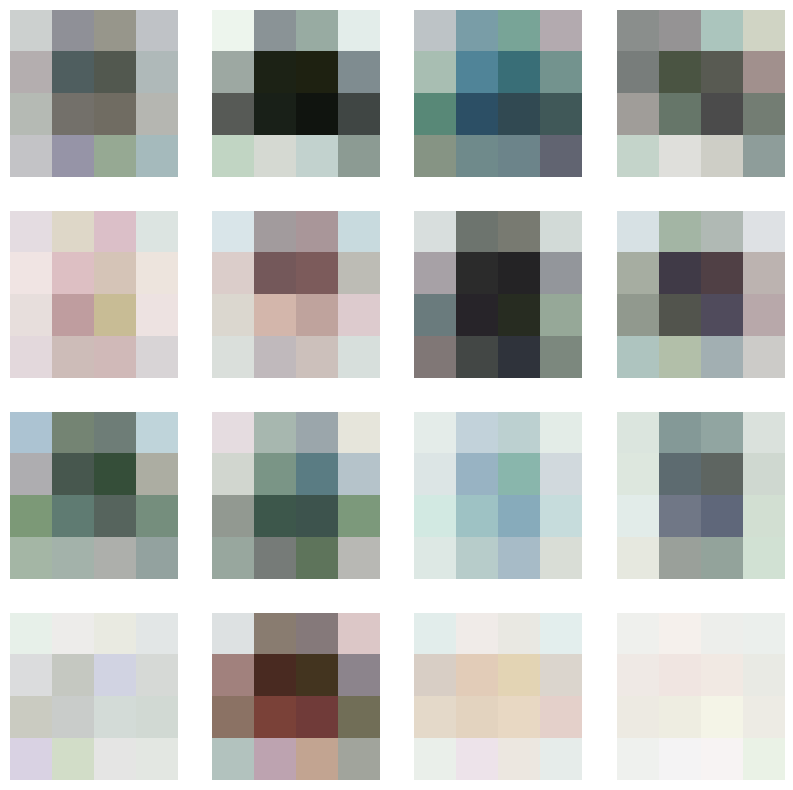

Step: 826
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4840586483478546
Generator loss: 1.0301566123962402


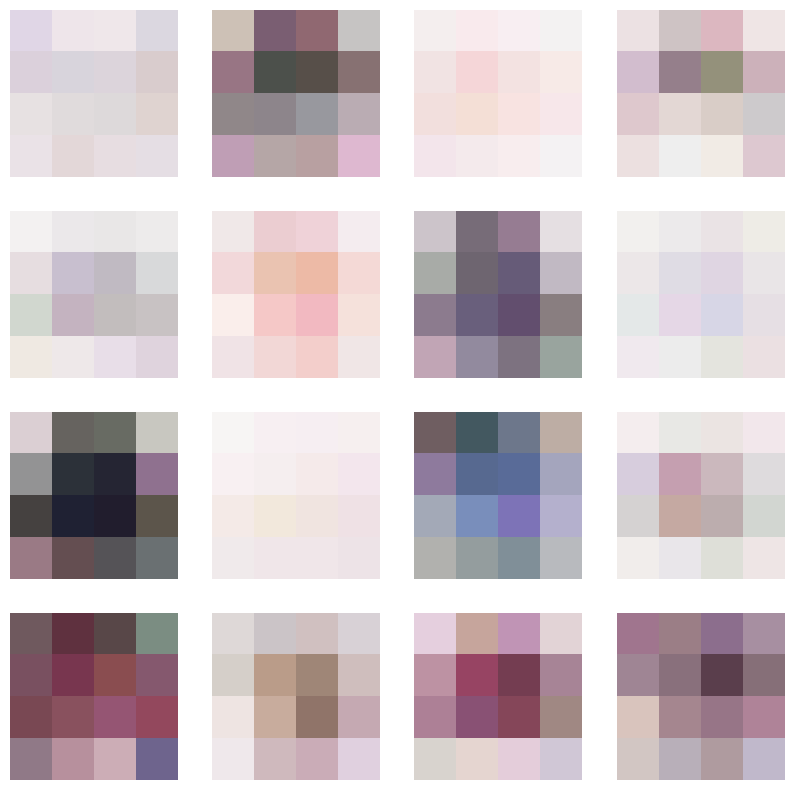

Step: 827
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48360002040863037
Generator loss: 1.0282893180847168


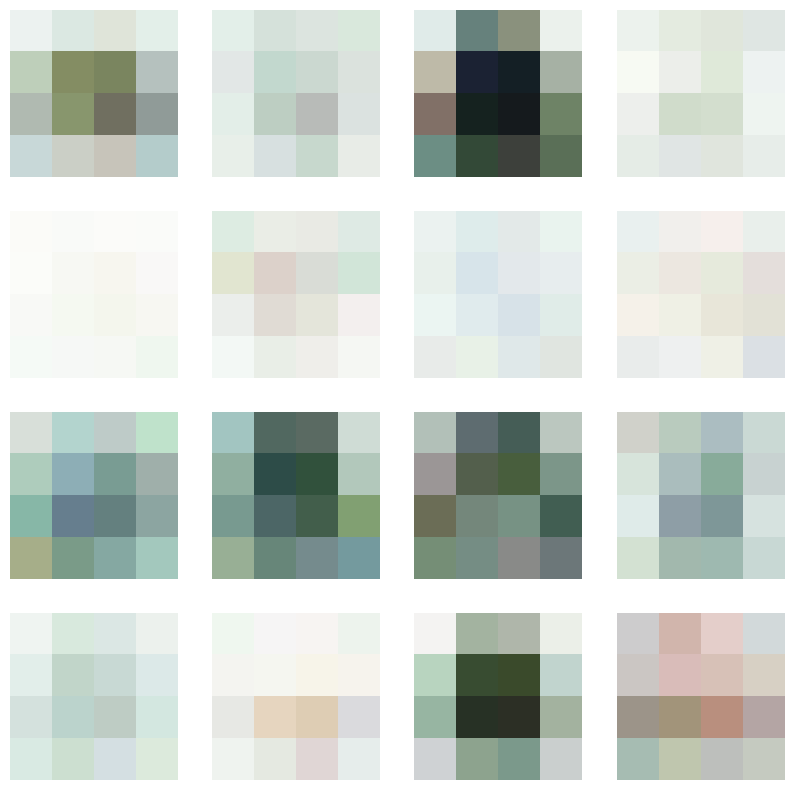

Step: 828
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48310598731040955
Generator loss: 1.0267713069915771


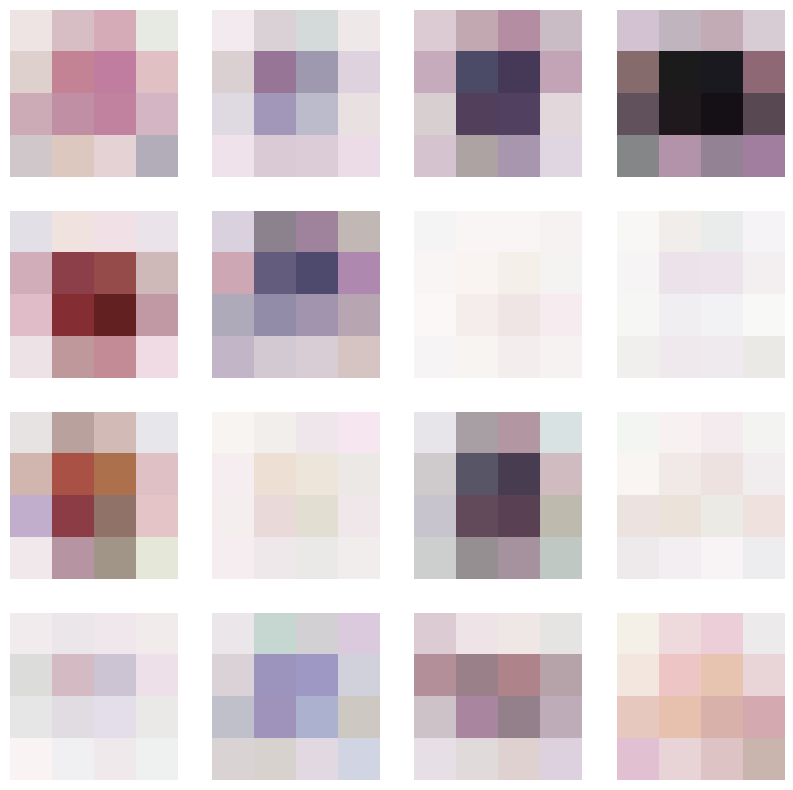

Step: 829
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4825260639190674
Generator loss: 1.0260722637176514


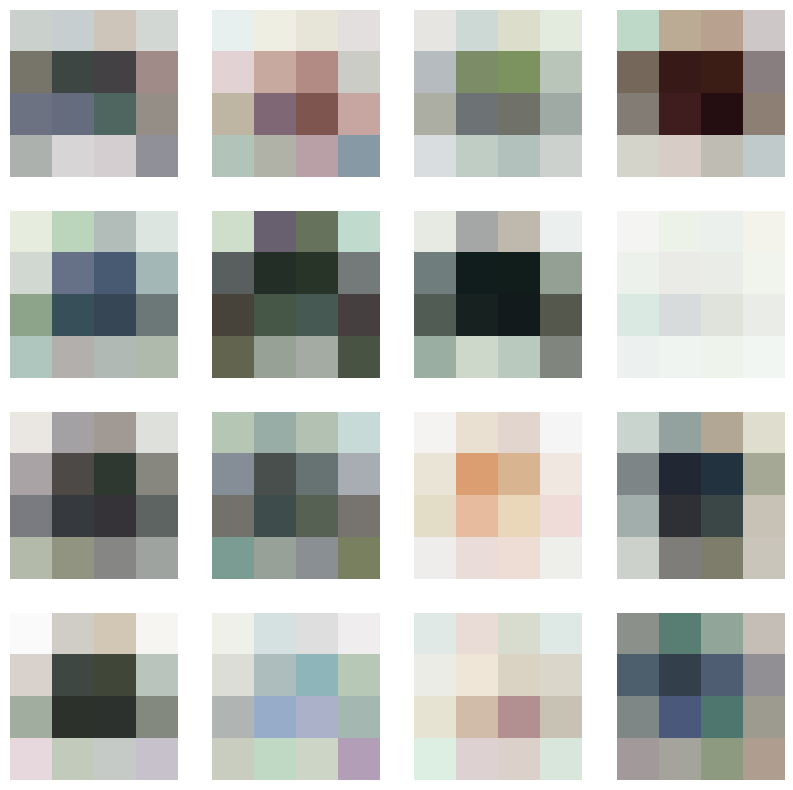

Step: 830
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48205792903900146
Generator loss: 1.025301456451416


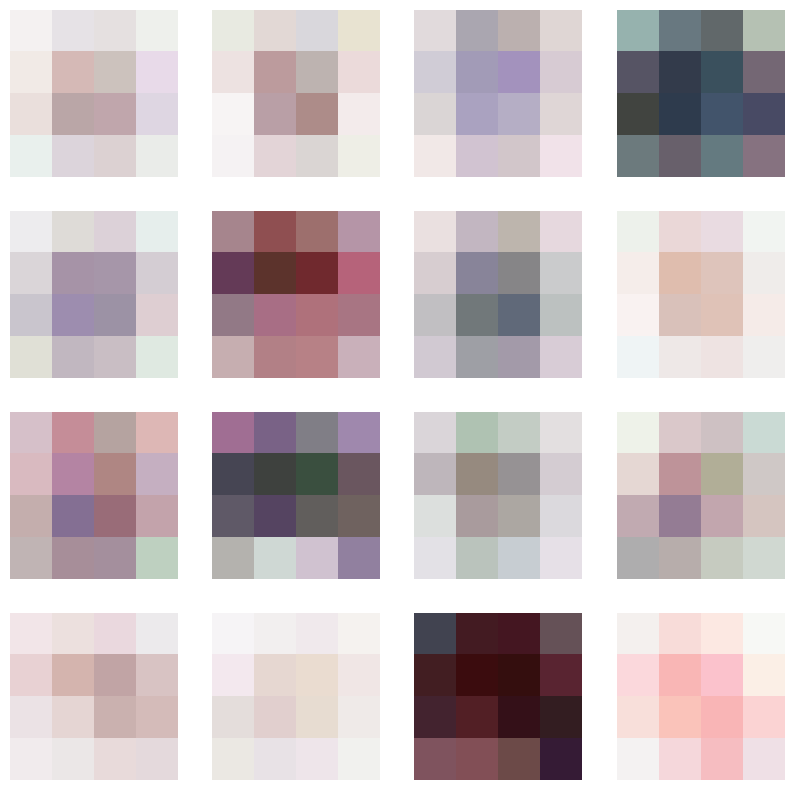

Step: 831
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4816487729549408
Generator loss: 1.0250396728515625


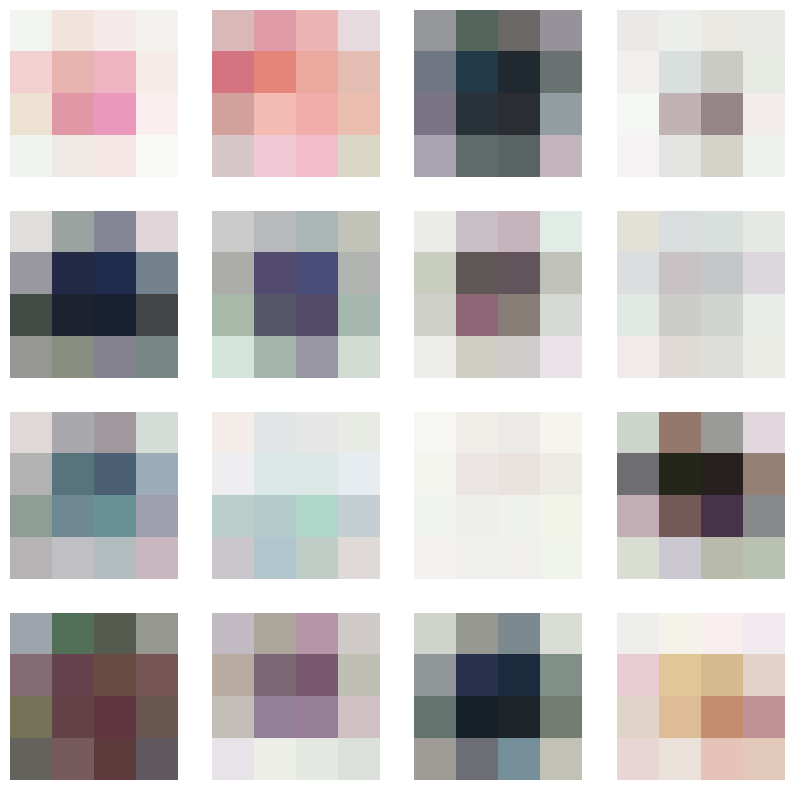

Step: 832
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48105528950691223
Generator loss: 1.0242278575897217


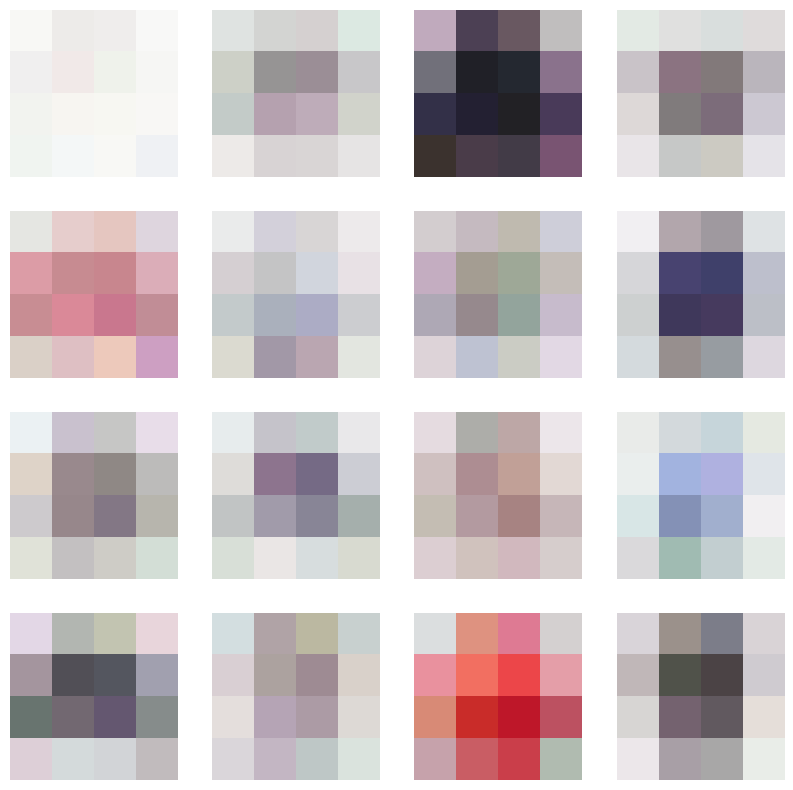

Step: 833
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48058661818504333
Generator loss: 1.0231918096542358


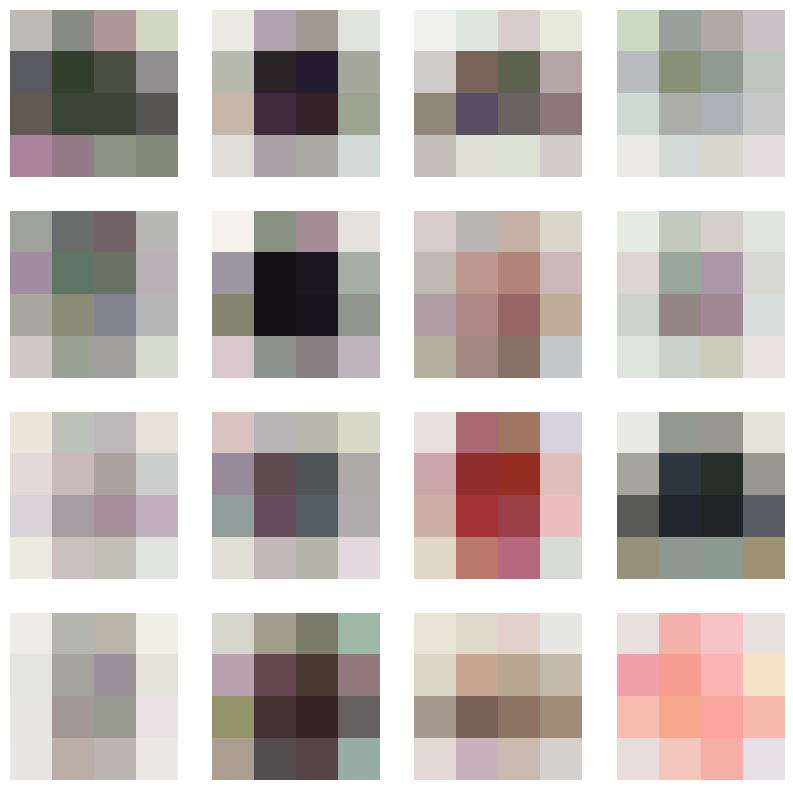

Step: 834
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.48012784123420715
Generator loss: 1.0219789743423462


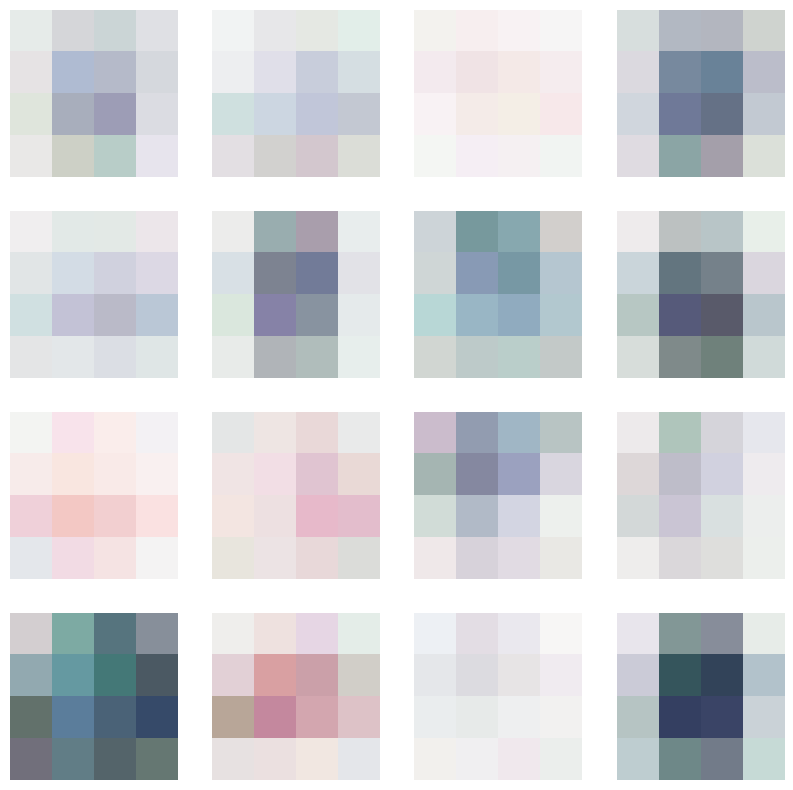

Step: 835
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.47973793745040894
Generator loss: 1.0206893682479858


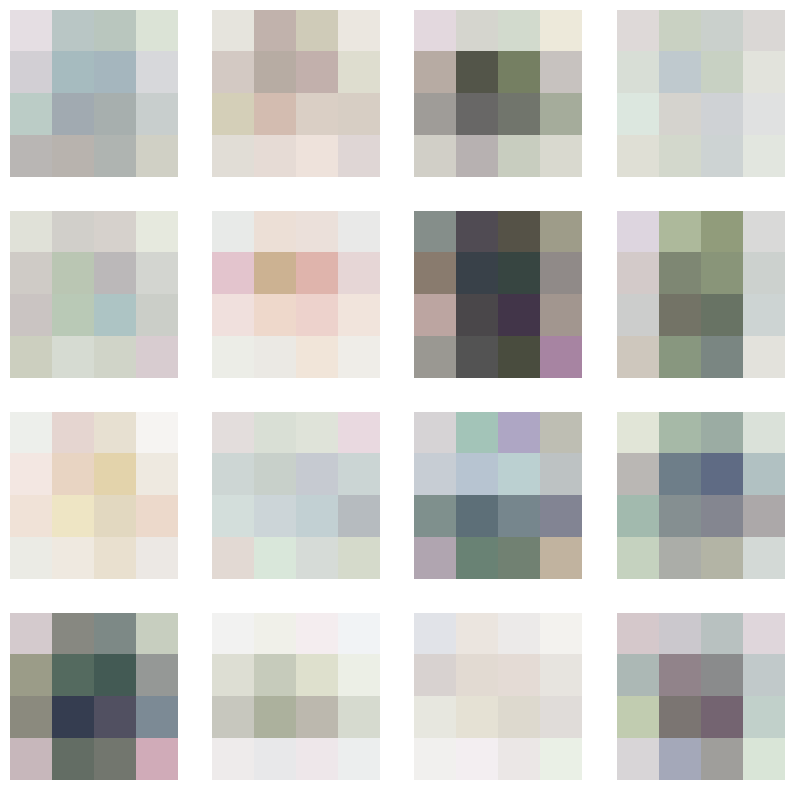

Step: 836
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.47927823662757874
Generator loss: 1.0196292400360107


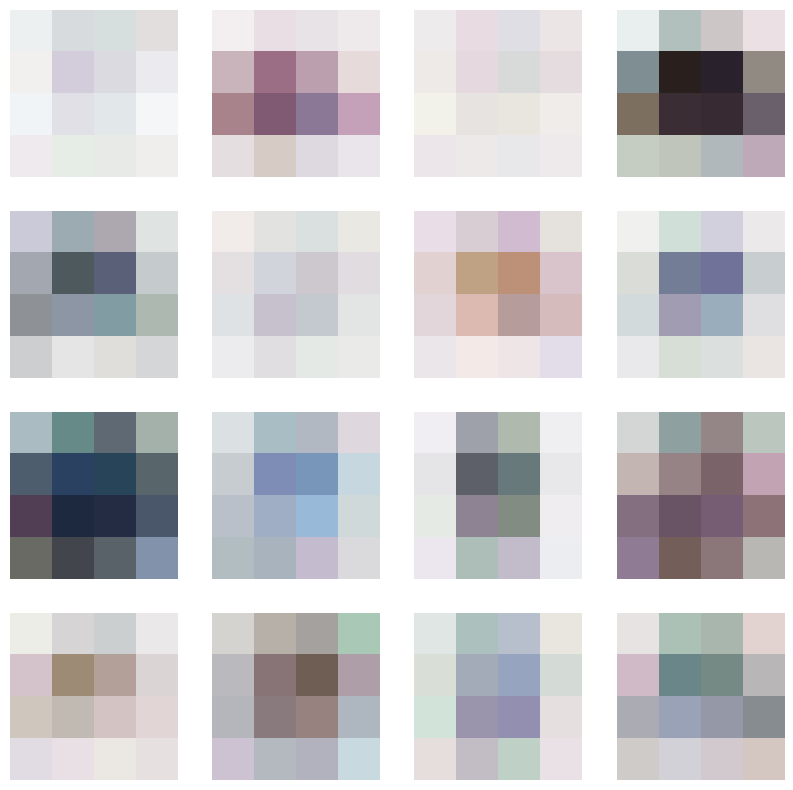

Step: 837
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.478866308927536
Generator loss: 1.018296480178833


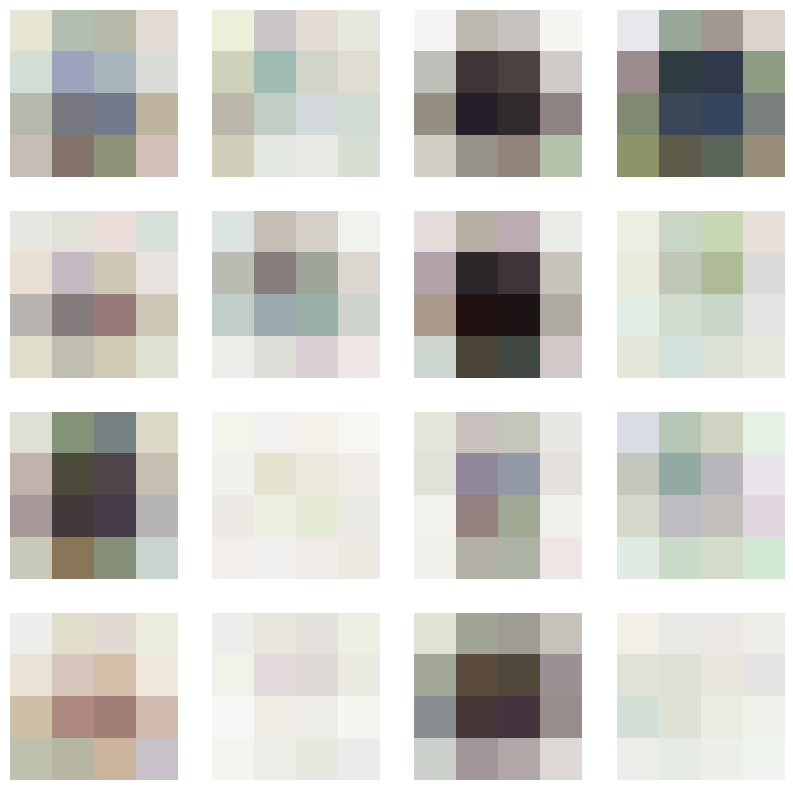

Step: 838
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.47839656472206116
Generator loss: 1.017086148262024


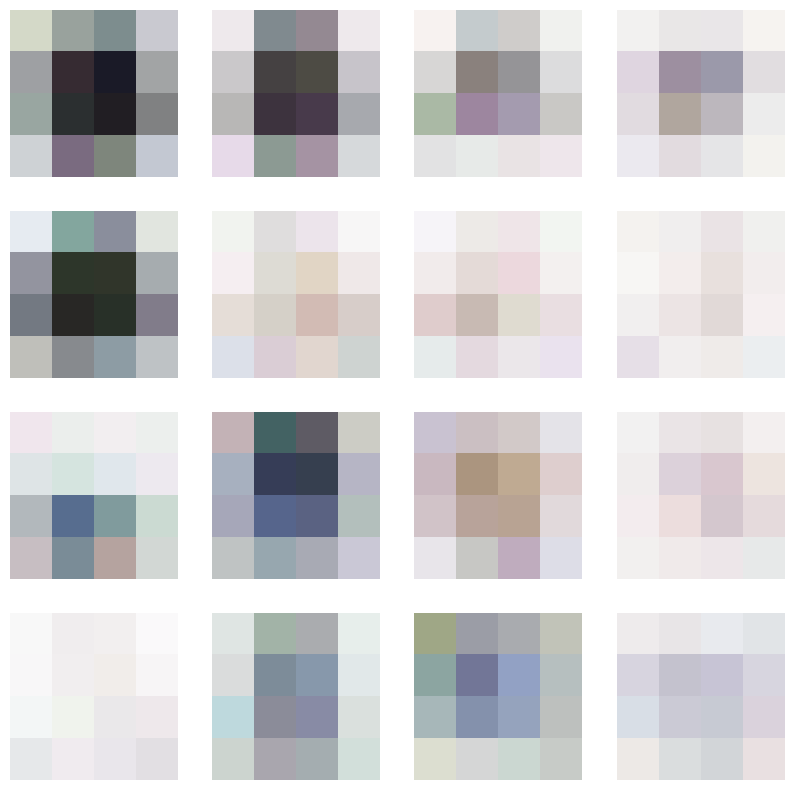

Step: 839
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.47795170545578003
Generator loss: 1.016163945198059


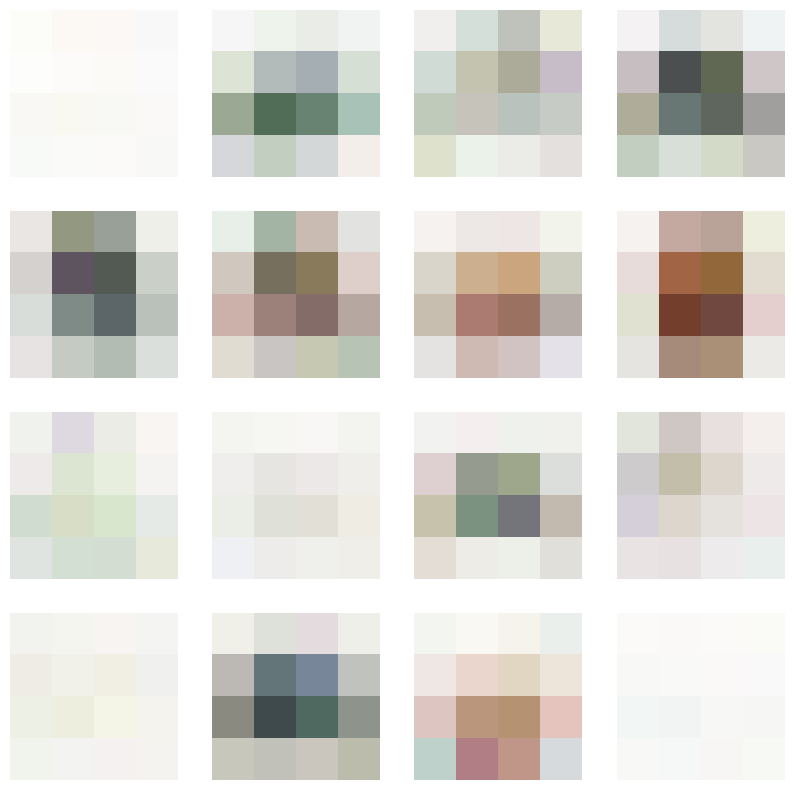

Step: 840
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4775438904762268
Generator loss: 1.01564621925354


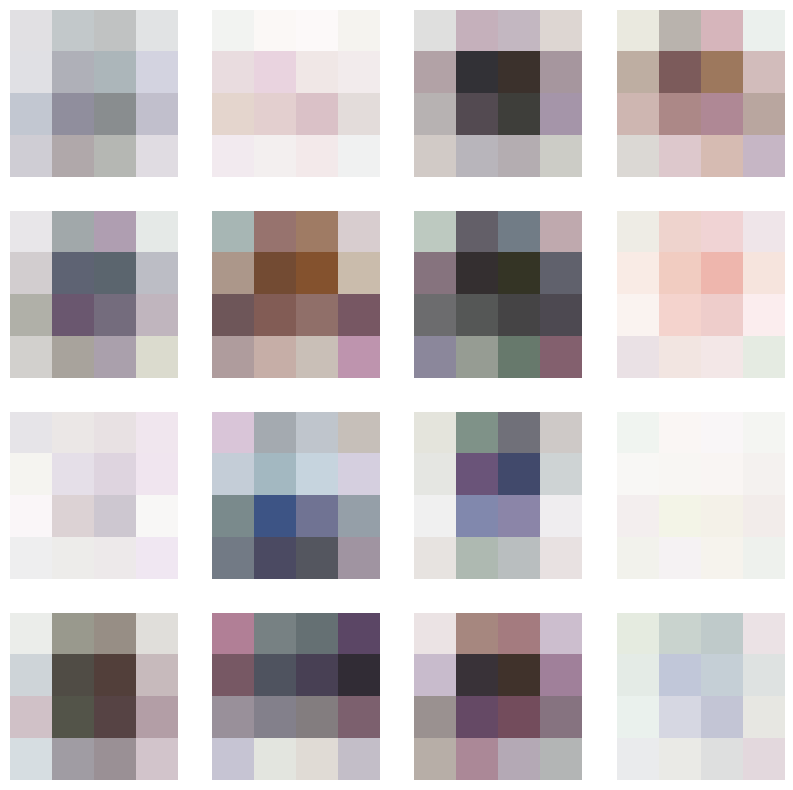

Step: 841
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4771319627761841
Generator loss: 1.0152907371520996


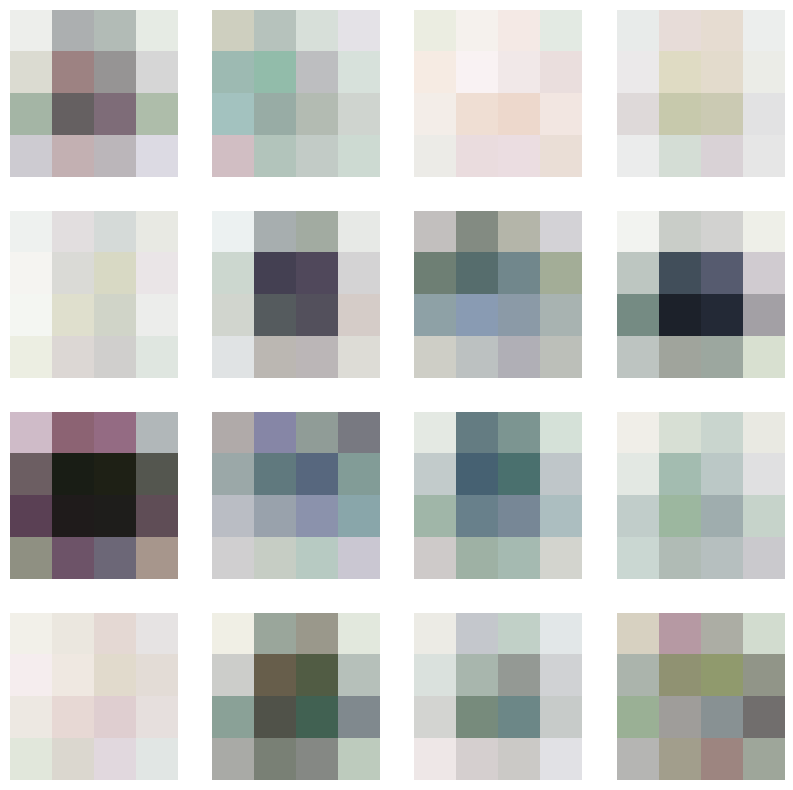

Step: 842
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.4766819179058075
Generator loss: 1.0147621631622314


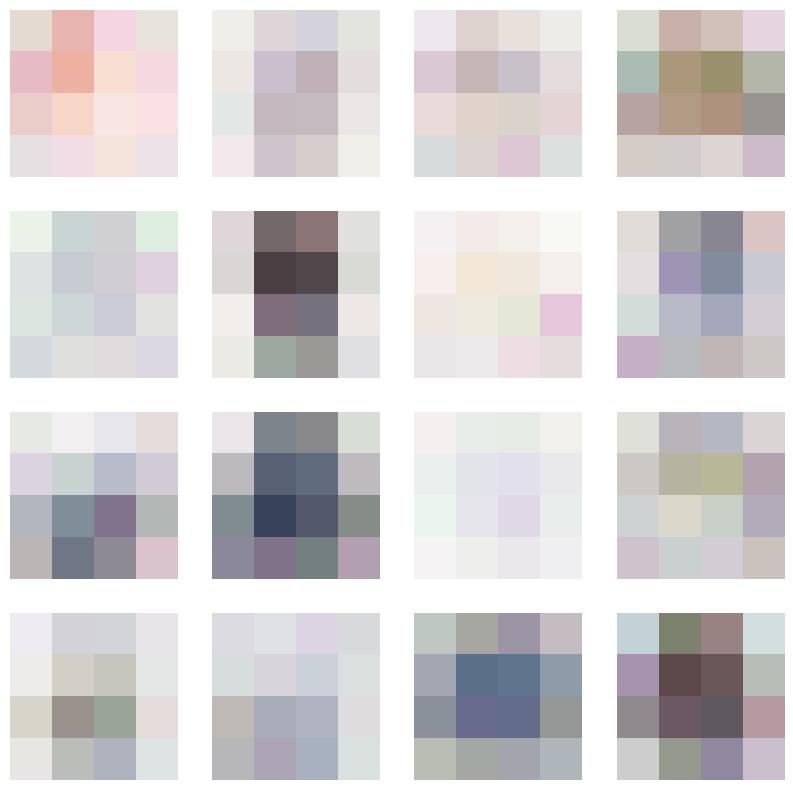

Step: 843
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.47615885734558105
Generator loss: 1.0139878988265991


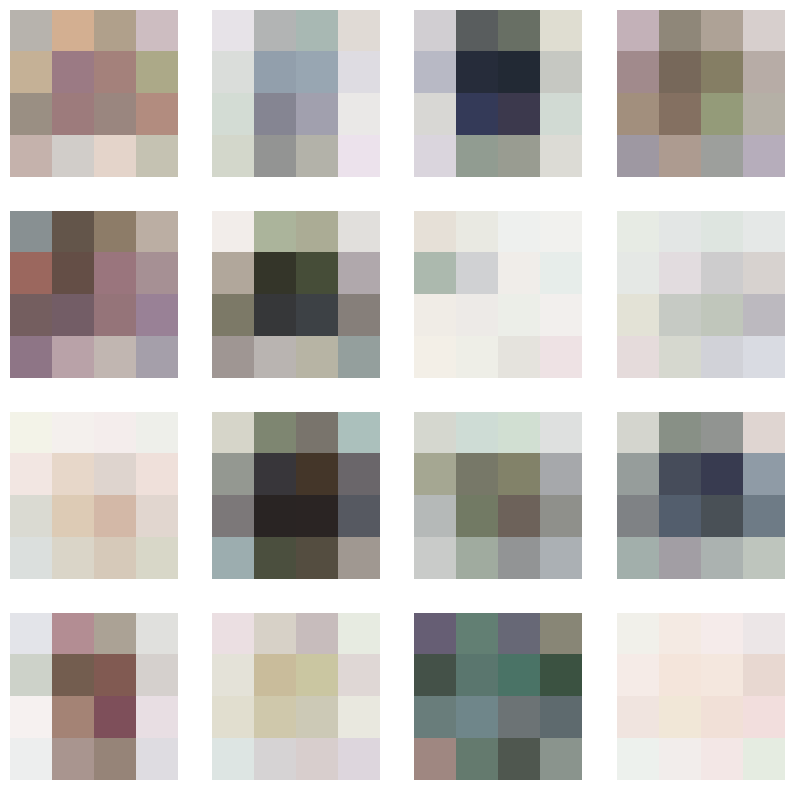

Step: 844
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.47559088468551636
Generator loss: 1.0126479864120483


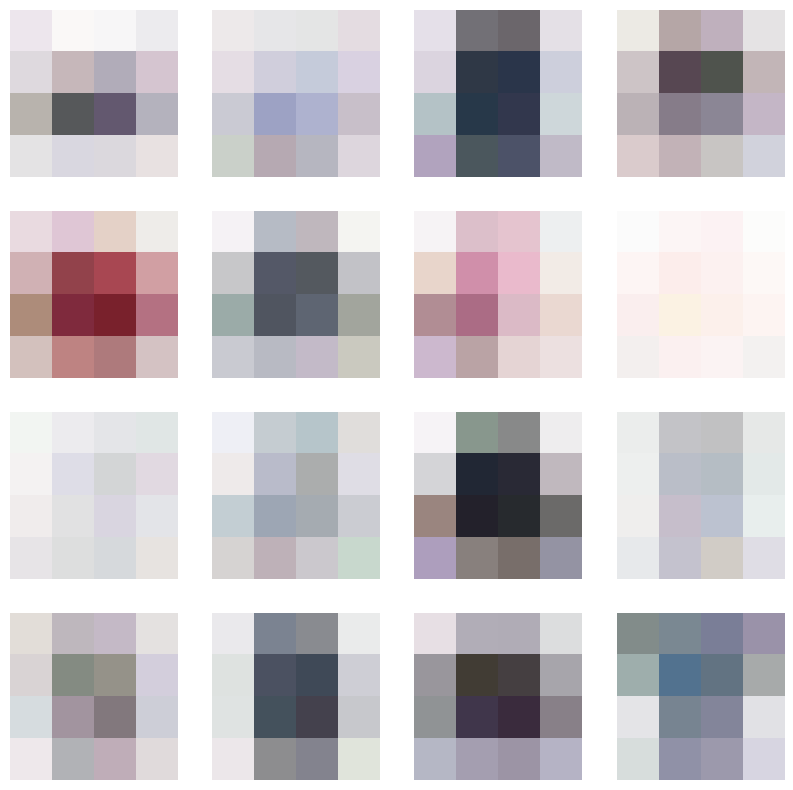

Step: 845
Alpha: 1.0
Current Resolution: 4
Discriminator loss : -0.47494828701019287
Generator loss: 1.0112247467041016


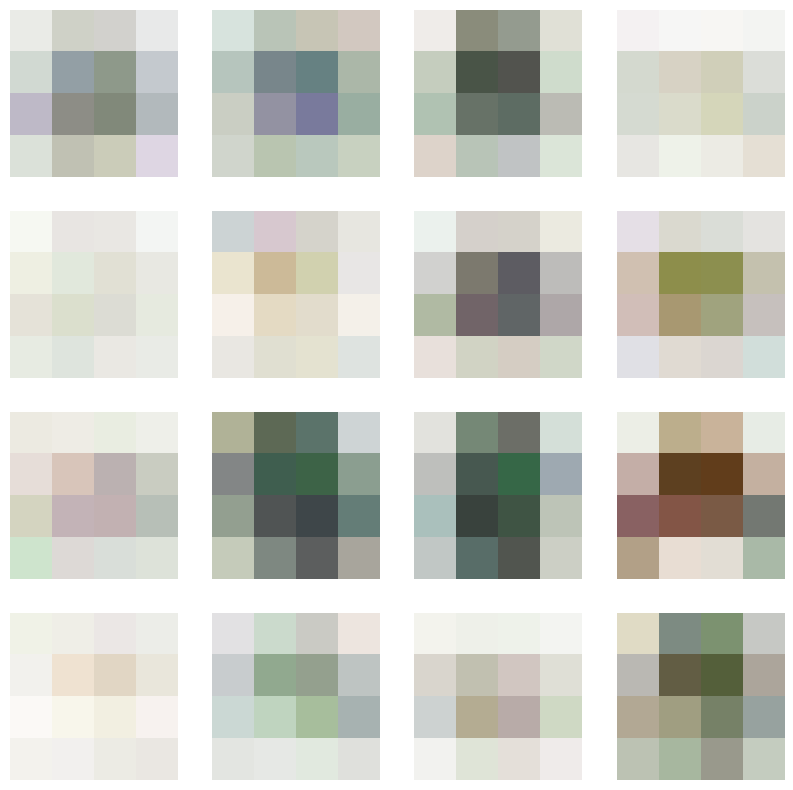

([2.0834484,
  1.832545,
  1.5433108,
  1.3047655,
  1.1621759,
  1.0253477,
  0.9004044,
  0.7749465,
  0.6449022,
  0.5223524,
  0.396577,
  0.2699313,
  0.12426038,
  -0.0152149545,
  -0.14758047,
  -0.2812382,
  -0.41249722,
  -0.5358455,
  -0.6644751,
  -0.7867371,
  -0.89327824,
  -0.9871859,
  -1.069339,
  -1.1526669,
  -1.2233438,
  -1.2925639,
  -1.3552244,
  -1.4014616,
  -1.4515874,
  -1.4998409,
  -1.5413316,
  -1.5855662,
  -1.6171067,
  -1.6540214,
  -1.688106,
  -1.7133087,
  -1.7411932,
  -1.7680115,
  -1.7936294,
  -1.8208538,
  -1.8461589,
  -1.8657147,
  -1.8845382,
  -1.9066414,
  -1.9254198,
  -1.9390113,
  -1.9576981,
  -1.9717499,
  -1.9846908,
  -1.9982309,
  -2.0067577,
  -2.0168736,
  -2.0290976,
  -2.0397065,
  -2.0549483,
  -2.070593,
  -2.0848496,
  -2.0979414,
  -2.111524,
  -2.1228673,
  -2.135995,
  -2.1494384,
  -2.159441,
  -2.1709142,
  -2.1801786,
  -2.189433,
  -2.1972296,
  -2.206678,
  -2.2153776,
  -2.2238266,
  -2.2330644,
  -2.2413762,
  -2.247

In [49]:
pro_gan.train(
    reals=x,
    epochs=1,
    see_dataset_per_epoch=6,
    batch_size=128,
    show_gen_img_every="step"
)